In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import pybaseball as pyb
import seaborn as sns


In [40]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [41]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [42]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

    return df

In [43]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [44]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [73]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [79]:
train_data = training_features.loc[training_features['spin_axis'].notnull()].drop(['spin_axis'], axis=1).copy()
train_label = training_features['spin_axis'].loc[training_features['spin_axis'].notnull()].copy()
testing_data = testing_features.loc[testing_features['spin_axis'].notnull()].drop(['spin_axis'], axis=1).copy()
testing_label = testing_features['spin_axis'].loc[testing_features['spin_axis'].notnull()].copy()

In [75]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [69]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [48]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [49]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [50]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'device' : 'gpu',
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [51]:
y_pred = model.predict(dtest)

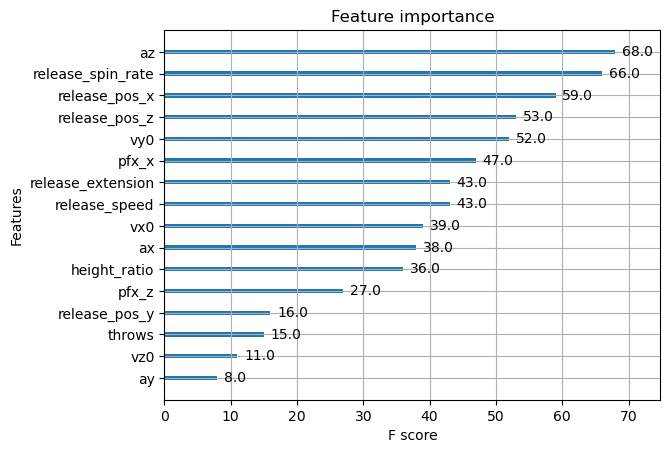

In [52]:
xgb.plot_importance(model)
plt.show()

In [53]:
def angular_difference(actual, predicted):
    difference = (predicted - actual) + 180
    return ((difference % 360) - 180)

(array([  36.,   34.,   35.,   35.,   35.,   34.,   45.,   44.,   44.,
          50.,   52.,   85.,  104.,  149.,  164.,  241.,  342.,  489.,
         711., 1121., 1558., 2407., 3722., 5795., 7926., 7992., 6525.,
        4306., 2441., 1533., 1044.,  715.,  544.,  373.,  295.,  230.,
         160.,  135.,   94.,   81.,   66.,   37.,   36.,   45.,   27.,
          25.,   25.,   30.,   30.,   38.]),
 array([-1.79853149e+02, -1.72659042e+02, -1.65464935e+02, -1.58270813e+02,
        -1.51076706e+02, -1.43882599e+02, -1.36688492e+02, -1.29494385e+02,
        -1.22300270e+02, -1.15106155e+02, -1.07912048e+02, -1.00717941e+02,
        -9.35238266e+01, -8.63297195e+01, -7.91356049e+01, -7.19414978e+01,
        -6.47473907e+01, -5.75532761e+01, -5.03591690e+01, -4.31650581e+01,
        -3.59709473e+01, -2.87768364e+01, -2.15827274e+01, -1.43886166e+01,
        -7.19450665e+00, -3.96728516e-04,  7.19371319e+00,  1.43878231e+01,
         2.15819340e+01,  2.87760429e+01,  3.59701538e+01,  4.316426

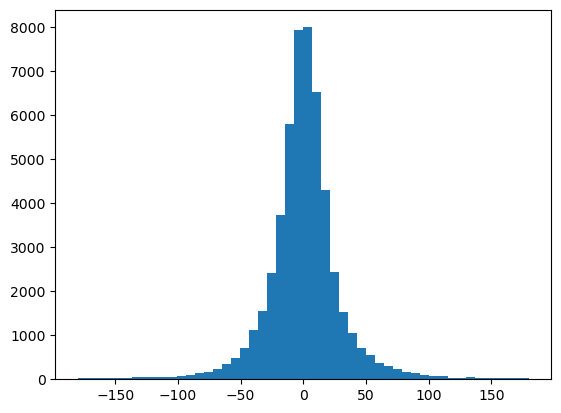

In [54]:
difference = angular_difference(y_test, y_pred)

plt.hist(difference, bins=50)

# Initial Paramater Tuning

In [55]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'device': 'gpu'
        }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [56]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 15:46:52,994] A new study created in memory with name: no-name-8d854ae0-709d-44b9-9479-d2cfd792cb8a


[0]	eval-rmse:70.98687
[1]	eval-rmse:55.90644
[2]	eval-rmse:46.87989
[3]	eval-rmse:42.00264
[4]	eval-rmse:39.28449
[5]	eval-rmse:37.50667
[6]	eval-rmse:36.86008
[7]	eval-rmse:36.30726
[8]	eval-rmse:36.02606
[9]	eval-rmse:35.79013
[10]	eval-rmse:35.67531
[11]	eval-rmse:35.56010
[12]	eval-rmse:35.38857
[13]	eval-rmse:35.36426
[14]	eval-rmse:35.28385
[15]	eval-rmse:35.22787
[16]	eval-rmse:35.23174
[17]	eval-rmse:35.08838
[18]	eval-rmse:35.01206
[19]	eval-rmse:34.97545
[20]	eval-rmse:34.98596
[21]	eval-rmse:34.95048
[22]	eval-rmse:34.91136
[23]	eval-rmse:34.91354
[24]	eval-rmse:34.89809
[25]	eval-rmse:34.85612
[26]	eval-rmse:34.86953
[27]	eval-rmse:34.85787
[28]	eval-rmse:34.89105
[29]	eval-rmse:34.85255
[30]	eval-rmse:34.83393
[31]	eval-rmse:34.84120
[32]	eval-rmse:34.87213
[33]	eval-rmse:34.87929
[34]	eval-rmse:34.89428
[35]	eval-rmse:34.87303
[36]	eval-rmse:34.87998
[37]	eval-rmse:34.84774
[38]	eval-rmse:34.83311
[39]	eval-rmse:34.81337
[40]	eval-rmse:34.81528
[41]	eval-rmse:34.81405
[4

[I 2023-11-14 15:46:53,851] Trial 0 finished with value: 34.71834945678711 and parameters: {'max_depth': 7, 'eta': 0.3229306720657875, 'subsample': 0.5417083557392453, 'colsample_bytree': 0.4649852080270137, 'min_child_weight': 4}. Best is trial 0 with value: 34.71834945678711.


[0]	eval-rmse:75.62696
[1]	eval-rmse:61.73353
[2]	eval-rmse:52.14682
[3]	eval-rmse:46.12091
[4]	eval-rmse:42.05701
[5]	eval-rmse:39.20661
[6]	eval-rmse:38.03510
[7]	eval-rmse:37.01669
[8]	eval-rmse:36.35922
[9]	eval-rmse:35.98027
[10]	eval-rmse:35.72237
[11]	eval-rmse:35.51280
[12]	eval-rmse:35.30063
[13]	eval-rmse:35.19922
[14]	eval-rmse:35.11267
[15]	eval-rmse:35.01307
[16]	eval-rmse:34.97405
[17]	eval-rmse:34.91453
[18]	eval-rmse:34.90681
[19]	eval-rmse:34.86728
[20]	eval-rmse:34.89430
[21]	eval-rmse:34.88079
[22]	eval-rmse:34.82757
[23]	eval-rmse:34.81088
[24]	eval-rmse:34.80385
[25]	eval-rmse:34.85161
[26]	eval-rmse:34.85434
[27]	eval-rmse:34.80878
[28]	eval-rmse:34.79822
[29]	eval-rmse:34.75387
[30]	eval-rmse:34.74085
[31]	eval-rmse:34.73728
[32]	eval-rmse:34.72360
[33]	eval-rmse:34.70142
[34]	eval-rmse:34.69554
[35]	eval-rmse:34.66277
[36]	eval-rmse:34.68956
[37]	eval-rmse:34.68310
[38]	eval-rmse:34.71282
[39]	eval-rmse:34.68656
[40]	eval-rmse:34.67110
[41]	eval-rmse:34.69165
[4

[I 2023-11-14 15:46:54,574] Trial 1 finished with value: 34.60960388183594 and parameters: {'max_depth': 8, 'eta': 0.2590814409985242, 'subsample': 0.504869905819719, 'colsample_bytree': 0.513655545808904, 'min_child_weight': 3}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:70.39229
[1]	eval-rmse:55.39148
[2]	eval-rmse:46.60764
[3]	eval-rmse:41.94882
[4]	eval-rmse:39.30842
[5]	eval-rmse:37.69135
[6]	eval-rmse:37.13260
[7]	eval-rmse:36.64364
[8]	eval-rmse:36.35002
[9]	eval-rmse:36.23988
[10]	eval-rmse:36.07993
[11]	eval-rmse:35.98170
[12]	eval-rmse:35.85627
[13]	eval-rmse:35.80761
[14]	eval-rmse:35.72840
[15]	eval-rmse:35.70969
[16]	eval-rmse:35.64680
[17]	eval-rmse:35.60242
[18]	eval-rmse:35.52726
[19]	eval-rmse:35.51618
[20]	eval-rmse:35.47840
[21]	eval-rmse:35.45406
[22]	eval-rmse:35.38521
[23]	eval-rmse:35.35677
[24]	eval-rmse:35.32798
[25]	eval-rmse:35.32136
[26]	eval-rmse:35.28311
[27]	eval-rmse:35.26208
[28]	eval-rmse:35.24063
[29]	eval-rmse:35.24454
[30]	eval-rmse:35.22756
[31]	eval-rmse:35.18286
[32]	eval-rmse:35.17778
[33]	eval-rmse:35.18112
[34]	eval-rmse:35.16330
[35]	eval-rmse:35.14780
[36]	eval-rmse:35.09656
[37]	eval-rmse:35.09913
[38]	eval-rmse:35.08956
[39]	eval-rmse:35.06445
[40]	eval-rmse:35.07364
[41]	eval-rmse:35.08538
[4

[I 2023-11-14 15:46:55,342] Trial 2 finished with value: 34.85785675048828 and parameters: {'max_depth': 6, 'eta': 0.3352250216156032, 'subsample': 0.5861830940092704, 'colsample_bytree': 0.509709071780503, 'min_child_weight': 3}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:74.68694
[1]	eval-rmse:59.82617
[2]	eval-rmse:51.26274
[3]	eval-rmse:45.70418
[4]	eval-rmse:42.02204
[5]	eval-rmse:39.20492
[6]	eval-rmse:38.27366
[7]	eval-rmse:37.61417
[8]	eval-rmse:37.07421
[9]	eval-rmse:36.78658
[10]	eval-rmse:36.55637
[11]	eval-rmse:36.37885
[12]	eval-rmse:36.22416
[13]	eval-rmse:36.13581
[14]	eval-rmse:36.06758
[15]	eval-rmse:35.81977
[16]	eval-rmse:35.77844
[17]	eval-rmse:35.59789
[18]	eval-rmse:35.54434
[19]	eval-rmse:35.53552
[20]	eval-rmse:35.49404
[21]	eval-rmse:35.45020
[22]	eval-rmse:35.39764
[23]	eval-rmse:35.37939
[24]	eval-rmse:35.34308
[25]	eval-rmse:35.30900
[26]	eval-rmse:35.26584
[27]	eval-rmse:35.22677
[28]	eval-rmse:35.23097
[29]	eval-rmse:35.22561
[30]	eval-rmse:35.25797
[31]	eval-rmse:35.25464
[32]	eval-rmse:35.24064
[33]	eval-rmse:35.22586
[34]	eval-rmse:35.21628
[35]	eval-rmse:35.18337
[36]	eval-rmse:35.16286
[37]	eval-rmse:35.17855
[38]	eval-rmse:35.15536
[39]	eval-rmse:35.11176
[40]	eval-rmse:35.13918
[41]	eval-rmse:35.11888
[4

[I 2023-11-14 15:46:56,095] Trial 3 finished with value: 34.92401885986328 and parameters: {'max_depth': 7, 'eta': 0.2907830403221782, 'subsample': 0.46053836598127207, 'colsample_bytree': 0.41226418236551376, 'min_child_weight': 3}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:77.61929
[1]	eval-rmse:63.87069
[2]	eval-rmse:55.25675
[3]	eval-rmse:49.07705
[4]	eval-rmse:44.59420
[5]	eval-rmse:41.07036
[6]	eval-rmse:39.71790
[7]	eval-rmse:38.64472
[8]	eval-rmse:37.77456
[9]	eval-rmse:37.31584
[10]	eval-rmse:36.97309
[11]	eval-rmse:36.67269
[12]	eval-rmse:36.51443
[13]	eval-rmse:36.39409
[14]	eval-rmse:36.28220
[15]	eval-rmse:35.92980
[16]	eval-rmse:35.89617
[17]	eval-rmse:35.66717
[18]	eval-rmse:35.57046
[19]	eval-rmse:35.52539
[20]	eval-rmse:35.43403
[21]	eval-rmse:35.35994
[22]	eval-rmse:35.32984
[23]	eval-rmse:35.30262
[24]	eval-rmse:35.24561
[25]	eval-rmse:35.20274
[26]	eval-rmse:35.19052
[27]	eval-rmse:35.12205
[28]	eval-rmse:35.10772
[29]	eval-rmse:35.09802
[30]	eval-rmse:35.03978
[31]	eval-rmse:35.04142
[32]	eval-rmse:35.04763
[33]	eval-rmse:35.02128
[34]	eval-rmse:35.00921
[35]	eval-rmse:34.98823
[36]	eval-rmse:35.01872
[37]	eval-rmse:34.99936
[38]	eval-rmse:34.98947
[39]	eval-rmse:34.97770
[40]	eval-rmse:34.95376
[41]	eval-rmse:34.94330
[4

[I 2023-11-14 15:46:56,726] Trial 4 finished with value: 34.7149543762207 and parameters: {'max_depth': 7, 'eta': 0.2492289217793952, 'subsample': 0.4509401053685528, 'colsample_bytree': 0.4197227051983876, 'min_child_weight': 2}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:79.46643
[1]	eval-rmse:66.58970
[2]	eval-rmse:58.02383
[3]	eval-rmse:51.58776
[4]	eval-rmse:46.68876
[5]	eval-rmse:42.75546
[6]	eval-rmse:41.03032
[7]	eval-rmse:39.58784
[8]	eval-rmse:38.42166
[9]	eval-rmse:37.79866
[10]	eval-rmse:37.33975
[11]	eval-rmse:36.88535
[12]	eval-rmse:36.67809
[13]	eval-rmse:36.54473
[14]	eval-rmse:36.40033
[15]	eval-rmse:36.10857
[16]	eval-rmse:36.05998
[17]	eval-rmse:35.82542
[18]	eval-rmse:35.72539
[19]	eval-rmse:35.65200
[20]	eval-rmse:35.50144
[21]	eval-rmse:35.42899
[22]	eval-rmse:35.35286
[23]	eval-rmse:35.31034
[24]	eval-rmse:35.31123
[25]	eval-rmse:35.23240
[26]	eval-rmse:35.19811
[27]	eval-rmse:35.10882
[28]	eval-rmse:35.09952
[29]	eval-rmse:35.10486
[30]	eval-rmse:35.07936
[31]	eval-rmse:35.07475
[32]	eval-rmse:35.02695
[33]	eval-rmse:35.02855
[34]	eval-rmse:34.99528
[35]	eval-rmse:34.95573
[36]	eval-rmse:34.92383
[37]	eval-rmse:34.91136
[38]	eval-rmse:34.93157
[39]	eval-rmse:34.94142
[40]	eval-rmse:34.95648
[41]	eval-rmse:34.97218
[4

[I 2023-11-14 15:46:57,587] Trial 5 finished with value: 34.78165817260742 and parameters: {'max_depth': 8, 'eta': 0.22154125607097938, 'subsample': 0.4091475539245811, 'colsample_bytree': 0.4049428413196824, 'min_child_weight': 4}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:71.53872
[1]	eval-rmse:56.69310
[2]	eval-rmse:47.77580
[3]	eval-rmse:42.78346
[4]	eval-rmse:39.94697
[5]	eval-rmse:38.04451
[6]	eval-rmse:37.37241
[7]	eval-rmse:36.86091
[8]	eval-rmse:36.52049
[9]	eval-rmse:36.34107
[10]	eval-rmse:36.21667
[11]	eval-rmse:36.12783
[12]	eval-rmse:35.89693
[13]	eval-rmse:35.82806
[14]	eval-rmse:35.69413
[15]	eval-rmse:35.66729
[16]	eval-rmse:35.63179
[17]	eval-rmse:35.57172
[18]	eval-rmse:35.52826
[19]	eval-rmse:35.48196
[20]	eval-rmse:35.43147
[21]	eval-rmse:35.37418
[22]	eval-rmse:35.28203
[23]	eval-rmse:35.27092
[24]	eval-rmse:35.24202
[25]	eval-rmse:35.23793
[26]	eval-rmse:35.21263
[27]	eval-rmse:35.20697
[28]	eval-rmse:35.23439
[29]	eval-rmse:35.22259
[30]	eval-rmse:35.20397
[31]	eval-rmse:35.17532
[32]	eval-rmse:35.15498
[33]	eval-rmse:35.10996
[34]	eval-rmse:35.08760
[35]	eval-rmse:35.05242
[36]	eval-rmse:35.02714
[37]	eval-rmse:35.01808
[38]	eval-rmse:35.00997
[39]	eval-rmse:35.01411
[40]	eval-rmse:35.00711
[41]	eval-rmse:35.00212
[4

[I 2023-11-14 15:46:58,411] Trial 6 finished with value: 34.65943145751953 and parameters: {'max_depth': 6, 'eta': 0.3202001897626188, 'subsample': 0.5028431443367862, 'colsample_bytree': 0.505247941443554, 'min_child_weight': 5}. Best is trial 1 with value: 34.60960388183594.


[0]	eval-rmse:72.31551
[1]	eval-rmse:57.50468
[2]	eval-rmse:48.26966
[3]	eval-rmse:43.08275
[4]	eval-rmse:40.00478
[5]	eval-rmse:37.88123
[6]	eval-rmse:37.16925
[7]	eval-rmse:36.55682
[8]	eval-rmse:36.20019
[9]	eval-rmse:35.95079
[10]	eval-rmse:35.77907
[11]	eval-rmse:35.64062
[12]	eval-rmse:35.48841
[13]	eval-rmse:35.42183
[14]	eval-rmse:35.37453
[15]	eval-rmse:35.32896
[16]	eval-rmse:35.32066
[17]	eval-rmse:35.17260
[18]	eval-rmse:35.11790
[19]	eval-rmse:35.08758
[20]	eval-rmse:35.09860
[21]	eval-rmse:35.08656
[22]	eval-rmse:34.98667
[23]	eval-rmse:34.96508
[24]	eval-rmse:34.93643
[25]	eval-rmse:34.91707
[26]	eval-rmse:34.89533
[27]	eval-rmse:34.87674
[28]	eval-rmse:34.84363
[29]	eval-rmse:34.83933
[30]	eval-rmse:34.77771
[31]	eval-rmse:34.79514
[32]	eval-rmse:34.78847
[33]	eval-rmse:34.79151
[34]	eval-rmse:34.78479
[35]	eval-rmse:34.74645
[36]	eval-rmse:34.71173
[37]	eval-rmse:34.68147
[38]	eval-rmse:34.68121
[39]	eval-rmse:34.68154
[40]	eval-rmse:34.68929
[41]	eval-rmse:34.70218
[4

[I 2023-11-14 15:46:59,171] Trial 7 finished with value: 34.54411697387695 and parameters: {'max_depth': 7, 'eta': 0.3049575494388872, 'subsample': 0.5972100089185175, 'colsample_bytree': 0.47046239050491057, 'min_child_weight': 2}. Best is trial 7 with value: 34.54411697387695.


[0]	eval-rmse:75.46472
[1]	eval-rmse:62.23426
[2]	eval-rmse:53.43912
[3]	eval-rmse:48.04449
[4]	eval-rmse:44.51822
[5]	eval-rmse:41.81243
[6]	eval-rmse:40.92493
[7]	eval-rmse:40.03807
[8]	eval-rmse:39.46237
[9]	eval-rmse:39.09587
[10]	eval-rmse:38.83366
[11]	eval-rmse:38.60314
[12]	eval-rmse:38.19812
[13]	eval-rmse:38.06078
[14]	eval-rmse:37.96570
[15]	eval-rmse:37.85692
[16]	eval-rmse:37.79574
[17]	eval-rmse:37.59947
[18]	eval-rmse:37.46991
[19]	eval-rmse:37.43515
[20]	eval-rmse:37.33195
[21]	eval-rmse:37.20413
[22]	eval-rmse:37.14842
[23]	eval-rmse:37.09812
[24]	eval-rmse:37.05715
[25]	eval-rmse:37.02872
[26]	eval-rmse:36.91006
[27]	eval-rmse:36.89611
[28]	eval-rmse:36.86531
[29]	eval-rmse:36.84205
[30]	eval-rmse:36.79898
[31]	eval-rmse:36.78524
[32]	eval-rmse:36.77590
[33]	eval-rmse:36.70963
[34]	eval-rmse:36.67158
[35]	eval-rmse:36.63330
[36]	eval-rmse:36.62132
[37]	eval-rmse:36.59021
[38]	eval-rmse:36.56759
[39]	eval-rmse:36.52208
[40]	eval-rmse:36.50836
[41]	eval-rmse:36.49472
[4

[I 2023-11-14 15:46:59,853] Trial 8 finished with value: 35.56281661987305 and parameters: {'max_depth': 4, 'eta': 0.2753596167697619, 'subsample': 0.5871883491135551, 'colsample_bytree': 0.43943521427656845, 'min_child_weight': 4}. Best is trial 7 with value: 34.54411697387695.


[0]	eval-rmse:70.14308
[1]	eval-rmse:54.10788
[2]	eval-rmse:46.20579
[3]	eval-rmse:41.77912
[4]	eval-rmse:39.17981
[5]	eval-rmse:37.30611
[6]	eval-rmse:36.78389
[7]	eval-rmse:36.51035
[8]	eval-rmse:36.26322
[9]	eval-rmse:36.15253
[10]	eval-rmse:36.00709
[11]	eval-rmse:35.97562
[12]	eval-rmse:35.92426
[13]	eval-rmse:35.93701
[14]	eval-rmse:35.92606
[15]	eval-rmse:35.77635
[16]	eval-rmse:35.79594
[17]	eval-rmse:35.76045
[18]	eval-rmse:35.76432
[19]	eval-rmse:35.76651
[20]	eval-rmse:35.74017
[21]	eval-rmse:35.74559
[22]	eval-rmse:35.75897
[23]	eval-rmse:35.74861
[24]	eval-rmse:35.77089
[25]	eval-rmse:35.73822
[26]	eval-rmse:35.73480
[27]	eval-rmse:35.66036
[28]	eval-rmse:35.65336
[29]	eval-rmse:35.61691
[30]	eval-rmse:35.59899
[31]	eval-rmse:35.62931
[32]	eval-rmse:35.66697
[33]	eval-rmse:35.67694
[34]	eval-rmse:35.68325
[35]	eval-rmse:35.70005
[36]	eval-rmse:35.66536
[37]	eval-rmse:35.73410
[38]	eval-rmse:35.73567
[39]	eval-rmse:35.72662
[40]	eval-rmse:35.77995


[I 2023-11-14 15:47:00,415] Trial 9 finished with value: 35.59898376464844 and parameters: {'max_depth': 8, 'eta': 0.352509686947261, 'subsample': 0.4802683169238547, 'colsample_bytree': 0.4162355771808438, 'min_child_weight': 5}. Best is trial 7 with value: 34.54411697387695.


[0]	eval-rmse:67.02521
[1]	eval-rmse:52.52475
[2]	eval-rmse:45.30233
[3]	eval-rmse:41.76051
[4]	eval-rmse:39.90679
[5]	eval-rmse:38.93185
[6]	eval-rmse:38.51943
[7]	eval-rmse:38.27859
[8]	eval-rmse:38.04495
[9]	eval-rmse:37.74169
[10]	eval-rmse:37.64089
[11]	eval-rmse:37.54858
[12]	eval-rmse:37.50198
[13]	eval-rmse:37.48554
[14]	eval-rmse:37.43776
[15]	eval-rmse:37.39409
[16]	eval-rmse:37.23451
[17]	eval-rmse:37.14285
[18]	eval-rmse:37.06134
[19]	eval-rmse:37.00018
[20]	eval-rmse:36.93319
[21]	eval-rmse:36.93132
[22]	eval-rmse:36.87906
[23]	eval-rmse:36.82056
[24]	eval-rmse:36.78106
[25]	eval-rmse:36.75483
[26]	eval-rmse:36.69899
[27]	eval-rmse:36.68030
[28]	eval-rmse:36.67841
[29]	eval-rmse:36.62371
[30]	eval-rmse:36.60121
[31]	eval-rmse:36.55940
[32]	eval-rmse:36.52983
[33]	eval-rmse:36.51643
[34]	eval-rmse:36.49678
[35]	eval-rmse:36.39805
[36]	eval-rmse:36.33878
[37]	eval-rmse:36.32812
[38]	eval-rmse:36.32063
[39]	eval-rmse:36.28912
[40]	eval-rmse:36.29296
[41]	eval-rmse:36.28433
[4

[I 2023-11-14 15:47:01,115] Trial 10 finished with value: 35.490081787109375 and parameters: {'max_depth': 4, 'eta': 0.39544874261615903, 'subsample': 0.5458105571607251, 'colsample_bytree': 0.5647454909957856, 'min_child_weight': 1}. Best is trial 7 with value: 34.54411697387695.


[0]	eval-rmse:75.32539
[1]	eval-rmse:61.33971
[2]	eval-rmse:51.74308
[3]	eval-rmse:45.75741
[4]	eval-rmse:41.90575
[5]	eval-rmse:39.12738
[6]	eval-rmse:38.03959
[7]	eval-rmse:37.00713
[8]	eval-rmse:36.44859
[9]	eval-rmse:36.06884
[10]	eval-rmse:35.84755
[11]	eval-rmse:35.60642
[12]	eval-rmse:35.38838
[13]	eval-rmse:35.32766
[14]	eval-rmse:35.26284
[15]	eval-rmse:35.17123
[16]	eval-rmse:35.11708
[17]	eval-rmse:35.02733
[18]	eval-rmse:34.97792
[19]	eval-rmse:34.98780
[20]	eval-rmse:34.92967
[21]	eval-rmse:34.86222
[22]	eval-rmse:34.77796
[23]	eval-rmse:34.73053
[24]	eval-rmse:34.71685
[25]	eval-rmse:34.71153
[26]	eval-rmse:34.66743
[27]	eval-rmse:34.65036
[28]	eval-rmse:34.65961
[29]	eval-rmse:34.64013
[30]	eval-rmse:34.61850
[31]	eval-rmse:34.59616
[32]	eval-rmse:34.60593
[33]	eval-rmse:34.56636
[34]	eval-rmse:34.56719
[35]	eval-rmse:34.48900
[36]	eval-rmse:34.49341
[37]	eval-rmse:34.47517
[38]	eval-rmse:34.46289
[39]	eval-rmse:34.47725
[40]	eval-rmse:34.46889
[41]	eval-rmse:34.43744
[4

[I 2023-11-14 15:47:01,868] Trial 11 finished with value: 34.37830352783203 and parameters: {'max_depth': 8, 'eta': 0.2627297981094612, 'subsample': 0.5219814729082769, 'colsample_bytree': 0.477275399604414, 'min_child_weight': 2}. Best is trial 11 with value: 34.37830352783203.


[0]	eval-rmse:79.93237
[1]	eval-rmse:67.90928
[2]	eval-rmse:58.75648
[3]	eval-rmse:52.29443
[4]	eval-rmse:47.48394
[5]	eval-rmse:43.59587
[6]	eval-rmse:41.86461
[7]	eval-rmse:39.98532
[8]	eval-rmse:38.72047
[9]	eval-rmse:37.93433
[10]	eval-rmse:37.35057
[11]	eval-rmse:36.85261
[12]	eval-rmse:36.36116
[13]	eval-rmse:36.16815
[14]	eval-rmse:35.99787
[15]	eval-rmse:35.68784
[16]	eval-rmse:35.60172
[17]	eval-rmse:35.39722
[18]	eval-rmse:35.33118
[19]	eval-rmse:35.24548
[20]	eval-rmse:35.15981
[21]	eval-rmse:35.06483
[22]	eval-rmse:35.00976
[23]	eval-rmse:34.92323
[24]	eval-rmse:34.88877
[25]	eval-rmse:34.87234
[26]	eval-rmse:34.77935
[27]	eval-rmse:34.75868
[28]	eval-rmse:34.73149
[29]	eval-rmse:34.70186
[30]	eval-rmse:34.68621
[31]	eval-rmse:34.67069
[32]	eval-rmse:34.63806
[33]	eval-rmse:34.61754
[34]	eval-rmse:34.58914
[35]	eval-rmse:34.54199
[36]	eval-rmse:34.51877
[37]	eval-rmse:34.49349
[38]	eval-rmse:34.48861
[39]	eval-rmse:34.48207
[40]	eval-rmse:34.48608
[41]	eval-rmse:34.47715
[4

[I 2023-11-14 15:47:02,889] Trial 12 finished with value: 34.12631607055664 and parameters: {'max_depth': 7, 'eta': 0.20523319513465937, 'subsample': 0.594877187216735, 'colsample_bytree': 0.47183329373380367, 'min_child_weight': 1}. Best is trial 12 with value: 34.12631607055664.


[0]	eval-rmse:80.61086
[1]	eval-rmse:69.16866
[2]	eval-rmse:60.45137
[3]	eval-rmse:54.17027
[4]	eval-rmse:49.45891
[5]	eval-rmse:45.51668
[6]	eval-rmse:43.80912
[7]	eval-rmse:41.94051
[8]	eval-rmse:40.56786
[9]	eval-rmse:39.78337
[10]	eval-rmse:39.21337
[11]	eval-rmse:38.64666
[12]	eval-rmse:38.12810
[13]	eval-rmse:37.93862
[14]	eval-rmse:37.73907
[15]	eval-rmse:37.53937
[16]	eval-rmse:37.39287
[17]	eval-rmse:37.19046
[18]	eval-rmse:37.02044
[19]	eval-rmse:36.90754
[20]	eval-rmse:36.76084
[21]	eval-rmse:36.69459
[22]	eval-rmse:36.61430
[23]	eval-rmse:36.50276
[24]	eval-rmse:36.44789
[25]	eval-rmse:36.39278
[26]	eval-rmse:36.32085
[27]	eval-rmse:36.30154
[28]	eval-rmse:36.28250
[29]	eval-rmse:36.23677
[30]	eval-rmse:36.15027
[31]	eval-rmse:36.09809
[32]	eval-rmse:36.03202
[33]	eval-rmse:36.01892
[34]	eval-rmse:36.00051
[35]	eval-rmse:35.96828
[36]	eval-rmse:35.93932
[37]	eval-rmse:35.92804
[38]	eval-rmse:35.91329
[39]	eval-rmse:35.88263
[40]	eval-rmse:35.86872
[41]	eval-rmse:35.85898
[4

[I 2023-11-14 15:47:03,715] Trial 13 finished with value: 35.04310607910156 and parameters: {'max_depth': 5, 'eta': 0.20164586266262652, 'subsample': 0.553368620691604, 'colsample_bytree': 0.4740303199793256, 'min_child_weight': 1}. Best is trial 12 with value: 34.12631607055664.


[0]	eval-rmse:77.98380
[1]	eval-rmse:64.99638
[2]	eval-rmse:55.35375
[3]	eval-rmse:48.91231
[4]	eval-rmse:44.31070
[5]	eval-rmse:40.88374
[6]	eval-rmse:39.34263
[7]	eval-rmse:37.92350
[8]	eval-rmse:36.90655
[9]	eval-rmse:36.36206
[10]	eval-rmse:35.97886
[11]	eval-rmse:35.64165
[12]	eval-rmse:35.33101
[13]	eval-rmse:35.19921
[14]	eval-rmse:35.04404
[15]	eval-rmse:34.95448
[16]	eval-rmse:34.89014
[17]	eval-rmse:34.74522
[18]	eval-rmse:34.75002
[19]	eval-rmse:34.70090
[20]	eval-rmse:34.64407
[21]	eval-rmse:34.58696
[22]	eval-rmse:34.54004
[23]	eval-rmse:34.49853
[24]	eval-rmse:34.50615
[25]	eval-rmse:34.49783
[26]	eval-rmse:34.50376
[27]	eval-rmse:34.47353
[28]	eval-rmse:34.47183
[29]	eval-rmse:34.47009
[30]	eval-rmse:34.47478
[31]	eval-rmse:34.49609
[32]	eval-rmse:34.51629
[33]	eval-rmse:34.49514
[34]	eval-rmse:34.51206
[35]	eval-rmse:34.49496
[36]	eval-rmse:34.50543
[37]	eval-rmse:34.50061
[38]	eval-rmse:34.46978
[39]	eval-rmse:34.45801
[40]	eval-rmse:34.44802
[41]	eval-rmse:34.49101
[4

[I 2023-11-14 15:47:04,745] Trial 14 finished with value: 34.3132209777832 and parameters: {'max_depth': 8, 'eta': 0.22847059518136875, 'subsample': 0.5292802734069415, 'colsample_bytree': 0.538937865268232, 'min_child_weight': 2}. Best is trial 12 with value: 34.12631607055664.


[0]	eval-rmse:78.11069
[1]	eval-rmse:65.22018
[2]	eval-rmse:55.86733
[3]	eval-rmse:49.56778
[4]	eval-rmse:44.95822
[5]	eval-rmse:41.49052
[6]	eval-rmse:39.95977
[7]	eval-rmse:38.50452
[8]	eval-rmse:37.49108
[9]	eval-rmse:36.96225
[10]	eval-rmse:36.57872
[11]	eval-rmse:36.22816
[12]	eval-rmse:35.85634
[13]	eval-rmse:35.71987
[14]	eval-rmse:35.49416
[15]	eval-rmse:35.37681
[16]	eval-rmse:35.29436
[17]	eval-rmse:35.20729
[18]	eval-rmse:35.15449
[19]	eval-rmse:35.12020
[20]	eval-rmse:35.00706
[21]	eval-rmse:34.96752
[22]	eval-rmse:34.90727
[23]	eval-rmse:34.89362
[24]	eval-rmse:34.84901
[25]	eval-rmse:34.84086
[26]	eval-rmse:34.79303
[27]	eval-rmse:34.73608
[28]	eval-rmse:34.70510
[29]	eval-rmse:34.66970
[30]	eval-rmse:34.65637
[31]	eval-rmse:34.64565
[32]	eval-rmse:34.61836
[33]	eval-rmse:34.60892
[34]	eval-rmse:34.62978
[35]	eval-rmse:34.60407
[36]	eval-rmse:34.58272
[37]	eval-rmse:34.57463
[38]	eval-rmse:34.56227
[39]	eval-rmse:34.54593
[40]	eval-rmse:34.51331
[41]	eval-rmse:34.52017
[4

[I 2023-11-14 15:47:05,772] Trial 15 finished with value: 34.12528610229492 and parameters: {'max_depth': 7, 'eta': 0.22896768625389988, 'subsample': 0.5730233338635203, 'colsample_bytree': 0.5612952460547181, 'min_child_weight': 1}. Best is trial 15 with value: 34.12528610229492.


[0]	eval-rmse:79.61809
[1]	eval-rmse:67.53609
[2]	eval-rmse:58.48234
[3]	eval-rmse:52.02412
[4]	eval-rmse:47.15566
[5]	eval-rmse:43.40616
[6]	eval-rmse:41.76851
[7]	eval-rmse:40.08707
[8]	eval-rmse:38.83055
[9]	eval-rmse:37.84276
[10]	eval-rmse:37.35900
[11]	eval-rmse:36.96681
[12]	eval-rmse:36.59382
[13]	eval-rmse:36.36223
[14]	eval-rmse:36.11290
[15]	eval-rmse:35.96287
[16]	eval-rmse:35.85443
[17]	eval-rmse:35.76652
[18]	eval-rmse:35.69263
[19]	eval-rmse:35.64210
[20]	eval-rmse:35.56315
[21]	eval-rmse:35.53178
[22]	eval-rmse:35.46622
[23]	eval-rmse:35.40953
[24]	eval-rmse:35.40065
[25]	eval-rmse:35.36902
[26]	eval-rmse:35.33301
[27]	eval-rmse:35.29818
[28]	eval-rmse:35.29706
[29]	eval-rmse:35.25140
[30]	eval-rmse:35.22530
[31]	eval-rmse:35.22545
[32]	eval-rmse:35.22559
[33]	eval-rmse:35.21920
[34]	eval-rmse:35.21448
[35]	eval-rmse:35.15698
[36]	eval-rmse:35.12208
[37]	eval-rmse:35.08953
[38]	eval-rmse:35.06968
[39]	eval-rmse:35.07877
[40]	eval-rmse:35.05295
[41]	eval-rmse:35.04855
[4

[I 2023-11-14 15:47:06,631] Trial 16 finished with value: 34.519996643066406 and parameters: {'max_depth': 6, 'eta': 0.2121393908591392, 'subsample': 0.5711987334918235, 'colsample_bytree': 0.5883243002525961, 'min_child_weight': 1}. Best is trial 15 with value: 34.12528610229492.


[0]	eval-rmse:77.71258
[1]	eval-rmse:64.97106
[2]	eval-rmse:55.85859
[3]	eval-rmse:49.68020
[4]	eval-rmse:45.42045
[5]	eval-rmse:42.16339
[6]	eval-rmse:40.84130
[7]	eval-rmse:39.53184
[8]	eval-rmse:38.62332
[9]	eval-rmse:38.14778
[10]	eval-rmse:37.83873
[11]	eval-rmse:37.52072
[12]	eval-rmse:37.20654
[13]	eval-rmse:37.09029
[14]	eval-rmse:36.88811
[15]	eval-rmse:36.66864
[16]	eval-rmse:36.56981
[17]	eval-rmse:36.47484
[18]	eval-rmse:36.42244
[19]	eval-rmse:36.35962
[20]	eval-rmse:36.30164
[21]	eval-rmse:36.29528
[22]	eval-rmse:36.23734
[23]	eval-rmse:36.19542
[24]	eval-rmse:36.15270
[25]	eval-rmse:36.11490
[26]	eval-rmse:36.08662
[27]	eval-rmse:36.06296
[28]	eval-rmse:36.04587
[29]	eval-rmse:36.01162
[30]	eval-rmse:35.96800
[31]	eval-rmse:35.93724
[32]	eval-rmse:35.89162
[33]	eval-rmse:35.87654
[34]	eval-rmse:35.83766
[35]	eval-rmse:35.76774
[36]	eval-rmse:35.75368
[37]	eval-rmse:35.72359
[38]	eval-rmse:35.70819
[39]	eval-rmse:35.65263
[40]	eval-rmse:35.61652
[41]	eval-rmse:35.61158
[4

[I 2023-11-14 15:47:07,377] Trial 17 finished with value: 34.921165466308594 and parameters: {'max_depth': 5, 'eta': 0.24046879471760454, 'subsample': 0.5671940199634494, 'colsample_bytree': 0.5418559384275821, 'min_child_weight': 1}. Best is trial 15 with value: 34.12528610229492.


[0]	eval-rmse:78.02743
[1]	eval-rmse:65.22215
[2]	eval-rmse:56.01467
[3]	eval-rmse:49.63842
[4]	eval-rmse:45.05080
[5]	eval-rmse:41.70516
[6]	eval-rmse:40.30362
[7]	eval-rmse:38.94291
[8]	eval-rmse:37.95101
[9]	eval-rmse:37.18829
[10]	eval-rmse:36.82421
[11]	eval-rmse:36.53441
[12]	eval-rmse:36.29477
[13]	eval-rmse:36.14043
[14]	eval-rmse:35.94286
[15]	eval-rmse:35.82583
[16]	eval-rmse:35.77938
[17]	eval-rmse:35.70441
[18]	eval-rmse:35.57047
[19]	eval-rmse:35.50831
[20]	eval-rmse:35.45714
[21]	eval-rmse:35.41062
[22]	eval-rmse:35.32607
[23]	eval-rmse:35.29239
[24]	eval-rmse:35.25447
[25]	eval-rmse:35.21621
[26]	eval-rmse:35.16725
[27]	eval-rmse:35.15163
[28]	eval-rmse:35.13082
[29]	eval-rmse:35.09025
[30]	eval-rmse:35.08217
[31]	eval-rmse:35.07726
[32]	eval-rmse:35.07671
[33]	eval-rmse:35.06316
[34]	eval-rmse:35.05825
[35]	eval-rmse:35.00473
[36]	eval-rmse:35.00310
[37]	eval-rmse:34.98855
[38]	eval-rmse:34.97408
[39]	eval-rmse:34.96428
[40]	eval-rmse:34.96146
[41]	eval-rmse:34.96254
[4

[I 2023-11-14 15:47:08,121] Trial 18 finished with value: 34.50962448120117 and parameters: {'max_depth': 6, 'eta': 0.23266189684974994, 'subsample': 0.5992529548062723, 'colsample_bytree': 0.5944766867343105, 'min_child_weight': 1}. Best is trial 15 with value: 34.12528610229492.


[0]	eval-rmse:79.43599
[1]	eval-rmse:67.15969
[2]	eval-rmse:57.93761
[3]	eval-rmse:51.44591
[4]	eval-rmse:46.58129
[5]	eval-rmse:42.81296
[6]	eval-rmse:41.07773
[7]	eval-rmse:39.38605
[8]	eval-rmse:38.14418
[9]	eval-rmse:37.45576
[10]	eval-rmse:36.97305
[11]	eval-rmse:36.49987
[12]	eval-rmse:36.05136
[13]	eval-rmse:35.87175
[14]	eval-rmse:35.63741
[15]	eval-rmse:35.43827
[16]	eval-rmse:35.33454
[17]	eval-rmse:35.19660
[18]	eval-rmse:35.10943
[19]	eval-rmse:35.07244
[20]	eval-rmse:35.03421
[21]	eval-rmse:34.91017
[22]	eval-rmse:34.86445
[23]	eval-rmse:34.79809
[24]	eval-rmse:34.80018
[25]	eval-rmse:34.77554
[26]	eval-rmse:34.74030
[27]	eval-rmse:34.70645
[28]	eval-rmse:34.68246
[29]	eval-rmse:34.66285
[30]	eval-rmse:34.64894
[31]	eval-rmse:34.64752
[32]	eval-rmse:34.59882
[33]	eval-rmse:34.58769
[34]	eval-rmse:34.57510
[35]	eval-rmse:34.50938
[36]	eval-rmse:34.49537
[37]	eval-rmse:34.47031
[38]	eval-rmse:34.45435
[39]	eval-rmse:34.44381
[40]	eval-rmse:34.45620
[41]	eval-rmse:34.42134
[4

[I 2023-11-14 15:47:09,145] Trial 19 finished with value: 34.06696319580078 and parameters: {'max_depth': 7, 'eta': 0.21178081851074154, 'subsample': 0.5696245311718774, 'colsample_bytree': 0.5328959560187279, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:78.69140
[1]	eval-rmse:66.35595
[2]	eval-rmse:57.32765
[3]	eval-rmse:51.05259
[4]	eval-rmse:46.58046
[5]	eval-rmse:43.08723
[6]	eval-rmse:41.61586
[7]	eval-rmse:40.15542
[8]	eval-rmse:39.09202
[9]	eval-rmse:38.55638
[10]	eval-rmse:38.14951
[11]	eval-rmse:37.76779
[12]	eval-rmse:37.41150
[13]	eval-rmse:37.27084
[14]	eval-rmse:37.02003
[15]	eval-rmse:36.79120
[16]	eval-rmse:36.70619
[17]	eval-rmse:36.50456
[18]	eval-rmse:36.41400
[19]	eval-rmse:36.38038
[20]	eval-rmse:36.32004
[21]	eval-rmse:36.24567
[22]	eval-rmse:36.19225
[23]	eval-rmse:36.14731
[24]	eval-rmse:36.12716
[25]	eval-rmse:36.08083
[26]	eval-rmse:36.02166
[27]	eval-rmse:35.98316
[28]	eval-rmse:35.96806
[29]	eval-rmse:35.93278
[30]	eval-rmse:35.88986
[31]	eval-rmse:35.86835
[32]	eval-rmse:35.82794
[33]	eval-rmse:35.79971
[34]	eval-rmse:35.76295
[35]	eval-rmse:35.72702
[36]	eval-rmse:35.70508
[37]	eval-rmse:35.67811
[38]	eval-rmse:35.67158
[39]	eval-rmse:35.64924
[40]	eval-rmse:35.64530
[41]	eval-rmse:35.63762
[4

[I 2023-11-14 15:47:09,911] Trial 20 finished with value: 34.95919418334961 and parameters: {'max_depth': 5, 'eta': 0.2271881762654852, 'subsample': 0.5679979092283006, 'colsample_bytree': 0.5373190613835012, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:80.09741
[1]	eval-rmse:68.14191
[2]	eval-rmse:59.05622
[3]	eval-rmse:52.57947
[4]	eval-rmse:47.59408
[5]	eval-rmse:43.65961
[6]	eval-rmse:41.79703
[7]	eval-rmse:39.92326
[8]	eval-rmse:38.55307
[9]	eval-rmse:37.77629
[10]	eval-rmse:37.20182
[11]	eval-rmse:36.67418
[12]	eval-rmse:36.15821
[13]	eval-rmse:35.97628
[14]	eval-rmse:35.65430
[15]	eval-rmse:35.44645
[16]	eval-rmse:35.36838
[17]	eval-rmse:35.21963
[18]	eval-rmse:35.11463
[19]	eval-rmse:35.06171
[20]	eval-rmse:34.97109
[21]	eval-rmse:34.93957
[22]	eval-rmse:34.85396
[23]	eval-rmse:34.77180
[24]	eval-rmse:34.73446
[25]	eval-rmse:34.69110
[26]	eval-rmse:34.67347
[27]	eval-rmse:34.64091
[28]	eval-rmse:34.59170
[29]	eval-rmse:34.58371
[30]	eval-rmse:34.58269
[31]	eval-rmse:34.56856
[32]	eval-rmse:34.56571
[33]	eval-rmse:34.53926
[34]	eval-rmse:34.53749
[35]	eval-rmse:34.51769
[36]	eval-rmse:34.51531
[37]	eval-rmse:34.49628
[38]	eval-rmse:34.50903
[39]	eval-rmse:34.50614
[40]	eval-rmse:34.50060
[41]	eval-rmse:34.48191
[4

[I 2023-11-14 15:47:10,980] Trial 21 finished with value: 34.070518493652344 and parameters: {'max_depth': 7, 'eta': 0.2031775565233818, 'subsample': 0.5771983410140896, 'colsample_bytree': 0.5599432745587293, 'min_child_weight': 1}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:80.22485
[1]	eval-rmse:68.29938
[2]	eval-rmse:59.21741
[3]	eval-rmse:52.64933
[4]	eval-rmse:47.58334
[5]	eval-rmse:43.62779
[6]	eval-rmse:41.78473
[7]	eval-rmse:39.90825
[8]	eval-rmse:38.54761
[9]	eval-rmse:37.46183
[10]	eval-rmse:36.91641
[11]	eval-rmse:36.42645
[12]	eval-rmse:35.99922
[13]	eval-rmse:35.73930
[14]	eval-rmse:35.49822
[15]	eval-rmse:35.39437
[16]	eval-rmse:35.28449
[17]	eval-rmse:35.21839
[18]	eval-rmse:35.09682
[19]	eval-rmse:35.05436
[20]	eval-rmse:34.96990
[21]	eval-rmse:34.92222
[22]	eval-rmse:34.86036
[23]	eval-rmse:34.78986
[24]	eval-rmse:34.78730
[25]	eval-rmse:34.73971
[26]	eval-rmse:34.69170
[27]	eval-rmse:34.65718
[28]	eval-rmse:34.65920
[29]	eval-rmse:34.65716
[30]	eval-rmse:34.64041
[31]	eval-rmse:34.64623
[32]	eval-rmse:34.64170
[33]	eval-rmse:34.63470
[34]	eval-rmse:34.63691
[35]	eval-rmse:34.59706
[36]	eval-rmse:34.57314
[37]	eval-rmse:34.54793
[38]	eval-rmse:34.53482
[39]	eval-rmse:34.51609
[40]	eval-rmse:34.50492
[41]	eval-rmse:34.47342
[4

[I 2023-11-14 15:47:11,912] Trial 22 finished with value: 34.15192794799805 and parameters: {'max_depth': 7, 'eta': 0.20157967259939322, 'subsample': 0.5655717655893828, 'colsample_bytree': 0.5669837836978298, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:78.90233
[1]	eval-rmse:66.36329
[2]	eval-rmse:57.06222
[3]	eval-rmse:50.61753
[4]	eval-rmse:45.87086
[5]	eval-rmse:42.21514
[6]	eval-rmse:40.57443
[7]	eval-rmse:38.95561
[8]	eval-rmse:37.82817
[9]	eval-rmse:37.19721
[10]	eval-rmse:36.74834
[11]	eval-rmse:36.34673
[12]	eval-rmse:35.96872
[13]	eval-rmse:35.82283
[14]	eval-rmse:35.61502
[15]	eval-rmse:35.49273
[16]	eval-rmse:35.43613
[17]	eval-rmse:35.35244
[18]	eval-rmse:35.29649
[19]	eval-rmse:35.23665
[20]	eval-rmse:35.20861
[21]	eval-rmse:35.08456
[22]	eval-rmse:35.03987
[23]	eval-rmse:35.02376
[24]	eval-rmse:34.99533
[25]	eval-rmse:34.97657
[26]	eval-rmse:34.91762
[27]	eval-rmse:34.87927
[28]	eval-rmse:34.87982
[29]	eval-rmse:34.87127
[30]	eval-rmse:34.86299
[31]	eval-rmse:34.86712
[32]	eval-rmse:34.79978
[33]	eval-rmse:34.77003
[34]	eval-rmse:34.76837
[35]	eval-rmse:34.71324
[36]	eval-rmse:34.70268
[37]	eval-rmse:34.69398
[38]	eval-rmse:34.67178
[39]	eval-rmse:34.65581
[40]	eval-rmse:34.63927
[41]	eval-rmse:34.63835
[4

[I 2023-11-14 15:47:12,622] Trial 23 finished with value: 34.52507019042969 and parameters: {'max_depth': 7, 'eta': 0.2185331843303972, 'subsample': 0.5570046835968064, 'colsample_bytree': 0.5612254373754871, 'min_child_weight': 1}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:77.58861
[1]	eval-rmse:64.64938
[2]	eval-rmse:55.40617
[3]	eval-rmse:49.23873
[4]	eval-rmse:44.81662
[5]	eval-rmse:41.51347
[6]	eval-rmse:40.16894
[7]	eval-rmse:38.85296
[8]	eval-rmse:37.91818
[9]	eval-rmse:37.47443
[10]	eval-rmse:37.15409
[11]	eval-rmse:36.82432
[12]	eval-rmse:36.41870
[13]	eval-rmse:36.28549
[14]	eval-rmse:36.09142
[15]	eval-rmse:35.95694
[16]	eval-rmse:35.88447
[17]	eval-rmse:35.76873
[18]	eval-rmse:35.69689
[19]	eval-rmse:35.65652
[20]	eval-rmse:35.59793
[21]	eval-rmse:35.57521
[22]	eval-rmse:35.51657
[23]	eval-rmse:35.47050
[24]	eval-rmse:35.43595
[25]	eval-rmse:35.36985
[26]	eval-rmse:35.32630
[27]	eval-rmse:35.27186
[28]	eval-rmse:35.26515
[29]	eval-rmse:35.22784
[30]	eval-rmse:35.16730
[31]	eval-rmse:35.14457
[32]	eval-rmse:35.11713
[33]	eval-rmse:35.09443
[34]	eval-rmse:35.09569
[35]	eval-rmse:35.08173
[36]	eval-rmse:35.07488
[37]	eval-rmse:35.06459
[38]	eval-rmse:35.05553
[39]	eval-rmse:35.01213
[40]	eval-rmse:34.99342
[41]	eval-rmse:34.97690
[4

[I 2023-11-14 15:47:13,566] Trial 24 finished with value: 34.516231536865234 and parameters: {'max_depth': 6, 'eta': 0.2386923030180409, 'subsample': 0.5744782208513932, 'colsample_bytree': 0.526743717995716, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:79.07995
[1]	eval-rmse:66.63946
[2]	eval-rmse:57.40512
[3]	eval-rmse:50.96999
[4]	eval-rmse:46.13380
[5]	eval-rmse:42.42177
[6]	eval-rmse:40.70790
[7]	eval-rmse:39.09931
[8]	eval-rmse:37.90898
[9]	eval-rmse:37.24490
[10]	eval-rmse:36.78365
[11]	eval-rmse:36.36350
[12]	eval-rmse:35.96536
[13]	eval-rmse:35.82405
[14]	eval-rmse:35.56247
[15]	eval-rmse:35.40899
[16]	eval-rmse:35.33699
[17]	eval-rmse:35.21505
[18]	eval-rmse:35.11117
[19]	eval-rmse:35.06473
[20]	eval-rmse:34.96917
[21]	eval-rmse:34.88564
[22]	eval-rmse:34.83294
[23]	eval-rmse:34.78637
[24]	eval-rmse:34.76169
[25]	eval-rmse:34.73698
[26]	eval-rmse:34.69007
[27]	eval-rmse:34.66667
[28]	eval-rmse:34.65206
[29]	eval-rmse:34.62141
[30]	eval-rmse:34.59361
[31]	eval-rmse:34.58460
[32]	eval-rmse:34.58701
[33]	eval-rmse:34.57651
[34]	eval-rmse:34.55855
[35]	eval-rmse:34.52485
[36]	eval-rmse:34.52352
[37]	eval-rmse:34.49624
[38]	eval-rmse:34.50367
[39]	eval-rmse:34.49115
[40]	eval-rmse:34.48590
[41]	eval-rmse:34.47162
[4

[I 2023-11-14 15:47:14,328] Trial 25 finished with value: 34.347328186035156 and parameters: {'max_depth': 7, 'eta': 0.21622778454619535, 'subsample': 0.5791087740175244, 'colsample_bytree': 0.5542074017024227, 'min_child_weight': 1}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:76.49458
[1]	eval-rmse:62.93055
[2]	eval-rmse:53.48254
[3]	eval-rmse:47.22092
[4]	eval-rmse:42.92627
[5]	eval-rmse:39.85244
[6]	eval-rmse:38.59301
[7]	eval-rmse:37.43660
[8]	eval-rmse:36.64938
[9]	eval-rmse:36.08267
[10]	eval-rmse:35.83886
[11]	eval-rmse:35.60471
[12]	eval-rmse:35.36423
[13]	eval-rmse:35.25267
[14]	eval-rmse:35.09356
[15]	eval-rmse:34.99412
[16]	eval-rmse:34.94105
[17]	eval-rmse:34.82940
[18]	eval-rmse:34.76127
[19]	eval-rmse:34.73108
[20]	eval-rmse:34.67883
[21]	eval-rmse:34.64520
[22]	eval-rmse:34.55201
[23]	eval-rmse:34.52591
[24]	eval-rmse:34.51726
[25]	eval-rmse:34.50916
[26]	eval-rmse:34.49662
[27]	eval-rmse:34.50840
[28]	eval-rmse:34.45584
[29]	eval-rmse:34.45814
[30]	eval-rmse:34.44725
[31]	eval-rmse:34.44292
[32]	eval-rmse:34.43944
[33]	eval-rmse:34.42888
[34]	eval-rmse:34.42730
[35]	eval-rmse:34.38347
[36]	eval-rmse:34.36757
[37]	eval-rmse:34.35729
[38]	eval-rmse:34.35332
[39]	eval-rmse:34.35968
[40]	eval-rmse:34.35508
[41]	eval-rmse:34.34692
[4

[I 2023-11-14 15:47:15,054] Trial 26 finished with value: 34.20519256591797 and parameters: {'max_depth': 7, 'eta': 0.24974782702637266, 'subsample': 0.5446083738745172, 'colsample_bytree': 0.5796600218401008, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:78.97574
[1]	eval-rmse:66.35152
[2]	eval-rmse:56.90199
[3]	eval-rmse:50.38204
[4]	eval-rmse:45.47842
[5]	eval-rmse:41.84248
[6]	eval-rmse:40.12073
[7]	eval-rmse:38.43735
[8]	eval-rmse:37.35140
[9]	eval-rmse:36.50516
[10]	eval-rmse:36.03481
[11]	eval-rmse:35.66882
[12]	eval-rmse:35.32444
[13]	eval-rmse:35.13407
[14]	eval-rmse:34.98179
[15]	eval-rmse:34.84656
[16]	eval-rmse:34.80986
[17]	eval-rmse:34.70890
[18]	eval-rmse:34.65566
[19]	eval-rmse:34.64216
[20]	eval-rmse:34.58889
[21]	eval-rmse:34.49923
[22]	eval-rmse:34.44371
[23]	eval-rmse:34.41367
[24]	eval-rmse:34.37298
[25]	eval-rmse:34.35759
[26]	eval-rmse:34.32244
[27]	eval-rmse:34.30998
[28]	eval-rmse:34.28467
[29]	eval-rmse:34.26336
[30]	eval-rmse:34.25778
[31]	eval-rmse:34.26076
[32]	eval-rmse:34.22786
[33]	eval-rmse:34.22444
[34]	eval-rmse:34.22484
[35]	eval-rmse:34.18355
[36]	eval-rmse:34.16613
[37]	eval-rmse:34.15565
[38]	eval-rmse:34.13703
[39]	eval-rmse:34.11852
[40]	eval-rmse:34.15492
[41]	eval-rmse:34.15355
[4

[I 2023-11-14 15:47:15,786] Trial 27 finished with value: 34.11852264404297 and parameters: {'max_depth': 8, 'eta': 0.21623449868734715, 'subsample': 0.5821676469601886, 'colsample_bytree': 0.5785538266850944, 'min_child_weight': 1}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:80.21308
[1]	eval-rmse:68.21222
[2]	eval-rmse:59.00489
[3]	eval-rmse:52.44547
[4]	eval-rmse:47.31372
[5]	eval-rmse:43.37759
[6]	eval-rmse:41.47987
[7]	eval-rmse:39.57044
[8]	eval-rmse:38.20941
[9]	eval-rmse:37.13400
[10]	eval-rmse:36.55752
[11]	eval-rmse:36.07774
[12]	eval-rmse:35.67382
[13]	eval-rmse:35.37773
[14]	eval-rmse:35.13734
[15]	eval-rmse:34.98126
[16]	eval-rmse:34.89237
[17]	eval-rmse:34.77981
[18]	eval-rmse:34.72568
[19]	eval-rmse:34.71780
[20]	eval-rmse:34.68949
[21]	eval-rmse:34.64366
[22]	eval-rmse:34.57863
[23]	eval-rmse:34.52367
[24]	eval-rmse:34.51527
[25]	eval-rmse:34.50020
[26]	eval-rmse:34.46656
[27]	eval-rmse:34.47197
[28]	eval-rmse:34.43055
[29]	eval-rmse:34.42149
[30]	eval-rmse:34.40165
[31]	eval-rmse:34.39904
[32]	eval-rmse:34.38822
[33]	eval-rmse:34.39024
[34]	eval-rmse:34.38584
[35]	eval-rmse:34.34533
[36]	eval-rmse:34.34054
[37]	eval-rmse:34.30617
[38]	eval-rmse:34.30208
[39]	eval-rmse:34.29466
[40]	eval-rmse:34.29948
[41]	eval-rmse:34.29609
[4

[I 2023-11-14 15:47:16,903] Trial 28 finished with value: 34.09861373901367 and parameters: {'max_depth': 8, 'eta': 0.20034867963581265, 'subsample': 0.5844773710389486, 'colsample_bytree': 0.5996966554848677, 'min_child_weight': 2}. Best is trial 19 with value: 34.06696319580078.


[0]	eval-rmse:79.95722
[1]	eval-rmse:67.87196
[2]	eval-rmse:58.57665
[3]	eval-rmse:51.99469
[4]	eval-rmse:46.91051
[5]	eval-rmse:43.05697
[6]	eval-rmse:41.16417
[7]	eval-rmse:39.34078
[8]	eval-rmse:38.05066
[9]	eval-rmse:36.97710
[10]	eval-rmse:36.42300
[11]	eval-rmse:35.99314
[12]	eval-rmse:35.60711
[13]	eval-rmse:35.36376
[14]	eval-rmse:35.17923
[15]	eval-rmse:34.99956
[16]	eval-rmse:34.88629
[17]	eval-rmse:34.81077
[18]	eval-rmse:34.74443
[19]	eval-rmse:34.72741
[20]	eval-rmse:34.64593
[21]	eval-rmse:34.55542
[22]	eval-rmse:34.51275
[23]	eval-rmse:34.46047
[24]	eval-rmse:34.41598
[25]	eval-rmse:34.39980
[26]	eval-rmse:34.33732
[27]	eval-rmse:34.31954
[28]	eval-rmse:34.30947
[29]	eval-rmse:34.29709
[30]	eval-rmse:34.29050
[31]	eval-rmse:34.28189
[32]	eval-rmse:34.23715
[33]	eval-rmse:34.17865
[34]	eval-rmse:34.17751
[35]	eval-rmse:34.16746
[36]	eval-rmse:34.16502
[37]	eval-rmse:34.17379
[38]	eval-rmse:34.15512
[39]	eval-rmse:34.14741
[40]	eval-rmse:34.12918
[41]	eval-rmse:34.12442
[4

[I 2023-11-14 15:47:18,003] Trial 29 finished with value: 33.87715148925781 and parameters: {'max_depth': 8, 'eta': 0.20314114331145197, 'subsample': 0.5285136794132417, 'colsample_bytree': 0.5986449325323497, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:77.00208
[1]	eval-rmse:63.59095
[2]	eval-rmse:54.02705
[3]	eval-rmse:47.70774
[4]	eval-rmse:43.23027
[5]	eval-rmse:40.09191
[6]	eval-rmse:38.66499
[7]	eval-rmse:37.39847
[8]	eval-rmse:36.57427
[9]	eval-rmse:35.93734
[10]	eval-rmse:35.65512
[11]	eval-rmse:35.41468
[12]	eval-rmse:35.25428
[13]	eval-rmse:35.12259
[14]	eval-rmse:34.97655
[15]	eval-rmse:34.87689
[16]	eval-rmse:34.82427
[17]	eval-rmse:34.75062
[18]	eval-rmse:34.67103
[19]	eval-rmse:34.65161
[20]	eval-rmse:34.61678
[21]	eval-rmse:34.60881
[22]	eval-rmse:34.58771
[23]	eval-rmse:34.58280
[24]	eval-rmse:34.54562
[25]	eval-rmse:34.52752
[26]	eval-rmse:34.49014
[27]	eval-rmse:34.49391
[28]	eval-rmse:34.49226
[29]	eval-rmse:34.47325
[30]	eval-rmse:34.46838
[31]	eval-rmse:34.44683
[32]	eval-rmse:34.42187
[33]	eval-rmse:34.43659
[34]	eval-rmse:34.44203
[35]	eval-rmse:34.43611
[36]	eval-rmse:34.44581
[37]	eval-rmse:34.44987
[38]	eval-rmse:34.43645
[39]	eval-rmse:34.40310
[40]	eval-rmse:34.40902
[41]	eval-rmse:34.41840
[4

[I 2023-11-14 15:47:18,846] Trial 30 finished with value: 34.27339172363281 and parameters: {'max_depth': 8, 'eta': 0.2410024176072963, 'subsample': 0.5334530939192216, 'colsample_bytree': 0.580029405407686, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.76585
[1]	eval-rmse:67.53491
[2]	eval-rmse:58.25478
[3]	eval-rmse:51.71450
[4]	eval-rmse:46.65746
[5]	eval-rmse:42.77787
[6]	eval-rmse:40.93731
[7]	eval-rmse:39.13601
[8]	eval-rmse:37.85480
[9]	eval-rmse:36.85070
[10]	eval-rmse:36.31423
[11]	eval-rmse:35.88938
[12]	eval-rmse:35.50555
[13]	eval-rmse:35.24564
[14]	eval-rmse:34.98862
[15]	eval-rmse:34.80109
[16]	eval-rmse:34.74284
[17]	eval-rmse:34.68137
[18]	eval-rmse:34.63417
[19]	eval-rmse:34.65082
[20]	eval-rmse:34.58585
[21]	eval-rmse:34.47338
[22]	eval-rmse:34.43013
[23]	eval-rmse:34.37741
[24]	eval-rmse:34.37041
[25]	eval-rmse:34.33672
[26]	eval-rmse:34.28431
[27]	eval-rmse:34.25784
[28]	eval-rmse:34.23192
[29]	eval-rmse:34.21428
[30]	eval-rmse:34.21284
[31]	eval-rmse:34.21108
[32]	eval-rmse:34.16821
[33]	eval-rmse:34.15567
[34]	eval-rmse:34.15738
[35]	eval-rmse:34.11499
[36]	eval-rmse:34.10383
[37]	eval-rmse:34.09133
[38]	eval-rmse:34.07571
[39]	eval-rmse:34.04836
[40]	eval-rmse:34.04476
[41]	eval-rmse:34.06616
[4

[I 2023-11-14 15:47:19,662] Trial 31 finished with value: 34.00611877441406 and parameters: {'max_depth': 8, 'eta': 0.20549061924385031, 'subsample': 0.5583871267037707, 'colsample_bytree': 0.5926499117768639, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.33262
[1]	eval-rmse:66.88822
[2]	eval-rmse:57.50957
[3]	eval-rmse:51.02393
[4]	eval-rmse:46.05517
[5]	eval-rmse:42.30731
[6]	eval-rmse:40.51695
[7]	eval-rmse:38.82386
[8]	eval-rmse:37.62116
[9]	eval-rmse:36.66060
[10]	eval-rmse:36.18680
[11]	eval-rmse:35.81111
[12]	eval-rmse:35.45238
[13]	eval-rmse:35.23199
[14]	eval-rmse:35.05317
[15]	eval-rmse:34.93916
[16]	eval-rmse:34.85887
[17]	eval-rmse:34.72498
[18]	eval-rmse:34.67921
[19]	eval-rmse:34.66197
[20]	eval-rmse:34.58892
[21]	eval-rmse:34.54486
[22]	eval-rmse:34.50349
[23]	eval-rmse:34.49537
[24]	eval-rmse:34.48740
[25]	eval-rmse:34.43346
[26]	eval-rmse:34.40930
[27]	eval-rmse:34.36909
[28]	eval-rmse:34.31400
[29]	eval-rmse:34.29389
[30]	eval-rmse:34.28413
[31]	eval-rmse:34.26460
[32]	eval-rmse:34.26607
[33]	eval-rmse:34.25121
[34]	eval-rmse:34.25413
[35]	eval-rmse:34.17969
[36]	eval-rmse:34.17116
[37]	eval-rmse:34.18624
[38]	eval-rmse:34.17354
[39]	eval-rmse:34.14090
[40]	eval-rmse:34.14232
[41]	eval-rmse:34.15511
[4

[I 2023-11-14 15:47:20,897] Trial 32 finished with value: 34.01866912841797 and parameters: {'max_depth': 8, 'eta': 0.2112443924536095, 'subsample': 0.5549765140246549, 'colsample_bytree': 0.5963270661129372, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.19278
[1]	eval-rmse:66.67207
[2]	eval-rmse:57.29792
[3]	eval-rmse:50.78319
[4]	eval-rmse:45.81327
[5]	eval-rmse:42.04892
[6]	eval-rmse:40.29364
[7]	eval-rmse:38.60288
[8]	eval-rmse:37.44590
[9]	eval-rmse:36.48778
[10]	eval-rmse:36.01525
[11]	eval-rmse:35.65262
[12]	eval-rmse:35.31321
[13]	eval-rmse:35.13451
[14]	eval-rmse:34.92242
[15]	eval-rmse:34.80689
[16]	eval-rmse:34.75435
[17]	eval-rmse:34.64377
[18]	eval-rmse:34.57382
[19]	eval-rmse:34.58140
[20]	eval-rmse:34.58541
[21]	eval-rmse:34.56048
[22]	eval-rmse:34.53340
[23]	eval-rmse:34.51313
[24]	eval-rmse:34.45293
[25]	eval-rmse:34.42145
[26]	eval-rmse:34.36995
[27]	eval-rmse:34.34758
[28]	eval-rmse:34.33071
[29]	eval-rmse:34.31752
[30]	eval-rmse:34.31100
[31]	eval-rmse:34.29065
[32]	eval-rmse:34.25422
[33]	eval-rmse:34.23349
[34]	eval-rmse:34.25868
[35]	eval-rmse:34.22862
[36]	eval-rmse:34.19990
[37]	eval-rmse:34.19146
[38]	eval-rmse:34.18760
[39]	eval-rmse:34.16838
[40]	eval-rmse:34.18423
[41]	eval-rmse:34.19700
[4

[I 2023-11-14 15:47:22,014] Trial 33 finished with value: 33.91059494018555 and parameters: {'max_depth': 8, 'eta': 0.21308598535611367, 'subsample': 0.5526918836131576, 'colsample_bytree': 0.5930943925758866, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.64670
[1]	eval-rmse:65.91859
[2]	eval-rmse:56.54433
[3]	eval-rmse:49.98933
[4]	eval-rmse:45.13436
[5]	eval-rmse:41.56336
[6]	eval-rmse:39.91240
[7]	eval-rmse:38.32939
[8]	eval-rmse:37.23911
[9]	eval-rmse:36.40953
[10]	eval-rmse:35.99635
[11]	eval-rmse:35.64353
[12]	eval-rmse:35.36609
[13]	eval-rmse:35.16869
[14]	eval-rmse:35.01447
[15]	eval-rmse:34.89736
[16]	eval-rmse:34.83675
[17]	eval-rmse:34.76455
[18]	eval-rmse:34.67433
[19]	eval-rmse:34.69491
[20]	eval-rmse:34.63591
[21]	eval-rmse:34.59479
[22]	eval-rmse:34.59428
[23]	eval-rmse:34.57637
[24]	eval-rmse:34.50806
[25]	eval-rmse:34.50125
[26]	eval-rmse:34.44825
[27]	eval-rmse:34.42832
[28]	eval-rmse:34.43804
[29]	eval-rmse:34.45355
[30]	eval-rmse:34.45348
[31]	eval-rmse:34.44471
[32]	eval-rmse:34.44508
[33]	eval-rmse:34.44640
[34]	eval-rmse:34.44617
[35]	eval-rmse:34.38433
[36]	eval-rmse:34.36397
[37]	eval-rmse:34.36614
[38]	eval-rmse:34.36819
[39]	eval-rmse:34.36552
[40]	eval-rmse:34.35583
[41]	eval-rmse:34.37145
[4

[I 2023-11-14 15:47:23,044] Trial 34 finished with value: 34.216026306152344 and parameters: {'max_depth': 8, 'eta': 0.21990301561710096, 'subsample': 0.5187926001464391, 'colsample_bytree': 0.5984661729253549, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:75.83091
[1]	eval-rmse:61.91140
[2]	eval-rmse:52.33240
[3]	eval-rmse:46.20951
[4]	eval-rmse:42.01720
[5]	eval-rmse:39.17033
[6]	eval-rmse:37.95632
[7]	eval-rmse:36.90923
[8]	eval-rmse:36.21382
[9]	eval-rmse:35.71333
[10]	eval-rmse:35.50035
[11]	eval-rmse:35.27578
[12]	eval-rmse:35.12644
[13]	eval-rmse:35.03859
[14]	eval-rmse:34.89254
[15]	eval-rmse:34.75623
[16]	eval-rmse:34.74250
[17]	eval-rmse:34.65888
[18]	eval-rmse:34.59278
[19]	eval-rmse:34.58324
[20]	eval-rmse:34.57050
[21]	eval-rmse:34.56107
[22]	eval-rmse:34.52821
[23]	eval-rmse:34.51057
[24]	eval-rmse:34.47147
[25]	eval-rmse:34.46381
[26]	eval-rmse:34.47859
[27]	eval-rmse:34.47686
[28]	eval-rmse:34.46296
[29]	eval-rmse:34.45181
[30]	eval-rmse:34.43524
[31]	eval-rmse:34.42719
[32]	eval-rmse:34.39419
[33]	eval-rmse:34.35408
[34]	eval-rmse:34.39106
[35]	eval-rmse:34.35073
[36]	eval-rmse:34.32354
[37]	eval-rmse:34.31713
[38]	eval-rmse:34.34536
[39]	eval-rmse:34.33132
[40]	eval-rmse:34.32445
[41]	eval-rmse:34.33143
[4

[I 2023-11-14 15:47:23,863] Trial 35 finished with value: 34.301109313964844 and parameters: {'max_depth': 8, 'eta': 0.25655681092882604, 'subsample': 0.538761095743738, 'colsample_bytree': 0.5846046448996838, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:77.81569
[1]	eval-rmse:64.67297
[2]	eval-rmse:55.18583
[3]	eval-rmse:48.82277
[4]	eval-rmse:44.12639
[5]	eval-rmse:40.73339
[6]	eval-rmse:39.17313
[7]	eval-rmse:37.78891
[8]	eval-rmse:36.83628
[9]	eval-rmse:36.08468
[10]	eval-rmse:35.72387
[11]	eval-rmse:35.47455
[12]	eval-rmse:35.24541
[13]	eval-rmse:35.13938
[14]	eval-rmse:35.00201
[15]	eval-rmse:34.87937
[16]	eval-rmse:34.84561
[17]	eval-rmse:34.68716
[18]	eval-rmse:34.58665
[19]	eval-rmse:34.54007
[20]	eval-rmse:34.50217
[21]	eval-rmse:34.43775
[22]	eval-rmse:34.43426
[23]	eval-rmse:34.43576
[24]	eval-rmse:34.42364
[25]	eval-rmse:34.38341
[26]	eval-rmse:34.39978
[27]	eval-rmse:34.38676
[28]	eval-rmse:34.37621
[29]	eval-rmse:34.36417
[30]	eval-rmse:34.33353
[31]	eval-rmse:34.33525
[32]	eval-rmse:34.30788
[33]	eval-rmse:34.29804
[34]	eval-rmse:34.29499
[35]	eval-rmse:34.28358
[36]	eval-rmse:34.28795
[37]	eval-rmse:34.30324
[38]	eval-rmse:34.30179
[39]	eval-rmse:34.28199
[40]	eval-rmse:34.29019
[41]	eval-rmse:34.27443
[4

[I 2023-11-14 15:47:24,681] Trial 36 finished with value: 34.17605209350586 and parameters: {'max_depth': 8, 'eta': 0.23069165146007048, 'subsample': 0.5550652978287969, 'colsample_bytree': 0.5734282642709695, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.27267
[1]	eval-rmse:66.83476
[2]	eval-rmse:57.36712
[3]	eval-rmse:50.83704
[4]	eval-rmse:45.86776
[5]	eval-rmse:42.14259
[6]	eval-rmse:40.38474
[7]	eval-rmse:38.68764
[8]	eval-rmse:37.48153
[9]	eval-rmse:36.50905
[10]	eval-rmse:36.02731
[11]	eval-rmse:35.63417
[12]	eval-rmse:35.35138
[13]	eval-rmse:35.14382
[14]	eval-rmse:34.97143
[15]	eval-rmse:34.84481
[16]	eval-rmse:34.76387
[17]	eval-rmse:34.75161
[18]	eval-rmse:34.72708
[19]	eval-rmse:34.67356
[20]	eval-rmse:34.62244
[21]	eval-rmse:34.49350
[22]	eval-rmse:34.44872
[23]	eval-rmse:34.42682
[24]	eval-rmse:34.38695
[25]	eval-rmse:34.35881
[26]	eval-rmse:34.31807
[27]	eval-rmse:34.29432
[28]	eval-rmse:34.28713
[29]	eval-rmse:34.26669
[30]	eval-rmse:34.25727
[31]	eval-rmse:34.24911
[32]	eval-rmse:34.25855
[33]	eval-rmse:34.24616
[34]	eval-rmse:34.21983
[35]	eval-rmse:34.17748
[36]	eval-rmse:34.13331
[37]	eval-rmse:34.14473
[38]	eval-rmse:34.13411
[39]	eval-rmse:34.13363
[40]	eval-rmse:34.15028
[41]	eval-rmse:34.13070
[4

[I 2023-11-14 15:47:25,783] Trial 37 finished with value: 34.00752258300781 and parameters: {'max_depth': 8, 'eta': 0.2118833666170023, 'subsample': 0.5165677831384267, 'colsample_bytree': 0.5891585389272743, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.52866
[1]	eval-rmse:65.73478
[2]	eval-rmse:56.19125
[3]	eval-rmse:49.71227
[4]	eval-rmse:44.92036
[5]	eval-rmse:41.37072
[6]	eval-rmse:39.75887
[7]	eval-rmse:38.22110
[8]	eval-rmse:37.19058
[9]	eval-rmse:36.35080
[10]	eval-rmse:35.93307
[11]	eval-rmse:35.62416
[12]	eval-rmse:35.35434
[13]	eval-rmse:35.15297
[14]	eval-rmse:34.98952
[15]	eval-rmse:34.85352
[16]	eval-rmse:34.82219
[17]	eval-rmse:34.72734
[18]	eval-rmse:34.60458
[19]	eval-rmse:34.61339
[20]	eval-rmse:34.60042
[21]	eval-rmse:34.48837
[22]	eval-rmse:34.47535
[23]	eval-rmse:34.44561
[24]	eval-rmse:34.41441
[25]	eval-rmse:34.39806
[26]	eval-rmse:34.36105
[27]	eval-rmse:34.33575
[28]	eval-rmse:34.33007
[29]	eval-rmse:34.31220
[30]	eval-rmse:34.30770
[31]	eval-rmse:34.28588
[32]	eval-rmse:34.30306
[33]	eval-rmse:34.27086
[34]	eval-rmse:34.27787
[35]	eval-rmse:34.22738
[36]	eval-rmse:34.21035
[37]	eval-rmse:34.16731
[38]	eval-rmse:34.17982
[39]	eval-rmse:34.16974
[40]	eval-rmse:34.18573
[41]	eval-rmse:34.20844
[4

[I 2023-11-14 15:47:26,478] Trial 38 finished with value: 34.16730499267578 and parameters: {'max_depth': 8, 'eta': 0.2214984808946098, 'subsample': 0.5157937954089039, 'colsample_bytree': 0.5886636191375093, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:74.76988
[1]	eval-rmse:60.48941
[2]	eval-rmse:50.88054
[3]	eval-rmse:44.94638
[4]	eval-rmse:41.03706
[5]	eval-rmse:38.46124
[6]	eval-rmse:37.38943
[7]	eval-rmse:36.49150
[8]	eval-rmse:35.94758
[9]	eval-rmse:35.56714
[10]	eval-rmse:35.37846
[11]	eval-rmse:35.30769
[12]	eval-rmse:35.16591
[13]	eval-rmse:35.05227
[14]	eval-rmse:34.97181
[15]	eval-rmse:34.94958
[16]	eval-rmse:34.95972
[17]	eval-rmse:34.91788
[18]	eval-rmse:34.90205
[19]	eval-rmse:34.89508
[20]	eval-rmse:34.82024
[21]	eval-rmse:34.78436
[22]	eval-rmse:34.75418
[23]	eval-rmse:34.72479
[24]	eval-rmse:34.68006
[25]	eval-rmse:34.65837
[26]	eval-rmse:34.65236
[27]	eval-rmse:34.59725
[28]	eval-rmse:34.60117
[29]	eval-rmse:34.62993
[30]	eval-rmse:34.62479
[31]	eval-rmse:34.61476
[32]	eval-rmse:34.64674
[33]	eval-rmse:34.62049
[34]	eval-rmse:34.63465
[35]	eval-rmse:34.61907
[36]	eval-rmse:34.64960


[I 2023-11-14 15:47:27,049] Trial 39 finished with value: 34.59724807739258 and parameters: {'max_depth': 8, 'eta': 0.27005919311468396, 'subsample': 0.5090743078740813, 'colsample_bytree': 0.5727482330537428, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:76.76709
[1]	eval-rmse:63.23542
[2]	eval-rmse:53.63421
[3]	eval-rmse:47.30209
[4]	eval-rmse:42.87312
[5]	eval-rmse:39.72965
[6]	eval-rmse:38.37189
[7]	eval-rmse:37.12576
[8]	eval-rmse:36.33440
[9]	eval-rmse:35.68721
[10]	eval-rmse:35.40164
[11]	eval-rmse:35.15858
[12]	eval-rmse:34.99324
[13]	eval-rmse:34.87342
[14]	eval-rmse:34.77551
[15]	eval-rmse:34.70288
[16]	eval-rmse:34.70534
[17]	eval-rmse:34.60185
[18]	eval-rmse:34.56542
[19]	eval-rmse:34.58177
[20]	eval-rmse:34.55733
[21]	eval-rmse:34.51657
[22]	eval-rmse:34.51454
[23]	eval-rmse:34.50537
[24]	eval-rmse:34.49073
[25]	eval-rmse:34.46624
[26]	eval-rmse:34.40485
[27]	eval-rmse:34.38898
[28]	eval-rmse:34.38147
[29]	eval-rmse:34.39055
[30]	eval-rmse:34.38838
[31]	eval-rmse:34.39406
[32]	eval-rmse:34.39402
[33]	eval-rmse:34.37433
[34]	eval-rmse:34.38702
[35]	eval-rmse:34.36210
[36]	eval-rmse:34.37706
[37]	eval-rmse:34.37039
[38]	eval-rmse:34.36320
[39]	eval-rmse:34.36260
[40]	eval-rmse:34.37089
[41]	eval-rmse:34.37315
[4

[I 2023-11-14 15:47:28,091] Trial 40 finished with value: 34.13273239135742 and parameters: {'max_depth': 8, 'eta': 0.24411162686676868, 'subsample': 0.5296324905553474, 'colsample_bytree': 0.5910296608486781, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.45110
[1]	eval-rmse:67.03563
[2]	eval-rmse:57.69245
[3]	eval-rmse:51.11885
[4]	eval-rmse:46.14978
[5]	eval-rmse:42.36509
[6]	eval-rmse:40.56874
[7]	eval-rmse:38.81434
[8]	eval-rmse:37.57774
[9]	eval-rmse:36.64275
[10]	eval-rmse:36.15632
[11]	eval-rmse:35.75894
[12]	eval-rmse:35.40549
[13]	eval-rmse:35.19499
[14]	eval-rmse:34.96159
[15]	eval-rmse:34.78410
[16]	eval-rmse:34.72569
[17]	eval-rmse:34.61880
[18]	eval-rmse:34.55850
[19]	eval-rmse:34.55495
[20]	eval-rmse:34.54170
[21]	eval-rmse:34.47952
[22]	eval-rmse:34.43113
[23]	eval-rmse:34.41884
[24]	eval-rmse:34.37308
[25]	eval-rmse:34.34932
[26]	eval-rmse:34.33079
[27]	eval-rmse:34.31283
[28]	eval-rmse:34.28323
[29]	eval-rmse:34.27706
[30]	eval-rmse:34.25855
[31]	eval-rmse:34.24900
[32]	eval-rmse:34.23388
[33]	eval-rmse:34.21809
[34]	eval-rmse:34.23338
[35]	eval-rmse:34.21292
[36]	eval-rmse:34.21741
[37]	eval-rmse:34.21525
[38]	eval-rmse:34.18718
[39]	eval-rmse:34.15104
[40]	eval-rmse:34.15553
[41]	eval-rmse:34.12619
[4

[I 2023-11-14 15:47:28,849] Trial 41 finished with value: 34.00850296020508 and parameters: {'max_depth': 8, 'eta': 0.2099057068116566, 'subsample': 0.5420789064068243, 'colsample_bytree': 0.5993124716869523, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.43820
[1]	eval-rmse:67.01677
[2]	eval-rmse:57.67057
[3]	eval-rmse:51.09665
[4]	eval-rmse:46.11869
[5]	eval-rmse:42.34938
[6]	eval-rmse:40.53700
[7]	eval-rmse:38.79308
[8]	eval-rmse:37.55817
[9]	eval-rmse:36.61201
[10]	eval-rmse:36.14270
[11]	eval-rmse:35.74077
[12]	eval-rmse:35.41072
[13]	eval-rmse:35.19927
[14]	eval-rmse:35.01563
[15]	eval-rmse:34.83628
[16]	eval-rmse:34.79279
[17]	eval-rmse:34.64444
[18]	eval-rmse:34.56862
[19]	eval-rmse:34.54906
[20]	eval-rmse:34.53523
[21]	eval-rmse:34.51410
[22]	eval-rmse:34.48339
[23]	eval-rmse:34.45526
[24]	eval-rmse:34.42419
[25]	eval-rmse:34.40988
[26]	eval-rmse:34.35189
[27]	eval-rmse:34.34487
[28]	eval-rmse:34.34010
[29]	eval-rmse:34.33360
[30]	eval-rmse:34.31162
[31]	eval-rmse:34.26614
[32]	eval-rmse:34.22232
[33]	eval-rmse:34.21099
[34]	eval-rmse:34.24603
[35]	eval-rmse:34.19427
[36]	eval-rmse:34.16490
[37]	eval-rmse:34.16745
[38]	eval-rmse:34.16861
[39]	eval-rmse:34.11272
[40]	eval-rmse:34.10919
[41]	eval-rmse:34.10398
[4

[I 2023-11-14 15:47:29,661] Trial 42 finished with value: 33.98349380493164 and parameters: {'max_depth': 8, 'eta': 0.21007260864223487, 'subsample': 0.5413979706326394, 'colsample_bytree': 0.5802141772889897, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:77.54641
[1]	eval-rmse:64.30721
[2]	eval-rmse:54.66112
[3]	eval-rmse:48.26834
[4]	eval-rmse:43.65337
[5]	eval-rmse:40.33687
[6]	eval-rmse:38.86046
[7]	eval-rmse:37.49436
[8]	eval-rmse:36.63474
[9]	eval-rmse:35.90486
[10]	eval-rmse:35.57035
[11]	eval-rmse:35.31002
[12]	eval-rmse:35.09318
[13]	eval-rmse:34.93957
[14]	eval-rmse:34.77835
[15]	eval-rmse:34.69143
[16]	eval-rmse:34.65028
[17]	eval-rmse:34.55180
[18]	eval-rmse:34.49808
[19]	eval-rmse:34.47945
[20]	eval-rmse:34.45523
[21]	eval-rmse:34.41231
[22]	eval-rmse:34.38550
[23]	eval-rmse:34.37117
[24]	eval-rmse:34.36885
[25]	eval-rmse:34.36880
[26]	eval-rmse:34.38043
[27]	eval-rmse:34.37141
[28]	eval-rmse:34.40961
[29]	eval-rmse:34.39921
[30]	eval-rmse:34.39318
[31]	eval-rmse:34.38248
[32]	eval-rmse:34.37384
[33]	eval-rmse:34.38723
[34]	eval-rmse:34.41331
[35]	eval-rmse:34.35358
[36]	eval-rmse:34.33982
[37]	eval-rmse:34.32501
[38]	eval-rmse:34.31763
[39]	eval-rmse:34.31289
[40]	eval-rmse:34.31673
[41]	eval-rmse:34.28248
[4

[I 2023-11-14 15:47:30,446] Trial 43 finished with value: 34.2067756652832 and parameters: {'max_depth': 8, 'eta': 0.2339515112557723, 'subsample': 0.5004988405264762, 'colsample_bytree': 0.584669695272435, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.33555
[1]	eval-rmse:65.46326
[2]	eval-rmse:55.96113
[3]	eval-rmse:49.50546
[4]	eval-rmse:44.75246
[5]	eval-rmse:41.24316
[6]	eval-rmse:39.63230
[7]	eval-rmse:38.11275
[8]	eval-rmse:37.08186
[9]	eval-rmse:36.27723
[10]	eval-rmse:35.89119
[11]	eval-rmse:35.57341
[12]	eval-rmse:35.33889
[13]	eval-rmse:35.18078
[14]	eval-rmse:34.97299
[15]	eval-rmse:34.86922
[16]	eval-rmse:34.80046
[17]	eval-rmse:34.74960
[18]	eval-rmse:34.69391
[19]	eval-rmse:34.69642
[20]	eval-rmse:34.66988
[21]	eval-rmse:34.61212
[22]	eval-rmse:34.56222
[23]	eval-rmse:34.53449
[24]	eval-rmse:34.49745
[25]	eval-rmse:34.50679
[26]	eval-rmse:34.44662
[27]	eval-rmse:34.43486
[28]	eval-rmse:34.40995
[29]	eval-rmse:34.40597
[30]	eval-rmse:34.42521
[31]	eval-rmse:34.40066
[32]	eval-rmse:34.40187
[33]	eval-rmse:34.37336
[34]	eval-rmse:34.35427
[35]	eval-rmse:34.34213
[36]	eval-rmse:34.36153
[37]	eval-rmse:34.35068
[38]	eval-rmse:34.34327
[39]	eval-rmse:34.37157
[40]	eval-rmse:34.37514
[41]	eval-rmse:34.38269
[4

[I 2023-11-14 15:47:31,096] Trial 44 finished with value: 34.342124938964844 and parameters: {'max_depth': 8, 'eta': 0.2239512423903584, 'subsample': 0.524763059771709, 'colsample_bytree': 0.5720914874285506, 'min_child_weight': 5}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.56551
[1]	eval-rmse:67.32160
[2]	eval-rmse:57.98286
[3]	eval-rmse:51.50467
[4]	eval-rmse:46.52765
[5]	eval-rmse:42.71091
[6]	eval-rmse:40.90479
[7]	eval-rmse:39.13784
[8]	eval-rmse:37.87553
[9]	eval-rmse:37.14564
[10]	eval-rmse:36.64161
[11]	eval-rmse:36.12205
[12]	eval-rmse:35.67773
[13]	eval-rmse:35.50107
[14]	eval-rmse:35.21917
[15]	eval-rmse:35.06553
[16]	eval-rmse:35.00115
[17]	eval-rmse:34.92228
[18]	eval-rmse:34.83710
[19]	eval-rmse:34.78711
[20]	eval-rmse:34.69041
[21]	eval-rmse:34.64412
[22]	eval-rmse:34.59345
[23]	eval-rmse:34.55228
[24]	eval-rmse:34.52023
[25]	eval-rmse:34.47521
[26]	eval-rmse:34.47611
[27]	eval-rmse:34.45215
[28]	eval-rmse:34.45008
[29]	eval-rmse:34.43038
[30]	eval-rmse:34.42019
[31]	eval-rmse:34.40177
[32]	eval-rmse:34.39011
[33]	eval-rmse:34.32799
[34]	eval-rmse:34.31347
[35]	eval-rmse:34.30464
[36]	eval-rmse:34.29372
[37]	eval-rmse:34.31149
[38]	eval-rmse:34.31006
[39]	eval-rmse:34.30355
[40]	eval-rmse:34.30015
[41]	eval-rmse:34.31059
[4

[I 2023-11-14 15:47:32,171] Trial 45 finished with value: 34.05790710449219 and parameters: {'max_depth': 8, 'eta': 0.20858672754827867, 'subsample': 0.5364441718096968, 'colsample_bytree': 0.5526767606895764, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:76.39480
[1]	eval-rmse:62.68940
[2]	eval-rmse:53.14480
[3]	eval-rmse:46.86577
[4]	eval-rmse:42.54459
[5]	eval-rmse:39.52415
[6]	eval-rmse:38.21463
[7]	eval-rmse:37.06199
[8]	eval-rmse:36.32396
[9]	eval-rmse:35.75471
[10]	eval-rmse:35.49272
[11]	eval-rmse:35.32311
[12]	eval-rmse:35.12486
[13]	eval-rmse:35.00542
[14]	eval-rmse:34.88303
[15]	eval-rmse:34.85903
[16]	eval-rmse:34.83667
[17]	eval-rmse:34.71234
[18]	eval-rmse:34.66313
[19]	eval-rmse:34.64344
[20]	eval-rmse:34.63468
[21]	eval-rmse:34.55472
[22]	eval-rmse:34.50895
[23]	eval-rmse:34.47131
[24]	eval-rmse:34.47342
[25]	eval-rmse:34.44396
[26]	eval-rmse:34.41043
[27]	eval-rmse:34.40924
[28]	eval-rmse:34.41529
[29]	eval-rmse:34.43629
[30]	eval-rmse:34.39518
[31]	eval-rmse:34.38463
[32]	eval-rmse:34.36716
[33]	eval-rmse:34.35717
[34]	eval-rmse:34.38223
[35]	eval-rmse:34.36124
[36]	eval-rmse:34.35462
[37]	eval-rmse:34.34149
[38]	eval-rmse:34.34371
[39]	eval-rmse:34.30250
[40]	eval-rmse:34.28888
[41]	eval-rmse:34.28391
[4

[I 2023-11-14 15:47:32,947] Trial 46 finished with value: 34.247520446777344 and parameters: {'max_depth': 8, 'eta': 0.24864903933530588, 'subsample': 0.48856908901391166, 'colsample_bytree': 0.5860872160905611, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.55044
[1]	eval-rmse:65.82096
[2]	eval-rmse:56.46877
[3]	eval-rmse:50.01279
[4]	eval-rmse:45.26239
[5]	eval-rmse:41.70211
[6]	eval-rmse:40.10978
[7]	eval-rmse:38.55845
[8]	eval-rmse:37.51340
[9]	eval-rmse:36.65690
[10]	eval-rmse:36.27149
[11]	eval-rmse:35.94516
[12]	eval-rmse:35.65622
[13]	eval-rmse:35.48794
[14]	eval-rmse:35.30600
[15]	eval-rmse:35.14801
[16]	eval-rmse:35.06042
[17]	eval-rmse:34.95747
[18]	eval-rmse:34.89272
[19]	eval-rmse:34.86188
[20]	eval-rmse:34.81845
[21]	eval-rmse:34.78012
[22]	eval-rmse:34.73304
[23]	eval-rmse:34.70651
[24]	eval-rmse:34.66847
[25]	eval-rmse:34.63765
[26]	eval-rmse:34.57647
[27]	eval-rmse:34.53768
[28]	eval-rmse:34.53423
[29]	eval-rmse:34.53275
[30]	eval-rmse:34.52452
[31]	eval-rmse:34.51444
[32]	eval-rmse:34.49674
[33]	eval-rmse:34.48558
[34]	eval-rmse:34.47678
[35]	eval-rmse:34.46813
[36]	eval-rmse:34.44896
[37]	eval-rmse:34.44776
[38]	eval-rmse:34.43330
[39]	eval-rmse:34.43730
[40]	eval-rmse:34.42628
[41]	eval-rmse:34.42427
[4

[I 2023-11-14 15:47:34,045] Trial 47 finished with value: 33.937721252441406 and parameters: {'max_depth': 7, 'eta': 0.22275513475904557, 'subsample': 0.5117940386416869, 'colsample_bytree': 0.5753241780521823, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.46994
[1]	eval-rmse:65.71588
[2]	eval-rmse:56.40617
[3]	eval-rmse:49.98541
[4]	eval-rmse:45.23510
[5]	eval-rmse:41.68026
[6]	eval-rmse:40.09563
[7]	eval-rmse:38.56406
[8]	eval-rmse:37.49735
[9]	eval-rmse:36.67102
[10]	eval-rmse:36.27874
[11]	eval-rmse:35.91765
[12]	eval-rmse:35.61134
[13]	eval-rmse:35.44719
[14]	eval-rmse:35.26328
[15]	eval-rmse:35.10681
[16]	eval-rmse:35.06273
[17]	eval-rmse:34.95989
[18]	eval-rmse:34.86430
[19]	eval-rmse:34.84813
[20]	eval-rmse:34.81362
[21]	eval-rmse:34.76794
[22]	eval-rmse:34.71364
[23]	eval-rmse:34.65612
[24]	eval-rmse:34.64202
[25]	eval-rmse:34.61971
[26]	eval-rmse:34.54897
[27]	eval-rmse:34.54004
[28]	eval-rmse:34.54599
[29]	eval-rmse:34.52876
[30]	eval-rmse:34.51959
[31]	eval-rmse:34.51010
[32]	eval-rmse:34.46820
[33]	eval-rmse:34.42934
[34]	eval-rmse:34.44940
[35]	eval-rmse:34.39168
[36]	eval-rmse:34.40752
[37]	eval-rmse:34.41615
[38]	eval-rmse:34.39800
[39]	eval-rmse:34.38225
[40]	eval-rmse:34.40657
[41]	eval-rmse:34.42416
[4

[I 2023-11-14 15:47:34,653] Trial 48 finished with value: 34.38225173950195 and parameters: {'max_depth': 7, 'eta': 0.22396916868677838, 'subsample': 0.5486280288366624, 'colsample_bytree': 0.5771313647760661, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:80.17648
[1]	eval-rmse:68.26478
[2]	eval-rmse:59.18649
[3]	eval-rmse:52.60492
[4]	eval-rmse:47.54389
[5]	eval-rmse:43.60488
[6]	eval-rmse:41.76590
[7]	eval-rmse:39.85883
[8]	eval-rmse:38.49796
[9]	eval-rmse:37.40774
[10]	eval-rmse:36.86909
[11]	eval-rmse:36.39153
[12]	eval-rmse:35.99687
[13]	eval-rmse:35.76250
[14]	eval-rmse:35.53213
[15]	eval-rmse:35.39540
[16]	eval-rmse:35.31204
[17]	eval-rmse:35.16151
[18]	eval-rmse:35.07870
[19]	eval-rmse:35.03766
[20]	eval-rmse:34.96178
[21]	eval-rmse:34.88597
[22]	eval-rmse:34.80014
[23]	eval-rmse:34.76558
[24]	eval-rmse:34.71913
[25]	eval-rmse:34.68608
[26]	eval-rmse:34.62559
[27]	eval-rmse:34.58568
[28]	eval-rmse:34.56478
[29]	eval-rmse:34.56498
[30]	eval-rmse:34.54509
[31]	eval-rmse:34.52392
[32]	eval-rmse:34.49359
[33]	eval-rmse:34.49499
[34]	eval-rmse:34.47969
[35]	eval-rmse:34.40936
[36]	eval-rmse:34.41205
[37]	eval-rmse:34.40837
[38]	eval-rmse:34.38061
[39]	eval-rmse:34.37496
[40]	eval-rmse:34.35231
[41]	eval-rmse:34.36136
[4

[I 2023-11-14 15:47:35,519] Trial 49 finished with value: 34.029563903808594 and parameters: {'max_depth': 7, 'eta': 0.20191055735946054, 'subsample': 0.5292718489380988, 'colsample_bytree': 0.5701862512312937, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:77.71287
[1]	eval-rmse:64.63966
[2]	eval-rmse:55.26065
[3]	eval-rmse:48.86030
[4]	eval-rmse:44.26671
[5]	eval-rmse:40.93127
[6]	eval-rmse:39.47056
[7]	eval-rmse:38.09840
[8]	eval-rmse:37.16680
[9]	eval-rmse:36.42550
[10]	eval-rmse:36.10955
[11]	eval-rmse:35.82679
[12]	eval-rmse:35.56491
[13]	eval-rmse:35.41427
[14]	eval-rmse:35.24499
[15]	eval-rmse:35.12158
[16]	eval-rmse:35.07291
[17]	eval-rmse:34.96804
[18]	eval-rmse:34.90070
[19]	eval-rmse:34.87281
[20]	eval-rmse:34.85244
[21]	eval-rmse:34.83088
[22]	eval-rmse:34.81456
[23]	eval-rmse:34.79601
[24]	eval-rmse:34.76372
[25]	eval-rmse:34.70886
[26]	eval-rmse:34.66797
[27]	eval-rmse:34.63994
[28]	eval-rmse:34.61474
[29]	eval-rmse:34.60019
[30]	eval-rmse:34.57653
[31]	eval-rmse:34.57777
[32]	eval-rmse:34.56355
[33]	eval-rmse:34.55014
[34]	eval-rmse:34.55525
[35]	eval-rmse:34.50964
[36]	eval-rmse:34.49538
[37]	eval-rmse:34.45165
[38]	eval-rmse:34.42413
[39]	eval-rmse:34.39071
[40]	eval-rmse:34.38499
[41]	eval-rmse:34.38587
[4

[I 2023-11-14 15:47:36,217] Trial 50 finished with value: 34.311580657958984 and parameters: {'max_depth': 7, 'eta': 0.23377772877694572, 'subsample': 0.5377333053860149, 'colsample_bytree': 0.581843305735926, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.26048
[1]	eval-rmse:66.79511
[2]	eval-rmse:57.33891
[3]	eval-rmse:50.79912
[4]	eval-rmse:45.84069
[5]	eval-rmse:42.10336
[6]	eval-rmse:40.34603
[7]	eval-rmse:38.64494
[8]	eval-rmse:37.45569
[9]	eval-rmse:36.51757
[10]	eval-rmse:36.04699
[11]	eval-rmse:35.64603
[12]	eval-rmse:35.30824
[13]	eval-rmse:35.11670
[14]	eval-rmse:34.99036
[15]	eval-rmse:34.84782
[16]	eval-rmse:34.80829
[17]	eval-rmse:34.71527
[18]	eval-rmse:34.64124
[19]	eval-rmse:34.62049
[20]	eval-rmse:34.58679
[21]	eval-rmse:34.55063
[22]	eval-rmse:34.51443
[23]	eval-rmse:34.51233
[24]	eval-rmse:34.50097
[25]	eval-rmse:34.50815
[26]	eval-rmse:34.45661
[27]	eval-rmse:34.42614
[28]	eval-rmse:34.42553
[29]	eval-rmse:34.42302
[30]	eval-rmse:34.41931
[31]	eval-rmse:34.40909
[32]	eval-rmse:34.41980
[33]	eval-rmse:34.41012
[34]	eval-rmse:34.38637
[35]	eval-rmse:34.34381
[36]	eval-rmse:34.32918
[37]	eval-rmse:34.36999
[38]	eval-rmse:34.37352
[39]	eval-rmse:34.36060
[40]	eval-rmse:34.34797
[41]	eval-rmse:34.35030
[4

[I 2023-11-14 15:47:37,304] Trial 51 finished with value: 34.15694808959961 and parameters: {'max_depth': 8, 'eta': 0.21213241084781836, 'subsample': 0.5135843633420223, 'colsample_bytree': 0.5944038353134605, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.75334
[1]	eval-rmse:66.07283
[2]	eval-rmse:56.54874
[3]	eval-rmse:50.02476
[4]	eval-rmse:45.18634
[5]	eval-rmse:41.62390
[6]	eval-rmse:39.96290
[7]	eval-rmse:38.34376
[8]	eval-rmse:37.20801
[9]	eval-rmse:36.33742
[10]	eval-rmse:35.91966
[11]	eval-rmse:35.57049
[12]	eval-rmse:35.30721
[13]	eval-rmse:35.13669
[14]	eval-rmse:34.95557
[15]	eval-rmse:34.83328
[16]	eval-rmse:34.75759
[17]	eval-rmse:34.71025
[18]	eval-rmse:34.62893
[19]	eval-rmse:34.60822
[20]	eval-rmse:34.52595
[21]	eval-rmse:34.45486
[22]	eval-rmse:34.42960
[23]	eval-rmse:34.40109
[24]	eval-rmse:34.39272
[25]	eval-rmse:34.34249
[26]	eval-rmse:34.30511
[27]	eval-rmse:34.29657
[28]	eval-rmse:34.28855
[29]	eval-rmse:34.26668
[30]	eval-rmse:34.24692
[31]	eval-rmse:34.24064
[32]	eval-rmse:34.22469
[33]	eval-rmse:34.19334
[34]	eval-rmse:34.18128
[35]	eval-rmse:34.16945
[36]	eval-rmse:34.13537
[37]	eval-rmse:34.12182
[38]	eval-rmse:34.10931
[39]	eval-rmse:34.10235
[40]	eval-rmse:34.12555
[41]	eval-rmse:34.10726
[4

[I 2023-11-14 15:47:38,145] Trial 52 finished with value: 33.99985122680664 and parameters: {'max_depth': 8, 'eta': 0.218531352834397, 'subsample': 0.5205359189852425, 'colsample_bytree': 0.5907917148377405, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.14125
[1]	eval-rmse:65.18203
[2]	eval-rmse:55.76660
[3]	eval-rmse:49.32265
[4]	eval-rmse:44.58389
[5]	eval-rmse:41.12302
[6]	eval-rmse:39.54602
[7]	eval-rmse:38.09643
[8]	eval-rmse:37.11330
[9]	eval-rmse:36.33610
[10]	eval-rmse:35.95941
[11]	eval-rmse:35.63489
[12]	eval-rmse:35.36793
[13]	eval-rmse:35.24806
[14]	eval-rmse:35.05999
[15]	eval-rmse:34.96990
[16]	eval-rmse:34.93549
[17]	eval-rmse:34.87143
[18]	eval-rmse:34.78796
[19]	eval-rmse:34.77023
[20]	eval-rmse:34.76323
[21]	eval-rmse:34.71766
[22]	eval-rmse:34.68419
[23]	eval-rmse:34.66072
[24]	eval-rmse:34.63267
[25]	eval-rmse:34.60686
[26]	eval-rmse:34.56362
[27]	eval-rmse:34.56414
[28]	eval-rmse:34.56579
[29]	eval-rmse:34.54591
[30]	eval-rmse:34.54147
[31]	eval-rmse:34.52670
[32]	eval-rmse:34.50431
[33]	eval-rmse:34.47220
[34]	eval-rmse:34.48338
[35]	eval-rmse:34.40580
[36]	eval-rmse:34.38939
[37]	eval-rmse:34.40894
[38]	eval-rmse:34.41364
[39]	eval-rmse:34.40814
[40]	eval-rmse:34.43072
[41]	eval-rmse:34.44576
[4

[I 2023-11-14 15:47:39,175] Trial 53 finished with value: 34.223934173583984 and parameters: {'max_depth': 8, 'eta': 0.22632263847594108, 'subsample': 0.5223155670956068, 'colsample_bytree': 0.5896137720621037, 'min_child_weight': 3}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:80.16344
[1]	eval-rmse:68.16614
[2]	eval-rmse:58.89067
[3]	eval-rmse:52.30907
[4]	eval-rmse:47.20351
[5]	eval-rmse:43.26265
[6]	eval-rmse:41.32927
[7]	eval-rmse:39.43586
[8]	eval-rmse:38.09828
[9]	eval-rmse:37.03273
[10]	eval-rmse:36.44286
[11]	eval-rmse:35.94098
[12]	eval-rmse:35.52751
[13]	eval-rmse:35.26978
[14]	eval-rmse:35.05178
[15]	eval-rmse:34.92941
[16]	eval-rmse:34.84023
[17]	eval-rmse:34.71810
[18]	eval-rmse:34.65115
[19]	eval-rmse:34.59735
[20]	eval-rmse:34.53890
[21]	eval-rmse:34.51177
[22]	eval-rmse:34.49235
[23]	eval-rmse:34.42670
[24]	eval-rmse:34.42583
[25]	eval-rmse:34.41849
[26]	eval-rmse:34.37272
[27]	eval-rmse:34.35904
[28]	eval-rmse:34.33657
[29]	eval-rmse:34.32605
[30]	eval-rmse:34.33664
[31]	eval-rmse:34.30709
[32]	eval-rmse:34.28717
[33]	eval-rmse:34.25672
[34]	eval-rmse:34.25920
[35]	eval-rmse:34.21729
[36]	eval-rmse:34.20876
[37]	eval-rmse:34.21662
[38]	eval-rmse:34.21012
[39]	eval-rmse:34.20766
[40]	eval-rmse:34.21431
[41]	eval-rmse:34.21182
[4

[I 2023-11-14 15:47:40,248] Trial 54 finished with value: 33.986080169677734 and parameters: {'max_depth': 8, 'eta': 0.20026636879518567, 'subsample': 0.5063513689196739, 'colsample_bytree': 0.5767785087938396, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.23421
[1]	eval-rmse:66.95127
[2]	eval-rmse:57.91543
[3]	eval-rmse:51.43080
[4]	eval-rmse:46.63201
[5]	eval-rmse:42.96945
[6]	eval-rmse:41.39251
[7]	eval-rmse:39.83427
[8]	eval-rmse:38.63797
[9]	eval-rmse:37.74328
[10]	eval-rmse:37.30756
[11]	eval-rmse:36.90193
[12]	eval-rmse:36.51622
[13]	eval-rmse:36.31962
[14]	eval-rmse:36.10713
[15]	eval-rmse:35.97035
[16]	eval-rmse:35.84989
[17]	eval-rmse:35.72129
[18]	eval-rmse:35.61578
[19]	eval-rmse:35.58614
[20]	eval-rmse:35.50821
[21]	eval-rmse:35.45298
[22]	eval-rmse:35.37864
[23]	eval-rmse:35.34332
[24]	eval-rmse:35.31913
[25]	eval-rmse:35.26210
[26]	eval-rmse:35.23167
[27]	eval-rmse:35.18565
[28]	eval-rmse:35.17696
[29]	eval-rmse:35.15019
[30]	eval-rmse:35.08306
[31]	eval-rmse:35.07377
[32]	eval-rmse:35.06455
[33]	eval-rmse:35.05699
[34]	eval-rmse:35.03125
[35]	eval-rmse:34.96791
[36]	eval-rmse:34.94336
[37]	eval-rmse:34.88837
[38]	eval-rmse:34.88690
[39]	eval-rmse:34.83496
[40]	eval-rmse:34.83945
[41]	eval-rmse:34.85225
[4

[I 2023-11-14 15:47:41,012] Trial 55 finished with value: 34.523887634277344 and parameters: {'max_depth': 6, 'eta': 0.2168994250983128, 'subsample': 0.5043538108989185, 'colsample_bytree': 0.5669005711847287, 'min_child_weight': 5}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:78.72678
[1]	eval-rmse:66.12421
[2]	eval-rmse:56.78883
[3]	eval-rmse:50.33551
[4]	eval-rmse:45.62759
[5]	eval-rmse:42.02744
[6]	eval-rmse:40.40861
[7]	eval-rmse:38.84094
[8]	eval-rmse:37.74170
[9]	eval-rmse:37.11576
[10]	eval-rmse:36.68040
[11]	eval-rmse:36.24474
[12]	eval-rmse:35.86038
[13]	eval-rmse:35.72044
[14]	eval-rmse:35.48381
[15]	eval-rmse:35.36332
[16]	eval-rmse:35.28075
[17]	eval-rmse:35.13746
[18]	eval-rmse:35.09975
[19]	eval-rmse:35.05334
[20]	eval-rmse:34.98659
[21]	eval-rmse:34.92446
[22]	eval-rmse:34.88016
[23]	eval-rmse:34.85204
[24]	eval-rmse:34.80914
[25]	eval-rmse:34.77264
[26]	eval-rmse:34.74373
[27]	eval-rmse:34.71442
[28]	eval-rmse:34.71419
[29]	eval-rmse:34.70267
[30]	eval-rmse:34.67334
[31]	eval-rmse:34.67043
[32]	eval-rmse:34.55571
[33]	eval-rmse:34.53508
[34]	eval-rmse:34.53726
[35]	eval-rmse:34.52225
[36]	eval-rmse:34.51354
[37]	eval-rmse:34.50967
[38]	eval-rmse:34.51611
[39]	eval-rmse:34.51058
[40]	eval-rmse:34.53065
[41]	eval-rmse:34.51931
[4

[I 2023-11-14 15:47:41,894] Trial 56 finished with value: 34.32232666015625 and parameters: {'max_depth': 7, 'eta': 0.2208743771322024, 'subsample': 0.49036902499638996, 'colsample_bytree': 0.5511450793960707, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:79.70216
[1]	eval-rmse:67.43360
[2]	eval-rmse:58.04913
[3]	eval-rmse:51.50153
[4]	eval-rmse:46.47939
[5]	eval-rmse:42.64339
[6]	eval-rmse:40.77073
[7]	eval-rmse:38.97699
[8]	eval-rmse:37.68741
[9]	eval-rmse:36.68429
[10]	eval-rmse:36.15440
[11]	eval-rmse:35.73810
[12]	eval-rmse:35.39660
[13]	eval-rmse:35.14302
[14]	eval-rmse:34.95236
[15]	eval-rmse:34.79938
[16]	eval-rmse:34.74025
[17]	eval-rmse:34.58694
[18]	eval-rmse:34.54150
[19]	eval-rmse:34.52546
[20]	eval-rmse:34.49125
[21]	eval-rmse:34.44014
[22]	eval-rmse:34.40441
[23]	eval-rmse:34.36989
[24]	eval-rmse:34.31872
[25]	eval-rmse:34.29444
[26]	eval-rmse:34.28104
[27]	eval-rmse:34.28076
[28]	eval-rmse:34.28216
[29]	eval-rmse:34.25904
[30]	eval-rmse:34.23997
[31]	eval-rmse:34.22901
[32]	eval-rmse:34.20217
[33]	eval-rmse:34.18341
[34]	eval-rmse:34.17483
[35]	eval-rmse:34.10579
[36]	eval-rmse:34.11625
[37]	eval-rmse:34.14980
[38]	eval-rmse:34.12243
[39]	eval-rmse:34.12958
[40]	eval-rmse:34.16704
[41]	eval-rmse:34.16779
[4

[I 2023-11-14 15:47:42,573] Trial 57 finished with value: 34.10579299926758 and parameters: {'max_depth': 8, 'eta': 0.2064877172119393, 'subsample': 0.508825659049898, 'colsample_bytree': 0.5742631659353218, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:80.22839
[1]	eval-rmse:68.32887
[2]	eval-rmse:59.22990
[3]	eval-rmse:52.63854
[4]	eval-rmse:47.57371
[5]	eval-rmse:43.64211
[6]	eval-rmse:41.77337
[7]	eval-rmse:39.89444
[8]	eval-rmse:38.54148
[9]	eval-rmse:37.41199
[10]	eval-rmse:36.85580
[11]	eval-rmse:36.36139
[12]	eval-rmse:35.96525
[13]	eval-rmse:35.67909
[14]	eval-rmse:35.41586
[15]	eval-rmse:35.27797
[16]	eval-rmse:35.18877
[17]	eval-rmse:35.07158
[18]	eval-rmse:35.00865
[19]	eval-rmse:34.96227
[20]	eval-rmse:34.88965
[21]	eval-rmse:34.83017
[22]	eval-rmse:34.77982
[23]	eval-rmse:34.74095
[24]	eval-rmse:34.74278
[25]	eval-rmse:34.67224
[26]	eval-rmse:34.62525
[27]	eval-rmse:34.61396
[28]	eval-rmse:34.61748
[29]	eval-rmse:34.62955
[30]	eval-rmse:34.62113
[31]	eval-rmse:34.60942
[32]	eval-rmse:34.59053
[33]	eval-rmse:34.56466
[34]	eval-rmse:34.55784
[35]	eval-rmse:34.52927
[36]	eval-rmse:34.51133
[37]	eval-rmse:34.49864
[38]	eval-rmse:34.47138
[39]	eval-rmse:34.47325
[40]	eval-rmse:34.47809
[41]	eval-rmse:34.47995
[4

[I 2023-11-14 15:47:43,524] Trial 58 finished with value: 34.14951705932617 and parameters: {'max_depth': 7, 'eta': 0.20113191332804378, 'subsample': 0.5224517082425507, 'colsample_bytree': 0.5625267768361413, 'min_child_weight': 4}. Best is trial 29 with value: 33.87715148925781.


[0]	eval-rmse:77.66154
[1]	eval-rmse:64.47822
[2]	eval-rmse:54.86915
[3]	eval-rmse:48.45893
[4]	eval-rmse:43.82523
[5]	eval-rmse:40.49250
[6]	eval-rmse:38.98288
[7]	eval-rmse:37.58198
[8]	eval-rmse:36.65802
[9]	eval-rmse:35.92819
[10]	eval-rmse:35.62165
[11]	eval-rmse:35.36135
[12]	eval-rmse:35.09952
[13]	eval-rmse:34.96810
[14]	eval-rmse:34.77423
[15]	eval-rmse:34.72069
[16]	eval-rmse:34.66491
[17]	eval-rmse:34.60428
[18]	eval-rmse:34.51114
[19]	eval-rmse:34.52572
[20]	eval-rmse:34.48286
[21]	eval-rmse:34.40386
[22]	eval-rmse:34.34580
[23]	eval-rmse:34.33151
[24]	eval-rmse:34.25686
[25]	eval-rmse:34.24395
[26]	eval-rmse:34.21729
[27]	eval-rmse:34.22056
[28]	eval-rmse:34.21648
[29]	eval-rmse:34.24334
[30]	eval-rmse:34.23399
[31]	eval-rmse:34.22219
[32]	eval-rmse:34.19087
[33]	eval-rmse:34.17213
[34]	eval-rmse:34.16115
[35]	eval-rmse:34.11326
[36]	eval-rmse:34.09637
[37]	eval-rmse:34.11748
[38]	eval-rmse:34.11059
[39]	eval-rmse:34.08490
[40]	eval-rmse:34.09344
[41]	eval-rmse:34.06005
[4

[I 2023-11-14 15:47:44,613] Trial 59 finished with value: 33.82023239135742 and parameters: {'max_depth': 8, 'eta': 0.23222375342829396, 'subsample': 0.49695180680050216, 'colsample_bytree': 0.5793536608178043, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.18851
[1]	eval-rmse:65.62863
[2]	eval-rmse:56.62333
[3]	eval-rmse:50.39546
[4]	eval-rmse:45.93945
[5]	eval-rmse:42.56265
[6]	eval-rmse:41.17534
[7]	eval-rmse:39.68415
[8]	eval-rmse:38.72120
[9]	eval-rmse:37.94412
[10]	eval-rmse:37.55983
[11]	eval-rmse:37.22321
[12]	eval-rmse:36.89513
[13]	eval-rmse:36.72091
[14]	eval-rmse:36.56287
[15]	eval-rmse:36.46907
[16]	eval-rmse:36.39900
[17]	eval-rmse:36.28739
[18]	eval-rmse:36.16143
[19]	eval-rmse:36.08956
[20]	eval-rmse:36.04313
[21]	eval-rmse:35.99916
[22]	eval-rmse:35.91006
[23]	eval-rmse:35.89475
[24]	eval-rmse:35.86870
[25]	eval-rmse:35.82620
[26]	eval-rmse:35.76831
[27]	eval-rmse:35.73705
[28]	eval-rmse:35.72348
[29]	eval-rmse:35.70617
[30]	eval-rmse:35.67066
[31]	eval-rmse:35.64759
[32]	eval-rmse:35.63089
[33]	eval-rmse:35.59873
[34]	eval-rmse:35.58530
[35]	eval-rmse:35.55746
[36]	eval-rmse:35.52082
[37]	eval-rmse:35.50056
[38]	eval-rmse:35.49367
[39]	eval-rmse:35.49220
[40]	eval-rmse:35.49151
[41]	eval-rmse:35.49375
[4

[I 2023-11-14 15:47:45,390] Trial 60 finished with value: 34.91477584838867 and parameters: {'max_depth': 5, 'eta': 0.2335003094312603, 'subsample': 0.495543685432367, 'colsample_bytree': 0.5812432666968737, 'min_child_weight': 5}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.16518
[1]	eval-rmse:66.63515
[2]	eval-rmse:57.16332
[3]	eval-rmse:50.62680
[4]	eval-rmse:45.69776
[5]	eval-rmse:42.01332
[6]	eval-rmse:40.24379
[7]	eval-rmse:38.58556
[8]	eval-rmse:37.39768
[9]	eval-rmse:36.47972
[10]	eval-rmse:36.01358
[11]	eval-rmse:35.63003
[12]	eval-rmse:35.32181
[13]	eval-rmse:35.15590
[14]	eval-rmse:34.99690
[15]	eval-rmse:34.85605
[16]	eval-rmse:34.80555
[17]	eval-rmse:34.66512
[18]	eval-rmse:34.58579
[19]	eval-rmse:34.58225
[20]	eval-rmse:34.54061
[21]	eval-rmse:34.51738
[22]	eval-rmse:34.50072
[23]	eval-rmse:34.49117
[24]	eval-rmse:34.47671
[25]	eval-rmse:34.44104
[26]	eval-rmse:34.42158
[27]	eval-rmse:34.41572
[28]	eval-rmse:34.44805
[29]	eval-rmse:34.43032
[30]	eval-rmse:34.43257
[31]	eval-rmse:34.39789
[32]	eval-rmse:34.38179
[33]	eval-rmse:34.39582
[34]	eval-rmse:34.39685
[35]	eval-rmse:34.33224
[36]	eval-rmse:34.36695
[37]	eval-rmse:34.38039
[38]	eval-rmse:34.36838
[39]	eval-rmse:34.35622
[40]	eval-rmse:34.35111
[41]	eval-rmse:34.35498
[4

[I 2023-11-14 15:47:46,411] Trial 61 finished with value: 34.12553405761719 and parameters: {'max_depth': 8, 'eta': 0.21332699501439575, 'subsample': 0.5092129360607657, 'colsample_bytree': 0.5684276574225058, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.19453
[1]	eval-rmse:65.22700
[2]	eval-rmse:55.70206
[3]	eval-rmse:49.23611
[4]	eval-rmse:44.47314
[5]	eval-rmse:40.98484
[6]	eval-rmse:39.38004
[7]	eval-rmse:37.89812
[8]	eval-rmse:36.87306
[9]	eval-rmse:36.06789
[10]	eval-rmse:35.65124
[11]	eval-rmse:35.33120
[12]	eval-rmse:35.03702
[13]	eval-rmse:34.82001
[14]	eval-rmse:34.60321
[15]	eval-rmse:34.50848
[16]	eval-rmse:34.48350
[17]	eval-rmse:34.37328
[18]	eval-rmse:34.33239
[19]	eval-rmse:34.28685
[20]	eval-rmse:34.25540
[21]	eval-rmse:34.23058
[22]	eval-rmse:34.20587
[23]	eval-rmse:34.16872
[24]	eval-rmse:34.18145
[25]	eval-rmse:34.17269
[26]	eval-rmse:34.15876
[27]	eval-rmse:34.12068
[28]	eval-rmse:34.11641
[29]	eval-rmse:34.12187
[30]	eval-rmse:34.10260
[31]	eval-rmse:34.07557
[32]	eval-rmse:34.09901
[33]	eval-rmse:34.05980
[34]	eval-rmse:34.05409
[35]	eval-rmse:34.04149
[36]	eval-rmse:34.01935
[37]	eval-rmse:34.02278
[38]	eval-rmse:34.01586
[39]	eval-rmse:34.00948
[40]	eval-rmse:34.01593
[41]	eval-rmse:34.02377
[4

[I 2023-11-14 15:47:47,151] Trial 62 finished with value: 33.97295379638672 and parameters: {'max_depth': 8, 'eta': 0.22538520032932538, 'subsample': 0.4819217631091294, 'colsample_bytree': 0.583988495894069, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.14044
[1]	eval-rmse:65.20729
[2]	eval-rmse:55.67042
[3]	eval-rmse:49.20196
[4]	eval-rmse:44.47361
[5]	eval-rmse:41.00175
[6]	eval-rmse:39.40686
[7]	eval-rmse:37.92343
[8]	eval-rmse:36.90902
[9]	eval-rmse:36.15065
[10]	eval-rmse:35.75208
[11]	eval-rmse:35.46201
[12]	eval-rmse:35.21988
[13]	eval-rmse:35.05094
[14]	eval-rmse:34.93413
[15]	eval-rmse:34.84505
[16]	eval-rmse:34.82240
[17]	eval-rmse:34.72522
[18]	eval-rmse:34.71688
[19]	eval-rmse:34.69661
[20]	eval-rmse:34.64706
[21]	eval-rmse:34.56701
[22]	eval-rmse:34.57326
[23]	eval-rmse:34.53859
[24]	eval-rmse:34.53539
[25]	eval-rmse:34.49718
[26]	eval-rmse:34.46239
[27]	eval-rmse:34.42599
[28]	eval-rmse:34.40696
[29]	eval-rmse:34.40982
[30]	eval-rmse:34.36525
[31]	eval-rmse:34.35235
[32]	eval-rmse:34.33319
[33]	eval-rmse:34.34456
[34]	eval-rmse:34.33126
[35]	eval-rmse:34.32471
[36]	eval-rmse:34.30360
[37]	eval-rmse:34.34139
[38]	eval-rmse:34.34533
[39]	eval-rmse:34.35817
[40]	eval-rmse:34.34278
[41]	eval-rmse:34.36892
[4

[I 2023-11-14 15:47:47,898] Trial 63 finished with value: 34.30359649658203 and parameters: {'max_depth': 8, 'eta': 0.2260034248511145, 'subsample': 0.477933192037922, 'colsample_bytree': 0.5797286578934794, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.27293
[1]	eval-rmse:64.02250
[2]	eval-rmse:54.43484
[3]	eval-rmse:48.07130
[4]	eval-rmse:43.60028
[5]	eval-rmse:40.35194
[6]	eval-rmse:38.90985
[7]	eval-rmse:37.58980
[8]	eval-rmse:36.69166
[9]	eval-rmse:36.21192
[10]	eval-rmse:35.85980
[11]	eval-rmse:35.54756
[12]	eval-rmse:35.23337
[13]	eval-rmse:35.15162
[14]	eval-rmse:34.95190
[15]	eval-rmse:34.85293
[16]	eval-rmse:34.77539
[17]	eval-rmse:34.64321
[18]	eval-rmse:34.63959
[19]	eval-rmse:34.62269
[20]	eval-rmse:34.61906
[21]	eval-rmse:34.55705
[22]	eval-rmse:34.51201
[23]	eval-rmse:34.48859
[24]	eval-rmse:34.45784
[25]	eval-rmse:34.48973
[26]	eval-rmse:34.43927
[27]	eval-rmse:34.42547
[28]	eval-rmse:34.40697
[29]	eval-rmse:34.40416
[30]	eval-rmse:34.40322
[31]	eval-rmse:34.38698
[32]	eval-rmse:34.34511
[33]	eval-rmse:34.31789
[34]	eval-rmse:34.33454
[35]	eval-rmse:34.31656
[36]	eval-rmse:34.28971
[37]	eval-rmse:34.29119
[38]	eval-rmse:34.29433
[39]	eval-rmse:34.26706
[40]	eval-rmse:34.27156
[41]	eval-rmse:34.27730
[4

[I 2023-11-14 15:47:48,766] Trial 64 finished with value: 34.189491271972656 and parameters: {'max_depth': 8, 'eta': 0.23716443853045252, 'subsample': 0.4775591599255034, 'colsample_bytree': 0.5601676312218506, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.68258
[1]	eval-rmse:67.52538
[2]	eval-rmse:58.33733
[3]	eval-rmse:51.80194
[4]	eval-rmse:46.83573
[5]	eval-rmse:43.01426
[6]	eval-rmse:41.23160
[7]	eval-rmse:39.46969
[8]	eval-rmse:38.20219
[9]	eval-rmse:37.18944
[10]	eval-rmse:36.70224
[11]	eval-rmse:36.26595
[12]	eval-rmse:35.90597
[13]	eval-rmse:35.69606
[14]	eval-rmse:35.48639
[15]	eval-rmse:35.31028
[16]	eval-rmse:35.22233
[17]	eval-rmse:35.08968
[18]	eval-rmse:35.00788
[19]	eval-rmse:34.98280
[20]	eval-rmse:34.91615
[21]	eval-rmse:34.82759
[22]	eval-rmse:34.75874
[23]	eval-rmse:34.73628
[24]	eval-rmse:34.71684
[25]	eval-rmse:34.69658
[26]	eval-rmse:34.66342
[27]	eval-rmse:34.63124
[28]	eval-rmse:34.63357
[29]	eval-rmse:34.62700
[30]	eval-rmse:34.61320
[31]	eval-rmse:34.60761
[32]	eval-rmse:34.58291
[33]	eval-rmse:34.57619
[34]	eval-rmse:34.53650
[35]	eval-rmse:34.52194
[36]	eval-rmse:34.52868
[37]	eval-rmse:34.51636
[38]	eval-rmse:34.51058
[39]	eval-rmse:34.51219
[40]	eval-rmse:34.51627
[41]	eval-rmse:34.52431
[4

[I 2023-11-14 15:47:49,886] Trial 65 finished with value: 34.1112174987793 and parameters: {'max_depth': 7, 'eta': 0.20799178576055652, 'subsample': 0.49728129453538017, 'colsample_bytree': 0.5993315443401852, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.97087
[1]	eval-rmse:64.89881
[2]	eval-rmse:55.40796
[3]	eval-rmse:48.96384
[4]	eval-rmse:44.26647
[5]	eval-rmse:40.79557
[6]	eval-rmse:39.25052
[7]	eval-rmse:37.84632
[8]	eval-rmse:36.83992
[9]	eval-rmse:36.09766
[10]	eval-rmse:35.75137
[11]	eval-rmse:35.49532
[12]	eval-rmse:35.21077
[13]	eval-rmse:35.06636
[14]	eval-rmse:34.88846
[15]	eval-rmse:34.79994
[16]	eval-rmse:34.78434
[17]	eval-rmse:34.66547
[18]	eval-rmse:34.62977
[19]	eval-rmse:34.64378
[20]	eval-rmse:34.66889
[21]	eval-rmse:34.65127
[22]	eval-rmse:34.61811
[23]	eval-rmse:34.64089
[24]	eval-rmse:34.62341
[25]	eval-rmse:34.58682
[26]	eval-rmse:34.56116
[27]	eval-rmse:34.52301
[28]	eval-rmse:34.48768
[29]	eval-rmse:34.45212
[30]	eval-rmse:34.45351
[31]	eval-rmse:34.45137
[32]	eval-rmse:34.44804
[33]	eval-rmse:34.45380
[34]	eval-rmse:34.45475
[35]	eval-rmse:34.40877
[36]	eval-rmse:34.37858
[37]	eval-rmse:34.32517
[38]	eval-rmse:34.32249
[39]	eval-rmse:34.33416
[40]	eval-rmse:34.35066
[41]	eval-rmse:34.36212
[4

[I 2023-11-14 15:47:50,769] Trial 66 finished with value: 34.20836639404297 and parameters: {'max_depth': 8, 'eta': 0.22874419787334782, 'subsample': 0.5479536961646949, 'colsample_bytree': 0.5852499192939347, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:80.17904
[1]	eval-rmse:68.21252
[2]	eval-rmse:58.96461
[3]	eval-rmse:52.40948
[4]	eval-rmse:47.29130
[5]	eval-rmse:43.34931
[6]	eval-rmse:41.44297
[7]	eval-rmse:39.54192
[8]	eval-rmse:38.18695
[9]	eval-rmse:37.07560
[10]	eval-rmse:36.47666
[11]	eval-rmse:35.97854
[12]	eval-rmse:35.53079
[13]	eval-rmse:35.29351
[14]	eval-rmse:35.07396
[15]	eval-rmse:34.93503
[16]	eval-rmse:34.82431
[17]	eval-rmse:34.69925
[18]	eval-rmse:34.60173
[19]	eval-rmse:34.57378
[20]	eval-rmse:34.54192
[21]	eval-rmse:34.46503
[22]	eval-rmse:34.42882
[23]	eval-rmse:34.38650
[24]	eval-rmse:34.37370
[25]	eval-rmse:34.35269
[26]	eval-rmse:34.33931
[27]	eval-rmse:34.30011
[28]	eval-rmse:34.27997
[29]	eval-rmse:34.28455
[30]	eval-rmse:34.27171
[31]	eval-rmse:34.27278
[32]	eval-rmse:34.28024
[33]	eval-rmse:34.25712
[34]	eval-rmse:34.24000
[35]	eval-rmse:34.20980
[36]	eval-rmse:34.21002
[37]	eval-rmse:34.20878
[38]	eval-rmse:34.20689
[39]	eval-rmse:34.18861
[40]	eval-rmse:34.22249
[41]	eval-rmse:34.23062
[4

[I 2023-11-14 15:47:51,521] Trial 67 finished with value: 34.11054992675781 and parameters: {'max_depth': 8, 'eta': 0.20023278029647534, 'subsample': 0.5323261095046808, 'colsample_bytree': 0.574819868039536, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.13520
[1]	eval-rmse:66.73042
[2]	eval-rmse:57.46485
[3]	eval-rmse:50.96603
[4]	eval-rmse:46.16742
[5]	eval-rmse:42.46591
[6]	eval-rmse:40.77268
[7]	eval-rmse:39.12655
[8]	eval-rmse:37.95655
[9]	eval-rmse:37.29664
[10]	eval-rmse:36.81310
[11]	eval-rmse:36.38138
[12]	eval-rmse:35.94340
[13]	eval-rmse:35.74998
[14]	eval-rmse:35.46047
[15]	eval-rmse:35.26317
[16]	eval-rmse:35.17172
[17]	eval-rmse:35.08301
[18]	eval-rmse:35.05275
[19]	eval-rmse:35.04136
[20]	eval-rmse:34.96246
[21]	eval-rmse:34.93492
[22]	eval-rmse:34.87113
[23]	eval-rmse:34.84820
[24]	eval-rmse:34.82014
[25]	eval-rmse:34.81109
[26]	eval-rmse:34.75238
[27]	eval-rmse:34.72292
[28]	eval-rmse:34.74226
[29]	eval-rmse:34.72505
[30]	eval-rmse:34.69447
[31]	eval-rmse:34.69391
[32]	eval-rmse:34.62762
[33]	eval-rmse:34.58340
[34]	eval-rmse:34.57848
[35]	eval-rmse:34.54641
[36]	eval-rmse:34.54447
[37]	eval-rmse:34.51539
[38]	eval-rmse:34.50325
[39]	eval-rmse:34.51418
[40]	eval-rmse:34.53387
[41]	eval-rmse:34.52178
[4

[I 2023-11-14 15:47:52,382] Trial 68 finished with value: 34.10938262939453 and parameters: {'max_depth': 7, 'eta': 0.21525853376317777, 'subsample': 0.4709243026917139, 'colsample_bytree': 0.5481884966587213, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.61824
[1]	eval-rmse:65.09591
[2]	eval-rmse:56.31461
[3]	eval-rmse:50.50445
[4]	eval-rmse:46.37961
[5]	eval-rmse:43.20658
[6]	eval-rmse:42.03750
[7]	eval-rmse:40.83858
[8]	eval-rmse:39.93595
[9]	eval-rmse:39.46283
[10]	eval-rmse:39.10416
[11]	eval-rmse:38.76770
[12]	eval-rmse:38.52547
[13]	eval-rmse:38.34730
[14]	eval-rmse:38.18103
[15]	eval-rmse:38.10695
[16]	eval-rmse:38.03079
[17]	eval-rmse:37.92073
[18]	eval-rmse:37.72353
[19]	eval-rmse:37.66516
[20]	eval-rmse:37.52396
[21]	eval-rmse:37.50232
[22]	eval-rmse:37.39597
[23]	eval-rmse:37.33362
[24]	eval-rmse:37.28124
[25]	eval-rmse:37.23632
[26]	eval-rmse:37.14660
[27]	eval-rmse:37.10083
[28]	eval-rmse:37.04440
[29]	eval-rmse:37.00049
[30]	eval-rmse:36.95773
[31]	eval-rmse:36.91868
[32]	eval-rmse:36.88645
[33]	eval-rmse:36.86412
[34]	eval-rmse:36.82429
[35]	eval-rmse:36.79752
[36]	eval-rmse:36.78541
[37]	eval-rmse:36.76825
[38]	eval-rmse:36.75321
[39]	eval-rmse:36.74984
[40]	eval-rmse:36.72572
[41]	eval-rmse:36.70588
[4

[I 2023-11-14 15:47:53,033] Trial 69 finished with value: 35.69023895263672 and parameters: {'max_depth': 4, 'eta': 0.24560352390141182, 'subsample': 0.5025822646169833, 'colsample_bytree': 0.5564592597375766, 'min_child_weight': 5}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.16905
[1]	eval-rmse:63.79115
[2]	eval-rmse:54.19149
[3]	eval-rmse:47.87147
[4]	eval-rmse:43.34309
[5]	eval-rmse:40.09587
[6]	eval-rmse:38.62513
[7]	eval-rmse:37.34066
[8]	eval-rmse:36.54223
[9]	eval-rmse:35.88995
[10]	eval-rmse:35.59342
[11]	eval-rmse:35.33324
[12]	eval-rmse:35.06706
[13]	eval-rmse:34.95448
[14]	eval-rmse:34.78829
[15]	eval-rmse:34.73667
[16]	eval-rmse:34.70231
[17]	eval-rmse:34.56236
[18]	eval-rmse:34.58597
[19]	eval-rmse:34.63639
[20]	eval-rmse:34.62784
[21]	eval-rmse:34.62191
[22]	eval-rmse:34.63079
[23]	eval-rmse:34.61306
[24]	eval-rmse:34.60564
[25]	eval-rmse:34.60074
[26]	eval-rmse:34.57483
[27]	eval-rmse:34.55833
[28]	eval-rmse:34.56219
[29]	eval-rmse:34.55418
[30]	eval-rmse:34.54829
[31]	eval-rmse:34.52942
[32]	eval-rmse:34.49188
[33]	eval-rmse:34.48922
[34]	eval-rmse:34.48432
[35]	eval-rmse:34.43926
[36]	eval-rmse:34.42465
[37]	eval-rmse:34.36827
[38]	eval-rmse:34.35637
[39]	eval-rmse:34.35446
[40]	eval-rmse:34.34548
[41]	eval-rmse:34.37845
[4

[I 2023-11-14 15:47:54,065] Trial 70 finished with value: 34.176265716552734 and parameters: {'max_depth': 8, 'eta': 0.2386316864772137, 'subsample': 0.5124067167426425, 'colsample_bytree': 0.5685765575945791, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.57325
[1]	eval-rmse:65.80988
[2]	eval-rmse:56.32396
[3]	eval-rmse:49.85634
[4]	eval-rmse:45.02496
[5]	eval-rmse:41.43777
[6]	eval-rmse:39.79017
[7]	eval-rmse:38.25913
[8]	eval-rmse:37.21658
[9]	eval-rmse:36.38082
[10]	eval-rmse:35.94652
[11]	eval-rmse:35.60577
[12]	eval-rmse:35.31758
[13]	eval-rmse:35.16188
[14]	eval-rmse:34.97194
[15]	eval-rmse:34.94102
[16]	eval-rmse:34.87742
[17]	eval-rmse:34.81440
[18]	eval-rmse:34.73396
[19]	eval-rmse:34.74076
[20]	eval-rmse:34.70772
[21]	eval-rmse:34.65123
[22]	eval-rmse:34.61917
[23]	eval-rmse:34.60790
[24]	eval-rmse:34.56772
[25]	eval-rmse:34.54572
[26]	eval-rmse:34.52176
[27]	eval-rmse:34.49645
[28]	eval-rmse:34.49284
[29]	eval-rmse:34.49308
[30]	eval-rmse:34.49255
[31]	eval-rmse:34.48003
[32]	eval-rmse:34.45879
[33]	eval-rmse:34.47005
[34]	eval-rmse:34.46672
[35]	eval-rmse:34.40759
[36]	eval-rmse:34.39985
[37]	eval-rmse:34.40491
[38]	eval-rmse:34.40169
[39]	eval-rmse:34.38882
[40]	eval-rmse:34.39739
[41]	eval-rmse:34.39048
[4

[I 2023-11-14 15:47:55,141] Trial 71 finished with value: 34.186973571777344 and parameters: {'max_depth': 8, 'eta': 0.22093545211142576, 'subsample': 0.5283816102867938, 'colsample_bytree': 0.592936916056978, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.72039
[1]	eval-rmse:67.50938
[2]	eval-rmse:58.11038
[3]	eval-rmse:51.53707
[4]	eval-rmse:46.50254
[5]	eval-rmse:42.68277
[6]	eval-rmse:40.84933
[7]	eval-rmse:39.03293
[8]	eval-rmse:37.77782
[9]	eval-rmse:36.76310
[10]	eval-rmse:36.26391
[11]	eval-rmse:35.83216
[12]	eval-rmse:35.42018
[13]	eval-rmse:35.25295
[14]	eval-rmse:35.04686
[15]	eval-rmse:34.92777
[16]	eval-rmse:34.82977
[17]	eval-rmse:34.72522
[18]	eval-rmse:34.68694
[19]	eval-rmse:34.67678
[20]	eval-rmse:34.64534
[21]	eval-rmse:34.55597
[22]	eval-rmse:34.52004
[23]	eval-rmse:34.48802
[24]	eval-rmse:34.48812
[25]	eval-rmse:34.47172
[26]	eval-rmse:34.43239
[27]	eval-rmse:34.42257
[28]	eval-rmse:34.39082
[29]	eval-rmse:34.39434
[30]	eval-rmse:34.37296
[31]	eval-rmse:34.37023
[32]	eval-rmse:34.39227
[33]	eval-rmse:34.37415
[34]	eval-rmse:34.37115
[35]	eval-rmse:34.35613
[36]	eval-rmse:34.35160
[37]	eval-rmse:34.33567
[38]	eval-rmse:34.31029
[39]	eval-rmse:34.26517
[40]	eval-rmse:34.28965
[41]	eval-rmse:34.30516
[4

[I 2023-11-14 15:47:56,280] Trial 72 finished with value: 34.01265335083008 and parameters: {'max_depth': 8, 'eta': 0.2061652516613305, 'subsample': 0.519456399138353, 'colsample_bytree': 0.592630566286187, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.09192
[1]	eval-rmse:66.51231
[2]	eval-rmse:57.09275
[3]	eval-rmse:50.59071
[4]	eval-rmse:45.66330
[5]	eval-rmse:41.94954
[6]	eval-rmse:40.17706
[7]	eval-rmse:38.54680
[8]	eval-rmse:37.37571
[9]	eval-rmse:36.45817
[10]	eval-rmse:35.98983
[11]	eval-rmse:35.65381
[12]	eval-rmse:35.34996
[13]	eval-rmse:35.11698
[14]	eval-rmse:34.93998
[15]	eval-rmse:34.82414
[16]	eval-rmse:34.76572
[17]	eval-rmse:34.66478
[18]	eval-rmse:34.61583
[19]	eval-rmse:34.60675
[20]	eval-rmse:34.57711
[21]	eval-rmse:34.54344
[22]	eval-rmse:34.49402
[23]	eval-rmse:34.47306
[24]	eval-rmse:34.46172
[25]	eval-rmse:34.43732
[26]	eval-rmse:34.40000
[27]	eval-rmse:34.36656
[28]	eval-rmse:34.36048
[29]	eval-rmse:34.35356
[30]	eval-rmse:34.35270
[31]	eval-rmse:34.34619
[32]	eval-rmse:34.32644
[33]	eval-rmse:34.30669
[34]	eval-rmse:34.30485
[35]	eval-rmse:34.24871
[36]	eval-rmse:34.25417
[37]	eval-rmse:34.22819
[38]	eval-rmse:34.19440
[39]	eval-rmse:34.18051
[40]	eval-rmse:34.18796
[41]	eval-rmse:34.20339
[4

[I 2023-11-14 15:47:57,170] Trial 73 finished with value: 34.06888198852539 and parameters: {'max_depth': 8, 'eta': 0.214147431982013, 'subsample': 0.5075884756262228, 'colsample_bytree': 0.583020756975534, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.67177
[1]	eval-rmse:65.89480
[2]	eval-rmse:56.50100
[3]	eval-rmse:50.02288
[4]	eval-rmse:45.17406
[5]	eval-rmse:41.58107
[6]	eval-rmse:39.91930
[7]	eval-rmse:38.34575
[8]	eval-rmse:37.27214
[9]	eval-rmse:36.41446
[10]	eval-rmse:36.00595
[11]	eval-rmse:35.67163
[12]	eval-rmse:35.36943
[13]	eval-rmse:35.23057
[14]	eval-rmse:35.02118
[15]	eval-rmse:34.90747
[16]	eval-rmse:34.88298
[17]	eval-rmse:34.77651
[18]	eval-rmse:34.71065
[19]	eval-rmse:34.64942
[20]	eval-rmse:34.61133
[21]	eval-rmse:34.57730
[22]	eval-rmse:34.55219
[23]	eval-rmse:34.53665
[24]	eval-rmse:34.53402
[25]	eval-rmse:34.54450
[26]	eval-rmse:34.49289
[27]	eval-rmse:34.47654
[28]	eval-rmse:34.45312
[29]	eval-rmse:34.42258
[30]	eval-rmse:34.41639
[31]	eval-rmse:34.41324
[32]	eval-rmse:34.39671
[33]	eval-rmse:34.37169
[34]	eval-rmse:34.39687
[35]	eval-rmse:34.34814
[36]	eval-rmse:34.30993
[37]	eval-rmse:34.31501
[38]	eval-rmse:34.29070
[39]	eval-rmse:34.29731
[40]	eval-rmse:34.29577
[41]	eval-rmse:34.30123
[4

[I 2023-11-14 15:47:58,259] Trial 74 finished with value: 34.109214782714844 and parameters: {'max_depth': 8, 'eta': 0.21989671450302767, 'subsample': 0.5407028149079094, 'colsample_bytree': 0.5774871650132078, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.96975
[1]	eval-rmse:64.92803
[2]	eval-rmse:55.42569
[3]	eval-rmse:48.94286
[4]	eval-rmse:44.27775
[5]	eval-rmse:40.85685
[6]	eval-rmse:39.31174
[7]	eval-rmse:37.87183
[8]	eval-rmse:36.90442
[9]	eval-rmse:36.19647
[10]	eval-rmse:35.80377
[11]	eval-rmse:35.48495
[12]	eval-rmse:35.24866
[13]	eval-rmse:35.09062
[14]	eval-rmse:34.97033
[15]	eval-rmse:34.84533
[16]	eval-rmse:34.75625
[17]	eval-rmse:34.66895
[18]	eval-rmse:34.61847
[19]	eval-rmse:34.63700
[20]	eval-rmse:34.60545
[21]	eval-rmse:34.51995
[22]	eval-rmse:34.47538
[23]	eval-rmse:34.45193
[24]	eval-rmse:34.45749
[25]	eval-rmse:34.43885
[26]	eval-rmse:34.42523
[27]	eval-rmse:34.43746
[28]	eval-rmse:34.39652
[29]	eval-rmse:34.39640
[30]	eval-rmse:34.39530
[31]	eval-rmse:34.38633
[32]	eval-rmse:34.38223
[33]	eval-rmse:34.36757
[34]	eval-rmse:34.39534
[35]	eval-rmse:34.37068
[36]	eval-rmse:34.40251
[37]	eval-rmse:34.37511
[38]	eval-rmse:34.37104
[39]	eval-rmse:34.37267
[40]	eval-rmse:34.38566
[41]	eval-rmse:34.38765
[4

[I 2023-11-14 15:47:58,948] Trial 75 finished with value: 34.3675651550293 and parameters: {'max_depth': 8, 'eta': 0.22870645042922283, 'subsample': 0.5253161622578842, 'colsample_bytree': 0.5645272795310905, 'min_child_weight': 5}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.53509
[1]	eval-rmse:67.22007
[2]	eval-rmse:57.78870
[3]	eval-rmse:51.23719
[4]	eval-rmse:46.20479
[5]	eval-rmse:42.41361
[6]	eval-rmse:40.59289
[7]	eval-rmse:38.84066
[8]	eval-rmse:37.59252
[9]	eval-rmse:36.59858
[10]	eval-rmse:36.10458
[11]	eval-rmse:35.71491
[12]	eval-rmse:35.32902
[13]	eval-rmse:35.10736
[14]	eval-rmse:34.89993
[15]	eval-rmse:34.73798
[16]	eval-rmse:34.65803
[17]	eval-rmse:34.57383
[18]	eval-rmse:34.49955
[19]	eval-rmse:34.48296
[20]	eval-rmse:34.40744
[21]	eval-rmse:34.30632
[22]	eval-rmse:34.27450
[23]	eval-rmse:34.26490
[24]	eval-rmse:34.23487
[25]	eval-rmse:34.21597
[26]	eval-rmse:34.18631
[27]	eval-rmse:34.17125
[28]	eval-rmse:34.12253
[29]	eval-rmse:34.12778
[30]	eval-rmse:34.11473
[31]	eval-rmse:34.10322
[32]	eval-rmse:34.06922
[33]	eval-rmse:34.06523
[34]	eval-rmse:34.04840
[35]	eval-rmse:34.00317
[36]	eval-rmse:33.98032
[37]	eval-rmse:34.00034
[38]	eval-rmse:33.99185
[39]	eval-rmse:33.99284
[40]	eval-rmse:33.99757
[41]	eval-rmse:34.02357
[4

[I 2023-11-14 15:47:59,644] Trial 76 finished with value: 33.980316162109375 and parameters: {'max_depth': 8, 'eta': 0.208343464974002, 'subsample': 0.5130390073103561, 'colsample_bytree': 0.5887009400833328, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.67356
[1]	eval-rmse:67.43417
[2]	eval-rmse:58.15893
[3]	eval-rmse:51.55577
[4]	eval-rmse:46.49087
[5]	eval-rmse:42.68029
[6]	eval-rmse:40.85102
[7]	eval-rmse:39.07636
[8]	eval-rmse:37.82351
[9]	eval-rmse:36.80190
[10]	eval-rmse:36.28542
[11]	eval-rmse:35.87155
[12]	eval-rmse:35.54233
[13]	eval-rmse:35.30066
[14]	eval-rmse:35.08425
[15]	eval-rmse:34.93538
[16]	eval-rmse:34.85973
[17]	eval-rmse:34.74897
[18]	eval-rmse:34.62571
[19]	eval-rmse:34.60639
[20]	eval-rmse:34.56030
[21]	eval-rmse:34.52465
[22]	eval-rmse:34.48464
[23]	eval-rmse:34.46822
[24]	eval-rmse:34.44866
[25]	eval-rmse:34.42576
[26]	eval-rmse:34.40333
[27]	eval-rmse:34.35678
[28]	eval-rmse:34.35575
[29]	eval-rmse:34.36030
[30]	eval-rmse:34.33450
[31]	eval-rmse:34.30735
[32]	eval-rmse:34.27295
[33]	eval-rmse:34.26148
[34]	eval-rmse:34.25453
[35]	eval-rmse:34.25619
[36]	eval-rmse:34.20581
[37]	eval-rmse:34.17513
[38]	eval-rmse:34.17245
[39]	eval-rmse:34.17094
[40]	eval-rmse:34.19804
[41]	eval-rmse:34.18883
[4

[I 2023-11-14 15:48:00,563] Trial 77 finished with value: 34.030128479003906 and parameters: {'max_depth': 8, 'eta': 0.20675173593891435, 'subsample': 0.492117211270118, 'colsample_bytree': 0.5998197941255614, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.85456
[1]	eval-rmse:67.86273
[2]	eval-rmse:58.91497
[3]	eval-rmse:52.39080
[4]	eval-rmse:47.48730
[5]	eval-rmse:43.68314
[6]	eval-rmse:42.01128
[7]	eval-rmse:40.23583
[8]	eval-rmse:38.94752
[9]	eval-rmse:37.93694
[10]	eval-rmse:37.43004
[11]	eval-rmse:36.96805
[12]	eval-rmse:36.57979
[13]	eval-rmse:36.32555
[14]	eval-rmse:36.10423
[15]	eval-rmse:35.95924
[16]	eval-rmse:35.86937
[17]	eval-rmse:35.73648
[18]	eval-rmse:35.64829
[19]	eval-rmse:35.60172
[20]	eval-rmse:35.54665
[21]	eval-rmse:35.44526
[22]	eval-rmse:35.36492
[23]	eval-rmse:35.33568
[24]	eval-rmse:35.30660
[25]	eval-rmse:35.25760
[26]	eval-rmse:35.20020
[27]	eval-rmse:35.18523
[28]	eval-rmse:35.15019
[29]	eval-rmse:35.12605
[30]	eval-rmse:35.09725
[31]	eval-rmse:35.09145
[32]	eval-rmse:35.07935
[33]	eval-rmse:35.05673
[34]	eval-rmse:35.03937
[35]	eval-rmse:35.00099
[36]	eval-rmse:34.98873
[37]	eval-rmse:34.96924
[38]	eval-rmse:34.96649
[39]	eval-rmse:34.93463
[40]	eval-rmse:34.91588
[41]	eval-rmse:34.91612
[4

[I 2023-11-14 15:48:01,506] Trial 78 finished with value: 34.46464920043945 and parameters: {'max_depth': 6, 'eta': 0.20876605881151186, 'subsample': 0.5011623307779445, 'colsample_bytree': 0.5878668108963593, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.91434
[1]	eval-rmse:66.26463
[2]	eval-rmse:56.84199
[3]	eval-rmse:50.29398
[4]	eval-rmse:45.39976
[5]	eval-rmse:41.76429
[6]	eval-rmse:40.07577
[7]	eval-rmse:38.42575
[8]	eval-rmse:37.31559
[9]	eval-rmse:36.39557
[10]	eval-rmse:35.95769
[11]	eval-rmse:35.62899
[12]	eval-rmse:35.28868
[13]	eval-rmse:35.11748
[14]	eval-rmse:34.96146
[15]	eval-rmse:34.80919
[16]	eval-rmse:34.77059
[17]	eval-rmse:34.67348
[18]	eval-rmse:34.63097
[19]	eval-rmse:34.58791
[20]	eval-rmse:34.51166
[21]	eval-rmse:34.44883
[22]	eval-rmse:34.42168
[23]	eval-rmse:34.40391
[24]	eval-rmse:34.36316
[25]	eval-rmse:34.35074
[26]	eval-rmse:34.33696
[27]	eval-rmse:34.34627
[28]	eval-rmse:34.35107
[29]	eval-rmse:34.35621
[30]	eval-rmse:34.34482
[31]	eval-rmse:34.34185
[32]	eval-rmse:34.32848
[33]	eval-rmse:34.31949
[34]	eval-rmse:34.31574
[35]	eval-rmse:34.26572
[36]	eval-rmse:34.28078
[37]	eval-rmse:34.26424
[38]	eval-rmse:34.27901
[39]	eval-rmse:34.26995
[40]	eval-rmse:34.26650
[41]	eval-rmse:34.27249
[4

[I 2023-11-14 15:48:02,466] Trial 79 finished with value: 34.13994216918945 and parameters: {'max_depth': 8, 'eta': 0.21621833299618054, 'subsample': 0.4849179087666365, 'colsample_bytree': 0.5759083999447655, 'min_child_weight': 2}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.43450
[1]	eval-rmse:65.70030
[2]	eval-rmse:56.37685
[3]	eval-rmse:49.88195
[4]	eval-rmse:45.14764
[5]	eval-rmse:41.65565
[6]	eval-rmse:40.07889
[7]	eval-rmse:38.58825
[8]	eval-rmse:37.54927
[9]	eval-rmse:36.70192
[10]	eval-rmse:36.30840
[11]	eval-rmse:36.00016
[12]	eval-rmse:35.73041
[13]	eval-rmse:35.51810
[14]	eval-rmse:35.33734
[15]	eval-rmse:35.25809
[16]	eval-rmse:35.17760
[17]	eval-rmse:35.09209
[18]	eval-rmse:35.03884
[19]	eval-rmse:35.01705
[20]	eval-rmse:35.00623
[21]	eval-rmse:34.96693
[22]	eval-rmse:34.93103
[23]	eval-rmse:34.91283
[24]	eval-rmse:34.89384
[25]	eval-rmse:34.86888
[26]	eval-rmse:34.84775
[27]	eval-rmse:34.82408
[28]	eval-rmse:34.79912
[29]	eval-rmse:34.78284
[30]	eval-rmse:34.77485
[31]	eval-rmse:34.77283
[32]	eval-rmse:34.77891
[33]	eval-rmse:34.76906
[34]	eval-rmse:34.76691
[35]	eval-rmse:34.74580
[36]	eval-rmse:34.70736
[37]	eval-rmse:34.65510
[38]	eval-rmse:34.65082
[39]	eval-rmse:34.61695
[40]	eval-rmse:34.60735
[41]	eval-rmse:34.60754
[4

[I 2023-11-14 15:48:03,345] Trial 80 finished with value: 34.369354248046875 and parameters: {'max_depth': 7, 'eta': 0.22446696725790227, 'subsample': 0.4952371621201102, 'colsample_bytree': 0.5942808784268766, 'min_child_weight': 2}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.73538
[1]	eval-rmse:66.04354
[2]	eval-rmse:56.49361
[3]	eval-rmse:49.99811
[4]	eval-rmse:45.15819
[5]	eval-rmse:41.55722
[6]	eval-rmse:39.86963
[7]	eval-rmse:38.26704
[8]	eval-rmse:37.17130
[9]	eval-rmse:36.30198
[10]	eval-rmse:35.86329
[11]	eval-rmse:35.50854
[12]	eval-rmse:35.25762
[13]	eval-rmse:35.06677
[14]	eval-rmse:34.90856
[15]	eval-rmse:34.78314
[16]	eval-rmse:34.70061
[17]	eval-rmse:34.64329
[18]	eval-rmse:34.57223
[19]	eval-rmse:34.58160
[20]	eval-rmse:34.55485
[21]	eval-rmse:34.49591
[22]	eval-rmse:34.46398
[23]	eval-rmse:34.43723
[24]	eval-rmse:34.41647
[25]	eval-rmse:34.41336
[26]	eval-rmse:34.37748
[27]	eval-rmse:34.34053
[28]	eval-rmse:34.34925
[29]	eval-rmse:34.36276
[30]	eval-rmse:34.37243
[31]	eval-rmse:34.36418
[32]	eval-rmse:34.36748
[33]	eval-rmse:34.36641
[34]	eval-rmse:34.37265
[35]	eval-rmse:34.37044
[36]	eval-rmse:34.33817
[37]	eval-rmse:34.31514
[38]	eval-rmse:34.28360
[39]	eval-rmse:34.27733
[40]	eval-rmse:34.25887
[41]	eval-rmse:34.28074
[4

[I 2023-11-14 15:48:04,499] Trial 81 finished with value: 34.07184982299805 and parameters: {'max_depth': 8, 'eta': 0.21881687509902104, 'subsample': 0.5163365769693037, 'colsample_bytree': 0.5869378210376143, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.68228
[1]	eval-rmse:67.45499
[2]	eval-rmse:58.04443
[3]	eval-rmse:51.42468
[4]	eval-rmse:46.37333
[5]	eval-rmse:42.57593
[6]	eval-rmse:40.76306
[7]	eval-rmse:38.94630
[8]	eval-rmse:37.66733
[9]	eval-rmse:36.62088
[10]	eval-rmse:36.11694
[11]	eval-rmse:35.68244
[12]	eval-rmse:35.33576
[13]	eval-rmse:35.11524
[14]	eval-rmse:34.89330
[15]	eval-rmse:34.74557
[16]	eval-rmse:34.65646
[17]	eval-rmse:34.55689
[18]	eval-rmse:34.48206
[19]	eval-rmse:34.47631
[20]	eval-rmse:34.47978
[21]	eval-rmse:34.43976
[22]	eval-rmse:34.40286
[23]	eval-rmse:34.38001
[24]	eval-rmse:34.37771
[25]	eval-rmse:34.35542
[26]	eval-rmse:34.33449
[27]	eval-rmse:34.31091
[28]	eval-rmse:34.29941
[29]	eval-rmse:34.28566
[30]	eval-rmse:34.27979
[31]	eval-rmse:34.29348
[32]	eval-rmse:34.30190
[33]	eval-rmse:34.30120
[34]	eval-rmse:34.32193
[35]	eval-rmse:34.28521
[36]	eval-rmse:34.31615
[37]	eval-rmse:34.29592
[38]	eval-rmse:34.29034
[39]	eval-rmse:34.27801
[40]	eval-rmse:34.26996
[41]	eval-rmse:34.26744
[4

[I 2023-11-14 15:48:05,873] Trial 82 finished with value: 34.06526184082031 and parameters: {'max_depth': 8, 'eta': 0.20662180208648387, 'subsample': 0.5195886532522161, 'colsample_bytree': 0.5936218469539459, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.21977
[1]	eval-rmse:66.74718
[2]	eval-rmse:57.28802
[3]	eval-rmse:50.74504
[4]	eval-rmse:45.78958
[5]	eval-rmse:42.06692
[6]	eval-rmse:40.31046
[7]	eval-rmse:38.61677
[8]	eval-rmse:37.40102
[9]	eval-rmse:36.44657
[10]	eval-rmse:35.99834
[11]	eval-rmse:35.62576
[12]	eval-rmse:35.31977
[13]	eval-rmse:35.14667
[14]	eval-rmse:34.96386
[15]	eval-rmse:34.81568
[16]	eval-rmse:34.75254
[17]	eval-rmse:34.65051
[18]	eval-rmse:34.56428
[19]	eval-rmse:34.58946
[20]	eval-rmse:34.55731
[21]	eval-rmse:34.44592
[22]	eval-rmse:34.41426
[23]	eval-rmse:34.40346
[24]	eval-rmse:34.36308
[25]	eval-rmse:34.33994
[26]	eval-rmse:34.31574
[27]	eval-rmse:34.30585
[28]	eval-rmse:34.29862
[29]	eval-rmse:34.27508
[30]	eval-rmse:34.27782
[31]	eval-rmse:34.27467
[32]	eval-rmse:34.21551
[33]	eval-rmse:34.19240
[34]	eval-rmse:34.20776
[35]	eval-rmse:34.16503
[36]	eval-rmse:34.14451
[37]	eval-rmse:34.16277
[38]	eval-rmse:34.16516
[39]	eval-rmse:34.16621
[40]	eval-rmse:34.17039
[41]	eval-rmse:34.17683
[4

[I 2023-11-14 15:48:06,945] Trial 83 finished with value: 33.902496337890625 and parameters: {'max_depth': 8, 'eta': 0.21235258231473256, 'subsample': 0.5123707003381225, 'colsample_bytree': 0.5836202165232771, 'min_child_weight': 4}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.34902
[1]	eval-rmse:66.94536
[2]	eval-rmse:57.48033
[3]	eval-rmse:50.93465
[4]	eval-rmse:45.93899
[5]	eval-rmse:42.19548
[6]	eval-rmse:40.41154
[7]	eval-rmse:38.68868
[8]	eval-rmse:37.47914
[9]	eval-rmse:36.51777
[10]	eval-rmse:36.03705
[11]	eval-rmse:35.60382
[12]	eval-rmse:35.27495
[13]	eval-rmse:35.09708
[14]	eval-rmse:34.90834
[15]	eval-rmse:34.75658
[16]	eval-rmse:34.65434
[17]	eval-rmse:34.59539
[18]	eval-rmse:34.45913
[19]	eval-rmse:34.41521
[20]	eval-rmse:34.37120
[21]	eval-rmse:34.29039
[22]	eval-rmse:34.25058
[23]	eval-rmse:34.24000
[24]	eval-rmse:34.22713
[25]	eval-rmse:34.22003
[26]	eval-rmse:34.21115
[27]	eval-rmse:34.20264
[28]	eval-rmse:34.17786
[29]	eval-rmse:34.17471
[30]	eval-rmse:34.15097
[31]	eval-rmse:34.13214
[32]	eval-rmse:34.14016
[33]	eval-rmse:34.12156
[34]	eval-rmse:34.11006
[35]	eval-rmse:34.09763
[36]	eval-rmse:34.09146
[37]	eval-rmse:34.06188
[38]	eval-rmse:34.04946
[39]	eval-rmse:34.06972
[40]	eval-rmse:34.07676
[41]	eval-rmse:34.05709
[4

[I 2023-11-14 15:48:07,748] Trial 84 finished with value: 33.85409927368164 and parameters: {'max_depth': 8, 'eta': 0.21065173134977946, 'subsample': 0.5126459964300926, 'colsample_bytree': 0.5819611561096826, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:77.75744
[1]	eval-rmse:64.62001
[2]	eval-rmse:55.02384
[3]	eval-rmse:48.56499
[4]	eval-rmse:43.92241
[5]	eval-rmse:40.57790
[6]	eval-rmse:39.07199
[7]	eval-rmse:37.66994
[8]	eval-rmse:36.75196
[9]	eval-rmse:36.03487
[10]	eval-rmse:35.67404
[11]	eval-rmse:35.41521
[12]	eval-rmse:35.20399
[13]	eval-rmse:35.06363
[14]	eval-rmse:34.90272
[15]	eval-rmse:34.82022
[16]	eval-rmse:34.77067
[17]	eval-rmse:34.70372
[18]	eval-rmse:34.59422
[19]	eval-rmse:34.60059
[20]	eval-rmse:34.57338
[21]	eval-rmse:34.49846
[22]	eval-rmse:34.49821
[23]	eval-rmse:34.46110
[24]	eval-rmse:34.44319
[25]	eval-rmse:34.42060
[26]	eval-rmse:34.40490
[27]	eval-rmse:34.39796
[28]	eval-rmse:34.38225
[29]	eval-rmse:34.36983
[30]	eval-rmse:34.36092
[31]	eval-rmse:34.35544
[32]	eval-rmse:34.38267
[33]	eval-rmse:34.36241
[34]	eval-rmse:34.37795
[35]	eval-rmse:34.34821
[36]	eval-rmse:34.35461
[37]	eval-rmse:34.32462
[38]	eval-rmse:34.32004
[39]	eval-rmse:34.31741
[40]	eval-rmse:34.33069
[41]	eval-rmse:34.31917
[4

[I 2023-11-14 15:48:08,632] Trial 85 finished with value: 34.08030700683594 and parameters: {'max_depth': 8, 'eta': 0.23125579438260271, 'subsample': 0.4995144981404552, 'colsample_bytree': 0.5835137025230563, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.25981
[1]	eval-rmse:66.82349
[2]	eval-rmse:57.49466
[3]	eval-rmse:50.98158
[4]	eval-rmse:46.01209
[5]	eval-rmse:42.28730
[6]	eval-rmse:40.51545
[7]	eval-rmse:38.82178
[8]	eval-rmse:37.61471
[9]	eval-rmse:36.62866
[10]	eval-rmse:36.16755
[11]	eval-rmse:35.75859
[12]	eval-rmse:35.44363
[13]	eval-rmse:35.24545
[14]	eval-rmse:35.05239
[15]	eval-rmse:34.93588
[16]	eval-rmse:34.89957
[17]	eval-rmse:34.79192
[18]	eval-rmse:34.71351
[19]	eval-rmse:34.65958
[20]	eval-rmse:34.60279
[21]	eval-rmse:34.50476
[22]	eval-rmse:34.48808
[23]	eval-rmse:34.45158
[24]	eval-rmse:34.44366
[25]	eval-rmse:34.42266
[26]	eval-rmse:34.38751
[27]	eval-rmse:34.38406
[28]	eval-rmse:34.38031
[29]	eval-rmse:34.35016
[30]	eval-rmse:34.33647
[31]	eval-rmse:34.34753
[32]	eval-rmse:34.26448
[33]	eval-rmse:34.24100
[34]	eval-rmse:34.24138
[35]	eval-rmse:34.22980
[36]	eval-rmse:34.23381
[37]	eval-rmse:34.25288
[38]	eval-rmse:34.21951
[39]	eval-rmse:34.23421
[40]	eval-rmse:34.24896
[41]	eval-rmse:34.24347
[4

[I 2023-11-14 15:48:09,574] Trial 86 finished with value: 34.07509994506836 and parameters: {'max_depth': 8, 'eta': 0.21225962595789769, 'subsample': 0.5351143495913868, 'colsample_bytree': 0.5702371583449841, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:78.45336
[1]	eval-rmse:65.60896
[2]	eval-rmse:56.03706
[3]	eval-rmse:49.55139
[4]	eval-rmse:44.75414
[5]	eval-rmse:41.22284
[6]	eval-rmse:39.57454
[7]	eval-rmse:38.05203
[8]	eval-rmse:37.00546
[9]	eval-rmse:36.16466
[10]	eval-rmse:35.71963
[11]	eval-rmse:35.39133
[12]	eval-rmse:35.15240
[13]	eval-rmse:34.99230
[14]	eval-rmse:34.79712
[15]	eval-rmse:34.68076
[16]	eval-rmse:34.64153
[17]	eval-rmse:34.55532
[18]	eval-rmse:34.50321
[19]	eval-rmse:34.50404
[20]	eval-rmse:34.48579
[21]	eval-rmse:34.42517
[22]	eval-rmse:34.38085
[23]	eval-rmse:34.36243
[24]	eval-rmse:34.31920
[25]	eval-rmse:34.32362
[26]	eval-rmse:34.29420
[27]	eval-rmse:34.27896
[28]	eval-rmse:34.24776
[29]	eval-rmse:34.23236
[30]	eval-rmse:34.22527
[31]	eval-rmse:34.22322
[32]	eval-rmse:34.23435
[33]	eval-rmse:34.22759
[34]	eval-rmse:34.23648
[35]	eval-rmse:34.23034
[36]	eval-rmse:34.24551
[37]	eval-rmse:34.22347
[38]	eval-rmse:34.23636
[39]	eval-rmse:34.21856
[40]	eval-rmse:34.23007
[41]	eval-rmse:34.25693
[4

[I 2023-11-14 15:48:10,617] Trial 87 finished with value: 34.0740852355957 and parameters: {'max_depth': 8, 'eta': 0.22247110071539059, 'subsample': 0.513622813637185, 'colsample_bytree': 0.5818048251604993, 'min_child_weight': 3}. Best is trial 59 with value: 33.82023239135742.


[0]	eval-rmse:79.82631
[1]	eval-rmse:67.66104
[2]	eval-rmse:58.31421
[3]	eval-rmse:51.75763
[4]	eval-rmse:46.70352
[5]	eval-rmse:42.87586
[6]	eval-rmse:41.01842
[7]	eval-rmse:39.17252
[8]	eval-rmse:37.91067
[9]	eval-rmse:36.87637
[10]	eval-rmse:36.34404
[11]	eval-rmse:35.91347
[12]	eval-rmse:35.51510
[13]	eval-rmse:35.25538
[14]	eval-rmse:35.00876
[15]	eval-rmse:34.87767
[16]	eval-rmse:34.79489
[17]	eval-rmse:34.69189
[18]	eval-rmse:34.67661
[19]	eval-rmse:34.63993
[20]	eval-rmse:34.58453
[21]	eval-rmse:34.54847
[22]	eval-rmse:34.46569
[23]	eval-rmse:34.41786
[24]	eval-rmse:34.38564
[25]	eval-rmse:34.33570
[26]	eval-rmse:34.29573
[27]	eval-rmse:34.26776
[28]	eval-rmse:34.26546
[29]	eval-rmse:34.26499
[30]	eval-rmse:34.24570
[31]	eval-rmse:34.23004
[32]	eval-rmse:34.20201
[33]	eval-rmse:34.19588
[34]	eval-rmse:34.19790
[35]	eval-rmse:34.11722
[36]	eval-rmse:34.11461
[37]	eval-rmse:34.10410
[38]	eval-rmse:34.07018
[39]	eval-rmse:34.05441
[40]	eval-rmse:34.05323
[41]	eval-rmse:34.04769
[4

[I 2023-11-14 15:48:11,908] Trial 88 finished with value: 33.78523635864258 and parameters: {'max_depth': 8, 'eta': 0.20486238691841724, 'subsample': 0.5267629165443406, 'colsample_bytree': 0.5886147423549873, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.77386
[1]	eval-rmse:67.58813
[2]	eval-rmse:58.21122
[3]	eval-rmse:51.66630
[4]	eval-rmse:46.63184
[5]	eval-rmse:42.80271
[6]	eval-rmse:40.94632
[7]	eval-rmse:39.12843
[8]	eval-rmse:37.85092
[9]	eval-rmse:36.85992
[10]	eval-rmse:36.30838
[11]	eval-rmse:35.85248
[12]	eval-rmse:35.43100
[13]	eval-rmse:35.22971
[14]	eval-rmse:35.00920
[15]	eval-rmse:34.85640
[16]	eval-rmse:34.80470
[17]	eval-rmse:34.73134
[18]	eval-rmse:34.69020
[19]	eval-rmse:34.67413
[20]	eval-rmse:34.69890
[21]	eval-rmse:34.62634
[22]	eval-rmse:34.59759
[23]	eval-rmse:34.57153
[24]	eval-rmse:34.55212
[25]	eval-rmse:34.54977
[26]	eval-rmse:34.52000
[27]	eval-rmse:34.49212
[28]	eval-rmse:34.45175
[29]	eval-rmse:34.46814
[30]	eval-rmse:34.46538
[31]	eval-rmse:34.45786
[32]	eval-rmse:34.46088
[33]	eval-rmse:34.42447
[34]	eval-rmse:34.43290
[35]	eval-rmse:34.42860
[36]	eval-rmse:34.39590
[37]	eval-rmse:34.38116
[38]	eval-rmse:34.36295
[39]	eval-rmse:34.33918
[40]	eval-rmse:34.32831
[41]	eval-rmse:34.33614
[4

[I 2023-11-14 15:48:12,992] Trial 89 finished with value: 33.91423797607422 and parameters: {'max_depth': 8, 'eta': 0.20551829583083664, 'subsample': 0.5254928034215955, 'colsample_bytree': 0.5882656528337927, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:78.96805
[1]	eval-rmse:66.40755
[2]	eval-rmse:56.91478
[3]	eval-rmse:50.41256
[4]	eval-rmse:45.50294
[5]	eval-rmse:41.84869
[6]	eval-rmse:40.13739
[7]	eval-rmse:38.45998
[8]	eval-rmse:37.32097
[9]	eval-rmse:36.42411
[10]	eval-rmse:35.96091
[11]	eval-rmse:35.57306
[12]	eval-rmse:35.23606
[13]	eval-rmse:35.06920
[14]	eval-rmse:34.88092
[15]	eval-rmse:34.75842
[16]	eval-rmse:34.71535
[17]	eval-rmse:34.66614
[18]	eval-rmse:34.55499
[19]	eval-rmse:34.58074
[20]	eval-rmse:34.52785
[21]	eval-rmse:34.44991
[22]	eval-rmse:34.41235
[23]	eval-rmse:34.38067
[24]	eval-rmse:34.35017
[25]	eval-rmse:34.32443
[26]	eval-rmse:34.27823
[27]	eval-rmse:34.27195
[28]	eval-rmse:34.27462
[29]	eval-rmse:34.26231
[30]	eval-rmse:34.28673
[31]	eval-rmse:34.28078
[32]	eval-rmse:34.30253
[33]	eval-rmse:34.26491
[34]	eval-rmse:34.27056
[35]	eval-rmse:34.26872
[36]	eval-rmse:34.27162
[37]	eval-rmse:34.30250
[38]	eval-rmse:34.28540
[39]	eval-rmse:34.25756
[40]	eval-rmse:34.26270
[41]	eval-rmse:34.23749
[4

[I 2023-11-14 15:48:14,078] Trial 90 finished with value: 34.06494140625 and parameters: {'max_depth': 8, 'eta': 0.21568626588453546, 'subsample': 0.5271055288146057, 'colsample_bytree': 0.5646823811591326, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.85684
[1]	eval-rmse:67.71896
[2]	eval-rmse:58.45877
[3]	eval-rmse:51.91306
[4]	eval-rmse:46.84082
[5]	eval-rmse:42.94800
[6]	eval-rmse:41.06214
[7]	eval-rmse:39.22454
[8]	eval-rmse:37.93131
[9]	eval-rmse:36.86538
[10]	eval-rmse:36.32898
[11]	eval-rmse:35.87198
[12]	eval-rmse:35.44731
[13]	eval-rmse:35.22142
[14]	eval-rmse:34.97782
[15]	eval-rmse:34.84930
[16]	eval-rmse:34.80068
[17]	eval-rmse:34.67521
[18]	eval-rmse:34.61648
[19]	eval-rmse:34.57779
[20]	eval-rmse:34.52213
[21]	eval-rmse:34.45610
[22]	eval-rmse:34.41713
[23]	eval-rmse:34.37235
[24]	eval-rmse:34.39423
[25]	eval-rmse:34.37947
[26]	eval-rmse:34.34987
[27]	eval-rmse:34.33685
[28]	eval-rmse:34.30959
[29]	eval-rmse:34.30103
[30]	eval-rmse:34.29221
[31]	eval-rmse:34.27509
[32]	eval-rmse:34.25566
[33]	eval-rmse:34.23676
[34]	eval-rmse:34.24388
[35]	eval-rmse:34.22312
[36]	eval-rmse:34.22501
[37]	eval-rmse:34.22924
[38]	eval-rmse:34.19457
[39]	eval-rmse:34.19508
[40]	eval-rmse:34.19217
[41]	eval-rmse:34.18946
[4

[I 2023-11-14 15:48:15,130] Trial 91 finished with value: 33.998291015625 and parameters: {'max_depth': 8, 'eta': 0.2043384711483624, 'subsample': 0.5316800378991313, 'colsample_bytree': 0.5878195233240628, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.30193
[1]	eval-rmse:66.85572
[2]	eval-rmse:57.40636
[3]	eval-rmse:50.86525
[4]	eval-rmse:45.89853
[5]	eval-rmse:42.15290
[6]	eval-rmse:40.38403
[7]	eval-rmse:38.67343
[8]	eval-rmse:37.47527
[9]	eval-rmse:36.53147
[10]	eval-rmse:36.06268
[11]	eval-rmse:35.66865
[12]	eval-rmse:35.28841
[13]	eval-rmse:35.07608
[14]	eval-rmse:34.92292
[15]	eval-rmse:34.75669
[16]	eval-rmse:34.69161
[17]	eval-rmse:34.60205
[18]	eval-rmse:34.51256
[19]	eval-rmse:34.51783
[20]	eval-rmse:34.50873
[21]	eval-rmse:34.44794
[22]	eval-rmse:34.40749
[23]	eval-rmse:34.39260
[24]	eval-rmse:34.36643
[25]	eval-rmse:34.34894
[26]	eval-rmse:34.33914
[27]	eval-rmse:34.31626
[28]	eval-rmse:34.31089
[29]	eval-rmse:34.30699
[30]	eval-rmse:34.28001
[31]	eval-rmse:34.26424
[32]	eval-rmse:34.27102
[33]	eval-rmse:34.27346
[34]	eval-rmse:34.29189
[35]	eval-rmse:34.23326
[36]	eval-rmse:34.23635
[37]	eval-rmse:34.24649
[38]	eval-rmse:34.23342
[39]	eval-rmse:34.22972
[40]	eval-rmse:34.22701
[41]	eval-rmse:34.24486
[4

[I 2023-11-14 15:48:16,163] Trial 92 finished with value: 34.044586181640625 and parameters: {'max_depth': 8, 'eta': 0.21160557695107646, 'subsample': 0.513512847363418, 'colsample_bytree': 0.5898001557323954, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.95290
[1]	eval-rmse:67.84644
[2]	eval-rmse:58.50514
[3]	eval-rmse:51.92550
[4]	eval-rmse:46.82855
[5]	eval-rmse:42.94510
[6]	eval-rmse:41.03633
[7]	eval-rmse:39.19286
[8]	eval-rmse:37.88337
[9]	eval-rmse:36.81085
[10]	eval-rmse:36.24972
[11]	eval-rmse:35.75371
[12]	eval-rmse:35.33463
[13]	eval-rmse:35.13511
[14]	eval-rmse:34.90032
[15]	eval-rmse:34.73978
[16]	eval-rmse:34.67177
[17]	eval-rmse:34.50614
[18]	eval-rmse:34.44099
[19]	eval-rmse:34.43022
[20]	eval-rmse:34.43653
[21]	eval-rmse:34.35380
[22]	eval-rmse:34.28946
[23]	eval-rmse:34.28520
[24]	eval-rmse:34.28449
[25]	eval-rmse:34.27850
[26]	eval-rmse:34.25731
[27]	eval-rmse:34.25766
[28]	eval-rmse:34.23944
[29]	eval-rmse:34.24980
[30]	eval-rmse:34.23876
[31]	eval-rmse:34.24055
[32]	eval-rmse:34.23844
[33]	eval-rmse:34.21298
[34]	eval-rmse:34.22371
[35]	eval-rmse:34.19627
[36]	eval-rmse:34.19346
[37]	eval-rmse:34.20482
[38]	eval-rmse:34.21403
[39]	eval-rmse:34.19251
[40]	eval-rmse:34.19743
[41]	eval-rmse:34.21965
[4

[I 2023-11-14 15:48:17,082] Trial 93 finished with value: 34.12760543823242 and parameters: {'max_depth': 8, 'eta': 0.20294197622629037, 'subsample': 0.5050701918252409, 'colsample_bytree': 0.595003696395517, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:78.27398
[1]	eval-rmse:65.36965
[2]	eval-rmse:55.83521
[3]	eval-rmse:49.39126
[4]	eval-rmse:44.63445
[5]	eval-rmse:41.15114
[6]	eval-rmse:39.52513
[7]	eval-rmse:37.99864
[8]	eval-rmse:37.00279
[9]	eval-rmse:36.19808
[10]	eval-rmse:35.80150
[11]	eval-rmse:35.48022
[12]	eval-rmse:35.18518
[13]	eval-rmse:35.02456
[14]	eval-rmse:34.83431
[15]	eval-rmse:34.76953
[16]	eval-rmse:34.71333
[17]	eval-rmse:34.60504
[18]	eval-rmse:34.47910
[19]	eval-rmse:34.44198
[20]	eval-rmse:34.42612
[21]	eval-rmse:34.35499
[22]	eval-rmse:34.31887
[23]	eval-rmse:34.30136
[24]	eval-rmse:34.32367
[25]	eval-rmse:34.28150
[26]	eval-rmse:34.24224
[27]	eval-rmse:34.21929
[28]	eval-rmse:34.22085
[29]	eval-rmse:34.24196
[30]	eval-rmse:34.20642
[31]	eval-rmse:34.20074
[32]	eval-rmse:34.22268
[33]	eval-rmse:34.20920
[34]	eval-rmse:34.18933
[35]	eval-rmse:34.13889
[36]	eval-rmse:34.15524
[37]	eval-rmse:34.12882
[38]	eval-rmse:34.12071
[39]	eval-rmse:34.11441
[40]	eval-rmse:34.09260
[41]	eval-rmse:34.07694
[4

[I 2023-11-14 15:48:17,953] Trial 94 finished with value: 34.022239685058594 and parameters: {'max_depth': 8, 'eta': 0.2245092154785219, 'subsample': 0.5235227939012421, 'colsample_bytree': 0.5964133332907584, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.47073
[1]	eval-rmse:67.10968
[2]	eval-rmse:57.81525
[3]	eval-rmse:51.25541
[4]	eval-rmse:46.26044
[5]	eval-rmse:42.45792
[6]	eval-rmse:40.64289
[7]	eval-rmse:38.89273
[8]	eval-rmse:37.67719
[9]	eval-rmse:36.68892
[10]	eval-rmse:36.17359
[11]	eval-rmse:35.78750
[12]	eval-rmse:35.40351
[13]	eval-rmse:35.17592
[14]	eval-rmse:34.98816
[15]	eval-rmse:34.86037
[16]	eval-rmse:34.80358
[17]	eval-rmse:34.68436
[18]	eval-rmse:34.67808
[19]	eval-rmse:34.63208
[20]	eval-rmse:34.60392
[21]	eval-rmse:34.47999
[22]	eval-rmse:34.43715
[23]	eval-rmse:34.44805
[24]	eval-rmse:34.45257
[25]	eval-rmse:34.41613
[26]	eval-rmse:34.39709
[27]	eval-rmse:34.38053
[28]	eval-rmse:34.38408
[29]	eval-rmse:34.37287
[30]	eval-rmse:34.35486
[31]	eval-rmse:34.34365
[32]	eval-rmse:34.29299
[33]	eval-rmse:34.29029
[34]	eval-rmse:34.28894
[35]	eval-rmse:34.25226
[36]	eval-rmse:34.25060
[37]	eval-rmse:34.24164
[38]	eval-rmse:34.21951
[39]	eval-rmse:34.21821
[40]	eval-rmse:34.21874
[41]	eval-rmse:34.21038
[4

[I 2023-11-14 15:48:18,805] Trial 95 finished with value: 34.116798400878906 and parameters: {'max_depth': 8, 'eta': 0.20907822938141862, 'subsample': 0.5100822196382985, 'colsample_bytree': 0.5719997031731859, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.87550
[1]	eval-rmse:67.73528
[2]	eval-rmse:58.37727
[3]	eval-rmse:51.79705
[4]	eval-rmse:46.73225
[5]	eval-rmse:42.88258
[6]	eval-rmse:41.01325
[7]	eval-rmse:39.16128
[8]	eval-rmse:37.87629
[9]	eval-rmse:36.82636
[10]	eval-rmse:36.28791
[11]	eval-rmse:35.85751
[12]	eval-rmse:35.44706
[13]	eval-rmse:35.24838
[14]	eval-rmse:35.04195
[15]	eval-rmse:34.93403
[16]	eval-rmse:34.84442
[17]	eval-rmse:34.76488
[18]	eval-rmse:34.66333
[19]	eval-rmse:34.58599
[20]	eval-rmse:34.52067
[21]	eval-rmse:34.44798
[22]	eval-rmse:34.40998
[23]	eval-rmse:34.37821
[24]	eval-rmse:34.34250
[25]	eval-rmse:34.33837
[26]	eval-rmse:34.28940
[27]	eval-rmse:34.25104
[28]	eval-rmse:34.25125
[29]	eval-rmse:34.23903
[30]	eval-rmse:34.23396
[31]	eval-rmse:34.22550
[32]	eval-rmse:34.21714
[33]	eval-rmse:34.20779
[34]	eval-rmse:34.20688
[35]	eval-rmse:34.18671
[36]	eval-rmse:34.15945
[37]	eval-rmse:34.13642
[38]	eval-rmse:34.05965
[39]	eval-rmse:34.04633
[40]	eval-rmse:34.04854
[41]	eval-rmse:34.05567
[4

[I 2023-11-14 15:48:20,072] Trial 96 finished with value: 33.79924774169922 and parameters: {'max_depth': 8, 'eta': 0.2042702361457404, 'subsample': 0.5180752725142264, 'colsample_bytree': 0.5843454608010443, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:79.52041
[1]	eval-rmse:67.53017
[2]	eval-rmse:58.67506
[3]	eval-rmse:52.34988
[4]	eval-rmse:47.62208
[5]	eval-rmse:43.94543
[6]	eval-rmse:42.37430
[7]	eval-rmse:40.73402
[8]	eval-rmse:39.55411
[9]	eval-rmse:38.56625
[10]	eval-rmse:38.09394
[11]	eval-rmse:37.69734
[12]	eval-rmse:37.35789
[13]	eval-rmse:37.07666
[14]	eval-rmse:36.86598
[15]	eval-rmse:36.71665
[16]	eval-rmse:36.63658
[17]	eval-rmse:36.50336
[18]	eval-rmse:36.43279
[19]	eval-rmse:36.36976
[20]	eval-rmse:36.30768
[21]	eval-rmse:36.27262
[22]	eval-rmse:36.19873
[23]	eval-rmse:36.16262
[24]	eval-rmse:36.13818
[25]	eval-rmse:36.08985
[26]	eval-rmse:36.00314
[27]	eval-rmse:35.96798
[28]	eval-rmse:35.93716
[29]	eval-rmse:35.86055
[30]	eval-rmse:35.79882
[31]	eval-rmse:35.74839
[32]	eval-rmse:35.73332
[33]	eval-rmse:35.71623
[34]	eval-rmse:35.70820
[35]	eval-rmse:35.68061
[36]	eval-rmse:35.64127
[37]	eval-rmse:35.61792
[38]	eval-rmse:35.59970
[39]	eval-rmse:35.57859
[40]	eval-rmse:35.56635
[41]	eval-rmse:35.56582
[4

[I 2023-11-14 15:48:20,952] Trial 97 finished with value: 34.96611785888672 and parameters: {'max_depth': 5, 'eta': 0.21594552179902474, 'subsample': 0.5170339581249339, 'colsample_bytree': 0.5841872955096851, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:80.04291
[1]	eval-rmse:68.06357
[2]	eval-rmse:58.99694
[3]	eval-rmse:52.41274
[4]	eval-rmse:47.39349
[5]	eval-rmse:43.47704
[6]	eval-rmse:41.64540
[7]	eval-rmse:39.78979
[8]	eval-rmse:38.44349
[9]	eval-rmse:37.34431
[10]	eval-rmse:36.82849
[11]	eval-rmse:36.37640
[12]	eval-rmse:35.99163
[13]	eval-rmse:35.71863
[14]	eval-rmse:35.48728
[15]	eval-rmse:35.35662
[16]	eval-rmse:35.27229
[17]	eval-rmse:35.14446
[18]	eval-rmse:35.09587
[19]	eval-rmse:35.07923
[20]	eval-rmse:35.03643
[21]	eval-rmse:34.94281
[22]	eval-rmse:34.89975
[23]	eval-rmse:34.87306
[24]	eval-rmse:34.86308
[25]	eval-rmse:34.83914
[26]	eval-rmse:34.79641
[27]	eval-rmse:34.75893
[28]	eval-rmse:34.75465
[29]	eval-rmse:34.73591
[30]	eval-rmse:34.71829
[31]	eval-rmse:34.71169
[32]	eval-rmse:34.68800
[33]	eval-rmse:34.66333
[34]	eval-rmse:34.68431
[35]	eval-rmse:34.62380
[36]	eval-rmse:34.58291
[37]	eval-rmse:34.59742
[38]	eval-rmse:34.57355
[39]	eval-rmse:34.57694
[40]	eval-rmse:34.59509
[41]	eval-rmse:34.58624
[4

[I 2023-11-14 15:48:21,984] Trial 98 finished with value: 34.12870407104492 and parameters: {'max_depth': 7, 'eta': 0.2036112731215135, 'subsample': 0.5349358901882104, 'colsample_bytree': 0.5966326436010987, 'min_child_weight': 2}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:77.94226
[1]	eval-rmse:64.92114
[2]	eval-rmse:55.38000
[3]	eval-rmse:48.92944
[4]	eval-rmse:44.22309
[5]	eval-rmse:40.81673
[6]	eval-rmse:39.26794
[7]	eval-rmse:37.81103
[8]	eval-rmse:36.86615
[9]	eval-rmse:36.07707
[10]	eval-rmse:35.71597
[11]	eval-rmse:35.44064
[12]	eval-rmse:35.19124
[13]	eval-rmse:35.00168
[14]	eval-rmse:34.85988
[15]	eval-rmse:34.78149
[16]	eval-rmse:34.71250
[17]	eval-rmse:34.59863
[18]	eval-rmse:34.54375
[19]	eval-rmse:34.55152
[20]	eval-rmse:34.51614
[21]	eval-rmse:34.40533
[22]	eval-rmse:34.36607
[23]	eval-rmse:34.33727
[24]	eval-rmse:34.31077
[25]	eval-rmse:34.27603
[26]	eval-rmse:34.26115
[27]	eval-rmse:34.25855
[28]	eval-rmse:34.25903
[29]	eval-rmse:34.23594
[30]	eval-rmse:34.22469
[31]	eval-rmse:34.21719
[32]	eval-rmse:34.22476
[33]	eval-rmse:34.22732
[34]	eval-rmse:34.20808
[35]	eval-rmse:34.19374
[36]	eval-rmse:34.18328
[37]	eval-rmse:34.18880
[38]	eval-rmse:34.20869
[39]	eval-rmse:34.22846
[40]	eval-rmse:34.23668
[41]	eval-rmse:34.26223
[4

[I 2023-11-14 15:48:22,648] Trial 99 finished with value: 34.18327713012695 and parameters: {'max_depth': 8, 'eta': 0.22876868065555017, 'subsample': 0.5276583426384316, 'colsample_bytree': 0.579075949365234, 'min_child_weight': 3}. Best is trial 88 with value: 33.78523635864258.


[0]	eval-rmse:80.15930
[1]	eval-rmse:68.16312
[2]	eval-rmse:58.87618
[3]	eval-rmse:52.27333
[4]	eval-rmse:47.12624
[5]	eval-rmse:43.17205
[6]	eval-rmse:41.23137
[7]	eval-rmse:39.31517
[8]	eval-rmse:37.93371
[9]	eval-rmse:36.85206
[10]	eval-rmse:36.27017
[11]	eval-rmse:35.80332
[12]	eval-rmse:35.37049
[13]	eval-rmse:35.14179
[14]	eval-rmse:34.93504
[15]	eval-rmse:34.74859
[16]	eval-rmse:34.67746
[17]	eval-rmse:34.59965
[18]	eval-rmse:34.54337
[19]	eval-rmse:34.55905
[20]	eval-rmse:34.50263
[21]	eval-rmse:34.40126
[22]	eval-rmse:34.34847
[23]	eval-rmse:34.30664
[24]	eval-rmse:34.29601
[25]	eval-rmse:34.26397
[26]	eval-rmse:34.23288
[27]	eval-rmse:34.20825
[28]	eval-rmse:34.21745
[29]	eval-rmse:34.19975
[30]	eval-rmse:34.18127
[31]	eval-rmse:34.17068
[32]	eval-rmse:34.15282
[33]	eval-rmse:34.11423
[34]	eval-rmse:34.09313
[35]	eval-rmse:34.04033
[36]	eval-rmse:34.02942
[37]	eval-rmse:34.02013
[38]	eval-rmse:34.00838
[39]	eval-rmse:34.00049
[40]	eval-rmse:34.01239
[41]	eval-rmse:34.01792
[4

[I 2023-11-14 15:48:23,858] Trial 100 finished with value: 33.68962478637695 and parameters: {'max_depth': 8, 'eta': 0.2003279276486334, 'subsample': 0.5054097215346056, 'colsample_bytree': 0.573950694710656, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.97140
[1]	eval-rmse:67.86564
[2]	eval-rmse:58.53879
[3]	eval-rmse:51.95253
[4]	eval-rmse:46.87096
[5]	eval-rmse:42.98684
[6]	eval-rmse:41.08643
[7]	eval-rmse:39.22963
[8]	eval-rmse:37.90252
[9]	eval-rmse:36.87258
[10]	eval-rmse:36.34257
[11]	eval-rmse:35.89639
[12]	eval-rmse:35.49112
[13]	eval-rmse:35.25880
[14]	eval-rmse:34.99408
[15]	eval-rmse:34.83617
[16]	eval-rmse:34.75084
[17]	eval-rmse:34.59338
[18]	eval-rmse:34.50541
[19]	eval-rmse:34.51015
[20]	eval-rmse:34.46556
[21]	eval-rmse:34.38301
[22]	eval-rmse:34.36261
[23]	eval-rmse:34.34898
[24]	eval-rmse:34.35422
[25]	eval-rmse:34.31035
[26]	eval-rmse:34.27449
[27]	eval-rmse:34.26835
[28]	eval-rmse:34.25331
[29]	eval-rmse:34.24563
[30]	eval-rmse:34.22168
[31]	eval-rmse:34.21668
[32]	eval-rmse:34.20249
[33]	eval-rmse:34.18857
[34]	eval-rmse:34.18606
[35]	eval-rmse:34.11235
[36]	eval-rmse:34.09508
[37]	eval-rmse:34.09822
[38]	eval-rmse:34.06338
[39]	eval-rmse:34.06432
[40]	eval-rmse:34.07698
[41]	eval-rmse:34.02271
[4

[I 2023-11-14 15:48:24,657] Trial 101 finished with value: 33.946720123291016 and parameters: {'max_depth': 8, 'eta': 0.2029739341689743, 'subsample': 0.5016221802170479, 'colsample_bytree': 0.5742195390984032, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.16407
[1]	eval-rmse:68.16945
[2]	eval-rmse:58.86936
[3]	eval-rmse:52.30222
[4]	eval-rmse:47.17980
[5]	eval-rmse:43.26933
[6]	eval-rmse:41.35290
[7]	eval-rmse:39.47277
[8]	eval-rmse:38.12607
[9]	eval-rmse:36.99459
[10]	eval-rmse:36.44473
[11]	eval-rmse:35.99034
[12]	eval-rmse:35.55656
[13]	eval-rmse:35.36466
[14]	eval-rmse:35.16353
[15]	eval-rmse:35.03638
[16]	eval-rmse:34.97523
[17]	eval-rmse:34.90716
[18]	eval-rmse:34.84580
[19]	eval-rmse:34.79531
[20]	eval-rmse:34.75629
[21]	eval-rmse:34.65470
[22]	eval-rmse:34.61344
[23]	eval-rmse:34.55100
[24]	eval-rmse:34.50131
[25]	eval-rmse:34.45598
[26]	eval-rmse:34.43779
[27]	eval-rmse:34.42859
[28]	eval-rmse:34.41487
[29]	eval-rmse:34.41327
[30]	eval-rmse:34.40050
[31]	eval-rmse:34.37318
[32]	eval-rmse:34.39640
[33]	eval-rmse:34.36238
[34]	eval-rmse:34.37236
[35]	eval-rmse:34.32455
[36]	eval-rmse:34.30083
[37]	eval-rmse:34.30407
[38]	eval-rmse:34.29610
[39]	eval-rmse:34.28181
[40]	eval-rmse:34.29281
[41]	eval-rmse:34.28803
[4

[I 2023-11-14 15:48:25,487] Trial 102 finished with value: 34.160186767578125 and parameters: {'max_depth': 8, 'eta': 0.20049166537183088, 'subsample': 0.5215808581067545, 'colsample_bytree': 0.5748665298404129, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.76728
[1]	eval-rmse:67.56128
[2]	eval-rmse:58.20545
[3]	eval-rmse:51.63790
[4]	eval-rmse:46.57963
[5]	eval-rmse:42.71370
[6]	eval-rmse:40.83803
[7]	eval-rmse:38.99163
[8]	eval-rmse:37.72413
[9]	eval-rmse:36.71723
[10]	eval-rmse:36.17270
[11]	eval-rmse:35.75774
[12]	eval-rmse:35.38758
[13]	eval-rmse:35.16160
[14]	eval-rmse:34.94840
[15]	eval-rmse:34.80363
[16]	eval-rmse:34.76129
[17]	eval-rmse:34.62298
[18]	eval-rmse:34.51086
[19]	eval-rmse:34.47703
[20]	eval-rmse:34.39304
[21]	eval-rmse:34.29305
[22]	eval-rmse:34.22370
[23]	eval-rmse:34.20035
[24]	eval-rmse:34.18328
[25]	eval-rmse:34.15187
[26]	eval-rmse:34.12426
[27]	eval-rmse:34.09075
[28]	eval-rmse:34.06544
[29]	eval-rmse:34.05929
[30]	eval-rmse:34.05492
[31]	eval-rmse:34.04384
[32]	eval-rmse:34.01585
[33]	eval-rmse:34.00343
[34]	eval-rmse:34.00668
[35]	eval-rmse:33.98629
[36]	eval-rmse:33.97109
[37]	eval-rmse:33.96724
[38]	eval-rmse:33.96210
[39]	eval-rmse:33.95956
[40]	eval-rmse:33.97100
[41]	eval-rmse:33.97517
[4

[I 2023-11-14 15:48:26,587] Trial 103 finished with value: 33.70273208618164 and parameters: {'max_depth': 8, 'eta': 0.20538559789195454, 'subsample': 0.5059869366877334, 'colsample_bytree': 0.5717624791879377, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.21639
[1]	eval-rmse:66.74399
[2]	eval-rmse:57.28022
[3]	eval-rmse:50.66935
[4]	eval-rmse:45.69973
[5]	eval-rmse:41.98327
[6]	eval-rmse:40.20323
[7]	eval-rmse:38.48571
[8]	eval-rmse:37.29762
[9]	eval-rmse:36.36259
[10]	eval-rmse:35.88325
[11]	eval-rmse:35.51277
[12]	eval-rmse:35.18297
[13]	eval-rmse:34.96754
[14]	eval-rmse:34.79414
[15]	eval-rmse:34.67819
[16]	eval-rmse:34.58089
[17]	eval-rmse:34.48567
[18]	eval-rmse:34.44175
[19]	eval-rmse:34.39546
[20]	eval-rmse:34.33746
[21]	eval-rmse:34.28698
[22]	eval-rmse:34.26524
[23]	eval-rmse:34.25759
[24]	eval-rmse:34.21680
[25]	eval-rmse:34.18105
[26]	eval-rmse:34.17506
[27]	eval-rmse:34.19178
[28]	eval-rmse:34.15800
[29]	eval-rmse:34.16764
[30]	eval-rmse:34.14027
[31]	eval-rmse:34.14136
[32]	eval-rmse:34.18656
[33]	eval-rmse:34.15569
[34]	eval-rmse:34.14183
[35]	eval-rmse:34.12264
[36]	eval-rmse:34.09329
[37]	eval-rmse:34.09694
[38]	eval-rmse:34.06581
[39]	eval-rmse:34.07072
[40]	eval-rmse:34.08855
[41]	eval-rmse:34.10527
[4

[I 2023-11-14 15:48:27,563] Trial 104 finished with value: 33.97490692138672 and parameters: {'max_depth': 8, 'eta': 0.2123268589744031, 'subsample': 0.5050594965353565, 'colsample_bytree': 0.5669210886730937, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.69088
[1]	eval-rmse:65.95003
[2]	eval-rmse:56.41088
[3]	eval-rmse:49.91441
[4]	eval-rmse:45.07133
[5]	eval-rmse:41.47293
[6]	eval-rmse:39.78439
[7]	eval-rmse:38.18936
[8]	eval-rmse:37.08073
[9]	eval-rmse:36.20494
[10]	eval-rmse:35.79465
[11]	eval-rmse:35.45288
[12]	eval-rmse:35.18465
[13]	eval-rmse:34.97645
[14]	eval-rmse:34.77861
[15]	eval-rmse:34.63183
[16]	eval-rmse:34.58874
[17]	eval-rmse:34.43158
[18]	eval-rmse:34.32112
[19]	eval-rmse:34.31759
[20]	eval-rmse:34.27827
[21]	eval-rmse:34.23892
[22]	eval-rmse:34.21880
[23]	eval-rmse:34.18082
[24]	eval-rmse:34.16053
[25]	eval-rmse:34.13928
[26]	eval-rmse:34.10432
[27]	eval-rmse:34.10646
[28]	eval-rmse:34.11102
[29]	eval-rmse:34.09866
[30]	eval-rmse:34.06381
[31]	eval-rmse:34.04496
[32]	eval-rmse:34.03221
[33]	eval-rmse:34.00800
[34]	eval-rmse:34.00116
[35]	eval-rmse:33.97420
[36]	eval-rmse:33.98178
[37]	eval-rmse:33.98153
[38]	eval-rmse:33.98584
[39]	eval-rmse:33.96180
[40]	eval-rmse:33.97286
[41]	eval-rmse:33.99292
[4

[I 2023-11-14 15:48:28,442] Trial 105 finished with value: 33.94264602661133 and parameters: {'max_depth': 8, 'eta': 0.21935213482861787, 'subsample': 0.50885952089212, 'colsample_bytree': 0.5790816977281454, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.70244
[1]	eval-rmse:67.47195
[2]	eval-rmse:58.07453
[3]	eval-rmse:51.52876
[4]	eval-rmse:46.49226
[5]	eval-rmse:42.67232
[6]	eval-rmse:40.84468
[7]	eval-rmse:39.04605
[8]	eval-rmse:37.76733
[9]	eval-rmse:36.77626
[10]	eval-rmse:36.24588
[11]	eval-rmse:35.81238
[12]	eval-rmse:35.40027
[13]	eval-rmse:35.16813
[14]	eval-rmse:35.00079
[15]	eval-rmse:34.83692
[16]	eval-rmse:34.78302
[17]	eval-rmse:34.70615
[18]	eval-rmse:34.63919
[19]	eval-rmse:34.59905
[20]	eval-rmse:34.50506
[21]	eval-rmse:34.46653
[22]	eval-rmse:34.41711
[23]	eval-rmse:34.39701
[24]	eval-rmse:34.35875
[25]	eval-rmse:34.33696
[26]	eval-rmse:34.31133
[27]	eval-rmse:34.27580
[28]	eval-rmse:34.20096
[29]	eval-rmse:34.19609
[30]	eval-rmse:34.17392
[31]	eval-rmse:34.16976
[32]	eval-rmse:34.15388
[33]	eval-rmse:34.13356
[34]	eval-rmse:34.12059
[35]	eval-rmse:34.06781
[36]	eval-rmse:34.04814
[37]	eval-rmse:34.07073
[38]	eval-rmse:34.08089
[39]	eval-rmse:34.08024
[40]	eval-rmse:34.10450
[41]	eval-rmse:34.12631
[4

[I 2023-11-14 15:48:29,142] Trial 106 finished with value: 34.04813766479492 and parameters: {'max_depth': 8, 'eta': 0.20635524906848335, 'subsample': 0.5172183705652428, 'colsample_bytree': 0.5913984507519552, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.28615
[1]	eval-rmse:66.87780
[2]	eval-rmse:57.53237
[3]	eval-rmse:51.01275
[4]	eval-rmse:46.03005
[5]	eval-rmse:42.25771
[6]	eval-rmse:40.46559
[7]	eval-rmse:38.77133
[8]	eval-rmse:37.54586
[9]	eval-rmse:36.58568
[10]	eval-rmse:36.09031
[11]	eval-rmse:35.69540
[12]	eval-rmse:35.32620
[13]	eval-rmse:35.16275
[14]	eval-rmse:34.99079
[15]	eval-rmse:34.86404
[16]	eval-rmse:34.82088
[17]	eval-rmse:34.77776
[18]	eval-rmse:34.65956
[19]	eval-rmse:34.61248
[20]	eval-rmse:34.54104
[21]	eval-rmse:34.44545
[22]	eval-rmse:34.41343
[23]	eval-rmse:34.38857
[24]	eval-rmse:34.35793
[25]	eval-rmse:34.31862
[26]	eval-rmse:34.26884
[27]	eval-rmse:34.24690
[28]	eval-rmse:34.25032
[29]	eval-rmse:34.25507
[30]	eval-rmse:34.25150
[31]	eval-rmse:34.22971
[32]	eval-rmse:34.20459
[33]	eval-rmse:34.19971
[34]	eval-rmse:34.19798
[35]	eval-rmse:34.13884
[36]	eval-rmse:34.14197
[37]	eval-rmse:34.15407
[38]	eval-rmse:34.13847
[39]	eval-rmse:34.13571
[40]	eval-rmse:34.16208
[41]	eval-rmse:34.14033
[4

[I 2023-11-14 15:48:29,933] Trial 107 finished with value: 34.0988883972168 and parameters: {'max_depth': 8, 'eta': 0.21173978243508568, 'subsample': 0.5309594976013177, 'colsample_bytree': 0.5710500018751655, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.21479
[1]	eval-rmse:68.28049
[2]	eval-rmse:58.98542
[3]	eval-rmse:52.48834
[4]	eval-rmse:47.45164
[5]	eval-rmse:43.47936
[6]	eval-rmse:41.54533
[7]	eval-rmse:39.61896
[8]	eval-rmse:38.25134
[9]	eval-rmse:37.41234
[10]	eval-rmse:36.82158
[11]	eval-rmse:36.27444
[12]	eval-rmse:35.75691
[13]	eval-rmse:35.54918
[14]	eval-rmse:35.30627
[15]	eval-rmse:35.07001
[16]	eval-rmse:34.99716
[17]	eval-rmse:34.89809
[18]	eval-rmse:34.82490
[19]	eval-rmse:34.77295
[20]	eval-rmse:34.73636
[21]	eval-rmse:34.65193
[22]	eval-rmse:34.55305
[23]	eval-rmse:34.50541
[24]	eval-rmse:34.45733
[25]	eval-rmse:34.42298
[26]	eval-rmse:34.39260
[27]	eval-rmse:34.35802
[28]	eval-rmse:34.33261
[29]	eval-rmse:34.33555
[30]	eval-rmse:34.32582
[31]	eval-rmse:34.28654
[32]	eval-rmse:34.24031
[33]	eval-rmse:34.20998
[34]	eval-rmse:34.24570
[35]	eval-rmse:34.18695
[36]	eval-rmse:34.16969
[37]	eval-rmse:34.18185
[38]	eval-rmse:34.18651
[39]	eval-rmse:34.18903
[40]	eval-rmse:34.17183
[41]	eval-rmse:34.18469
[4

[I 2023-11-14 15:48:31,034] Trial 108 finished with value: 33.998138427734375 and parameters: {'max_depth': 8, 'eta': 0.20019344098920486, 'subsample': 0.5110251861075844, 'colsample_bytree': 0.5589585232041507, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.79953
[1]	eval-rmse:67.62943
[2]	eval-rmse:58.27148
[3]	eval-rmse:51.71882
[4]	eval-rmse:46.68649
[5]	eval-rmse:42.83759
[6]	eval-rmse:40.97243
[7]	eval-rmse:39.16596
[8]	eval-rmse:37.86985
[9]	eval-rmse:36.83911
[10]	eval-rmse:36.30957
[11]	eval-rmse:35.86558
[12]	eval-rmse:35.48532
[13]	eval-rmse:35.22935
[14]	eval-rmse:35.01570
[15]	eval-rmse:34.90336
[16]	eval-rmse:34.81671
[17]	eval-rmse:34.73989
[18]	eval-rmse:34.64696
[19]	eval-rmse:34.61238
[20]	eval-rmse:34.55731
[21]	eval-rmse:34.51819
[22]	eval-rmse:34.48954
[23]	eval-rmse:34.44359
[24]	eval-rmse:34.44502
[25]	eval-rmse:34.41673
[26]	eval-rmse:34.37544
[27]	eval-rmse:34.35445
[28]	eval-rmse:34.34242
[29]	eval-rmse:34.31446
[30]	eval-rmse:34.30176
[31]	eval-rmse:34.30561
[32]	eval-rmse:34.26974
[33]	eval-rmse:34.25676
[34]	eval-rmse:34.26296
[35]	eval-rmse:34.24331
[36]	eval-rmse:34.25077
[37]	eval-rmse:34.22007
[38]	eval-rmse:34.22544
[39]	eval-rmse:34.21563
[40]	eval-rmse:34.21089
[41]	eval-rmse:34.19159
[4

[I 2023-11-14 15:48:32,096] Trial 109 finished with value: 33.9102668762207 and parameters: {'max_depth': 8, 'eta': 0.2051357317998848, 'subsample': 0.5245877059096065, 'colsample_bytree': 0.5863250378489898, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.70750
[1]	eval-rmse:67.48887
[2]	eval-rmse:58.10020
[3]	eval-rmse:51.56015
[4]	eval-rmse:46.54538
[5]	eval-rmse:42.71010
[6]	eval-rmse:40.87277
[7]	eval-rmse:39.09136
[8]	eval-rmse:37.83596
[9]	eval-rmse:36.82791
[10]	eval-rmse:36.30810
[11]	eval-rmse:35.87081
[12]	eval-rmse:35.43535
[13]	eval-rmse:35.24336
[14]	eval-rmse:35.00953
[15]	eval-rmse:34.90555
[16]	eval-rmse:34.81639
[17]	eval-rmse:34.77405
[18]	eval-rmse:34.68573
[19]	eval-rmse:34.61575
[20]	eval-rmse:34.57096
[21]	eval-rmse:34.45901
[22]	eval-rmse:34.42688
[23]	eval-rmse:34.38843
[24]	eval-rmse:34.33165
[25]	eval-rmse:34.33651
[26]	eval-rmse:34.31055
[27]	eval-rmse:34.30714
[28]	eval-rmse:34.28744
[29]	eval-rmse:34.27519
[30]	eval-rmse:34.25778
[31]	eval-rmse:34.24577
[32]	eval-rmse:34.26439
[33]	eval-rmse:34.26883
[34]	eval-rmse:34.30032
[35]	eval-rmse:34.26544
[36]	eval-rmse:34.25123
[37]	eval-rmse:34.19512
[38]	eval-rmse:34.18773
[39]	eval-rmse:34.20714
[40]	eval-rmse:34.19318
[41]	eval-rmse:34.21057
[4

[I 2023-11-14 15:48:33,036] Trial 110 finished with value: 34.11806106567383 and parameters: {'max_depth': 8, 'eta': 0.2063617125649625, 'subsample': 0.5256800489727684, 'colsample_bytree': 0.5865128463666357, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.01028
[1]	eval-rmse:66.44731
[2]	eval-rmse:56.98397
[3]	eval-rmse:50.45966
[4]	eval-rmse:45.53850
[5]	eval-rmse:41.88430
[6]	eval-rmse:40.15217
[7]	eval-rmse:38.50027
[8]	eval-rmse:37.35107
[9]	eval-rmse:36.43282
[10]	eval-rmse:35.99796
[11]	eval-rmse:35.63407
[12]	eval-rmse:35.33547
[13]	eval-rmse:35.08537
[14]	eval-rmse:34.87010
[15]	eval-rmse:34.75931
[16]	eval-rmse:34.68905
[17]	eval-rmse:34.62580
[18]	eval-rmse:34.51259
[19]	eval-rmse:34.49810
[20]	eval-rmse:34.45692
[21]	eval-rmse:34.33508
[22]	eval-rmse:34.27835
[23]	eval-rmse:34.24371
[24]	eval-rmse:34.26059
[25]	eval-rmse:34.25277
[26]	eval-rmse:34.21252
[27]	eval-rmse:34.19035
[28]	eval-rmse:34.18890
[29]	eval-rmse:34.18295
[30]	eval-rmse:34.18347
[31]	eval-rmse:34.18271
[32]	eval-rmse:34.16810
[33]	eval-rmse:34.15902
[34]	eval-rmse:34.17481
[35]	eval-rmse:34.13737
[36]	eval-rmse:34.13676
[37]	eval-rmse:34.11571
[38]	eval-rmse:34.11591
[39]	eval-rmse:34.10044
[40]	eval-rmse:34.08380
[41]	eval-rmse:34.09877
[4

[I 2023-11-14 15:48:34,154] Trial 111 finished with value: 33.881629943847656 and parameters: {'max_depth': 8, 'eta': 0.21521750544383594, 'subsample': 0.5211567423777115, 'colsample_bytree': 0.5815635835516925, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.04307
[1]	eval-rmse:66.50334
[2]	eval-rmse:57.02386
[3]	eval-rmse:50.51544
[4]	eval-rmse:45.57406
[5]	eval-rmse:41.90567
[6]	eval-rmse:40.17329
[7]	eval-rmse:38.50024
[8]	eval-rmse:37.37937
[9]	eval-rmse:36.44405
[10]	eval-rmse:35.98163
[11]	eval-rmse:35.62353
[12]	eval-rmse:35.29400
[13]	eval-rmse:35.12741
[14]	eval-rmse:34.96092
[15]	eval-rmse:34.83083
[16]	eval-rmse:34.77023
[17]	eval-rmse:34.69854
[18]	eval-rmse:34.66099
[19]	eval-rmse:34.61597
[20]	eval-rmse:34.60346
[21]	eval-rmse:34.52215
[22]	eval-rmse:34.51475
[23]	eval-rmse:34.49514
[24]	eval-rmse:34.51338
[25]	eval-rmse:34.48500
[26]	eval-rmse:34.44875
[27]	eval-rmse:34.46157
[28]	eval-rmse:34.43249
[29]	eval-rmse:34.42668
[30]	eval-rmse:34.42001
[31]	eval-rmse:34.41219
[32]	eval-rmse:34.43743
[33]	eval-rmse:34.40379
[34]	eval-rmse:34.42357
[35]	eval-rmse:34.38992
[36]	eval-rmse:34.36908
[37]	eval-rmse:34.38444
[38]	eval-rmse:34.36906
[39]	eval-rmse:34.37377
[40]	eval-rmse:34.37633
[41]	eval-rmse:34.36116
[4

[I 2023-11-14 15:48:35,262] Trial 112 finished with value: 34.20494079589844 and parameters: {'max_depth': 8, 'eta': 0.21475854060783262, 'subsample': 0.522150607015992, 'colsample_bytree': 0.5817227845964198, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.47067
[1]	eval-rmse:67.05988
[2]	eval-rmse:57.75897
[3]	eval-rmse:51.16210
[4]	eval-rmse:46.15676
[5]	eval-rmse:42.38860
[6]	eval-rmse:40.59876
[7]	eval-rmse:38.83473
[8]	eval-rmse:37.61592
[9]	eval-rmse:36.62201
[10]	eval-rmse:36.14792
[11]	eval-rmse:35.75475
[12]	eval-rmse:35.38698
[13]	eval-rmse:35.13732
[14]	eval-rmse:34.94720
[15]	eval-rmse:34.84434
[16]	eval-rmse:34.79617
[17]	eval-rmse:34.70258
[18]	eval-rmse:34.64276
[19]	eval-rmse:34.55034
[20]	eval-rmse:34.51495
[21]	eval-rmse:34.48410
[22]	eval-rmse:34.46873
[23]	eval-rmse:34.44898
[24]	eval-rmse:34.45608
[25]	eval-rmse:34.43075
[26]	eval-rmse:34.38941
[27]	eval-rmse:34.35355
[28]	eval-rmse:34.32118
[29]	eval-rmse:34.28045
[30]	eval-rmse:34.27364
[31]	eval-rmse:34.25312
[32]	eval-rmse:34.23715
[33]	eval-rmse:34.22945
[34]	eval-rmse:34.24443
[35]	eval-rmse:34.24241
[36]	eval-rmse:34.25114
[37]	eval-rmse:34.23036
[38]	eval-rmse:34.22179
[39]	eval-rmse:34.18868
[40]	eval-rmse:34.17598
[41]	eval-rmse:34.18457
[4

[I 2023-11-14 15:48:36,354] Trial 113 finished with value: 34.01905059814453 and parameters: {'max_depth': 8, 'eta': 0.20961013816049195, 'subsample': 0.5434794261181786, 'colsample_bytree': 0.5911108993853302, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.92161
[1]	eval-rmse:67.77769
[2]	eval-rmse:58.42459
[3]	eval-rmse:51.84573
[4]	eval-rmse:46.78528
[5]	eval-rmse:42.90017
[6]	eval-rmse:41.00987
[7]	eval-rmse:39.17949
[8]	eval-rmse:37.87006
[9]	eval-rmse:36.81989
[10]	eval-rmse:36.29006
[11]	eval-rmse:35.82839
[12]	eval-rmse:35.41675
[13]	eval-rmse:35.18169
[14]	eval-rmse:34.91329
[15]	eval-rmse:34.80550
[16]	eval-rmse:34.70084
[17]	eval-rmse:34.58288
[18]	eval-rmse:34.51396
[19]	eval-rmse:34.49067
[20]	eval-rmse:34.42523
[21]	eval-rmse:34.31818
[22]	eval-rmse:34.28629
[23]	eval-rmse:34.23919
[24]	eval-rmse:34.21740
[25]	eval-rmse:34.21979
[26]	eval-rmse:34.19182
[27]	eval-rmse:34.17717
[28]	eval-rmse:34.17871
[29]	eval-rmse:34.18424
[30]	eval-rmse:34.18011
[31]	eval-rmse:34.16638
[32]	eval-rmse:34.15976
[33]	eval-rmse:34.17356
[34]	eval-rmse:34.15768
[35]	eval-rmse:34.12036
[36]	eval-rmse:34.11234
[37]	eval-rmse:34.13034
[38]	eval-rmse:34.13873
[39]	eval-rmse:34.13704
[40]	eval-rmse:34.14507
[41]	eval-rmse:34.16690
[4

[I 2023-11-14 15:48:37,056] Trial 114 finished with value: 34.11234664916992 and parameters: {'max_depth': 8, 'eta': 0.2039058689868098, 'subsample': 0.5382947794038913, 'colsample_bytree': 0.5956950257600776, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.80363
[1]	eval-rmse:66.14533
[2]	eval-rmse:56.62755
[3]	eval-rmse:50.11410
[4]	eval-rmse:45.22875
[5]	eval-rmse:41.61049
[6]	eval-rmse:39.95003
[7]	eval-rmse:38.33356
[8]	eval-rmse:37.22277
[9]	eval-rmse:36.35210
[10]	eval-rmse:35.93022
[11]	eval-rmse:35.57511
[12]	eval-rmse:35.24857
[13]	eval-rmse:35.08395
[14]	eval-rmse:34.91578
[15]	eval-rmse:34.79627
[16]	eval-rmse:34.75679
[17]	eval-rmse:34.67566
[18]	eval-rmse:34.57912
[19]	eval-rmse:34.56702
[20]	eval-rmse:34.55468
[21]	eval-rmse:34.49644
[22]	eval-rmse:34.46464
[23]	eval-rmse:34.42518
[24]	eval-rmse:34.38632
[25]	eval-rmse:34.35135
[26]	eval-rmse:34.29600
[27]	eval-rmse:34.28332
[28]	eval-rmse:34.30495
[29]	eval-rmse:34.29544
[30]	eval-rmse:34.28538
[31]	eval-rmse:34.26737
[32]	eval-rmse:34.27551
[33]	eval-rmse:34.24057
[34]	eval-rmse:34.26208
[35]	eval-rmse:34.22687
[36]	eval-rmse:34.23603
[37]	eval-rmse:34.24778
[38]	eval-rmse:34.24723
[39]	eval-rmse:34.26311
[40]	eval-rmse:34.24690
[41]	eval-rmse:34.25020
[4

[I 2023-11-14 15:48:38,017] Trial 115 finished with value: 34.094757080078125 and parameters: {'max_depth': 8, 'eta': 0.21788071167669415, 'subsample': 0.5174427171560712, 'colsample_bytree': 0.5864220533544207, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.35891
[1]	eval-rmse:66.97953
[2]	eval-rmse:57.61011
[3]	eval-rmse:51.09631
[4]	eval-rmse:46.12090
[5]	eval-rmse:42.36750
[6]	eval-rmse:40.62481
[7]	eval-rmse:38.90746
[8]	eval-rmse:37.70253
[9]	eval-rmse:36.71983
[10]	eval-rmse:36.23587
[11]	eval-rmse:35.84408
[12]	eval-rmse:35.51511
[13]	eval-rmse:35.31258
[14]	eval-rmse:35.16823
[15]	eval-rmse:35.01689
[16]	eval-rmse:34.98349
[17]	eval-rmse:34.86319
[18]	eval-rmse:34.73502
[19]	eval-rmse:34.68298
[20]	eval-rmse:34.60740
[21]	eval-rmse:34.52491
[22]	eval-rmse:34.50122
[23]	eval-rmse:34.47507
[24]	eval-rmse:34.42434
[25]	eval-rmse:34.39841
[26]	eval-rmse:34.35897
[27]	eval-rmse:34.34347
[28]	eval-rmse:34.34209
[29]	eval-rmse:34.30967
[30]	eval-rmse:34.29708
[31]	eval-rmse:34.29222
[32]	eval-rmse:34.25541
[33]	eval-rmse:34.22831
[34]	eval-rmse:34.23354
[35]	eval-rmse:34.21669
[36]	eval-rmse:34.20996
[37]	eval-rmse:34.22743
[38]	eval-rmse:34.21630
[39]	eval-rmse:34.22655
[40]	eval-rmse:34.19530
[41]	eval-rmse:34.19186
[4

[I 2023-11-14 15:48:39,095] Trial 116 finished with value: 34.06012725830078 and parameters: {'max_depth': 8, 'eta': 0.21077301290507633, 'subsample': 0.5335467631480313, 'colsample_bytree': 0.5796028112443673, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.83335
[1]	eval-rmse:67.67704
[2]	eval-rmse:58.31038
[3]	eval-rmse:51.76603
[4]	eval-rmse:46.72044
[5]	eval-rmse:42.87224
[6]	eval-rmse:41.01322
[7]	eval-rmse:39.19327
[8]	eval-rmse:37.90181
[9]	eval-rmse:36.87948
[10]	eval-rmse:36.34205
[11]	eval-rmse:35.90142
[12]	eval-rmse:35.52589
[13]	eval-rmse:35.25167
[14]	eval-rmse:35.06089
[15]	eval-rmse:34.90618
[16]	eval-rmse:34.82780
[17]	eval-rmse:34.76412
[18]	eval-rmse:34.64888
[19]	eval-rmse:34.63636
[20]	eval-rmse:34.58576
[21]	eval-rmse:34.49616
[22]	eval-rmse:34.46186
[23]	eval-rmse:34.43922
[24]	eval-rmse:34.43354
[25]	eval-rmse:34.40784
[26]	eval-rmse:34.37630
[27]	eval-rmse:34.36455
[28]	eval-rmse:34.33993
[29]	eval-rmse:34.34406
[30]	eval-rmse:34.32463
[31]	eval-rmse:34.30965
[32]	eval-rmse:34.27580
[33]	eval-rmse:34.27890
[34]	eval-rmse:34.28418
[35]	eval-rmse:34.23360
[36]	eval-rmse:34.22919
[37]	eval-rmse:34.22230
[38]	eval-rmse:34.24186
[39]	eval-rmse:34.22670
[40]	eval-rmse:34.21230
[41]	eval-rmse:34.22027
[4

[I 2023-11-14 15:48:40,211] Trial 117 finished with value: 34.02309799194336 and parameters: {'max_depth': 8, 'eta': 0.2047626981311568, 'subsample': 0.5253251033779087, 'colsample_bytree': 0.5980596690885, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.17367
[1]	eval-rmse:66.66777
[2]	eval-rmse:57.21504
[3]	eval-rmse:50.68926
[4]	eval-rmse:45.73729
[5]	eval-rmse:42.00690
[6]	eval-rmse:40.24739
[7]	eval-rmse:38.57651
[8]	eval-rmse:37.39705
[9]	eval-rmse:36.45426
[10]	eval-rmse:35.96958
[11]	eval-rmse:35.58967
[12]	eval-rmse:35.23519
[13]	eval-rmse:35.02776
[14]	eval-rmse:34.86332
[15]	eval-rmse:34.73763
[16]	eval-rmse:34.70783
[17]	eval-rmse:34.59380
[18]	eval-rmse:34.59580
[19]	eval-rmse:34.57287
[20]	eval-rmse:34.56518
[21]	eval-rmse:34.53633
[22]	eval-rmse:34.48753
[23]	eval-rmse:34.48873
[24]	eval-rmse:34.42692
[25]	eval-rmse:34.40879
[26]	eval-rmse:34.39341
[27]	eval-rmse:34.36052
[28]	eval-rmse:34.35116
[29]	eval-rmse:34.32955
[30]	eval-rmse:34.32308
[31]	eval-rmse:34.30174
[32]	eval-rmse:34.29736
[33]	eval-rmse:34.28489
[34]	eval-rmse:34.29269
[35]	eval-rmse:34.23727
[36]	eval-rmse:34.23008
[37]	eval-rmse:34.20280
[38]	eval-rmse:34.20956
[39]	eval-rmse:34.19639
[40]	eval-rmse:34.19008
[41]	eval-rmse:34.19343
[4

[I 2023-11-14 15:48:41,419] Trial 118 finished with value: 33.92332458496094 and parameters: {'max_depth': 8, 'eta': 0.21287927875414353, 'subsample': 0.5049058072398294, 'colsample_bytree': 0.5838348879304787, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.59833
[1]	eval-rmse:65.82031
[2]	eval-rmse:56.31751
[3]	eval-rmse:49.83968
[4]	eval-rmse:45.01886
[5]	eval-rmse:41.45420
[6]	eval-rmse:39.79870
[7]	eval-rmse:38.20186
[8]	eval-rmse:37.08251
[9]	eval-rmse:36.20479
[10]	eval-rmse:35.79720
[11]	eval-rmse:35.51465
[12]	eval-rmse:35.22670
[13]	eval-rmse:35.02372
[14]	eval-rmse:34.85116
[15]	eval-rmse:34.75931
[16]	eval-rmse:34.68493
[17]	eval-rmse:34.59992
[18]	eval-rmse:34.51151
[19]	eval-rmse:34.45121
[20]	eval-rmse:34.41129
[21]	eval-rmse:34.34517
[22]	eval-rmse:34.30408
[23]	eval-rmse:34.26369
[24]	eval-rmse:34.25402
[25]	eval-rmse:34.25454
[26]	eval-rmse:34.26922
[27]	eval-rmse:34.27707
[28]	eval-rmse:34.26482
[29]	eval-rmse:34.25644
[30]	eval-rmse:34.26013
[31]	eval-rmse:34.24914
[32]	eval-rmse:34.25818
[33]	eval-rmse:34.24654
[34]	eval-rmse:34.25630
[35]	eval-rmse:34.26675
[36]	eval-rmse:34.25941
[37]	eval-rmse:34.26451
[38]	eval-rmse:34.25533
[39]	eval-rmse:34.25186
[40]	eval-rmse:34.24625
[41]	eval-rmse:34.26067
[4

[I 2023-11-14 15:48:42,385] Trial 119 finished with value: 34.08921813964844 and parameters: {'max_depth': 8, 'eta': 0.22031652873368243, 'subsample': 0.4979721483107774, 'colsample_bytree': 0.5763270898822008, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.19581
[1]	eval-rmse:68.23186
[2]	eval-rmse:58.93952
[3]	eval-rmse:52.36721
[4]	eval-rmse:47.24696
[5]	eval-rmse:43.32341
[6]	eval-rmse:41.40030
[7]	eval-rmse:39.51728
[8]	eval-rmse:38.16901
[9]	eval-rmse:37.07481
[10]	eval-rmse:36.48314
[11]	eval-rmse:36.00549
[12]	eval-rmse:35.59795
[13]	eval-rmse:35.33111
[14]	eval-rmse:35.10674
[15]	eval-rmse:34.97121
[16]	eval-rmse:34.87171
[17]	eval-rmse:34.80911
[18]	eval-rmse:34.73882
[19]	eval-rmse:34.69937
[20]	eval-rmse:34.69032
[21]	eval-rmse:34.63349
[22]	eval-rmse:34.57698
[23]	eval-rmse:34.53603
[24]	eval-rmse:34.50387
[25]	eval-rmse:34.49994
[26]	eval-rmse:34.44962
[27]	eval-rmse:34.44990
[28]	eval-rmse:34.45707
[29]	eval-rmse:34.42312
[30]	eval-rmse:34.42420
[31]	eval-rmse:34.41631
[32]	eval-rmse:34.39846
[33]	eval-rmse:34.41840
[34]	eval-rmse:34.42672
[35]	eval-rmse:34.38295
[36]	eval-rmse:34.37912
[37]	eval-rmse:34.36650
[38]	eval-rmse:34.35067
[39]	eval-rmse:34.34739
[40]	eval-rmse:34.34290
[41]	eval-rmse:34.33766
[4

[I 2023-11-14 15:48:43,466] Trial 120 finished with value: 34.10890197753906 and parameters: {'max_depth': 8, 'eta': 0.20008123652887597, 'subsample': 0.520404473601025, 'colsample_bytree': 0.5897129776282718, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.13527
[1]	eval-rmse:66.58780
[2]	eval-rmse:57.18462
[3]	eval-rmse:50.64122
[4]	eval-rmse:45.70841
[5]	eval-rmse:42.00271
[6]	eval-rmse:40.27551
[7]	eval-rmse:38.58703
[8]	eval-rmse:37.42698
[9]	eval-rmse:36.52755
[10]	eval-rmse:36.06376
[11]	eval-rmse:35.69398
[12]	eval-rmse:35.39709
[13]	eval-rmse:35.15931
[14]	eval-rmse:34.94265
[15]	eval-rmse:34.83921
[16]	eval-rmse:34.77608
[17]	eval-rmse:34.66763
[18]	eval-rmse:34.60382
[19]	eval-rmse:34.60676
[20]	eval-rmse:34.58678
[21]	eval-rmse:34.53534
[22]	eval-rmse:34.51704
[23]	eval-rmse:34.47988
[24]	eval-rmse:34.45072
[25]	eval-rmse:34.43810
[26]	eval-rmse:34.41436
[27]	eval-rmse:34.38047
[28]	eval-rmse:34.38642
[29]	eval-rmse:34.36393
[30]	eval-rmse:34.35869
[31]	eval-rmse:34.35590
[32]	eval-rmse:34.37010
[33]	eval-rmse:34.32759
[34]	eval-rmse:34.32896
[35]	eval-rmse:34.30486
[36]	eval-rmse:34.30236
[37]	eval-rmse:34.29531
[38]	eval-rmse:34.27839
[39]	eval-rmse:34.24108
[40]	eval-rmse:34.22488
[41]	eval-rmse:34.23838
[4

[I 2023-11-14 15:48:44,325] Trial 121 finished with value: 34.16118240356445 and parameters: {'max_depth': 8, 'eta': 0.21352212779129184, 'subsample': 0.507769873007096, 'colsample_bytree': 0.5839453765934456, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.52544
[1]	eval-rmse:67.17612
[2]	eval-rmse:57.76648
[3]	eval-rmse:51.24850
[4]	eval-rmse:46.23636
[5]	eval-rmse:42.45507
[6]	eval-rmse:40.62128
[7]	eval-rmse:38.87166
[8]	eval-rmse:37.63928
[9]	eval-rmse:36.62945
[10]	eval-rmse:36.10619
[11]	eval-rmse:35.69447
[12]	eval-rmse:35.30878
[13]	eval-rmse:35.06656
[14]	eval-rmse:34.83022
[15]	eval-rmse:34.68520
[16]	eval-rmse:34.62489
[17]	eval-rmse:34.57005
[18]	eval-rmse:34.49397
[19]	eval-rmse:34.45418
[20]	eval-rmse:34.41175
[21]	eval-rmse:34.31742
[22]	eval-rmse:34.29402
[23]	eval-rmse:34.27539
[24]	eval-rmse:34.27161
[25]	eval-rmse:34.28388
[26]	eval-rmse:34.24724
[27]	eval-rmse:34.21746
[28]	eval-rmse:34.19190
[29]	eval-rmse:34.19568
[30]	eval-rmse:34.18563
[31]	eval-rmse:34.18068
[32]	eval-rmse:34.12353
[33]	eval-rmse:34.13765
[34]	eval-rmse:34.12137
[35]	eval-rmse:34.07866
[36]	eval-rmse:34.09433
[37]	eval-rmse:34.06096
[38]	eval-rmse:34.06696
[39]	eval-rmse:34.03076
[40]	eval-rmse:34.03224
[41]	eval-rmse:34.03672
[4

[I 2023-11-14 15:48:45,182] Trial 122 finished with value: 34.00695037841797 and parameters: {'max_depth': 8, 'eta': 0.20871782281313694, 'subsample': 0.504265799872916, 'colsample_bytree': 0.5924965845761079, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.81597
[1]	eval-rmse:67.63515
[2]	eval-rmse:58.26710
[3]	eval-rmse:51.72416
[4]	eval-rmse:46.65783
[5]	eval-rmse:42.81178
[6]	eval-rmse:40.94004
[7]	eval-rmse:39.12279
[8]	eval-rmse:37.83125
[9]	eval-rmse:36.81183
[10]	eval-rmse:36.26471
[11]	eval-rmse:35.84676
[12]	eval-rmse:35.45385
[13]	eval-rmse:35.23202
[14]	eval-rmse:35.01565
[15]	eval-rmse:34.87192
[16]	eval-rmse:34.78415
[17]	eval-rmse:34.71412
[18]	eval-rmse:34.64902
[19]	eval-rmse:34.61086
[20]	eval-rmse:34.63344
[21]	eval-rmse:34.55941
[22]	eval-rmse:34.52755
[23]	eval-rmse:34.52120
[24]	eval-rmse:34.48366
[25]	eval-rmse:34.43477
[26]	eval-rmse:34.38659
[27]	eval-rmse:34.37092
[28]	eval-rmse:34.31857
[29]	eval-rmse:34.29304
[30]	eval-rmse:34.28541
[31]	eval-rmse:34.28015
[32]	eval-rmse:34.30218
[33]	eval-rmse:34.28330
[34]	eval-rmse:34.28327
[35]	eval-rmse:34.25290
[36]	eval-rmse:34.25590
[37]	eval-rmse:34.23028
[38]	eval-rmse:34.21640
[39]	eval-rmse:34.19950
[40]	eval-rmse:34.19293
[41]	eval-rmse:34.19737
[4

[I 2023-11-14 15:48:46,296] Trial 123 finished with value: 34.061370849609375 and parameters: {'max_depth': 8, 'eta': 0.20502937492788872, 'subsample': 0.5156111106115392, 'colsample_bytree': 0.5816819999479496, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.00591
[1]	eval-rmse:66.48324
[2]	eval-rmse:57.03632
[3]	eval-rmse:50.49048
[4]	eval-rmse:45.57710
[5]	eval-rmse:41.92626
[6]	eval-rmse:40.20489
[7]	eval-rmse:38.54341
[8]	eval-rmse:37.40535
[9]	eval-rmse:36.49142
[10]	eval-rmse:36.02065
[11]	eval-rmse:35.64029
[12]	eval-rmse:35.30841
[13]	eval-rmse:35.12274
[14]	eval-rmse:34.94513
[15]	eval-rmse:34.84916
[16]	eval-rmse:34.80015
[17]	eval-rmse:34.76422
[18]	eval-rmse:34.74622
[19]	eval-rmse:34.72268
[20]	eval-rmse:34.69691
[21]	eval-rmse:34.65075
[22]	eval-rmse:34.63709
[23]	eval-rmse:34.63037
[24]	eval-rmse:34.61816
[25]	eval-rmse:34.62021
[26]	eval-rmse:34.57652
[27]	eval-rmse:34.57191
[28]	eval-rmse:34.54525
[29]	eval-rmse:34.55816
[30]	eval-rmse:34.55892
[31]	eval-rmse:34.55519
[32]	eval-rmse:34.56326
[33]	eval-rmse:34.52758
[34]	eval-rmse:34.52122
[35]	eval-rmse:34.50420
[36]	eval-rmse:34.49987
[37]	eval-rmse:34.48534
[38]	eval-rmse:34.46804
[39]	eval-rmse:34.44718
[40]	eval-rmse:34.42780
[41]	eval-rmse:34.42745
[4

[I 2023-11-14 15:48:47,176] Trial 124 finished with value: 34.33047866821289 and parameters: {'max_depth': 8, 'eta': 0.21525909572029314, 'subsample': 0.4941573626301157, 'colsample_bytree': 0.599667891212438, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.48168
[1]	eval-rmse:67.12357
[2]	eval-rmse:57.70614
[3]	eval-rmse:51.13214
[4]	eval-rmse:46.12831
[5]	eval-rmse:42.34769
[6]	eval-rmse:40.51791
[7]	eval-rmse:38.76637
[8]	eval-rmse:37.52531
[9]	eval-rmse:36.55787
[10]	eval-rmse:36.06650
[11]	eval-rmse:35.67466
[12]	eval-rmse:35.33062
[13]	eval-rmse:35.11557
[14]	eval-rmse:34.91976
[15]	eval-rmse:34.80768
[16]	eval-rmse:34.73026
[17]	eval-rmse:34.60800
[18]	eval-rmse:34.53759
[19]	eval-rmse:34.50998
[20]	eval-rmse:34.41522
[21]	eval-rmse:34.32287
[22]	eval-rmse:34.29682
[23]	eval-rmse:34.27539
[24]	eval-rmse:34.26846
[25]	eval-rmse:34.22476
[26]	eval-rmse:34.17738
[27]	eval-rmse:34.16202
[28]	eval-rmse:34.14864
[29]	eval-rmse:34.15344
[30]	eval-rmse:34.14064
[31]	eval-rmse:34.14527
[32]	eval-rmse:34.17134
[33]	eval-rmse:34.14470
[34]	eval-rmse:34.16169
[35]	eval-rmse:34.11737
[36]	eval-rmse:34.10988
[37]	eval-rmse:34.11373
[38]	eval-rmse:34.11765
[39]	eval-rmse:34.09234
[40]	eval-rmse:34.09725
[41]	eval-rmse:34.09131
[4

[I 2023-11-14 15:48:48,341] Trial 125 finished with value: 33.917572021484375 and parameters: {'max_depth': 8, 'eta': 0.20921431983029154, 'subsample': 0.5007619069249, 'colsample_bytree': 0.571948198271581, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.61029
[1]	eval-rmse:67.32214
[2]	eval-rmse:57.97491
[3]	eval-rmse:51.41758
[4]	eval-rmse:46.42236
[5]	eval-rmse:42.64222
[6]	eval-rmse:40.82849
[7]	eval-rmse:39.01683
[8]	eval-rmse:37.76164
[9]	eval-rmse:36.76738
[10]	eval-rmse:36.26436
[11]	eval-rmse:35.84788
[12]	eval-rmse:35.48458
[13]	eval-rmse:35.26200
[14]	eval-rmse:35.04844
[15]	eval-rmse:34.90154
[16]	eval-rmse:34.82615
[17]	eval-rmse:34.70802
[18]	eval-rmse:34.55517
[19]	eval-rmse:34.55729
[20]	eval-rmse:34.52277
[21]	eval-rmse:34.44927
[22]	eval-rmse:34.41223
[23]	eval-rmse:34.40938
[24]	eval-rmse:34.37584
[25]	eval-rmse:34.36615
[26]	eval-rmse:34.36651
[27]	eval-rmse:34.34721
[28]	eval-rmse:34.34626
[29]	eval-rmse:34.32897
[30]	eval-rmse:34.30786
[31]	eval-rmse:34.30848
[32]	eval-rmse:34.29934
[33]	eval-rmse:34.28080
[34]	eval-rmse:34.28332
[35]	eval-rmse:34.26027
[36]	eval-rmse:34.28286
[37]	eval-rmse:34.28903
[38]	eval-rmse:34.28587
[39]	eval-rmse:34.30390
[40]	eval-rmse:34.31309
[41]	eval-rmse:34.32251
[4

[I 2023-11-14 15:48:49,070] Trial 126 finished with value: 34.26026916503906 and parameters: {'max_depth': 8, 'eta': 0.20729827773628678, 'subsample': 0.4969188161147728, 'colsample_bytree': 0.5650254923271053, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.36770
[1]	eval-rmse:65.53033
[2]	eval-rmse:56.05433
[3]	eval-rmse:49.59736
[4]	eval-rmse:44.81596
[5]	eval-rmse:41.28170
[6]	eval-rmse:39.68718
[7]	eval-rmse:38.16714
[8]	eval-rmse:37.09237
[9]	eval-rmse:36.23329
[10]	eval-rmse:35.85196
[11]	eval-rmse:35.55054
[12]	eval-rmse:35.28678
[13]	eval-rmse:35.16681
[14]	eval-rmse:34.93057
[15]	eval-rmse:34.83642
[16]	eval-rmse:34.80074
[17]	eval-rmse:34.72522
[18]	eval-rmse:34.71062
[19]	eval-rmse:34.69669
[20]	eval-rmse:34.62233
[21]	eval-rmse:34.52456
[22]	eval-rmse:34.49216
[23]	eval-rmse:34.46364
[24]	eval-rmse:34.42989
[25]	eval-rmse:34.41885
[26]	eval-rmse:34.40872
[27]	eval-rmse:34.39586
[28]	eval-rmse:34.39200
[29]	eval-rmse:34.36018
[30]	eval-rmse:34.35123
[31]	eval-rmse:34.32874
[32]	eval-rmse:34.32040
[33]	eval-rmse:34.27778
[34]	eval-rmse:34.25455
[35]	eval-rmse:34.20937
[36]	eval-rmse:34.20797
[37]	eval-rmse:34.19172
[38]	eval-rmse:34.18310
[39]	eval-rmse:34.19039
[40]	eval-rmse:34.17949
[41]	eval-rmse:34.19529
[4

[I 2023-11-14 15:48:49,942] Trial 127 finished with value: 34.12139129638672 and parameters: {'max_depth': 8, 'eta': 0.22339945023805247, 'subsample': 0.5305415151077477, 'colsample_bytree': 0.5685927464278063, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.78853
[1]	eval-rmse:66.11167
[2]	eval-rmse:56.55661
[3]	eval-rmse:50.04710
[4]	eval-rmse:45.15529
[5]	eval-rmse:41.55595
[6]	eval-rmse:39.87054
[7]	eval-rmse:38.27486
[8]	eval-rmse:37.15436
[9]	eval-rmse:36.26165
[10]	eval-rmse:35.80511
[11]	eval-rmse:35.45951
[12]	eval-rmse:35.20854
[13]	eval-rmse:35.02560
[14]	eval-rmse:34.87745
[15]	eval-rmse:34.73910
[16]	eval-rmse:34.70008
[17]	eval-rmse:34.62253
[18]	eval-rmse:34.54727
[19]	eval-rmse:34.53660
[20]	eval-rmse:34.53692
[21]	eval-rmse:34.47753
[22]	eval-rmse:34.45004
[23]	eval-rmse:34.42130
[24]	eval-rmse:34.42968
[25]	eval-rmse:34.37665
[26]	eval-rmse:34.32971
[27]	eval-rmse:34.32009
[28]	eval-rmse:34.31826
[29]	eval-rmse:34.32975
[30]	eval-rmse:34.34359
[31]	eval-rmse:34.32494
[32]	eval-rmse:34.34434
[33]	eval-rmse:34.31070
[34]	eval-rmse:34.32699
[35]	eval-rmse:34.26817
[36]	eval-rmse:34.22362
[37]	eval-rmse:34.21376
[38]	eval-rmse:34.20549
[39]	eval-rmse:34.20999
[40]	eval-rmse:34.19612
[41]	eval-rmse:34.19411
[4

[I 2023-11-14 15:48:50,850] Trial 128 finished with value: 34.02341842651367 and parameters: {'max_depth': 8, 'eta': 0.21780683813941804, 'subsample': 0.5127581790807841, 'colsample_bytree': 0.5725139056741462, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.88018
[1]	eval-rmse:67.71256
[2]	eval-rmse:58.39278
[3]	eval-rmse:51.79445
[4]	eval-rmse:46.72155
[5]	eval-rmse:42.84583
[6]	eval-rmse:40.96777
[7]	eval-rmse:39.12733
[8]	eval-rmse:37.82320
[9]	eval-rmse:36.76196
[10]	eval-rmse:36.20057
[11]	eval-rmse:35.78981
[12]	eval-rmse:35.39425
[13]	eval-rmse:35.15534
[14]	eval-rmse:34.94762
[15]	eval-rmse:34.83644
[16]	eval-rmse:34.76186
[17]	eval-rmse:34.68407
[18]	eval-rmse:34.58494
[19]	eval-rmse:34.57044
[20]	eval-rmse:34.53287
[21]	eval-rmse:34.50146
[22]	eval-rmse:34.49316
[23]	eval-rmse:34.45302
[24]	eval-rmse:34.40425
[25]	eval-rmse:34.34745
[26]	eval-rmse:34.33488
[27]	eval-rmse:34.33165
[28]	eval-rmse:34.31782
[29]	eval-rmse:34.30942
[30]	eval-rmse:34.29760
[31]	eval-rmse:34.29587
[32]	eval-rmse:34.30781
[33]	eval-rmse:34.29485
[34]	eval-rmse:34.31191
[35]	eval-rmse:34.25670
[36]	eval-rmse:34.26013
[37]	eval-rmse:34.26718
[38]	eval-rmse:34.26538
[39]	eval-rmse:34.25619
[40]	eval-rmse:34.23175
[41]	eval-rmse:34.21092
[4

[I 2023-11-14 15:48:51,627] Trial 129 finished with value: 34.14298629760742 and parameters: {'max_depth': 8, 'eta': 0.20419272284650783, 'subsample': 0.4999485655399703, 'colsample_bytree': 0.5776936952024823, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.43369
[1]	eval-rmse:67.04402
[2]	eval-rmse:57.69446
[3]	eval-rmse:51.16107
[4]	eval-rmse:46.16438
[5]	eval-rmse:42.39205
[6]	eval-rmse:40.61828
[7]	eval-rmse:38.91698
[8]	eval-rmse:37.72814
[9]	eval-rmse:36.75079
[10]	eval-rmse:36.29505
[11]	eval-rmse:35.89652
[12]	eval-rmse:35.53905
[13]	eval-rmse:35.37660
[14]	eval-rmse:35.12167
[15]	eval-rmse:35.00592
[16]	eval-rmse:34.93252
[17]	eval-rmse:34.82915
[18]	eval-rmse:34.77272
[19]	eval-rmse:34.72096
[20]	eval-rmse:34.66783
[21]	eval-rmse:34.55086
[22]	eval-rmse:34.51886
[23]	eval-rmse:34.47433
[24]	eval-rmse:34.45536
[25]	eval-rmse:34.40786
[26]	eval-rmse:34.34719
[27]	eval-rmse:34.34153
[28]	eval-rmse:34.32730
[29]	eval-rmse:34.29666
[30]	eval-rmse:34.29966
[31]	eval-rmse:34.30796
[32]	eval-rmse:34.29028
[33]	eval-rmse:34.27313
[34]	eval-rmse:34.26839
[35]	eval-rmse:34.26713
[36]	eval-rmse:34.27737
[37]	eval-rmse:34.27401
[38]	eval-rmse:34.27606
[39]	eval-rmse:34.26434
[40]	eval-rmse:34.25048
[41]	eval-rmse:34.24047
[4

[I 2023-11-14 15:48:52,621] Trial 130 finished with value: 34.06157302856445 and parameters: {'max_depth': 8, 'eta': 0.2098465090883882, 'subsample': 0.5494169195969335, 'colsample_bytree': 0.5628792817589405, 'min_child_weight': 2}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.20657
[1]	eval-rmse:66.72925
[2]	eval-rmse:57.28040
[3]	eval-rmse:50.73476
[4]	eval-rmse:45.78040
[5]	eval-rmse:42.04142
[6]	eval-rmse:40.26710
[7]	eval-rmse:38.53741
[8]	eval-rmse:37.38303
[9]	eval-rmse:36.46714
[10]	eval-rmse:35.98158
[11]	eval-rmse:35.60404
[12]	eval-rmse:35.23287
[13]	eval-rmse:35.03794
[14]	eval-rmse:34.82081
[15]	eval-rmse:34.72362
[16]	eval-rmse:34.68835
[17]	eval-rmse:34.57404
[18]	eval-rmse:34.54079
[19]	eval-rmse:34.49634
[20]	eval-rmse:34.50203
[21]	eval-rmse:34.41027
[22]	eval-rmse:34.37007
[23]	eval-rmse:34.34999
[24]	eval-rmse:34.37975
[25]	eval-rmse:34.30985
[26]	eval-rmse:34.28472
[27]	eval-rmse:34.26102
[28]	eval-rmse:34.24681
[29]	eval-rmse:34.23474
[30]	eval-rmse:34.22198
[31]	eval-rmse:34.21687
[32]	eval-rmse:34.19022
[33]	eval-rmse:34.18087
[34]	eval-rmse:34.21442
[35]	eval-rmse:34.16276
[36]	eval-rmse:34.15332
[37]	eval-rmse:34.15481
[38]	eval-rmse:34.14553
[39]	eval-rmse:34.14384
[40]	eval-rmse:34.16685
[41]	eval-rmse:34.17936
[4

[I 2023-11-14 15:48:53,799] Trial 131 finished with value: 33.90461349487305 and parameters: {'max_depth': 8, 'eta': 0.21254585596690517, 'subsample': 0.5058469383832198, 'colsample_bytree': 0.5864460076239668, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.46679
[1]	eval-rmse:67.09692
[2]	eval-rmse:57.70756
[3]	eval-rmse:51.11274
[4]	eval-rmse:46.08812
[5]	eval-rmse:42.30404
[6]	eval-rmse:40.51315
[7]	eval-rmse:38.73736
[8]	eval-rmse:37.47311
[9]	eval-rmse:36.47265
[10]	eval-rmse:35.97996
[11]	eval-rmse:35.58738
[12]	eval-rmse:35.23523
[13]	eval-rmse:34.99912
[14]	eval-rmse:34.82892
[15]	eval-rmse:34.71461
[16]	eval-rmse:34.62973
[17]	eval-rmse:34.57078
[18]	eval-rmse:34.51118
[19]	eval-rmse:34.49581
[20]	eval-rmse:34.47901
[21]	eval-rmse:34.41923
[22]	eval-rmse:34.37400
[23]	eval-rmse:34.36042
[24]	eval-rmse:34.33673
[25]	eval-rmse:34.32725
[26]	eval-rmse:34.28015
[27]	eval-rmse:34.26219
[28]	eval-rmse:34.24678
[29]	eval-rmse:34.26242
[30]	eval-rmse:34.26228
[31]	eval-rmse:34.25144
[32]	eval-rmse:34.23768
[33]	eval-rmse:34.22398
[34]	eval-rmse:34.21985
[35]	eval-rmse:34.20130
[36]	eval-rmse:34.19282
[37]	eval-rmse:34.18870
[38]	eval-rmse:34.21013
[39]	eval-rmse:34.20186
[40]	eval-rmse:34.17209
[41]	eval-rmse:34.15735
[4

[I 2023-11-14 15:48:54,694] Trial 132 finished with value: 34.07674789428711 and parameters: {'max_depth': 8, 'eta': 0.20927180729476536, 'subsample': 0.49040078032020445, 'colsample_bytree': 0.5877859102586825, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.15534
[1]	eval-rmse:68.13556
[2]	eval-rmse:58.94615
[3]	eval-rmse:52.35207
[4]	eval-rmse:47.22034
[5]	eval-rmse:43.26839
[6]	eval-rmse:41.35229
[7]	eval-rmse:39.48311
[8]	eval-rmse:38.12477
[9]	eval-rmse:37.04139
[10]	eval-rmse:36.47406
[11]	eval-rmse:36.00263
[12]	eval-rmse:35.52653
[13]	eval-rmse:35.30717
[14]	eval-rmse:35.09183
[15]	eval-rmse:34.94064
[16]	eval-rmse:34.87955
[17]	eval-rmse:34.74159
[18]	eval-rmse:34.66156
[19]	eval-rmse:34.62204
[20]	eval-rmse:34.60323
[21]	eval-rmse:34.53248
[22]	eval-rmse:34.51119
[23]	eval-rmse:34.46677
[24]	eval-rmse:34.44034
[25]	eval-rmse:34.42089
[26]	eval-rmse:34.41025
[27]	eval-rmse:34.40224
[28]	eval-rmse:34.38648
[29]	eval-rmse:34.36977
[30]	eval-rmse:34.34581
[31]	eval-rmse:34.31525
[32]	eval-rmse:34.30888
[33]	eval-rmse:34.29832
[34]	eval-rmse:34.31464
[35]	eval-rmse:34.32047
[36]	eval-rmse:34.32353
[37]	eval-rmse:34.33917
[38]	eval-rmse:34.31627
[39]	eval-rmse:34.30617
[40]	eval-rmse:34.27534
[41]	eval-rmse:34.27888
[4

[I 2023-11-14 15:48:55,634] Trial 133 finished with value: 34.2414665222168 and parameters: {'max_depth': 8, 'eta': 0.20074336863078718, 'subsample': 0.5105406210950626, 'colsample_bytree': 0.5866535582810354, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.78623
[1]	eval-rmse:66.11967
[2]	eval-rmse:56.60350
[3]	eval-rmse:50.04842
[4]	eval-rmse:45.17650
[5]	eval-rmse:41.57423
[6]	eval-rmse:39.88118
[7]	eval-rmse:38.23957
[8]	eval-rmse:37.13293
[9]	eval-rmse:36.28370
[10]	eval-rmse:35.86391
[11]	eval-rmse:35.51063
[12]	eval-rmse:35.23496
[13]	eval-rmse:35.01884
[14]	eval-rmse:34.81939
[15]	eval-rmse:34.72151
[16]	eval-rmse:34.64829
[17]	eval-rmse:34.59410
[18]	eval-rmse:34.51439
[19]	eval-rmse:34.44872
[20]	eval-rmse:34.41497
[21]	eval-rmse:34.38184
[22]	eval-rmse:34.34157
[23]	eval-rmse:34.31949
[24]	eval-rmse:34.28268
[25]	eval-rmse:34.27606
[26]	eval-rmse:34.22946
[27]	eval-rmse:34.20913
[28]	eval-rmse:34.23805
[29]	eval-rmse:34.20250
[30]	eval-rmse:34.17420
[31]	eval-rmse:34.15667
[32]	eval-rmse:34.15599
[33]	eval-rmse:34.12478
[34]	eval-rmse:34.13190
[35]	eval-rmse:34.09920
[36]	eval-rmse:34.07758
[37]	eval-rmse:34.10301
[38]	eval-rmse:34.08432
[39]	eval-rmse:34.06379
[40]	eval-rmse:34.06381
[41]	eval-rmse:34.08500
[4

[I 2023-11-14 15:48:56,768] Trial 134 finished with value: 33.914146423339844 and parameters: {'max_depth': 8, 'eta': 0.21807465836444698, 'subsample': 0.519316263867792, 'colsample_bytree': 0.5935987713353651, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.50516
[1]	eval-rmse:65.72087
[2]	eval-rmse:56.16481
[3]	eval-rmse:49.69080
[4]	eval-rmse:44.87078
[5]	eval-rmse:41.33462
[6]	eval-rmse:39.67881
[7]	eval-rmse:38.13029
[8]	eval-rmse:37.09925
[9]	eval-rmse:36.31165
[10]	eval-rmse:35.90586
[11]	eval-rmse:35.59591
[12]	eval-rmse:35.17217
[13]	eval-rmse:35.02112
[14]	eval-rmse:34.87170
[15]	eval-rmse:34.76882
[16]	eval-rmse:34.72081
[17]	eval-rmse:34.60931
[18]	eval-rmse:34.52823
[19]	eval-rmse:34.53667
[20]	eval-rmse:34.48142
[21]	eval-rmse:34.45870
[22]	eval-rmse:34.40845
[23]	eval-rmse:34.37601
[24]	eval-rmse:34.34482
[25]	eval-rmse:34.31847
[26]	eval-rmse:34.29243
[27]	eval-rmse:34.27356
[28]	eval-rmse:34.25174
[29]	eval-rmse:34.25279
[30]	eval-rmse:34.25784
[31]	eval-rmse:34.23758
[32]	eval-rmse:34.22371
[33]	eval-rmse:34.21903
[34]	eval-rmse:34.22876
[35]	eval-rmse:34.19722
[36]	eval-rmse:34.18598
[37]	eval-rmse:34.14334
[38]	eval-rmse:34.12834
[39]	eval-rmse:34.11212
[40]	eval-rmse:34.12089
[41]	eval-rmse:34.13392
[4

[I 2023-11-14 15:48:57,653] Trial 135 finished with value: 34.078243255615234 and parameters: {'max_depth': 8, 'eta': 0.2216713511052321, 'subsample': 0.5193518229068979, 'colsample_bytree': 0.5930046885941671, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.89954
[1]	eval-rmse:66.29045
[2]	eval-rmse:56.83814
[3]	eval-rmse:50.32999
[4]	eval-rmse:45.41847
[5]	eval-rmse:41.80059
[6]	eval-rmse:40.10149
[7]	eval-rmse:38.49399
[8]	eval-rmse:37.39173
[9]	eval-rmse:36.50099
[10]	eval-rmse:36.03556
[11]	eval-rmse:35.65018
[12]	eval-rmse:35.34315
[13]	eval-rmse:35.17355
[14]	eval-rmse:35.01736
[15]	eval-rmse:34.94025
[16]	eval-rmse:34.87071
[17]	eval-rmse:34.78585
[18]	eval-rmse:34.67329
[19]	eval-rmse:34.62474
[20]	eval-rmse:34.58178
[21]	eval-rmse:34.54880
[22]	eval-rmse:34.52344
[23]	eval-rmse:34.48796
[24]	eval-rmse:34.44272
[25]	eval-rmse:34.41174
[26]	eval-rmse:34.35568
[27]	eval-rmse:34.34357
[28]	eval-rmse:34.37602
[29]	eval-rmse:34.36572
[30]	eval-rmse:34.36535
[31]	eval-rmse:34.33443
[32]	eval-rmse:34.34930
[33]	eval-rmse:34.33918
[34]	eval-rmse:34.34555
[35]	eval-rmse:34.31462
[36]	eval-rmse:34.30724
[37]	eval-rmse:34.33296
[38]	eval-rmse:34.33249
[39]	eval-rmse:34.32866
[40]	eval-rmse:34.33307
[41]	eval-rmse:34.34196
[4

[I 2023-11-14 15:48:58,452] Trial 136 finished with value: 34.277587890625 and parameters: {'max_depth': 8, 'eta': 0.21666154624687317, 'subsample': 0.5263519680479738, 'colsample_bytree': 0.5957770220520111, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.02254
[1]	eval-rmse:65.01728
[2]	eval-rmse:55.38676
[3]	eval-rmse:48.88649
[4]	eval-rmse:44.16331
[5]	eval-rmse:40.73359
[6]	eval-rmse:39.20343
[7]	eval-rmse:37.72514
[8]	eval-rmse:36.74270
[9]	eval-rmse:36.00714
[10]	eval-rmse:35.65446
[11]	eval-rmse:35.33489
[12]	eval-rmse:35.10981
[13]	eval-rmse:34.94011
[14]	eval-rmse:34.74957
[15]	eval-rmse:34.64210
[16]	eval-rmse:34.57916
[17]	eval-rmse:34.51124
[18]	eval-rmse:34.40610
[19]	eval-rmse:34.37664
[20]	eval-rmse:34.35164
[21]	eval-rmse:34.31819
[22]	eval-rmse:34.29987
[23]	eval-rmse:34.28033
[24]	eval-rmse:34.26904
[25]	eval-rmse:34.26895
[26]	eval-rmse:34.24998
[27]	eval-rmse:34.23264
[28]	eval-rmse:34.25117
[29]	eval-rmse:34.23640
[30]	eval-rmse:34.23611
[31]	eval-rmse:34.21583
[32]	eval-rmse:34.24336
[33]	eval-rmse:34.24099
[34]	eval-rmse:34.20947
[35]	eval-rmse:34.20491
[36]	eval-rmse:34.20301
[37]	eval-rmse:34.20285
[38]	eval-rmse:34.19035
[39]	eval-rmse:34.15612
[40]	eval-rmse:34.15248
[41]	eval-rmse:34.16751
[4

[I 2023-11-14 15:48:59,297] Trial 137 finished with value: 34.12601089477539 and parameters: {'max_depth': 8, 'eta': 0.2280081206946388, 'subsample': 0.5152651920780057, 'colsample_bytree': 0.5907353651236015, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.11300
[1]	eval-rmse:66.59990
[2]	eval-rmse:57.10767
[3]	eval-rmse:50.58690
[4]	eval-rmse:45.63623
[5]	eval-rmse:41.95269
[6]	eval-rmse:40.20914
[7]	eval-rmse:38.53876
[8]	eval-rmse:37.37936
[9]	eval-rmse:36.45030
[10]	eval-rmse:35.97989
[11]	eval-rmse:35.62933
[12]	eval-rmse:35.32883
[13]	eval-rmse:35.14539
[14]	eval-rmse:34.99193
[15]	eval-rmse:34.86607
[16]	eval-rmse:34.81872
[17]	eval-rmse:34.69178
[18]	eval-rmse:34.65450
[19]	eval-rmse:34.63022
[20]	eval-rmse:34.61753
[21]	eval-rmse:34.56151
[22]	eval-rmse:34.52960
[23]	eval-rmse:34.50399
[24]	eval-rmse:34.45805
[25]	eval-rmse:34.44676
[26]	eval-rmse:34.45004
[27]	eval-rmse:34.43552
[28]	eval-rmse:34.42366
[29]	eval-rmse:34.43889
[30]	eval-rmse:34.42954
[31]	eval-rmse:34.42410
[32]	eval-rmse:34.43779
[33]	eval-rmse:34.43657
[34]	eval-rmse:34.41681
[35]	eval-rmse:34.34603
[36]	eval-rmse:34.33186
[37]	eval-rmse:34.33926
[38]	eval-rmse:34.32017
[39]	eval-rmse:34.32103
[40]	eval-rmse:34.30344
[41]	eval-rmse:34.30139
[4

[I 2023-11-14 15:49:00,141] Trial 138 finished with value: 34.24253463745117 and parameters: {'max_depth': 8, 'eta': 0.21396046574885358, 'subsample': 0.5250038717694336, 'colsample_bytree': 0.5817817660293698, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.36788
[1]	eval-rmse:68.78584
[2]	eval-rmse:60.07070
[3]	eval-rmse:53.68490
[4]	eval-rmse:48.80947
[5]	eval-rmse:44.95776
[6]	eval-rmse:43.19303
[7]	eval-rmse:41.42847
[8]	eval-rmse:40.08681
[9]	eval-rmse:38.94318
[10]	eval-rmse:38.41973
[11]	eval-rmse:37.95099
[12]	eval-rmse:37.45921
[13]	eval-rmse:37.28403
[14]	eval-rmse:37.07266
[15]	eval-rmse:36.89843
[16]	eval-rmse:36.74591
[17]	eval-rmse:36.57602
[18]	eval-rmse:36.47137
[19]	eval-rmse:36.40054
[20]	eval-rmse:36.33268
[21]	eval-rmse:36.22183
[22]	eval-rmse:36.12776
[23]	eval-rmse:36.09474
[24]	eval-rmse:36.05359
[25]	eval-rmse:36.01907
[26]	eval-rmse:35.95559
[27]	eval-rmse:35.91652
[28]	eval-rmse:35.89866
[29]	eval-rmse:35.84833
[30]	eval-rmse:35.80170
[31]	eval-rmse:35.77445
[32]	eval-rmse:35.75713
[33]	eval-rmse:35.74652
[34]	eval-rmse:35.72507
[35]	eval-rmse:35.71455
[36]	eval-rmse:35.70845
[37]	eval-rmse:35.68056
[38]	eval-rmse:35.65436
[39]	eval-rmse:35.64951
[40]	eval-rmse:35.65375
[41]	eval-rmse:35.64860
[4

[I 2023-11-14 15:49:00,954] Trial 139 finished with value: 35.015403747558594 and parameters: {'max_depth': 5, 'eta': 0.20475656550229906, 'subsample': 0.529534815718949, 'colsample_bytree': 0.5774036544454074, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.67600
[1]	eval-rmse:65.92079
[2]	eval-rmse:56.42325
[3]	eval-rmse:49.95978
[4]	eval-rmse:45.10806
[5]	eval-rmse:41.54525
[6]	eval-rmse:39.91823
[7]	eval-rmse:38.34721
[8]	eval-rmse:37.26106
[9]	eval-rmse:36.42923
[10]	eval-rmse:35.96928
[11]	eval-rmse:35.64299
[12]	eval-rmse:35.36204
[13]	eval-rmse:35.16151
[14]	eval-rmse:34.94008
[15]	eval-rmse:34.77611
[16]	eval-rmse:34.75354
[17]	eval-rmse:34.65981
[18]	eval-rmse:34.61240
[19]	eval-rmse:34.63919
[20]	eval-rmse:34.56855
[21]	eval-rmse:34.45301
[22]	eval-rmse:34.42498
[23]	eval-rmse:34.38916
[24]	eval-rmse:34.39354
[25]	eval-rmse:34.39562
[26]	eval-rmse:34.35362
[27]	eval-rmse:34.35060
[28]	eval-rmse:34.33408
[29]	eval-rmse:34.31688
[30]	eval-rmse:34.31091
[31]	eval-rmse:34.30451
[32]	eval-rmse:34.31469
[33]	eval-rmse:34.30197
[34]	eval-rmse:34.28580
[35]	eval-rmse:34.24360
[36]	eval-rmse:34.25017
[37]	eval-rmse:34.21035
[38]	eval-rmse:34.20204
[39]	eval-rmse:34.19435
[40]	eval-rmse:34.21281
[41]	eval-rmse:34.22865
[4

[I 2023-11-14 15:49:01,827] Trial 140 finished with value: 34.14256286621094 and parameters: {'max_depth': 8, 'eta': 0.219849999781207, 'subsample': 0.5383013593722582, 'colsample_bytree': 0.5998675933908761, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:73.57891
[1]	eval-rmse:58.94658
[2]	eval-rmse:49.47332
[3]	eval-rmse:43.70011
[4]	eval-rmse:40.12928
[5]	eval-rmse:37.80323
[6]	eval-rmse:36.87347
[7]	eval-rmse:36.17047
[8]	eval-rmse:35.69409
[9]	eval-rmse:35.33214
[10]	eval-rmse:35.18252
[11]	eval-rmse:35.10181
[12]	eval-rmse:34.97282
[13]	eval-rmse:34.94400
[14]	eval-rmse:34.86361
[15]	eval-rmse:34.83137
[16]	eval-rmse:34.85048
[17]	eval-rmse:34.82039
[18]	eval-rmse:34.82154
[19]	eval-rmse:34.84734
[20]	eval-rmse:34.80726
[21]	eval-rmse:34.76412
[22]	eval-rmse:34.75095
[23]	eval-rmse:34.72832
[24]	eval-rmse:34.68557
[25]	eval-rmse:34.68655
[26]	eval-rmse:34.70987
[27]	eval-rmse:34.71389
[28]	eval-rmse:34.73244
[29]	eval-rmse:34.70447
[30]	eval-rmse:34.71488
[31]	eval-rmse:34.71093
[32]	eval-rmse:34.68492
[33]	eval-rmse:34.66824
[34]	eval-rmse:34.65949
[35]	eval-rmse:34.66234
[36]	eval-rmse:34.66453
[37]	eval-rmse:34.66974
[38]	eval-rmse:34.66656
[39]	eval-rmse:34.64714
[40]	eval-rmse:34.68467
[41]	eval-rmse:34.71429
[4

[I 2023-11-14 15:49:02,578] Trial 141 finished with value: 34.64714431762695 and parameters: {'max_depth': 8, 'eta': 0.2855995571788191, 'subsample': 0.5034138251870253, 'colsample_bytree': 0.5723637173751628, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.47404
[1]	eval-rmse:67.14371
[2]	eval-rmse:57.72032
[3]	eval-rmse:51.12571
[4]	eval-rmse:46.11355
[5]	eval-rmse:42.38423
[6]	eval-rmse:40.59101
[7]	eval-rmse:38.82741
[8]	eval-rmse:37.61396
[9]	eval-rmse:36.64948
[10]	eval-rmse:36.15288
[11]	eval-rmse:35.69341
[12]	eval-rmse:35.37255
[13]	eval-rmse:35.19773
[14]	eval-rmse:35.01210
[15]	eval-rmse:34.84443
[16]	eval-rmse:34.76737
[17]	eval-rmse:34.71736
[18]	eval-rmse:34.63307
[19]	eval-rmse:34.62577
[20]	eval-rmse:34.60947
[21]	eval-rmse:34.54418
[22]	eval-rmse:34.47846
[23]	eval-rmse:34.44348
[24]	eval-rmse:34.46454
[25]	eval-rmse:34.44448
[26]	eval-rmse:34.41401
[27]	eval-rmse:34.39989
[28]	eval-rmse:34.39301
[29]	eval-rmse:34.36809
[30]	eval-rmse:34.35250
[31]	eval-rmse:34.35187
[32]	eval-rmse:34.34798
[33]	eval-rmse:34.33481
[34]	eval-rmse:34.34737
[35]	eval-rmse:34.30464
[36]	eval-rmse:34.33073
[37]	eval-rmse:34.33131
[38]	eval-rmse:34.32279
[39]	eval-rmse:34.33107
[40]	eval-rmse:34.32670
[41]	eval-rmse:34.34531
[4

[I 2023-11-14 15:49:03,432] Trial 142 finished with value: 34.278411865234375 and parameters: {'max_depth': 8, 'eta': 0.20926988885585263, 'subsample': 0.5203218096698631, 'colsample_bytree': 0.58572396033256, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.21879
[1]	eval-rmse:66.73622
[2]	eval-rmse:57.37343
[3]	eval-rmse:50.77718
[4]	eval-rmse:45.82553
[5]	eval-rmse:42.06746
[6]	eval-rmse:40.28018
[7]	eval-rmse:38.58532
[8]	eval-rmse:37.42983
[9]	eval-rmse:36.48161
[10]	eval-rmse:36.00462
[11]	eval-rmse:35.60699
[12]	eval-rmse:35.28573
[13]	eval-rmse:35.07848
[14]	eval-rmse:34.89883
[15]	eval-rmse:34.78225
[16]	eval-rmse:34.70116
[17]	eval-rmse:34.64613
[18]	eval-rmse:34.58699
[19]	eval-rmse:34.54668
[20]	eval-rmse:34.52102
[21]	eval-rmse:34.45942
[22]	eval-rmse:34.43672
[23]	eval-rmse:34.41026
[24]	eval-rmse:34.39824
[25]	eval-rmse:34.41526
[26]	eval-rmse:34.41328
[27]	eval-rmse:34.39732
[28]	eval-rmse:34.38300
[29]	eval-rmse:34.36865
[30]	eval-rmse:34.33358
[31]	eval-rmse:34.36249
[32]	eval-rmse:34.36296
[33]	eval-rmse:34.32876
[34]	eval-rmse:34.32610
[35]	eval-rmse:34.29051
[36]	eval-rmse:34.33738
[37]	eval-rmse:34.34605
[38]	eval-rmse:34.35493
[39]	eval-rmse:34.34428
[40]	eval-rmse:34.34310
[41]	eval-rmse:34.36317
[4

[I 2023-11-14 15:49:04,138] Trial 143 finished with value: 34.29051208496094 and parameters: {'max_depth': 8, 'eta': 0.2122929623437844, 'subsample': 0.5099586071447726, 'colsample_bytree': 0.5905862728097327, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.70407
[1]	eval-rmse:67.53543
[2]	eval-rmse:58.20882
[3]	eval-rmse:51.71246
[4]	eval-rmse:46.74648
[5]	eval-rmse:42.91893
[6]	eval-rmse:41.05794
[7]	eval-rmse:39.23966
[8]	eval-rmse:37.96647
[9]	eval-rmse:37.25705
[10]	eval-rmse:36.73659
[11]	eval-rmse:36.24116
[12]	eval-rmse:35.79315
[13]	eval-rmse:35.62616
[14]	eval-rmse:35.33039
[15]	eval-rmse:35.16746
[16]	eval-rmse:35.08888
[17]	eval-rmse:35.00026
[18]	eval-rmse:34.96724
[19]	eval-rmse:34.92353
[20]	eval-rmse:34.82552
[21]	eval-rmse:34.73042
[22]	eval-rmse:34.69025
[23]	eval-rmse:34.63593
[24]	eval-rmse:34.60939
[25]	eval-rmse:34.58587
[26]	eval-rmse:34.53610
[27]	eval-rmse:34.53675
[28]	eval-rmse:34.51703
[29]	eval-rmse:34.50215
[30]	eval-rmse:34.49938
[31]	eval-rmse:34.50118
[32]	eval-rmse:34.53044
[33]	eval-rmse:34.53186
[34]	eval-rmse:34.52649
[35]	eval-rmse:34.47188
[36]	eval-rmse:34.46255
[37]	eval-rmse:34.44880
[38]	eval-rmse:34.44784
[39]	eval-rmse:34.44787
[40]	eval-rmse:34.44502
[41]	eval-rmse:34.44068
[4

[I 2023-11-14 15:49:05,083] Trial 144 finished with value: 34.38514709472656 and parameters: {'max_depth': 8, 'eta': 0.2064801186968768, 'subsample': 0.5005353195421944, 'colsample_bytree': 0.5185481988738069, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:77.41812
[1]	eval-rmse:64.09999
[2]	eval-rmse:54.56179
[3]	eval-rmse:48.12993
[4]	eval-rmse:43.54553
[5]	eval-rmse:40.30123
[6]	eval-rmse:38.83246
[7]	eval-rmse:37.46682
[8]	eval-rmse:36.60038
[9]	eval-rmse:35.92775
[10]	eval-rmse:35.60846
[11]	eval-rmse:35.39602
[12]	eval-rmse:35.22395
[13]	eval-rmse:35.07207
[14]	eval-rmse:34.93071
[15]	eval-rmse:34.82458
[16]	eval-rmse:34.81214
[17]	eval-rmse:34.64933
[18]	eval-rmse:34.60968
[19]	eval-rmse:34.59653
[20]	eval-rmse:34.55909
[21]	eval-rmse:34.52446
[22]	eval-rmse:34.50740
[23]	eval-rmse:34.48527
[24]	eval-rmse:34.46253
[25]	eval-rmse:34.45784
[26]	eval-rmse:34.45775
[27]	eval-rmse:34.43309
[28]	eval-rmse:34.40704
[29]	eval-rmse:34.41429
[30]	eval-rmse:34.40193
[31]	eval-rmse:34.38899
[32]	eval-rmse:34.38979
[33]	eval-rmse:34.36680
[34]	eval-rmse:34.37753
[35]	eval-rmse:34.35764
[36]	eval-rmse:34.34139
[37]	eval-rmse:34.34188
[38]	eval-rmse:34.35116
[39]	eval-rmse:34.31926
[40]	eval-rmse:34.30770
[41]	eval-rmse:34.30403
[4

[I 2023-11-14 15:49:05,877] Trial 145 finished with value: 34.26502227783203 and parameters: {'max_depth': 8, 'eta': 0.23552568474154661, 'subsample': 0.5079505940589947, 'colsample_bytree': 0.5794700550593378, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.95000
[1]	eval-rmse:67.83673
[2]	eval-rmse:58.49270
[3]	eval-rmse:51.94209
[4]	eval-rmse:46.85634
[5]	eval-rmse:42.97793
[6]	eval-rmse:41.08609
[7]	eval-rmse:39.24081
[8]	eval-rmse:37.92070
[9]	eval-rmse:36.87662
[10]	eval-rmse:36.31393
[11]	eval-rmse:35.88376
[12]	eval-rmse:35.48459
[13]	eval-rmse:35.21599
[14]	eval-rmse:34.99292
[15]	eval-rmse:34.84325
[16]	eval-rmse:34.78486
[17]	eval-rmse:34.68889
[18]	eval-rmse:34.62059
[19]	eval-rmse:34.59959
[20]	eval-rmse:34.57120
[21]	eval-rmse:34.49788
[22]	eval-rmse:34.45626
[23]	eval-rmse:34.44183
[24]	eval-rmse:34.44052
[25]	eval-rmse:34.40588
[26]	eval-rmse:34.36644
[27]	eval-rmse:34.34292
[28]	eval-rmse:34.30738
[29]	eval-rmse:34.29974
[30]	eval-rmse:34.25959
[31]	eval-rmse:34.25825
[32]	eval-rmse:34.23639
[33]	eval-rmse:34.23344
[34]	eval-rmse:34.23982
[35]	eval-rmse:34.19045
[36]	eval-rmse:34.18930
[37]	eval-rmse:34.17353
[38]	eval-rmse:34.14387
[39]	eval-rmse:34.14120
[40]	eval-rmse:34.14822
[41]	eval-rmse:34.15606
[4

[I 2023-11-14 15:49:06,999] Trial 146 finished with value: 33.959529876708984 and parameters: {'max_depth': 8, 'eta': 0.20332039921216882, 'subsample': 0.5156429365752655, 'colsample_bytree': 0.5949573818767241, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.18902
[1]	eval-rmse:68.21031
[2]	eval-rmse:58.92498
[3]	eval-rmse:52.36496
[4]	eval-rmse:47.25134
[5]	eval-rmse:43.33480
[6]	eval-rmse:41.41233
[7]	eval-rmse:39.52666
[8]	eval-rmse:38.15786
[9]	eval-rmse:37.01673
[10]	eval-rmse:36.46082
[11]	eval-rmse:35.99616
[12]	eval-rmse:35.55664
[13]	eval-rmse:35.32235
[14]	eval-rmse:35.08853
[15]	eval-rmse:34.95314
[16]	eval-rmse:34.86210
[17]	eval-rmse:34.76208
[18]	eval-rmse:34.70340
[19]	eval-rmse:34.67410
[20]	eval-rmse:34.61432
[21]	eval-rmse:34.53434
[22]	eval-rmse:34.51290
[23]	eval-rmse:34.46106
[24]	eval-rmse:34.45788
[25]	eval-rmse:34.42212
[26]	eval-rmse:34.38230
[27]	eval-rmse:34.37376
[28]	eval-rmse:34.34363
[29]	eval-rmse:34.34429
[30]	eval-rmse:34.32435
[31]	eval-rmse:34.32120
[32]	eval-rmse:34.33001
[33]	eval-rmse:34.32299
[34]	eval-rmse:34.31106
[35]	eval-rmse:34.29988
[36]	eval-rmse:34.26775
[37]	eval-rmse:34.24613
[38]	eval-rmse:34.21725
[39]	eval-rmse:34.22515
[40]	eval-rmse:34.23977
[41]	eval-rmse:34.25711
[4

[I 2023-11-14 15:49:07,905] Trial 147 finished with value: 34.09880828857422 and parameters: {'max_depth': 8, 'eta': 0.20013964609856585, 'subsample': 0.5221322638779172, 'colsample_bytree': 0.56865399910026, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.22157
[1]	eval-rmse:65.25885
[2]	eval-rmse:55.77732
[3]	eval-rmse:49.27098
[4]	eval-rmse:44.50110
[5]	eval-rmse:40.95899
[6]	eval-rmse:39.36355
[7]	eval-rmse:37.86959
[8]	eval-rmse:36.81637
[9]	eval-rmse:36.02683
[10]	eval-rmse:35.62864
[11]	eval-rmse:35.32198
[12]	eval-rmse:35.10535
[13]	eval-rmse:34.92645
[14]	eval-rmse:34.78510
[15]	eval-rmse:34.69363
[16]	eval-rmse:34.67973
[17]	eval-rmse:34.64535
[18]	eval-rmse:34.57909
[19]	eval-rmse:34.56879
[20]	eval-rmse:34.50614
[21]	eval-rmse:34.38601
[22]	eval-rmse:34.35954
[23]	eval-rmse:34.35514
[24]	eval-rmse:34.34390
[25]	eval-rmse:34.32583
[26]	eval-rmse:34.28014
[27]	eval-rmse:34.25706
[28]	eval-rmse:34.26046
[29]	eval-rmse:34.25104
[30]	eval-rmse:34.24766
[31]	eval-rmse:34.26329
[32]	eval-rmse:34.27358
[33]	eval-rmse:34.23979
[34]	eval-rmse:34.25033
[35]	eval-rmse:34.18438
[36]	eval-rmse:34.19617
[37]	eval-rmse:34.17615
[38]	eval-rmse:34.17094
[39]	eval-rmse:34.16195
[40]	eval-rmse:34.16121
[41]	eval-rmse:34.17226
[4

[I 2023-11-14 15:49:08,999] Trial 148 finished with value: 34.010581970214844 and parameters: {'max_depth': 8, 'eta': 0.2252633192839807, 'subsample': 0.56192323662687, 'colsample_bytree': 0.586715734033579, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.76769
[1]	eval-rmse:68.14515
[2]	eval-rmse:59.58408
[3]	eval-rmse:53.58410
[4]	eval-rmse:48.90605
[5]	eval-rmse:45.26131
[6]	eval-rmse:43.75688
[7]	eval-rmse:42.23147
[8]	eval-rmse:41.00127
[9]	eval-rmse:40.05922
[10]	eval-rmse:39.60542
[11]	eval-rmse:39.18643
[12]	eval-rmse:38.87244
[13]	eval-rmse:38.64492
[14]	eval-rmse:38.39650
[15]	eval-rmse:38.22605
[16]	eval-rmse:37.93761
[17]	eval-rmse:37.71991
[18]	eval-rmse:37.64850
[19]	eval-rmse:37.55016
[20]	eval-rmse:37.47799
[21]	eval-rmse:37.42561
[22]	eval-rmse:37.31820
[23]	eval-rmse:37.29084
[24]	eval-rmse:37.24047
[25]	eval-rmse:37.18972
[26]	eval-rmse:37.11743
[27]	eval-rmse:37.08344
[28]	eval-rmse:37.06629
[29]	eval-rmse:37.03656
[30]	eval-rmse:37.00490
[31]	eval-rmse:36.97504
[32]	eval-rmse:36.91619
[33]	eval-rmse:36.86145
[34]	eval-rmse:36.84683
[35]	eval-rmse:36.81715
[36]	eval-rmse:36.80277
[37]	eval-rmse:36.76365
[38]	eval-rmse:36.75619
[39]	eval-rmse:36.74152
[40]	eval-rmse:36.73481
[41]	eval-rmse:36.71956
[4

[I 2023-11-14 15:49:09,745] Trial 149 finished with value: 35.74327087402344 and parameters: {'max_depth': 4, 'eta': 0.2161823491129744, 'subsample': 0.4927277417245194, 'colsample_bytree': 0.5761663843658652, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.37176
[1]	eval-rmse:66.97033
[2]	eval-rmse:57.54713
[3]	eval-rmse:50.96976
[4]	eval-rmse:45.98647
[5]	eval-rmse:42.22500
[6]	eval-rmse:40.43191
[7]	eval-rmse:38.69697
[8]	eval-rmse:37.49457
[9]	eval-rmse:36.55310
[10]	eval-rmse:36.06402
[11]	eval-rmse:35.69715
[12]	eval-rmse:35.35928
[13]	eval-rmse:35.16499
[14]	eval-rmse:34.94967
[15]	eval-rmse:34.81794
[16]	eval-rmse:34.77132
[17]	eval-rmse:34.64268
[18]	eval-rmse:34.56646
[19]	eval-rmse:34.55227
[20]	eval-rmse:34.54020
[21]	eval-rmse:34.43527
[22]	eval-rmse:34.39311
[23]	eval-rmse:34.37309
[24]	eval-rmse:34.34770
[25]	eval-rmse:34.29383
[26]	eval-rmse:34.27438
[27]	eval-rmse:34.27739
[28]	eval-rmse:34.26491
[29]	eval-rmse:34.25972
[30]	eval-rmse:34.25815
[31]	eval-rmse:34.23574
[32]	eval-rmse:34.20409
[33]	eval-rmse:34.20253
[34]	eval-rmse:34.20440
[35]	eval-rmse:34.18188
[36]	eval-rmse:34.14717
[37]	eval-rmse:34.16372
[38]	eval-rmse:34.16084
[39]	eval-rmse:34.14307
[40]	eval-rmse:34.17091
[41]	eval-rmse:34.18079
[4

[I 2023-11-14 15:49:10,543] Trial 150 finished with value: 34.09269332885742 and parameters: {'max_depth': 8, 'eta': 0.21042481609183747, 'subsample': 0.5063667630218992, 'colsample_bytree': 0.5823471755281054, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.15885
[1]	eval-rmse:66.64968
[2]	eval-rmse:57.23076
[3]	eval-rmse:50.69358
[4]	eval-rmse:45.77260
[5]	eval-rmse:42.08075
[6]	eval-rmse:40.33751
[7]	eval-rmse:38.62433
[8]	eval-rmse:37.46465
[9]	eval-rmse:36.51037
[10]	eval-rmse:36.05987
[11]	eval-rmse:35.67244
[12]	eval-rmse:35.34826
[13]	eval-rmse:35.14527
[14]	eval-rmse:34.96881
[15]	eval-rmse:34.88073
[16]	eval-rmse:34.83061
[17]	eval-rmse:34.77199
[18]	eval-rmse:34.71693
[19]	eval-rmse:34.68954
[20]	eval-rmse:34.64943
[21]	eval-rmse:34.56499
[22]	eval-rmse:34.53512
[23]	eval-rmse:34.49274
[24]	eval-rmse:34.42504
[25]	eval-rmse:34.40876
[26]	eval-rmse:34.37441
[27]	eval-rmse:34.36653
[28]	eval-rmse:34.32070
[29]	eval-rmse:34.31223
[30]	eval-rmse:34.31027
[31]	eval-rmse:34.33288
[32]	eval-rmse:34.25891
[33]	eval-rmse:34.24382
[34]	eval-rmse:34.25091
[35]	eval-rmse:34.21044
[36]	eval-rmse:34.20210
[37]	eval-rmse:34.20906
[38]	eval-rmse:34.22445
[39]	eval-rmse:34.20367
[40]	eval-rmse:34.22151
[41]	eval-rmse:34.22867
[4

[I 2023-11-14 15:49:11,706] Trial 151 finished with value: 34.06184005737305 and parameters: {'max_depth': 8, 'eta': 0.21305415421877374, 'subsample': 0.4969717041404415, 'colsample_bytree': 0.5842917819816165, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.65746
[1]	eval-rmse:67.37374
[2]	eval-rmse:57.98684
[3]	eval-rmse:51.46313
[4]	eval-rmse:46.42848
[5]	eval-rmse:42.61603
[6]	eval-rmse:40.77096
[7]	eval-rmse:38.98221
[8]	eval-rmse:37.68657
[9]	eval-rmse:36.68166
[10]	eval-rmse:36.15953
[11]	eval-rmse:35.73861
[12]	eval-rmse:35.37672
[13]	eval-rmse:35.11104
[14]	eval-rmse:34.92033
[15]	eval-rmse:34.79206
[16]	eval-rmse:34.72433
[17]	eval-rmse:34.61028
[18]	eval-rmse:34.55797
[19]	eval-rmse:34.53986
[20]	eval-rmse:34.50229
[21]	eval-rmse:34.38648
[22]	eval-rmse:34.37446
[23]	eval-rmse:34.36984
[24]	eval-rmse:34.35656
[25]	eval-rmse:34.33838
[26]	eval-rmse:34.30922
[27]	eval-rmse:34.30595
[28]	eval-rmse:34.27645
[29]	eval-rmse:34.26865
[30]	eval-rmse:34.27066
[31]	eval-rmse:34.27539
[32]	eval-rmse:34.28949
[33]	eval-rmse:34.28744
[34]	eval-rmse:34.30193
[35]	eval-rmse:34.29192
[36]	eval-rmse:34.27965
[37]	eval-rmse:34.26051
[38]	eval-rmse:34.25072
[39]	eval-rmse:34.22379
[40]	eval-rmse:34.22559
[41]	eval-rmse:34.21338
[4

[I 2023-11-14 15:49:12,558] Trial 152 finished with value: 34.14585876464844 and parameters: {'max_depth': 8, 'eta': 0.20703077872155332, 'subsample': 0.5042582474581111, 'colsample_bytree': 0.5901870387796596, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:77.73765
[1]	eval-rmse:64.69098
[2]	eval-rmse:55.11275
[3]	eval-rmse:48.73803
[4]	eval-rmse:44.31655
[5]	eval-rmse:40.92819
[6]	eval-rmse:39.51412
[7]	eval-rmse:38.06505
[8]	eval-rmse:37.17294
[9]	eval-rmse:36.61786
[10]	eval-rmse:36.23822
[11]	eval-rmse:35.87834
[12]	eval-rmse:35.52707
[13]	eval-rmse:35.42689
[14]	eval-rmse:35.33460
[15]	eval-rmse:35.16289
[16]	eval-rmse:35.12271
[17]	eval-rmse:34.98851
[18]	eval-rmse:34.92323
[19]	eval-rmse:34.93188
[20]	eval-rmse:34.87392
[21]	eval-rmse:34.85346
[22]	eval-rmse:34.82695
[23]	eval-rmse:34.75440
[24]	eval-rmse:34.73885
[25]	eval-rmse:34.67805
[26]	eval-rmse:34.66102
[27]	eval-rmse:34.61910
[28]	eval-rmse:34.59324
[29]	eval-rmse:34.56974
[30]	eval-rmse:34.56261
[31]	eval-rmse:34.55672
[32]	eval-rmse:34.49885
[33]	eval-rmse:34.48676
[34]	eval-rmse:34.52106
[35]	eval-rmse:34.51477
[36]	eval-rmse:34.50586
[37]	eval-rmse:34.52298
[38]	eval-rmse:34.48493
[39]	eval-rmse:34.45567
[40]	eval-rmse:34.44609
[41]	eval-rmse:34.45252
[4

[I 2023-11-14 15:49:13,330] Trial 153 finished with value: 34.367305755615234 and parameters: {'max_depth': 8, 'eta': 0.23164282657620017, 'subsample': 0.5136767271307002, 'colsample_bytree': 0.49429735967212357, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.78277
[1]	eval-rmse:66.13051
[2]	eval-rmse:56.59886
[3]	eval-rmse:50.05557
[4]	eval-rmse:45.17345
[5]	eval-rmse:41.57903
[6]	eval-rmse:39.91767
[7]	eval-rmse:38.27927
[8]	eval-rmse:37.18518
[9]	eval-rmse:36.37728
[10]	eval-rmse:35.94671
[11]	eval-rmse:35.60313
[12]	eval-rmse:35.32033
[13]	eval-rmse:35.11403
[14]	eval-rmse:34.96693
[15]	eval-rmse:34.86502
[16]	eval-rmse:34.80584
[17]	eval-rmse:34.74420
[18]	eval-rmse:34.62228
[19]	eval-rmse:34.63632
[20]	eval-rmse:34.59173
[21]	eval-rmse:34.55259
[22]	eval-rmse:34.51089
[23]	eval-rmse:34.48092
[24]	eval-rmse:34.43554
[25]	eval-rmse:34.42308
[26]	eval-rmse:34.42324
[27]	eval-rmse:34.38581
[28]	eval-rmse:34.37798
[29]	eval-rmse:34.39360
[30]	eval-rmse:34.37884
[31]	eval-rmse:34.38086
[32]	eval-rmse:34.36357
[33]	eval-rmse:34.35350
[34]	eval-rmse:34.36098
[35]	eval-rmse:34.31315
[36]	eval-rmse:34.32354
[37]	eval-rmse:34.33451
[38]	eval-rmse:34.33705
[39]	eval-rmse:34.34385
[40]	eval-rmse:34.35178
[41]	eval-rmse:34.35493
[4

[I 2023-11-14 15:49:14,030] Trial 154 finished with value: 34.313148498535156 and parameters: {'max_depth': 8, 'eta': 0.2182770885925653, 'subsample': 0.5182932265234728, 'colsample_bytree': 0.5826520806619478, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.12501
[1]	eval-rmse:66.59785
[2]	eval-rmse:57.13788
[3]	eval-rmse:50.62230
[4]	eval-rmse:45.68526
[5]	eval-rmse:41.97750
[6]	eval-rmse:40.22213
[7]	eval-rmse:38.53464
[8]	eval-rmse:37.37237
[9]	eval-rmse:36.45617
[10]	eval-rmse:35.98714
[11]	eval-rmse:35.58704
[12]	eval-rmse:35.24689
[13]	eval-rmse:35.04859
[14]	eval-rmse:34.88058
[15]	eval-rmse:34.77466
[16]	eval-rmse:34.66665
[17]	eval-rmse:34.55196
[18]	eval-rmse:34.46616
[19]	eval-rmse:34.48461
[20]	eval-rmse:34.43266
[21]	eval-rmse:34.34751
[22]	eval-rmse:34.32974
[23]	eval-rmse:34.31828
[24]	eval-rmse:34.30111
[25]	eval-rmse:34.27606
[26]	eval-rmse:34.24775
[27]	eval-rmse:34.23535
[28]	eval-rmse:34.22921
[29]	eval-rmse:34.22406
[30]	eval-rmse:34.21472
[31]	eval-rmse:34.20589
[32]	eval-rmse:34.24576
[33]	eval-rmse:34.22465
[34]	eval-rmse:34.18986
[35]	eval-rmse:34.14458
[36]	eval-rmse:34.14601
[37]	eval-rmse:34.11565
[38]	eval-rmse:34.08626
[39]	eval-rmse:34.07273
[40]	eval-rmse:34.07392
[41]	eval-rmse:34.08018
[4

[I 2023-11-14 15:49:14,943] Trial 155 finished with value: 33.924781799316406 and parameters: {'max_depth': 8, 'eta': 0.2138461586696954, 'subsample': 0.5023968892873907, 'colsample_bytree': 0.5949879468525189, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.71042
[1]	eval-rmse:67.46629
[2]	eval-rmse:58.20532
[3]	eval-rmse:51.62614
[4]	eval-rmse:46.58732
[5]	eval-rmse:42.73202
[6]	eval-rmse:40.88020
[7]	eval-rmse:39.09652
[8]	eval-rmse:37.83332
[9]	eval-rmse:36.79614
[10]	eval-rmse:36.25967
[11]	eval-rmse:35.79119
[12]	eval-rmse:35.38491
[13]	eval-rmse:35.17099
[14]	eval-rmse:34.95017
[15]	eval-rmse:34.78070
[16]	eval-rmse:34.70444
[17]	eval-rmse:34.62088
[18]	eval-rmse:34.59298
[19]	eval-rmse:34.59701
[20]	eval-rmse:34.50984
[21]	eval-rmse:34.38279
[22]	eval-rmse:34.33703
[23]	eval-rmse:34.33502
[24]	eval-rmse:34.31732
[25]	eval-rmse:34.31003
[26]	eval-rmse:34.29417
[27]	eval-rmse:34.27498
[28]	eval-rmse:34.25256
[29]	eval-rmse:34.23205
[30]	eval-rmse:34.22894
[31]	eval-rmse:34.21564
[32]	eval-rmse:34.23679
[33]	eval-rmse:34.22541
[34]	eval-rmse:34.24400
[35]	eval-rmse:34.21125
[36]	eval-rmse:34.18400
[37]	eval-rmse:34.17909
[38]	eval-rmse:34.13936
[39]	eval-rmse:34.15151
[40]	eval-rmse:34.15890
[41]	eval-rmse:34.16895
[4

[I 2023-11-14 15:49:15,964] Trial 156 finished with value: 33.77779006958008 and parameters: {'max_depth': 8, 'eta': 0.2059597914914209, 'subsample': 0.5111723349903089, 'colsample_bytree': 0.5731376741335177, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.89052
[1]	eval-rmse:67.75945
[2]	eval-rmse:58.47405
[3]	eval-rmse:51.93219
[4]	eval-rmse:46.85640
[5]	eval-rmse:42.96662
[6]	eval-rmse:41.09373
[7]	eval-rmse:39.25369
[8]	eval-rmse:37.99534
[9]	eval-rmse:36.92902
[10]	eval-rmse:36.39231
[11]	eval-rmse:35.93683
[12]	eval-rmse:35.54278
[13]	eval-rmse:35.28759
[14]	eval-rmse:35.03934
[15]	eval-rmse:34.91584
[16]	eval-rmse:34.85779
[17]	eval-rmse:34.78214
[18]	eval-rmse:34.73409
[19]	eval-rmse:34.74254
[20]	eval-rmse:34.74509
[21]	eval-rmse:34.67288
[22]	eval-rmse:34.65040
[23]	eval-rmse:34.59478
[24]	eval-rmse:34.60230
[25]	eval-rmse:34.58008
[26]	eval-rmse:34.54251
[27]	eval-rmse:34.49117
[28]	eval-rmse:34.47784
[29]	eval-rmse:34.47053
[30]	eval-rmse:34.46414
[31]	eval-rmse:34.45364
[32]	eval-rmse:34.41756
[33]	eval-rmse:34.40647
[34]	eval-rmse:34.40920
[35]	eval-rmse:34.38527
[36]	eval-rmse:34.40391
[37]	eval-rmse:34.40838
[38]	eval-rmse:34.41474
[39]	eval-rmse:34.44353
[40]	eval-rmse:34.46327
[41]	eval-rmse:34.46827
[4

[I 2023-11-14 15:49:16,789] Trial 157 finished with value: 34.33548355102539 and parameters: {'max_depth': 8, 'eta': 0.20419727554785544, 'subsample': 0.5344038502829948, 'colsample_bytree': 0.5731485796347875, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:75.98963
[1]	eval-rmse:62.24494
[2]	eval-rmse:52.60269
[3]	eval-rmse:46.49748
[4]	eval-rmse:42.34006
[5]	eval-rmse:39.39209
[6]	eval-rmse:38.10511
[7]	eval-rmse:37.01401
[8]	eval-rmse:36.29787
[9]	eval-rmse:35.92192
[10]	eval-rmse:35.66890
[11]	eval-rmse:35.44939
[12]	eval-rmse:35.19138
[13]	eval-rmse:35.06599
[14]	eval-rmse:34.92298
[15]	eval-rmse:34.82990
[16]	eval-rmse:34.81014
[17]	eval-rmse:34.77185
[18]	eval-rmse:34.74063
[19]	eval-rmse:34.74782
[20]	eval-rmse:34.69472
[21]	eval-rmse:34.61366
[22]	eval-rmse:34.56136
[23]	eval-rmse:34.51444
[24]	eval-rmse:34.46335
[25]	eval-rmse:34.44294
[26]	eval-rmse:34.43688
[27]	eval-rmse:34.42537
[28]	eval-rmse:34.42197
[29]	eval-rmse:34.42369
[30]	eval-rmse:34.44040
[31]	eval-rmse:34.45536
[32]	eval-rmse:34.44662
[33]	eval-rmse:34.44864
[34]	eval-rmse:34.44264
[35]	eval-rmse:34.41781
[36]	eval-rmse:34.40594
[37]	eval-rmse:34.39290
[38]	eval-rmse:34.38085
[39]	eval-rmse:34.37833
[40]	eval-rmse:34.38585
[41]	eval-rmse:34.39505
[4

[I 2023-11-14 15:49:17,696] Trial 158 finished with value: 34.33082580566406 and parameters: {'max_depth': 8, 'eta': 0.2539896373400803, 'subsample': 0.523504833337109, 'colsample_bytree': 0.5602308650522271, 'min_child_weight': 4}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.61066
[1]	eval-rmse:67.38717
[2]	eval-rmse:57.99097
[3]	eval-rmse:51.50432
[4]	eval-rmse:46.53438
[5]	eval-rmse:42.72647
[6]	eval-rmse:40.90181
[7]	eval-rmse:39.12418
[8]	eval-rmse:37.84979
[9]	eval-rmse:37.13146
[10]	eval-rmse:36.61208
[11]	eval-rmse:36.14550
[12]	eval-rmse:35.75251
[13]	eval-rmse:35.56053
[14]	eval-rmse:35.33217
[15]	eval-rmse:35.17166
[16]	eval-rmse:35.08858
[17]	eval-rmse:35.00789
[18]	eval-rmse:34.96353
[19]	eval-rmse:34.93077
[20]	eval-rmse:34.83799
[21]	eval-rmse:34.74260
[22]	eval-rmse:34.70073
[23]	eval-rmse:34.66561
[24]	eval-rmse:34.64785
[25]	eval-rmse:34.63072
[26]	eval-rmse:34.62844
[27]	eval-rmse:34.59605
[28]	eval-rmse:34.59324
[29]	eval-rmse:34.59764
[30]	eval-rmse:34.57926
[31]	eval-rmse:34.53672
[32]	eval-rmse:34.51916
[33]	eval-rmse:34.50033
[34]	eval-rmse:34.50665
[35]	eval-rmse:34.42880
[36]	eval-rmse:34.41567
[37]	eval-rmse:34.40861
[38]	eval-rmse:34.41083
[39]	eval-rmse:34.38864
[40]	eval-rmse:34.38496
[41]	eval-rmse:34.39429
[4

[I 2023-11-14 15:49:19,028] Trial 159 finished with value: 34.11151885986328 and parameters: {'max_depth': 8, 'eta': 0.20793618186006102, 'subsample': 0.5107772830382062, 'colsample_bytree': 0.5431215294107221, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.49098
[1]	eval-rmse:65.70036
[2]	eval-rmse:56.23304
[3]	eval-rmse:49.70774
[4]	eval-rmse:44.91922
[5]	eval-rmse:41.41403
[6]	eval-rmse:39.78587
[7]	eval-rmse:38.24689
[8]	eval-rmse:37.19449
[9]	eval-rmse:36.34419
[10]	eval-rmse:35.93778
[11]	eval-rmse:35.60156
[12]	eval-rmse:35.33063
[13]	eval-rmse:35.19021
[14]	eval-rmse:35.03298
[15]	eval-rmse:34.92278
[16]	eval-rmse:34.89693
[17]	eval-rmse:34.80256
[18]	eval-rmse:34.75825
[19]	eval-rmse:34.73010
[20]	eval-rmse:34.67161
[21]	eval-rmse:34.65490
[22]	eval-rmse:34.64449
[23]	eval-rmse:34.61558
[24]	eval-rmse:34.52462
[25]	eval-rmse:34.46793
[26]	eval-rmse:34.45697
[27]	eval-rmse:34.43892
[28]	eval-rmse:34.43910
[29]	eval-rmse:34.43761
[30]	eval-rmse:34.42386
[31]	eval-rmse:34.41925
[32]	eval-rmse:34.38573
[33]	eval-rmse:34.37399
[34]	eval-rmse:34.34469
[35]	eval-rmse:34.29457
[36]	eval-rmse:34.28825
[37]	eval-rmse:34.29375
[38]	eval-rmse:34.30321
[39]	eval-rmse:34.27663
[40]	eval-rmse:34.26782
[41]	eval-rmse:34.26055
[4

[I 2023-11-14 15:49:20,314] Trial 160 finished with value: 34.02849197387695 and parameters: {'max_depth': 8, 'eta': 0.22187550926480637, 'subsample': 0.5286226692190956, 'colsample_bytree': 0.5784727672598137, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.27331
[1]	eval-rmse:66.81033
[2]	eval-rmse:57.49341
[3]	eval-rmse:50.89259
[4]	eval-rmse:45.95359
[5]	eval-rmse:42.25580
[6]	eval-rmse:40.48310
[7]	eval-rmse:38.76837
[8]	eval-rmse:37.54564
[9]	eval-rmse:36.56371
[10]	eval-rmse:36.09010
[11]	eval-rmse:35.68756
[12]	eval-rmse:35.36970
[13]	eval-rmse:35.17688
[14]	eval-rmse:35.02647
[15]	eval-rmse:34.90572
[16]	eval-rmse:34.86763
[17]	eval-rmse:34.76523
[18]	eval-rmse:34.72395
[19]	eval-rmse:34.65392
[20]	eval-rmse:34.65061
[21]	eval-rmse:34.56903
[22]	eval-rmse:34.52458
[23]	eval-rmse:34.49864
[24]	eval-rmse:34.45653
[25]	eval-rmse:34.44707
[26]	eval-rmse:34.40714
[27]	eval-rmse:34.40401
[28]	eval-rmse:34.37481
[29]	eval-rmse:34.36930
[30]	eval-rmse:34.37364
[31]	eval-rmse:34.37381
[32]	eval-rmse:34.37903
[33]	eval-rmse:34.36022
[34]	eval-rmse:34.36775
[35]	eval-rmse:34.34787
[36]	eval-rmse:34.34743
[37]	eval-rmse:34.34961
[38]	eval-rmse:34.34721
[39]	eval-rmse:34.33965
[40]	eval-rmse:34.33099
[41]	eval-rmse:34.32635
[4

[I 2023-11-14 15:49:21,148] Trial 161 finished with value: 34.27827072143555 and parameters: {'max_depth': 8, 'eta': 0.21157694206739686, 'subsample': 0.5072119852100175, 'colsample_bytree': 0.5866171088352019, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.93107
[1]	eval-rmse:67.81848
[2]	eval-rmse:58.47670
[3]	eval-rmse:51.91258
[4]	eval-rmse:46.83432
[5]	eval-rmse:42.96040
[6]	eval-rmse:41.08149
[7]	eval-rmse:39.22734
[8]	eval-rmse:37.90513
[9]	eval-rmse:36.87815
[10]	eval-rmse:36.29823
[11]	eval-rmse:35.87705
[12]	eval-rmse:35.47214
[13]	eval-rmse:35.18808
[14]	eval-rmse:34.93955
[15]	eval-rmse:34.81184
[16]	eval-rmse:34.75133
[17]	eval-rmse:34.64084
[18]	eval-rmse:34.56571
[19]	eval-rmse:34.53610
[20]	eval-rmse:34.42692
[21]	eval-rmse:34.34333
[22]	eval-rmse:34.30938
[23]	eval-rmse:34.27587
[24]	eval-rmse:34.24995
[25]	eval-rmse:34.21898
[26]	eval-rmse:34.18654
[27]	eval-rmse:34.18815
[28]	eval-rmse:34.16456
[29]	eval-rmse:34.14800
[30]	eval-rmse:34.13542
[31]	eval-rmse:34.13005
[32]	eval-rmse:34.11346
[33]	eval-rmse:34.09724
[34]	eval-rmse:34.11093
[35]	eval-rmse:34.06648
[36]	eval-rmse:34.05126
[37]	eval-rmse:34.06690
[38]	eval-rmse:34.05174
[39]	eval-rmse:34.04414
[40]	eval-rmse:34.03411
[41]	eval-rmse:34.01643
[4

[I 2023-11-14 15:49:21,945] Trial 162 finished with value: 33.949684143066406 and parameters: {'max_depth': 8, 'eta': 0.203442356503782, 'subsample': 0.5146746792258299, 'colsample_bytree': 0.5691760806076557, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.18572
[1]	eval-rmse:68.17926
[2]	eval-rmse:58.89188
[3]	eval-rmse:52.29073
[4]	eval-rmse:47.15218
[5]	eval-rmse:43.22114
[6]	eval-rmse:41.27741
[7]	eval-rmse:39.35876
[8]	eval-rmse:37.96883
[9]	eval-rmse:36.89580
[10]	eval-rmse:36.33906
[11]	eval-rmse:35.86557
[12]	eval-rmse:35.45422
[13]	eval-rmse:35.17780
[14]	eval-rmse:34.93146
[15]	eval-rmse:34.76193
[16]	eval-rmse:34.69137
[17]	eval-rmse:34.56148
[18]	eval-rmse:34.48521
[19]	eval-rmse:34.45055
[20]	eval-rmse:34.44085
[21]	eval-rmse:34.36399
[22]	eval-rmse:34.30951
[23]	eval-rmse:34.26752
[24]	eval-rmse:34.24780
[25]	eval-rmse:34.25041
[26]	eval-rmse:34.23736
[27]	eval-rmse:34.24413
[28]	eval-rmse:34.22782
[29]	eval-rmse:34.21738
[30]	eval-rmse:34.19992
[31]	eval-rmse:34.20180
[32]	eval-rmse:34.21057
[33]	eval-rmse:34.16818
[34]	eval-rmse:34.19271
[35]	eval-rmse:34.13199
[36]	eval-rmse:34.13707
[37]	eval-rmse:34.10220
[38]	eval-rmse:34.10129
[39]	eval-rmse:34.11357
[40]	eval-rmse:34.12253
[41]	eval-rmse:34.11946
[4

[I 2023-11-14 15:49:22,762] Trial 163 finished with value: 34.03582763671875 and parameters: {'max_depth': 8, 'eta': 0.20018466265101156, 'subsample': 0.5001593216567216, 'colsample_bytree': 0.5762770973898939, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.00588
[1]	eval-rmse:66.43520
[2]	eval-rmse:57.07983
[3]	eval-rmse:50.57095
[4]	eval-rmse:45.64951
[5]	eval-rmse:41.96955
[6]	eval-rmse:40.21606
[7]	eval-rmse:38.53078
[8]	eval-rmse:37.39405
[9]	eval-rmse:36.50196
[10]	eval-rmse:36.04474
[11]	eval-rmse:35.66797
[12]	eval-rmse:35.31331
[13]	eval-rmse:35.14237
[14]	eval-rmse:34.91290
[15]	eval-rmse:34.80520
[16]	eval-rmse:34.76490
[17]	eval-rmse:34.71907
[18]	eval-rmse:34.65858
[19]	eval-rmse:34.66591
[20]	eval-rmse:34.57292
[21]	eval-rmse:34.53154
[22]	eval-rmse:34.48348
[23]	eval-rmse:34.47282
[24]	eval-rmse:34.46801
[25]	eval-rmse:34.45170
[26]	eval-rmse:34.42661
[27]	eval-rmse:34.39040
[28]	eval-rmse:34.39860
[29]	eval-rmse:34.38968
[30]	eval-rmse:34.37363
[31]	eval-rmse:34.37370
[32]	eval-rmse:34.35861
[33]	eval-rmse:34.35351
[34]	eval-rmse:34.33713
[35]	eval-rmse:34.28802
[36]	eval-rmse:34.25445
[37]	eval-rmse:34.28767
[38]	eval-rmse:34.29169
[39]	eval-rmse:34.24457
[40]	eval-rmse:34.24294
[41]	eval-rmse:34.25635
[4

[I 2023-11-14 15:49:23,787] Trial 164 finished with value: 33.970787048339844 and parameters: {'max_depth': 8, 'eta': 0.21531761442813963, 'subsample': 0.5186749243210211, 'colsample_bytree': 0.5810757631976705, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.48663
[1]	eval-rmse:67.14052
[2]	eval-rmse:57.82540
[3]	eval-rmse:51.25608
[4]	eval-rmse:46.24468
[5]	eval-rmse:42.45869
[6]	eval-rmse:40.64887
[7]	eval-rmse:38.91918
[8]	eval-rmse:37.69748
[9]	eval-rmse:36.69525
[10]	eval-rmse:36.19553
[11]	eval-rmse:35.79296
[12]	eval-rmse:35.41700
[13]	eval-rmse:35.18585
[14]	eval-rmse:34.99046
[15]	eval-rmse:34.84033
[16]	eval-rmse:34.73079
[17]	eval-rmse:34.64026
[18]	eval-rmse:34.54433
[19]	eval-rmse:34.55043
[20]	eval-rmse:34.48525
[21]	eval-rmse:34.42441
[22]	eval-rmse:34.39464
[23]	eval-rmse:34.36055
[24]	eval-rmse:34.38920
[25]	eval-rmse:34.33646
[26]	eval-rmse:34.32184
[27]	eval-rmse:34.31281
[28]	eval-rmse:34.28715
[29]	eval-rmse:34.27338
[30]	eval-rmse:34.25141
[31]	eval-rmse:34.24965
[32]	eval-rmse:34.26314
[33]	eval-rmse:34.27182
[34]	eval-rmse:34.27088
[35]	eval-rmse:34.20323
[36]	eval-rmse:34.14883
[37]	eval-rmse:34.14997
[38]	eval-rmse:34.14812
[39]	eval-rmse:34.11302
[40]	eval-rmse:34.10978
[41]	eval-rmse:34.08422
[4

[I 2023-11-14 15:49:24,743] Trial 165 finished with value: 33.95054244995117 and parameters: {'max_depth': 8, 'eta': 0.20883656375239024, 'subsample': 0.5116878429426884, 'colsample_bytree': 0.5895960131947909, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:75.14630
[1]	eval-rmse:60.98950
[2]	eval-rmse:51.42508
[3]	eval-rmse:45.35767
[4]	eval-rmse:41.32835
[5]	eval-rmse:38.63308
[6]	eval-rmse:37.53533
[7]	eval-rmse:36.56769
[8]	eval-rmse:35.98415
[9]	eval-rmse:35.51858
[10]	eval-rmse:35.26726
[11]	eval-rmse:35.11843
[12]	eval-rmse:34.90462
[13]	eval-rmse:34.79516
[14]	eval-rmse:34.73453
[15]	eval-rmse:34.73047
[16]	eval-rmse:34.70899
[17]	eval-rmse:34.58348
[18]	eval-rmse:34.55790
[19]	eval-rmse:34.54708
[20]	eval-rmse:34.53471
[21]	eval-rmse:34.49024
[22]	eval-rmse:34.50132
[23]	eval-rmse:34.49621
[24]	eval-rmse:34.49322
[25]	eval-rmse:34.47076
[26]	eval-rmse:34.46108
[27]	eval-rmse:34.47507
[28]	eval-rmse:34.45089
[29]	eval-rmse:34.43975
[30]	eval-rmse:34.41763
[31]	eval-rmse:34.41418
[32]	eval-rmse:34.33226
[33]	eval-rmse:34.34935
[34]	eval-rmse:34.36976
[35]	eval-rmse:34.31763
[36]	eval-rmse:34.37851
[37]	eval-rmse:34.39699
[38]	eval-rmse:34.39228
[39]	eval-rmse:34.37756
[40]	eval-rmse:34.37652
[41]	eval-rmse:34.36092
[4

[I 2023-11-14 15:49:25,581] Trial 166 finished with value: 34.304508209228516 and parameters: {'max_depth': 8, 'eta': 0.2648050529751876, 'subsample': 0.5057898954591735, 'colsample_bytree': 0.593197719234557, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.59504
[1]	eval-rmse:67.52216
[2]	eval-rmse:58.53071
[3]	eval-rmse:52.05646
[4]	eval-rmse:47.17717
[5]	eval-rmse:43.40502
[6]	eval-rmse:41.76679
[7]	eval-rmse:40.15839
[8]	eval-rmse:38.89756
[9]	eval-rmse:37.91210
[10]	eval-rmse:37.41469
[11]	eval-rmse:37.02037
[12]	eval-rmse:36.65706
[13]	eval-rmse:36.45687
[14]	eval-rmse:36.21942
[15]	eval-rmse:36.02803
[16]	eval-rmse:35.91917
[17]	eval-rmse:35.81315
[18]	eval-rmse:35.72726
[19]	eval-rmse:35.68395
[20]	eval-rmse:35.63852
[21]	eval-rmse:35.59816
[22]	eval-rmse:35.53145
[23]	eval-rmse:35.51069
[24]	eval-rmse:35.49930
[25]	eval-rmse:35.44342
[26]	eval-rmse:35.40673
[27]	eval-rmse:35.36652
[28]	eval-rmse:35.35105
[29]	eval-rmse:35.33343
[30]	eval-rmse:35.30756
[31]	eval-rmse:35.28782
[32]	eval-rmse:35.25882
[33]	eval-rmse:35.23296
[34]	eval-rmse:35.21956
[35]	eval-rmse:35.15774
[36]	eval-rmse:35.13952
[37]	eval-rmse:35.13378
[38]	eval-rmse:35.12461
[39]	eval-rmse:35.09484
[40]	eval-rmse:35.06930
[41]	eval-rmse:35.06579
[4

[I 2023-11-14 15:49:26,548] Trial 167 finished with value: 34.41110610961914 and parameters: {'max_depth': 6, 'eta': 0.212275992088439, 'subsample': 0.573897446491344, 'colsample_bytree': 0.5853137304216497, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.74139
[1]	eval-rmse:67.48719
[2]	eval-rmse:58.18561
[3]	eval-rmse:51.60854
[4]	eval-rmse:46.54454
[5]	eval-rmse:42.70548
[6]	eval-rmse:40.81789
[7]	eval-rmse:39.01212
[8]	eval-rmse:37.70748
[9]	eval-rmse:36.67912
[10]	eval-rmse:36.14246
[11]	eval-rmse:35.74145
[12]	eval-rmse:35.35880
[13]	eval-rmse:35.14358
[14]	eval-rmse:34.94955
[15]	eval-rmse:34.84448
[16]	eval-rmse:34.77613
[17]	eval-rmse:34.69054
[18]	eval-rmse:34.63580
[19]	eval-rmse:34.58605
[20]	eval-rmse:34.50273
[21]	eval-rmse:34.42923
[22]	eval-rmse:34.40013
[23]	eval-rmse:34.36768
[24]	eval-rmse:34.37466
[25]	eval-rmse:34.36500
[26]	eval-rmse:34.37694
[27]	eval-rmse:34.36382
[28]	eval-rmse:34.37956
[29]	eval-rmse:34.37604
[30]	eval-rmse:34.36295
[31]	eval-rmse:34.35044
[32]	eval-rmse:34.33861
[33]	eval-rmse:34.33348
[34]	eval-rmse:34.30163
[35]	eval-rmse:34.26924
[36]	eval-rmse:34.24839
[37]	eval-rmse:34.23533
[38]	eval-rmse:34.22823
[39]	eval-rmse:34.24337
[40]	eval-rmse:34.24869
[41]	eval-rmse:34.25720
[4

[I 2023-11-14 15:49:27,390] Trial 168 finished with value: 34.215789794921875 and parameters: {'max_depth': 8, 'eta': 0.20573389575585158, 'subsample': 0.4884387727158895, 'colsample_bytree': 0.571519177442967, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.70474
[1]	eval-rmse:65.99046
[2]	eval-rmse:56.51455
[3]	eval-rmse:50.02141
[4]	eval-rmse:45.16894
[5]	eval-rmse:41.58525
[6]	eval-rmse:39.90008
[7]	eval-rmse:38.34615
[8]	eval-rmse:37.28486
[9]	eval-rmse:36.39651
[10]	eval-rmse:35.98085
[11]	eval-rmse:35.63286
[12]	eval-rmse:35.34907
[13]	eval-rmse:35.20541
[14]	eval-rmse:35.03531
[15]	eval-rmse:34.94719
[16]	eval-rmse:34.84059
[17]	eval-rmse:34.74871
[18]	eval-rmse:34.63843
[19]	eval-rmse:34.62828
[20]	eval-rmse:34.59692
[21]	eval-rmse:34.54340
[22]	eval-rmse:34.50529
[23]	eval-rmse:34.48000
[24]	eval-rmse:34.45806
[25]	eval-rmse:34.42932
[26]	eval-rmse:34.39773
[27]	eval-rmse:34.38169
[28]	eval-rmse:34.36699
[29]	eval-rmse:34.35747
[30]	eval-rmse:34.34363
[31]	eval-rmse:34.33191
[32]	eval-rmse:34.35781
[33]	eval-rmse:34.34594
[34]	eval-rmse:34.36466
[35]	eval-rmse:34.31757
[36]	eval-rmse:34.30493
[37]	eval-rmse:34.30233
[38]	eval-rmse:34.30296
[39]	eval-rmse:34.28823
[40]	eval-rmse:34.26142
[41]	eval-rmse:34.24613
[4

[I 2023-11-14 15:49:28,521] Trial 169 finished with value: 34.0892333984375 and parameters: {'max_depth': 8, 'eta': 0.21902799301303083, 'subsample': 0.522567923060861, 'colsample_bytree': 0.5654155285052908, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.38206
[1]	eval-rmse:66.97081
[2]	eval-rmse:57.54352
[3]	eval-rmse:50.98209
[4]	eval-rmse:46.02889
[5]	eval-rmse:42.27352
[6]	eval-rmse:40.48358
[7]	eval-rmse:38.74344
[8]	eval-rmse:37.53116
[9]	eval-rmse:36.58233
[10]	eval-rmse:36.10446
[11]	eval-rmse:35.74921
[12]	eval-rmse:35.42504
[13]	eval-rmse:35.20324
[14]	eval-rmse:35.00654
[15]	eval-rmse:34.86309
[16]	eval-rmse:34.80573
[17]	eval-rmse:34.72544
[18]	eval-rmse:34.69762
[19]	eval-rmse:34.67531
[20]	eval-rmse:34.64540
[21]	eval-rmse:34.57134
[22]	eval-rmse:34.53882
[23]	eval-rmse:34.53214
[24]	eval-rmse:34.51325
[25]	eval-rmse:34.50772
[26]	eval-rmse:34.46216
[27]	eval-rmse:34.45454
[28]	eval-rmse:34.45773
[29]	eval-rmse:34.47251
[30]	eval-rmse:34.46863
[31]	eval-rmse:34.45608
[32]	eval-rmse:34.41736
[33]	eval-rmse:34.39354
[34]	eval-rmse:34.39071
[35]	eval-rmse:34.34324
[36]	eval-rmse:34.32283
[37]	eval-rmse:34.33960
[38]	eval-rmse:34.35101
[39]	eval-rmse:34.33501
[40]	eval-rmse:34.34785
[41]	eval-rmse:34.34181
[4

[I 2023-11-14 15:49:29,660] Trial 170 finished with value: 34.18569564819336 and parameters: {'max_depth': 8, 'eta': 0.2107152263517587, 'subsample': 0.4954517719519923, 'colsample_bytree': 0.5969987477173903, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.06000
[1]	eval-rmse:66.50456
[2]	eval-rmse:57.03590
[3]	eval-rmse:50.48413
[4]	eval-rmse:45.57177
[5]	eval-rmse:41.89099
[6]	eval-rmse:40.16162
[7]	eval-rmse:38.47784
[8]	eval-rmse:37.30017
[9]	eval-rmse:36.36267
[10]	eval-rmse:35.89166
[11]	eval-rmse:35.48584
[12]	eval-rmse:35.17286
[13]	eval-rmse:34.96801
[14]	eval-rmse:34.79732
[15]	eval-rmse:34.72851
[16]	eval-rmse:34.65529
[17]	eval-rmse:34.55528
[18]	eval-rmse:34.54433
[19]	eval-rmse:34.53559
[20]	eval-rmse:34.51236
[21]	eval-rmse:34.47980
[22]	eval-rmse:34.43298
[23]	eval-rmse:34.43040
[24]	eval-rmse:34.38443
[25]	eval-rmse:34.37635
[26]	eval-rmse:34.39869
[27]	eval-rmse:34.38416
[28]	eval-rmse:34.37298
[29]	eval-rmse:34.35710
[30]	eval-rmse:34.35065
[31]	eval-rmse:34.34934
[32]	eval-rmse:34.31977
[33]	eval-rmse:34.32645
[34]	eval-rmse:34.30179
[35]	eval-rmse:34.23633
[36]	eval-rmse:34.23606
[37]	eval-rmse:34.22992
[38]	eval-rmse:34.23899
[39]	eval-rmse:34.24902
[40]	eval-rmse:34.23012
[41]	eval-rmse:34.22675
[4

[I 2023-11-14 15:49:30,863] Trial 171 finished with value: 34.08849334716797 and parameters: {'max_depth': 8, 'eta': 0.21468374442192792, 'subsample': 0.5029887651998145, 'colsample_bytree': 0.5942349506227781, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.70552
[1]	eval-rmse:67.46622
[2]	eval-rmse:58.09020
[3]	eval-rmse:51.51366
[4]	eval-rmse:46.48140
[5]	eval-rmse:42.64241
[6]	eval-rmse:40.78024
[7]	eval-rmse:38.99189
[8]	eval-rmse:37.70266
[9]	eval-rmse:36.69315
[10]	eval-rmse:36.15498
[11]	eval-rmse:35.74425
[12]	eval-rmse:35.37182
[13]	eval-rmse:35.15268
[14]	eval-rmse:34.95514
[15]	eval-rmse:34.83627
[16]	eval-rmse:34.77026
[17]	eval-rmse:34.68973
[18]	eval-rmse:34.62297
[19]	eval-rmse:34.60549
[20]	eval-rmse:34.55303
[21]	eval-rmse:34.45936
[22]	eval-rmse:34.39359
[23]	eval-rmse:34.37413
[24]	eval-rmse:34.37733
[25]	eval-rmse:34.33687
[26]	eval-rmse:34.30100
[27]	eval-rmse:34.29365
[28]	eval-rmse:34.29491
[29]	eval-rmse:34.30112
[30]	eval-rmse:34.29319
[31]	eval-rmse:34.27502
[32]	eval-rmse:34.27073
[33]	eval-rmse:34.23296
[34]	eval-rmse:34.22430
[35]	eval-rmse:34.15976
[36]	eval-rmse:34.15267
[37]	eval-rmse:34.12511
[38]	eval-rmse:34.09467
[39]	eval-rmse:34.07991
[40]	eval-rmse:34.09539
[41]	eval-rmse:34.09644
[4

[I 2023-11-14 15:49:31,724] Trial 172 finished with value: 33.97819137573242 and parameters: {'max_depth': 8, 'eta': 0.20637164592187635, 'subsample': 0.5020551732804085, 'colsample_bytree': 0.5894281087472557, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:71.94660
[1]	eval-rmse:56.86472
[2]	eval-rmse:47.51520
[3]	eval-rmse:42.20286
[4]	eval-rmse:39.00383
[5]	eval-rmse:37.03496
[6]	eval-rmse:36.30972
[7]	eval-rmse:35.78147
[8]	eval-rmse:35.42258
[9]	eval-rmse:35.14111
[10]	eval-rmse:35.06639
[11]	eval-rmse:34.93896
[12]	eval-rmse:34.81064
[13]	eval-rmse:34.73630
[14]	eval-rmse:34.69108
[15]	eval-rmse:34.69280
[16]	eval-rmse:34.71119
[17]	eval-rmse:34.66770
[18]	eval-rmse:34.65170
[19]	eval-rmse:34.62202
[20]	eval-rmse:34.57879
[21]	eval-rmse:34.55403
[22]	eval-rmse:34.54489
[23]	eval-rmse:34.53553
[24]	eval-rmse:34.58144
[25]	eval-rmse:34.57296
[26]	eval-rmse:34.63167
[27]	eval-rmse:34.65039
[28]	eval-rmse:34.63192
[29]	eval-rmse:34.64425
[30]	eval-rmse:34.68662
[31]	eval-rmse:34.68211
[32]	eval-rmse:34.63354


[I 2023-11-14 15:49:32,306] Trial 173 finished with value: 34.5355339050293 and parameters: {'max_depth': 8, 'eta': 0.3064097950249879, 'subsample': 0.5069941747764429, 'colsample_bytree': 0.5823325570482012, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.20865
[1]	eval-rmse:66.74230
[2]	eval-rmse:57.25567
[3]	eval-rmse:50.73526
[4]	eval-rmse:45.78091
[5]	eval-rmse:42.06888
[6]	eval-rmse:40.33310
[7]	eval-rmse:38.66165
[8]	eval-rmse:37.47510
[9]	eval-rmse:36.53212
[10]	eval-rmse:36.05804
[11]	eval-rmse:35.68489
[12]	eval-rmse:35.34078
[13]	eval-rmse:35.13648
[14]	eval-rmse:34.96048
[15]	eval-rmse:34.84163
[16]	eval-rmse:34.81913
[17]	eval-rmse:34.74826
[18]	eval-rmse:34.64133
[19]	eval-rmse:34.56105
[20]	eval-rmse:34.54801
[21]	eval-rmse:34.46055
[22]	eval-rmse:34.42820
[23]	eval-rmse:34.39797
[24]	eval-rmse:34.37455
[25]	eval-rmse:34.33610
[26]	eval-rmse:34.28169
[27]	eval-rmse:34.26355
[28]	eval-rmse:34.22616
[29]	eval-rmse:34.19658
[30]	eval-rmse:34.19191
[31]	eval-rmse:34.18077
[32]	eval-rmse:34.16428
[33]	eval-rmse:34.15145
[34]	eval-rmse:34.14863
[35]	eval-rmse:34.10977
[36]	eval-rmse:34.08001
[37]	eval-rmse:34.06227
[38]	eval-rmse:34.03691
[39]	eval-rmse:34.05002
[40]	eval-rmse:34.06081
[41]	eval-rmse:34.06549
[4

[I 2023-11-14 15:49:33,136] Trial 174 finished with value: 34.00303649902344 and parameters: {'max_depth': 8, 'eta': 0.21277390682932232, 'subsample': 0.5166935310575187, 'colsample_bytree': 0.5941874773866906, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:77.00410
[1]	eval-rmse:63.55735
[2]	eval-rmse:53.92020
[3]	eval-rmse:47.53003
[4]	eval-rmse:43.05069
[5]	eval-rmse:39.86611
[6]	eval-rmse:38.48400
[7]	eval-rmse:37.22766
[8]	eval-rmse:36.41110
[9]	eval-rmse:35.76851
[10]	eval-rmse:35.49012
[11]	eval-rmse:35.24323
[12]	eval-rmse:35.06722
[13]	eval-rmse:34.94223
[14]	eval-rmse:34.80777
[15]	eval-rmse:34.73462
[16]	eval-rmse:34.71927
[17]	eval-rmse:34.59946
[18]	eval-rmse:34.53600
[19]	eval-rmse:34.55403
[20]	eval-rmse:34.59393
[21]	eval-rmse:34.57138
[22]	eval-rmse:34.51125
[23]	eval-rmse:34.50680
[24]	eval-rmse:34.50230
[25]	eval-rmse:34.47633
[26]	eval-rmse:34.45053
[27]	eval-rmse:34.44291
[28]	eval-rmse:34.42818
[29]	eval-rmse:34.43425
[30]	eval-rmse:34.46479
[31]	eval-rmse:34.45975
[32]	eval-rmse:34.40883
[33]	eval-rmse:34.38779
[34]	eval-rmse:34.39235
[35]	eval-rmse:34.35046
[36]	eval-rmse:34.31856
[37]	eval-rmse:34.28078
[38]	eval-rmse:34.27342
[39]	eval-rmse:34.26079
[40]	eval-rmse:34.26737
[41]	eval-rmse:34.26351
[4

[I 2023-11-14 15:49:33,982] Trial 175 finished with value: 34.08321762084961 and parameters: {'max_depth': 8, 'eta': 0.2405917250395221, 'subsample': 0.5112207473771961, 'colsample_bytree': 0.5787823821794473, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.88061
[1]	eval-rmse:66.32088
[2]	eval-rmse:56.81570
[3]	eval-rmse:50.31608
[4]	eval-rmse:45.53789
[5]	eval-rmse:41.88169
[6]	eval-rmse:40.17543
[7]	eval-rmse:38.54986
[8]	eval-rmse:37.40341
[9]	eval-rmse:36.74912
[10]	eval-rmse:36.31634
[11]	eval-rmse:35.90844
[12]	eval-rmse:35.53891
[13]	eval-rmse:35.41186
[14]	eval-rmse:35.14383
[15]	eval-rmse:35.01184
[16]	eval-rmse:34.93456
[17]	eval-rmse:34.81759
[18]	eval-rmse:34.78357
[19]	eval-rmse:34.75701
[20]	eval-rmse:34.69517
[21]	eval-rmse:34.63804
[22]	eval-rmse:34.59252
[23]	eval-rmse:34.56085
[24]	eval-rmse:34.52782
[25]	eval-rmse:34.50975
[26]	eval-rmse:34.46313
[27]	eval-rmse:34.43719
[28]	eval-rmse:34.44054
[29]	eval-rmse:34.44868
[30]	eval-rmse:34.45876
[31]	eval-rmse:34.46623
[32]	eval-rmse:34.42708
[33]	eval-rmse:34.39747
[34]	eval-rmse:34.37818
[35]	eval-rmse:34.38140
[36]	eval-rmse:34.36860
[37]	eval-rmse:34.39352
[38]	eval-rmse:34.41541
[39]	eval-rmse:34.39719
[40]	eval-rmse:34.38452
[41]	eval-rmse:34.38823
[4

[I 2023-11-14 15:49:34,856] Trial 176 finished with value: 34.3358154296875 and parameters: {'max_depth': 8, 'eta': 0.21697624840315474, 'subsample': 0.4993291898466493, 'colsample_bytree': 0.5567296763759519, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.89612
[1]	eval-rmse:67.73502
[2]	eval-rmse:58.44171
[3]	eval-rmse:51.91985
[4]	eval-rmse:46.85944
[5]	eval-rmse:42.99887
[6]	eval-rmse:41.12467
[7]	eval-rmse:39.28372
[8]	eval-rmse:37.96663
[9]	eval-rmse:36.94174
[10]	eval-rmse:36.39755
[11]	eval-rmse:35.97186
[12]	eval-rmse:35.59817
[13]	eval-rmse:35.38026
[14]	eval-rmse:35.17901
[15]	eval-rmse:35.03639
[16]	eval-rmse:34.94685
[17]	eval-rmse:34.88624
[18]	eval-rmse:34.84307
[19]	eval-rmse:34.77091
[20]	eval-rmse:34.73865
[21]	eval-rmse:34.64471
[22]	eval-rmse:34.60976
[23]	eval-rmse:34.55099
[24]	eval-rmse:34.55512
[25]	eval-rmse:34.52140
[26]	eval-rmse:34.49846
[27]	eval-rmse:34.47644
[28]	eval-rmse:34.44497
[29]	eval-rmse:34.43911
[30]	eval-rmse:34.42055
[31]	eval-rmse:34.41113
[32]	eval-rmse:34.39344
[33]	eval-rmse:34.38733
[34]	eval-rmse:34.37581
[35]	eval-rmse:34.34525
[36]	eval-rmse:34.35655
[37]	eval-rmse:34.35262
[38]	eval-rmse:34.34185
[39]	eval-rmse:34.32480
[40]	eval-rmse:34.32386
[41]	eval-rmse:34.33676
[4

[I 2023-11-14 15:49:35,618] Trial 177 finished with value: 34.281375885009766 and parameters: {'max_depth': 8, 'eta': 0.20405858037308638, 'subsample': 0.5539717449969292, 'colsample_bytree': 0.5996437753694119, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.21670
[1]	eval-rmse:65.30219
[2]	eval-rmse:55.82027
[3]	eval-rmse:49.37503
[4]	eval-rmse:44.61740
[5]	eval-rmse:41.09895
[6]	eval-rmse:39.48916
[7]	eval-rmse:38.00735
[8]	eval-rmse:36.96858
[9]	eval-rmse:36.14381
[10]	eval-rmse:35.75350
[11]	eval-rmse:35.42303
[12]	eval-rmse:35.19545
[13]	eval-rmse:35.02170
[14]	eval-rmse:34.86235
[15]	eval-rmse:34.76826
[16]	eval-rmse:34.70366
[17]	eval-rmse:34.61137
[18]	eval-rmse:34.50234
[19]	eval-rmse:34.47693
[20]	eval-rmse:34.45700
[21]	eval-rmse:34.44510
[22]	eval-rmse:34.41172
[23]	eval-rmse:34.39871
[24]	eval-rmse:34.39231
[25]	eval-rmse:34.37738
[26]	eval-rmse:34.36287
[27]	eval-rmse:34.32787
[28]	eval-rmse:34.32103
[29]	eval-rmse:34.26629
[30]	eval-rmse:34.23164
[31]	eval-rmse:34.22896
[32]	eval-rmse:34.18093
[33]	eval-rmse:34.18005
[34]	eval-rmse:34.20081
[35]	eval-rmse:34.18725
[36]	eval-rmse:34.16562
[37]	eval-rmse:34.12882
[38]	eval-rmse:34.10316
[39]	eval-rmse:34.09527
[40]	eval-rmse:34.11412
[41]	eval-rmse:34.10064
[4

[I 2023-11-14 15:49:36,374] Trial 178 finished with value: 34.07640075683594 and parameters: {'max_depth': 8, 'eta': 0.22531349318849764, 'subsample': 0.5313337002242245, 'colsample_bytree': 0.5858474581025174, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.51808
[1]	eval-rmse:67.20065
[2]	eval-rmse:57.78838
[3]	eval-rmse:51.25630
[4]	eval-rmse:46.27140
[5]	eval-rmse:42.48554
[6]	eval-rmse:40.70525
[7]	eval-rmse:38.95335
[8]	eval-rmse:37.72203
[9]	eval-rmse:36.74107
[10]	eval-rmse:36.23496
[11]	eval-rmse:35.81690
[12]	eval-rmse:35.42620
[13]	eval-rmse:35.19570
[14]	eval-rmse:35.00999
[15]	eval-rmse:34.89872
[16]	eval-rmse:34.82362
[17]	eval-rmse:34.79100
[18]	eval-rmse:34.71144
[19]	eval-rmse:34.68319
[20]	eval-rmse:34.62975
[21]	eval-rmse:34.57494
[22]	eval-rmse:34.51455
[23]	eval-rmse:34.48723
[24]	eval-rmse:34.48623
[25]	eval-rmse:34.48200
[26]	eval-rmse:34.43932
[27]	eval-rmse:34.43632
[28]	eval-rmse:34.44714
[29]	eval-rmse:34.45027
[30]	eval-rmse:34.42846
[31]	eval-rmse:34.42454
[32]	eval-rmse:34.33872
[33]	eval-rmse:34.33520
[34]	eval-rmse:34.34574
[35]	eval-rmse:34.30426
[36]	eval-rmse:34.27392
[37]	eval-rmse:34.29047
[38]	eval-rmse:34.27920
[39]	eval-rmse:34.25519
[40]	eval-rmse:34.28290
[41]	eval-rmse:34.29087
[4

[I 2023-11-14 15:49:37,476] Trial 179 finished with value: 34.09062957763672 and parameters: {'max_depth': 8, 'eta': 0.20878097780358268, 'subsample': 0.5258799745472978, 'colsample_bytree': 0.5741075792759197, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.17910
[1]	eval-rmse:68.16872
[2]	eval-rmse:58.86746
[3]	eval-rmse:52.29267
[4]	eval-rmse:47.16824
[5]	eval-rmse:43.24028
[6]	eval-rmse:41.33525
[7]	eval-rmse:39.47481
[8]	eval-rmse:38.14459
[9]	eval-rmse:37.05555
[10]	eval-rmse:36.45687
[11]	eval-rmse:35.97352
[12]	eval-rmse:35.51712
[13]	eval-rmse:35.27925
[14]	eval-rmse:35.03289
[15]	eval-rmse:34.88228
[16]	eval-rmse:34.79232
[17]	eval-rmse:34.73812
[18]	eval-rmse:34.65528
[19]	eval-rmse:34.63748
[20]	eval-rmse:34.58371
[21]	eval-rmse:34.47174
[22]	eval-rmse:34.38795
[23]	eval-rmse:34.35439
[24]	eval-rmse:34.30523
[25]	eval-rmse:34.28420
[26]	eval-rmse:34.26851
[27]	eval-rmse:34.26978
[28]	eval-rmse:34.24562
[29]	eval-rmse:34.19930
[30]	eval-rmse:34.19130
[31]	eval-rmse:34.19139
[32]	eval-rmse:34.19826
[33]	eval-rmse:34.17115
[34]	eval-rmse:34.17441
[35]	eval-rmse:34.17220
[36]	eval-rmse:34.17757
[37]	eval-rmse:34.18570
[38]	eval-rmse:34.16905
[39]	eval-rmse:34.14217
[40]	eval-rmse:34.15203
[41]	eval-rmse:34.15493
[4

[I 2023-11-14 15:49:38,596] Trial 180 finished with value: 33.94090270996094 and parameters: {'max_depth': 8, 'eta': 0.2004128966246466, 'subsample': 0.513724957433003, 'colsample_bytree': 0.5898775516832918, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.65576
[1]	eval-rmse:65.97326
[2]	eval-rmse:56.62888
[3]	eval-rmse:50.15438
[4]	eval-rmse:45.36912
[5]	eval-rmse:41.77526
[6]	eval-rmse:40.16511
[7]	eval-rmse:38.61463
[8]	eval-rmse:37.52237
[9]	eval-rmse:36.66061
[10]	eval-rmse:36.26158
[11]	eval-rmse:35.86112
[12]	eval-rmse:35.59427
[13]	eval-rmse:35.44087
[14]	eval-rmse:35.29498
[15]	eval-rmse:35.17147
[16]	eval-rmse:35.06509
[17]	eval-rmse:34.95167
[18]	eval-rmse:34.90270
[19]	eval-rmse:34.89158
[20]	eval-rmse:34.78474
[21]	eval-rmse:34.75779
[22]	eval-rmse:34.71808
[23]	eval-rmse:34.69792
[24]	eval-rmse:34.66733
[25]	eval-rmse:34.58244
[26]	eval-rmse:34.56147
[27]	eval-rmse:34.53061
[28]	eval-rmse:34.48922
[29]	eval-rmse:34.46557
[30]	eval-rmse:34.43763
[31]	eval-rmse:34.39893
[32]	eval-rmse:34.33372
[33]	eval-rmse:34.32919
[34]	eval-rmse:34.33232
[35]	eval-rmse:34.30881
[36]	eval-rmse:34.31914
[37]	eval-rmse:34.33276
[38]	eval-rmse:34.29393
[39]	eval-rmse:34.27746
[40]	eval-rmse:34.26342
[41]	eval-rmse:34.25067
[4

[I 2023-11-14 15:49:39,455] Trial 181 finished with value: 33.99059295654297 and parameters: {'max_depth': 7, 'eta': 0.22136614631637258, 'subsample': 0.5089283979291066, 'colsample_bytree': 0.5761346711921548, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.39783
[1]	eval-rmse:67.24708
[2]	eval-rmse:58.21910
[3]	eval-rmse:51.74137
[4]	eval-rmse:46.91482
[5]	eval-rmse:43.17933
[6]	eval-rmse:41.60251
[7]	eval-rmse:39.99595
[8]	eval-rmse:38.76090
[9]	eval-rmse:37.82873
[10]	eval-rmse:37.35933
[11]	eval-rmse:36.94434
[12]	eval-rmse:36.56611
[13]	eval-rmse:36.38810
[14]	eval-rmse:36.14866
[15]	eval-rmse:36.03313
[16]	eval-rmse:35.91376
[17]	eval-rmse:35.80133
[18]	eval-rmse:35.66318
[19]	eval-rmse:35.60733
[20]	eval-rmse:35.51546
[21]	eval-rmse:35.47223
[22]	eval-rmse:35.40238
[23]	eval-rmse:35.34868
[24]	eval-rmse:35.31060
[25]	eval-rmse:35.26985
[26]	eval-rmse:35.23179
[27]	eval-rmse:35.20715
[28]	eval-rmse:35.18732
[29]	eval-rmse:35.11615
[30]	eval-rmse:35.09203
[31]	eval-rmse:35.09449
[32]	eval-rmse:35.06395
[33]	eval-rmse:35.04148
[34]	eval-rmse:35.02198
[35]	eval-rmse:34.98242
[36]	eval-rmse:34.98482
[37]	eval-rmse:34.98361
[38]	eval-rmse:34.97477
[39]	eval-rmse:34.95855
[40]	eval-rmse:34.94599
[41]	eval-rmse:34.95705
[4

[I 2023-11-14 15:49:40,351] Trial 182 finished with value: 34.43828582763672 and parameters: {'max_depth': 6, 'eta': 0.21459953084163608, 'subsample': 0.5450286115657181, 'colsample_bytree': 0.5833266650758308, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.76371
[1]	eval-rmse:66.09618
[2]	eval-rmse:56.55482
[3]	eval-rmse:50.01586
[4]	eval-rmse:45.12261
[5]	eval-rmse:41.53427
[6]	eval-rmse:39.84334
[7]	eval-rmse:38.22168
[8]	eval-rmse:37.12828
[9]	eval-rmse:36.25768
[10]	eval-rmse:35.84510
[11]	eval-rmse:35.43039
[12]	eval-rmse:35.10744
[13]	eval-rmse:34.90703
[14]	eval-rmse:34.72599
[15]	eval-rmse:34.62804
[16]	eval-rmse:34.55396
[17]	eval-rmse:34.53334
[18]	eval-rmse:34.46437
[19]	eval-rmse:34.43046
[20]	eval-rmse:34.40064
[21]	eval-rmse:34.34474
[22]	eval-rmse:34.31066
[23]	eval-rmse:34.28021
[24]	eval-rmse:34.26373
[25]	eval-rmse:34.23010
[26]	eval-rmse:34.20940
[27]	eval-rmse:34.20311
[28]	eval-rmse:34.19065
[29]	eval-rmse:34.17845
[30]	eval-rmse:34.17347
[31]	eval-rmse:34.16655
[32]	eval-rmse:34.14242
[33]	eval-rmse:34.09950
[34]	eval-rmse:34.09183
[35]	eval-rmse:34.04727
[36]	eval-rmse:34.06521
[37]	eval-rmse:34.03748
[38]	eval-rmse:34.04191
[39]	eval-rmse:34.02806
[40]	eval-rmse:34.04087
[41]	eval-rmse:34.06510
[4

[I 2023-11-14 15:49:41,475] Trial 183 finished with value: 33.78803253173828 and parameters: {'max_depth': 8, 'eta': 0.21835216750267405, 'subsample': 0.5201859369811151, 'colsample_bytree': 0.5794431684934888, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.46641
[1]	eval-rmse:67.19791
[2]	eval-rmse:57.76395
[3]	eval-rmse:51.29624
[4]	eval-rmse:46.37926
[5]	eval-rmse:42.58791
[6]	eval-rmse:40.80272
[7]	eval-rmse:39.02749
[8]	eval-rmse:37.75548
[9]	eval-rmse:37.02213
[10]	eval-rmse:36.50236
[11]	eval-rmse:36.01544
[12]	eval-rmse:35.57725
[13]	eval-rmse:35.37767
[14]	eval-rmse:35.14350
[15]	eval-rmse:34.98153
[16]	eval-rmse:34.93111
[17]	eval-rmse:34.84610
[18]	eval-rmse:34.82578
[19]	eval-rmse:34.78648
[20]	eval-rmse:34.66679
[21]	eval-rmse:34.61566
[22]	eval-rmse:34.57092
[23]	eval-rmse:34.55531
[24]	eval-rmse:34.51457
[25]	eval-rmse:34.49561
[26]	eval-rmse:34.47756
[27]	eval-rmse:34.45992
[28]	eval-rmse:34.45903
[29]	eval-rmse:34.45144
[30]	eval-rmse:34.44824
[31]	eval-rmse:34.39023
[32]	eval-rmse:34.39747
[33]	eval-rmse:34.35827
[34]	eval-rmse:34.36191
[35]	eval-rmse:34.34963
[36]	eval-rmse:34.34478
[37]	eval-rmse:34.32295
[38]	eval-rmse:34.32986
[39]	eval-rmse:34.31926
[40]	eval-rmse:34.31034
[41]	eval-rmse:34.33081
[4

[I 2023-11-14 15:49:42,328] Trial 184 finished with value: 34.25411605834961 and parameters: {'max_depth': 8, 'eta': 0.209325547900807, 'subsample': 0.5203416563503567, 'colsample_bytree': 0.5346682092218589, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.86524
[1]	eval-rmse:67.68990
[2]	eval-rmse:58.33880
[3]	eval-rmse:51.79517
[4]	eval-rmse:46.71295
[5]	eval-rmse:42.84368
[6]	eval-rmse:40.95613
[7]	eval-rmse:39.16251
[8]	eval-rmse:37.86255
[9]	eval-rmse:36.83668
[10]	eval-rmse:36.29272
[11]	eval-rmse:35.86867
[12]	eval-rmse:35.48821
[13]	eval-rmse:35.28886
[14]	eval-rmse:35.07704
[15]	eval-rmse:34.92606
[16]	eval-rmse:34.86026
[17]	eval-rmse:34.70913
[18]	eval-rmse:34.55209
[19]	eval-rmse:34.54036
[20]	eval-rmse:34.49800
[21]	eval-rmse:34.41087
[22]	eval-rmse:34.37375
[23]	eval-rmse:34.34692
[24]	eval-rmse:34.33626
[25]	eval-rmse:34.32980
[26]	eval-rmse:34.31979
[27]	eval-rmse:34.27777
[28]	eval-rmse:34.24312
[29]	eval-rmse:34.25369
[30]	eval-rmse:34.25028
[31]	eval-rmse:34.23078
[32]	eval-rmse:34.21510
[33]	eval-rmse:34.19471
[34]	eval-rmse:34.19646
[35]	eval-rmse:34.17398
[36]	eval-rmse:34.19923
[37]	eval-rmse:34.21022
[38]	eval-rmse:34.18916
[39]	eval-rmse:34.19539
[40]	eval-rmse:34.24598
[41]	eval-rmse:34.23589
[4

[I 2023-11-14 15:49:43,421] Trial 185 finished with value: 34.07492446899414 and parameters: {'max_depth': 8, 'eta': 0.20433590855787068, 'subsample': 0.5037472392488226, 'colsample_bytree': 0.5793676226168778, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.75030
[1]	eval-rmse:66.01042
[2]	eval-rmse:56.59289
[3]	eval-rmse:50.11191
[4]	eval-rmse:45.23759
[5]	eval-rmse:41.60291
[6]	eval-rmse:39.93827
[7]	eval-rmse:38.32502
[8]	eval-rmse:37.24952
[9]	eval-rmse:36.37080
[10]	eval-rmse:35.94966
[11]	eval-rmse:35.61281
[12]	eval-rmse:35.37365
[13]	eval-rmse:35.20055
[14]	eval-rmse:35.00909
[15]	eval-rmse:34.88599
[16]	eval-rmse:34.81825
[17]	eval-rmse:34.71320
[18]	eval-rmse:34.62991
[19]	eval-rmse:34.61387
[20]	eval-rmse:34.60386
[21]	eval-rmse:34.51457
[22]	eval-rmse:34.47169
[23]	eval-rmse:34.45293
[24]	eval-rmse:34.43467
[25]	eval-rmse:34.42400
[26]	eval-rmse:34.39458
[27]	eval-rmse:34.38205
[28]	eval-rmse:34.39082
[29]	eval-rmse:34.38011
[30]	eval-rmse:34.37373
[31]	eval-rmse:34.37765
[32]	eval-rmse:34.36219
[33]	eval-rmse:34.35152
[34]	eval-rmse:34.33555
[35]	eval-rmse:34.25897
[36]	eval-rmse:34.25625
[37]	eval-rmse:34.25170
[38]	eval-rmse:34.24708
[39]	eval-rmse:34.26546
[40]	eval-rmse:34.25734
[41]	eval-rmse:34.26389
[4

[I 2023-11-14 15:49:44,184] Trial 186 finished with value: 34.189090728759766 and parameters: {'max_depth': 8, 'eta': 0.21879307808398235, 'subsample': 0.568150295915756, 'colsample_bytree': 0.5867373118933817, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.08764
[1]	eval-rmse:66.56153
[2]	eval-rmse:57.07307
[3]	eval-rmse:50.54519
[4]	eval-rmse:45.61437
[5]	eval-rmse:41.93802
[6]	eval-rmse:40.21242
[7]	eval-rmse:38.55695
[8]	eval-rmse:37.41481
[9]	eval-rmse:36.52659
[10]	eval-rmse:36.06657
[11]	eval-rmse:35.68934
[12]	eval-rmse:35.38166
[13]	eval-rmse:35.18900
[14]	eval-rmse:35.00176
[15]	eval-rmse:34.87384
[16]	eval-rmse:34.82310
[17]	eval-rmse:34.76223
[18]	eval-rmse:34.67572
[19]	eval-rmse:34.68241
[20]	eval-rmse:34.68035
[21]	eval-rmse:34.63021
[22]	eval-rmse:34.60346
[23]	eval-rmse:34.59903
[24]	eval-rmse:34.60286
[25]	eval-rmse:34.53615
[26]	eval-rmse:34.48257
[27]	eval-rmse:34.46951
[28]	eval-rmse:34.47030
[29]	eval-rmse:34.46843
[30]	eval-rmse:34.46382
[31]	eval-rmse:34.45830
[32]	eval-rmse:34.39027
[33]	eval-rmse:34.38728
[34]	eval-rmse:34.41634
[35]	eval-rmse:34.38549
[36]	eval-rmse:34.37724
[37]	eval-rmse:34.31799
[38]	eval-rmse:34.29410
[39]	eval-rmse:34.26586
[40]	eval-rmse:34.26291
[41]	eval-rmse:34.25306
[4

[I 2023-11-14 15:49:45,340] Trial 187 finished with value: 33.979000091552734 and parameters: {'max_depth': 8, 'eta': 0.21426523257632363, 'subsample': 0.5178050782291818, 'colsample_bytree': 0.5927062520210237, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.63069
[1]	eval-rmse:67.37105
[2]	eval-rmse:58.01964
[3]	eval-rmse:51.42061
[4]	eval-rmse:46.39060
[5]	eval-rmse:42.59955
[6]	eval-rmse:40.76547
[7]	eval-rmse:38.96879
[8]	eval-rmse:37.68886
[9]	eval-rmse:36.70313
[10]	eval-rmse:36.17710
[11]	eval-rmse:35.77504
[12]	eval-rmse:35.38349
[13]	eval-rmse:35.12482
[14]	eval-rmse:34.93426
[15]	eval-rmse:34.81448
[16]	eval-rmse:34.70810
[17]	eval-rmse:34.60403
[18]	eval-rmse:34.43804
[19]	eval-rmse:34.44225
[20]	eval-rmse:34.41478
[21]	eval-rmse:34.31641
[22]	eval-rmse:34.27994
[23]	eval-rmse:34.25855
[24]	eval-rmse:34.26667
[25]	eval-rmse:34.25682
[26]	eval-rmse:34.25320
[27]	eval-rmse:34.24193
[28]	eval-rmse:34.23903
[29]	eval-rmse:34.24025
[30]	eval-rmse:34.22706
[31]	eval-rmse:34.20139
[32]	eval-rmse:34.21114
[33]	eval-rmse:34.19776
[34]	eval-rmse:34.19040
[35]	eval-rmse:34.17413
[36]	eval-rmse:34.11387
[37]	eval-rmse:34.11228
[38]	eval-rmse:34.09824
[39]	eval-rmse:34.09414
[40]	eval-rmse:34.10211
[41]	eval-rmse:34.09714
[4

[I 2023-11-14 15:49:46,105] Trial 188 finished with value: 34.01041793823242 and parameters: {'max_depth': 8, 'eta': 0.207206806090903, 'subsample': 0.5241817191448499, 'colsample_bytree': 0.5822931946010255, 'min_child_weight': 4}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.31680
[1]	eval-rmse:66.91003
[2]	eval-rmse:57.53342
[3]	eval-rmse:51.00255
[4]	eval-rmse:46.03827
[5]	eval-rmse:42.31082
[6]	eval-rmse:40.55019
[7]	eval-rmse:38.84321
[8]	eval-rmse:37.67796
[9]	eval-rmse:36.71121
[10]	eval-rmse:36.23145
[11]	eval-rmse:35.81701
[12]	eval-rmse:35.46921
[13]	eval-rmse:35.25337
[14]	eval-rmse:35.10389
[15]	eval-rmse:35.00458
[16]	eval-rmse:34.95801
[17]	eval-rmse:34.89265
[18]	eval-rmse:34.85790
[19]	eval-rmse:34.81608
[20]	eval-rmse:34.80531
[21]	eval-rmse:34.75386
[22]	eval-rmse:34.71142
[23]	eval-rmse:34.68420
[24]	eval-rmse:34.67393
[25]	eval-rmse:34.64929
[26]	eval-rmse:34.59329
[27]	eval-rmse:34.57103
[28]	eval-rmse:34.55909
[29]	eval-rmse:34.54379
[30]	eval-rmse:34.52024
[31]	eval-rmse:34.51537
[32]	eval-rmse:34.50551
[33]	eval-rmse:34.49681
[34]	eval-rmse:34.51361
[35]	eval-rmse:34.48948
[36]	eval-rmse:34.48423
[37]	eval-rmse:34.47437
[38]	eval-rmse:34.45442
[39]	eval-rmse:34.44947
[40]	eval-rmse:34.43908
[41]	eval-rmse:34.44463
[4

[I 2023-11-14 15:49:46,893] Trial 189 finished with value: 34.4099235534668 and parameters: {'max_depth': 8, 'eta': 0.21150761217819808, 'subsample': 0.5361332924719939, 'colsample_bytree': 0.5956471813386232, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:77.91178
[1]	eval-rmse:64.83589
[2]	eval-rmse:55.26619
[3]	eval-rmse:48.85859
[4]	eval-rmse:44.17336
[5]	eval-rmse:40.78542
[6]	eval-rmse:39.24133
[7]	eval-rmse:37.78340
[8]	eval-rmse:36.81061
[9]	eval-rmse:36.01861
[10]	eval-rmse:35.68052
[11]	eval-rmse:35.44448
[12]	eval-rmse:35.19984
[13]	eval-rmse:35.06880
[14]	eval-rmse:34.90163
[15]	eval-rmse:34.81831
[16]	eval-rmse:34.76876
[17]	eval-rmse:34.72988
[18]	eval-rmse:34.69126
[19]	eval-rmse:34.68440
[20]	eval-rmse:34.63424
[21]	eval-rmse:34.58618
[22]	eval-rmse:34.54578
[23]	eval-rmse:34.53418
[24]	eval-rmse:34.50248
[25]	eval-rmse:34.46411
[26]	eval-rmse:34.44512
[27]	eval-rmse:34.43702
[28]	eval-rmse:34.42035
[29]	eval-rmse:34.41547
[30]	eval-rmse:34.41271
[31]	eval-rmse:34.41280
[32]	eval-rmse:34.39319
[33]	eval-rmse:34.32847
[34]	eval-rmse:34.33325
[35]	eval-rmse:34.30333
[36]	eval-rmse:34.29258
[37]	eval-rmse:34.28754
[38]	eval-rmse:34.28022
[39]	eval-rmse:34.29053
[40]	eval-rmse:34.28941
[41]	eval-rmse:34.28591
[4

[I 2023-11-14 15:49:47,992] Trial 190 finished with value: 34.06844711303711 and parameters: {'max_depth': 8, 'eta': 0.22900861560175975, 'subsample': 0.4966271352936547, 'colsample_bytree': 0.5718326179398135, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.48151
[1]	eval-rmse:65.65260
[2]	eval-rmse:56.12007
[3]	eval-rmse:49.63363
[4]	eval-rmse:44.79681
[5]	eval-rmse:41.25674
[6]	eval-rmse:39.60522
[7]	eval-rmse:38.08584
[8]	eval-rmse:37.01942
[9]	eval-rmse:36.16144
[10]	eval-rmse:35.73160
[11]	eval-rmse:35.43740
[12]	eval-rmse:35.13250
[13]	eval-rmse:34.97745
[14]	eval-rmse:34.84781
[15]	eval-rmse:34.77818
[16]	eval-rmse:34.73342
[17]	eval-rmse:34.68326
[18]	eval-rmse:34.59554
[19]	eval-rmse:34.58387
[20]	eval-rmse:34.54097
[21]	eval-rmse:34.37541
[22]	eval-rmse:34.35880
[23]	eval-rmse:34.33238
[24]	eval-rmse:34.34005
[25]	eval-rmse:34.32390
[26]	eval-rmse:34.31603
[27]	eval-rmse:34.31671
[28]	eval-rmse:34.28680
[29]	eval-rmse:34.27943
[30]	eval-rmse:34.26797
[31]	eval-rmse:34.24559
[32]	eval-rmse:34.24125
[33]	eval-rmse:34.24491
[34]	eval-rmse:34.23810
[35]	eval-rmse:34.20113
[36]	eval-rmse:34.21330
[37]	eval-rmse:34.21585
[38]	eval-rmse:34.19591
[39]	eval-rmse:34.17404
[40]	eval-rmse:34.20073
[41]	eval-rmse:34.22844
[4

[I 2023-11-14 15:49:48,684] Trial 191 finished with value: 34.17403793334961 and parameters: {'max_depth': 8, 'eta': 0.2217432168706454, 'subsample': 0.5120683669005, 'colsample_bytree': 0.5754808667657166, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.28058
[1]	eval-rmse:65.36985
[2]	eval-rmse:55.85246
[3]	eval-rmse:49.38696
[4]	eval-rmse:44.61891
[5]	eval-rmse:41.12045
[6]	eval-rmse:39.51639
[7]	eval-rmse:38.03383
[8]	eval-rmse:37.03605
[9]	eval-rmse:36.24189
[10]	eval-rmse:35.84765
[11]	eval-rmse:35.52903
[12]	eval-rmse:35.27090
[13]	eval-rmse:35.06962
[14]	eval-rmse:34.93010
[15]	eval-rmse:34.86059
[16]	eval-rmse:34.78285
[17]	eval-rmse:34.64694
[18]	eval-rmse:34.55406
[19]	eval-rmse:34.52779
[20]	eval-rmse:34.49533
[21]	eval-rmse:34.43779
[22]	eval-rmse:34.38888
[23]	eval-rmse:34.37780
[24]	eval-rmse:34.36556
[25]	eval-rmse:34.34692
[26]	eval-rmse:34.36444
[27]	eval-rmse:34.34510
[28]	eval-rmse:34.32077
[29]	eval-rmse:34.34947
[30]	eval-rmse:34.34703
[31]	eval-rmse:34.30679
[32]	eval-rmse:34.32032
[33]	eval-rmse:34.31460
[34]	eval-rmse:34.35737
[35]	eval-rmse:34.35478
[36]	eval-rmse:34.34896
[37]	eval-rmse:34.35258
[38]	eval-rmse:34.38568
[39]	eval-rmse:34.35173
[40]	eval-rmse:34.35388
[41]	eval-rmse:34.33913


[I 2023-11-14 15:49:49,332] Trial 192 finished with value: 34.306793212890625 and parameters: {'max_depth': 8, 'eta': 0.2242316205718751, 'subsample': 0.5071550637861502, 'colsample_bytree': 0.5679924002181469, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.85511
[1]	eval-rmse:66.23419
[2]	eval-rmse:56.69490
[3]	eval-rmse:50.19671
[4]	eval-rmse:45.29770
[5]	eval-rmse:41.69124
[6]	eval-rmse:39.97509
[7]	eval-rmse:38.36561
[8]	eval-rmse:37.27513
[9]	eval-rmse:36.39848
[10]	eval-rmse:35.93115
[11]	eval-rmse:35.56464
[12]	eval-rmse:35.29196
[13]	eval-rmse:35.13367
[14]	eval-rmse:34.93407
[15]	eval-rmse:34.82805
[16]	eval-rmse:34.78013
[17]	eval-rmse:34.67393
[18]	eval-rmse:34.60549
[19]	eval-rmse:34.60985
[20]	eval-rmse:34.60452
[21]	eval-rmse:34.51424
[22]	eval-rmse:34.47687
[23]	eval-rmse:34.44684
[24]	eval-rmse:34.42288
[25]	eval-rmse:34.40402
[26]	eval-rmse:34.33701
[27]	eval-rmse:34.29030
[28]	eval-rmse:34.25604
[29]	eval-rmse:34.26257
[30]	eval-rmse:34.25069
[31]	eval-rmse:34.24285
[32]	eval-rmse:34.20543
[33]	eval-rmse:34.20988
[34]	eval-rmse:34.19973
[35]	eval-rmse:34.15254
[36]	eval-rmse:34.17865
[37]	eval-rmse:34.18625
[38]	eval-rmse:34.17907
[39]	eval-rmse:34.16558
[40]	eval-rmse:34.16439
[41]	eval-rmse:34.16934
[4

[I 2023-11-14 15:49:50,385] Trial 193 finished with value: 33.97077941894531 and parameters: {'max_depth': 8, 'eta': 0.2172239306140209, 'subsample': 0.5150246711290837, 'colsample_bytree': 0.5802654852821588, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.93705
[1]	eval-rmse:67.82801
[2]	eval-rmse:58.49040
[3]	eval-rmse:51.89293
[4]	eval-rmse:46.80707
[5]	eval-rmse:42.94748
[6]	eval-rmse:41.04592
[7]	eval-rmse:39.17247
[8]	eval-rmse:37.86746
[9]	eval-rmse:36.82912
[10]	eval-rmse:36.27035
[11]	eval-rmse:35.85889
[12]	eval-rmse:35.44421
[13]	eval-rmse:35.20137
[14]	eval-rmse:35.00452
[15]	eval-rmse:34.87491
[16]	eval-rmse:34.77484
[17]	eval-rmse:34.66658
[18]	eval-rmse:34.53710
[19]	eval-rmse:34.52490
[20]	eval-rmse:34.51468
[21]	eval-rmse:34.43258
[22]	eval-rmse:34.40288
[23]	eval-rmse:34.38156
[24]	eval-rmse:34.38405
[25]	eval-rmse:34.34393
[26]	eval-rmse:34.30683
[27]	eval-rmse:34.26876
[28]	eval-rmse:34.24541
[29]	eval-rmse:34.24734
[30]	eval-rmse:34.21932
[31]	eval-rmse:34.20167
[32]	eval-rmse:34.14974
[33]	eval-rmse:34.13383
[34]	eval-rmse:34.13377
[35]	eval-rmse:34.09247
[36]	eval-rmse:34.08317
[37]	eval-rmse:34.06089
[38]	eval-rmse:34.04381
[39]	eval-rmse:34.00292
[40]	eval-rmse:34.01553
[41]	eval-rmse:34.03062
[4

[I 2023-11-14 15:49:51,190] Trial 194 finished with value: 33.9545783996582 and parameters: {'max_depth': 8, 'eta': 0.20336901255578088, 'subsample': 0.5209706438898218, 'colsample_bytree': 0.5880071438118342, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:77.46771
[1]	eval-rmse:64.23011
[2]	eval-rmse:54.68994
[3]	eval-rmse:48.33330
[4]	eval-rmse:43.79879
[5]	eval-rmse:40.50677
[6]	eval-rmse:39.01187
[7]	eval-rmse:37.65750
[8]	eval-rmse:36.71965
[9]	eval-rmse:36.21310
[10]	eval-rmse:35.83488
[11]	eval-rmse:35.51422
[12]	eval-rmse:35.27755
[13]	eval-rmse:35.15368
[14]	eval-rmse:34.99230
[15]	eval-rmse:34.84774
[16]	eval-rmse:34.77430
[17]	eval-rmse:34.72145
[18]	eval-rmse:34.71042
[19]	eval-rmse:34.70153
[20]	eval-rmse:34.72602
[21]	eval-rmse:34.63172
[22]	eval-rmse:34.57771
[23]	eval-rmse:34.56832
[24]	eval-rmse:34.53998
[25]	eval-rmse:34.50029
[26]	eval-rmse:34.43938
[27]	eval-rmse:34.43127
[28]	eval-rmse:34.41793
[29]	eval-rmse:34.42013
[30]	eval-rmse:34.40945
[31]	eval-rmse:34.41641
[32]	eval-rmse:34.39688
[33]	eval-rmse:34.41051
[34]	eval-rmse:34.39710
[35]	eval-rmse:34.33681
[36]	eval-rmse:34.33792
[37]	eval-rmse:34.34801
[38]	eval-rmse:34.32241
[39]	eval-rmse:34.30845
[40]	eval-rmse:34.31941
[41]	eval-rmse:34.31451
[4

[I 2023-11-14 15:49:52,063] Trial 195 finished with value: 34.26648712158203 and parameters: {'max_depth': 8, 'eta': 0.23515654378377684, 'subsample': 0.5603258741018523, 'colsample_bytree': 0.5624918788168604, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.26544
[1]	eval-rmse:66.89317
[2]	eval-rmse:57.42830
[3]	eval-rmse:50.88699
[4]	eval-rmse:46.18290
[5]	eval-rmse:42.42027
[6]	eval-rmse:40.75483
[7]	eval-rmse:38.96808
[8]	eval-rmse:37.80356
[9]	eval-rmse:37.10053
[10]	eval-rmse:36.55268
[11]	eval-rmse:36.09798
[12]	eval-rmse:35.66884
[13]	eval-rmse:35.52014
[14]	eval-rmse:35.37527
[15]	eval-rmse:35.17172
[16]	eval-rmse:35.10018
[17]	eval-rmse:34.92581
[18]	eval-rmse:34.82530
[19]	eval-rmse:34.81471
[20]	eval-rmse:34.73585
[21]	eval-rmse:34.63400
[22]	eval-rmse:34.63053
[23]	eval-rmse:34.57058
[24]	eval-rmse:34.52838
[25]	eval-rmse:34.47973
[26]	eval-rmse:34.44897
[27]	eval-rmse:34.43999
[28]	eval-rmse:34.43562
[29]	eval-rmse:34.44724
[30]	eval-rmse:34.44165
[31]	eval-rmse:34.46099
[32]	eval-rmse:34.46189
[33]	eval-rmse:34.41586
[34]	eval-rmse:34.41272
[35]	eval-rmse:34.39402
[36]	eval-rmse:34.38540
[37]	eval-rmse:34.38615
[38]	eval-rmse:34.39078
[39]	eval-rmse:34.40132
[40]	eval-rmse:34.38603
[41]	eval-rmse:34.38759
[4

[I 2023-11-14 15:49:53,196] Trial 196 finished with value: 34.16124725341797 and parameters: {'max_depth': 8, 'eta': 0.21191845636019338, 'subsample': 0.5104747642435664, 'colsample_bytree': 0.45732270913159423, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.61432
[1]	eval-rmse:67.35893
[2]	eval-rmse:58.04748
[3]	eval-rmse:51.45565
[4]	eval-rmse:46.42207
[5]	eval-rmse:42.62318
[6]	eval-rmse:40.78885
[7]	eval-rmse:38.99996
[8]	eval-rmse:37.79910
[9]	eval-rmse:36.79975
[10]	eval-rmse:36.27128
[11]	eval-rmse:35.85345
[12]	eval-rmse:35.45226
[13]	eval-rmse:35.25419
[14]	eval-rmse:35.08882
[15]	eval-rmse:34.94856
[16]	eval-rmse:34.88163
[17]	eval-rmse:34.79385
[18]	eval-rmse:34.74864
[19]	eval-rmse:34.72848
[20]	eval-rmse:34.70126
[21]	eval-rmse:34.62236
[22]	eval-rmse:34.56444
[23]	eval-rmse:34.53969
[24]	eval-rmse:34.49630
[25]	eval-rmse:34.46545
[26]	eval-rmse:34.43829
[27]	eval-rmse:34.41213
[28]	eval-rmse:34.41554
[29]	eval-rmse:34.39663
[30]	eval-rmse:34.39524
[31]	eval-rmse:34.39532
[32]	eval-rmse:34.37792
[33]	eval-rmse:34.34366
[34]	eval-rmse:34.38126
[35]	eval-rmse:34.34288
[36]	eval-rmse:34.35447
[37]	eval-rmse:34.36371
[38]	eval-rmse:34.36354
[39]	eval-rmse:34.35416
[40]	eval-rmse:34.33297
[41]	eval-rmse:34.33793
[4

[I 2023-11-14 15:49:54,360] Trial 197 finished with value: 33.99715042114258 and parameters: {'max_depth': 8, 'eta': 0.20745996623391916, 'subsample': 0.5286099054602605, 'colsample_bytree': 0.5835014971535722, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.21503
[1]	eval-rmse:68.30431
[2]	eval-rmse:59.02062
[3]	eval-rmse:52.52230
[4]	eval-rmse:47.46716
[5]	eval-rmse:43.52619
[6]	eval-rmse:41.58594
[7]	eval-rmse:39.66721
[8]	eval-rmse:38.31005
[9]	eval-rmse:37.49987
[10]	eval-rmse:36.90518
[11]	eval-rmse:36.36557
[12]	eval-rmse:35.84384
[13]	eval-rmse:35.62834
[14]	eval-rmse:35.33136
[15]	eval-rmse:35.14397
[16]	eval-rmse:35.05076
[17]	eval-rmse:34.92663
[18]	eval-rmse:34.84632
[19]	eval-rmse:34.81827
[20]	eval-rmse:34.75478
[21]	eval-rmse:34.66576
[22]	eval-rmse:34.60131
[23]	eval-rmse:34.55344
[24]	eval-rmse:34.51473
[25]	eval-rmse:34.49784
[26]	eval-rmse:34.46337
[27]	eval-rmse:34.46659
[28]	eval-rmse:34.44927
[29]	eval-rmse:34.44728
[30]	eval-rmse:34.44013
[31]	eval-rmse:34.40813
[32]	eval-rmse:34.40073
[33]	eval-rmse:34.38926
[34]	eval-rmse:34.42405
[35]	eval-rmse:34.41182
[36]	eval-rmse:34.39811
[37]	eval-rmse:34.41657
[38]	eval-rmse:34.41449
[39]	eval-rmse:34.39519
[40]	eval-rmse:34.38005
[41]	eval-rmse:34.36270
[4

[I 2023-11-14 15:49:55,549] Trial 198 finished with value: 34.05756759643555 and parameters: {'max_depth': 8, 'eta': 0.20002695022106742, 'subsample': 0.5013508952202098, 'colsample_bytree': 0.5258249036211188, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:69.49403
[1]	eval-rmse:53.87320
[2]	eval-rmse:44.84843
[3]	eval-rmse:40.27093
[4]	eval-rmse:37.72389
[5]	eval-rmse:36.27252
[6]	eval-rmse:35.75679
[7]	eval-rmse:35.41223
[8]	eval-rmse:35.19258
[9]	eval-rmse:35.01261
[10]	eval-rmse:34.92706
[11]	eval-rmse:34.88486
[12]	eval-rmse:34.73618
[13]	eval-rmse:34.69368
[14]	eval-rmse:34.62451
[15]	eval-rmse:34.58096
[16]	eval-rmse:34.62340
[17]	eval-rmse:34.58929
[18]	eval-rmse:34.57784
[19]	eval-rmse:34.56254
[20]	eval-rmse:34.59277
[21]	eval-rmse:34.62181
[22]	eval-rmse:34.57251
[23]	eval-rmse:34.52980
[24]	eval-rmse:34.54811
[25]	eval-rmse:34.52630
[26]	eval-rmse:34.50110
[27]	eval-rmse:34.48687
[28]	eval-rmse:34.51088
[29]	eval-rmse:34.48543
[30]	eval-rmse:34.50908
[31]	eval-rmse:34.51103
[32]	eval-rmse:34.54692
[33]	eval-rmse:34.57593
[34]	eval-rmse:34.54032
[35]	eval-rmse:34.53555
[36]	eval-rmse:34.53696
[37]	eval-rmse:34.53653
[38]	eval-rmse:34.51861
[39]	eval-rmse:34.50956


[I 2023-11-14 15:49:56,170] Trial 199 finished with value: 34.485435485839844 and parameters: {'max_depth': 8, 'eta': 0.33989460093828794, 'subsample': 0.5923546365460536, 'colsample_bytree': 0.5916287942323635, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.96349
[1]	eval-rmse:66.45380
[2]	eval-rmse:56.95189
[3]	eval-rmse:50.43381
[4]	eval-rmse:45.58815
[5]	eval-rmse:41.92520
[6]	eval-rmse:40.21947
[7]	eval-rmse:38.53335
[8]	eval-rmse:37.38230
[9]	eval-rmse:36.75849
[10]	eval-rmse:36.28253
[11]	eval-rmse:35.85165
[12]	eval-rmse:35.44248
[13]	eval-rmse:35.28829
[14]	eval-rmse:35.01262
[15]	eval-rmse:34.86034
[16]	eval-rmse:34.80488
[17]	eval-rmse:34.72073
[18]	eval-rmse:34.62844
[19]	eval-rmse:34.58982
[20]	eval-rmse:34.51643
[21]	eval-rmse:34.39147
[22]	eval-rmse:34.37893
[23]	eval-rmse:34.34552
[24]	eval-rmse:34.31526
[25]	eval-rmse:34.32341
[26]	eval-rmse:34.31153
[27]	eval-rmse:34.27611
[28]	eval-rmse:34.25649
[29]	eval-rmse:34.26338
[30]	eval-rmse:34.23996
[31]	eval-rmse:34.20247
[32]	eval-rmse:34.16579
[33]	eval-rmse:34.13917
[34]	eval-rmse:34.14956
[35]	eval-rmse:34.12181
[36]	eval-rmse:34.09784
[37]	eval-rmse:34.10501
[38]	eval-rmse:34.11939
[39]	eval-rmse:34.11419
[40]	eval-rmse:34.10309
[41]	eval-rmse:34.13026
[4

[I 2023-11-14 15:49:57,068] Trial 200 finished with value: 34.06041717529297 and parameters: {'max_depth': 8, 'eta': 0.2159014649884563, 'subsample': 0.5177922413889978, 'colsample_bytree': 0.5506237309256622, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.20869
[1]	eval-rmse:68.21315
[2]	eval-rmse:58.92029
[3]	eval-rmse:52.35064
[4]	eval-rmse:47.22679
[5]	eval-rmse:43.28338
[6]	eval-rmse:41.35890
[7]	eval-rmse:39.47562
[8]	eval-rmse:38.11546
[9]	eval-rmse:37.02140
[10]	eval-rmse:36.43581
[11]	eval-rmse:35.96801
[12]	eval-rmse:35.56596
[13]	eval-rmse:35.29189
[14]	eval-rmse:35.06098
[15]	eval-rmse:34.92544
[16]	eval-rmse:34.87224
[17]	eval-rmse:34.76985
[18]	eval-rmse:34.68750
[19]	eval-rmse:34.65487
[20]	eval-rmse:34.58202
[21]	eval-rmse:34.48153
[22]	eval-rmse:34.44370
[23]	eval-rmse:34.40112
[24]	eval-rmse:34.39322
[25]	eval-rmse:34.36722
[26]	eval-rmse:34.33230
[27]	eval-rmse:34.30716
[28]	eval-rmse:34.27287
[29]	eval-rmse:34.27339
[30]	eval-rmse:34.24933
[31]	eval-rmse:34.25392
[32]	eval-rmse:34.27794
[33]	eval-rmse:34.28294
[34]	eval-rmse:34.29428
[35]	eval-rmse:34.24751
[36]	eval-rmse:34.22164
[37]	eval-rmse:34.25472
[38]	eval-rmse:34.27926
[39]	eval-rmse:34.23003
[40]	eval-rmse:34.22339
[41]	eval-rmse:34.20979
[4

[I 2023-11-14 15:49:57,883] Trial 201 finished with value: 34.1153450012207 and parameters: {'max_depth': 8, 'eta': 0.20003850281892924, 'subsample': 0.5135060233086568, 'colsample_bytree': 0.5901655308646578, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.91586
[1]	eval-rmse:67.77555
[2]	eval-rmse:58.42728
[3]	eval-rmse:51.85891
[4]	eval-rmse:46.77706
[5]	eval-rmse:42.90376
[6]	eval-rmse:41.04195
[7]	eval-rmse:39.22454
[8]	eval-rmse:37.90748
[9]	eval-rmse:36.87393
[10]	eval-rmse:36.31989
[11]	eval-rmse:35.85898
[12]	eval-rmse:35.45572
[13]	eval-rmse:35.22946
[14]	eval-rmse:35.01525
[15]	eval-rmse:34.88107
[16]	eval-rmse:34.80369
[17]	eval-rmse:34.70265
[18]	eval-rmse:34.60733
[19]	eval-rmse:34.57856
[20]	eval-rmse:34.57380
[21]	eval-rmse:34.49576
[22]	eval-rmse:34.45651
[23]	eval-rmse:34.43993
[24]	eval-rmse:34.43860
[25]	eval-rmse:34.42694
[26]	eval-rmse:34.41014
[27]	eval-rmse:34.39241
[28]	eval-rmse:34.35758
[29]	eval-rmse:34.35331
[30]	eval-rmse:34.34882
[31]	eval-rmse:34.34168
[32]	eval-rmse:34.35100
[33]	eval-rmse:34.34392
[34]	eval-rmse:34.34545
[35]	eval-rmse:34.31057
[36]	eval-rmse:34.29365
[37]	eval-rmse:34.28893
[38]	eval-rmse:34.28839
[39]	eval-rmse:34.27845
[40]	eval-rmse:34.28141
[41]	eval-rmse:34.27027
[4

[I 2023-11-14 15:49:58,646] Trial 202 finished with value: 34.20478439331055 and parameters: {'max_depth': 8, 'eta': 0.20363408744097994, 'subsample': 0.5140808610170742, 'colsample_bytree': 0.5877145334242512, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.55146
[1]	eval-rmse:67.21355
[2]	eval-rmse:57.80493
[3]	eval-rmse:51.27729
[4]	eval-rmse:46.24517
[5]	eval-rmse:42.45634
[6]	eval-rmse:40.62804
[7]	eval-rmse:38.88225
[8]	eval-rmse:37.64543
[9]	eval-rmse:36.68091
[10]	eval-rmse:36.15252
[11]	eval-rmse:35.75959
[12]	eval-rmse:35.45072
[13]	eval-rmse:35.23008
[14]	eval-rmse:35.01137
[15]	eval-rmse:34.91772
[16]	eval-rmse:34.85208
[17]	eval-rmse:34.76151
[18]	eval-rmse:34.71773
[19]	eval-rmse:34.69347
[20]	eval-rmse:34.68230
[21]	eval-rmse:34.60092
[22]	eval-rmse:34.56400
[23]	eval-rmse:34.57197
[24]	eval-rmse:34.55551
[25]	eval-rmse:34.52099
[26]	eval-rmse:34.47354
[27]	eval-rmse:34.46948
[28]	eval-rmse:34.43115
[29]	eval-rmse:34.40916
[30]	eval-rmse:34.38308
[31]	eval-rmse:34.38036
[32]	eval-rmse:34.31348
[33]	eval-rmse:34.27488
[34]	eval-rmse:34.26038
[35]	eval-rmse:34.25561
[36]	eval-rmse:34.25389
[37]	eval-rmse:34.25035
[38]	eval-rmse:34.23489
[39]	eval-rmse:34.21751
[40]	eval-rmse:34.21276
[41]	eval-rmse:34.23332
[4

[I 2023-11-14 15:49:59,445] Trial 203 finished with value: 34.19729995727539 and parameters: {'max_depth': 8, 'eta': 0.20836765205262853, 'subsample': 0.5045286420418281, 'colsample_bytree': 0.5965158785043824, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.30191
[1]	eval-rmse:66.88111
[2]	eval-rmse:57.42235
[3]	eval-rmse:50.89130
[4]	eval-rmse:45.94879
[5]	eval-rmse:42.21278
[6]	eval-rmse:40.47008
[7]	eval-rmse:38.73279
[8]	eval-rmse:37.53301
[9]	eval-rmse:36.59423
[10]	eval-rmse:36.13542
[11]	eval-rmse:35.75103
[12]	eval-rmse:35.38861
[13]	eval-rmse:35.19979
[14]	eval-rmse:34.96611
[15]	eval-rmse:34.84310
[16]	eval-rmse:34.78416
[17]	eval-rmse:34.74068
[18]	eval-rmse:34.70638
[19]	eval-rmse:34.70112
[20]	eval-rmse:34.67039
[21]	eval-rmse:34.59526
[22]	eval-rmse:34.57059
[23]	eval-rmse:34.52741
[24]	eval-rmse:34.48309
[25]	eval-rmse:34.42493
[26]	eval-rmse:34.40581
[27]	eval-rmse:34.39801
[28]	eval-rmse:34.37558
[29]	eval-rmse:34.36189
[30]	eval-rmse:34.35018
[31]	eval-rmse:34.34354
[32]	eval-rmse:34.31646
[33]	eval-rmse:34.33313
[34]	eval-rmse:34.35271
[35]	eval-rmse:34.30312
[36]	eval-rmse:34.29757
[37]	eval-rmse:34.31382
[38]	eval-rmse:34.28612
[39]	eval-rmse:34.27999
[40]	eval-rmse:34.29627
[41]	eval-rmse:34.29402
[4

[I 2023-11-14 15:50:00,168] Trial 204 finished with value: 34.279991149902344 and parameters: {'max_depth': 8, 'eta': 0.21148963025154982, 'subsample': 0.5249872900449237, 'colsample_bytree': 0.578634414596675, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:76.37868
[1]	eval-rmse:62.67439
[2]	eval-rmse:53.06825
[3]	eval-rmse:46.81562
[4]	eval-rmse:42.49346
[5]	eval-rmse:39.49371
[6]	eval-rmse:38.19281
[7]	eval-rmse:37.05885
[8]	eval-rmse:36.30641
[9]	eval-rmse:35.72099
[10]	eval-rmse:35.48056
[11]	eval-rmse:35.28851
[12]	eval-rmse:35.08530
[13]	eval-rmse:34.90762
[14]	eval-rmse:34.78863
[15]	eval-rmse:34.76234
[16]	eval-rmse:34.72195
[17]	eval-rmse:34.63101
[18]	eval-rmse:34.58910
[19]	eval-rmse:34.58021
[20]	eval-rmse:34.54567
[21]	eval-rmse:34.48267
[22]	eval-rmse:34.47465
[23]	eval-rmse:34.47053
[24]	eval-rmse:34.46803
[25]	eval-rmse:34.44161
[26]	eval-rmse:34.39521
[27]	eval-rmse:34.38350
[28]	eval-rmse:34.38717
[29]	eval-rmse:34.37008
[30]	eval-rmse:34.36463
[31]	eval-rmse:34.37961
[32]	eval-rmse:34.40360
[33]	eval-rmse:34.38408
[34]	eval-rmse:34.36529
[35]	eval-rmse:34.36364
[36]	eval-rmse:34.37123
[37]	eval-rmse:34.37211
[38]	eval-rmse:34.37761
[39]	eval-rmse:34.35864
[40]	eval-rmse:34.32483
[41]	eval-rmse:34.31309
[4

[I 2023-11-14 15:50:00,986] Trial 205 finished with value: 34.217891693115234 and parameters: {'max_depth': 8, 'eta': 0.24898680579732319, 'subsample': 0.5083655117250299, 'colsample_bytree': 0.5744512028215445, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.79168
[1]	eval-rmse:67.59631
[2]	eval-rmse:58.21716
[3]	eval-rmse:51.67143
[4]	eval-rmse:46.62983
[5]	eval-rmse:42.78231
[6]	eval-rmse:40.91684
[7]	eval-rmse:39.11793
[8]	eval-rmse:37.80389
[9]	eval-rmse:36.73096
[10]	eval-rmse:36.19747
[11]	eval-rmse:35.77410
[12]	eval-rmse:35.37686
[13]	eval-rmse:35.17224
[14]	eval-rmse:34.98323
[15]	eval-rmse:34.82064
[16]	eval-rmse:34.75498
[17]	eval-rmse:34.64417
[18]	eval-rmse:34.55677
[19]	eval-rmse:34.52678
[20]	eval-rmse:34.49397
[21]	eval-rmse:34.40961
[22]	eval-rmse:34.35075
[23]	eval-rmse:34.32957
[24]	eval-rmse:34.31432
[25]	eval-rmse:34.29472
[26]	eval-rmse:34.25977
[27]	eval-rmse:34.27058
[28]	eval-rmse:34.24381
[29]	eval-rmse:34.23417
[30]	eval-rmse:34.23366
[31]	eval-rmse:34.21702
[32]	eval-rmse:34.20890
[33]	eval-rmse:34.18148
[34]	eval-rmse:34.15280
[35]	eval-rmse:34.11322
[36]	eval-rmse:34.12118
[37]	eval-rmse:34.08836
[38]	eval-rmse:34.05463
[39]	eval-rmse:34.05297
[40]	eval-rmse:34.05389
[41]	eval-rmse:34.03618
[4

[I 2023-11-14 15:50:02,250] Trial 206 finished with value: 33.76298522949219 and parameters: {'max_depth': 8, 'eta': 0.20534015554324858, 'subsample': 0.5160450382099686, 'colsample_bytree': 0.5854512531637164, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.59348
[1]	eval-rmse:65.82364
[2]	eval-rmse:56.28779
[3]	eval-rmse:49.81339
[4]	eval-rmse:44.99108
[5]	eval-rmse:41.46151
[6]	eval-rmse:39.77480
[7]	eval-rmse:38.20535
[8]	eval-rmse:37.16391
[9]	eval-rmse:36.31162
[10]	eval-rmse:35.89074
[11]	eval-rmse:35.51228
[12]	eval-rmse:35.31323
[13]	eval-rmse:35.12591
[14]	eval-rmse:34.92832
[15]	eval-rmse:34.80588
[16]	eval-rmse:34.79008
[17]	eval-rmse:34.68976
[18]	eval-rmse:34.63753
[19]	eval-rmse:34.60513
[20]	eval-rmse:34.56862
[21]	eval-rmse:34.49616
[22]	eval-rmse:34.44825
[23]	eval-rmse:34.45030
[24]	eval-rmse:34.42157
[25]	eval-rmse:34.37676
[26]	eval-rmse:34.36283
[27]	eval-rmse:34.33782
[28]	eval-rmse:34.34745
[29]	eval-rmse:34.30340
[30]	eval-rmse:34.29550
[31]	eval-rmse:34.31618
[32]	eval-rmse:34.30367
[33]	eval-rmse:34.27584
[34]	eval-rmse:34.27907
[35]	eval-rmse:34.21773
[36]	eval-rmse:34.23123
[37]	eval-rmse:34.26589
[38]	eval-rmse:34.26475
[39]	eval-rmse:34.22387
[40]	eval-rmse:34.23601
[41]	eval-rmse:34.25465
[4

[I 2023-11-14 15:50:03,041] Trial 207 finished with value: 34.17211151123047 and parameters: {'max_depth': 8, 'eta': 0.22058836639765456, 'subsample': 0.5209460603472837, 'colsample_bytree': 0.5842624523083325, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.71913
[1]	eval-rmse:67.50508
[2]	eval-rmse:58.14392
[3]	eval-rmse:51.62225
[4]	eval-rmse:46.57663
[5]	eval-rmse:42.74079
[6]	eval-rmse:40.90594
[7]	eval-rmse:39.08955
[8]	eval-rmse:37.80520
[9]	eval-rmse:36.78841
[10]	eval-rmse:36.27840
[11]	eval-rmse:35.84029
[12]	eval-rmse:35.46802
[13]	eval-rmse:35.23792
[14]	eval-rmse:34.95836
[15]	eval-rmse:34.85825
[16]	eval-rmse:34.77476
[17]	eval-rmse:34.74546
[18]	eval-rmse:34.64194
[19]	eval-rmse:34.63504
[20]	eval-rmse:34.58924
[21]	eval-rmse:34.52355
[22]	eval-rmse:34.50300
[23]	eval-rmse:34.46109
[24]	eval-rmse:34.45055
[25]	eval-rmse:34.44000
[26]	eval-rmse:34.37491
[27]	eval-rmse:34.35948
[28]	eval-rmse:34.37317
[29]	eval-rmse:34.33437
[30]	eval-rmse:34.31870
[31]	eval-rmse:34.28556
[32]	eval-rmse:34.29282
[33]	eval-rmse:34.27388
[34]	eval-rmse:34.30181
[35]	eval-rmse:34.27041
[36]	eval-rmse:34.25851
[37]	eval-rmse:34.25814
[38]	eval-rmse:34.24887
[39]	eval-rmse:34.24905
[40]	eval-rmse:34.25513
[41]	eval-rmse:34.24724
[4

[I 2023-11-14 15:50:04,160] Trial 208 finished with value: 33.980194091796875 and parameters: {'max_depth': 8, 'eta': 0.20617904477334714, 'subsample': 0.5270764800946942, 'colsample_bytree': 0.5714806094634833, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.15499
[1]	eval-rmse:66.64091
[2]	eval-rmse:57.27027
[3]	eval-rmse:50.76551
[4]	eval-rmse:45.82126
[5]	eval-rmse:42.13247
[6]	eval-rmse:40.37475
[7]	eval-rmse:38.68403
[8]	eval-rmse:37.53212
[9]	eval-rmse:36.57273
[10]	eval-rmse:36.11855
[11]	eval-rmse:35.75861
[12]	eval-rmse:35.40652
[13]	eval-rmse:35.23676
[14]	eval-rmse:35.03521
[15]	eval-rmse:34.88012
[16]	eval-rmse:34.83193
[17]	eval-rmse:34.76844
[18]	eval-rmse:34.74474
[19]	eval-rmse:34.73522
[20]	eval-rmse:34.70588
[21]	eval-rmse:34.61847
[22]	eval-rmse:34.58127
[23]	eval-rmse:34.60009
[24]	eval-rmse:34.57976
[25]	eval-rmse:34.57091
[26]	eval-rmse:34.56564
[27]	eval-rmse:34.51259
[28]	eval-rmse:34.51270
[29]	eval-rmse:34.51954
[30]	eval-rmse:34.48036
[31]	eval-rmse:34.45509
[32]	eval-rmse:34.42166
[33]	eval-rmse:34.42618
[34]	eval-rmse:34.41174
[35]	eval-rmse:34.34483
[36]	eval-rmse:34.32493
[37]	eval-rmse:34.31863
[38]	eval-rmse:34.32867
[39]	eval-rmse:34.28974
[40]	eval-rmse:34.31824
[41]	eval-rmse:34.31908
[4

[I 2023-11-14 15:50:04,984] Trial 209 finished with value: 34.26645278930664 and parameters: {'max_depth': 8, 'eta': 0.21345841760180131, 'subsample': 0.5645682438083134, 'colsample_bytree': 0.5782618899164853, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.11538
[1]	eval-rmse:65.14802
[2]	eval-rmse:55.57147
[3]	eval-rmse:49.05195
[4]	eval-rmse:44.34224
[5]	eval-rmse:40.86122
[6]	eval-rmse:39.29058
[7]	eval-rmse:37.80371
[8]	eval-rmse:36.80331
[9]	eval-rmse:36.02422
[10]	eval-rmse:35.64043
[11]	eval-rmse:35.34662
[12]	eval-rmse:35.13403
[13]	eval-rmse:34.97739
[14]	eval-rmse:34.85202
[15]	eval-rmse:34.78260
[16]	eval-rmse:34.72985
[17]	eval-rmse:34.63464
[18]	eval-rmse:34.60105
[19]	eval-rmse:34.57501
[20]	eval-rmse:34.56534
[21]	eval-rmse:34.52670
[22]	eval-rmse:34.49303
[23]	eval-rmse:34.43711
[24]	eval-rmse:34.42654
[25]	eval-rmse:34.39990
[26]	eval-rmse:34.34926
[27]	eval-rmse:34.33340
[28]	eval-rmse:34.33760
[29]	eval-rmse:34.31263
[30]	eval-rmse:34.31491
[31]	eval-rmse:34.32069
[32]	eval-rmse:34.32411
[33]	eval-rmse:34.31740
[34]	eval-rmse:34.32506
[35]	eval-rmse:34.26826
[36]	eval-rmse:34.26295
[37]	eval-rmse:34.25333
[38]	eval-rmse:34.21218
[39]	eval-rmse:34.21034
[40]	eval-rmse:34.25035
[41]	eval-rmse:34.23173
[4

[I 2023-11-14 15:50:05,821] Trial 210 finished with value: 34.18674087524414 and parameters: {'max_depth': 8, 'eta': 0.2266911750458565, 'subsample': 0.4929842997345583, 'colsample_bytree': 0.5852928415421763, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.96012
[1]	eval-rmse:67.86731
[2]	eval-rmse:58.52863
[3]	eval-rmse:51.97620
[4]	eval-rmse:46.88767
[5]	eval-rmse:43.02561
[6]	eval-rmse:41.13634
[7]	eval-rmse:39.30283
[8]	eval-rmse:38.00773
[9]	eval-rmse:36.95440
[10]	eval-rmse:36.38584
[11]	eval-rmse:35.96149
[12]	eval-rmse:35.48798
[13]	eval-rmse:35.25834
[14]	eval-rmse:35.06421
[15]	eval-rmse:34.94770
[16]	eval-rmse:34.88167
[17]	eval-rmse:34.73969
[18]	eval-rmse:34.67064
[19]	eval-rmse:34.62859
[20]	eval-rmse:34.50699
[21]	eval-rmse:34.36246
[22]	eval-rmse:34.33142
[23]	eval-rmse:34.30352
[24]	eval-rmse:34.29238
[25]	eval-rmse:34.26315
[26]	eval-rmse:34.22113
[27]	eval-rmse:34.19595
[28]	eval-rmse:34.16166
[29]	eval-rmse:34.14035
[30]	eval-rmse:34.13583
[31]	eval-rmse:34.12786
[32]	eval-rmse:34.10181
[33]	eval-rmse:34.09536
[34]	eval-rmse:34.09154
[35]	eval-rmse:34.03275
[36]	eval-rmse:34.05126
[37]	eval-rmse:34.05207
[38]	eval-rmse:34.04055
[39]	eval-rmse:34.02656
[40]	eval-rmse:34.01107
[41]	eval-rmse:34.02321
[4

[I 2023-11-14 15:50:06,597] Trial 211 finished with value: 33.92888641357422 and parameters: {'max_depth': 8, 'eta': 0.20311743866316076, 'subsample': 0.515058854773593, 'colsample_bytree': 0.5912336323527896, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.73091
[1]	eval-rmse:67.50945
[2]	eval-rmse:58.10937
[3]	eval-rmse:51.54587
[4]	eval-rmse:46.50193
[5]	eval-rmse:42.66563
[6]	eval-rmse:40.80676
[7]	eval-rmse:38.99012
[8]	eval-rmse:37.72269
[9]	eval-rmse:36.68838
[10]	eval-rmse:36.17441
[11]	eval-rmse:35.74418
[12]	eval-rmse:35.37082
[13]	eval-rmse:35.10430
[14]	eval-rmse:34.88555
[15]	eval-rmse:34.77498
[16]	eval-rmse:34.70907
[17]	eval-rmse:34.63256
[18]	eval-rmse:34.58076
[19]	eval-rmse:34.55723
[20]	eval-rmse:34.50320
[21]	eval-rmse:34.43346
[22]	eval-rmse:34.38785
[23]	eval-rmse:34.37482
[24]	eval-rmse:34.33805
[25]	eval-rmse:34.28483
[26]	eval-rmse:34.25726
[27]	eval-rmse:34.21810
[28]	eval-rmse:34.18236
[29]	eval-rmse:34.19925
[30]	eval-rmse:34.17296
[31]	eval-rmse:34.16419
[32]	eval-rmse:34.14779
[33]	eval-rmse:34.09176
[34]	eval-rmse:34.08588
[35]	eval-rmse:34.05433
[36]	eval-rmse:34.05829
[37]	eval-rmse:34.03846
[38]	eval-rmse:34.01137
[39]	eval-rmse:33.98828
[40]	eval-rmse:33.98468
[41]	eval-rmse:33.99375
[4

[I 2023-11-14 15:50:07,703] Trial 212 finished with value: 33.787994384765625 and parameters: {'max_depth': 8, 'eta': 0.20610482321861345, 'subsample': 0.5168678897002152, 'colsample_bytree': 0.5943174393850948, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.83131
[1]	eval-rmse:67.67641
[2]	eval-rmse:58.36114
[3]	eval-rmse:51.81399
[4]	eval-rmse:46.74325
[5]	eval-rmse:42.91908
[6]	eval-rmse:41.05686
[7]	eval-rmse:39.24727
[8]	eval-rmse:37.96485
[9]	eval-rmse:36.92242
[10]	eval-rmse:36.40139
[11]	eval-rmse:35.97218
[12]	eval-rmse:35.55571
[13]	eval-rmse:35.38044
[14]	eval-rmse:35.13667
[15]	eval-rmse:34.97787
[16]	eval-rmse:34.88142
[17]	eval-rmse:34.79077
[18]	eval-rmse:34.74890
[19]	eval-rmse:34.72426
[20]	eval-rmse:34.66832
[21]	eval-rmse:34.59331
[22]	eval-rmse:34.55694
[23]	eval-rmse:34.52940
[24]	eval-rmse:34.49176
[25]	eval-rmse:34.46618
[26]	eval-rmse:34.42406
[27]	eval-rmse:34.40780
[28]	eval-rmse:34.38318
[29]	eval-rmse:34.38824
[30]	eval-rmse:34.38748
[31]	eval-rmse:34.40412
[32]	eval-rmse:34.39628
[33]	eval-rmse:34.37860
[34]	eval-rmse:34.39463
[35]	eval-rmse:34.35908
[36]	eval-rmse:34.31592
[37]	eval-rmse:34.32505
[38]	eval-rmse:34.31908
[39]	eval-rmse:34.30274
[40]	eval-rmse:34.28126
[41]	eval-rmse:34.20156
[4

[I 2023-11-14 15:50:08,560] Trial 213 finished with value: 34.007240295410156 and parameters: {'max_depth': 8, 'eta': 0.20477541949147815, 'subsample': 0.5186728209931105, 'colsample_bytree': 0.5956226108513751, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.51502
[1]	eval-rmse:67.20213
[2]	eval-rmse:57.79704
[3]	eval-rmse:51.27135
[4]	eval-rmse:46.26410
[5]	eval-rmse:42.49934
[6]	eval-rmse:40.68738
[7]	eval-rmse:38.95790
[8]	eval-rmse:37.73301
[9]	eval-rmse:36.75079
[10]	eval-rmse:36.24586
[11]	eval-rmse:35.82821
[12]	eval-rmse:35.44589
[13]	eval-rmse:35.22279
[14]	eval-rmse:35.02907
[15]	eval-rmse:34.88070
[16]	eval-rmse:34.77622
[17]	eval-rmse:34.68377
[18]	eval-rmse:34.57277
[19]	eval-rmse:34.54738
[20]	eval-rmse:34.52322
[21]	eval-rmse:34.43418
[22]	eval-rmse:34.40418
[23]	eval-rmse:34.39830
[24]	eval-rmse:34.38414
[25]	eval-rmse:34.35974
[26]	eval-rmse:34.34600
[27]	eval-rmse:34.31462
[28]	eval-rmse:34.30672
[29]	eval-rmse:34.29471
[30]	eval-rmse:34.28591
[31]	eval-rmse:34.27483
[32]	eval-rmse:34.27649
[33]	eval-rmse:34.21146
[34]	eval-rmse:34.20759
[35]	eval-rmse:34.17171
[36]	eval-rmse:34.15913
[37]	eval-rmse:34.15827
[38]	eval-rmse:34.10008
[39]	eval-rmse:34.07394
[40]	eval-rmse:34.07077
[41]	eval-rmse:34.06719
[4

[I 2023-11-14 15:50:09,447] Trial 214 finished with value: 33.95365524291992 and parameters: {'max_depth': 8, 'eta': 0.20865935991470605, 'subsample': 0.5227343410274438, 'colsample_bytree': 0.592542397480096, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.79415
[1]	eval-rmse:67.59834
[2]	eval-rmse:58.21501
[3]	eval-rmse:51.66798
[4]	eval-rmse:46.64432
[5]	eval-rmse:42.79620
[6]	eval-rmse:40.92933
[7]	eval-rmse:39.13578
[8]	eval-rmse:37.82328
[9]	eval-rmse:36.77352
[10]	eval-rmse:36.23492
[11]	eval-rmse:35.78873
[12]	eval-rmse:35.42028
[13]	eval-rmse:35.17541
[14]	eval-rmse:34.98044
[15]	eval-rmse:34.87008
[16]	eval-rmse:34.79878
[17]	eval-rmse:34.73527
[18]	eval-rmse:34.62933
[19]	eval-rmse:34.58477
[20]	eval-rmse:34.55707
[21]	eval-rmse:34.45086
[22]	eval-rmse:34.42741
[23]	eval-rmse:34.40913
[24]	eval-rmse:34.41033
[25]	eval-rmse:34.39414
[26]	eval-rmse:34.37846
[27]	eval-rmse:34.36816
[28]	eval-rmse:34.37458
[29]	eval-rmse:34.34046
[30]	eval-rmse:34.33816
[31]	eval-rmse:34.32581
[32]	eval-rmse:34.29611
[33]	eval-rmse:34.29159
[34]	eval-rmse:34.29746
[35]	eval-rmse:34.28244
[36]	eval-rmse:34.29178
[37]	eval-rmse:34.30718
[38]	eval-rmse:34.28324
[39]	eval-rmse:34.29146
[40]	eval-rmse:34.25990
[41]	eval-rmse:34.27277
[4

[I 2023-11-14 15:50:10,240] Trial 215 finished with value: 34.212623596191406 and parameters: {'max_depth': 8, 'eta': 0.2053358173581172, 'subsample': 0.5161930034369255, 'colsample_bytree': 0.5988586576941488, 'min_child_weight': 5}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.39583
[1]	eval-rmse:67.03644
[2]	eval-rmse:57.67979
[3]	eval-rmse:51.16599
[4]	eval-rmse:46.18416
[5]	eval-rmse:42.44600
[6]	eval-rmse:40.69577
[7]	eval-rmse:38.94643
[8]	eval-rmse:37.75233
[9]	eval-rmse:36.75008
[10]	eval-rmse:36.24851
[11]	eval-rmse:35.84655
[12]	eval-rmse:35.50029
[13]	eval-rmse:35.27230
[14]	eval-rmse:35.05367
[15]	eval-rmse:34.90641
[16]	eval-rmse:34.81024
[17]	eval-rmse:34.68823
[18]	eval-rmse:34.62406
[19]	eval-rmse:34.57586
[20]	eval-rmse:34.50952
[21]	eval-rmse:34.48028
[22]	eval-rmse:34.44374
[23]	eval-rmse:34.42006
[24]	eval-rmse:34.45394
[25]	eval-rmse:34.42460
[26]	eval-rmse:34.44431
[27]	eval-rmse:34.41290
[28]	eval-rmse:34.38664
[29]	eval-rmse:34.35932
[30]	eval-rmse:34.33871
[31]	eval-rmse:34.33597
[32]	eval-rmse:34.33041
[33]	eval-rmse:34.32975
[34]	eval-rmse:34.35797
[35]	eval-rmse:34.36242
[36]	eval-rmse:34.35199
[37]	eval-rmse:34.34892
[38]	eval-rmse:34.36906
[39]	eval-rmse:34.34225
[40]	eval-rmse:34.34976
[41]	eval-rmse:34.35630
[4

[I 2023-11-14 15:50:11,117] Trial 216 finished with value: 34.25489807128906 and parameters: {'max_depth': 8, 'eta': 0.2102543457377715, 'subsample': 0.5331288286464577, 'colsample_bytree': 0.5920121038745576, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:74.61502
[1]	eval-rmse:60.28701
[2]	eval-rmse:50.69961
[3]	eval-rmse:44.77836
[4]	eval-rmse:40.94468
[5]	eval-rmse:38.40708
[6]	eval-rmse:37.36797
[7]	eval-rmse:36.51489
[8]	eval-rmse:35.94672
[9]	eval-rmse:35.57523
[10]	eval-rmse:35.40623
[11]	eval-rmse:35.23873
[12]	eval-rmse:35.07349
[13]	eval-rmse:34.96450
[14]	eval-rmse:34.87576
[15]	eval-rmse:34.86042
[16]	eval-rmse:34.84178
[17]	eval-rmse:34.82356
[18]	eval-rmse:34.79166
[19]	eval-rmse:34.80957
[20]	eval-rmse:34.72433
[21]	eval-rmse:34.68053
[22]	eval-rmse:34.64387
[23]	eval-rmse:34.60919
[24]	eval-rmse:34.59641
[25]	eval-rmse:34.57846
[26]	eval-rmse:34.58415
[27]	eval-rmse:34.60619
[28]	eval-rmse:34.60889
[29]	eval-rmse:34.60338
[30]	eval-rmse:34.62401
[31]	eval-rmse:34.62546
[32]	eval-rmse:34.59731
[33]	eval-rmse:34.58851
[34]	eval-rmse:34.60001
[35]	eval-rmse:34.55660
[36]	eval-rmse:34.60154
[37]	eval-rmse:34.60111
[38]	eval-rmse:34.58889
[39]	eval-rmse:34.63387
[40]	eval-rmse:34.66521
[41]	eval-rmse:34.67217
[4

[I 2023-11-14 15:50:11,922] Trial 217 finished with value: 34.54320526123047 and parameters: {'max_depth': 8, 'eta': 0.2715717563112807, 'subsample': 0.5099341854115946, 'colsample_bytree': 0.587760603266839, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.98780
[1]	eval-rmse:67.90077
[2]	eval-rmse:58.59644
[3]	eval-rmse:52.00531
[4]	eval-rmse:46.91379
[5]	eval-rmse:43.01603
[6]	eval-rmse:41.11011
[7]	eval-rmse:39.22206
[8]	eval-rmse:37.87587
[9]	eval-rmse:36.82669
[10]	eval-rmse:36.27763
[11]	eval-rmse:35.80913
[12]	eval-rmse:35.45245
[13]	eval-rmse:35.16911
[14]	eval-rmse:34.99057
[15]	eval-rmse:34.79194
[16]	eval-rmse:34.71153
[17]	eval-rmse:34.57821
[18]	eval-rmse:34.44542
[19]	eval-rmse:34.39776
[20]	eval-rmse:34.37052
[21]	eval-rmse:34.30007
[22]	eval-rmse:34.25038
[23]	eval-rmse:34.23696
[24]	eval-rmse:34.21927
[25]	eval-rmse:34.17735
[26]	eval-rmse:34.17459
[27]	eval-rmse:34.16829
[28]	eval-rmse:34.13178
[29]	eval-rmse:34.11663
[30]	eval-rmse:34.11059
[31]	eval-rmse:34.09588
[32]	eval-rmse:34.09679
[33]	eval-rmse:34.09392
[34]	eval-rmse:34.08535
[35]	eval-rmse:34.04705
[36]	eval-rmse:34.04124
[37]	eval-rmse:34.04443
[38]	eval-rmse:34.04471
[39]	eval-rmse:34.04932
[40]	eval-rmse:34.06772
[41]	eval-rmse:34.07035
[4

[I 2023-11-14 15:50:12,953] Trial 218 finished with value: 33.81426239013672 and parameters: {'max_depth': 8, 'eta': 0.20264060342774554, 'subsample': 0.5056314881225904, 'colsample_bytree': 0.5888751730113639, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.55865
[1]	eval-rmse:67.23536
[2]	eval-rmse:57.85695
[3]	eval-rmse:51.28612
[4]	eval-rmse:46.25179
[5]	eval-rmse:42.45110
[6]	eval-rmse:40.64234
[7]	eval-rmse:38.86111
[8]	eval-rmse:37.61111
[9]	eval-rmse:36.62595
[10]	eval-rmse:36.10813
[11]	eval-rmse:35.70558
[12]	eval-rmse:35.31490
[13]	eval-rmse:35.07445
[14]	eval-rmse:34.84939
[15]	eval-rmse:34.75953
[16]	eval-rmse:34.65702
[17]	eval-rmse:34.57914
[18]	eval-rmse:34.53419
[19]	eval-rmse:34.50345
[20]	eval-rmse:34.40481
[21]	eval-rmse:34.35601
[22]	eval-rmse:34.30155
[23]	eval-rmse:34.27661
[24]	eval-rmse:34.25502
[25]	eval-rmse:34.22710
[26]	eval-rmse:34.18993
[27]	eval-rmse:34.19478
[28]	eval-rmse:34.20062
[29]	eval-rmse:34.17547
[30]	eval-rmse:34.17039
[31]	eval-rmse:34.15754
[32]	eval-rmse:34.17283
[33]	eval-rmse:34.15007
[34]	eval-rmse:34.15279
[35]	eval-rmse:34.11823
[36]	eval-rmse:34.12008
[37]	eval-rmse:34.12032
[38]	eval-rmse:34.11394
[39]	eval-rmse:34.08903
[40]	eval-rmse:34.07746
[41]	eval-rmse:34.08033
[4

[I 2023-11-14 15:50:14,064] Trial 219 finished with value: 33.87382125854492 and parameters: {'max_depth': 8, 'eta': 0.20820027017709722, 'subsample': 0.49891540248062727, 'colsample_bytree': 0.5812816093878197, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.61562
[1]	eval-rmse:67.31730
[2]	eval-rmse:57.96865
[3]	eval-rmse:51.43948
[4]	eval-rmse:46.42078
[5]	eval-rmse:42.61817
[6]	eval-rmse:40.77201
[7]	eval-rmse:38.96628
[8]	eval-rmse:37.67925
[9]	eval-rmse:36.67394
[10]	eval-rmse:36.17997
[11]	eval-rmse:35.75046
[12]	eval-rmse:35.39028
[13]	eval-rmse:35.17032
[14]	eval-rmse:34.96807
[15]	eval-rmse:34.86265
[16]	eval-rmse:34.81798
[17]	eval-rmse:34.73101
[18]	eval-rmse:34.68342
[19]	eval-rmse:34.64494
[20]	eval-rmse:34.53303
[21]	eval-rmse:34.49146
[22]	eval-rmse:34.46143
[23]	eval-rmse:34.42853
[24]	eval-rmse:34.41517
[25]	eval-rmse:34.44351
[26]	eval-rmse:34.42708
[27]	eval-rmse:34.43686
[28]	eval-rmse:34.42660
[29]	eval-rmse:34.42270
[30]	eval-rmse:34.40687
[31]	eval-rmse:34.41191
[32]	eval-rmse:34.43098
[33]	eval-rmse:34.41578
[34]	eval-rmse:34.38972
[35]	eval-rmse:34.36479
[36]	eval-rmse:34.35501
[37]	eval-rmse:34.34011
[38]	eval-rmse:34.34697
[39]	eval-rmse:34.34128
[40]	eval-rmse:34.35078
[41]	eval-rmse:34.36342
[4

[I 2023-11-14 15:50:14,882] Trial 220 finished with value: 34.31385803222656 and parameters: {'max_depth': 8, 'eta': 0.2073230181790875, 'subsample': 0.49790900698842677, 'colsample_bytree': 0.581231027598527, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:76.91678
[1]	eval-rmse:63.42103
[2]	eval-rmse:53.78835
[3]	eval-rmse:47.48773
[4]	eval-rmse:43.06296
[5]	eval-rmse:39.88518
[6]	eval-rmse:38.47219
[7]	eval-rmse:37.20582
[8]	eval-rmse:36.39621
[9]	eval-rmse:35.74958
[10]	eval-rmse:35.45818
[11]	eval-rmse:35.17647
[12]	eval-rmse:34.95938
[13]	eval-rmse:34.85250
[14]	eval-rmse:34.75245
[15]	eval-rmse:34.70131
[16]	eval-rmse:34.68186
[17]	eval-rmse:34.57733
[18]	eval-rmse:34.53109
[19]	eval-rmse:34.50910
[20]	eval-rmse:34.47799
[21]	eval-rmse:34.42773
[22]	eval-rmse:34.42649
[23]	eval-rmse:34.39323
[24]	eval-rmse:34.40388
[25]	eval-rmse:34.37938
[26]	eval-rmse:34.33543
[27]	eval-rmse:34.32777
[28]	eval-rmse:34.32891
[29]	eval-rmse:34.32251
[30]	eval-rmse:34.32262
[31]	eval-rmse:34.33517
[32]	eval-rmse:34.33869
[33]	eval-rmse:34.33959
[34]	eval-rmse:34.33309
[35]	eval-rmse:34.31087
[36]	eval-rmse:34.31344
[37]	eval-rmse:34.31545
[38]	eval-rmse:34.33471
[39]	eval-rmse:34.32479
[40]	eval-rmse:34.36067
[41]	eval-rmse:34.36296
[4

[I 2023-11-14 15:50:15,563] Trial 221 finished with value: 34.31087112426758 and parameters: {'max_depth': 8, 'eta': 0.24221535498581664, 'subsample': 0.5029762572638768, 'colsample_bytree': 0.5847817143861175, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.19707
[1]	eval-rmse:66.71285
[2]	eval-rmse:57.26278
[3]	eval-rmse:50.70481
[4]	eval-rmse:45.76716
[5]	eval-rmse:42.04388
[6]	eval-rmse:40.28774
[7]	eval-rmse:38.60182
[8]	eval-rmse:37.40487
[9]	eval-rmse:36.47525
[10]	eval-rmse:35.98214
[11]	eval-rmse:35.58806
[12]	eval-rmse:35.30038
[13]	eval-rmse:35.10736
[14]	eval-rmse:34.89934
[15]	eval-rmse:34.75493
[16]	eval-rmse:34.71755
[17]	eval-rmse:34.60565
[18]	eval-rmse:34.49166
[19]	eval-rmse:34.49018
[20]	eval-rmse:34.45655
[21]	eval-rmse:34.36975
[22]	eval-rmse:34.35335
[23]	eval-rmse:34.34347
[24]	eval-rmse:34.32886
[25]	eval-rmse:34.29535
[26]	eval-rmse:34.27823
[27]	eval-rmse:34.26430
[28]	eval-rmse:34.26085
[29]	eval-rmse:34.27601
[30]	eval-rmse:34.25084
[31]	eval-rmse:34.24126
[32]	eval-rmse:34.21723
[33]	eval-rmse:34.19307
[34]	eval-rmse:34.16575
[35]	eval-rmse:34.16100
[36]	eval-rmse:34.14714
[37]	eval-rmse:34.14953
[38]	eval-rmse:34.13968
[39]	eval-rmse:34.13599
[40]	eval-rmse:34.15002
[41]	eval-rmse:34.14987
[4

[I 2023-11-14 15:50:16,398] Trial 222 finished with value: 34.036136627197266 and parameters: {'max_depth': 8, 'eta': 0.21273069554498159, 'subsample': 0.5057649513370893, 'colsample_bytree': 0.5875499811329298, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:75.40872
[1]	eval-rmse:61.36529
[2]	eval-rmse:51.77197
[3]	eval-rmse:45.64589
[4]	eval-rmse:41.58111
[5]	eval-rmse:38.81245
[6]	eval-rmse:37.64565
[7]	eval-rmse:36.62507
[8]	eval-rmse:36.02159
[9]	eval-rmse:35.53323
[10]	eval-rmse:35.32742
[11]	eval-rmse:35.21898
[12]	eval-rmse:35.09927
[13]	eval-rmse:35.03261
[14]	eval-rmse:34.94408
[15]	eval-rmse:34.86369
[16]	eval-rmse:34.80755
[17]	eval-rmse:34.69979
[18]	eval-rmse:34.65181
[19]	eval-rmse:34.65433
[20]	eval-rmse:34.66513
[21]	eval-rmse:34.62046
[22]	eval-rmse:34.60653
[23]	eval-rmse:34.58762
[24]	eval-rmse:34.53737
[25]	eval-rmse:34.50373
[26]	eval-rmse:34.49577
[27]	eval-rmse:34.48679
[28]	eval-rmse:34.46807
[29]	eval-rmse:34.45392
[30]	eval-rmse:34.45998
[31]	eval-rmse:34.46420
[32]	eval-rmse:34.47043
[33]	eval-rmse:34.45444
[34]	eval-rmse:34.45837
[35]	eval-rmse:34.39039
[36]	eval-rmse:34.37403
[37]	eval-rmse:34.37535
[38]	eval-rmse:34.35543
[39]	eval-rmse:34.35264
[40]	eval-rmse:34.38183
[41]	eval-rmse:34.38572
[4

[I 2023-11-14 15:50:17,143] Trial 223 finished with value: 34.352638244628906 and parameters: {'max_depth': 8, 'eta': 0.2615869434054295, 'subsample': 0.49939913551819787, 'colsample_bytree': 0.5834485743488981, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.94449
[1]	eval-rmse:67.80837
[2]	eval-rmse:58.54835
[3]	eval-rmse:51.98169
[4]	eval-rmse:46.88652
[5]	eval-rmse:42.98551
[6]	eval-rmse:41.11087
[7]	eval-rmse:39.30089
[8]	eval-rmse:38.01385
[9]	eval-rmse:36.95238
[10]	eval-rmse:36.42627
[11]	eval-rmse:35.98317
[12]	eval-rmse:35.55928
[13]	eval-rmse:35.35085
[14]	eval-rmse:35.17291
[15]	eval-rmse:35.05695
[16]	eval-rmse:34.97471
[17]	eval-rmse:34.86995
[18]	eval-rmse:34.77074
[19]	eval-rmse:34.73576
[20]	eval-rmse:34.66941
[21]	eval-rmse:34.57736
[22]	eval-rmse:34.51931
[23]	eval-rmse:34.53246
[24]	eval-rmse:34.54111
[25]	eval-rmse:34.49970
[26]	eval-rmse:34.43144
[27]	eval-rmse:34.39779
[28]	eval-rmse:34.38048
[29]	eval-rmse:34.36289
[30]	eval-rmse:34.34066
[31]	eval-rmse:34.34811
[32]	eval-rmse:34.30348
[33]	eval-rmse:34.27836
[34]	eval-rmse:34.27697
[35]	eval-rmse:34.26312
[36]	eval-rmse:34.25832
[37]	eval-rmse:34.24490
[38]	eval-rmse:34.23124
[39]	eval-rmse:34.23400
[40]	eval-rmse:34.22974
[41]	eval-rmse:34.24257
[4

[I 2023-11-14 15:50:18,112] Trial 224 finished with value: 34.12175369262695 and parameters: {'max_depth': 8, 'eta': 0.20342743013960915, 'subsample': 0.5491258255766266, 'colsample_bytree': 0.580204390300892, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.43420
[1]	eval-rmse:67.00908
[2]	eval-rmse:57.66159
[3]	eval-rmse:51.08960
[4]	eval-rmse:46.12152
[5]	eval-rmse:42.32473
[6]	eval-rmse:40.53390
[7]	eval-rmse:38.80577
[8]	eval-rmse:37.55835
[9]	eval-rmse:36.61481
[10]	eval-rmse:36.09929
[11]	eval-rmse:35.68994
[12]	eval-rmse:35.34060
[13]	eval-rmse:35.12948
[14]	eval-rmse:34.90661
[15]	eval-rmse:34.77009
[16]	eval-rmse:34.70430
[17]	eval-rmse:34.56521
[18]	eval-rmse:34.49959
[19]	eval-rmse:34.52546
[20]	eval-rmse:34.50323
[21]	eval-rmse:34.40744
[22]	eval-rmse:34.39599
[23]	eval-rmse:34.37045
[24]	eval-rmse:34.34030
[25]	eval-rmse:34.30160
[26]	eval-rmse:34.27445
[27]	eval-rmse:34.24661
[28]	eval-rmse:34.20653
[29]	eval-rmse:34.20707
[30]	eval-rmse:34.20270
[31]	eval-rmse:34.20130
[32]	eval-rmse:34.18478
[33]	eval-rmse:34.18982
[34]	eval-rmse:34.20369
[35]	eval-rmse:34.17100
[36]	eval-rmse:34.14479
[37]	eval-rmse:34.15543
[38]	eval-rmse:34.15569
[39]	eval-rmse:34.14204
[40]	eval-rmse:34.12742
[41]	eval-rmse:34.13808
[4

[I 2023-11-14 15:50:19,060] Trial 225 finished with value: 34.03058624267578 and parameters: {'max_depth': 8, 'eta': 0.21013259584264252, 'subsample': 0.5427407174875878, 'colsample_bytree': 0.5961308811274261, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:78.89149
[1]	eval-rmse:66.30979
[2]	eval-rmse:56.88389
[3]	eval-rmse:50.32011
[4]	eval-rmse:45.42156
[5]	eval-rmse:41.81000
[6]	eval-rmse:40.12510
[7]	eval-rmse:38.47592
[8]	eval-rmse:37.33759
[9]	eval-rmse:36.44368
[10]	eval-rmse:35.97321
[11]	eval-rmse:35.62302
[12]	eval-rmse:35.32790
[13]	eval-rmse:35.16774
[14]	eval-rmse:34.98380
[15]	eval-rmse:34.88343
[16]	eval-rmse:34.83656
[17]	eval-rmse:34.75108
[18]	eval-rmse:34.68495
[19]	eval-rmse:34.67609
[20]	eval-rmse:34.63305
[21]	eval-rmse:34.57747
[22]	eval-rmse:34.55725
[23]	eval-rmse:34.54800
[24]	eval-rmse:34.50606
[25]	eval-rmse:34.43945
[26]	eval-rmse:34.38785
[27]	eval-rmse:34.37383
[28]	eval-rmse:34.37182
[29]	eval-rmse:34.39134
[30]	eval-rmse:34.39545
[31]	eval-rmse:34.39703
[32]	eval-rmse:34.40563
[33]	eval-rmse:34.40621
[34]	eval-rmse:34.39586
[35]	eval-rmse:34.39268
[36]	eval-rmse:34.39618
[37]	eval-rmse:34.37696
[38]	eval-rmse:34.37413


[I 2023-11-14 15:50:19,634] Trial 226 finished with value: 34.371822357177734 and parameters: {'max_depth': 8, 'eta': 0.21672488122409117, 'subsample': 0.49404608507781783, 'colsample_bytree': 0.5886673023822914, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:74.02320
[1]	eval-rmse:59.50835
[2]	eval-rmse:49.94125
[3]	eval-rmse:44.12743
[4]	eval-rmse:40.41703
[5]	eval-rmse:38.00542
[6]	eval-rmse:37.04193
[7]	eval-rmse:36.23133
[8]	eval-rmse:35.73203
[9]	eval-rmse:35.38268
[10]	eval-rmse:35.21088
[11]	eval-rmse:35.01205
[12]	eval-rmse:34.84382
[13]	eval-rmse:34.73736
[14]	eval-rmse:34.70072
[15]	eval-rmse:34.64005
[16]	eval-rmse:34.62248
[17]	eval-rmse:34.60980
[18]	eval-rmse:34.55557
[19]	eval-rmse:34.56718
[20]	eval-rmse:34.52898
[21]	eval-rmse:34.48683
[22]	eval-rmse:34.50161
[23]	eval-rmse:34.47826
[24]	eval-rmse:34.46354
[25]	eval-rmse:34.46215
[26]	eval-rmse:34.38439
[27]	eval-rmse:34.40197
[28]	eval-rmse:34.38157
[29]	eval-rmse:34.37344
[30]	eval-rmse:34.37395
[31]	eval-rmse:34.35177
[32]	eval-rmse:34.30371
[33]	eval-rmse:34.30652
[34]	eval-rmse:34.34442
[35]	eval-rmse:34.33251
[36]	eval-rmse:34.33405
[37]	eval-rmse:34.32767
[38]	eval-rmse:34.32459
[39]	eval-rmse:34.30151
[40]	eval-rmse:34.33951
[41]	eval-rmse:34.33753
[4

[I 2023-11-14 15:50:20,382] Trial 227 finished with value: 34.301509857177734 and parameters: {'max_depth': 8, 'eta': 0.2792069711593647, 'subsample': 0.5066763195417502, 'colsample_bytree': 0.5774188616844094, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.66904
[1]	eval-rmse:67.47679
[2]	eval-rmse:58.13581
[3]	eval-rmse:51.67892
[4]	eval-rmse:46.73251
[5]	eval-rmse:42.89429
[6]	eval-rmse:41.07572
[7]	eval-rmse:39.27818
[8]	eval-rmse:38.03281
[9]	eval-rmse:37.29439
[10]	eval-rmse:36.73457
[11]	eval-rmse:36.25733
[12]	eval-rmse:35.78312
[13]	eval-rmse:35.59623
[14]	eval-rmse:35.33652
[15]	eval-rmse:35.12832
[16]	eval-rmse:35.04938
[17]	eval-rmse:34.97348
[18]	eval-rmse:34.93934
[19]	eval-rmse:34.87739
[20]	eval-rmse:34.79554
[21]	eval-rmse:34.70581
[22]	eval-rmse:34.63288
[23]	eval-rmse:34.58750
[24]	eval-rmse:34.56025
[25]	eval-rmse:34.52974
[26]	eval-rmse:34.48548
[27]	eval-rmse:34.44393
[28]	eval-rmse:34.41474
[29]	eval-rmse:34.40328
[30]	eval-rmse:34.40531
[31]	eval-rmse:34.38353
[32]	eval-rmse:34.37057
[33]	eval-rmse:34.36241
[34]	eval-rmse:34.38580
[35]	eval-rmse:34.35018
[36]	eval-rmse:34.33966
[37]	eval-rmse:34.33546
[38]	eval-rmse:34.34557
[39]	eval-rmse:34.36004
[40]	eval-rmse:34.35613
[41]	eval-rmse:34.34608
[4

[I 2023-11-14 15:50:21,500] Trial 228 finished with value: 34.117591857910156 and parameters: {'max_depth': 8, 'eta': 0.20701914425104098, 'subsample': 0.5030034720427164, 'colsample_bytree': 0.544202227118428, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.19907
[1]	eval-rmse:68.20392
[2]	eval-rmse:59.02309
[3]	eval-rmse:52.42955
[4]	eval-rmse:47.28977
[5]	eval-rmse:43.33224
[6]	eval-rmse:41.40131
[7]	eval-rmse:39.51314
[8]	eval-rmse:38.14346
[9]	eval-rmse:37.05284
[10]	eval-rmse:36.47573
[11]	eval-rmse:36.00917
[12]	eval-rmse:35.55797
[13]	eval-rmse:35.27509
[14]	eval-rmse:35.04508
[15]	eval-rmse:34.88168
[16]	eval-rmse:34.79788
[17]	eval-rmse:34.67305
[18]	eval-rmse:34.61230
[19]	eval-rmse:34.56982
[20]	eval-rmse:34.55207
[21]	eval-rmse:34.45758
[22]	eval-rmse:34.42377
[23]	eval-rmse:34.39804
[24]	eval-rmse:34.39082
[25]	eval-rmse:34.35899
[26]	eval-rmse:34.35590
[27]	eval-rmse:34.31847
[28]	eval-rmse:34.26612
[29]	eval-rmse:34.25630
[30]	eval-rmse:34.25711
[31]	eval-rmse:34.27169
[32]	eval-rmse:34.25275
[33]	eval-rmse:34.22460
[34]	eval-rmse:34.24200
[35]	eval-rmse:34.18472
[36]	eval-rmse:34.18938
[37]	eval-rmse:34.22480
[38]	eval-rmse:34.19179
[39]	eval-rmse:34.19053
[40]	eval-rmse:34.19393
[41]	eval-rmse:34.22752
[4

[I 2023-11-14 15:50:22,335] Trial 229 finished with value: 34.16144943237305 and parameters: {'max_depth': 8, 'eta': 0.2001818543283673, 'subsample': 0.5106810012602087, 'colsample_bytree': 0.5992338148815756, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.13964
[1]	eval-rmse:66.65841
[2]	eval-rmse:57.17619
[3]	eval-rmse:50.59655
[4]	eval-rmse:45.63785
[5]	eval-rmse:41.95312
[6]	eval-rmse:40.19660
[7]	eval-rmse:38.44666
[8]	eval-rmse:37.28024
[9]	eval-rmse:36.30147
[10]	eval-rmse:35.87028
[11]	eval-rmse:35.50065
[12]	eval-rmse:35.18220
[13]	eval-rmse:34.99698
[14]	eval-rmse:34.77704
[15]	eval-rmse:34.63998
[16]	eval-rmse:34.58944
[17]	eval-rmse:34.58289
[18]	eval-rmse:34.48265
[19]	eval-rmse:34.43554
[20]	eval-rmse:34.33155
[21]	eval-rmse:34.27054
[22]	eval-rmse:34.23457
[23]	eval-rmse:34.21735
[24]	eval-rmse:34.19607
[25]	eval-rmse:34.15895
[26]	eval-rmse:34.16526
[27]	eval-rmse:34.13348
[28]	eval-rmse:34.09972
[29]	eval-rmse:34.09080
[30]	eval-rmse:34.06223
[31]	eval-rmse:34.07889
[32]	eval-rmse:34.08532
[33]	eval-rmse:34.07836
[34]	eval-rmse:34.04760
[35]	eval-rmse:34.06052
[36]	eval-rmse:34.03928
[37]	eval-rmse:34.03212
[38]	eval-rmse:34.02491
[39]	eval-rmse:34.00264
[40]	eval-rmse:34.01018
[41]	eval-rmse:34.02650
[4

[I 2023-11-14 15:50:23,450] Trial 230 finished with value: 33.7993049621582 and parameters: {'max_depth': 8, 'eta': 0.21354873804986835, 'subsample': 0.5200895624953422, 'colsample_bytree': 0.5914991175571949, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.10759
[1]	eval-rmse:66.59548
[2]	eval-rmse:57.12434
[3]	eval-rmse:50.60423
[4]	eval-rmse:45.66862
[5]	eval-rmse:41.99669
[6]	eval-rmse:40.26329
[7]	eval-rmse:38.61202
[8]	eval-rmse:37.45403
[9]	eval-rmse:36.52011
[10]	eval-rmse:36.06722
[11]	eval-rmse:35.68849
[12]	eval-rmse:35.34440
[13]	eval-rmse:35.14275
[14]	eval-rmse:34.92224
[15]	eval-rmse:34.82568
[16]	eval-rmse:34.75372
[17]	eval-rmse:34.71123
[18]	eval-rmse:34.65989
[19]	eval-rmse:34.64609
[20]	eval-rmse:34.65219
[21]	eval-rmse:34.56032
[22]	eval-rmse:34.54756
[23]	eval-rmse:34.53106
[24]	eval-rmse:34.48096
[25]	eval-rmse:34.46022
[26]	eval-rmse:34.41462
[27]	eval-rmse:34.39248
[28]	eval-rmse:34.37304
[29]	eval-rmse:34.35440
[30]	eval-rmse:34.34197
[31]	eval-rmse:34.33535
[32]	eval-rmse:34.33791
[33]	eval-rmse:34.32976
[34]	eval-rmse:34.32412
[35]	eval-rmse:34.27615
[36]	eval-rmse:34.26207
[37]	eval-rmse:34.24929
[38]	eval-rmse:34.26132
[39]	eval-rmse:34.24823
[40]	eval-rmse:34.21448
[41]	eval-rmse:34.19306
[4

[I 2023-11-14 15:50:24,541] Trial 231 finished with value: 33.931297302246094 and parameters: {'max_depth': 8, 'eta': 0.2139623375803657, 'subsample': 0.5205479484905533, 'colsample_bytree': 0.5936060135644515, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.42458
[1]	eval-rmse:67.08625
[2]	eval-rmse:57.68486
[3]	eval-rmse:51.16664
[4]	eval-rmse:46.19072
[5]	eval-rmse:42.44315
[6]	eval-rmse:40.65648
[7]	eval-rmse:38.89902
[8]	eval-rmse:37.66446
[9]	eval-rmse:36.70127
[10]	eval-rmse:36.21773
[11]	eval-rmse:35.80783
[12]	eval-rmse:35.50588
[13]	eval-rmse:35.23843
[14]	eval-rmse:35.06653
[15]	eval-rmse:34.93291
[16]	eval-rmse:34.86034
[17]	eval-rmse:34.84243
[18]	eval-rmse:34.76172
[19]	eval-rmse:34.73465
[20]	eval-rmse:34.65078
[21]	eval-rmse:34.53405
[22]	eval-rmse:34.50771
[23]	eval-rmse:34.47507
[24]	eval-rmse:34.45914
[25]	eval-rmse:34.44295
[26]	eval-rmse:34.40253
[27]	eval-rmse:34.38555
[28]	eval-rmse:34.38516
[29]	eval-rmse:34.38437
[30]	eval-rmse:34.36850
[31]	eval-rmse:34.35903
[32]	eval-rmse:34.36388
[33]	eval-rmse:34.35868
[34]	eval-rmse:34.39469
[35]	eval-rmse:34.33312
[36]	eval-rmse:34.32296
[37]	eval-rmse:34.28984
[38]	eval-rmse:34.29145
[39]	eval-rmse:34.30563
[40]	eval-rmse:34.29684
[41]	eval-rmse:34.33075
[4

[I 2023-11-14 15:50:25,496] Trial 232 finished with value: 34.18747329711914 and parameters: {'max_depth': 8, 'eta': 0.20980077422030569, 'subsample': 0.5277264613020607, 'colsample_bytree': 0.589198113059319, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.90047
[1]	eval-rmse:67.73512
[2]	eval-rmse:58.45415
[3]	eval-rmse:51.88727
[4]	eval-rmse:46.81838
[5]	eval-rmse:42.97182
[6]	eval-rmse:41.10684
[7]	eval-rmse:39.27867
[8]	eval-rmse:37.95304
[9]	eval-rmse:36.93075
[10]	eval-rmse:36.41032
[11]	eval-rmse:35.96138
[12]	eval-rmse:35.53347
[13]	eval-rmse:35.29795
[14]	eval-rmse:35.05252
[15]	eval-rmse:34.89343
[16]	eval-rmse:34.81325
[17]	eval-rmse:34.72833
[18]	eval-rmse:34.62108
[19]	eval-rmse:34.58361
[20]	eval-rmse:34.54007
[21]	eval-rmse:34.45007
[22]	eval-rmse:34.38560
[23]	eval-rmse:34.33577
[24]	eval-rmse:34.32958
[25]	eval-rmse:34.31640
[26]	eval-rmse:34.28584
[27]	eval-rmse:34.27109
[28]	eval-rmse:34.21305
[29]	eval-rmse:34.19220
[30]	eval-rmse:34.19261
[31]	eval-rmse:34.16639
[32]	eval-rmse:34.16821
[33]	eval-rmse:34.13980
[34]	eval-rmse:34.14491
[35]	eval-rmse:34.09996
[36]	eval-rmse:34.09105
[37]	eval-rmse:34.08025
[38]	eval-rmse:34.02790
[39]	eval-rmse:34.01516
[40]	eval-rmse:34.02626
[41]	eval-rmse:34.03023
[4

[I 2023-11-14 15:50:26,820] Trial 233 finished with value: 33.749244689941406 and parameters: {'max_depth': 8, 'eta': 0.20433291212031995, 'subsample': 0.5809490806054101, 'colsample_bytree': 0.582900748547461, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.90937
[1]	eval-rmse:67.75807
[2]	eval-rmse:58.51991
[3]	eval-rmse:51.96410
[4]	eval-rmse:46.87811
[5]	eval-rmse:42.99170
[6]	eval-rmse:41.11695
[7]	eval-rmse:39.26407
[8]	eval-rmse:37.95197
[9]	eval-rmse:36.93722
[10]	eval-rmse:36.40241
[11]	eval-rmse:35.94222
[12]	eval-rmse:35.57862
[13]	eval-rmse:35.35728
[14]	eval-rmse:35.12906
[15]	eval-rmse:34.94353
[16]	eval-rmse:34.89323
[17]	eval-rmse:34.82907
[18]	eval-rmse:34.72800
[19]	eval-rmse:34.71269
[20]	eval-rmse:34.66592
[21]	eval-rmse:34.56365
[22]	eval-rmse:34.52923
[23]	eval-rmse:34.49272
[24]	eval-rmse:34.47643
[25]	eval-rmse:34.46639
[26]	eval-rmse:34.45409
[27]	eval-rmse:34.40296
[28]	eval-rmse:34.41860
[29]	eval-rmse:34.39457
[30]	eval-rmse:34.38947
[31]	eval-rmse:34.38347
[32]	eval-rmse:34.35335
[33]	eval-rmse:34.35937
[34]	eval-rmse:34.35801
[35]	eval-rmse:34.28446
[36]	eval-rmse:34.27184
[37]	eval-rmse:34.27408
[38]	eval-rmse:34.26510
[39]	eval-rmse:34.22246
[40]	eval-rmse:34.21703
[41]	eval-rmse:34.21047
[4

[I 2023-11-14 15:50:27,899] Trial 234 finished with value: 33.9578742980957 and parameters: {'max_depth': 8, 'eta': 0.2039268799320469, 'subsample': 0.5705805406180772, 'colsample_bytree': 0.5828984091691163, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.67107
[1]	eval-rmse:67.51390
[2]	eval-rmse:58.12009
[3]	eval-rmse:51.60488
[4]	eval-rmse:46.82009
[5]	eval-rmse:42.98857
[6]	eval-rmse:41.27628
[7]	eval-rmse:39.38543
[8]	eval-rmse:38.14863
[9]	eval-rmse:37.38652
[10]	eval-rmse:36.85641
[11]	eval-rmse:36.35131
[12]	eval-rmse:35.87618
[13]	eval-rmse:35.67786
[14]	eval-rmse:35.50710
[15]	eval-rmse:35.29844
[16]	eval-rmse:35.21590
[17]	eval-rmse:35.04204
[18]	eval-rmse:34.96120
[19]	eval-rmse:34.92393
[20]	eval-rmse:34.87086
[21]	eval-rmse:34.79314
[22]	eval-rmse:34.71837
[23]	eval-rmse:34.64369
[24]	eval-rmse:34.62925
[25]	eval-rmse:34.59731
[26]	eval-rmse:34.54294
[27]	eval-rmse:34.51352
[28]	eval-rmse:34.50588
[29]	eval-rmse:34.48008
[30]	eval-rmse:34.48543
[31]	eval-rmse:34.46735
[32]	eval-rmse:34.45476
[33]	eval-rmse:34.42030
[34]	eval-rmse:34.44039
[35]	eval-rmse:34.41971
[36]	eval-rmse:34.42685
[37]	eval-rmse:34.43690
[38]	eval-rmse:34.41733
[39]	eval-rmse:34.43456
[40]	eval-rmse:34.41799
[41]	eval-rmse:34.41801
[4

[I 2023-11-14 15:50:29,149] Trial 235 finished with value: 34.062744140625 and parameters: {'max_depth': 8, 'eta': 0.20666906308313052, 'subsample': 0.5238215628541473, 'colsample_bytree': 0.49881410548894217, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:76.60150
[1]	eval-rmse:62.92825
[2]	eval-rmse:53.41788
[3]	eval-rmse:47.19549
[4]	eval-rmse:42.78470
[5]	eval-rmse:39.71574
[6]	eval-rmse:38.33681
[7]	eval-rmse:37.17090
[8]	eval-rmse:36.40204
[9]	eval-rmse:35.82042
[10]	eval-rmse:35.56541
[11]	eval-rmse:35.37556
[12]	eval-rmse:35.21019
[13]	eval-rmse:35.08796
[14]	eval-rmse:34.90936
[15]	eval-rmse:34.81592
[16]	eval-rmse:34.83090
[17]	eval-rmse:34.66936
[18]	eval-rmse:34.62615
[19]	eval-rmse:34.58653
[20]	eval-rmse:34.54593
[21]	eval-rmse:34.50818
[22]	eval-rmse:34.46170
[23]	eval-rmse:34.44886
[24]	eval-rmse:34.39455
[25]	eval-rmse:34.38134
[26]	eval-rmse:34.35333
[27]	eval-rmse:34.31499
[28]	eval-rmse:34.34346
[29]	eval-rmse:34.33618
[30]	eval-rmse:34.31503
[31]	eval-rmse:34.33410
[32]	eval-rmse:34.32254
[33]	eval-rmse:34.24828
[34]	eval-rmse:34.23520
[35]	eval-rmse:34.18202
[36]	eval-rmse:34.15706
[37]	eval-rmse:34.14396
[38]	eval-rmse:34.14348
[39]	eval-rmse:34.11801
[40]	eval-rmse:34.12074
[41]	eval-rmse:34.12378
[4

[I 2023-11-14 15:50:29,983] Trial 236 finished with value: 34.051361083984375 and parameters: {'max_depth': 8, 'eta': 0.24632476867201505, 'subsample': 0.5624653252196659, 'colsample_bytree': 0.5756459132155413, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.99965
[1]	eval-rmse:67.89392
[2]	eval-rmse:58.63609
[3]	eval-rmse:52.06329
[4]	eval-rmse:46.96402
[5]	eval-rmse:43.08319
[6]	eval-rmse:41.21868
[7]	eval-rmse:39.37697
[8]	eval-rmse:38.03892
[9]	eval-rmse:36.98606
[10]	eval-rmse:36.42078
[11]	eval-rmse:35.98480
[12]	eval-rmse:35.55409
[13]	eval-rmse:35.28340
[14]	eval-rmse:35.04767
[15]	eval-rmse:34.90193
[16]	eval-rmse:34.80356
[17]	eval-rmse:34.68760
[18]	eval-rmse:34.62621
[19]	eval-rmse:34.59706
[20]	eval-rmse:34.57629
[21]	eval-rmse:34.46593
[22]	eval-rmse:34.39349
[23]	eval-rmse:34.35170
[24]	eval-rmse:34.32766
[25]	eval-rmse:34.29307
[26]	eval-rmse:34.27112
[27]	eval-rmse:34.25772
[28]	eval-rmse:34.21668
[29]	eval-rmse:34.21033
[30]	eval-rmse:34.20545
[31]	eval-rmse:34.19559
[32]	eval-rmse:34.17988
[33]	eval-rmse:34.17905
[34]	eval-rmse:34.17918
[35]	eval-rmse:34.13768
[36]	eval-rmse:34.15042
[37]	eval-rmse:34.14235
[38]	eval-rmse:34.13700
[39]	eval-rmse:34.12538
[40]	eval-rmse:34.13573
[41]	eval-rmse:34.14084
[4

[I 2023-11-14 15:50:31,119] Trial 237 finished with value: 33.91448974609375 and parameters: {'max_depth': 8, 'eta': 0.20295535416718086, 'subsample': 0.5867712349563861, 'colsample_bytree': 0.5853289904099636, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.19938
[1]	eval-rmse:68.19552
[2]	eval-rmse:58.96684
[3]	eval-rmse:52.40188
[4]	eval-rmse:47.27120
[5]	eval-rmse:43.33112
[6]	eval-rmse:41.39653
[7]	eval-rmse:39.50043
[8]	eval-rmse:38.12425
[9]	eval-rmse:37.03419
[10]	eval-rmse:36.44019
[11]	eval-rmse:35.96680
[12]	eval-rmse:35.53644
[13]	eval-rmse:35.24471
[14]	eval-rmse:35.02344
[15]	eval-rmse:34.86645
[16]	eval-rmse:34.77248
[17]	eval-rmse:34.62592
[18]	eval-rmse:34.56394
[19]	eval-rmse:34.52570
[20]	eval-rmse:34.49569
[21]	eval-rmse:34.38503
[22]	eval-rmse:34.30538
[23]	eval-rmse:34.26738
[24]	eval-rmse:34.23452
[25]	eval-rmse:34.21649
[26]	eval-rmse:34.15427
[27]	eval-rmse:34.12084
[28]	eval-rmse:34.11279
[29]	eval-rmse:34.11302
[30]	eval-rmse:34.11878
[31]	eval-rmse:34.11924
[32]	eval-rmse:34.09279
[33]	eval-rmse:34.08817
[34]	eval-rmse:34.08138
[35]	eval-rmse:34.04268
[36]	eval-rmse:34.03530
[37]	eval-rmse:34.01713
[38]	eval-rmse:34.00711
[39]	eval-rmse:33.97124
[40]	eval-rmse:33.97040
[41]	eval-rmse:33.95381
[4

[I 2023-11-14 15:50:31,874] Trial 238 finished with value: 33.91597366333008 and parameters: {'max_depth': 8, 'eta': 0.2003910645474534, 'subsample': 0.5861650805102832, 'colsample_bytree': 0.5863602130815598, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.03518
[1]	eval-rmse:67.95631
[2]	eval-rmse:58.68847
[3]	eval-rmse:52.09520
[4]	eval-rmse:46.98140
[5]	eval-rmse:43.06962
[6]	eval-rmse:41.19636
[7]	eval-rmse:39.33100
[8]	eval-rmse:38.02488
[9]	eval-rmse:36.99151
[10]	eval-rmse:36.44536
[11]	eval-rmse:35.98657
[12]	eval-rmse:35.61737
[13]	eval-rmse:35.36905
[14]	eval-rmse:35.17971
[15]	eval-rmse:34.99386
[16]	eval-rmse:34.93632
[17]	eval-rmse:34.81344
[18]	eval-rmse:34.72688
[19]	eval-rmse:34.68443
[20]	eval-rmse:34.64354
[21]	eval-rmse:34.57136
[22]	eval-rmse:34.52562
[23]	eval-rmse:34.48443
[24]	eval-rmse:34.45588
[25]	eval-rmse:34.43776
[26]	eval-rmse:34.41361
[27]	eval-rmse:34.40956
[28]	eval-rmse:34.40206
[29]	eval-rmse:34.40546
[30]	eval-rmse:34.40121
[31]	eval-rmse:34.38436
[32]	eval-rmse:34.33454
[33]	eval-rmse:34.31618
[34]	eval-rmse:34.33985
[35]	eval-rmse:34.33009
[36]	eval-rmse:34.32165
[37]	eval-rmse:34.30476
[38]	eval-rmse:34.28416
[39]	eval-rmse:34.29095
[40]	eval-rmse:34.30751
[41]	eval-rmse:34.31018
[4

[I 2023-11-14 15:50:32,759] Trial 239 finished with value: 34.24903106689453 and parameters: {'max_depth': 8, 'eta': 0.2025695628284897, 'subsample': 0.5841422014819798, 'colsample_bytree': 0.5864670929297299, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.17692
[1]	eval-rmse:68.17597
[2]	eval-rmse:58.90413
[3]	eval-rmse:52.30826
[4]	eval-rmse:47.17341
[5]	eval-rmse:43.26598
[6]	eval-rmse:41.35422
[7]	eval-rmse:39.47991
[8]	eval-rmse:38.10268
[9]	eval-rmse:37.03070
[10]	eval-rmse:36.46253
[11]	eval-rmse:36.02490
[12]	eval-rmse:35.59818
[13]	eval-rmse:35.34477
[14]	eval-rmse:35.12107
[15]	eval-rmse:34.94353
[16]	eval-rmse:34.85003
[17]	eval-rmse:34.74677
[18]	eval-rmse:34.63723
[19]	eval-rmse:34.59464
[20]	eval-rmse:34.57354
[21]	eval-rmse:34.49116
[22]	eval-rmse:34.45182
[23]	eval-rmse:34.39972
[24]	eval-rmse:34.36807
[25]	eval-rmse:34.34914
[26]	eval-rmse:34.35387
[27]	eval-rmse:34.31323
[28]	eval-rmse:34.28924
[29]	eval-rmse:34.28050
[30]	eval-rmse:34.26275
[31]	eval-rmse:34.26221
[32]	eval-rmse:34.27063
[33]	eval-rmse:34.28860
[34]	eval-rmse:34.27216
[35]	eval-rmse:34.25306
[36]	eval-rmse:34.23670
[37]	eval-rmse:34.21008
[38]	eval-rmse:34.20177
[39]	eval-rmse:34.17489
[40]	eval-rmse:34.17231
[41]	eval-rmse:34.16821
[4

[I 2023-11-14 15:50:33,844] Trial 240 finished with value: 33.885406494140625 and parameters: {'max_depth': 8, 'eta': 0.20067436009009168, 'subsample': 0.5893631116424911, 'colsample_bytree': 0.5822314247040655, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.18049
[1]	eval-rmse:68.17505
[2]	eval-rmse:58.95949
[3]	eval-rmse:52.36778
[4]	eval-rmse:47.24301
[5]	eval-rmse:43.33793
[6]	eval-rmse:41.44130
[7]	eval-rmse:39.56049
[8]	eval-rmse:38.19029
[9]	eval-rmse:37.13160
[10]	eval-rmse:36.56982
[11]	eval-rmse:36.11033
[12]	eval-rmse:35.61143
[13]	eval-rmse:35.35039
[14]	eval-rmse:35.06764
[15]	eval-rmse:34.90056
[16]	eval-rmse:34.82496
[17]	eval-rmse:34.67080
[18]	eval-rmse:34.58545
[19]	eval-rmse:34.55495
[20]	eval-rmse:34.51584
[21]	eval-rmse:34.42185
[22]	eval-rmse:34.36332
[23]	eval-rmse:34.31859
[24]	eval-rmse:34.30262
[25]	eval-rmse:34.28454
[26]	eval-rmse:34.27804
[27]	eval-rmse:34.26536
[28]	eval-rmse:34.25011
[29]	eval-rmse:34.25471
[30]	eval-rmse:34.24959
[31]	eval-rmse:34.24029
[32]	eval-rmse:34.24998
[33]	eval-rmse:34.25748
[34]	eval-rmse:34.26109
[35]	eval-rmse:34.19611
[36]	eval-rmse:34.18740
[37]	eval-rmse:34.16644
[38]	eval-rmse:34.14472
[39]	eval-rmse:34.12889
[40]	eval-rmse:34.13316
[41]	eval-rmse:34.14617
[4

[I 2023-11-14 15:50:35,095] Trial 241 finished with value: 33.95379638671875 and parameters: {'max_depth': 8, 'eta': 0.20063904742960734, 'subsample': 0.5886089501598862, 'colsample_bytree': 0.5808645574456808, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:80.23421
[1]	eval-rmse:68.20956
[2]	eval-rmse:59.01073
[3]	eval-rmse:52.41367
[4]	eval-rmse:47.31404
[5]	eval-rmse:43.40222
[6]	eval-rmse:41.48136
[7]	eval-rmse:39.57803
[8]	eval-rmse:38.22115
[9]	eval-rmse:37.15078
[10]	eval-rmse:36.58263
[11]	eval-rmse:36.11770
[12]	eval-rmse:35.63953
[13]	eval-rmse:35.38140
[14]	eval-rmse:35.13339
[15]	eval-rmse:34.94354
[16]	eval-rmse:34.87913
[17]	eval-rmse:34.71281
[18]	eval-rmse:34.60578
[19]	eval-rmse:34.60103
[20]	eval-rmse:34.56951
[21]	eval-rmse:34.47160
[22]	eval-rmse:34.41444
[23]	eval-rmse:34.39214
[24]	eval-rmse:34.34672
[25]	eval-rmse:34.30686
[26]	eval-rmse:34.28977
[27]	eval-rmse:34.28697
[28]	eval-rmse:34.28587
[29]	eval-rmse:34.28825
[30]	eval-rmse:34.27207
[31]	eval-rmse:34.27175
[32]	eval-rmse:34.19700
[33]	eval-rmse:34.22282
[34]	eval-rmse:34.22183
[35]	eval-rmse:34.17334
[36]	eval-rmse:34.18163
[37]	eval-rmse:34.18938
[38]	eval-rmse:34.18057
[39]	eval-rmse:34.16637
[40]	eval-rmse:34.16589
[41]	eval-rmse:34.16350
[4

[I 2023-11-14 15:50:35,955] Trial 242 finished with value: 34.01169204711914 and parameters: {'max_depth': 8, 'eta': 0.20005530577231878, 'subsample': 0.5991981440932296, 'colsample_bytree': 0.5852801145162934, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.90702
[1]	eval-rmse:67.74440
[2]	eval-rmse:58.46480
[3]	eval-rmse:51.89852
[4]	eval-rmse:46.81172
[5]	eval-rmse:42.95300
[6]	eval-rmse:41.10257
[7]	eval-rmse:39.25538
[8]	eval-rmse:37.96425
[9]	eval-rmse:36.93852
[10]	eval-rmse:36.40104
[11]	eval-rmse:35.94524
[12]	eval-rmse:35.52713
[13]	eval-rmse:35.26866
[14]	eval-rmse:35.04267
[15]	eval-rmse:34.91363
[16]	eval-rmse:34.86335
[17]	eval-rmse:34.79772
[18]	eval-rmse:34.75823
[19]	eval-rmse:34.70885
[20]	eval-rmse:34.67534
[21]	eval-rmse:34.56210
[22]	eval-rmse:34.50861
[23]	eval-rmse:34.45920
[24]	eval-rmse:34.40092
[25]	eval-rmse:34.35002
[26]	eval-rmse:34.32699
[27]	eval-rmse:34.28577
[28]	eval-rmse:34.26865
[29]	eval-rmse:34.29185
[30]	eval-rmse:34.28237
[31]	eval-rmse:34.28013
[32]	eval-rmse:34.26494
[33]	eval-rmse:34.27651
[34]	eval-rmse:34.30530
[35]	eval-rmse:34.25983
[36]	eval-rmse:34.26952
[37]	eval-rmse:34.25736
[38]	eval-rmse:34.25139
[39]	eval-rmse:34.21335
[40]	eval-rmse:34.22534
[41]	eval-rmse:34.20904
[4

[I 2023-11-14 15:50:37,000] Trial 243 finished with value: 34.057830810546875 and parameters: {'max_depth': 8, 'eta': 0.2042368926305735, 'subsample': 0.5807607435382682, 'colsample_bytree': 0.5896614899489727, 'min_child_weight': 3}. Best is trial 100 with value: 33.68962478637695.


[0]	eval-rmse:79.82185
[1]	eval-rmse:67.62682
[2]	eval-rmse:58.33668
[3]	eval-rmse:51.76931
[4]	eval-rmse:46.69994
[5]	eval-rmse:42.85568
[6]	eval-rmse:41.02272
[7]	eval-rmse:39.21212
[8]	eval-rmse:37.90327
[9]	eval-rmse:36.87093
[10]	eval-rmse:36.32737
[11]	eval-rmse:35.88014
[12]	eval-rmse:35.46091
[13]	eval-rmse:35.22128
[14]	eval-rmse:34.99167
[15]	eval-rmse:34.81146
[16]	eval-rmse:34.74636
[17]	eval-rmse:34.63279
[18]	eval-rmse:34.54210
[19]	eval-rmse:34.48841
[20]	eval-rmse:34.43973
[21]	eval-rmse:34.36219
[22]	eval-rmse:34.29511
[23]	eval-rmse:34.25597
[24]	eval-rmse:34.23041
[25]	eval-rmse:34.18341
[26]	eval-rmse:34.15059
[27]	eval-rmse:34.13616
[28]	eval-rmse:34.11763
[29]	eval-rmse:34.10662
[30]	eval-rmse:34.11309
[31]	eval-rmse:34.11260
[32]	eval-rmse:34.10748
[33]	eval-rmse:34.09736
[34]	eval-rmse:34.07682
[35]	eval-rmse:34.02251
[36]	eval-rmse:34.00288
[37]	eval-rmse:33.99207
[38]	eval-rmse:33.95968
[39]	eval-rmse:33.94256
[40]	eval-rmse:33.94169
[41]	eval-rmse:33.93828
[4

[I 2023-11-14 15:50:38,130] Trial 244 finished with value: 33.6885986328125 and parameters: {'max_depth': 8, 'eta': 0.20522732553715123, 'subsample': 0.5869302823892854, 'colsample_bytree': 0.5806359194864911, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.69587
[1]	eval-rmse:67.43494
[2]	eval-rmse:58.07757
[3]	eval-rmse:51.55562
[4]	eval-rmse:46.52184
[5]	eval-rmse:42.66250
[6]	eval-rmse:40.84805
[7]	eval-rmse:39.07234
[8]	eval-rmse:37.86402
[9]	eval-rmse:36.87625
[10]	eval-rmse:36.35707
[11]	eval-rmse:35.90155
[12]	eval-rmse:35.51417
[13]	eval-rmse:35.30283
[14]	eval-rmse:35.10053
[15]	eval-rmse:34.92368
[16]	eval-rmse:34.87228
[17]	eval-rmse:34.75878
[18]	eval-rmse:34.69064
[19]	eval-rmse:34.67127
[20]	eval-rmse:34.61901
[21]	eval-rmse:34.49497
[22]	eval-rmse:34.44717
[23]	eval-rmse:34.41851
[24]	eval-rmse:34.38544
[25]	eval-rmse:34.36776
[26]	eval-rmse:34.32478
[27]	eval-rmse:34.32617
[28]	eval-rmse:34.29553
[29]	eval-rmse:34.27603
[30]	eval-rmse:34.26164
[31]	eval-rmse:34.25652
[32]	eval-rmse:34.21002
[33]	eval-rmse:34.18759
[34]	eval-rmse:34.19987
[35]	eval-rmse:34.14927
[36]	eval-rmse:34.14640
[37]	eval-rmse:34.14429
[38]	eval-rmse:34.13694
[39]	eval-rmse:34.11172
[40]	eval-rmse:34.11122
[41]	eval-rmse:34.10848
[4

[I 2023-11-14 15:50:39,304] Trial 245 finished with value: 33.89220428466797 and parameters: {'max_depth': 8, 'eta': 0.20661674549864156, 'subsample': 0.5778179061801979, 'colsample_bytree': 0.58000488250467, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.64753
[1]	eval-rmse:67.36436
[2]	eval-rmse:57.99638
[3]	eval-rmse:51.43752
[4]	eval-rmse:46.41613
[5]	eval-rmse:42.58541
[6]	eval-rmse:40.78244
[7]	eval-rmse:39.03249
[8]	eval-rmse:37.74266
[9]	eval-rmse:36.80963
[10]	eval-rmse:36.29395
[11]	eval-rmse:35.84899
[12]	eval-rmse:35.44387
[13]	eval-rmse:35.19064
[14]	eval-rmse:35.01074
[15]	eval-rmse:34.87710
[16]	eval-rmse:34.77851
[17]	eval-rmse:34.66292
[18]	eval-rmse:34.59541
[19]	eval-rmse:34.57501
[20]	eval-rmse:34.49205
[21]	eval-rmse:34.44716
[22]	eval-rmse:34.39423
[23]	eval-rmse:34.32882
[24]	eval-rmse:34.31988
[25]	eval-rmse:34.31464
[26]	eval-rmse:34.26739
[27]	eval-rmse:34.25466
[28]	eval-rmse:34.21903
[29]	eval-rmse:34.20194
[30]	eval-rmse:34.19751
[31]	eval-rmse:34.19445
[32]	eval-rmse:34.19517
[33]	eval-rmse:34.19545
[34]	eval-rmse:34.16238
[35]	eval-rmse:34.11731
[36]	eval-rmse:34.10002
[37]	eval-rmse:34.10315
[38]	eval-rmse:34.11540
[39]	eval-rmse:34.08575
[40]	eval-rmse:34.09797
[41]	eval-rmse:34.09934
[4

[I 2023-11-14 15:50:40,468] Trial 246 finished with value: 33.73442077636719 and parameters: {'max_depth': 8, 'eta': 0.20719510685526485, 'subsample': 0.5780173443651601, 'colsample_bytree': 0.5796631502658284, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.61503
[1]	eval-rmse:67.29829
[2]	eval-rmse:57.96103
[3]	eval-rmse:51.42048
[4]	eval-rmse:46.39583
[5]	eval-rmse:42.59750
[6]	eval-rmse:40.73407
[7]	eval-rmse:38.96604
[8]	eval-rmse:37.74272
[9]	eval-rmse:36.75863
[10]	eval-rmse:36.27214
[11]	eval-rmse:35.83899
[12]	eval-rmse:35.44326
[13]	eval-rmse:35.20585
[14]	eval-rmse:35.01305
[15]	eval-rmse:34.87607
[16]	eval-rmse:34.80845
[17]	eval-rmse:34.69731
[18]	eval-rmse:34.63663
[19]	eval-rmse:34.62524
[20]	eval-rmse:34.61130
[21]	eval-rmse:34.56927
[22]	eval-rmse:34.53472
[23]	eval-rmse:34.48885
[24]	eval-rmse:34.48032
[25]	eval-rmse:34.46780
[26]	eval-rmse:34.46590
[27]	eval-rmse:34.45366
[28]	eval-rmse:34.42699
[29]	eval-rmse:34.39436
[30]	eval-rmse:34.38101
[31]	eval-rmse:34.33260
[32]	eval-rmse:34.32498
[33]	eval-rmse:34.32889
[34]	eval-rmse:34.32830
[35]	eval-rmse:34.24422
[36]	eval-rmse:34.20504
[37]	eval-rmse:34.17748
[38]	eval-rmse:34.16819
[39]	eval-rmse:34.15586
[40]	eval-rmse:34.16027
[41]	eval-rmse:34.14289
[4

[I 2023-11-14 15:50:41,531] Trial 247 finished with value: 34.00840377807617 and parameters: {'max_depth': 8, 'eta': 0.20785024451961015, 'subsample': 0.5765622730014786, 'colsample_bytree': 0.5787318786407948, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:72.66478
[1]	eval-rmse:57.72439
[2]	eval-rmse:48.28672
[3]	eval-rmse:42.87876
[4]	eval-rmse:39.50440
[5]	eval-rmse:37.30058
[6]	eval-rmse:36.45171
[7]	eval-rmse:35.86452
[8]	eval-rmse:35.51593
[9]	eval-rmse:35.24842
[10]	eval-rmse:35.12184
[11]	eval-rmse:35.00692
[12]	eval-rmse:34.86251
[13]	eval-rmse:34.77672
[14]	eval-rmse:34.70314
[15]	eval-rmse:34.67672
[16]	eval-rmse:34.59811
[17]	eval-rmse:34.54369
[18]	eval-rmse:34.51054
[19]	eval-rmse:34.52288
[20]	eval-rmse:34.45578
[21]	eval-rmse:34.40405
[22]	eval-rmse:34.37362
[23]	eval-rmse:34.35119
[24]	eval-rmse:34.32813
[25]	eval-rmse:34.32598
[26]	eval-rmse:34.34508
[27]	eval-rmse:34.35618
[28]	eval-rmse:34.36669
[29]	eval-rmse:34.36491
[30]	eval-rmse:34.37403
[31]	eval-rmse:34.39977
[32]	eval-rmse:34.35126
[33]	eval-rmse:34.37067
[34]	eval-rmse:34.40431


[I 2023-11-14 15:50:42,112] Trial 248 finished with value: 34.32598114013672 and parameters: {'max_depth': 8, 'eta': 0.29787069133539135, 'subsample': 0.5754591449214308, 'colsample_bytree': 0.5761502546998468, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.69664
[1]	eval-rmse:67.43573
[2]	eval-rmse:58.09261
[3]	eval-rmse:51.50892
[4]	eval-rmse:46.46353
[5]	eval-rmse:42.62583
[6]	eval-rmse:40.78934
[7]	eval-rmse:39.01826
[8]	eval-rmse:37.74243
[9]	eval-rmse:36.77565
[10]	eval-rmse:36.26210
[11]	eval-rmse:35.81527
[12]	eval-rmse:35.39901
[13]	eval-rmse:35.15348
[14]	eval-rmse:34.92439
[15]	eval-rmse:34.78898
[16]	eval-rmse:34.73960
[17]	eval-rmse:34.62468
[18]	eval-rmse:34.59826
[19]	eval-rmse:34.53761
[20]	eval-rmse:34.47186
[21]	eval-rmse:34.43537
[22]	eval-rmse:34.38351
[23]	eval-rmse:34.36125
[24]	eval-rmse:34.33415
[25]	eval-rmse:34.31294
[26]	eval-rmse:34.29283
[27]	eval-rmse:34.25153
[28]	eval-rmse:34.23382
[29]	eval-rmse:34.19833
[30]	eval-rmse:34.19128
[31]	eval-rmse:34.18635
[32]	eval-rmse:34.12711
[33]	eval-rmse:34.15814
[34]	eval-rmse:34.16523
[35]	eval-rmse:34.10187
[36]	eval-rmse:34.08191
[37]	eval-rmse:34.06660
[38]	eval-rmse:34.08470
[39]	eval-rmse:34.05814
[40]	eval-rmse:34.05955
[41]	eval-rmse:34.05938
[4

[I 2023-11-14 15:50:43,266] Trial 249 finished with value: 33.772743225097656 and parameters: {'max_depth': 8, 'eta': 0.20689454030449145, 'subsample': 0.5814642343538142, 'colsample_bytree': 0.5802995712509028, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.06024
[1]	eval-rmse:62.21059
[2]	eval-rmse:52.68825
[3]	eval-rmse:46.55007
[4]	eval-rmse:42.26726
[5]	eval-rmse:39.32140
[6]	eval-rmse:38.04235
[7]	eval-rmse:36.96481
[8]	eval-rmse:36.29759
[9]	eval-rmse:35.79558
[10]	eval-rmse:35.54650
[11]	eval-rmse:35.36441
[12]	eval-rmse:35.19807
[13]	eval-rmse:35.08475
[14]	eval-rmse:34.93165
[15]	eval-rmse:34.86970
[16]	eval-rmse:34.83773
[17]	eval-rmse:34.73978
[18]	eval-rmse:34.74539
[19]	eval-rmse:34.72850
[20]	eval-rmse:34.67079
[21]	eval-rmse:34.61011
[22]	eval-rmse:34.54371
[23]	eval-rmse:34.50295
[24]	eval-rmse:34.49910
[25]	eval-rmse:34.49389
[26]	eval-rmse:34.46772
[27]	eval-rmse:34.46123
[28]	eval-rmse:34.44684
[29]	eval-rmse:34.43560
[30]	eval-rmse:34.42211
[31]	eval-rmse:34.42708
[32]	eval-rmse:34.43251
[33]	eval-rmse:34.44818
[34]	eval-rmse:34.44866
[35]	eval-rmse:34.39164
[36]	eval-rmse:34.39136
[37]	eval-rmse:34.42073
[38]	eval-rmse:34.43435
[39]	eval-rmse:34.39244
[40]	eval-rmse:34.42308
[41]	eval-rmse:34.42876
[4

[I 2023-11-14 15:50:44,065] Trial 250 finished with value: 34.34101486206055 and parameters: {'max_depth': 8, 'eta': 0.2535123662892919, 'subsample': 0.5772342627717267, 'colsample_bytree': 0.5812047343752429, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.74929
[1]	eval-rmse:67.51474
[2]	eval-rmse:58.20587
[3]	eval-rmse:51.64258
[4]	eval-rmse:46.59561
[5]	eval-rmse:42.73619
[6]	eval-rmse:40.90085
[7]	eval-rmse:39.08922
[8]	eval-rmse:37.80028
[9]	eval-rmse:36.79327
[10]	eval-rmse:36.26647
[11]	eval-rmse:35.79123
[12]	eval-rmse:35.38347
[13]	eval-rmse:35.14291
[14]	eval-rmse:34.89538
[15]	eval-rmse:34.77227
[16]	eval-rmse:34.71259
[17]	eval-rmse:34.64431
[18]	eval-rmse:34.57736
[19]	eval-rmse:34.54612
[20]	eval-rmse:34.52157
[21]	eval-rmse:34.49057
[22]	eval-rmse:34.39454
[23]	eval-rmse:34.35381
[24]	eval-rmse:34.34819
[25]	eval-rmse:34.34883
[26]	eval-rmse:34.27641
[27]	eval-rmse:34.26122
[28]	eval-rmse:34.22492
[29]	eval-rmse:34.20711
[30]	eval-rmse:34.20834
[31]	eval-rmse:34.20815
[32]	eval-rmse:34.18227
[33]	eval-rmse:34.13601
[34]	eval-rmse:34.13709
[35]	eval-rmse:34.10368
[36]	eval-rmse:34.08787
[37]	eval-rmse:34.09460
[38]	eval-rmse:34.09136
[39]	eval-rmse:34.06916
[40]	eval-rmse:34.06985
[41]	eval-rmse:34.05975
[4

[I 2023-11-14 15:50:45,225] Trial 251 finished with value: 33.79766082763672 and parameters: {'max_depth': 8, 'eta': 0.20628023145291952, 'subsample': 0.5828755606179232, 'colsample_bytree': 0.5743728746488158, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.80091
[1]	eval-rmse:67.58957
[2]	eval-rmse:58.28852
[3]	eval-rmse:51.73163
[4]	eval-rmse:46.68015
[5]	eval-rmse:42.85287
[6]	eval-rmse:41.01694
[7]	eval-rmse:39.18197
[8]	eval-rmse:37.87154
[9]	eval-rmse:36.85845
[10]	eval-rmse:36.34996
[11]	eval-rmse:35.92433
[12]	eval-rmse:35.53379
[13]	eval-rmse:35.28587
[14]	eval-rmse:35.03383
[15]	eval-rmse:34.92888
[16]	eval-rmse:34.85119
[17]	eval-rmse:34.73434
[18]	eval-rmse:34.63925
[19]	eval-rmse:34.64025
[20]	eval-rmse:34.59271
[21]	eval-rmse:34.55748
[22]	eval-rmse:34.50247
[23]	eval-rmse:34.47489
[24]	eval-rmse:34.44167
[25]	eval-rmse:34.41817
[26]	eval-rmse:34.37069
[27]	eval-rmse:34.35802
[28]	eval-rmse:34.32153
[29]	eval-rmse:34.28944
[30]	eval-rmse:34.27895
[31]	eval-rmse:34.27448
[32]	eval-rmse:34.26053
[33]	eval-rmse:34.21807
[34]	eval-rmse:34.22061
[35]	eval-rmse:34.20152
[36]	eval-rmse:34.18350
[37]	eval-rmse:34.15367
[38]	eval-rmse:34.10110
[39]	eval-rmse:34.08315
[40]	eval-rmse:34.09618
[41]	eval-rmse:34.09867
[4

[I 2023-11-14 15:50:46,084] Trial 252 finished with value: 34.03700637817383 and parameters: {'max_depth': 8, 'eta': 0.2056068398555467, 'subsample': 0.5810009670233872, 'colsample_bytree': 0.5735649986245331, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.53849
[1]	eval-rmse:67.21199
[2]	eval-rmse:57.85296
[3]	eval-rmse:51.31011
[4]	eval-rmse:46.27315
[5]	eval-rmse:42.51321
[6]	eval-rmse:40.71728
[7]	eval-rmse:38.98786
[8]	eval-rmse:37.77812
[9]	eval-rmse:36.81814
[10]	eval-rmse:36.30668
[11]	eval-rmse:35.88389
[12]	eval-rmse:35.51089
[13]	eval-rmse:35.29155
[14]	eval-rmse:35.08248
[15]	eval-rmse:34.93272
[16]	eval-rmse:34.86883
[17]	eval-rmse:34.73096
[18]	eval-rmse:34.66481
[19]	eval-rmse:34.63200
[20]	eval-rmse:34.56389
[21]	eval-rmse:34.52974
[22]	eval-rmse:34.47025
[23]	eval-rmse:34.41827
[24]	eval-rmse:34.42699
[25]	eval-rmse:34.40681
[26]	eval-rmse:34.38206
[27]	eval-rmse:34.36320
[28]	eval-rmse:34.34845
[29]	eval-rmse:34.30181
[30]	eval-rmse:34.29421
[31]	eval-rmse:34.29143
[32]	eval-rmse:34.29096
[33]	eval-rmse:34.29672
[34]	eval-rmse:34.29109
[35]	eval-rmse:34.22855
[36]	eval-rmse:34.20305
[37]	eval-rmse:34.18315
[38]	eval-rmse:34.17040
[39]	eval-rmse:34.17346
[40]	eval-rmse:34.19716
[41]	eval-rmse:34.19046
[4

[I 2023-11-14 15:50:47,088] Trial 253 finished with value: 33.972450256347656 and parameters: {'max_depth': 8, 'eta': 0.20888999111525383, 'subsample': 0.5915887738587058, 'colsample_bytree': 0.5684247531605476, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.63842
[1]	eval-rmse:67.32996
[2]	eval-rmse:57.97174
[3]	eval-rmse:51.40750
[4]	eval-rmse:46.36844
[5]	eval-rmse:42.57662
[6]	eval-rmse:40.73928
[7]	eval-rmse:38.95396
[8]	eval-rmse:37.71826
[9]	eval-rmse:36.76840
[10]	eval-rmse:36.25559
[11]	eval-rmse:35.81702
[12]	eval-rmse:35.43413
[13]	eval-rmse:35.19864
[14]	eval-rmse:34.98157
[15]	eval-rmse:34.83434
[16]	eval-rmse:34.77277
[17]	eval-rmse:34.66543
[18]	eval-rmse:34.57717
[19]	eval-rmse:34.52475
[20]	eval-rmse:34.49804
[21]	eval-rmse:34.46958
[22]	eval-rmse:34.41830
[23]	eval-rmse:34.37357
[24]	eval-rmse:34.38205
[25]	eval-rmse:34.35971
[26]	eval-rmse:34.34584
[27]	eval-rmse:34.33970
[28]	eval-rmse:34.32049
[29]	eval-rmse:34.31076
[30]	eval-rmse:34.30923
[31]	eval-rmse:34.29729
[32]	eval-rmse:34.30010
[33]	eval-rmse:34.28564
[34]	eval-rmse:34.27340
[35]	eval-rmse:34.21239
[36]	eval-rmse:34.18936
[37]	eval-rmse:34.17372
[38]	eval-rmse:34.18171
[39]	eval-rmse:34.20735
[40]	eval-rmse:34.22222
[41]	eval-rmse:34.19924
[4

[I 2023-11-14 15:50:48,191] Trial 254 finished with value: 33.92010498046875 and parameters: {'max_depth': 8, 'eta': 0.2076998742252018, 'subsample': 0.5822727427018034, 'colsample_bytree': 0.578336174911324, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.85781
[1]	eval-rmse:67.64064
[2]	eval-rmse:58.35895
[3]	eval-rmse:51.79747
[4]	eval-rmse:46.71675
[5]	eval-rmse:42.86052
[6]	eval-rmse:40.99073
[7]	eval-rmse:39.15282
[8]	eval-rmse:37.86488
[9]	eval-rmse:36.84872
[10]	eval-rmse:36.32283
[11]	eval-rmse:35.82438
[12]	eval-rmse:35.42071
[13]	eval-rmse:35.17980
[14]	eval-rmse:34.96573
[15]	eval-rmse:34.85754
[16]	eval-rmse:34.81522
[17]	eval-rmse:34.73606
[18]	eval-rmse:34.63684
[19]	eval-rmse:34.61007
[20]	eval-rmse:34.55659
[21]	eval-rmse:34.49390
[22]	eval-rmse:34.45598
[23]	eval-rmse:34.43946
[24]	eval-rmse:34.42841
[25]	eval-rmse:34.39665
[26]	eval-rmse:34.36068
[27]	eval-rmse:34.32722
[28]	eval-rmse:34.31279
[29]	eval-rmse:34.27772
[30]	eval-rmse:34.27246
[31]	eval-rmse:34.26787
[32]	eval-rmse:34.24601
[33]	eval-rmse:34.23720
[34]	eval-rmse:34.23196
[35]	eval-rmse:34.18095
[36]	eval-rmse:34.16586
[37]	eval-rmse:34.11640
[38]	eval-rmse:34.11671
[39]	eval-rmse:34.10146
[40]	eval-rmse:34.11536
[41]	eval-rmse:34.12175
[4

[I 2023-11-14 15:50:49,265] Trial 255 finished with value: 33.907779693603516 and parameters: {'max_depth': 8, 'eta': 0.2046770134680933, 'subsample': 0.5791969913021927, 'colsample_bytree': 0.5800746038714533, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.90801
[1]	eval-rmse:67.75015
[2]	eval-rmse:58.45505
[3]	eval-rmse:51.86092
[4]	eval-rmse:46.77579
[5]	eval-rmse:42.89811
[6]	eval-rmse:41.01448
[7]	eval-rmse:39.17794
[8]	eval-rmse:37.91928
[9]	eval-rmse:36.91018
[10]	eval-rmse:36.37160
[11]	eval-rmse:35.95050
[12]	eval-rmse:35.55382
[13]	eval-rmse:35.33138
[14]	eval-rmse:35.09019
[15]	eval-rmse:34.94150
[16]	eval-rmse:34.86634
[17]	eval-rmse:34.78662
[18]	eval-rmse:34.69934
[19]	eval-rmse:34.65750
[20]	eval-rmse:34.61156
[21]	eval-rmse:34.56647
[22]	eval-rmse:34.50165
[23]	eval-rmse:34.46759
[24]	eval-rmse:34.45393
[25]	eval-rmse:34.40262
[26]	eval-rmse:34.38578
[27]	eval-rmse:34.36542
[28]	eval-rmse:34.29809
[29]	eval-rmse:34.28186
[30]	eval-rmse:34.29206
[31]	eval-rmse:34.28440
[32]	eval-rmse:34.26042
[33]	eval-rmse:34.23634
[34]	eval-rmse:34.24629
[35]	eval-rmse:34.20229
[36]	eval-rmse:34.16984
[37]	eval-rmse:34.16662
[38]	eval-rmse:34.16581
[39]	eval-rmse:34.15908
[40]	eval-rmse:34.14717
[41]	eval-rmse:34.15141
[4

[I 2023-11-14 15:50:50,458] Trial 256 finished with value: 33.78837203979492 and parameters: {'max_depth': 8, 'eta': 0.20433227598081727, 'subsample': 0.5804419066233476, 'colsample_bytree': 0.5731441953405706, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.38193
[1]	eval-rmse:66.98755
[2]	eval-rmse:57.56221
[3]	eval-rmse:51.00209
[4]	eval-rmse:46.00581
[5]	eval-rmse:42.28324
[6]	eval-rmse:40.47312
[7]	eval-rmse:38.74133
[8]	eval-rmse:37.55093
[9]	eval-rmse:36.60977
[10]	eval-rmse:36.13499
[11]	eval-rmse:35.69078
[12]	eval-rmse:35.35600
[13]	eval-rmse:35.15658
[14]	eval-rmse:34.93521
[15]	eval-rmse:34.80964
[16]	eval-rmse:34.73522
[17]	eval-rmse:34.61744
[18]	eval-rmse:34.53090
[19]	eval-rmse:34.50519
[20]	eval-rmse:34.42371
[21]	eval-rmse:34.38550
[22]	eval-rmse:34.32902
[23]	eval-rmse:34.30837
[24]	eval-rmse:34.26024
[25]	eval-rmse:34.23275
[26]	eval-rmse:34.19824
[27]	eval-rmse:34.17681
[28]	eval-rmse:34.16720
[29]	eval-rmse:34.15855
[30]	eval-rmse:34.15005
[31]	eval-rmse:34.16764
[32]	eval-rmse:34.15701
[33]	eval-rmse:34.13491
[34]	eval-rmse:34.11777
[35]	eval-rmse:34.12887
[36]	eval-rmse:34.12851
[37]	eval-rmse:34.11106
[38]	eval-rmse:34.11047
[39]	eval-rmse:34.09769
[40]	eval-rmse:34.10299
[41]	eval-rmse:34.10614
[4

[I 2023-11-14 15:50:51,585] Trial 257 finished with value: 33.8231086730957 and parameters: {'max_depth': 8, 'eta': 0.21081683616670677, 'subsample': 0.5885609069310908, 'colsample_bytree': 0.570984163235757, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.49319
[1]	eval-rmse:67.15285
[2]	eval-rmse:57.74579
[3]	eval-rmse:51.18088
[4]	eval-rmse:46.16512
[5]	eval-rmse:42.40687
[6]	eval-rmse:40.58523
[7]	eval-rmse:38.84664
[8]	eval-rmse:37.63194
[9]	eval-rmse:36.68311
[10]	eval-rmse:36.18285
[11]	eval-rmse:35.77142
[12]	eval-rmse:35.39987
[13]	eval-rmse:35.16672
[14]	eval-rmse:34.94360
[15]	eval-rmse:34.78959
[16]	eval-rmse:34.75817
[17]	eval-rmse:34.69784
[18]	eval-rmse:34.62915
[19]	eval-rmse:34.58629
[20]	eval-rmse:34.55382
[21]	eval-rmse:34.51666
[22]	eval-rmse:34.49305
[23]	eval-rmse:34.49719
[24]	eval-rmse:34.49463
[25]	eval-rmse:34.49626
[26]	eval-rmse:34.49743
[27]	eval-rmse:34.48842
[28]	eval-rmse:34.44303
[29]	eval-rmse:34.43465
[30]	eval-rmse:34.42402
[31]	eval-rmse:34.41829
[32]	eval-rmse:34.39754
[33]	eval-rmse:34.38844
[34]	eval-rmse:34.38113
[35]	eval-rmse:34.37568
[36]	eval-rmse:34.32871
[37]	eval-rmse:34.34682
[38]	eval-rmse:34.32053
[39]	eval-rmse:34.30334
[40]	eval-rmse:34.31991
[41]	eval-rmse:34.30764
[4

[I 2023-11-14 15:50:52,844] Trial 258 finished with value: 33.8276481628418 and parameters: {'max_depth': 8, 'eta': 0.2093937360744468, 'subsample': 0.5885566528246258, 'colsample_bytree': 0.5701094439142307, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.46252
[1]	eval-rmse:67.07527
[2]	eval-rmse:57.69586
[3]	eval-rmse:51.13154
[4]	eval-rmse:46.12322
[5]	eval-rmse:42.35874
[6]	eval-rmse:40.55457
[7]	eval-rmse:38.79851
[8]	eval-rmse:37.59546
[9]	eval-rmse:36.63493
[10]	eval-rmse:36.13956
[11]	eval-rmse:35.77361
[12]	eval-rmse:35.39346
[13]	eval-rmse:35.14004
[14]	eval-rmse:34.88397
[15]	eval-rmse:34.76014
[16]	eval-rmse:34.68441
[17]	eval-rmse:34.55371
[18]	eval-rmse:34.48032
[19]	eval-rmse:34.46750
[20]	eval-rmse:34.43358
[21]	eval-rmse:34.34549
[22]	eval-rmse:34.31540
[23]	eval-rmse:34.25607
[24]	eval-rmse:34.24918
[25]	eval-rmse:34.24160
[26]	eval-rmse:34.20368
[27]	eval-rmse:34.17886
[28]	eval-rmse:34.15237
[29]	eval-rmse:34.15353
[30]	eval-rmse:34.12470
[31]	eval-rmse:34.12858
[32]	eval-rmse:34.11840
[33]	eval-rmse:34.08479
[34]	eval-rmse:34.08903
[35]	eval-rmse:34.08011
[36]	eval-rmse:34.05946
[37]	eval-rmse:34.06664
[38]	eval-rmse:34.05097
[39]	eval-rmse:34.03832
[40]	eval-rmse:34.06249
[41]	eval-rmse:34.03624
[4

[I 2023-11-14 15:50:53,750] Trial 259 finished with value: 33.94090270996094 and parameters: {'max_depth': 8, 'eta': 0.20969550665551204, 'subsample': 0.5927521072675996, 'colsample_bytree': 0.5722067658911537, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.96238
[1]	eval-rmse:67.84891
[2]	eval-rmse:58.57974
[3]	eval-rmse:51.95676
[4]	eval-rmse:46.88189
[5]	eval-rmse:43.01951
[6]	eval-rmse:41.15251
[7]	eval-rmse:39.29036
[8]	eval-rmse:37.99966
[9]	eval-rmse:36.94637
[10]	eval-rmse:36.42683
[11]	eval-rmse:35.97375
[12]	eval-rmse:35.57312
[13]	eval-rmse:35.31398
[14]	eval-rmse:35.06821
[15]	eval-rmse:34.91226
[16]	eval-rmse:34.82087
[17]	eval-rmse:34.73969
[18]	eval-rmse:34.67860
[19]	eval-rmse:34.64066
[20]	eval-rmse:34.60624
[21]	eval-rmse:34.49197
[22]	eval-rmse:34.44995
[23]	eval-rmse:34.40547
[24]	eval-rmse:34.37486
[25]	eval-rmse:34.33561
[26]	eval-rmse:34.32453
[27]	eval-rmse:34.31088
[28]	eval-rmse:34.28745
[29]	eval-rmse:34.25903
[30]	eval-rmse:34.25269
[31]	eval-rmse:34.25326
[32]	eval-rmse:34.13248
[33]	eval-rmse:34.12344
[34]	eval-rmse:34.12142
[35]	eval-rmse:34.08928
[36]	eval-rmse:34.08063
[37]	eval-rmse:34.07565
[38]	eval-rmse:34.07804
[39]	eval-rmse:34.08452
[40]	eval-rmse:34.08876
[41]	eval-rmse:34.07006
[4

[I 2023-11-14 15:50:54,859] Trial 260 finished with value: 33.920711517333984 and parameters: {'max_depth': 8, 'eta': 0.20335867989505238, 'subsample': 0.595548334710777, 'colsample_bytree': 0.5687323503746096, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.79645
[1]	eval-rmse:67.60085
[2]	eval-rmse:58.30247
[3]	eval-rmse:51.71845
[4]	eval-rmse:46.64127
[5]	eval-rmse:42.78022
[6]	eval-rmse:40.94293
[7]	eval-rmse:39.13840
[8]	eval-rmse:37.87857
[9]	eval-rmse:36.86894
[10]	eval-rmse:36.34524
[11]	eval-rmse:35.89683
[12]	eval-rmse:35.46720
[13]	eval-rmse:35.26740
[14]	eval-rmse:35.08437
[15]	eval-rmse:34.94255
[16]	eval-rmse:34.84828
[17]	eval-rmse:34.72966
[18]	eval-rmse:34.66640
[19]	eval-rmse:34.65519
[20]	eval-rmse:34.60272
[21]	eval-rmse:34.50400
[22]	eval-rmse:34.45593
[23]	eval-rmse:34.43274
[24]	eval-rmse:34.43259
[25]	eval-rmse:34.40694
[26]	eval-rmse:34.36991
[27]	eval-rmse:34.35429
[28]	eval-rmse:34.28119
[29]	eval-rmse:34.22630
[30]	eval-rmse:34.21726
[31]	eval-rmse:34.22415
[32]	eval-rmse:34.18909
[33]	eval-rmse:34.16950
[34]	eval-rmse:34.16123
[35]	eval-rmse:34.13447
[36]	eval-rmse:34.10085
[37]	eval-rmse:34.09684
[38]	eval-rmse:34.09965
[39]	eval-rmse:34.08482
[40]	eval-rmse:34.10670
[41]	eval-rmse:34.08251
[4

[I 2023-11-14 15:50:56,028] Trial 261 finished with value: 33.82564163208008 and parameters: {'max_depth': 8, 'eta': 0.20568812150679106, 'subsample': 0.5841394556440116, 'colsample_bytree': 0.5658956092849495, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:80.20312
[1]	eval-rmse:68.20377
[2]	eval-rmse:58.98373
[3]	eval-rmse:52.41910
[4]	eval-rmse:47.28890
[5]	eval-rmse:43.35210
[6]	eval-rmse:41.43329
[7]	eval-rmse:39.53158
[8]	eval-rmse:38.13872
[9]	eval-rmse:37.03616
[10]	eval-rmse:36.45514
[11]	eval-rmse:35.96334
[12]	eval-rmse:35.51286
[13]	eval-rmse:35.22910
[14]	eval-rmse:34.99884
[15]	eval-rmse:34.83872
[16]	eval-rmse:34.74844
[17]	eval-rmse:34.62592
[18]	eval-rmse:34.53769
[19]	eval-rmse:34.50562
[20]	eval-rmse:34.43092
[21]	eval-rmse:34.31931
[22]	eval-rmse:34.27016
[23]	eval-rmse:34.21797
[24]	eval-rmse:34.17877
[25]	eval-rmse:34.15148
[26]	eval-rmse:34.12494
[27]	eval-rmse:34.11070
[28]	eval-rmse:34.09010
[29]	eval-rmse:34.10835
[30]	eval-rmse:34.11602
[31]	eval-rmse:34.12338
[32]	eval-rmse:34.10791
[33]	eval-rmse:34.09889
[34]	eval-rmse:34.10174
[35]	eval-rmse:34.03873
[36]	eval-rmse:34.02895
[37]	eval-rmse:34.02873
[38]	eval-rmse:34.02046
[39]	eval-rmse:33.99883
[40]	eval-rmse:33.99751
[41]	eval-rmse:33.98187
[4

[I 2023-11-14 15:50:56,803] Trial 262 finished with value: 33.897430419921875 and parameters: {'max_depth': 8, 'eta': 0.20048000828924664, 'subsample': 0.5846077102234429, 'colsample_bytree': 0.5650640482166159, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.37618
[1]	eval-rmse:66.98522
[2]	eval-rmse:57.56550
[3]	eval-rmse:51.00736
[4]	eval-rmse:46.00978
[5]	eval-rmse:42.25672
[6]	eval-rmse:40.46936
[7]	eval-rmse:38.74107
[8]	eval-rmse:37.52341
[9]	eval-rmse:36.58842
[10]	eval-rmse:36.12898
[11]	eval-rmse:35.75771
[12]	eval-rmse:35.36255
[13]	eval-rmse:35.13783
[14]	eval-rmse:34.92547
[15]	eval-rmse:34.78805
[16]	eval-rmse:34.73809
[17]	eval-rmse:34.65072
[18]	eval-rmse:34.55565
[19]	eval-rmse:34.56088
[20]	eval-rmse:34.47263
[21]	eval-rmse:34.38453
[22]	eval-rmse:34.33702
[23]	eval-rmse:34.32485
[24]	eval-rmse:34.32443
[25]	eval-rmse:34.31077
[26]	eval-rmse:34.30901
[27]	eval-rmse:34.28771
[28]	eval-rmse:34.28742
[29]	eval-rmse:34.30550
[30]	eval-rmse:34.30349
[31]	eval-rmse:34.29551
[32]	eval-rmse:34.27312
[33]	eval-rmse:34.26758
[34]	eval-rmse:34.25372
[35]	eval-rmse:34.21023
[36]	eval-rmse:34.19080
[37]	eval-rmse:34.18034
[38]	eval-rmse:34.17829
[39]	eval-rmse:34.17632
[40]	eval-rmse:34.18985
[41]	eval-rmse:34.19889
[4

[I 2023-11-14 15:50:57,558] Trial 263 finished with value: 34.13853073120117 and parameters: {'max_depth': 8, 'eta': 0.21089604566555312, 'subsample': 0.589076833222968, 'colsample_bytree': 0.5656823825499483, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.84211
[1]	eval-rmse:67.68151
[2]	eval-rmse:58.34075
[3]	eval-rmse:51.75444
[4]	eval-rmse:46.67788
[5]	eval-rmse:42.83805
[6]	eval-rmse:40.97471
[7]	eval-rmse:39.14823
[8]	eval-rmse:37.85504
[9]	eval-rmse:36.85302
[10]	eval-rmse:36.33558
[11]	eval-rmse:35.89137
[12]	eval-rmse:35.46926
[13]	eval-rmse:35.28629
[14]	eval-rmse:35.05976
[15]	eval-rmse:34.94053
[16]	eval-rmse:34.86547
[17]	eval-rmse:34.75967
[18]	eval-rmse:34.67557
[19]	eval-rmse:34.65447
[20]	eval-rmse:34.59800
[21]	eval-rmse:34.50019
[22]	eval-rmse:34.45226
[23]	eval-rmse:34.40545
[24]	eval-rmse:34.36979
[25]	eval-rmse:34.35788
[26]	eval-rmse:34.35445
[27]	eval-rmse:34.32901
[28]	eval-rmse:34.32190
[29]	eval-rmse:34.27434
[30]	eval-rmse:34.27761
[31]	eval-rmse:34.28323
[32]	eval-rmse:34.26503
[33]	eval-rmse:34.27231
[34]	eval-rmse:34.25933
[35]	eval-rmse:34.23507
[36]	eval-rmse:34.23346
[37]	eval-rmse:34.22127
[38]	eval-rmse:34.20579
[39]	eval-rmse:34.18316
[40]	eval-rmse:34.18813
[41]	eval-rmse:34.17052
[4

[I 2023-11-14 15:50:58,625] Trial 264 finished with value: 34.013729095458984 and parameters: {'max_depth': 8, 'eta': 0.20491869177626992, 'subsample': 0.5890062208292006, 'colsample_bytree': 0.5731694596086254, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.58832
[1]	eval-rmse:67.28111
[2]	eval-rmse:57.92653
[3]	eval-rmse:51.38268
[4]	eval-rmse:46.34779
[5]	eval-rmse:42.52159
[6]	eval-rmse:40.69930
[7]	eval-rmse:38.92209
[8]	eval-rmse:37.68751
[9]	eval-rmse:36.75517
[10]	eval-rmse:36.24915
[11]	eval-rmse:35.80624
[12]	eval-rmse:35.38977
[13]	eval-rmse:35.20233
[14]	eval-rmse:35.01454
[15]	eval-rmse:34.85472
[16]	eval-rmse:34.80696
[17]	eval-rmse:34.67426
[18]	eval-rmse:34.64042
[19]	eval-rmse:34.58569
[20]	eval-rmse:34.50424
[21]	eval-rmse:34.41810
[22]	eval-rmse:34.36892
[23]	eval-rmse:34.33887
[24]	eval-rmse:34.31036
[25]	eval-rmse:34.28723
[26]	eval-rmse:34.28179
[27]	eval-rmse:34.25950
[28]	eval-rmse:34.22652
[29]	eval-rmse:34.21224
[30]	eval-rmse:34.20061
[31]	eval-rmse:34.19236
[32]	eval-rmse:34.16298
[33]	eval-rmse:34.13349
[34]	eval-rmse:34.14226
[35]	eval-rmse:34.12668
[36]	eval-rmse:34.11682
[37]	eval-rmse:34.09381
[38]	eval-rmse:34.09068
[39]	eval-rmse:34.09242
[40]	eval-rmse:34.07452
[41]	eval-rmse:34.04366
[4

[I 2023-11-14 15:50:59,813] Trial 265 finished with value: 33.84298324584961 and parameters: {'max_depth': 8, 'eta': 0.20836398725626862, 'subsample': 0.5830803459679317, 'colsample_bytree': 0.5700419316998145, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.38559
[1]	eval-rmse:66.97759
[2]	eval-rmse:57.62118
[3]	eval-rmse:51.08591
[4]	eval-rmse:46.08172
[5]	eval-rmse:42.32437
[6]	eval-rmse:40.54696
[7]	eval-rmse:38.81825
[8]	eval-rmse:37.59327
[9]	eval-rmse:36.63531
[10]	eval-rmse:36.14490
[11]	eval-rmse:35.75439
[12]	eval-rmse:35.39770
[13]	eval-rmse:35.17523
[14]	eval-rmse:34.95817
[15]	eval-rmse:34.83026
[16]	eval-rmse:34.74866
[17]	eval-rmse:34.67674
[18]	eval-rmse:34.59983
[19]	eval-rmse:34.55954
[20]	eval-rmse:34.51166
[21]	eval-rmse:34.49293
[22]	eval-rmse:34.41856
[23]	eval-rmse:34.38364
[24]	eval-rmse:34.35222
[25]	eval-rmse:34.34558
[26]	eval-rmse:34.31176
[27]	eval-rmse:34.29457
[28]	eval-rmse:34.22794
[29]	eval-rmse:34.20613
[30]	eval-rmse:34.20197
[31]	eval-rmse:34.19981
[32]	eval-rmse:34.19078
[33]	eval-rmse:34.17006
[34]	eval-rmse:34.16883
[35]	eval-rmse:34.12901
[36]	eval-rmse:34.11839
[37]	eval-rmse:34.12858
[38]	eval-rmse:34.10779
[39]	eval-rmse:34.09400
[40]	eval-rmse:34.09116
[41]	eval-rmse:34.08893
[4

[I 2023-11-14 15:51:00,739] Trial 266 finished with value: 34.02495574951172 and parameters: {'max_depth': 8, 'eta': 0.21093381606708558, 'subsample': 0.5849980378287678, 'colsample_bytree': 0.5695870042785688, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:67.32066
[1]	eval-rmse:51.54911
[2]	eval-rmse:43.28959
[3]	eval-rmse:39.33934
[4]	eval-rmse:37.24487
[5]	eval-rmse:36.10477
[6]	eval-rmse:35.75073
[7]	eval-rmse:35.48475
[8]	eval-rmse:35.33836
[9]	eval-rmse:35.29828
[10]	eval-rmse:35.26264
[11]	eval-rmse:35.18299
[12]	eval-rmse:35.13300
[13]	eval-rmse:35.07153
[14]	eval-rmse:35.06890
[15]	eval-rmse:35.06956
[16]	eval-rmse:35.11696
[17]	eval-rmse:35.03878
[18]	eval-rmse:34.99619
[19]	eval-rmse:35.01167
[20]	eval-rmse:34.95317
[21]	eval-rmse:34.99802
[22]	eval-rmse:34.99139
[23]	eval-rmse:34.98308
[24]	eval-rmse:34.95539
[25]	eval-rmse:34.93896
[26]	eval-rmse:34.95858
[27]	eval-rmse:34.94683
[28]	eval-rmse:34.93009
[29]	eval-rmse:34.99636
[30]	eval-rmse:35.00342
[31]	eval-rmse:35.00300
[32]	eval-rmse:34.99774
[33]	eval-rmse:35.06097
[34]	eval-rmse:35.06021
[35]	eval-rmse:35.04569
[36]	eval-rmse:35.07433
[37]	eval-rmse:35.08496
[38]	eval-rmse:35.09812


[I 2023-11-14 15:51:01,326] Trial 267 finished with value: 34.93008804321289 and parameters: {'max_depth': 8, 'eta': 0.36992143973108516, 'subsample': 0.5821023607872287, 'colsample_bytree': 0.5601461908320172, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.08051
[1]	eval-rmse:66.53757
[2]	eval-rmse:57.08152
[3]	eval-rmse:50.56228
[4]	eval-rmse:45.61694
[5]	eval-rmse:41.94538
[6]	eval-rmse:40.21730
[7]	eval-rmse:38.54983
[8]	eval-rmse:37.38915
[9]	eval-rmse:36.46911
[10]	eval-rmse:35.99980
[11]	eval-rmse:35.65922
[12]	eval-rmse:35.32361
[13]	eval-rmse:35.13896
[14]	eval-rmse:34.99010
[15]	eval-rmse:34.82514
[16]	eval-rmse:34.75573
[17]	eval-rmse:34.62870
[18]	eval-rmse:34.57312
[19]	eval-rmse:34.51320
[20]	eval-rmse:34.49503
[21]	eval-rmse:34.43111
[22]	eval-rmse:34.37223
[23]	eval-rmse:34.33724
[24]	eval-rmse:34.29426
[25]	eval-rmse:34.25827
[26]	eval-rmse:34.21513
[27]	eval-rmse:34.18927
[28]	eval-rmse:34.13045
[29]	eval-rmse:34.09616
[30]	eval-rmse:34.08024
[31]	eval-rmse:34.08005
[32]	eval-rmse:34.09770
[33]	eval-rmse:34.09857
[34]	eval-rmse:34.08448
[35]	eval-rmse:34.06470
[36]	eval-rmse:34.03030
[37]	eval-rmse:34.01345
[38]	eval-rmse:33.99049
[39]	eval-rmse:33.98206
[40]	eval-rmse:34.00111
[41]	eval-rmse:34.00460
[4

[I 2023-11-14 15:51:02,439] Trial 268 finished with value: 33.82484817504883 and parameters: {'max_depth': 8, 'eta': 0.2146291127003396, 'subsample': 0.594757938783353, 'colsample_bytree': 0.5655209973655967, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.80522
[1]	eval-rmse:61.83720
[2]	eval-rmse:52.15979
[3]	eval-rmse:46.00239
[4]	eval-rmse:41.83249
[5]	eval-rmse:38.96113
[6]	eval-rmse:37.75261
[7]	eval-rmse:36.70555
[8]	eval-rmse:36.04135
[9]	eval-rmse:35.49288
[10]	eval-rmse:35.23875
[11]	eval-rmse:35.02383
[12]	eval-rmse:34.76709
[13]	eval-rmse:34.65820
[14]	eval-rmse:34.53536
[15]	eval-rmse:34.43885
[16]	eval-rmse:34.39426
[17]	eval-rmse:34.32252
[18]	eval-rmse:34.29755
[19]	eval-rmse:34.26942
[20]	eval-rmse:34.20373
[21]	eval-rmse:34.14278
[22]	eval-rmse:34.10107
[23]	eval-rmse:34.07633
[24]	eval-rmse:34.10302
[25]	eval-rmse:34.10919
[26]	eval-rmse:34.12299
[27]	eval-rmse:34.06676
[28]	eval-rmse:34.02900
[29]	eval-rmse:34.03077
[30]	eval-rmse:34.02068
[31]	eval-rmse:34.00735
[32]	eval-rmse:33.97321
[33]	eval-rmse:33.95162
[34]	eval-rmse:33.97099
[35]	eval-rmse:33.96263
[36]	eval-rmse:33.94443
[37]	eval-rmse:33.94124
[38]	eval-rmse:33.95883
[39]	eval-rmse:33.95961
[40]	eval-rmse:33.94286
[41]	eval-rmse:33.91645
[4

[I 2023-11-14 15:51:03,203] Trial 269 finished with value: 33.82835388183594 and parameters: {'max_depth': 8, 'eta': 0.2571141567858089, 'subsample': 0.5836834267743154, 'colsample_bytree': 0.5663064105942143, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.54686
[1]	eval-rmse:64.31417
[2]	eval-rmse:54.73853
[3]	eval-rmse:48.35276
[4]	eval-rmse:43.73439
[5]	eval-rmse:40.40857
[6]	eval-rmse:38.96559
[7]	eval-rmse:37.60026
[8]	eval-rmse:36.69150
[9]	eval-rmse:36.00601
[10]	eval-rmse:35.66276
[11]	eval-rmse:35.34734
[12]	eval-rmse:35.10348
[13]	eval-rmse:34.99530
[14]	eval-rmse:34.83084
[15]	eval-rmse:34.76207
[16]	eval-rmse:34.71553
[17]	eval-rmse:34.62528
[18]	eval-rmse:34.55282
[19]	eval-rmse:34.55662
[20]	eval-rmse:34.52608
[21]	eval-rmse:34.49835
[22]	eval-rmse:34.44707
[23]	eval-rmse:34.39424
[24]	eval-rmse:34.38713
[25]	eval-rmse:34.38132
[26]	eval-rmse:34.36845
[27]	eval-rmse:34.36551
[28]	eval-rmse:34.32757
[29]	eval-rmse:34.31510
[30]	eval-rmse:34.29711
[31]	eval-rmse:34.27847
[32]	eval-rmse:34.28143
[33]	eval-rmse:34.26301
[34]	eval-rmse:34.22988
[35]	eval-rmse:34.21347
[36]	eval-rmse:34.21383
[37]	eval-rmse:34.26447
[38]	eval-rmse:34.22453
[39]	eval-rmse:34.16961
[40]	eval-rmse:34.19701
[41]	eval-rmse:34.18016
[4

[I 2023-11-14 15:51:03,952] Trial 270 finished with value: 34.16840744018555 and parameters: {'max_depth': 8, 'eta': 0.23456882491074244, 'subsample': 0.5843445866961205, 'colsample_bytree': 0.564437911733873, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.25413
[1]	eval-rmse:63.95302
[2]	eval-rmse:54.33424
[3]	eval-rmse:48.01076
[4]	eval-rmse:43.52090
[5]	eval-rmse:40.22021
[6]	eval-rmse:38.82026
[7]	eval-rmse:37.49908
[8]	eval-rmse:36.61137
[9]	eval-rmse:36.11967
[10]	eval-rmse:35.77360
[11]	eval-rmse:35.43846
[12]	eval-rmse:35.17885
[13]	eval-rmse:35.06099
[14]	eval-rmse:34.89277
[15]	eval-rmse:34.75275
[16]	eval-rmse:34.74238
[17]	eval-rmse:34.58042
[18]	eval-rmse:34.59957
[19]	eval-rmse:34.57447
[20]	eval-rmse:34.57095
[21]	eval-rmse:34.53502
[22]	eval-rmse:34.49509
[23]	eval-rmse:34.46350
[24]	eval-rmse:34.44950
[25]	eval-rmse:34.42413
[26]	eval-rmse:34.42160
[27]	eval-rmse:34.39920
[28]	eval-rmse:34.37084
[29]	eval-rmse:34.36948
[30]	eval-rmse:34.36651
[31]	eval-rmse:34.35156
[32]	eval-rmse:34.34904
[33]	eval-rmse:34.36728
[34]	eval-rmse:34.36850
[35]	eval-rmse:34.32722
[36]	eval-rmse:34.32870
[37]	eval-rmse:34.30294
[38]	eval-rmse:34.26246
[39]	eval-rmse:34.26576
[40]	eval-rmse:34.28359
[41]	eval-rmse:34.28019
[4

[I 2023-11-14 15:51:05,100] Trial 271 finished with value: 34.0656852722168 and parameters: {'max_depth': 8, 'eta': 0.23822077118369667, 'subsample': 0.5923541089371062, 'colsample_bytree': 0.5560923612372661, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.56082
[1]	eval-rmse:67.24274
[2]	eval-rmse:57.88183
[3]	eval-rmse:51.34473
[4]	eval-rmse:46.33527
[5]	eval-rmse:42.52459
[6]	eval-rmse:40.71964
[7]	eval-rmse:38.96804
[8]	eval-rmse:37.71872
[9]	eval-rmse:36.74213
[10]	eval-rmse:36.27295
[11]	eval-rmse:35.84936
[12]	eval-rmse:35.44311
[13]	eval-rmse:35.18677
[14]	eval-rmse:34.98835
[15]	eval-rmse:34.86532
[16]	eval-rmse:34.81292
[17]	eval-rmse:34.72797
[18]	eval-rmse:34.66584
[19]	eval-rmse:34.62607
[20]	eval-rmse:34.60132
[21]	eval-rmse:34.49061
[22]	eval-rmse:34.45108
[23]	eval-rmse:34.42833
[24]	eval-rmse:34.43664
[25]	eval-rmse:34.39545
[26]	eval-rmse:34.38026
[27]	eval-rmse:34.33182
[28]	eval-rmse:34.30758
[29]	eval-rmse:34.27353
[30]	eval-rmse:34.26556
[31]	eval-rmse:34.26659
[32]	eval-rmse:34.24523
[33]	eval-rmse:34.24117
[34]	eval-rmse:34.22964
[35]	eval-rmse:34.16368
[36]	eval-rmse:34.15779
[37]	eval-rmse:34.16913
[38]	eval-rmse:34.16950
[39]	eval-rmse:34.15430
[40]	eval-rmse:34.15218
[41]	eval-rmse:34.13350
[4

[I 2023-11-14 15:51:06,084] Trial 272 finished with value: 33.88554000854492 and parameters: {'max_depth': 8, 'eta': 0.20837250729438048, 'subsample': 0.5726320198519891, 'colsample_bytree': 0.5680002778636492, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.97182
[1]	eval-rmse:66.35683
[2]	eval-rmse:56.88674
[3]	eval-rmse:50.37518
[4]	eval-rmse:45.44851
[5]	eval-rmse:41.82269
[6]	eval-rmse:40.11188
[7]	eval-rmse:38.49054
[8]	eval-rmse:37.34013
[9]	eval-rmse:36.43813
[10]	eval-rmse:35.99151
[11]	eval-rmse:35.65012
[12]	eval-rmse:35.30285
[13]	eval-rmse:35.12012
[14]	eval-rmse:34.94222
[15]	eval-rmse:34.85317
[16]	eval-rmse:34.78605
[17]	eval-rmse:34.70848
[18]	eval-rmse:34.62809
[19]	eval-rmse:34.56210
[20]	eval-rmse:34.50685
[21]	eval-rmse:34.45933
[22]	eval-rmse:34.37224
[23]	eval-rmse:34.34107
[24]	eval-rmse:34.32267
[25]	eval-rmse:34.27929
[26]	eval-rmse:34.24728
[27]	eval-rmse:34.24536
[28]	eval-rmse:34.19800
[29]	eval-rmse:34.19397
[30]	eval-rmse:34.19869
[31]	eval-rmse:34.19082
[32]	eval-rmse:34.18183
[33]	eval-rmse:34.17713
[34]	eval-rmse:34.19841
[35]	eval-rmse:34.15205
[36]	eval-rmse:34.13355
[37]	eval-rmse:34.13691
[38]	eval-rmse:34.14077
[39]	eval-rmse:34.11953
[40]	eval-rmse:34.14028
[41]	eval-rmse:34.13255
[4

[I 2023-11-14 15:51:07,169] Trial 273 finished with value: 33.90895080566406 and parameters: {'max_depth': 8, 'eta': 0.21601034241173792, 'subsample': 0.5941692590124356, 'colsample_bytree': 0.5631087672452534, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.51845
[1]	eval-rmse:61.45019
[2]	eval-rmse:51.77490
[3]	eval-rmse:45.69169
[4]	eval-rmse:41.58974
[5]	eval-rmse:38.78344
[6]	eval-rmse:37.63353
[7]	eval-rmse:36.64669
[8]	eval-rmse:36.01519
[9]	eval-rmse:35.52953
[10]	eval-rmse:35.30855
[11]	eval-rmse:35.08504
[12]	eval-rmse:34.83125
[13]	eval-rmse:34.76022
[14]	eval-rmse:34.60070
[15]	eval-rmse:34.57958
[16]	eval-rmse:34.55006
[17]	eval-rmse:34.49237
[18]	eval-rmse:34.35571
[19]	eval-rmse:34.35647
[20]	eval-rmse:34.36130
[21]	eval-rmse:34.35545
[22]	eval-rmse:34.35268
[23]	eval-rmse:34.32583
[24]	eval-rmse:34.32364
[25]	eval-rmse:34.29988
[26]	eval-rmse:34.25399
[27]	eval-rmse:34.23255
[28]	eval-rmse:34.21417
[29]	eval-rmse:34.18175
[30]	eval-rmse:34.19189
[31]	eval-rmse:34.20792
[32]	eval-rmse:34.15979
[33]	eval-rmse:34.16601
[34]	eval-rmse:34.15945
[35]	eval-rmse:34.10390
[36]	eval-rmse:34.11350
[37]	eval-rmse:34.11508
[38]	eval-rmse:34.08432
[39]	eval-rmse:34.06747
[40]	eval-rmse:34.08431
[41]	eval-rmse:34.11788
[4

[I 2023-11-14 15:51:07,960] Trial 274 finished with value: 34.06747055053711 and parameters: {'max_depth': 8, 'eta': 0.2608971502273426, 'subsample': 0.5808612403479306, 'colsample_bytree': 0.5706628388347271, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.79430
[1]	eval-rmse:64.66394
[2]	eval-rmse:55.14082
[3]	eval-rmse:48.68009
[4]	eval-rmse:44.00298
[5]	eval-rmse:40.64527
[6]	eval-rmse:39.13510
[7]	eval-rmse:37.72134
[8]	eval-rmse:36.78731
[9]	eval-rmse:36.08215
[10]	eval-rmse:35.72697
[11]	eval-rmse:35.44641
[12]	eval-rmse:35.20098
[13]	eval-rmse:35.04044
[14]	eval-rmse:34.85635
[15]	eval-rmse:34.73706
[16]	eval-rmse:34.70775
[17]	eval-rmse:34.59280
[18]	eval-rmse:34.54231
[19]	eval-rmse:34.51981
[20]	eval-rmse:34.51913
[21]	eval-rmse:34.50537
[22]	eval-rmse:34.45039
[23]	eval-rmse:34.44568
[24]	eval-rmse:34.44895
[25]	eval-rmse:34.44107
[26]	eval-rmse:34.41948
[27]	eval-rmse:34.40193
[28]	eval-rmse:34.30341
[29]	eval-rmse:34.30953
[30]	eval-rmse:34.28109
[31]	eval-rmse:34.27287
[32]	eval-rmse:34.28565
[33]	eval-rmse:34.27458
[34]	eval-rmse:34.26815
[35]	eval-rmse:34.25440
[36]	eval-rmse:34.25945
[37]	eval-rmse:34.24259
[38]	eval-rmse:34.23325
[39]	eval-rmse:34.23385
[40]	eval-rmse:34.24295
[41]	eval-rmse:34.24598
[4

[I 2023-11-14 15:51:08,793] Trial 275 finished with value: 34.15510559082031 and parameters: {'max_depth': 8, 'eta': 0.23119593934472393, 'subsample': 0.5965158728337908, 'colsample_bytree': 0.5743882011473406, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.26454
[1]	eval-rmse:61.12925
[2]	eval-rmse:51.46879
[3]	eval-rmse:45.42731
[4]	eval-rmse:41.37993
[5]	eval-rmse:38.61895
[6]	eval-rmse:37.48137
[7]	eval-rmse:36.49904
[8]	eval-rmse:35.89613
[9]	eval-rmse:35.39139
[10]	eval-rmse:35.18982
[11]	eval-rmse:34.96415
[12]	eval-rmse:34.78471
[13]	eval-rmse:34.71370
[14]	eval-rmse:34.61915
[15]	eval-rmse:34.54323
[16]	eval-rmse:34.49116
[17]	eval-rmse:34.42282
[18]	eval-rmse:34.36571
[19]	eval-rmse:34.34262
[20]	eval-rmse:34.29148
[21]	eval-rmse:34.24511
[22]	eval-rmse:34.22497
[23]	eval-rmse:34.20548
[24]	eval-rmse:34.24607
[25]	eval-rmse:34.23702
[26]	eval-rmse:34.19751
[27]	eval-rmse:34.17857
[28]	eval-rmse:34.11279
[29]	eval-rmse:34.09944
[30]	eval-rmse:34.09585
[31]	eval-rmse:34.08969
[32]	eval-rmse:34.05771
[33]	eval-rmse:34.03947
[34]	eval-rmse:34.05208
[35]	eval-rmse:34.04011
[36]	eval-rmse:34.05030
[37]	eval-rmse:34.05237
[38]	eval-rmse:34.03842
[39]	eval-rmse:34.03199
[40]	eval-rmse:34.06946
[41]	eval-rmse:34.08301
[4

[I 2023-11-14 15:51:09,679] Trial 276 finished with value: 33.960758209228516 and parameters: {'max_depth': 8, 'eta': 0.2639119006627942, 'subsample': 0.588299982496049, 'colsample_bytree': 0.5664066645108178, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.10218
[1]	eval-rmse:63.74589
[2]	eval-rmse:54.12587
[3]	eval-rmse:47.84778
[4]	eval-rmse:43.38971
[5]	eval-rmse:40.14926
[6]	eval-rmse:38.73916
[7]	eval-rmse:37.42565
[8]	eval-rmse:36.55417
[9]	eval-rmse:36.11356
[10]	eval-rmse:35.77074
[11]	eval-rmse:35.50163
[12]	eval-rmse:35.20564
[13]	eval-rmse:35.07013
[14]	eval-rmse:34.87860
[15]	eval-rmse:34.74693
[16]	eval-rmse:34.71671
[17]	eval-rmse:34.56733
[18]	eval-rmse:34.52533
[19]	eval-rmse:34.51533
[20]	eval-rmse:34.45711
[21]	eval-rmse:34.44088
[22]	eval-rmse:34.39534
[23]	eval-rmse:34.37519
[24]	eval-rmse:34.35814
[25]	eval-rmse:34.33518
[26]	eval-rmse:34.30831
[27]	eval-rmse:34.28808
[28]	eval-rmse:34.28920
[29]	eval-rmse:34.26727
[30]	eval-rmse:34.26086
[31]	eval-rmse:34.23550
[32]	eval-rmse:34.22299
[33]	eval-rmse:34.21497
[34]	eval-rmse:34.21763
[35]	eval-rmse:34.18589
[36]	eval-rmse:34.17524
[37]	eval-rmse:34.18120
[38]	eval-rmse:34.17167
[39]	eval-rmse:34.18286
[40]	eval-rmse:34.18533
[41]	eval-rmse:34.16519
[4

[I 2023-11-14 15:51:10,613] Trial 277 finished with value: 34.05501174926758 and parameters: {'max_depth': 8, 'eta': 0.23986105846058992, 'subsample': 0.5777885527938332, 'colsample_bytree': 0.5606294003375599, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.62488
[1]	eval-rmse:62.97956
[2]	eval-rmse:53.29339
[3]	eval-rmse:47.05671
[4]	eval-rmse:42.69254
[5]	eval-rmse:39.62276
[6]	eval-rmse:38.32423
[7]	eval-rmse:37.14109
[8]	eval-rmse:36.35314
[9]	eval-rmse:35.76924
[10]	eval-rmse:35.47571
[11]	eval-rmse:35.26495
[12]	eval-rmse:34.99678
[13]	eval-rmse:34.87065
[14]	eval-rmse:34.70401
[15]	eval-rmse:34.62664
[16]	eval-rmse:34.61491
[17]	eval-rmse:34.53720
[18]	eval-rmse:34.48189
[19]	eval-rmse:34.49779
[20]	eval-rmse:34.47853
[21]	eval-rmse:34.42440
[22]	eval-rmse:34.39591
[23]	eval-rmse:34.38365
[24]	eval-rmse:34.39332
[25]	eval-rmse:34.36130
[26]	eval-rmse:34.33984
[27]	eval-rmse:34.32179
[28]	eval-rmse:34.25757
[29]	eval-rmse:34.26303
[30]	eval-rmse:34.25636
[31]	eval-rmse:34.27274
[32]	eval-rmse:34.26655
[33]	eval-rmse:34.22070
[34]	eval-rmse:34.23509
[35]	eval-rmse:34.17922
[36]	eval-rmse:34.18616
[37]	eval-rmse:34.17792
[38]	eval-rmse:34.18513
[39]	eval-rmse:34.17031
[40]	eval-rmse:34.18601
[41]	eval-rmse:34.19221
[4

[I 2023-11-14 15:51:11,498] Trial 278 finished with value: 33.986000061035156 and parameters: {'max_depth': 8, 'eta': 0.24655408198654144, 'subsample': 0.5828367983123524, 'colsample_bytree': 0.5714339316250469, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.21877
[1]	eval-rmse:66.79321
[2]	eval-rmse:57.42099
[3]	eval-rmse:50.95323
[4]	eval-rmse:46.06095
[5]	eval-rmse:42.31074
[6]	eval-rmse:40.54614
[7]	eval-rmse:38.84713
[8]	eval-rmse:37.65985
[9]	eval-rmse:36.97048
[10]	eval-rmse:36.47847
[11]	eval-rmse:36.03650
[12]	eval-rmse:35.61642
[13]	eval-rmse:35.46474
[14]	eval-rmse:35.23717
[15]	eval-rmse:35.03947
[16]	eval-rmse:34.97932
[17]	eval-rmse:34.80862
[18]	eval-rmse:34.73015
[19]	eval-rmse:34.69931
[20]	eval-rmse:34.64213
[21]	eval-rmse:34.54551
[22]	eval-rmse:34.48447
[23]	eval-rmse:34.42991
[24]	eval-rmse:34.40209
[25]	eval-rmse:34.37803
[26]	eval-rmse:34.35289
[27]	eval-rmse:34.32334
[28]	eval-rmse:34.29644
[29]	eval-rmse:34.25454
[30]	eval-rmse:34.25607
[31]	eval-rmse:34.21195
[32]	eval-rmse:34.19737
[33]	eval-rmse:34.22122
[34]	eval-rmse:34.21357
[35]	eval-rmse:34.18188
[36]	eval-rmse:34.16205
[37]	eval-rmse:34.13652
[38]	eval-rmse:34.14171
[39]	eval-rmse:34.12226
[40]	eval-rmse:34.12565
[41]	eval-rmse:34.11071
[4

[I 2023-11-14 15:51:12,258] Trial 279 finished with value: 33.992149353027344 and parameters: {'max_depth': 8, 'eta': 0.21277669500605678, 'subsample': 0.5730538778821256, 'colsample_bytree': 0.5575630289092229, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.83739
[1]	eval-rmse:63.72427
[2]	eval-rmse:54.64752
[3]	eval-rmse:48.61331
[4]	eval-rmse:44.40788
[5]	eval-rmse:41.38566
[6]	eval-rmse:40.19465
[7]	eval-rmse:39.08114
[8]	eval-rmse:38.30663
[9]	eval-rmse:37.67426
[10]	eval-rmse:37.38205
[11]	eval-rmse:37.17185
[12]	eval-rmse:36.93244
[13]	eval-rmse:36.80006
[14]	eval-rmse:36.65341
[15]	eval-rmse:36.59210
[16]	eval-rmse:36.48894
[17]	eval-rmse:36.41874
[18]	eval-rmse:36.33437
[19]	eval-rmse:36.23409
[20]	eval-rmse:36.16365
[21]	eval-rmse:36.09642
[22]	eval-rmse:36.04489
[23]	eval-rmse:35.98564
[24]	eval-rmse:35.97018
[25]	eval-rmse:35.92728
[26]	eval-rmse:35.86160
[27]	eval-rmse:35.84688
[28]	eval-rmse:35.84080
[29]	eval-rmse:35.78352
[30]	eval-rmse:35.74070
[31]	eval-rmse:35.70684
[32]	eval-rmse:35.69927
[33]	eval-rmse:35.67884
[34]	eval-rmse:35.67699
[35]	eval-rmse:35.65944
[36]	eval-rmse:35.63755
[37]	eval-rmse:35.62894
[38]	eval-rmse:35.62691
[39]	eval-rmse:35.61843
[40]	eval-rmse:35.58673
[41]	eval-rmse:35.59400
[4

[I 2023-11-14 15:51:12,997] Trial 280 finished with value: 35.03263854980469 and parameters: {'max_depth': 5, 'eta': 0.2519098876875728, 'subsample': 0.5869592612259491, 'colsample_bytree': 0.5749911919125031, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.67021
[1]	eval-rmse:67.40807
[2]	eval-rmse:58.11454
[3]	eval-rmse:51.51168
[4]	eval-rmse:46.48703
[5]	eval-rmse:42.69741
[6]	eval-rmse:40.87541
[7]	eval-rmse:39.09821
[8]	eval-rmse:37.86465
[9]	eval-rmse:36.89785
[10]	eval-rmse:36.39200
[11]	eval-rmse:35.96121
[12]	eval-rmse:35.57060
[13]	eval-rmse:35.35587
[14]	eval-rmse:35.14521
[15]	eval-rmse:34.97170
[16]	eval-rmse:34.89736
[17]	eval-rmse:34.76584
[18]	eval-rmse:34.69695
[19]	eval-rmse:34.68292
[20]	eval-rmse:34.64105
[21]	eval-rmse:34.61396
[22]	eval-rmse:34.55867
[23]	eval-rmse:34.53438
[24]	eval-rmse:34.48516
[25]	eval-rmse:34.47949
[26]	eval-rmse:34.45028
[27]	eval-rmse:34.42232
[28]	eval-rmse:34.40599
[29]	eval-rmse:34.38686
[30]	eval-rmse:34.37597
[31]	eval-rmse:34.38325
[32]	eval-rmse:34.38512
[33]	eval-rmse:34.37885
[34]	eval-rmse:34.36994
[35]	eval-rmse:34.33022
[36]	eval-rmse:34.33394
[37]	eval-rmse:34.33362
[38]	eval-rmse:34.32007
[39]	eval-rmse:34.30979
[40]	eval-rmse:34.33771
[41]	eval-rmse:34.33962
[4

[I 2023-11-14 15:51:13,994] Trial 281 finished with value: 34.09482955932617 and parameters: {'max_depth': 8, 'eta': 0.20714323902888707, 'subsample': 0.5959440016601846, 'colsample_bytree': 0.5687112233853621, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.78868
[1]	eval-rmse:63.22666
[2]	eval-rmse:53.72399
[3]	eval-rmse:47.47483
[4]	eval-rmse:43.04736
[5]	eval-rmse:39.91117
[6]	eval-rmse:38.54507
[7]	eval-rmse:37.31301
[8]	eval-rmse:36.51823
[9]	eval-rmse:35.88558
[10]	eval-rmse:35.62027
[11]	eval-rmse:35.39602
[12]	eval-rmse:35.17158
[13]	eval-rmse:35.08025
[14]	eval-rmse:34.92371
[15]	eval-rmse:34.88163
[16]	eval-rmse:34.87622
[17]	eval-rmse:34.82437
[18]	eval-rmse:34.77887
[19]	eval-rmse:34.77961
[20]	eval-rmse:34.77542
[21]	eval-rmse:34.75350
[22]	eval-rmse:34.69028
[23]	eval-rmse:34.67697
[24]	eval-rmse:34.64326
[25]	eval-rmse:34.59823
[26]	eval-rmse:34.56308
[27]	eval-rmse:34.55737
[28]	eval-rmse:34.55064
[29]	eval-rmse:34.55624
[30]	eval-rmse:34.52172
[31]	eval-rmse:34.50898
[32]	eval-rmse:34.46438
[33]	eval-rmse:34.46087
[34]	eval-rmse:34.45678
[35]	eval-rmse:34.43318
[36]	eval-rmse:34.42269
[37]	eval-rmse:34.42047
[38]	eval-rmse:34.41487
[39]	eval-rmse:34.40239
[40]	eval-rmse:34.38805
[41]	eval-rmse:34.39693
[4

[I 2023-11-14 15:51:15,149] Trial 282 finished with value: 34.1495246887207 and parameters: {'max_depth': 8, 'eta': 0.24411930294952724, 'subsample': 0.5689202902431171, 'colsample_bytree': 0.5755677339332093, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.84900
[1]	eval-rmse:66.15326
[2]	eval-rmse:56.76776
[3]	eval-rmse:50.21174
[4]	eval-rmse:45.34606
[5]	eval-rmse:41.69126
[6]	eval-rmse:40.00745
[7]	eval-rmse:38.38812
[8]	eval-rmse:37.28430
[9]	eval-rmse:36.43612
[10]	eval-rmse:35.99788
[11]	eval-rmse:35.61587
[12]	eval-rmse:35.26567
[13]	eval-rmse:35.07600
[14]	eval-rmse:34.84788
[15]	eval-rmse:34.71863
[16]	eval-rmse:34.69147
[17]	eval-rmse:34.62728
[18]	eval-rmse:34.57459
[19]	eval-rmse:34.54860
[20]	eval-rmse:34.48636
[21]	eval-rmse:34.44496
[22]	eval-rmse:34.41469
[23]	eval-rmse:34.36882
[24]	eval-rmse:34.35238
[25]	eval-rmse:34.32100
[26]	eval-rmse:34.29531
[27]	eval-rmse:34.27623
[28]	eval-rmse:34.18780
[29]	eval-rmse:34.16006
[30]	eval-rmse:34.17028
[31]	eval-rmse:34.14369
[32]	eval-rmse:34.12805
[33]	eval-rmse:34.12685
[34]	eval-rmse:34.13228
[35]	eval-rmse:34.09826
[36]	eval-rmse:34.08112
[37]	eval-rmse:34.05717
[38]	eval-rmse:34.08282
[39]	eval-rmse:34.07627
[40]	eval-rmse:34.09112
[41]	eval-rmse:34.08475
[4

[I 2023-11-14 15:51:15,870] Trial 283 finished with value: 34.05717086791992 and parameters: {'max_depth': 8, 'eta': 0.21768466369458533, 'subsample': 0.5996823235504692, 'colsample_bytree': 0.5643055693780709, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.35634
[1]	eval-rmse:66.99884
[2]	eval-rmse:57.57106
[3]	eval-rmse:51.07680
[4]	eval-rmse:46.16115
[5]	eval-rmse:42.35719
[6]	eval-rmse:40.58777
[7]	eval-rmse:38.84222
[8]	eval-rmse:37.66425
[9]	eval-rmse:36.96877
[10]	eval-rmse:36.49107
[11]	eval-rmse:36.04732
[12]	eval-rmse:35.60557
[13]	eval-rmse:35.41732
[14]	eval-rmse:35.17767
[15]	eval-rmse:35.02700
[16]	eval-rmse:34.97282
[17]	eval-rmse:34.86159
[18]	eval-rmse:34.79136
[19]	eval-rmse:34.77828
[20]	eval-rmse:34.69067
[21]	eval-rmse:34.59239
[22]	eval-rmse:34.56073
[23]	eval-rmse:34.53839
[24]	eval-rmse:34.49830
[25]	eval-rmse:34.45394
[26]	eval-rmse:34.43088
[27]	eval-rmse:34.41015
[28]	eval-rmse:34.38784
[29]	eval-rmse:34.37206
[30]	eval-rmse:34.34463
[31]	eval-rmse:34.30274
[32]	eval-rmse:34.29191
[33]	eval-rmse:34.30188
[34]	eval-rmse:34.29491
[35]	eval-rmse:34.24407
[36]	eval-rmse:34.25150
[37]	eval-rmse:34.25817
[38]	eval-rmse:34.27558
[39]	eval-rmse:34.29088
[40]	eval-rmse:34.29347
[41]	eval-rmse:34.24758
[4

[I 2023-11-14 15:51:16,688] Trial 284 finished with value: 34.1531982421875 and parameters: {'max_depth': 8, 'eta': 0.21120035940589177, 'subsample': 0.5807016791493546, 'colsample_bytree': 0.5487755291596618, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.34046
[1]	eval-rmse:62.57998
[2]	eval-rmse:52.89307
[3]	eval-rmse:46.66240
[4]	eval-rmse:42.37817
[5]	eval-rmse:39.39249
[6]	eval-rmse:38.13006
[7]	eval-rmse:36.99860
[8]	eval-rmse:36.25385
[9]	eval-rmse:35.69653
[10]	eval-rmse:35.42511
[11]	eval-rmse:35.19890
[12]	eval-rmse:35.01182
[13]	eval-rmse:34.87645
[14]	eval-rmse:34.72132
[15]	eval-rmse:34.62692
[16]	eval-rmse:34.60591
[17]	eval-rmse:34.50286
[18]	eval-rmse:34.43554
[19]	eval-rmse:34.42336
[20]	eval-rmse:34.38318
[21]	eval-rmse:34.35714
[22]	eval-rmse:34.31614
[23]	eval-rmse:34.31609
[24]	eval-rmse:34.31949
[25]	eval-rmse:34.28779
[26]	eval-rmse:34.26191
[27]	eval-rmse:34.24448
[28]	eval-rmse:34.21302
[29]	eval-rmse:34.20760
[30]	eval-rmse:34.20807
[31]	eval-rmse:34.19636
[32]	eval-rmse:34.19867
[33]	eval-rmse:34.18363
[34]	eval-rmse:34.18533
[35]	eval-rmse:34.16573
[36]	eval-rmse:34.17770
[37]	eval-rmse:34.20198
[38]	eval-rmse:34.19006
[39]	eval-rmse:34.18814
[40]	eval-rmse:34.19737
[41]	eval-rmse:34.19984
[4

[I 2023-11-14 15:51:17,356] Trial 285 finished with value: 34.16572570800781 and parameters: {'max_depth': 8, 'eta': 0.2501636772995905, 'subsample': 0.5849770798467997, 'colsample_bytree': 0.5701537838580885, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.63430
[1]	eval-rmse:61.72211
[2]	eval-rmse:52.05776
[3]	eval-rmse:46.01579
[4]	eval-rmse:41.91073
[5]	eval-rmse:39.03346
[6]	eval-rmse:37.83709
[7]	eval-rmse:36.78748
[8]	eval-rmse:36.10130
[9]	eval-rmse:35.77814
[10]	eval-rmse:35.52779
[11]	eval-rmse:35.25073
[12]	eval-rmse:34.96612
[13]	eval-rmse:34.82890
[14]	eval-rmse:34.66785
[15]	eval-rmse:34.56258
[16]	eval-rmse:34.52457
[17]	eval-rmse:34.47543
[18]	eval-rmse:34.45700
[19]	eval-rmse:34.43233
[20]	eval-rmse:34.43705
[21]	eval-rmse:34.42485
[22]	eval-rmse:34.36871
[23]	eval-rmse:34.36495
[24]	eval-rmse:34.34465
[25]	eval-rmse:34.33741
[26]	eval-rmse:34.32773
[27]	eval-rmse:34.30186
[28]	eval-rmse:34.29160
[29]	eval-rmse:34.31906
[30]	eval-rmse:34.32222
[31]	eval-rmse:34.32448
[32]	eval-rmse:34.30479
[33]	eval-rmse:34.28359
[34]	eval-rmse:34.26847
[35]	eval-rmse:34.27277
[36]	eval-rmse:34.26159
[37]	eval-rmse:34.24941
[38]	eval-rmse:34.22732
[39]	eval-rmse:34.19893
[40]	eval-rmse:34.20137
[41]	eval-rmse:34.19995
[4

[I 2023-11-14 15:51:18,366] Trial 286 finished with value: 34.0271110534668 and parameters: {'max_depth': 8, 'eta': 0.2590883084738564, 'subsample': 0.5889430246416018, 'colsample_bytree': 0.5397017509041795, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.78653
[1]	eval-rmse:67.56365
[2]	eval-rmse:58.24100
[3]	eval-rmse:51.68039
[4]	eval-rmse:46.62828
[5]	eval-rmse:42.75068
[6]	eval-rmse:40.92487
[7]	eval-rmse:39.10247
[8]	eval-rmse:37.84234
[9]	eval-rmse:36.82128
[10]	eval-rmse:36.29561
[11]	eval-rmse:35.86494
[12]	eval-rmse:35.43213
[13]	eval-rmse:35.17561
[14]	eval-rmse:34.96514
[15]	eval-rmse:34.77943
[16]	eval-rmse:34.71333
[17]	eval-rmse:34.59784
[18]	eval-rmse:34.54926
[19]	eval-rmse:34.50655
[20]	eval-rmse:34.50581
[21]	eval-rmse:34.45615
[22]	eval-rmse:34.38025
[23]	eval-rmse:34.33586
[24]	eval-rmse:34.29512
[25]	eval-rmse:34.26863
[26]	eval-rmse:34.22066
[27]	eval-rmse:34.19689
[28]	eval-rmse:34.16021
[29]	eval-rmse:34.14443
[30]	eval-rmse:34.12972
[31]	eval-rmse:34.12966
[32]	eval-rmse:34.12474
[33]	eval-rmse:34.12166
[34]	eval-rmse:34.12089
[35]	eval-rmse:34.09564
[36]	eval-rmse:34.08792
[37]	eval-rmse:34.07969
[38]	eval-rmse:34.07053
[39]	eval-rmse:34.05730
[40]	eval-rmse:34.06816
[41]	eval-rmse:34.06974
[4

[I 2023-11-14 15:51:19,124] Trial 287 finished with value: 33.94791793823242 and parameters: {'max_depth': 8, 'eta': 0.2054917154270314, 'subsample': 0.5751281759486203, 'colsample_bytree': 0.5763143644757746, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.07199
[1]	eval-rmse:66.57519
[2]	eval-rmse:57.11126
[3]	eval-rmse:50.61837
[4]	eval-rmse:45.74530
[5]	eval-rmse:42.02579
[6]	eval-rmse:40.29903
[7]	eval-rmse:38.60838
[8]	eval-rmse:37.43354
[9]	eval-rmse:36.76644
[10]	eval-rmse:36.28975
[11]	eval-rmse:35.82013
[12]	eval-rmse:35.41276
[13]	eval-rmse:35.24859
[14]	eval-rmse:35.00503
[15]	eval-rmse:34.82121
[16]	eval-rmse:34.75521
[17]	eval-rmse:34.64971
[18]	eval-rmse:34.61095
[19]	eval-rmse:34.58841
[20]	eval-rmse:34.47833
[21]	eval-rmse:34.43896
[22]	eval-rmse:34.37959
[23]	eval-rmse:34.32685
[24]	eval-rmse:34.31911
[25]	eval-rmse:34.27559
[26]	eval-rmse:34.23707
[27]	eval-rmse:34.19382
[28]	eval-rmse:34.19968
[29]	eval-rmse:34.18369
[30]	eval-rmse:34.17779
[31]	eval-rmse:34.15990
[32]	eval-rmse:34.14348
[33]	eval-rmse:34.12447
[34]	eval-rmse:34.12173
[35]	eval-rmse:34.06753
[36]	eval-rmse:34.05776
[37]	eval-rmse:34.02978
[38]	eval-rmse:34.01694
[39]	eval-rmse:34.00019
[40]	eval-rmse:33.99369
[41]	eval-rmse:33.98079
[4

[I 2023-11-14 15:51:20,176] Trial 288 finished with value: 33.705421447753906 and parameters: {'max_depth': 8, 'eta': 0.2148554392729512, 'subsample': 0.5927922279508514, 'colsample_bytree': 0.5342098992832708, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.63344
[1]	eval-rmse:65.93543
[2]	eval-rmse:56.40193
[3]	eval-rmse:49.95407
[4]	eval-rmse:45.18495
[5]	eval-rmse:41.58600
[6]	eval-rmse:39.93257
[7]	eval-rmse:38.31621
[8]	eval-rmse:37.24029
[9]	eval-rmse:36.62508
[10]	eval-rmse:36.18341
[11]	eval-rmse:35.77880
[12]	eval-rmse:35.40783
[13]	eval-rmse:35.27430
[14]	eval-rmse:35.04719
[15]	eval-rmse:34.87964
[16]	eval-rmse:34.80868
[17]	eval-rmse:34.75015
[18]	eval-rmse:34.70303
[19]	eval-rmse:34.66064
[20]	eval-rmse:34.59480
[21]	eval-rmse:34.51739
[22]	eval-rmse:34.44224
[23]	eval-rmse:34.39822
[24]	eval-rmse:34.34109
[25]	eval-rmse:34.32680
[26]	eval-rmse:34.29705
[27]	eval-rmse:34.24761
[28]	eval-rmse:34.24156
[29]	eval-rmse:34.22931
[30]	eval-rmse:34.20769
[31]	eval-rmse:34.20738
[32]	eval-rmse:34.22036
[33]	eval-rmse:34.21376
[34]	eval-rmse:34.21512
[35]	eval-rmse:34.17952
[36]	eval-rmse:34.17049
[37]	eval-rmse:34.15526
[38]	eval-rmse:34.14108
[39]	eval-rmse:34.11572
[40]	eval-rmse:34.12496
[41]	eval-rmse:34.10348
[4

[I 2023-11-14 15:51:20,965] Trial 289 finished with value: 34.014892578125 and parameters: {'max_depth': 8, 'eta': 0.22044419110038604, 'subsample': 0.594704287566766, 'colsample_bytree': 0.5576223869261487, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.11315
[1]	eval-rmse:66.65063
[2]	eval-rmse:57.18407
[3]	eval-rmse:50.68479
[4]	eval-rmse:45.83195
[5]	eval-rmse:42.10498
[6]	eval-rmse:40.35047
[7]	eval-rmse:38.66759
[8]	eval-rmse:37.51393
[9]	eval-rmse:36.82388
[10]	eval-rmse:36.36367
[11]	eval-rmse:35.93932
[12]	eval-rmse:35.56460
[13]	eval-rmse:35.39189
[14]	eval-rmse:35.14665
[15]	eval-rmse:34.97473
[16]	eval-rmse:34.87756
[17]	eval-rmse:34.73709
[18]	eval-rmse:34.69721
[19]	eval-rmse:34.68042
[20]	eval-rmse:34.64337
[21]	eval-rmse:34.61792
[22]	eval-rmse:34.56114
[23]	eval-rmse:34.49866
[24]	eval-rmse:34.45875
[25]	eval-rmse:34.42154
[26]	eval-rmse:34.40090
[27]	eval-rmse:34.36561
[28]	eval-rmse:34.35446
[29]	eval-rmse:34.34609
[30]	eval-rmse:34.32197
[31]	eval-rmse:34.29659
[32]	eval-rmse:34.29561
[33]	eval-rmse:34.22411
[34]	eval-rmse:34.20877
[35]	eval-rmse:34.17159
[36]	eval-rmse:34.14964
[37]	eval-rmse:34.17919
[38]	eval-rmse:34.19846
[39]	eval-rmse:34.20740
[40]	eval-rmse:34.20872
[41]	eval-rmse:34.18501
[4

[I 2023-11-14 15:51:21,956] Trial 290 finished with value: 33.9886474609375 and parameters: {'max_depth': 8, 'eta': 0.2143441318156157, 'subsample': 0.5906388148103128, 'colsample_bytree': 0.5619933219247657, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.91085
[1]	eval-rmse:62.10055
[2]	eval-rmse:52.41493
[3]	eval-rmse:46.34539
[4]	eval-rmse:42.17538
[5]	eval-rmse:39.20963
[6]	eval-rmse:37.97100
[7]	eval-rmse:36.89123
[8]	eval-rmse:36.19953
[9]	eval-rmse:35.83007
[10]	eval-rmse:35.56187
[11]	eval-rmse:35.30654
[12]	eval-rmse:35.03115
[13]	eval-rmse:34.89130
[14]	eval-rmse:34.73652
[15]	eval-rmse:34.62735
[16]	eval-rmse:34.60564
[17]	eval-rmse:34.54021
[18]	eval-rmse:34.49301
[19]	eval-rmse:34.45000
[20]	eval-rmse:34.42822
[21]	eval-rmse:34.41535
[22]	eval-rmse:34.35694
[23]	eval-rmse:34.33369
[24]	eval-rmse:34.30122
[25]	eval-rmse:34.29168
[26]	eval-rmse:34.22299
[27]	eval-rmse:34.18774
[28]	eval-rmse:34.19375
[29]	eval-rmse:34.19753
[30]	eval-rmse:34.19860
[31]	eval-rmse:34.16658
[32]	eval-rmse:34.15855
[33]	eval-rmse:34.14850
[34]	eval-rmse:34.14304
[35]	eval-rmse:34.08922
[36]	eval-rmse:34.10843
[37]	eval-rmse:34.09484
[38]	eval-rmse:34.05814
[39]	eval-rmse:34.05023
[40]	eval-rmse:34.06992
[41]	eval-rmse:34.04463
[4

[I 2023-11-14 15:51:22,901] Trial 291 finished with value: 33.8265266418457 and parameters: {'max_depth': 8, 'eta': 0.2555076790537167, 'subsample': 0.5864976877949719, 'colsample_bytree': 0.554844566862594, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.88984
[1]	eval-rmse:60.60241
[2]	eval-rmse:50.93323
[3]	eval-rmse:44.97086
[4]	eval-rmse:40.99037
[5]	eval-rmse:38.33050
[6]	eval-rmse:37.27277
[7]	eval-rmse:36.38255
[8]	eval-rmse:35.82821
[9]	eval-rmse:35.36004
[10]	eval-rmse:35.17166
[11]	eval-rmse:34.97046
[12]	eval-rmse:34.76541
[13]	eval-rmse:34.66520
[14]	eval-rmse:34.59288
[15]	eval-rmse:34.53143
[16]	eval-rmse:34.50650
[17]	eval-rmse:34.47452
[18]	eval-rmse:34.44284
[19]	eval-rmse:34.43473
[20]	eval-rmse:34.38616
[21]	eval-rmse:34.36072
[22]	eval-rmse:34.31201
[23]	eval-rmse:34.32006
[24]	eval-rmse:34.30949
[25]	eval-rmse:34.31451
[26]	eval-rmse:34.28169
[27]	eval-rmse:34.25050
[28]	eval-rmse:34.21572
[29]	eval-rmse:34.19154
[30]	eval-rmse:34.18472
[31]	eval-rmse:34.16990
[32]	eval-rmse:34.15952
[33]	eval-rmse:34.14544
[34]	eval-rmse:34.14291
[35]	eval-rmse:34.14532
[36]	eval-rmse:34.14996
[37]	eval-rmse:34.15327
[38]	eval-rmse:34.18308
[39]	eval-rmse:34.16355
[40]	eval-rmse:34.16723
[41]	eval-rmse:34.15626
[4

[I 2023-11-14 15:51:23,610] Trial 292 finished with value: 34.142913818359375 and parameters: {'max_depth': 8, 'eta': 0.26882393934193677, 'subsample': 0.5854419127626714, 'colsample_bytree': 0.5669266855841557, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.66067
[1]	eval-rmse:61.73797
[2]	eval-rmse:52.17940
[3]	eval-rmse:46.13021
[4]	eval-rmse:42.01644
[5]	eval-rmse:39.11104
[6]	eval-rmse:37.90690
[7]	eval-rmse:36.83502
[8]	eval-rmse:36.18462
[9]	eval-rmse:35.81643
[10]	eval-rmse:35.54793
[11]	eval-rmse:35.27502
[12]	eval-rmse:35.09551
[13]	eval-rmse:34.94471
[14]	eval-rmse:34.79492
[15]	eval-rmse:34.72509
[16]	eval-rmse:34.72108
[17]	eval-rmse:34.60989
[18]	eval-rmse:34.55129
[19]	eval-rmse:34.55119
[20]	eval-rmse:34.52465
[21]	eval-rmse:34.49874
[22]	eval-rmse:34.45967
[23]	eval-rmse:34.46115
[24]	eval-rmse:34.44677
[25]	eval-rmse:34.44273
[26]	eval-rmse:34.41400
[27]	eval-rmse:34.40195
[28]	eval-rmse:34.40567
[29]	eval-rmse:34.42348
[30]	eval-rmse:34.41779
[31]	eval-rmse:34.40977
[32]	eval-rmse:34.41937
[33]	eval-rmse:34.36465
[34]	eval-rmse:34.39590
[35]	eval-rmse:34.34121
[36]	eval-rmse:34.35194
[37]	eval-rmse:34.37396
[38]	eval-rmse:34.36595
[39]	eval-rmse:34.35064
[40]	eval-rmse:34.35204
[41]	eval-rmse:34.33707
[4

[I 2023-11-14 15:51:24,590] Trial 293 finished with value: 34.13914108276367 and parameters: {'max_depth': 8, 'eta': 0.25860604393784414, 'subsample': 0.5792975717099111, 'colsample_bytree': 0.5616577714184869, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.36383
[1]	eval-rmse:60.01219
[2]	eval-rmse:50.38138
[3]	eval-rmse:44.57021
[4]	eval-rmse:40.79893
[5]	eval-rmse:38.23448
[6]	eval-rmse:37.21298
[7]	eval-rmse:36.34119
[8]	eval-rmse:35.81796
[9]	eval-rmse:35.52925
[10]	eval-rmse:35.37900
[11]	eval-rmse:35.20345
[12]	eval-rmse:35.01859
[13]	eval-rmse:34.94125
[14]	eval-rmse:34.85458
[15]	eval-rmse:34.77310
[16]	eval-rmse:34.76852
[17]	eval-rmse:34.63762
[18]	eval-rmse:34.65946
[19]	eval-rmse:34.65928
[20]	eval-rmse:34.65691
[21]	eval-rmse:34.64353
[22]	eval-rmse:34.62234
[23]	eval-rmse:34.61444
[24]	eval-rmse:34.59307
[25]	eval-rmse:34.58374
[26]	eval-rmse:34.58477
[27]	eval-rmse:34.55837
[28]	eval-rmse:34.57763
[29]	eval-rmse:34.55678
[30]	eval-rmse:34.55730
[31]	eval-rmse:34.50336
[32]	eval-rmse:34.50881
[33]	eval-rmse:34.51188
[34]	eval-rmse:34.51752
[35]	eval-rmse:34.51676
[36]	eval-rmse:34.51588
[37]	eval-rmse:34.48841
[38]	eval-rmse:34.50421
[39]	eval-rmse:34.50901
[40]	eval-rmse:34.49976
[41]	eval-rmse:34.49244
[4

[I 2023-11-14 15:51:25,608] Trial 294 finished with value: 34.337223052978516 and parameters: {'max_depth': 8, 'eta': 0.27578732393060834, 'subsample': 0.5911385951258575, 'colsample_bytree': 0.5370912782824127, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.02153
[1]	eval-rmse:60.87831
[2]	eval-rmse:51.23852
[3]	eval-rmse:45.33712
[4]	eval-rmse:41.37664
[5]	eval-rmse:38.58945
[6]	eval-rmse:37.47892
[7]	eval-rmse:36.54969
[8]	eval-rmse:35.95882
[9]	eval-rmse:35.65436
[10]	eval-rmse:35.43431
[11]	eval-rmse:35.20091
[12]	eval-rmse:35.03831
[13]	eval-rmse:34.89121
[14]	eval-rmse:34.70605
[15]	eval-rmse:34.61198
[16]	eval-rmse:34.60805
[17]	eval-rmse:34.54943
[18]	eval-rmse:34.50663
[19]	eval-rmse:34.48424
[20]	eval-rmse:34.45084
[21]	eval-rmse:34.42387
[22]	eval-rmse:34.41172
[23]	eval-rmse:34.40872
[24]	eval-rmse:34.40463
[25]	eval-rmse:34.38393
[26]	eval-rmse:34.33396
[27]	eval-rmse:34.32972
[28]	eval-rmse:34.34466
[29]	eval-rmse:34.34824
[30]	eval-rmse:34.31799
[31]	eval-rmse:34.31437
[32]	eval-rmse:34.34098
[33]	eval-rmse:34.35704
[34]	eval-rmse:34.35111
[35]	eval-rmse:34.28972
[36]	eval-rmse:34.28735
[37]	eval-rmse:34.28646
[38]	eval-rmse:34.27760
[39]	eval-rmse:34.28000
[40]	eval-rmse:34.31307
[41]	eval-rmse:34.25322
[4

[I 2023-11-14 15:51:26,393] Trial 295 finished with value: 34.2318115234375 and parameters: {'max_depth': 8, 'eta': 0.2670980233059574, 'subsample': 0.5861229975787691, 'colsample_bytree': 0.550869966095057, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.46914
[1]	eval-rmse:65.63054
[2]	eval-rmse:56.10284
[3]	eval-rmse:49.62830
[4]	eval-rmse:44.79728
[5]	eval-rmse:41.27933
[6]	eval-rmse:39.64704
[7]	eval-rmse:38.09875
[8]	eval-rmse:37.03209
[9]	eval-rmse:36.23693
[10]	eval-rmse:35.83713
[11]	eval-rmse:35.47898
[12]	eval-rmse:35.20707
[13]	eval-rmse:35.04237
[14]	eval-rmse:34.81354
[15]	eval-rmse:34.66994
[16]	eval-rmse:34.62611
[17]	eval-rmse:34.51494
[18]	eval-rmse:34.35833
[19]	eval-rmse:34.32214
[20]	eval-rmse:34.24528
[21]	eval-rmse:34.20271
[22]	eval-rmse:34.16003
[23]	eval-rmse:34.13893
[24]	eval-rmse:34.14547
[25]	eval-rmse:34.11954
[26]	eval-rmse:34.10687
[27]	eval-rmse:34.11828
[28]	eval-rmse:34.10189
[29]	eval-rmse:34.08483
[30]	eval-rmse:34.09675
[31]	eval-rmse:34.07393
[32]	eval-rmse:34.08288
[33]	eval-rmse:34.07396
[34]	eval-rmse:34.08741
[35]	eval-rmse:34.09978
[36]	eval-rmse:34.10376
[37]	eval-rmse:34.10479
[38]	eval-rmse:34.09879
[39]	eval-rmse:34.08352
[40]	eval-rmse:34.07788
[41]	eval-rmse:34.07771


[I 2023-11-14 15:51:27,010] Trial 296 finished with value: 34.07392883300781 and parameters: {'max_depth': 8, 'eta': 0.22244782103568084, 'subsample': 0.5924100754885127, 'colsample_bytree': 0.5723809653462048, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.76545
[1]	eval-rmse:61.86517
[2]	eval-rmse:52.23204
[3]	eval-rmse:46.18703
[4]	eval-rmse:42.03156
[5]	eval-rmse:39.14058
[6]	eval-rmse:37.93620
[7]	eval-rmse:36.87102
[8]	eval-rmse:36.17777
[9]	eval-rmse:35.82266
[10]	eval-rmse:35.56451
[11]	eval-rmse:35.34832
[12]	eval-rmse:35.15211
[13]	eval-rmse:35.02909
[14]	eval-rmse:34.87403
[15]	eval-rmse:34.79367
[16]	eval-rmse:34.75038
[17]	eval-rmse:34.70614
[18]	eval-rmse:34.66324
[19]	eval-rmse:34.66344
[20]	eval-rmse:34.63929
[21]	eval-rmse:34.60956
[22]	eval-rmse:34.54217
[23]	eval-rmse:34.52316
[24]	eval-rmse:34.50969
[25]	eval-rmse:34.48968
[26]	eval-rmse:34.47636
[27]	eval-rmse:34.43912
[28]	eval-rmse:34.45277
[29]	eval-rmse:34.44408
[30]	eval-rmse:34.41886
[31]	eval-rmse:34.40639
[32]	eval-rmse:34.38639
[33]	eval-rmse:34.37642
[34]	eval-rmse:34.37906
[35]	eval-rmse:34.36423
[36]	eval-rmse:34.35798
[37]	eval-rmse:34.34897
[38]	eval-rmse:34.35153
[39]	eval-rmse:34.35859
[40]	eval-rmse:34.36564
[41]	eval-rmse:34.36038
[4

[I 2023-11-14 15:51:28,032] Trial 297 finished with value: 34.244789123535156 and parameters: {'max_depth': 8, 'eta': 0.2576841007652734, 'subsample': 0.5827259009082825, 'colsample_bytree': 0.5235745678544069, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.01300
[1]	eval-rmse:62.22671
[2]	eval-rmse:52.65948
[3]	eval-rmse:46.56700
[4]	eval-rmse:42.36743
[5]	eval-rmse:39.36133
[6]	eval-rmse:38.10178
[7]	eval-rmse:36.96959
[8]	eval-rmse:36.25369
[9]	eval-rmse:35.85805
[10]	eval-rmse:35.54600
[11]	eval-rmse:35.27911
[12]	eval-rmse:35.04035
[13]	eval-rmse:34.96849
[14]	eval-rmse:34.84696
[15]	eval-rmse:34.73525
[16]	eval-rmse:34.72028
[17]	eval-rmse:34.58102
[18]	eval-rmse:34.55800
[19]	eval-rmse:34.51783
[20]	eval-rmse:34.47008
[21]	eval-rmse:34.45247
[22]	eval-rmse:34.42351
[23]	eval-rmse:34.39424
[24]	eval-rmse:34.36957
[25]	eval-rmse:34.37841
[26]	eval-rmse:34.37052
[27]	eval-rmse:34.34882
[28]	eval-rmse:34.32397
[29]	eval-rmse:34.32535
[30]	eval-rmse:34.32174
[31]	eval-rmse:34.28906
[32]	eval-rmse:34.24350
[33]	eval-rmse:34.24790
[34]	eval-rmse:34.24854
[35]	eval-rmse:34.20841
[36]	eval-rmse:34.18848
[37]	eval-rmse:34.18444
[38]	eval-rmse:34.20406
[39]	eval-rmse:34.20226
[40]	eval-rmse:34.20053
[41]	eval-rmse:34.20710
[4

[I 2023-11-14 15:51:28,802] Trial 298 finished with value: 34.14031982421875 and parameters: {'max_depth': 8, 'eta': 0.2540731022995025, 'subsample': 0.577568404669311, 'colsample_bytree': 0.5534960492092393, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:73.64662
[1]	eval-rmse:59.08755
[2]	eval-rmse:49.51283
[3]	eval-rmse:43.85443
[4]	eval-rmse:40.22905
[5]	eval-rmse:37.81989
[6]	eval-rmse:36.84715
[7]	eval-rmse:36.12676
[8]	eval-rmse:35.65506
[9]	eval-rmse:35.41361
[10]	eval-rmse:35.23788
[11]	eval-rmse:35.08498
[12]	eval-rmse:34.94553
[13]	eval-rmse:34.82053
[14]	eval-rmse:34.72172
[15]	eval-rmse:34.65853
[16]	eval-rmse:34.67004
[17]	eval-rmse:34.49923
[18]	eval-rmse:34.48684
[19]	eval-rmse:34.50314
[20]	eval-rmse:34.47395
[21]	eval-rmse:34.44920
[22]	eval-rmse:34.39585
[23]	eval-rmse:34.38933
[24]	eval-rmse:34.37363
[25]	eval-rmse:34.37208
[26]	eval-rmse:34.37791
[27]	eval-rmse:34.36027
[28]	eval-rmse:34.37458
[29]	eval-rmse:34.37380
[30]	eval-rmse:34.37720
[31]	eval-rmse:34.35841
[32]	eval-rmse:34.32275
[33]	eval-rmse:34.33215
[34]	eval-rmse:34.31190
[35]	eval-rmse:34.30062
[36]	eval-rmse:34.29292
[37]	eval-rmse:34.34471
[38]	eval-rmse:34.39426
[39]	eval-rmse:34.40719
[40]	eval-rmse:34.44223
[41]	eval-rmse:34.45866
[4

[I 2023-11-14 15:51:29,491] Trial 299 finished with value: 34.29292297363281 and parameters: {'max_depth': 8, 'eta': 0.28529348975512153, 'subsample': 0.5967002344985194, 'colsample_bytree': 0.5534792149986545, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.42749
[1]	eval-rmse:64.14264
[2]	eval-rmse:54.50105
[3]	eval-rmse:48.12472
[4]	eval-rmse:43.55777
[5]	eval-rmse:40.29907
[6]	eval-rmse:38.84119
[7]	eval-rmse:37.50287
[8]	eval-rmse:36.62377
[9]	eval-rmse:35.92239
[10]	eval-rmse:35.57797
[11]	eval-rmse:35.30190
[12]	eval-rmse:35.11673
[13]	eval-rmse:34.99118
[14]	eval-rmse:34.78746
[15]	eval-rmse:34.66815
[16]	eval-rmse:34.65955
[17]	eval-rmse:34.58591
[18]	eval-rmse:34.50311
[19]	eval-rmse:34.47894
[20]	eval-rmse:34.41431
[21]	eval-rmse:34.36701
[22]	eval-rmse:34.31032
[23]	eval-rmse:34.30778
[24]	eval-rmse:34.29959
[25]	eval-rmse:34.30353
[26]	eval-rmse:34.30199
[27]	eval-rmse:34.29847
[28]	eval-rmse:34.30345
[29]	eval-rmse:34.28205
[30]	eval-rmse:34.29918
[31]	eval-rmse:34.29643
[32]	eval-rmse:34.27527
[33]	eval-rmse:34.25477
[34]	eval-rmse:34.23607
[35]	eval-rmse:34.18624
[36]	eval-rmse:34.18642
[37]	eval-rmse:34.18055
[38]	eval-rmse:34.18539
[39]	eval-rmse:34.14263
[40]	eval-rmse:34.14455
[41]	eval-rmse:34.13982
[4

[I 2023-11-14 15:51:30,486] Trial 300 finished with value: 33.98220443725586 and parameters: {'max_depth': 8, 'eta': 0.23593053780931317, 'subsample': 0.5866720313230502, 'colsample_bytree': 0.5659087086173819, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.78028
[1]	eval-rmse:64.07806
[2]	eval-rmse:55.33836
[3]	eval-rmse:49.09395
[4]	eval-rmse:44.45558
[5]	eval-rmse:40.95135
[6]	eval-rmse:39.52483
[7]	eval-rmse:38.39126
[8]	eval-rmse:37.49818
[9]	eval-rmse:37.05113
[10]	eval-rmse:36.67819
[11]	eval-rmse:36.37964
[12]	eval-rmse:36.22672
[13]	eval-rmse:36.12700
[14]	eval-rmse:36.00922
[15]	eval-rmse:35.73433
[16]	eval-rmse:35.69544
[17]	eval-rmse:35.44848
[18]	eval-rmse:35.38728
[19]	eval-rmse:35.34049
[20]	eval-rmse:35.23860
[21]	eval-rmse:35.18569
[22]	eval-rmse:35.14866
[23]	eval-rmse:35.08814
[24]	eval-rmse:35.06369
[25]	eval-rmse:34.98829
[26]	eval-rmse:34.93601
[27]	eval-rmse:34.86140
[28]	eval-rmse:34.85474
[29]	eval-rmse:34.85537
[30]	eval-rmse:34.80529
[31]	eval-rmse:34.79946
[32]	eval-rmse:34.77733
[33]	eval-rmse:34.74992
[34]	eval-rmse:34.73726
[35]	eval-rmse:34.70789
[36]	eval-rmse:34.76929
[37]	eval-rmse:34.75610
[38]	eval-rmse:34.73309
[39]	eval-rmse:34.72680
[40]	eval-rmse:34.71795
[41]	eval-rmse:34.72868
[4

[I 2023-11-14 15:51:31,689] Trial 301 finished with value: 34.44007873535156 and parameters: {'max_depth': 8, 'eta': 0.24432271426734503, 'subsample': 0.5696781938547911, 'colsample_bytree': 0.40474965480831027, 'min_child_weight': 2}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.77112
[1]	eval-rmse:64.60837
[2]	eval-rmse:55.06099
[3]	eval-rmse:48.65741
[4]	eval-rmse:44.00360
[5]	eval-rmse:40.61404
[6]	eval-rmse:39.11834
[7]	eval-rmse:37.73781
[8]	eval-rmse:36.79407
[9]	eval-rmse:36.06408
[10]	eval-rmse:35.71615
[11]	eval-rmse:35.42292
[12]	eval-rmse:35.20096
[13]	eval-rmse:35.06446
[14]	eval-rmse:34.91352
[15]	eval-rmse:34.83227
[16]	eval-rmse:34.81842
[17]	eval-rmse:34.75867
[18]	eval-rmse:34.71301
[19]	eval-rmse:34.71386
[20]	eval-rmse:34.68643
[21]	eval-rmse:34.65020
[22]	eval-rmse:34.61030
[23]	eval-rmse:34.58194
[24]	eval-rmse:34.54736
[25]	eval-rmse:34.52103
[26]	eval-rmse:34.49085
[27]	eval-rmse:34.47962
[28]	eval-rmse:34.44359
[29]	eval-rmse:34.44108
[30]	eval-rmse:34.43353
[31]	eval-rmse:34.41852
[32]	eval-rmse:34.38277
[33]	eval-rmse:34.35042
[34]	eval-rmse:34.35397
[35]	eval-rmse:34.30724
[36]	eval-rmse:34.31294
[37]	eval-rmse:34.26969
[38]	eval-rmse:34.25857
[39]	eval-rmse:34.25336
[40]	eval-rmse:34.24007
[41]	eval-rmse:34.24636
[4

[I 2023-11-14 15:51:32,709] Trial 302 finished with value: 34.121803283691406 and parameters: {'max_depth': 8, 'eta': 0.2317288820846561, 'subsample': 0.5807799552646691, 'colsample_bytree': 0.570447929008333, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.86858
[1]	eval-rmse:64.09712
[2]	eval-rmse:55.26878
[3]	eval-rmse:49.59654
[4]	eval-rmse:45.62651
[5]	eval-rmse:42.63836
[6]	eval-rmse:41.54441
[7]	eval-rmse:40.39942
[8]	eval-rmse:39.55364
[9]	eval-rmse:39.14116
[10]	eval-rmse:38.84900
[11]	eval-rmse:38.56160
[12]	eval-rmse:38.36347
[13]	eval-rmse:38.22749
[14]	eval-rmse:38.02193
[15]	eval-rmse:37.92516
[16]	eval-rmse:37.77032
[17]	eval-rmse:37.67665
[18]	eval-rmse:37.55727
[19]	eval-rmse:37.52332
[20]	eval-rmse:37.39278
[21]	eval-rmse:37.35931
[22]	eval-rmse:37.27182
[23]	eval-rmse:37.16232
[24]	eval-rmse:37.13169
[25]	eval-rmse:37.09343
[26]	eval-rmse:37.04825
[27]	eval-rmse:37.02040
[28]	eval-rmse:36.97224
[29]	eval-rmse:36.91893
[30]	eval-rmse:36.87659
[31]	eval-rmse:36.85794
[32]	eval-rmse:36.78310
[33]	eval-rmse:36.73668
[34]	eval-rmse:36.68519
[35]	eval-rmse:36.67117
[36]	eval-rmse:36.65082
[37]	eval-rmse:36.63229
[38]	eval-rmse:36.61134
[39]	eval-rmse:36.61673
[40]	eval-rmse:36.60967
[41]	eval-rmse:36.60240
[4

[I 2023-11-14 15:51:33,401] Trial 303 finished with value: 35.62556076049805 and parameters: {'max_depth': 4, 'eta': 0.256030449314314, 'subsample': 0.5587457952010431, 'colsample_bytree': 0.5472354684364036, 'min_child_weight': 5}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.07264
[1]	eval-rmse:65.11534
[2]	eval-rmse:55.56084
[3]	eval-rmse:49.21734
[4]	eval-rmse:44.54828
[5]	eval-rmse:41.09686
[6]	eval-rmse:39.50565
[7]	eval-rmse:38.04325
[8]	eval-rmse:37.02326
[9]	eval-rmse:36.48140
[10]	eval-rmse:36.08063
[11]	eval-rmse:35.73700
[12]	eval-rmse:35.40753
[13]	eval-rmse:35.25465
[14]	eval-rmse:35.06358
[15]	eval-rmse:34.92072
[16]	eval-rmse:34.86947
[17]	eval-rmse:34.77263
[18]	eval-rmse:34.69101
[19]	eval-rmse:34.65387
[20]	eval-rmse:34.61841
[21]	eval-rmse:34.47320
[22]	eval-rmse:34.39654
[23]	eval-rmse:34.35473
[24]	eval-rmse:34.30126
[25]	eval-rmse:34.28080
[26]	eval-rmse:34.22023
[27]	eval-rmse:34.21890
[28]	eval-rmse:34.20103
[29]	eval-rmse:34.17644
[30]	eval-rmse:34.17235
[31]	eval-rmse:34.13592
[32]	eval-rmse:34.13814
[33]	eval-rmse:34.16561
[34]	eval-rmse:34.17867
[35]	eval-rmse:34.14341
[36]	eval-rmse:34.13961
[37]	eval-rmse:34.13253
[38]	eval-rmse:34.14474
[39]	eval-rmse:34.10216
[40]	eval-rmse:34.12648
[41]	eval-rmse:34.14240
[4

[I 2023-11-14 15:51:34,675] Trial 304 finished with value: 33.96837615966797 and parameters: {'max_depth': 8, 'eta': 0.2275459987019558, 'subsample': 0.5558713984141822, 'colsample_bytree': 0.5141868610915538, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.30569
[1]	eval-rmse:61.18482
[2]	eval-rmse:51.53824
[3]	eval-rmse:45.53513
[4]	eval-rmse:41.48971
[5]	eval-rmse:38.75954
[6]	eval-rmse:37.62941
[7]	eval-rmse:36.70019
[8]	eval-rmse:36.08743
[9]	eval-rmse:35.63500
[10]	eval-rmse:35.44744
[11]	eval-rmse:35.27791
[12]	eval-rmse:35.12852
[13]	eval-rmse:34.99224
[14]	eval-rmse:34.81123
[15]	eval-rmse:34.72986
[16]	eval-rmse:34.71858
[17]	eval-rmse:34.62028
[18]	eval-rmse:34.61211
[19]	eval-rmse:34.59788
[20]	eval-rmse:34.53225
[21]	eval-rmse:34.51286
[22]	eval-rmse:34.41919
[23]	eval-rmse:34.40022
[24]	eval-rmse:34.39037
[25]	eval-rmse:34.36579
[26]	eval-rmse:34.33079
[27]	eval-rmse:34.34693
[28]	eval-rmse:34.32654
[29]	eval-rmse:34.30325
[30]	eval-rmse:34.30495
[31]	eval-rmse:34.32041
[32]	eval-rmse:34.35736
[33]	eval-rmse:34.34818
[34]	eval-rmse:34.35758
[35]	eval-rmse:34.27468
[36]	eval-rmse:34.25705
[37]	eval-rmse:34.30412
[38]	eval-rmse:34.29306
[39]	eval-rmse:34.24684
[40]	eval-rmse:34.24644
[41]	eval-rmse:34.27769
[4

[I 2023-11-14 15:51:35,562] Trial 305 finished with value: 34.2150764465332 and parameters: {'max_depth': 8, 'eta': 0.26318198233112616, 'subsample': 0.5734945292562299, 'colsample_bytree': 0.5734717305772731, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:71.73606
[1]	eval-rmse:56.64929
[2]	eval-rmse:47.45277
[3]	eval-rmse:42.27956
[4]	eval-rmse:39.18327
[5]	eval-rmse:37.22177
[6]	eval-rmse:36.49777
[7]	eval-rmse:35.96039
[8]	eval-rmse:35.60591
[9]	eval-rmse:35.45787
[10]	eval-rmse:35.35027
[11]	eval-rmse:35.24797
[12]	eval-rmse:35.13269
[13]	eval-rmse:35.07547
[14]	eval-rmse:34.94108
[15]	eval-rmse:34.90064
[16]	eval-rmse:34.90666
[17]	eval-rmse:34.87618
[18]	eval-rmse:34.87320
[19]	eval-rmse:34.86703
[20]	eval-rmse:34.86560
[21]	eval-rmse:34.80484
[22]	eval-rmse:34.74524
[23]	eval-rmse:34.74219
[24]	eval-rmse:34.69369
[25]	eval-rmse:34.67872
[26]	eval-rmse:34.62740
[27]	eval-rmse:34.62195
[28]	eval-rmse:34.62864
[29]	eval-rmse:34.62075
[30]	eval-rmse:34.59939
[31]	eval-rmse:34.60439
[32]	eval-rmse:34.52820
[33]	eval-rmse:34.53492
[34]	eval-rmse:34.54305
[35]	eval-rmse:34.53298
[36]	eval-rmse:34.54248
[37]	eval-rmse:34.55758
[38]	eval-rmse:34.58125
[39]	eval-rmse:34.59391
[40]	eval-rmse:34.62462
[41]	eval-rmse:34.62179
[4

[I 2023-11-14 15:51:36,232] Trial 306 finished with value: 34.528202056884766 and parameters: {'max_depth': 8, 'eta': 0.3103537421454849, 'subsample': 0.5999245468844702, 'colsample_bytree': 0.5590179861652517, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.30583
[1]	eval-rmse:62.52934
[2]	eval-rmse:52.98762
[3]	eval-rmse:46.82894
[4]	eval-rmse:42.50426
[5]	eval-rmse:39.48112
[6]	eval-rmse:38.18899
[7]	eval-rmse:36.99873
[8]	eval-rmse:36.27375
[9]	eval-rmse:35.70309
[10]	eval-rmse:35.45978
[11]	eval-rmse:35.29226
[12]	eval-rmse:35.08472
[13]	eval-rmse:35.01662
[14]	eval-rmse:34.93058
[15]	eval-rmse:34.88521
[16]	eval-rmse:34.84253
[17]	eval-rmse:34.80815
[18]	eval-rmse:34.73257
[19]	eval-rmse:34.70760
[20]	eval-rmse:34.68945
[21]	eval-rmse:34.63881
[22]	eval-rmse:34.57554
[23]	eval-rmse:34.55981
[24]	eval-rmse:34.54879
[25]	eval-rmse:34.56729
[26]	eval-rmse:34.57493
[27]	eval-rmse:34.59086
[28]	eval-rmse:34.51428
[29]	eval-rmse:34.50475
[30]	eval-rmse:34.48951
[31]	eval-rmse:34.47261
[32]	eval-rmse:34.44769
[33]	eval-rmse:34.42796
[34]	eval-rmse:34.41186
[35]	eval-rmse:34.38712
[36]	eval-rmse:34.35328
[37]	eval-rmse:34.34822
[38]	eval-rmse:34.31383
[39]	eval-rmse:34.29147
[40]	eval-rmse:34.31174
[41]	eval-rmse:34.31398
[4

[I 2023-11-14 15:51:37,023] Trial 307 finished with value: 34.291473388671875 and parameters: {'max_depth': 8, 'eta': 0.2501625376374229, 'subsample': 0.5645440526361267, 'colsample_bytree': 0.5641316842855725, 'min_child_weight': 1}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.94923
[1]	eval-rmse:67.89073
[2]	eval-rmse:58.59621
[3]	eval-rmse:52.08118
[4]	eval-rmse:47.05092
[5]	eval-rmse:43.15367
[6]	eval-rmse:41.27218
[7]	eval-rmse:39.45445
[8]	eval-rmse:38.10650
[9]	eval-rmse:37.35205
[10]	eval-rmse:36.79336
[11]	eval-rmse:36.27656
[12]	eval-rmse:35.76880
[13]	eval-rmse:35.58963
[14]	eval-rmse:35.27399
[15]	eval-rmse:35.07457
[16]	eval-rmse:35.01245
[17]	eval-rmse:34.85153
[18]	eval-rmse:34.73713
[19]	eval-rmse:34.68850
[20]	eval-rmse:34.61670
[21]	eval-rmse:34.49274
[22]	eval-rmse:34.39544
[23]	eval-rmse:34.38090
[24]	eval-rmse:34.30905
[25]	eval-rmse:34.29077
[26]	eval-rmse:34.25095
[27]	eval-rmse:34.22617
[28]	eval-rmse:34.22153
[29]	eval-rmse:34.18314
[30]	eval-rmse:34.18246
[31]	eval-rmse:34.17359
[32]	eval-rmse:34.16718
[33]	eval-rmse:34.16892
[34]	eval-rmse:34.16919
[35]	eval-rmse:34.12175
[36]	eval-rmse:34.10655
[37]	eval-rmse:34.08114
[38]	eval-rmse:34.06772
[39]	eval-rmse:34.06378
[40]	eval-rmse:34.07978
[41]	eval-rmse:34.04796
[4

[I 2023-11-14 15:51:37,998] Trial 308 finished with value: 33.76530075073242 and parameters: {'max_depth': 8, 'eta': 0.2035613226853248, 'subsample': 0.5891123475487281, 'colsample_bytree': 0.5375273912075391, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.59240
[1]	eval-rmse:60.31278
[2]	eval-rmse:50.67226
[3]	eval-rmse:44.82865
[4]	eval-rmse:41.00624
[5]	eval-rmse:38.36987
[6]	eval-rmse:37.31593
[7]	eval-rmse:36.43752
[8]	eval-rmse:35.91118
[9]	eval-rmse:35.57068
[10]	eval-rmse:35.40045
[11]	eval-rmse:35.21295
[12]	eval-rmse:35.00241
[13]	eval-rmse:34.94068
[14]	eval-rmse:34.83598
[15]	eval-rmse:34.70620
[16]	eval-rmse:34.70039
[17]	eval-rmse:34.64540
[18]	eval-rmse:34.61297
[19]	eval-rmse:34.57541
[20]	eval-rmse:34.57239
[21]	eval-rmse:34.56007
[22]	eval-rmse:34.54199
[23]	eval-rmse:34.53711
[24]	eval-rmse:34.53291
[25]	eval-rmse:34.51844
[26]	eval-rmse:34.48556
[27]	eval-rmse:34.47255
[28]	eval-rmse:34.44311
[29]	eval-rmse:34.45834
[30]	eval-rmse:34.42905
[31]	eval-rmse:34.44160
[32]	eval-rmse:34.45415
[33]	eval-rmse:34.46546
[34]	eval-rmse:34.48283
[35]	eval-rmse:34.47333
[36]	eval-rmse:34.49626
[37]	eval-rmse:34.50188
[38]	eval-rmse:34.51521
[39]	eval-rmse:34.48968
[40]	eval-rmse:34.50649


[I 2023-11-14 15:51:38,676] Trial 309 finished with value: 34.429046630859375 and parameters: {'max_depth': 8, 'eta': 0.2727988213139555, 'subsample': 0.5905260746565334, 'colsample_bytree': 0.5309036136996897, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.95149
[1]	eval-rmse:67.89457
[2]	eval-rmse:58.63238
[3]	eval-rmse:52.08599
[4]	eval-rmse:47.08380
[5]	eval-rmse:43.15984
[6]	eval-rmse:41.28771
[7]	eval-rmse:39.41741
[8]	eval-rmse:38.08435
[9]	eval-rmse:37.31009
[10]	eval-rmse:36.75653
[11]	eval-rmse:36.24241
[12]	eval-rmse:35.76799
[13]	eval-rmse:35.55426
[14]	eval-rmse:35.29127
[15]	eval-rmse:35.09304
[16]	eval-rmse:35.01152
[17]	eval-rmse:34.89678
[18]	eval-rmse:34.82662
[19]	eval-rmse:34.78614
[20]	eval-rmse:34.70500
[21]	eval-rmse:34.58589
[22]	eval-rmse:34.54342
[23]	eval-rmse:34.50906
[24]	eval-rmse:34.49607
[25]	eval-rmse:34.48185
[26]	eval-rmse:34.44221
[27]	eval-rmse:34.38516
[28]	eval-rmse:34.36811
[29]	eval-rmse:34.37605
[30]	eval-rmse:34.34773
[31]	eval-rmse:34.32206
[32]	eval-rmse:34.34684
[33]	eval-rmse:34.33371
[34]	eval-rmse:34.30429
[35]	eval-rmse:34.25640
[36]	eval-rmse:34.25263
[37]	eval-rmse:34.22779
[38]	eval-rmse:34.21152
[39]	eval-rmse:34.21829
[40]	eval-rmse:34.22196
[41]	eval-rmse:34.21288
[4

[I 2023-11-14 15:51:39,598] Trial 310 finished with value: 34.08299255371094 and parameters: {'max_depth': 8, 'eta': 0.2036483689933776, 'subsample': 0.5955159958596544, 'colsample_bytree': 0.5391807743580882, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.98142
[1]	eval-rmse:67.93552
[2]	eval-rmse:58.60270
[3]	eval-rmse:52.08347
[4]	eval-rmse:47.05947
[5]	eval-rmse:43.13752
[6]	eval-rmse:41.26766
[7]	eval-rmse:39.42259
[8]	eval-rmse:38.07804
[9]	eval-rmse:37.31281
[10]	eval-rmse:36.76741
[11]	eval-rmse:36.26023
[12]	eval-rmse:35.75855
[13]	eval-rmse:35.59498
[14]	eval-rmse:35.30032
[15]	eval-rmse:35.07515
[16]	eval-rmse:34.97186
[17]	eval-rmse:34.85254
[18]	eval-rmse:34.79116
[19]	eval-rmse:34.74454
[20]	eval-rmse:34.66703
[21]	eval-rmse:34.54901
[22]	eval-rmse:34.49349
[23]	eval-rmse:34.42737
[24]	eval-rmse:34.40284
[25]	eval-rmse:34.36317
[26]	eval-rmse:34.35251
[27]	eval-rmse:34.34471
[28]	eval-rmse:34.28151
[29]	eval-rmse:34.26084
[30]	eval-rmse:34.26364
[31]	eval-rmse:34.24776
[32]	eval-rmse:34.24243
[33]	eval-rmse:34.19197
[34]	eval-rmse:34.19937
[35]	eval-rmse:34.13820
[36]	eval-rmse:34.11813
[37]	eval-rmse:34.10470
[38]	eval-rmse:34.09469
[39]	eval-rmse:34.08950
[40]	eval-rmse:34.08475
[41]	eval-rmse:34.09544
[4

[I 2023-11-14 15:51:40,660] Trial 311 finished with value: 33.965030670166016 and parameters: {'max_depth': 8, 'eta': 0.20321163324210148, 'subsample': 0.5901379577471305, 'colsample_bytree': 0.5319689103637908, 'min_child_weight': 5}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.19614
[1]	eval-rmse:63.86880
[2]	eval-rmse:54.24022
[3]	eval-rmse:47.92925
[4]	eval-rmse:43.45937
[5]	eval-rmse:40.18382
[6]	eval-rmse:38.76684
[7]	eval-rmse:37.46115
[8]	eval-rmse:36.56932
[9]	eval-rmse:36.08753
[10]	eval-rmse:35.75589
[11]	eval-rmse:35.48926
[12]	eval-rmse:35.19754
[13]	eval-rmse:35.07158
[14]	eval-rmse:34.86107
[15]	eval-rmse:34.78546
[16]	eval-rmse:34.72186
[17]	eval-rmse:34.54667
[18]	eval-rmse:34.48816
[19]	eval-rmse:34.47967
[20]	eval-rmse:34.42945
[21]	eval-rmse:34.42750
[22]	eval-rmse:34.40599
[23]	eval-rmse:34.35728
[24]	eval-rmse:34.34634
[25]	eval-rmse:34.33267
[26]	eval-rmse:34.32323
[27]	eval-rmse:34.27589
[28]	eval-rmse:34.25938
[29]	eval-rmse:34.24629
[30]	eval-rmse:34.19834
[31]	eval-rmse:34.16587
[32]	eval-rmse:34.11034
[33]	eval-rmse:34.09668
[34]	eval-rmse:34.10600
[35]	eval-rmse:34.07144
[36]	eval-rmse:34.07140
[37]	eval-rmse:34.05626
[38]	eval-rmse:34.04518
[39]	eval-rmse:34.02153
[40]	eval-rmse:34.00841
[41]	eval-rmse:34.01623
[4

[I 2023-11-14 15:51:41,411] Trial 312 finished with value: 33.96080780029297 and parameters: {'max_depth': 8, 'eta': 0.23896724349258722, 'subsample': 0.5933465900212179, 'colsample_bytree': 0.5447065803381728, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.89080
[1]	eval-rmse:63.45013
[2]	eval-rmse:53.81242
[3]	eval-rmse:47.58641
[4]	eval-rmse:43.16617
[5]	eval-rmse:40.00295
[6]	eval-rmse:38.63187
[7]	eval-rmse:37.39390
[8]	eval-rmse:36.58475
[9]	eval-rmse:36.13873
[10]	eval-rmse:35.83476
[11]	eval-rmse:35.54935
[12]	eval-rmse:35.28389
[13]	eval-rmse:35.14013
[14]	eval-rmse:34.96613
[15]	eval-rmse:34.83800
[16]	eval-rmse:34.79354
[17]	eval-rmse:34.73189
[18]	eval-rmse:34.69688
[19]	eval-rmse:34.64102
[20]	eval-rmse:34.56150
[21]	eval-rmse:34.55118
[22]	eval-rmse:34.50060
[23]	eval-rmse:34.47076
[24]	eval-rmse:34.44757
[25]	eval-rmse:34.40826
[26]	eval-rmse:34.39645
[27]	eval-rmse:34.35148
[28]	eval-rmse:34.32328
[29]	eval-rmse:34.29695
[30]	eval-rmse:34.31130
[31]	eval-rmse:34.33891
[32]	eval-rmse:34.31800
[33]	eval-rmse:34.33666
[34]	eval-rmse:34.35031
[35]	eval-rmse:34.27547
[36]	eval-rmse:34.27166
[37]	eval-rmse:34.25395
[38]	eval-rmse:34.26635
[39]	eval-rmse:34.26500
[40]	eval-rmse:34.25202
[41]	eval-rmse:34.24512
[4

[I 2023-11-14 15:51:42,302] Trial 313 finished with value: 34.033668518066406 and parameters: {'max_depth': 8, 'eta': 0.24285302096116157, 'subsample': 0.587067626146196, 'colsample_bytree': 0.5265826727577995, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:73.11779
[1]	eval-rmse:58.44834
[2]	eval-rmse:49.00648
[3]	eval-rmse:43.46837
[4]	eval-rmse:40.02293
[5]	eval-rmse:37.78058
[6]	eval-rmse:36.93757
[7]	eval-rmse:36.20380
[8]	eval-rmse:35.78433
[9]	eval-rmse:35.59785
[10]	eval-rmse:35.52717
[11]	eval-rmse:35.38223
[12]	eval-rmse:35.26146
[13]	eval-rmse:35.20511
[14]	eval-rmse:35.12886
[15]	eval-rmse:35.08400
[16]	eval-rmse:35.10223
[17]	eval-rmse:35.04195
[18]	eval-rmse:34.99396
[19]	eval-rmse:34.97161
[20]	eval-rmse:34.93803
[21]	eval-rmse:34.87282
[22]	eval-rmse:34.87533
[23]	eval-rmse:34.84397
[24]	eval-rmse:34.83090
[25]	eval-rmse:34.78568
[26]	eval-rmse:34.79965
[27]	eval-rmse:34.77251
[28]	eval-rmse:34.77184
[29]	eval-rmse:34.80227
[30]	eval-rmse:34.81254
[31]	eval-rmse:34.83420
[32]	eval-rmse:34.79064
[33]	eval-rmse:34.84065
[34]	eval-rmse:34.85250
[35]	eval-rmse:34.83616
[36]	eval-rmse:34.87091
[37]	eval-rmse:34.84544


[I 2023-11-14 15:51:42,881] Trial 314 finished with value: 34.77184295654297 and parameters: {'max_depth': 8, 'eta': 0.2915680537958395, 'subsample': 0.45166565013440474, 'colsample_bytree': 0.5405061086576352, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:80.23157
[1]	eval-rmse:68.28888
[2]	eval-rmse:59.00356
[3]	eval-rmse:52.47072
[4]	eval-rmse:47.42483
[5]	eval-rmse:43.45168
[6]	eval-rmse:41.50084
[7]	eval-rmse:39.58269
[8]	eval-rmse:38.20556
[9]	eval-rmse:37.40401
[10]	eval-rmse:36.82607
[11]	eval-rmse:36.27573
[12]	eval-rmse:35.77241
[13]	eval-rmse:35.58406
[14]	eval-rmse:35.27765
[15]	eval-rmse:35.05501
[16]	eval-rmse:34.97554
[17]	eval-rmse:34.83546
[18]	eval-rmse:34.78924
[19]	eval-rmse:34.73831
[20]	eval-rmse:34.67341
[21]	eval-rmse:34.62051
[22]	eval-rmse:34.56284
[23]	eval-rmse:34.50553
[24]	eval-rmse:34.46760
[25]	eval-rmse:34.43585
[26]	eval-rmse:34.38972
[27]	eval-rmse:34.36865
[28]	eval-rmse:34.34897
[29]	eval-rmse:34.31126
[30]	eval-rmse:34.30870
[31]	eval-rmse:34.28953
[32]	eval-rmse:34.29953
[33]	eval-rmse:34.29497
[34]	eval-rmse:34.28202
[35]	eval-rmse:34.25446
[36]	eval-rmse:34.22237
[37]	eval-rmse:34.18223
[38]	eval-rmse:34.16786
[39]	eval-rmse:34.15288
[40]	eval-rmse:34.15840
[41]	eval-rmse:34.14687
[4

[I 2023-11-14 15:51:44,005] Trial 315 finished with value: 33.983577728271484 and parameters: {'max_depth': 8, 'eta': 0.20001680734133853, 'subsample': 0.5773450303320149, 'colsample_bytree': 0.5531099421400575, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.97094
[1]	eval-rmse:66.43796
[2]	eval-rmse:57.05092
[3]	eval-rmse:50.59039
[4]	eval-rmse:45.78241
[5]	eval-rmse:42.12679
[6]	eval-rmse:40.39891
[7]	eval-rmse:38.74671
[8]	eval-rmse:37.59894
[9]	eval-rmse:36.95180
[10]	eval-rmse:36.48499
[11]	eval-rmse:36.04451
[12]	eval-rmse:35.60999
[13]	eval-rmse:35.39737
[14]	eval-rmse:35.15191
[15]	eval-rmse:34.98642
[16]	eval-rmse:34.89678
[17]	eval-rmse:34.74462
[18]	eval-rmse:34.67237
[19]	eval-rmse:34.65085
[20]	eval-rmse:34.60967
[21]	eval-rmse:34.54372
[22]	eval-rmse:34.48724
[23]	eval-rmse:34.43985
[24]	eval-rmse:34.40081
[25]	eval-rmse:34.40018
[26]	eval-rmse:34.40202
[27]	eval-rmse:34.37507
[28]	eval-rmse:34.34650
[29]	eval-rmse:34.35753
[30]	eval-rmse:34.36151
[31]	eval-rmse:34.36568
[32]	eval-rmse:34.36001
[33]	eval-rmse:34.34487
[34]	eval-rmse:34.34010
[35]	eval-rmse:34.30834
[36]	eval-rmse:34.25472
[37]	eval-rmse:34.25602
[38]	eval-rmse:34.24516
[39]	eval-rmse:34.25207
[40]	eval-rmse:34.25967
[41]	eval-rmse:34.25291
[4

[I 2023-11-14 15:51:44,746] Trial 316 finished with value: 34.24516296386719 and parameters: {'max_depth': 8, 'eta': 0.2151642009895704, 'subsample': 0.4298561129256459, 'colsample_bytree': 0.5340800364449418, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.91117
[1]	eval-rmse:68.13703
[2]	eval-rmse:59.32290
[3]	eval-rmse:52.96598
[4]	eval-rmse:48.26056
[5]	eval-rmse:44.45672
[6]	eval-rmse:42.82395
[7]	eval-rmse:41.12558
[8]	eval-rmse:39.84310
[9]	eval-rmse:39.13754
[10]	eval-rmse:38.62384
[11]	eval-rmse:38.11558
[12]	eval-rmse:37.72069
[13]	eval-rmse:37.54688
[14]	eval-rmse:37.23853
[15]	eval-rmse:36.97473
[16]	eval-rmse:36.78352
[17]	eval-rmse:36.59361
[18]	eval-rmse:36.49831
[19]	eval-rmse:36.45205
[20]	eval-rmse:36.38013
[21]	eval-rmse:36.30517
[22]	eval-rmse:36.23983
[23]	eval-rmse:36.21250
[24]	eval-rmse:36.17032
[25]	eval-rmse:36.11313
[26]	eval-rmse:36.05465
[27]	eval-rmse:36.02725
[28]	eval-rmse:35.97309
[29]	eval-rmse:35.93283
[30]	eval-rmse:35.89893
[31]	eval-rmse:35.88918
[32]	eval-rmse:35.87047
[33]	eval-rmse:35.82467
[34]	eval-rmse:35.81560
[35]	eval-rmse:35.80783
[36]	eval-rmse:35.77964
[37]	eval-rmse:35.74249
[38]	eval-rmse:35.73238
[39]	eval-rmse:35.72424
[40]	eval-rmse:35.71169
[41]	eval-rmse:35.70795
[4

[I 2023-11-14 15:51:45,566] Trial 317 finished with value: 34.971702575683594 and parameters: {'max_depth': 5, 'eta': 0.21084113977282376, 'subsample': 0.5392127221887053, 'colsample_bytree': 0.5056284071607926, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.78852
[1]	eval-rmse:67.63069
[2]	eval-rmse:58.27731
[3]	eval-rmse:51.75200
[4]	eval-rmse:46.75637
[5]	eval-rmse:42.87594
[6]	eval-rmse:41.02458
[7]	eval-rmse:39.19529
[8]	eval-rmse:37.91453
[9]	eval-rmse:37.15879
[10]	eval-rmse:36.62214
[11]	eval-rmse:36.14906
[12]	eval-rmse:35.67148
[13]	eval-rmse:35.47274
[14]	eval-rmse:35.26992
[15]	eval-rmse:35.07843
[16]	eval-rmse:35.02331
[17]	eval-rmse:34.87043
[18]	eval-rmse:34.80001
[19]	eval-rmse:34.78325
[20]	eval-rmse:34.72350
[21]	eval-rmse:34.67864
[22]	eval-rmse:34.59218
[23]	eval-rmse:34.56057
[24]	eval-rmse:34.50956
[25]	eval-rmse:34.49536
[26]	eval-rmse:34.47384
[27]	eval-rmse:34.43667
[28]	eval-rmse:34.42256
[29]	eval-rmse:34.41091
[30]	eval-rmse:34.39075
[31]	eval-rmse:34.38497
[32]	eval-rmse:34.36434
[33]	eval-rmse:34.35357
[34]	eval-rmse:34.35486
[35]	eval-rmse:34.33671
[36]	eval-rmse:34.32793
[37]	eval-rmse:34.32906
[38]	eval-rmse:34.33290
[39]	eval-rmse:34.31624
[40]	eval-rmse:34.31504
[41]	eval-rmse:34.32982
[4

[I 2023-11-14 15:51:46,656] Trial 318 finished with value: 34.11671447753906 and parameters: {'max_depth': 8, 'eta': 0.20569401850226635, 'subsample': 0.5833283903220212, 'colsample_bytree': 0.5473779531018107, 'min_child_weight': 5}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.87024
[1]	eval-rmse:67.71577
[2]	eval-rmse:58.37754
[3]	eval-rmse:51.80221
[4]	eval-rmse:46.72434
[5]	eval-rmse:42.88072
[6]	eval-rmse:41.03035
[7]	eval-rmse:39.19898
[8]	eval-rmse:37.92546
[9]	eval-rmse:36.90248
[10]	eval-rmse:36.36876
[11]	eval-rmse:35.89753
[12]	eval-rmse:35.50488
[13]	eval-rmse:35.23789
[14]	eval-rmse:35.03149
[15]	eval-rmse:34.84435
[16]	eval-rmse:34.76097
[17]	eval-rmse:34.66851
[18]	eval-rmse:34.60463
[19]	eval-rmse:34.57902
[20]	eval-rmse:34.53285
[21]	eval-rmse:34.45126
[22]	eval-rmse:34.42179
[23]	eval-rmse:34.36589
[24]	eval-rmse:34.37313
[25]	eval-rmse:34.34706
[26]	eval-rmse:34.32459
[27]	eval-rmse:34.30120
[28]	eval-rmse:34.25761
[29]	eval-rmse:34.24426
[30]	eval-rmse:34.24623
[31]	eval-rmse:34.25329
[32]	eval-rmse:34.19451
[33]	eval-rmse:34.18529
[34]	eval-rmse:34.18445
[35]	eval-rmse:34.14990
[36]	eval-rmse:34.16168
[37]	eval-rmse:34.17441
[38]	eval-rmse:34.16787
[39]	eval-rmse:34.15539
[40]	eval-rmse:34.16413
[41]	eval-rmse:34.15046
[4

[I 2023-11-14 15:51:47,558] Trial 319 finished with value: 34.08296203613281 and parameters: {'max_depth': 8, 'eta': 0.2046059099384186, 'subsample': 0.5894889117114801, 'colsample_bytree': 0.5770024351108778, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.85672
[1]	eval-rmse:60.64832
[2]	eval-rmse:51.05578
[3]	eval-rmse:45.17225
[4]	eval-rmse:41.21732
[5]	eval-rmse:38.47838
[6]	eval-rmse:37.39081
[7]	eval-rmse:36.48905
[8]	eval-rmse:35.90212
[9]	eval-rmse:35.58113
[10]	eval-rmse:35.38810
[11]	eval-rmse:35.16727
[12]	eval-rmse:34.97318
[13]	eval-rmse:34.85723
[14]	eval-rmse:34.67863
[15]	eval-rmse:34.58363
[16]	eval-rmse:34.54519
[17]	eval-rmse:34.46156
[18]	eval-rmse:34.47684
[19]	eval-rmse:34.45541
[20]	eval-rmse:34.43329
[21]	eval-rmse:34.39317
[22]	eval-rmse:34.37066
[23]	eval-rmse:34.41542
[24]	eval-rmse:34.39130
[25]	eval-rmse:34.38911
[26]	eval-rmse:34.36146
[27]	eval-rmse:34.36158
[28]	eval-rmse:34.36170
[29]	eval-rmse:34.30511
[30]	eval-rmse:34.31532
[31]	eval-rmse:34.31857
[32]	eval-rmse:34.29757
[33]	eval-rmse:34.33559
[34]	eval-rmse:34.32607
[35]	eval-rmse:34.29619
[36]	eval-rmse:34.25334
[37]	eval-rmse:34.26450
[38]	eval-rmse:34.24504
[39]	eval-rmse:34.24124
[40]	eval-rmse:34.27724
[41]	eval-rmse:34.28887
[4

[I 2023-11-14 15:51:48,234] Trial 320 finished with value: 34.24123764038086 and parameters: {'max_depth': 8, 'eta': 0.2688500081062595, 'subsample': 0.5716929197901448, 'colsample_bytree': 0.5437296759038841, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.34996
[1]	eval-rmse:66.96663
[2]	eval-rmse:57.66241
[3]	eval-rmse:51.10934
[4]	eval-rmse:46.12869
[5]	eval-rmse:42.36124
[6]	eval-rmse:40.58666
[7]	eval-rmse:38.85204
[8]	eval-rmse:37.64258
[9]	eval-rmse:36.70080
[10]	eval-rmse:36.22155
[11]	eval-rmse:35.78178
[12]	eval-rmse:35.35376
[13]	eval-rmse:35.12052
[14]	eval-rmse:34.96882
[15]	eval-rmse:34.84621
[16]	eval-rmse:34.79075
[17]	eval-rmse:34.67483
[18]	eval-rmse:34.56283
[19]	eval-rmse:34.55179
[20]	eval-rmse:34.51577
[21]	eval-rmse:34.45685
[22]	eval-rmse:34.41577
[23]	eval-rmse:34.40811
[24]	eval-rmse:34.37979
[25]	eval-rmse:34.35730
[26]	eval-rmse:34.31608
[27]	eval-rmse:34.27583
[28]	eval-rmse:34.28225
[29]	eval-rmse:34.27702
[30]	eval-rmse:34.27231
[31]	eval-rmse:34.24769
[32]	eval-rmse:34.24267
[33]	eval-rmse:34.22218
[34]	eval-rmse:34.21552
[35]	eval-rmse:34.19909
[36]	eval-rmse:34.17907
[37]	eval-rmse:34.16207
[38]	eval-rmse:34.15708
[39]	eval-rmse:34.15348
[40]	eval-rmse:34.15014
[41]	eval-rmse:34.15037
[4

[I 2023-11-14 15:51:48,998] Trial 321 finished with value: 34.085899353027344 and parameters: {'max_depth': 8, 'eta': 0.21058141440035474, 'subsample': 0.47827847272516416, 'colsample_bytree': 0.5761843086139232, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.77838
[1]	eval-rmse:66.15373
[2]	eval-rmse:56.66693
[3]	eval-rmse:50.25223
[4]	eval-rmse:45.48436
[5]	eval-rmse:41.85470
[6]	eval-rmse:40.18184
[7]	eval-rmse:38.56635
[8]	eval-rmse:37.44717
[9]	eval-rmse:36.78023
[10]	eval-rmse:36.34091
[11]	eval-rmse:35.93783
[12]	eval-rmse:35.55185
[13]	eval-rmse:35.39851
[14]	eval-rmse:35.18698
[15]	eval-rmse:35.04222
[16]	eval-rmse:35.01378
[17]	eval-rmse:34.91300
[18]	eval-rmse:34.82296
[19]	eval-rmse:34.80605
[20]	eval-rmse:34.78557
[21]	eval-rmse:34.71306
[22]	eval-rmse:34.65036
[23]	eval-rmse:34.57875
[24]	eval-rmse:34.57581
[25]	eval-rmse:34.57467
[26]	eval-rmse:34.56123
[27]	eval-rmse:34.54599
[28]	eval-rmse:34.53584
[29]	eval-rmse:34.52377
[30]	eval-rmse:34.52897
[31]	eval-rmse:34.51114
[32]	eval-rmse:34.50173
[33]	eval-rmse:34.48650
[34]	eval-rmse:34.48409
[35]	eval-rmse:34.42232
[36]	eval-rmse:34.42776
[37]	eval-rmse:34.50653
[38]	eval-rmse:34.49067
[39]	eval-rmse:34.49538
[40]	eval-rmse:34.49909
[41]	eval-rmse:34.48891
[4

[I 2023-11-14 15:51:49,665] Trial 322 finished with value: 34.42232131958008 and parameters: {'max_depth': 8, 'eta': 0.21842407801113534, 'subsample': 0.550945478902977, 'colsample_bytree': 0.5549525340974945, 'min_child_weight': 2}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.56004
[1]	eval-rmse:67.30698
[2]	eval-rmse:57.98065
[3]	eval-rmse:51.43773
[4]	eval-rmse:46.50214
[5]	eval-rmse:42.68375
[6]	eval-rmse:40.85638
[7]	eval-rmse:39.09654
[8]	eval-rmse:37.78705
[9]	eval-rmse:37.06292
[10]	eval-rmse:36.55110
[11]	eval-rmse:36.08014
[12]	eval-rmse:35.66464
[13]	eval-rmse:35.49366
[14]	eval-rmse:35.24678
[15]	eval-rmse:35.08418
[16]	eval-rmse:35.00262
[17]	eval-rmse:34.86158
[18]	eval-rmse:34.81696
[19]	eval-rmse:34.79495
[20]	eval-rmse:34.73663
[21]	eval-rmse:34.64931
[22]	eval-rmse:34.60661
[23]	eval-rmse:34.54141
[24]	eval-rmse:34.51009
[25]	eval-rmse:34.49091
[26]	eval-rmse:34.45851
[27]	eval-rmse:34.45993
[28]	eval-rmse:34.44322
[29]	eval-rmse:34.46687
[30]	eval-rmse:34.45546
[31]	eval-rmse:34.43864
[32]	eval-rmse:34.45440
[33]	eval-rmse:34.43480
[34]	eval-rmse:34.43224
[35]	eval-rmse:34.42096
[36]	eval-rmse:34.40068
[37]	eval-rmse:34.38603
[38]	eval-rmse:34.38054
[39]	eval-rmse:34.36858
[40]	eval-rmse:34.37065
[41]	eval-rmse:34.35635
[4

[I 2023-11-14 15:51:50,571] Trial 323 finished with value: 34.26234817504883 and parameters: {'max_depth': 8, 'eta': 0.20796445598508678, 'subsample': 0.48209066276784013, 'colsample_bytree': 0.5201074863710344, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.26217
[1]	eval-rmse:59.86105
[2]	eval-rmse:50.33703
[3]	eval-rmse:44.59215
[4]	eval-rmse:40.85579
[5]	eval-rmse:38.32086
[6]	eval-rmse:37.31941
[7]	eval-rmse:36.48926
[8]	eval-rmse:35.94486
[9]	eval-rmse:35.71078
[10]	eval-rmse:35.51878
[11]	eval-rmse:35.30826
[12]	eval-rmse:35.11632
[13]	eval-rmse:35.06568
[14]	eval-rmse:34.89186
[15]	eval-rmse:34.81745
[16]	eval-rmse:34.77465
[17]	eval-rmse:34.70552
[18]	eval-rmse:34.65017
[19]	eval-rmse:34.63187
[20]	eval-rmse:34.59824
[21]	eval-rmse:34.58815
[22]	eval-rmse:34.54169
[23]	eval-rmse:34.51911
[24]	eval-rmse:34.49233
[25]	eval-rmse:34.49097
[26]	eval-rmse:34.44263
[27]	eval-rmse:34.41394
[28]	eval-rmse:34.44657
[29]	eval-rmse:34.44140
[30]	eval-rmse:34.44611
[31]	eval-rmse:34.41751
[32]	eval-rmse:34.39910
[33]	eval-rmse:34.37894
[34]	eval-rmse:34.37278
[35]	eval-rmse:34.35761
[36]	eval-rmse:34.35149
[37]	eval-rmse:34.33617
[38]	eval-rmse:34.31283
[39]	eval-rmse:34.31559
[40]	eval-rmse:34.27240
[41]	eval-rmse:34.25246
[4

[I 2023-11-14 15:51:51,399] Trial 324 finished with value: 34.19475173950195 and parameters: {'max_depth': 8, 'eta': 0.2772503797669066, 'subsample': 0.580158183996801, 'colsample_bytree': 0.5319025570032025, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.17258
[1]	eval-rmse:66.66202
[2]	eval-rmse:57.27323
[3]	eval-rmse:50.74295
[4]	eval-rmse:45.77787
[5]	eval-rmse:42.07076
[6]	eval-rmse:40.30717
[7]	eval-rmse:38.63274
[8]	eval-rmse:37.44284
[9]	eval-rmse:36.51854
[10]	eval-rmse:36.04101
[11]	eval-rmse:35.66139
[12]	eval-rmse:35.32789
[13]	eval-rmse:35.16566
[14]	eval-rmse:34.98481
[15]	eval-rmse:34.87895
[16]	eval-rmse:34.83892
[17]	eval-rmse:34.78254
[18]	eval-rmse:34.71347
[19]	eval-rmse:34.69935
[20]	eval-rmse:34.65369
[21]	eval-rmse:34.56515
[22]	eval-rmse:34.54881
[23]	eval-rmse:34.51099
[24]	eval-rmse:34.47076
[25]	eval-rmse:34.43127
[26]	eval-rmse:34.38430
[27]	eval-rmse:34.35039
[28]	eval-rmse:34.36346
[29]	eval-rmse:34.35495
[30]	eval-rmse:34.34394
[31]	eval-rmse:34.32650
[32]	eval-rmse:34.31388
[33]	eval-rmse:34.30547
[34]	eval-rmse:34.31192
[35]	eval-rmse:34.26082
[36]	eval-rmse:34.25754
[37]	eval-rmse:34.24330
[38]	eval-rmse:34.23849
[39]	eval-rmse:34.25374
[40]	eval-rmse:34.26836
[41]	eval-rmse:34.23481
[4

[I 2023-11-14 15:51:52,520] Trial 325 finished with value: 33.92303466796875 and parameters: {'max_depth': 8, 'eta': 0.21366344699921494, 'subsample': 0.5850542368835496, 'colsample_bytree': 0.5669826994656643, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.96243
[1]	eval-rmse:65.02063
[2]	eval-rmse:55.55024
[3]	eval-rmse:49.16129
[4]	eval-rmse:44.67971
[5]	eval-rmse:41.24880
[6]	eval-rmse:39.81156
[7]	eval-rmse:38.30578
[8]	eval-rmse:37.32034
[9]	eval-rmse:36.72642
[10]	eval-rmse:36.28038
[11]	eval-rmse:35.91751
[12]	eval-rmse:35.55666
[13]	eval-rmse:35.40580
[14]	eval-rmse:35.30463
[15]	eval-rmse:35.15242
[16]	eval-rmse:35.13585
[17]	eval-rmse:35.00644
[18]	eval-rmse:34.98677
[19]	eval-rmse:34.97262
[20]	eval-rmse:34.84142
[21]	eval-rmse:34.76570
[22]	eval-rmse:34.75649
[23]	eval-rmse:34.71345
[24]	eval-rmse:34.67953
[25]	eval-rmse:34.65901
[26]	eval-rmse:34.62560
[27]	eval-rmse:34.61186
[28]	eval-rmse:34.63242
[29]	eval-rmse:34.62486
[30]	eval-rmse:34.62607
[31]	eval-rmse:34.59869
[32]	eval-rmse:34.54565
[33]	eval-rmse:34.53305
[34]	eval-rmse:34.54364
[35]	eval-rmse:34.53333
[36]	eval-rmse:34.52598
[37]	eval-rmse:34.50286
[38]	eval-rmse:34.49536
[39]	eval-rmse:34.48696
[40]	eval-rmse:34.50085
[41]	eval-rmse:34.52750
[4

[I 2023-11-14 15:51:53,357] Trial 326 finished with value: 34.36867141723633 and parameters: {'max_depth': 8, 'eta': 0.22847452457957565, 'subsample': 0.4675213588076811, 'colsample_bytree': 0.489709072650349, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.43366
[1]	eval-rmse:62.80198
[2]	eval-rmse:53.08129
[3]	eval-rmse:46.86212
[4]	eval-rmse:42.55935
[5]	eval-rmse:39.44529
[6]	eval-rmse:38.14860
[7]	eval-rmse:36.97907
[8]	eval-rmse:36.21285
[9]	eval-rmse:35.82656
[10]	eval-rmse:35.54251
[11]	eval-rmse:35.31543
[12]	eval-rmse:35.04192
[13]	eval-rmse:34.96780
[14]	eval-rmse:34.75204
[15]	eval-rmse:34.64571
[16]	eval-rmse:34.60552
[17]	eval-rmse:34.54088
[18]	eval-rmse:34.48975
[19]	eval-rmse:34.47920
[20]	eval-rmse:34.45738
[21]	eval-rmse:34.40640
[22]	eval-rmse:34.33734
[23]	eval-rmse:34.31373
[24]	eval-rmse:34.28416
[25]	eval-rmse:34.25306
[26]	eval-rmse:34.24230
[27]	eval-rmse:34.21526
[28]	eval-rmse:34.20529
[29]	eval-rmse:34.18351
[30]	eval-rmse:34.17783
[31]	eval-rmse:34.18649
[32]	eval-rmse:34.18338
[33]	eval-rmse:34.16282
[34]	eval-rmse:34.15920
[35]	eval-rmse:34.09786
[36]	eval-rmse:34.11638
[37]	eval-rmse:34.15189
[38]	eval-rmse:34.15721
[39]	eval-rmse:34.16223
[40]	eval-rmse:34.15209
[41]	eval-rmse:34.15368
[4

[I 2023-11-14 15:51:54,009] Trial 327 finished with value: 34.097862243652344 and parameters: {'max_depth': 8, 'eta': 0.24883707326772922, 'subsample': 0.5939691351565713, 'colsample_bytree': 0.5108729592027308, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.32585
[1]	eval-rmse:65.47003
[2]	eval-rmse:55.93147
[3]	eval-rmse:49.54389
[4]	eval-rmse:44.83953
[5]	eval-rmse:41.31331
[6]	eval-rmse:39.71243
[7]	eval-rmse:38.21268
[8]	eval-rmse:37.17411
[9]	eval-rmse:36.60934
[10]	eval-rmse:36.21900
[11]	eval-rmse:35.83635
[12]	eval-rmse:35.44817
[13]	eval-rmse:35.34394
[14]	eval-rmse:35.11832
[15]	eval-rmse:34.96485
[16]	eval-rmse:34.91700
[17]	eval-rmse:34.83009
[18]	eval-rmse:34.79370
[19]	eval-rmse:34.77446
[20]	eval-rmse:34.72710
[21]	eval-rmse:34.70322
[22]	eval-rmse:34.65094
[23]	eval-rmse:34.61540
[24]	eval-rmse:34.57326
[25]	eval-rmse:34.55099
[26]	eval-rmse:34.49375
[27]	eval-rmse:34.47258
[28]	eval-rmse:34.46296
[29]	eval-rmse:34.40670
[30]	eval-rmse:34.40214
[31]	eval-rmse:34.40324
[32]	eval-rmse:34.38606
[33]	eval-rmse:34.34216
[34]	eval-rmse:34.35355
[35]	eval-rmse:34.34721
[36]	eval-rmse:34.32750
[37]	eval-rmse:34.35526
[38]	eval-rmse:34.33164
[39]	eval-rmse:34.33151
[40]	eval-rmse:34.34242
[41]	eval-rmse:34.34632
[4

[I 2023-11-14 15:51:55,078] Trial 328 finished with value: 34.178749084472656 and parameters: {'max_depth': 8, 'eta': 0.22430503888168826, 'subsample': 0.576025021317595, 'colsample_bytree': 0.5594010681341581, 'min_child_weight': 5}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:80.79918
[1]	eval-rmse:68.58952
[2]	eval-rmse:60.18726
[3]	eval-rmse:53.69088
[4]	eval-rmse:48.49253
[5]	eval-rmse:44.31553
[6]	eval-rmse:42.37284
[7]	eval-rmse:40.63939
[8]	eval-rmse:39.20610
[9]	eval-rmse:38.40789
[10]	eval-rmse:37.78105
[11]	eval-rmse:37.19338
[12]	eval-rmse:36.89868
[13]	eval-rmse:36.67909
[14]	eval-rmse:36.45297
[15]	eval-rmse:36.02464
[16]	eval-rmse:35.93853
[17]	eval-rmse:35.61177
[18]	eval-rmse:35.43591
[19]	eval-rmse:35.36383
[20]	eval-rmse:35.23135
[21]	eval-rmse:35.15256
[22]	eval-rmse:35.07667
[23]	eval-rmse:34.99765
[24]	eval-rmse:34.97884
[25]	eval-rmse:34.88745
[26]	eval-rmse:34.81318
[27]	eval-rmse:34.75429
[28]	eval-rmse:34.72999
[29]	eval-rmse:34.70912
[30]	eval-rmse:34.70229
[31]	eval-rmse:34.70442
[32]	eval-rmse:34.65308
[33]	eval-rmse:34.63717
[34]	eval-rmse:34.61376
[35]	eval-rmse:34.62155
[36]	eval-rmse:34.60091
[37]	eval-rmse:34.59278
[38]	eval-rmse:34.54294
[39]	eval-rmse:34.52263
[40]	eval-rmse:34.48131
[41]	eval-rmse:34.45744
[4

[I 2023-11-14 15:51:56,200] Trial 329 finished with value: 34.23983383178711 and parameters: {'max_depth': 8, 'eta': 0.2032955286379516, 'subsample': 0.5670367564055309, 'colsample_bytree': 0.4086993476987181, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.89995
[1]	eval-rmse:66.26884
[2]	eval-rmse:56.77518
[3]	eval-rmse:50.25988
[4]	eval-rmse:45.35170
[5]	eval-rmse:41.70181
[6]	eval-rmse:39.99789
[7]	eval-rmse:38.35555
[8]	eval-rmse:37.21311
[9]	eval-rmse:36.35870
[10]	eval-rmse:35.91436
[11]	eval-rmse:35.53700
[12]	eval-rmse:35.21553
[13]	eval-rmse:35.02254
[14]	eval-rmse:34.85890
[15]	eval-rmse:34.74250
[16]	eval-rmse:34.72518
[17]	eval-rmse:34.67030
[18]	eval-rmse:34.56606
[19]	eval-rmse:34.55933
[20]	eval-rmse:34.50190
[21]	eval-rmse:34.44541
[22]	eval-rmse:34.39956
[23]	eval-rmse:34.36981
[24]	eval-rmse:34.36986
[25]	eval-rmse:34.36184
[26]	eval-rmse:34.32003
[27]	eval-rmse:34.31244
[28]	eval-rmse:34.29591
[29]	eval-rmse:34.31727
[30]	eval-rmse:34.31387
[31]	eval-rmse:34.33557
[32]	eval-rmse:34.31170
[33]	eval-rmse:34.30005
[34]	eval-rmse:34.29987
[35]	eval-rmse:34.27299
[36]	eval-rmse:34.28779
[37]	eval-rmse:34.27178
[38]	eval-rmse:34.27532
[39]	eval-rmse:34.26288
[40]	eval-rmse:34.26810
[41]	eval-rmse:34.27587
[4

[I 2023-11-14 15:51:57,644] Trial 330 finished with value: 33.971275329589844 and parameters: {'max_depth': 8, 'eta': 0.21700398778940047, 'subsample': 0.5874489433703748, 'colsample_bytree': 0.5728460747027936, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.61007
[1]	eval-rmse:67.39892
[2]	eval-rmse:58.06026
[3]	eval-rmse:51.52666
[4]	eval-rmse:46.54698
[5]	eval-rmse:42.69702
[6]	eval-rmse:40.86353
[7]	eval-rmse:39.05559
[8]	eval-rmse:37.75624
[9]	eval-rmse:37.00562
[10]	eval-rmse:36.47134
[11]	eval-rmse:35.99533
[12]	eval-rmse:35.58899
[13]	eval-rmse:35.41932
[14]	eval-rmse:35.18808
[15]	eval-rmse:34.98780
[16]	eval-rmse:34.86348
[17]	eval-rmse:34.75627
[18]	eval-rmse:34.70485
[19]	eval-rmse:34.66513
[20]	eval-rmse:34.59064
[21]	eval-rmse:34.49908
[22]	eval-rmse:34.44963
[23]	eval-rmse:34.39381
[24]	eval-rmse:34.37662
[25]	eval-rmse:34.34819
[26]	eval-rmse:34.31962
[27]	eval-rmse:34.29984
[28]	eval-rmse:34.30793
[29]	eval-rmse:34.29404
[30]	eval-rmse:34.28628
[31]	eval-rmse:34.28255
[32]	eval-rmse:34.26470
[33]	eval-rmse:34.26738
[34]	eval-rmse:34.25481
[35]	eval-rmse:34.19947
[36]	eval-rmse:34.20187
[37]	eval-rmse:34.19282
[38]	eval-rmse:34.17208
[39]	eval-rmse:34.19107
[40]	eval-rmse:34.17770
[41]	eval-rmse:34.16213
[4

[I 2023-11-14 15:51:58,465] Trial 331 finished with value: 34.09545135498047 and parameters: {'max_depth': 8, 'eta': 0.20748144928493156, 'subsample': 0.48886763753376433, 'colsample_bytree': 0.5287993131765921, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:71.61810
[1]	eval-rmse:56.79551
[2]	eval-rmse:47.83434
[3]	eval-rmse:42.78510
[4]	eval-rmse:39.79665
[5]	eval-rmse:38.01137
[6]	eval-rmse:37.31513
[7]	eval-rmse:36.84573
[8]	eval-rmse:36.50699
[9]	eval-rmse:36.22502
[10]	eval-rmse:36.09559
[11]	eval-rmse:35.98024
[12]	eval-rmse:35.81579
[13]	eval-rmse:35.75372
[14]	eval-rmse:35.67032
[15]	eval-rmse:35.64271
[16]	eval-rmse:35.60584
[17]	eval-rmse:35.51424
[18]	eval-rmse:35.45712
[19]	eval-rmse:35.40871
[20]	eval-rmse:35.34062
[21]	eval-rmse:35.29756
[22]	eval-rmse:35.26440
[23]	eval-rmse:35.23254
[24]	eval-rmse:35.19710
[25]	eval-rmse:35.15993
[26]	eval-rmse:35.12336
[27]	eval-rmse:35.13277
[28]	eval-rmse:35.13139
[29]	eval-rmse:35.10749
[30]	eval-rmse:35.10431
[31]	eval-rmse:35.08071
[32]	eval-rmse:35.06828
[33]	eval-rmse:35.08635
[34]	eval-rmse:35.09307
[35]	eval-rmse:35.06108
[36]	eval-rmse:35.07055
[37]	eval-rmse:35.05056
[38]	eval-rmse:35.04904
[39]	eval-rmse:35.05561
[40]	eval-rmse:35.05258
[41]	eval-rmse:35.06455
[4

[I 2023-11-14 15:51:59,260] Trial 332 finished with value: 34.832462310791016 and parameters: {'max_depth': 6, 'eta': 0.3184559602236849, 'subsample': 0.5984425999498524, 'colsample_bytree': 0.5678780377005936, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:75.08661
[1]	eval-rmse:60.90043
[2]	eval-rmse:51.35977
[3]	eval-rmse:45.38755
[4]	eval-rmse:41.38311
[5]	eval-rmse:38.68295
[6]	eval-rmse:37.55429
[7]	eval-rmse:36.60486
[8]	eval-rmse:35.99854
[9]	eval-rmse:35.58971
[10]	eval-rmse:35.39104
[11]	eval-rmse:35.21275
[12]	eval-rmse:34.99735
[13]	eval-rmse:34.88531
[14]	eval-rmse:34.75812
[15]	eval-rmse:34.70725
[16]	eval-rmse:34.70839
[17]	eval-rmse:34.59106
[18]	eval-rmse:34.55835
[19]	eval-rmse:34.59982
[20]	eval-rmse:34.57179
[21]	eval-rmse:34.58755
[22]	eval-rmse:34.54065
[23]	eval-rmse:34.55708
[24]	eval-rmse:34.54687
[25]	eval-rmse:34.55007
[26]	eval-rmse:34.54640
[27]	eval-rmse:34.52693
[28]	eval-rmse:34.51266
[29]	eval-rmse:34.49733
[30]	eval-rmse:34.51019
[31]	eval-rmse:34.49623
[32]	eval-rmse:34.46792
[33]	eval-rmse:34.43806
[34]	eval-rmse:34.46883
[35]	eval-rmse:34.45622
[36]	eval-rmse:34.47732
[37]	eval-rmse:34.47205
[38]	eval-rmse:34.46103
[39]	eval-rmse:34.48067
[40]	eval-rmse:34.48953
[41]	eval-rmse:34.51108
[4

[I 2023-11-14 15:51:59,973] Trial 333 finished with value: 34.43805694580078 and parameters: {'max_depth': 8, 'eta': 0.265988053686286, 'subsample': 0.5490421328390871, 'colsample_bytree': 0.5771725510795003, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.95981
[1]	eval-rmse:67.89340
[2]	eval-rmse:58.56632
[3]	eval-rmse:52.04153
[4]	eval-rmse:47.02793
[5]	eval-rmse:43.08594
[6]	eval-rmse:41.23133
[7]	eval-rmse:39.38427
[8]	eval-rmse:38.05009
[9]	eval-rmse:37.26650
[10]	eval-rmse:36.72647
[11]	eval-rmse:36.22296
[12]	eval-rmse:35.75229
[13]	eval-rmse:35.57511
[14]	eval-rmse:35.29726
[15]	eval-rmse:35.10718
[16]	eval-rmse:35.02878
[17]	eval-rmse:34.90781
[18]	eval-rmse:34.85484
[19]	eval-rmse:34.81908
[20]	eval-rmse:34.77513
[21]	eval-rmse:34.75703
[22]	eval-rmse:34.66338
[23]	eval-rmse:34.59638
[24]	eval-rmse:34.58841
[25]	eval-rmse:34.54081
[26]	eval-rmse:34.52408
[27]	eval-rmse:34.49709
[28]	eval-rmse:34.45230
[29]	eval-rmse:34.41130
[30]	eval-rmse:34.41012
[31]	eval-rmse:34.40926
[32]	eval-rmse:34.38100
[33]	eval-rmse:34.38706
[34]	eval-rmse:34.38383
[35]	eval-rmse:34.33410
[36]	eval-rmse:34.31381
[37]	eval-rmse:34.28630
[38]	eval-rmse:34.27276
[39]	eval-rmse:34.26428
[40]	eval-rmse:34.25606
[41]	eval-rmse:34.26363
[4

[I 2023-11-14 15:52:01,008] Trial 334 finished with value: 34.03059768676758 and parameters: {'max_depth': 8, 'eta': 0.20350105527811546, 'subsample': 0.5811155175064171, 'colsample_bytree': 0.5621348295649148, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.20862
[1]	eval-rmse:66.78082
[2]	eval-rmse:57.33538
[3]	eval-rmse:50.81650
[4]	eval-rmse:45.91254
[5]	eval-rmse:42.16522
[6]	eval-rmse:40.41205
[7]	eval-rmse:38.70651
[8]	eval-rmse:37.53701
[9]	eval-rmse:36.83994
[10]	eval-rmse:36.38774
[11]	eval-rmse:35.93366
[12]	eval-rmse:35.50897
[13]	eval-rmse:35.35703
[14]	eval-rmse:35.15344
[15]	eval-rmse:34.98286
[16]	eval-rmse:34.91234
[17]	eval-rmse:34.76288
[18]	eval-rmse:34.72177
[19]	eval-rmse:34.70288
[20]	eval-rmse:34.64861
[21]	eval-rmse:34.53785
[22]	eval-rmse:34.48248
[23]	eval-rmse:34.42255
[24]	eval-rmse:34.39067
[25]	eval-rmse:34.34667
[26]	eval-rmse:34.34272
[27]	eval-rmse:34.31799
[28]	eval-rmse:34.29356
[29]	eval-rmse:34.26972
[30]	eval-rmse:34.25099
[31]	eval-rmse:34.25537
[32]	eval-rmse:34.22395
[33]	eval-rmse:34.22365
[34]	eval-rmse:34.22241
[35]	eval-rmse:34.17119
[36]	eval-rmse:34.16966
[37]	eval-rmse:34.15948
[38]	eval-rmse:34.17091
[39]	eval-rmse:34.16731
[40]	eval-rmse:34.15211
[41]	eval-rmse:34.15415
[4

[I 2023-11-14 15:52:01,793] Trial 335 finished with value: 34.07954788208008 and parameters: {'max_depth': 8, 'eta': 0.21311004531559127, 'subsample': 0.5934428939487452, 'colsample_bytree': 0.550332774547024, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:80.13324
[1]	eval-rmse:68.08769
[2]	eval-rmse:58.86310
[3]	eval-rmse:52.28510
[4]	eval-rmse:47.19237
[5]	eval-rmse:43.26923
[6]	eval-rmse:41.32527
[7]	eval-rmse:39.41704
[8]	eval-rmse:38.08438
[9]	eval-rmse:37.00507
[10]	eval-rmse:36.43478
[11]	eval-rmse:35.93164
[12]	eval-rmse:35.52530
[13]	eval-rmse:35.27389
[14]	eval-rmse:35.04367
[15]	eval-rmse:34.89504
[16]	eval-rmse:34.81039
[17]	eval-rmse:34.72134
[18]	eval-rmse:34.62058
[19]	eval-rmse:34.55677
[20]	eval-rmse:34.46739
[21]	eval-rmse:34.42573
[22]	eval-rmse:34.35561
[23]	eval-rmse:34.31228
[24]	eval-rmse:34.27103
[25]	eval-rmse:34.28201
[26]	eval-rmse:34.22953
[27]	eval-rmse:34.19899
[28]	eval-rmse:34.19154
[29]	eval-rmse:34.20246
[30]	eval-rmse:34.19523
[31]	eval-rmse:34.19962
[32]	eval-rmse:34.23327
[33]	eval-rmse:34.23154
[34]	eval-rmse:34.23375
[35]	eval-rmse:34.18278
[36]	eval-rmse:34.15620
[37]	eval-rmse:34.13348
[38]	eval-rmse:34.11099
[39]	eval-rmse:34.10848
[40]	eval-rmse:34.12285
[41]	eval-rmse:34.12292
[4

[I 2023-11-14 15:52:02,943] Trial 336 finished with value: 33.880645751953125 and parameters: {'max_depth': 8, 'eta': 0.20061364024082295, 'subsample': 0.4851442509958307, 'colsample_bytree': 0.571194980032629, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:77.59209
[1]	eval-rmse:64.43826
[2]	eval-rmse:54.83976
[3]	eval-rmse:48.51684
[4]	eval-rmse:43.95531
[5]	eval-rmse:40.58850
[6]	eval-rmse:39.12030
[7]	eval-rmse:37.72868
[8]	eval-rmse:36.81385
[9]	eval-rmse:36.29401
[10]	eval-rmse:35.96108
[11]	eval-rmse:35.64951
[12]	eval-rmse:35.33178
[13]	eval-rmse:35.19580
[14]	eval-rmse:35.01700
[15]	eval-rmse:34.91334
[16]	eval-rmse:34.86426
[17]	eval-rmse:34.78941
[18]	eval-rmse:34.75727
[19]	eval-rmse:34.72538
[20]	eval-rmse:34.64249
[21]	eval-rmse:34.61429
[22]	eval-rmse:34.57474
[23]	eval-rmse:34.53283
[24]	eval-rmse:34.48967
[25]	eval-rmse:34.47890
[26]	eval-rmse:34.41749
[27]	eval-rmse:34.37904
[28]	eval-rmse:34.36942
[29]	eval-rmse:34.34954
[30]	eval-rmse:34.33994
[31]	eval-rmse:34.32236
[32]	eval-rmse:34.30425
[33]	eval-rmse:34.26527
[34]	eval-rmse:34.27056
[35]	eval-rmse:34.24637
[36]	eval-rmse:34.22679
[37]	eval-rmse:34.19720
[38]	eval-rmse:34.18849
[39]	eval-rmse:34.18608
[40]	eval-rmse:34.21182
[41]	eval-rmse:34.16411
[4

[I 2023-11-14 15:52:04,132] Trial 337 finished with value: 33.91504669189453 and parameters: {'max_depth': 8, 'eta': 0.23377386649219117, 'subsample': 0.5863663443078491, 'colsample_bytree': 0.5389671923831858, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.47447
[1]	eval-rmse:67.17566
[2]	eval-rmse:57.77589
[3]	eval-rmse:51.24309
[4]	eval-rmse:46.30621
[5]	eval-rmse:42.52322
[6]	eval-rmse:40.73195
[7]	eval-rmse:39.01051
[8]	eval-rmse:37.74293
[9]	eval-rmse:37.03059
[10]	eval-rmse:36.50908
[11]	eval-rmse:36.04734
[12]	eval-rmse:35.62020
[13]	eval-rmse:35.48247
[14]	eval-rmse:35.25044
[15]	eval-rmse:35.02679
[16]	eval-rmse:34.97564
[17]	eval-rmse:34.85871
[18]	eval-rmse:34.80772
[19]	eval-rmse:34.79969
[20]	eval-rmse:34.74170
[21]	eval-rmse:34.61063
[22]	eval-rmse:34.54400
[23]	eval-rmse:34.47624
[24]	eval-rmse:34.42869
[25]	eval-rmse:34.41947
[26]	eval-rmse:34.39114
[27]	eval-rmse:34.38124
[28]	eval-rmse:34.35519
[29]	eval-rmse:34.33968
[30]	eval-rmse:34.35374
[31]	eval-rmse:34.30318
[32]	eval-rmse:34.32005
[33]	eval-rmse:34.31764
[34]	eval-rmse:34.31726
[35]	eval-rmse:34.25261
[36]	eval-rmse:34.24579
[37]	eval-rmse:34.24746
[38]	eval-rmse:34.20218
[39]	eval-rmse:34.19562
[40]	eval-rmse:34.21473
[41]	eval-rmse:34.19290
[4

[I 2023-11-14 15:52:04,917] Trial 338 finished with value: 34.18190383911133 and parameters: {'max_depth': 8, 'eta': 0.20974172643947425, 'subsample': 0.5908137312117927, 'colsample_bytree': 0.556321633119234, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:74.48974
[1]	eval-rmse:60.17896
[2]	eval-rmse:50.62016
[3]	eval-rmse:44.74525
[4]	eval-rmse:40.92297
[5]	eval-rmse:38.36469
[6]	eval-rmse:37.37097
[7]	eval-rmse:36.45993
[8]	eval-rmse:35.93886
[9]	eval-rmse:35.69923
[10]	eval-rmse:35.48919
[11]	eval-rmse:35.27650
[12]	eval-rmse:35.15153
[13]	eval-rmse:35.05244
[14]	eval-rmse:34.91715
[15]	eval-rmse:34.92239
[16]	eval-rmse:34.91031
[17]	eval-rmse:34.84544
[18]	eval-rmse:34.84429
[19]	eval-rmse:34.85879
[20]	eval-rmse:34.86963
[21]	eval-rmse:34.86389
[22]	eval-rmse:34.81618
[23]	eval-rmse:34.79156
[24]	eval-rmse:34.74343
[25]	eval-rmse:34.72271
[26]	eval-rmse:34.74754
[27]	eval-rmse:34.69918
[28]	eval-rmse:34.70615
[29]	eval-rmse:34.71480
[30]	eval-rmse:34.72651
[31]	eval-rmse:34.73249
[32]	eval-rmse:34.69443
[33]	eval-rmse:34.68821
[34]	eval-rmse:34.67858
[35]	eval-rmse:34.61974
[36]	eval-rmse:34.62135
[37]	eval-rmse:34.62545
[38]	eval-rmse:34.62311
[39]	eval-rmse:34.62757
[40]	eval-rmse:34.64129
[41]	eval-rmse:34.62886
[4

[I 2023-11-14 15:52:05,571] Trial 339 finished with value: 34.6197395324707 and parameters: {'max_depth': 8, 'eta': 0.2738803621125536, 'subsample': 0.5552935375569039, 'colsample_bytree': 0.5365834914464424, 'min_child_weight': 3}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:76.01320
[1]	eval-rmse:62.13395
[2]	eval-rmse:52.48039
[3]	eval-rmse:46.38178
[4]	eval-rmse:42.16526
[5]	eval-rmse:39.24938
[6]	eval-rmse:38.00833
[7]	eval-rmse:36.91591
[8]	eval-rmse:36.23286
[9]	eval-rmse:35.68052
[10]	eval-rmse:35.46137
[11]	eval-rmse:35.23203
[12]	eval-rmse:34.99209
[13]	eval-rmse:34.90244
[14]	eval-rmse:34.80173
[15]	eval-rmse:34.69883
[16]	eval-rmse:34.64742
[17]	eval-rmse:34.55879
[18]	eval-rmse:34.50534
[19]	eval-rmse:34.48603
[20]	eval-rmse:34.36866
[21]	eval-rmse:34.32588
[22]	eval-rmse:34.31414
[23]	eval-rmse:34.31078
[24]	eval-rmse:34.32453
[25]	eval-rmse:34.34260
[26]	eval-rmse:34.34823
[27]	eval-rmse:34.32597
[28]	eval-rmse:34.31843
[29]	eval-rmse:34.31972
[30]	eval-rmse:34.33219
[31]	eval-rmse:34.34054
[32]	eval-rmse:34.37269


[I 2023-11-14 15:52:06,149] Trial 340 finished with value: 34.3107795715332 and parameters: {'max_depth': 8, 'eta': 0.2542765661265147, 'subsample': 0.5753194385062659, 'colsample_bytree': 0.5782707418043391, 'min_child_weight': 1}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:78.56834
[1]	eval-rmse:65.76274
[2]	eval-rmse:56.27764
[3]	eval-rmse:49.79014
[4]	eval-rmse:44.98325
[5]	eval-rmse:41.39386
[6]	eval-rmse:39.72349
[7]	eval-rmse:38.16042
[8]	eval-rmse:37.07674
[9]	eval-rmse:36.21902
[10]	eval-rmse:35.82689
[11]	eval-rmse:35.50260
[12]	eval-rmse:35.23456
[13]	eval-rmse:35.10904
[14]	eval-rmse:34.93295
[15]	eval-rmse:34.82308
[16]	eval-rmse:34.75540
[17]	eval-rmse:34.65030
[18]	eval-rmse:34.62348
[19]	eval-rmse:34.60112
[20]	eval-rmse:34.59418
[21]	eval-rmse:34.56962
[22]	eval-rmse:34.54160
[23]	eval-rmse:34.52658
[24]	eval-rmse:34.49312
[25]	eval-rmse:34.45954
[26]	eval-rmse:34.43368
[27]	eval-rmse:34.41776
[28]	eval-rmse:34.45146
[29]	eval-rmse:34.42660
[30]	eval-rmse:34.42707
[31]	eval-rmse:34.40322
[32]	eval-rmse:34.43611
[33]	eval-rmse:34.43823
[34]	eval-rmse:34.41747
[35]	eval-rmse:34.34332
[36]	eval-rmse:34.33525
[37]	eval-rmse:34.29727
[38]	eval-rmse:34.26406
[39]	eval-rmse:34.25571
[40]	eval-rmse:34.24999
[41]	eval-rmse:34.22959
[4

[I 2023-11-14 15:52:07,253] Trial 341 finished with value: 34.07204818725586 and parameters: {'max_depth': 8, 'eta': 0.22095399697321008, 'subsample': 0.5598099325158322, 'colsample_bytree': 0.5740507597915154, 'min_child_weight': 4}. Best is trial 244 with value: 33.6885986328125.


[0]	eval-rmse:79.61238
[1]	eval-rmse:67.31035
[2]	eval-rmse:57.94695
[3]	eval-rmse:51.39182
[4]	eval-rmse:46.35350
[5]	eval-rmse:42.52253
[6]	eval-rmse:40.71306
[7]	eval-rmse:38.93572
[8]	eval-rmse:37.66993
[9]	eval-rmse:36.72720
[10]	eval-rmse:36.21113
[11]	eval-rmse:35.78153
[12]	eval-rmse:35.34670
[13]	eval-rmse:35.11071
[14]	eval-rmse:34.91031
[15]	eval-rmse:34.74973
[16]	eval-rmse:34.69098
[17]	eval-rmse:34.55707
[18]	eval-rmse:34.48737
[19]	eval-rmse:34.40810
[20]	eval-rmse:34.34170
[21]	eval-rmse:34.24562
[22]	eval-rmse:34.18682
[23]	eval-rmse:34.15705
[24]	eval-rmse:34.15860
[25]	eval-rmse:34.14169
[26]	eval-rmse:34.10809
[27]	eval-rmse:34.09085
[28]	eval-rmse:34.07569
[29]	eval-rmse:34.05939
[30]	eval-rmse:34.04152
[31]	eval-rmse:34.03362
[32]	eval-rmse:33.99607
[33]	eval-rmse:33.96164
[34]	eval-rmse:33.95809
[35]	eval-rmse:33.90337
[36]	eval-rmse:33.89756
[37]	eval-rmse:33.87435
[38]	eval-rmse:33.86623
[39]	eval-rmse:33.83593
[40]	eval-rmse:33.83917
[41]	eval-rmse:33.86473
[4

[I 2023-11-14 15:52:08,269] Trial 342 finished with value: 33.655174255371094 and parameters: {'max_depth': 8, 'eta': 0.2079864588097121, 'subsample': 0.5830981572237931, 'colsample_bytree': 0.5647921401508738, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.62506
[1]	eval-rmse:68.39966
[2]	eval-rmse:60.03588
[3]	eval-rmse:53.60375
[4]	eval-rmse:48.47928
[5]	eval-rmse:44.29629
[6]	eval-rmse:42.41839
[7]	eval-rmse:40.74113
[8]	eval-rmse:39.34489
[9]	eval-rmse:38.59874
[10]	eval-rmse:38.00795
[11]	eval-rmse:37.48176
[12]	eval-rmse:37.20352
[13]	eval-rmse:37.01000
[14]	eval-rmse:36.81080
[15]	eval-rmse:36.35071
[16]	eval-rmse:36.26954
[17]	eval-rmse:35.93441
[18]	eval-rmse:35.80899
[19]	eval-rmse:35.68845
[20]	eval-rmse:35.54722
[21]	eval-rmse:35.44368
[22]	eval-rmse:35.37875
[23]	eval-rmse:35.31559
[24]	eval-rmse:35.29332
[25]	eval-rmse:35.25448
[26]	eval-rmse:35.16605
[27]	eval-rmse:35.06186
[28]	eval-rmse:35.01577
[29]	eval-rmse:35.01332
[30]	eval-rmse:34.97400
[31]	eval-rmse:34.95722
[32]	eval-rmse:34.92003
[33]	eval-rmse:34.91527
[34]	eval-rmse:34.90674
[35]	eval-rmse:34.87863
[36]	eval-rmse:34.82513
[37]	eval-rmse:34.81412
[38]	eval-rmse:34.75121
[39]	eval-rmse:34.70311
[40]	eval-rmse:34.70726
[41]	eval-rmse:34.68484
[4

[I 2023-11-14 15:52:09,295] Trial 343 finished with value: 34.38105010986328 and parameters: {'max_depth': 7, 'eta': 0.2072045697089796, 'subsample': 0.5779829739582635, 'colsample_bytree': 0.4247017900317341, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.22793
[1]	eval-rmse:66.79051
[2]	eval-rmse:57.39801
[3]	eval-rmse:50.94851
[4]	eval-rmse:46.04844
[5]	eval-rmse:42.26791
[6]	eval-rmse:40.50224
[7]	eval-rmse:38.80252
[8]	eval-rmse:37.61600
[9]	eval-rmse:36.94286
[10]	eval-rmse:36.41975
[11]	eval-rmse:35.98250
[12]	eval-rmse:35.57896
[13]	eval-rmse:35.40590
[14]	eval-rmse:35.14182
[15]	eval-rmse:34.96091
[16]	eval-rmse:34.87913
[17]	eval-rmse:34.74424
[18]	eval-rmse:34.67910
[19]	eval-rmse:34.63466
[20]	eval-rmse:34.59917
[21]	eval-rmse:34.51001
[22]	eval-rmse:34.47227
[23]	eval-rmse:34.41821
[24]	eval-rmse:34.40183
[25]	eval-rmse:34.37195
[26]	eval-rmse:34.36319
[27]	eval-rmse:34.33825
[28]	eval-rmse:34.29144
[29]	eval-rmse:34.25642
[30]	eval-rmse:34.23474
[31]	eval-rmse:34.21646
[32]	eval-rmse:34.18893
[33]	eval-rmse:34.18097
[34]	eval-rmse:34.18103
[35]	eval-rmse:34.12512
[36]	eval-rmse:34.10943
[37]	eval-rmse:34.09678
[38]	eval-rmse:34.09152
[39]	eval-rmse:34.09239
[40]	eval-rmse:34.09132
[41]	eval-rmse:34.10957
[4

[I 2023-11-14 15:52:10,130] Trial 344 finished with value: 34.03633499145508 and parameters: {'max_depth': 8, 'eta': 0.2124484379101997, 'subsample': 0.5655583192914202, 'colsample_bytree': 0.518954686238837, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.79213
[1]	eval-rmse:67.63125
[2]	eval-rmse:58.29514
[3]	eval-rmse:51.80918
[4]	eval-rmse:47.03721
[5]	eval-rmse:43.23118
[6]	eval-rmse:41.48053
[7]	eval-rmse:39.59685
[8]	eval-rmse:38.35116
[9]	eval-rmse:37.55087
[10]	eval-rmse:36.98150
[11]	eval-rmse:36.47635
[12]	eval-rmse:36.00734
[13]	eval-rmse:35.84569
[14]	eval-rmse:35.67306
[15]	eval-rmse:35.40067
[16]	eval-rmse:35.31905
[17]	eval-rmse:35.15710
[18]	eval-rmse:35.06462
[19]	eval-rmse:35.02189
[20]	eval-rmse:34.95154
[21]	eval-rmse:34.86096
[22]	eval-rmse:34.82972
[23]	eval-rmse:34.76226
[24]	eval-rmse:34.76375
[25]	eval-rmse:34.71793
[26]	eval-rmse:34.67486
[27]	eval-rmse:34.63267
[28]	eval-rmse:34.60618
[29]	eval-rmse:34.58472
[30]	eval-rmse:34.56466
[31]	eval-rmse:34.54501
[32]	eval-rmse:34.56734
[33]	eval-rmse:34.55826
[34]	eval-rmse:34.55413
[35]	eval-rmse:34.48701
[36]	eval-rmse:34.46812
[37]	eval-rmse:34.43752
[38]	eval-rmse:34.43693
[39]	eval-rmse:34.43539
[40]	eval-rmse:34.46851
[41]	eval-rmse:34.45813
[4

[I 2023-11-14 15:52:11,420] Trial 345 finished with value: 34.187355041503906 and parameters: {'max_depth': 8, 'eta': 0.2058044245767726, 'subsample': 0.5959138227821322, 'colsample_bytree': 0.46191886607317767, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22387
[1]	eval-rmse:68.24057
[2]	eval-rmse:59.03340
[3]	eval-rmse:52.43819
[4]	eval-rmse:47.30616
[5]	eval-rmse:43.40081
[6]	eval-rmse:41.49490
[7]	eval-rmse:39.60592
[8]	eval-rmse:38.22862
[9]	eval-rmse:37.15681
[10]	eval-rmse:36.58862
[11]	eval-rmse:36.12807
[12]	eval-rmse:35.63708
[13]	eval-rmse:35.38818
[14]	eval-rmse:35.12787
[15]	eval-rmse:34.98274
[16]	eval-rmse:34.90151
[17]	eval-rmse:34.79269
[18]	eval-rmse:34.69338
[19]	eval-rmse:34.66529
[20]	eval-rmse:34.61944
[21]	eval-rmse:34.52908
[22]	eval-rmse:34.48146
[23]	eval-rmse:34.42547
[24]	eval-rmse:34.38633
[25]	eval-rmse:34.37410
[26]	eval-rmse:34.32678
[27]	eval-rmse:34.31517
[28]	eval-rmse:34.28964
[29]	eval-rmse:34.28027
[30]	eval-rmse:34.25867
[31]	eval-rmse:34.27445
[32]	eval-rmse:34.25949
[33]	eval-rmse:34.23926
[34]	eval-rmse:34.24010
[35]	eval-rmse:34.22478
[36]	eval-rmse:34.23429
[37]	eval-rmse:34.24459
[38]	eval-rmse:34.24530
[39]	eval-rmse:34.22241
[40]	eval-rmse:34.22477
[41]	eval-rmse:34.22284
[4

[I 2023-11-14 15:52:12,526] Trial 346 finished with value: 33.949283599853516 and parameters: {'max_depth': 8, 'eta': 0.2000855426139971, 'subsample': 0.5886118434442744, 'colsample_bytree': 0.5794632484662926, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.06897
[1]	eval-rmse:66.49769
[2]	eval-rmse:57.08145
[3]	eval-rmse:50.53300
[4]	eval-rmse:45.63552
[5]	eval-rmse:41.96562
[6]	eval-rmse:40.24833
[7]	eval-rmse:38.58395
[8]	eval-rmse:37.42166
[9]	eval-rmse:36.52602
[10]	eval-rmse:36.06262
[11]	eval-rmse:35.68534
[12]	eval-rmse:35.34189
[13]	eval-rmse:35.13606
[14]	eval-rmse:34.95240
[15]	eval-rmse:34.83010
[16]	eval-rmse:34.76380
[17]	eval-rmse:34.67914
[18]	eval-rmse:34.63250
[19]	eval-rmse:34.55856
[20]	eval-rmse:34.50632
[21]	eval-rmse:34.42832
[22]	eval-rmse:34.37699
[23]	eval-rmse:34.32918
[24]	eval-rmse:34.33702
[25]	eval-rmse:34.34117
[26]	eval-rmse:34.30561
[27]	eval-rmse:34.30087
[28]	eval-rmse:34.28573
[29]	eval-rmse:34.29237
[30]	eval-rmse:34.27753
[31]	eval-rmse:34.27525
[32]	eval-rmse:34.25404
[33]	eval-rmse:34.22517
[34]	eval-rmse:34.23068
[35]	eval-rmse:34.22273
[36]	eval-rmse:34.20601
[37]	eval-rmse:34.16713
[38]	eval-rmse:34.16380
[39]	eval-rmse:34.14594
[40]	eval-rmse:34.16882
[41]	eval-rmse:34.14634
[4

[I 2023-11-14 15:52:13,593] Trial 347 finished with value: 33.92716979980469 and parameters: {'max_depth': 8, 'eta': 0.21499112193342745, 'subsample': 0.5828608544277808, 'colsample_bytree': 0.5631350644106569, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.51880
[1]	eval-rmse:67.19576
[2]	eval-rmse:57.77350
[3]	eval-rmse:51.23605
[4]	eval-rmse:46.22476
[5]	eval-rmse:42.45127
[6]	eval-rmse:40.63093
[7]	eval-rmse:38.89562
[8]	eval-rmse:37.63417
[9]	eval-rmse:36.64675
[10]	eval-rmse:36.14108
[11]	eval-rmse:35.75702
[12]	eval-rmse:35.41478
[13]	eval-rmse:35.17936
[14]	eval-rmse:34.97732
[15]	eval-rmse:34.84205
[16]	eval-rmse:34.78367
[17]	eval-rmse:34.66577
[18]	eval-rmse:34.58720
[19]	eval-rmse:34.55156
[20]	eval-rmse:34.48469
[21]	eval-rmse:34.43241
[22]	eval-rmse:34.39416
[23]	eval-rmse:34.38568
[24]	eval-rmse:34.38116
[25]	eval-rmse:34.36583
[26]	eval-rmse:34.34270
[27]	eval-rmse:34.33380
[28]	eval-rmse:34.27935
[29]	eval-rmse:34.24964
[30]	eval-rmse:34.25981
[31]	eval-rmse:34.23691
[32]	eval-rmse:34.17356
[33]	eval-rmse:34.16656
[34]	eval-rmse:34.17405
[35]	eval-rmse:34.15345
[36]	eval-rmse:34.12668
[37]	eval-rmse:34.11078
[38]	eval-rmse:34.08614
[39]	eval-rmse:34.08145
[40]	eval-rmse:34.09057
[41]	eval-rmse:34.09184
[4

[I 2023-11-14 15:52:14,495] Trial 348 finished with value: 33.9088020324707 and parameters: {'max_depth': 8, 'eta': 0.2087657781374473, 'subsample': 0.5158140315028396, 'colsample_bytree': 0.5726474138022869, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89390
[1]	eval-rmse:67.78454
[2]	eval-rmse:58.53723
[3]	eval-rmse:52.02800
[4]	eval-rmse:47.00850
[5]	eval-rmse:43.12865
[6]	eval-rmse:41.24748
[7]	eval-rmse:39.41216
[8]	eval-rmse:38.09248
[9]	eval-rmse:37.33448
[10]	eval-rmse:36.78838
[11]	eval-rmse:36.27448
[12]	eval-rmse:35.76182
[13]	eval-rmse:35.58905
[14]	eval-rmse:35.28646
[15]	eval-rmse:35.08520
[16]	eval-rmse:35.01003
[17]	eval-rmse:34.85037
[18]	eval-rmse:34.79269
[19]	eval-rmse:34.75954
[20]	eval-rmse:34.71606
[21]	eval-rmse:34.61439
[22]	eval-rmse:34.53727
[23]	eval-rmse:34.46383
[24]	eval-rmse:34.42242
[25]	eval-rmse:34.39603
[26]	eval-rmse:34.38928
[27]	eval-rmse:34.35503
[28]	eval-rmse:34.34132
[29]	eval-rmse:34.30706
[30]	eval-rmse:34.29564
[31]	eval-rmse:34.25387
[32]	eval-rmse:34.22481
[33]	eval-rmse:34.22664
[34]	eval-rmse:34.21397
[35]	eval-rmse:34.18569
[36]	eval-rmse:34.18503
[37]	eval-rmse:34.16268
[38]	eval-rmse:34.14168
[39]	eval-rmse:34.13993
[40]	eval-rmse:34.14655
[41]	eval-rmse:34.14101
[4

[I 2023-11-14 15:52:15,267] Trial 349 finished with value: 34.08506774902344 and parameters: {'max_depth': 8, 'eta': 0.20402058567641035, 'subsample': 0.569647061198281, 'colsample_bytree': 0.5225655386377998, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.37056
[1]	eval-rmse:66.98344
[2]	eval-rmse:57.66763
[3]	eval-rmse:51.15886
[4]	eval-rmse:46.25775
[5]	eval-rmse:42.50648
[6]	eval-rmse:40.73664
[7]	eval-rmse:39.00773
[8]	eval-rmse:37.79843
[9]	eval-rmse:37.08407
[10]	eval-rmse:36.62269
[11]	eval-rmse:36.14050
[12]	eval-rmse:35.70823
[13]	eval-rmse:35.55902
[14]	eval-rmse:35.29060
[15]	eval-rmse:35.13262
[16]	eval-rmse:35.09496
[17]	eval-rmse:34.96165
[18]	eval-rmse:34.89810
[19]	eval-rmse:34.87151
[20]	eval-rmse:34.82090
[21]	eval-rmse:34.73811
[22]	eval-rmse:34.68029
[23]	eval-rmse:34.62364
[24]	eval-rmse:34.57922
[25]	eval-rmse:34.55324
[26]	eval-rmse:34.53077
[27]	eval-rmse:34.50365
[28]	eval-rmse:34.51950
[29]	eval-rmse:34.51659
[30]	eval-rmse:34.50828
[31]	eval-rmse:34.47955
[32]	eval-rmse:34.46440
[33]	eval-rmse:34.43672
[34]	eval-rmse:34.43180
[35]	eval-rmse:34.40773
[36]	eval-rmse:34.41571
[37]	eval-rmse:34.39189
[38]	eval-rmse:34.39094
[39]	eval-rmse:34.36902
[40]	eval-rmse:34.38305
[41]	eval-rmse:34.39472
[4

[I 2023-11-14 15:52:16,429] Trial 350 finished with value: 34.15150833129883 and parameters: {'max_depth': 8, 'eta': 0.21107481035264342, 'subsample': 0.5446831053596157, 'colsample_bytree': 0.5301175567421129, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75560
[1]	eval-rmse:67.50868
[2]	eval-rmse:58.19340
[3]	eval-rmse:51.62994
[4]	eval-rmse:46.57380
[5]	eval-rmse:42.73027
[6]	eval-rmse:40.86671
[7]	eval-rmse:39.05280
[8]	eval-rmse:37.82341
[9]	eval-rmse:36.83298
[10]	eval-rmse:36.31689
[11]	eval-rmse:35.86546
[12]	eval-rmse:35.44829
[13]	eval-rmse:35.26489
[14]	eval-rmse:35.06626
[15]	eval-rmse:34.89144
[16]	eval-rmse:34.80801
[17]	eval-rmse:34.73422
[18]	eval-rmse:34.63457
[19]	eval-rmse:34.61334
[20]	eval-rmse:34.57066
[21]	eval-rmse:34.49969
[22]	eval-rmse:34.45082
[23]	eval-rmse:34.42841
[24]	eval-rmse:34.39292
[25]	eval-rmse:34.38619
[26]	eval-rmse:34.35323
[27]	eval-rmse:34.35162
[28]	eval-rmse:34.32949
[29]	eval-rmse:34.34406
[30]	eval-rmse:34.33716
[31]	eval-rmse:34.34062
[32]	eval-rmse:34.31351
[33]	eval-rmse:34.29087
[34]	eval-rmse:34.30206
[35]	eval-rmse:34.29428
[36]	eval-rmse:34.29881
[37]	eval-rmse:34.29551
[38]	eval-rmse:34.27433
[39]	eval-rmse:34.22616
[40]	eval-rmse:34.23620
[41]	eval-rmse:34.22252
[4

[I 2023-11-14 15:52:17,488] Trial 351 finished with value: 33.950687408447266 and parameters: {'max_depth': 8, 'eta': 0.2062284509941079, 'subsample': 0.5799581016201695, 'colsample_bytree': 0.5677946757327845, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.77011
[1]	eval-rmse:66.10189
[2]	eval-rmse:56.67820
[3]	eval-rmse:50.21232
[4]	eval-rmse:45.38685
[5]	eval-rmse:41.75142
[6]	eval-rmse:40.10059
[7]	eval-rmse:38.50911
[8]	eval-rmse:37.39706
[9]	eval-rmse:36.74368
[10]	eval-rmse:36.29529
[11]	eval-rmse:35.89153
[12]	eval-rmse:35.48167
[13]	eval-rmse:35.32976
[14]	eval-rmse:35.07121
[15]	eval-rmse:34.90003
[16]	eval-rmse:34.86944
[17]	eval-rmse:34.74003
[18]	eval-rmse:34.65881
[19]	eval-rmse:34.61274
[20]	eval-rmse:34.58023
[21]	eval-rmse:34.45262
[22]	eval-rmse:34.39807
[23]	eval-rmse:34.37312
[24]	eval-rmse:34.39077
[25]	eval-rmse:34.33648
[26]	eval-rmse:34.33479
[27]	eval-rmse:34.31526
[28]	eval-rmse:34.30931
[29]	eval-rmse:34.30986
[30]	eval-rmse:34.30629
[31]	eval-rmse:34.30977
[32]	eval-rmse:34.29184
[33]	eval-rmse:34.29302
[34]	eval-rmse:34.29680
[35]	eval-rmse:34.27573
[36]	eval-rmse:34.26594
[37]	eval-rmse:34.25765
[38]	eval-rmse:34.25381
[39]	eval-rmse:34.23556
[40]	eval-rmse:34.23519
[41]	eval-rmse:34.23776
[4

[I 2023-11-14 15:52:18,580] Trial 352 finished with value: 33.945777893066406 and parameters: {'max_depth': 8, 'eta': 0.218937960095592, 'subsample': 0.5453075991403937, 'colsample_bytree': 0.5588684378695836, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.98914
[1]	eval-rmse:67.94056
[2]	eval-rmse:58.63425
[3]	eval-rmse:52.11363
[4]	eval-rmse:47.07963
[5]	eval-rmse:43.16458
[6]	eval-rmse:41.28865
[7]	eval-rmse:39.42501
[8]	eval-rmse:38.08385
[9]	eval-rmse:37.30821
[10]	eval-rmse:36.75944
[11]	eval-rmse:36.22799
[12]	eval-rmse:35.78817
[13]	eval-rmse:35.58740
[14]	eval-rmse:35.29902
[15]	eval-rmse:35.13827
[16]	eval-rmse:35.05513
[17]	eval-rmse:34.87991
[18]	eval-rmse:34.79582
[19]	eval-rmse:34.74118
[20]	eval-rmse:34.67268
[21]	eval-rmse:34.54975
[22]	eval-rmse:34.48658
[23]	eval-rmse:34.46034
[24]	eval-rmse:34.39697
[25]	eval-rmse:34.38544
[26]	eval-rmse:34.35856
[27]	eval-rmse:34.33847
[28]	eval-rmse:34.33106
[29]	eval-rmse:34.32652
[30]	eval-rmse:34.32794
[31]	eval-rmse:34.32816
[32]	eval-rmse:34.30486
[33]	eval-rmse:34.30125
[34]	eval-rmse:34.31466
[35]	eval-rmse:34.27737
[36]	eval-rmse:34.26422
[37]	eval-rmse:34.23798
[38]	eval-rmse:34.22582
[39]	eval-rmse:34.22576
[40]	eval-rmse:34.22296
[41]	eval-rmse:34.22510
[4

[I 2023-11-14 15:52:19,530] Trial 353 finished with value: 34.013179779052734 and parameters: {'max_depth': 8, 'eta': 0.203164351729681, 'subsample': 0.590030905581771, 'colsample_bytree': 0.5415239477290223, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.39180
[1]	eval-rmse:67.09944
[2]	eval-rmse:57.73016
[3]	eval-rmse:51.25546
[4]	eval-rmse:46.52000
[5]	eval-rmse:42.71883
[6]	eval-rmse:41.04151
[7]	eval-rmse:39.25178
[8]	eval-rmse:38.08448
[9]	eval-rmse:37.31559
[10]	eval-rmse:36.76888
[11]	eval-rmse:36.29239
[12]	eval-rmse:35.82303
[13]	eval-rmse:35.66904
[14]	eval-rmse:35.50992
[15]	eval-rmse:35.29136
[16]	eval-rmse:35.23079
[17]	eval-rmse:34.95217
[18]	eval-rmse:34.85573
[19]	eval-rmse:34.80239
[20]	eval-rmse:34.72918
[21]	eval-rmse:34.65068
[22]	eval-rmse:34.59268
[23]	eval-rmse:34.56693
[24]	eval-rmse:34.54349
[25]	eval-rmse:34.51610
[26]	eval-rmse:34.47238
[27]	eval-rmse:34.45736
[28]	eval-rmse:34.44102
[29]	eval-rmse:34.41876
[30]	eval-rmse:34.39527
[31]	eval-rmse:34.37262
[32]	eval-rmse:34.37426
[33]	eval-rmse:34.35918
[34]	eval-rmse:34.35927
[35]	eval-rmse:34.36180
[36]	eval-rmse:34.34414
[37]	eval-rmse:34.34811
[38]	eval-rmse:34.32896
[39]	eval-rmse:34.31938
[40]	eval-rmse:34.30663
[41]	eval-rmse:34.31928
[4

[I 2023-11-14 15:52:20,350] Trial 354 finished with value: 34.245662689208984 and parameters: {'max_depth': 8, 'eta': 0.21067461566271367, 'subsample': 0.49302308655379584, 'colsample_bytree': 0.48583651462849986, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.01793
[1]	eval-rmse:66.52328
[2]	eval-rmse:57.08857
[3]	eval-rmse:50.65269
[4]	eval-rmse:45.77694
[5]	eval-rmse:42.08416
[6]	eval-rmse:40.37549
[7]	eval-rmse:38.72949
[8]	eval-rmse:37.56248
[9]	eval-rmse:36.92381
[10]	eval-rmse:36.41706
[11]	eval-rmse:35.96983
[12]	eval-rmse:35.54850
[13]	eval-rmse:35.39757
[14]	eval-rmse:35.22102
[15]	eval-rmse:35.10226
[16]	eval-rmse:35.07219
[17]	eval-rmse:34.92275
[18]	eval-rmse:34.83021
[19]	eval-rmse:34.80366
[20]	eval-rmse:34.77395
[21]	eval-rmse:34.67266
[22]	eval-rmse:34.63795
[23]	eval-rmse:34.59037
[24]	eval-rmse:34.54941
[25]	eval-rmse:34.53143
[26]	eval-rmse:34.51589
[27]	eval-rmse:34.46918
[28]	eval-rmse:34.44342
[29]	eval-rmse:34.44088
[30]	eval-rmse:34.42232
[31]	eval-rmse:34.41904
[32]	eval-rmse:34.39115
[33]	eval-rmse:34.39149
[34]	eval-rmse:34.38614
[35]	eval-rmse:34.38968
[36]	eval-rmse:34.40034
[37]	eval-rmse:34.39456
[38]	eval-rmse:34.40159
[39]	eval-rmse:34.36221
[40]	eval-rmse:34.36996
[41]	eval-rmse:34.37620
[4

[I 2023-11-14 15:52:21,260] Trial 355 finished with value: 34.21588897705078 and parameters: {'max_depth': 8, 'eta': 0.21556608403951988, 'subsample': 0.5355430938943767, 'colsample_bytree': 0.517473441947439, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70298
[1]	eval-rmse:67.52363
[2]	eval-rmse:58.12311
[3]	eval-rmse:51.64364
[4]	eval-rmse:46.67827
[5]	eval-rmse:42.79967
[6]	eval-rmse:40.92295
[7]	eval-rmse:39.10283
[8]	eval-rmse:37.80793
[9]	eval-rmse:37.06162
[10]	eval-rmse:36.50769
[11]	eval-rmse:35.99859
[12]	eval-rmse:35.55734
[13]	eval-rmse:35.37128
[14]	eval-rmse:35.12527
[15]	eval-rmse:34.94322
[16]	eval-rmse:34.86007
[17]	eval-rmse:34.76025
[18]	eval-rmse:34.66520
[19]	eval-rmse:34.62457
[20]	eval-rmse:34.55481
[21]	eval-rmse:34.41997
[22]	eval-rmse:34.36208
[23]	eval-rmse:34.33289
[24]	eval-rmse:34.29567
[25]	eval-rmse:34.27202
[26]	eval-rmse:34.23870
[27]	eval-rmse:34.19973
[28]	eval-rmse:34.17990
[29]	eval-rmse:34.13192
[30]	eval-rmse:34.11981
[31]	eval-rmse:34.10875
[32]	eval-rmse:34.09919
[33]	eval-rmse:34.08187
[34]	eval-rmse:34.08142
[35]	eval-rmse:34.03898
[36]	eval-rmse:34.04217
[37]	eval-rmse:34.06877
[38]	eval-rmse:34.06643
[39]	eval-rmse:34.07500
[40]	eval-rmse:34.06938
[41]	eval-rmse:34.08814
[4

[I 2023-11-14 15:52:22,032] Trial 356 finished with value: 34.038978576660156 and parameters: {'max_depth': 8, 'eta': 0.20650918001169943, 'subsample': 0.5089996546217199, 'colsample_bytree': 0.5072887338047009, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.19322
[1]	eval-rmse:68.19637
[2]	eval-rmse:58.94957
[3]	eval-rmse:52.42023
[4]	eval-rmse:47.31553
[5]	eval-rmse:43.37777
[6]	eval-rmse:41.45254
[7]	eval-rmse:39.55327
[8]	eval-rmse:38.18243
[9]	eval-rmse:37.10658
[10]	eval-rmse:36.55138
[11]	eval-rmse:36.07021
[12]	eval-rmse:35.69353
[13]	eval-rmse:35.41321
[14]	eval-rmse:35.17951
[15]	eval-rmse:35.01865
[16]	eval-rmse:34.92249
[17]	eval-rmse:34.77921
[18]	eval-rmse:34.71255
[19]	eval-rmse:34.68826
[20]	eval-rmse:34.62818
[21]	eval-rmse:34.51291
[22]	eval-rmse:34.47161
[23]	eval-rmse:34.40184
[24]	eval-rmse:34.35420
[25]	eval-rmse:34.34324
[26]	eval-rmse:34.32214
[27]	eval-rmse:34.32107
[28]	eval-rmse:34.31785
[29]	eval-rmse:34.30385
[30]	eval-rmse:34.29314
[31]	eval-rmse:34.29263
[32]	eval-rmse:34.27007
[33]	eval-rmse:34.26388
[34]	eval-rmse:34.24231
[35]	eval-rmse:34.20473
[36]	eval-rmse:34.19261
[37]	eval-rmse:34.17073
[38]	eval-rmse:34.18019
[39]	eval-rmse:34.17008
[40]	eval-rmse:34.14168
[41]	eval-rmse:34.13984
[4

[I 2023-11-14 15:52:23,120] Trial 357 finished with value: 33.86875534057617 and parameters: {'max_depth': 8, 'eta': 0.20029348452885923, 'subsample': 0.5524053804095007, 'colsample_bytree': 0.5813602128604751, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.31812
[1]	eval-rmse:65.41448
[2]	eval-rmse:55.91959
[3]	eval-rmse:49.44577
[4]	eval-rmse:44.64891
[5]	eval-rmse:41.15706
[6]	eval-rmse:39.54804
[7]	eval-rmse:38.04170
[8]	eval-rmse:37.01330
[9]	eval-rmse:36.22086
[10]	eval-rmse:35.83804
[11]	eval-rmse:35.48735
[12]	eval-rmse:35.19075
[13]	eval-rmse:35.03975
[14]	eval-rmse:34.83672
[15]	eval-rmse:34.76721
[16]	eval-rmse:34.72468
[17]	eval-rmse:34.63426
[18]	eval-rmse:34.57980
[19]	eval-rmse:34.55696
[20]	eval-rmse:34.48475
[21]	eval-rmse:34.45373
[22]	eval-rmse:34.43412
[23]	eval-rmse:34.41904
[24]	eval-rmse:34.42571
[25]	eval-rmse:34.39398
[26]	eval-rmse:34.37388
[27]	eval-rmse:34.35178
[28]	eval-rmse:34.23306
[29]	eval-rmse:34.22799
[30]	eval-rmse:34.20568
[31]	eval-rmse:34.20482
[32]	eval-rmse:34.20736
[33]	eval-rmse:34.22481
[34]	eval-rmse:34.22955
[35]	eval-rmse:34.22634
[36]	eval-rmse:34.22880
[37]	eval-rmse:34.21278
[38]	eval-rmse:34.18063
[39]	eval-rmse:34.17680
[40]	eval-rmse:34.20887
[41]	eval-rmse:34.21821
[4

[I 2023-11-14 15:52:23,964] Trial 358 finished with value: 34.10841751098633 and parameters: {'max_depth': 8, 'eta': 0.2246484892811988, 'subsample': 0.5857651032190305, 'colsample_bytree': 0.5773745785293526, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.50255
[1]	eval-rmse:67.18657
[2]	eval-rmse:57.82961
[3]	eval-rmse:51.29666
[4]	eval-rmse:46.38576
[5]	eval-rmse:42.60632
[6]	eval-rmse:40.82442
[7]	eval-rmse:39.05004
[8]	eval-rmse:37.82652
[9]	eval-rmse:37.10097
[10]	eval-rmse:36.59243
[11]	eval-rmse:36.10950
[12]	eval-rmse:35.65728
[13]	eval-rmse:35.52197
[14]	eval-rmse:35.22330
[15]	eval-rmse:35.10377
[16]	eval-rmse:35.00159
[17]	eval-rmse:34.89896
[18]	eval-rmse:34.85306
[19]	eval-rmse:34.80065
[20]	eval-rmse:34.70794
[21]	eval-rmse:34.66478
[22]	eval-rmse:34.59252
[23]	eval-rmse:34.53391
[24]	eval-rmse:34.51247
[25]	eval-rmse:34.51717
[26]	eval-rmse:34.48881
[27]	eval-rmse:34.45974
[28]	eval-rmse:34.44850
[29]	eval-rmse:34.42288
[30]	eval-rmse:34.41071
[31]	eval-rmse:34.40054
[32]	eval-rmse:34.32343
[33]	eval-rmse:34.32344
[34]	eval-rmse:34.30510
[35]	eval-rmse:34.25767
[36]	eval-rmse:34.25611
[37]	eval-rmse:34.23401
[38]	eval-rmse:34.23761
[39]	eval-rmse:34.22072
[40]	eval-rmse:34.23767
[41]	eval-rmse:34.24067
[4

[I 2023-11-14 15:52:25,019] Trial 359 finished with value: 33.86503601074219 and parameters: {'max_depth': 8, 'eta': 0.20955964056197768, 'subsample': 0.5992921324137861, 'colsample_bytree': 0.5274766339748542, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.04100
[1]	eval-rmse:66.48359
[2]	eval-rmse:57.00372
[3]	eval-rmse:50.47783
[4]	eval-rmse:45.54830
[5]	eval-rmse:41.87472
[6]	eval-rmse:40.13899
[7]	eval-rmse:38.50755
[8]	eval-rmse:37.35454
[9]	eval-rmse:36.43154
[10]	eval-rmse:35.96798
[11]	eval-rmse:35.59448
[12]	eval-rmse:35.27495
[13]	eval-rmse:35.06589
[14]	eval-rmse:34.84150
[15]	eval-rmse:34.71735
[16]	eval-rmse:34.69222
[17]	eval-rmse:34.61469
[18]	eval-rmse:34.50803
[19]	eval-rmse:34.49661
[20]	eval-rmse:34.46062
[21]	eval-rmse:34.28438
[22]	eval-rmse:34.27080
[23]	eval-rmse:34.25911
[24]	eval-rmse:34.23065
[25]	eval-rmse:34.20443
[26]	eval-rmse:34.17713
[27]	eval-rmse:34.14652
[28]	eval-rmse:34.07281
[29]	eval-rmse:34.06321
[30]	eval-rmse:34.04376
[31]	eval-rmse:34.06119
[32]	eval-rmse:34.06979
[33]	eval-rmse:34.06777
[34]	eval-rmse:34.07549
[35]	eval-rmse:34.04756
[36]	eval-rmse:34.04297
[37]	eval-rmse:34.04861
[38]	eval-rmse:34.05810
[39]	eval-rmse:34.06882
[40]	eval-rmse:34.06695
[41]	eval-rmse:34.05506
[4

[I 2023-11-14 15:52:25,989] Trial 360 finished with value: 34.00149917602539 and parameters: {'max_depth': 8, 'eta': 0.21456454952328252, 'subsample': 0.511973700526033, 'colsample_bytree': 0.5754771815364114, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91704
[1]	eval-rmse:67.81996
[2]	eval-rmse:58.54546
[3]	eval-rmse:52.03321
[4]	eval-rmse:47.01773
[5]	eval-rmse:43.11270
[6]	eval-rmse:41.24508
[7]	eval-rmse:39.42893
[8]	eval-rmse:38.11452
[9]	eval-rmse:37.34901
[10]	eval-rmse:36.81200
[11]	eval-rmse:36.29726
[12]	eval-rmse:35.84794
[13]	eval-rmse:35.67725
[14]	eval-rmse:35.40186
[15]	eval-rmse:35.17358
[16]	eval-rmse:35.11631
[17]	eval-rmse:34.98963
[18]	eval-rmse:34.96250
[19]	eval-rmse:34.91628
[20]	eval-rmse:34.84809
[21]	eval-rmse:34.78930
[22]	eval-rmse:34.70280
[23]	eval-rmse:34.64297
[24]	eval-rmse:34.61835
[25]	eval-rmse:34.57504
[26]	eval-rmse:34.54206
[27]	eval-rmse:34.49885
[28]	eval-rmse:34.46432
[29]	eval-rmse:34.43838
[30]	eval-rmse:34.40919
[31]	eval-rmse:34.40584
[32]	eval-rmse:34.38197
[33]	eval-rmse:34.40286
[34]	eval-rmse:34.38615
[35]	eval-rmse:34.38869
[36]	eval-rmse:34.38819
[37]	eval-rmse:34.37611
[38]	eval-rmse:34.34468
[39]	eval-rmse:34.34074
[40]	eval-rmse:34.33960
[41]	eval-rmse:34.33737
[4

[I 2023-11-14 15:52:26,835] Trial 361 finished with value: 34.263912200927734 and parameters: {'max_depth': 8, 'eta': 0.2038235771501473, 'subsample': 0.5731711560480773, 'colsample_bytree': 0.5015847021928184, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.20983
[1]	eval-rmse:68.28257
[2]	eval-rmse:58.98593
[3]	eval-rmse:52.48354
[4]	eval-rmse:47.41967
[5]	eval-rmse:43.44816
[6]	eval-rmse:41.52493
[7]	eval-rmse:39.59812
[8]	eval-rmse:38.16088
[9]	eval-rmse:37.33642
[10]	eval-rmse:36.75436
[11]	eval-rmse:36.19910
[12]	eval-rmse:35.74575
[13]	eval-rmse:35.50406
[14]	eval-rmse:35.25955
[15]	eval-rmse:35.09510
[16]	eval-rmse:35.00520
[17]	eval-rmse:34.87288
[18]	eval-rmse:34.80105
[19]	eval-rmse:34.75491
[20]	eval-rmse:34.70974
[21]	eval-rmse:34.65524
[22]	eval-rmse:34.60774
[23]	eval-rmse:34.55433
[24]	eval-rmse:34.53543
[25]	eval-rmse:34.48999
[26]	eval-rmse:34.48770
[27]	eval-rmse:34.46217
[28]	eval-rmse:34.45172
[29]	eval-rmse:34.43180
[30]	eval-rmse:34.42667
[31]	eval-rmse:34.41672
[32]	eval-rmse:34.41863
[33]	eval-rmse:34.39118
[34]	eval-rmse:34.41366
[35]	eval-rmse:34.37190
[36]	eval-rmse:34.38020
[37]	eval-rmse:34.38542
[38]	eval-rmse:34.38899
[39]	eval-rmse:34.35424
[40]	eval-rmse:34.36920
[41]	eval-rmse:34.36819
[4

[I 2023-11-14 15:52:27,815] Trial 362 finished with value: 34.18741226196289 and parameters: {'max_depth': 8, 'eta': 0.20006721332490277, 'subsample': 0.5178327239971661, 'colsample_bytree': 0.5535887085742249, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.77724
[1]	eval-rmse:66.06333
[2]	eval-rmse:56.57706
[3]	eval-rmse:50.07846
[4]	eval-rmse:45.19227
[5]	eval-rmse:41.60848
[6]	eval-rmse:39.90340
[7]	eval-rmse:38.29545
[8]	eval-rmse:37.16902
[9]	eval-rmse:36.31916
[10]	eval-rmse:35.89757
[11]	eval-rmse:35.58253
[12]	eval-rmse:35.25630
[13]	eval-rmse:35.07020
[14]	eval-rmse:34.84775
[15]	eval-rmse:34.69818
[16]	eval-rmse:34.65632
[17]	eval-rmse:34.55285
[18]	eval-rmse:34.47340
[19]	eval-rmse:34.46590
[20]	eval-rmse:34.41331
[21]	eval-rmse:34.35307
[22]	eval-rmse:34.26528
[23]	eval-rmse:34.25836
[24]	eval-rmse:34.24721
[25]	eval-rmse:34.20958
[26]	eval-rmse:34.19546
[27]	eval-rmse:34.16723
[28]	eval-rmse:34.12550
[29]	eval-rmse:34.09582
[30]	eval-rmse:34.05304
[31]	eval-rmse:34.03337
[32]	eval-rmse:34.02978
[33]	eval-rmse:34.02599
[34]	eval-rmse:34.02020
[35]	eval-rmse:33.97490
[36]	eval-rmse:33.97219
[37]	eval-rmse:33.96592
[38]	eval-rmse:33.95994
[39]	eval-rmse:33.95668
[40]	eval-rmse:33.95973
[41]	eval-rmse:33.94247
[4

[I 2023-11-14 15:52:28,785] Trial 363 finished with value: 33.815696716308594 and parameters: {'max_depth': 8, 'eta': 0.21846988913105916, 'subsample': 0.5935042460239454, 'colsample_bytree': 0.5696815850258697, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.71851
[1]	eval-rmse:65.97719
[2]	eval-rmse:56.48280
[3]	eval-rmse:49.97644
[4]	eval-rmse:45.11066
[5]	eval-rmse:41.52477
[6]	eval-rmse:39.83575
[7]	eval-rmse:38.22332
[8]	eval-rmse:37.11966
[9]	eval-rmse:36.28550
[10]	eval-rmse:35.87229
[11]	eval-rmse:35.53020
[12]	eval-rmse:35.24463
[13]	eval-rmse:35.05822
[14]	eval-rmse:34.87091
[15]	eval-rmse:34.78651
[16]	eval-rmse:34.75041
[17]	eval-rmse:34.65949
[18]	eval-rmse:34.55216
[19]	eval-rmse:34.54116
[20]	eval-rmse:34.44246
[21]	eval-rmse:34.34579
[22]	eval-rmse:34.28837
[23]	eval-rmse:34.26319
[24]	eval-rmse:34.25392
[25]	eval-rmse:34.19331
[26]	eval-rmse:34.17290
[27]	eval-rmse:34.13030
[28]	eval-rmse:34.06138
[29]	eval-rmse:34.05534
[30]	eval-rmse:34.06463
[31]	eval-rmse:34.06059
[32]	eval-rmse:34.01193
[33]	eval-rmse:34.00703
[34]	eval-rmse:33.99930
[35]	eval-rmse:33.95502
[36]	eval-rmse:33.96125
[37]	eval-rmse:33.92381
[38]	eval-rmse:33.93349
[39]	eval-rmse:33.92208
[40]	eval-rmse:33.94737
[41]	eval-rmse:33.96906
[4

[I 2023-11-14 15:52:29,533] Trial 364 finished with value: 33.922080993652344 and parameters: {'max_depth': 8, 'eta': 0.21921419627919933, 'subsample': 0.5936617950165272, 'colsample_bytree': 0.5831365537818212, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.48032
[1]	eval-rmse:65.62889
[2]	eval-rmse:56.10818
[3]	eval-rmse:49.59742
[4]	eval-rmse:44.77986
[5]	eval-rmse:41.24672
[6]	eval-rmse:39.61250
[7]	eval-rmse:38.06341
[8]	eval-rmse:37.01126
[9]	eval-rmse:36.21644
[10]	eval-rmse:35.81422
[11]	eval-rmse:35.53863
[12]	eval-rmse:35.27759
[13]	eval-rmse:35.10688
[14]	eval-rmse:34.88348
[15]	eval-rmse:34.81872
[16]	eval-rmse:34.78222
[17]	eval-rmse:34.70228
[18]	eval-rmse:34.64312
[19]	eval-rmse:34.63236
[20]	eval-rmse:34.50797
[21]	eval-rmse:34.46510
[22]	eval-rmse:34.43314
[23]	eval-rmse:34.42293
[24]	eval-rmse:34.42055
[25]	eval-rmse:34.41456
[26]	eval-rmse:34.40313
[27]	eval-rmse:34.39454
[28]	eval-rmse:34.31591
[29]	eval-rmse:34.30249
[30]	eval-rmse:34.28586
[31]	eval-rmse:34.27063
[32]	eval-rmse:34.26366
[33]	eval-rmse:34.23810
[34]	eval-rmse:34.24482
[35]	eval-rmse:34.21868
[36]	eval-rmse:34.20987
[37]	eval-rmse:34.18899
[38]	eval-rmse:34.17564
[39]	eval-rmse:34.19857
[40]	eval-rmse:34.19970
[41]	eval-rmse:34.21588
[4

[I 2023-11-14 15:52:30,616] Trial 365 finished with value: 33.94367599487305 and parameters: {'max_depth': 8, 'eta': 0.2222687688694523, 'subsample': 0.5937060178230897, 'colsample_bytree': 0.5628904726303474, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.03413
[1]	eval-rmse:65.03702
[2]	eval-rmse:55.56528
[3]	eval-rmse:49.13990
[4]	eval-rmse:44.50043
[5]	eval-rmse:41.04088
[6]	eval-rmse:39.47100
[7]	eval-rmse:38.01235
[8]	eval-rmse:37.02769
[9]	eval-rmse:36.52798
[10]	eval-rmse:36.14763
[11]	eval-rmse:35.78454
[12]	eval-rmse:35.48104
[13]	eval-rmse:35.38413
[14]	eval-rmse:35.21553
[15]	eval-rmse:35.08585
[16]	eval-rmse:35.02009
[17]	eval-rmse:34.91607
[18]	eval-rmse:34.88154
[19]	eval-rmse:34.86627
[20]	eval-rmse:34.84444
[21]	eval-rmse:34.81483
[22]	eval-rmse:34.76547
[23]	eval-rmse:34.75476
[24]	eval-rmse:34.73330
[25]	eval-rmse:34.70440
[26]	eval-rmse:34.69045
[27]	eval-rmse:34.66897
[28]	eval-rmse:34.66493
[29]	eval-rmse:34.62614
[30]	eval-rmse:34.61771
[31]	eval-rmse:34.61719
[32]	eval-rmse:34.59783
[33]	eval-rmse:34.61557
[34]	eval-rmse:34.60165
[35]	eval-rmse:34.59306
[36]	eval-rmse:34.60002
[37]	eval-rmse:34.59055
[38]	eval-rmse:34.59291
[39]	eval-rmse:34.58819
[40]	eval-rmse:34.56092
[41]	eval-rmse:34.55878
[4

[I 2023-11-14 15:52:31,714] Trial 366 finished with value: 34.44919204711914 and parameters: {'max_depth': 8, 'eta': 0.22783373208169239, 'subsample': 0.5638883096740542, 'colsample_bytree': 0.544954090245729, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.04547
[1]	eval-rmse:66.52153
[2]	eval-rmse:57.04949
[3]	eval-rmse:50.50428
[4]	eval-rmse:45.58428
[5]	eval-rmse:41.91197
[6]	eval-rmse:40.19515
[7]	eval-rmse:38.51431
[8]	eval-rmse:37.36252
[9]	eval-rmse:36.46874
[10]	eval-rmse:36.03992
[11]	eval-rmse:35.68966
[12]	eval-rmse:35.36062
[13]	eval-rmse:35.12191
[14]	eval-rmse:34.90710
[15]	eval-rmse:34.79654
[16]	eval-rmse:34.74217
[17]	eval-rmse:34.62024
[18]	eval-rmse:34.52274
[19]	eval-rmse:34.49037
[20]	eval-rmse:34.42314
[21]	eval-rmse:34.37284
[22]	eval-rmse:34.33793
[23]	eval-rmse:34.33861
[24]	eval-rmse:34.36623
[25]	eval-rmse:34.34794
[26]	eval-rmse:34.33298
[27]	eval-rmse:34.31705
[28]	eval-rmse:34.33283
[29]	eval-rmse:34.33310
[30]	eval-rmse:34.31044
[31]	eval-rmse:34.29877
[32]	eval-rmse:34.31201
[33]	eval-rmse:34.30591
[34]	eval-rmse:34.29934
[35]	eval-rmse:34.27482
[36]	eval-rmse:34.24755
[37]	eval-rmse:34.27023
[38]	eval-rmse:34.29297
[39]	eval-rmse:34.26486
[40]	eval-rmse:34.26946
[41]	eval-rmse:34.26937
[4

[I 2023-11-14 15:52:32,529] Trial 367 finished with value: 34.12749481201172 and parameters: {'max_depth': 8, 'eta': 0.2147251208149658, 'subsample': 0.5297488787673994, 'colsample_bytree': 0.5732663834609821, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.77567
[1]	eval-rmse:57.94153
[2]	eval-rmse:48.47630
[3]	eval-rmse:42.97857
[4]	eval-rmse:39.59061
[5]	eval-rmse:37.40684
[6]	eval-rmse:36.61246
[7]	eval-rmse:35.98658
[8]	eval-rmse:35.55456
[9]	eval-rmse:35.35687
[10]	eval-rmse:35.22012
[11]	eval-rmse:35.09102
[12]	eval-rmse:34.99303
[13]	eval-rmse:34.88911
[14]	eval-rmse:34.79823
[15]	eval-rmse:34.73470
[16]	eval-rmse:34.78240
[17]	eval-rmse:34.70130
[18]	eval-rmse:34.68327
[19]	eval-rmse:34.67609
[20]	eval-rmse:34.64263
[21]	eval-rmse:34.67753
[22]	eval-rmse:34.64317
[23]	eval-rmse:34.67518
[24]	eval-rmse:34.64243
[25]	eval-rmse:34.62217
[26]	eval-rmse:34.63348
[27]	eval-rmse:34.61673
[28]	eval-rmse:34.60196
[29]	eval-rmse:34.56344
[30]	eval-rmse:34.54988
[31]	eval-rmse:34.54063
[32]	eval-rmse:34.52860
[33]	eval-rmse:34.49683
[34]	eval-rmse:34.48650
[35]	eval-rmse:34.45930
[36]	eval-rmse:34.49477
[37]	eval-rmse:34.50012
[38]	eval-rmse:34.52265
[39]	eval-rmse:34.52192
[40]	eval-rmse:34.55541
[41]	eval-rmse:34.56163
[4

[I 2023-11-14 15:52:33,188] Trial 368 finished with value: 34.459293365478516 and parameters: {'max_depth': 8, 'eta': 0.29636911734766336, 'subsample': 0.5561073606016786, 'colsample_bytree': 0.5483319418023574, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.73028
[1]	eval-rmse:67.53852
[2]	eval-rmse:58.17224
[3]	eval-rmse:51.66803
[4]	eval-rmse:46.69715
[5]	eval-rmse:42.82563
[6]	eval-rmse:40.96401
[7]	eval-rmse:39.12674
[8]	eval-rmse:37.83132
[9]	eval-rmse:37.07993
[10]	eval-rmse:36.51740
[11]	eval-rmse:36.04163
[12]	eval-rmse:35.59138
[13]	eval-rmse:35.42268
[14]	eval-rmse:35.15354
[15]	eval-rmse:34.95580
[16]	eval-rmse:34.87027
[17]	eval-rmse:34.78970
[18]	eval-rmse:34.68525
[19]	eval-rmse:34.63341
[20]	eval-rmse:34.53814
[21]	eval-rmse:34.49417
[22]	eval-rmse:34.43914
[23]	eval-rmse:34.35089
[24]	eval-rmse:34.34380
[25]	eval-rmse:34.33813
[26]	eval-rmse:34.31630
[27]	eval-rmse:34.29563
[28]	eval-rmse:34.28238
[29]	eval-rmse:34.24725
[30]	eval-rmse:34.24189
[31]	eval-rmse:34.24333
[32]	eval-rmse:34.24000
[33]	eval-rmse:34.22779
[34]	eval-rmse:34.22746
[35]	eval-rmse:34.14441
[36]	eval-rmse:34.16042
[37]	eval-rmse:34.15494
[38]	eval-rmse:34.13739
[39]	eval-rmse:34.13668
[40]	eval-rmse:34.13713
[41]	eval-rmse:34.14571
[4

[I 2023-11-14 15:52:34,292] Trial 369 finished with value: 33.75057601928711 and parameters: {'max_depth': 8, 'eta': 0.20616552875909078, 'subsample': 0.5792854704312043, 'colsample_bytree': 0.5158965772134702, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.68682
[1]	eval-rmse:67.48508
[2]	eval-rmse:58.14514
[3]	eval-rmse:51.63943
[4]	eval-rmse:46.66466
[5]	eval-rmse:42.79504
[6]	eval-rmse:40.94592
[7]	eval-rmse:39.14146
[8]	eval-rmse:37.86317
[9]	eval-rmse:37.14372
[10]	eval-rmse:36.58680
[11]	eval-rmse:36.10977
[12]	eval-rmse:35.68391
[13]	eval-rmse:35.52521
[14]	eval-rmse:35.26895
[15]	eval-rmse:35.05911
[16]	eval-rmse:34.97899
[17]	eval-rmse:34.84139
[18]	eval-rmse:34.75216
[19]	eval-rmse:34.71632
[20]	eval-rmse:34.64953
[21]	eval-rmse:34.56161
[22]	eval-rmse:34.52603
[23]	eval-rmse:34.47486
[24]	eval-rmse:34.49705
[25]	eval-rmse:34.46532
[26]	eval-rmse:34.43208
[27]	eval-rmse:34.39297
[28]	eval-rmse:34.36825
[29]	eval-rmse:34.32587
[30]	eval-rmse:34.29570
[31]	eval-rmse:34.31247
[32]	eval-rmse:34.28782
[33]	eval-rmse:34.27527
[34]	eval-rmse:34.25918
[35]	eval-rmse:34.22832
[36]	eval-rmse:34.21070
[37]	eval-rmse:34.17348
[38]	eval-rmse:34.14305
[39]	eval-rmse:34.14243
[40]	eval-rmse:34.14856
[41]	eval-rmse:34.17036
[4

[I 2023-11-14 15:52:35,262] Trial 370 finished with value: 34.04255676269531 and parameters: {'max_depth': 8, 'eta': 0.20663438353035374, 'subsample': 0.5779555992159273, 'colsample_bytree': 0.5113339759667493, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.48820
[1]	eval-rmse:55.15830
[2]	eval-rmse:46.13517
[3]	eval-rmse:41.25675
[4]	eval-rmse:38.48360
[5]	eval-rmse:36.82838
[6]	eval-rmse:36.23872
[7]	eval-rmse:35.77768
[8]	eval-rmse:35.47425
[9]	eval-rmse:35.32632
[10]	eval-rmse:35.19325
[11]	eval-rmse:35.08688
[12]	eval-rmse:34.94849
[13]	eval-rmse:34.90704
[14]	eval-rmse:34.81691
[15]	eval-rmse:34.81177
[16]	eval-rmse:34.82416
[17]	eval-rmse:34.76490
[18]	eval-rmse:34.73441
[19]	eval-rmse:34.73437
[20]	eval-rmse:34.60453
[21]	eval-rmse:34.57946
[22]	eval-rmse:34.51389
[23]	eval-rmse:34.50437
[24]	eval-rmse:34.47587
[25]	eval-rmse:34.47124
[26]	eval-rmse:34.51946
[27]	eval-rmse:34.50641
[28]	eval-rmse:34.46466
[29]	eval-rmse:34.46040
[30]	eval-rmse:34.51936
[31]	eval-rmse:34.53147
[32]	eval-rmse:34.47874
[33]	eval-rmse:34.45019
[34]	eval-rmse:34.45344
[35]	eval-rmse:34.46195
[36]	eval-rmse:34.48273
[37]	eval-rmse:34.47894
[38]	eval-rmse:34.51530
[39]	eval-rmse:34.53271
[40]	eval-rmse:34.54852
[41]	eval-rmse:34.54558
[4

[I 2023-11-14 15:52:36,002] Trial 371 finished with value: 34.45018768310547 and parameters: {'max_depth': 8, 'eta': 0.32719578809902355, 'subsample': 0.5427217758190647, 'colsample_bytree': 0.5296726723857423, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21350
[1]	eval-rmse:68.44242
[2]	eval-rmse:59.48299
[3]	eval-rmse:53.03297
[4]	eval-rmse:48.13991
[5]	eval-rmse:44.22166
[6]	eval-rmse:42.47652
[7]	eval-rmse:40.73311
[8]	eval-rmse:39.35872
[9]	eval-rmse:38.60806
[10]	eval-rmse:38.00585
[11]	eval-rmse:37.45829
[12]	eval-rmse:36.92015
[13]	eval-rmse:36.72289
[14]	eval-rmse:36.43515
[15]	eval-rmse:36.18436
[16]	eval-rmse:36.06014
[17]	eval-rmse:35.86445
[18]	eval-rmse:35.77835
[19]	eval-rmse:35.72789
[20]	eval-rmse:35.65826
[21]	eval-rmse:35.56424
[22]	eval-rmse:35.50475
[23]	eval-rmse:35.41947
[24]	eval-rmse:35.36590
[25]	eval-rmse:35.33205
[26]	eval-rmse:35.28688
[27]	eval-rmse:35.27017
[28]	eval-rmse:35.26453
[29]	eval-rmse:35.23052
[30]	eval-rmse:35.20151
[31]	eval-rmse:35.17900
[32]	eval-rmse:35.15888
[33]	eval-rmse:35.10192
[34]	eval-rmse:35.09404
[35]	eval-rmse:35.03340
[36]	eval-rmse:35.02559
[37]	eval-rmse:34.99440
[38]	eval-rmse:34.99009
[39]	eval-rmse:35.00044
[40]	eval-rmse:34.96375
[41]	eval-rmse:34.95232
[4

[I 2023-11-14 15:52:36,998] Trial 372 finished with value: 34.3609504699707 and parameters: {'max_depth': 6, 'eta': 0.20427345929158156, 'subsample': 0.5718949245083933, 'colsample_bytree': 0.5004042713625075, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.29625
[1]	eval-rmse:66.82663
[2]	eval-rmse:57.49151
[3]	eval-rmse:50.94156
[4]	eval-rmse:45.97510
[5]	eval-rmse:42.22559
[6]	eval-rmse:40.46554
[7]	eval-rmse:38.76903
[8]	eval-rmse:37.60042
[9]	eval-rmse:36.65028
[10]	eval-rmse:36.18096
[11]	eval-rmse:35.79750
[12]	eval-rmse:35.41997
[13]	eval-rmse:35.17909
[14]	eval-rmse:35.01759
[15]	eval-rmse:34.92075
[16]	eval-rmse:34.87905
[17]	eval-rmse:34.76428
[18]	eval-rmse:34.71056
[19]	eval-rmse:34.65197
[20]	eval-rmse:34.66689
[21]	eval-rmse:34.54448
[22]	eval-rmse:34.50669
[23]	eval-rmse:34.52581
[24]	eval-rmse:34.50559
[25]	eval-rmse:34.48318
[26]	eval-rmse:34.47521
[27]	eval-rmse:34.46184
[28]	eval-rmse:34.42355
[29]	eval-rmse:34.43495
[30]	eval-rmse:34.43999
[31]	eval-rmse:34.43640
[32]	eval-rmse:34.40407
[33]	eval-rmse:34.40166
[34]	eval-rmse:34.41929
[35]	eval-rmse:34.37682
[36]	eval-rmse:34.31537
[37]	eval-rmse:34.29778
[38]	eval-rmse:34.26371
[39]	eval-rmse:34.25375
[40]	eval-rmse:34.24941
[41]	eval-rmse:34.25414
[4

[I 2023-11-14 15:52:37,817] Trial 373 finished with value: 34.231014251708984 and parameters: {'max_depth': 8, 'eta': 0.21187469144160193, 'subsample': 0.5392634121901787, 'colsample_bytree': 0.5839996352941611, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.52692
[1]	eval-rmse:67.28609
[2]	eval-rmse:57.88417
[3]	eval-rmse:51.39307
[4]	eval-rmse:46.44055
[5]	eval-rmse:42.67611
[6]	eval-rmse:40.86709
[7]	eval-rmse:39.06649
[8]	eval-rmse:37.79176
[9]	eval-rmse:37.08137
[10]	eval-rmse:36.55748
[11]	eval-rmse:36.08268
[12]	eval-rmse:35.64932
[13]	eval-rmse:35.47681
[14]	eval-rmse:35.22700
[15]	eval-rmse:35.06147
[16]	eval-rmse:34.99268
[17]	eval-rmse:34.92293
[18]	eval-rmse:34.80591
[19]	eval-rmse:34.77528
[20]	eval-rmse:34.67950
[21]	eval-rmse:34.60265
[22]	eval-rmse:34.56388
[23]	eval-rmse:34.54124
[24]	eval-rmse:34.52240
[25]	eval-rmse:34.49859
[26]	eval-rmse:34.47033
[27]	eval-rmse:34.44266
[28]	eval-rmse:34.41129
[29]	eval-rmse:34.37686
[30]	eval-rmse:34.36238
[31]	eval-rmse:34.35206
[32]	eval-rmse:34.32478
[33]	eval-rmse:34.32349
[34]	eval-rmse:34.31002
[35]	eval-rmse:34.29105
[36]	eval-rmse:34.28789
[37]	eval-rmse:34.24708
[38]	eval-rmse:34.24151
[39]	eval-rmse:34.23018
[40]	eval-rmse:34.22575
[41]	eval-rmse:34.20426
[4

[I 2023-11-14 15:52:38,611] Trial 374 finished with value: 34.138301849365234 and parameters: {'max_depth': 8, 'eta': 0.20866398119613352, 'subsample': 0.5144292268541508, 'colsample_bytree': 0.5380228773561863, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.80348
[1]	eval-rmse:66.21609
[2]	eval-rmse:56.68420
[3]	eval-rmse:50.16487
[4]	eval-rmse:45.35143
[5]	eval-rmse:41.74508
[6]	eval-rmse:40.07779
[7]	eval-rmse:38.43312
[8]	eval-rmse:37.31555
[9]	eval-rmse:36.70450
[10]	eval-rmse:36.24736
[11]	eval-rmse:35.83448
[12]	eval-rmse:35.44361
[13]	eval-rmse:35.29356
[14]	eval-rmse:35.12374
[15]	eval-rmse:34.97843
[16]	eval-rmse:34.95010
[17]	eval-rmse:34.87345
[18]	eval-rmse:34.77530
[19]	eval-rmse:34.74961
[20]	eval-rmse:34.68111
[21]	eval-rmse:34.62669
[22]	eval-rmse:34.58377
[23]	eval-rmse:34.55652
[24]	eval-rmse:34.58943
[25]	eval-rmse:34.58712
[26]	eval-rmse:34.52771
[27]	eval-rmse:34.50164
[28]	eval-rmse:34.50851
[29]	eval-rmse:34.56372
[30]	eval-rmse:34.55419
[31]	eval-rmse:34.53875
[32]	eval-rmse:34.55035
[33]	eval-rmse:34.53289
[34]	eval-rmse:34.53859
[35]	eval-rmse:34.50780
[36]	eval-rmse:34.49914
[37]	eval-rmse:34.54498
[38]	eval-rmse:34.53377
[39]	eval-rmse:34.53901
[40]	eval-rmse:34.54031
[41]	eval-rmse:34.53378
[4

[I 2023-11-14 15:52:39,403] Trial 375 finished with value: 34.41316604614258 and parameters: {'max_depth': 8, 'eta': 0.21782063769613227, 'subsample': 0.5214541888377646, 'colsample_bytree': 0.5229691137594217, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.72353
[1]	eval-rmse:67.53847
[2]	eval-rmse:58.16738
[3]	eval-rmse:51.65040
[4]	eval-rmse:46.65558
[5]	eval-rmse:42.77476
[6]	eval-rmse:40.95384
[7]	eval-rmse:39.16190
[8]	eval-rmse:37.85742
[9]	eval-rmse:37.11779
[10]	eval-rmse:36.58417
[11]	eval-rmse:36.12779
[12]	eval-rmse:35.66384
[13]	eval-rmse:35.49526
[14]	eval-rmse:35.23229
[15]	eval-rmse:35.03004
[16]	eval-rmse:34.96467
[17]	eval-rmse:34.81337
[18]	eval-rmse:34.74375
[19]	eval-rmse:34.69749
[20]	eval-rmse:34.64525
[21]	eval-rmse:34.54087
[22]	eval-rmse:34.50900
[23]	eval-rmse:34.43622
[24]	eval-rmse:34.37468
[25]	eval-rmse:34.35693
[26]	eval-rmse:34.32508
[27]	eval-rmse:34.29424
[28]	eval-rmse:34.30021
[29]	eval-rmse:34.29806
[30]	eval-rmse:34.29593
[31]	eval-rmse:34.29976
[32]	eval-rmse:34.26936
[33]	eval-rmse:34.25829
[34]	eval-rmse:34.25544
[35]	eval-rmse:34.22416
[36]	eval-rmse:34.20268
[37]	eval-rmse:34.20873
[38]	eval-rmse:34.18180
[39]	eval-rmse:34.17935
[40]	eval-rmse:34.19511
[41]	eval-rmse:34.20283
[4

[I 2023-11-14 15:52:40,335] Trial 376 finished with value: 34.06431579589844 and parameters: {'max_depth': 8, 'eta': 0.2065766806170766, 'subsample': 0.5827192222251981, 'colsample_bytree': 0.5174181778081755, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.99073
[1]	eval-rmse:59.39245
[2]	eval-rmse:49.86523
[3]	eval-rmse:44.12394
[4]	eval-rmse:40.39686
[5]	eval-rmse:37.92192
[6]	eval-rmse:36.96190
[7]	eval-rmse:36.17154
[8]	eval-rmse:35.68488
[9]	eval-rmse:35.27459
[10]	eval-rmse:35.10109
[11]	eval-rmse:34.94721
[12]	eval-rmse:34.80785
[13]	eval-rmse:34.77177
[14]	eval-rmse:34.71388
[15]	eval-rmse:34.64454
[16]	eval-rmse:34.62312
[17]	eval-rmse:34.54753
[18]	eval-rmse:34.48978
[19]	eval-rmse:34.46779
[20]	eval-rmse:34.40381
[21]	eval-rmse:34.34046
[22]	eval-rmse:34.32085
[23]	eval-rmse:34.30816
[24]	eval-rmse:34.28311
[25]	eval-rmse:34.28614
[26]	eval-rmse:34.27014
[27]	eval-rmse:34.22458
[28]	eval-rmse:34.19172
[29]	eval-rmse:34.17422
[30]	eval-rmse:34.15957
[31]	eval-rmse:34.16313
[32]	eval-rmse:34.14758
[33]	eval-rmse:34.15767
[34]	eval-rmse:34.14085
[35]	eval-rmse:34.06664
[36]	eval-rmse:34.06128
[37]	eval-rmse:34.07568
[38]	eval-rmse:34.07821
[39]	eval-rmse:34.07158
[40]	eval-rmse:34.09683
[41]	eval-rmse:34.10297
[4

[I 2023-11-14 15:52:40,994] Trial 377 finished with value: 34.061275482177734 and parameters: {'max_depth': 8, 'eta': 0.28063821558508856, 'subsample': 0.5999911190726036, 'colsample_bytree': 0.5900158780049941, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.08286
[1]	eval-rmse:52.42937
[2]	eval-rmse:43.92721
[3]	eval-rmse:39.71716
[4]	eval-rmse:37.52121
[5]	eval-rmse:36.14313
[6]	eval-rmse:35.75675
[7]	eval-rmse:35.41068
[8]	eval-rmse:35.24209
[9]	eval-rmse:35.11393
[10]	eval-rmse:35.03173
[11]	eval-rmse:34.96480
[12]	eval-rmse:34.88114
[13]	eval-rmse:34.85858
[14]	eval-rmse:34.80304
[15]	eval-rmse:34.82290
[16]	eval-rmse:34.86781
[17]	eval-rmse:34.82576
[18]	eval-rmse:34.79244
[19]	eval-rmse:34.83982
[20]	eval-rmse:34.78170
[21]	eval-rmse:34.77809
[22]	eval-rmse:34.78103
[23]	eval-rmse:34.77842
[24]	eval-rmse:34.78967
[25]	eval-rmse:34.77348
[26]	eval-rmse:34.75669
[27]	eval-rmse:34.76428
[28]	eval-rmse:34.80164
[29]	eval-rmse:34.80697
[30]	eval-rmse:34.84799
[31]	eval-rmse:34.86885
[32]	eval-rmse:34.84170
[33]	eval-rmse:34.84551
[34]	eval-rmse:34.86937
[35]	eval-rmse:34.89185


[I 2023-11-14 15:52:41,545] Trial 378 finished with value: 34.75668716430664 and parameters: {'max_depth': 8, 'eta': 0.3593833429980552, 'subsample': 0.49613035598726735, 'colsample_bytree': 0.5338937052614854, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96517
[1]	eval-rmse:67.87809
[2]	eval-rmse:58.54899
[3]	eval-rmse:52.04988
[4]	eval-rmse:47.04217
[5]	eval-rmse:43.09529
[6]	eval-rmse:41.21617
[7]	eval-rmse:39.35669
[8]	eval-rmse:38.02752
[9]	eval-rmse:37.24464
[10]	eval-rmse:36.68982
[11]	eval-rmse:36.15899
[12]	eval-rmse:35.69767
[13]	eval-rmse:35.49486
[14]	eval-rmse:35.20544
[15]	eval-rmse:35.05770
[16]	eval-rmse:34.97471
[17]	eval-rmse:34.88076
[18]	eval-rmse:34.84954
[19]	eval-rmse:34.79916
[20]	eval-rmse:34.77386
[21]	eval-rmse:34.68295
[22]	eval-rmse:34.60992
[23]	eval-rmse:34.53855
[24]	eval-rmse:34.52284
[25]	eval-rmse:34.50361
[26]	eval-rmse:34.48661
[27]	eval-rmse:34.48151
[28]	eval-rmse:34.49454
[29]	eval-rmse:34.49128
[30]	eval-rmse:34.47801
[31]	eval-rmse:34.45968
[32]	eval-rmse:34.45306
[33]	eval-rmse:34.44340
[34]	eval-rmse:34.44075
[35]	eval-rmse:34.43404
[36]	eval-rmse:34.42783
[37]	eval-rmse:34.40843
[38]	eval-rmse:34.40107
[39]	eval-rmse:34.40677
[40]	eval-rmse:34.40117
[41]	eval-rmse:34.39462
[4

[I 2023-11-14 15:52:42,764] Trial 379 finished with value: 34.04416275024414 and parameters: {'max_depth': 8, 'eta': 0.20347660231130166, 'subsample': 0.5768288588709461, 'colsample_bytree': 0.5123318595124235, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.25547
[1]	eval-rmse:66.84676
[2]	eval-rmse:57.45317
[3]	eval-rmse:50.96591
[4]	eval-rmse:46.03447
[5]	eval-rmse:42.32184
[6]	eval-rmse:40.54281
[7]	eval-rmse:38.86004
[8]	eval-rmse:37.68303
[9]	eval-rmse:36.74944
[10]	eval-rmse:36.27364
[11]	eval-rmse:35.90396
[12]	eval-rmse:35.55573
[13]	eval-rmse:35.38452
[14]	eval-rmse:35.21352
[15]	eval-rmse:35.06914
[16]	eval-rmse:34.98537
[17]	eval-rmse:34.91832
[18]	eval-rmse:34.86017
[19]	eval-rmse:34.83588
[20]	eval-rmse:34.77876
[21]	eval-rmse:34.71857
[22]	eval-rmse:34.71334
[23]	eval-rmse:34.68735
[24]	eval-rmse:34.66994
[25]	eval-rmse:34.65284
[26]	eval-rmse:34.60785
[27]	eval-rmse:34.60179
[28]	eval-rmse:34.60798
[29]	eval-rmse:34.60670
[30]	eval-rmse:34.60663
[31]	eval-rmse:34.60428
[32]	eval-rmse:34.65698
[33]	eval-rmse:34.64950
[34]	eval-rmse:34.62758
[35]	eval-rmse:34.58282
[36]	eval-rmse:34.54266
[37]	eval-rmse:34.52031
[38]	eval-rmse:34.50106
[39]	eval-rmse:34.51293
[40]	eval-rmse:34.49177
[41]	eval-rmse:34.49416
[4

[I 2023-11-14 15:52:43,613] Trial 380 finished with value: 34.396358489990234 and parameters: {'max_depth': 8, 'eta': 0.21197153753464473, 'subsample': 0.4037058016266518, 'colsample_bytree': 0.5796120978225393, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95116
[1]	eval-rmse:67.89261
[2]	eval-rmse:58.53959
[3]	eval-rmse:52.04360
[4]	eval-rmse:47.03834
[5]	eval-rmse:43.11006
[6]	eval-rmse:41.19479
[7]	eval-rmse:39.34465
[8]	eval-rmse:37.99536
[9]	eval-rmse:37.22811
[10]	eval-rmse:36.65142
[11]	eval-rmse:36.13134
[12]	eval-rmse:35.66440
[13]	eval-rmse:35.45973
[14]	eval-rmse:35.15275
[15]	eval-rmse:34.96062
[16]	eval-rmse:34.88539
[17]	eval-rmse:34.80171
[18]	eval-rmse:34.73141
[19]	eval-rmse:34.70579
[20]	eval-rmse:34.66697
[21]	eval-rmse:34.55581
[22]	eval-rmse:34.50596
[23]	eval-rmse:34.45513
[24]	eval-rmse:34.41110
[25]	eval-rmse:34.39139
[26]	eval-rmse:34.35398
[27]	eval-rmse:34.32399
[28]	eval-rmse:34.29302
[29]	eval-rmse:34.27353
[30]	eval-rmse:34.27049
[31]	eval-rmse:34.23221
[32]	eval-rmse:34.24239
[33]	eval-rmse:34.23096
[34]	eval-rmse:34.23393
[35]	eval-rmse:34.16817
[36]	eval-rmse:34.17231
[37]	eval-rmse:34.19180
[38]	eval-rmse:34.18068
[39]	eval-rmse:34.18987
[40]	eval-rmse:34.18917
[41]	eval-rmse:34.19403
[4

[I 2023-11-14 15:52:44,614] Trial 381 finished with value: 34.02272415161133 and parameters: {'max_depth': 8, 'eta': 0.20333999168912534, 'subsample': 0.5087666017215945, 'colsample_bytree': 0.5047471678220264, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18906
[1]	eval-rmse:68.25853
[2]	eval-rmse:58.95846
[3]	eval-rmse:52.45275
[4]	eval-rmse:47.37934
[5]	eval-rmse:43.43154
[6]	eval-rmse:41.49799
[7]	eval-rmse:39.60686
[8]	eval-rmse:38.19222
[9]	eval-rmse:37.36706
[10]	eval-rmse:36.76564
[11]	eval-rmse:36.23231
[12]	eval-rmse:35.74109
[13]	eval-rmse:35.55424
[14]	eval-rmse:35.23426
[15]	eval-rmse:35.05946
[16]	eval-rmse:34.97167
[17]	eval-rmse:34.81201
[18]	eval-rmse:34.72941
[19]	eval-rmse:34.68033
[20]	eval-rmse:34.55656
[21]	eval-rmse:34.42067
[22]	eval-rmse:34.35501
[23]	eval-rmse:34.30285
[24]	eval-rmse:34.27744
[25]	eval-rmse:34.25376
[26]	eval-rmse:34.19750
[27]	eval-rmse:34.17768
[28]	eval-rmse:34.18038
[29]	eval-rmse:34.16010
[30]	eval-rmse:34.15065
[31]	eval-rmse:34.13799
[32]	eval-rmse:34.12908
[33]	eval-rmse:34.10706
[34]	eval-rmse:34.09895
[35]	eval-rmse:34.11211
[36]	eval-rmse:34.08131
[37]	eval-rmse:34.07961
[38]	eval-rmse:34.06604
[39]	eval-rmse:34.03449
[40]	eval-rmse:34.04904
[41]	eval-rmse:34.05715
[4

[I 2023-11-14 15:52:45,475] Trial 382 finished with value: 33.979148864746094 and parameters: {'max_depth': 8, 'eta': 0.20024111139755954, 'subsample': 0.5165114304445777, 'colsample_bytree': 0.5249671147684851, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67680
[1]	eval-rmse:67.51217
[2]	eval-rmse:58.29856
[3]	eval-rmse:51.79829
[4]	eval-rmse:46.89777
[5]	eval-rmse:43.06665
[6]	eval-rmse:41.28927
[7]	eval-rmse:39.47625
[8]	eval-rmse:38.18371
[9]	eval-rmse:37.47465
[10]	eval-rmse:36.96494
[11]	eval-rmse:36.48840
[12]	eval-rmse:36.03213
[13]	eval-rmse:35.83866
[14]	eval-rmse:35.57540
[15]	eval-rmse:35.40805
[16]	eval-rmse:35.30473
[17]	eval-rmse:35.21010
[18]	eval-rmse:35.11480
[19]	eval-rmse:35.04806
[20]	eval-rmse:34.99775
[21]	eval-rmse:34.85474
[22]	eval-rmse:34.77516
[23]	eval-rmse:34.72168
[24]	eval-rmse:34.70384
[25]	eval-rmse:34.69877
[26]	eval-rmse:34.65789
[27]	eval-rmse:34.61857
[28]	eval-rmse:34.61627
[29]	eval-rmse:34.59183
[30]	eval-rmse:34.57572
[31]	eval-rmse:34.58981
[32]	eval-rmse:34.55493
[33]	eval-rmse:34.54780
[34]	eval-rmse:34.53347
[35]	eval-rmse:34.46102
[36]	eval-rmse:34.43312
[37]	eval-rmse:34.42622
[38]	eval-rmse:34.42064
[39]	eval-rmse:34.38752
[40]	eval-rmse:34.40438
[41]	eval-rmse:34.41119
[4

[I 2023-11-14 15:52:46,390] Trial 383 finished with value: 33.972957611083984 and parameters: {'max_depth': 7, 'eta': 0.2086662444290629, 'subsample': 0.5813941174613784, 'colsample_bytree': 0.5202935253112547, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.10348
[1]	eval-rmse:66.68079
[2]	eval-rmse:57.27081
[3]	eval-rmse:50.79391
[4]	eval-rmse:46.10354
[5]	eval-rmse:42.39395
[6]	eval-rmse:40.75130
[7]	eval-rmse:39.03377
[8]	eval-rmse:37.91702
[9]	eval-rmse:37.21137
[10]	eval-rmse:36.69441
[11]	eval-rmse:36.25469
[12]	eval-rmse:35.85138
[13]	eval-rmse:35.68122
[14]	eval-rmse:35.51105
[15]	eval-rmse:35.34114
[16]	eval-rmse:35.26457
[17]	eval-rmse:35.08728
[18]	eval-rmse:35.04413
[19]	eval-rmse:35.01537
[20]	eval-rmse:34.92450
[21]	eval-rmse:34.87271
[22]	eval-rmse:34.80134
[23]	eval-rmse:34.72645
[24]	eval-rmse:34.70395
[25]	eval-rmse:34.64871
[26]	eval-rmse:34.60844
[27]	eval-rmse:34.53032
[28]	eval-rmse:34.50823
[29]	eval-rmse:34.49451
[30]	eval-rmse:34.46917
[31]	eval-rmse:34.47411
[32]	eval-rmse:34.43650
[33]	eval-rmse:34.43807
[34]	eval-rmse:34.44377
[35]	eval-rmse:34.40640
[36]	eval-rmse:34.40972
[37]	eval-rmse:34.41302
[38]	eval-rmse:34.40133
[39]	eval-rmse:34.40767
[40]	eval-rmse:34.41620
[41]	eval-rmse:34.43036
[4

[I 2023-11-14 15:52:47,507] Trial 384 finished with value: 34.27053451538086 and parameters: {'max_depth': 8, 'eta': 0.21429261855364035, 'subsample': 0.5326094535864548, 'colsample_bytree': 0.4772215890509134, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.96416
[1]	eval-rmse:56.89718
[2]	eval-rmse:47.56811
[3]	eval-rmse:42.27897
[4]	eval-rmse:39.10956
[5]	eval-rmse:37.13665
[6]	eval-rmse:36.42638
[7]	eval-rmse:35.87502
[8]	eval-rmse:35.52823
[9]	eval-rmse:35.28915
[10]	eval-rmse:35.20807
[11]	eval-rmse:35.13425
[12]	eval-rmse:35.07575
[13]	eval-rmse:35.04645
[14]	eval-rmse:34.96638
[15]	eval-rmse:34.95274
[16]	eval-rmse:34.96963
[17]	eval-rmse:34.95439
[18]	eval-rmse:34.87830
[19]	eval-rmse:34.89938
[20]	eval-rmse:34.86486
[21]	eval-rmse:34.90135
[22]	eval-rmse:34.85985
[23]	eval-rmse:34.85912
[24]	eval-rmse:34.83818
[25]	eval-rmse:34.83596
[26]	eval-rmse:34.80711
[27]	eval-rmse:34.80489
[28]	eval-rmse:34.80919
[29]	eval-rmse:34.80143
[30]	eval-rmse:34.77359
[31]	eval-rmse:34.77368
[32]	eval-rmse:34.76201
[33]	eval-rmse:34.76596
[34]	eval-rmse:34.76052
[35]	eval-rmse:34.71208
[36]	eval-rmse:34.69326
[37]	eval-rmse:34.67868
[38]	eval-rmse:34.69195
[39]	eval-rmse:34.69382
[40]	eval-rmse:34.71476
[41]	eval-rmse:34.71741
[4

[I 2023-11-14 15:52:48,199] Trial 385 finished with value: 34.678680419921875 and parameters: {'max_depth': 8, 'eta': 0.30643721789311046, 'subsample': 0.48812513327226076, 'colsample_bytree': 0.5858100984507587, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.19352
[1]	eval-rmse:58.49519
[2]	eval-rmse:49.03544
[3]	eval-rmse:43.50293
[4]	eval-rmse:40.03369
[5]	eval-rmse:37.71014
[6]	eval-rmse:36.80935
[7]	eval-rmse:36.10046
[8]	eval-rmse:35.66738
[9]	eval-rmse:35.43318
[10]	eval-rmse:35.27891
[11]	eval-rmse:35.12268
[12]	eval-rmse:34.97765
[13]	eval-rmse:34.91731
[14]	eval-rmse:34.81160
[15]	eval-rmse:34.77190
[16]	eval-rmse:34.78080
[17]	eval-rmse:34.74398
[18]	eval-rmse:34.70193
[19]	eval-rmse:34.66837
[20]	eval-rmse:34.66617
[21]	eval-rmse:34.64736
[22]	eval-rmse:34.56221
[23]	eval-rmse:34.54637
[24]	eval-rmse:34.54155
[25]	eval-rmse:34.55606
[26]	eval-rmse:34.51477
[27]	eval-rmse:34.44764
[28]	eval-rmse:34.46399
[29]	eval-rmse:34.46300
[30]	eval-rmse:34.45979
[31]	eval-rmse:34.45713
[32]	eval-rmse:34.49759
[33]	eval-rmse:34.46796
[34]	eval-rmse:34.49263
[35]	eval-rmse:34.44473
[36]	eval-rmse:34.42995
[37]	eval-rmse:34.42312
[38]	eval-rmse:34.42255
[39]	eval-rmse:34.38790
[40]	eval-rmse:34.40902
[41]	eval-rmse:34.40789
[4

[I 2023-11-14 15:52:48,961] Trial 386 finished with value: 34.36207962036133 and parameters: {'max_depth': 8, 'eta': 0.2911680595243806, 'subsample': 0.5916026138035015, 'colsample_bytree': 0.5137503570465254, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70064
[1]	eval-rmse:67.44272
[2]	eval-rmse:58.14564
[3]	eval-rmse:51.54578
[4]	eval-rmse:46.45812
[5]	eval-rmse:42.60768
[6]	eval-rmse:40.76489
[7]	eval-rmse:38.93285
[8]	eval-rmse:37.67011
[9]	eval-rmse:36.66690
[10]	eval-rmse:36.14940
[11]	eval-rmse:35.73048
[12]	eval-rmse:35.35458
[13]	eval-rmse:35.13871
[14]	eval-rmse:34.89478
[15]	eval-rmse:34.75336
[16]	eval-rmse:34.71764
[17]	eval-rmse:34.60539
[18]	eval-rmse:34.56099
[19]	eval-rmse:34.50103
[20]	eval-rmse:34.50985
[21]	eval-rmse:34.38590
[22]	eval-rmse:34.36033
[23]	eval-rmse:34.33659
[24]	eval-rmse:34.30473
[25]	eval-rmse:34.28291
[26]	eval-rmse:34.27232
[27]	eval-rmse:34.24676
[28]	eval-rmse:34.22808
[29]	eval-rmse:34.21394
[30]	eval-rmse:34.20482
[31]	eval-rmse:34.17889
[32]	eval-rmse:34.17972
[33]	eval-rmse:34.15699
[34]	eval-rmse:34.13524
[35]	eval-rmse:34.11749
[36]	eval-rmse:34.12648
[37]	eval-rmse:34.10686
[38]	eval-rmse:34.13538
[39]	eval-rmse:34.12429
[40]	eval-rmse:34.11442
[41]	eval-rmse:34.10302
[4

[I 2023-11-14 15:52:49,990] Trial 387 finished with value: 33.737674713134766 and parameters: {'max_depth': 8, 'eta': 0.2063502209541228, 'subsample': 0.562014033381558, 'colsample_bytree': 0.5784808608439505, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.34445
[1]	eval-rmse:66.89818
[2]	eval-rmse:57.56861
[3]	eval-rmse:51.05151
[4]	eval-rmse:46.06757
[5]	eval-rmse:42.30667
[6]	eval-rmse:40.53087
[7]	eval-rmse:38.79627
[8]	eval-rmse:37.60159
[9]	eval-rmse:36.63716
[10]	eval-rmse:36.12258
[11]	eval-rmse:35.70083
[12]	eval-rmse:35.40496
[13]	eval-rmse:35.21396
[14]	eval-rmse:35.00807
[15]	eval-rmse:34.82241
[16]	eval-rmse:34.75472
[17]	eval-rmse:34.63876
[18]	eval-rmse:34.56648
[19]	eval-rmse:34.54354
[20]	eval-rmse:34.49291
[21]	eval-rmse:34.40380
[22]	eval-rmse:34.36060
[23]	eval-rmse:34.31171
[24]	eval-rmse:34.31013
[25]	eval-rmse:34.29821
[26]	eval-rmse:34.27243
[27]	eval-rmse:34.25436
[28]	eval-rmse:34.23239
[29]	eval-rmse:34.20893
[30]	eval-rmse:34.20482
[31]	eval-rmse:34.20659
[32]	eval-rmse:34.19199
[33]	eval-rmse:34.19233
[34]	eval-rmse:34.18218
[35]	eval-rmse:34.15830
[36]	eval-rmse:34.11606
[37]	eval-rmse:34.11537
[38]	eval-rmse:34.11551
[39]	eval-rmse:34.12519
[40]	eval-rmse:34.10950
[41]	eval-rmse:34.09929
[4

[I 2023-11-14 15:52:50,796] Trial 388 finished with value: 34.045013427734375 and parameters: {'max_depth': 8, 'eta': 0.21115135816400746, 'subsample': 0.567820769499052, 'colsample_bytree': 0.5788160562053108, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.80114
[1]	eval-rmse:66.09716
[2]	eval-rmse:56.63217
[3]	eval-rmse:50.14090
[4]	eval-rmse:45.25576
[5]	eval-rmse:41.63418
[6]	eval-rmse:39.94682
[7]	eval-rmse:38.33611
[8]	eval-rmse:37.26924
[9]	eval-rmse:36.39528
[10]	eval-rmse:35.96438
[11]	eval-rmse:35.62910
[12]	eval-rmse:35.28779
[13]	eval-rmse:35.14059
[14]	eval-rmse:34.91091
[15]	eval-rmse:34.82061
[16]	eval-rmse:34.76629
[17]	eval-rmse:34.67218
[18]	eval-rmse:34.59175
[19]	eval-rmse:34.58220
[20]	eval-rmse:34.47505
[21]	eval-rmse:34.43468
[22]	eval-rmse:34.40187
[23]	eval-rmse:34.35772
[24]	eval-rmse:34.32497
[25]	eval-rmse:34.32202
[26]	eval-rmse:34.29061
[27]	eval-rmse:34.26249
[28]	eval-rmse:34.26309
[29]	eval-rmse:34.25412
[30]	eval-rmse:34.20906
[31]	eval-rmse:34.21198
[32]	eval-rmse:34.16503
[33]	eval-rmse:34.12653
[34]	eval-rmse:34.12420
[35]	eval-rmse:34.07303
[36]	eval-rmse:34.08238
[37]	eval-rmse:34.06327
[38]	eval-rmse:34.04289
[39]	eval-rmse:34.01618
[40]	eval-rmse:34.00119
[41]	eval-rmse:33.99358
[4

[I 2023-11-14 15:52:51,698] Trial 389 finished with value: 33.85913848876953 and parameters: {'max_depth': 8, 'eta': 0.21804660137487972, 'subsample': 0.5748962259339071, 'colsample_bytree': 0.5832725735518242, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.64677
[1]	eval-rmse:54.15498
[2]	eval-rmse:45.31446
[3]	eval-rmse:40.64558
[4]	eval-rmse:38.07529
[5]	eval-rmse:36.47309
[6]	eval-rmse:35.92606
[7]	eval-rmse:35.50798
[8]	eval-rmse:35.23800
[9]	eval-rmse:35.16424
[10]	eval-rmse:35.07654
[11]	eval-rmse:34.98616
[12]	eval-rmse:34.86721
[13]	eval-rmse:34.85018
[14]	eval-rmse:34.79409
[15]	eval-rmse:34.78313
[16]	eval-rmse:34.85830
[17]	eval-rmse:34.81678
[18]	eval-rmse:34.76083
[19]	eval-rmse:34.73255
[20]	eval-rmse:34.65599
[21]	eval-rmse:34.62070
[22]	eval-rmse:34.56228
[23]	eval-rmse:34.55098
[24]	eval-rmse:34.55961
[25]	eval-rmse:34.56169
[26]	eval-rmse:34.63230
[27]	eval-rmse:34.60223
[28]	eval-rmse:34.65309
[29]	eval-rmse:34.66217
[30]	eval-rmse:34.64651
[31]	eval-rmse:34.71985
[32]	eval-rmse:34.70852
[33]	eval-rmse:34.70714


[I 2023-11-14 15:52:52,233] Trial 390 finished with value: 34.55097198486328 and parameters: {'max_depth': 8, 'eta': 0.3377571137714881, 'subsample': 0.5585475145320395, 'colsample_bytree': 0.5096786171561246, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18547
[1]	eval-rmse:68.25767
[2]	eval-rmse:58.99914
[3]	eval-rmse:52.49974
[4]	eval-rmse:47.43581
[5]	eval-rmse:43.44274
[6]	eval-rmse:41.49721
[7]	eval-rmse:39.59373
[8]	eval-rmse:38.21732
[9]	eval-rmse:37.40377
[10]	eval-rmse:36.80327
[11]	eval-rmse:36.27726
[12]	eval-rmse:35.77257
[13]	eval-rmse:35.53589
[14]	eval-rmse:35.24213
[15]	eval-rmse:35.03064
[16]	eval-rmse:34.94034
[17]	eval-rmse:34.85594
[18]	eval-rmse:34.79003
[19]	eval-rmse:34.73860
[20]	eval-rmse:34.65581
[21]	eval-rmse:34.57320
[22]	eval-rmse:34.49800
[23]	eval-rmse:34.43791
[24]	eval-rmse:34.37196
[25]	eval-rmse:34.32763
[26]	eval-rmse:34.29566
[27]	eval-rmse:34.26117
[28]	eval-rmse:34.26209
[29]	eval-rmse:34.24787
[30]	eval-rmse:34.23040
[31]	eval-rmse:34.20913
[32]	eval-rmse:34.19588
[33]	eval-rmse:34.15943
[34]	eval-rmse:34.16934
[35]	eval-rmse:34.14185
[36]	eval-rmse:34.11295
[37]	eval-rmse:34.10478
[38]	eval-rmse:34.09146
[39]	eval-rmse:34.07753
[40]	eval-rmse:34.10701
[41]	eval-rmse:34.08118
[4

[I 2023-11-14 15:52:53,401] Trial 391 finished with value: 33.82988357543945 and parameters: {'max_depth': 8, 'eta': 0.20008176727039662, 'subsample': 0.5053291942284499, 'colsample_bytree': 0.5337250740397188, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67981
[1]	eval-rmse:67.44920
[2]	eval-rmse:58.07060
[3]	eval-rmse:51.52242
[4]	eval-rmse:46.49362
[5]	eval-rmse:42.67947
[6]	eval-rmse:40.85053
[7]	eval-rmse:39.07445
[8]	eval-rmse:37.80425
[9]	eval-rmse:36.79544
[10]	eval-rmse:36.28637
[11]	eval-rmse:35.87348
[12]	eval-rmse:35.46331
[13]	eval-rmse:35.24647
[14]	eval-rmse:35.01147
[15]	eval-rmse:34.88622
[16]	eval-rmse:34.83858
[17]	eval-rmse:34.76722
[18]	eval-rmse:34.73545
[19]	eval-rmse:34.70534
[20]	eval-rmse:34.71313
[21]	eval-rmse:34.66354
[22]	eval-rmse:34.63543
[23]	eval-rmse:34.60689
[24]	eval-rmse:34.57353
[25]	eval-rmse:34.52999
[26]	eval-rmse:34.45679
[27]	eval-rmse:34.45342
[28]	eval-rmse:34.47568
[29]	eval-rmse:34.46197
[30]	eval-rmse:34.45822
[31]	eval-rmse:34.45698
[32]	eval-rmse:34.46347
[33]	eval-rmse:34.45346
[34]	eval-rmse:34.44312
[35]	eval-rmse:34.41011
[36]	eval-rmse:34.37982
[37]	eval-rmse:34.34617
[38]	eval-rmse:34.33523
[39]	eval-rmse:34.33147
[40]	eval-rmse:34.34142
[41]	eval-rmse:34.33290
[4

[I 2023-11-14 15:52:54,475] Trial 392 finished with value: 34.04755783081055 and parameters: {'max_depth': 8, 'eta': 0.20654352316885685, 'subsample': 0.5234134371754334, 'colsample_bytree': 0.5763287318137016, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.31932
[1]	eval-rmse:66.87165
[2]	eval-rmse:57.50109
[3]	eval-rmse:50.97729
[4]	eval-rmse:45.98232
[5]	eval-rmse:42.24320
[6]	eval-rmse:40.46686
[7]	eval-rmse:38.78797
[8]	eval-rmse:37.62805
[9]	eval-rmse:36.69045
[10]	eval-rmse:36.22074
[11]	eval-rmse:35.83903
[12]	eval-rmse:35.47896
[13]	eval-rmse:35.32155
[14]	eval-rmse:35.11053
[15]	eval-rmse:34.99153
[16]	eval-rmse:34.90974
[17]	eval-rmse:34.84050
[18]	eval-rmse:34.80355
[19]	eval-rmse:34.76750
[20]	eval-rmse:34.72042
[21]	eval-rmse:34.62268
[22]	eval-rmse:34.58705
[23]	eval-rmse:34.54818
[24]	eval-rmse:34.51722
[25]	eval-rmse:34.47277
[26]	eval-rmse:34.41436
[27]	eval-rmse:34.38156
[28]	eval-rmse:34.38136
[29]	eval-rmse:34.36122
[30]	eval-rmse:34.34102
[31]	eval-rmse:34.33885
[32]	eval-rmse:34.35532
[33]	eval-rmse:34.35144
[34]	eval-rmse:34.36398
[35]	eval-rmse:34.33352
[36]	eval-rmse:34.35964
[37]	eval-rmse:34.33582
[38]	eval-rmse:34.31651
[39]	eval-rmse:34.31074
[40]	eval-rmse:34.31354
[41]	eval-rmse:34.30558
[4

[I 2023-11-14 15:52:55,657] Trial 393 finished with value: 34.079898834228516 and parameters: {'max_depth': 8, 'eta': 0.2114402704083899, 'subsample': 0.5504588567812034, 'colsample_bytree': 0.5885789352133208, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.06648
[1]	eval-rmse:49.24694
[2]	eval-rmse:41.61182
[3]	eval-rmse:38.18167
[4]	eval-rmse:36.59103
[5]	eval-rmse:35.72179
[6]	eval-rmse:35.43461
[7]	eval-rmse:35.27299
[8]	eval-rmse:35.23682
[9]	eval-rmse:35.21700
[10]	eval-rmse:35.22495
[11]	eval-rmse:35.28722
[12]	eval-rmse:35.27901
[13]	eval-rmse:35.28427
[14]	eval-rmse:35.24547
[15]	eval-rmse:35.23630
[16]	eval-rmse:35.24051
[17]	eval-rmse:35.14406
[18]	eval-rmse:35.16134
[19]	eval-rmse:35.15017
[20]	eval-rmse:35.18573
[21]	eval-rmse:35.19291
[22]	eval-rmse:35.19314
[23]	eval-rmse:35.18024
[24]	eval-rmse:35.15926
[25]	eval-rmse:35.16076
[26]	eval-rmse:35.23100
[27]	eval-rmse:35.21303


[I 2023-11-14 15:52:56,118] Trial 394 finished with value: 35.144065856933594 and parameters: {'max_depth': 8, 'eta': 0.39914320154834404, 'subsample': 0.5131224062708156, 'colsample_bytree': 0.5809996730723003, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.37556
[1]	eval-rmse:57.36817
[2]	eval-rmse:47.97781
[3]	eval-rmse:42.59460
[4]	eval-rmse:39.24966
[5]	eval-rmse:37.13482
[6]	eval-rmse:36.34335
[7]	eval-rmse:35.77188
[8]	eval-rmse:35.37737
[9]	eval-rmse:35.17146
[10]	eval-rmse:35.04793
[11]	eval-rmse:34.93736
[12]	eval-rmse:34.81342
[13]	eval-rmse:34.77791
[14]	eval-rmse:34.71980
[15]	eval-rmse:34.68084
[16]	eval-rmse:34.69017
[17]	eval-rmse:34.63505
[18]	eval-rmse:34.59521
[19]	eval-rmse:34.59093
[20]	eval-rmse:34.62477
[21]	eval-rmse:34.58935
[22]	eval-rmse:34.56741
[23]	eval-rmse:34.61940
[24]	eval-rmse:34.59667
[25]	eval-rmse:34.59523
[26]	eval-rmse:34.53629
[27]	eval-rmse:34.53851
[28]	eval-rmse:34.53511
[29]	eval-rmse:34.52954
[30]	eval-rmse:34.53193
[31]	eval-rmse:34.55338
[32]	eval-rmse:34.47278
[33]	eval-rmse:34.42943
[34]	eval-rmse:34.44626
[35]	eval-rmse:34.45301
[36]	eval-rmse:34.46441
[37]	eval-rmse:34.44928
[38]	eval-rmse:34.45577
[39]	eval-rmse:34.46407
[40]	eval-rmse:34.42707
[41]	eval-rmse:34.41267
[4

[I 2023-11-14 15:52:56,903] Trial 395 finished with value: 34.32050323486328 and parameters: {'max_depth': 8, 'eta': 0.3014272042505647, 'subsample': 0.5726633923552611, 'colsample_bytree': 0.5923112402215295, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.90706
[1]	eval-rmse:66.29146
[2]	eval-rmse:56.94983
[3]	eval-rmse:50.44585
[4]	eval-rmse:45.54854
[5]	eval-rmse:41.88299
[6]	eval-rmse:40.16725
[7]	eval-rmse:38.52364
[8]	eval-rmse:37.40551
[9]	eval-rmse:36.52006
[10]	eval-rmse:36.06323
[11]	eval-rmse:35.70287
[12]	eval-rmse:35.39721
[13]	eval-rmse:35.18301
[14]	eval-rmse:34.99207
[15]	eval-rmse:34.88307
[16]	eval-rmse:34.82985
[17]	eval-rmse:34.74291
[18]	eval-rmse:34.66082
[19]	eval-rmse:34.68484
[20]	eval-rmse:34.68107
[21]	eval-rmse:34.63530
[22]	eval-rmse:34.61148
[23]	eval-rmse:34.58896
[24]	eval-rmse:34.60162
[25]	eval-rmse:34.57245
[26]	eval-rmse:34.53861
[27]	eval-rmse:34.53830
[28]	eval-rmse:34.51163
[29]	eval-rmse:34.51582
[30]	eval-rmse:34.49385
[31]	eval-rmse:34.46368
[32]	eval-rmse:34.46713
[33]	eval-rmse:34.45293
[34]	eval-rmse:34.45027
[35]	eval-rmse:34.42783
[36]	eval-rmse:34.42329
[37]	eval-rmse:34.40789
[38]	eval-rmse:34.40358
[39]	eval-rmse:34.37924
[40]	eval-rmse:34.38671
[41]	eval-rmse:34.40605
[4

[I 2023-11-14 15:52:57,867] Trial 396 finished with value: 34.253787994384766 and parameters: {'max_depth': 8, 'eta': 0.21657079317714237, 'subsample': 0.5188268058552146, 'colsample_bytree': 0.5717021933785497, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.51632
[1]	eval-rmse:65.75886
[2]	eval-rmse:56.24951
[3]	eval-rmse:49.85318
[4]	eval-rmse:45.29375
[5]	eval-rmse:41.74244
[6]	eval-rmse:40.21496
[7]	eval-rmse:38.57580
[8]	eval-rmse:37.57495
[9]	eval-rmse:36.93851
[10]	eval-rmse:36.47614
[11]	eval-rmse:36.07079
[12]	eval-rmse:35.76424
[13]	eval-rmse:35.59085
[14]	eval-rmse:35.45570
[15]	eval-rmse:35.29309
[16]	eval-rmse:35.26028
[17]	eval-rmse:35.10509
[18]	eval-rmse:35.03153
[19]	eval-rmse:35.00807
[20]	eval-rmse:34.96293
[21]	eval-rmse:34.92021
[22]	eval-rmse:34.81647
[23]	eval-rmse:34.75930
[24]	eval-rmse:34.73363
[25]	eval-rmse:34.69061
[26]	eval-rmse:34.62368
[27]	eval-rmse:34.59503
[28]	eval-rmse:34.57558
[29]	eval-rmse:34.55660
[30]	eval-rmse:34.53872
[31]	eval-rmse:34.53920
[32]	eval-rmse:34.53728
[33]	eval-rmse:34.52114
[34]	eval-rmse:34.49467
[35]	eval-rmse:34.46322
[36]	eval-rmse:34.45222
[37]	eval-rmse:34.43402
[38]	eval-rmse:34.43942
[39]	eval-rmse:34.43898
[40]	eval-rmse:34.43594
[41]	eval-rmse:34.41882
[4

[I 2023-11-14 15:52:59,016] Trial 397 finished with value: 34.298519134521484 and parameters: {'max_depth': 8, 'eta': 0.22181914903854016, 'subsample': 0.5796192791469134, 'colsample_bytree': 0.46880538792839194, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88524
[1]	eval-rmse:67.76711
[2]	eval-rmse:58.49210
[3]	eval-rmse:51.92584
[4]	eval-rmse:46.90683
[5]	eval-rmse:43.01548
[6]	eval-rmse:41.15453
[7]	eval-rmse:39.27547
[8]	eval-rmse:37.97260
[9]	eval-rmse:37.20126
[10]	eval-rmse:36.62736
[11]	eval-rmse:36.10405
[12]	eval-rmse:35.62225
[13]	eval-rmse:35.45213
[14]	eval-rmse:35.21240
[15]	eval-rmse:35.02274
[16]	eval-rmse:34.89965
[17]	eval-rmse:34.78707
[18]	eval-rmse:34.68271
[19]	eval-rmse:34.64599
[20]	eval-rmse:34.55622
[21]	eval-rmse:34.44400
[22]	eval-rmse:34.40817
[23]	eval-rmse:34.35279
[24]	eval-rmse:34.32615
[25]	eval-rmse:34.29893
[26]	eval-rmse:34.26790
[27]	eval-rmse:34.23201
[28]	eval-rmse:34.22486
[29]	eval-rmse:34.18887
[30]	eval-rmse:34.17734
[31]	eval-rmse:34.16285
[32]	eval-rmse:34.12912
[33]	eval-rmse:34.12640
[34]	eval-rmse:34.11706
[35]	eval-rmse:34.10095
[36]	eval-rmse:34.08434
[37]	eval-rmse:34.05031
[38]	eval-rmse:34.05915
[39]	eval-rmse:34.07392
[40]	eval-rmse:34.08308
[41]	eval-rmse:34.07248
[4

[I 2023-11-14 15:52:59,832] Trial 398 finished with value: 34.035762786865234 and parameters: {'max_depth': 8, 'eta': 0.20416651229286945, 'subsample': 0.5621373733025681, 'colsample_bytree': 0.5421320501659935, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.96426
[1]	eval-rmse:61.58561
[2]	eval-rmse:52.84975
[3]	eval-rmse:47.70773
[4]	eval-rmse:44.03621
[5]	eval-rmse:41.47023
[6]	eval-rmse:40.58874
[7]	eval-rmse:39.68679
[8]	eval-rmse:39.06295
[9]	eval-rmse:38.70063
[10]	eval-rmse:38.48197
[11]	eval-rmse:38.32341
[12]	eval-rmse:38.06433
[13]	eval-rmse:37.93729
[14]	eval-rmse:37.82638
[15]	eval-rmse:37.77783
[16]	eval-rmse:37.69890
[17]	eval-rmse:37.61117
[18]	eval-rmse:37.46644
[19]	eval-rmse:37.32503
[20]	eval-rmse:37.23482
[21]	eval-rmse:37.22395
[22]	eval-rmse:37.10487
[23]	eval-rmse:37.07182
[24]	eval-rmse:37.03531
[25]	eval-rmse:36.99987
[26]	eval-rmse:36.92509
[27]	eval-rmse:36.86518
[28]	eval-rmse:36.83014
[29]	eval-rmse:36.75239
[30]	eval-rmse:36.70443
[31]	eval-rmse:36.68249
[32]	eval-rmse:36.64123
[33]	eval-rmse:36.58889
[34]	eval-rmse:36.54264
[35]	eval-rmse:36.53715
[36]	eval-rmse:36.50337
[37]	eval-rmse:36.47731
[38]	eval-rmse:36.44784
[39]	eval-rmse:36.42659
[40]	eval-rmse:36.41238
[41]	eval-rmse:36.40057
[4

[I 2023-11-14 15:53:00,562] Trial 399 finished with value: 35.516090393066406 and parameters: {'max_depth': 4, 'eta': 0.2818267614909085, 'subsample': 0.5015530461361734, 'colsample_bytree': 0.5846696538351986, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.46883
[1]	eval-rmse:67.18769
[2]	eval-rmse:57.85419
[3]	eval-rmse:51.37308
[4]	eval-rmse:46.62111
[5]	eval-rmse:42.84410
[6]	eval-rmse:41.15921
[7]	eval-rmse:39.33975
[8]	eval-rmse:38.16663
[9]	eval-rmse:37.41877
[10]	eval-rmse:36.86986
[11]	eval-rmse:36.38074
[12]	eval-rmse:35.90986
[13]	eval-rmse:35.75792
[14]	eval-rmse:35.62125
[15]	eval-rmse:35.37682
[16]	eval-rmse:35.28861
[17]	eval-rmse:35.10676
[18]	eval-rmse:35.04496
[19]	eval-rmse:34.96816
[20]	eval-rmse:34.90265
[21]	eval-rmse:34.74970
[22]	eval-rmse:34.69896
[23]	eval-rmse:34.64906
[24]	eval-rmse:34.63926
[25]	eval-rmse:34.57087
[26]	eval-rmse:34.49025
[27]	eval-rmse:34.44992
[28]	eval-rmse:34.45766
[29]	eval-rmse:34.43826
[30]	eval-rmse:34.43720
[31]	eval-rmse:34.41977
[32]	eval-rmse:34.41923
[33]	eval-rmse:34.42195
[34]	eval-rmse:34.40167
[35]	eval-rmse:34.36445
[36]	eval-rmse:34.37232
[37]	eval-rmse:34.36402
[38]	eval-rmse:34.35410
[39]	eval-rmse:34.34348
[40]	eval-rmse:34.33004
[41]	eval-rmse:34.34408
[4

[I 2023-11-14 15:53:01,746] Trial 400 finished with value: 33.97278594970703 and parameters: {'max_depth': 8, 'eta': 0.2094622771770948, 'subsample': 0.5684594462951649, 'colsample_bytree': 0.45062852029734357, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.72590
[1]	eval-rmse:67.48530
[2]	eval-rmse:58.20664
[3]	eval-rmse:51.62701
[4]	eval-rmse:46.59181
[5]	eval-rmse:42.79564
[6]	eval-rmse:40.95735
[7]	eval-rmse:39.16114
[8]	eval-rmse:37.91385
[9]	eval-rmse:36.92147
[10]	eval-rmse:36.39605
[11]	eval-rmse:35.96317
[12]	eval-rmse:35.54338
[13]	eval-rmse:35.29568
[14]	eval-rmse:35.06781
[15]	eval-rmse:34.92501
[16]	eval-rmse:34.84775
[17]	eval-rmse:34.74597
[18]	eval-rmse:34.68515
[19]	eval-rmse:34.71817
[20]	eval-rmse:34.68250
[21]	eval-rmse:34.64444
[22]	eval-rmse:34.58505
[23]	eval-rmse:34.55428
[24]	eval-rmse:34.50448
[25]	eval-rmse:34.43315
[26]	eval-rmse:34.40588
[27]	eval-rmse:34.40009
[28]	eval-rmse:34.35918
[29]	eval-rmse:34.33189
[30]	eval-rmse:34.35221
[31]	eval-rmse:34.36077
[32]	eval-rmse:34.34305
[33]	eval-rmse:34.32853
[34]	eval-rmse:34.33152
[35]	eval-rmse:34.30003
[36]	eval-rmse:34.26292
[37]	eval-rmse:34.25996
[38]	eval-rmse:34.25614
[39]	eval-rmse:34.25093
[40]	eval-rmse:34.23658
[41]	eval-rmse:34.21047
[4

[I 2023-11-14 15:53:02,877] Trial 401 finished with value: 33.96504592895508 and parameters: {'max_depth': 8, 'eta': 0.20657236519513308, 'subsample': 0.5969640549207778, 'colsample_bytree': 0.5751407099715218, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.11561
[1]	eval-rmse:53.53773
[2]	eval-rmse:44.79471
[3]	eval-rmse:40.30341
[4]	eval-rmse:37.85331
[5]	eval-rmse:36.37755
[6]	eval-rmse:35.87020
[7]	eval-rmse:35.50505
[8]	eval-rmse:35.27002
[9]	eval-rmse:35.13249
[10]	eval-rmse:35.07300
[11]	eval-rmse:35.01737
[12]	eval-rmse:34.98690
[13]	eval-rmse:34.94166
[14]	eval-rmse:34.90735
[15]	eval-rmse:34.89177
[16]	eval-rmse:34.92712
[17]	eval-rmse:34.88314
[18]	eval-rmse:34.84523
[19]	eval-rmse:34.84259
[20]	eval-rmse:34.79131
[21]	eval-rmse:34.79514
[22]	eval-rmse:34.77378
[23]	eval-rmse:34.75272
[24]	eval-rmse:34.73800
[25]	eval-rmse:34.71606
[26]	eval-rmse:34.71014
[27]	eval-rmse:34.70667
[28]	eval-rmse:34.70887
[29]	eval-rmse:34.69686
[30]	eval-rmse:34.63787
[31]	eval-rmse:34.62738
[32]	eval-rmse:34.55855
[33]	eval-rmse:34.57474
[34]	eval-rmse:34.54725
[35]	eval-rmse:34.54419
[36]	eval-rmse:34.56363
[37]	eval-rmse:34.54554
[38]	eval-rmse:34.58812
[39]	eval-rmse:34.60508
[40]	eval-rmse:34.61253
[41]	eval-rmse:34.62121
[4

[I 2023-11-14 15:53:03,531] Trial 402 finished with value: 34.544189453125 and parameters: {'max_depth': 8, 'eta': 0.34509868813527245, 'subsample': 0.5890954647779043, 'colsample_bytree': 0.5262240995585089, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.41423
[1]	eval-rmse:58.79862
[2]	eval-rmse:49.34986
[3]	eval-rmse:43.65266
[4]	eval-rmse:40.15057
[5]	eval-rmse:37.85222
[6]	eval-rmse:36.93918
[7]	eval-rmse:36.18009
[8]	eval-rmse:35.72408
[9]	eval-rmse:35.42288
[10]	eval-rmse:35.27669
[11]	eval-rmse:35.18438
[12]	eval-rmse:35.07363
[13]	eval-rmse:35.01050
[14]	eval-rmse:34.89783
[15]	eval-rmse:34.87724
[16]	eval-rmse:34.89388
[17]	eval-rmse:34.86286
[18]	eval-rmse:34.78911
[19]	eval-rmse:34.76441
[20]	eval-rmse:34.71418
[21]	eval-rmse:34.69327
[22]	eval-rmse:34.68638
[23]	eval-rmse:34.69284
[24]	eval-rmse:34.67920
[25]	eval-rmse:34.68575
[26]	eval-rmse:34.65145
[27]	eval-rmse:34.63640
[28]	eval-rmse:34.64183
[29]	eval-rmse:34.62704
[30]	eval-rmse:34.61314
[31]	eval-rmse:34.60286
[32]	eval-rmse:34.60983
[33]	eval-rmse:34.59446
[34]	eval-rmse:34.58532
[35]	eval-rmse:34.54905
[36]	eval-rmse:34.55305
[37]	eval-rmse:34.58341
[38]	eval-rmse:34.56937
[39]	eval-rmse:34.55822
[40]	eval-rmse:34.57309
[41]	eval-rmse:34.55796
[4

[I 2023-11-14 15:53:04,289] Trial 403 finished with value: 34.5363655090332 and parameters: {'max_depth': 8, 'eta': 0.287659059805086, 'subsample': 0.5264168090805881, 'colsample_bytree': 0.5795744476374839, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.09426
[1]	eval-rmse:66.63779
[2]	eval-rmse:57.23150
[3]	eval-rmse:50.69693
[4]	eval-rmse:45.82694
[5]	eval-rmse:42.12914
[6]	eval-rmse:40.36573
[7]	eval-rmse:38.66373
[8]	eval-rmse:37.43757
[9]	eval-rmse:36.77845
[10]	eval-rmse:36.28150
[11]	eval-rmse:35.85487
[12]	eval-rmse:35.42889
[13]	eval-rmse:35.25970
[14]	eval-rmse:35.03602
[15]	eval-rmse:34.90410
[16]	eval-rmse:34.81243
[17]	eval-rmse:34.70876
[18]	eval-rmse:34.71473
[19]	eval-rmse:34.71464
[20]	eval-rmse:34.59816
[21]	eval-rmse:34.56301
[22]	eval-rmse:34.54201
[23]	eval-rmse:34.49409
[24]	eval-rmse:34.45106
[25]	eval-rmse:34.42755
[26]	eval-rmse:34.37852
[27]	eval-rmse:34.38191
[28]	eval-rmse:34.34566
[29]	eval-rmse:34.33874
[30]	eval-rmse:34.33737
[31]	eval-rmse:34.33460
[32]	eval-rmse:34.33979
[33]	eval-rmse:34.31433
[34]	eval-rmse:34.32990
[35]	eval-rmse:34.33792
[36]	eval-rmse:34.29927
[37]	eval-rmse:34.28073
[38]	eval-rmse:34.26596
[39]	eval-rmse:34.27132
[40]	eval-rmse:34.26557
[41]	eval-rmse:34.25733
[4

[I 2023-11-14 15:53:05,180] Trial 404 finished with value: 34.1219367980957 and parameters: {'max_depth': 8, 'eta': 0.21394833316354697, 'subsample': 0.47497412633781544, 'colsample_bytree': 0.5168819543216002, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.34544
[1]	eval-rmse:50.51679
[2]	eval-rmse:42.27725
[3]	eval-rmse:38.54074
[4]	eval-rmse:36.77927
[5]	eval-rmse:35.85255
[6]	eval-rmse:35.56456
[7]	eval-rmse:35.35168
[8]	eval-rmse:35.24418
[9]	eval-rmse:35.15559
[10]	eval-rmse:35.10592
[11]	eval-rmse:34.99230
[12]	eval-rmse:34.99046
[13]	eval-rmse:34.92804
[14]	eval-rmse:34.87039
[15]	eval-rmse:34.84505
[16]	eval-rmse:34.88986
[17]	eval-rmse:34.87555
[18]	eval-rmse:34.78335
[19]	eval-rmse:34.82729
[20]	eval-rmse:34.83373
[21]	eval-rmse:34.80982
[22]	eval-rmse:34.85364
[23]	eval-rmse:34.92021
[24]	eval-rmse:34.95055
[25]	eval-rmse:35.00174
[26]	eval-rmse:35.01377
[27]	eval-rmse:35.08365


[I 2023-11-14 15:53:05,655] Trial 405 finished with value: 34.783355712890625 and parameters: {'max_depth': 8, 'eta': 0.3815091470049359, 'subsample': 0.5102002134926755, 'colsample_bytree': 0.587531622248492, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90084
[1]	eval-rmse:67.76038
[2]	eval-rmse:58.46397
[3]	eval-rmse:51.87222
[4]	eval-rmse:46.80278
[5]	eval-rmse:42.91700
[6]	eval-rmse:41.03228
[7]	eval-rmse:39.17846
[8]	eval-rmse:37.85555
[9]	eval-rmse:36.81572
[10]	eval-rmse:36.28148
[11]	eval-rmse:35.86580
[12]	eval-rmse:35.45526
[13]	eval-rmse:35.21469
[14]	eval-rmse:34.99884
[15]	eval-rmse:34.87517
[16]	eval-rmse:34.77466
[17]	eval-rmse:34.66146
[18]	eval-rmse:34.56187
[19]	eval-rmse:34.52604
[20]	eval-rmse:34.50185
[21]	eval-rmse:34.44271
[22]	eval-rmse:34.41313
[23]	eval-rmse:34.38656
[24]	eval-rmse:34.37050
[25]	eval-rmse:34.32505
[26]	eval-rmse:34.30796
[27]	eval-rmse:34.28854
[28]	eval-rmse:34.30363
[29]	eval-rmse:34.31101
[30]	eval-rmse:34.30149
[31]	eval-rmse:34.28919
[32]	eval-rmse:34.27832
[33]	eval-rmse:34.26413
[34]	eval-rmse:34.21515
[35]	eval-rmse:34.18295
[36]	eval-rmse:34.15723
[37]	eval-rmse:34.20310
[38]	eval-rmse:34.18255
[39]	eval-rmse:34.17038
[40]	eval-rmse:34.15934
[41]	eval-rmse:34.12739
[4

[I 2023-11-14 15:53:06,679] Trial 406 finished with value: 33.91261291503906 and parameters: {'max_depth': 8, 'eta': 0.20366995227438114, 'subsample': 0.49861880833080474, 'colsample_bytree': 0.5697166376848706, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.65606
[1]	eval-rmse:55.24522
[2]	eval-rmse:46.08968
[3]	eval-rmse:41.07755
[4]	eval-rmse:38.28065
[5]	eval-rmse:36.58787
[6]	eval-rmse:36.01939
[7]	eval-rmse:35.54822
[8]	eval-rmse:35.25748
[9]	eval-rmse:35.11757
[10]	eval-rmse:35.03711
[11]	eval-rmse:34.99722
[12]	eval-rmse:34.91975
[13]	eval-rmse:34.87347
[14]	eval-rmse:34.84763
[15]	eval-rmse:34.81480
[16]	eval-rmse:34.81854
[17]	eval-rmse:34.76337
[18]	eval-rmse:34.71265
[19]	eval-rmse:34.75063
[20]	eval-rmse:34.74538
[21]	eval-rmse:34.75156
[22]	eval-rmse:34.68499
[23]	eval-rmse:34.67873
[24]	eval-rmse:34.68249
[25]	eval-rmse:34.68985
[26]	eval-rmse:34.65863
[27]	eval-rmse:34.61184
[28]	eval-rmse:34.63416
[29]	eval-rmse:34.64911
[30]	eval-rmse:34.67131
[31]	eval-rmse:34.68304
[32]	eval-rmse:34.67955
[33]	eval-rmse:34.71297
[34]	eval-rmse:34.72530
[35]	eval-rmse:34.70211
[36]	eval-rmse:34.69918


[I 2023-11-14 15:53:07,262] Trial 407 finished with value: 34.61184310913086 and parameters: {'max_depth': 8, 'eta': 0.3245589291321923, 'subsample': 0.541405012698238, 'colsample_bytree': 0.575274717036097, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.53993
[1]	eval-rmse:67.25048
[2]	eval-rmse:57.84384
[3]	eval-rmse:51.37152
[4]	eval-rmse:46.42749
[5]	eval-rmse:42.56290
[6]	eval-rmse:40.74776
[7]	eval-rmse:38.97954
[8]	eval-rmse:37.76143
[9]	eval-rmse:37.02751
[10]	eval-rmse:36.51076
[11]	eval-rmse:36.02964
[12]	eval-rmse:35.59918
[13]	eval-rmse:35.41190
[14]	eval-rmse:35.16081
[15]	eval-rmse:34.96372
[16]	eval-rmse:34.87503
[17]	eval-rmse:34.73382
[18]	eval-rmse:34.69768
[19]	eval-rmse:34.64888
[20]	eval-rmse:34.61213
[21]	eval-rmse:34.48677
[22]	eval-rmse:34.42079
[23]	eval-rmse:34.35784
[24]	eval-rmse:34.32003
[25]	eval-rmse:34.27633
[26]	eval-rmse:34.25372
[27]	eval-rmse:34.21282
[28]	eval-rmse:34.20400
[29]	eval-rmse:34.20456
[30]	eval-rmse:34.18331
[31]	eval-rmse:34.15516
[32]	eval-rmse:34.14910
[33]	eval-rmse:34.13462
[34]	eval-rmse:34.11688
[35]	eval-rmse:34.08607
[36]	eval-rmse:34.05669
[37]	eval-rmse:34.03174
[38]	eval-rmse:34.05031
[39]	eval-rmse:34.03246
[40]	eval-rmse:34.05330
[41]	eval-rmse:34.06067
[4

[I 2023-11-14 15:53:08,086] Trial 408 finished with value: 33.95065689086914 and parameters: {'max_depth': 8, 'eta': 0.20889528917616718, 'subsample': 0.5843832202131936, 'colsample_bytree': 0.5064527350347883, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.09296
[1]	eval-rmse:65.10849
[2]	eval-rmse:55.56963
[3]	eval-rmse:49.13593
[4]	eval-rmse:44.39507
[5]	eval-rmse:40.91987
[6]	eval-rmse:39.36601
[7]	eval-rmse:37.87556
[8]	eval-rmse:36.90874
[9]	eval-rmse:36.14280
[10]	eval-rmse:35.75205
[11]	eval-rmse:35.45048
[12]	eval-rmse:35.17803
[13]	eval-rmse:35.03429
[14]	eval-rmse:34.84495
[15]	eval-rmse:34.75273
[16]	eval-rmse:34.70289
[17]	eval-rmse:34.67136
[18]	eval-rmse:34.59772
[19]	eval-rmse:34.57808
[20]	eval-rmse:34.51434
[21]	eval-rmse:34.47642
[22]	eval-rmse:34.46448
[23]	eval-rmse:34.44708
[24]	eval-rmse:34.46063
[25]	eval-rmse:34.43573
[26]	eval-rmse:34.38612
[27]	eval-rmse:34.37165
[28]	eval-rmse:34.33748
[29]	eval-rmse:34.32315
[30]	eval-rmse:34.28756
[31]	eval-rmse:34.27566
[32]	eval-rmse:34.25004
[33]	eval-rmse:34.24408
[34]	eval-rmse:34.24713
[35]	eval-rmse:34.17608
[36]	eval-rmse:34.15823
[37]	eval-rmse:34.16008
[38]	eval-rmse:34.13539
[39]	eval-rmse:34.14299
[40]	eval-rmse:34.12942
[41]	eval-rmse:34.12889
[4

[I 2023-11-14 15:53:08,930] Trial 409 finished with value: 34.11983871459961 and parameters: {'max_depth': 8, 'eta': 0.22663709483510222, 'subsample': 0.5071180636816301, 'colsample_bytree': 0.5824394496617117, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.64967
[1]	eval-rmse:60.36894
[2]	eval-rmse:50.73304
[3]	eval-rmse:44.87241
[4]	eval-rmse:41.01103
[5]	eval-rmse:38.36924
[6]	eval-rmse:37.30503
[7]	eval-rmse:36.43417
[8]	eval-rmse:35.88250
[9]	eval-rmse:35.59743
[10]	eval-rmse:35.39355
[11]	eval-rmse:35.16880
[12]	eval-rmse:35.00052
[13]	eval-rmse:34.87966
[14]	eval-rmse:34.75122
[15]	eval-rmse:34.70545
[16]	eval-rmse:34.69484
[17]	eval-rmse:34.67751
[18]	eval-rmse:34.67294
[19]	eval-rmse:34.63910
[20]	eval-rmse:34.59304
[21]	eval-rmse:34.59293
[22]	eval-rmse:34.55286
[23]	eval-rmse:34.53463
[24]	eval-rmse:34.52491
[25]	eval-rmse:34.53668
[26]	eval-rmse:34.50557
[27]	eval-rmse:34.49912
[28]	eval-rmse:34.52721
[29]	eval-rmse:34.50278
[30]	eval-rmse:34.49801
[31]	eval-rmse:34.48111
[32]	eval-rmse:34.47565
[33]	eval-rmse:34.48734
[34]	eval-rmse:34.48884
[35]	eval-rmse:34.42793
[36]	eval-rmse:34.44586
[37]	eval-rmse:34.42295
[38]	eval-rmse:34.43866
[39]	eval-rmse:34.41724
[40]	eval-rmse:34.43177
[41]	eval-rmse:34.40792
[4

[I 2023-11-14 15:53:09,767] Trial 410 finished with value: 34.375640869140625 and parameters: {'max_depth': 8, 'eta': 0.2717512252932534, 'subsample': 0.5785056896883313, 'colsample_bytree': 0.5233911433473124, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21840
[1]	eval-rmse:68.22691
[2]	eval-rmse:58.97903
[3]	eval-rmse:52.38838
[4]	eval-rmse:47.25446
[5]	eval-rmse:43.33176
[6]	eval-rmse:41.40069
[7]	eval-rmse:39.49649
[8]	eval-rmse:38.13849
[9]	eval-rmse:37.04227
[10]	eval-rmse:36.48649
[11]	eval-rmse:36.02037
[12]	eval-rmse:35.53309
[13]	eval-rmse:35.26663
[14]	eval-rmse:35.02444
[15]	eval-rmse:34.84345
[16]	eval-rmse:34.77924
[17]	eval-rmse:34.66349
[18]	eval-rmse:34.59633
[19]	eval-rmse:34.56165
[20]	eval-rmse:34.51175
[21]	eval-rmse:34.43704
[22]	eval-rmse:34.39020
[23]	eval-rmse:34.33862
[24]	eval-rmse:34.29550
[25]	eval-rmse:34.27977
[26]	eval-rmse:34.25201
[27]	eval-rmse:34.23302
[28]	eval-rmse:34.22073
[29]	eval-rmse:34.19677
[30]	eval-rmse:34.18961
[31]	eval-rmse:34.18590
[32]	eval-rmse:34.19873
[33]	eval-rmse:34.17931
[34]	eval-rmse:34.18065
[35]	eval-rmse:34.14721
[36]	eval-rmse:34.15689
[37]	eval-rmse:34.16196
[38]	eval-rmse:34.14993
[39]	eval-rmse:34.14437
[40]	eval-rmse:34.15228
[41]	eval-rmse:34.14174
[4

[I 2023-11-14 15:53:10,897] Trial 411 finished with value: 33.77829360961914 and parameters: {'max_depth': 8, 'eta': 0.20003711061128582, 'subsample': 0.5925596575150965, 'colsample_bytree': 0.5913998227645847, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.17256
[1]	eval-rmse:68.15432
[2]	eval-rmse:58.93314
[3]	eval-rmse:52.37461
[4]	eval-rmse:47.23928
[5]	eval-rmse:43.31537
[6]	eval-rmse:41.39869
[7]	eval-rmse:39.51609
[8]	eval-rmse:38.15212
[9]	eval-rmse:37.06362
[10]	eval-rmse:36.48721
[11]	eval-rmse:35.99584
[12]	eval-rmse:35.55191
[13]	eval-rmse:35.27086
[14]	eval-rmse:35.00886
[15]	eval-rmse:34.88724
[16]	eval-rmse:34.80640
[17]	eval-rmse:34.71414
[18]	eval-rmse:34.65064
[19]	eval-rmse:34.63252
[20]	eval-rmse:34.53164
[21]	eval-rmse:34.46678
[22]	eval-rmse:34.40992
[23]	eval-rmse:34.37163
[24]	eval-rmse:34.33710
[25]	eval-rmse:34.29567
[26]	eval-rmse:34.26080
[27]	eval-rmse:34.23827
[28]	eval-rmse:34.23103
[29]	eval-rmse:34.22047
[30]	eval-rmse:34.22437
[31]	eval-rmse:34.22316
[32]	eval-rmse:34.20353
[33]	eval-rmse:34.19345
[34]	eval-rmse:34.20567
[35]	eval-rmse:34.18201
[36]	eval-rmse:34.16870
[37]	eval-rmse:34.13909
[38]	eval-rmse:34.14012
[39]	eval-rmse:34.13566
[40]	eval-rmse:34.14152
[41]	eval-rmse:34.11124
[4

[I 2023-11-14 15:53:12,077] Trial 412 finished with value: 33.782894134521484 and parameters: {'max_depth': 8, 'eta': 0.20075058556139186, 'subsample': 0.5864367278528029, 'colsample_bytree': 0.5946048398788579, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.01676
[1]	eval-rmse:67.95993
[2]	eval-rmse:58.63104
[3]	eval-rmse:52.06403
[4]	eval-rmse:46.96745
[5]	eval-rmse:43.07576
[6]	eval-rmse:41.19226
[7]	eval-rmse:39.34076
[8]	eval-rmse:38.00276
[9]	eval-rmse:36.92816
[10]	eval-rmse:36.35180
[11]	eval-rmse:35.87834
[12]	eval-rmse:35.42917
[13]	eval-rmse:35.16536
[14]	eval-rmse:34.97080
[15]	eval-rmse:34.85770
[16]	eval-rmse:34.78994
[17]	eval-rmse:34.71968
[18]	eval-rmse:34.67620
[19]	eval-rmse:34.66537
[20]	eval-rmse:34.63669
[21]	eval-rmse:34.54406
[22]	eval-rmse:34.47704
[23]	eval-rmse:34.43286
[24]	eval-rmse:34.42420
[25]	eval-rmse:34.39026
[26]	eval-rmse:34.34717
[27]	eval-rmse:34.34043
[28]	eval-rmse:34.29960
[29]	eval-rmse:34.29035
[30]	eval-rmse:34.27400
[31]	eval-rmse:34.27546
[32]	eval-rmse:34.20510
[33]	eval-rmse:34.20394
[34]	eval-rmse:34.23058
[35]	eval-rmse:34.13892
[36]	eval-rmse:34.10995
[37]	eval-rmse:34.10128
[38]	eval-rmse:34.07261
[39]	eval-rmse:34.03952
[40]	eval-rmse:34.05322
[41]	eval-rmse:34.04140
[4

[I 2023-11-14 15:53:13,130] Trial 413 finished with value: 33.85651779174805 and parameters: {'max_depth': 8, 'eta': 0.2023544927691868, 'subsample': 0.5201177106915212, 'colsample_bytree': 0.5951238898270746, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.48987
[1]	eval-rmse:68.96347
[2]	eval-rmse:60.26820
[3]	eval-rmse:53.87583
[4]	eval-rmse:48.95617
[5]	eval-rmse:45.05719
[6]	eval-rmse:43.32996
[7]	eval-rmse:41.52633
[8]	eval-rmse:40.15051
[9]	eval-rmse:39.07861
[10]	eval-rmse:38.53995
[11]	eval-rmse:38.03879
[12]	eval-rmse:37.56012
[13]	eval-rmse:37.25937
[14]	eval-rmse:37.00455
[15]	eval-rmse:36.86068
[16]	eval-rmse:36.76085
[17]	eval-rmse:36.66169
[18]	eval-rmse:36.54774
[19]	eval-rmse:36.49701
[20]	eval-rmse:36.38892
[21]	eval-rmse:36.24726
[22]	eval-rmse:36.14784
[23]	eval-rmse:36.10271
[24]	eval-rmse:36.07092
[25]	eval-rmse:36.01891
[26]	eval-rmse:35.95435
[27]	eval-rmse:35.92232
[28]	eval-rmse:35.90241
[29]	eval-rmse:35.83183
[30]	eval-rmse:35.79871
[31]	eval-rmse:35.78730
[32]	eval-rmse:35.79376
[33]	eval-rmse:35.77546
[34]	eval-rmse:35.75257
[35]	eval-rmse:35.73771
[36]	eval-rmse:35.71185
[37]	eval-rmse:35.68797
[38]	eval-rmse:35.68822
[39]	eval-rmse:35.66329
[40]	eval-rmse:35.65129
[41]	eval-rmse:35.65859
[4

[I 2023-11-14 15:53:13,956] Trial 414 finished with value: 34.996097564697266 and parameters: {'max_depth': 5, 'eta': 0.20309640998450748, 'subsample': 0.582609267234045, 'colsample_bytree': 0.5910298920057631, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.41991
[1]	eval-rmse:68.74072
[2]	eval-rmse:59.87649
[3]	eval-rmse:53.37962
[4]	eval-rmse:48.37540
[5]	eval-rmse:44.40264
[6]	eval-rmse:42.62900
[7]	eval-rmse:40.82426
[8]	eval-rmse:39.39229
[9]	eval-rmse:38.27904
[10]	eval-rmse:37.68807
[11]	eval-rmse:37.18689
[12]	eval-rmse:36.83714
[13]	eval-rmse:36.54447
[14]	eval-rmse:36.27376
[15]	eval-rmse:36.08747
[16]	eval-rmse:35.94070
[17]	eval-rmse:35.81319
[18]	eval-rmse:35.74142
[19]	eval-rmse:35.69479
[20]	eval-rmse:35.66453
[21]	eval-rmse:35.54184
[22]	eval-rmse:35.49427
[23]	eval-rmse:35.40929
[24]	eval-rmse:35.38839
[25]	eval-rmse:35.33620
[26]	eval-rmse:35.27480
[27]	eval-rmse:35.24479
[28]	eval-rmse:35.21648
[29]	eval-rmse:35.15868
[30]	eval-rmse:35.12276
[31]	eval-rmse:35.09618
[32]	eval-rmse:35.08317
[33]	eval-rmse:35.08095
[34]	eval-rmse:35.08281
[35]	eval-rmse:35.02989
[36]	eval-rmse:35.01684
[37]	eval-rmse:34.99470
[38]	eval-rmse:34.98977
[39]	eval-rmse:35.00799
[40]	eval-rmse:34.98499
[41]	eval-rmse:34.97694
[4

[I 2023-11-14 15:53:14,968] Trial 415 finished with value: 34.401573181152344 and parameters: {'max_depth': 6, 'eta': 0.2012085902547135, 'subsample': 0.5524924806955481, 'colsample_bytree': 0.5952377287060568, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75323
[1]	eval-rmse:67.51441
[2]	eval-rmse:58.22829
[3]	eval-rmse:51.61609
[4]	eval-rmse:46.55024
[5]	eval-rmse:42.70840
[6]	eval-rmse:40.85696
[7]	eval-rmse:39.06865
[8]	eval-rmse:37.79979
[9]	eval-rmse:36.75814
[10]	eval-rmse:36.24561
[11]	eval-rmse:35.77372
[12]	eval-rmse:35.39759
[13]	eval-rmse:35.15718
[14]	eval-rmse:34.96403
[15]	eval-rmse:34.80602
[16]	eval-rmse:34.74699
[17]	eval-rmse:34.67837
[18]	eval-rmse:34.60434
[19]	eval-rmse:34.58390
[20]	eval-rmse:34.55223
[21]	eval-rmse:34.49248
[22]	eval-rmse:34.43599
[23]	eval-rmse:34.43445
[24]	eval-rmse:34.37090
[25]	eval-rmse:34.33940
[26]	eval-rmse:34.31209
[27]	eval-rmse:34.28783
[28]	eval-rmse:34.26210
[29]	eval-rmse:34.26236
[30]	eval-rmse:34.25983
[31]	eval-rmse:34.23938
[32]	eval-rmse:34.21222
[33]	eval-rmse:34.20173
[34]	eval-rmse:34.21249
[35]	eval-rmse:34.17970
[36]	eval-rmse:34.18938
[37]	eval-rmse:34.21688
[38]	eval-rmse:34.20224
[39]	eval-rmse:34.18584
[40]	eval-rmse:34.16936
[41]	eval-rmse:34.18188
[4

[I 2023-11-14 15:53:15,830] Trial 416 finished with value: 34.08053207397461 and parameters: {'max_depth': 8, 'eta': 0.20576725776520072, 'subsample': 0.5471566540396926, 'colsample_bytree': 0.5919071935360748, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.24728
[1]	eval-rmse:56.03199
[2]	eval-rmse:46.79041
[3]	eval-rmse:41.67299
[4]	eval-rmse:38.71908
[5]	eval-rmse:36.90788
[6]	eval-rmse:36.25665
[7]	eval-rmse:35.75005
[8]	eval-rmse:35.45550
[9]	eval-rmse:35.22139
[10]	eval-rmse:35.13406
[11]	eval-rmse:35.06967
[12]	eval-rmse:34.92832
[13]	eval-rmse:34.90460
[14]	eval-rmse:34.81415
[15]	eval-rmse:34.80318
[16]	eval-rmse:34.83300
[17]	eval-rmse:34.73818
[18]	eval-rmse:34.70301
[19]	eval-rmse:34.68757
[20]	eval-rmse:34.64830
[21]	eval-rmse:34.57040
[22]	eval-rmse:34.55923
[23]	eval-rmse:34.56375
[24]	eval-rmse:34.58635
[25]	eval-rmse:34.58916
[26]	eval-rmse:34.62618
[27]	eval-rmse:34.62611
[28]	eval-rmse:34.65505
[29]	eval-rmse:34.63454
[30]	eval-rmse:34.66401
[31]	eval-rmse:34.63472
[32]	eval-rmse:34.64924


[I 2023-11-14 15:53:16,429] Trial 417 finished with value: 34.55923080444336 and parameters: {'max_depth': 8, 'eta': 0.31611194151629385, 'subsample': 0.5142274006512942, 'colsample_bytree': 0.5993376456826577, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21178
[1]	eval-rmse:68.21351
[2]	eval-rmse:58.99702
[3]	eval-rmse:52.42546
[4]	eval-rmse:47.27866
[5]	eval-rmse:43.33876
[6]	eval-rmse:41.41531
[7]	eval-rmse:39.52154
[8]	eval-rmse:38.12377
[9]	eval-rmse:37.04086
[10]	eval-rmse:36.45068
[11]	eval-rmse:35.93391
[12]	eval-rmse:35.49124
[13]	eval-rmse:35.21885
[14]	eval-rmse:34.95572
[15]	eval-rmse:34.79143
[16]	eval-rmse:34.72243
[17]	eval-rmse:34.63113
[18]	eval-rmse:34.53265
[19]	eval-rmse:34.49484
[20]	eval-rmse:34.45453
[21]	eval-rmse:34.41168
[22]	eval-rmse:34.32880
[23]	eval-rmse:34.29403
[24]	eval-rmse:34.28118
[25]	eval-rmse:34.24426
[26]	eval-rmse:34.19127
[27]	eval-rmse:34.20484
[28]	eval-rmse:34.17702
[29]	eval-rmse:34.16972
[30]	eval-rmse:34.16964
[31]	eval-rmse:34.16348
[32]	eval-rmse:34.10503
[33]	eval-rmse:34.05221
[34]	eval-rmse:34.07100
[35]	eval-rmse:34.02524
[36]	eval-rmse:34.01815
[37]	eval-rmse:33.99513
[38]	eval-rmse:33.98709
[39]	eval-rmse:33.98970
[40]	eval-rmse:34.00903
[41]	eval-rmse:33.98427
[4

[I 2023-11-14 15:53:17,461] Trial 418 finished with value: 33.82692337036133 and parameters: {'max_depth': 8, 'eta': 0.20025074498587783, 'subsample': 0.5864098520165135, 'colsample_bytree': 0.5901048341868211, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75606
[1]	eval-rmse:67.48333
[2]	eval-rmse:58.17957
[3]	eval-rmse:51.62512
[4]	eval-rmse:46.55475
[5]	eval-rmse:42.74597
[6]	eval-rmse:40.88331
[7]	eval-rmse:39.08448
[8]	eval-rmse:37.84353
[9]	eval-rmse:36.81548
[10]	eval-rmse:36.30989
[11]	eval-rmse:35.86952
[12]	eval-rmse:35.46149
[13]	eval-rmse:35.22320
[14]	eval-rmse:35.02205
[15]	eval-rmse:34.88218
[16]	eval-rmse:34.82849
[17]	eval-rmse:34.74677
[18]	eval-rmse:34.65495
[19]	eval-rmse:34.62703
[20]	eval-rmse:34.58425
[21]	eval-rmse:34.50935
[22]	eval-rmse:34.47375
[23]	eval-rmse:34.43417
[24]	eval-rmse:34.40740
[25]	eval-rmse:34.37903
[26]	eval-rmse:34.36113
[27]	eval-rmse:34.34201
[28]	eval-rmse:34.34074
[29]	eval-rmse:34.31992
[30]	eval-rmse:34.31748
[31]	eval-rmse:34.31629
[32]	eval-rmse:34.29014
[33]	eval-rmse:34.29325
[34]	eval-rmse:34.30161
[35]	eval-rmse:34.29130
[36]	eval-rmse:34.27183
[37]	eval-rmse:34.25935
[38]	eval-rmse:34.24422
[39]	eval-rmse:34.23516
[40]	eval-rmse:34.23182
[41]	eval-rmse:34.23760
[4

[I 2023-11-14 15:53:18,812] Trial 419 finished with value: 33.970096588134766 and parameters: {'max_depth': 8, 'eta': 0.20598743762854335, 'subsample': 0.5782192147655362, 'colsample_bytree': 0.5879975067995767, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18449
[1]	eval-rmse:68.18501
[2]	eval-rmse:58.90855
[3]	eval-rmse:52.33513
[4]	eval-rmse:47.22239
[5]	eval-rmse:43.27560
[6]	eval-rmse:41.33910
[7]	eval-rmse:39.44416
[8]	eval-rmse:38.09236
[9]	eval-rmse:37.00085
[10]	eval-rmse:36.44181
[11]	eval-rmse:35.98016
[12]	eval-rmse:35.58491
[13]	eval-rmse:35.32691
[14]	eval-rmse:35.12916
[15]	eval-rmse:34.99167
[16]	eval-rmse:34.87208
[17]	eval-rmse:34.79625
[18]	eval-rmse:34.76776
[19]	eval-rmse:34.73459
[20]	eval-rmse:34.66542
[21]	eval-rmse:34.60331
[22]	eval-rmse:34.51334
[23]	eval-rmse:34.44462
[24]	eval-rmse:34.42316
[25]	eval-rmse:34.38001
[26]	eval-rmse:34.32572
[27]	eval-rmse:34.31322
[28]	eval-rmse:34.28724
[29]	eval-rmse:34.28731
[30]	eval-rmse:34.26528
[31]	eval-rmse:34.25916
[32]	eval-rmse:34.25260
[33]	eval-rmse:34.25762
[34]	eval-rmse:34.25560
[35]	eval-rmse:34.18800
[36]	eval-rmse:34.18949
[37]	eval-rmse:34.19555
[38]	eval-rmse:34.18997
[39]	eval-rmse:34.15763
[40]	eval-rmse:34.15846
[41]	eval-rmse:34.15209
[4

[I 2023-11-14 15:53:19,695] Trial 420 finished with value: 34.01277160644531 and parameters: {'max_depth': 8, 'eta': 0.20022861215423504, 'subsample': 0.4933289169018818, 'colsample_bytree': 0.5947992540637176, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67205
[1]	eval-rmse:67.40411
[2]	eval-rmse:58.03425
[3]	eval-rmse:51.47508
[4]	eval-rmse:46.44649
[5]	eval-rmse:42.59769
[6]	eval-rmse:40.78686
[7]	eval-rmse:39.00916
[8]	eval-rmse:37.75637
[9]	eval-rmse:36.75772
[10]	eval-rmse:36.27089
[11]	eval-rmse:35.83333
[12]	eval-rmse:35.41975
[13]	eval-rmse:35.15839
[14]	eval-rmse:34.95505
[15]	eval-rmse:34.81499
[16]	eval-rmse:34.75956
[17]	eval-rmse:34.62380
[18]	eval-rmse:34.54237
[19]	eval-rmse:34.51903
[20]	eval-rmse:34.44898
[21]	eval-rmse:34.40584
[22]	eval-rmse:34.35522
[23]	eval-rmse:34.35420
[24]	eval-rmse:34.34009
[25]	eval-rmse:34.29126
[26]	eval-rmse:34.27651
[27]	eval-rmse:34.26677
[28]	eval-rmse:34.23470
[29]	eval-rmse:34.21417
[30]	eval-rmse:34.21070
[31]	eval-rmse:34.20865
[32]	eval-rmse:34.18747
[33]	eval-rmse:34.16386
[34]	eval-rmse:34.16006
[35]	eval-rmse:34.09987
[36]	eval-rmse:34.09788
[37]	eval-rmse:34.08337
[38]	eval-rmse:34.09229
[39]	eval-rmse:34.06220
[40]	eval-rmse:34.06287
[41]	eval-rmse:34.05315
[4

[I 2023-11-14 15:53:20,733] Trial 421 finished with value: 33.77825164794922 and parameters: {'max_depth': 8, 'eta': 0.20687987142402953, 'subsample': 0.5722824313319088, 'colsample_bytree': 0.5854677701179427, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.85373
[1]	eval-rmse:67.75774
[2]	eval-rmse:58.47625
[3]	eval-rmse:52.00891
[4]	eval-rmse:47.17926
[5]	eval-rmse:43.30316
[6]	eval-rmse:41.56746
[7]	eval-rmse:39.66265
[8]	eval-rmse:38.38837
[9]	eval-rmse:37.59595
[10]	eval-rmse:36.98884
[11]	eval-rmse:36.46377
[12]	eval-rmse:36.01980
[13]	eval-rmse:35.79210
[14]	eval-rmse:35.61782
[15]	eval-rmse:35.37318
[16]	eval-rmse:35.30988
[17]	eval-rmse:35.07891
[18]	eval-rmse:35.00438
[19]	eval-rmse:34.93717
[20]	eval-rmse:34.90584
[21]	eval-rmse:34.80559
[22]	eval-rmse:34.74385
[23]	eval-rmse:34.65631
[24]	eval-rmse:34.61812
[25]	eval-rmse:34.58387
[26]	eval-rmse:34.53535
[27]	eval-rmse:34.50127
[28]	eval-rmse:34.43136
[29]	eval-rmse:34.42854
[30]	eval-rmse:34.40784
[31]	eval-rmse:34.36973
[32]	eval-rmse:34.36278
[33]	eval-rmse:34.35358
[34]	eval-rmse:34.36657
[35]	eval-rmse:34.33692
[36]	eval-rmse:34.30966
[37]	eval-rmse:34.29772
[38]	eval-rmse:34.28452
[39]	eval-rmse:34.27231
[40]	eval-rmse:34.26915
[41]	eval-rmse:34.26467
[4

[I 2023-11-14 15:53:21,519] Trial 422 finished with value: 34.18368911743164 and parameters: {'max_depth': 8, 'eta': 0.20427404514033856, 'subsample': 0.5650182596866861, 'colsample_bytree': 0.49776743239721005, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.65723
[1]	eval-rmse:67.38603
[2]	eval-rmse:58.04586
[3]	eval-rmse:51.47266
[4]	eval-rmse:46.44242
[5]	eval-rmse:42.60909
[6]	eval-rmse:40.79987
[7]	eval-rmse:39.02239
[8]	eval-rmse:37.78257
[9]	eval-rmse:36.79364
[10]	eval-rmse:36.31193
[11]	eval-rmse:35.87669
[12]	eval-rmse:35.48610
[13]	eval-rmse:35.25187
[14]	eval-rmse:35.03070
[15]	eval-rmse:34.89370
[16]	eval-rmse:34.81639
[17]	eval-rmse:34.76279
[18]	eval-rmse:34.66813
[19]	eval-rmse:34.62499
[20]	eval-rmse:34.55837
[21]	eval-rmse:34.50953
[22]	eval-rmse:34.45470
[23]	eval-rmse:34.41250
[24]	eval-rmse:34.40111
[25]	eval-rmse:34.36537
[26]	eval-rmse:34.33555
[27]	eval-rmse:34.31861
[28]	eval-rmse:34.27393
[29]	eval-rmse:34.24789
[30]	eval-rmse:34.23022
[31]	eval-rmse:34.24605
[32]	eval-rmse:34.24431
[33]	eval-rmse:34.22435
[34]	eval-rmse:34.21586
[35]	eval-rmse:34.16147
[36]	eval-rmse:34.12088
[37]	eval-rmse:34.13796
[38]	eval-rmse:34.13186
[39]	eval-rmse:34.13112
[40]	eval-rmse:34.14244
[41]	eval-rmse:34.12477
[4

[I 2023-11-14 15:53:22,595] Trial 423 finished with value: 33.90373992919922 and parameters: {'max_depth': 8, 'eta': 0.2070904706571495, 'subsample': 0.5740423815455078, 'colsample_bytree': 0.5863470915239886, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.20638
[1]	eval-rmse:68.19386
[2]	eval-rmse:58.97023
[3]	eval-rmse:52.39876
[4]	eval-rmse:47.26330
[5]	eval-rmse:43.34720
[6]	eval-rmse:41.43625
[7]	eval-rmse:39.54561
[8]	eval-rmse:38.22390
[9]	eval-rmse:37.13468
[10]	eval-rmse:36.56353
[11]	eval-rmse:36.02821
[12]	eval-rmse:35.59355
[13]	eval-rmse:35.32322
[14]	eval-rmse:35.11016
[15]	eval-rmse:34.91661
[16]	eval-rmse:34.85376
[17]	eval-rmse:34.75553
[18]	eval-rmse:34.73018
[19]	eval-rmse:34.68080
[20]	eval-rmse:34.60638
[21]	eval-rmse:34.50759
[22]	eval-rmse:34.44975
[23]	eval-rmse:34.42443
[24]	eval-rmse:34.38115
[25]	eval-rmse:34.36287
[26]	eval-rmse:34.35211
[27]	eval-rmse:34.32297
[28]	eval-rmse:34.29810
[29]	eval-rmse:34.29878
[30]	eval-rmse:34.29113
[31]	eval-rmse:34.29825
[32]	eval-rmse:34.29352
[33]	eval-rmse:34.29668
[34]	eval-rmse:34.27749
[35]	eval-rmse:34.23515
[36]	eval-rmse:34.24964
[37]	eval-rmse:34.22078
[38]	eval-rmse:34.23691
[39]	eval-rmse:34.20978
[40]	eval-rmse:34.19828
[41]	eval-rmse:34.20280
[4

[I 2023-11-14 15:53:23,669] Trial 424 finished with value: 33.95597457885742 and parameters: {'max_depth': 8, 'eta': 0.2004254356679573, 'subsample': 0.5808928153570759, 'colsample_bytree': 0.5933067402343236, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.30226
[1]	eval-rmse:61.25050
[2]	eval-rmse:51.61828
[3]	eval-rmse:45.65416
[4]	eval-rmse:41.76946
[5]	eval-rmse:38.96713
[6]	eval-rmse:37.92505
[7]	eval-rmse:36.92948
[8]	eval-rmse:36.31598
[9]	eval-rmse:35.91140
[10]	eval-rmse:35.64027
[11]	eval-rmse:35.40231
[12]	eval-rmse:35.16164
[13]	eval-rmse:35.06960
[14]	eval-rmse:35.02284
[15]	eval-rmse:34.91022
[16]	eval-rmse:34.87642
[17]	eval-rmse:34.83091
[18]	eval-rmse:34.79146
[19]	eval-rmse:34.77953
[20]	eval-rmse:34.74999
[21]	eval-rmse:34.69816
[22]	eval-rmse:34.62013
[23]	eval-rmse:34.57943
[24]	eval-rmse:34.54396
[25]	eval-rmse:34.50192
[26]	eval-rmse:34.48649
[27]	eval-rmse:34.47733
[28]	eval-rmse:34.41433
[29]	eval-rmse:34.42243
[30]	eval-rmse:34.43204
[31]	eval-rmse:34.44398
[32]	eval-rmse:34.43010
[33]	eval-rmse:34.44133
[34]	eval-rmse:34.44509
[35]	eval-rmse:34.44742
[36]	eval-rmse:34.44839
[37]	eval-rmse:34.43762
[38]	eval-rmse:34.44111


[I 2023-11-14 15:53:24,227] Trial 425 finished with value: 34.41433334350586 and parameters: {'max_depth': 8, 'eta': 0.2629249552638473, 'subsample': 0.5717794760232909, 'colsample_bytree': 0.4829593660520664, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61595
[1]	eval-rmse:67.29624
[2]	eval-rmse:57.93370
[3]	eval-rmse:51.38532
[4]	eval-rmse:46.37765
[5]	eval-rmse:42.55233
[6]	eval-rmse:40.76211
[7]	eval-rmse:38.97528
[8]	eval-rmse:37.76575
[9]	eval-rmse:36.75567
[10]	eval-rmse:36.23859
[11]	eval-rmse:35.83683
[12]	eval-rmse:35.44079
[13]	eval-rmse:35.18939
[14]	eval-rmse:34.95797
[15]	eval-rmse:34.78662
[16]	eval-rmse:34.72444
[17]	eval-rmse:34.67382
[18]	eval-rmse:34.65371
[19]	eval-rmse:34.63633
[20]	eval-rmse:34.57226
[21]	eval-rmse:34.46586
[22]	eval-rmse:34.39843
[23]	eval-rmse:34.31022
[24]	eval-rmse:34.26593
[25]	eval-rmse:34.25507
[26]	eval-rmse:34.21647
[27]	eval-rmse:34.19212
[28]	eval-rmse:34.18631
[29]	eval-rmse:34.15472
[30]	eval-rmse:34.13836
[31]	eval-rmse:34.12956
[32]	eval-rmse:34.12448
[33]	eval-rmse:34.11742
[34]	eval-rmse:34.12065
[35]	eval-rmse:34.09863
[36]	eval-rmse:34.06713
[37]	eval-rmse:34.06910
[38]	eval-rmse:34.05465
[39]	eval-rmse:34.02904
[40]	eval-rmse:34.05951
[41]	eval-rmse:34.04730
[4

[I 2023-11-14 15:53:25,327] Trial 426 finished with value: 33.75232696533203 and parameters: {'max_depth': 8, 'eta': 0.20772954069947167, 'subsample': 0.5757221625962805, 'colsample_bytree': 0.5854603010308743, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.57887
[1]	eval-rmse:67.24505
[2]	eval-rmse:57.88595
[3]	eval-rmse:51.32881
[4]	eval-rmse:46.31920
[5]	eval-rmse:42.50627
[6]	eval-rmse:40.70536
[7]	eval-rmse:38.96273
[8]	eval-rmse:37.73443
[9]	eval-rmse:36.73094
[10]	eval-rmse:36.24175
[11]	eval-rmse:35.83420
[12]	eval-rmse:35.45081
[13]	eval-rmse:35.18908
[14]	eval-rmse:34.97377
[15]	eval-rmse:34.83133
[16]	eval-rmse:34.74117
[17]	eval-rmse:34.63457
[18]	eval-rmse:34.57431
[19]	eval-rmse:34.56104
[20]	eval-rmse:34.57517
[21]	eval-rmse:34.54112
[22]	eval-rmse:34.49784
[23]	eval-rmse:34.43310
[24]	eval-rmse:34.39993
[25]	eval-rmse:34.38381
[26]	eval-rmse:34.33327
[27]	eval-rmse:34.32731
[28]	eval-rmse:34.28663
[29]	eval-rmse:34.27544
[30]	eval-rmse:34.24758
[31]	eval-rmse:34.22317
[32]	eval-rmse:34.21111
[33]	eval-rmse:34.21232
[34]	eval-rmse:34.19026
[35]	eval-rmse:34.17873
[36]	eval-rmse:34.18938
[37]	eval-rmse:34.15141
[38]	eval-rmse:34.14122
[39]	eval-rmse:34.10397
[40]	eval-rmse:34.09184
[41]	eval-rmse:34.07421
[4

[I 2023-11-14 15:53:26,105] Trial 427 finished with value: 34.012298583984375 and parameters: {'max_depth': 8, 'eta': 0.20809266787226122, 'subsample': 0.5745365478086849, 'colsample_bytree': 0.5852703550736446, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89216
[1]	eval-rmse:67.72997
[2]	eval-rmse:58.39580
[3]	eval-rmse:51.83346
[4]	eval-rmse:46.75934
[5]	eval-rmse:42.86910
[6]	eval-rmse:41.03695
[7]	eval-rmse:39.19137
[8]	eval-rmse:37.92623
[9]	eval-rmse:36.90299
[10]	eval-rmse:36.34782
[11]	eval-rmse:35.89246
[12]	eval-rmse:35.45883
[13]	eval-rmse:35.26255
[14]	eval-rmse:35.01595
[15]	eval-rmse:34.88698
[16]	eval-rmse:34.82198
[17]	eval-rmse:34.74351
[18]	eval-rmse:34.67323
[19]	eval-rmse:34.61493
[20]	eval-rmse:34.57566
[21]	eval-rmse:34.41439
[22]	eval-rmse:34.36005
[23]	eval-rmse:34.34014
[24]	eval-rmse:34.33230
[25]	eval-rmse:34.29878
[26]	eval-rmse:34.28935
[27]	eval-rmse:34.25755
[28]	eval-rmse:34.22572
[29]	eval-rmse:34.21586
[30]	eval-rmse:34.19897
[31]	eval-rmse:34.17319
[32]	eval-rmse:34.12832
[33]	eval-rmse:34.11580
[34]	eval-rmse:34.12175
[35]	eval-rmse:34.06700
[36]	eval-rmse:34.09804
[37]	eval-rmse:34.07196
[38]	eval-rmse:34.06359
[39]	eval-rmse:34.04383
[40]	eval-rmse:34.04192
[41]	eval-rmse:34.02839
[4

[I 2023-11-14 15:53:27,326] Trial 428 finished with value: 33.797786712646484 and parameters: {'max_depth': 8, 'eta': 0.20411688975871184, 'subsample': 0.5714524812515624, 'colsample_bytree': 0.5882449693494258, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95072
[1]	eval-rmse:67.87926
[2]	eval-rmse:58.76501
[3]	eval-rmse:52.24760
[4]	eval-rmse:47.22317
[5]	eval-rmse:43.32118
[6]	eval-rmse:41.50789
[7]	eval-rmse:39.66897
[8]	eval-rmse:38.35459
[9]	eval-rmse:37.31624
[10]	eval-rmse:36.78536
[11]	eval-rmse:36.36697
[12]	eval-rmse:35.95388
[13]	eval-rmse:35.72996
[14]	eval-rmse:35.49973
[15]	eval-rmse:35.33086
[16]	eval-rmse:35.25353
[17]	eval-rmse:35.13732
[18]	eval-rmse:35.02764
[19]	eval-rmse:34.98902
[20]	eval-rmse:34.95666
[21]	eval-rmse:34.86466
[22]	eval-rmse:34.82079
[23]	eval-rmse:34.74791
[24]	eval-rmse:34.71827
[25]	eval-rmse:34.69086
[26]	eval-rmse:34.66677
[27]	eval-rmse:34.65260
[28]	eval-rmse:34.63584
[29]	eval-rmse:34.61816
[30]	eval-rmse:34.60849
[31]	eval-rmse:34.59670
[32]	eval-rmse:34.60653
[33]	eval-rmse:34.59679
[34]	eval-rmse:34.59266
[35]	eval-rmse:34.53586
[36]	eval-rmse:34.50649
[37]	eval-rmse:34.50422
[38]	eval-rmse:34.47621
[39]	eval-rmse:34.45260
[40]	eval-rmse:34.45052
[41]	eval-rmse:34.44704
[4

[I 2023-11-14 15:53:28,455] Trial 429 finished with value: 34.01490783691406 and parameters: {'max_depth': 7, 'eta': 0.20504506232493483, 'subsample': 0.5670412740989742, 'colsample_bytree': 0.590179709163087, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.46072
[1]	eval-rmse:67.16346
[2]	eval-rmse:57.84601
[3]	eval-rmse:51.36757
[4]	eval-rmse:46.63005
[5]	eval-rmse:42.82500
[6]	eval-rmse:41.14642
[7]	eval-rmse:39.33431
[8]	eval-rmse:38.15039
[9]	eval-rmse:37.41250
[10]	eval-rmse:36.84366
[11]	eval-rmse:36.34944
[12]	eval-rmse:35.92770
[13]	eval-rmse:35.72398
[14]	eval-rmse:35.57261
[15]	eval-rmse:35.39656
[16]	eval-rmse:35.33536
[17]	eval-rmse:35.16562
[18]	eval-rmse:35.06611
[19]	eval-rmse:35.03667
[20]	eval-rmse:34.93492
[21]	eval-rmse:34.87268
[22]	eval-rmse:34.80226
[23]	eval-rmse:34.74166
[24]	eval-rmse:34.71706
[25]	eval-rmse:34.67550
[26]	eval-rmse:34.62513
[27]	eval-rmse:34.60565
[28]	eval-rmse:34.58060
[29]	eval-rmse:34.55451
[30]	eval-rmse:34.53146
[31]	eval-rmse:34.51249
[32]	eval-rmse:34.49582
[33]	eval-rmse:34.47827
[34]	eval-rmse:34.47167
[35]	eval-rmse:34.44700
[36]	eval-rmse:34.45712
[37]	eval-rmse:34.45933
[38]	eval-rmse:34.45007
[39]	eval-rmse:34.42760
[40]	eval-rmse:34.41870
[41]	eval-rmse:34.41636
[4

[I 2023-11-14 15:53:29,794] Trial 430 finished with value: 33.98441696166992 and parameters: {'max_depth': 8, 'eta': 0.2095146168835076, 'subsample': 0.5689877430650334, 'colsample_bytree': 0.49324242381549155, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88677
[1]	eval-rmse:67.71151
[2]	eval-rmse:58.39725
[3]	eval-rmse:51.83125
[4]	eval-rmse:46.77140
[5]	eval-rmse:42.86088
[6]	eval-rmse:41.01751
[7]	eval-rmse:39.18134
[8]	eval-rmse:37.89784
[9]	eval-rmse:36.89886
[10]	eval-rmse:36.35109
[11]	eval-rmse:35.86853
[12]	eval-rmse:35.42972
[13]	eval-rmse:35.21351
[14]	eval-rmse:34.94069
[15]	eval-rmse:34.78911
[16]	eval-rmse:34.73224
[17]	eval-rmse:34.67169
[18]	eval-rmse:34.59610
[19]	eval-rmse:34.55904
[20]	eval-rmse:34.49589
[21]	eval-rmse:34.44807
[22]	eval-rmse:34.39684
[23]	eval-rmse:34.34045
[24]	eval-rmse:34.34737
[25]	eval-rmse:34.33703
[26]	eval-rmse:34.28726
[27]	eval-rmse:34.27349
[28]	eval-rmse:34.27056
[29]	eval-rmse:34.25521
[30]	eval-rmse:34.25345
[31]	eval-rmse:34.23427
[32]	eval-rmse:34.22453
[33]	eval-rmse:34.21621
[34]	eval-rmse:34.21829
[35]	eval-rmse:34.21197
[36]	eval-rmse:34.21329
[37]	eval-rmse:34.17849
[38]	eval-rmse:34.17985
[39]	eval-rmse:34.15398
[40]	eval-rmse:34.16445
[41]	eval-rmse:34.15226
[4

[I 2023-11-14 15:53:30,799] Trial 431 finished with value: 33.976680755615234 and parameters: {'max_depth': 8, 'eta': 0.20416033911611892, 'subsample': 0.5746886472000831, 'colsample_bytree': 0.5852454667270283, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.39683
[1]	eval-rmse:66.98921
[2]	eval-rmse:57.63528
[3]	eval-rmse:51.04874
[4]	eval-rmse:46.01146
[5]	eval-rmse:42.23636
[6]	eval-rmse:40.44619
[7]	eval-rmse:38.66853
[8]	eval-rmse:37.46067
[9]	eval-rmse:36.51375
[10]	eval-rmse:36.02591
[11]	eval-rmse:35.63572
[12]	eval-rmse:35.28057
[13]	eval-rmse:35.03799
[14]	eval-rmse:34.82694
[15]	eval-rmse:34.68131
[16]	eval-rmse:34.60059
[17]	eval-rmse:34.47190
[18]	eval-rmse:34.43762
[19]	eval-rmse:34.39925
[20]	eval-rmse:34.39942
[21]	eval-rmse:34.30449
[22]	eval-rmse:34.26606
[23]	eval-rmse:34.19312
[24]	eval-rmse:34.14302
[25]	eval-rmse:34.13992
[26]	eval-rmse:34.09997
[27]	eval-rmse:34.07431
[28]	eval-rmse:34.09291
[29]	eval-rmse:34.07616
[30]	eval-rmse:34.07298
[31]	eval-rmse:34.06970
[32]	eval-rmse:34.05783
[33]	eval-rmse:34.05285
[34]	eval-rmse:34.05610
[35]	eval-rmse:34.02007
[36]	eval-rmse:34.02692
[37]	eval-rmse:34.01146
[38]	eval-rmse:33.99522
[39]	eval-rmse:34.01527
[40]	eval-rmse:34.01786
[41]	eval-rmse:34.04417
[4

[I 2023-11-14 15:53:31,654] Trial 432 finished with value: 33.93708038330078 and parameters: {'max_depth': 8, 'eta': 0.21022785251186082, 'subsample': 0.5619946771747398, 'colsample_bytree': 0.5976351086750926, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.68078
[1]	eval-rmse:67.45903
[2]	eval-rmse:58.12432
[3]	eval-rmse:51.63533
[4]	eval-rmse:46.67714
[5]	eval-rmse:42.81071
[6]	eval-rmse:40.98139
[7]	eval-rmse:39.18323
[8]	eval-rmse:37.94114
[9]	eval-rmse:37.23303
[10]	eval-rmse:36.70478
[11]	eval-rmse:36.20992
[12]	eval-rmse:35.73296
[13]	eval-rmse:35.53835
[14]	eval-rmse:35.25986
[15]	eval-rmse:35.09411
[16]	eval-rmse:35.01886
[17]	eval-rmse:34.92244
[18]	eval-rmse:34.86057
[19]	eval-rmse:34.83212
[20]	eval-rmse:34.78866
[21]	eval-rmse:34.70421
[22]	eval-rmse:34.65782
[23]	eval-rmse:34.58012
[24]	eval-rmse:34.56227
[25]	eval-rmse:34.52721
[26]	eval-rmse:34.51078
[27]	eval-rmse:34.47870
[28]	eval-rmse:34.48806
[29]	eval-rmse:34.44564
[30]	eval-rmse:34.44357
[31]	eval-rmse:34.44032
[32]	eval-rmse:34.41517
[33]	eval-rmse:34.39268
[34]	eval-rmse:34.37129
[35]	eval-rmse:34.34693
[36]	eval-rmse:34.33781
[37]	eval-rmse:34.32749
[38]	eval-rmse:34.30734
[39]	eval-rmse:34.27879
[40]	eval-rmse:34.30218
[41]	eval-rmse:34.28608
[4

[I 2023-11-14 15:53:32,574] Trial 433 finished with value: 34.09059524536133 and parameters: {'max_depth': 8, 'eta': 0.20684109906829987, 'subsample': 0.5758051301699461, 'colsample_bytree': 0.5362232803405661, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21401
[1]	eval-rmse:68.21444
[2]	eval-rmse:59.03021
[3]	eval-rmse:52.46958
[4]	eval-rmse:47.32509
[5]	eval-rmse:43.37379
[6]	eval-rmse:41.45887
[7]	eval-rmse:39.54590
[8]	eval-rmse:38.19579
[9]	eval-rmse:37.11183
[10]	eval-rmse:36.53333
[11]	eval-rmse:36.04428
[12]	eval-rmse:35.64809
[13]	eval-rmse:35.39611
[14]	eval-rmse:35.19470
[15]	eval-rmse:35.04031
[16]	eval-rmse:34.96597
[17]	eval-rmse:34.86308
[18]	eval-rmse:34.75287
[19]	eval-rmse:34.69306
[20]	eval-rmse:34.64609
[21]	eval-rmse:34.54867
[22]	eval-rmse:34.50421
[23]	eval-rmse:34.49430
[24]	eval-rmse:34.50695
[25]	eval-rmse:34.49293
[26]	eval-rmse:34.43348
[27]	eval-rmse:34.41163
[28]	eval-rmse:34.39291
[29]	eval-rmse:34.36833
[30]	eval-rmse:34.35608
[31]	eval-rmse:34.35812
[32]	eval-rmse:34.33747
[33]	eval-rmse:34.33663
[34]	eval-rmse:34.32667
[35]	eval-rmse:34.27331
[36]	eval-rmse:34.23289
[37]	eval-rmse:34.21709
[38]	eval-rmse:34.20534
[39]	eval-rmse:34.18032
[40]	eval-rmse:34.18066
[41]	eval-rmse:34.16776
[4

[I 2023-11-14 15:53:33,749] Trial 434 finished with value: 33.90584945678711 and parameters: {'max_depth': 8, 'eta': 0.2001043824349416, 'subsample': 0.5700432651481886, 'colsample_bytree': 0.580220568351488, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.96877
[1]	eval-rmse:50.01615
[2]	eval-rmse:42.12570
[3]	eval-rmse:38.48612
[4]	eval-rmse:36.69544
[5]	eval-rmse:35.72341
[6]	eval-rmse:35.53919
[7]	eval-rmse:35.35530
[8]	eval-rmse:35.25157
[9]	eval-rmse:35.27083
[10]	eval-rmse:35.23082
[11]	eval-rmse:35.16263
[12]	eval-rmse:35.11481
[13]	eval-rmse:35.07481
[14]	eval-rmse:35.04519
[15]	eval-rmse:35.06534
[16]	eval-rmse:35.07917
[17]	eval-rmse:35.03998
[18]	eval-rmse:35.00442
[19]	eval-rmse:34.96828
[20]	eval-rmse:34.98652
[21]	eval-rmse:34.94640
[22]	eval-rmse:34.91552
[23]	eval-rmse:34.92660
[24]	eval-rmse:34.91400
[25]	eval-rmse:34.89565
[26]	eval-rmse:34.91420
[27]	eval-rmse:34.91557
[28]	eval-rmse:34.94254
[29]	eval-rmse:34.99556
[30]	eval-rmse:35.02212
[31]	eval-rmse:35.00601
[32]	eval-rmse:34.94988
[33]	eval-rmse:34.91797
[34]	eval-rmse:34.95457
[35]	eval-rmse:34.92573


[I 2023-11-14 15:53:34,341] Trial 435 finished with value: 34.89565658569336 and parameters: {'max_depth': 8, 'eta': 0.3876898632280171, 'subsample': 0.5786613317625485, 'colsample_bytree': 0.5836011394189518, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.20937
[1]	eval-rmse:55.99911
[2]	eval-rmse:46.80506
[3]	eval-rmse:41.75709
[4]	eval-rmse:38.79202
[5]	eval-rmse:36.94906
[6]	eval-rmse:36.25485
[7]	eval-rmse:35.80456
[8]	eval-rmse:35.49714
[9]	eval-rmse:35.29539
[10]	eval-rmse:35.19927
[11]	eval-rmse:35.09931
[12]	eval-rmse:34.98158
[13]	eval-rmse:34.91332
[14]	eval-rmse:34.86955
[15]	eval-rmse:34.82799
[16]	eval-rmse:34.83379
[17]	eval-rmse:34.82293
[18]	eval-rmse:34.78914
[19]	eval-rmse:34.82188
[20]	eval-rmse:34.79554
[21]	eval-rmse:34.82015
[22]	eval-rmse:34.80862
[23]	eval-rmse:34.78930
[24]	eval-rmse:34.80773
[25]	eval-rmse:34.80953
[26]	eval-rmse:34.79850
[27]	eval-rmse:34.80807
[28]	eval-rmse:34.84761


[I 2023-11-14 15:53:34,820] Trial 436 finished with value: 34.78913879394531 and parameters: {'max_depth': 8, 'eta': 0.3163668698042653, 'subsample': 0.4232777733838073, 'colsample_bytree': 0.5915478927208516, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.27796
[1]	eval-rmse:66.88148
[2]	eval-rmse:57.43918
[3]	eval-rmse:50.96112
[4]	eval-rmse:46.06503
[5]	eval-rmse:42.28226
[6]	eval-rmse:40.49754
[7]	eval-rmse:38.74958
[8]	eval-rmse:37.58003
[9]	eval-rmse:36.87276
[10]	eval-rmse:36.38605
[11]	eval-rmse:35.95225
[12]	eval-rmse:35.54957
[13]	eval-rmse:35.38688
[14]	eval-rmse:35.16118
[15]	eval-rmse:34.93287
[16]	eval-rmse:34.87155
[17]	eval-rmse:34.80269
[18]	eval-rmse:34.77635
[19]	eval-rmse:34.73644
[20]	eval-rmse:34.66677
[21]	eval-rmse:34.56921
[22]	eval-rmse:34.51043
[23]	eval-rmse:34.48234
[24]	eval-rmse:34.44515
[25]	eval-rmse:34.41583
[26]	eval-rmse:34.36928
[27]	eval-rmse:34.34853
[28]	eval-rmse:34.35307
[29]	eval-rmse:34.34269
[30]	eval-rmse:34.34141
[31]	eval-rmse:34.33799
[32]	eval-rmse:34.36488
[33]	eval-rmse:34.35512
[34]	eval-rmse:34.35330
[35]	eval-rmse:34.34207
[36]	eval-rmse:34.33001
[37]	eval-rmse:34.32905
[38]	eval-rmse:34.31936
[39]	eval-rmse:34.30637
[40]	eval-rmse:34.30102
[41]	eval-rmse:34.29170
[4

[I 2023-11-14 15:53:35,715] Trial 437 finished with value: 34.17095947265625 and parameters: {'max_depth': 8, 'eta': 0.21215653170811266, 'subsample': 0.5809143093643289, 'colsample_bytree': 0.5465777446113963, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.61541
[1]	eval-rmse:52.96525
[2]	eval-rmse:44.28769
[3]	eval-rmse:39.87110
[4]	eval-rmse:37.57853
[5]	eval-rmse:36.37951
[6]	eval-rmse:35.94012
[7]	eval-rmse:35.65924
[8]	eval-rmse:35.52862
[9]	eval-rmse:35.39680
[10]	eval-rmse:35.32771
[11]	eval-rmse:35.30006
[12]	eval-rmse:35.16986
[13]	eval-rmse:35.16143
[14]	eval-rmse:35.09150
[15]	eval-rmse:35.10690
[16]	eval-rmse:35.11663
[17]	eval-rmse:35.08065
[18]	eval-rmse:35.03545
[19]	eval-rmse:35.02244
[20]	eval-rmse:35.01869
[21]	eval-rmse:35.05310
[22]	eval-rmse:35.00986
[23]	eval-rmse:34.98152
[24]	eval-rmse:35.00895
[25]	eval-rmse:35.02329
[26]	eval-rmse:35.03787
[27]	eval-rmse:35.00267
[28]	eval-rmse:35.05268
[29]	eval-rmse:35.05633
[30]	eval-rmse:35.06192
[31]	eval-rmse:35.04032
[32]	eval-rmse:35.03341
[33]	eval-rmse:35.08718


[I 2023-11-14 15:53:36,270] Trial 438 finished with value: 34.98151779174805 and parameters: {'max_depth': 8, 'eta': 0.3514920229407631, 'subsample': 0.5728006895289636, 'colsample_bytree': 0.5870440628990514, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89066
[1]	eval-rmse:67.75768
[2]	eval-rmse:58.42173
[3]	eval-rmse:51.86698
[4]	eval-rmse:46.80459
[5]	eval-rmse:42.94919
[6]	eval-rmse:41.05204
[7]	eval-rmse:39.22301
[8]	eval-rmse:37.93564
[9]	eval-rmse:36.89071
[10]	eval-rmse:36.32610
[11]	eval-rmse:35.89175
[12]	eval-rmse:35.50056
[13]	eval-rmse:35.27554
[14]	eval-rmse:35.05585
[15]	eval-rmse:34.93044
[16]	eval-rmse:34.83515
[17]	eval-rmse:34.70880
[18]	eval-rmse:34.57969
[19]	eval-rmse:34.50487
[20]	eval-rmse:34.47068
[21]	eval-rmse:34.38122
[22]	eval-rmse:34.35552
[23]	eval-rmse:34.31510
[24]	eval-rmse:34.32461
[25]	eval-rmse:34.29156
[26]	eval-rmse:34.25581
[27]	eval-rmse:34.22863
[28]	eval-rmse:34.22853
[29]	eval-rmse:34.21436
[30]	eval-rmse:34.19341
[31]	eval-rmse:34.17532
[32]	eval-rmse:34.16673
[33]	eval-rmse:34.18699
[34]	eval-rmse:34.17187
[35]	eval-rmse:34.11505
[36]	eval-rmse:34.09448
[37]	eval-rmse:34.08476
[38]	eval-rmse:34.06178
[39]	eval-rmse:34.07608
[40]	eval-rmse:34.08764
[41]	eval-rmse:34.09447
[4

[I 2023-11-14 15:53:37,066] Trial 439 finished with value: 34.05633544921875 and parameters: {'max_depth': 8, 'eta': 0.20403985532538335, 'subsample': 0.5268079517916966, 'colsample_bytree': 0.599814395235009, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.55898
[1]	eval-rmse:62.98623
[2]	eval-rmse:53.31582
[3]	eval-rmse:47.05361
[4]	eval-rmse:42.74566
[5]	eval-rmse:39.69300
[6]	eval-rmse:38.37628
[7]	eval-rmse:37.19431
[8]	eval-rmse:36.44415
[9]	eval-rmse:36.02348
[10]	eval-rmse:35.74286
[11]	eval-rmse:35.50135
[12]	eval-rmse:35.25515
[13]	eval-rmse:35.12662
[14]	eval-rmse:35.00100
[15]	eval-rmse:34.90173
[16]	eval-rmse:34.87541
[17]	eval-rmse:34.73755
[18]	eval-rmse:34.68066
[19]	eval-rmse:34.63642
[20]	eval-rmse:34.60775
[21]	eval-rmse:34.59614
[22]	eval-rmse:34.55339
[23]	eval-rmse:34.53437
[24]	eval-rmse:34.49372
[25]	eval-rmse:34.44355
[26]	eval-rmse:34.42509
[27]	eval-rmse:34.40458
[28]	eval-rmse:34.37450
[29]	eval-rmse:34.36994
[30]	eval-rmse:34.36321
[31]	eval-rmse:34.35021
[32]	eval-rmse:34.37334
[33]	eval-rmse:34.36877
[34]	eval-rmse:34.35765
[35]	eval-rmse:34.35151
[36]	eval-rmse:34.33109
[37]	eval-rmse:34.34572
[38]	eval-rmse:34.34734
[39]	eval-rmse:34.34766
[40]	eval-rmse:34.35812
[41]	eval-rmse:34.35800
[4

[I 2023-11-14 15:53:37,896] Trial 440 finished with value: 34.26404571533203 and parameters: {'max_depth': 8, 'eta': 0.24723605196553738, 'subsample': 0.5346704147606104, 'colsample_bytree': 0.5295655923587533, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.96615
[1]	eval-rmse:59.44081
[2]	eval-rmse:49.91226
[3]	eval-rmse:44.06211
[4]	eval-rmse:40.38232
[5]	eval-rmse:37.87860
[6]	eval-rmse:36.94085
[7]	eval-rmse:36.15911
[8]	eval-rmse:35.64616
[9]	eval-rmse:35.26954
[10]	eval-rmse:35.10577
[11]	eval-rmse:35.00777
[12]	eval-rmse:34.89197
[13]	eval-rmse:34.87470
[14]	eval-rmse:34.81098
[15]	eval-rmse:34.80112
[16]	eval-rmse:34.77749
[17]	eval-rmse:34.76083
[18]	eval-rmse:34.76909
[19]	eval-rmse:34.79446
[20]	eval-rmse:34.77240
[21]	eval-rmse:34.75116
[22]	eval-rmse:34.75061
[23]	eval-rmse:34.71891
[24]	eval-rmse:34.72320
[25]	eval-rmse:34.71735
[26]	eval-rmse:34.67420
[27]	eval-rmse:34.66359
[28]	eval-rmse:34.69664
[29]	eval-rmse:34.69961
[30]	eval-rmse:34.65758
[31]	eval-rmse:34.66826
[32]	eval-rmse:34.68932
[33]	eval-rmse:34.69162
[34]	eval-rmse:34.70533
[35]	eval-rmse:34.71606
[36]	eval-rmse:34.73779
[37]	eval-rmse:34.72795
[38]	eval-rmse:34.71782
[39]	eval-rmse:34.72033


[I 2023-11-14 15:53:38,521] Trial 441 finished with value: 34.65757751464844 and parameters: {'max_depth': 8, 'eta': 0.27998028530853986, 'subsample': 0.46561189383871693, 'colsample_bytree': 0.5810871610613112, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.83482
[1]	eval-rmse:55.54509
[2]	eval-rmse:46.35566
[3]	eval-rmse:41.38605
[4]	eval-rmse:38.48833
[5]	eval-rmse:36.68168
[6]	eval-rmse:36.03341
[7]	eval-rmse:35.51888
[8]	eval-rmse:35.22857
[9]	eval-rmse:35.11862
[10]	eval-rmse:35.01407
[11]	eval-rmse:34.92601
[12]	eval-rmse:34.79982
[13]	eval-rmse:34.71140
[14]	eval-rmse:34.61779
[15]	eval-rmse:34.58073
[16]	eval-rmse:34.57543
[17]	eval-rmse:34.52391
[18]	eval-rmse:34.45153
[19]	eval-rmse:34.48000
[20]	eval-rmse:34.49388
[21]	eval-rmse:34.51541
[22]	eval-rmse:34.45113
[23]	eval-rmse:34.47444
[24]	eval-rmse:34.45777
[25]	eval-rmse:34.42739
[26]	eval-rmse:34.42460
[27]	eval-rmse:34.41037
[28]	eval-rmse:34.39920
[29]	eval-rmse:34.39525
[30]	eval-rmse:34.40956
[31]	eval-rmse:34.42859
[32]	eval-rmse:34.37765
[33]	eval-rmse:34.37658
[34]	eval-rmse:34.38021
[35]	eval-rmse:34.33342
[36]	eval-rmse:34.36646
[37]	eval-rmse:34.37573
[38]	eval-rmse:34.37317
[39]	eval-rmse:34.36098
[40]	eval-rmse:34.37331
[41]	eval-rmse:34.41660
[4

[I 2023-11-14 15:53:39,276] Trial 442 finished with value: 34.329803466796875 and parameters: {'max_depth': 8, 'eta': 0.3219441875698389, 'subsample': 0.5564206179482767, 'colsample_bytree': 0.5021862400683386, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.58598
[1]	eval-rmse:67.36764
[2]	eval-rmse:57.95162
[3]	eval-rmse:51.48139
[4]	eval-rmse:46.54529
[5]	eval-rmse:42.73371
[6]	eval-rmse:40.91586
[7]	eval-rmse:39.14757
[8]	eval-rmse:37.88017
[9]	eval-rmse:37.16134
[10]	eval-rmse:36.62211
[11]	eval-rmse:36.15530
[12]	eval-rmse:35.67369
[13]	eval-rmse:35.51002
[14]	eval-rmse:35.25600
[15]	eval-rmse:35.10312
[16]	eval-rmse:35.02533
[17]	eval-rmse:34.95842
[18]	eval-rmse:34.90700
[19]	eval-rmse:34.87178
[20]	eval-rmse:34.77423
[21]	eval-rmse:34.66292
[22]	eval-rmse:34.59940
[23]	eval-rmse:34.56422
[24]	eval-rmse:34.57155
[25]	eval-rmse:34.54233
[26]	eval-rmse:34.46542
[27]	eval-rmse:34.44759
[28]	eval-rmse:34.40691
[29]	eval-rmse:34.39407
[30]	eval-rmse:34.37208
[31]	eval-rmse:34.35783
[32]	eval-rmse:34.34952
[33]	eval-rmse:34.38275
[34]	eval-rmse:34.38818
[35]	eval-rmse:34.36848
[36]	eval-rmse:34.37480
[37]	eval-rmse:34.36644
[38]	eval-rmse:34.35059
[39]	eval-rmse:34.34621
[40]	eval-rmse:34.35706
[41]	eval-rmse:34.37027
[4

[I 2023-11-14 15:53:40,297] Trial 443 finished with value: 34.16676330566406 and parameters: {'max_depth': 8, 'eta': 0.20792803674065438, 'subsample': 0.5187775735316636, 'colsample_bytree': 0.5144608740227499, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.29899
[1]	eval-rmse:66.82733
[2]	eval-rmse:57.44078
[3]	eval-rmse:50.92603
[4]	eval-rmse:45.94948
[5]	eval-rmse:42.22195
[6]	eval-rmse:40.41990
[7]	eval-rmse:38.72020
[8]	eval-rmse:37.54562
[9]	eval-rmse:36.61299
[10]	eval-rmse:36.13542
[11]	eval-rmse:35.74760
[12]	eval-rmse:35.40043
[13]	eval-rmse:35.20948
[14]	eval-rmse:35.05428
[15]	eval-rmse:34.93066
[16]	eval-rmse:34.88287
[17]	eval-rmse:34.76537
[18]	eval-rmse:34.67993
[19]	eval-rmse:34.68809
[20]	eval-rmse:34.64352
[21]	eval-rmse:34.59480
[22]	eval-rmse:34.52254
[23]	eval-rmse:34.50214
[24]	eval-rmse:34.50671
[25]	eval-rmse:34.49779
[26]	eval-rmse:34.47384
[27]	eval-rmse:34.44147
[28]	eval-rmse:34.42711
[29]	eval-rmse:34.39642
[30]	eval-rmse:34.37349
[31]	eval-rmse:34.36389
[32]	eval-rmse:34.36494
[33]	eval-rmse:34.33726
[34]	eval-rmse:34.33301
[35]	eval-rmse:34.29705
[36]	eval-rmse:34.28318
[37]	eval-rmse:34.29306
[38]	eval-rmse:34.28860
[39]	eval-rmse:34.21936
[40]	eval-rmse:34.22960
[41]	eval-rmse:34.23505
[4

[I 2023-11-14 15:53:41,165] Trial 444 finished with value: 34.12557601928711 and parameters: {'max_depth': 8, 'eta': 0.21191203672821762, 'subsample': 0.5770125074754562, 'colsample_bytree': 0.5889246261022154, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.84475
[1]	eval-rmse:59.18487
[2]	eval-rmse:49.71355
[3]	eval-rmse:43.98415
[4]	eval-rmse:40.34382
[5]	eval-rmse:37.97435
[6]	eval-rmse:37.05572
[7]	eval-rmse:36.25783
[8]	eval-rmse:35.79192
[9]	eval-rmse:35.42107
[10]	eval-rmse:35.26416
[11]	eval-rmse:35.15894
[12]	eval-rmse:35.07036
[13]	eval-rmse:35.00779
[14]	eval-rmse:34.94132
[15]	eval-rmse:34.89966
[16]	eval-rmse:34.85893
[17]	eval-rmse:34.76610
[18]	eval-rmse:34.72299
[19]	eval-rmse:34.68669
[20]	eval-rmse:34.65064
[21]	eval-rmse:34.62411
[22]	eval-rmse:34.55416
[23]	eval-rmse:34.53614
[24]	eval-rmse:34.52759
[25]	eval-rmse:34.51915
[26]	eval-rmse:34.47755
[27]	eval-rmse:34.43892
[28]	eval-rmse:34.41356
[29]	eval-rmse:34.40141
[30]	eval-rmse:34.39434
[31]	eval-rmse:34.38412
[32]	eval-rmse:34.37333
[33]	eval-rmse:34.35928
[34]	eval-rmse:34.33510
[35]	eval-rmse:34.27009
[36]	eval-rmse:34.26012
[37]	eval-rmse:34.26666
[38]	eval-rmse:34.28096
[39]	eval-rmse:34.24986
[40]	eval-rmse:34.27675
[41]	eval-rmse:34.28380
[4

[I 2023-11-14 15:53:41,961] Trial 445 finished with value: 34.178131103515625 and parameters: {'max_depth': 8, 'eta': 0.2826468025274656, 'subsample': 0.5839359873930143, 'colsample_bytree': 0.5954683603173224, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.17715
[1]	eval-rmse:63.74879
[2]	eval-rmse:54.26901
[3]	eval-rmse:47.96769
[4]	eval-rmse:43.42545
[5]	eval-rmse:40.18589
[6]	eval-rmse:38.73467
[7]	eval-rmse:37.44378
[8]	eval-rmse:36.62804
[9]	eval-rmse:36.00467
[10]	eval-rmse:35.69283
[11]	eval-rmse:35.44147
[12]	eval-rmse:35.20145
[13]	eval-rmse:35.06406
[14]	eval-rmse:34.90530
[15]	eval-rmse:34.79266
[16]	eval-rmse:34.74625
[17]	eval-rmse:34.63657
[18]	eval-rmse:34.67617
[19]	eval-rmse:34.61890
[20]	eval-rmse:34.59297
[21]	eval-rmse:34.50921
[22]	eval-rmse:34.49294
[23]	eval-rmse:34.47485
[24]	eval-rmse:34.42385
[25]	eval-rmse:34.45653
[26]	eval-rmse:34.45267
[27]	eval-rmse:34.44240
[28]	eval-rmse:34.44838
[29]	eval-rmse:34.42100
[30]	eval-rmse:34.39861
[31]	eval-rmse:34.40529
[32]	eval-rmse:34.39522
[33]	eval-rmse:34.38836
[34]	eval-rmse:34.35746
[35]	eval-rmse:34.33657
[36]	eval-rmse:34.29243
[37]	eval-rmse:34.27715
[38]	eval-rmse:34.29413
[39]	eval-rmse:34.29140
[40]	eval-rmse:34.27888
[41]	eval-rmse:34.28738
[4

[I 2023-11-14 15:53:42,840] Trial 446 finished with value: 34.16709899902344 and parameters: {'max_depth': 8, 'eta': 0.2388884824295555, 'subsample': 0.5658483896313831, 'colsample_bytree': 0.5831422871188802, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91630
[1]	eval-rmse:67.83045
[2]	eval-rmse:58.57160
[3]	eval-rmse:52.05717
[4]	eval-rmse:47.02789
[5]	eval-rmse:43.12549
[6]	eval-rmse:41.25349
[7]	eval-rmse:39.41704
[8]	eval-rmse:38.11253
[9]	eval-rmse:37.35597
[10]	eval-rmse:36.82724
[11]	eval-rmse:36.29385
[12]	eval-rmse:35.81390
[13]	eval-rmse:35.65367
[14]	eval-rmse:35.37244
[15]	eval-rmse:35.16697
[16]	eval-rmse:35.08227
[17]	eval-rmse:34.95692
[18]	eval-rmse:34.85881
[19]	eval-rmse:34.83193
[20]	eval-rmse:34.75532
[21]	eval-rmse:34.67219
[22]	eval-rmse:34.61980
[23]	eval-rmse:34.57186
[24]	eval-rmse:34.54365
[25]	eval-rmse:34.51433
[26]	eval-rmse:34.46355
[27]	eval-rmse:34.43707
[28]	eval-rmse:34.41470
[29]	eval-rmse:34.40018
[30]	eval-rmse:34.37762
[31]	eval-rmse:34.35671
[32]	eval-rmse:34.35604
[33]	eval-rmse:34.38026
[34]	eval-rmse:34.37051
[35]	eval-rmse:34.32528
[36]	eval-rmse:34.31832
[37]	eval-rmse:34.29446
[38]	eval-rmse:34.27858
[39]	eval-rmse:34.23181
[40]	eval-rmse:34.20978
[41]	eval-rmse:34.19965
[4

[I 2023-11-14 15:53:43,682] Trial 447 finished with value: 34.13401794433594 and parameters: {'max_depth': 8, 'eta': 0.20372343773403975, 'subsample': 0.5705258810721573, 'colsample_bytree': 0.5221304217647942, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.79930
[1]	eval-rmse:54.41806
[2]	eval-rmse:45.35671
[3]	eval-rmse:40.67250
[4]	eval-rmse:38.19129
[5]	eval-rmse:36.62521
[6]	eval-rmse:36.09501
[7]	eval-rmse:35.68984
[8]	eval-rmse:35.46633
[9]	eval-rmse:35.28772
[10]	eval-rmse:35.18696
[11]	eval-rmse:35.10593
[12]	eval-rmse:35.04826
[13]	eval-rmse:34.99862
[14]	eval-rmse:34.86659
[15]	eval-rmse:34.84884
[16]	eval-rmse:34.87907
[17]	eval-rmse:34.87188
[18]	eval-rmse:34.85026
[19]	eval-rmse:34.84710
[20]	eval-rmse:34.82057
[21]	eval-rmse:34.83183
[22]	eval-rmse:34.77638
[23]	eval-rmse:34.78080
[24]	eval-rmse:34.82063
[25]	eval-rmse:34.85285
[26]	eval-rmse:34.81420
[27]	eval-rmse:34.79526
[28]	eval-rmse:34.79310
[29]	eval-rmse:34.78070
[30]	eval-rmse:34.78428
[31]	eval-rmse:34.77218
[32]	eval-rmse:34.73530
[33]	eval-rmse:34.74534
[34]	eval-rmse:34.75896
[35]	eval-rmse:34.74576
[36]	eval-rmse:34.75741
[37]	eval-rmse:34.78339
[38]	eval-rmse:34.78905
[39]	eval-rmse:34.85123
[40]	eval-rmse:34.85099
[41]	eval-rmse:34.87818
[4

[I 2023-11-14 15:53:44,385] Trial 448 finished with value: 34.73529815673828 and parameters: {'max_depth': 8, 'eta': 0.3353779919642529, 'subsample': 0.5242044525218797, 'colsample_bytree': 0.5425352348252434, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.60701
[1]	eval-rmse:67.30684
[2]	eval-rmse:57.94128
[3]	eval-rmse:51.40810
[4]	eval-rmse:46.38319
[5]	eval-rmse:42.59797
[6]	eval-rmse:40.76812
[7]	eval-rmse:39.01719
[8]	eval-rmse:37.76596
[9]	eval-rmse:36.74620
[10]	eval-rmse:36.23834
[11]	eval-rmse:35.80575
[12]	eval-rmse:35.43291
[13]	eval-rmse:35.21524
[14]	eval-rmse:35.03115
[15]	eval-rmse:34.91126
[16]	eval-rmse:34.84532
[17]	eval-rmse:34.76030
[18]	eval-rmse:34.67879
[19]	eval-rmse:34.62718
[20]	eval-rmse:34.55979
[21]	eval-rmse:34.53732
[22]	eval-rmse:34.49299
[23]	eval-rmse:34.46970
[24]	eval-rmse:34.47078
[25]	eval-rmse:34.43301
[26]	eval-rmse:34.41880
[27]	eval-rmse:34.39638
[28]	eval-rmse:34.36513
[29]	eval-rmse:34.34827
[30]	eval-rmse:34.34604
[31]	eval-rmse:34.34437
[32]	eval-rmse:34.35238
[33]	eval-rmse:34.34885
[34]	eval-rmse:34.34104
[35]	eval-rmse:34.31119
[36]	eval-rmse:34.29933
[37]	eval-rmse:34.28003
[38]	eval-rmse:34.28781
[39]	eval-rmse:34.26946
[40]	eval-rmse:34.26249
[41]	eval-rmse:34.25265
[4

[I 2023-11-14 15:53:45,268] Trial 449 finished with value: 34.19124221801758 and parameters: {'max_depth': 8, 'eta': 0.20792513837356624, 'subsample': 0.5385251162205074, 'colsample_bytree': 0.5787648782954304, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.92982
[1]	eval-rmse:67.84253
[2]	eval-rmse:58.51273
[3]	eval-rmse:51.99564
[4]	eval-rmse:46.97413
[5]	eval-rmse:43.02766
[6]	eval-rmse:41.15039
[7]	eval-rmse:39.29242
[8]	eval-rmse:37.99604
[9]	eval-rmse:37.22955
[10]	eval-rmse:36.67045
[11]	eval-rmse:36.17910
[12]	eval-rmse:35.68640
[13]	eval-rmse:35.49255
[14]	eval-rmse:35.23764
[15]	eval-rmse:35.00897
[16]	eval-rmse:34.93296
[17]	eval-rmse:34.80285
[18]	eval-rmse:34.73289
[19]	eval-rmse:34.70331
[20]	eval-rmse:34.62543
[21]	eval-rmse:34.55080
[22]	eval-rmse:34.49003
[23]	eval-rmse:34.43129
[24]	eval-rmse:34.42384
[25]	eval-rmse:34.41239
[26]	eval-rmse:34.39586
[27]	eval-rmse:34.37070
[28]	eval-rmse:34.36093
[29]	eval-rmse:34.35982
[30]	eval-rmse:34.37218
[31]	eval-rmse:34.33562
[32]	eval-rmse:34.30376
[33]	eval-rmse:34.32808
[34]	eval-rmse:34.33831
[35]	eval-rmse:34.31501
[36]	eval-rmse:34.29951
[37]	eval-rmse:34.28723
[38]	eval-rmse:34.26751
[39]	eval-rmse:34.24679
[40]	eval-rmse:34.25228
[41]	eval-rmse:34.25665
[4

[I 2023-11-14 15:53:46,471] Trial 450 finished with value: 33.996246337890625 and parameters: {'max_depth': 8, 'eta': 0.20382704540419902, 'subsample': 0.5799446445311646, 'colsample_bytree': 0.5506384942913971, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22069
[1]	eval-rmse:68.29370
[2]	eval-rmse:59.01615
[3]	eval-rmse:52.47948
[4]	eval-rmse:47.41344
[5]	eval-rmse:43.46633
[6]	eval-rmse:41.54443
[7]	eval-rmse:39.63203
[8]	eval-rmse:38.24323
[9]	eval-rmse:37.43118
[10]	eval-rmse:36.87071
[11]	eval-rmse:36.34666
[12]	eval-rmse:35.82793
[13]	eval-rmse:35.63735
[14]	eval-rmse:35.38023
[15]	eval-rmse:35.17590
[16]	eval-rmse:35.06706
[17]	eval-rmse:34.88778
[18]	eval-rmse:34.82648
[19]	eval-rmse:34.79227
[20]	eval-rmse:34.71283
[21]	eval-rmse:34.65834
[22]	eval-rmse:34.58204
[23]	eval-rmse:34.53409
[24]	eval-rmse:34.51643
[25]	eval-rmse:34.49776
[26]	eval-rmse:34.46444
[27]	eval-rmse:34.44019
[28]	eval-rmse:34.44212
[29]	eval-rmse:34.42231
[30]	eval-rmse:34.41597
[31]	eval-rmse:34.42080
[32]	eval-rmse:34.43882
[33]	eval-rmse:34.43505
[34]	eval-rmse:34.45008
[35]	eval-rmse:34.42875
[36]	eval-rmse:34.42527
[37]	eval-rmse:34.40398
[38]	eval-rmse:34.38814
[39]	eval-rmse:34.36991
[40]	eval-rmse:34.36645
[41]	eval-rmse:34.34737
[4

[I 2023-11-14 15:53:47,674] Trial 451 finished with value: 34.09135437011719 and parameters: {'max_depth': 8, 'eta': 0.2000295214119038, 'subsample': 0.5881775224473113, 'colsample_bytree': 0.5347618077007921, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.36269
[1]	eval-rmse:66.97156
[2]	eval-rmse:57.52265
[3]	eval-rmse:50.99677
[4]	eval-rmse:46.02773
[5]	eval-rmse:42.29488
[6]	eval-rmse:40.52401
[7]	eval-rmse:38.83835
[8]	eval-rmse:37.60634
[9]	eval-rmse:36.64355
[10]	eval-rmse:36.14342
[11]	eval-rmse:35.75570
[12]	eval-rmse:35.45582
[13]	eval-rmse:35.23855
[14]	eval-rmse:35.01309
[15]	eval-rmse:34.86534
[16]	eval-rmse:34.77851
[17]	eval-rmse:34.72009
[18]	eval-rmse:34.63624
[19]	eval-rmse:34.58375
[20]	eval-rmse:34.50352
[21]	eval-rmse:34.37895
[22]	eval-rmse:34.35676
[23]	eval-rmse:34.34821
[24]	eval-rmse:34.33072
[25]	eval-rmse:34.32964
[26]	eval-rmse:34.30394
[27]	eval-rmse:34.28582
[28]	eval-rmse:34.28619
[29]	eval-rmse:34.27946
[30]	eval-rmse:34.23855
[31]	eval-rmse:34.24092
[32]	eval-rmse:34.18273
[33]	eval-rmse:34.17092
[34]	eval-rmse:34.19417
[35]	eval-rmse:34.14145
[36]	eval-rmse:34.11139
[37]	eval-rmse:34.09891
[38]	eval-rmse:34.08694
[39]	eval-rmse:34.05629
[40]	eval-rmse:34.04727
[41]	eval-rmse:34.06707
[4

[I 2023-11-14 15:53:48,731] Trial 452 finished with value: 33.93631362915039 and parameters: {'max_depth': 8, 'eta': 0.21075226302405634, 'subsample': 0.5159439054817423, 'colsample_bytree': 0.5920034451236886, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.69403
[1]	eval-rmse:67.48708
[2]	eval-rmse:58.12855
[3]	eval-rmse:51.58394
[4]	eval-rmse:46.57006
[5]	eval-rmse:42.75715
[6]	eval-rmse:40.92341
[7]	eval-rmse:39.13622
[8]	eval-rmse:37.88308
[9]	eval-rmse:36.82784
[10]	eval-rmse:36.31369
[11]	eval-rmse:35.88652
[12]	eval-rmse:35.51642
[13]	eval-rmse:35.31855
[14]	eval-rmse:35.14995
[15]	eval-rmse:35.00463
[16]	eval-rmse:34.92236
[17]	eval-rmse:34.78069
[18]	eval-rmse:34.69725
[19]	eval-rmse:34.66578
[20]	eval-rmse:34.64537
[21]	eval-rmse:34.51169
[22]	eval-rmse:34.48750
[23]	eval-rmse:34.47387
[24]	eval-rmse:34.45705
[25]	eval-rmse:34.41533
[26]	eval-rmse:34.37733
[27]	eval-rmse:34.35976
[28]	eval-rmse:34.33534
[29]	eval-rmse:34.32646
[30]	eval-rmse:34.30868
[31]	eval-rmse:34.30786
[32]	eval-rmse:34.26432
[33]	eval-rmse:34.25126
[34]	eval-rmse:34.21106
[35]	eval-rmse:34.16892
[36]	eval-rmse:34.17266
[37]	eval-rmse:34.13691
[38]	eval-rmse:34.11702
[39]	eval-rmse:34.10144
[40]	eval-rmse:34.09056
[41]	eval-rmse:34.08653
[4

[I 2023-11-14 15:53:49,996] Trial 453 finished with value: 33.83930969238281 and parameters: {'max_depth': 8, 'eta': 0.20644401877914886, 'subsample': 0.5307109947475932, 'colsample_bytree': 0.5870334446570955, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.91427
[1]	eval-rmse:58.10746
[2]	eval-rmse:48.62068
[3]	eval-rmse:43.20005
[4]	eval-rmse:39.93378
[5]	eval-rmse:37.69048
[6]	eval-rmse:36.92455
[7]	eval-rmse:36.21121
[8]	eval-rmse:35.84349
[9]	eval-rmse:35.58735
[10]	eval-rmse:35.39868
[11]	eval-rmse:35.24182
[12]	eval-rmse:35.08419
[13]	eval-rmse:35.09408
[14]	eval-rmse:35.03760
[15]	eval-rmse:35.02796
[16]	eval-rmse:34.97788
[17]	eval-rmse:34.89715
[18]	eval-rmse:34.85967
[19]	eval-rmse:34.86091
[20]	eval-rmse:34.82802
[21]	eval-rmse:34.81472
[22]	eval-rmse:34.74555
[23]	eval-rmse:34.71908
[24]	eval-rmse:34.69703
[25]	eval-rmse:34.67231
[26]	eval-rmse:34.64978
[27]	eval-rmse:34.66143
[28]	eval-rmse:34.61566
[29]	eval-rmse:34.60602
[30]	eval-rmse:34.58962
[31]	eval-rmse:34.58025
[32]	eval-rmse:34.58281
[33]	eval-rmse:34.57107
[34]	eval-rmse:34.59596
[35]	eval-rmse:34.54885
[36]	eval-rmse:34.56647
[37]	eval-rmse:34.54024
[38]	eval-rmse:34.52087
[39]	eval-rmse:34.55196
[40]	eval-rmse:34.56466
[41]	eval-rmse:34.56759
[4

[I 2023-11-14 15:53:50,871] Trial 454 finished with value: 34.448768615722656 and parameters: {'max_depth': 8, 'eta': 0.29480522627803674, 'subsample': 0.5851774057876696, 'colsample_bytree': 0.4951299999031956, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.59219
[1]	eval-rmse:55.17556
[2]	eval-rmse:46.06523
[3]	eval-rmse:41.17685
[4]	eval-rmse:38.31537
[5]	eval-rmse:36.59570
[6]	eval-rmse:35.96448
[7]	eval-rmse:35.52488
[8]	eval-rmse:35.27487
[9]	eval-rmse:35.09399
[10]	eval-rmse:34.99375
[11]	eval-rmse:34.89591
[12]	eval-rmse:34.78060
[13]	eval-rmse:34.76429
[14]	eval-rmse:34.72611
[15]	eval-rmse:34.71607
[16]	eval-rmse:34.64740
[17]	eval-rmse:34.59158
[18]	eval-rmse:34.55807
[19]	eval-rmse:34.49970
[20]	eval-rmse:34.47729
[21]	eval-rmse:34.44152
[22]	eval-rmse:34.44511
[23]	eval-rmse:34.43074
[24]	eval-rmse:34.39817
[25]	eval-rmse:34.36062
[26]	eval-rmse:34.33866
[27]	eval-rmse:34.28947
[28]	eval-rmse:34.29996
[29]	eval-rmse:34.31319
[30]	eval-rmse:34.32497
[31]	eval-rmse:34.30085
[32]	eval-rmse:34.32420
[33]	eval-rmse:34.36443
[34]	eval-rmse:34.37885
[35]	eval-rmse:34.31829
[36]	eval-rmse:34.29223
[37]	eval-rmse:34.27532
[38]	eval-rmse:34.27003
[39]	eval-rmse:34.29963
[40]	eval-rmse:34.31775
[41]	eval-rmse:34.30111
[4

[I 2023-11-14 15:53:51,667] Trial 455 finished with value: 34.18014144897461 and parameters: {'max_depth': 8, 'eta': 0.3250827338169801, 'subsample': 0.5744013668143885, 'colsample_bytree': 0.5779586054025261, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.01951
[1]	eval-rmse:66.43982
[2]	eval-rmse:57.03816
[3]	eval-rmse:50.51007
[4]	eval-rmse:45.59565
[5]	eval-rmse:41.92498
[6]	eval-rmse:40.17414
[7]	eval-rmse:38.53421
[8]	eval-rmse:37.40807
[9]	eval-rmse:36.50503
[10]	eval-rmse:36.06626
[11]	eval-rmse:35.71366
[12]	eval-rmse:35.34912
[13]	eval-rmse:35.18455
[14]	eval-rmse:35.03132
[15]	eval-rmse:34.88431
[16]	eval-rmse:34.85339
[17]	eval-rmse:34.79169
[18]	eval-rmse:34.75440
[19]	eval-rmse:34.74698
[20]	eval-rmse:34.69406
[21]	eval-rmse:34.57059
[22]	eval-rmse:34.54453
[23]	eval-rmse:34.53904
[24]	eval-rmse:34.53920
[25]	eval-rmse:34.49595
[26]	eval-rmse:34.50520
[27]	eval-rmse:34.49161
[28]	eval-rmse:34.48118
[29]	eval-rmse:34.48011
[30]	eval-rmse:34.46094
[31]	eval-rmse:34.44226
[32]	eval-rmse:34.42776
[33]	eval-rmse:34.41019
[34]	eval-rmse:34.41760
[35]	eval-rmse:34.39013
[36]	eval-rmse:34.38423
[37]	eval-rmse:34.37949
[38]	eval-rmse:34.36994
[39]	eval-rmse:34.34544
[40]	eval-rmse:34.34367
[41]	eval-rmse:34.37587
[4

[I 2023-11-14 15:53:52,548] Trial 456 finished with value: 34.2827262878418 and parameters: {'max_depth': 8, 'eta': 0.21479493994964377, 'subsample': 0.5117428223590323, 'colsample_bytree': 0.5829424780389617, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18607
[1]	eval-rmse:68.15932
[2]	eval-rmse:58.94760
[3]	eval-rmse:52.35967
[4]	eval-rmse:47.26160
[5]	eval-rmse:43.33121
[6]	eval-rmse:41.37690
[7]	eval-rmse:39.45887
[8]	eval-rmse:38.09314
[9]	eval-rmse:36.96823
[10]	eval-rmse:36.40328
[11]	eval-rmse:35.93205
[12]	eval-rmse:35.52597
[13]	eval-rmse:35.26697
[14]	eval-rmse:35.02787
[15]	eval-rmse:34.90590
[16]	eval-rmse:34.80175
[17]	eval-rmse:34.68532
[18]	eval-rmse:34.62402
[19]	eval-rmse:34.60238
[20]	eval-rmse:34.57054
[21]	eval-rmse:34.48065
[22]	eval-rmse:34.43128
[23]	eval-rmse:34.36888
[24]	eval-rmse:34.32525
[25]	eval-rmse:34.31457
[26]	eval-rmse:34.29767
[27]	eval-rmse:34.29436
[28]	eval-rmse:34.27894
[29]	eval-rmse:34.28610
[30]	eval-rmse:34.28430
[31]	eval-rmse:34.27948
[32]	eval-rmse:34.26557
[33]	eval-rmse:34.25924
[34]	eval-rmse:34.25399
[35]	eval-rmse:34.27029
[36]	eval-rmse:34.26170
[37]	eval-rmse:34.24958
[38]	eval-rmse:34.23716
[39]	eval-rmse:34.23594
[40]	eval-rmse:34.26322
[41]	eval-rmse:34.26629
[4

[I 2023-11-14 15:53:53,377] Trial 457 finished with value: 34.13957214355469 and parameters: {'max_depth': 8, 'eta': 0.20000137208691368, 'subsample': 0.4826321752695667, 'colsample_bytree': 0.5925005578537994, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.49139
[1]	eval-rmse:55.04006
[2]	eval-rmse:45.97834
[3]	eval-rmse:41.15513
[4]	eval-rmse:38.35545
[5]	eval-rmse:36.66194
[6]	eval-rmse:36.08629
[7]	eval-rmse:35.65316
[8]	eval-rmse:35.41644
[9]	eval-rmse:35.25747
[10]	eval-rmse:35.16228
[11]	eval-rmse:35.06345
[12]	eval-rmse:35.00252
[13]	eval-rmse:34.94836
[14]	eval-rmse:34.94712
[15]	eval-rmse:34.95123
[16]	eval-rmse:34.96767
[17]	eval-rmse:34.87468
[18]	eval-rmse:34.86438
[19]	eval-rmse:34.87549
[20]	eval-rmse:34.87968
[21]	eval-rmse:34.91005
[22]	eval-rmse:34.91717
[23]	eval-rmse:34.89470
[24]	eval-rmse:34.86341
[25]	eval-rmse:34.85664
[26]	eval-rmse:34.83768
[27]	eval-rmse:34.81280
[28]	eval-rmse:34.81072
[29]	eval-rmse:34.78809
[30]	eval-rmse:34.79384
[31]	eval-rmse:34.78907
[32]	eval-rmse:34.81250
[33]	eval-rmse:34.80926
[34]	eval-rmse:34.85660
[35]	eval-rmse:34.81313
[36]	eval-rmse:34.83337
[37]	eval-rmse:34.84873
[38]	eval-rmse:34.85120
[39]	eval-rmse:34.85004


[I 2023-11-14 15:53:53,995] Trial 458 finished with value: 34.7880859375 and parameters: {'max_depth': 8, 'eta': 0.3269435689265511, 'subsample': 0.5814681859244127, 'colsample_bytree': 0.5756378352532501, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.83441
[1]	eval-rmse:60.68331
[2]	eval-rmse:51.10545
[3]	eval-rmse:45.15003
[4]	eval-rmse:41.30200
[5]	eval-rmse:38.66291
[6]	eval-rmse:37.53800
[7]	eval-rmse:36.61466
[8]	eval-rmse:36.03309
[9]	eval-rmse:35.67988
[10]	eval-rmse:35.47692
[11]	eval-rmse:35.29791
[12]	eval-rmse:35.12681
[13]	eval-rmse:35.05486
[14]	eval-rmse:34.96044
[15]	eval-rmse:34.91934
[16]	eval-rmse:34.90168
[17]	eval-rmse:34.89659
[18]	eval-rmse:34.91215
[19]	eval-rmse:34.86444
[20]	eval-rmse:34.76938
[21]	eval-rmse:34.75777
[22]	eval-rmse:34.72195
[23]	eval-rmse:34.72316
[24]	eval-rmse:34.71403
[25]	eval-rmse:34.75750
[26]	eval-rmse:34.73009
[27]	eval-rmse:34.69452
[28]	eval-rmse:34.67302
[29]	eval-rmse:34.66468
[30]	eval-rmse:34.65527
[31]	eval-rmse:34.65021
[32]	eval-rmse:34.63394
[33]	eval-rmse:34.62158
[34]	eval-rmse:34.61572
[35]	eval-rmse:34.58900
[36]	eval-rmse:34.60234
[37]	eval-rmse:34.58082
[38]	eval-rmse:34.57672
[39]	eval-rmse:34.58263
[40]	eval-rmse:34.60209
[41]	eval-rmse:34.61591
[4

[I 2023-11-14 15:53:54,679] Trial 459 finished with value: 34.576725006103516 and parameters: {'max_depth': 8, 'eta': 0.2689847129222348, 'subsample': 0.522215643884111, 'colsample_bytree': 0.5260241033039973, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61012
[1]	eval-rmse:67.26703
[2]	eval-rmse:57.89741
[3]	eval-rmse:51.35001
[4]	eval-rmse:46.31507
[5]	eval-rmse:42.52119
[6]	eval-rmse:40.67758
[7]	eval-rmse:38.88941
[8]	eval-rmse:37.63462
[9]	eval-rmse:36.67759
[10]	eval-rmse:36.18140
[11]	eval-rmse:35.75952
[12]	eval-rmse:35.35307
[13]	eval-rmse:35.09168
[14]	eval-rmse:34.90958
[15]	eval-rmse:34.78681
[16]	eval-rmse:34.72375
[17]	eval-rmse:34.59059
[18]	eval-rmse:34.51424
[19]	eval-rmse:34.51140
[20]	eval-rmse:34.43552
[21]	eval-rmse:34.41675
[22]	eval-rmse:34.34806
[23]	eval-rmse:34.31044
[24]	eval-rmse:34.30346
[25]	eval-rmse:34.26934
[26]	eval-rmse:34.24942
[27]	eval-rmse:34.24025
[28]	eval-rmse:34.23981
[29]	eval-rmse:34.22183
[30]	eval-rmse:34.21233
[31]	eval-rmse:34.21233
[32]	eval-rmse:34.19377
[33]	eval-rmse:34.17347
[34]	eval-rmse:34.17633
[35]	eval-rmse:34.13903
[36]	eval-rmse:34.13065
[37]	eval-rmse:34.11926
[38]	eval-rmse:34.11410
[39]	eval-rmse:34.09837
[40]	eval-rmse:34.12458
[41]	eval-rmse:34.10423
[4

[I 2023-11-14 15:53:55,805] Trial 460 finished with value: 33.885284423828125 and parameters: {'max_depth': 8, 'eta': 0.20783953383779347, 'subsample': 0.5773423961855126, 'colsample_bytree': 0.5852612603933002, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.15193
[1]	eval-rmse:67.60477
[2]	eval-rmse:59.11754
[3]	eval-rmse:52.64944
[4]	eval-rmse:47.63319
[5]	eval-rmse:43.53584
[6]	eval-rmse:41.69490
[7]	eval-rmse:40.06561
[8]	eval-rmse:38.77435
[9]	eval-rmse:38.06831
[10]	eval-rmse:37.55805
[11]	eval-rmse:37.07472
[12]	eval-rmse:36.83796
[13]	eval-rmse:36.64497
[14]	eval-rmse:36.48189
[15]	eval-rmse:36.09945
[16]	eval-rmse:36.02151
[17]	eval-rmse:35.79112
[18]	eval-rmse:35.68566
[19]	eval-rmse:35.64255
[20]	eval-rmse:35.47636
[21]	eval-rmse:35.39986
[22]	eval-rmse:35.34531
[23]	eval-rmse:35.26959
[24]	eval-rmse:35.24424
[25]	eval-rmse:35.15966
[26]	eval-rmse:35.08376
[27]	eval-rmse:34.98745
[28]	eval-rmse:34.96527
[29]	eval-rmse:34.95606
[30]	eval-rmse:34.92985
[31]	eval-rmse:34.89862
[32]	eval-rmse:34.87960
[33]	eval-rmse:34.89094
[34]	eval-rmse:34.90036
[35]	eval-rmse:34.89399
[36]	eval-rmse:34.83434
[37]	eval-rmse:34.81667
[38]	eval-rmse:34.79899
[39]	eval-rmse:34.79782
[40]	eval-rmse:34.78425
[41]	eval-rmse:34.76861
[4

[I 2023-11-14 15:53:57,000] Trial 461 finished with value: 34.43242645263672 and parameters: {'max_depth': 8, 'eta': 0.21253990682549082, 'subsample': 0.4745073038695927, 'colsample_bytree': 0.42878150473874455, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.39265
[1]	eval-rmse:58.72191
[2]	eval-rmse:49.22298
[3]	eval-rmse:43.62891
[4]	eval-rmse:40.06160
[5]	eval-rmse:37.75923
[6]	eval-rmse:36.85513
[7]	eval-rmse:36.11638
[8]	eval-rmse:35.68399
[9]	eval-rmse:35.46502
[10]	eval-rmse:35.30172
[11]	eval-rmse:35.14758
[12]	eval-rmse:35.00023
[13]	eval-rmse:34.91630
[14]	eval-rmse:34.83163
[15]	eval-rmse:34.77058
[16]	eval-rmse:34.72235
[17]	eval-rmse:34.65728
[18]	eval-rmse:34.63984
[19]	eval-rmse:34.63538
[20]	eval-rmse:34.61391
[21]	eval-rmse:34.60969
[22]	eval-rmse:34.54410
[23]	eval-rmse:34.57705
[24]	eval-rmse:34.57843
[25]	eval-rmse:34.58479
[26]	eval-rmse:34.56206
[27]	eval-rmse:34.53556
[28]	eval-rmse:34.56390
[29]	eval-rmse:34.56248
[30]	eval-rmse:34.58656
[31]	eval-rmse:34.56309
[32]	eval-rmse:34.48492
[33]	eval-rmse:34.52694
[34]	eval-rmse:34.51125
[35]	eval-rmse:34.49727
[36]	eval-rmse:34.49720
[37]	eval-rmse:34.54377
[38]	eval-rmse:34.55663
[39]	eval-rmse:34.55154
[40]	eval-rmse:34.54014
[41]	eval-rmse:34.50203
[4

[I 2023-11-14 15:53:57,661] Trial 462 finished with value: 34.484920501708984 and parameters: {'max_depth': 8, 'eta': 0.2887279362694133, 'subsample': 0.5464688198563458, 'colsample_bytree': 0.5132005482393629, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.06801
[1]	eval-rmse:57.02227
[2]	eval-rmse:47.66755
[3]	eval-rmse:42.29390
[4]	eval-rmse:39.10690
[5]	eval-rmse:37.12444
[6]	eval-rmse:36.37066
[7]	eval-rmse:35.79822
[8]	eval-rmse:35.41600
[9]	eval-rmse:35.18883
[10]	eval-rmse:35.07506
[11]	eval-rmse:34.97311
[12]	eval-rmse:34.82593
[13]	eval-rmse:34.78376
[14]	eval-rmse:34.71232
[15]	eval-rmse:34.68843
[16]	eval-rmse:34.64459
[17]	eval-rmse:34.57684
[18]	eval-rmse:34.58848
[19]	eval-rmse:34.64859
[20]	eval-rmse:34.61155
[21]	eval-rmse:34.53557
[22]	eval-rmse:34.50130
[23]	eval-rmse:34.47111
[24]	eval-rmse:34.46730
[25]	eval-rmse:34.47062
[26]	eval-rmse:34.44511
[27]	eval-rmse:34.42147
[28]	eval-rmse:34.43710
[29]	eval-rmse:34.42809
[30]	eval-rmse:34.43489
[31]	eval-rmse:34.43764
[32]	eval-rmse:34.46217
[33]	eval-rmse:34.47594
[34]	eval-rmse:34.47847
[35]	eval-rmse:34.44918
[36]	eval-rmse:34.44185
[37]	eval-rmse:34.45102


[I 2023-11-14 15:53:58,266] Trial 463 finished with value: 34.421470642089844 and parameters: {'max_depth': 8, 'eta': 0.30525599859738495, 'subsample': 0.5172364302546106, 'colsample_bytree': 0.5813820126765644, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.83911
[1]	eval-rmse:63.33230
[2]	eval-rmse:53.78856
[3]	eval-rmse:47.50085
[4]	eval-rmse:43.11518
[5]	eval-rmse:39.93816
[6]	eval-rmse:38.57208
[7]	eval-rmse:37.34514
[8]	eval-rmse:36.52447
[9]	eval-rmse:36.13845
[10]	eval-rmse:35.84084
[11]	eval-rmse:35.54556
[12]	eval-rmse:35.31130
[13]	eval-rmse:35.17270
[14]	eval-rmse:35.03275
[15]	eval-rmse:34.96110
[16]	eval-rmse:34.93508
[17]	eval-rmse:34.85323
[18]	eval-rmse:34.81540
[19]	eval-rmse:34.78230
[20]	eval-rmse:34.75452
[21]	eval-rmse:34.73128
[22]	eval-rmse:34.68408
[23]	eval-rmse:34.65234
[24]	eval-rmse:34.63192
[25]	eval-rmse:34.59199
[26]	eval-rmse:34.56329
[27]	eval-rmse:34.56716
[28]	eval-rmse:34.56878
[29]	eval-rmse:34.57498
[30]	eval-rmse:34.55420
[31]	eval-rmse:34.55188
[32]	eval-rmse:34.54144
[33]	eval-rmse:34.54041
[34]	eval-rmse:34.54298
[35]	eval-rmse:34.46709
[36]	eval-rmse:34.47502
[37]	eval-rmse:34.49194
[38]	eval-rmse:34.44357
[39]	eval-rmse:34.45890
[40]	eval-rmse:34.46826
[41]	eval-rmse:34.47325
[4

[I 2023-11-14 15:53:59,182] Trial 464 finished with value: 34.367286682128906 and parameters: {'max_depth': 8, 'eta': 0.24327332078089228, 'subsample': 0.5636044158364694, 'colsample_bytree': 0.5186320461005303, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.16961
[1]	eval-rmse:59.09223
[2]	eval-rmse:50.49505
[3]	eval-rmse:44.98967
[4]	eval-rmse:41.26577
[5]	eval-rmse:38.55223
[6]	eval-rmse:37.62694
[7]	eval-rmse:37.03630
[8]	eval-rmse:36.54465
[9]	eval-rmse:36.29479
[10]	eval-rmse:36.06354
[11]	eval-rmse:35.86324
[12]	eval-rmse:35.79799
[13]	eval-rmse:35.75845
[14]	eval-rmse:35.73525
[15]	eval-rmse:35.48782
[16]	eval-rmse:35.44798
[17]	eval-rmse:35.26735
[18]	eval-rmse:35.19379
[19]	eval-rmse:35.17102
[20]	eval-rmse:35.15822
[21]	eval-rmse:35.08024
[22]	eval-rmse:34.99912
[23]	eval-rmse:34.96753
[24]	eval-rmse:34.95704
[25]	eval-rmse:34.93917
[26]	eval-rmse:34.88936
[27]	eval-rmse:34.88093
[28]	eval-rmse:34.84207
[29]	eval-rmse:34.82883
[30]	eval-rmse:34.79687
[31]	eval-rmse:34.78543
[32]	eval-rmse:34.74311
[33]	eval-rmse:34.75927
[34]	eval-rmse:34.76217
[35]	eval-rmse:34.73229
[36]	eval-rmse:34.71017
[37]	eval-rmse:34.70509
[38]	eval-rmse:34.69504
[39]	eval-rmse:34.68144
[40]	eval-rmse:34.69229
[41]	eval-rmse:34.68505
[4

[I 2023-11-14 15:53:59,934] Trial 465 finished with value: 34.674835205078125 and parameters: {'max_depth': 8, 'eta': 0.29435287526564824, 'subsample': 0.5868884308735705, 'colsample_bytree': 0.4144893955324944, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.49908
[1]	eval-rmse:57.56740
[2]	eval-rmse:48.16479
[3]	eval-rmse:42.75315
[4]	eval-rmse:39.42592
[5]	eval-rmse:37.35260
[6]	eval-rmse:36.53379
[7]	eval-rmse:35.93650
[8]	eval-rmse:35.54089
[9]	eval-rmse:35.28245
[10]	eval-rmse:35.12000
[11]	eval-rmse:35.05792
[12]	eval-rmse:34.94572
[13]	eval-rmse:34.88295
[14]	eval-rmse:34.75756
[15]	eval-rmse:34.69685
[16]	eval-rmse:34.68481
[17]	eval-rmse:34.57708
[18]	eval-rmse:34.55985
[19]	eval-rmse:34.58698
[20]	eval-rmse:34.61576
[21]	eval-rmse:34.57087
[22]	eval-rmse:34.57059
[23]	eval-rmse:34.55077
[24]	eval-rmse:34.51957
[25]	eval-rmse:34.54962
[26]	eval-rmse:34.54297
[27]	eval-rmse:34.53220
[28]	eval-rmse:34.55318
[29]	eval-rmse:34.56785
[30]	eval-rmse:34.58337
[31]	eval-rmse:34.58486
[32]	eval-rmse:34.54587
[33]	eval-rmse:34.52017


[I 2023-11-14 15:54:00,456] Trial 466 finished with value: 34.51956558227539 and parameters: {'max_depth': 8, 'eta': 0.29991230089901877, 'subsample': 0.5694392923917747, 'colsample_bytree': 0.5881723166864337, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.39820
[1]	eval-rmse:59.92032
[2]	eval-rmse:50.27708
[3]	eval-rmse:44.34908
[4]	eval-rmse:40.56322
[5]	eval-rmse:38.06453
[6]	eval-rmse:37.09696
[7]	eval-rmse:36.24212
[8]	eval-rmse:35.71319
[9]	eval-rmse:35.34221
[10]	eval-rmse:35.17074
[11]	eval-rmse:34.97526
[12]	eval-rmse:34.84279
[13]	eval-rmse:34.72218
[14]	eval-rmse:34.60797
[15]	eval-rmse:34.52279
[16]	eval-rmse:34.49653
[17]	eval-rmse:34.43695
[18]	eval-rmse:34.37225
[19]	eval-rmse:34.33577
[20]	eval-rmse:34.31988
[21]	eval-rmse:34.29062
[22]	eval-rmse:34.27894
[23]	eval-rmse:34.26919
[24]	eval-rmse:34.28528
[25]	eval-rmse:34.28196
[26]	eval-rmse:34.23533
[27]	eval-rmse:34.20472
[28]	eval-rmse:34.18818
[29]	eval-rmse:34.16997
[30]	eval-rmse:34.17474
[31]	eval-rmse:34.18267
[32]	eval-rmse:34.17091
[33]	eval-rmse:34.15403
[34]	eval-rmse:34.17175
[35]	eval-rmse:34.06844
[36]	eval-rmse:34.05934
[37]	eval-rmse:34.03788
[38]	eval-rmse:34.03724
[39]	eval-rmse:34.01596
[40]	eval-rmse:33.99234
[41]	eval-rmse:34.00066
[4

[I 2023-11-14 15:54:01,194] Trial 467 finished with value: 33.931949615478516 and parameters: {'max_depth': 8, 'eta': 0.27503875615877715, 'subsample': 0.5606177066164238, 'colsample_bytree': 0.5965278739997254, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90109
[1]	eval-rmse:67.84658
[2]	eval-rmse:58.49304
[3]	eval-rmse:51.95659
[4]	eval-rmse:46.94004
[5]	eval-rmse:43.03439
[6]	eval-rmse:41.15881
[7]	eval-rmse:39.27946
[8]	eval-rmse:37.95001
[9]	eval-rmse:37.20191
[10]	eval-rmse:36.61210
[11]	eval-rmse:36.07796
[12]	eval-rmse:35.60013
[13]	eval-rmse:35.43219
[14]	eval-rmse:35.16797
[15]	eval-rmse:34.97341
[16]	eval-rmse:34.87769
[17]	eval-rmse:34.78102
[18]	eval-rmse:34.69404
[19]	eval-rmse:34.64546
[20]	eval-rmse:34.51002
[21]	eval-rmse:34.42349
[22]	eval-rmse:34.37481
[23]	eval-rmse:34.30127
[24]	eval-rmse:34.28246
[25]	eval-rmse:34.24765
[26]	eval-rmse:34.22841
[27]	eval-rmse:34.19122
[28]	eval-rmse:34.18294
[29]	eval-rmse:34.16523
[30]	eval-rmse:34.14663
[31]	eval-rmse:34.10704
[32]	eval-rmse:34.11381
[33]	eval-rmse:34.06429
[34]	eval-rmse:34.06882
[35]	eval-rmse:34.05621
[36]	eval-rmse:34.03341
[37]	eval-rmse:34.03100
[38]	eval-rmse:34.00751
[39]	eval-rmse:33.98932
[40]	eval-rmse:33.97121
[41]	eval-rmse:33.94684
[4

[I 2023-11-14 15:54:02,207] Trial 468 finished with value: 33.83391189575195 and parameters: {'max_depth': 8, 'eta': 0.2039244910691128, 'subsample': 0.5291593782645516, 'colsample_bytree': 0.5034698090323231, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.64032
[1]	eval-rmse:67.35036
[2]	eval-rmse:58.00808
[3]	eval-rmse:51.45734
[4]	eval-rmse:46.42071
[5]	eval-rmse:42.60902
[6]	eval-rmse:40.76755
[7]	eval-rmse:38.99319
[8]	eval-rmse:37.73352
[9]	eval-rmse:36.75557
[10]	eval-rmse:36.24046
[11]	eval-rmse:35.80437
[12]	eval-rmse:35.46749
[13]	eval-rmse:35.21033
[14]	eval-rmse:34.96689
[15]	eval-rmse:34.83288
[16]	eval-rmse:34.78717
[17]	eval-rmse:34.63829
[18]	eval-rmse:34.58099
[19]	eval-rmse:34.56652
[20]	eval-rmse:34.50020
[21]	eval-rmse:34.46644
[22]	eval-rmse:34.43515
[23]	eval-rmse:34.41504
[24]	eval-rmse:34.40107
[25]	eval-rmse:34.35835
[26]	eval-rmse:34.32141
[27]	eval-rmse:34.30830
[28]	eval-rmse:34.30292
[29]	eval-rmse:34.29492
[30]	eval-rmse:34.29205
[31]	eval-rmse:34.29377
[32]	eval-rmse:34.28607
[33]	eval-rmse:34.24515
[34]	eval-rmse:34.25442
[35]	eval-rmse:34.20936
[36]	eval-rmse:34.17705
[37]	eval-rmse:34.18333
[38]	eval-rmse:34.16511
[39]	eval-rmse:34.15564
[40]	eval-rmse:34.16692
[41]	eval-rmse:34.11839
[4

[I 2023-11-14 15:54:03,077] Trial 469 finished with value: 34.017635345458984 and parameters: {'max_depth': 8, 'eta': 0.20772434807444048, 'subsample': 0.5831873274210208, 'colsample_bytree': 0.5776162242079089, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.46857
[1]	eval-rmse:58.75656
[2]	eval-rmse:49.20330
[3]	eval-rmse:43.54331
[4]	eval-rmse:39.97784
[5]	eval-rmse:37.62337
[6]	eval-rmse:36.71515
[7]	eval-rmse:36.01520
[8]	eval-rmse:35.56599
[9]	eval-rmse:35.29285
[10]	eval-rmse:35.14104
[11]	eval-rmse:34.97675
[12]	eval-rmse:34.84495
[13]	eval-rmse:34.80293
[14]	eval-rmse:34.74385
[15]	eval-rmse:34.69662
[16]	eval-rmse:34.70649
[17]	eval-rmse:34.58390
[18]	eval-rmse:34.58677
[19]	eval-rmse:34.57758
[20]	eval-rmse:34.59056
[21]	eval-rmse:34.56043
[22]	eval-rmse:34.49758
[23]	eval-rmse:34.47897
[24]	eval-rmse:34.47215
[25]	eval-rmse:34.45343
[26]	eval-rmse:34.44656
[27]	eval-rmse:34.44256
[28]	eval-rmse:34.43219
[29]	eval-rmse:34.43119
[30]	eval-rmse:34.44395
[31]	eval-rmse:34.43134
[32]	eval-rmse:34.41625
[33]	eval-rmse:34.41221
[34]	eval-rmse:34.43134
[35]	eval-rmse:34.39114
[36]	eval-rmse:34.37239
[37]	eval-rmse:34.38884
[38]	eval-rmse:34.37175
[39]	eval-rmse:34.32739
[40]	eval-rmse:34.38856
[41]	eval-rmse:34.39583
[4

[I 2023-11-14 15:54:03,809] Trial 470 finished with value: 34.327392578125 and parameters: {'max_depth': 8, 'eta': 0.28747673912650507, 'subsample': 0.5902890205061608, 'colsample_bytree': 0.5900145652112708, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91435
[1]	eval-rmse:67.80799
[2]	eval-rmse:58.50420
[3]	eval-rmse:52.00779
[4]	eval-rmse:47.01155
[5]	eval-rmse:43.09801
[6]	eval-rmse:41.23011
[7]	eval-rmse:39.37974
[8]	eval-rmse:38.06135
[9]	eval-rmse:37.32411
[10]	eval-rmse:36.77823
[11]	eval-rmse:36.24932
[12]	eval-rmse:35.80286
[13]	eval-rmse:35.61667
[14]	eval-rmse:35.30437
[15]	eval-rmse:35.08009
[16]	eval-rmse:34.98847
[17]	eval-rmse:34.84151
[18]	eval-rmse:34.78236
[19]	eval-rmse:34.72361
[20]	eval-rmse:34.68050
[21]	eval-rmse:34.60940
[22]	eval-rmse:34.54102
[23]	eval-rmse:34.46696
[24]	eval-rmse:34.44984
[25]	eval-rmse:34.41461
[26]	eval-rmse:34.37954
[27]	eval-rmse:34.34159
[28]	eval-rmse:34.31745
[29]	eval-rmse:34.28620
[30]	eval-rmse:34.27113
[31]	eval-rmse:34.27813
[32]	eval-rmse:34.28871
[33]	eval-rmse:34.28399
[34]	eval-rmse:34.27173
[35]	eval-rmse:34.22383
[36]	eval-rmse:34.21693
[37]	eval-rmse:34.19005
[38]	eval-rmse:34.16410
[39]	eval-rmse:34.18680
[40]	eval-rmse:34.19447
[41]	eval-rmse:34.18588
[4

[I 2023-11-14 15:54:04,660] Trial 471 finished with value: 34.07786178588867 and parameters: {'max_depth': 8, 'eta': 0.20387534498558632, 'subsample': 0.5759240269126609, 'colsample_bytree': 0.5442090723174982, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.17573
[1]	eval-rmse:53.55717
[2]	eval-rmse:44.72150
[3]	eval-rmse:40.14790
[4]	eval-rmse:37.71652
[5]	eval-rmse:36.34738
[6]	eval-rmse:35.88753
[7]	eval-rmse:35.48580
[8]	eval-rmse:35.25781
[9]	eval-rmse:35.15325
[10]	eval-rmse:35.11197
[11]	eval-rmse:35.03647
[12]	eval-rmse:34.98827
[13]	eval-rmse:34.99703
[14]	eval-rmse:34.94200
[15]	eval-rmse:34.95697
[16]	eval-rmse:34.93017
[17]	eval-rmse:34.84736
[18]	eval-rmse:34.79989
[19]	eval-rmse:34.82531
[20]	eval-rmse:34.80465
[21]	eval-rmse:34.83576
[22]	eval-rmse:34.81939
[23]	eval-rmse:34.86695
[24]	eval-rmse:34.83826
[25]	eval-rmse:34.81276
[26]	eval-rmse:34.79804
[27]	eval-rmse:34.81447
[28]	eval-rmse:34.83442
[29]	eval-rmse:34.82543
[30]	eval-rmse:34.83876
[31]	eval-rmse:34.84070
[32]	eval-rmse:34.85007
[33]	eval-rmse:34.82635
[34]	eval-rmse:34.84248
[35]	eval-rmse:34.84184
[36]	eval-rmse:34.83558


[I 2023-11-14 15:54:05,258] Trial 472 finished with value: 34.798038482666016 and parameters: {'max_depth': 8, 'eta': 0.3431858217304621, 'subsample': 0.5113749735859442, 'colsample_bytree': 0.5833631966426268, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:81.04048
[1]	eval-rmse:68.96023
[2]	eval-rmse:60.60513
[3]	eval-rmse:54.10986
[4]	eval-rmse:48.90020
[5]	eval-rmse:44.67693
[6]	eval-rmse:42.70206
[7]	eval-rmse:40.90321
[8]	eval-rmse:39.41667
[9]	eval-rmse:38.56564
[10]	eval-rmse:37.91593
[11]	eval-rmse:37.32188
[12]	eval-rmse:36.98846
[13]	eval-rmse:36.74952
[14]	eval-rmse:36.54662
[15]	eval-rmse:36.10888
[16]	eval-rmse:36.01369
[17]	eval-rmse:35.69392
[18]	eval-rmse:35.57060
[19]	eval-rmse:35.47850
[20]	eval-rmse:35.35211
[21]	eval-rmse:35.23286
[22]	eval-rmse:35.17668
[23]	eval-rmse:35.09357
[24]	eval-rmse:35.08258
[25]	eval-rmse:35.01286
[26]	eval-rmse:34.90909
[27]	eval-rmse:34.79486
[28]	eval-rmse:34.77553
[29]	eval-rmse:34.75819
[30]	eval-rmse:34.72948
[31]	eval-rmse:34.69359
[32]	eval-rmse:34.67453
[33]	eval-rmse:34.67757
[34]	eval-rmse:34.66756
[35]	eval-rmse:34.63483
[36]	eval-rmse:34.63494
[37]	eval-rmse:34.62223
[38]	eval-rmse:34.59565
[39]	eval-rmse:34.59193
[40]	eval-rmse:34.57926
[41]	eval-rmse:34.56743
[4

[I 2023-11-14 15:54:06,046] Trial 473 finished with value: 34.51853942871094 and parameters: {'max_depth': 8, 'eta': 0.2000019500718813, 'subsample': 0.5712909369005745, 'colsample_bytree': 0.40878087277752145, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.49080
[1]	eval-rmse:64.34493
[2]	eval-rmse:54.75812
[3]	eval-rmse:48.39492
[4]	eval-rmse:43.87088
[5]	eval-rmse:40.53221
[6]	eval-rmse:39.05796
[7]	eval-rmse:37.68687
[8]	eval-rmse:36.78234
[9]	eval-rmse:36.31005
[10]	eval-rmse:35.97357
[11]	eval-rmse:35.65301
[12]	eval-rmse:35.39898
[13]	eval-rmse:35.29762
[14]	eval-rmse:35.11410
[15]	eval-rmse:35.00452
[16]	eval-rmse:34.95843
[17]	eval-rmse:34.84912
[18]	eval-rmse:34.82611
[19]	eval-rmse:34.81302
[20]	eval-rmse:34.70380
[21]	eval-rmse:34.65623
[22]	eval-rmse:34.61829
[23]	eval-rmse:34.58927
[24]	eval-rmse:34.59392
[25]	eval-rmse:34.59923
[26]	eval-rmse:34.60089
[27]	eval-rmse:34.56218
[28]	eval-rmse:34.58051
[29]	eval-rmse:34.58063
[30]	eval-rmse:34.55381
[31]	eval-rmse:34.54685
[32]	eval-rmse:34.54348
[33]	eval-rmse:34.50953
[34]	eval-rmse:34.48947
[35]	eval-rmse:34.49932
[36]	eval-rmse:34.50608
[37]	eval-rmse:34.53349
[38]	eval-rmse:34.51018
[39]	eval-rmse:34.49410
[40]	eval-rmse:34.50317
[41]	eval-rmse:34.48314
[4

[I 2023-11-14 15:54:06,853] Trial 474 finished with value: 34.38944625854492 and parameters: {'max_depth': 8, 'eta': 0.23428756455311273, 'subsample': 0.457838099845296, 'colsample_bytree': 0.5382444687561232, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.19694
[1]	eval-rmse:67.69517
[2]	eval-rmse:59.19460
[3]	eval-rmse:52.77083
[4]	eval-rmse:47.65856
[5]	eval-rmse:43.55066
[6]	eval-rmse:41.67778
[7]	eval-rmse:40.07371
[8]	eval-rmse:38.74744
[9]	eval-rmse:38.01010
[10]	eval-rmse:37.44591
[11]	eval-rmse:36.90527
[12]	eval-rmse:36.61911
[13]	eval-rmse:36.42901
[14]	eval-rmse:36.26683
[15]	eval-rmse:35.84828
[16]	eval-rmse:35.79524
[17]	eval-rmse:35.48376
[18]	eval-rmse:35.37195
[19]	eval-rmse:35.29471
[20]	eval-rmse:35.17939
[21]	eval-rmse:35.09107
[22]	eval-rmse:35.03276
[23]	eval-rmse:34.94317
[24]	eval-rmse:34.93070
[25]	eval-rmse:34.87463
[26]	eval-rmse:34.77491
[27]	eval-rmse:34.71447
[28]	eval-rmse:34.68544
[29]	eval-rmse:34.68477
[30]	eval-rmse:34.64640
[31]	eval-rmse:34.62991
[32]	eval-rmse:34.61092
[33]	eval-rmse:34.62497
[34]	eval-rmse:34.63274
[35]	eval-rmse:34.61116
[36]	eval-rmse:34.58236
[37]	eval-rmse:34.56240
[38]	eval-rmse:34.55914
[39]	eval-rmse:34.54006
[40]	eval-rmse:34.52872
[41]	eval-rmse:34.53299
[4

[I 2023-11-14 15:54:08,097] Trial 475 finished with value: 34.20206832885742 and parameters: {'max_depth': 8, 'eta': 0.21084951098933452, 'subsample': 0.5795486983932885, 'colsample_bytree': 0.4192608199820882, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.10414
[1]	eval-rmse:66.67698
[2]	eval-rmse:57.43837
[3]	eval-rmse:50.90670
[4]	eval-rmse:46.04950
[5]	eval-rmse:42.38690
[6]	eval-rmse:40.71729
[7]	eval-rmse:39.08268
[8]	eval-rmse:37.92158
[9]	eval-rmse:36.97485
[10]	eval-rmse:36.54802
[11]	eval-rmse:36.18828
[12]	eval-rmse:35.84257
[13]	eval-rmse:35.67279
[14]	eval-rmse:35.47818
[15]	eval-rmse:35.35126
[16]	eval-rmse:35.25655
[17]	eval-rmse:35.13205
[18]	eval-rmse:35.04105
[19]	eval-rmse:34.98042
[20]	eval-rmse:34.95840
[21]	eval-rmse:34.86532
[22]	eval-rmse:34.81735
[23]	eval-rmse:34.78020
[24]	eval-rmse:34.74009
[25]	eval-rmse:34.69987
[26]	eval-rmse:34.65487
[27]	eval-rmse:34.63865
[28]	eval-rmse:34.66777
[29]	eval-rmse:34.65971
[30]	eval-rmse:34.64796
[31]	eval-rmse:34.64757
[32]	eval-rmse:34.62826
[33]	eval-rmse:34.58912
[34]	eval-rmse:34.58569
[35]	eval-rmse:34.55100
[36]	eval-rmse:34.52046
[37]	eval-rmse:34.49181
[38]	eval-rmse:34.45023
[39]	eval-rmse:34.42823
[40]	eval-rmse:34.42961
[41]	eval-rmse:34.42434
[4

[I 2023-11-14 15:54:09,212] Trial 476 finished with value: 34.031097412109375 and parameters: {'max_depth': 7, 'eta': 0.21555317642080238, 'subsample': 0.5214519215778552, 'colsample_bytree': 0.57506127475646, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.73647
[1]	eval-rmse:67.55893
[2]	eval-rmse:58.24322
[3]	eval-rmse:51.77674
[4]	eval-rmse:46.97251
[5]	eval-rmse:43.12069
[6]	eval-rmse:41.38628
[7]	eval-rmse:39.50433
[8]	eval-rmse:38.26722
[9]	eval-rmse:37.50897
[10]	eval-rmse:36.90261
[11]	eval-rmse:36.37354
[12]	eval-rmse:35.94620
[13]	eval-rmse:35.76035
[14]	eval-rmse:35.58008
[15]	eval-rmse:35.35474
[16]	eval-rmse:35.29932
[17]	eval-rmse:35.13589
[18]	eval-rmse:35.03982
[19]	eval-rmse:34.99490
[20]	eval-rmse:34.87457
[21]	eval-rmse:34.75770
[22]	eval-rmse:34.72455
[23]	eval-rmse:34.65567
[24]	eval-rmse:34.62817
[25]	eval-rmse:34.56189
[26]	eval-rmse:34.46550
[27]	eval-rmse:34.43593
[28]	eval-rmse:34.42805
[29]	eval-rmse:34.38213
[30]	eval-rmse:34.35698
[31]	eval-rmse:34.33695
[32]	eval-rmse:34.33407
[33]	eval-rmse:34.33702
[34]	eval-rmse:34.34534
[35]	eval-rmse:34.29234
[36]	eval-rmse:34.29873
[37]	eval-rmse:34.28983
[38]	eval-rmse:34.28967
[39]	eval-rmse:34.29544
[40]	eval-rmse:34.30228
[41]	eval-rmse:34.30305
[4

[I 2023-11-14 15:54:10,101] Trial 477 finished with value: 34.24516677856445 and parameters: {'max_depth': 8, 'eta': 0.20600110596529056, 'subsample': 0.5595353565968516, 'colsample_bytree': 0.49068043245747484, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.44656
[1]	eval-rmse:67.12878
[2]	eval-rmse:57.75994
[3]	eval-rmse:51.27553
[4]	eval-rmse:46.53209
[5]	eval-rmse:42.77273
[6]	eval-rmse:41.09226
[7]	eval-rmse:39.28556
[8]	eval-rmse:38.11436
[9]	eval-rmse:37.36001
[10]	eval-rmse:36.79554
[11]	eval-rmse:36.28210
[12]	eval-rmse:35.83735
[13]	eval-rmse:35.68336
[14]	eval-rmse:35.51123
[15]	eval-rmse:35.33975
[16]	eval-rmse:35.28052
[17]	eval-rmse:35.06470
[18]	eval-rmse:34.98944
[19]	eval-rmse:34.96869
[20]	eval-rmse:34.87005
[21]	eval-rmse:34.79857
[22]	eval-rmse:34.76400
[23]	eval-rmse:34.68744
[24]	eval-rmse:34.64256
[25]	eval-rmse:34.62171
[26]	eval-rmse:34.56193
[27]	eval-rmse:34.54777
[28]	eval-rmse:34.49908
[29]	eval-rmse:34.49131
[30]	eval-rmse:34.47678
[31]	eval-rmse:34.45291
[32]	eval-rmse:34.46601
[33]	eval-rmse:34.45166
[34]	eval-rmse:34.45252
[35]	eval-rmse:34.44138
[36]	eval-rmse:34.43611
[37]	eval-rmse:34.41182
[38]	eval-rmse:34.38415
[39]	eval-rmse:34.37913
[40]	eval-rmse:34.37031
[41]	eval-rmse:34.34103
[4

[I 2023-11-14 15:54:11,231] Trial 478 finished with value: 34.14631271362305 and parameters: {'max_depth': 8, 'eta': 0.21003266797203324, 'subsample': 0.5844379973264366, 'colsample_bytree': 0.48104674733734726, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.15111
[1]	eval-rmse:59.72504
[2]	eval-rmse:50.18438
[3]	eval-rmse:44.50968
[4]	eval-rmse:40.92963
[5]	eval-rmse:38.40097
[6]	eval-rmse:37.46136
[7]	eval-rmse:36.61837
[8]	eval-rmse:36.15435
[9]	eval-rmse:35.83487
[10]	eval-rmse:35.60017
[11]	eval-rmse:35.44289
[12]	eval-rmse:35.31211
[13]	eval-rmse:35.28953
[14]	eval-rmse:35.25029
[15]	eval-rmse:35.19322
[16]	eval-rmse:35.17687
[17]	eval-rmse:34.96893
[18]	eval-rmse:34.91897
[19]	eval-rmse:34.91818
[20]	eval-rmse:34.92023
[21]	eval-rmse:34.90508
[22]	eval-rmse:34.87653
[23]	eval-rmse:34.83494
[24]	eval-rmse:34.83931
[25]	eval-rmse:34.82091
[26]	eval-rmse:34.77239
[27]	eval-rmse:34.72586
[28]	eval-rmse:34.66140
[29]	eval-rmse:34.62837
[30]	eval-rmse:34.64274
[31]	eval-rmse:34.64869
[32]	eval-rmse:34.62118
[33]	eval-rmse:34.59173
[34]	eval-rmse:34.57436
[35]	eval-rmse:34.50868
[36]	eval-rmse:34.54620
[37]	eval-rmse:34.54790
[38]	eval-rmse:34.53423
[39]	eval-rmse:34.54179
[40]	eval-rmse:34.55103
[41]	eval-rmse:34.56790
[4

[I 2023-11-14 15:54:11,906] Trial 479 finished with value: 34.50867462158203 and parameters: {'max_depth': 8, 'eta': 0.2785533273650373, 'subsample': 0.5911606260423738, 'colsample_bytree': 0.4965490377517638, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91893
[1]	eval-rmse:67.84296
[2]	eval-rmse:58.55651
[3]	eval-rmse:52.04162
[4]	eval-rmse:47.05745
[5]	eval-rmse:43.14343
[6]	eval-rmse:41.21706
[7]	eval-rmse:39.33446
[8]	eval-rmse:37.98721
[9]	eval-rmse:37.21726
[10]	eval-rmse:36.68462
[11]	eval-rmse:36.17032
[12]	eval-rmse:35.69744
[13]	eval-rmse:35.50609
[14]	eval-rmse:35.28115
[15]	eval-rmse:35.10913
[16]	eval-rmse:35.03917
[17]	eval-rmse:34.95100
[18]	eval-rmse:34.89580
[19]	eval-rmse:34.86000
[20]	eval-rmse:34.81724
[21]	eval-rmse:34.73326
[22]	eval-rmse:34.72714
[23]	eval-rmse:34.69973
[24]	eval-rmse:34.63946
[25]	eval-rmse:34.60505
[26]	eval-rmse:34.59763
[27]	eval-rmse:34.58637
[28]	eval-rmse:34.57926
[29]	eval-rmse:34.56223
[30]	eval-rmse:34.56594
[31]	eval-rmse:34.54978
[32]	eval-rmse:34.54839
[33]	eval-rmse:34.53303
[34]	eval-rmse:34.52692
[35]	eval-rmse:34.51560
[36]	eval-rmse:34.48301
[37]	eval-rmse:34.48176
[38]	eval-rmse:34.46893
[39]	eval-rmse:34.47151
[40]	eval-rmse:34.45543
[41]	eval-rmse:34.44800
[4

[I 2023-11-14 15:54:12,752] Trial 480 finished with value: 34.38942337036133 and parameters: {'max_depth': 8, 'eta': 0.20364318842588977, 'subsample': 0.5082354228754921, 'colsample_bytree': 0.5290151697141846, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.60313
[1]	eval-rmse:58.97311
[2]	eval-rmse:49.45854
[3]	eval-rmse:43.79810
[4]	eval-rmse:40.18621
[5]	eval-rmse:37.83961
[6]	eval-rmse:36.92388
[7]	eval-rmse:36.22471
[8]	eval-rmse:35.77580
[9]	eval-rmse:35.48320
[10]	eval-rmse:35.33015
[11]	eval-rmse:35.21957
[12]	eval-rmse:35.01374
[13]	eval-rmse:34.96773
[14]	eval-rmse:34.83856
[15]	eval-rmse:34.83531
[16]	eval-rmse:34.79627
[17]	eval-rmse:34.74566
[18]	eval-rmse:34.63837
[19]	eval-rmse:34.62614
[20]	eval-rmse:34.61240
[21]	eval-rmse:34.57748
[22]	eval-rmse:34.53574
[23]	eval-rmse:34.54237
[24]	eval-rmse:34.48702
[25]	eval-rmse:34.50462
[26]	eval-rmse:34.51162
[27]	eval-rmse:34.52391
[28]	eval-rmse:34.55636
[29]	eval-rmse:34.60109
[30]	eval-rmse:34.59726
[31]	eval-rmse:34.61152
[32]	eval-rmse:34.64140
[33]	eval-rmse:34.62859


[I 2023-11-14 15:54:13,314] Trial 481 finished with value: 34.48701858520508 and parameters: {'max_depth': 8, 'eta': 0.28536046209219323, 'subsample': 0.5507059876271041, 'colsample_bytree': 0.5928011726765502, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.12021
[1]	eval-rmse:66.65432
[2]	eval-rmse:57.22401
[3]	eval-rmse:50.72541
[4]	eval-rmse:45.85395
[5]	eval-rmse:42.16646
[6]	eval-rmse:40.42932
[7]	eval-rmse:38.72691
[8]	eval-rmse:37.54676
[9]	eval-rmse:36.85351
[10]	eval-rmse:36.37042
[11]	eval-rmse:35.93169
[12]	eval-rmse:35.46193
[13]	eval-rmse:35.29591
[14]	eval-rmse:35.05099
[15]	eval-rmse:34.84774
[16]	eval-rmse:34.77864
[17]	eval-rmse:34.63728
[18]	eval-rmse:34.63633
[19]	eval-rmse:34.60067
[20]	eval-rmse:34.55994
[21]	eval-rmse:34.47973
[22]	eval-rmse:34.44143
[23]	eval-rmse:34.37983
[24]	eval-rmse:34.36072
[25]	eval-rmse:34.34579
[26]	eval-rmse:34.34420
[27]	eval-rmse:34.30081
[28]	eval-rmse:34.30026
[29]	eval-rmse:34.28704
[30]	eval-rmse:34.27734
[31]	eval-rmse:34.27030
[32]	eval-rmse:34.24909
[33]	eval-rmse:34.21624
[34]	eval-rmse:34.20060
[35]	eval-rmse:34.16408
[36]	eval-rmse:34.12129
[37]	eval-rmse:34.10783
[38]	eval-rmse:34.08794
[39]	eval-rmse:34.09088
[40]	eval-rmse:34.09119
[41]	eval-rmse:34.07658
[4

[I 2023-11-14 15:54:14,320] Trial 482 finished with value: 33.988677978515625 and parameters: {'max_depth': 8, 'eta': 0.2136488361893307, 'subsample': 0.48605254741537873, 'colsample_bytree': 0.5477181402222979, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.60089
[1]	eval-rmse:67.34099
[2]	eval-rmse:57.93562
[3]	eval-rmse:51.35349
[4]	eval-rmse:46.34287
[5]	eval-rmse:42.52854
[6]	eval-rmse:40.71264
[7]	eval-rmse:38.93287
[8]	eval-rmse:37.66337
[9]	eval-rmse:36.61781
[10]	eval-rmse:36.10990
[11]	eval-rmse:35.70040
[12]	eval-rmse:35.37080
[13]	eval-rmse:35.15386
[14]	eval-rmse:34.98189
[15]	eval-rmse:34.88327
[16]	eval-rmse:34.77088
[17]	eval-rmse:34.69935
[18]	eval-rmse:34.60167
[19]	eval-rmse:34.55679
[20]	eval-rmse:34.50885
[21]	eval-rmse:34.44545
[22]	eval-rmse:34.41404
[23]	eval-rmse:34.38809
[24]	eval-rmse:34.38481
[25]	eval-rmse:34.35979
[26]	eval-rmse:34.35258
[27]	eval-rmse:34.32851
[28]	eval-rmse:34.31326
[29]	eval-rmse:34.28029
[30]	eval-rmse:34.26184
[31]	eval-rmse:34.25863
[32]	eval-rmse:34.21194
[33]	eval-rmse:34.22154
[34]	eval-rmse:34.23342
[35]	eval-rmse:34.19052
[36]	eval-rmse:34.19618
[37]	eval-rmse:34.17889
[38]	eval-rmse:34.16423
[39]	eval-rmse:34.14993
[40]	eval-rmse:34.17485
[41]	eval-rmse:34.12442
[4

[I 2023-11-14 15:54:15,451] Trial 483 finished with value: 33.920692443847656 and parameters: {'max_depth': 8, 'eta': 0.20766424140768616, 'subsample': 0.5191995261670226, 'colsample_bytree': 0.579047035633363, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89172
[1]	eval-rmse:67.73921
[2]	eval-rmse:58.38618
[3]	eval-rmse:51.82589
[4]	eval-rmse:46.73914
[5]	eval-rmse:42.87663
[6]	eval-rmse:41.00216
[7]	eval-rmse:39.17026
[8]	eval-rmse:37.85859
[9]	eval-rmse:36.81339
[10]	eval-rmse:36.28206
[11]	eval-rmse:35.81526
[12]	eval-rmse:35.38939
[13]	eval-rmse:35.17217
[14]	eval-rmse:34.97328
[15]	eval-rmse:34.82950
[16]	eval-rmse:34.74723
[17]	eval-rmse:34.68367
[18]	eval-rmse:34.59906
[19]	eval-rmse:34.54497
[20]	eval-rmse:34.54031
[21]	eval-rmse:34.48181
[22]	eval-rmse:34.44152
[23]	eval-rmse:34.39161
[24]	eval-rmse:34.40279
[25]	eval-rmse:34.35976
[26]	eval-rmse:34.34773
[27]	eval-rmse:34.32737
[28]	eval-rmse:34.31621
[29]	eval-rmse:34.31522
[30]	eval-rmse:34.30454
[31]	eval-rmse:34.30433
[32]	eval-rmse:34.27287
[33]	eval-rmse:34.26557
[34]	eval-rmse:34.29267
[35]	eval-rmse:34.23410
[36]	eval-rmse:34.20949
[37]	eval-rmse:34.20050
[38]	eval-rmse:34.20366
[39]	eval-rmse:34.19021
[40]	eval-rmse:34.20031
[41]	eval-rmse:34.19018
[4

[I 2023-11-14 15:54:16,560] Trial 484 finished with value: 33.99473571777344 and parameters: {'max_depth': 8, 'eta': 0.2039532996222896, 'subsample': 0.5144614251885318, 'colsample_bytree': 0.5848321073107257, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.22172
[1]	eval-rmse:54.90501
[2]	eval-rmse:45.90356
[3]	eval-rmse:41.08269
[4]	eval-rmse:38.45255
[5]	eval-rmse:36.77504
[6]	eval-rmse:36.20204
[7]	eval-rmse:35.72909
[8]	eval-rmse:35.44758
[9]	eval-rmse:35.29972
[10]	eval-rmse:35.18238
[11]	eval-rmse:35.05427
[12]	eval-rmse:34.89749
[13]	eval-rmse:34.81871
[14]	eval-rmse:34.72045
[15]	eval-rmse:34.69964
[16]	eval-rmse:34.71423
[17]	eval-rmse:34.68839
[18]	eval-rmse:34.67940
[19]	eval-rmse:34.72639
[20]	eval-rmse:34.73329
[21]	eval-rmse:34.69738
[22]	eval-rmse:34.68585
[23]	eval-rmse:34.68797
[24]	eval-rmse:34.70397
[25]	eval-rmse:34.69570
[26]	eval-rmse:34.69829
[27]	eval-rmse:34.67910
[28]	eval-rmse:34.73453
[29]	eval-rmse:34.73564
[30]	eval-rmse:34.73977
[31]	eval-rmse:34.72609
[32]	eval-rmse:34.69615
[33]	eval-rmse:34.70396
[34]	eval-rmse:34.68807
[35]	eval-rmse:34.65855
[36]	eval-rmse:34.61922
[37]	eval-rmse:34.59063
[38]	eval-rmse:34.63436
[39]	eval-rmse:34.63771
[40]	eval-rmse:34.66346
[41]	eval-rmse:34.65975
[4

[I 2023-11-14 15:54:17,226] Trial 485 finished with value: 34.590633392333984 and parameters: {'max_depth': 8, 'eta': 0.33054077739255094, 'subsample': 0.5348863674569856, 'colsample_bytree': 0.5338594426179072, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.67941
[1]	eval-rmse:56.49095
[2]	eval-rmse:47.18949
[3]	eval-rmse:41.91529
[4]	eval-rmse:38.79416
[5]	eval-rmse:36.85846
[6]	eval-rmse:36.17904
[7]	eval-rmse:35.61428
[8]	eval-rmse:35.23484
[9]	eval-rmse:35.08650
[10]	eval-rmse:34.96595
[11]	eval-rmse:34.86220
[12]	eval-rmse:34.83164
[13]	eval-rmse:34.74312
[14]	eval-rmse:34.69448
[15]	eval-rmse:34.63547
[16]	eval-rmse:34.63337
[17]	eval-rmse:34.57589
[18]	eval-rmse:34.55476
[19]	eval-rmse:34.54101
[20]	eval-rmse:34.54204
[21]	eval-rmse:34.51263
[22]	eval-rmse:34.53035
[23]	eval-rmse:34.50805
[24]	eval-rmse:34.47088
[25]	eval-rmse:34.44815
[26]	eval-rmse:34.38335
[27]	eval-rmse:34.34346
[28]	eval-rmse:34.30798
[29]	eval-rmse:34.30860
[30]	eval-rmse:34.30809
[31]	eval-rmse:34.29423
[32]	eval-rmse:34.29486
[33]	eval-rmse:34.29577
[34]	eval-rmse:34.34151
[35]	eval-rmse:34.33726
[36]	eval-rmse:34.31195
[37]	eval-rmse:34.29188
[38]	eval-rmse:34.34019
[39]	eval-rmse:34.28744
[40]	eval-rmse:34.29946
[41]	eval-rmse:34.29641
[4

[I 2023-11-14 15:54:17,976] Trial 486 finished with value: 34.28021240234375 and parameters: {'max_depth': 8, 'eta': 0.3106292360986878, 'subsample': 0.5668764547123687, 'colsample_bytree': 0.5732668132556695, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23370
[1]	eval-rmse:68.32002
[2]	eval-rmse:59.08674
[3]	eval-rmse:52.60300
[4]	eval-rmse:47.72287
[5]	eval-rmse:43.77631
[6]	eval-rmse:41.97322
[7]	eval-rmse:39.98647
[8]	eval-rmse:38.62519
[9]	eval-rmse:37.77789
[10]	eval-rmse:37.14806
[11]	eval-rmse:36.58245
[12]	eval-rmse:36.11277
[13]	eval-rmse:35.91428
[14]	eval-rmse:35.73005
[15]	eval-rmse:35.50790
[16]	eval-rmse:35.43079
[17]	eval-rmse:35.20142
[18]	eval-rmse:35.09612
[19]	eval-rmse:35.03498
[20]	eval-rmse:34.98177
[21]	eval-rmse:34.89477
[22]	eval-rmse:34.81645
[23]	eval-rmse:34.75430
[24]	eval-rmse:34.72969
[25]	eval-rmse:34.66724
[26]	eval-rmse:34.61982
[27]	eval-rmse:34.58904
[28]	eval-rmse:34.54895
[29]	eval-rmse:34.53687
[30]	eval-rmse:34.53388
[31]	eval-rmse:34.53221
[32]	eval-rmse:34.54389
[33]	eval-rmse:34.53498
[34]	eval-rmse:34.53768
[35]	eval-rmse:34.51408
[36]	eval-rmse:34.47212
[37]	eval-rmse:34.46053
[38]	eval-rmse:34.45028
[39]	eval-rmse:34.44375
[40]	eval-rmse:34.42320
[41]	eval-rmse:34.41362
[4

[I 2023-11-14 15:54:19,123] Trial 487 finished with value: 34.141700744628906 and parameters: {'max_depth': 8, 'eta': 0.2001079972569354, 'subsample': 0.5812688304342578, 'colsample_bytree': 0.47261518565896277, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.42510
[1]	eval-rmse:67.01956
[2]	eval-rmse:57.72111
[3]	eval-rmse:51.17350
[4]	eval-rmse:46.17324
[5]	eval-rmse:42.37782
[6]	eval-rmse:40.58533
[7]	eval-rmse:38.85432
[8]	eval-rmse:37.62219
[9]	eval-rmse:36.64182
[10]	eval-rmse:36.16830
[11]	eval-rmse:35.76967
[12]	eval-rmse:35.40145
[13]	eval-rmse:35.23136
[14]	eval-rmse:35.04974
[15]	eval-rmse:34.89098
[16]	eval-rmse:34.83517
[17]	eval-rmse:34.68419
[18]	eval-rmse:34.60127
[19]	eval-rmse:34.54390
[20]	eval-rmse:34.49192
[21]	eval-rmse:34.43538
[22]	eval-rmse:34.40592
[23]	eval-rmse:34.41512
[24]	eval-rmse:34.39108
[25]	eval-rmse:34.39504
[26]	eval-rmse:34.34156
[27]	eval-rmse:34.35079
[28]	eval-rmse:34.33072
[29]	eval-rmse:34.32491
[30]	eval-rmse:34.31451
[31]	eval-rmse:34.31006
[32]	eval-rmse:34.28428
[33]	eval-rmse:34.25882
[34]	eval-rmse:34.28298
[35]	eval-rmse:34.25133
[36]	eval-rmse:34.21686
[37]	eval-rmse:34.22447
[38]	eval-rmse:34.20673
[39]	eval-rmse:34.20735
[40]	eval-rmse:34.21045
[41]	eval-rmse:34.21908
[4

[I 2023-11-14 15:54:19,851] Trial 488 finished with value: 34.20673370361328 and parameters: {'max_depth': 8, 'eta': 0.2102371696273049, 'subsample': 0.5398584990488399, 'colsample_bytree': 0.5873917107836182, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.35027
[1]	eval-rmse:62.65991
[2]	eval-rmse:53.02473
[3]	eval-rmse:46.92950
[4]	eval-rmse:42.79401
[5]	eval-rmse:39.71587
[6]	eval-rmse:38.49770
[7]	eval-rmse:37.29516
[8]	eval-rmse:36.55641
[9]	eval-rmse:36.10671
[10]	eval-rmse:35.78995
[11]	eval-rmse:35.53072
[12]	eval-rmse:35.28896
[13]	eval-rmse:35.20237
[14]	eval-rmse:35.13622
[15]	eval-rmse:34.98084
[16]	eval-rmse:34.93553
[17]	eval-rmse:34.76680
[18]	eval-rmse:34.74433
[19]	eval-rmse:34.72542
[20]	eval-rmse:34.69061
[21]	eval-rmse:34.68114
[22]	eval-rmse:34.60580
[23]	eval-rmse:34.55442
[24]	eval-rmse:34.54673
[25]	eval-rmse:34.53483
[26]	eval-rmse:34.50592
[27]	eval-rmse:34.47585
[28]	eval-rmse:34.47695
[29]	eval-rmse:34.46392
[30]	eval-rmse:34.46453
[31]	eval-rmse:34.45420
[32]	eval-rmse:34.43230
[33]	eval-rmse:34.41389
[34]	eval-rmse:34.41174
[35]	eval-rmse:34.37782
[36]	eval-rmse:34.36865
[37]	eval-rmse:34.34929
[38]	eval-rmse:34.35542
[39]	eval-rmse:34.33535
[40]	eval-rmse:34.33664
[41]	eval-rmse:34.33414
[4

[I 2023-11-14 15:54:20,688] Trial 489 finished with value: 34.24570846557617 and parameters: {'max_depth': 8, 'eta': 0.24965025252983428, 'subsample': 0.5735726804781626, 'colsample_bytree': 0.4992501816727075, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.77766
[1]	eval-rmse:66.10891
[2]	eval-rmse:56.56798
[3]	eval-rmse:50.06987
[4]	eval-rmse:45.22834
[5]	eval-rmse:41.61808
[6]	eval-rmse:39.93913
[7]	eval-rmse:38.32999
[8]	eval-rmse:37.20339
[9]	eval-rmse:36.31777
[10]	eval-rmse:35.87663
[11]	eval-rmse:35.52088
[12]	eval-rmse:35.23587
[13]	eval-rmse:35.09577
[14]	eval-rmse:34.92940
[15]	eval-rmse:34.83535
[16]	eval-rmse:34.77560
[17]	eval-rmse:34.70656
[18]	eval-rmse:34.68305
[19]	eval-rmse:34.63651
[20]	eval-rmse:34.63352
[21]	eval-rmse:34.61345
[22]	eval-rmse:34.57337
[23]	eval-rmse:34.53773
[24]	eval-rmse:34.49198
[25]	eval-rmse:34.48569
[26]	eval-rmse:34.45059
[27]	eval-rmse:34.44001
[28]	eval-rmse:34.40897
[29]	eval-rmse:34.42230
[30]	eval-rmse:34.42890
[31]	eval-rmse:34.42819
[32]	eval-rmse:34.44343
[33]	eval-rmse:34.43209
[34]	eval-rmse:34.42246
[35]	eval-rmse:34.36791
[36]	eval-rmse:34.36177
[37]	eval-rmse:34.37425
[38]	eval-rmse:34.38583
[39]	eval-rmse:34.36358
[40]	eval-rmse:34.35396
[41]	eval-rmse:34.36714
[4

[I 2023-11-14 15:54:21,717] Trial 490 finished with value: 34.28287124633789 and parameters: {'max_depth': 8, 'eta': 0.21819410316967328, 'subsample': 0.5249621287169681, 'colsample_bytree': 0.59979176135071, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.15848
[1]	eval-rmse:55.99436
[2]	eval-rmse:46.77126
[3]	eval-rmse:41.70803
[4]	eval-rmse:38.85737
[5]	eval-rmse:36.97072
[6]	eval-rmse:36.31264
[7]	eval-rmse:35.79010
[8]	eval-rmse:35.50470
[9]	eval-rmse:35.34196
[10]	eval-rmse:35.26895
[11]	eval-rmse:35.18855
[12]	eval-rmse:35.09245
[13]	eval-rmse:35.09111
[14]	eval-rmse:35.02885
[15]	eval-rmse:34.99368
[16]	eval-rmse:34.95921
[17]	eval-rmse:34.89331
[18]	eval-rmse:34.87562
[19]	eval-rmse:34.88733
[20]	eval-rmse:34.84595
[21]	eval-rmse:34.82018
[22]	eval-rmse:34.76612
[23]	eval-rmse:34.74694
[24]	eval-rmse:34.75972
[25]	eval-rmse:34.75303
[26]	eval-rmse:34.66047
[27]	eval-rmse:34.66908
[28]	eval-rmse:34.67181
[29]	eval-rmse:34.68567
[30]	eval-rmse:34.72715
[31]	eval-rmse:34.71835
[32]	eval-rmse:34.71331
[33]	eval-rmse:34.71666
[34]	eval-rmse:34.72483
[35]	eval-rmse:34.73347
[36]	eval-rmse:34.65232
[37]	eval-rmse:34.65813
[38]	eval-rmse:34.65439
[39]	eval-rmse:34.71316
[40]	eval-rmse:34.75323
[41]	eval-rmse:34.75581
[4

[I 2023-11-14 15:54:22,460] Trial 491 finished with value: 34.65231704711914 and parameters: {'max_depth': 8, 'eta': 0.31852966974650315, 'subsample': 0.5035657606810191, 'colsample_bytree': 0.507053958813328, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.72467
[1]	eval-rmse:53.50026
[2]	eval-rmse:45.13344
[3]	eval-rmse:40.87109
[4]	eval-rmse:38.63941
[5]	eval-rmse:37.36124
[6]	eval-rmse:36.88899
[7]	eval-rmse:36.54130
[8]	eval-rmse:36.28358
[9]	eval-rmse:36.17237
[10]	eval-rmse:36.04135
[11]	eval-rmse:35.90551
[12]	eval-rmse:35.83351
[13]	eval-rmse:35.75168
[14]	eval-rmse:35.70675
[15]	eval-rmse:35.68658
[16]	eval-rmse:35.65433
[17]	eval-rmse:35.61500
[18]	eval-rmse:35.55727
[19]	eval-rmse:35.56580
[20]	eval-rmse:35.47511
[21]	eval-rmse:35.42458
[22]	eval-rmse:35.39504
[23]	eval-rmse:35.37903
[24]	eval-rmse:35.27128
[25]	eval-rmse:35.24301
[26]	eval-rmse:35.21826
[27]	eval-rmse:35.18146
[28]	eval-rmse:35.16583
[29]	eval-rmse:35.15406
[30]	eval-rmse:35.15950
[31]	eval-rmse:35.14223
[32]	eval-rmse:35.10644
[33]	eval-rmse:35.09663
[34]	eval-rmse:35.10748
[35]	eval-rmse:35.09350
[36]	eval-rmse:35.07811
[37]	eval-rmse:35.06846
[38]	eval-rmse:35.07794
[39]	eval-rmse:35.07938
[40]	eval-rmse:35.05374
[41]	eval-rmse:35.06455
[4

[I 2023-11-14 15:54:23,363] Trial 492 finished with value: 34.84618377685547 and parameters: {'max_depth': 6, 'eta': 0.35822075357243216, 'subsample': 0.48079596620443527, 'colsample_bytree': 0.5203530759401586, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.14734
[1]	eval-rmse:51.24792
[2]	eval-rmse:43.03309
[3]	eval-rmse:39.08614
[4]	eval-rmse:37.08930
[5]	eval-rmse:35.98443
[6]	eval-rmse:35.65386
[7]	eval-rmse:35.41930
[8]	eval-rmse:35.25246
[9]	eval-rmse:35.21701
[10]	eval-rmse:35.12875
[11]	eval-rmse:35.06867
[12]	eval-rmse:34.97947
[13]	eval-rmse:34.92371
[14]	eval-rmse:34.90368
[15]	eval-rmse:34.88262
[16]	eval-rmse:34.87982
[17]	eval-rmse:34.83849
[18]	eval-rmse:34.88267
[19]	eval-rmse:34.91891
[20]	eval-rmse:34.93188
[21]	eval-rmse:34.89154
[22]	eval-rmse:34.86646
[23]	eval-rmse:34.87635
[24]	eval-rmse:34.87092
[25]	eval-rmse:34.87176
[26]	eval-rmse:34.85006
[27]	eval-rmse:34.81250
[28]	eval-rmse:34.81806
[29]	eval-rmse:34.83034
[30]	eval-rmse:34.82184
[31]	eval-rmse:34.82689
[32]	eval-rmse:34.82286
[33]	eval-rmse:34.86392
[34]	eval-rmse:34.88468
[35]	eval-rmse:34.86432
[36]	eval-rmse:34.79937
[37]	eval-rmse:34.84486
[38]	eval-rmse:34.83092
[39]	eval-rmse:34.82361
[40]	eval-rmse:34.86296
[41]	eval-rmse:34.87840
[4

[I 2023-11-14 15:54:24,104] Trial 493 finished with value: 34.799373626708984 and parameters: {'max_depth': 8, 'eta': 0.37183090346856507, 'subsample': 0.5764328940865713, 'colsample_bytree': 0.5777486998245853, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.68201
[1]	eval-rmse:67.47658
[2]	eval-rmse:58.09949
[3]	eval-rmse:51.60123
[4]	eval-rmse:46.60988
[5]	eval-rmse:42.76184
[6]	eval-rmse:40.93242
[7]	eval-rmse:39.14147
[8]	eval-rmse:37.84245
[9]	eval-rmse:37.09273
[10]	eval-rmse:36.59387
[11]	eval-rmse:36.11733
[12]	eval-rmse:35.70141
[13]	eval-rmse:35.54420
[14]	eval-rmse:35.29091
[15]	eval-rmse:35.07737
[16]	eval-rmse:35.00343
[17]	eval-rmse:34.84929
[18]	eval-rmse:34.78874
[19]	eval-rmse:34.73755
[20]	eval-rmse:34.66583
[21]	eval-rmse:34.59013
[22]	eval-rmse:34.54426
[23]	eval-rmse:34.46214
[24]	eval-rmse:34.44260
[25]	eval-rmse:34.42492
[26]	eval-rmse:34.39862
[27]	eval-rmse:34.38976
[28]	eval-rmse:34.38410
[29]	eval-rmse:34.37777
[30]	eval-rmse:34.35063
[31]	eval-rmse:34.31259
[32]	eval-rmse:34.29545
[33]	eval-rmse:34.28839
[34]	eval-rmse:34.29255
[35]	eval-rmse:34.23596
[36]	eval-rmse:34.22164
[37]	eval-rmse:34.21165
[38]	eval-rmse:34.21856
[39]	eval-rmse:34.21694
[40]	eval-rmse:34.21555
[41]	eval-rmse:34.20369
[4

[I 2023-11-14 15:54:25,315] Trial 494 finished with value: 33.9298210144043 and parameters: {'max_depth': 8, 'eta': 0.20709939579665065, 'subsample': 0.5858035260648049, 'colsample_bytree': 0.5408706568174624, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.13299
[1]	eval-rmse:66.59715
[2]	eval-rmse:57.19219
[3]	eval-rmse:50.70361
[4]	eval-rmse:45.76568
[5]	eval-rmse:42.06906
[6]	eval-rmse:40.31242
[7]	eval-rmse:38.64655
[8]	eval-rmse:37.48289
[9]	eval-rmse:36.57048
[10]	eval-rmse:36.10506
[11]	eval-rmse:35.73180
[12]	eval-rmse:35.41526
[13]	eval-rmse:35.19248
[14]	eval-rmse:34.99778
[15]	eval-rmse:34.86304
[16]	eval-rmse:34.80756
[17]	eval-rmse:34.66640
[18]	eval-rmse:34.57875
[19]	eval-rmse:34.59471
[20]	eval-rmse:34.55605
[21]	eval-rmse:34.52377
[22]	eval-rmse:34.47766
[23]	eval-rmse:34.44390
[24]	eval-rmse:34.44151
[25]	eval-rmse:34.42657
[26]	eval-rmse:34.39792
[27]	eval-rmse:34.39710
[28]	eval-rmse:34.40116
[29]	eval-rmse:34.36867
[30]	eval-rmse:34.35677
[31]	eval-rmse:34.36554
[32]	eval-rmse:34.38793
[33]	eval-rmse:34.37689
[34]	eval-rmse:34.39694
[35]	eval-rmse:34.35599
[36]	eval-rmse:34.37018
[37]	eval-rmse:34.36590
[38]	eval-rmse:34.38305
[39]	eval-rmse:34.35463
[40]	eval-rmse:34.35961
[41]	eval-rmse:34.35686
[4

[I 2023-11-14 15:54:26,415] Trial 495 finished with value: 34.13574981689453 and parameters: {'max_depth': 8, 'eta': 0.21380298965749997, 'subsample': 0.5545261711549903, 'colsample_bytree': 0.5942958247725264, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89987
[1]	eval-rmse:67.75067
[2]	eval-rmse:58.44468
[3]	eval-rmse:51.88507
[4]	eval-rmse:46.79364
[5]	eval-rmse:42.95635
[6]	eval-rmse:41.09249
[7]	eval-rmse:39.26392
[8]	eval-rmse:37.98485
[9]	eval-rmse:36.96260
[10]	eval-rmse:36.42742
[11]	eval-rmse:35.96857
[12]	eval-rmse:35.57541
[13]	eval-rmse:35.33276
[14]	eval-rmse:35.08763
[15]	eval-rmse:34.93624
[16]	eval-rmse:34.89393
[17]	eval-rmse:34.78414
[18]	eval-rmse:34.67814
[19]	eval-rmse:34.65475
[20]	eval-rmse:34.61838
[21]	eval-rmse:34.58371
[22]	eval-rmse:34.53063
[23]	eval-rmse:34.49312
[24]	eval-rmse:34.47362
[25]	eval-rmse:34.46967
[26]	eval-rmse:34.41464
[27]	eval-rmse:34.39415
[28]	eval-rmse:34.37673
[29]	eval-rmse:34.33861
[30]	eval-rmse:34.30681
[31]	eval-rmse:34.30220
[32]	eval-rmse:34.30132
[33]	eval-rmse:34.30189
[34]	eval-rmse:34.29313
[35]	eval-rmse:34.25386
[36]	eval-rmse:34.21752
[37]	eval-rmse:34.22410
[38]	eval-rmse:34.20786
[39]	eval-rmse:34.18677
[40]	eval-rmse:34.20900
[41]	eval-rmse:34.20917
[4

[I 2023-11-14 15:54:27,712] Trial 496 finished with value: 34.02445602416992 and parameters: {'max_depth': 8, 'eta': 0.20427068435610832, 'subsample': 0.5913884135429394, 'colsample_bytree': 0.5808875622834855, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.45694
[1]	eval-rmse:67.17036
[2]	eval-rmse:57.79032
[3]	eval-rmse:51.29940
[4]	eval-rmse:46.33665
[5]	eval-rmse:42.54717
[6]	eval-rmse:40.76353
[7]	eval-rmse:39.01450
[8]	eval-rmse:37.78101
[9]	eval-rmse:37.03854
[10]	eval-rmse:36.54509
[11]	eval-rmse:36.06876
[12]	eval-rmse:35.69647
[13]	eval-rmse:35.52081
[14]	eval-rmse:35.33507
[15]	eval-rmse:35.19187
[16]	eval-rmse:35.13269
[17]	eval-rmse:35.07721
[18]	eval-rmse:34.99735
[19]	eval-rmse:34.96972
[20]	eval-rmse:34.83796
[21]	eval-rmse:34.75908
[22]	eval-rmse:34.71788
[23]	eval-rmse:34.66401
[24]	eval-rmse:34.63584
[25]	eval-rmse:34.62510
[26]	eval-rmse:34.55644
[27]	eval-rmse:34.53731
[28]	eval-rmse:34.51088
[29]	eval-rmse:34.50563
[30]	eval-rmse:34.50507
[31]	eval-rmse:34.48673
[32]	eval-rmse:34.49989
[33]	eval-rmse:34.47121
[34]	eval-rmse:34.47752
[35]	eval-rmse:34.46851
[36]	eval-rmse:34.46035
[37]	eval-rmse:34.45401
[38]	eval-rmse:34.45914
[39]	eval-rmse:34.44094
[40]	eval-rmse:34.47414
[41]	eval-rmse:34.48811
[4

[I 2023-11-14 15:54:28,898] Trial 497 finished with value: 34.30949783325195 and parameters: {'max_depth': 8, 'eta': 0.2097211824681986, 'subsample': 0.5320247170303744, 'colsample_bytree': 0.5523563605295108, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93367
[1]	eval-rmse:67.76098
[2]	eval-rmse:58.49751
[3]	eval-rmse:51.95182
[4]	eval-rmse:46.85957
[5]	eval-rmse:42.97977
[6]	eval-rmse:41.09546
[7]	eval-rmse:39.25672
[8]	eval-rmse:37.95097
[9]	eval-rmse:36.91513
[10]	eval-rmse:36.38621
[11]	eval-rmse:35.91876
[12]	eval-rmse:35.52020
[13]	eval-rmse:35.23478
[14]	eval-rmse:35.00335
[15]	eval-rmse:34.86989
[16]	eval-rmse:34.78421
[17]	eval-rmse:34.69305
[18]	eval-rmse:34.65582
[19]	eval-rmse:34.63446
[20]	eval-rmse:34.57924
[21]	eval-rmse:34.53075
[22]	eval-rmse:34.50010
[23]	eval-rmse:34.48044
[24]	eval-rmse:34.48306
[25]	eval-rmse:34.46618
[26]	eval-rmse:34.43002
[27]	eval-rmse:34.39401
[28]	eval-rmse:34.37057
[29]	eval-rmse:34.35917
[30]	eval-rmse:34.34785
[31]	eval-rmse:34.35874
[32]	eval-rmse:34.39310
[33]	eval-rmse:34.37382
[34]	eval-rmse:34.36481
[35]	eval-rmse:34.33573
[36]	eval-rmse:34.32448
[37]	eval-rmse:34.30952
[38]	eval-rmse:34.29126
[39]	eval-rmse:34.25188
[40]	eval-rmse:34.24945
[41]	eval-rmse:34.23901
[4

[I 2023-11-14 15:54:30,007] Trial 498 finished with value: 33.94319152832031 and parameters: {'max_depth': 8, 'eta': 0.20372300825907863, 'subsample': 0.579028692015942, 'colsample_bytree': 0.5892438981509392, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.58127
[1]	eval-rmse:65.84723
[2]	eval-rmse:56.30810
[3]	eval-rmse:49.88683
[4]	eval-rmse:45.33418
[5]	eval-rmse:41.81998
[6]	eval-rmse:40.27822
[7]	eval-rmse:38.64696
[8]	eval-rmse:37.62296
[9]	eval-rmse:36.95890
[10]	eval-rmse:36.49536
[11]	eval-rmse:36.08130
[12]	eval-rmse:35.71248
[13]	eval-rmse:35.59030
[14]	eval-rmse:35.45012
[15]	eval-rmse:35.26633
[16]	eval-rmse:35.20754
[17]	eval-rmse:35.08592
[18]	eval-rmse:35.04312
[19]	eval-rmse:35.02510
[20]	eval-rmse:34.95647
[21]	eval-rmse:34.86054
[22]	eval-rmse:34.78764
[23]	eval-rmse:34.74482
[24]	eval-rmse:34.73963
[25]	eval-rmse:34.69349
[26]	eval-rmse:34.64165
[27]	eval-rmse:34.61958
[28]	eval-rmse:34.60264
[29]	eval-rmse:34.57981
[30]	eval-rmse:34.57756
[31]	eval-rmse:34.57509
[32]	eval-rmse:34.55540
[33]	eval-rmse:34.55197
[34]	eval-rmse:34.56200
[35]	eval-rmse:34.52567
[36]	eval-rmse:34.51574
[37]	eval-rmse:34.48320
[38]	eval-rmse:34.49450
[39]	eval-rmse:34.49195
[40]	eval-rmse:34.51854
[41]	eval-rmse:34.47807
[4

[I 2023-11-14 15:54:31,153] Trial 499 finished with value: 34.21476364135742 and parameters: {'max_depth': 8, 'eta': 0.22148505695290754, 'subsample': 0.5969367210477853, 'colsample_bytree': 0.4868523567004735, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.21918
[1]	eval-rmse:66.83504
[2]	eval-rmse:57.36497
[3]	eval-rmse:50.88315
[4]	eval-rmse:45.99167
[5]	eval-rmse:42.24866
[6]	eval-rmse:40.50463
[7]	eval-rmse:38.77680
[8]	eval-rmse:37.55048
[9]	eval-rmse:36.85449
[10]	eval-rmse:36.35274
[11]	eval-rmse:35.91420
[12]	eval-rmse:35.49691
[13]	eval-rmse:35.33864
[14]	eval-rmse:35.10419
[15]	eval-rmse:34.92637
[16]	eval-rmse:34.85339
[17]	eval-rmse:34.80588
[18]	eval-rmse:34.74781
[19]	eval-rmse:34.72512
[20]	eval-rmse:34.68272
[21]	eval-rmse:34.58317
[22]	eval-rmse:34.54597
[23]	eval-rmse:34.49989
[24]	eval-rmse:34.47029
[25]	eval-rmse:34.44265
[26]	eval-rmse:34.42167
[27]	eval-rmse:34.39084
[28]	eval-rmse:34.38479
[29]	eval-rmse:34.37608
[30]	eval-rmse:34.37871
[31]	eval-rmse:34.37185
[32]	eval-rmse:34.31665
[33]	eval-rmse:34.29898
[34]	eval-rmse:34.28837
[35]	eval-rmse:34.24729
[36]	eval-rmse:34.24896
[37]	eval-rmse:34.24521
[38]	eval-rmse:34.25160
[39]	eval-rmse:34.24732
[40]	eval-rmse:34.24420
[41]	eval-rmse:34.23639
[4

[I 2023-11-14 15:54:31,992] Trial 500 finished with value: 34.13447570800781 and parameters: {'max_depth': 8, 'eta': 0.2125890739545244, 'subsample': 0.5140927675360362, 'colsample_bytree': 0.5083153898564208, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.62564
[1]	eval-rmse:61.65941
[2]	eval-rmse:52.02543
[3]	eval-rmse:45.97015
[4]	eval-rmse:41.83541
[5]	eval-rmse:38.99715
[6]	eval-rmse:37.82991
[7]	eval-rmse:36.83616
[8]	eval-rmse:36.18760
[9]	eval-rmse:35.71300
[10]	eval-rmse:35.50450
[11]	eval-rmse:35.31041
[12]	eval-rmse:35.12389
[13]	eval-rmse:35.06621
[14]	eval-rmse:35.00006
[15]	eval-rmse:34.98072
[16]	eval-rmse:34.95080
[17]	eval-rmse:34.86456
[18]	eval-rmse:34.79936
[19]	eval-rmse:34.77505
[20]	eval-rmse:34.73455
[21]	eval-rmse:34.72540
[22]	eval-rmse:34.74082
[23]	eval-rmse:34.73789
[24]	eval-rmse:34.72243
[25]	eval-rmse:34.71281
[26]	eval-rmse:34.64858
[27]	eval-rmse:34.66488
[28]	eval-rmse:34.68630
[29]	eval-rmse:34.69116
[30]	eval-rmse:34.66835
[31]	eval-rmse:34.67574
[32]	eval-rmse:34.71113
[33]	eval-rmse:34.71745
[34]	eval-rmse:34.72438
[35]	eval-rmse:34.70052


[I 2023-11-14 15:54:32,571] Trial 501 finished with value: 34.648582458496094 and parameters: {'max_depth': 8, 'eta': 0.25830531350891023, 'subsample': 0.4411659899044494, 'colsample_bytree': 0.5852183590056548, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.85688
[1]	eval-rmse:60.56363
[2]	eval-rmse:50.90046
[3]	eval-rmse:44.95090
[4]	eval-rmse:40.98537
[5]	eval-rmse:38.30137
[6]	eval-rmse:37.21832
[7]	eval-rmse:36.32083
[8]	eval-rmse:35.76067
[9]	eval-rmse:35.31154
[10]	eval-rmse:35.15037
[11]	eval-rmse:34.94515
[12]	eval-rmse:34.77150
[13]	eval-rmse:34.65734
[14]	eval-rmse:34.58548
[15]	eval-rmse:34.56575
[16]	eval-rmse:34.53956
[17]	eval-rmse:34.45098
[18]	eval-rmse:34.41550
[19]	eval-rmse:34.41197
[20]	eval-rmse:34.38065
[21]	eval-rmse:34.34403
[22]	eval-rmse:34.32391
[23]	eval-rmse:34.30766
[24]	eval-rmse:34.25257
[25]	eval-rmse:34.24983
[26]	eval-rmse:34.27503
[27]	eval-rmse:34.26284
[28]	eval-rmse:34.23960
[29]	eval-rmse:34.22849
[30]	eval-rmse:34.23771
[31]	eval-rmse:34.23493
[32]	eval-rmse:34.19165
[33]	eval-rmse:34.18686
[34]	eval-rmse:34.19234
[35]	eval-rmse:34.18511
[36]	eval-rmse:34.18262
[37]	eval-rmse:34.15728
[38]	eval-rmse:34.14763
[39]	eval-rmse:34.16562
[40]	eval-rmse:34.18687
[41]	eval-rmse:34.19261
[4

[I 2023-11-14 15:54:33,403] Trial 502 finished with value: 34.12709426879883 and parameters: {'max_depth': 8, 'eta': 0.26932419835904864, 'subsample': 0.5870409761942761, 'colsample_bytree': 0.5808776083224084, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.56650
[1]	eval-rmse:57.67143
[2]	eval-rmse:48.27609
[3]	eval-rmse:42.93297
[4]	eval-rmse:39.60319
[5]	eval-rmse:37.44449
[6]	eval-rmse:36.58608
[7]	eval-rmse:35.98647
[8]	eval-rmse:35.58169
[9]	eval-rmse:35.39264
[10]	eval-rmse:35.26678
[11]	eval-rmse:35.12834
[12]	eval-rmse:34.91529
[13]	eval-rmse:34.87315
[14]	eval-rmse:34.79640
[15]	eval-rmse:34.70461
[16]	eval-rmse:34.64841
[17]	eval-rmse:34.57326
[18]	eval-rmse:34.51984
[19]	eval-rmse:34.51974
[20]	eval-rmse:34.49725
[21]	eval-rmse:34.47577
[22]	eval-rmse:34.46422
[23]	eval-rmse:34.44274
[24]	eval-rmse:34.41812
[25]	eval-rmse:34.42323
[26]	eval-rmse:34.42631
[27]	eval-rmse:34.40817
[28]	eval-rmse:34.41843
[29]	eval-rmse:34.40733
[30]	eval-rmse:34.40071
[31]	eval-rmse:34.39187
[32]	eval-rmse:34.36579
[33]	eval-rmse:34.35819
[34]	eval-rmse:34.40049
[35]	eval-rmse:34.38812
[36]	eval-rmse:34.40157
[37]	eval-rmse:34.49315
[38]	eval-rmse:34.50772
[39]	eval-rmse:34.51731
[40]	eval-rmse:34.50305
[41]	eval-rmse:34.47448
[4

[I 2023-11-14 15:54:34,069] Trial 503 finished with value: 34.358184814453125 and parameters: {'max_depth': 8, 'eta': 0.29907509110409514, 'subsample': 0.5714103391600108, 'colsample_bytree': 0.5150930806288684, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.19132
[1]	eval-rmse:68.53021
[2]	eval-rmse:59.75412
[3]	eval-rmse:53.38213
[4]	eval-rmse:48.63050
[5]	eval-rmse:44.78170
[6]	eval-rmse:43.09965
[7]	eval-rmse:41.33407
[8]	eval-rmse:40.00551
[9]	eval-rmse:39.27314
[10]	eval-rmse:38.73848
[11]	eval-rmse:38.19958
[12]	eval-rmse:37.64172
[13]	eval-rmse:37.44575
[14]	eval-rmse:37.19981
[15]	eval-rmse:37.02820
[16]	eval-rmse:36.88817
[17]	eval-rmse:36.75116
[18]	eval-rmse:36.62695
[19]	eval-rmse:36.54498
[20]	eval-rmse:36.48473
[21]	eval-rmse:36.36955
[22]	eval-rmse:36.29490
[23]	eval-rmse:36.25904
[24]	eval-rmse:36.22986
[25]	eval-rmse:36.17558
[26]	eval-rmse:36.12555
[27]	eval-rmse:36.06773
[28]	eval-rmse:36.02722
[29]	eval-rmse:35.98932
[30]	eval-rmse:35.94910
[31]	eval-rmse:35.94162
[32]	eval-rmse:35.91466
[33]	eval-rmse:35.87886
[34]	eval-rmse:35.85440
[35]	eval-rmse:35.82212
[36]	eval-rmse:35.79818
[37]	eval-rmse:35.78224
[38]	eval-rmse:35.77581
[39]	eval-rmse:35.75908
[40]	eval-rmse:35.74398
[41]	eval-rmse:35.73058
[4

[I 2023-11-14 15:54:34,899] Trial 504 finished with value: 34.97706604003906 and parameters: {'max_depth': 5, 'eta': 0.20721965683428653, 'subsample': 0.5177523702657664, 'colsample_bytree': 0.5247383720027821, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.00686
[1]	eval-rmse:66.47699
[2]	eval-rmse:56.99536
[3]	eval-rmse:50.52072
[4]	eval-rmse:45.66033
[5]	eval-rmse:41.96079
[6]	eval-rmse:40.23562
[7]	eval-rmse:38.54927
[8]	eval-rmse:37.40570
[9]	eval-rmse:36.77186
[10]	eval-rmse:36.30815
[11]	eval-rmse:35.88938
[12]	eval-rmse:35.49783
[13]	eval-rmse:35.38332
[14]	eval-rmse:35.13531
[15]	eval-rmse:34.96033
[16]	eval-rmse:34.87385
[17]	eval-rmse:34.77784
[18]	eval-rmse:34.72795
[19]	eval-rmse:34.72078
[20]	eval-rmse:34.60163
[21]	eval-rmse:34.50330
[22]	eval-rmse:34.42826
[23]	eval-rmse:34.40064
[24]	eval-rmse:34.40542
[25]	eval-rmse:34.41636
[26]	eval-rmse:34.40184
[27]	eval-rmse:34.39742
[28]	eval-rmse:34.38517
[29]	eval-rmse:34.37326
[30]	eval-rmse:34.38266
[31]	eval-rmse:34.37040
[32]	eval-rmse:34.37977
[33]	eval-rmse:34.37911
[34]	eval-rmse:34.37096
[35]	eval-rmse:34.33530
[36]	eval-rmse:34.32674
[37]	eval-rmse:34.31741
[38]	eval-rmse:34.30724
[39]	eval-rmse:34.30806
[40]	eval-rmse:34.32394
[41]	eval-rmse:34.30201
[4

[I 2023-11-14 15:54:35,910] Trial 505 finished with value: 34.10417175292969 and parameters: {'max_depth': 8, 'eta': 0.21575647443894236, 'subsample': 0.5828457536842774, 'colsample_bytree': 0.5112075374883905, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22120
[1]	eval-rmse:68.22074
[2]	eval-rmse:59.04882
[3]	eval-rmse:52.42065
[4]	eval-rmse:47.30386
[5]	eval-rmse:43.35587
[6]	eval-rmse:41.45378
[7]	eval-rmse:39.54292
[8]	eval-rmse:38.17328
[9]	eval-rmse:37.04454
[10]	eval-rmse:36.46580
[11]	eval-rmse:35.99040
[12]	eval-rmse:35.55300
[13]	eval-rmse:35.35100
[14]	eval-rmse:35.13804
[15]	eval-rmse:34.98758
[16]	eval-rmse:34.86586
[17]	eval-rmse:34.76284
[18]	eval-rmse:34.69304
[19]	eval-rmse:34.66682
[20]	eval-rmse:34.64414
[21]	eval-rmse:34.58419
[22]	eval-rmse:34.53519
[23]	eval-rmse:34.48597
[24]	eval-rmse:34.46592
[25]	eval-rmse:34.47796
[26]	eval-rmse:34.46352
[27]	eval-rmse:34.43558
[28]	eval-rmse:34.41038
[29]	eval-rmse:34.39810
[30]	eval-rmse:34.39331
[31]	eval-rmse:34.39462
[32]	eval-rmse:34.37479
[33]	eval-rmse:34.33355
[34]	eval-rmse:34.32569
[35]	eval-rmse:34.30480
[36]	eval-rmse:34.29479
[37]	eval-rmse:34.30406
[38]	eval-rmse:34.30234
[39]	eval-rmse:34.28219
[40]	eval-rmse:34.28043
[41]	eval-rmse:34.30750
[4

[I 2023-11-14 15:54:37,100] Trial 506 finished with value: 34.08193588256836 and parameters: {'max_depth': 8, 'eta': 0.2000259447904569, 'subsample': 0.5437143024106879, 'colsample_bytree': 0.5736930400396791, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.58493
[1]	eval-rmse:67.28181
[2]	eval-rmse:57.99611
[3]	eval-rmse:51.44642
[4]	eval-rmse:46.40623
[5]	eval-rmse:42.57511
[6]	eval-rmse:40.73591
[7]	eval-rmse:38.97372
[8]	eval-rmse:37.72607
[9]	eval-rmse:36.70711
[10]	eval-rmse:36.19812
[11]	eval-rmse:35.77653
[12]	eval-rmse:35.38589
[13]	eval-rmse:35.16981
[14]	eval-rmse:34.96463
[15]	eval-rmse:34.82247
[16]	eval-rmse:34.72501
[17]	eval-rmse:34.64742
[18]	eval-rmse:34.55945
[19]	eval-rmse:34.54415
[20]	eval-rmse:34.46295
[21]	eval-rmse:34.40317
[22]	eval-rmse:34.39111
[23]	eval-rmse:34.36534
[24]	eval-rmse:34.34545
[25]	eval-rmse:34.32654
[26]	eval-rmse:34.28560
[27]	eval-rmse:34.26775
[28]	eval-rmse:34.26044
[29]	eval-rmse:34.24966
[30]	eval-rmse:34.24366
[31]	eval-rmse:34.21506
[32]	eval-rmse:34.21785
[33]	eval-rmse:34.22383
[34]	eval-rmse:34.21050
[35]	eval-rmse:34.15928
[36]	eval-rmse:34.16406
[37]	eval-rmse:34.15668
[38]	eval-rmse:34.12823
[39]	eval-rmse:34.13837
[40]	eval-rmse:34.15001
[41]	eval-rmse:34.15957
[4

[I 2023-11-14 15:54:37,909] Trial 507 finished with value: 34.00267028808594 and parameters: {'max_depth': 8, 'eta': 0.20761960769067989, 'subsample': 0.5097801765546052, 'colsample_bytree': 0.5955914835446284, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.87015
[1]	eval-rmse:67.80783
[2]	eval-rmse:58.52164
[3]	eval-rmse:51.98448
[4]	eval-rmse:47.01724
[5]	eval-rmse:43.14350
[6]	eval-rmse:41.27572
[7]	eval-rmse:39.48282
[8]	eval-rmse:38.16295
[9]	eval-rmse:37.38780
[10]	eval-rmse:36.79929
[11]	eval-rmse:36.28538
[12]	eval-rmse:35.78221
[13]	eval-rmse:35.56178
[14]	eval-rmse:35.31332
[15]	eval-rmse:35.12317
[16]	eval-rmse:34.99865
[17]	eval-rmse:34.85280
[18]	eval-rmse:34.77626
[19]	eval-rmse:34.76318
[20]	eval-rmse:34.65519
[21]	eval-rmse:34.60680
[22]	eval-rmse:34.58406
[23]	eval-rmse:34.52232
[24]	eval-rmse:34.49764
[25]	eval-rmse:34.50335
[26]	eval-rmse:34.44230
[27]	eval-rmse:34.48499
[28]	eval-rmse:34.54538
[29]	eval-rmse:34.54335
[30]	eval-rmse:34.55860
[31]	eval-rmse:34.53773
[32]	eval-rmse:34.53866
[33]	eval-rmse:34.53887
[34]	eval-rmse:34.50824
[35]	eval-rmse:34.49570
[36]	eval-rmse:34.47242


[I 2023-11-14 15:54:38,483] Trial 508 finished with value: 34.44230270385742 and parameters: {'max_depth': 8, 'eta': 0.20403012966975148, 'subsample': 0.40192371415612355, 'colsample_bytree': 0.5572306752540678, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.07243
[1]	eval-rmse:54.63531
[2]	eval-rmse:45.45559
[3]	eval-rmse:40.61239
[4]	eval-rmse:37.99471
[5]	eval-rmse:36.45063
[6]	eval-rmse:35.93491
[7]	eval-rmse:35.53683
[8]	eval-rmse:35.33964
[9]	eval-rmse:35.23868
[10]	eval-rmse:35.16422
[11]	eval-rmse:35.09759
[12]	eval-rmse:34.97123
[13]	eval-rmse:34.97943
[14]	eval-rmse:34.89309
[15]	eval-rmse:34.91436
[16]	eval-rmse:34.90242
[17]	eval-rmse:34.86232
[18]	eval-rmse:34.82242
[19]	eval-rmse:34.83137
[20]	eval-rmse:34.97965
[21]	eval-rmse:34.97895
[22]	eval-rmse:34.95901
[23]	eval-rmse:34.95220
[24]	eval-rmse:34.94385
[25]	eval-rmse:34.94087
[26]	eval-rmse:34.94519
[27]	eval-rmse:34.95509


[I 2023-11-14 15:54:39,065] Trial 509 finished with value: 34.822418212890625 and parameters: {'max_depth': 8, 'eta': 0.3317514117719799, 'subsample': 0.5279014850972925, 'colsample_bytree': 0.5900559391805906, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.30464
[1]	eval-rmse:66.84854
[2]	eval-rmse:57.48566
[3]	eval-rmse:50.98137
[4]	eval-rmse:46.01219
[5]	eval-rmse:42.28155
[6]	eval-rmse:40.49869
[7]	eval-rmse:38.76881
[8]	eval-rmse:37.59036
[9]	eval-rmse:36.66398
[10]	eval-rmse:36.20568
[11]	eval-rmse:35.85495
[12]	eval-rmse:35.46063
[13]	eval-rmse:35.23044
[14]	eval-rmse:35.01820
[15]	eval-rmse:34.90435
[16]	eval-rmse:34.87552
[17]	eval-rmse:34.77061
[18]	eval-rmse:34.64557
[19]	eval-rmse:34.65978
[20]	eval-rmse:34.61466
[21]	eval-rmse:34.52113
[22]	eval-rmse:34.46618
[23]	eval-rmse:34.43023
[24]	eval-rmse:34.42332
[25]	eval-rmse:34.38796
[26]	eval-rmse:34.36899
[27]	eval-rmse:34.35408
[28]	eval-rmse:34.31747
[29]	eval-rmse:34.32008
[30]	eval-rmse:34.30858
[31]	eval-rmse:34.30124
[32]	eval-rmse:34.28068
[33]	eval-rmse:34.27006
[34]	eval-rmse:34.28970
[35]	eval-rmse:34.27108
[36]	eval-rmse:34.25906
[37]	eval-rmse:34.23313
[38]	eval-rmse:34.22180
[39]	eval-rmse:34.21359
[40]	eval-rmse:34.23332
[41]	eval-rmse:34.23267
[4

[I 2023-11-14 15:54:39,941] Trial 510 finished with value: 34.09992599487305 and parameters: {'max_depth': 8, 'eta': 0.21140866938667904, 'subsample': 0.5636578681643193, 'colsample_bytree': 0.5830718877309464, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.95835
[1]	eval-rmse:69.89406
[2]	eval-rmse:61.54678
[3]	eval-rmse:55.40886
[4]	eval-rmse:50.55079
[5]	eval-rmse:46.66421
[6]	eval-rmse:44.98352
[7]	eval-rmse:43.21556
[8]	eval-rmse:41.78508
[9]	eval-rmse:40.74302
[10]	eval-rmse:40.18735
[11]	eval-rmse:39.70199
[12]	eval-rmse:39.12857
[13]	eval-rmse:38.85294
[14]	eval-rmse:38.54799
[15]	eval-rmse:38.37057
[16]	eval-rmse:38.13417
[17]	eval-rmse:37.95829
[18]	eval-rmse:37.85157
[19]	eval-rmse:37.71671
[20]	eval-rmse:37.64167
[21]	eval-rmse:37.59661
[22]	eval-rmse:37.48200
[23]	eval-rmse:37.41919
[24]	eval-rmse:37.37118
[25]	eval-rmse:37.31494
[26]	eval-rmse:37.23653
[27]	eval-rmse:37.15805
[28]	eval-rmse:37.13179
[29]	eval-rmse:37.10228
[30]	eval-rmse:37.05704
[31]	eval-rmse:37.02213
[32]	eval-rmse:37.00522
[33]	eval-rmse:36.94858
[34]	eval-rmse:36.91971
[35]	eval-rmse:36.89237
[36]	eval-rmse:36.85775
[37]	eval-rmse:36.82726
[38]	eval-rmse:36.81540
[39]	eval-rmse:36.80830
[40]	eval-rmse:36.79366
[41]	eval-rmse:36.78591
[4

[I 2023-11-14 15:54:40,665] Trial 511 finished with value: 35.735294342041016 and parameters: {'max_depth': 4, 'eta': 0.20003178898870846, 'subsample': 0.47293904669979014, 'colsample_bytree': 0.5706687679888739, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.65199
[1]	eval-rmse:67.40487
[2]	eval-rmse:58.02580
[3]	eval-rmse:51.48542
[4]	eval-rmse:46.45505
[5]	eval-rmse:42.65226
[6]	eval-rmse:40.83846
[7]	eval-rmse:39.06349
[8]	eval-rmse:37.80293
[9]	eval-rmse:36.76606
[10]	eval-rmse:36.24048
[11]	eval-rmse:35.82356
[12]	eval-rmse:35.40941
[13]	eval-rmse:35.22084
[14]	eval-rmse:35.03789
[15]	eval-rmse:34.91274
[16]	eval-rmse:34.85377
[17]	eval-rmse:34.80403
[18]	eval-rmse:34.72795
[19]	eval-rmse:34.72357
[20]	eval-rmse:34.67299
[21]	eval-rmse:34.60282
[22]	eval-rmse:34.56459
[23]	eval-rmse:34.53545
[24]	eval-rmse:34.50916
[25]	eval-rmse:34.47340
[26]	eval-rmse:34.44245
[27]	eval-rmse:34.43378
[28]	eval-rmse:34.40709
[29]	eval-rmse:34.41724
[30]	eval-rmse:34.40909
[31]	eval-rmse:34.40053
[32]	eval-rmse:34.36935
[33]	eval-rmse:34.33707
[34]	eval-rmse:34.33877
[35]	eval-rmse:34.30659
[36]	eval-rmse:34.26836
[37]	eval-rmse:34.29922
[38]	eval-rmse:34.28635
[39]	eval-rmse:34.26651
[40]	eval-rmse:34.29462
[41]	eval-rmse:34.28246
[4

[I 2023-11-14 15:54:41,929] Trial 512 finished with value: 33.998870849609375 and parameters: {'max_depth': 8, 'eta': 0.20692903657166473, 'subsample': 0.5224717459536496, 'colsample_bytree': 0.5765637203335487, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.37205
[1]	eval-rmse:64.11472
[2]	eval-rmse:54.50867
[3]	eval-rmse:48.23142
[4]	eval-rmse:43.73895
[5]	eval-rmse:40.46236
[6]	eval-rmse:39.00507
[7]	eval-rmse:37.67233
[8]	eval-rmse:36.78447
[9]	eval-rmse:36.28828
[10]	eval-rmse:35.95120
[11]	eval-rmse:35.59503
[12]	eval-rmse:35.28541
[13]	eval-rmse:35.18813
[14]	eval-rmse:34.96992
[15]	eval-rmse:34.85591
[16]	eval-rmse:34.80055
[17]	eval-rmse:34.67239
[18]	eval-rmse:34.62201
[19]	eval-rmse:34.56720
[20]	eval-rmse:34.53405
[21]	eval-rmse:34.49749
[22]	eval-rmse:34.43146
[23]	eval-rmse:34.39652
[24]	eval-rmse:34.38622
[25]	eval-rmse:34.36918
[26]	eval-rmse:34.32788
[27]	eval-rmse:34.29278
[28]	eval-rmse:34.25494
[29]	eval-rmse:34.25216
[30]	eval-rmse:34.24225
[31]	eval-rmse:34.25456
[32]	eval-rmse:34.22195
[33]	eval-rmse:34.23579
[34]	eval-rmse:34.23407
[35]	eval-rmse:34.21888
[36]	eval-rmse:34.22569
[37]	eval-rmse:34.21746
[38]	eval-rmse:34.18769
[39]	eval-rmse:34.18029
[40]	eval-rmse:34.18615
[41]	eval-rmse:34.15845
[4

[I 2023-11-14 15:54:42,915] Trial 513 finished with value: 33.86952209472656 and parameters: {'max_depth': 8, 'eta': 0.23661051526471774, 'subsample': 0.5883624803923717, 'colsample_bytree': 0.5382695990600841, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.87365
[1]	eval-rmse:64.83697
[2]	eval-rmse:55.50078
[3]	eval-rmse:49.14321
[4]	eval-rmse:44.49933
[5]	eval-rmse:41.11261
[6]	eval-rmse:39.62799
[7]	eval-rmse:38.21779
[8]	eval-rmse:37.26397
[9]	eval-rmse:36.48746
[10]	eval-rmse:36.11692
[11]	eval-rmse:35.81809
[12]	eval-rmse:35.58012
[13]	eval-rmse:35.44900
[14]	eval-rmse:35.25329
[15]	eval-rmse:35.16750
[16]	eval-rmse:35.10473
[17]	eval-rmse:35.03992
[18]	eval-rmse:34.98420
[19]	eval-rmse:35.00327
[20]	eval-rmse:34.98025
[21]	eval-rmse:34.93859
[22]	eval-rmse:34.88623
[23]	eval-rmse:34.84361
[24]	eval-rmse:34.79426
[25]	eval-rmse:34.77844
[26]	eval-rmse:34.73564
[27]	eval-rmse:34.71295
[28]	eval-rmse:34.68352
[29]	eval-rmse:34.68171
[30]	eval-rmse:34.68752
[31]	eval-rmse:34.69885
[32]	eval-rmse:34.65396
[33]	eval-rmse:34.65081
[34]	eval-rmse:34.66108
[35]	eval-rmse:34.60973
[36]	eval-rmse:34.59584
[37]	eval-rmse:34.59303
[38]	eval-rmse:34.58258
[39]	eval-rmse:34.56617
[40]	eval-rmse:34.56178
[41]	eval-rmse:34.56815
[4

[I 2023-11-14 15:54:43,952] Trial 514 finished with value: 34.16710662841797 and parameters: {'max_depth': 7, 'eta': 0.23182334286908587, 'subsample': 0.5768472284194011, 'colsample_bytree': 0.58643749190086, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.92289
[1]	eval-rmse:67.84100
[2]	eval-rmse:58.53549
[3]	eval-rmse:52.05650
[4]	eval-rmse:47.23462
[5]	eval-rmse:43.34913
[6]	eval-rmse:41.59393
[7]	eval-rmse:39.67193
[8]	eval-rmse:38.39984
[9]	eval-rmse:37.58093
[10]	eval-rmse:36.99652
[11]	eval-rmse:36.48335
[12]	eval-rmse:35.98549
[13]	eval-rmse:35.77650
[14]	eval-rmse:35.60307
[15]	eval-rmse:35.35867
[16]	eval-rmse:35.27181
[17]	eval-rmse:35.08814
[18]	eval-rmse:34.99767
[19]	eval-rmse:34.95880
[20]	eval-rmse:34.81887
[21]	eval-rmse:34.73263
[22]	eval-rmse:34.65434
[23]	eval-rmse:34.59199
[24]	eval-rmse:34.57007
[25]	eval-rmse:34.55756
[26]	eval-rmse:34.49503
[27]	eval-rmse:34.45686
[28]	eval-rmse:34.39684
[29]	eval-rmse:34.38291
[30]	eval-rmse:34.40148
[31]	eval-rmse:34.39179
[32]	eval-rmse:34.37741
[33]	eval-rmse:34.35558
[34]	eval-rmse:34.34233
[35]	eval-rmse:34.31744
[36]	eval-rmse:34.31984
[37]	eval-rmse:34.28537
[38]	eval-rmse:34.28340
[39]	eval-rmse:34.27984
[40]	eval-rmse:34.28607
[41]	eval-rmse:34.26082
[4

[I 2023-11-14 15:54:44,920] Trial 515 finished with value: 34.16387176513672 and parameters: {'max_depth': 8, 'eta': 0.20396291714622397, 'subsample': 0.5945142159246539, 'colsample_bytree': 0.4441225749266557, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.22750
[1]	eval-rmse:59.89317
[2]	eval-rmse:50.32554
[3]	eval-rmse:44.55018
[4]	eval-rmse:40.99330
[5]	eval-rmse:38.50496
[6]	eval-rmse:37.55362
[7]	eval-rmse:36.62872
[8]	eval-rmse:36.14884
[9]	eval-rmse:35.85238
[10]	eval-rmse:35.66688
[11]	eval-rmse:35.47708
[12]	eval-rmse:35.27402
[13]	eval-rmse:35.20706
[14]	eval-rmse:35.16485
[15]	eval-rmse:35.06700
[16]	eval-rmse:35.04419
[17]	eval-rmse:35.00602
[18]	eval-rmse:34.98196
[19]	eval-rmse:34.95975
[20]	eval-rmse:34.91821
[21]	eval-rmse:34.92629
[22]	eval-rmse:34.87430
[23]	eval-rmse:34.84671
[24]	eval-rmse:34.80960
[25]	eval-rmse:34.76881
[26]	eval-rmse:34.78291
[27]	eval-rmse:34.78700
[28]	eval-rmse:34.80165
[29]	eval-rmse:34.79715
[30]	eval-rmse:34.79471
[31]	eval-rmse:34.78353
[32]	eval-rmse:34.80852
[33]	eval-rmse:34.78203
[34]	eval-rmse:34.78143
[35]	eval-rmse:34.76603
[36]	eval-rmse:34.74105
[37]	eval-rmse:34.71389
[38]	eval-rmse:34.68651
[39]	eval-rmse:34.68103
[40]	eval-rmse:34.69595
[41]	eval-rmse:34.68171
[4

[I 2023-11-14 15:54:45,721] Trial 516 finished with value: 34.528038024902344 and parameters: {'max_depth': 8, 'eta': 0.2770598067731642, 'subsample': 0.49008236373326214, 'colsample_bytree': 0.47866614991302037, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.14747
[1]	eval-rmse:58.40873
[2]	eval-rmse:48.99138
[3]	eval-rmse:43.38547
[4]	eval-rmse:39.94354
[5]	eval-rmse:37.64507
[6]	eval-rmse:36.77417
[7]	eval-rmse:36.06092
[8]	eval-rmse:35.65846
[9]	eval-rmse:35.32428
[10]	eval-rmse:35.18335
[11]	eval-rmse:35.10201
[12]	eval-rmse:35.01406
[13]	eval-rmse:34.92139
[14]	eval-rmse:34.84139
[15]	eval-rmse:34.83084
[16]	eval-rmse:34.79939
[17]	eval-rmse:34.75092
[18]	eval-rmse:34.78875
[19]	eval-rmse:34.76867
[20]	eval-rmse:34.72987
[21]	eval-rmse:34.69315
[22]	eval-rmse:34.65488
[23]	eval-rmse:34.65422
[24]	eval-rmse:34.59488
[25]	eval-rmse:34.64615
[26]	eval-rmse:34.66072
[27]	eval-rmse:34.64622
[28]	eval-rmse:34.66449
[29]	eval-rmse:34.68764
[30]	eval-rmse:34.69956
[31]	eval-rmse:34.69015
[32]	eval-rmse:34.65101
[33]	eval-rmse:34.64708


[I 2023-11-14 15:54:46,320] Trial 517 finished with value: 34.594879150390625 and parameters: {'max_depth': 8, 'eta': 0.29125663842852095, 'subsample': 0.5021526535207287, 'colsample_bytree': 0.5921118685089595, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.87414
[1]	eval-rmse:66.28037
[2]	eval-rmse:56.76195
[3]	eval-rmse:50.29466
[4]	eval-rmse:45.46812
[5]	eval-rmse:41.78172
[6]	eval-rmse:40.08104
[7]	eval-rmse:38.43752
[8]	eval-rmse:37.31265
[9]	eval-rmse:36.66566
[10]	eval-rmse:36.21085
[11]	eval-rmse:35.79096
[12]	eval-rmse:35.37646
[13]	eval-rmse:35.21931
[14]	eval-rmse:34.98700
[15]	eval-rmse:34.82327
[16]	eval-rmse:34.78615
[17]	eval-rmse:34.70373
[18]	eval-rmse:34.69436
[19]	eval-rmse:34.67243
[20]	eval-rmse:34.62254
[21]	eval-rmse:34.57914
[22]	eval-rmse:34.55039
[23]	eval-rmse:34.55881
[24]	eval-rmse:34.52546
[25]	eval-rmse:34.49441
[26]	eval-rmse:34.47515
[27]	eval-rmse:34.45763
[28]	eval-rmse:34.44554
[29]	eval-rmse:34.42727
[30]	eval-rmse:34.41219
[31]	eval-rmse:34.39552
[32]	eval-rmse:34.37765
[33]	eval-rmse:34.35930
[34]	eval-rmse:34.35293
[35]	eval-rmse:34.31960
[36]	eval-rmse:34.32558
[37]	eval-rmse:34.29454
[38]	eval-rmse:34.27970
[39]	eval-rmse:34.25479
[40]	eval-rmse:34.26699
[41]	eval-rmse:34.23638
[4

[I 2023-11-14 15:54:47,258] Trial 518 finished with value: 34.08838653564453 and parameters: {'max_depth': 8, 'eta': 0.2174580861126985, 'subsample': 0.5824291195318189, 'colsample_bytree': 0.5469270401833725, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.91207
[1]	eval-rmse:56.79147
[2]	eval-rmse:47.44135
[3]	eval-rmse:42.19563
[4]	eval-rmse:38.98291
[5]	eval-rmse:36.97641
[6]	eval-rmse:36.24100
[7]	eval-rmse:35.70954
[8]	eval-rmse:35.41498
[9]	eval-rmse:35.20050
[10]	eval-rmse:35.02480
[11]	eval-rmse:34.89284
[12]	eval-rmse:34.77664
[13]	eval-rmse:34.75689
[14]	eval-rmse:34.64087
[15]	eval-rmse:34.63641
[16]	eval-rmse:34.60566
[17]	eval-rmse:34.49146
[18]	eval-rmse:34.48951
[19]	eval-rmse:34.45050
[20]	eval-rmse:34.41322
[21]	eval-rmse:34.42385
[22]	eval-rmse:34.36407
[23]	eval-rmse:34.36583
[24]	eval-rmse:34.34776
[25]	eval-rmse:34.30680
[26]	eval-rmse:34.27127
[27]	eval-rmse:34.25887
[28]	eval-rmse:34.28868
[29]	eval-rmse:34.29311
[30]	eval-rmse:34.27638
[31]	eval-rmse:34.29531
[32]	eval-rmse:34.29899
[33]	eval-rmse:34.31628
[34]	eval-rmse:34.30416
[35]	eval-rmse:34.32312
[36]	eval-rmse:34.33404


[I 2023-11-14 15:54:47,825] Trial 519 finished with value: 34.25886917114258 and parameters: {'max_depth': 8, 'eta': 0.30757623870471934, 'subsample': 0.5735665303076746, 'colsample_bytree': 0.5798144519034008, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.39118
[1]	eval-rmse:65.57475
[2]	eval-rmse:56.05101
[3]	eval-rmse:49.60982
[4]	eval-rmse:45.08414
[5]	eval-rmse:41.52221
[6]	eval-rmse:40.01387
[7]	eval-rmse:38.43608
[8]	eval-rmse:37.41426
[9]	eval-rmse:36.72689
[10]	eval-rmse:36.30963
[11]	eval-rmse:35.89841
[12]	eval-rmse:35.51094
[13]	eval-rmse:35.36244
[14]	eval-rmse:35.23390
[15]	eval-rmse:35.07864
[16]	eval-rmse:35.04420
[17]	eval-rmse:34.80032
[18]	eval-rmse:34.72679
[19]	eval-rmse:34.68171
[20]	eval-rmse:34.64323
[21]	eval-rmse:34.60248
[22]	eval-rmse:34.58287
[23]	eval-rmse:34.54628
[24]	eval-rmse:34.52164
[25]	eval-rmse:34.44514
[26]	eval-rmse:34.40724
[27]	eval-rmse:34.38474
[28]	eval-rmse:34.36055
[29]	eval-rmse:34.34473
[30]	eval-rmse:34.34355
[31]	eval-rmse:34.35762
[32]	eval-rmse:34.32404
[33]	eval-rmse:34.31568
[34]	eval-rmse:34.31104
[35]	eval-rmse:34.28102
[36]	eval-rmse:34.24748
[37]	eval-rmse:34.25878
[38]	eval-rmse:34.25971
[39]	eval-rmse:34.26168
[40]	eval-rmse:34.25248
[41]	eval-rmse:34.25225
[4

[I 2023-11-14 15:54:48,642] Trial 520 finished with value: 34.19689178466797 and parameters: {'max_depth': 8, 'eta': 0.22369539460846954, 'subsample': 0.5483835482463782, 'colsample_bytree': 0.47042727605325335, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.28819
[1]	eval-rmse:61.25479
[2]	eval-rmse:51.69126
[3]	eval-rmse:45.74717
[4]	eval-rmse:41.79255
[5]	eval-rmse:39.03718
[6]	eval-rmse:37.88493
[7]	eval-rmse:36.94820
[8]	eval-rmse:36.33923
[9]	eval-rmse:36.00470
[10]	eval-rmse:35.79803
[11]	eval-rmse:35.57529
[12]	eval-rmse:35.40220
[13]	eval-rmse:35.35242
[14]	eval-rmse:35.20037
[15]	eval-rmse:35.13418
[16]	eval-rmse:35.10632
[17]	eval-rmse:35.05840
[18]	eval-rmse:35.04547
[19]	eval-rmse:35.02960
[20]	eval-rmse:35.00950
[21]	eval-rmse:35.03102
[22]	eval-rmse:34.99431
[23]	eval-rmse:35.01246
[24]	eval-rmse:35.00463
[25]	eval-rmse:34.95688
[26]	eval-rmse:34.96100
[27]	eval-rmse:34.94933
[28]	eval-rmse:34.96924
[29]	eval-rmse:34.97315
[30]	eval-rmse:34.97287
[31]	eval-rmse:34.95422
[32]	eval-rmse:34.94169
[33]	eval-rmse:34.92468
[34]	eval-rmse:34.92832
[35]	eval-rmse:34.90131
[36]	eval-rmse:34.89499
[37]	eval-rmse:34.89627
[38]	eval-rmse:34.87114
[39]	eval-rmse:34.87804
[40]	eval-rmse:34.87047
[41]	eval-rmse:34.85854
[4

[I 2023-11-14 15:54:49,447] Trial 521 finished with value: 34.793338775634766 and parameters: {'max_depth': 8, 'eta': 0.2636766820348855, 'subsample': 0.510972980732796, 'colsample_bytree': 0.5297922672149818, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.37620
[1]	eval-rmse:66.94536
[2]	eval-rmse:57.62048
[3]	eval-rmse:51.10098
[4]	eval-rmse:46.11209
[5]	eval-rmse:42.34332
[6]	eval-rmse:40.56169
[7]	eval-rmse:38.82037
[8]	eval-rmse:37.61785
[9]	eval-rmse:36.64823
[10]	eval-rmse:36.13137
[11]	eval-rmse:35.72652
[12]	eval-rmse:35.42387
[13]	eval-rmse:35.25098
[14]	eval-rmse:35.02690
[15]	eval-rmse:34.87173
[16]	eval-rmse:34.81149
[17]	eval-rmse:34.67635
[18]	eval-rmse:34.60232
[19]	eval-rmse:34.60383
[20]	eval-rmse:34.56002
[21]	eval-rmse:34.47291
[22]	eval-rmse:34.44313
[23]	eval-rmse:34.42191
[24]	eval-rmse:34.42457
[25]	eval-rmse:34.40254
[26]	eval-rmse:34.39344
[27]	eval-rmse:34.38537
[28]	eval-rmse:34.34120
[29]	eval-rmse:34.32656
[30]	eval-rmse:34.28249
[31]	eval-rmse:34.26818
[32]	eval-rmse:34.24702
[33]	eval-rmse:34.22093
[34]	eval-rmse:34.21367
[35]	eval-rmse:34.17415
[36]	eval-rmse:34.15035
[37]	eval-rmse:34.16498
[38]	eval-rmse:34.16828
[39]	eval-rmse:34.15562
[40]	eval-rmse:34.14848
[41]	eval-rmse:34.14487
[4

[I 2023-11-14 15:54:50,265] Trial 522 finished with value: 34.0704345703125 and parameters: {'max_depth': 8, 'eta': 0.21074427884549546, 'subsample': 0.5679029796744358, 'colsample_bytree': 0.5729868657553785, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.52438
[1]	eval-rmse:68.16264
[2]	eval-rmse:59.75351
[3]	eval-rmse:53.27358
[4]	eval-rmse:48.16092
[5]	eval-rmse:43.99631
[6]	eval-rmse:42.08661
[7]	eval-rmse:40.42612
[8]	eval-rmse:39.03834
[9]	eval-rmse:38.27679
[10]	eval-rmse:37.68049
[11]	eval-rmse:37.12933
[12]	eval-rmse:36.84443
[13]	eval-rmse:36.64250
[14]	eval-rmse:36.46395
[15]	eval-rmse:36.03969
[16]	eval-rmse:35.95446
[17]	eval-rmse:35.65336
[18]	eval-rmse:35.51724
[19]	eval-rmse:35.42672
[20]	eval-rmse:35.26536
[21]	eval-rmse:35.12962
[22]	eval-rmse:35.06632
[23]	eval-rmse:34.99430
[24]	eval-rmse:34.98916
[25]	eval-rmse:34.92060
[26]	eval-rmse:34.84285
[27]	eval-rmse:34.79359
[28]	eval-rmse:34.73892
[29]	eval-rmse:34.72868
[30]	eval-rmse:34.70954
[31]	eval-rmse:34.69846
[32]	eval-rmse:34.68465
[33]	eval-rmse:34.67378
[34]	eval-rmse:34.64809
[35]	eval-rmse:34.60620
[36]	eval-rmse:34.60175
[37]	eval-rmse:34.62116
[38]	eval-rmse:34.58911
[39]	eval-rmse:34.57551
[40]	eval-rmse:34.57625
[41]	eval-rmse:34.55276
[4

[I 2023-11-14 15:54:51,433] Trial 523 finished with value: 34.3258171081543 and parameters: {'max_depth': 8, 'eta': 0.20711263436380023, 'subsample': 0.5900326104964408, 'colsample_bytree': 0.4347181751558401, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.92192
[1]	eval-rmse:63.37308
[2]	eval-rmse:53.71684
[3]	eval-rmse:47.42238
[4]	eval-rmse:42.95733
[5]	eval-rmse:39.73943
[6]	eval-rmse:38.38331
[7]	eval-rmse:37.14092
[8]	eval-rmse:36.31360
[9]	eval-rmse:35.67188
[10]	eval-rmse:35.36570
[11]	eval-rmse:35.12083
[12]	eval-rmse:34.88064
[13]	eval-rmse:34.78998
[14]	eval-rmse:34.67129
[15]	eval-rmse:34.55878
[16]	eval-rmse:34.53668
[17]	eval-rmse:34.42496
[18]	eval-rmse:34.31853
[19]	eval-rmse:34.26530
[20]	eval-rmse:34.21642
[21]	eval-rmse:34.16963
[22]	eval-rmse:34.07477
[23]	eval-rmse:34.02202
[24]	eval-rmse:34.00824
[25]	eval-rmse:34.00182
[26]	eval-rmse:33.96617
[27]	eval-rmse:33.94381
[28]	eval-rmse:33.90369
[29]	eval-rmse:33.86298
[30]	eval-rmse:33.85490
[31]	eval-rmse:33.85500
[32]	eval-rmse:33.85659
[33]	eval-rmse:33.84066
[34]	eval-rmse:33.82675
[35]	eval-rmse:33.77909
[36]	eval-rmse:33.77827
[37]	eval-rmse:33.77108
[38]	eval-rmse:33.77139
[39]	eval-rmse:33.76360
[40]	eval-rmse:33.77479
[41]	eval-rmse:33.77460
[4

[I 2023-11-14 15:54:52,249] Trial 524 finished with value: 33.74153518676758 and parameters: {'max_depth': 8, 'eta': 0.24238360207995105, 'subsample': 0.5789964491309596, 'colsample_bytree': 0.5834478420972401, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.53904
[1]	eval-rmse:61.45811
[2]	eval-rmse:51.84322
[3]	eval-rmse:45.79344
[4]	eval-rmse:41.66787
[5]	eval-rmse:38.82052
[6]	eval-rmse:37.67429
[7]	eval-rmse:36.65032
[8]	eval-rmse:36.00231
[9]	eval-rmse:35.55640
[10]	eval-rmse:35.31225
[11]	eval-rmse:35.08736
[12]	eval-rmse:34.88923
[13]	eval-rmse:34.82280
[14]	eval-rmse:34.68711
[15]	eval-rmse:34.60231
[16]	eval-rmse:34.52795
[17]	eval-rmse:34.41215
[18]	eval-rmse:34.36656
[19]	eval-rmse:34.36730
[20]	eval-rmse:34.34840
[21]	eval-rmse:34.32015
[22]	eval-rmse:34.30963
[23]	eval-rmse:34.27851
[24]	eval-rmse:34.29595
[25]	eval-rmse:34.29960
[26]	eval-rmse:34.27045
[27]	eval-rmse:34.24633
[28]	eval-rmse:34.22494
[29]	eval-rmse:34.21793
[30]	eval-rmse:34.22141
[31]	eval-rmse:34.22060
[32]	eval-rmse:34.22912
[33]	eval-rmse:34.24411
[34]	eval-rmse:34.22349
[35]	eval-rmse:34.16317
[36]	eval-rmse:34.16260
[37]	eval-rmse:34.16519
[38]	eval-rmse:34.16406
[39]	eval-rmse:34.18296
[40]	eval-rmse:34.17762
[41]	eval-rmse:34.19274
[4

[I 2023-11-14 15:54:53,410] Trial 525 finished with value: 34.05531311035156 and parameters: {'max_depth': 8, 'eta': 0.2602799135467681, 'subsample': 0.5784714237903322, 'colsample_bytree': 0.5821820685197002, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.36377
[1]	eval-rmse:64.11070
[2]	eval-rmse:54.48963
[3]	eval-rmse:48.21329
[4]	eval-rmse:43.89660
[5]	eval-rmse:40.62616
[6]	eval-rmse:39.26981
[7]	eval-rmse:37.89881
[8]	eval-rmse:37.02345
[9]	eval-rmse:36.50373
[10]	eval-rmse:36.14810
[11]	eval-rmse:35.82088
[12]	eval-rmse:35.49624
[13]	eval-rmse:35.36469
[14]	eval-rmse:35.28528
[15]	eval-rmse:35.11642
[16]	eval-rmse:35.07917
[17]	eval-rmse:34.93458
[18]	eval-rmse:34.91573
[19]	eval-rmse:34.88615
[20]	eval-rmse:34.82795
[21]	eval-rmse:34.78431
[22]	eval-rmse:34.75307
[23]	eval-rmse:34.69140
[24]	eval-rmse:34.65240
[25]	eval-rmse:34.61412
[26]	eval-rmse:34.58114
[27]	eval-rmse:34.55341
[28]	eval-rmse:34.56682
[29]	eval-rmse:34.55711
[30]	eval-rmse:34.55671
[31]	eval-rmse:34.51903
[32]	eval-rmse:34.51051
[33]	eval-rmse:34.47571
[34]	eval-rmse:34.45681
[35]	eval-rmse:34.39624
[36]	eval-rmse:34.37431
[37]	eval-rmse:34.37309
[38]	eval-rmse:34.36295
[39]	eval-rmse:34.37233
[40]	eval-rmse:34.37061
[41]	eval-rmse:34.35489
[4

[I 2023-11-14 15:54:54,623] Trial 526 finished with value: 34.11056900024414 and parameters: {'max_depth': 8, 'eta': 0.23678032835598392, 'subsample': 0.5839281425562648, 'colsample_bytree': 0.46306821915045665, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.99466
[1]	eval-rmse:67.88045
[2]	eval-rmse:58.61679
[3]	eval-rmse:52.05212
[4]	eval-rmse:46.94944
[5]	eval-rmse:43.06730
[6]	eval-rmse:41.18253
[7]	eval-rmse:39.31401
[8]	eval-rmse:38.01037
[9]	eval-rmse:36.96863
[10]	eval-rmse:36.43308
[11]	eval-rmse:35.95039
[12]	eval-rmse:35.48414
[13]	eval-rmse:35.21478
[14]	eval-rmse:34.99704
[15]	eval-rmse:34.86680
[16]	eval-rmse:34.75599
[17]	eval-rmse:34.69162
[18]	eval-rmse:34.63008
[19]	eval-rmse:34.60512
[20]	eval-rmse:34.58014
[21]	eval-rmse:34.52577
[22]	eval-rmse:34.49832
[23]	eval-rmse:34.44478
[24]	eval-rmse:34.45131
[25]	eval-rmse:34.43428
[26]	eval-rmse:34.39700
[27]	eval-rmse:34.39227
[28]	eval-rmse:34.38516
[29]	eval-rmse:34.37263
[30]	eval-rmse:34.36161
[31]	eval-rmse:34.36709
[32]	eval-rmse:34.36403
[33]	eval-rmse:34.33380
[34]	eval-rmse:34.33808
[35]	eval-rmse:34.33093
[36]	eval-rmse:34.31486
[37]	eval-rmse:34.28861
[38]	eval-rmse:34.28050
[39]	eval-rmse:34.25883
[40]	eval-rmse:34.27030
[41]	eval-rmse:34.25563
[4

[I 2023-11-14 15:54:55,843] Trial 527 finished with value: 33.95253372192383 and parameters: {'max_depth': 8, 'eta': 0.20311538161446085, 'subsample': 0.5807031972560788, 'colsample_bytree': 0.5779810458905046, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.66456
[1]	eval-rmse:64.45843
[2]	eval-rmse:54.99068
[3]	eval-rmse:48.62396
[4]	eval-rmse:43.97154
[5]	eval-rmse:40.61116
[6]	eval-rmse:39.11611
[7]	eval-rmse:37.71980
[8]	eval-rmse:36.77114
[9]	eval-rmse:36.06230
[10]	eval-rmse:35.72248
[11]	eval-rmse:35.46196
[12]	eval-rmse:35.21225
[13]	eval-rmse:35.06642
[14]	eval-rmse:34.91874
[15]	eval-rmse:34.86539
[16]	eval-rmse:34.82393
[17]	eval-rmse:34.78181
[18]	eval-rmse:34.70744
[19]	eval-rmse:34.68976
[20]	eval-rmse:34.64879
[21]	eval-rmse:34.58986
[22]	eval-rmse:34.60572
[23]	eval-rmse:34.57142
[24]	eval-rmse:34.52919
[25]	eval-rmse:34.50590
[26]	eval-rmse:34.52423
[27]	eval-rmse:34.48154
[28]	eval-rmse:34.48381
[29]	eval-rmse:34.47599
[30]	eval-rmse:34.46305
[31]	eval-rmse:34.46248
[32]	eval-rmse:34.39978
[33]	eval-rmse:34.39157
[34]	eval-rmse:34.37931
[35]	eval-rmse:34.35590
[36]	eval-rmse:34.35466
[37]	eval-rmse:34.35895
[38]	eval-rmse:34.33916
[39]	eval-rmse:34.31633
[40]	eval-rmse:34.35879
[41]	eval-rmse:34.35607
[4

[I 2023-11-14 15:54:57,029] Trial 528 finished with value: 34.09809494018555 and parameters: {'max_depth': 8, 'eta': 0.23268795327277184, 'subsample': 0.5703617921964358, 'colsample_bytree': 0.5666974063565833, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.05965
[1]	eval-rmse:62.19285
[2]	eval-rmse:52.54130
[3]	eval-rmse:46.38514
[4]	eval-rmse:42.12447
[5]	eval-rmse:39.16418
[6]	eval-rmse:37.88858
[7]	eval-rmse:36.81300
[8]	eval-rmse:36.12755
[9]	eval-rmse:35.60599
[10]	eval-rmse:35.36492
[11]	eval-rmse:35.09803
[12]	eval-rmse:34.92596
[13]	eval-rmse:34.85140
[14]	eval-rmse:34.70268
[15]	eval-rmse:34.60654
[16]	eval-rmse:34.51957
[17]	eval-rmse:34.42761
[18]	eval-rmse:34.34173
[19]	eval-rmse:34.33808
[20]	eval-rmse:34.32085
[21]	eval-rmse:34.26492
[22]	eval-rmse:34.17908
[23]	eval-rmse:34.15111
[24]	eval-rmse:34.19710
[25]	eval-rmse:34.18376
[26]	eval-rmse:34.16208
[27]	eval-rmse:34.15129
[28]	eval-rmse:34.04617
[29]	eval-rmse:34.02596
[30]	eval-rmse:34.05452
[31]	eval-rmse:34.05207
[32]	eval-rmse:34.07389
[33]	eval-rmse:34.08349
[34]	eval-rmse:34.07998
[35]	eval-rmse:34.05656
[36]	eval-rmse:34.04697
[37]	eval-rmse:34.02219
[38]	eval-rmse:34.00388
[39]	eval-rmse:34.01230
[40]	eval-rmse:34.01711
[41]	eval-rmse:34.01907
[4

[I 2023-11-14 15:54:58,282] Trial 529 finished with value: 33.784812927246094 and parameters: {'max_depth': 8, 'eta': 0.2533596508188964, 'subsample': 0.5749209792041861, 'colsample_bytree': 0.5749128381315705, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.82772
[1]	eval-rmse:63.56380
[2]	eval-rmse:54.31614
[3]	eval-rmse:48.17976
[4]	eval-rmse:43.86888
[5]	eval-rmse:40.79766
[6]	eval-rmse:39.58697
[7]	eval-rmse:38.38941
[8]	eval-rmse:37.58675
[9]	eval-rmse:36.92922
[10]	eval-rmse:36.62217
[11]	eval-rmse:36.43804
[12]	eval-rmse:36.15314
[13]	eval-rmse:36.00392
[14]	eval-rmse:35.85237
[15]	eval-rmse:35.77269
[16]	eval-rmse:35.71017
[17]	eval-rmse:35.69055
[18]	eval-rmse:35.59263
[19]	eval-rmse:35.55263
[20]	eval-rmse:35.48863
[21]	eval-rmse:35.46185
[22]	eval-rmse:35.41681
[23]	eval-rmse:35.39899
[24]	eval-rmse:35.36062
[25]	eval-rmse:35.29889
[26]	eval-rmse:35.26073
[27]	eval-rmse:35.22775
[28]	eval-rmse:35.20196
[29]	eval-rmse:35.20390
[30]	eval-rmse:35.17817
[31]	eval-rmse:35.16382
[32]	eval-rmse:35.15762
[33]	eval-rmse:35.13981
[34]	eval-rmse:35.13242
[35]	eval-rmse:35.08168
[36]	eval-rmse:35.05705
[37]	eval-rmse:35.03033
[38]	eval-rmse:35.01427
[39]	eval-rmse:34.95915
[40]	eval-rmse:34.95868
[41]	eval-rmse:34.96044
[4

[I 2023-11-14 15:54:59,206] Trial 530 finished with value: 34.502281188964844 and parameters: {'max_depth': 6, 'eta': 0.24883776397763874, 'subsample': 0.5769716169889585, 'colsample_bytree': 0.5715110922003334, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.27721
[1]	eval-rmse:65.31891
[2]	eval-rmse:55.79208
[3]	eval-rmse:49.35949
[4]	eval-rmse:44.58988
[5]	eval-rmse:41.12763
[6]	eval-rmse:39.53207
[7]	eval-rmse:38.03170
[8]	eval-rmse:37.02528
[9]	eval-rmse:36.27459
[10]	eval-rmse:35.88680
[11]	eval-rmse:35.54520
[12]	eval-rmse:35.24977
[13]	eval-rmse:35.08717
[14]	eval-rmse:34.90629
[15]	eval-rmse:34.75355
[16]	eval-rmse:34.71844
[17]	eval-rmse:34.63655
[18]	eval-rmse:34.52662
[19]	eval-rmse:34.48568
[20]	eval-rmse:34.46318
[21]	eval-rmse:34.43952
[22]	eval-rmse:34.38327
[23]	eval-rmse:34.36569
[24]	eval-rmse:34.34996
[25]	eval-rmse:34.35347
[26]	eval-rmse:34.34502
[27]	eval-rmse:34.33586
[28]	eval-rmse:34.31227
[29]	eval-rmse:34.30365
[30]	eval-rmse:34.28757
[31]	eval-rmse:34.23457
[32]	eval-rmse:34.24584
[33]	eval-rmse:34.21825
[34]	eval-rmse:34.21922
[35]	eval-rmse:34.18000
[36]	eval-rmse:34.16798
[37]	eval-rmse:34.18383
[38]	eval-rmse:34.19945
[39]	eval-rmse:34.13337
[40]	eval-rmse:34.11937
[41]	eval-rmse:34.12609
[4

[I 2023-11-14 15:55:00,425] Trial 531 finished with value: 33.849239349365234 and parameters: {'max_depth': 8, 'eta': 0.22499730301916573, 'subsample': 0.5755814338807724, 'colsample_bytree': 0.5753142955225381, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.97050
[1]	eval-rmse:63.49341
[2]	eval-rmse:53.85799
[3]	eval-rmse:47.57073
[4]	eval-rmse:43.09166
[5]	eval-rmse:39.92798
[6]	eval-rmse:38.53894
[7]	eval-rmse:37.26073
[8]	eval-rmse:36.43941
[9]	eval-rmse:35.81970
[10]	eval-rmse:35.50202
[11]	eval-rmse:35.25115
[12]	eval-rmse:35.05831
[13]	eval-rmse:34.92171
[14]	eval-rmse:34.76551
[15]	eval-rmse:34.66606
[16]	eval-rmse:34.63150
[17]	eval-rmse:34.53912
[18]	eval-rmse:34.53660
[19]	eval-rmse:34.50996
[20]	eval-rmse:34.45568
[21]	eval-rmse:34.39493
[22]	eval-rmse:34.34928
[23]	eval-rmse:34.32950
[24]	eval-rmse:34.32010
[25]	eval-rmse:34.31293
[26]	eval-rmse:34.30334
[27]	eval-rmse:34.27871
[28]	eval-rmse:34.29236
[29]	eval-rmse:34.28930
[30]	eval-rmse:34.28826
[31]	eval-rmse:34.27257
[32]	eval-rmse:34.23007
[33]	eval-rmse:34.21996
[34]	eval-rmse:34.22253
[35]	eval-rmse:34.18156
[36]	eval-rmse:34.16585
[37]	eval-rmse:34.15741
[38]	eval-rmse:34.16745
[39]	eval-rmse:34.14608
[40]	eval-rmse:34.13998
[41]	eval-rmse:34.14986
[4

[I 2023-11-14 15:55:01,585] Trial 532 finished with value: 33.98595428466797 and parameters: {'max_depth': 8, 'eta': 0.2415409522959304, 'subsample': 0.5727036852326367, 'colsample_bytree': 0.5688484188900732, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.16434
[1]	eval-rmse:61.04521
[2]	eval-rmse:51.43618
[3]	eval-rmse:45.49162
[4]	eval-rmse:41.52597
[5]	eval-rmse:38.78891
[6]	eval-rmse:37.66906
[7]	eval-rmse:36.67490
[8]	eval-rmse:36.08178
[9]	eval-rmse:35.79500
[10]	eval-rmse:35.53482
[11]	eval-rmse:35.37132
[12]	eval-rmse:35.19308
[13]	eval-rmse:35.08032
[14]	eval-rmse:34.93059
[15]	eval-rmse:34.87819
[16]	eval-rmse:34.86086
[17]	eval-rmse:34.74693
[18]	eval-rmse:34.69593
[19]	eval-rmse:34.68912
[20]	eval-rmse:34.66761
[21]	eval-rmse:34.63367
[22]	eval-rmse:34.62748
[23]	eval-rmse:34.60825
[24]	eval-rmse:34.60219
[25]	eval-rmse:34.60077
[26]	eval-rmse:34.61661
[27]	eval-rmse:34.62818
[28]	eval-rmse:34.62623
[29]	eval-rmse:34.61941
[30]	eval-rmse:34.63210
[31]	eval-rmse:34.56634
[32]	eval-rmse:34.51783
[33]	eval-rmse:34.50126
[34]	eval-rmse:34.48884
[35]	eval-rmse:34.42933
[36]	eval-rmse:34.42179
[37]	eval-rmse:34.39357
[38]	eval-rmse:34.40323
[39]	eval-rmse:34.37463
[40]	eval-rmse:34.40295
[41]	eval-rmse:34.41919
[4

[I 2023-11-14 15:55:02,360] Trial 533 finished with value: 34.3746337890625 and parameters: {'max_depth': 8, 'eta': 0.26550423333381157, 'subsample': 0.5853532582371235, 'colsample_bytree': 0.5621868410404933, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.93945
[1]	eval-rmse:64.92689
[2]	eval-rmse:55.30678
[3]	eval-rmse:48.92774
[4]	eval-rmse:44.29487
[5]	eval-rmse:40.82281
[6]	eval-rmse:39.28756
[7]	eval-rmse:37.84323
[8]	eval-rmse:36.86320
[9]	eval-rmse:36.29744
[10]	eval-rmse:35.91187
[11]	eval-rmse:35.56881
[12]	eval-rmse:35.24046
[13]	eval-rmse:35.12848
[14]	eval-rmse:34.94579
[15]	eval-rmse:34.83543
[16]	eval-rmse:34.81179
[17]	eval-rmse:34.67200
[18]	eval-rmse:34.59909
[19]	eval-rmse:34.56418
[20]	eval-rmse:34.50955
[21]	eval-rmse:34.47654
[22]	eval-rmse:34.44023
[23]	eval-rmse:34.40975
[24]	eval-rmse:34.38584
[25]	eval-rmse:34.36059
[26]	eval-rmse:34.37971
[27]	eval-rmse:34.34389
[28]	eval-rmse:34.32973
[29]	eval-rmse:34.32357
[30]	eval-rmse:34.31391
[31]	eval-rmse:34.32420
[32]	eval-rmse:34.29341
[33]	eval-rmse:34.31245
[34]	eval-rmse:34.31158
[35]	eval-rmse:34.25000
[36]	eval-rmse:34.22986
[37]	eval-rmse:34.25978
[38]	eval-rmse:34.23775
[39]	eval-rmse:34.24329
[40]	eval-rmse:34.23746
[41]	eval-rmse:34.22828
[4

[I 2023-11-14 15:55:03,399] Trial 534 finished with value: 33.990257263183594 and parameters: {'max_depth': 8, 'eta': 0.22943584734589562, 'subsample': 0.5811458919929684, 'colsample_bytree': 0.5090951795570933, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.67232
[1]	eval-rmse:65.91171
[2]	eval-rmse:56.48208
[3]	eval-rmse:50.01269
[4]	eval-rmse:45.15172
[5]	eval-rmse:41.57338
[6]	eval-rmse:39.90644
[7]	eval-rmse:38.32983
[8]	eval-rmse:37.27941
[9]	eval-rmse:36.39891
[10]	eval-rmse:35.98300
[11]	eval-rmse:35.69169
[12]	eval-rmse:35.42694
[13]	eval-rmse:35.28160
[14]	eval-rmse:35.07850
[15]	eval-rmse:34.92346
[16]	eval-rmse:34.91801
[17]	eval-rmse:34.83739
[18]	eval-rmse:34.78895
[19]	eval-rmse:34.76346
[20]	eval-rmse:34.73516
[21]	eval-rmse:34.63740
[22]	eval-rmse:34.61479
[23]	eval-rmse:34.58044
[24]	eval-rmse:34.59563
[25]	eval-rmse:34.56420
[26]	eval-rmse:34.55527
[27]	eval-rmse:34.55210
[28]	eval-rmse:34.50937
[29]	eval-rmse:34.48385
[30]	eval-rmse:34.48535
[31]	eval-rmse:34.44936
[32]	eval-rmse:34.40788
[33]	eval-rmse:34.38480
[34]	eval-rmse:34.39989
[35]	eval-rmse:34.39936
[36]	eval-rmse:34.37667
[37]	eval-rmse:34.36442
[38]	eval-rmse:34.35594
[39]	eval-rmse:34.36487
[40]	eval-rmse:34.36628
[41]	eval-rmse:34.35114
[4

[I 2023-11-14 15:55:04,458] Trial 535 finished with value: 34.128780364990234 and parameters: {'max_depth': 8, 'eta': 0.21968209116418297, 'subsample': 0.5665019300589675, 'colsample_bytree': 0.5764028729252748, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.87495
[1]	eval-rmse:62.09984
[2]	eval-rmse:52.55156
[3]	eval-rmse:46.46176
[4]	eval-rmse:42.33671
[5]	eval-rmse:39.39818
[6]	eval-rmse:38.16181
[7]	eval-rmse:37.09555
[8]	eval-rmse:36.40319
[9]	eval-rmse:36.04930
[10]	eval-rmse:35.80985
[11]	eval-rmse:35.59158
[12]	eval-rmse:35.45274
[13]	eval-rmse:35.29393
[14]	eval-rmse:35.21311
[15]	eval-rmse:35.16200
[16]	eval-rmse:35.12358
[17]	eval-rmse:35.07973
[18]	eval-rmse:35.06954
[19]	eval-rmse:35.07734
[20]	eval-rmse:35.09617
[21]	eval-rmse:35.01772
[22]	eval-rmse:34.92512
[23]	eval-rmse:34.91037
[24]	eval-rmse:34.86252
[25]	eval-rmse:34.89864
[26]	eval-rmse:34.89578
[27]	eval-rmse:34.87176
[28]	eval-rmse:34.83450
[29]	eval-rmse:34.82078
[30]	eval-rmse:34.81784
[31]	eval-rmse:34.79612
[32]	eval-rmse:34.80783
[33]	eval-rmse:34.81114
[34]	eval-rmse:34.80773
[35]	eval-rmse:34.80443
[36]	eval-rmse:34.80859
[37]	eval-rmse:34.77382
[38]	eval-rmse:34.77049
[39]	eval-rmse:34.80151
[40]	eval-rmse:34.83651
[41]	eval-rmse:34.81535
[4

[I 2023-11-14 15:55:05,297] Trial 536 finished with value: 34.77048873901367 and parameters: {'max_depth': 8, 'eta': 0.25534406142079386, 'subsample': 0.41364637298373996, 'colsample_bytree': 0.517483728080696, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.04449
[1]	eval-rmse:63.65074
[2]	eval-rmse:54.00544
[3]	eval-rmse:47.69937
[4]	eval-rmse:43.24199
[5]	eval-rmse:40.00958
[6]	eval-rmse:38.62526
[7]	eval-rmse:37.34252
[8]	eval-rmse:36.51432
[9]	eval-rmse:36.03803
[10]	eval-rmse:35.70464
[11]	eval-rmse:35.43421
[12]	eval-rmse:35.20462
[13]	eval-rmse:35.07296
[14]	eval-rmse:34.89706
[15]	eval-rmse:34.81249
[16]	eval-rmse:34.75880
[17]	eval-rmse:34.67725
[18]	eval-rmse:34.61675
[19]	eval-rmse:34.56685
[20]	eval-rmse:34.56005
[21]	eval-rmse:34.48755
[22]	eval-rmse:34.47353
[23]	eval-rmse:34.45078
[24]	eval-rmse:34.38249
[25]	eval-rmse:34.35216
[26]	eval-rmse:34.32744
[27]	eval-rmse:34.28777
[28]	eval-rmse:34.32457
[29]	eval-rmse:34.32462
[30]	eval-rmse:34.34042
[31]	eval-rmse:34.33679
[32]	eval-rmse:34.28141
[33]	eval-rmse:34.26821
[34]	eval-rmse:34.28110
[35]	eval-rmse:34.28234
[36]	eval-rmse:34.29280
[37]	eval-rmse:34.28418
[38]	eval-rmse:34.27025
[39]	eval-rmse:34.25800
[40]	eval-rmse:34.26954
[41]	eval-rmse:34.28861
[4

[I 2023-11-14 15:55:06,418] Trial 537 finished with value: 34.11660385131836 and parameters: {'max_depth': 8, 'eta': 0.24072560977650526, 'subsample': 0.5554524764365146, 'colsample_bytree': 0.5031165523036442, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.11145
[1]	eval-rmse:66.04046
[2]	eval-rmse:57.40747
[3]	eval-rmse:51.04844
[4]	eval-rmse:46.15569
[5]	eval-rmse:42.31192
[6]	eval-rmse:40.63208
[7]	eval-rmse:39.24741
[8]	eval-rmse:38.12961
[9]	eval-rmse:37.53340
[10]	eval-rmse:37.06094
[11]	eval-rmse:36.63510
[12]	eval-rmse:36.43944
[13]	eval-rmse:36.32233
[14]	eval-rmse:36.19768
[15]	eval-rmse:35.87136
[16]	eval-rmse:35.81046
[17]	eval-rmse:35.59279
[18]	eval-rmse:35.52912
[19]	eval-rmse:35.47961
[20]	eval-rmse:35.39427
[21]	eval-rmse:35.37709
[22]	eval-rmse:35.37711
[23]	eval-rmse:35.30491
[24]	eval-rmse:35.25823
[25]	eval-rmse:35.24030
[26]	eval-rmse:35.17243
[27]	eval-rmse:35.11153
[28]	eval-rmse:35.10673
[29]	eval-rmse:35.07276
[30]	eval-rmse:35.04694
[31]	eval-rmse:35.04024
[32]	eval-rmse:35.00941
[33]	eval-rmse:35.01514
[34]	eval-rmse:35.01469
[35]	eval-rmse:34.94287
[36]	eval-rmse:34.95650
[37]	eval-rmse:34.94208
[38]	eval-rmse:34.90921
[39]	eval-rmse:34.91824
[40]	eval-rmse:34.91384
[41]	eval-rmse:34.91766
[4

[I 2023-11-14 15:55:07,668] Trial 538 finished with value: 34.55746841430664 and parameters: {'max_depth': 8, 'eta': 0.22595191078178403, 'subsample': 0.5782315926561471, 'colsample_bytree': 0.4044471491275766, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.01854
[1]	eval-rmse:63.61267
[2]	eval-rmse:53.97598
[3]	eval-rmse:47.75343
[4]	eval-rmse:43.32253
[5]	eval-rmse:40.05884
[6]	eval-rmse:38.67400
[7]	eval-rmse:37.38636
[8]	eval-rmse:36.56784
[9]	eval-rmse:36.11039
[10]	eval-rmse:35.81923
[11]	eval-rmse:35.51588
[12]	eval-rmse:35.24973
[13]	eval-rmse:35.11428
[14]	eval-rmse:34.90773
[15]	eval-rmse:34.76228
[16]	eval-rmse:34.73653
[17]	eval-rmse:34.62912
[18]	eval-rmse:34.58862
[19]	eval-rmse:34.54128
[20]	eval-rmse:34.52678
[21]	eval-rmse:34.49037
[22]	eval-rmse:34.48565
[23]	eval-rmse:34.45396
[24]	eval-rmse:34.41964
[25]	eval-rmse:34.41768
[26]	eval-rmse:34.40063
[27]	eval-rmse:34.36974
[28]	eval-rmse:34.38233
[29]	eval-rmse:34.38853
[30]	eval-rmse:34.39135
[31]	eval-rmse:34.37433
[32]	eval-rmse:34.40247
[33]	eval-rmse:34.40358
[34]	eval-rmse:34.39905
[35]	eval-rmse:34.36817
[36]	eval-rmse:34.39575
[37]	eval-rmse:34.39899
[38]	eval-rmse:34.39159
[39]	eval-rmse:34.37948
[40]	eval-rmse:34.36401
[41]	eval-rmse:34.34570
[4

[I 2023-11-14 15:55:08,693] Trial 539 finished with value: 34.1793327331543 and parameters: {'max_depth': 8, 'eta': 0.2410060066500491, 'subsample': 0.5740912936178795, 'colsample_bytree': 0.5323765412423977, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.38046
[1]	eval-rmse:60.05527
[2]	eval-rmse:50.50657
[3]	eval-rmse:44.70537
[4]	eval-rmse:40.97120
[5]	eval-rmse:38.42412
[6]	eval-rmse:37.38078
[7]	eval-rmse:36.56183
[8]	eval-rmse:36.01982
[9]	eval-rmse:35.73142
[10]	eval-rmse:35.58180
[11]	eval-rmse:35.44369
[12]	eval-rmse:35.30127
[13]	eval-rmse:35.24607
[14]	eval-rmse:35.15005
[15]	eval-rmse:35.11485
[16]	eval-rmse:35.09390
[17]	eval-rmse:35.03787
[18]	eval-rmse:35.07376
[19]	eval-rmse:35.04750
[20]	eval-rmse:35.00707
[21]	eval-rmse:34.91104
[22]	eval-rmse:34.87462
[23]	eval-rmse:34.88135
[24]	eval-rmse:34.85943
[25]	eval-rmse:34.83680
[26]	eval-rmse:34.88679
[27]	eval-rmse:34.89104
[28]	eval-rmse:34.88535
[29]	eval-rmse:34.87894
[30]	eval-rmse:34.85913
[31]	eval-rmse:34.85403
[32]	eval-rmse:34.88633
[33]	eval-rmse:34.90669
[34]	eval-rmse:34.95728


[I 2023-11-14 15:55:09,279] Trial 540 finished with value: 34.836795806884766 and parameters: {'max_depth': 8, 'eta': 0.27454979794020007, 'subsample': 0.4466806707949002, 'colsample_bytree': 0.5210460956639557, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.80966
[1]	eval-rmse:63.26518
[2]	eval-rmse:53.56810
[3]	eval-rmse:47.28640
[4]	eval-rmse:42.85217
[5]	eval-rmse:39.72328
[6]	eval-rmse:38.36686
[7]	eval-rmse:37.15258
[8]	eval-rmse:36.36537
[9]	eval-rmse:35.75544
[10]	eval-rmse:35.45805
[11]	eval-rmse:35.23969
[12]	eval-rmse:35.09282
[13]	eval-rmse:34.99612
[14]	eval-rmse:34.87296
[15]	eval-rmse:34.80178
[16]	eval-rmse:34.73118
[17]	eval-rmse:34.57429
[18]	eval-rmse:34.44517
[19]	eval-rmse:34.40938
[20]	eval-rmse:34.37778
[21]	eval-rmse:34.31267
[22]	eval-rmse:34.25189
[23]	eval-rmse:34.25361
[24]	eval-rmse:34.24737
[25]	eval-rmse:34.21946
[26]	eval-rmse:34.20870
[27]	eval-rmse:34.20565
[28]	eval-rmse:34.18491
[29]	eval-rmse:34.18349
[30]	eval-rmse:34.17982
[31]	eval-rmse:34.19242
[32]	eval-rmse:34.19500
[33]	eval-rmse:34.20610
[34]	eval-rmse:34.18613
[35]	eval-rmse:34.15780
[36]	eval-rmse:34.13465
[37]	eval-rmse:34.12305
[38]	eval-rmse:34.10529
[39]	eval-rmse:34.12092
[40]	eval-rmse:34.12868
[41]	eval-rmse:34.13007
[4

[I 2023-11-14 15:55:10,106] Trial 541 finished with value: 34.09844207763672 and parameters: {'max_depth': 8, 'eta': 0.2439299793786715, 'subsample': 0.5867973372010122, 'colsample_bytree': 0.5809406007757034, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.17897
[1]	eval-rmse:62.43141
[2]	eval-rmse:52.76270
[3]	eval-rmse:46.60455
[4]	eval-rmse:42.37110
[5]	eval-rmse:39.31633
[6]	eval-rmse:38.07510
[7]	eval-rmse:36.94279
[8]	eval-rmse:36.20156
[9]	eval-rmse:35.81573
[10]	eval-rmse:35.53108
[11]	eval-rmse:35.26076
[12]	eval-rmse:35.04058
[13]	eval-rmse:34.96689
[14]	eval-rmse:34.77310
[15]	eval-rmse:34.64980
[16]	eval-rmse:34.64775
[17]	eval-rmse:34.50310
[18]	eval-rmse:34.48726
[19]	eval-rmse:34.44679
[20]	eval-rmse:34.45950
[21]	eval-rmse:34.40196
[22]	eval-rmse:34.40071
[23]	eval-rmse:34.36626
[24]	eval-rmse:34.34982
[25]	eval-rmse:34.31054
[26]	eval-rmse:34.29867
[27]	eval-rmse:34.25332
[28]	eval-rmse:34.23444
[29]	eval-rmse:34.21576
[30]	eval-rmse:34.22368
[31]	eval-rmse:34.21064
[32]	eval-rmse:34.21759
[33]	eval-rmse:34.21203
[34]	eval-rmse:34.21660
[35]	eval-rmse:34.17265
[36]	eval-rmse:34.19068
[37]	eval-rmse:34.19656
[38]	eval-rmse:34.18976
[39]	eval-rmse:34.20176
[40]	eval-rmse:34.21250
[41]	eval-rmse:34.21712
[4

[I 2023-11-14 15:55:10,960] Trial 542 finished with value: 34.148101806640625 and parameters: {'max_depth': 8, 'eta': 0.2521388214640706, 'subsample': 0.59230672793928, 'colsample_bytree': 0.5507705488139784, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.19687
[1]	eval-rmse:62.33341
[2]	eval-rmse:52.68127
[3]	eval-rmse:46.40896
[4]	eval-rmse:42.16082
[5]	eval-rmse:39.17132
[6]	eval-rmse:37.94438
[7]	eval-rmse:36.84211
[8]	eval-rmse:36.13810
[9]	eval-rmse:35.62926
[10]	eval-rmse:35.34905
[11]	eval-rmse:35.12642
[12]	eval-rmse:34.91327
[13]	eval-rmse:34.80025
[14]	eval-rmse:34.67249
[15]	eval-rmse:34.63277
[16]	eval-rmse:34.57971
[17]	eval-rmse:34.50303
[18]	eval-rmse:34.45407
[19]	eval-rmse:34.43421
[20]	eval-rmse:34.41412
[21]	eval-rmse:34.38442
[22]	eval-rmse:34.33407
[23]	eval-rmse:34.31677
[24]	eval-rmse:34.28953
[25]	eval-rmse:34.28463
[26]	eval-rmse:34.27460
[27]	eval-rmse:34.26082
[28]	eval-rmse:34.21755
[29]	eval-rmse:34.20316
[30]	eval-rmse:34.21338
[31]	eval-rmse:34.21791
[32]	eval-rmse:34.17563
[33]	eval-rmse:34.17473
[34]	eval-rmse:34.17006
[35]	eval-rmse:34.13945
[36]	eval-rmse:34.16138
[37]	eval-rmse:34.20743
[38]	eval-rmse:34.18808
[39]	eval-rmse:34.18422
[40]	eval-rmse:34.18796
[41]	eval-rmse:34.17101
[4

[I 2023-11-14 15:55:11,798] Trial 543 finished with value: 34.13945007324219 and parameters: {'max_depth': 8, 'eta': 0.2517231070968117, 'subsample': 0.5608397510324437, 'colsample_bytree': 0.5732980844424801, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.71235
[1]	eval-rmse:59.10939
[2]	eval-rmse:49.59458
[3]	eval-rmse:43.81754
[4]	eval-rmse:40.17991
[5]	eval-rmse:37.73642
[6]	eval-rmse:36.82141
[7]	eval-rmse:36.07525
[8]	eval-rmse:35.59513
[9]	eval-rmse:35.25051
[10]	eval-rmse:35.06852
[11]	eval-rmse:34.97237
[12]	eval-rmse:34.84721
[13]	eval-rmse:34.78324
[14]	eval-rmse:34.71736
[15]	eval-rmse:34.69461
[16]	eval-rmse:34.70043
[17]	eval-rmse:34.69721
[18]	eval-rmse:34.67069
[19]	eval-rmse:34.63593
[20]	eval-rmse:34.62684
[21]	eval-rmse:34.56774
[22]	eval-rmse:34.55052
[23]	eval-rmse:34.54320
[24]	eval-rmse:34.52490
[25]	eval-rmse:34.57524
[26]	eval-rmse:34.58457
[27]	eval-rmse:34.55013
[28]	eval-rmse:34.56780
[29]	eval-rmse:34.60471
[30]	eval-rmse:34.56006
[31]	eval-rmse:34.53975
[32]	eval-rmse:34.57880
[33]	eval-rmse:34.54468
[34]	eval-rmse:34.51022
[35]	eval-rmse:34.52207
[36]	eval-rmse:34.54958
[37]	eval-rmse:34.53243
[38]	eval-rmse:34.53228
[39]	eval-rmse:34.52266
[40]	eval-rmse:34.54656
[41]	eval-rmse:34.55560
[4

[I 2023-11-14 15:55:12,552] Trial 544 finished with value: 34.51021957397461 and parameters: {'max_depth': 8, 'eta': 0.2832842771404759, 'subsample': 0.4657618747171639, 'colsample_bytree': 0.5661826120546378, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.99833
[1]	eval-rmse:66.39606
[2]	eval-rmse:57.00811
[3]	eval-rmse:50.51350
[4]	eval-rmse:45.58559
[5]	eval-rmse:41.91699
[6]	eval-rmse:40.20418
[7]	eval-rmse:38.58235
[8]	eval-rmse:37.44243
[9]	eval-rmse:36.54151
[10]	eval-rmse:36.08871
[11]	eval-rmse:35.75597
[12]	eval-rmse:35.39791
[13]	eval-rmse:35.21246
[14]	eval-rmse:35.01141
[15]	eval-rmse:34.95893
[16]	eval-rmse:34.89449
[17]	eval-rmse:34.82184
[18]	eval-rmse:34.73163
[19]	eval-rmse:34.72177
[20]	eval-rmse:34.65684
[21]	eval-rmse:34.61376
[22]	eval-rmse:34.56625
[23]	eval-rmse:34.52357
[24]	eval-rmse:34.48686
[25]	eval-rmse:34.46196
[26]	eval-rmse:34.45375
[27]	eval-rmse:34.42744
[28]	eval-rmse:34.41406
[29]	eval-rmse:34.36108
[30]	eval-rmse:34.36992
[31]	eval-rmse:34.38723
[32]	eval-rmse:34.34951
[33]	eval-rmse:34.33987
[34]	eval-rmse:34.32246
[35]	eval-rmse:34.29458
[36]	eval-rmse:34.28389
[37]	eval-rmse:34.31391
[38]	eval-rmse:34.30042
[39]	eval-rmse:34.28969
[40]	eval-rmse:34.29831
[41]	eval-rmse:34.29784
[4

[I 2023-11-14 15:55:13,713] Trial 545 finished with value: 33.994224548339844 and parameters: {'max_depth': 8, 'eta': 0.2156405121485068, 'subsample': 0.5699610019300007, 'colsample_bytree': 0.5861850638418925, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.63772
[1]	eval-rmse:63.02947
[2]	eval-rmse:53.41639
[3]	eval-rmse:47.07625
[4]	eval-rmse:42.67823
[5]	eval-rmse:39.60296
[6]	eval-rmse:38.25425
[7]	eval-rmse:37.03914
[8]	eval-rmse:36.29034
[9]	eval-rmse:35.63650
[10]	eval-rmse:35.34149
[11]	eval-rmse:35.14517
[12]	eval-rmse:34.92215
[13]	eval-rmse:34.81578
[14]	eval-rmse:34.71036
[15]	eval-rmse:34.67098
[16]	eval-rmse:34.62739
[17]	eval-rmse:34.46388
[18]	eval-rmse:34.44514
[19]	eval-rmse:34.43394
[20]	eval-rmse:34.37371
[21]	eval-rmse:34.35421
[22]	eval-rmse:34.34230
[23]	eval-rmse:34.33822
[24]	eval-rmse:34.30336
[25]	eval-rmse:34.28447
[26]	eval-rmse:34.27595
[27]	eval-rmse:34.26097
[28]	eval-rmse:34.24450
[29]	eval-rmse:34.19665
[30]	eval-rmse:34.18471
[31]	eval-rmse:34.16659
[32]	eval-rmse:34.14702
[33]	eval-rmse:34.14472
[34]	eval-rmse:34.10569
[35]	eval-rmse:34.11656
[36]	eval-rmse:34.13109
[37]	eval-rmse:34.15458
[38]	eval-rmse:34.15548
[39]	eval-rmse:34.13849
[40]	eval-rmse:34.12440
[41]	eval-rmse:34.11425
[4

[I 2023-11-14 15:55:14,524] Trial 546 finished with value: 34.06687927246094 and parameters: {'max_depth': 8, 'eta': 0.24550175627755524, 'subsample': 0.4980489833973668, 'colsample_bytree': 0.5783295466371849, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.33333
[1]	eval-rmse:57.38491
[2]	eval-rmse:48.02113
[3]	eval-rmse:42.69004
[4]	eval-rmse:39.43411
[5]	eval-rmse:37.35264
[6]	eval-rmse:36.59083
[7]	eval-rmse:35.95437
[8]	eval-rmse:35.59364
[9]	eval-rmse:35.45037
[10]	eval-rmse:35.31688
[11]	eval-rmse:35.16846
[12]	eval-rmse:35.05077
[13]	eval-rmse:35.01278
[14]	eval-rmse:34.92039
[15]	eval-rmse:34.85213
[16]	eval-rmse:34.86896
[17]	eval-rmse:34.83107
[18]	eval-rmse:34.79454
[19]	eval-rmse:34.76210
[20]	eval-rmse:34.71848
[21]	eval-rmse:34.72733
[22]	eval-rmse:34.64746
[23]	eval-rmse:34.64523
[24]	eval-rmse:34.61292
[25]	eval-rmse:34.57884
[26]	eval-rmse:34.57222
[27]	eval-rmse:34.53579
[28]	eval-rmse:34.54451
[29]	eval-rmse:34.53053
[30]	eval-rmse:34.53928
[31]	eval-rmse:34.53964
[32]	eval-rmse:34.57524
[33]	eval-rmse:34.57147
[34]	eval-rmse:34.59930
[35]	eval-rmse:34.60350
[36]	eval-rmse:34.60438
[37]	eval-rmse:34.60936
[38]	eval-rmse:34.60883
[39]	eval-rmse:34.55874


[I 2023-11-14 15:55:15,220] Trial 547 finished with value: 34.53053283691406 and parameters: {'max_depth': 8, 'eta': 0.3025781560596252, 'subsample': 0.5817243637850631, 'colsample_bytree': 0.5265438140330049, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.45771
[1]	eval-rmse:61.45653
[2]	eval-rmse:51.92000
[3]	eval-rmse:45.88717
[4]	eval-rmse:41.79028
[5]	eval-rmse:38.98598
[6]	eval-rmse:37.82896
[7]	eval-rmse:36.80393
[8]	eval-rmse:36.15473
[9]	eval-rmse:35.84163
[10]	eval-rmse:35.64027
[11]	eval-rmse:35.42245
[12]	eval-rmse:35.21141
[13]	eval-rmse:35.05512
[14]	eval-rmse:34.93017
[15]	eval-rmse:34.84646
[16]	eval-rmse:34.86292
[17]	eval-rmse:34.75668
[18]	eval-rmse:34.69996
[19]	eval-rmse:34.70443
[20]	eval-rmse:34.69127
[21]	eval-rmse:34.67973
[22]	eval-rmse:34.64279
[23]	eval-rmse:34.62857
[24]	eval-rmse:34.61196
[25]	eval-rmse:34.60619
[26]	eval-rmse:34.58659
[27]	eval-rmse:34.56487
[28]	eval-rmse:34.56925
[29]	eval-rmse:34.58596
[30]	eval-rmse:34.58603
[31]	eval-rmse:34.57415
[32]	eval-rmse:34.48129
[33]	eval-rmse:34.48378
[34]	eval-rmse:34.49461
[35]	eval-rmse:34.43500
[36]	eval-rmse:34.47784
[37]	eval-rmse:34.44255
[38]	eval-rmse:34.43477
[39]	eval-rmse:34.44293
[40]	eval-rmse:34.45025
[41]	eval-rmse:34.45215
[4

[I 2023-11-14 15:55:16,204] Trial 548 finished with value: 34.321353912353516 and parameters: {'max_depth': 8, 'eta': 0.2617880164664225, 'subsample': 0.5967414960317222, 'colsample_bytree': 0.5560512286101393, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.46797
[1]	eval-rmse:67.15482
[2]	eval-rmse:57.76476
[3]	eval-rmse:51.28214
[4]	eval-rmse:46.36019
[5]	eval-rmse:42.56782
[6]	eval-rmse:40.77455
[7]	eval-rmse:39.03116
[8]	eval-rmse:37.83018
[9]	eval-rmse:37.12141
[10]	eval-rmse:36.63312
[11]	eval-rmse:36.16407
[12]	eval-rmse:35.72555
[13]	eval-rmse:35.56437
[14]	eval-rmse:35.30940
[15]	eval-rmse:35.11343
[16]	eval-rmse:35.04130
[17]	eval-rmse:34.93222
[18]	eval-rmse:34.87741
[19]	eval-rmse:34.85475
[20]	eval-rmse:34.80099
[21]	eval-rmse:34.70899
[22]	eval-rmse:34.66382
[23]	eval-rmse:34.57668
[24]	eval-rmse:34.56452
[25]	eval-rmse:34.54475
[26]	eval-rmse:34.50279
[27]	eval-rmse:34.46965
[28]	eval-rmse:34.43280
[29]	eval-rmse:34.40055
[30]	eval-rmse:34.39549
[31]	eval-rmse:34.38664
[32]	eval-rmse:34.34868
[33]	eval-rmse:34.31798
[34]	eval-rmse:34.31080
[35]	eval-rmse:34.25738
[36]	eval-rmse:34.25348
[37]	eval-rmse:34.24180
[38]	eval-rmse:34.24041
[39]	eval-rmse:34.20771
[40]	eval-rmse:34.21004
[41]	eval-rmse:34.22547
[4

[I 2023-11-14 15:55:17,377] Trial 549 finished with value: 33.971675872802734 and parameters: {'max_depth': 8, 'eta': 0.2096819345796362, 'subsample': 0.5785583655013766, 'colsample_bytree': 0.5441499960913859, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21632
[1]	eval-rmse:68.20832
[2]	eval-rmse:59.00237
[3]	eval-rmse:52.40574
[4]	eval-rmse:47.28760
[5]	eval-rmse:43.32406
[6]	eval-rmse:41.42569
[7]	eval-rmse:39.52221
[8]	eval-rmse:38.16558
[9]	eval-rmse:37.07544
[10]	eval-rmse:36.49035
[11]	eval-rmse:35.99312
[12]	eval-rmse:35.54760
[13]	eval-rmse:35.28175
[14]	eval-rmse:35.06128
[15]	eval-rmse:34.91397
[16]	eval-rmse:34.83700
[17]	eval-rmse:34.71296
[18]	eval-rmse:34.60859
[19]	eval-rmse:34.55827
[20]	eval-rmse:34.48370
[21]	eval-rmse:34.43807
[22]	eval-rmse:34.37866
[23]	eval-rmse:34.34740
[24]	eval-rmse:34.32516
[25]	eval-rmse:34.28317
[26]	eval-rmse:34.25821
[27]	eval-rmse:34.22636
[28]	eval-rmse:34.21133
[29]	eval-rmse:34.21298
[30]	eval-rmse:34.21344
[31]	eval-rmse:34.21195
[32]	eval-rmse:34.19698
[33]	eval-rmse:34.17055
[34]	eval-rmse:34.18095
[35]	eval-rmse:34.14441
[36]	eval-rmse:34.13216
[37]	eval-rmse:34.12794
[38]	eval-rmse:34.11902
[39]	eval-rmse:34.13588
[40]	eval-rmse:34.14952
[41]	eval-rmse:34.15387
[4

[I 2023-11-14 15:55:18,512] Trial 550 finished with value: 33.85495376586914 and parameters: {'max_depth': 8, 'eta': 0.20012029453704092, 'subsample': 0.539390663625368, 'colsample_bytree': 0.5695785558816162, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.63903
[1]	eval-rmse:60.23394
[2]	eval-rmse:50.68003
[3]	eval-rmse:44.78836
[4]	eval-rmse:40.87914
[5]	eval-rmse:38.24349
[6]	eval-rmse:37.21936
[7]	eval-rmse:36.33744
[8]	eval-rmse:35.78468
[9]	eval-rmse:35.43326
[10]	eval-rmse:35.20375
[11]	eval-rmse:35.03108
[12]	eval-rmse:34.90534
[13]	eval-rmse:34.83655
[14]	eval-rmse:34.68881
[15]	eval-rmse:34.64312
[16]	eval-rmse:34.65018
[17]	eval-rmse:34.56977
[18]	eval-rmse:34.51771
[19]	eval-rmse:34.49870
[20]	eval-rmse:34.46300
[21]	eval-rmse:34.41246
[22]	eval-rmse:34.40850
[23]	eval-rmse:34.39181
[24]	eval-rmse:34.34565
[25]	eval-rmse:34.32933
[26]	eval-rmse:34.25635
[27]	eval-rmse:34.22835
[28]	eval-rmse:34.17211
[29]	eval-rmse:34.13724
[30]	eval-rmse:34.10835
[31]	eval-rmse:34.10898
[32]	eval-rmse:34.10919
[33]	eval-rmse:34.11305
[34]	eval-rmse:34.12309
[35]	eval-rmse:34.10994
[36]	eval-rmse:34.10555
[37]	eval-rmse:34.12008
[38]	eval-rmse:34.12989
[39]	eval-rmse:34.12335
[40]	eval-rmse:34.16976
[41]	eval-rmse:34.17563
[4

[I 2023-11-14 15:55:19,253] Trial 551 finished with value: 34.105552673339844 and parameters: {'max_depth': 8, 'eta': 0.2720952240827229, 'subsample': 0.5860902016607485, 'colsample_bytree': 0.5823300287204486, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.32471
[1]	eval-rmse:63.96241
[2]	eval-rmse:54.34874
[3]	eval-rmse:48.01077
[4]	eval-rmse:43.46957
[5]	eval-rmse:40.20647
[6]	eval-rmse:38.76094
[7]	eval-rmse:37.42319
[8]	eval-rmse:36.54547
[9]	eval-rmse:35.89467
[10]	eval-rmse:35.58605
[11]	eval-rmse:35.32630
[12]	eval-rmse:35.07107
[13]	eval-rmse:34.93098
[14]	eval-rmse:34.78550
[15]	eval-rmse:34.67941
[16]	eval-rmse:34.65479
[17]	eval-rmse:34.63667
[18]	eval-rmse:34.56061
[19]	eval-rmse:34.52786
[20]	eval-rmse:34.51422
[21]	eval-rmse:34.42686
[22]	eval-rmse:34.38463
[23]	eval-rmse:34.35617
[24]	eval-rmse:34.32185
[25]	eval-rmse:34.28804
[26]	eval-rmse:34.29980
[27]	eval-rmse:34.28136
[28]	eval-rmse:34.27645
[29]	eval-rmse:34.24710
[30]	eval-rmse:34.23678
[31]	eval-rmse:34.22893
[32]	eval-rmse:34.15345
[33]	eval-rmse:34.16406
[34]	eval-rmse:34.15188
[35]	eval-rmse:34.10646
[36]	eval-rmse:34.11421
[37]	eval-rmse:34.10652
[38]	eval-rmse:34.11029
[39]	eval-rmse:34.10152
[40]	eval-rmse:34.07664
[41]	eval-rmse:34.09745
[4

[I 2023-11-14 15:55:20,087] Trial 552 finished with value: 34.054542541503906 and parameters: {'max_depth': 8, 'eta': 0.2370165852455508, 'subsample': 0.5750046943433107, 'colsample_bytree': 0.5750966201022961, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.46477
[1]	eval-rmse:65.66101
[2]	eval-rmse:56.16295
[3]	eval-rmse:49.72986
[4]	eval-rmse:44.97509
[5]	eval-rmse:41.44099
[6]	eval-rmse:39.81197
[7]	eval-rmse:38.25355
[8]	eval-rmse:37.20377
[9]	eval-rmse:36.60749
[10]	eval-rmse:36.17960
[11]	eval-rmse:35.79375
[12]	eval-rmse:35.44203
[13]	eval-rmse:35.28866
[14]	eval-rmse:35.08913
[15]	eval-rmse:34.94571
[16]	eval-rmse:34.87397
[17]	eval-rmse:34.79360
[18]	eval-rmse:34.73885
[19]	eval-rmse:34.71519
[20]	eval-rmse:34.68281
[21]	eval-rmse:34.58662
[22]	eval-rmse:34.54320
[23]	eval-rmse:34.51802
[24]	eval-rmse:34.49892
[25]	eval-rmse:34.47363
[26]	eval-rmse:34.43536
[27]	eval-rmse:34.41665
[28]	eval-rmse:34.39444
[29]	eval-rmse:34.38755
[30]	eval-rmse:34.37094
[31]	eval-rmse:34.37873
[32]	eval-rmse:34.34301
[33]	eval-rmse:34.32201
[34]	eval-rmse:34.31573
[35]	eval-rmse:34.29806
[36]	eval-rmse:34.30800
[37]	eval-rmse:34.30164
[38]	eval-rmse:34.30206
[39]	eval-rmse:34.30515
[40]	eval-rmse:34.29747
[41]	eval-rmse:34.29389
[4

[I 2023-11-14 15:55:21,393] Trial 553 finished with value: 34.06004333496094 and parameters: {'max_depth': 8, 'eta': 0.22237657663108576, 'subsample': 0.565895134919676, 'colsample_bytree': 0.5350358430516065, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.76071
[1]	eval-rmse:64.67647
[2]	eval-rmse:55.23201
[3]	eval-rmse:48.88916
[4]	eval-rmse:44.47789
[5]	eval-rmse:41.06619
[6]	eval-rmse:39.64884
[7]	eval-rmse:38.17717
[8]	eval-rmse:37.26247
[9]	eval-rmse:36.71639
[10]	eval-rmse:36.31170
[11]	eval-rmse:35.95623
[12]	eval-rmse:35.60657
[13]	eval-rmse:35.47058
[14]	eval-rmse:35.35483
[15]	eval-rmse:35.19310
[16]	eval-rmse:35.17738
[17]	eval-rmse:34.98887
[18]	eval-rmse:34.93687
[19]	eval-rmse:34.89799
[20]	eval-rmse:34.82678
[21]	eval-rmse:34.76631
[22]	eval-rmse:34.71489
[23]	eval-rmse:34.65188
[24]	eval-rmse:34.63232
[25]	eval-rmse:34.60840
[26]	eval-rmse:34.53425
[27]	eval-rmse:34.52086
[28]	eval-rmse:34.50881
[29]	eval-rmse:34.51994
[30]	eval-rmse:34.51112
[31]	eval-rmse:34.51619
[32]	eval-rmse:34.47200
[33]	eval-rmse:34.44721
[34]	eval-rmse:34.43762
[35]	eval-rmse:34.40247
[36]	eval-rmse:34.38210
[37]	eval-rmse:34.38288
[38]	eval-rmse:34.37528
[39]	eval-rmse:34.36574
[40]	eval-rmse:34.35942
[41]	eval-rmse:34.31684
[4

[I 2023-11-14 15:55:22,215] Trial 554 finished with value: 34.316837310791016 and parameters: {'max_depth': 8, 'eta': 0.23123376694797612, 'subsample': 0.5712570451977017, 'colsample_bytree': 0.48403901474733024, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.67779
[1]	eval-rmse:56.59415
[2]	eval-rmse:47.30564
[3]	eval-rmse:42.15925
[4]	eval-rmse:39.05042
[5]	eval-rmse:37.03047
[6]	eval-rmse:36.30108
[7]	eval-rmse:35.75994
[8]	eval-rmse:35.42618
[9]	eval-rmse:35.23684
[10]	eval-rmse:35.12489
[11]	eval-rmse:34.99402
[12]	eval-rmse:34.90484
[13]	eval-rmse:34.86620
[14]	eval-rmse:34.80073
[15]	eval-rmse:34.80809
[16]	eval-rmse:34.86808
[17]	eval-rmse:34.79904
[18]	eval-rmse:34.77985
[19]	eval-rmse:34.74085
[20]	eval-rmse:34.70666
[21]	eval-rmse:34.70256
[22]	eval-rmse:34.65559
[23]	eval-rmse:34.62597
[24]	eval-rmse:34.63284
[25]	eval-rmse:34.60023
[26]	eval-rmse:34.60160
[27]	eval-rmse:34.60573
[28]	eval-rmse:34.59881
[29]	eval-rmse:34.60548
[30]	eval-rmse:34.61210
[31]	eval-rmse:34.59683
[32]	eval-rmse:34.58165
[33]	eval-rmse:34.54818
[34]	eval-rmse:34.52414
[35]	eval-rmse:34.49887
[36]	eval-rmse:34.51320
[37]	eval-rmse:34.49340
[38]	eval-rmse:34.46802
[39]	eval-rmse:34.45200
[40]	eval-rmse:34.46129
[41]	eval-rmse:34.46882
[4

[I 2023-11-14 15:55:23,308] Trial 555 finished with value: 34.34926986694336 and parameters: {'max_depth': 8, 'eta': 0.31117026684585886, 'subsample': 0.5912496944285156, 'colsample_bytree': 0.5618920433609167, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.76349
[1]	eval-rmse:57.89803
[2]	eval-rmse:48.45860
[3]	eval-rmse:42.89161
[4]	eval-rmse:39.54974
[5]	eval-rmse:37.44359
[6]	eval-rmse:36.64233
[7]	eval-rmse:35.98649
[8]	eval-rmse:35.61587
[9]	eval-rmse:35.37132
[10]	eval-rmse:35.25389
[11]	eval-rmse:35.10278
[12]	eval-rmse:34.98922
[13]	eval-rmse:34.92408
[14]	eval-rmse:34.87055
[15]	eval-rmse:34.90128
[16]	eval-rmse:34.84603
[17]	eval-rmse:34.79340
[18]	eval-rmse:34.76059
[19]	eval-rmse:34.75667
[20]	eval-rmse:34.74837
[21]	eval-rmse:34.67289
[22]	eval-rmse:34.65296
[23]	eval-rmse:34.66571
[24]	eval-rmse:34.66983
[25]	eval-rmse:34.65339
[26]	eval-rmse:34.66048
[27]	eval-rmse:34.63212
[28]	eval-rmse:34.63730
[29]	eval-rmse:34.66143
[30]	eval-rmse:34.67506
[31]	eval-rmse:34.66800
[32]	eval-rmse:34.67049
[33]	eval-rmse:34.68102
[34]	eval-rmse:34.67117
[35]	eval-rmse:34.63846
[36]	eval-rmse:34.65228
[37]	eval-rmse:34.67806


[I 2023-11-14 15:55:23,955] Trial 556 finished with value: 34.63211441040039 and parameters: {'max_depth': 8, 'eta': 0.29567346571738296, 'subsample': 0.5067075741247126, 'colsample_bytree': 0.5881822681726706, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.71821
[1]	eval-rmse:67.45747
[2]	eval-rmse:58.13481
[3]	eval-rmse:51.59169
[4]	eval-rmse:46.55543
[5]	eval-rmse:42.73205
[6]	eval-rmse:40.88316
[7]	eval-rmse:39.10903
[8]	eval-rmse:37.79659
[9]	eval-rmse:36.76941
[10]	eval-rmse:36.22880
[11]	eval-rmse:35.83954
[12]	eval-rmse:35.48598
[13]	eval-rmse:35.24926
[14]	eval-rmse:35.08020
[15]	eval-rmse:34.92503
[16]	eval-rmse:34.86763
[17]	eval-rmse:34.79514
[18]	eval-rmse:34.68032
[19]	eval-rmse:34.65603
[20]	eval-rmse:34.62507
[21]	eval-rmse:34.57763
[22]	eval-rmse:34.54859
[23]	eval-rmse:34.51074
[24]	eval-rmse:34.51035
[25]	eval-rmse:34.50216
[26]	eval-rmse:34.45872
[27]	eval-rmse:34.44459
[28]	eval-rmse:34.44090
[29]	eval-rmse:34.43824
[30]	eval-rmse:34.43185
[31]	eval-rmse:34.41421
[32]	eval-rmse:34.41214
[33]	eval-rmse:34.36231
[34]	eval-rmse:34.35467
[35]	eval-rmse:34.30225
[36]	eval-rmse:34.32999
[37]	eval-rmse:34.34689
[38]	eval-rmse:34.32462
[39]	eval-rmse:34.28118
[40]	eval-rmse:34.29266
[41]	eval-rmse:34.30686
[4

[I 2023-11-14 15:55:24,779] Trial 557 finished with value: 34.28118133544922 and parameters: {'max_depth': 8, 'eta': 0.20617580497922, 'subsample': 0.5582829430777609, 'colsample_bytree': 0.5842758143567124, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.18360
[1]	eval-rmse:66.74261
[2]	eval-rmse:57.33364
[3]	eval-rmse:50.85294
[4]	eval-rmse:46.16125
[5]	eval-rmse:42.44200
[6]	eval-rmse:40.80417
[7]	eval-rmse:39.06407
[8]	eval-rmse:37.93073
[9]	eval-rmse:37.20004
[10]	eval-rmse:36.68160
[11]	eval-rmse:36.23337
[12]	eval-rmse:35.81811
[13]	eval-rmse:35.65551
[14]	eval-rmse:35.51321
[15]	eval-rmse:35.32528
[16]	eval-rmse:35.25365
[17]	eval-rmse:35.07195
[18]	eval-rmse:35.02112
[19]	eval-rmse:35.00035
[20]	eval-rmse:34.89364
[21]	eval-rmse:34.85010
[22]	eval-rmse:34.76932
[23]	eval-rmse:34.73775
[24]	eval-rmse:34.70788
[25]	eval-rmse:34.67324
[26]	eval-rmse:34.64476
[27]	eval-rmse:34.61941
[28]	eval-rmse:34.56155
[29]	eval-rmse:34.52658
[30]	eval-rmse:34.53224
[31]	eval-rmse:34.53363
[32]	eval-rmse:34.49814
[33]	eval-rmse:34.44608
[34]	eval-rmse:34.43714
[35]	eval-rmse:34.40016
[36]	eval-rmse:34.39018
[37]	eval-rmse:34.39401
[38]	eval-rmse:34.36919
[39]	eval-rmse:34.35415
[40]	eval-rmse:34.37030
[41]	eval-rmse:34.34287
[4

[I 2023-11-14 15:55:26,046] Trial 558 finished with value: 34.17329025268555 and parameters: {'max_depth': 8, 'eta': 0.2134727763685053, 'subsample': 0.5821833865796482, 'colsample_bytree': 0.45858150956813726, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.51056
[1]	eval-rmse:62.83486
[2]	eval-rmse:53.19455
[3]	eval-rmse:46.93123
[4]	eval-rmse:42.56444
[5]	eval-rmse:39.49099
[6]	eval-rmse:38.17301
[7]	eval-rmse:37.00574
[8]	eval-rmse:36.25209
[9]	eval-rmse:35.70461
[10]	eval-rmse:35.41809
[11]	eval-rmse:35.20220
[12]	eval-rmse:34.95161
[13]	eval-rmse:34.87981
[14]	eval-rmse:34.70270
[15]	eval-rmse:34.66706
[16]	eval-rmse:34.59130
[17]	eval-rmse:34.52929
[18]	eval-rmse:34.48388
[19]	eval-rmse:34.45583
[20]	eval-rmse:34.41489
[21]	eval-rmse:34.37460
[22]	eval-rmse:34.35391
[23]	eval-rmse:34.33922
[24]	eval-rmse:34.36651
[25]	eval-rmse:34.36536
[26]	eval-rmse:34.35504
[27]	eval-rmse:34.34018
[28]	eval-rmse:34.36484
[29]	eval-rmse:34.38121
[30]	eval-rmse:34.35613
[31]	eval-rmse:34.37264
[32]	eval-rmse:34.33568
[33]	eval-rmse:34.32857
[34]	eval-rmse:34.32291
[35]	eval-rmse:34.27261
[36]	eval-rmse:34.29388
[37]	eval-rmse:34.30931
[38]	eval-rmse:34.30961
[39]	eval-rmse:34.30168
[40]	eval-rmse:34.29717
[41]	eval-rmse:34.26619
[4

[I 2023-11-14 15:55:27,060] Trial 559 finished with value: 34.045494079589844 and parameters: {'max_depth': 8, 'eta': 0.2477817804928048, 'subsample': 0.5882961212188399, 'colsample_bytree': 0.5961455029639048, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95331
[1]	eval-rmse:67.81526
[2]	eval-rmse:58.56084
[3]	eval-rmse:51.94438
[4]	eval-rmse:46.85194
[5]	eval-rmse:42.95709
[6]	eval-rmse:41.08369
[7]	eval-rmse:39.24259
[8]	eval-rmse:37.90040
[9]	eval-rmse:36.83463
[10]	eval-rmse:36.29003
[11]	eval-rmse:35.82827
[12]	eval-rmse:35.44502
[13]	eval-rmse:35.21344
[14]	eval-rmse:35.02248
[15]	eval-rmse:34.88873
[16]	eval-rmse:34.76834
[17]	eval-rmse:34.68888
[18]	eval-rmse:34.59428
[19]	eval-rmse:34.56113
[20]	eval-rmse:34.49433
[21]	eval-rmse:34.43222
[22]	eval-rmse:34.39715
[23]	eval-rmse:34.35737
[24]	eval-rmse:34.35526
[25]	eval-rmse:34.31960
[26]	eval-rmse:34.25774
[27]	eval-rmse:34.21997
[28]	eval-rmse:34.20104
[29]	eval-rmse:34.19660
[30]	eval-rmse:34.19328
[31]	eval-rmse:34.19972
[32]	eval-rmse:34.19135
[33]	eval-rmse:34.19417
[34]	eval-rmse:34.21641
[35]	eval-rmse:34.19512
[36]	eval-rmse:34.18010
[37]	eval-rmse:34.18163
[38]	eval-rmse:34.15613
[39]	eval-rmse:34.15241
[40]	eval-rmse:34.16575
[41]	eval-rmse:34.15521
[4

[I 2023-11-14 15:55:27,949] Trial 560 finished with value: 34.08226013183594 and parameters: {'max_depth': 8, 'eta': 0.2034890210789094, 'subsample': 0.5452087111600961, 'colsample_bytree': 0.5803309107152348, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.51313
[1]	eval-rmse:67.13080
[2]	eval-rmse:57.79212
[3]	eval-rmse:51.25034
[4]	eval-rmse:46.24027
[5]	eval-rmse:42.45249
[6]	eval-rmse:40.63226
[7]	eval-rmse:38.88611
[8]	eval-rmse:37.69144
[9]	eval-rmse:36.71170
[10]	eval-rmse:36.22195
[11]	eval-rmse:35.84655
[12]	eval-rmse:35.43995
[13]	eval-rmse:35.16400
[14]	eval-rmse:34.91303
[15]	eval-rmse:34.83892
[16]	eval-rmse:34.77173
[17]	eval-rmse:34.69330
[18]	eval-rmse:34.66067
[19]	eval-rmse:34.62990
[20]	eval-rmse:34.61416
[21]	eval-rmse:34.55523
[22]	eval-rmse:34.51523
[23]	eval-rmse:34.49793
[24]	eval-rmse:34.48997
[25]	eval-rmse:34.47068
[26]	eval-rmse:34.43273
[27]	eval-rmse:34.41922
[28]	eval-rmse:34.39444
[29]	eval-rmse:34.38872
[30]	eval-rmse:34.39388
[31]	eval-rmse:34.39410
[32]	eval-rmse:34.37529
[33]	eval-rmse:34.36125
[34]	eval-rmse:34.34907
[35]	eval-rmse:34.30345
[36]	eval-rmse:34.30221
[37]	eval-rmse:34.32519
[38]	eval-rmse:34.32636
[39]	eval-rmse:34.30452
[40]	eval-rmse:34.28692
[41]	eval-rmse:34.30271
[4

[I 2023-11-14 15:55:29,346] Trial 561 finished with value: 34.16108703613281 and parameters: {'max_depth': 8, 'eta': 0.20907907125665304, 'subsample': 0.5785445015066926, 'colsample_bytree': 0.5721549136363058, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.97702
[1]	eval-rmse:66.48778
[2]	eval-rmse:57.19590
[3]	eval-rmse:50.79840
[4]	eval-rmse:46.17914
[5]	eval-rmse:42.49291
[6]	eval-rmse:40.92061
[7]	eval-rmse:39.25244
[8]	eval-rmse:38.16978
[9]	eval-rmse:37.49512
[10]	eval-rmse:36.97026
[11]	eval-rmse:36.53457
[12]	eval-rmse:36.11775
[13]	eval-rmse:35.98151
[14]	eval-rmse:35.83390
[15]	eval-rmse:35.64001
[16]	eval-rmse:35.56167
[17]	eval-rmse:35.38294
[18]	eval-rmse:35.27580
[19]	eval-rmse:35.24794
[20]	eval-rmse:35.18170
[21]	eval-rmse:35.08543
[22]	eval-rmse:35.03197
[23]	eval-rmse:34.98046
[24]	eval-rmse:34.97397
[25]	eval-rmse:34.91047
[26]	eval-rmse:34.86365
[27]	eval-rmse:34.81891
[28]	eval-rmse:34.81333
[29]	eval-rmse:34.79427
[30]	eval-rmse:34.78541
[31]	eval-rmse:34.75615
[32]	eval-rmse:34.69897
[33]	eval-rmse:34.67788
[34]	eval-rmse:34.67920
[35]	eval-rmse:34.63182
[36]	eval-rmse:34.59803
[37]	eval-rmse:34.60616
[38]	eval-rmse:34.61194
[39]	eval-rmse:34.63627
[40]	eval-rmse:34.62439
[41]	eval-rmse:34.63009
[4

[I 2023-11-14 15:55:30,504] Trial 562 finished with value: 34.27779006958008 and parameters: {'max_depth': 7, 'eta': 0.21779581526091643, 'subsample': 0.5051666150378653, 'colsample_bytree': 0.48960714126880456, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.94408
[1]	eval-rmse:67.84047
[2]	eval-rmse:58.56622
[3]	eval-rmse:52.00418
[4]	eval-rmse:47.02807
[5]	eval-rmse:43.13961
[6]	eval-rmse:41.24990
[7]	eval-rmse:39.39786
[8]	eval-rmse:38.07476
[9]	eval-rmse:37.31606
[10]	eval-rmse:36.74788
[11]	eval-rmse:36.25224
[12]	eval-rmse:35.77206
[13]	eval-rmse:35.59379
[14]	eval-rmse:35.30039
[15]	eval-rmse:35.10283
[16]	eval-rmse:34.99698
[17]	eval-rmse:34.87288
[18]	eval-rmse:34.81344
[19]	eval-rmse:34.76328
[20]	eval-rmse:34.67349
[21]	eval-rmse:34.56607
[22]	eval-rmse:34.51173
[23]	eval-rmse:34.46405
[24]	eval-rmse:34.43611
[25]	eval-rmse:34.40703
[26]	eval-rmse:34.37769
[27]	eval-rmse:34.35984
[28]	eval-rmse:34.33995
[29]	eval-rmse:34.32079
[30]	eval-rmse:34.32691
[31]	eval-rmse:34.31767
[32]	eval-rmse:34.31573
[33]	eval-rmse:34.29547
[34]	eval-rmse:34.28346
[35]	eval-rmse:34.27091
[36]	eval-rmse:34.25499
[37]	eval-rmse:34.22576
[38]	eval-rmse:34.18740
[39]	eval-rmse:34.18434
[40]	eval-rmse:34.19135
[41]	eval-rmse:34.17386
[4

[I 2023-11-14 15:55:31,619] Trial 563 finished with value: 34.00782775878906 and parameters: {'max_depth': 8, 'eta': 0.20373557932940523, 'subsample': 0.5999432825763921, 'colsample_bytree': 0.5148720951388257, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.25309
[1]	eval-rmse:66.84825
[2]	eval-rmse:57.44186
[3]	eval-rmse:50.99121
[4]	eval-rmse:46.31191
[5]	eval-rmse:42.58370
[6]	eval-rmse:40.94218
[7]	eval-rmse:39.18661
[8]	eval-rmse:38.04362
[9]	eval-rmse:37.30827
[10]	eval-rmse:36.75638
[11]	eval-rmse:36.31097
[12]	eval-rmse:35.88342
[13]	eval-rmse:35.74279
[14]	eval-rmse:35.58631
[15]	eval-rmse:35.35213
[16]	eval-rmse:35.29538
[17]	eval-rmse:35.11850
[18]	eval-rmse:35.07125
[19]	eval-rmse:35.01546
[20]	eval-rmse:34.94703
[21]	eval-rmse:34.91465
[22]	eval-rmse:34.83576
[23]	eval-rmse:34.77840
[24]	eval-rmse:34.76938
[25]	eval-rmse:34.71545
[26]	eval-rmse:34.68170
[27]	eval-rmse:34.64978
[28]	eval-rmse:34.59433
[29]	eval-rmse:34.58818
[30]	eval-rmse:34.57178
[31]	eval-rmse:34.53701
[32]	eval-rmse:34.48662
[33]	eval-rmse:34.49196
[34]	eval-rmse:34.48107
[35]	eval-rmse:34.45532
[36]	eval-rmse:34.43956
[37]	eval-rmse:34.42762
[38]	eval-rmse:34.41577
[39]	eval-rmse:34.40463
[40]	eval-rmse:34.41988
[41]	eval-rmse:34.41615
[4

[I 2023-11-14 15:55:32,650] Trial 564 finished with value: 34.29917526245117 and parameters: {'max_depth': 8, 'eta': 0.21249795615357586, 'subsample': 0.5840238477251314, 'colsample_bytree': 0.49663084460881796, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67204
[1]	eval-rmse:67.43831
[2]	eval-rmse:58.12024
[3]	eval-rmse:51.59546
[4]	eval-rmse:46.54786
[5]	eval-rmse:42.75026
[6]	eval-rmse:40.90251
[7]	eval-rmse:39.11434
[8]	eval-rmse:37.85279
[9]	eval-rmse:36.82981
[10]	eval-rmse:36.32877
[11]	eval-rmse:35.89479
[12]	eval-rmse:35.53706
[13]	eval-rmse:35.32100
[14]	eval-rmse:35.12375
[15]	eval-rmse:35.00159
[16]	eval-rmse:34.95977
[17]	eval-rmse:34.87104
[18]	eval-rmse:34.81124
[19]	eval-rmse:34.79398
[20]	eval-rmse:34.76845
[21]	eval-rmse:34.66255
[22]	eval-rmse:34.62448
[23]	eval-rmse:34.60942
[24]	eval-rmse:34.57625
[25]	eval-rmse:34.52811
[26]	eval-rmse:34.48017
[27]	eval-rmse:34.46503
[28]	eval-rmse:34.44640
[29]	eval-rmse:34.41275
[30]	eval-rmse:34.39581
[31]	eval-rmse:34.37987
[32]	eval-rmse:34.38217
[33]	eval-rmse:34.37906
[34]	eval-rmse:34.37471
[35]	eval-rmse:34.36163
[36]	eval-rmse:34.37101
[37]	eval-rmse:34.36841
[38]	eval-rmse:34.36931
[39]	eval-rmse:34.36856
[40]	eval-rmse:34.36027
[41]	eval-rmse:34.35883
[4

[I 2023-11-14 15:55:33,660] Trial 565 finished with value: 34.32735061645508 and parameters: {'max_depth': 8, 'eta': 0.20696561088709178, 'subsample': 0.5360103633431332, 'colsample_bytree': 0.5772770863969635, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.95711
[1]	eval-rmse:62.04137
[2]	eval-rmse:52.36969
[3]	eval-rmse:46.20463
[4]	eval-rmse:42.00745
[5]	eval-rmse:39.12391
[6]	eval-rmse:37.87862
[7]	eval-rmse:36.77186
[8]	eval-rmse:36.09032
[9]	eval-rmse:35.57728
[10]	eval-rmse:35.35438
[11]	eval-rmse:35.16991
[12]	eval-rmse:35.04664
[13]	eval-rmse:34.94894
[14]	eval-rmse:34.85926
[15]	eval-rmse:34.81630
[16]	eval-rmse:34.78082
[17]	eval-rmse:34.74589
[18]	eval-rmse:34.71673
[19]	eval-rmse:34.71464
[20]	eval-rmse:34.69896
[21]	eval-rmse:34.72413
[22]	eval-rmse:34.71569
[23]	eval-rmse:34.67444
[24]	eval-rmse:34.64744
[25]	eval-rmse:34.65466
[26]	eval-rmse:34.66840
[27]	eval-rmse:34.66713
[28]	eval-rmse:34.64921
[29]	eval-rmse:34.64963
[30]	eval-rmse:34.63193
[31]	eval-rmse:34.63833
[32]	eval-rmse:34.61247
[33]	eval-rmse:34.61553
[34]	eval-rmse:34.66741
[35]	eval-rmse:34.63382
[36]	eval-rmse:34.61714
[37]	eval-rmse:34.58547
[38]	eval-rmse:34.52931
[39]	eval-rmse:34.51559
[40]	eval-rmse:34.49976
[41]	eval-rmse:34.52117
[4

[I 2023-11-14 15:55:34,615] Trial 566 finished with value: 34.39759063720703 and parameters: {'max_depth': 8, 'eta': 0.25409293970327546, 'subsample': 0.4869407240251563, 'colsample_bytree': 0.5892337307852135, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.42949
[1]	eval-rmse:61.40776
[2]	eval-rmse:51.79951
[3]	eval-rmse:45.83891
[4]	eval-rmse:41.79507
[5]	eval-rmse:38.94342
[6]	eval-rmse:37.74989
[7]	eval-rmse:36.76623
[8]	eval-rmse:36.12822
[9]	eval-rmse:35.83629
[10]	eval-rmse:35.59678
[11]	eval-rmse:35.38842
[12]	eval-rmse:35.21444
[13]	eval-rmse:35.10832
[14]	eval-rmse:34.94091
[15]	eval-rmse:34.86545
[16]	eval-rmse:34.83880
[17]	eval-rmse:34.75216
[18]	eval-rmse:34.72245
[19]	eval-rmse:34.67575
[20]	eval-rmse:34.64005
[21]	eval-rmse:34.63362
[22]	eval-rmse:34.59244
[23]	eval-rmse:34.55329
[24]	eval-rmse:34.53104
[25]	eval-rmse:34.52695
[26]	eval-rmse:34.51776
[27]	eval-rmse:34.50857
[28]	eval-rmse:34.49726
[29]	eval-rmse:34.49861
[30]	eval-rmse:34.49925
[31]	eval-rmse:34.50687
[32]	eval-rmse:34.49141
[33]	eval-rmse:34.52414
[34]	eval-rmse:34.53572
[35]	eval-rmse:34.53236
[36]	eval-rmse:34.52090
[37]	eval-rmse:34.52328
[38]	eval-rmse:34.52940
[39]	eval-rmse:34.55237
[40]	eval-rmse:34.54822
[41]	eval-rmse:34.53259
[4

[I 2023-11-14 15:55:35,422] Trial 567 finished with value: 34.49140548706055 and parameters: {'max_depth': 8, 'eta': 0.2615877775266797, 'subsample': 0.5736779364622482, 'colsample_bytree': 0.5414072681320499, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.85882
[1]	eval-rmse:64.88417
[2]	eval-rmse:55.35645
[3]	eval-rmse:48.98918
[4]	eval-rmse:44.54046
[5]	eval-rmse:41.17294
[6]	eval-rmse:39.74798
[7]	eval-rmse:38.27382
[8]	eval-rmse:37.36915
[9]	eval-rmse:36.80283
[10]	eval-rmse:36.38262
[11]	eval-rmse:36.04862
[12]	eval-rmse:35.76143
[13]	eval-rmse:35.64764
[14]	eval-rmse:35.55453
[15]	eval-rmse:35.39860
[16]	eval-rmse:35.33339
[17]	eval-rmse:35.15238
[18]	eval-rmse:35.10071
[19]	eval-rmse:35.07598
[20]	eval-rmse:35.01934
[21]	eval-rmse:34.98280
[22]	eval-rmse:34.97418
[23]	eval-rmse:34.91389
[24]	eval-rmse:34.87664
[25]	eval-rmse:34.88070
[26]	eval-rmse:34.85818
[27]	eval-rmse:34.83135
[28]	eval-rmse:34.80699
[29]	eval-rmse:34.79064
[30]	eval-rmse:34.76543
[31]	eval-rmse:34.73293
[32]	eval-rmse:34.73511
[33]	eval-rmse:34.72050
[34]	eval-rmse:34.72171
[35]	eval-rmse:34.70323
[36]	eval-rmse:34.69621
[37]	eval-rmse:34.67577
[38]	eval-rmse:34.67549
[39]	eval-rmse:34.66806
[40]	eval-rmse:34.67558
[41]	eval-rmse:34.69032
[4

[I 2023-11-14 15:55:36,361] Trial 568 finished with value: 34.55582809448242 and parameters: {'max_depth': 8, 'eta': 0.2297363172361112, 'subsample': 0.4782467277432437, 'colsample_bytree': 0.47518381266358206, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.59747
[1]	eval-rmse:49.75755
[2]	eval-rmse:41.67939
[3]	eval-rmse:38.20914
[4]	eval-rmse:36.57619
[5]	eval-rmse:35.73421
[6]	eval-rmse:35.42671
[7]	eval-rmse:35.19137
[8]	eval-rmse:35.14165
[9]	eval-rmse:35.10401
[10]	eval-rmse:35.07925
[11]	eval-rmse:35.05356
[12]	eval-rmse:34.97278
[13]	eval-rmse:34.91815
[14]	eval-rmse:34.82421
[15]	eval-rmse:34.82693
[16]	eval-rmse:34.89167
[17]	eval-rmse:34.85812
[18]	eval-rmse:34.89520
[19]	eval-rmse:34.88015
[20]	eval-rmse:34.89629
[21]	eval-rmse:34.91080
[22]	eval-rmse:34.90349
[23]	eval-rmse:34.92913


[I 2023-11-14 15:55:36,864] Trial 569 finished with value: 34.824214935302734 and parameters: {'max_depth': 8, 'eta': 0.3924072950350201, 'subsample': 0.5678646504792425, 'colsample_bytree': 0.5052864432232782, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.01515
[1]	eval-rmse:61.59267
[2]	eval-rmse:52.87569
[3]	eval-rmse:46.93027
[4]	eval-rmse:42.71626
[5]	eval-rmse:39.59517
[6]	eval-rmse:38.44470
[7]	eval-rmse:37.61198
[8]	eval-rmse:36.95676
[9]	eval-rmse:36.61870
[10]	eval-rmse:36.36023
[11]	eval-rmse:36.15061
[12]	eval-rmse:36.04593
[13]	eval-rmse:35.98557
[14]	eval-rmse:35.88178
[15]	eval-rmse:35.55222
[16]	eval-rmse:35.51671
[17]	eval-rmse:35.32698
[18]	eval-rmse:35.27787
[19]	eval-rmse:35.22721
[20]	eval-rmse:35.15453
[21]	eval-rmse:35.10874
[22]	eval-rmse:35.07925
[23]	eval-rmse:35.06401
[24]	eval-rmse:35.05688
[25]	eval-rmse:35.00247
[26]	eval-rmse:34.97314
[27]	eval-rmse:34.93116
[28]	eval-rmse:34.89301
[29]	eval-rmse:34.88916
[30]	eval-rmse:34.88047
[31]	eval-rmse:34.88984
[32]	eval-rmse:34.84484
[33]	eval-rmse:34.86535
[34]	eval-rmse:34.86741
[35]	eval-rmse:34.85772
[36]	eval-rmse:34.84440
[37]	eval-rmse:34.83998
[38]	eval-rmse:34.87186
[39]	eval-rmse:34.86184
[40]	eval-rmse:34.87972
[41]	eval-rmse:34.83696
[4

[I 2023-11-14 15:55:37,908] Trial 570 finished with value: 34.67927932739258 and parameters: {'max_depth': 8, 'eta': 0.26881868343793, 'subsample': 0.562268097513261, 'colsample_bytree': 0.4158924675713322, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.57922
[1]	eval-rmse:67.31939
[2]	eval-rmse:57.96447
[3]	eval-rmse:51.45323
[4]	eval-rmse:46.68489
[5]	eval-rmse:42.88773
[6]	eval-rmse:41.16986
[7]	eval-rmse:39.34228
[8]	eval-rmse:38.12814
[9]	eval-rmse:37.35011
[10]	eval-rmse:36.76644
[11]	eval-rmse:36.28218
[12]	eval-rmse:35.80218
[13]	eval-rmse:35.60106
[14]	eval-rmse:35.42325
[15]	eval-rmse:35.20485
[16]	eval-rmse:35.14159
[17]	eval-rmse:34.94174
[18]	eval-rmse:34.88483
[19]	eval-rmse:34.84766
[20]	eval-rmse:34.80002
[21]	eval-rmse:34.76666
[22]	eval-rmse:34.66326
[23]	eval-rmse:34.61760
[24]	eval-rmse:34.58960
[25]	eval-rmse:34.55524
[26]	eval-rmse:34.52797
[27]	eval-rmse:34.49294
[28]	eval-rmse:34.47057
[29]	eval-rmse:34.46780
[30]	eval-rmse:34.44058
[31]	eval-rmse:34.39317
[32]	eval-rmse:34.37791
[33]	eval-rmse:34.36591
[34]	eval-rmse:34.35590
[35]	eval-rmse:34.32737
[36]	eval-rmse:34.33640
[37]	eval-rmse:34.35226
[38]	eval-rmse:34.32810
[39]	eval-rmse:34.33163
[40]	eval-rmse:34.33686
[41]	eval-rmse:34.33372
[4

[I 2023-11-14 15:55:39,022] Trial 571 finished with value: 34.05475997924805 and parameters: {'max_depth': 8, 'eta': 0.20839102181768965, 'subsample': 0.5926949526904559, 'colsample_bytree': 0.4917647728145488, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.02155
[1]	eval-rmse:60.86689
[2]	eval-rmse:51.24936
[3]	eval-rmse:45.32796
[4]	eval-rmse:41.34853
[5]	eval-rmse:38.63519
[6]	eval-rmse:37.53846
[7]	eval-rmse:36.59139
[8]	eval-rmse:35.96202
[9]	eval-rmse:35.66147
[10]	eval-rmse:35.41601
[11]	eval-rmse:35.20378
[12]	eval-rmse:35.02882
[13]	eval-rmse:34.91356
[14]	eval-rmse:34.76250
[15]	eval-rmse:34.69058
[16]	eval-rmse:34.66444
[17]	eval-rmse:34.50274
[18]	eval-rmse:34.50363
[19]	eval-rmse:34.46746
[20]	eval-rmse:34.42963
[21]	eval-rmse:34.40691
[22]	eval-rmse:34.37181
[23]	eval-rmse:34.38726
[24]	eval-rmse:34.35149
[25]	eval-rmse:34.34546
[26]	eval-rmse:34.34155
[27]	eval-rmse:34.33963
[28]	eval-rmse:34.33274
[29]	eval-rmse:34.32985
[30]	eval-rmse:34.32675
[31]	eval-rmse:34.34523
[32]	eval-rmse:34.34583
[33]	eval-rmse:34.33398
[34]	eval-rmse:34.30922
[35]	eval-rmse:34.27163
[36]	eval-rmse:34.25930
[37]	eval-rmse:34.25975
[38]	eval-rmse:34.25899
[39]	eval-rmse:34.21671
[40]	eval-rmse:34.22136
[41]	eval-rmse:34.21864
[4

[I 2023-11-14 15:55:40,218] Trial 572 finished with value: 34.035919189453125 and parameters: {'max_depth': 8, 'eta': 0.26709715960626207, 'subsample': 0.5872322764444099, 'colsample_bytree': 0.5597445916077065, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.71963
[1]	eval-rmse:63.09956
[2]	eval-rmse:53.56227
[3]	eval-rmse:47.29130
[4]	eval-rmse:42.87746
[5]	eval-rmse:39.74921
[6]	eval-rmse:38.40476
[7]	eval-rmse:37.19367
[8]	eval-rmse:36.37203
[9]	eval-rmse:35.77985
[10]	eval-rmse:35.48582
[11]	eval-rmse:35.28988
[12]	eval-rmse:35.14228
[13]	eval-rmse:35.00754
[14]	eval-rmse:34.84452
[15]	eval-rmse:34.73677
[16]	eval-rmse:34.64775
[17]	eval-rmse:34.56032
[18]	eval-rmse:34.52989
[19]	eval-rmse:34.49143
[20]	eval-rmse:34.42583
[21]	eval-rmse:34.41684
[22]	eval-rmse:34.38555
[23]	eval-rmse:34.38953
[24]	eval-rmse:34.35136
[25]	eval-rmse:34.35307
[26]	eval-rmse:34.31611
[27]	eval-rmse:34.30749
[28]	eval-rmse:34.29977
[29]	eval-rmse:34.28746
[30]	eval-rmse:34.28980
[31]	eval-rmse:34.29871
[32]	eval-rmse:34.27584
[33]	eval-rmse:34.25828
[34]	eval-rmse:34.26176
[35]	eval-rmse:34.25921
[36]	eval-rmse:34.26328
[37]	eval-rmse:34.25406
[38]	eval-rmse:34.28678
[39]	eval-rmse:34.28394
[40]	eval-rmse:34.29705
[41]	eval-rmse:34.28789
[4

[I 2023-11-14 15:55:41,058] Trial 573 finished with value: 34.16880416870117 and parameters: {'max_depth': 8, 'eta': 0.24488330836865319, 'subsample': 0.5525023300363807, 'colsample_bytree': 0.5843802674126112, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.20248
[1]	eval-rmse:68.26825
[2]	eval-rmse:59.01345
[3]	eval-rmse:52.49929
[4]	eval-rmse:47.45277
[5]	eval-rmse:43.43440
[6]	eval-rmse:41.52175
[7]	eval-rmse:39.63542
[8]	eval-rmse:38.25403
[9]	eval-rmse:37.45029
[10]	eval-rmse:36.87736
[11]	eval-rmse:36.32982
[12]	eval-rmse:35.82763
[13]	eval-rmse:35.64791
[14]	eval-rmse:35.33332
[15]	eval-rmse:35.12076
[16]	eval-rmse:35.04028
[17]	eval-rmse:34.93948
[18]	eval-rmse:34.88774
[19]	eval-rmse:34.85218
[20]	eval-rmse:34.79088
[21]	eval-rmse:34.72450
[22]	eval-rmse:34.65411
[23]	eval-rmse:34.58714
[24]	eval-rmse:34.53907
[25]	eval-rmse:34.49803
[26]	eval-rmse:34.47819
[27]	eval-rmse:34.45982
[28]	eval-rmse:34.43611
[29]	eval-rmse:34.41297
[30]	eval-rmse:34.39125
[31]	eval-rmse:34.36762
[32]	eval-rmse:34.35114
[33]	eval-rmse:34.32851
[34]	eval-rmse:34.32580
[35]	eval-rmse:34.27953
[36]	eval-rmse:34.26849
[37]	eval-rmse:34.25755
[38]	eval-rmse:34.23463
[39]	eval-rmse:34.23598
[40]	eval-rmse:34.25135
[41]	eval-rmse:34.24091
[4

[I 2023-11-14 15:55:42,306] Trial 574 finished with value: 33.97154998779297 and parameters: {'max_depth': 8, 'eta': 0.20021312654756937, 'subsample': 0.5787088905969746, 'colsample_bytree': 0.5222265735600647, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.36779
[1]	eval-rmse:64.06111
[2]	eval-rmse:54.40110
[3]	eval-rmse:47.95891
[4]	eval-rmse:43.37613
[5]	eval-rmse:40.11110
[6]	eval-rmse:38.64927
[7]	eval-rmse:37.30777
[8]	eval-rmse:36.43843
[9]	eval-rmse:35.72386
[10]	eval-rmse:35.38011
[11]	eval-rmse:35.12472
[12]	eval-rmse:34.90716
[13]	eval-rmse:34.75083
[14]	eval-rmse:34.63862
[15]	eval-rmse:34.56887
[16]	eval-rmse:34.54225
[17]	eval-rmse:34.48688
[18]	eval-rmse:34.45312
[19]	eval-rmse:34.42915
[20]	eval-rmse:34.39950
[21]	eval-rmse:34.32833
[22]	eval-rmse:34.28250
[23]	eval-rmse:34.26538
[24]	eval-rmse:34.25402
[25]	eval-rmse:34.27752
[26]	eval-rmse:34.27954
[27]	eval-rmse:34.24876
[28]	eval-rmse:34.24978
[29]	eval-rmse:34.26682
[30]	eval-rmse:34.28694
[31]	eval-rmse:34.27058
[32]	eval-rmse:34.24974
[33]	eval-rmse:34.23159
[34]	eval-rmse:34.22238
[35]	eval-rmse:34.18814
[36]	eval-rmse:34.18551
[37]	eval-rmse:34.17679
[38]	eval-rmse:34.17745
[39]	eval-rmse:34.15719
[40]	eval-rmse:34.15216
[41]	eval-rmse:34.16559
[4

[I 2023-11-14 15:55:43,120] Trial 575 finished with value: 34.0828857421875 and parameters: {'max_depth': 8, 'eta': 0.23632466569475752, 'subsample': 0.5016700038016284, 'colsample_bytree': 0.5690056447428913, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96747
[1]	eval-rmse:67.34382
[2]	eval-rmse:58.80323
[3]	eval-rmse:52.41273
[4]	eval-rmse:47.34294
[5]	eval-rmse:43.30268
[6]	eval-rmse:41.48556
[7]	eval-rmse:39.92931
[8]	eval-rmse:38.65556
[9]	eval-rmse:37.93748
[10]	eval-rmse:37.38521
[11]	eval-rmse:36.88496
[12]	eval-rmse:36.60436
[13]	eval-rmse:36.44176
[14]	eval-rmse:36.26162
[15]	eval-rmse:35.82786
[16]	eval-rmse:35.77152
[17]	eval-rmse:35.44665
[18]	eval-rmse:35.30030
[19]	eval-rmse:35.20260
[20]	eval-rmse:35.09769
[21]	eval-rmse:35.00530
[22]	eval-rmse:34.95200
[23]	eval-rmse:34.86563
[24]	eval-rmse:34.85757
[25]	eval-rmse:34.83657
[26]	eval-rmse:34.76472
[27]	eval-rmse:34.69726
[28]	eval-rmse:34.61279
[29]	eval-rmse:34.60371
[30]	eval-rmse:34.57188
[31]	eval-rmse:34.55456
[32]	eval-rmse:34.50839
[33]	eval-rmse:34.48818
[34]	eval-rmse:34.46787
[35]	eval-rmse:34.43504
[36]	eval-rmse:34.42078
[37]	eval-rmse:34.39405
[38]	eval-rmse:34.36750
[39]	eval-rmse:34.34692
[40]	eval-rmse:34.33485
[41]	eval-rmse:34.31098
[4

[I 2023-11-14 15:55:44,235] Trial 576 finished with value: 33.99276351928711 and parameters: {'max_depth': 8, 'eta': 0.21396357793665288, 'subsample': 0.5806957706956923, 'colsample_bytree': 0.40081367585352845, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.91330
[1]	eval-rmse:55.56163
[2]	eval-rmse:46.43980
[3]	eval-rmse:41.46442
[4]	eval-rmse:38.53351
[5]	eval-rmse:36.68439
[6]	eval-rmse:36.07891
[7]	eval-rmse:35.64748
[8]	eval-rmse:35.38815
[9]	eval-rmse:35.22396
[10]	eval-rmse:35.14544
[11]	eval-rmse:35.01632
[12]	eval-rmse:34.90015
[13]	eval-rmse:34.85949
[14]	eval-rmse:34.82928
[15]	eval-rmse:34.81833
[16]	eval-rmse:34.78746
[17]	eval-rmse:34.72745
[18]	eval-rmse:34.60775
[19]	eval-rmse:34.59755
[20]	eval-rmse:34.56930
[21]	eval-rmse:34.55743
[22]	eval-rmse:34.55271
[23]	eval-rmse:34.52542
[24]	eval-rmse:34.52283
[25]	eval-rmse:34.49008
[26]	eval-rmse:34.50684
[27]	eval-rmse:34.46845
[28]	eval-rmse:34.45237
[29]	eval-rmse:34.45250
[30]	eval-rmse:34.45721
[31]	eval-rmse:34.49090
[32]	eval-rmse:34.47197
[33]	eval-rmse:34.48246
[34]	eval-rmse:34.47132
[35]	eval-rmse:34.46348
[36]	eval-rmse:34.47432
[37]	eval-rmse:34.51841
[38]	eval-rmse:34.50945


[I 2023-11-14 15:55:44,829] Trial 577 finished with value: 34.45237350463867 and parameters: {'max_depth': 8, 'eta': 0.3210821799554807, 'subsample': 0.5761532041527296, 'colsample_bytree': 0.5926182787618994, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.08988
[1]	eval-rmse:65.06677
[2]	eval-rmse:55.47097
[3]	eval-rmse:49.02235
[4]	eval-rmse:44.28703
[5]	eval-rmse:40.82447
[6]	eval-rmse:39.24225
[7]	eval-rmse:37.77523
[8]	eval-rmse:36.77427
[9]	eval-rmse:36.02774
[10]	eval-rmse:35.65641
[11]	eval-rmse:35.38238
[12]	eval-rmse:35.10961
[13]	eval-rmse:35.00115
[14]	eval-rmse:34.83465
[15]	eval-rmse:34.76062
[16]	eval-rmse:34.74023
[17]	eval-rmse:34.68203
[18]	eval-rmse:34.59279
[19]	eval-rmse:34.57446
[20]	eval-rmse:34.53661
[21]	eval-rmse:34.43811
[22]	eval-rmse:34.42000
[23]	eval-rmse:34.38512
[24]	eval-rmse:34.35381
[25]	eval-rmse:34.34304
[26]	eval-rmse:34.31319
[27]	eval-rmse:34.30204
[28]	eval-rmse:34.29641
[29]	eval-rmse:34.31354
[30]	eval-rmse:34.29892
[31]	eval-rmse:34.28889
[32]	eval-rmse:34.29173
[33]	eval-rmse:34.30676
[34]	eval-rmse:34.29050
[35]	eval-rmse:34.25909
[36]	eval-rmse:34.24999
[37]	eval-rmse:34.23759
[38]	eval-rmse:34.23238
[39]	eval-rmse:34.21998
[40]	eval-rmse:34.22248
[41]	eval-rmse:34.23450
[4

[I 2023-11-14 15:55:45,880] Trial 578 finished with value: 33.95646667480469 and parameters: {'max_depth': 8, 'eta': 0.2272597626440769, 'subsample': 0.49531253845144885, 'colsample_bytree': 0.5785707261026098, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90685
[1]	eval-rmse:67.80832
[2]	eval-rmse:58.52107
[3]	eval-rmse:51.99711
[4]	eval-rmse:46.98296
[5]	eval-rmse:43.05627
[6]	eval-rmse:41.17721
[7]	eval-rmse:39.32878
[8]	eval-rmse:38.01742
[9]	eval-rmse:37.24683
[10]	eval-rmse:36.70605
[11]	eval-rmse:36.21236
[12]	eval-rmse:35.72378
[13]	eval-rmse:35.52929
[14]	eval-rmse:35.28578
[15]	eval-rmse:35.06658
[16]	eval-rmse:34.99775
[17]	eval-rmse:34.82366
[18]	eval-rmse:34.75672
[19]	eval-rmse:34.71964
[20]	eval-rmse:34.69784
[21]	eval-rmse:34.62750
[22]	eval-rmse:34.54170
[23]	eval-rmse:34.50517
[24]	eval-rmse:34.46937
[25]	eval-rmse:34.42526
[26]	eval-rmse:34.41531
[27]	eval-rmse:34.38691
[28]	eval-rmse:34.36835
[29]	eval-rmse:34.34297
[30]	eval-rmse:34.33886
[31]	eval-rmse:34.33306
[32]	eval-rmse:34.30546
[33]	eval-rmse:34.28718
[34]	eval-rmse:34.26983
[35]	eval-rmse:34.24123
[36]	eval-rmse:34.24581
[37]	eval-rmse:34.24688
[38]	eval-rmse:34.24298
[39]	eval-rmse:34.23358
[40]	eval-rmse:34.22158
[41]	eval-rmse:34.22462
[4

[I 2023-11-14 15:55:46,965] Trial 579 finished with value: 33.894596099853516 and parameters: {'max_depth': 8, 'eta': 0.2041771483031172, 'subsample': 0.5834278779561562, 'colsample_bytree': 0.5372656081065704, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.44375
[1]	eval-rmse:67.12151
[2]	eval-rmse:57.79638
[3]	eval-rmse:51.30152
[4]	eval-rmse:46.35358
[5]	eval-rmse:42.54648
[6]	eval-rmse:40.72460
[7]	eval-rmse:38.99183
[8]	eval-rmse:37.76339
[9]	eval-rmse:37.07578
[10]	eval-rmse:36.58687
[11]	eval-rmse:36.12427
[12]	eval-rmse:35.69415
[13]	eval-rmse:35.51880
[14]	eval-rmse:35.28261
[15]	eval-rmse:35.07739
[16]	eval-rmse:35.01854
[17]	eval-rmse:34.89481
[18]	eval-rmse:34.79536
[19]	eval-rmse:34.77951
[20]	eval-rmse:34.74134
[21]	eval-rmse:34.61865
[22]	eval-rmse:34.57169
[23]	eval-rmse:34.51980
[24]	eval-rmse:34.46927
[25]	eval-rmse:34.46240
[26]	eval-rmse:34.43647
[27]	eval-rmse:34.38421
[28]	eval-rmse:34.37007
[29]	eval-rmse:34.36074
[30]	eval-rmse:34.36504
[31]	eval-rmse:34.36946
[32]	eval-rmse:34.35753
[33]	eval-rmse:34.35475
[34]	eval-rmse:34.34949
[35]	eval-rmse:34.28996
[36]	eval-rmse:34.29346
[37]	eval-rmse:34.27163
[38]	eval-rmse:34.28145
[39]	eval-rmse:34.29477
[40]	eval-rmse:34.28305
[41]	eval-rmse:34.28442
[4

[I 2023-11-14 15:55:47,938] Trial 580 finished with value: 33.99538803100586 and parameters: {'max_depth': 8, 'eta': 0.20972422211187217, 'subsample': 0.5709222560383604, 'colsample_bytree': 0.500997022582089, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95652
[1]	eval-rmse:67.83566
[2]	eval-rmse:58.52258
[3]	eval-rmse:51.94022
[4]	eval-rmse:46.84226
[5]	eval-rmse:42.95758
[6]	eval-rmse:41.07042
[7]	eval-rmse:39.19595
[8]	eval-rmse:37.88055
[9]	eval-rmse:36.85188
[10]	eval-rmse:36.29755
[11]	eval-rmse:35.86475
[12]	eval-rmse:35.47713
[13]	eval-rmse:35.20608
[14]	eval-rmse:34.96602
[15]	eval-rmse:34.81162
[16]	eval-rmse:34.73595
[17]	eval-rmse:34.67888
[18]	eval-rmse:34.56494
[19]	eval-rmse:34.53016
[20]	eval-rmse:34.50664
[21]	eval-rmse:34.44220
[22]	eval-rmse:34.38717
[23]	eval-rmse:34.33307
[24]	eval-rmse:34.34355
[25]	eval-rmse:34.32626
[26]	eval-rmse:34.32168
[27]	eval-rmse:34.31111
[28]	eval-rmse:34.26947
[29]	eval-rmse:34.25736
[30]	eval-rmse:34.23425
[31]	eval-rmse:34.21812
[32]	eval-rmse:34.21557
[33]	eval-rmse:34.20533
[34]	eval-rmse:34.20333
[35]	eval-rmse:34.11715
[36]	eval-rmse:34.10294
[37]	eval-rmse:34.12454
[38]	eval-rmse:34.12537
[39]	eval-rmse:34.11758
[40]	eval-rmse:34.11355
[41]	eval-rmse:34.10512
[4

[I 2023-11-14 15:55:49,039] Trial 581 finished with value: 33.82986068725586 and parameters: {'max_depth': 8, 'eta': 0.20345479565899524, 'subsample': 0.5948856908604114, 'colsample_bytree': 0.5730629267632027, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.81836
[1]	eval-rmse:64.02866
[2]	eval-rmse:55.20874
[3]	eval-rmse:49.48265
[4]	eval-rmse:45.56131
[5]	eval-rmse:42.56973
[6]	eval-rmse:41.46478
[7]	eval-rmse:40.42078
[8]	eval-rmse:39.58461
[9]	eval-rmse:39.16971
[10]	eval-rmse:38.84265
[11]	eval-rmse:38.54113
[12]	eval-rmse:38.31935
[13]	eval-rmse:38.15105
[14]	eval-rmse:38.01401
[15]	eval-rmse:37.89571
[16]	eval-rmse:37.74141
[17]	eval-rmse:37.61794
[18]	eval-rmse:37.46637
[19]	eval-rmse:37.39877
[20]	eval-rmse:37.29839
[21]	eval-rmse:37.24857
[22]	eval-rmse:37.14610
[23]	eval-rmse:37.04355
[24]	eval-rmse:37.01828
[25]	eval-rmse:36.97751
[26]	eval-rmse:36.92732
[27]	eval-rmse:36.86805
[28]	eval-rmse:36.84549
[29]	eval-rmse:36.79215
[30]	eval-rmse:36.76602
[31]	eval-rmse:36.75192
[32]	eval-rmse:36.71643
[33]	eval-rmse:36.65372
[34]	eval-rmse:36.62658
[35]	eval-rmse:36.59659
[36]	eval-rmse:36.58818
[37]	eval-rmse:36.56966
[38]	eval-rmse:36.55904
[39]	eval-rmse:36.53634
[40]	eval-rmse:36.52179
[41]	eval-rmse:36.48052
[4

[I 2023-11-14 15:55:49,800] Trial 582 finished with value: 35.58834457397461 and parameters: {'max_depth': 4, 'eta': 0.2567010344744097, 'subsample': 0.5885541475006743, 'colsample_bytree': 0.5483041356676855, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.85094
[1]	eval-rmse:66.19363
[2]	eval-rmse:56.76455
[3]	eval-rmse:50.18848
[4]	eval-rmse:45.31253
[5]	eval-rmse:41.64084
[6]	eval-rmse:39.94222
[7]	eval-rmse:38.32359
[8]	eval-rmse:37.21744
[9]	eval-rmse:36.32345
[10]	eval-rmse:35.88782
[11]	eval-rmse:35.52681
[12]	eval-rmse:35.19945
[13]	eval-rmse:34.97573
[14]	eval-rmse:34.83010
[15]	eval-rmse:34.74896
[16]	eval-rmse:34.71164
[17]	eval-rmse:34.62889
[18]	eval-rmse:34.54829
[19]	eval-rmse:34.52963
[20]	eval-rmse:34.50426
[21]	eval-rmse:34.44289
[22]	eval-rmse:34.37939
[23]	eval-rmse:34.36810
[24]	eval-rmse:34.34993
[25]	eval-rmse:34.33343
[26]	eval-rmse:34.32765
[27]	eval-rmse:34.30154
[28]	eval-rmse:34.30987
[29]	eval-rmse:34.29686
[30]	eval-rmse:34.28773
[31]	eval-rmse:34.24711
[32]	eval-rmse:34.20663
[33]	eval-rmse:34.18719
[34]	eval-rmse:34.17223
[35]	eval-rmse:34.15488
[36]	eval-rmse:34.14993
[37]	eval-rmse:34.14428
[38]	eval-rmse:34.12054
[39]	eval-rmse:34.12800
[40]	eval-rmse:34.13381
[41]	eval-rmse:34.13056
[4

[I 2023-11-14 15:55:50,540] Trial 583 finished with value: 34.120540618896484 and parameters: {'max_depth': 8, 'eta': 0.21698870487953753, 'subsample': 0.5099222108351114, 'colsample_bytree': 0.56440159389151, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.31770
[1]	eval-rmse:66.86534
[2]	eval-rmse:57.54856
[3]	eval-rmse:51.01344
[4]	eval-rmse:46.02285
[5]	eval-rmse:42.28683
[6]	eval-rmse:40.49730
[7]	eval-rmse:38.75131
[8]	eval-rmse:37.56004
[9]	eval-rmse:36.57692
[10]	eval-rmse:36.10331
[11]	eval-rmse:35.73693
[12]	eval-rmse:35.40090
[13]	eval-rmse:35.18163
[14]	eval-rmse:34.95602
[15]	eval-rmse:34.81340
[16]	eval-rmse:34.74251
[17]	eval-rmse:34.67927
[18]	eval-rmse:34.61030
[19]	eval-rmse:34.54909
[20]	eval-rmse:34.50457
[21]	eval-rmse:34.43651
[22]	eval-rmse:34.40373
[23]	eval-rmse:34.36300
[24]	eval-rmse:34.34898
[25]	eval-rmse:34.33175
[26]	eval-rmse:34.34540
[27]	eval-rmse:34.33845
[28]	eval-rmse:34.31964
[29]	eval-rmse:34.31688
[30]	eval-rmse:34.30232
[31]	eval-rmse:34.30585
[32]	eval-rmse:34.26261
[33]	eval-rmse:34.22774
[34]	eval-rmse:34.23103
[35]	eval-rmse:34.18493
[36]	eval-rmse:34.17516
[37]	eval-rmse:34.16371
[38]	eval-rmse:34.14445
[39]	eval-rmse:34.15680
[40]	eval-rmse:34.16672
[41]	eval-rmse:34.18303
[4

[I 2023-11-14 15:55:51,615] Trial 584 finished with value: 33.989688873291016 and parameters: {'max_depth': 8, 'eta': 0.21105329577418222, 'subsample': 0.4835984952970924, 'colsample_bytree': 0.5999776120897289, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.60064
[1]	eval-rmse:65.86476
[2]	eval-rmse:56.37644
[3]	eval-rmse:49.89720
[4]	eval-rmse:45.15182
[5]	eval-rmse:41.56645
[6]	eval-rmse:39.92464
[7]	eval-rmse:38.34417
[8]	eval-rmse:37.23899
[9]	eval-rmse:36.65287
[10]	eval-rmse:36.18387
[11]	eval-rmse:35.78649
[12]	eval-rmse:35.41179
[13]	eval-rmse:35.28145
[14]	eval-rmse:35.07121
[15]	eval-rmse:34.98073
[16]	eval-rmse:34.93858
[17]	eval-rmse:34.78354
[18]	eval-rmse:34.71642
[19]	eval-rmse:34.67481
[20]	eval-rmse:34.61003
[21]	eval-rmse:34.47680
[22]	eval-rmse:34.42530
[23]	eval-rmse:34.35940
[24]	eval-rmse:34.31967
[25]	eval-rmse:34.30765
[26]	eval-rmse:34.30578
[27]	eval-rmse:34.27497
[28]	eval-rmse:34.26323
[29]	eval-rmse:34.25633
[30]	eval-rmse:34.23957
[31]	eval-rmse:34.21996
[32]	eval-rmse:34.20900
[33]	eval-rmse:34.20484
[34]	eval-rmse:34.20559
[35]	eval-rmse:34.13173
[36]	eval-rmse:34.12243
[37]	eval-rmse:34.13654
[38]	eval-rmse:34.11469
[39]	eval-rmse:34.11878
[40]	eval-rmse:34.12657
[41]	eval-rmse:34.09038
[4

[I 2023-11-14 15:55:52,716] Trial 585 finished with value: 33.901519775390625 and parameters: {'max_depth': 8, 'eta': 0.22058823109514222, 'subsample': 0.564673022444392, 'colsample_bytree': 0.5530223978330223, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.69878
[1]	eval-rmse:67.46989
[2]	eval-rmse:58.21414
[3]	eval-rmse:51.64318
[4]	eval-rmse:46.59262
[5]	eval-rmse:42.73944
[6]	eval-rmse:40.87569
[7]	eval-rmse:39.08236
[8]	eval-rmse:37.80493
[9]	eval-rmse:36.80259
[10]	eval-rmse:36.28238
[11]	eval-rmse:35.85649
[12]	eval-rmse:35.51651
[13]	eval-rmse:35.29801
[14]	eval-rmse:35.03967
[15]	eval-rmse:34.87137
[16]	eval-rmse:34.80975
[17]	eval-rmse:34.73480
[18]	eval-rmse:34.72166
[19]	eval-rmse:34.71055
[20]	eval-rmse:34.65256
[21]	eval-rmse:34.58613
[22]	eval-rmse:34.50609
[23]	eval-rmse:34.48944
[24]	eval-rmse:34.44587
[25]	eval-rmse:34.42005
[26]	eval-rmse:34.37331
[27]	eval-rmse:34.35934
[28]	eval-rmse:34.36144
[29]	eval-rmse:34.34115
[30]	eval-rmse:34.32455
[31]	eval-rmse:34.33055
[32]	eval-rmse:34.34034
[33]	eval-rmse:34.33107
[34]	eval-rmse:34.34793
[35]	eval-rmse:34.31296
[36]	eval-rmse:34.31510
[37]	eval-rmse:34.30545
[38]	eval-rmse:34.32828
[39]	eval-rmse:34.29442
[40]	eval-rmse:34.30103
[41]	eval-rmse:34.30599
[4

[I 2023-11-14 15:55:53,495] Trial 586 finished with value: 34.223793029785156 and parameters: {'max_depth': 8, 'eta': 0.2061648686834001, 'subsample': 0.4693449016397068, 'colsample_bytree': 0.5866039603320745, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.70338
[1]	eval-rmse:69.30382
[2]	eval-rmse:60.62467
[3]	eval-rmse:54.25477
[4]	eval-rmse:49.32194
[5]	eval-rmse:45.37042
[6]	eval-rmse:43.61403
[7]	eval-rmse:41.79856
[8]	eval-rmse:40.40816
[9]	eval-rmse:39.21939
[10]	eval-rmse:38.67114
[11]	eval-rmse:38.16509
[12]	eval-rmse:37.73625
[13]	eval-rmse:37.41341
[14]	eval-rmse:37.18114
[15]	eval-rmse:36.97581
[16]	eval-rmse:36.82020
[17]	eval-rmse:36.68689
[18]	eval-rmse:36.56575
[19]	eval-rmse:36.46751
[20]	eval-rmse:36.40324
[21]	eval-rmse:36.36594
[22]	eval-rmse:36.27103
[23]	eval-rmse:36.24530
[24]	eval-rmse:36.22075
[25]	eval-rmse:36.14708
[26]	eval-rmse:36.08188
[27]	eval-rmse:36.04674
[28]	eval-rmse:36.03701
[29]	eval-rmse:35.98007
[30]	eval-rmse:35.94941
[31]	eval-rmse:35.93774
[32]	eval-rmse:35.86833
[33]	eval-rmse:35.83768
[34]	eval-rmse:35.81541
[35]	eval-rmse:35.78597
[36]	eval-rmse:35.78426
[37]	eval-rmse:35.76120
[38]	eval-rmse:35.75460
[39]	eval-rmse:35.73675
[40]	eval-rmse:35.71878
[41]	eval-rmse:35.70630
[4

[I 2023-11-14 15:55:54,266] Trial 587 finished with value: 34.968650817871094 and parameters: {'max_depth': 5, 'eta': 0.2002641374701453, 'subsample': 0.549720732512876, 'colsample_bytree': 0.5823101130189442, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.62313
[1]	eval-rmse:67.35839
[2]	eval-rmse:58.03258
[3]	eval-rmse:51.46013
[4]	eval-rmse:46.41782
[5]	eval-rmse:42.59506
[6]	eval-rmse:40.78362
[7]	eval-rmse:39.02975
[8]	eval-rmse:37.75020
[9]	eval-rmse:36.76355
[10]	eval-rmse:36.25175
[11]	eval-rmse:35.84679
[12]	eval-rmse:35.51113
[13]	eval-rmse:35.27818
[14]	eval-rmse:35.08475
[15]	eval-rmse:34.97016
[16]	eval-rmse:34.91056
[17]	eval-rmse:34.82497
[18]	eval-rmse:34.80145
[19]	eval-rmse:34.77574
[20]	eval-rmse:34.74299
[21]	eval-rmse:34.62130
[22]	eval-rmse:34.58449
[23]	eval-rmse:34.57954
[24]	eval-rmse:34.52279
[25]	eval-rmse:34.51822
[26]	eval-rmse:34.48365
[27]	eval-rmse:34.45584
[28]	eval-rmse:34.46528
[29]	eval-rmse:34.44909
[30]	eval-rmse:34.43711
[31]	eval-rmse:34.44268
[32]	eval-rmse:34.42606
[33]	eval-rmse:34.40988
[34]	eval-rmse:34.39620
[35]	eval-rmse:34.35521
[36]	eval-rmse:34.33592
[37]	eval-rmse:34.30429
[38]	eval-rmse:34.31181
[39]	eval-rmse:34.30643
[40]	eval-rmse:34.31680
[41]	eval-rmse:34.32019
[4

[I 2023-11-14 15:55:54,955] Trial 588 finished with value: 34.30429458618164 and parameters: {'max_depth': 8, 'eta': 0.2070886047305175, 'subsample': 0.458037327499562, 'colsample_bytree': 0.5761398647417023, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.25879
[1]	eval-rmse:62.56630
[2]	eval-rmse:52.97188
[3]	eval-rmse:46.84211
[4]	eval-rmse:42.74326
[5]	eval-rmse:39.71108
[6]	eval-rmse:38.51484
[7]	eval-rmse:37.33674
[8]	eval-rmse:36.63321
[9]	eval-rmse:36.20883
[10]	eval-rmse:35.92158
[11]	eval-rmse:35.63141
[12]	eval-rmse:35.40444
[13]	eval-rmse:35.30613
[14]	eval-rmse:35.25890
[15]	eval-rmse:35.13115
[16]	eval-rmse:35.09268
[17]	eval-rmse:34.90406
[18]	eval-rmse:34.85319
[19]	eval-rmse:34.82005
[20]	eval-rmse:34.73285
[21]	eval-rmse:34.73043
[22]	eval-rmse:34.70817
[23]	eval-rmse:34.64291
[24]	eval-rmse:34.63257
[25]	eval-rmse:34.59533
[26]	eval-rmse:34.55989
[27]	eval-rmse:34.53765
[28]	eval-rmse:34.50926
[29]	eval-rmse:34.50472
[30]	eval-rmse:34.51536
[31]	eval-rmse:34.52554
[32]	eval-rmse:34.49697
[33]	eval-rmse:34.46077
[34]	eval-rmse:34.46357
[35]	eval-rmse:34.37530
[36]	eval-rmse:34.38279
[37]	eval-rmse:34.39147
[38]	eval-rmse:34.36957
[39]	eval-rmse:34.35479
[40]	eval-rmse:34.34645
[41]	eval-rmse:34.34901
[4

[I 2023-11-14 15:55:56,003] Trial 589 finished with value: 34.14703369140625 and parameters: {'max_depth': 8, 'eta': 0.25106978121342083, 'subsample': 0.5833571223238446, 'colsample_bytree': 0.44514472879244354, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.25734
[1]	eval-rmse:66.76811
[2]	eval-rmse:57.35392
[3]	eval-rmse:50.81648
[4]	eval-rmse:45.87350
[5]	eval-rmse:42.15534
[6]	eval-rmse:40.42351
[7]	eval-rmse:38.74139
[8]	eval-rmse:37.57643
[9]	eval-rmse:36.62836
[10]	eval-rmse:36.18806
[11]	eval-rmse:35.79007
[12]	eval-rmse:35.43481
[13]	eval-rmse:35.19444
[14]	eval-rmse:34.96409
[15]	eval-rmse:34.83035
[16]	eval-rmse:34.77439
[17]	eval-rmse:34.69734
[18]	eval-rmse:34.68931
[19]	eval-rmse:34.66177
[20]	eval-rmse:34.66225
[21]	eval-rmse:34.61869
[22]	eval-rmse:34.57816
[23]	eval-rmse:34.55497
[24]	eval-rmse:34.58085
[25]	eval-rmse:34.57981
[26]	eval-rmse:34.54051
[27]	eval-rmse:34.52725
[28]	eval-rmse:34.48321
[29]	eval-rmse:34.46985
[30]	eval-rmse:34.45416
[31]	eval-rmse:34.44483
[32]	eval-rmse:34.43313
[33]	eval-rmse:34.38419
[34]	eval-rmse:34.39503
[35]	eval-rmse:34.36609
[36]	eval-rmse:34.35455
[37]	eval-rmse:34.34665
[38]	eval-rmse:34.32283
[39]	eval-rmse:34.31058
[40]	eval-rmse:34.30315
[41]	eval-rmse:34.30563
[4

[I 2023-11-14 15:55:56,741] Trial 590 finished with value: 34.30314636230469 and parameters: {'max_depth': 8, 'eta': 0.21220953108047555, 'subsample': 0.5750576947572208, 'colsample_bytree': 0.589243978990667, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91271
[1]	eval-rmse:67.85754
[2]	eval-rmse:58.50298
[3]	eval-rmse:51.92928
[4]	eval-rmse:46.93213
[5]	eval-rmse:43.08186
[6]	eval-rmse:41.20280
[7]	eval-rmse:39.34278
[8]	eval-rmse:38.02035
[9]	eval-rmse:37.26990
[10]	eval-rmse:36.71398
[11]	eval-rmse:36.20637
[12]	eval-rmse:35.75008
[13]	eval-rmse:35.58545
[14]	eval-rmse:35.34812
[15]	eval-rmse:35.14294
[16]	eval-rmse:35.05040
[17]	eval-rmse:34.93597
[18]	eval-rmse:34.85883
[19]	eval-rmse:34.81434
[20]	eval-rmse:34.74631
[21]	eval-rmse:34.64299
[22]	eval-rmse:34.59515
[23]	eval-rmse:34.56531
[24]	eval-rmse:34.54292
[25]	eval-rmse:34.52912
[26]	eval-rmse:34.49389
[27]	eval-rmse:34.46944
[28]	eval-rmse:34.45143
[29]	eval-rmse:34.44742
[30]	eval-rmse:34.42436
[31]	eval-rmse:34.39886
[32]	eval-rmse:34.37903
[33]	eval-rmse:34.38586
[34]	eval-rmse:34.41043
[35]	eval-rmse:34.36700
[36]	eval-rmse:34.36709
[37]	eval-rmse:34.35951
[38]	eval-rmse:34.36224
[39]	eval-rmse:34.33383
[40]	eval-rmse:34.34959
[41]	eval-rmse:34.34960
[4

[I 2023-11-14 15:55:57,618] Trial 591 finished with value: 34.26029586791992 and parameters: {'max_depth': 8, 'eta': 0.2036782304610325, 'subsample': 0.5134031303242774, 'colsample_bytree': 0.5314249408492641, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.00247
[1]	eval-rmse:63.54102
[2]	eval-rmse:53.87140
[3]	eval-rmse:47.57925
[4]	eval-rmse:43.10394
[5]	eval-rmse:39.95963
[6]	eval-rmse:38.58293
[7]	eval-rmse:37.33778
[8]	eval-rmse:36.50891
[9]	eval-rmse:35.88624
[10]	eval-rmse:35.59191
[11]	eval-rmse:35.29275
[12]	eval-rmse:35.13022
[13]	eval-rmse:35.04783
[14]	eval-rmse:34.84645
[15]	eval-rmse:34.79080
[16]	eval-rmse:34.74202
[17]	eval-rmse:34.60857
[18]	eval-rmse:34.54039
[19]	eval-rmse:34.57115
[20]	eval-rmse:34.55255
[21]	eval-rmse:34.52775
[22]	eval-rmse:34.47260
[23]	eval-rmse:34.45127
[24]	eval-rmse:34.42936
[25]	eval-rmse:34.42682
[26]	eval-rmse:34.41767
[27]	eval-rmse:34.41486
[28]	eval-rmse:34.38047
[29]	eval-rmse:34.38653
[30]	eval-rmse:34.36883
[31]	eval-rmse:34.36046
[32]	eval-rmse:34.35587
[33]	eval-rmse:34.37892
[34]	eval-rmse:34.38327
[35]	eval-rmse:34.36950
[36]	eval-rmse:34.35289
[37]	eval-rmse:34.33540
[38]	eval-rmse:34.31691
[39]	eval-rmse:34.31236
[40]	eval-rmse:34.32668
[41]	eval-rmse:34.34192
[4

[I 2023-11-14 15:55:58,335] Trial 592 finished with value: 34.3123664855957 and parameters: {'max_depth': 8, 'eta': 0.2414788089950218, 'subsample': 0.5911097413420978, 'colsample_bytree': 0.5682687924904128, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.72388
[1]	eval-rmse:59.11192
[2]	eval-rmse:49.43717
[3]	eval-rmse:43.67389
[4]	eval-rmse:40.07667
[5]	eval-rmse:37.75082
[6]	eval-rmse:36.81370
[7]	eval-rmse:36.06049
[8]	eval-rmse:35.64579
[9]	eval-rmse:35.33843
[10]	eval-rmse:35.21815
[11]	eval-rmse:35.10318
[12]	eval-rmse:34.96863
[13]	eval-rmse:34.89983
[14]	eval-rmse:34.84726
[15]	eval-rmse:34.82183
[16]	eval-rmse:34.78429
[17]	eval-rmse:34.76473
[18]	eval-rmse:34.76934
[19]	eval-rmse:34.76293
[20]	eval-rmse:34.69087
[21]	eval-rmse:34.69085
[22]	eval-rmse:34.67260
[23]	eval-rmse:34.64372
[24]	eval-rmse:34.66015
[25]	eval-rmse:34.65002
[26]	eval-rmse:34.64474
[27]	eval-rmse:34.64644
[28]	eval-rmse:34.62942
[29]	eval-rmse:34.64269
[30]	eval-rmse:34.65410
[31]	eval-rmse:34.64073
[32]	eval-rmse:34.62658
[33]	eval-rmse:34.61123
[34]	eval-rmse:34.59689
[35]	eval-rmse:34.56120
[36]	eval-rmse:34.53352
[37]	eval-rmse:34.53493
[38]	eval-rmse:34.55405
[39]	eval-rmse:34.55074
[40]	eval-rmse:34.54711
[41]	eval-rmse:34.55723
[4

[I 2023-11-14 15:55:59,130] Trial 593 finished with value: 34.5155143737793 and parameters: {'max_depth': 8, 'eta': 0.2833781477771503, 'subsample': 0.49171612431225536, 'colsample_bytree': 0.5946035572156123, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.51197
[1]	eval-rmse:64.37026
[2]	eval-rmse:54.73748
[3]	eval-rmse:48.35196
[4]	eval-rmse:43.84276
[5]	eval-rmse:40.49595
[6]	eval-rmse:39.00298
[7]	eval-rmse:37.63227
[8]	eval-rmse:36.74371
[9]	eval-rmse:36.26203
[10]	eval-rmse:35.90229
[11]	eval-rmse:35.58648
[12]	eval-rmse:35.32667
[13]	eval-rmse:35.19919
[14]	eval-rmse:35.02535
[15]	eval-rmse:34.91017
[16]	eval-rmse:34.88117
[17]	eval-rmse:34.77539
[18]	eval-rmse:34.77272
[19]	eval-rmse:34.74716
[20]	eval-rmse:34.72691
[21]	eval-rmse:34.71177
[22]	eval-rmse:34.66218
[23]	eval-rmse:34.61535
[24]	eval-rmse:34.58106
[25]	eval-rmse:34.53700
[26]	eval-rmse:34.55701
[27]	eval-rmse:34.52925
[28]	eval-rmse:34.57418
[29]	eval-rmse:34.56699
[30]	eval-rmse:34.56044
[31]	eval-rmse:34.53091
[32]	eval-rmse:34.49994
[33]	eval-rmse:34.49937
[34]	eval-rmse:34.50551
[35]	eval-rmse:34.46904
[36]	eval-rmse:34.45475
[37]	eval-rmse:34.47899
[38]	eval-rmse:34.48748
[39]	eval-rmse:34.50940
[40]	eval-rmse:34.52488
[41]	eval-rmse:34.52858
[4

[I 2023-11-14 15:55:59,915] Trial 594 finished with value: 34.419246673583984 and parameters: {'max_depth': 8, 'eta': 0.23458324269576558, 'subsample': 0.532813594390521, 'colsample_bytree': 0.510332288320676, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.49807
[1]	eval-rmse:67.13095
[2]	eval-rmse:57.77752
[3]	eval-rmse:51.24439
[4]	eval-rmse:46.23076
[5]	eval-rmse:42.47176
[6]	eval-rmse:40.65644
[7]	eval-rmse:38.92156
[8]	eval-rmse:37.70361
[9]	eval-rmse:36.69357
[10]	eval-rmse:36.18158
[11]	eval-rmse:35.78688
[12]	eval-rmse:35.39315
[13]	eval-rmse:35.15776
[14]	eval-rmse:34.98145
[15]	eval-rmse:34.88852
[16]	eval-rmse:34.84720
[17]	eval-rmse:34.77531
[18]	eval-rmse:34.68456
[19]	eval-rmse:34.65775
[20]	eval-rmse:34.59798
[21]	eval-rmse:34.52114
[22]	eval-rmse:34.50110
[23]	eval-rmse:34.45517
[24]	eval-rmse:34.50389
[25]	eval-rmse:34.44978
[26]	eval-rmse:34.40351
[27]	eval-rmse:34.38490
[28]	eval-rmse:34.37835
[29]	eval-rmse:34.35749
[30]	eval-rmse:34.34773
[31]	eval-rmse:34.34685
[32]	eval-rmse:34.31554
[33]	eval-rmse:34.29894
[34]	eval-rmse:34.31441
[35]	eval-rmse:34.30946
[36]	eval-rmse:34.30735
[37]	eval-rmse:34.30632
[38]	eval-rmse:34.28840
[39]	eval-rmse:34.27249
[40]	eval-rmse:34.25313
[41]	eval-rmse:34.26584
[4

[I 2023-11-14 15:56:00,691] Trial 595 finished with value: 34.222896575927734 and parameters: {'max_depth': 8, 'eta': 0.20897381941668422, 'subsample': 0.5580339202409648, 'colsample_bytree': 0.5809083911559068, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.98793
[1]	eval-rmse:66.43547
[2]	eval-rmse:57.09399
[3]	eval-rmse:50.64987
[4]	eval-rmse:45.96334
[5]	eval-rmse:42.28677
[6]	eval-rmse:40.62972
[7]	eval-rmse:38.91825
[8]	eval-rmse:37.82468
[9]	eval-rmse:37.13671
[10]	eval-rmse:36.67263
[11]	eval-rmse:36.21028
[12]	eval-rmse:35.79096
[13]	eval-rmse:35.64468
[14]	eval-rmse:35.48860
[15]	eval-rmse:35.29531
[16]	eval-rmse:35.24741
[17]	eval-rmse:35.05841
[18]	eval-rmse:34.95320
[19]	eval-rmse:34.90792
[20]	eval-rmse:34.83717
[21]	eval-rmse:34.75973
[22]	eval-rmse:34.67965
[23]	eval-rmse:34.60544
[24]	eval-rmse:34.57541
[25]	eval-rmse:34.53538
[26]	eval-rmse:34.49589
[27]	eval-rmse:34.46214
[28]	eval-rmse:34.48131
[29]	eval-rmse:34.46309
[30]	eval-rmse:34.45629
[31]	eval-rmse:34.41980
[32]	eval-rmse:34.41383
[33]	eval-rmse:34.39779
[34]	eval-rmse:34.40645
[35]	eval-rmse:34.40358
[36]	eval-rmse:34.39128
[37]	eval-rmse:34.39300
[38]	eval-rmse:34.37625
[39]	eval-rmse:34.39730
[40]	eval-rmse:34.39129
[41]	eval-rmse:34.39023
[4

[I 2023-11-14 15:56:01,824] Trial 596 finished with value: 34.13937759399414 and parameters: {'max_depth': 8, 'eta': 0.21595108726320122, 'subsample': 0.543388291812061, 'colsample_bytree': 0.4523566511112241, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.79734
[1]	eval-rmse:54.42395
[2]	eval-rmse:45.50626
[3]	eval-rmse:40.81987
[4]	eval-rmse:38.36600
[5]	eval-rmse:36.79125
[6]	eval-rmse:36.30081
[7]	eval-rmse:35.81117
[8]	eval-rmse:35.63342
[9]	eval-rmse:35.47655
[10]	eval-rmse:35.32822
[11]	eval-rmse:35.21838
[12]	eval-rmse:35.13042
[13]	eval-rmse:35.12170
[14]	eval-rmse:35.08500
[15]	eval-rmse:35.03250
[16]	eval-rmse:35.01331
[17]	eval-rmse:34.91787
[18]	eval-rmse:34.91422
[19]	eval-rmse:34.91153
[20]	eval-rmse:34.88268
[21]	eval-rmse:34.86752
[22]	eval-rmse:34.82456
[23]	eval-rmse:34.83986
[24]	eval-rmse:34.78680
[25]	eval-rmse:34.82959
[26]	eval-rmse:34.81922
[27]	eval-rmse:34.84144
[28]	eval-rmse:34.87036
[29]	eval-rmse:34.84895
[30]	eval-rmse:34.86374
[31]	eval-rmse:34.84585
[32]	eval-rmse:34.85928
[33]	eval-rmse:34.84627
[34]	eval-rmse:34.84953


[I 2023-11-14 15:56:02,429] Trial 597 finished with value: 34.78680419921875 and parameters: {'max_depth': 8, 'eta': 0.33515057996207964, 'subsample': 0.5053365303072345, 'colsample_bytree': 0.49472580730334687, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21555
[1]	eval-rmse:68.28790
[2]	eval-rmse:59.03415
[3]	eval-rmse:52.52039
[4]	eval-rmse:47.47183
[5]	eval-rmse:43.45161
[6]	eval-rmse:41.53811
[7]	eval-rmse:39.65340
[8]	eval-rmse:38.24646
[9]	eval-rmse:37.44080
[10]	eval-rmse:36.87504
[11]	eval-rmse:36.32613
[12]	eval-rmse:35.81164
[13]	eval-rmse:35.63790
[14]	eval-rmse:35.34541
[15]	eval-rmse:35.12439
[16]	eval-rmse:35.05573
[17]	eval-rmse:34.97977
[18]	eval-rmse:34.93183
[19]	eval-rmse:34.88331
[20]	eval-rmse:34.81580
[21]	eval-rmse:34.73400
[22]	eval-rmse:34.66111
[23]	eval-rmse:34.59941
[24]	eval-rmse:34.60510
[25]	eval-rmse:34.58554
[26]	eval-rmse:34.55724
[27]	eval-rmse:34.53184
[28]	eval-rmse:34.53225
[29]	eval-rmse:34.52376
[30]	eval-rmse:34.51083
[31]	eval-rmse:34.47105
[32]	eval-rmse:34.44775
[33]	eval-rmse:34.42445
[34]	eval-rmse:34.43401
[35]	eval-rmse:34.39026
[36]	eval-rmse:34.36609
[37]	eval-rmse:34.34524
[38]	eval-rmse:34.30759
[39]	eval-rmse:34.29751
[40]	eval-rmse:34.30370
[41]	eval-rmse:34.31308
[4

[I 2023-11-14 15:56:03,258] Trial 598 finished with value: 34.174774169921875 and parameters: {'max_depth': 8, 'eta': 0.20004649446869807, 'subsample': 0.5787193359221313, 'colsample_bytree': 0.5255246920761626, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.05454
[1]	eval-rmse:53.44166
[2]	eval-rmse:44.67699
[3]	eval-rmse:40.28976
[4]	eval-rmse:37.82284
[5]	eval-rmse:36.35953
[6]	eval-rmse:35.93034
[7]	eval-rmse:35.56036
[8]	eval-rmse:35.35026
[9]	eval-rmse:35.26155
[10]	eval-rmse:35.22982
[11]	eval-rmse:35.16506
[12]	eval-rmse:35.03325
[13]	eval-rmse:34.99213
[14]	eval-rmse:34.93321
[15]	eval-rmse:34.87470
[16]	eval-rmse:34.84566
[17]	eval-rmse:34.82467
[18]	eval-rmse:34.80634
[19]	eval-rmse:34.81075
[20]	eval-rmse:34.79383
[21]	eval-rmse:34.77418
[22]	eval-rmse:34.79837
[23]	eval-rmse:34.81225
[24]	eval-rmse:34.78049
[25]	eval-rmse:34.74857
[26]	eval-rmse:34.74869
[27]	eval-rmse:34.75146
[28]	eval-rmse:34.76297
[29]	eval-rmse:34.75539
[30]	eval-rmse:34.74262
[31]	eval-rmse:34.73852
[32]	eval-rmse:34.76130
[33]	eval-rmse:34.72755
[34]	eval-rmse:34.72787
[35]	eval-rmse:34.74800
[36]	eval-rmse:34.78715
[37]	eval-rmse:34.76588
[38]	eval-rmse:34.78656
[39]	eval-rmse:34.80609
[40]	eval-rmse:34.81385
[41]	eval-rmse:34.84364
[4

[I 2023-11-14 15:56:03,868] Trial 599 finished with value: 34.72755432128906 and parameters: {'max_depth': 8, 'eta': 0.34490322522480876, 'subsample': 0.4366496315145399, 'colsample_bytree': 0.5736158940102021, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.60894
[1]	eval-rmse:65.91152
[2]	eval-rmse:56.62698
[3]	eval-rmse:50.13183
[4]	eval-rmse:45.34278
[5]	eval-rmse:41.79320
[6]	eval-rmse:40.19177
[7]	eval-rmse:38.64410
[8]	eval-rmse:37.60044
[9]	eval-rmse:36.74155
[10]	eval-rmse:36.34548
[11]	eval-rmse:36.00572
[12]	eval-rmse:35.70694
[13]	eval-rmse:35.51720
[14]	eval-rmse:35.34812
[15]	eval-rmse:35.23237
[16]	eval-rmse:35.19900
[17]	eval-rmse:35.09770
[18]	eval-rmse:35.03054
[19]	eval-rmse:35.01289
[20]	eval-rmse:34.94485
[21]	eval-rmse:34.92940
[22]	eval-rmse:34.85571
[23]	eval-rmse:34.82867
[24]	eval-rmse:34.82737
[25]	eval-rmse:34.81079
[26]	eval-rmse:34.78691
[27]	eval-rmse:34.76115
[28]	eval-rmse:34.73730
[29]	eval-rmse:34.71758
[30]	eval-rmse:34.71280
[31]	eval-rmse:34.70082
[32]	eval-rmse:34.64558
[33]	eval-rmse:34.59173
[34]	eval-rmse:34.56316
[35]	eval-rmse:34.50451
[36]	eval-rmse:34.48851
[37]	eval-rmse:34.48030
[38]	eval-rmse:34.44627
[39]	eval-rmse:34.43585
[40]	eval-rmse:34.44285
[41]	eval-rmse:34.45379
[4

[I 2023-11-14 15:56:04,534] Trial 600 finished with value: 34.3907470703125 and parameters: {'max_depth': 7, 'eta': 0.22243644005394955, 'subsample': 0.5703011086618466, 'colsample_bytree': 0.5854679676279216, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.76978
[1]	eval-rmse:67.58696
[2]	eval-rmse:58.24040
[3]	eval-rmse:51.69298
[4]	eval-rmse:46.65759
[5]	eval-rmse:42.80874
[6]	eval-rmse:40.94964
[7]	eval-rmse:39.10934
[8]	eval-rmse:37.84091
[9]	eval-rmse:36.79701
[10]	eval-rmse:36.28255
[11]	eval-rmse:35.86016
[12]	eval-rmse:35.46543
[13]	eval-rmse:35.17668
[14]	eval-rmse:34.94792
[15]	eval-rmse:34.82146
[16]	eval-rmse:34.74610
[17]	eval-rmse:34.68062
[18]	eval-rmse:34.55172
[19]	eval-rmse:34.50412
[20]	eval-rmse:34.48229
[21]	eval-rmse:34.39659
[22]	eval-rmse:34.34928
[23]	eval-rmse:34.31475
[24]	eval-rmse:34.30605
[25]	eval-rmse:34.29497
[26]	eval-rmse:34.26100
[27]	eval-rmse:34.23127
[28]	eval-rmse:34.22378
[29]	eval-rmse:34.19854
[30]	eval-rmse:34.19684
[31]	eval-rmse:34.19081
[32]	eval-rmse:34.14030
[33]	eval-rmse:34.13568
[34]	eval-rmse:34.12548
[35]	eval-rmse:34.09965
[36]	eval-rmse:34.09123
[37]	eval-rmse:34.06875
[38]	eval-rmse:34.07229
[39]	eval-rmse:34.07675
[40]	eval-rmse:34.06627
[41]	eval-rmse:34.07657
[4

[I 2023-11-14 15:56:05,537] Trial 601 finished with value: 33.937744140625 and parameters: {'max_depth': 8, 'eta': 0.20552609813337663, 'subsample': 0.5279567067228033, 'colsample_bytree': 0.5786882608016879, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.37676
[1]	eval-rmse:67.05204
[2]	eval-rmse:57.72544
[3]	eval-rmse:51.25840
[4]	eval-rmse:46.35239
[5]	eval-rmse:42.57117
[6]	eval-rmse:40.76852
[7]	eval-rmse:39.04916
[8]	eval-rmse:37.77806
[9]	eval-rmse:37.08461
[10]	eval-rmse:36.57816
[11]	eval-rmse:36.12633
[12]	eval-rmse:35.67419
[13]	eval-rmse:35.48401
[14]	eval-rmse:35.21630
[15]	eval-rmse:35.07939
[16]	eval-rmse:34.98562
[17]	eval-rmse:34.90006
[18]	eval-rmse:34.90748
[19]	eval-rmse:34.86196
[20]	eval-rmse:34.74797
[21]	eval-rmse:34.72348
[22]	eval-rmse:34.68846
[23]	eval-rmse:34.66540
[24]	eval-rmse:34.64170
[25]	eval-rmse:34.60801
[26]	eval-rmse:34.57027
[27]	eval-rmse:34.57068
[28]	eval-rmse:34.56274
[29]	eval-rmse:34.57142
[30]	eval-rmse:34.55869
[31]	eval-rmse:34.53185
[32]	eval-rmse:34.53122
[33]	eval-rmse:34.53632
[34]	eval-rmse:34.55531
[35]	eval-rmse:34.54818
[36]	eval-rmse:34.53816
[37]	eval-rmse:34.51386
[38]	eval-rmse:34.51061
[39]	eval-rmse:34.49768
[40]	eval-rmse:34.52156
[41]	eval-rmse:34.51000
[4

[I 2023-11-14 15:56:06,383] Trial 602 finished with value: 34.40607833862305 and parameters: {'max_depth': 8, 'eta': 0.21067771208063898, 'subsample': 0.4509340621754303, 'colsample_bytree': 0.5166333110154314, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.92008
[1]	eval-rmse:67.80310
[2]	eval-rmse:58.54500
[3]	eval-rmse:52.00830
[4]	eval-rmse:46.95415
[5]	eval-rmse:43.08107
[6]	eval-rmse:41.20586
[7]	eval-rmse:39.41361
[8]	eval-rmse:38.13250
[9]	eval-rmse:37.12408
[10]	eval-rmse:36.57819
[11]	eval-rmse:36.14827
[12]	eval-rmse:35.77763
[13]	eval-rmse:35.58596
[14]	eval-rmse:35.33477
[15]	eval-rmse:35.20808
[16]	eval-rmse:35.12939
[17]	eval-rmse:34.98983
[18]	eval-rmse:34.91536
[19]	eval-rmse:34.90125
[20]	eval-rmse:34.80435
[21]	eval-rmse:34.76004
[22]	eval-rmse:34.73905
[23]	eval-rmse:34.65885
[24]	eval-rmse:34.61402
[25]	eval-rmse:34.63684
[26]	eval-rmse:34.61662
[27]	eval-rmse:34.59590
[28]	eval-rmse:34.60917
[29]	eval-rmse:34.58874
[30]	eval-rmse:34.59908
[31]	eval-rmse:34.56236
[32]	eval-rmse:34.55888
[33]	eval-rmse:34.49427
[34]	eval-rmse:34.47079
[35]	eval-rmse:34.45188
[36]	eval-rmse:34.41820
[37]	eval-rmse:34.39843
[38]	eval-rmse:34.36912
[39]	eval-rmse:34.37120
[40]	eval-rmse:34.36056
[41]	eval-rmse:34.36518
[4

[I 2023-11-14 15:56:07,271] Trial 603 finished with value: 34.27428436279297 and parameters: {'max_depth': 8, 'eta': 0.20345057106851522, 'subsample': 0.4207996453317981, 'colsample_bytree': 0.5926036268213475, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.01430
[1]	eval-rmse:64.97958
[2]	eval-rmse:55.39184
[3]	eval-rmse:48.94844
[4]	eval-rmse:44.22947
[5]	eval-rmse:40.77223
[6]	eval-rmse:39.21700
[7]	eval-rmse:37.75813
[8]	eval-rmse:36.82650
[9]	eval-rmse:36.10603
[10]	eval-rmse:35.72561
[11]	eval-rmse:35.40423
[12]	eval-rmse:35.15922
[13]	eval-rmse:34.99937
[14]	eval-rmse:34.85287
[15]	eval-rmse:34.73955
[16]	eval-rmse:34.71782
[17]	eval-rmse:34.65904
[18]	eval-rmse:34.57297
[19]	eval-rmse:34.55455
[20]	eval-rmse:34.53025
[21]	eval-rmse:34.49591
[22]	eval-rmse:34.46308
[23]	eval-rmse:34.42877
[24]	eval-rmse:34.41817
[25]	eval-rmse:34.41399
[26]	eval-rmse:34.39854
[27]	eval-rmse:34.38293
[28]	eval-rmse:34.35658
[29]	eval-rmse:34.34690
[30]	eval-rmse:34.31064
[31]	eval-rmse:34.31012
[32]	eval-rmse:34.29839
[33]	eval-rmse:34.29303
[34]	eval-rmse:34.29453
[35]	eval-rmse:34.25313
[36]	eval-rmse:34.25557
[37]	eval-rmse:34.24195
[38]	eval-rmse:34.23608
[39]	eval-rmse:34.23574
[40]	eval-rmse:34.26027
[41]	eval-rmse:34.21734
[4

[I 2023-11-14 15:56:08,092] Trial 604 finished with value: 34.118648529052734 and parameters: {'max_depth': 8, 'eta': 0.2283632849912207, 'subsample': 0.5854622172759103, 'colsample_bytree': 0.5835185887710372, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.21373
[1]	eval-rmse:59.72925
[2]	eval-rmse:50.14040
[3]	eval-rmse:44.31513
[4]	eval-rmse:40.51000
[5]	eval-rmse:37.99872
[6]	eval-rmse:37.02602
[7]	eval-rmse:36.17407
[8]	eval-rmse:35.66110
[9]	eval-rmse:35.30374
[10]	eval-rmse:35.14732
[11]	eval-rmse:35.02036
[12]	eval-rmse:34.86137
[13]	eval-rmse:34.82846
[14]	eval-rmse:34.78321
[15]	eval-rmse:34.76125
[16]	eval-rmse:34.73312
[17]	eval-rmse:34.65225
[18]	eval-rmse:34.61804
[19]	eval-rmse:34.62141
[20]	eval-rmse:34.58163
[21]	eval-rmse:34.53923
[22]	eval-rmse:34.48763
[23]	eval-rmse:34.49316
[24]	eval-rmse:34.45980
[25]	eval-rmse:34.46321
[26]	eval-rmse:34.45544
[27]	eval-rmse:34.44755
[28]	eval-rmse:34.50192
[29]	eval-rmse:34.49123
[30]	eval-rmse:34.46481
[31]	eval-rmse:34.45934
[32]	eval-rmse:34.44369
[33]	eval-rmse:34.45002
[34]	eval-rmse:34.48974
[35]	eval-rmse:34.47289
[36]	eval-rmse:34.45374
[37]	eval-rmse:34.45523
[38]	eval-rmse:34.47713
[39]	eval-rmse:34.48354
[40]	eval-rmse:34.50587
[41]	eval-rmse:34.48366
[4

[I 2023-11-14 15:56:08,720] Trial 605 finished with value: 34.44369125366211 and parameters: {'max_depth': 8, 'eta': 0.27660501428101975, 'subsample': 0.4609812338184365, 'colsample_bytree': 0.5706645658326529, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.77320
[1]	eval-rmse:64.04754
[2]	eval-rmse:55.42932
[3]	eval-rmse:49.17734
[4]	eval-rmse:44.59957
[5]	eval-rmse:41.03955
[6]	eval-rmse:39.60749
[7]	eval-rmse:38.49844
[8]	eval-rmse:37.63179
[9]	eval-rmse:37.17414
[10]	eval-rmse:36.87955
[11]	eval-rmse:36.53314
[12]	eval-rmse:36.36491
[13]	eval-rmse:36.27242
[14]	eval-rmse:36.17277
[15]	eval-rmse:35.88033
[16]	eval-rmse:35.83799
[17]	eval-rmse:35.60489
[18]	eval-rmse:35.51124
[19]	eval-rmse:35.44979
[20]	eval-rmse:35.34969
[21]	eval-rmse:35.21075
[22]	eval-rmse:35.18360
[23]	eval-rmse:35.18155
[24]	eval-rmse:35.14816
[25]	eval-rmse:35.08792
[26]	eval-rmse:35.04340
[27]	eval-rmse:35.04291
[28]	eval-rmse:35.03625
[29]	eval-rmse:35.07252
[30]	eval-rmse:35.07409
[31]	eval-rmse:35.05826
[32]	eval-rmse:35.00917
[33]	eval-rmse:34.99880
[34]	eval-rmse:34.99095
[35]	eval-rmse:34.97501
[36]	eval-rmse:34.94126
[37]	eval-rmse:34.95607
[38]	eval-rmse:34.96285
[39]	eval-rmse:34.95549
[40]	eval-rmse:34.95499
[41]	eval-rmse:34.94325
[4

[I 2023-11-14 15:56:09,662] Trial 606 finished with value: 34.801422119140625 and parameters: {'max_depth': 8, 'eta': 0.24548338340075662, 'subsample': 0.47038446538477335, 'colsample_bytree': 0.4305627907272756, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.93886
[1]	eval-rmse:58.15793
[2]	eval-rmse:48.72501
[3]	eval-rmse:43.31722
[4]	eval-rmse:40.07165
[5]	eval-rmse:37.81626
[6]	eval-rmse:37.05417
[7]	eval-rmse:36.33531
[8]	eval-rmse:35.91840
[9]	eval-rmse:35.68221
[10]	eval-rmse:35.50539
[11]	eval-rmse:35.35594
[12]	eval-rmse:35.19873
[13]	eval-rmse:35.12830
[14]	eval-rmse:35.09972
[15]	eval-rmse:35.03129
[16]	eval-rmse:35.02710
[17]	eval-rmse:34.95189
[18]	eval-rmse:34.85568
[19]	eval-rmse:34.84104
[20]	eval-rmse:34.82754
[21]	eval-rmse:34.79371
[22]	eval-rmse:34.74907
[23]	eval-rmse:34.75594
[24]	eval-rmse:34.72726
[25]	eval-rmse:34.66721
[26]	eval-rmse:34.66043
[27]	eval-rmse:34.67110
[28]	eval-rmse:34.60096
[29]	eval-rmse:34.58469
[30]	eval-rmse:34.58982
[31]	eval-rmse:34.58840
[32]	eval-rmse:34.59664
[33]	eval-rmse:34.58799
[34]	eval-rmse:34.59648
[35]	eval-rmse:34.56921
[36]	eval-rmse:34.54889
[37]	eval-rmse:34.54680
[38]	eval-rmse:34.51136
[39]	eval-rmse:34.55628
[40]	eval-rmse:34.56007
[41]	eval-rmse:34.57679
[4

[I 2023-11-14 15:56:10,340] Trial 607 finished with value: 34.511356353759766 and parameters: {'max_depth': 8, 'eta': 0.2945327912263772, 'subsample': 0.5807103441917869, 'colsample_bytree': 0.46587211978679055, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.06139
[1]	eval-rmse:66.63988
[2]	eval-rmse:57.32903
[3]	eval-rmse:50.87449
[4]	eval-rmse:46.00752
[5]	eval-rmse:42.29044
[6]	eval-rmse:40.55405
[7]	eval-rmse:38.90468
[8]	eval-rmse:37.75012
[9]	eval-rmse:37.08928
[10]	eval-rmse:36.61942
[11]	eval-rmse:36.16459
[12]	eval-rmse:35.74058
[13]	eval-rmse:35.53348
[14]	eval-rmse:35.26353
[15]	eval-rmse:35.11864
[16]	eval-rmse:35.05610
[17]	eval-rmse:34.91309
[18]	eval-rmse:34.90323
[19]	eval-rmse:34.84726
[20]	eval-rmse:34.83173
[21]	eval-rmse:34.75308
[22]	eval-rmse:34.69733
[23]	eval-rmse:34.68618
[24]	eval-rmse:34.67715
[25]	eval-rmse:34.69529
[26]	eval-rmse:34.64586
[27]	eval-rmse:34.65205
[28]	eval-rmse:34.64095
[29]	eval-rmse:34.66037
[30]	eval-rmse:34.67069
[31]	eval-rmse:34.65128
[32]	eval-rmse:34.62544
[33]	eval-rmse:34.61825
[34]	eval-rmse:34.61967
[35]	eval-rmse:34.55215
[36]	eval-rmse:34.53518
[37]	eval-rmse:34.50692
[38]	eval-rmse:34.48915
[39]	eval-rmse:34.48426
[40]	eval-rmse:34.47607
[41]	eval-rmse:34.48952
[4

[I 2023-11-14 15:56:11,095] Trial 608 finished with value: 34.424285888671875 and parameters: {'max_depth': 8, 'eta': 0.21430916854203166, 'subsample': 0.41079017129236156, 'colsample_bytree': 0.5577041820019549, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.48275
[1]	eval-rmse:58.86923
[2]	eval-rmse:49.33493
[3]	eval-rmse:43.81828
[4]	eval-rmse:40.41431
[5]	eval-rmse:38.08025
[6]	eval-rmse:37.23023
[7]	eval-rmse:36.45691
[8]	eval-rmse:36.04820
[9]	eval-rmse:35.78346
[10]	eval-rmse:35.59308
[11]	eval-rmse:35.44454
[12]	eval-rmse:35.32734
[13]	eval-rmse:35.29491
[14]	eval-rmse:35.25419
[15]	eval-rmse:35.21328
[16]	eval-rmse:35.18397
[17]	eval-rmse:35.01985
[18]	eval-rmse:34.99053
[19]	eval-rmse:34.99606
[20]	eval-rmse:34.96658
[21]	eval-rmse:34.92954
[22]	eval-rmse:34.84506
[23]	eval-rmse:34.82269
[24]	eval-rmse:34.80592
[25]	eval-rmse:34.78109
[26]	eval-rmse:34.77336
[27]	eval-rmse:34.71331
[28]	eval-rmse:34.70876
[29]	eval-rmse:34.68728
[30]	eval-rmse:34.65952
[31]	eval-rmse:34.64814
[32]	eval-rmse:34.65561
[33]	eval-rmse:34.65229
[34]	eval-rmse:34.65641
[35]	eval-rmse:34.61730
[36]	eval-rmse:34.58019
[37]	eval-rmse:34.55907
[38]	eval-rmse:34.54821
[39]	eval-rmse:34.50642
[40]	eval-rmse:34.55211
[41]	eval-rmse:34.55936
[4

[I 2023-11-14 15:56:11,850] Trial 609 finished with value: 34.47541046142578 and parameters: {'max_depth': 8, 'eta': 0.2872854932575207, 'subsample': 0.5945475330358796, 'colsample_bytree': 0.48193959537004394, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.19805
[1]	eval-rmse:63.82279
[2]	eval-rmse:54.19225
[3]	eval-rmse:47.86830
[4]	eval-rmse:43.37461
[5]	eval-rmse:40.15856
[6]	eval-rmse:38.73281
[7]	eval-rmse:37.45707
[8]	eval-rmse:36.64256
[9]	eval-rmse:35.98975
[10]	eval-rmse:35.66222
[11]	eval-rmse:35.44289
[12]	eval-rmse:35.27587
[13]	eval-rmse:35.12404
[14]	eval-rmse:35.03670
[15]	eval-rmse:34.95856
[16]	eval-rmse:34.90171
[17]	eval-rmse:34.85198
[18]	eval-rmse:34.81962
[19]	eval-rmse:34.82450
[20]	eval-rmse:34.79002
[21]	eval-rmse:34.76715
[22]	eval-rmse:34.72860
[23]	eval-rmse:34.68992
[24]	eval-rmse:34.67441
[25]	eval-rmse:34.64185
[26]	eval-rmse:34.64264
[27]	eval-rmse:34.64771
[28]	eval-rmse:34.62186
[29]	eval-rmse:34.60976
[30]	eval-rmse:34.60714
[31]	eval-rmse:34.59004
[32]	eval-rmse:34.57080
[33]	eval-rmse:34.54980
[34]	eval-rmse:34.53222
[35]	eval-rmse:34.43842
[36]	eval-rmse:34.45518
[37]	eval-rmse:34.41272
[38]	eval-rmse:34.39735
[39]	eval-rmse:34.40663
[40]	eval-rmse:34.42358
[41]	eval-rmse:34.44008
[4

[I 2023-11-14 15:56:12,558] Trial 610 finished with value: 34.39734649658203 and parameters: {'max_depth': 8, 'eta': 0.2385654277025816, 'subsample': 0.49988883001447276, 'colsample_bytree': 0.5887294668816704, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.64884
[1]	eval-rmse:67.34471
[2]	eval-rmse:58.03182
[3]	eval-rmse:51.48095
[4]	eval-rmse:46.47013
[5]	eval-rmse:42.65395
[6]	eval-rmse:40.83191
[7]	eval-rmse:39.07055
[8]	eval-rmse:37.77607
[9]	eval-rmse:36.76844
[10]	eval-rmse:36.29644
[11]	eval-rmse:35.86349
[12]	eval-rmse:35.48116
[13]	eval-rmse:35.27637
[14]	eval-rmse:35.12427
[15]	eval-rmse:34.99074
[16]	eval-rmse:34.92156
[17]	eval-rmse:34.78863
[18]	eval-rmse:34.70281
[19]	eval-rmse:34.68021
[20]	eval-rmse:34.66559
[21]	eval-rmse:34.53141
[22]	eval-rmse:34.49275
[23]	eval-rmse:34.45096
[24]	eval-rmse:34.42722
[25]	eval-rmse:34.38798
[26]	eval-rmse:34.35557
[27]	eval-rmse:34.32982
[28]	eval-rmse:34.31487
[29]	eval-rmse:34.30402
[30]	eval-rmse:34.29134
[31]	eval-rmse:34.28988
[32]	eval-rmse:34.23844
[33]	eval-rmse:34.22781
[34]	eval-rmse:34.24073
[35]	eval-rmse:34.22480
[36]	eval-rmse:34.21628
[37]	eval-rmse:34.19825
[38]	eval-rmse:34.14662
[39]	eval-rmse:34.14209
[40]	eval-rmse:34.13947
[41]	eval-rmse:34.13962
[4

[I 2023-11-14 15:56:13,639] Trial 611 finished with value: 33.92607879638672 and parameters: {'max_depth': 8, 'eta': 0.20739250718700022, 'subsample': 0.5405561152396138, 'colsample_bytree': 0.5756081044422332, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.86318
[1]	eval-rmse:52.56142
[2]	eval-rmse:44.40216
[3]	eval-rmse:40.34406
[4]	eval-rmse:38.25159
[5]	eval-rmse:37.07280
[6]	eval-rmse:36.62853
[7]	eval-rmse:36.37976
[8]	eval-rmse:36.15546
[9]	eval-rmse:36.06635
[10]	eval-rmse:35.99478
[11]	eval-rmse:35.86818
[12]	eval-rmse:35.81143
[13]	eval-rmse:35.82317
[14]	eval-rmse:35.70027
[15]	eval-rmse:35.62682
[16]	eval-rmse:35.60928
[17]	eval-rmse:35.54283
[18]	eval-rmse:35.48142
[19]	eval-rmse:35.44371
[20]	eval-rmse:35.37948
[21]	eval-rmse:35.32714
[22]	eval-rmse:35.31055
[23]	eval-rmse:35.29329
[24]	eval-rmse:35.26124
[25]	eval-rmse:35.23578
[26]	eval-rmse:35.15506
[27]	eval-rmse:35.13733
[28]	eval-rmse:35.14219
[29]	eval-rmse:35.12835
[30]	eval-rmse:35.15026
[31]	eval-rmse:35.13787
[32]	eval-rmse:35.11997
[33]	eval-rmse:35.09296
[34]	eval-rmse:35.09051
[35]	eval-rmse:35.05776
[36]	eval-rmse:35.06509
[37]	eval-rmse:35.00941
[38]	eval-rmse:34.97856
[39]	eval-rmse:34.97288
[40]	eval-rmse:34.98727
[41]	eval-rmse:35.01657
[4

[I 2023-11-14 15:56:14,171] Trial 612 finished with value: 34.97288131713867 and parameters: {'max_depth': 6, 'eta': 0.3702193398815216, 'subsample': 0.5743347407971244, 'colsample_bytree': 0.5660561015605324, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95266
[1]	eval-rmse:67.82340
[2]	eval-rmse:58.53918
[3]	eval-rmse:51.97072
[4]	eval-rmse:46.89055
[5]	eval-rmse:43.00941
[6]	eval-rmse:41.13389
[7]	eval-rmse:39.28624
[8]	eval-rmse:37.97251
[9]	eval-rmse:36.94613
[10]	eval-rmse:36.38770
[11]	eval-rmse:35.95374
[12]	eval-rmse:35.52713
[13]	eval-rmse:35.25399
[14]	eval-rmse:34.99354
[15]	eval-rmse:34.83091
[16]	eval-rmse:34.78262
[17]	eval-rmse:34.67480
[18]	eval-rmse:34.56677
[19]	eval-rmse:34.54369
[20]	eval-rmse:34.53068
[21]	eval-rmse:34.43899
[22]	eval-rmse:34.40507
[23]	eval-rmse:34.35225
[24]	eval-rmse:34.32111
[25]	eval-rmse:34.30290
[26]	eval-rmse:34.27301
[27]	eval-rmse:34.25333
[28]	eval-rmse:34.25745
[29]	eval-rmse:34.25895
[30]	eval-rmse:34.24273
[31]	eval-rmse:34.24851
[32]	eval-rmse:34.25000
[33]	eval-rmse:34.25381
[34]	eval-rmse:34.24462
[35]	eval-rmse:34.20066
[36]	eval-rmse:34.17810
[37]	eval-rmse:34.14524
[38]	eval-rmse:34.14943
[39]	eval-rmse:34.14438
[40]	eval-rmse:34.15303
[41]	eval-rmse:34.12516
[4

[I 2023-11-14 15:56:15,404] Trial 613 finished with value: 33.876583099365234 and parameters: {'max_depth': 8, 'eta': 0.20354737168900247, 'subsample': 0.5863026516837118, 'colsample_bytree': 0.5965320478940612, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.55445
[1]	eval-rmse:61.56682
[2]	eval-rmse:52.00886
[3]	eval-rmse:45.91098
[4]	eval-rmse:41.79791
[5]	eval-rmse:38.98357
[6]	eval-rmse:37.80114
[7]	eval-rmse:36.79218
[8]	eval-rmse:36.16570
[9]	eval-rmse:35.72062
[10]	eval-rmse:35.51129
[11]	eval-rmse:35.36432
[12]	eval-rmse:35.18685
[13]	eval-rmse:35.07646
[14]	eval-rmse:35.00905
[15]	eval-rmse:34.98221
[16]	eval-rmse:34.92995
[17]	eval-rmse:34.80736
[18]	eval-rmse:34.77998
[19]	eval-rmse:34.74782
[20]	eval-rmse:34.74063
[21]	eval-rmse:34.67192
[22]	eval-rmse:34.66088
[23]	eval-rmse:34.64029
[24]	eval-rmse:34.59340
[25]	eval-rmse:34.57542
[26]	eval-rmse:34.56602
[27]	eval-rmse:34.53383
[28]	eval-rmse:34.48484
[29]	eval-rmse:34.48804
[30]	eval-rmse:34.49349
[31]	eval-rmse:34.48650
[32]	eval-rmse:34.47062
[33]	eval-rmse:34.46884
[34]	eval-rmse:34.45713
[35]	eval-rmse:34.40483
[36]	eval-rmse:34.38401
[37]	eval-rmse:34.36013
[38]	eval-rmse:34.36899
[39]	eval-rmse:34.36706
[40]	eval-rmse:34.37582
[41]	eval-rmse:34.37167
[4

[I 2023-11-14 15:56:16,405] Trial 614 finished with value: 34.20295333862305 and parameters: {'max_depth': 8, 'eta': 0.259703003473302, 'subsample': 0.5165649446124372, 'colsample_bytree': 0.5800815137872487, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.28285
[1]	eval-rmse:66.91520
[2]	eval-rmse:57.50376
[3]	eval-rmse:51.03362
[4]	eval-rmse:46.15477
[5]	eval-rmse:42.38009
[6]	eval-rmse:40.56900
[7]	eval-rmse:38.81491
[8]	eval-rmse:37.60911
[9]	eval-rmse:36.91921
[10]	eval-rmse:36.38306
[11]	eval-rmse:35.93541
[12]	eval-rmse:35.52256
[13]	eval-rmse:35.35219
[14]	eval-rmse:35.10765
[15]	eval-rmse:34.92383
[16]	eval-rmse:34.81529
[17]	eval-rmse:34.73187
[18]	eval-rmse:34.68989
[19]	eval-rmse:34.66104
[20]	eval-rmse:34.58176
[21]	eval-rmse:34.49761
[22]	eval-rmse:34.48391
[23]	eval-rmse:34.44443
[24]	eval-rmse:34.43639
[25]	eval-rmse:34.35504
[26]	eval-rmse:34.31641
[27]	eval-rmse:34.30787
[28]	eval-rmse:34.31234
[29]	eval-rmse:34.30240
[30]	eval-rmse:34.29068
[31]	eval-rmse:34.26806
[32]	eval-rmse:34.25044
[33]	eval-rmse:34.24911
[34]	eval-rmse:34.24724
[35]	eval-rmse:34.22853
[36]	eval-rmse:34.23036
[37]	eval-rmse:34.20138
[38]	eval-rmse:34.20607
[39]	eval-rmse:34.20702
[40]	eval-rmse:34.21104
[41]	eval-rmse:34.21416
[4

[I 2023-11-14 15:56:17,462] Trial 615 finished with value: 33.93695068359375 and parameters: {'max_depth': 8, 'eta': 0.21161499384533214, 'subsample': 0.5070377283919698, 'colsample_bytree': 0.540921318822074, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.81743
[1]	eval-rmse:53.20202
[2]	eval-rmse:44.55545
[3]	eval-rmse:40.10005
[4]	eval-rmse:37.70031
[5]	eval-rmse:36.35932
[6]	eval-rmse:35.87778
[7]	eval-rmse:35.51563
[8]	eval-rmse:35.30965
[9]	eval-rmse:35.16580
[10]	eval-rmse:35.07690
[11]	eval-rmse:35.02774
[12]	eval-rmse:34.85918
[13]	eval-rmse:34.87994
[14]	eval-rmse:34.89969
[15]	eval-rmse:34.88658
[16]	eval-rmse:34.90464
[17]	eval-rmse:34.87447
[18]	eval-rmse:34.84360
[19]	eval-rmse:34.80701
[20]	eval-rmse:34.79391
[21]	eval-rmse:34.73025
[22]	eval-rmse:34.73074
[23]	eval-rmse:34.70931
[24]	eval-rmse:34.73398
[25]	eval-rmse:34.76137
[26]	eval-rmse:34.72773
[27]	eval-rmse:34.72352
[28]	eval-rmse:34.75533
[29]	eval-rmse:34.76395
[30]	eval-rmse:34.77129
[31]	eval-rmse:34.78191
[32]	eval-rmse:34.81171
[33]	eval-rmse:34.83012


[I 2023-11-14 15:56:17,981] Trial 616 finished with value: 34.70930480957031 and parameters: {'max_depth': 8, 'eta': 0.34895419556856616, 'subsample': 0.5537618919064266, 'colsample_bytree': 0.5456810952647885, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61845
[1]	eval-rmse:67.38758
[2]	eval-rmse:58.09813
[3]	eval-rmse:51.57767
[4]	eval-rmse:46.61843
[5]	eval-rmse:42.76553
[6]	eval-rmse:40.94779
[7]	eval-rmse:39.15122
[8]	eval-rmse:37.87530
[9]	eval-rmse:37.15085
[10]	eval-rmse:36.64238
[11]	eval-rmse:36.17022
[12]	eval-rmse:35.74317
[13]	eval-rmse:35.56971
[14]	eval-rmse:35.29796
[15]	eval-rmse:35.11945
[16]	eval-rmse:35.03890
[17]	eval-rmse:34.89263
[18]	eval-rmse:34.82733
[19]	eval-rmse:34.79720
[20]	eval-rmse:34.72632
[21]	eval-rmse:34.68732
[22]	eval-rmse:34.64098
[23]	eval-rmse:34.60869
[24]	eval-rmse:34.58237
[25]	eval-rmse:34.56466
[26]	eval-rmse:34.53524
[27]	eval-rmse:34.47087
[28]	eval-rmse:34.41054
[29]	eval-rmse:34.41866
[30]	eval-rmse:34.42583
[31]	eval-rmse:34.40712
[32]	eval-rmse:34.36860
[33]	eval-rmse:34.35696
[34]	eval-rmse:34.34602
[35]	eval-rmse:34.27612
[36]	eval-rmse:34.27854
[37]	eval-rmse:34.26800
[38]	eval-rmse:34.25178
[39]	eval-rmse:34.25213
[40]	eval-rmse:34.24345
[41]	eval-rmse:34.24030
[4

[I 2023-11-14 15:56:18,985] Trial 617 finished with value: 34.13014221191406 and parameters: {'max_depth': 8, 'eta': 0.2075527514604139, 'subsample': 0.5683970328362176, 'colsample_bytree': 0.5306894352772555, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.30949
[1]	eval-rmse:56.04104
[2]	eval-rmse:46.87259
[3]	eval-rmse:41.72306
[4]	eval-rmse:38.70268
[5]	eval-rmse:36.85610
[6]	eval-rmse:36.11875
[7]	eval-rmse:35.63974
[8]	eval-rmse:35.30766
[9]	eval-rmse:35.08277
[10]	eval-rmse:34.98539
[11]	eval-rmse:34.90240
[12]	eval-rmse:34.76963
[13]	eval-rmse:34.64315
[14]	eval-rmse:34.59042
[15]	eval-rmse:34.57624
[16]	eval-rmse:34.54237
[17]	eval-rmse:34.50762
[18]	eval-rmse:34.44400
[19]	eval-rmse:34.40834
[20]	eval-rmse:34.42666
[21]	eval-rmse:34.39332
[22]	eval-rmse:34.41315
[23]	eval-rmse:34.40065
[24]	eval-rmse:34.37343
[25]	eval-rmse:34.38762
[26]	eval-rmse:34.37679
[27]	eval-rmse:34.35593
[28]	eval-rmse:34.36290
[29]	eval-rmse:34.36895
[30]	eval-rmse:34.37876
[31]	eval-rmse:34.36336
[32]	eval-rmse:34.36579
[33]	eval-rmse:34.35818
[34]	eval-rmse:34.38213
[35]	eval-rmse:34.34186
[36]	eval-rmse:34.35076
[37]	eval-rmse:34.35868
[38]	eval-rmse:34.33818
[39]	eval-rmse:34.34632
[40]	eval-rmse:34.36686
[41]	eval-rmse:34.38591
[4

[I 2023-11-14 15:56:19,750] Trial 618 finished with value: 34.2978401184082 and parameters: {'max_depth': 8, 'eta': 0.3159504837397982, 'subsample': 0.5908803159459272, 'colsample_bytree': 0.5855865116283507, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.88747
[1]	eval-rmse:66.26993
[2]	eval-rmse:56.83003
[3]	eval-rmse:50.31641
[4]	eval-rmse:45.43162
[5]	eval-rmse:41.82641
[6]	eval-rmse:40.13658
[7]	eval-rmse:38.52041
[8]	eval-rmse:37.41603
[9]	eval-rmse:36.53761
[10]	eval-rmse:36.09469
[11]	eval-rmse:35.76113
[12]	eval-rmse:35.45887
[13]	eval-rmse:35.26738
[14]	eval-rmse:35.11508
[15]	eval-rmse:35.04255
[16]	eval-rmse:34.99738
[17]	eval-rmse:34.84160
[18]	eval-rmse:34.72762
[19]	eval-rmse:34.74579
[20]	eval-rmse:34.66637
[21]	eval-rmse:34.60773
[22]	eval-rmse:34.56929
[23]	eval-rmse:34.55904
[24]	eval-rmse:34.52569
[25]	eval-rmse:34.48574
[26]	eval-rmse:34.46879
[27]	eval-rmse:34.42990
[28]	eval-rmse:34.40966
[29]	eval-rmse:34.40005
[30]	eval-rmse:34.37708
[31]	eval-rmse:34.37039
[32]	eval-rmse:34.36452
[33]	eval-rmse:34.36188
[34]	eval-rmse:34.35449
[35]	eval-rmse:34.29709
[36]	eval-rmse:34.30397
[37]	eval-rmse:34.29182
[38]	eval-rmse:34.28887
[39]	eval-rmse:34.26078
[40]	eval-rmse:34.26808
[41]	eval-rmse:34.28896
[4

[I 2023-11-14 15:56:20,961] Trial 619 finished with value: 34.082969665527344 and parameters: {'max_depth': 8, 'eta': 0.21673461069951105, 'subsample': 0.5242040609105092, 'colsample_bytree': 0.5906925839683598, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.80580
[1]	eval-rmse:64.73163
[2]	eval-rmse:55.18890
[3]	eval-rmse:48.87523
[4]	eval-rmse:44.42070
[5]	eval-rmse:41.06332
[6]	eval-rmse:39.64700
[7]	eval-rmse:38.16128
[8]	eval-rmse:37.25301
[9]	eval-rmse:36.68522
[10]	eval-rmse:36.30237
[11]	eval-rmse:35.94846
[12]	eval-rmse:35.66213
[13]	eval-rmse:35.55861
[14]	eval-rmse:35.45927
[15]	eval-rmse:35.33869
[16]	eval-rmse:35.27732
[17]	eval-rmse:35.12445
[18]	eval-rmse:35.05651
[19]	eval-rmse:35.01843
[20]	eval-rmse:34.94533
[21]	eval-rmse:34.88373
[22]	eval-rmse:34.82124
[23]	eval-rmse:34.74163
[24]	eval-rmse:34.73939
[25]	eval-rmse:34.73420
[26]	eval-rmse:34.73999
[27]	eval-rmse:34.73856
[28]	eval-rmse:34.72896
[29]	eval-rmse:34.71784
[30]	eval-rmse:34.71702
[31]	eval-rmse:34.71273
[32]	eval-rmse:34.71078
[33]	eval-rmse:34.68836
[34]	eval-rmse:34.69427
[35]	eval-rmse:34.63808
[36]	eval-rmse:34.60096
[37]	eval-rmse:34.58288
[38]	eval-rmse:34.55625
[39]	eval-rmse:34.53804
[40]	eval-rmse:34.55506
[41]	eval-rmse:34.57271
[4

[I 2023-11-14 15:56:21,782] Trial 620 finished with value: 34.439918518066406 and parameters: {'max_depth': 8, 'eta': 0.23095789697816027, 'subsample': 0.5774781339735509, 'colsample_bytree': 0.48557678938055104, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.99932
[1]	eval-rmse:52.29060
[2]	eval-rmse:43.73712
[3]	eval-rmse:39.56746
[4]	eval-rmse:37.37287
[5]	eval-rmse:36.10596
[6]	eval-rmse:35.74978
[7]	eval-rmse:35.48842
[8]	eval-rmse:35.29974
[9]	eval-rmse:35.27124
[10]	eval-rmse:35.22225
[11]	eval-rmse:35.17640
[12]	eval-rmse:35.14953
[13]	eval-rmse:35.11673
[14]	eval-rmse:35.03331
[15]	eval-rmse:35.05259
[16]	eval-rmse:35.05598
[17]	eval-rmse:35.03896
[18]	eval-rmse:35.05340
[19]	eval-rmse:35.03910
[20]	eval-rmse:34.94785
[21]	eval-rmse:34.86050
[22]	eval-rmse:34.90194
[23]	eval-rmse:34.92375
[24]	eval-rmse:34.94689
[25]	eval-rmse:34.97759
[26]	eval-rmse:35.00110
[27]	eval-rmse:35.03049
[28]	eval-rmse:35.02681
[29]	eval-rmse:35.05628
[30]	eval-rmse:35.03364


[I 2023-11-14 15:56:22,306] Trial 621 finished with value: 34.860504150390625 and parameters: {'max_depth': 8, 'eta': 0.3587792402977401, 'subsample': 0.434867104686387, 'colsample_bytree': 0.5771230290346269, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.63026
[1]	eval-rmse:65.94332
[2]	eval-rmse:56.44462
[3]	eval-rmse:50.00475
[4]	eval-rmse:45.43571
[5]	eval-rmse:41.85708
[6]	eval-rmse:40.31648
[7]	eval-rmse:38.67792
[8]	eval-rmse:37.64297
[9]	eval-rmse:37.00356
[10]	eval-rmse:36.52650
[11]	eval-rmse:36.11290
[12]	eval-rmse:35.72888
[13]	eval-rmse:35.58294
[14]	eval-rmse:35.45545
[15]	eval-rmse:35.31007
[16]	eval-rmse:35.25499
[17]	eval-rmse:35.03744
[18]	eval-rmse:34.97209
[19]	eval-rmse:34.91060
[20]	eval-rmse:34.84231
[21]	eval-rmse:34.76342
[22]	eval-rmse:34.71860
[23]	eval-rmse:34.67361
[24]	eval-rmse:34.67098
[25]	eval-rmse:34.61123
[26]	eval-rmse:34.58253
[27]	eval-rmse:34.56875
[28]	eval-rmse:34.55017
[29]	eval-rmse:34.55056
[30]	eval-rmse:34.54694
[31]	eval-rmse:34.51628
[32]	eval-rmse:34.49584
[33]	eval-rmse:34.46367
[34]	eval-rmse:34.44629
[35]	eval-rmse:34.40846
[36]	eval-rmse:34.38945
[37]	eval-rmse:34.39295
[38]	eval-rmse:34.37870
[39]	eval-rmse:34.38609
[40]	eval-rmse:34.38273
[41]	eval-rmse:34.38356
[4

[I 2023-11-14 15:56:23,398] Trial 622 finished with value: 34.263084411621094 and parameters: {'max_depth': 8, 'eta': 0.22064572142956473, 'subsample': 0.5812368024476521, 'colsample_bytree': 0.4713768175911188, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.35313
[1]	eval-rmse:53.88930
[2]	eval-rmse:44.88291
[3]	eval-rmse:40.40246
[4]	eval-rmse:37.92894
[5]	eval-rmse:36.42253
[6]	eval-rmse:35.87829
[7]	eval-rmse:35.47572
[8]	eval-rmse:35.26511
[9]	eval-rmse:35.14980
[10]	eval-rmse:35.05331
[11]	eval-rmse:35.02412
[12]	eval-rmse:35.02693
[13]	eval-rmse:35.04082
[14]	eval-rmse:34.99025
[15]	eval-rmse:34.99983
[16]	eval-rmse:35.06580
[17]	eval-rmse:35.05900
[18]	eval-rmse:35.01368
[19]	eval-rmse:35.05114
[20]	eval-rmse:34.99664
[21]	eval-rmse:34.96716
[22]	eval-rmse:34.92275
[23]	eval-rmse:34.92167
[24]	eval-rmse:34.92257
[25]	eval-rmse:34.90340
[26]	eval-rmse:34.87619
[27]	eval-rmse:34.89546
[28]	eval-rmse:34.95659
[29]	eval-rmse:34.95715
[30]	eval-rmse:35.02980
[31]	eval-rmse:35.03605
[32]	eval-rmse:34.99892
[33]	eval-rmse:34.97544
[34]	eval-rmse:34.97789
[35]	eval-rmse:35.00178
[36]	eval-rmse:34.98491


[I 2023-11-14 15:56:23,974] Trial 623 finished with value: 34.87619400024414 and parameters: {'max_depth': 8, 'eta': 0.3413878912416604, 'subsample': 0.5128307029460636, 'colsample_bytree': 0.5204425586382263, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.59983
[1]	eval-rmse:60.36534
[2]	eval-rmse:50.79477
[3]	eval-rmse:44.97121
[4]	eval-rmse:41.15488
[5]	eval-rmse:38.55448
[6]	eval-rmse:37.51668
[7]	eval-rmse:36.64032
[8]	eval-rmse:36.07049
[9]	eval-rmse:35.78704
[10]	eval-rmse:35.60251
[11]	eval-rmse:35.43616
[12]	eval-rmse:35.28714
[13]	eval-rmse:35.14746
[14]	eval-rmse:35.00332
[15]	eval-rmse:34.90771
[16]	eval-rmse:34.87874
[17]	eval-rmse:34.83532
[18]	eval-rmse:34.86495
[19]	eval-rmse:34.81128
[20]	eval-rmse:34.77767
[21]	eval-rmse:34.70865
[22]	eval-rmse:34.70125
[23]	eval-rmse:34.66351
[24]	eval-rmse:34.62016
[25]	eval-rmse:34.61885
[26]	eval-rmse:34.55543
[27]	eval-rmse:34.53353
[28]	eval-rmse:34.53991
[29]	eval-rmse:34.52327
[30]	eval-rmse:34.52877
[31]	eval-rmse:34.52222
[32]	eval-rmse:34.52373
[33]	eval-rmse:34.50373
[34]	eval-rmse:34.51216
[35]	eval-rmse:34.48607
[36]	eval-rmse:34.44048
[37]	eval-rmse:34.37062
[38]	eval-rmse:34.35091
[39]	eval-rmse:34.35391
[40]	eval-rmse:34.35684
[41]	eval-rmse:34.38562
[4

[I 2023-11-14 15:56:24,746] Trial 624 finished with value: 34.313575744628906 and parameters: {'max_depth': 8, 'eta': 0.2718926148844387, 'subsample': 0.40740432629277673, 'colsample_bytree': 0.5276536527436858, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88829
[1]	eval-rmse:67.78114
[2]	eval-rmse:58.51010
[3]	eval-rmse:52.00236
[4]	eval-rmse:46.99679
[5]	eval-rmse:43.09411
[6]	eval-rmse:41.20397
[7]	eval-rmse:39.35060
[8]	eval-rmse:38.03441
[9]	eval-rmse:37.26064
[10]	eval-rmse:36.72407
[11]	eval-rmse:36.19816
[12]	eval-rmse:35.74768
[13]	eval-rmse:35.54648
[14]	eval-rmse:35.28629
[15]	eval-rmse:35.14285
[16]	eval-rmse:35.09091
[17]	eval-rmse:34.95410
[18]	eval-rmse:34.87475
[19]	eval-rmse:34.81536
[20]	eval-rmse:34.72128
[21]	eval-rmse:34.65777
[22]	eval-rmse:34.58982
[23]	eval-rmse:34.51672
[24]	eval-rmse:34.47708
[25]	eval-rmse:34.43646
[26]	eval-rmse:34.41022
[27]	eval-rmse:34.37916
[28]	eval-rmse:34.37434
[29]	eval-rmse:34.33613
[30]	eval-rmse:34.31365
[31]	eval-rmse:34.30885
[32]	eval-rmse:34.26244
[33]	eval-rmse:34.24080
[34]	eval-rmse:34.23761
[35]	eval-rmse:34.17801
[36]	eval-rmse:34.16732
[37]	eval-rmse:34.13891
[38]	eval-rmse:34.13948
[39]	eval-rmse:34.12454
[40]	eval-rmse:34.10977
[41]	eval-rmse:34.07676
[4

[I 2023-11-14 15:56:25,791] Trial 625 finished with value: 33.86185073852539 and parameters: {'max_depth': 8, 'eta': 0.20400885755125941, 'subsample': 0.5724845625912858, 'colsample_bytree': 0.5364117181765405, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23581
[1]	eval-rmse:68.30655
[2]	eval-rmse:59.09268
[3]	eval-rmse:52.54982
[4]	eval-rmse:47.50867
[5]	eval-rmse:43.54379
[6]	eval-rmse:41.64167
[7]	eval-rmse:39.73443
[8]	eval-rmse:38.34120
[9]	eval-rmse:37.51529
[10]	eval-rmse:36.92473
[11]	eval-rmse:36.38219
[12]	eval-rmse:35.89426
[13]	eval-rmse:35.65961
[14]	eval-rmse:35.34122
[15]	eval-rmse:35.11218
[16]	eval-rmse:35.02669
[17]	eval-rmse:34.86146
[18]	eval-rmse:34.75731
[19]	eval-rmse:34.71654
[20]	eval-rmse:34.70793
[21]	eval-rmse:34.60119
[22]	eval-rmse:34.54288
[23]	eval-rmse:34.47093
[24]	eval-rmse:34.43252
[25]	eval-rmse:34.38368
[26]	eval-rmse:34.36206
[27]	eval-rmse:34.32907
[28]	eval-rmse:34.33677
[29]	eval-rmse:34.32448
[30]	eval-rmse:34.32794
[31]	eval-rmse:34.32025
[32]	eval-rmse:34.28601
[33]	eval-rmse:34.26834
[34]	eval-rmse:34.27542
[35]	eval-rmse:34.25981
[36]	eval-rmse:34.25653
[37]	eval-rmse:34.23056
[38]	eval-rmse:34.21124
[39]	eval-rmse:34.21368
[40]	eval-rmse:34.20964
[41]	eval-rmse:34.19972
[4

[I 2023-11-14 15:56:26,959] Trial 626 finished with value: 33.913272857666016 and parameters: {'max_depth': 8, 'eta': 0.20018147749943813, 'subsample': 0.596236487918472, 'colsample_bytree': 0.5120134335562353, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.40823
[1]	eval-rmse:67.03280
[2]	eval-rmse:57.74163
[3]	eval-rmse:51.16201
[4]	eval-rmse:46.15356
[5]	eval-rmse:42.38045
[6]	eval-rmse:40.56341
[7]	eval-rmse:38.82994
[8]	eval-rmse:37.57832
[9]	eval-rmse:36.59497
[10]	eval-rmse:36.11446
[11]	eval-rmse:35.71144
[12]	eval-rmse:35.36336
[13]	eval-rmse:35.14867
[14]	eval-rmse:34.98416
[15]	eval-rmse:34.83947
[16]	eval-rmse:34.73209
[17]	eval-rmse:34.63936
[18]	eval-rmse:34.56699
[19]	eval-rmse:34.54672
[20]	eval-rmse:34.51588
[21]	eval-rmse:34.50310
[22]	eval-rmse:34.44507
[23]	eval-rmse:34.40562
[24]	eval-rmse:34.37285
[25]	eval-rmse:34.38817
[26]	eval-rmse:34.33079
[27]	eval-rmse:34.31439
[28]	eval-rmse:34.30181
[29]	eval-rmse:34.27933
[30]	eval-rmse:34.26129
[31]	eval-rmse:34.27217
[32]	eval-rmse:34.20702
[33]	eval-rmse:34.19030
[34]	eval-rmse:34.19939
[35]	eval-rmse:34.17049
[36]	eval-rmse:34.16491
[37]	eval-rmse:34.12815
[38]	eval-rmse:34.11187
[39]	eval-rmse:34.10981
[40]	eval-rmse:34.11393
[41]	eval-rmse:34.11091
[4

[I 2023-11-14 15:56:27,773] Trial 627 finished with value: 34.07981491088867 and parameters: {'max_depth': 8, 'eta': 0.20985939907177226, 'subsample': 0.47627213563324794, 'colsample_bytree': 0.5709610357124347, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.65372
[1]	eval-rmse:67.46787
[2]	eval-rmse:58.09318
[3]	eval-rmse:51.54797
[4]	eval-rmse:46.55923
[5]	eval-rmse:42.70149
[6]	eval-rmse:40.86399
[7]	eval-rmse:39.02663
[8]	eval-rmse:37.74448
[9]	eval-rmse:37.00872
[10]	eval-rmse:36.45232
[11]	eval-rmse:35.96222
[12]	eval-rmse:35.51951
[13]	eval-rmse:35.33832
[14]	eval-rmse:35.08775
[15]	eval-rmse:34.88035
[16]	eval-rmse:34.80138
[17]	eval-rmse:34.71300
[18]	eval-rmse:34.67515
[19]	eval-rmse:34.63080
[20]	eval-rmse:34.60957
[21]	eval-rmse:34.49880
[22]	eval-rmse:34.44119
[23]	eval-rmse:34.40526
[24]	eval-rmse:34.36367
[25]	eval-rmse:34.34833
[26]	eval-rmse:34.27761
[27]	eval-rmse:34.25663
[28]	eval-rmse:34.23833
[29]	eval-rmse:34.24727
[30]	eval-rmse:34.24880
[31]	eval-rmse:34.22310
[32]	eval-rmse:34.23436
[33]	eval-rmse:34.24012
[34]	eval-rmse:34.24521
[35]	eval-rmse:34.24647
[36]	eval-rmse:34.23813
[37]	eval-rmse:34.23447
[38]	eval-rmse:34.21567
[39]	eval-rmse:34.21568
[40]	eval-rmse:34.21071
[41]	eval-rmse:34.20967
[4

[I 2023-11-14 15:56:28,730] Trial 628 finished with value: 34.08601379394531 and parameters: {'max_depth': 8, 'eta': 0.20695237328472682, 'subsample': 0.4966905525771741, 'colsample_bytree': 0.5536609083757646, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.25046
[1]	eval-rmse:62.55317
[2]	eval-rmse:52.88516
[3]	eval-rmse:46.81194
[4]	eval-rmse:42.73991
[5]	eval-rmse:39.76087
[6]	eval-rmse:38.56511
[7]	eval-rmse:37.39273
[8]	eval-rmse:36.66205
[9]	eval-rmse:36.25726
[10]	eval-rmse:35.94550
[11]	eval-rmse:35.72384
[12]	eval-rmse:35.42718
[13]	eval-rmse:35.31301
[14]	eval-rmse:35.22808
[15]	eval-rmse:35.10844
[16]	eval-rmse:35.10723
[17]	eval-rmse:34.88186
[18]	eval-rmse:34.81796
[19]	eval-rmse:34.77679
[20]	eval-rmse:34.70572
[21]	eval-rmse:34.65838
[22]	eval-rmse:34.61244
[23]	eval-rmse:34.57978
[24]	eval-rmse:34.53543
[25]	eval-rmse:34.53159
[26]	eval-rmse:34.50390
[27]	eval-rmse:34.48071
[28]	eval-rmse:34.49008
[29]	eval-rmse:34.48646
[30]	eval-rmse:34.47550
[31]	eval-rmse:34.44806
[32]	eval-rmse:34.41369
[33]	eval-rmse:34.38751
[34]	eval-rmse:34.39101
[35]	eval-rmse:34.34394
[36]	eval-rmse:34.32009
[37]	eval-rmse:34.31420
[38]	eval-rmse:34.29242
[39]	eval-rmse:34.28675
[40]	eval-rmse:34.28801
[41]	eval-rmse:34.30789
[4

[I 2023-11-14 15:56:29,578] Trial 629 finished with value: 34.245887756347656 and parameters: {'max_depth': 8, 'eta': 0.25120540759665855, 'subsample': 0.5888616379922577, 'colsample_bytree': 0.4674736926901, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.09380
[1]	eval-rmse:67.52306
[2]	eval-rmse:59.01943
[3]	eval-rmse:52.53518
[4]	eval-rmse:47.45484
[5]	eval-rmse:43.42489
[6]	eval-rmse:41.58519
[7]	eval-rmse:40.00320
[8]	eval-rmse:38.71862
[9]	eval-rmse:37.97645
[10]	eval-rmse:37.43402
[11]	eval-rmse:36.92236
[12]	eval-rmse:36.66457
[13]	eval-rmse:36.47816
[14]	eval-rmse:36.30813
[15]	eval-rmse:35.91608
[16]	eval-rmse:35.84013
[17]	eval-rmse:35.53914
[18]	eval-rmse:35.43103
[19]	eval-rmse:35.34559
[20]	eval-rmse:35.20558
[21]	eval-rmse:35.12206
[22]	eval-rmse:35.06837
[23]	eval-rmse:34.99447
[24]	eval-rmse:34.99245
[25]	eval-rmse:34.92483
[26]	eval-rmse:34.84495
[27]	eval-rmse:34.78184
[28]	eval-rmse:34.75802
[29]	eval-rmse:34.73560
[30]	eval-rmse:34.70605
[31]	eval-rmse:34.68859
[32]	eval-rmse:34.70309
[33]	eval-rmse:34.69126
[34]	eval-rmse:34.68886
[35]	eval-rmse:34.64456
[36]	eval-rmse:34.64395
[37]	eval-rmse:34.65173
[38]	eval-rmse:34.62978
[39]	eval-rmse:34.63401
[40]	eval-rmse:34.62322
[41]	eval-rmse:34.63566
[4

[I 2023-11-14 15:56:30,437] Trial 630 finished with value: 34.530948638916016 and parameters: {'max_depth': 8, 'eta': 0.212866833311408, 'subsample': 0.5616349131958103, 'colsample_bytree': 0.43730656192982964, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88251
[1]	eval-rmse:67.72065
[2]	eval-rmse:58.46625
[3]	eval-rmse:51.90450
[4]	eval-rmse:46.82566
[5]	eval-rmse:42.93744
[6]	eval-rmse:41.04737
[7]	eval-rmse:39.19568
[8]	eval-rmse:37.92253
[9]	eval-rmse:36.86018
[10]	eval-rmse:36.30482
[11]	eval-rmse:35.85065
[12]	eval-rmse:35.42141
[13]	eval-rmse:35.21146
[14]	eval-rmse:34.97513
[15]	eval-rmse:34.80115
[16]	eval-rmse:34.71482
[17]	eval-rmse:34.58178
[18]	eval-rmse:34.51564
[19]	eval-rmse:34.49648
[20]	eval-rmse:34.47481
[21]	eval-rmse:34.37969
[22]	eval-rmse:34.35751
[23]	eval-rmse:34.33819
[24]	eval-rmse:34.32232
[25]	eval-rmse:34.28278
[26]	eval-rmse:34.24274
[27]	eval-rmse:34.22679
[28]	eval-rmse:34.22784
[29]	eval-rmse:34.21428
[30]	eval-rmse:34.20613
[31]	eval-rmse:34.18827
[32]	eval-rmse:34.21043
[33]	eval-rmse:34.18582
[34]	eval-rmse:34.16804
[35]	eval-rmse:34.13696
[36]	eval-rmse:34.12689
[37]	eval-rmse:34.12210
[38]	eval-rmse:34.10631
[39]	eval-rmse:34.09582
[40]	eval-rmse:34.09202
[41]	eval-rmse:34.09729
[4

[I 2023-11-14 15:56:31,535] Trial 631 finished with value: 33.85087585449219 and parameters: {'max_depth': 8, 'eta': 0.2042892790972106, 'subsample': 0.5379172383622215, 'colsample_bytree': 0.5824148174789805, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.30866
[1]	eval-rmse:65.43368
[2]	eval-rmse:55.92515
[3]	eval-rmse:49.47031
[4]	eval-rmse:44.70174
[5]	eval-rmse:41.21772
[6]	eval-rmse:39.60023
[7]	eval-rmse:38.07903
[8]	eval-rmse:37.03742
[9]	eval-rmse:36.28343
[10]	eval-rmse:35.91610
[11]	eval-rmse:35.58270
[12]	eval-rmse:35.33206
[13]	eval-rmse:35.14442
[14]	eval-rmse:35.00938
[15]	eval-rmse:34.97822
[16]	eval-rmse:34.91005
[17]	eval-rmse:34.79826
[18]	eval-rmse:34.74168
[19]	eval-rmse:34.74018
[20]	eval-rmse:34.70511
[21]	eval-rmse:34.65960
[22]	eval-rmse:34.63717
[23]	eval-rmse:34.61948
[24]	eval-rmse:34.59075
[25]	eval-rmse:34.58739
[26]	eval-rmse:34.56685
[27]	eval-rmse:34.54040
[28]	eval-rmse:34.53946
[29]	eval-rmse:34.53914
[30]	eval-rmse:34.53579
[31]	eval-rmse:34.53284
[32]	eval-rmse:34.49120
[33]	eval-rmse:34.45927
[34]	eval-rmse:34.48134
[35]	eval-rmse:34.44257
[36]	eval-rmse:34.46350
[37]	eval-rmse:34.47150
[38]	eval-rmse:34.50194
[39]	eval-rmse:34.49531
[40]	eval-rmse:34.48826
[41]	eval-rmse:34.50242
[4

[I 2023-11-14 15:56:32,572] Trial 632 finished with value: 34.36703872680664 and parameters: {'max_depth': 8, 'eta': 0.22385294432918207, 'subsample': 0.4789247815172653, 'colsample_bytree': 0.5730651195458848, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61316
[1]	eval-rmse:67.39827
[2]	eval-rmse:58.01048
[3]	eval-rmse:51.44069
[4]	eval-rmse:46.51250
[5]	eval-rmse:42.68532
[6]	eval-rmse:40.87006
[7]	eval-rmse:39.09016
[8]	eval-rmse:37.84431
[9]	eval-rmse:37.13349
[10]	eval-rmse:36.59538
[11]	eval-rmse:36.09753
[12]	eval-rmse:35.65325
[13]	eval-rmse:35.47929
[14]	eval-rmse:35.22532
[15]	eval-rmse:35.02626
[16]	eval-rmse:34.96617
[17]	eval-rmse:34.85416
[18]	eval-rmse:34.82222
[19]	eval-rmse:34.77051
[20]	eval-rmse:34.73212
[21]	eval-rmse:34.64649
[22]	eval-rmse:34.56189
[23]	eval-rmse:34.50664
[24]	eval-rmse:34.48787
[25]	eval-rmse:34.46129
[26]	eval-rmse:34.43800
[27]	eval-rmse:34.41635
[28]	eval-rmse:34.39668
[29]	eval-rmse:34.36941
[30]	eval-rmse:34.37311
[31]	eval-rmse:34.36808
[32]	eval-rmse:34.34304
[33]	eval-rmse:34.33103
[34]	eval-rmse:34.32812
[35]	eval-rmse:34.27466
[36]	eval-rmse:34.27812
[37]	eval-rmse:34.29897
[38]	eval-rmse:34.28942
[39]	eval-rmse:34.28900
[40]	eval-rmse:34.29212
[41]	eval-rmse:34.30269
[4

[I 2023-11-14 15:56:33,706] Trial 633 finished with value: 34.12367630004883 and parameters: {'max_depth': 8, 'eta': 0.20771368502795162, 'subsample': 0.531349279746192, 'colsample_bytree': 0.5600932241325844, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.81631
[1]	eval-rmse:61.85326
[2]	eval-rmse:52.18640
[3]	eval-rmse:46.06720
[4]	eval-rmse:41.88053
[5]	eval-rmse:39.00496
[6]	eval-rmse:37.79148
[7]	eval-rmse:36.74022
[8]	eval-rmse:36.08852
[9]	eval-rmse:35.58037
[10]	eval-rmse:35.34271
[11]	eval-rmse:35.14463
[12]	eval-rmse:34.99021
[13]	eval-rmse:34.91245
[14]	eval-rmse:34.78227
[15]	eval-rmse:34.72786
[16]	eval-rmse:34.67184
[17]	eval-rmse:34.66480
[18]	eval-rmse:34.53850
[19]	eval-rmse:34.54822
[20]	eval-rmse:34.48589
[21]	eval-rmse:34.44517
[22]	eval-rmse:34.37466
[23]	eval-rmse:34.36713
[24]	eval-rmse:34.34568
[25]	eval-rmse:34.31676
[26]	eval-rmse:34.27430
[27]	eval-rmse:34.26035
[28]	eval-rmse:34.22696
[29]	eval-rmse:34.22608
[30]	eval-rmse:34.22963
[31]	eval-rmse:34.23121
[32]	eval-rmse:34.21958
[33]	eval-rmse:34.22238
[34]	eval-rmse:34.22417
[35]	eval-rmse:34.18163
[36]	eval-rmse:34.19731
[37]	eval-rmse:34.17821
[38]	eval-rmse:34.16897
[39]	eval-rmse:34.15780
[40]	eval-rmse:34.16452
[41]	eval-rmse:34.17350
[4

[I 2023-11-14 15:56:35,175] Trial 634 finished with value: 34.119956970214844 and parameters: {'max_depth': 8, 'eta': 0.2569407992428254, 'subsample': 0.5843945284754364, 'colsample_bytree': 0.5872029347734673, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18321
[1]	eval-rmse:68.21050
[2]	eval-rmse:58.91253
[3]	eval-rmse:52.35447
[4]	eval-rmse:47.22607
[5]	eval-rmse:43.29000
[6]	eval-rmse:41.39018
[7]	eval-rmse:39.52078
[8]	eval-rmse:38.16098
[9]	eval-rmse:37.06458
[10]	eval-rmse:36.48403
[11]	eval-rmse:36.00987
[12]	eval-rmse:35.56001
[13]	eval-rmse:35.28498
[14]	eval-rmse:35.07054
[15]	eval-rmse:34.91817
[16]	eval-rmse:34.83785
[17]	eval-rmse:34.82062
[18]	eval-rmse:34.74492
[19]	eval-rmse:34.69033
[20]	eval-rmse:34.60888
[21]	eval-rmse:34.49026
[22]	eval-rmse:34.44724
[23]	eval-rmse:34.38746
[24]	eval-rmse:34.37725
[25]	eval-rmse:34.34222
[26]	eval-rmse:34.32513
[27]	eval-rmse:34.31686
[28]	eval-rmse:34.32080
[29]	eval-rmse:34.30628
[30]	eval-rmse:34.29128
[31]	eval-rmse:34.28474
[32]	eval-rmse:34.29692
[33]	eval-rmse:34.27861
[34]	eval-rmse:34.28517
[35]	eval-rmse:34.27782
[36]	eval-rmse:34.25432
[37]	eval-rmse:34.23177
[38]	eval-rmse:34.21296
[39]	eval-rmse:34.18449
[40]	eval-rmse:34.17912
[41]	eval-rmse:34.17557
[4

[I 2023-11-14 15:56:36,674] Trial 635 finished with value: 34.07227325439453 and parameters: {'max_depth': 8, 'eta': 0.20026369523709317, 'subsample': 0.5187094226329676, 'colsample_bytree': 0.5775195957428892, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.86310
[1]	eval-rmse:66.23955
[2]	eval-rmse:56.77630
[3]	eval-rmse:50.33655
[4]	eval-rmse:45.51122
[5]	eval-rmse:41.81330
[6]	eval-rmse:40.11525
[7]	eval-rmse:38.49153
[8]	eval-rmse:37.35109
[9]	eval-rmse:36.72633
[10]	eval-rmse:36.28379
[11]	eval-rmse:35.86001
[12]	eval-rmse:35.47041
[13]	eval-rmse:35.33300
[14]	eval-rmse:35.12242
[15]	eval-rmse:34.94430
[16]	eval-rmse:34.89842
[17]	eval-rmse:34.77733
[18]	eval-rmse:34.74658
[19]	eval-rmse:34.71875
[20]	eval-rmse:34.66279
[21]	eval-rmse:34.57362
[22]	eval-rmse:34.53536
[23]	eval-rmse:34.49910
[24]	eval-rmse:34.41637
[25]	eval-rmse:34.41654
[26]	eval-rmse:34.38947
[27]	eval-rmse:34.33607
[28]	eval-rmse:34.29273
[29]	eval-rmse:34.25580
[30]	eval-rmse:34.26422
[31]	eval-rmse:34.22961
[32]	eval-rmse:34.24845
[33]	eval-rmse:34.20392
[34]	eval-rmse:34.19472
[35]	eval-rmse:34.17810
[36]	eval-rmse:34.11411
[37]	eval-rmse:34.09462
[38]	eval-rmse:34.07351
[39]	eval-rmse:34.06964
[40]	eval-rmse:34.08074
[41]	eval-rmse:34.08623
[4

[I 2023-11-14 15:56:38,575] Trial 636 finished with value: 33.847320556640625 and parameters: {'max_depth': 8, 'eta': 0.2175304594249679, 'subsample': 0.5765020913168301, 'colsample_bytree': 0.5038002993082717, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.02546
[1]	eval-rmse:60.86108
[2]	eval-rmse:51.23713
[3]	eval-rmse:45.30682
[4]	eval-rmse:41.35327
[5]	eval-rmse:38.67693
[6]	eval-rmse:37.58709
[7]	eval-rmse:36.62503
[8]	eval-rmse:35.98064
[9]	eval-rmse:35.67662
[10]	eval-rmse:35.46105
[11]	eval-rmse:35.29911
[12]	eval-rmse:35.10917
[13]	eval-rmse:34.99573
[14]	eval-rmse:34.86363
[15]	eval-rmse:34.80730
[16]	eval-rmse:34.78032
[17]	eval-rmse:34.70195
[18]	eval-rmse:34.65772
[19]	eval-rmse:34.61451
[20]	eval-rmse:34.58764
[21]	eval-rmse:34.54002
[22]	eval-rmse:34.47430
[23]	eval-rmse:34.45359
[24]	eval-rmse:34.43390
[25]	eval-rmse:34.42125
[26]	eval-rmse:34.39171
[27]	eval-rmse:34.35755
[28]	eval-rmse:34.36707
[29]	eval-rmse:34.39531
[30]	eval-rmse:34.39340
[31]	eval-rmse:34.38979
[32]	eval-rmse:34.38588
[33]	eval-rmse:34.37958
[34]	eval-rmse:34.37628
[35]	eval-rmse:34.35879
[36]	eval-rmse:34.35551
[37]	eval-rmse:34.34375
[38]	eval-rmse:34.32573
[39]	eval-rmse:34.31889
[40]	eval-rmse:34.30534
[41]	eval-rmse:34.29878
[4

[I 2023-11-14 15:56:39,868] Trial 637 finished with value: 34.290096282958984 and parameters: {'max_depth': 8, 'eta': 0.2671955509519712, 'subsample': 0.5999006672330022, 'colsample_bytree': 0.5502280508886215, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.06160
[1]	eval-rmse:58.20751
[2]	eval-rmse:48.87318
[3]	eval-rmse:43.29798
[4]	eval-rmse:39.80657
[5]	eval-rmse:37.57817
[6]	eval-rmse:36.71312
[7]	eval-rmse:36.01577
[8]	eval-rmse:35.62195
[9]	eval-rmse:35.39672
[10]	eval-rmse:35.24076
[11]	eval-rmse:35.13270
[12]	eval-rmse:35.02128
[13]	eval-rmse:34.97508
[14]	eval-rmse:34.87364
[15]	eval-rmse:34.83041
[16]	eval-rmse:34.76520
[17]	eval-rmse:34.75320
[18]	eval-rmse:34.71131
[19]	eval-rmse:34.72640
[20]	eval-rmse:34.77963
[21]	eval-rmse:34.74038
[22]	eval-rmse:34.74548
[23]	eval-rmse:34.74680
[24]	eval-rmse:34.75321
[25]	eval-rmse:34.75313
[26]	eval-rmse:34.76629
[27]	eval-rmse:34.75062


[I 2023-11-14 15:56:40,603] Trial 638 finished with value: 34.711307525634766 and parameters: {'max_depth': 8, 'eta': 0.2925185080150242, 'subsample': 0.5653967469465743, 'colsample_bytree': 0.5973940266384682, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.31164
[1]	eval-rmse:66.85504
[2]	eval-rmse:57.45673
[3]	eval-rmse:50.91376
[4]	eval-rmse:45.95320
[5]	eval-rmse:42.21674
[6]	eval-rmse:40.45694
[7]	eval-rmse:38.72773
[8]	eval-rmse:37.55758
[9]	eval-rmse:36.66374
[10]	eval-rmse:36.21221
[11]	eval-rmse:35.81952
[12]	eval-rmse:35.45815
[13]	eval-rmse:35.24421
[14]	eval-rmse:35.05917
[15]	eval-rmse:34.95559
[16]	eval-rmse:34.89091
[17]	eval-rmse:34.77560
[18]	eval-rmse:34.74094
[19]	eval-rmse:34.69806
[20]	eval-rmse:34.65121
[21]	eval-rmse:34.59412
[22]	eval-rmse:34.53865
[23]	eval-rmse:34.50543
[24]	eval-rmse:34.47585
[25]	eval-rmse:34.45088
[26]	eval-rmse:34.41771
[27]	eval-rmse:34.39575
[28]	eval-rmse:34.36436
[29]	eval-rmse:34.33382
[30]	eval-rmse:34.31447
[31]	eval-rmse:34.30672
[32]	eval-rmse:34.30497
[33]	eval-rmse:34.30119
[34]	eval-rmse:34.30256
[35]	eval-rmse:34.28211
[36]	eval-rmse:34.29722
[37]	eval-rmse:34.29212
[38]	eval-rmse:34.28712
[39]	eval-rmse:34.24262
[40]	eval-rmse:34.25679
[41]	eval-rmse:34.28177
[4

[I 2023-11-14 15:56:41,879] Trial 639 finished with value: 34.22184371948242 and parameters: {'max_depth': 8, 'eta': 0.21187147305798731, 'subsample': 0.5820689711177462, 'colsample_bytree': 0.5827412270680701, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90301
[1]	eval-rmse:67.85761
[2]	eval-rmse:58.53326
[3]	eval-rmse:52.03279
[4]	eval-rmse:47.23702
[5]	eval-rmse:43.32552
[6]	eval-rmse:41.56240
[7]	eval-rmse:39.64020
[8]	eval-rmse:38.37612
[9]	eval-rmse:37.55389
[10]	eval-rmse:36.95385
[11]	eval-rmse:36.41724
[12]	eval-rmse:35.98407
[13]	eval-rmse:35.82249
[14]	eval-rmse:35.63438
[15]	eval-rmse:35.37922
[16]	eval-rmse:35.30283
[17]	eval-rmse:35.11765
[18]	eval-rmse:35.06247
[19]	eval-rmse:34.99250
[20]	eval-rmse:34.90661
[21]	eval-rmse:34.81611
[22]	eval-rmse:34.75827
[23]	eval-rmse:34.68002
[24]	eval-rmse:34.65993
[25]	eval-rmse:34.63803
[26]	eval-rmse:34.57139
[27]	eval-rmse:34.55828
[28]	eval-rmse:34.53602
[29]	eval-rmse:34.51262
[30]	eval-rmse:34.49483
[31]	eval-rmse:34.44749
[32]	eval-rmse:34.44533
[33]	eval-rmse:34.42083
[34]	eval-rmse:34.40550
[35]	eval-rmse:34.40976
[36]	eval-rmse:34.40691
[37]	eval-rmse:34.41378
[38]	eval-rmse:34.41498
[39]	eval-rmse:34.42235
[40]	eval-rmse:34.41901
[41]	eval-rmse:34.39949
[4

[I 2023-11-14 15:56:43,121] Trial 640 finished with value: 34.35555648803711 and parameters: {'max_depth': 8, 'eta': 0.2040156324093202, 'subsample': 0.5014173671864964, 'colsample_bytree': 0.4983384902921006, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.23185
[1]	eval-rmse:54.85162
[2]	eval-rmse:45.80084
[3]	eval-rmse:40.91327
[4]	eval-rmse:38.13788
[5]	eval-rmse:36.49743
[6]	eval-rmse:35.94967
[7]	eval-rmse:35.52160
[8]	eval-rmse:35.26872
[9]	eval-rmse:35.11147
[10]	eval-rmse:35.01798
[11]	eval-rmse:34.96139
[12]	eval-rmse:34.88650
[13]	eval-rmse:34.84052
[14]	eval-rmse:34.78100
[15]	eval-rmse:34.76541
[16]	eval-rmse:34.80669
[17]	eval-rmse:34.72590
[18]	eval-rmse:34.69431
[19]	eval-rmse:34.71324
[20]	eval-rmse:34.72678
[21]	eval-rmse:34.75722
[22]	eval-rmse:34.71442
[23]	eval-rmse:34.69042
[24]	eval-rmse:34.65768
[25]	eval-rmse:34.70044
[26]	eval-rmse:34.75771
[27]	eval-rmse:34.75131
[28]	eval-rmse:34.75865
[29]	eval-rmse:34.77888
[30]	eval-rmse:34.79385
[31]	eval-rmse:34.77284
[32]	eval-rmse:34.80365
[33]	eval-rmse:34.82619
[34]	eval-rmse:34.79805


[I 2023-11-14 15:56:44,016] Trial 641 finished with value: 34.65768051147461 and parameters: {'max_depth': 8, 'eta': 0.32903180228899875, 'subsample': 0.472894283466265, 'colsample_bytree': 0.5668194598992122, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.52487
[1]	eval-rmse:67.19656
[2]	eval-rmse:57.87142
[3]	eval-rmse:51.28770
[4]	eval-rmse:46.28641
[5]	eval-rmse:42.48309
[6]	eval-rmse:40.67159
[7]	eval-rmse:38.90056
[8]	eval-rmse:37.64750
[9]	eval-rmse:36.67992
[10]	eval-rmse:36.19086
[11]	eval-rmse:35.76669
[12]	eval-rmse:35.42211
[13]	eval-rmse:35.22377
[14]	eval-rmse:34.99619
[15]	eval-rmse:34.83706
[16]	eval-rmse:34.77539
[17]	eval-rmse:34.71229
[18]	eval-rmse:34.68123
[19]	eval-rmse:34.65684
[20]	eval-rmse:34.60392
[21]	eval-rmse:34.55604
[22]	eval-rmse:34.55762
[23]	eval-rmse:34.53174
[24]	eval-rmse:34.50944
[25]	eval-rmse:34.49756
[26]	eval-rmse:34.46167
[27]	eval-rmse:34.43943
[28]	eval-rmse:34.44057
[29]	eval-rmse:34.45417
[30]	eval-rmse:34.42746
[31]	eval-rmse:34.42261
[32]	eval-rmse:34.41792
[33]	eval-rmse:34.40564
[34]	eval-rmse:34.43110
[35]	eval-rmse:34.45640
[36]	eval-rmse:34.47027
[37]	eval-rmse:34.42579
[38]	eval-rmse:34.40393
[39]	eval-rmse:34.37745
[40]	eval-rmse:34.37633
[41]	eval-rmse:34.38557
[4

[I 2023-11-14 15:56:45,437] Trial 642 finished with value: 34.273746490478516 and parameters: {'max_depth': 8, 'eta': 0.20837701009670218, 'subsample': 0.4623673023465244, 'colsample_bytree': 0.5934501376357685, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.81614
[1]	eval-rmse:56.78364
[2]	eval-rmse:47.47557
[3]	eval-rmse:42.32112
[4]	eval-rmse:39.36986
[5]	eval-rmse:37.41794
[6]	eval-rmse:36.73154
[7]	eval-rmse:36.10893
[8]	eval-rmse:35.83976
[9]	eval-rmse:35.63454
[10]	eval-rmse:35.51591
[11]	eval-rmse:35.38774
[12]	eval-rmse:35.24648
[13]	eval-rmse:35.21681
[14]	eval-rmse:35.19226
[15]	eval-rmse:35.11479
[16]	eval-rmse:35.13908
[17]	eval-rmse:35.01934
[18]	eval-rmse:35.00097
[19]	eval-rmse:34.95512
[20]	eval-rmse:34.91412
[21]	eval-rmse:34.89068
[22]	eval-rmse:34.82605
[23]	eval-rmse:34.79609
[24]	eval-rmse:34.77292
[25]	eval-rmse:34.78314
[26]	eval-rmse:34.76120
[27]	eval-rmse:34.73390
[28]	eval-rmse:34.72291
[29]	eval-rmse:34.71203
[30]	eval-rmse:34.72807
[31]	eval-rmse:34.72702
[32]	eval-rmse:34.77944
[33]	eval-rmse:34.77677
[34]	eval-rmse:34.78087
[35]	eval-rmse:34.78602
[36]	eval-rmse:34.81223
[37]	eval-rmse:34.81727
[38]	eval-rmse:34.78825
[39]	eval-rmse:34.81678


[I 2023-11-14 15:56:46,439] Trial 643 finished with value: 34.71202850341797 and parameters: {'max_depth': 8, 'eta': 0.3088357909252389, 'subsample': 0.5088829000328987, 'colsample_bytree': 0.47572287020847803, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.04089
[1]	eval-rmse:56.99466
[2]	eval-rmse:47.64640
[3]	eval-rmse:42.35048
[4]	eval-rmse:39.14866
[5]	eval-rmse:37.19250
[6]	eval-rmse:36.41699
[7]	eval-rmse:35.88821
[8]	eval-rmse:35.52998
[9]	eval-rmse:35.26038
[10]	eval-rmse:35.10743
[11]	eval-rmse:34.95564
[12]	eval-rmse:34.77249
[13]	eval-rmse:34.72781
[14]	eval-rmse:34.65440
[15]	eval-rmse:34.66507
[16]	eval-rmse:34.59886
[17]	eval-rmse:34.51798
[18]	eval-rmse:34.45290
[19]	eval-rmse:34.47280
[20]	eval-rmse:34.43936
[21]	eval-rmse:34.41880
[22]	eval-rmse:34.40787
[23]	eval-rmse:34.40161
[24]	eval-rmse:34.41000
[25]	eval-rmse:34.39819
[26]	eval-rmse:34.41126
[27]	eval-rmse:34.38904
[28]	eval-rmse:34.37991
[29]	eval-rmse:34.36661
[30]	eval-rmse:34.36197
[31]	eval-rmse:34.35191
[32]	eval-rmse:34.34047
[33]	eval-rmse:34.30781
[34]	eval-rmse:34.29350
[35]	eval-rmse:34.20887
[36]	eval-rmse:34.20697
[37]	eval-rmse:34.21381
[38]	eval-rmse:34.20747
[39]	eval-rmse:34.19392
[40]	eval-rmse:34.21197
[41]	eval-rmse:34.22489
[4

[I 2023-11-14 15:56:47,548] Trial 644 finished with value: 34.19391632080078 and parameters: {'max_depth': 8, 'eta': 0.3059323397453757, 'subsample': 0.571003660406164, 'colsample_bytree': 0.5637025401181934, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.30396
[1]	eval-rmse:66.95811
[2]	eval-rmse:57.75590
[3]	eval-rmse:51.19607
[4]	eval-rmse:46.26987
[5]	eval-rmse:42.52880
[6]	eval-rmse:40.81075
[7]	eval-rmse:39.11484
[8]	eval-rmse:37.93461
[9]	eval-rmse:36.98298
[10]	eval-rmse:36.52105
[11]	eval-rmse:36.14810
[12]	eval-rmse:35.79554
[13]	eval-rmse:35.56528
[14]	eval-rmse:35.32407
[15]	eval-rmse:35.12505
[16]	eval-rmse:35.05580
[17]	eval-rmse:34.97203
[18]	eval-rmse:34.91914
[19]	eval-rmse:34.89563
[20]	eval-rmse:34.85725
[21]	eval-rmse:34.83014
[22]	eval-rmse:34.79079
[23]	eval-rmse:34.76382
[24]	eval-rmse:34.72164
[25]	eval-rmse:34.69737
[26]	eval-rmse:34.64546
[27]	eval-rmse:34.62579
[28]	eval-rmse:34.56825
[29]	eval-rmse:34.56287
[30]	eval-rmse:34.54667
[31]	eval-rmse:34.54951
[32]	eval-rmse:34.52726
[33]	eval-rmse:34.48792
[34]	eval-rmse:34.49848
[35]	eval-rmse:34.47295
[36]	eval-rmse:34.44653
[37]	eval-rmse:34.44654
[38]	eval-rmse:34.44252
[39]	eval-rmse:34.43373
[40]	eval-rmse:34.43469
[41]	eval-rmse:34.44176
[4

[I 2023-11-14 15:56:49,303] Trial 645 finished with value: 33.97952651977539 and parameters: {'max_depth': 7, 'eta': 0.21327209916693404, 'subsample': 0.5865349543592802, 'colsample_bytree': 0.5748164359886324, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21336
[1]	eval-rmse:68.17855
[2]	eval-rmse:58.97060
[3]	eval-rmse:52.41966
[4]	eval-rmse:47.29754
[5]	eval-rmse:43.35244
[6]	eval-rmse:41.42905
[7]	eval-rmse:39.51978
[8]	eval-rmse:38.13080
[9]	eval-rmse:37.03954
[10]	eval-rmse:36.45203
[11]	eval-rmse:35.96085
[12]	eval-rmse:35.53567
[13]	eval-rmse:35.24409
[14]	eval-rmse:35.03396
[15]	eval-rmse:34.91407
[16]	eval-rmse:34.82585
[17]	eval-rmse:34.79953
[18]	eval-rmse:34.76218
[19]	eval-rmse:34.73539
[20]	eval-rmse:34.65729
[21]	eval-rmse:34.62378
[22]	eval-rmse:34.56297
[23]	eval-rmse:34.52067
[24]	eval-rmse:34.50375
[25]	eval-rmse:34.47495
[26]	eval-rmse:34.44744
[27]	eval-rmse:34.42371
[28]	eval-rmse:34.40737
[29]	eval-rmse:34.39817
[30]	eval-rmse:34.40371
[31]	eval-rmse:34.39972
[32]	eval-rmse:34.33090
[33]	eval-rmse:34.31133
[34]	eval-rmse:34.30017
[35]	eval-rmse:34.24949
[36]	eval-rmse:34.23834
[37]	eval-rmse:34.21377
[38]	eval-rmse:34.19948
[39]	eval-rmse:34.19543
[40]	eval-rmse:34.21428
[41]	eval-rmse:34.22625
[4

[I 2023-11-14 15:56:50,708] Trial 646 finished with value: 34.171810150146484 and parameters: {'max_depth': 8, 'eta': 0.20015437825557802, 'subsample': 0.5790194722451324, 'colsample_bytree': 0.588715539394481, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.00101
[1]	eval-rmse:59.50997
[2]	eval-rmse:49.99922
[3]	eval-rmse:44.20161
[4]	eval-rmse:40.53402
[5]	eval-rmse:38.12324
[6]	eval-rmse:37.12826
[7]	eval-rmse:36.35198
[8]	eval-rmse:35.84373
[9]	eval-rmse:35.48790
[10]	eval-rmse:35.34297
[11]	eval-rmse:35.21507
[12]	eval-rmse:35.08198
[13]	eval-rmse:35.10391
[14]	eval-rmse:34.97805
[15]	eval-rmse:34.90556
[16]	eval-rmse:34.89643
[17]	eval-rmse:34.86530
[18]	eval-rmse:34.77315
[19]	eval-rmse:34.81045
[20]	eval-rmse:34.81693
[21]	eval-rmse:34.76512
[22]	eval-rmse:34.71599
[23]	eval-rmse:34.67901
[24]	eval-rmse:34.66586
[25]	eval-rmse:34.63635
[26]	eval-rmse:34.62269
[27]	eval-rmse:34.59711
[28]	eval-rmse:34.60752
[29]	eval-rmse:34.58765
[30]	eval-rmse:34.56579
[31]	eval-rmse:34.58550
[32]	eval-rmse:34.53522
[33]	eval-rmse:34.52737
[34]	eval-rmse:34.51029
[35]	eval-rmse:34.49939
[36]	eval-rmse:34.48811
[37]	eval-rmse:34.48550
[38]	eval-rmse:34.50477
[39]	eval-rmse:34.51342
[40]	eval-rmse:34.49467
[41]	eval-rmse:34.49437
[4

[I 2023-11-14 15:56:52,015] Trial 647 finished with value: 34.4491081237793 and parameters: {'max_depth': 8, 'eta': 0.2799200687665228, 'subsample': 0.5214587250673036, 'colsample_bytree': 0.5793889420585986, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70938
[1]	eval-rmse:67.51024
[2]	eval-rmse:58.16537
[3]	eval-rmse:51.66909
[4]	eval-rmse:46.86835
[5]	eval-rmse:43.01590
[6]	eval-rmse:41.26811
[7]	eval-rmse:39.41836
[8]	eval-rmse:38.16970
[9]	eval-rmse:37.35651
[10]	eval-rmse:36.80253
[11]	eval-rmse:36.28900
[12]	eval-rmse:35.84248
[13]	eval-rmse:35.67602
[14]	eval-rmse:35.50255
[15]	eval-rmse:35.22404
[16]	eval-rmse:35.20204
[17]	eval-rmse:35.00290
[18]	eval-rmse:34.92634
[19]	eval-rmse:34.89482
[20]	eval-rmse:34.81165
[21]	eval-rmse:34.71532
[22]	eval-rmse:34.61992
[23]	eval-rmse:34.54389
[24]	eval-rmse:34.54547
[25]	eval-rmse:34.50813
[26]	eval-rmse:34.46689
[27]	eval-rmse:34.45733
[28]	eval-rmse:34.47011
[29]	eval-rmse:34.43952
[30]	eval-rmse:34.44611
[31]	eval-rmse:34.42908
[32]	eval-rmse:34.41944
[33]	eval-rmse:34.40258
[34]	eval-rmse:34.35886
[35]	eval-rmse:34.32723
[36]	eval-rmse:34.29200
[37]	eval-rmse:34.27246
[38]	eval-rmse:34.26171
[39]	eval-rmse:34.27276
[40]	eval-rmse:34.26854
[41]	eval-rmse:34.27151
[4

[I 2023-11-14 15:56:53,659] Trial 648 finished with value: 34.038475036621094 and parameters: {'max_depth': 8, 'eta': 0.2066879521596888, 'subsample': 0.5920719546645764, 'colsample_bytree': 0.4596951260112144, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.12906
[1]	eval-rmse:49.20070
[2]	eval-rmse:41.55653
[3]	eval-rmse:38.19628
[4]	eval-rmse:36.56833
[5]	eval-rmse:35.70323
[6]	eval-rmse:35.49287
[7]	eval-rmse:35.30724
[8]	eval-rmse:35.21327
[9]	eval-rmse:35.15680
[10]	eval-rmse:35.08447
[11]	eval-rmse:35.03866
[12]	eval-rmse:34.95384
[13]	eval-rmse:34.85955
[14]	eval-rmse:34.85017
[15]	eval-rmse:34.85309
[16]	eval-rmse:34.89246
[17]	eval-rmse:34.78449
[18]	eval-rmse:34.77836
[19]	eval-rmse:34.86248
[20]	eval-rmse:34.96662
[21]	eval-rmse:34.97924
[22]	eval-rmse:35.00036
[23]	eval-rmse:35.00899
[24]	eval-rmse:35.01921
[25]	eval-rmse:34.99746
[26]	eval-rmse:34.99683
[27]	eval-rmse:34.99418


[I 2023-11-14 15:56:54,456] Trial 649 finished with value: 34.77836227416992 and parameters: {'max_depth': 8, 'eta': 0.39907095376641577, 'subsample': 0.5750482618479351, 'colsample_bytree': 0.5848064010625156, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.73060
[1]	eval-rmse:66.07559
[2]	eval-rmse:56.60999
[3]	eval-rmse:50.17333
[4]	eval-rmse:45.35413
[5]	eval-rmse:41.73669
[6]	eval-rmse:40.06607
[7]	eval-rmse:38.47825
[8]	eval-rmse:37.36399
[9]	eval-rmse:36.48723
[10]	eval-rmse:36.04759
[11]	eval-rmse:35.67309
[12]	eval-rmse:35.40951
[13]	eval-rmse:35.24490
[14]	eval-rmse:35.09691
[15]	eval-rmse:34.97299
[16]	eval-rmse:34.92401
[17]	eval-rmse:34.82866
[18]	eval-rmse:34.79744
[19]	eval-rmse:34.76256
[20]	eval-rmse:34.69941
[21]	eval-rmse:34.57867
[22]	eval-rmse:34.56388
[23]	eval-rmse:34.57805
[24]	eval-rmse:34.56579
[25]	eval-rmse:34.57050
[26]	eval-rmse:34.53670
[27]	eval-rmse:34.54693
[28]	eval-rmse:34.56502
[29]	eval-rmse:34.57625
[30]	eval-rmse:34.56998
[31]	eval-rmse:34.56663
[32]	eval-rmse:34.53996
[33]	eval-rmse:34.56315
[34]	eval-rmse:34.54272
[35]	eval-rmse:34.47265
[36]	eval-rmse:34.45417
[37]	eval-rmse:34.45521
[38]	eval-rmse:34.45963
[39]	eval-rmse:34.47734
[40]	eval-rmse:34.49878
[41]	eval-rmse:34.48749
[4

[I 2023-11-14 15:56:55,643] Trial 650 finished with value: 34.44905471801758 and parameters: {'max_depth': 8, 'eta': 0.2187024773938076, 'subsample': 0.40173919323026613, 'colsample_bytree': 0.5688902794367363, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.46743
[1]	eval-rmse:64.24869
[2]	eval-rmse:54.72703
[3]	eval-rmse:48.41367
[4]	eval-rmse:44.01351
[5]	eval-rmse:40.68330
[6]	eval-rmse:39.30643
[7]	eval-rmse:37.88735
[8]	eval-rmse:37.02370
[9]	eval-rmse:36.47412
[10]	eval-rmse:36.12031
[11]	eval-rmse:35.80124
[12]	eval-rmse:35.49481
[13]	eval-rmse:35.39394
[14]	eval-rmse:35.28624
[15]	eval-rmse:35.15267
[16]	eval-rmse:35.11275
[17]	eval-rmse:34.93751
[18]	eval-rmse:34.89620
[19]	eval-rmse:34.86760
[20]	eval-rmse:34.80714
[21]	eval-rmse:34.74149
[22]	eval-rmse:34.67401
[23]	eval-rmse:34.59975
[24]	eval-rmse:34.57529
[25]	eval-rmse:34.55969
[26]	eval-rmse:34.51288
[27]	eval-rmse:34.47510
[28]	eval-rmse:34.42745
[29]	eval-rmse:34.42224
[30]	eval-rmse:34.41024
[31]	eval-rmse:34.40927
[32]	eval-rmse:34.38630
[33]	eval-rmse:34.36938
[34]	eval-rmse:34.35860
[35]	eval-rmse:34.34403
[36]	eval-rmse:34.35326
[37]	eval-rmse:34.34186
[38]	eval-rmse:34.33555
[39]	eval-rmse:34.32312
[40]	eval-rmse:34.32872
[41]	eval-rmse:34.34117
[4

[I 2023-11-14 15:56:57,038] Trial 651 finished with value: 34.19369888305664 and parameters: {'max_depth': 8, 'eta': 0.23510265555169893, 'subsample': 0.5585274117053627, 'colsample_bytree': 0.45302059996644595, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.86221
[1]	eval-rmse:55.54866
[2]	eval-rmse:46.36787
[3]	eval-rmse:41.33686
[4]	eval-rmse:38.45272
[5]	eval-rmse:36.78746
[6]	eval-rmse:36.16140
[7]	eval-rmse:35.66205
[8]	eval-rmse:35.37779
[9]	eval-rmse:35.17737
[10]	eval-rmse:35.09495
[11]	eval-rmse:35.00118
[12]	eval-rmse:34.93199
[13]	eval-rmse:34.86373
[14]	eval-rmse:34.77709
[15]	eval-rmse:34.75768
[16]	eval-rmse:34.74380
[17]	eval-rmse:34.67588
[18]	eval-rmse:34.70181
[19]	eval-rmse:34.70118
[20]	eval-rmse:34.62499
[21]	eval-rmse:34.59589
[22]	eval-rmse:34.59254
[23]	eval-rmse:34.56601
[24]	eval-rmse:34.56926
[25]	eval-rmse:34.51764
[26]	eval-rmse:34.56576
[27]	eval-rmse:34.54966
[28]	eval-rmse:34.50236
[29]	eval-rmse:34.52056
[30]	eval-rmse:34.49557
[31]	eval-rmse:34.53511
[32]	eval-rmse:34.52362
[33]	eval-rmse:34.51264
[34]	eval-rmse:34.52448
[35]	eval-rmse:34.49871
[36]	eval-rmse:34.48555
[37]	eval-rmse:34.46627
[38]	eval-rmse:34.47119
[39]	eval-rmse:34.46537
[40]	eval-rmse:34.47258
[41]	eval-rmse:34.48554
[4

[I 2023-11-14 15:56:58,221] Trial 652 finished with value: 34.399173736572266 and parameters: {'max_depth': 8, 'eta': 0.3214469544981564, 'subsample': 0.515339226650681, 'colsample_bytree': 0.5910646040764742, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.42048
[1]	eval-rmse:52.76831
[2]	eval-rmse:44.18212
[3]	eval-rmse:39.88020
[4]	eval-rmse:37.60849
[5]	eval-rmse:36.38593
[6]	eval-rmse:35.94888
[7]	eval-rmse:35.62594
[8]	eval-rmse:35.47430
[9]	eval-rmse:35.38766
[10]	eval-rmse:35.25800
[11]	eval-rmse:35.19086
[12]	eval-rmse:35.07720
[13]	eval-rmse:35.06129
[14]	eval-rmse:34.99793
[15]	eval-rmse:34.98059
[16]	eval-rmse:34.94412
[17]	eval-rmse:34.90310
[18]	eval-rmse:34.90747
[19]	eval-rmse:34.89779
[20]	eval-rmse:34.95601
[21]	eval-rmse:34.93687
[22]	eval-rmse:34.91306
[23]	eval-rmse:34.93720
[24]	eval-rmse:34.93957
[25]	eval-rmse:34.95181
[26]	eval-rmse:34.93624
[27]	eval-rmse:34.96172
[28]	eval-rmse:34.94686
[29]	eval-rmse:34.94422


[I 2023-11-14 15:56:59,072] Trial 653 finished with value: 34.897789001464844 and parameters: {'max_depth': 8, 'eta': 0.35455842985863795, 'subsample': 0.588899520291815, 'colsample_bytree': 0.522011047894356, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.97563
[1]	eval-rmse:58.88476
[2]	eval-rmse:50.27255
[3]	eval-rmse:44.76882
[4]	eval-rmse:41.11183
[5]	eval-rmse:38.55969
[6]	eval-rmse:37.64207
[7]	eval-rmse:37.07521
[8]	eval-rmse:36.61942
[9]	eval-rmse:36.37876
[10]	eval-rmse:36.21448
[11]	eval-rmse:36.03368
[12]	eval-rmse:35.95439
[13]	eval-rmse:35.91974
[14]	eval-rmse:35.86826
[15]	eval-rmse:35.61719
[16]	eval-rmse:35.61551
[17]	eval-rmse:35.42104
[18]	eval-rmse:35.37621
[19]	eval-rmse:35.36532
[20]	eval-rmse:35.34491
[21]	eval-rmse:35.30955
[22]	eval-rmse:35.29623
[23]	eval-rmse:35.28217
[24]	eval-rmse:35.29450
[25]	eval-rmse:35.26014
[26]	eval-rmse:35.20539
[27]	eval-rmse:35.14520
[28]	eval-rmse:35.14064
[29]	eval-rmse:35.13750
[30]	eval-rmse:35.12742
[31]	eval-rmse:35.10819
[32]	eval-rmse:35.08414
[33]	eval-rmse:35.10203
[34]	eval-rmse:35.12550
[35]	eval-rmse:35.07934
[36]	eval-rmse:35.04625
[37]	eval-rmse:35.06449
[38]	eval-rmse:35.05186
[39]	eval-rmse:35.10121
[40]	eval-rmse:35.10531
[41]	eval-rmse:35.08810
[4

[I 2023-11-14 15:57:00,221] Trial 654 finished with value: 35.04624938964844 and parameters: {'max_depth': 8, 'eta': 0.2971730868039394, 'subsample': 0.5350090994281258, 'colsample_bytree': 0.41335932776767775, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.97202
[1]	eval-rmse:67.84969
[2]	eval-rmse:58.59039
[3]	eval-rmse:52.04531
[4]	eval-rmse:46.93878
[5]	eval-rmse:43.05552
[6]	eval-rmse:41.18270
[7]	eval-rmse:39.34151
[8]	eval-rmse:37.99783
[9]	eval-rmse:36.96500
[10]	eval-rmse:36.40686
[11]	eval-rmse:35.98079
[12]	eval-rmse:35.58540
[13]	eval-rmse:35.29703
[14]	eval-rmse:35.10149
[15]	eval-rmse:34.93694
[16]	eval-rmse:34.84798
[17]	eval-rmse:34.75583
[18]	eval-rmse:34.68924
[19]	eval-rmse:34.68291
[20]	eval-rmse:34.64321
[21]	eval-rmse:34.56241
[22]	eval-rmse:34.52420
[23]	eval-rmse:34.50929
[24]	eval-rmse:34.46446
[25]	eval-rmse:34.44218
[26]	eval-rmse:34.41567
[27]	eval-rmse:34.38208
[28]	eval-rmse:34.34649
[29]	eval-rmse:34.33107
[30]	eval-rmse:34.33342
[31]	eval-rmse:34.33482
[32]	eval-rmse:34.30738
[33]	eval-rmse:34.28174
[34]	eval-rmse:34.26554
[35]	eval-rmse:34.22718
[36]	eval-rmse:34.18941
[37]	eval-rmse:34.18332
[38]	eval-rmse:34.18035
[39]	eval-rmse:34.16137
[40]	eval-rmse:34.18434
[41]	eval-rmse:34.19800
[4

[I 2023-11-14 15:57:01,497] Trial 655 finished with value: 34.161373138427734 and parameters: {'max_depth': 8, 'eta': 0.20341289649377317, 'subsample': 0.5846762393078915, 'colsample_bytree': 0.5797150466832602, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.27590
[1]	eval-rmse:66.80194
[2]	eval-rmse:57.48288
[3]	eval-rmse:50.94079
[4]	eval-rmse:45.93336
[5]	eval-rmse:42.16918
[6]	eval-rmse:40.38749
[7]	eval-rmse:38.70268
[8]	eval-rmse:37.51644
[9]	eval-rmse:36.56247
[10]	eval-rmse:36.10936
[11]	eval-rmse:35.74179
[12]	eval-rmse:35.38961
[13]	eval-rmse:35.16299
[14]	eval-rmse:35.01235
[15]	eval-rmse:34.86766
[16]	eval-rmse:34.80657
[17]	eval-rmse:34.68463
[18]	eval-rmse:34.59926
[19]	eval-rmse:34.56214
[20]	eval-rmse:34.51714
[21]	eval-rmse:34.40822
[22]	eval-rmse:34.35279
[23]	eval-rmse:34.32384
[24]	eval-rmse:34.25680
[25]	eval-rmse:34.24506
[26]	eval-rmse:34.24015
[27]	eval-rmse:34.22123
[28]	eval-rmse:34.20411
[29]	eval-rmse:34.20819
[30]	eval-rmse:34.19577
[31]	eval-rmse:34.20073
[32]	eval-rmse:34.16849
[33]	eval-rmse:34.16399
[34]	eval-rmse:34.16349
[35]	eval-rmse:34.13644
[36]	eval-rmse:34.11371
[37]	eval-rmse:34.08792
[38]	eval-rmse:34.05234
[39]	eval-rmse:34.04176
[40]	eval-rmse:34.06320
[41]	eval-rmse:34.05592
[4

[I 2023-11-14 15:57:03,545] Trial 656 finished with value: 33.805179595947266 and parameters: {'max_depth': 8, 'eta': 0.2118233007990104, 'subsample': 0.5467270029415858, 'colsample_bytree': 0.5738677668582088, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.53795
[1]	eval-rmse:67.25723
[2]	eval-rmse:57.86017
[3]	eval-rmse:51.36030
[4]	eval-rmse:46.42131
[5]	eval-rmse:42.57724
[6]	eval-rmse:40.75400
[7]	eval-rmse:38.95533
[8]	eval-rmse:37.71805
[9]	eval-rmse:37.00197
[10]	eval-rmse:36.48008
[11]	eval-rmse:36.03059
[12]	eval-rmse:35.61315
[13]	eval-rmse:35.45545
[14]	eval-rmse:35.20878
[15]	eval-rmse:34.97212
[16]	eval-rmse:34.88287
[17]	eval-rmse:34.75981
[18]	eval-rmse:34.72153
[19]	eval-rmse:34.70223
[20]	eval-rmse:34.65273
[21]	eval-rmse:34.61296
[22]	eval-rmse:34.56005
[23]	eval-rmse:34.51629
[24]	eval-rmse:34.46576
[25]	eval-rmse:34.46497
[26]	eval-rmse:34.44106
[27]	eval-rmse:34.40665
[28]	eval-rmse:34.38928
[29]	eval-rmse:34.35656
[30]	eval-rmse:34.33934
[31]	eval-rmse:34.32802
[32]	eval-rmse:34.29999
[33]	eval-rmse:34.29055
[34]	eval-rmse:34.29380
[35]	eval-rmse:34.24526
[36]	eval-rmse:34.25734
[37]	eval-rmse:34.23239
[38]	eval-rmse:34.26145
[39]	eval-rmse:34.26830
[40]	eval-rmse:34.24668
[41]	eval-rmse:34.25251
[4

[I 2023-11-14 15:57:05,555] Trial 657 finished with value: 33.99299240112305 and parameters: {'max_depth': 8, 'eta': 0.2088546653298119, 'subsample': 0.5803791392382873, 'colsample_bytree': 0.5423822676837747, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.05720
[1]	eval-rmse:50.19737
[2]	eval-rmse:42.02902
[3]	eval-rmse:38.34765
[4]	eval-rmse:36.65055
[5]	eval-rmse:35.74859
[6]	eval-rmse:35.50318
[7]	eval-rmse:35.29237
[8]	eval-rmse:35.19079
[9]	eval-rmse:35.09402
[10]	eval-rmse:35.01156
[11]	eval-rmse:34.92013
[12]	eval-rmse:34.86615
[13]	eval-rmse:34.83330
[14]	eval-rmse:34.79337
[15]	eval-rmse:34.81275
[16]	eval-rmse:34.81403
[17]	eval-rmse:34.82110
[18]	eval-rmse:34.86741
[19]	eval-rmse:34.87744
[20]	eval-rmse:34.92172
[21]	eval-rmse:34.94751
[22]	eval-rmse:34.92825
[23]	eval-rmse:34.90701
[24]	eval-rmse:34.89840


[I 2023-11-14 15:57:06,280] Trial 658 finished with value: 34.793365478515625 and parameters: {'max_depth': 8, 'eta': 0.38570977792758454, 'subsample': 0.5275711212287602, 'colsample_bytree': 0.5835021164322224, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.16590
[1]	eval-rmse:65.25414
[2]	eval-rmse:55.75678
[3]	eval-rmse:49.33794
[4]	eval-rmse:44.63365
[5]	eval-rmse:41.14568
[6]	eval-rmse:39.57477
[7]	eval-rmse:38.07985
[8]	eval-rmse:37.03420
[9]	eval-rmse:36.52321
[10]	eval-rmse:36.12145
[11]	eval-rmse:35.76735
[12]	eval-rmse:35.43449
[13]	eval-rmse:35.30212
[14]	eval-rmse:35.07545
[15]	eval-rmse:34.95314
[16]	eval-rmse:34.91222
[17]	eval-rmse:34.78227
[18]	eval-rmse:34.70699
[19]	eval-rmse:34.68572
[20]	eval-rmse:34.61647
[21]	eval-rmse:34.54238
[22]	eval-rmse:34.48481
[23]	eval-rmse:34.45562
[24]	eval-rmse:34.42900
[25]	eval-rmse:34.41653
[26]	eval-rmse:34.40090
[27]	eval-rmse:34.39350
[28]	eval-rmse:34.40232
[29]	eval-rmse:34.37951
[30]	eval-rmse:34.36928
[31]	eval-rmse:34.37291
[32]	eval-rmse:34.38332
[33]	eval-rmse:34.37483
[34]	eval-rmse:34.37105
[35]	eval-rmse:34.34049
[36]	eval-rmse:34.32133
[37]	eval-rmse:34.29540
[38]	eval-rmse:34.28377
[39]	eval-rmse:34.28690
[40]	eval-rmse:34.27933
[41]	eval-rmse:34.26548
[4

[I 2023-11-14 15:57:07,834] Trial 659 finished with value: 34.149723052978516 and parameters: {'max_depth': 8, 'eta': 0.22613197646639074, 'subsample': 0.568201788227275, 'colsample_bytree': 0.5139596494866856, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.75940
[1]	eval-rmse:59.90743
[2]	eval-rmse:51.34373
[3]	eval-rmse:45.67468
[4]	eval-rmse:41.85646
[5]	eval-rmse:39.12075
[6]	eval-rmse:38.16288
[7]	eval-rmse:37.47970
[8]	eval-rmse:36.96103
[9]	eval-rmse:36.68851
[10]	eval-rmse:36.45394
[11]	eval-rmse:36.30091
[12]	eval-rmse:36.20534
[13]	eval-rmse:36.16682
[14]	eval-rmse:36.15478
[15]	eval-rmse:35.96339
[16]	eval-rmse:35.97986
[17]	eval-rmse:35.75739
[18]	eval-rmse:35.65001
[19]	eval-rmse:35.60496
[20]	eval-rmse:35.55363
[21]	eval-rmse:35.48639
[22]	eval-rmse:35.51835
[23]	eval-rmse:35.55099
[24]	eval-rmse:35.56034
[25]	eval-rmse:35.49742
[26]	eval-rmse:35.44708
[27]	eval-rmse:35.37069
[28]	eval-rmse:35.34328
[29]	eval-rmse:35.35568
[30]	eval-rmse:35.35751
[31]	eval-rmse:35.36467
[32]	eval-rmse:35.36132
[33]	eval-rmse:35.37329
[34]	eval-rmse:35.35807
[35]	eval-rmse:35.34538
[36]	eval-rmse:35.28913
[37]	eval-rmse:35.30323
[38]	eval-rmse:35.32173
[39]	eval-rmse:35.30990
[40]	eval-rmse:35.32190
[41]	eval-rmse:35.28424
[4

[I 2023-11-14 15:57:09,095] Trial 660 finished with value: 35.252044677734375 and parameters: {'max_depth': 8, 'eta': 0.2871084911885886, 'subsample': 0.42974534775683343, 'colsample_bytree': 0.4179546536915536, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.04553
[1]	eval-rmse:63.64201
[2]	eval-rmse:54.00775
[3]	eval-rmse:47.77887
[4]	eval-rmse:43.35291
[5]	eval-rmse:40.07503
[6]	eval-rmse:38.69122
[7]	eval-rmse:37.40149
[8]	eval-rmse:36.58718
[9]	eval-rmse:36.13176
[10]	eval-rmse:35.80691
[11]	eval-rmse:35.49415
[12]	eval-rmse:35.20364
[13]	eval-rmse:35.08575
[14]	eval-rmse:34.89784
[15]	eval-rmse:34.77129
[16]	eval-rmse:34.74518
[17]	eval-rmse:34.70146
[18]	eval-rmse:34.66425
[19]	eval-rmse:34.61510
[20]	eval-rmse:34.55952
[21]	eval-rmse:34.54329
[22]	eval-rmse:34.45639
[23]	eval-rmse:34.43308
[24]	eval-rmse:34.39386
[25]	eval-rmse:34.38140
[26]	eval-rmse:34.38119
[27]	eval-rmse:34.33029
[28]	eval-rmse:34.31104
[29]	eval-rmse:34.27869
[30]	eval-rmse:34.27135
[31]	eval-rmse:34.25120
[32]	eval-rmse:34.22728
[33]	eval-rmse:34.19898
[34]	eval-rmse:34.19155
[35]	eval-rmse:34.14898
[36]	eval-rmse:34.12655
[37]	eval-rmse:34.11360
[38]	eval-rmse:34.12448
[39]	eval-rmse:34.10881
[40]	eval-rmse:34.11850
[41]	eval-rmse:34.15084
[4

[I 2023-11-14 15:57:10,285] Trial 661 finished with value: 34.09905242919922 and parameters: {'max_depth': 8, 'eta': 0.2406547632047265, 'subsample': 0.5735197897057105, 'colsample_bytree': 0.5563433525326951, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93562
[1]	eval-rmse:67.88399
[2]	eval-rmse:58.59660
[3]	eval-rmse:52.04361
[4]	eval-rmse:47.06546
[5]	eval-rmse:43.17828
[6]	eval-rmse:41.30979
[7]	eval-rmse:39.46137
[8]	eval-rmse:38.13994
[9]	eval-rmse:37.39568
[10]	eval-rmse:36.83935
[11]	eval-rmse:36.33792
[12]	eval-rmse:35.85358
[13]	eval-rmse:35.68269
[14]	eval-rmse:35.41365
[15]	eval-rmse:35.21344
[16]	eval-rmse:35.11887
[17]	eval-rmse:34.95632
[18]	eval-rmse:34.94580
[19]	eval-rmse:34.91738
[20]	eval-rmse:34.84460
[21]	eval-rmse:34.81977
[22]	eval-rmse:34.73160
[23]	eval-rmse:34.68784
[24]	eval-rmse:34.63025
[25]	eval-rmse:34.60886
[26]	eval-rmse:34.55147
[27]	eval-rmse:34.50997
[28]	eval-rmse:34.49504
[29]	eval-rmse:34.48483
[30]	eval-rmse:34.46656
[31]	eval-rmse:34.46115
[32]	eval-rmse:34.44558
[33]	eval-rmse:34.43688
[34]	eval-rmse:34.44110
[35]	eval-rmse:34.41914
[36]	eval-rmse:34.41680
[37]	eval-rmse:34.41517
[38]	eval-rmse:34.42220
[39]	eval-rmse:34.43124
[40]	eval-rmse:34.43917
[41]	eval-rmse:34.44892
[4

[I 2023-11-14 15:57:11,869] Trial 662 finished with value: 34.27880859375 and parameters: {'max_depth': 8, 'eta': 0.2038392491365446, 'subsample': 0.4945727225577616, 'colsample_bytree': 0.535927657907065, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.37783
[1]	eval-rmse:62.73775
[2]	eval-rmse:53.09682
[3]	eval-rmse:46.89984
[4]	eval-rmse:42.78364
[5]	eval-rmse:39.76687
[6]	eval-rmse:38.52915
[7]	eval-rmse:37.27492
[8]	eval-rmse:36.55333
[9]	eval-rmse:36.06821
[10]	eval-rmse:35.78557
[11]	eval-rmse:35.51144
[12]	eval-rmse:35.20529
[13]	eval-rmse:35.14696
[14]	eval-rmse:35.06175
[15]	eval-rmse:34.93261
[16]	eval-rmse:34.89630
[17]	eval-rmse:34.74567
[18]	eval-rmse:34.68863
[19]	eval-rmse:34.64524
[20]	eval-rmse:34.61351
[21]	eval-rmse:34.59548
[22]	eval-rmse:34.57195
[23]	eval-rmse:34.55631
[24]	eval-rmse:34.55607
[25]	eval-rmse:34.46326
[26]	eval-rmse:34.47871
[27]	eval-rmse:34.45413
[28]	eval-rmse:34.43187
[29]	eval-rmse:34.43839
[30]	eval-rmse:34.43572
[31]	eval-rmse:34.43490
[32]	eval-rmse:34.44347
[33]	eval-rmse:34.43025
[34]	eval-rmse:34.42369
[35]	eval-rmse:34.42957
[36]	eval-rmse:34.44465
[37]	eval-rmse:34.44476
[38]	eval-rmse:34.41975
[39]	eval-rmse:34.44601
[40]	eval-rmse:34.40968
[41]	eval-rmse:34.42238
[4

[I 2023-11-14 15:57:13,113] Trial 663 finished with value: 34.34770202636719 and parameters: {'max_depth': 8, 'eta': 0.24902364623303863, 'subsample': 0.5114462046099993, 'colsample_bytree': 0.49104131236592874, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.67545
[1]	eval-rmse:61.91498
[2]	eval-rmse:52.62436
[3]	eval-rmse:46.66675
[4]	eval-rmse:42.75707
[5]	eval-rmse:40.02213
[6]	eval-rmse:38.91158
[7]	eval-rmse:37.96655
[8]	eval-rmse:37.29040
[9]	eval-rmse:36.94470
[10]	eval-rmse:36.71391
[11]	eval-rmse:36.48655
[12]	eval-rmse:36.25987
[13]	eval-rmse:36.18005
[14]	eval-rmse:35.98673
[15]	eval-rmse:35.88275
[16]	eval-rmse:35.83205
[17]	eval-rmse:35.76532
[18]	eval-rmse:35.69545
[19]	eval-rmse:35.66929
[20]	eval-rmse:35.59796
[21]	eval-rmse:35.50488
[22]	eval-rmse:35.45135
[23]	eval-rmse:35.41567
[24]	eval-rmse:35.38806
[25]	eval-rmse:35.33241
[26]	eval-rmse:35.25457
[27]	eval-rmse:35.20435
[28]	eval-rmse:35.18392
[29]	eval-rmse:35.18645
[30]	eval-rmse:35.14727
[31]	eval-rmse:35.11643
[32]	eval-rmse:35.10775
[33]	eval-rmse:35.08374
[34]	eval-rmse:35.07624
[35]	eval-rmse:35.01748
[36]	eval-rmse:34.99133
[37]	eval-rmse:34.96939
[38]	eval-rmse:34.96393
[39]	eval-rmse:34.95096
[40]	eval-rmse:34.95330
[41]	eval-rmse:34.94317
[4

[I 2023-11-14 15:57:14,092] Trial 664 finished with value: 34.85361099243164 and parameters: {'max_depth': 6, 'eta': 0.26395174565476887, 'subsample': 0.4543946670350487, 'colsample_bytree': 0.5183961947767792, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.04363
[1]	eval-rmse:66.55161
[2]	eval-rmse:57.11259
[3]	eval-rmse:50.67202
[4]	eval-rmse:45.82366
[5]	eval-rmse:42.12974
[6]	eval-rmse:40.40536
[7]	eval-rmse:38.74688
[8]	eval-rmse:37.60189
[9]	eval-rmse:36.95347
[10]	eval-rmse:36.49109
[11]	eval-rmse:36.08045
[12]	eval-rmse:35.70305
[13]	eval-rmse:35.53033
[14]	eval-rmse:35.28991
[15]	eval-rmse:35.14152
[16]	eval-rmse:35.06340
[17]	eval-rmse:34.94634
[18]	eval-rmse:34.91511
[19]	eval-rmse:34.88001
[20]	eval-rmse:34.82076
[21]	eval-rmse:34.73505
[22]	eval-rmse:34.68245
[23]	eval-rmse:34.64278
[24]	eval-rmse:34.63962
[25]	eval-rmse:34.59667
[26]	eval-rmse:34.57761
[27]	eval-rmse:34.54269
[28]	eval-rmse:34.54114
[29]	eval-rmse:34.55781
[30]	eval-rmse:34.55107
[31]	eval-rmse:34.53033
[32]	eval-rmse:34.53580
[33]	eval-rmse:34.52677
[34]	eval-rmse:34.52177
[35]	eval-rmse:34.48128
[36]	eval-rmse:34.48575
[37]	eval-rmse:34.53742
[38]	eval-rmse:34.53824
[39]	eval-rmse:34.51743
[40]	eval-rmse:34.50164
[41]	eval-rmse:34.50627
[4

[I 2023-11-14 15:57:15,222] Trial 665 finished with value: 34.48128128051758 and parameters: {'max_depth': 8, 'eta': 0.21501301700400777, 'subsample': 0.5035925020950197, 'colsample_bytree': 0.5266621049149589, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70300
[1]	eval-rmse:67.49921
[2]	eval-rmse:58.12373
[3]	eval-rmse:51.61046
[4]	eval-rmse:46.64127
[5]	eval-rmse:42.80816
[6]	eval-rmse:40.99375
[7]	eval-rmse:39.17962
[8]	eval-rmse:37.87860
[9]	eval-rmse:37.11473
[10]	eval-rmse:36.59973
[11]	eval-rmse:36.09228
[12]	eval-rmse:35.66283
[13]	eval-rmse:35.50339
[14]	eval-rmse:35.28776
[15]	eval-rmse:35.05556
[16]	eval-rmse:34.95850
[17]	eval-rmse:34.84603
[18]	eval-rmse:34.76818
[19]	eval-rmse:34.73379
[20]	eval-rmse:34.65422
[21]	eval-rmse:34.60074
[22]	eval-rmse:34.53213
[23]	eval-rmse:34.46900
[24]	eval-rmse:34.45272
[25]	eval-rmse:34.43726
[26]	eval-rmse:34.40966
[27]	eval-rmse:34.40798
[28]	eval-rmse:34.37457
[29]	eval-rmse:34.40555
[30]	eval-rmse:34.36225
[31]	eval-rmse:34.30309
[32]	eval-rmse:34.28643
[33]	eval-rmse:34.25663
[34]	eval-rmse:34.25318
[35]	eval-rmse:34.19749
[36]	eval-rmse:34.20860
[37]	eval-rmse:34.19468
[38]	eval-rmse:34.20689
[39]	eval-rmse:34.19880
[40]	eval-rmse:34.19198
[41]	eval-rmse:34.18066
[4

[I 2023-11-14 15:57:17,087] Trial 666 finished with value: 34.085975646972656 and parameters: {'max_depth': 8, 'eta': 0.20675320235326192, 'subsample': 0.5945538471124671, 'colsample_bytree': 0.5465550532963188, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.43705
[1]	eval-rmse:67.04942
[2]	eval-rmse:57.72541
[3]	eval-rmse:51.21429
[4]	eval-rmse:46.20630
[5]	eval-rmse:42.39819
[6]	eval-rmse:40.58099
[7]	eval-rmse:38.84952
[8]	eval-rmse:37.61172
[9]	eval-rmse:36.67587
[10]	eval-rmse:36.20781
[11]	eval-rmse:35.82260
[12]	eval-rmse:35.45191
[13]	eval-rmse:35.25406
[14]	eval-rmse:35.01165
[15]	eval-rmse:34.88461
[16]	eval-rmse:34.84981
[17]	eval-rmse:34.79775
[18]	eval-rmse:34.73134
[19]	eval-rmse:34.72262
[20]	eval-rmse:34.73784
[21]	eval-rmse:34.62746
[22]	eval-rmse:34.56807
[23]	eval-rmse:34.50666
[24]	eval-rmse:34.49935
[25]	eval-rmse:34.46721
[26]	eval-rmse:34.42620
[27]	eval-rmse:34.39874
[28]	eval-rmse:34.38329
[29]	eval-rmse:34.36397
[30]	eval-rmse:34.35066
[31]	eval-rmse:34.33635
[32]	eval-rmse:34.31355
[33]	eval-rmse:34.26838
[34]	eval-rmse:34.26548
[35]	eval-rmse:34.24564
[36]	eval-rmse:34.23949
[37]	eval-rmse:34.22663
[38]	eval-rmse:34.18222
[39]	eval-rmse:34.18457
[40]	eval-rmse:34.19691
[41]	eval-rmse:34.20024
[4

[I 2023-11-14 15:57:18,363] Trial 667 finished with value: 34.1776008605957 and parameters: {'max_depth': 8, 'eta': 0.20997666157045086, 'subsample': 0.5502396713769734, 'colsample_bytree': 0.5874245643193656, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.97148
[1]	eval-rmse:67.91505
[2]	eval-rmse:58.59367
[3]	eval-rmse:52.07974
[4]	eval-rmse:47.25304
[5]	eval-rmse:43.36158
[6]	eval-rmse:41.58190
[7]	eval-rmse:39.66657
[8]	eval-rmse:38.37682
[9]	eval-rmse:37.58032
[10]	eval-rmse:37.01084
[11]	eval-rmse:36.46494
[12]	eval-rmse:35.99899
[13]	eval-rmse:35.81831
[14]	eval-rmse:35.64026
[15]	eval-rmse:35.40207
[16]	eval-rmse:35.31344
[17]	eval-rmse:35.10527
[18]	eval-rmse:35.00855
[19]	eval-rmse:34.98915
[20]	eval-rmse:34.92857
[21]	eval-rmse:34.83856
[22]	eval-rmse:34.77444
[23]	eval-rmse:34.69120
[24]	eval-rmse:34.68911
[25]	eval-rmse:34.64456
[26]	eval-rmse:34.62154
[27]	eval-rmse:34.57063
[28]	eval-rmse:34.57429
[29]	eval-rmse:34.55549
[30]	eval-rmse:34.53048
[31]	eval-rmse:34.49442
[32]	eval-rmse:34.48746
[33]	eval-rmse:34.47905
[34]	eval-rmse:34.45697
[35]	eval-rmse:34.43565
[36]	eval-rmse:34.44491
[37]	eval-rmse:34.41889
[38]	eval-rmse:34.39410
[39]	eval-rmse:34.35917
[40]	eval-rmse:34.38493
[41]	eval-rmse:34.37446
[4

[I 2023-11-14 15:57:20,383] Trial 668 finished with value: 34.173545837402344 and parameters: {'max_depth': 8, 'eta': 0.20351419134068277, 'subsample': 0.5421074189220895, 'colsample_bytree': 0.465941459916711, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.63416
[1]	eval-rmse:65.92581
[2]	eval-rmse:56.45093
[3]	eval-rmse:50.03129
[4]	eval-rmse:45.43987
[5]	eval-rmse:41.88256
[6]	eval-rmse:40.32269
[7]	eval-rmse:38.66565
[8]	eval-rmse:37.59533
[9]	eval-rmse:36.96932
[10]	eval-rmse:36.47995
[11]	eval-rmse:36.05679
[12]	eval-rmse:35.64808
[13]	eval-rmse:35.49781
[14]	eval-rmse:35.38782
[15]	eval-rmse:35.22889
[16]	eval-rmse:35.16839
[17]	eval-rmse:34.96420
[18]	eval-rmse:34.90140
[19]	eval-rmse:34.87203
[20]	eval-rmse:34.77653
[21]	eval-rmse:34.67497
[22]	eval-rmse:34.63250
[23]	eval-rmse:34.56706
[24]	eval-rmse:34.56212
[25]	eval-rmse:34.54320
[26]	eval-rmse:34.47945
[27]	eval-rmse:34.48493
[28]	eval-rmse:34.45150
[29]	eval-rmse:34.43281
[30]	eval-rmse:34.40336
[31]	eval-rmse:34.36570
[32]	eval-rmse:34.35075
[33]	eval-rmse:34.35903
[34]	eval-rmse:34.35495
[35]	eval-rmse:34.30065
[36]	eval-rmse:34.31333
[37]	eval-rmse:34.28911
[38]	eval-rmse:34.29548
[39]	eval-rmse:34.27756
[40]	eval-rmse:34.27305
[41]	eval-rmse:34.25966
[4

[I 2023-11-14 15:57:21,865] Trial 669 finished with value: 34.23569107055664 and parameters: {'max_depth': 8, 'eta': 0.2200647003477932, 'subsample': 0.564118987419467, 'colsample_bytree': 0.4794784447060645, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.84551
[1]	eval-rmse:54.25629
[2]	eval-rmse:45.28589
[3]	eval-rmse:40.51491
[4]	eval-rmse:37.93537
[5]	eval-rmse:36.36936
[6]	eval-rmse:35.88256
[7]	eval-rmse:35.45217
[8]	eval-rmse:35.24161
[9]	eval-rmse:35.06648
[10]	eval-rmse:34.98564
[11]	eval-rmse:34.95310
[12]	eval-rmse:34.88657
[13]	eval-rmse:34.87986
[14]	eval-rmse:34.81507
[15]	eval-rmse:34.82550
[16]	eval-rmse:34.87174
[17]	eval-rmse:34.73034
[18]	eval-rmse:34.69683
[19]	eval-rmse:34.72996
[20]	eval-rmse:34.69852
[21]	eval-rmse:34.65945
[22]	eval-rmse:34.62214
[23]	eval-rmse:34.61004
[24]	eval-rmse:34.60716
[25]	eval-rmse:34.61641
[26]	eval-rmse:34.64126
[27]	eval-rmse:34.61850
[28]	eval-rmse:34.62573
[29]	eval-rmse:34.63544
[30]	eval-rmse:34.66810
[31]	eval-rmse:34.66538
[32]	eval-rmse:34.70447
[33]	eval-rmse:34.71398


[I 2023-11-14 15:57:22,809] Trial 670 finished with value: 34.60716247558594 and parameters: {'max_depth': 8, 'eta': 0.33567342235155184, 'subsample': 0.5823165428693626, 'colsample_bytree': 0.5960297920138166, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.01471
[1]	eval-rmse:62.13491
[2]	eval-rmse:52.46846
[3]	eval-rmse:46.30749
[4]	eval-rmse:42.06050
[5]	eval-rmse:39.15505
[6]	eval-rmse:37.91495
[7]	eval-rmse:36.82507
[8]	eval-rmse:36.10594
[9]	eval-rmse:35.54935
[10]	eval-rmse:35.29361
[11]	eval-rmse:35.09952
[12]	eval-rmse:34.95799
[13]	eval-rmse:34.82632
[14]	eval-rmse:34.72197
[15]	eval-rmse:34.63282
[16]	eval-rmse:34.58570
[17]	eval-rmse:34.45732
[18]	eval-rmse:34.39678
[19]	eval-rmse:34.36764
[20]	eval-rmse:34.37659
[21]	eval-rmse:34.33748
[22]	eval-rmse:34.28272
[23]	eval-rmse:34.26653
[24]	eval-rmse:34.25240
[25]	eval-rmse:34.26242
[26]	eval-rmse:34.25814
[27]	eval-rmse:34.23554
[28]	eval-rmse:34.22937
[29]	eval-rmse:34.19605
[30]	eval-rmse:34.17212
[31]	eval-rmse:34.16276
[32]	eval-rmse:34.13855
[33]	eval-rmse:34.11649
[34]	eval-rmse:34.10141
[35]	eval-rmse:34.06704
[36]	eval-rmse:34.06736
[37]	eval-rmse:34.08522
[38]	eval-rmse:34.06522
[39]	eval-rmse:34.06188
[40]	eval-rmse:34.05027
[41]	eval-rmse:34.03705
[4

[I 2023-11-14 15:57:24,115] Trial 671 finished with value: 33.98955535888672 and parameters: {'max_depth': 8, 'eta': 0.2542770390902607, 'subsample': 0.5762649468950374, 'colsample_bytree': 0.577322259283313, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.09884
[1]	eval-rmse:57.18265
[2]	eval-rmse:47.86747
[3]	eval-rmse:42.58759
[4]	eval-rmse:39.40420
[5]	eval-rmse:37.36486
[6]	eval-rmse:36.62043
[7]	eval-rmse:36.03408
[8]	eval-rmse:35.64135
[9]	eval-rmse:35.48370
[10]	eval-rmse:35.35779
[11]	eval-rmse:35.23794
[12]	eval-rmse:35.14684
[13]	eval-rmse:35.07205
[14]	eval-rmse:35.02336
[15]	eval-rmse:34.98055
[16]	eval-rmse:34.95909
[17]	eval-rmse:34.88792
[18]	eval-rmse:34.84838
[19]	eval-rmse:34.86304
[20]	eval-rmse:34.86893
[21]	eval-rmse:34.90392
[22]	eval-rmse:34.93562
[23]	eval-rmse:34.92077
[24]	eval-rmse:34.88419
[25]	eval-rmse:34.88356
[26]	eval-rmse:34.88527
[27]	eval-rmse:34.85326
[28]	eval-rmse:34.88532


[I 2023-11-14 15:57:24,866] Trial 672 finished with value: 34.84838104248047 and parameters: {'max_depth': 8, 'eta': 0.30439043981187763, 'subsample': 0.44715701135196123, 'colsample_bytree': 0.5084539597192463, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.08313
[1]	eval-rmse:66.56677
[2]	eval-rmse:57.21558
[3]	eval-rmse:50.65777
[4]	eval-rmse:45.70855
[5]	eval-rmse:42.02079
[6]	eval-rmse:40.29135
[7]	eval-rmse:38.62296
[8]	eval-rmse:37.43383
[9]	eval-rmse:36.48344
[10]	eval-rmse:36.03142
[11]	eval-rmse:35.66080
[12]	eval-rmse:35.32337
[13]	eval-rmse:35.09270
[14]	eval-rmse:34.88928
[15]	eval-rmse:34.80144
[16]	eval-rmse:34.71227
[17]	eval-rmse:34.62777
[18]	eval-rmse:34.55668
[19]	eval-rmse:34.55014
[20]	eval-rmse:34.48937
[21]	eval-rmse:34.45840
[22]	eval-rmse:34.44955
[23]	eval-rmse:34.43065
[24]	eval-rmse:34.42459
[25]	eval-rmse:34.42108
[26]	eval-rmse:34.42508
[27]	eval-rmse:34.40355
[28]	eval-rmse:34.40507
[29]	eval-rmse:34.37626
[30]	eval-rmse:34.36837
[31]	eval-rmse:34.36403
[32]	eval-rmse:34.36666
[33]	eval-rmse:34.38280
[34]	eval-rmse:34.36740
[35]	eval-rmse:34.35394
[36]	eval-rmse:34.32920
[37]	eval-rmse:34.32057
[38]	eval-rmse:34.30603
[39]	eval-rmse:34.28796
[40]	eval-rmse:34.27861
[41]	eval-rmse:34.26650
[4

[I 2023-11-14 15:57:26,226] Trial 673 finished with value: 34.15669631958008 and parameters: {'max_depth': 8, 'eta': 0.21429524096363356, 'subsample': 0.49207897190200633, 'colsample_bytree': 0.5708587943393338, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23095
[1]	eval-rmse:68.25081
[2]	eval-rmse:58.98652
[3]	eval-rmse:52.39610
[4]	eval-rmse:47.26101
[5]	eval-rmse:43.34238
[6]	eval-rmse:41.42215
[7]	eval-rmse:39.53437
[8]	eval-rmse:38.15180
[9]	eval-rmse:37.05947
[10]	eval-rmse:36.47467
[11]	eval-rmse:35.99483
[12]	eval-rmse:35.55721
[13]	eval-rmse:35.29153
[14]	eval-rmse:35.04926
[15]	eval-rmse:34.91013
[16]	eval-rmse:34.82422
[17]	eval-rmse:34.74577
[18]	eval-rmse:34.69376
[19]	eval-rmse:34.69150
[20]	eval-rmse:34.61534
[21]	eval-rmse:34.53025
[22]	eval-rmse:34.44546
[23]	eval-rmse:34.38921
[24]	eval-rmse:34.35373
[25]	eval-rmse:34.31968
[26]	eval-rmse:34.30665
[27]	eval-rmse:34.28368
[28]	eval-rmse:34.26505
[29]	eval-rmse:34.23346
[30]	eval-rmse:34.22100
[31]	eval-rmse:34.22251
[32]	eval-rmse:34.21785
[33]	eval-rmse:34.20118
[34]	eval-rmse:34.19168
[35]	eval-rmse:34.14137
[36]	eval-rmse:34.11628
[37]	eval-rmse:34.10056
[38]	eval-rmse:34.08848
[39]	eval-rmse:34.04682
[40]	eval-rmse:34.04196
[41]	eval-rmse:34.00536
[4

[I 2023-11-14 15:57:27,998] Trial 674 finished with value: 33.80512237548828 and parameters: {'max_depth': 8, 'eta': 0.20003177619561757, 'subsample': 0.5895459786775793, 'colsample_bytree': 0.5811067531691823, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.84013
[1]	eval-rmse:51.15500
[2]	eval-rmse:42.96484
[3]	eval-rmse:39.04744
[4]	eval-rmse:37.08823
[5]	eval-rmse:35.97091
[6]	eval-rmse:35.65327
[7]	eval-rmse:35.44056
[8]	eval-rmse:35.34874
[9]	eval-rmse:35.21912
[10]	eval-rmse:35.16854
[11]	eval-rmse:35.11392
[12]	eval-rmse:35.11002
[13]	eval-rmse:35.07351
[14]	eval-rmse:35.01850
[15]	eval-rmse:35.08876
[16]	eval-rmse:35.04141
[17]	eval-rmse:35.00544
[18]	eval-rmse:35.01793
[19]	eval-rmse:35.01526
[20]	eval-rmse:35.00141
[21]	eval-rmse:34.99047
[22]	eval-rmse:35.08408
[23]	eval-rmse:35.10090
[24]	eval-rmse:35.09618
[25]	eval-rmse:35.07326
[26]	eval-rmse:35.09565
[27]	eval-rmse:35.06143
[28]	eval-rmse:35.08109
[29]	eval-rmse:35.10356
[30]	eval-rmse:35.14197


[I 2023-11-14 15:57:28,826] Trial 675 finished with value: 34.9904670715332 and parameters: {'max_depth': 8, 'eta': 0.37485574396422766, 'subsample': 0.5073043624853361, 'colsample_bytree': 0.5313933537937506, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.21925
[1]	eval-rmse:62.88172
[2]	eval-rmse:53.79970
[3]	eval-rmse:47.82617
[4]	eval-rmse:43.76722
[5]	eval-rmse:40.90697
[6]	eval-rmse:39.81625
[7]	eval-rmse:38.75350
[8]	eval-rmse:38.04506
[9]	eval-rmse:37.49668
[10]	eval-rmse:37.22054
[11]	eval-rmse:37.01708
[12]	eval-rmse:36.83524
[13]	eval-rmse:36.68641
[14]	eval-rmse:36.55786
[15]	eval-rmse:36.47559
[16]	eval-rmse:36.39481
[17]	eval-rmse:36.29278
[18]	eval-rmse:36.24233
[19]	eval-rmse:36.20608
[20]	eval-rmse:36.16474
[21]	eval-rmse:36.14013
[22]	eval-rmse:36.06180
[23]	eval-rmse:36.02312
[24]	eval-rmse:35.97769
[25]	eval-rmse:35.92799
[26]	eval-rmse:35.89822
[27]	eval-rmse:35.86512
[28]	eval-rmse:35.86107
[29]	eval-rmse:35.86343
[30]	eval-rmse:35.84688
[31]	eval-rmse:35.82938
[32]	eval-rmse:35.71777
[33]	eval-rmse:35.66757
[34]	eval-rmse:35.63578
[35]	eval-rmse:35.63368
[36]	eval-rmse:35.59534
[37]	eval-rmse:35.58624
[38]	eval-rmse:35.57375
[39]	eval-rmse:35.54562
[40]	eval-rmse:35.52814
[41]	eval-rmse:35.50288
[4

[I 2023-11-14 15:57:30,154] Trial 676 finished with value: 35.10948944091797 and parameters: {'max_depth': 5, 'eta': 0.2599807440800007, 'subsample': 0.46484425530123186, 'colsample_bytree': 0.5640383610980109, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.03189
[1]	eval-rmse:59.54500
[2]	eval-rmse:50.00560
[3]	eval-rmse:44.23644
[4]	eval-rmse:40.52847
[5]	eval-rmse:38.08337
[6]	eval-rmse:37.11615
[7]	eval-rmse:36.34095
[8]	eval-rmse:35.84827
[9]	eval-rmse:35.51930
[10]	eval-rmse:35.32861
[11]	eval-rmse:35.14785
[12]	eval-rmse:35.04231
[13]	eval-rmse:34.93814
[14]	eval-rmse:34.88451
[15]	eval-rmse:34.82132
[16]	eval-rmse:34.79329
[17]	eval-rmse:34.73097
[18]	eval-rmse:34.67768
[19]	eval-rmse:34.66794
[20]	eval-rmse:34.64580
[21]	eval-rmse:34.59310
[22]	eval-rmse:34.57477
[23]	eval-rmse:34.55390
[24]	eval-rmse:34.56615
[25]	eval-rmse:34.54174
[26]	eval-rmse:34.52623
[27]	eval-rmse:34.53461
[28]	eval-rmse:34.53702
[29]	eval-rmse:34.55865
[30]	eval-rmse:34.53666
[31]	eval-rmse:34.54062
[32]	eval-rmse:34.53963
[33]	eval-rmse:34.52149
[34]	eval-rmse:34.51881
[35]	eval-rmse:34.48792
[36]	eval-rmse:34.51135
[37]	eval-rmse:34.53536
[38]	eval-rmse:34.55079
[39]	eval-rmse:34.54999
[40]	eval-rmse:34.52641
[41]	eval-rmse:34.52828
[4

[I 2023-11-14 15:57:31,506] Trial 677 finished with value: 34.44645690917969 and parameters: {'max_depth': 8, 'eta': 0.27939720995539774, 'subsample': 0.5230801161894868, 'colsample_bytree': 0.5892237953605213, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.48097
[1]	eval-rmse:60.12383
[2]	eval-rmse:50.52970
[3]	eval-rmse:44.59695
[4]	eval-rmse:40.80520
[5]	eval-rmse:38.27702
[6]	eval-rmse:37.24263
[7]	eval-rmse:36.42391
[8]	eval-rmse:35.90299
[9]	eval-rmse:35.52972
[10]	eval-rmse:35.32191
[11]	eval-rmse:35.11953
[12]	eval-rmse:34.96662
[13]	eval-rmse:34.84454
[14]	eval-rmse:34.80031
[15]	eval-rmse:34.72263
[16]	eval-rmse:34.74193
[17]	eval-rmse:34.66800
[18]	eval-rmse:34.66655
[19]	eval-rmse:34.64160
[20]	eval-rmse:34.62059
[21]	eval-rmse:34.52982
[22]	eval-rmse:34.51387
[23]	eval-rmse:34.49311
[24]	eval-rmse:34.48965
[25]	eval-rmse:34.47913
[26]	eval-rmse:34.46027
[27]	eval-rmse:34.46953
[28]	eval-rmse:34.45630
[29]	eval-rmse:34.45738
[30]	eval-rmse:34.46986
[31]	eval-rmse:34.48349
[32]	eval-rmse:34.45487
[33]	eval-rmse:34.44176
[34]	eval-rmse:34.48206
[35]	eval-rmse:34.44860
[36]	eval-rmse:34.44053
[37]	eval-rmse:34.43314
[38]	eval-rmse:34.43354
[39]	eval-rmse:34.42257
[40]	eval-rmse:34.37798
[41]	eval-rmse:34.37289
[4

[I 2023-11-14 15:57:32,841] Trial 678 finished with value: 34.2515754699707 and parameters: {'max_depth': 8, 'eta': 0.27380813886102434, 'subsample': 0.5157117421603529, 'colsample_bytree': 0.5995377355059903, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.58736
[1]	eval-rmse:57.62557
[2]	eval-rmse:48.23173
[3]	eval-rmse:42.86987
[4]	eval-rmse:39.50753
[5]	eval-rmse:37.39202
[6]	eval-rmse:36.58088
[7]	eval-rmse:35.92613
[8]	eval-rmse:35.54394
[9]	eval-rmse:35.32329
[10]	eval-rmse:35.18647
[11]	eval-rmse:35.04955
[12]	eval-rmse:34.93568
[13]	eval-rmse:34.89147
[14]	eval-rmse:34.89493
[15]	eval-rmse:34.85903
[16]	eval-rmse:34.84218
[17]	eval-rmse:34.76446
[18]	eval-rmse:34.70707
[19]	eval-rmse:34.68327
[20]	eval-rmse:34.63699
[21]	eval-rmse:34.63099
[22]	eval-rmse:34.61807
[23]	eval-rmse:34.61753
[24]	eval-rmse:34.58542
[25]	eval-rmse:34.57150
[26]	eval-rmse:34.55928
[27]	eval-rmse:34.53797
[28]	eval-rmse:34.52534
[29]	eval-rmse:34.53738
[30]	eval-rmse:34.53309
[31]	eval-rmse:34.52932
[32]	eval-rmse:34.53858
[33]	eval-rmse:34.53261
[34]	eval-rmse:34.57057
[35]	eval-rmse:34.49025
[36]	eval-rmse:34.47852
[37]	eval-rmse:34.50167
[38]	eval-rmse:34.48220
[39]	eval-rmse:34.50481
[40]	eval-rmse:34.48066
[41]	eval-rmse:34.43727
[4

[I 2023-11-14 15:57:34,119] Trial 679 finished with value: 34.4360237121582 and parameters: {'max_depth': 8, 'eta': 0.29887704153910605, 'subsample': 0.57861481227111, 'colsample_bytree': 0.5747821270202267, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.59378
[1]	eval-rmse:62.92494
[2]	eval-rmse:53.28067
[3]	eval-rmse:46.98936
[4]	eval-rmse:42.62131
[5]	eval-rmse:39.61463
[6]	eval-rmse:38.26253
[7]	eval-rmse:37.06544
[8]	eval-rmse:36.28731
[9]	eval-rmse:35.72382
[10]	eval-rmse:35.45448
[11]	eval-rmse:35.22520
[12]	eval-rmse:35.00817
[13]	eval-rmse:34.91403
[14]	eval-rmse:34.78845
[15]	eval-rmse:34.74132
[16]	eval-rmse:34.68765
[17]	eval-rmse:34.62673
[18]	eval-rmse:34.62044
[19]	eval-rmse:34.61105
[20]	eval-rmse:34.54459
[21]	eval-rmse:34.47179
[22]	eval-rmse:34.40124
[23]	eval-rmse:34.37934
[24]	eval-rmse:34.35647
[25]	eval-rmse:34.34608
[26]	eval-rmse:34.35206
[27]	eval-rmse:34.35765
[28]	eval-rmse:34.38516
[29]	eval-rmse:34.35703
[30]	eval-rmse:34.35172
[31]	eval-rmse:34.34418
[32]	eval-rmse:34.31133
[33]	eval-rmse:34.32097
[34]	eval-rmse:34.33514
[35]	eval-rmse:34.30649
[36]	eval-rmse:34.29841
[37]	eval-rmse:34.32261
[38]	eval-rmse:34.34086
[39]	eval-rmse:34.36256
[40]	eval-rmse:34.38927
[41]	eval-rmse:34.38096
[4

[I 2023-11-14 15:57:35,207] Trial 680 finished with value: 34.298404693603516 and parameters: {'max_depth': 8, 'eta': 0.2458991756574942, 'subsample': 0.4871537792342802, 'colsample_bytree': 0.5933568329345864, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.74800
[1]	eval-rmse:67.51658
[2]	eval-rmse:58.19534
[3]	eval-rmse:51.63771
[4]	eval-rmse:46.59632
[5]	eval-rmse:42.74871
[6]	eval-rmse:40.90508
[7]	eval-rmse:39.09853
[8]	eval-rmse:37.80626
[9]	eval-rmse:36.81773
[10]	eval-rmse:36.29518
[11]	eval-rmse:35.85835
[12]	eval-rmse:35.45982
[13]	eval-rmse:35.21461
[14]	eval-rmse:35.03823
[15]	eval-rmse:34.86899
[16]	eval-rmse:34.80621
[17]	eval-rmse:34.73560
[18]	eval-rmse:34.64932
[19]	eval-rmse:34.64235
[20]	eval-rmse:34.58256
[21]	eval-rmse:34.57395
[22]	eval-rmse:34.52126
[23]	eval-rmse:34.49129
[24]	eval-rmse:34.48399
[25]	eval-rmse:34.46497
[26]	eval-rmse:34.40550
[27]	eval-rmse:34.37776
[28]	eval-rmse:34.35054
[29]	eval-rmse:34.34659
[30]	eval-rmse:34.34025
[31]	eval-rmse:34.33972
[32]	eval-rmse:34.31581
[33]	eval-rmse:34.23316
[34]	eval-rmse:34.21952
[35]	eval-rmse:34.21462
[36]	eval-rmse:34.22241
[37]	eval-rmse:34.21964
[38]	eval-rmse:34.22233
[39]	eval-rmse:34.18840
[40]	eval-rmse:34.18029
[41]	eval-rmse:34.18810
[4

[I 2023-11-14 15:57:37,016] Trial 681 finished with value: 34.0048713684082 and parameters: {'max_depth': 8, 'eta': 0.20616119188879928, 'subsample': 0.5863089282727438, 'colsample_bytree': 0.5844079142661247, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.41875
[1]	eval-rmse:67.02397
[2]	eval-rmse:57.67149
[3]	eval-rmse:51.10567
[4]	eval-rmse:46.13130
[5]	eval-rmse:42.33070
[6]	eval-rmse:40.53630
[7]	eval-rmse:38.77825
[8]	eval-rmse:37.57967
[9]	eval-rmse:36.60256
[10]	eval-rmse:36.12568
[11]	eval-rmse:35.71381
[12]	eval-rmse:35.36442
[13]	eval-rmse:35.18230
[14]	eval-rmse:34.96928
[15]	eval-rmse:34.86313
[16]	eval-rmse:34.80427
[17]	eval-rmse:34.70694
[18]	eval-rmse:34.65961
[19]	eval-rmse:34.65534
[20]	eval-rmse:34.61686
[21]	eval-rmse:34.52649
[22]	eval-rmse:34.48782
[23]	eval-rmse:34.45351
[24]	eval-rmse:34.43545
[25]	eval-rmse:34.40395
[26]	eval-rmse:34.40162
[27]	eval-rmse:34.39809
[28]	eval-rmse:34.40594
[29]	eval-rmse:34.41024
[30]	eval-rmse:34.40493
[31]	eval-rmse:34.39416
[32]	eval-rmse:34.37254
[33]	eval-rmse:34.35033
[34]	eval-rmse:34.35035
[35]	eval-rmse:34.27602
[36]	eval-rmse:34.24351
[37]	eval-rmse:34.21089
[38]	eval-rmse:34.22198
[39]	eval-rmse:34.21461
[40]	eval-rmse:34.21112
[41]	eval-rmse:34.20167
[4

[I 2023-11-14 15:57:39,077] Trial 682 finished with value: 33.88495635986328 and parameters: {'max_depth': 8, 'eta': 0.21013481039957244, 'subsample': 0.5719350191042712, 'colsample_bytree': 0.5794318272736982, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.56294
[1]	eval-rmse:49.72073
[2]	eval-rmse:41.97253
[3]	eval-rmse:38.50745
[4]	eval-rmse:36.79361
[5]	eval-rmse:35.84219
[6]	eval-rmse:35.54971
[7]	eval-rmse:35.33581
[8]	eval-rmse:35.18131
[9]	eval-rmse:35.13639
[10]	eval-rmse:35.10731
[11]	eval-rmse:35.03567
[12]	eval-rmse:34.96522
[13]	eval-rmse:34.96331
[14]	eval-rmse:34.95374
[15]	eval-rmse:34.95224
[16]	eval-rmse:34.96393
[17]	eval-rmse:34.82775
[18]	eval-rmse:34.80870
[19]	eval-rmse:34.85992
[20]	eval-rmse:34.88748
[21]	eval-rmse:34.82014
[22]	eval-rmse:34.76942
[23]	eval-rmse:34.79560
[24]	eval-rmse:34.79715
[25]	eval-rmse:34.80102
[26]	eval-rmse:34.87439
[27]	eval-rmse:34.85195
[28]	eval-rmse:34.85051
[29]	eval-rmse:34.85243
[30]	eval-rmse:34.86428
[31]	eval-rmse:34.84051
[32]	eval-rmse:34.85680


[I 2023-11-14 15:57:40,036] Trial 683 finished with value: 34.7694206237793 and parameters: {'max_depth': 8, 'eta': 0.3938810986386974, 'subsample': 0.5831161924688916, 'colsample_bytree': 0.5511290568931716, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88136
[1]	eval-rmse:67.77462
[2]	eval-rmse:58.52115
[3]	eval-rmse:51.99372
[4]	eval-rmse:46.94037
[5]	eval-rmse:43.06726
[6]	eval-rmse:41.20528
[7]	eval-rmse:39.38762
[8]	eval-rmse:38.09291
[9]	eval-rmse:37.07033
[10]	eval-rmse:36.52100
[11]	eval-rmse:36.03353
[12]	eval-rmse:35.63656
[13]	eval-rmse:35.45676
[14]	eval-rmse:35.21617
[15]	eval-rmse:35.04768
[16]	eval-rmse:34.98914
[17]	eval-rmse:34.88404
[18]	eval-rmse:34.81359
[19]	eval-rmse:34.79917
[20]	eval-rmse:34.75534
[21]	eval-rmse:34.71927
[22]	eval-rmse:34.67866
[23]	eval-rmse:34.68474
[24]	eval-rmse:34.63165
[25]	eval-rmse:34.61996
[26]	eval-rmse:34.56128
[27]	eval-rmse:34.53862
[28]	eval-rmse:34.54197
[29]	eval-rmse:34.51863
[30]	eval-rmse:34.52416
[31]	eval-rmse:34.50894
[32]	eval-rmse:34.46061
[33]	eval-rmse:34.45197
[34]	eval-rmse:34.44717
[35]	eval-rmse:34.41915
[36]	eval-rmse:34.42178
[37]	eval-rmse:34.43241
[38]	eval-rmse:34.42497
[39]	eval-rmse:34.40720
[40]	eval-rmse:34.43181
[41]	eval-rmse:34.42943
[4

[I 2023-11-14 15:57:41,382] Trial 684 finished with value: 34.375431060791016 and parameters: {'max_depth': 8, 'eta': 0.2039646160839916, 'subsample': 0.41640096719625525, 'colsample_bytree': 0.5676508680390425, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22052
[1]	eval-rmse:68.20550
[2]	eval-rmse:58.95862
[3]	eval-rmse:52.35920
[4]	eval-rmse:47.22983
[5]	eval-rmse:43.30291
[6]	eval-rmse:41.38911
[7]	eval-rmse:39.46556
[8]	eval-rmse:38.09615
[9]	eval-rmse:36.99467
[10]	eval-rmse:36.42052
[11]	eval-rmse:35.93638
[12]	eval-rmse:35.48910
[13]	eval-rmse:35.24477
[14]	eval-rmse:35.00952
[15]	eval-rmse:34.78624
[16]	eval-rmse:34.71882
[17]	eval-rmse:34.60909
[18]	eval-rmse:34.48177
[19]	eval-rmse:34.43457
[20]	eval-rmse:34.37594
[21]	eval-rmse:34.32892
[22]	eval-rmse:34.27181
[23]	eval-rmse:34.24069
[24]	eval-rmse:34.23923
[25]	eval-rmse:34.21011
[26]	eval-rmse:34.16775
[27]	eval-rmse:34.14937
[28]	eval-rmse:34.10018
[29]	eval-rmse:34.10694
[30]	eval-rmse:34.09853
[31]	eval-rmse:34.08954
[32]	eval-rmse:34.06520
[33]	eval-rmse:34.05604
[34]	eval-rmse:34.05878
[35]	eval-rmse:33.97476
[36]	eval-rmse:33.96340
[37]	eval-rmse:33.95639
[38]	eval-rmse:33.93992
[39]	eval-rmse:33.94149
[40]	eval-rmse:33.95982
[41]	eval-rmse:33.94500
[4

[I 2023-11-14 15:57:43,598] Trial 685 finished with value: 33.657493591308594 and parameters: {'max_depth': 8, 'eta': 0.20001071748912436, 'subsample': 0.5936306426655156, 'colsample_bytree': 0.5862091898127306, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.01214
[1]	eval-rmse:55.13903
[2]	eval-rmse:47.05778
[3]	eval-rmse:42.37507
[4]	eval-rmse:39.49453
[5]	eval-rmse:37.41544
[6]	eval-rmse:36.81660
[7]	eval-rmse:36.46283
[8]	eval-rmse:36.19343
[9]	eval-rmse:36.03011
[10]	eval-rmse:35.86645
[11]	eval-rmse:35.77522
[12]	eval-rmse:35.71209
[13]	eval-rmse:35.68614
[14]	eval-rmse:35.68339
[15]	eval-rmse:35.53373
[16]	eval-rmse:35.54625
[17]	eval-rmse:35.38409
[18]	eval-rmse:35.34700
[19]	eval-rmse:35.36797
[20]	eval-rmse:35.34935
[21]	eval-rmse:35.31093
[22]	eval-rmse:35.29321
[23]	eval-rmse:35.25554
[24]	eval-rmse:35.27147
[25]	eval-rmse:35.24583
[26]	eval-rmse:35.25769
[27]	eval-rmse:35.25273
[28]	eval-rmse:35.18569
[29]	eval-rmse:35.16719
[30]	eval-rmse:35.18088
[31]	eval-rmse:35.16210
[32]	eval-rmse:35.16033
[33]	eval-rmse:35.18888
[34]	eval-rmse:35.21784
[35]	eval-rmse:35.22336
[36]	eval-rmse:35.23186
[37]	eval-rmse:35.26299
[38]	eval-rmse:35.25915
[39]	eval-rmse:35.20978
[40]	eval-rmse:35.23558
[41]	eval-rmse:35.21159
[4

[I 2023-11-14 15:57:44,650] Trial 686 finished with value: 35.16032791137695 and parameters: {'max_depth': 8, 'eta': 0.3396521742626431, 'subsample': 0.5926654544476616, 'colsample_bytree': 0.42521460070869815, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.21462
[1]	eval-rmse:68.27811
[2]	eval-rmse:59.00181
[3]	eval-rmse:52.48504
[4]	eval-rmse:47.44402
[5]	eval-rmse:43.49610
[6]	eval-rmse:41.56597
[7]	eval-rmse:39.66239
[8]	eval-rmse:38.25494
[9]	eval-rmse:37.45041
[10]	eval-rmse:36.85716
[11]	eval-rmse:36.31799
[12]	eval-rmse:35.80380
[13]	eval-rmse:35.61070
[14]	eval-rmse:35.30720
[15]	eval-rmse:35.05681
[16]	eval-rmse:34.95825
[17]	eval-rmse:34.84120
[18]	eval-rmse:34.78758
[19]	eval-rmse:34.76695
[20]	eval-rmse:34.70576
[21]	eval-rmse:34.61002
[22]	eval-rmse:34.52958
[23]	eval-rmse:34.46885
[24]	eval-rmse:34.44545
[25]	eval-rmse:34.40814
[26]	eval-rmse:34.39045
[27]	eval-rmse:34.37115
[28]	eval-rmse:34.36753
[29]	eval-rmse:34.33077
[30]	eval-rmse:34.32242
[31]	eval-rmse:34.31639
[32]	eval-rmse:34.29212
[33]	eval-rmse:34.27433
[34]	eval-rmse:34.27619
[35]	eval-rmse:34.23387
[36]	eval-rmse:34.24449
[37]	eval-rmse:34.24563
[38]	eval-rmse:34.23413
[39]	eval-rmse:34.22610
[40]	eval-rmse:34.22911
[41]	eval-rmse:34.23459
[4

[I 2023-11-14 15:57:46,303] Trial 687 finished with value: 34.051597595214844 and parameters: {'max_depth': 8, 'eta': 0.2002187449773352, 'subsample': 0.5951911184726146, 'colsample_bytree': 0.5337132613904757, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.11154
[1]	eval-rmse:54.73939
[2]	eval-rmse:45.74188
[3]	eval-rmse:40.99226
[4]	eval-rmse:38.32091
[5]	eval-rmse:36.62256
[6]	eval-rmse:36.03926
[7]	eval-rmse:35.61686
[8]	eval-rmse:35.32893
[9]	eval-rmse:35.24867
[10]	eval-rmse:35.10565
[11]	eval-rmse:34.99544
[12]	eval-rmse:34.93638
[13]	eval-rmse:34.87907
[14]	eval-rmse:34.82935
[15]	eval-rmse:34.82312
[16]	eval-rmse:34.83566
[17]	eval-rmse:34.74876
[18]	eval-rmse:34.75627
[19]	eval-rmse:34.74006
[20]	eval-rmse:34.74856
[21]	eval-rmse:34.72467
[22]	eval-rmse:34.68339
[23]	eval-rmse:34.67176
[24]	eval-rmse:34.68889
[25]	eval-rmse:34.68836
[26]	eval-rmse:34.60774
[27]	eval-rmse:34.60962
[28]	eval-rmse:34.61459
[29]	eval-rmse:34.62421
[30]	eval-rmse:34.63411
[31]	eval-rmse:34.65700
[32]	eval-rmse:34.66751
[33]	eval-rmse:34.66362
[34]	eval-rmse:34.73456
[35]	eval-rmse:34.71673
[36]	eval-rmse:34.75795


[I 2023-11-14 15:57:47,233] Trial 688 finished with value: 34.60773468017578 and parameters: {'max_depth': 8, 'eta': 0.33229215227411574, 'subsample': 0.5958208502218512, 'colsample_bytree': 0.539762317981478, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.65141
[1]	eval-rmse:67.36994
[2]	eval-rmse:58.01348
[3]	eval-rmse:51.44323
[4]	eval-rmse:46.39590
[5]	eval-rmse:42.60438
[6]	eval-rmse:40.76536
[7]	eval-rmse:38.98388
[8]	eval-rmse:37.76084
[9]	eval-rmse:36.76672
[10]	eval-rmse:36.26236
[11]	eval-rmse:35.83172
[12]	eval-rmse:35.44105
[13]	eval-rmse:35.24277
[14]	eval-rmse:35.02493
[15]	eval-rmse:34.85168
[16]	eval-rmse:34.75818
[17]	eval-rmse:34.67254
[18]	eval-rmse:34.61633
[19]	eval-rmse:34.59617
[20]	eval-rmse:34.53094
[21]	eval-rmse:34.48679
[22]	eval-rmse:34.43938
[23]	eval-rmse:34.38294
[24]	eval-rmse:34.36966
[25]	eval-rmse:34.35602
[26]	eval-rmse:34.33080
[27]	eval-rmse:34.31064
[28]	eval-rmse:34.24120
[29]	eval-rmse:34.21154
[30]	eval-rmse:34.19600
[31]	eval-rmse:34.19744
[32]	eval-rmse:34.19615
[33]	eval-rmse:34.20351
[34]	eval-rmse:34.21184
[35]	eval-rmse:34.17513
[36]	eval-rmse:34.17260
[37]	eval-rmse:34.17636
[38]	eval-rmse:34.14922
[39]	eval-rmse:34.13589
[40]	eval-rmse:34.12667
[41]	eval-rmse:34.10734
[4

[I 2023-11-14 15:57:48,688] Trial 689 finished with value: 34.01987075805664 and parameters: {'max_depth': 8, 'eta': 0.2072734141038441, 'subsample': 0.5924855527621151, 'colsample_bytree': 0.5731524434197165, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.83732
[1]	eval-rmse:53.21392
[2]	eval-rmse:44.53854
[3]	eval-rmse:40.17258
[4]	eval-rmse:37.85191
[5]	eval-rmse:36.44329
[6]	eval-rmse:35.95189
[7]	eval-rmse:35.62096
[8]	eval-rmse:35.43449
[9]	eval-rmse:35.34184
[10]	eval-rmse:35.28819
[11]	eval-rmse:35.23061
[12]	eval-rmse:35.13442
[13]	eval-rmse:35.08633
[14]	eval-rmse:35.01532
[15]	eval-rmse:35.03029
[16]	eval-rmse:35.03433
[17]	eval-rmse:34.97672
[18]	eval-rmse:34.94101
[19]	eval-rmse:34.94986
[20]	eval-rmse:34.93953
[21]	eval-rmse:34.95553
[22]	eval-rmse:34.92256
[23]	eval-rmse:34.90770
[24]	eval-rmse:34.86614
[25]	eval-rmse:34.88260
[26]	eval-rmse:34.85451
[27]	eval-rmse:34.85789
[28]	eval-rmse:34.84807
[29]	eval-rmse:34.85673
[30]	eval-rmse:34.87512
[31]	eval-rmse:34.89037
[32]	eval-rmse:34.88081
[33]	eval-rmse:34.88993
[34]	eval-rmse:34.88225
[35]	eval-rmse:34.85287
[36]	eval-rmse:34.81296
[37]	eval-rmse:34.83708
[38]	eval-rmse:34.82858
[39]	eval-rmse:34.85987
[40]	eval-rmse:34.91514
[41]	eval-rmse:34.92013
[4

[I 2023-11-14 15:57:49,876] Trial 690 finished with value: 34.81296157836914 and parameters: {'max_depth': 8, 'eta': 0.34890118114782515, 'subsample': 0.5883070976755432, 'colsample_bytree': 0.5051909297711143, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.56032
[1]	eval-rmse:64.33227
[2]	eval-rmse:54.70329
[3]	eval-rmse:48.32984
[4]	eval-rmse:43.72144
[5]	eval-rmse:40.41826
[6]	eval-rmse:38.94154
[7]	eval-rmse:37.60612
[8]	eval-rmse:36.70975
[9]	eval-rmse:36.05050
[10]	eval-rmse:35.69511
[11]	eval-rmse:35.39794
[12]	eval-rmse:35.14581
[13]	eval-rmse:34.99381
[14]	eval-rmse:34.76055
[15]	eval-rmse:34.67109
[16]	eval-rmse:34.65715
[17]	eval-rmse:34.57640
[18]	eval-rmse:34.45701
[19]	eval-rmse:34.48282
[20]	eval-rmse:34.46867
[21]	eval-rmse:34.43520
[22]	eval-rmse:34.38717
[23]	eval-rmse:34.35979
[24]	eval-rmse:34.37873
[25]	eval-rmse:34.31259
[26]	eval-rmse:34.27292
[27]	eval-rmse:34.25526
[28]	eval-rmse:34.22118
[29]	eval-rmse:34.19334
[30]	eval-rmse:34.19058
[31]	eval-rmse:34.20371
[32]	eval-rmse:34.18653
[33]	eval-rmse:34.16032
[34]	eval-rmse:34.12464
[35]	eval-rmse:34.06602
[36]	eval-rmse:34.04902
[37]	eval-rmse:34.00620
[38]	eval-rmse:33.99056
[39]	eval-rmse:34.00490
[40]	eval-rmse:34.03333
[41]	eval-rmse:34.03215
[4

[I 2023-11-14 15:57:51,121] Trial 691 finished with value: 33.99055480957031 and parameters: {'max_depth': 8, 'eta': 0.23424108033238816, 'subsample': 0.5882494222905287, 'colsample_bytree': 0.5836220910182147, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.03759
[1]	eval-rmse:56.39437
[2]	eval-rmse:48.08092
[3]	eval-rmse:43.10517
[4]	eval-rmse:39.94698
[5]	eval-rmse:37.75517
[6]	eval-rmse:37.06671
[7]	eval-rmse:36.64158
[8]	eval-rmse:36.32308
[9]	eval-rmse:36.10612
[10]	eval-rmse:35.94255
[11]	eval-rmse:35.80215
[12]	eval-rmse:35.75550
[13]	eval-rmse:35.72729
[14]	eval-rmse:35.68149
[15]	eval-rmse:35.48444
[16]	eval-rmse:35.50105
[17]	eval-rmse:35.38759
[18]	eval-rmse:35.32378
[19]	eval-rmse:35.31576
[20]	eval-rmse:35.27356
[21]	eval-rmse:35.26367
[22]	eval-rmse:35.18350
[23]	eval-rmse:35.19513
[24]	eval-rmse:35.17984
[25]	eval-rmse:35.13897
[26]	eval-rmse:35.11087
[27]	eval-rmse:35.05336
[28]	eval-rmse:35.03185
[29]	eval-rmse:35.03966
[30]	eval-rmse:35.04553
[31]	eval-rmse:35.04718
[32]	eval-rmse:35.02809
[33]	eval-rmse:35.02386
[34]	eval-rmse:35.01187
[35]	eval-rmse:34.94064
[36]	eval-rmse:34.96012
[37]	eval-rmse:34.94493
[38]	eval-rmse:34.95661
[39]	eval-rmse:34.95773
[40]	eval-rmse:34.98472
[41]	eval-rmse:34.99871
[4

[I 2023-11-14 15:57:52,275] Trial 692 finished with value: 34.940635681152344 and parameters: {'max_depth': 8, 'eta': 0.3254864605673383, 'subsample': 0.598639050892831, 'colsample_bytree': 0.42379606238638273, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18913
[1]	eval-rmse:68.23730
[2]	eval-rmse:59.02565
[3]	eval-rmse:52.48904
[4]	eval-rmse:47.41137
[5]	eval-rmse:43.51808
[6]	eval-rmse:41.62352
[7]	eval-rmse:39.74344
[8]	eval-rmse:38.35990
[9]	eval-rmse:37.25462
[10]	eval-rmse:36.69773
[11]	eval-rmse:36.19255
[12]	eval-rmse:35.80677
[13]	eval-rmse:35.58743
[14]	eval-rmse:35.29329
[15]	eval-rmse:35.13784
[16]	eval-rmse:35.04869
[17]	eval-rmse:34.90765
[18]	eval-rmse:34.80591
[19]	eval-rmse:34.78125
[20]	eval-rmse:34.73922
[21]	eval-rmse:34.65494
[22]	eval-rmse:34.63850
[23]	eval-rmse:34.61980
[24]	eval-rmse:34.61917
[25]	eval-rmse:34.60270
[26]	eval-rmse:34.56921
[27]	eval-rmse:34.56872
[28]	eval-rmse:34.56656
[29]	eval-rmse:34.56938
[30]	eval-rmse:34.59899
[31]	eval-rmse:34.57629
[32]	eval-rmse:34.59157
[33]	eval-rmse:34.55233
[34]	eval-rmse:34.56477
[35]	eval-rmse:34.51001
[36]	eval-rmse:34.48548
[37]	eval-rmse:34.48873
[38]	eval-rmse:34.48100
[39]	eval-rmse:34.49139
[40]	eval-rmse:34.49660
[41]	eval-rmse:34.51945
[4

[I 2023-11-14 15:57:53,469] Trial 693 finished with value: 34.480995178222656 and parameters: {'max_depth': 8, 'eta': 0.20007934075348402, 'subsample': 0.40443466335824324, 'colsample_bytree': 0.5765632331118495, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.16268
[1]	eval-rmse:61.07332
[2]	eval-rmse:51.44126
[3]	eval-rmse:45.48439
[4]	eval-rmse:41.50886
[5]	eval-rmse:38.73354
[6]	eval-rmse:37.63109
[7]	eval-rmse:36.65722
[8]	eval-rmse:36.03919
[9]	eval-rmse:35.74142
[10]	eval-rmse:35.50603
[11]	eval-rmse:35.27855
[12]	eval-rmse:35.05310
[13]	eval-rmse:34.96557
[14]	eval-rmse:34.88704
[15]	eval-rmse:34.81461
[16]	eval-rmse:34.80290
[17]	eval-rmse:34.70553
[18]	eval-rmse:34.67344
[19]	eval-rmse:34.63919
[20]	eval-rmse:34.61842
[21]	eval-rmse:34.59694
[22]	eval-rmse:34.55508
[23]	eval-rmse:34.52702
[24]	eval-rmse:34.46901
[25]	eval-rmse:34.46586
[26]	eval-rmse:34.46380
[27]	eval-rmse:34.43457
[28]	eval-rmse:34.43506
[29]	eval-rmse:34.42461
[30]	eval-rmse:34.41577
[31]	eval-rmse:34.39387
[32]	eval-rmse:34.39744
[33]	eval-rmse:34.39169
[34]	eval-rmse:34.36314
[35]	eval-rmse:34.30311
[36]	eval-rmse:34.30372
[37]	eval-rmse:34.21776
[38]	eval-rmse:34.22601
[39]	eval-rmse:34.21892
[40]	eval-rmse:34.24002
[41]	eval-rmse:34.22609
[4

[I 2023-11-14 15:57:54,916] Trial 694 finished with value: 34.09578323364258 and parameters: {'max_depth': 8, 'eta': 0.26539024633085534, 'subsample': 0.5917635419648618, 'colsample_bytree': 0.5623644399737341, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.98321
[1]	eval-rmse:65.05384
[2]	eval-rmse:55.44161
[3]	eval-rmse:49.03212
[4]	eval-rmse:44.54974
[5]	eval-rmse:41.09486
[6]	eval-rmse:39.64704
[7]	eval-rmse:38.16008
[8]	eval-rmse:37.23296
[9]	eval-rmse:36.64094
[10]	eval-rmse:36.24465
[11]	eval-rmse:35.90494
[12]	eval-rmse:35.56063
[13]	eval-rmse:35.45079
[14]	eval-rmse:35.30886
[15]	eval-rmse:35.12107
[16]	eval-rmse:35.07315
[17]	eval-rmse:34.90347
[18]	eval-rmse:34.88006
[19]	eval-rmse:34.81351
[20]	eval-rmse:34.73747
[21]	eval-rmse:34.63451
[22]	eval-rmse:34.57516
[23]	eval-rmse:34.50263
[24]	eval-rmse:34.46774
[25]	eval-rmse:34.43074
[26]	eval-rmse:34.37351
[27]	eval-rmse:34.35531
[28]	eval-rmse:34.36603
[29]	eval-rmse:34.37909
[30]	eval-rmse:34.36162
[31]	eval-rmse:34.35693
[32]	eval-rmse:34.34688
[33]	eval-rmse:34.33082
[34]	eval-rmse:34.33229
[35]	eval-rmse:34.31935
[36]	eval-rmse:34.28572
[37]	eval-rmse:34.27073
[38]	eval-rmse:34.26104
[39]	eval-rmse:34.26982
[40]	eval-rmse:34.27312
[41]	eval-rmse:34.23554
[4

[I 2023-11-14 15:57:56,434] Trial 695 finished with value: 34.1439208984375 and parameters: {'max_depth': 8, 'eta': 0.2285602787580902, 'subsample': 0.5307486472111862, 'colsample_bytree': 0.44091774274494805, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.35904
[1]	eval-rmse:57.40437
[2]	eval-rmse:48.04587
[3]	eval-rmse:42.61691
[4]	eval-rmse:39.36052
[5]	eval-rmse:37.29295
[6]	eval-rmse:36.50139
[7]	eval-rmse:35.92494
[8]	eval-rmse:35.57747
[9]	eval-rmse:35.29966
[10]	eval-rmse:35.20044
[11]	eval-rmse:35.12869
[12]	eval-rmse:35.00465
[13]	eval-rmse:34.96824
[14]	eval-rmse:34.88633
[15]	eval-rmse:34.85081
[16]	eval-rmse:34.83425
[17]	eval-rmse:34.82345
[18]	eval-rmse:34.79914
[19]	eval-rmse:34.74975
[20]	eval-rmse:34.68600
[21]	eval-rmse:34.64717
[22]	eval-rmse:34.63330
[23]	eval-rmse:34.60257
[24]	eval-rmse:34.59816
[25]	eval-rmse:34.60602
[26]	eval-rmse:34.59439
[27]	eval-rmse:34.59602
[28]	eval-rmse:34.61671
[29]	eval-rmse:34.63204
[30]	eval-rmse:34.63524
[31]	eval-rmse:34.63905
[32]	eval-rmse:34.60242
[33]	eval-rmse:34.58461
[34]	eval-rmse:34.59120
[35]	eval-rmse:34.55740
[36]	eval-rmse:34.54109
[37]	eval-rmse:34.54184
[38]	eval-rmse:34.52576
[39]	eval-rmse:34.50518
[40]	eval-rmse:34.53179
[41]	eval-rmse:34.52189
[4

[I 2023-11-14 15:57:57,782] Trial 696 finished with value: 34.50240707397461 and parameters: {'max_depth': 8, 'eta': 0.3014174193070939, 'subsample': 0.520343851752808, 'colsample_bytree': 0.5808188309583286, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.42770
[1]	eval-rmse:67.11367
[2]	eval-rmse:57.72726
[3]	eval-rmse:51.26693
[4]	eval-rmse:46.54549
[5]	eval-rmse:42.77452
[6]	eval-rmse:41.09368
[7]	eval-rmse:39.28622
[8]	eval-rmse:38.12491
[9]	eval-rmse:37.37129
[10]	eval-rmse:36.80412
[11]	eval-rmse:36.31716
[12]	eval-rmse:35.86477
[13]	eval-rmse:35.71130
[14]	eval-rmse:35.54337
[15]	eval-rmse:35.31674
[16]	eval-rmse:35.24501
[17]	eval-rmse:35.04823
[18]	eval-rmse:34.99036
[19]	eval-rmse:34.95874
[20]	eval-rmse:34.86711
[21]	eval-rmse:34.79274
[22]	eval-rmse:34.71746
[23]	eval-rmse:34.63413
[24]	eval-rmse:34.60581
[25]	eval-rmse:34.57781
[26]	eval-rmse:34.53268
[27]	eval-rmse:34.50231
[28]	eval-rmse:34.46071
[29]	eval-rmse:34.47292
[30]	eval-rmse:34.44676
[31]	eval-rmse:34.44188
[32]	eval-rmse:34.42211
[33]	eval-rmse:34.42369
[34]	eval-rmse:34.42272
[35]	eval-rmse:34.40892
[36]	eval-rmse:34.41047
[37]	eval-rmse:34.38928
[38]	eval-rmse:34.38769
[39]	eval-rmse:34.39215
[40]	eval-rmse:34.39707
[41]	eval-rmse:34.40918
[4

[I 2023-11-14 15:57:59,754] Trial 697 finished with value: 34.08650207519531 and parameters: {'max_depth': 8, 'eta': 0.21028079600311164, 'subsample': 0.5842347618777185, 'colsample_bytree': 0.4957381674649982, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.93651
[1]	eval-rmse:66.41185
[2]	eval-rmse:57.02999
[3]	eval-rmse:50.48992
[4]	eval-rmse:45.66889
[5]	eval-rmse:41.98109
[6]	eval-rmse:40.26738
[7]	eval-rmse:38.59511
[8]	eval-rmse:37.43786
[9]	eval-rmse:36.79122
[10]	eval-rmse:36.32790
[11]	eval-rmse:35.93347
[12]	eval-rmse:35.54694
[13]	eval-rmse:35.39895
[14]	eval-rmse:35.14390
[15]	eval-rmse:35.00474
[16]	eval-rmse:34.92454
[17]	eval-rmse:34.83163
[18]	eval-rmse:34.82850
[19]	eval-rmse:34.85382
[20]	eval-rmse:34.78407
[21]	eval-rmse:34.72410
[22]	eval-rmse:34.68959
[23]	eval-rmse:34.66887
[24]	eval-rmse:34.64296
[25]	eval-rmse:34.64124
[26]	eval-rmse:34.62970
[27]	eval-rmse:34.59414
[28]	eval-rmse:34.58850
[29]	eval-rmse:34.58955
[30]	eval-rmse:34.60743
[31]	eval-rmse:34.55803
[32]	eval-rmse:34.52285
[33]	eval-rmse:34.53359
[34]	eval-rmse:34.54395
[35]	eval-rmse:34.53184
[36]	eval-rmse:34.51860
[37]	eval-rmse:34.49779
[38]	eval-rmse:34.48673
[39]	eval-rmse:34.49599
[40]	eval-rmse:34.47531
[41]	eval-rmse:34.47386
[4

[I 2023-11-14 15:58:01,502] Trial 698 finished with value: 34.27524948120117 and parameters: {'max_depth': 8, 'eta': 0.2159390907214268, 'subsample': 0.47061560528872853, 'colsample_bytree': 0.5240779175642585, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.98854
[1]	eval-rmse:63.50054
[2]	eval-rmse:53.88270
[3]	eval-rmse:47.53480
[4]	eval-rmse:43.05457
[5]	eval-rmse:39.88365
[6]	eval-rmse:38.53679
[7]	eval-rmse:37.27353
[8]	eval-rmse:36.45356
[9]	eval-rmse:35.82563
[10]	eval-rmse:35.51381
[11]	eval-rmse:35.32226
[12]	eval-rmse:35.05925
[13]	eval-rmse:34.94933
[14]	eval-rmse:34.82206
[15]	eval-rmse:34.78847
[16]	eval-rmse:34.72556
[17]	eval-rmse:34.64605
[18]	eval-rmse:34.61225
[19]	eval-rmse:34.58237
[20]	eval-rmse:34.54263
[21]	eval-rmse:34.52258
[22]	eval-rmse:34.50958
[23]	eval-rmse:34.47718
[24]	eval-rmse:34.46501
[25]	eval-rmse:34.48210
[26]	eval-rmse:34.45492
[27]	eval-rmse:34.43673
[28]	eval-rmse:34.45737
[29]	eval-rmse:34.45722
[30]	eval-rmse:34.45818
[31]	eval-rmse:34.42239
[32]	eval-rmse:34.39737
[33]	eval-rmse:34.40611
[34]	eval-rmse:34.35431
[35]	eval-rmse:34.32076
[36]	eval-rmse:34.34320
[37]	eval-rmse:34.30358
[38]	eval-rmse:34.31243
[39]	eval-rmse:34.29393
[40]	eval-rmse:34.29898
[41]	eval-rmse:34.28491
[4

[I 2023-11-14 15:58:02,876] Trial 699 finished with value: 34.236793518066406 and parameters: {'max_depth': 8, 'eta': 0.24090800052466, 'subsample': 0.48219209628062837, 'colsample_bytree': 0.5919854855276153, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.32304
[1]	eval-rmse:65.42610
[2]	eval-rmse:55.84913
[3]	eval-rmse:49.39237
[4]	eval-rmse:44.64052
[5]	eval-rmse:41.12967
[6]	eval-rmse:39.50680
[7]	eval-rmse:38.00567
[8]	eval-rmse:36.96152
[9]	eval-rmse:36.13354
[10]	eval-rmse:35.76970
[11]	eval-rmse:35.44874
[12]	eval-rmse:35.14934
[13]	eval-rmse:34.96055
[14]	eval-rmse:34.78065
[15]	eval-rmse:34.66986
[16]	eval-rmse:34.61383
[17]	eval-rmse:34.57534
[18]	eval-rmse:34.49997
[19]	eval-rmse:34.51414
[20]	eval-rmse:34.47015
[21]	eval-rmse:34.41944
[22]	eval-rmse:34.38624
[23]	eval-rmse:34.35727
[24]	eval-rmse:34.32600
[25]	eval-rmse:34.32451
[26]	eval-rmse:34.24361
[27]	eval-rmse:34.23938
[28]	eval-rmse:34.23161
[29]	eval-rmse:34.23545
[30]	eval-rmse:34.17248
[31]	eval-rmse:34.15942
[32]	eval-rmse:34.11512
[33]	eval-rmse:34.11098
[34]	eval-rmse:34.11742
[35]	eval-rmse:34.08693
[36]	eval-rmse:34.09710
[37]	eval-rmse:34.07684
[38]	eval-rmse:34.07561
[39]	eval-rmse:34.06971
[40]	eval-rmse:34.07448
[41]	eval-rmse:34.08804
[4

[I 2023-11-14 15:58:04,584] Trial 700 finished with value: 34.032779693603516 and parameters: {'max_depth': 8, 'eta': 0.2237939492402088, 'subsample': 0.5093828302984843, 'colsample_bytree': 0.5699217666882704, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.62083
[1]	eval-rmse:66.53713
[2]	eval-rmse:57.85832
[3]	eval-rmse:51.87439
[4]	eval-rmse:47.37182
[5]	eval-rmse:44.00748
[6]	eval-rmse:42.64192
[7]	eval-rmse:41.37301
[8]	eval-rmse:40.32026
[9]	eval-rmse:39.52887
[10]	eval-rmse:39.16976
[11]	eval-rmse:38.85102
[12]	eval-rmse:38.62989
[13]	eval-rmse:38.40263
[14]	eval-rmse:38.17425
[15]	eval-rmse:38.02103
[16]	eval-rmse:37.93193
[17]	eval-rmse:37.68615
[18]	eval-rmse:37.64056
[19]	eval-rmse:37.50183
[20]	eval-rmse:37.42323
[21]	eval-rmse:37.34502
[22]	eval-rmse:37.27086
[23]	eval-rmse:37.22088
[24]	eval-rmse:37.19627
[25]	eval-rmse:37.17715
[26]	eval-rmse:37.10271
[27]	eval-rmse:37.04299
[28]	eval-rmse:36.96624
[29]	eval-rmse:36.92247
[30]	eval-rmse:36.87897
[31]	eval-rmse:36.83083
[32]	eval-rmse:36.82031
[33]	eval-rmse:36.80425
[34]	eval-rmse:36.75138
[35]	eval-rmse:36.72195
[36]	eval-rmse:36.71555
[37]	eval-rmse:36.68114
[38]	eval-rmse:36.64375
[39]	eval-rmse:36.62667
[40]	eval-rmse:36.62520
[41]	eval-rmse:36.61301
[4

[I 2023-11-14 15:58:06,004] Trial 701 finished with value: 35.55751419067383 and parameters: {'max_depth': 4, 'eta': 0.2317496634859871, 'subsample': 0.599709137322401, 'colsample_bytree': 0.5877339635853281, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.87188
[1]	eval-rmse:67.70519
[2]	eval-rmse:58.40157
[3]	eval-rmse:51.85534
[4]	eval-rmse:46.79230
[5]	eval-rmse:42.94401
[6]	eval-rmse:41.06912
[7]	eval-rmse:39.25513
[8]	eval-rmse:37.96473
[9]	eval-rmse:36.90296
[10]	eval-rmse:36.35749
[11]	eval-rmse:35.89023
[12]	eval-rmse:35.45940
[13]	eval-rmse:35.23719
[14]	eval-rmse:34.99659
[15]	eval-rmse:34.87694
[16]	eval-rmse:34.75559
[17]	eval-rmse:34.63458
[18]	eval-rmse:34.54716
[19]	eval-rmse:34.53883
[20]	eval-rmse:34.48349
[21]	eval-rmse:34.40118
[22]	eval-rmse:34.34860
[23]	eval-rmse:34.29740
[24]	eval-rmse:34.28944
[25]	eval-rmse:34.28516
[26]	eval-rmse:34.26629
[27]	eval-rmse:34.24489
[28]	eval-rmse:34.22043
[29]	eval-rmse:34.22535
[30]	eval-rmse:34.23094
[31]	eval-rmse:34.21989
[32]	eval-rmse:34.24602
[33]	eval-rmse:34.18300
[34]	eval-rmse:34.17977
[35]	eval-rmse:34.16095
[36]	eval-rmse:34.16665
[37]	eval-rmse:34.13191
[38]	eval-rmse:34.11703
[39]	eval-rmse:34.11372
[40]	eval-rmse:34.09980
[41]	eval-rmse:34.10169
[4

[I 2023-11-14 15:58:07,972] Trial 702 finished with value: 33.95987319946289 and parameters: {'max_depth': 8, 'eta': 0.2039942044353463, 'subsample': 0.4973004506744907, 'colsample_bytree': 0.5772022257392543, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67960
[1]	eval-rmse:67.44557
[2]	eval-rmse:58.06737
[3]	eval-rmse:51.52874
[4]	eval-rmse:46.48845
[5]	eval-rmse:42.65707
[6]	eval-rmse:40.83899
[7]	eval-rmse:39.06981
[8]	eval-rmse:37.81323
[9]	eval-rmse:36.79494
[10]	eval-rmse:36.25926
[11]	eval-rmse:35.82888
[12]	eval-rmse:35.47734
[13]	eval-rmse:35.26256
[14]	eval-rmse:35.01018
[15]	eval-rmse:34.89786
[16]	eval-rmse:34.82313
[17]	eval-rmse:34.76916
[18]	eval-rmse:34.63090
[19]	eval-rmse:34.58815
[20]	eval-rmse:34.54220
[21]	eval-rmse:34.41051
[22]	eval-rmse:34.34751
[23]	eval-rmse:34.31366
[24]	eval-rmse:34.30009
[25]	eval-rmse:34.28985
[26]	eval-rmse:34.26013
[27]	eval-rmse:34.24099
[28]	eval-rmse:34.19817
[29]	eval-rmse:34.20191
[30]	eval-rmse:34.18539
[31]	eval-rmse:34.18738
[32]	eval-rmse:34.15159
[33]	eval-rmse:34.14585
[34]	eval-rmse:34.13670
[35]	eval-rmse:34.09508
[36]	eval-rmse:34.09471
[37]	eval-rmse:34.09181
[38]	eval-rmse:34.07269
[39]	eval-rmse:34.07729
[40]	eval-rmse:34.08217
[41]	eval-rmse:34.09391
[4

[I 2023-11-14 15:58:09,910] Trial 703 finished with value: 33.82053756713867 and parameters: {'max_depth': 8, 'eta': 0.20673957208991234, 'subsample': 0.5262555848795192, 'colsample_bytree': 0.5849304088064632, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:81.02801
[1]	eval-rmse:68.95033
[2]	eval-rmse:60.60547
[3]	eval-rmse:54.08490
[4]	eval-rmse:48.87497
[5]	eval-rmse:44.61497
[6]	eval-rmse:42.63794
[7]	eval-rmse:40.86805
[8]	eval-rmse:39.39291
[9]	eval-rmse:38.55345
[10]	eval-rmse:37.90061
[11]	eval-rmse:37.27010
[12]	eval-rmse:36.95529
[13]	eval-rmse:36.74418
[14]	eval-rmse:36.55415
[15]	eval-rmse:36.13046
[16]	eval-rmse:36.00950
[17]	eval-rmse:35.67203
[18]	eval-rmse:35.51670
[19]	eval-rmse:35.42638
[20]	eval-rmse:35.27108
[21]	eval-rmse:35.14852
[22]	eval-rmse:35.07458
[23]	eval-rmse:34.97935
[24]	eval-rmse:34.94262
[25]	eval-rmse:34.87117
[26]	eval-rmse:34.79715
[27]	eval-rmse:34.71683
[28]	eval-rmse:34.69415
[29]	eval-rmse:34.67161
[30]	eval-rmse:34.63292
[31]	eval-rmse:34.63718
[32]	eval-rmse:34.62922
[33]	eval-rmse:34.61862
[34]	eval-rmse:34.60856
[35]	eval-rmse:34.55408
[36]	eval-rmse:34.55968
[37]	eval-rmse:34.57555
[38]	eval-rmse:34.56584
[39]	eval-rmse:34.54553
[40]	eval-rmse:34.52205
[41]	eval-rmse:34.53053
[4

[I 2023-11-14 15:58:11,746] Trial 704 finished with value: 34.336021423339844 and parameters: {'max_depth': 8, 'eta': 0.20005829960273552, 'subsample': 0.5551408379394108, 'colsample_bytree': 0.42100456984907014, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.26031
[1]	eval-rmse:66.89155
[2]	eval-rmse:57.44093
[3]	eval-rmse:50.95932
[4]	eval-rmse:46.06555
[5]	eval-rmse:42.31401
[6]	eval-rmse:40.56042
[7]	eval-rmse:38.83515
[8]	eval-rmse:37.56712
[9]	eval-rmse:36.88065
[10]	eval-rmse:36.36059
[11]	eval-rmse:35.92585
[12]	eval-rmse:35.54018
[13]	eval-rmse:35.37187
[14]	eval-rmse:35.12809
[15]	eval-rmse:34.96992
[16]	eval-rmse:34.88302
[17]	eval-rmse:34.78845
[18]	eval-rmse:34.75454
[19]	eval-rmse:34.69498
[20]	eval-rmse:34.57815
[21]	eval-rmse:34.50966
[22]	eval-rmse:34.46330
[23]	eval-rmse:34.45383
[24]	eval-rmse:34.41411
[25]	eval-rmse:34.41194
[26]	eval-rmse:34.36775
[27]	eval-rmse:34.33553
[28]	eval-rmse:34.33548
[29]	eval-rmse:34.30787
[30]	eval-rmse:34.31196
[31]	eval-rmse:34.31499
[32]	eval-rmse:34.33464
[33]	eval-rmse:34.32759
[34]	eval-rmse:34.31305
[35]	eval-rmse:34.22939
[36]	eval-rmse:34.21306
[37]	eval-rmse:34.19820
[38]	eval-rmse:34.18315
[39]	eval-rmse:34.17426
[40]	eval-rmse:34.17241
[41]	eval-rmse:34.17740
[4

[I 2023-11-14 15:58:13,153] Trial 705 finished with value: 34.07408142089844 and parameters: {'max_depth': 8, 'eta': 0.21203754624700688, 'subsample': 0.512799722750248, 'colsample_bytree': 0.5010039008994766, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70257
[1]	eval-rmse:67.45485
[2]	eval-rmse:58.14726
[3]	eval-rmse:51.58669
[4]	eval-rmse:46.52393
[5]	eval-rmse:42.71009
[6]	eval-rmse:40.87329
[7]	eval-rmse:39.08126
[8]	eval-rmse:37.79945
[9]	eval-rmse:36.79726
[10]	eval-rmse:36.27496
[11]	eval-rmse:35.82835
[12]	eval-rmse:35.43902
[13]	eval-rmse:35.16885
[14]	eval-rmse:34.94609
[15]	eval-rmse:34.86885
[16]	eval-rmse:34.81124
[17]	eval-rmse:34.74020
[18]	eval-rmse:34.65175
[19]	eval-rmse:34.64430
[20]	eval-rmse:34.60459
[21]	eval-rmse:34.52282
[22]	eval-rmse:34.46442
[23]	eval-rmse:34.41388
[24]	eval-rmse:34.36350
[25]	eval-rmse:34.32841
[26]	eval-rmse:34.29256
[27]	eval-rmse:34.29324
[28]	eval-rmse:34.27376
[29]	eval-rmse:34.26298
[30]	eval-rmse:34.26303
[31]	eval-rmse:34.25173
[32]	eval-rmse:34.21864
[33]	eval-rmse:34.20302
[34]	eval-rmse:34.20887
[35]	eval-rmse:34.16901
[36]	eval-rmse:34.14975
[37]	eval-rmse:34.15601
[38]	eval-rmse:34.12844
[39]	eval-rmse:34.12230
[40]	eval-rmse:34.11330
[41]	eval-rmse:34.09951
[4

[I 2023-11-14 15:58:14,574] Trial 706 finished with value: 34.05539321899414 and parameters: {'max_depth': 8, 'eta': 0.2068990542620103, 'subsample': 0.5858457708648426, 'colsample_bytree': 0.5722781650028193, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.73789
[1]	eval-rmse:66.03554
[2]	eval-rmse:56.51163
[3]	eval-rmse:50.01503
[4]	eval-rmse:45.16030
[5]	eval-rmse:41.54710
[6]	eval-rmse:39.85555
[7]	eval-rmse:38.29810
[8]	eval-rmse:37.21562
[9]	eval-rmse:36.37981
[10]	eval-rmse:35.95041
[11]	eval-rmse:35.61982
[12]	eval-rmse:35.33851
[13]	eval-rmse:35.13785
[14]	eval-rmse:34.97019
[15]	eval-rmse:34.85441
[16]	eval-rmse:34.81151
[17]	eval-rmse:34.72919
[18]	eval-rmse:34.63361
[19]	eval-rmse:34.61924
[20]	eval-rmse:34.60322
[21]	eval-rmse:34.53228
[22]	eval-rmse:34.48440
[23]	eval-rmse:34.45089
[24]	eval-rmse:34.41671
[25]	eval-rmse:34.41049
[26]	eval-rmse:34.36714
[27]	eval-rmse:34.36595
[28]	eval-rmse:34.37026
[29]	eval-rmse:34.36626
[30]	eval-rmse:34.36195
[31]	eval-rmse:34.35702
[32]	eval-rmse:34.36104
[33]	eval-rmse:34.35639
[34]	eval-rmse:34.37036
[35]	eval-rmse:34.29728
[36]	eval-rmse:34.30036
[37]	eval-rmse:34.28965
[38]	eval-rmse:34.25827
[39]	eval-rmse:34.24873
[40]	eval-rmse:34.25410
[41]	eval-rmse:34.24797
[4

[I 2023-11-14 15:58:16,308] Trial 707 finished with value: 34.045894622802734 and parameters: {'max_depth': 8, 'eta': 0.21878480932382294, 'subsample': 0.5035189007875859, 'colsample_bytree': 0.5809576303130497, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93330
[1]	eval-rmse:67.75497
[2]	eval-rmse:58.46141
[3]	eval-rmse:51.88791
[4]	eval-rmse:46.83290
[5]	eval-rmse:42.95955
[6]	eval-rmse:41.08409
[7]	eval-rmse:39.23766
[8]	eval-rmse:37.92913
[9]	eval-rmse:36.89406
[10]	eval-rmse:36.34959
[11]	eval-rmse:35.91350
[12]	eval-rmse:35.55376
[13]	eval-rmse:35.27305
[14]	eval-rmse:35.08271
[15]	eval-rmse:34.90798
[16]	eval-rmse:34.84310
[17]	eval-rmse:34.73454
[18]	eval-rmse:34.67778
[19]	eval-rmse:34.65505
[20]	eval-rmse:34.61516
[21]	eval-rmse:34.51191
[22]	eval-rmse:34.46964
[23]	eval-rmse:34.44060
[24]	eval-rmse:34.36918
[25]	eval-rmse:34.33505
[26]	eval-rmse:34.30711
[27]	eval-rmse:34.29585
[28]	eval-rmse:34.29382
[29]	eval-rmse:34.26210
[30]	eval-rmse:34.26209
[31]	eval-rmse:34.26146
[32]	eval-rmse:34.24766
[33]	eval-rmse:34.23436
[34]	eval-rmse:34.25340
[35]	eval-rmse:34.21047
[36]	eval-rmse:34.18710
[37]	eval-rmse:34.17275
[38]	eval-rmse:34.18384
[39]	eval-rmse:34.17159
[40]	eval-rmse:34.18508
[41]	eval-rmse:34.18304
[4

[I 2023-11-14 15:58:18,233] Trial 708 finished with value: 33.94281005859375 and parameters: {'max_depth': 8, 'eta': 0.2037511262792507, 'subsample': 0.5798952635256716, 'colsample_bytree': 0.5957955358104104, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.72792
[1]	eval-rmse:63.26778
[2]	eval-rmse:53.77553
[3]	eval-rmse:47.61307
[4]	eval-rmse:43.32520
[5]	eval-rmse:40.20465
[6]	eval-rmse:38.90442
[7]	eval-rmse:37.73246
[8]	eval-rmse:36.90845
[9]	eval-rmse:36.50920
[10]	eval-rmse:36.19549
[11]	eval-rmse:35.93632
[12]	eval-rmse:35.64670
[13]	eval-rmse:35.50947
[14]	eval-rmse:35.31183
[15]	eval-rmse:35.16437
[16]	eval-rmse:35.11112
[17]	eval-rmse:35.01763
[18]	eval-rmse:34.97555
[19]	eval-rmse:34.93298
[20]	eval-rmse:34.90254
[21]	eval-rmse:34.87595
[22]	eval-rmse:34.83753
[23]	eval-rmse:34.81852
[24]	eval-rmse:34.77824
[25]	eval-rmse:34.75033
[26]	eval-rmse:34.72148
[27]	eval-rmse:34.69178
[28]	eval-rmse:34.68240
[29]	eval-rmse:34.67400
[30]	eval-rmse:34.65040
[31]	eval-rmse:34.63691
[32]	eval-rmse:34.59835
[33]	eval-rmse:34.57712
[34]	eval-rmse:34.58399
[35]	eval-rmse:34.54411
[36]	eval-rmse:34.54621
[37]	eval-rmse:34.53218
[38]	eval-rmse:34.53369
[39]	eval-rmse:34.54769
[40]	eval-rmse:34.53683
[41]	eval-rmse:34.51560
[4

[I 2023-11-14 15:58:19,975] Trial 709 finished with value: 34.16529083251953 and parameters: {'max_depth': 7, 'eta': 0.24680244134592547, 'subsample': 0.5908736899453378, 'colsample_bytree': 0.5176060858486451, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.79805
[1]	eval-rmse:60.57865
[2]	eval-rmse:50.92802
[3]	eval-rmse:45.03224
[4]	eval-rmse:41.13690
[5]	eval-rmse:38.52162
[6]	eval-rmse:37.43796
[7]	eval-rmse:36.52814
[8]	eval-rmse:35.96517
[9]	eval-rmse:35.69342
[10]	eval-rmse:35.50687
[11]	eval-rmse:35.33282
[12]	eval-rmse:35.13944
[13]	eval-rmse:35.05844
[14]	eval-rmse:34.91145
[15]	eval-rmse:34.84828
[16]	eval-rmse:34.81035
[17]	eval-rmse:34.71251
[18]	eval-rmse:34.68627
[19]	eval-rmse:34.64976
[20]	eval-rmse:34.63241
[21]	eval-rmse:34.60595
[22]	eval-rmse:34.56552
[23]	eval-rmse:34.54554
[24]	eval-rmse:34.53413
[25]	eval-rmse:34.51682
[26]	eval-rmse:34.51921
[27]	eval-rmse:34.48761
[28]	eval-rmse:34.49862
[29]	eval-rmse:34.50808
[30]	eval-rmse:34.50799
[31]	eval-rmse:34.50718
[32]	eval-rmse:34.50494
[33]	eval-rmse:34.46359
[34]	eval-rmse:34.47534
[35]	eval-rmse:34.46538
[36]	eval-rmse:34.47517
[37]	eval-rmse:34.47242
[38]	eval-rmse:34.47629
[39]	eval-rmse:34.45835
[40]	eval-rmse:34.45926
[41]	eval-rmse:34.45838
[4

[I 2023-11-14 15:58:21,281] Trial 710 finished with value: 34.439422607421875 and parameters: {'max_depth': 8, 'eta': 0.2703598050371373, 'subsample': 0.5963102072084425, 'colsample_bytree': 0.5590523920807917, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.36779
[1]	eval-rmse:50.71313
[2]	eval-rmse:42.60343
[3]	eval-rmse:38.83939
[4]	eval-rmse:37.12865
[5]	eval-rmse:36.10945
[6]	eval-rmse:35.82632
[7]	eval-rmse:35.66884
[8]	eval-rmse:35.56284
[9]	eval-rmse:35.57178
[10]	eval-rmse:35.52807
[11]	eval-rmse:35.54028
[12]	eval-rmse:35.53948
[13]	eval-rmse:35.48369
[14]	eval-rmse:35.42235
[15]	eval-rmse:35.48314
[16]	eval-rmse:35.46938
[17]	eval-rmse:35.42343
[18]	eval-rmse:35.43601
[19]	eval-rmse:35.41808
[20]	eval-rmse:35.38177
[21]	eval-rmse:35.42506
[22]	eval-rmse:35.42177
[23]	eval-rmse:35.42343
[24]	eval-rmse:35.40396
[25]	eval-rmse:35.44726
[26]	eval-rmse:35.47939
[27]	eval-rmse:35.49573
[28]	eval-rmse:35.50700
[29]	eval-rmse:35.56990


[I 2023-11-14 15:58:21,996] Trial 711 finished with value: 35.38176727294922 and parameters: {'max_depth': 8, 'eta': 0.38126967108181803, 'subsample': 0.4098606815871081, 'colsample_bytree': 0.5287236221228242, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.36128
[1]	eval-rmse:67.03562
[2]	eval-rmse:57.60166
[3]	eval-rmse:51.05670
[4]	eval-rmse:46.14221
[5]	eval-rmse:42.43743
[6]	eval-rmse:40.65402
[7]	eval-rmse:38.88463
[8]	eval-rmse:37.63654
[9]	eval-rmse:36.92841
[10]	eval-rmse:36.41395
[11]	eval-rmse:35.94986
[12]	eval-rmse:35.50508
[13]	eval-rmse:35.33709
[14]	eval-rmse:35.10833
[15]	eval-rmse:34.89023
[16]	eval-rmse:34.81946
[17]	eval-rmse:34.70958
[18]	eval-rmse:34.67265
[19]	eval-rmse:34.64012
[20]	eval-rmse:34.54850
[21]	eval-rmse:34.44901
[22]	eval-rmse:34.38750
[23]	eval-rmse:34.38317
[24]	eval-rmse:34.35595
[25]	eval-rmse:34.33887
[26]	eval-rmse:34.28352
[27]	eval-rmse:34.26306
[28]	eval-rmse:34.25576
[29]	eval-rmse:34.23304
[30]	eval-rmse:34.22813
[31]	eval-rmse:34.21604
[32]	eval-rmse:34.22352
[33]	eval-rmse:34.21377
[34]	eval-rmse:34.22418
[35]	eval-rmse:34.19576
[36]	eval-rmse:34.18684
[37]	eval-rmse:34.15973
[38]	eval-rmse:34.15223
[39]	eval-rmse:34.09873
[40]	eval-rmse:34.09046
[41]	eval-rmse:34.05530
[4

[I 2023-11-14 15:58:23,254] Trial 712 finished with value: 33.96800994873047 and parameters: {'max_depth': 8, 'eta': 0.21077385239852056, 'subsample': 0.5160381938047837, 'colsample_bytree': 0.5445868050647971, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.05637
[1]	eval-rmse:66.55888
[2]	eval-rmse:57.13230
[3]	eval-rmse:50.65500
[4]	eval-rmse:46.00099
[5]	eval-rmse:42.32357
[6]	eval-rmse:40.71380
[7]	eval-rmse:38.96697
[8]	eval-rmse:37.85520
[9]	eval-rmse:37.15837
[10]	eval-rmse:36.66469
[11]	eval-rmse:36.19905
[12]	eval-rmse:35.77406
[13]	eval-rmse:35.62545
[14]	eval-rmse:35.47953
[15]	eval-rmse:35.28037
[16]	eval-rmse:35.20988
[17]	eval-rmse:35.00045
[18]	eval-rmse:34.91596
[19]	eval-rmse:34.89555
[20]	eval-rmse:34.79434
[21]	eval-rmse:34.70096
[22]	eval-rmse:34.65323
[23]	eval-rmse:34.58012
[24]	eval-rmse:34.54443
[25]	eval-rmse:34.48806
[26]	eval-rmse:34.43510
[27]	eval-rmse:34.41881
[28]	eval-rmse:34.36476
[29]	eval-rmse:34.35755
[30]	eval-rmse:34.35753
[31]	eval-rmse:34.32088
[32]	eval-rmse:34.32949
[33]	eval-rmse:34.32647
[34]	eval-rmse:34.32562
[35]	eval-rmse:34.31229
[36]	eval-rmse:34.33211
[37]	eval-rmse:34.32884
[38]	eval-rmse:34.30580
[39]	eval-rmse:34.30383
[40]	eval-rmse:34.29015
[41]	eval-rmse:34.31269
[4

[I 2023-11-14 15:58:24,469] Trial 713 finished with value: 34.24978256225586 and parameters: {'max_depth': 8, 'eta': 0.21503098178383392, 'subsample': 0.5487823308571658, 'colsample_bytree': 0.48778619461797457, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96196
[1]	eval-rmse:67.89655
[2]	eval-rmse:58.62148
[3]	eval-rmse:52.10229
[4]	eval-rmse:47.07645
[5]	eval-rmse:43.14025
[6]	eval-rmse:41.24881
[7]	eval-rmse:39.40812
[8]	eval-rmse:38.07417
[9]	eval-rmse:37.30486
[10]	eval-rmse:36.74782
[11]	eval-rmse:36.23990
[12]	eval-rmse:35.76896
[13]	eval-rmse:35.58648
[14]	eval-rmse:35.28572
[15]	eval-rmse:35.09176
[16]	eval-rmse:35.02062
[17]	eval-rmse:34.90007
[18]	eval-rmse:34.80077
[19]	eval-rmse:34.75438
[20]	eval-rmse:34.66017
[21]	eval-rmse:34.57318
[22]	eval-rmse:34.50881
[23]	eval-rmse:34.43550
[24]	eval-rmse:34.37624
[25]	eval-rmse:34.34136
[26]	eval-rmse:34.30309
[27]	eval-rmse:34.27928
[28]	eval-rmse:34.26224
[29]	eval-rmse:34.26688
[30]	eval-rmse:34.26638
[31]	eval-rmse:34.27246
[32]	eval-rmse:34.23211
[33]	eval-rmse:34.21979
[34]	eval-rmse:34.21962
[35]	eval-rmse:34.16754
[36]	eval-rmse:34.14228
[37]	eval-rmse:34.11334
[38]	eval-rmse:34.09469
[39]	eval-rmse:34.09301
[40]	eval-rmse:34.09672
[41]	eval-rmse:34.07901
[4

[I 2023-11-14 15:58:25,689] Trial 714 finished with value: 34.05660629272461 and parameters: {'max_depth': 8, 'eta': 0.20352871766230604, 'subsample': 0.5826681287414736, 'colsample_bytree': 0.5556475831132028, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.11402
[1]	eval-rmse:62.36161
[2]	eval-rmse:52.73216
[3]	eval-rmse:46.63030
[4]	eval-rmse:42.40851
[5]	eval-rmse:39.39239
[6]	eval-rmse:38.10333
[7]	eval-rmse:36.99959
[8]	eval-rmse:36.25957
[9]	eval-rmse:35.91081
[10]	eval-rmse:35.63017
[11]	eval-rmse:35.37889
[12]	eval-rmse:35.09152
[13]	eval-rmse:35.00814
[14]	eval-rmse:34.86230
[15]	eval-rmse:34.80513
[16]	eval-rmse:34.80911
[17]	eval-rmse:34.75052
[18]	eval-rmse:34.72866
[19]	eval-rmse:34.69679
[20]	eval-rmse:34.66958
[21]	eval-rmse:34.64855
[22]	eval-rmse:34.63408
[23]	eval-rmse:34.59709
[24]	eval-rmse:34.55122
[25]	eval-rmse:34.55073
[26]	eval-rmse:34.53499
[27]	eval-rmse:34.51981
[28]	eval-rmse:34.47607
[29]	eval-rmse:34.47334
[30]	eval-rmse:34.47327
[31]	eval-rmse:34.44316
[32]	eval-rmse:34.42470
[33]	eval-rmse:34.44896
[34]	eval-rmse:34.44221
[35]	eval-rmse:34.39849
[36]	eval-rmse:34.37167
[37]	eval-rmse:34.34516
[38]	eval-rmse:34.35512
[39]	eval-rmse:34.35146
[40]	eval-rmse:34.35016
[41]	eval-rmse:34.36131
[4

[I 2023-11-14 15:58:27,424] Trial 715 finished with value: 34.09241485595703 and parameters: {'max_depth': 8, 'eta': 0.2526385088999759, 'subsample': 0.5779620365442988, 'colsample_bytree': 0.5132578592060905, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.22667
[1]	eval-rmse:63.97521
[2]	eval-rmse:54.36645
[3]	eval-rmse:48.00588
[4]	eval-rmse:43.55565
[5]	eval-rmse:40.30799
[6]	eval-rmse:38.90803
[7]	eval-rmse:37.60679
[8]	eval-rmse:36.66275
[9]	eval-rmse:36.19297
[10]	eval-rmse:35.84658
[11]	eval-rmse:35.57291
[12]	eval-rmse:35.27193
[13]	eval-rmse:35.13118
[14]	eval-rmse:34.97221
[15]	eval-rmse:34.87535
[16]	eval-rmse:34.83365
[17]	eval-rmse:34.72980
[18]	eval-rmse:34.73264
[19]	eval-rmse:34.71450
[20]	eval-rmse:34.66981
[21]	eval-rmse:34.62665
[22]	eval-rmse:34.59518
[23]	eval-rmse:34.60024
[24]	eval-rmse:34.59458
[25]	eval-rmse:34.60895
[26]	eval-rmse:34.56866
[27]	eval-rmse:34.57357
[28]	eval-rmse:34.57259
[29]	eval-rmse:34.58781
[30]	eval-rmse:34.60365
[31]	eval-rmse:34.55903
[32]	eval-rmse:34.55102
[33]	eval-rmse:34.54931
[34]	eval-rmse:34.55619
[35]	eval-rmse:34.49472
[36]	eval-rmse:34.51219
[37]	eval-rmse:34.51337
[38]	eval-rmse:34.49982
[39]	eval-rmse:34.52955
[40]	eval-rmse:34.50877
[41]	eval-rmse:34.53201
[4

[I 2023-11-14 15:58:28,579] Trial 716 finished with value: 34.49472427368164 and parameters: {'max_depth': 8, 'eta': 0.2379226429485383, 'subsample': 0.47661374739362183, 'colsample_bytree': 0.5385186481356194, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.71893
[1]	eval-rmse:61.86828
[2]	eval-rmse:52.19948
[3]	eval-rmse:46.14095
[4]	eval-rmse:42.19182
[5]	eval-rmse:39.24937
[6]	eval-rmse:38.13405
[7]	eval-rmse:37.03230
[8]	eval-rmse:36.37766
[9]	eval-rmse:35.97102
[10]	eval-rmse:35.76210
[11]	eval-rmse:35.52559
[12]	eval-rmse:35.29871
[13]	eval-rmse:35.23674
[14]	eval-rmse:35.19114
[15]	eval-rmse:35.07603
[16]	eval-rmse:35.06526
[17]	eval-rmse:34.90188
[18]	eval-rmse:34.87698
[19]	eval-rmse:34.85934
[20]	eval-rmse:34.76661
[21]	eval-rmse:34.73517
[22]	eval-rmse:34.72812
[23]	eval-rmse:34.71781
[24]	eval-rmse:34.67186
[25]	eval-rmse:34.67505
[26]	eval-rmse:34.61731
[27]	eval-rmse:34.60177
[28]	eval-rmse:34.55246
[29]	eval-rmse:34.57113
[30]	eval-rmse:34.57996
[31]	eval-rmse:34.55457
[32]	eval-rmse:34.54061
[33]	eval-rmse:34.52417
[34]	eval-rmse:34.56022
[35]	eval-rmse:34.53140
[36]	eval-rmse:34.51480
[37]	eval-rmse:34.52586
[38]	eval-rmse:34.54027
[39]	eval-rmse:34.54500
[40]	eval-rmse:34.57300
[41]	eval-rmse:34.54990
[4

[I 2023-11-14 15:58:29,829] Trial 717 finished with value: 34.48933792114258 and parameters: {'max_depth': 8, 'eta': 0.257602895673634, 'subsample': 0.4887249755854411, 'colsample_bytree': 0.47651440581915355, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.31801
[1]	eval-rmse:56.04397
[2]	eval-rmse:46.81101
[3]	eval-rmse:41.68243
[4]	eval-rmse:38.68256
[5]	eval-rmse:36.90155
[6]	eval-rmse:36.22051
[7]	eval-rmse:35.71260
[8]	eval-rmse:35.36131
[9]	eval-rmse:35.16416
[10]	eval-rmse:35.08279
[11]	eval-rmse:35.03284
[12]	eval-rmse:34.91129
[13]	eval-rmse:34.87748
[14]	eval-rmse:34.79965
[15]	eval-rmse:34.79496
[16]	eval-rmse:34.81699
[17]	eval-rmse:34.75534
[18]	eval-rmse:34.70479
[19]	eval-rmse:34.68046
[20]	eval-rmse:34.66863
[21]	eval-rmse:34.64616
[22]	eval-rmse:34.64236
[23]	eval-rmse:34.63396
[24]	eval-rmse:34.63786
[25]	eval-rmse:34.63741
[26]	eval-rmse:34.62131
[27]	eval-rmse:34.59901
[28]	eval-rmse:34.62253
[29]	eval-rmse:34.61947
[30]	eval-rmse:34.66496
[31]	eval-rmse:34.67002
[32]	eval-rmse:34.68843
[33]	eval-rmse:34.68780
[34]	eval-rmse:34.64293
[35]	eval-rmse:34.57055
[36]	eval-rmse:34.56401
[37]	eval-rmse:34.53956
[38]	eval-rmse:34.51838
[39]	eval-rmse:34.55056
[40]	eval-rmse:34.56069
[41]	eval-rmse:34.53714
[4

[I 2023-11-14 15:58:31,031] Trial 718 finished with value: 34.50582504272461 and parameters: {'max_depth': 8, 'eta': 0.31575713290843743, 'subsample': 0.5424020294465016, 'colsample_bytree': 0.566760837152921, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.58939
[1]	eval-rmse:67.28916
[2]	eval-rmse:57.91028
[3]	eval-rmse:51.34316
[4]	eval-rmse:46.30661
[5]	eval-rmse:42.52216
[6]	eval-rmse:40.71090
[7]	eval-rmse:38.94375
[8]	eval-rmse:37.71699
[9]	eval-rmse:36.75102
[10]	eval-rmse:36.23168
[11]	eval-rmse:35.81656
[12]	eval-rmse:35.45151
[13]	eval-rmse:35.21915
[14]	eval-rmse:34.99758
[15]	eval-rmse:34.84803
[16]	eval-rmse:34.79033
[17]	eval-rmse:34.68320
[18]	eval-rmse:34.62755
[19]	eval-rmse:34.65290
[20]	eval-rmse:34.57565
[21]	eval-rmse:34.52954
[22]	eval-rmse:34.48239
[23]	eval-rmse:34.44555
[24]	eval-rmse:34.39982
[25]	eval-rmse:34.38086
[26]	eval-rmse:34.34094
[27]	eval-rmse:34.32810
[28]	eval-rmse:34.26086
[29]	eval-rmse:34.24031
[30]	eval-rmse:34.23472
[31]	eval-rmse:34.21975
[32]	eval-rmse:34.21351
[33]	eval-rmse:34.20890
[34]	eval-rmse:34.19808
[35]	eval-rmse:34.20842
[36]	eval-rmse:34.18294
[37]	eval-rmse:34.17647
[38]	eval-rmse:34.17002
[39]	eval-rmse:34.16595
[40]	eval-rmse:34.17475
[41]	eval-rmse:34.15348
[4

[I 2023-11-14 15:58:32,926] Trial 719 finished with value: 33.88656997680664 and parameters: {'max_depth': 8, 'eta': 0.2081944463349043, 'subsample': 0.5894221660596002, 'colsample_bytree': 0.5903158527659124, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.19835
[1]	eval-rmse:66.70809
[2]	eval-rmse:57.26343
[3]	eval-rmse:50.73408
[4]	eval-rmse:45.79088
[5]	eval-rmse:42.07417
[6]	eval-rmse:40.29292
[7]	eval-rmse:38.61410
[8]	eval-rmse:37.45094
[9]	eval-rmse:36.52728
[10]	eval-rmse:36.03044
[11]	eval-rmse:35.66588
[12]	eval-rmse:35.33881
[13]	eval-rmse:35.13785
[14]	eval-rmse:34.94302
[15]	eval-rmse:34.79109
[16]	eval-rmse:34.72451
[17]	eval-rmse:34.59495
[18]	eval-rmse:34.47648
[19]	eval-rmse:34.47691
[20]	eval-rmse:34.44298
[21]	eval-rmse:34.34041
[22]	eval-rmse:34.32575
[23]	eval-rmse:34.33599
[24]	eval-rmse:34.29482
[25]	eval-rmse:34.30105
[26]	eval-rmse:34.26285
[27]	eval-rmse:34.25767
[28]	eval-rmse:34.26257
[29]	eval-rmse:34.27573
[30]	eval-rmse:34.26473
[31]	eval-rmse:34.25453
[32]	eval-rmse:34.26687
[33]	eval-rmse:34.21549
[34]	eval-rmse:34.20998
[35]	eval-rmse:34.19844
[36]	eval-rmse:34.21289
[37]	eval-rmse:34.22470
[38]	eval-rmse:34.22829
[39]	eval-rmse:34.21424
[40]	eval-rmse:34.23401
[41]	eval-rmse:34.23611
[4

[I 2023-11-14 15:58:33,987] Trial 720 finished with value: 34.19843673706055 and parameters: {'max_depth': 8, 'eta': 0.21250728568674082, 'subsample': 0.507075567762505, 'colsample_bytree': 0.5751537848647876, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.73901
[1]	eval-rmse:67.53941
[2]	eval-rmse:58.15519
[3]	eval-rmse:51.58177
[4]	eval-rmse:46.54833
[5]	eval-rmse:42.70337
[6]	eval-rmse:40.85038
[7]	eval-rmse:39.03358
[8]	eval-rmse:37.71931
[9]	eval-rmse:36.67751
[10]	eval-rmse:36.17488
[11]	eval-rmse:35.76404
[12]	eval-rmse:35.41209
[13]	eval-rmse:35.22536
[14]	eval-rmse:35.02532
[15]	eval-rmse:34.86656
[16]	eval-rmse:34.78887
[17]	eval-rmse:34.71858
[18]	eval-rmse:34.63334
[19]	eval-rmse:34.59209
[20]	eval-rmse:34.53670
[21]	eval-rmse:34.43048
[22]	eval-rmse:34.38929
[23]	eval-rmse:34.35443
[24]	eval-rmse:34.36221
[25]	eval-rmse:34.34906
[26]	eval-rmse:34.32634
[27]	eval-rmse:34.30266
[28]	eval-rmse:34.26179
[29]	eval-rmse:34.23910
[30]	eval-rmse:34.22660
[31]	eval-rmse:34.20556
[32]	eval-rmse:34.18438
[33]	eval-rmse:34.17120
[34]	eval-rmse:34.18471
[35]	eval-rmse:34.17207
[36]	eval-rmse:34.17090
[37]	eval-rmse:34.15010
[38]	eval-rmse:34.14628
[39]	eval-rmse:34.14193
[40]	eval-rmse:34.11483
[41]	eval-rmse:34.11104
[4

[I 2023-11-14 15:58:35,558] Trial 721 finished with value: 33.98032760620117 and parameters: {'max_depth': 8, 'eta': 0.20590070636008564, 'subsample': 0.5194811490326905, 'colsample_bytree': 0.5841779719455195, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.86962
[1]	eval-rmse:59.32048
[2]	eval-rmse:49.78780
[3]	eval-rmse:44.03201
[4]	eval-rmse:40.40174
[5]	eval-rmse:38.03777
[6]	eval-rmse:37.09934
[7]	eval-rmse:36.35888
[8]	eval-rmse:35.88532
[9]	eval-rmse:35.54565
[10]	eval-rmse:35.41964
[11]	eval-rmse:35.24182
[12]	eval-rmse:35.09330
[13]	eval-rmse:35.05654
[14]	eval-rmse:34.99905
[15]	eval-rmse:34.97642
[16]	eval-rmse:34.95938
[17]	eval-rmse:34.89860
[18]	eval-rmse:34.85800
[19]	eval-rmse:34.82638
[20]	eval-rmse:34.77311
[21]	eval-rmse:34.73337
[22]	eval-rmse:34.69932
[23]	eval-rmse:34.69513
[24]	eval-rmse:34.70159
[25]	eval-rmse:34.66739
[26]	eval-rmse:34.58036
[27]	eval-rmse:34.59584
[28]	eval-rmse:34.60805
[29]	eval-rmse:34.65038
[30]	eval-rmse:34.65435
[31]	eval-rmse:34.64660
[32]	eval-rmse:34.64616
[33]	eval-rmse:34.62572
[34]	eval-rmse:34.62826
[35]	eval-rmse:34.59928
[36]	eval-rmse:34.61075


[I 2023-11-14 15:58:36,425] Trial 722 finished with value: 34.58035659790039 and parameters: {'max_depth': 8, 'eta': 0.28164817455956054, 'subsample': 0.4990089755599964, 'colsample_bytree': 0.578526552866669, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.42355
[1]	eval-rmse:56.13514
[2]	eval-rmse:46.94367
[3]	eval-rmse:41.79045
[4]	eval-rmse:38.75923
[5]	eval-rmse:36.87174
[6]	eval-rmse:36.17187
[7]	eval-rmse:35.66463
[8]	eval-rmse:35.33786
[9]	eval-rmse:35.06939
[10]	eval-rmse:34.95377
[11]	eval-rmse:34.87817
[12]	eval-rmse:34.71068
[13]	eval-rmse:34.67469
[14]	eval-rmse:34.60057
[15]	eval-rmse:34.57900
[16]	eval-rmse:34.54506
[17]	eval-rmse:34.50736
[18]	eval-rmse:34.47682
[19]	eval-rmse:34.46349
[20]	eval-rmse:34.43493
[21]	eval-rmse:34.45882
[22]	eval-rmse:34.42175
[23]	eval-rmse:34.41223
[24]	eval-rmse:34.37082
[25]	eval-rmse:34.37385
[26]	eval-rmse:34.35312
[27]	eval-rmse:34.34907
[28]	eval-rmse:34.31594
[29]	eval-rmse:34.31321
[30]	eval-rmse:34.30881
[31]	eval-rmse:34.33393
[32]	eval-rmse:34.32925
[33]	eval-rmse:34.35884
[34]	eval-rmse:34.32820
[35]	eval-rmse:34.27484
[36]	eval-rmse:34.29000
[37]	eval-rmse:34.31187
[38]	eval-rmse:34.33420
[39]	eval-rmse:34.30199
[40]	eval-rmse:34.34054
[41]	eval-rmse:34.38424
[4

[I 2023-11-14 15:58:37,465] Trial 723 finished with value: 34.274837493896484 and parameters: {'max_depth': 8, 'eta': 0.31441761915098204, 'subsample': 0.58605102209763, 'colsample_bytree': 0.5865391912253972, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.19255
[1]	eval-rmse:57.21363
[2]	eval-rmse:47.82850
[3]	eval-rmse:42.48146
[4]	eval-rmse:39.22788
[5]	eval-rmse:37.15208
[6]	eval-rmse:36.40258
[7]	eval-rmse:35.77725
[8]	eval-rmse:35.37907
[9]	eval-rmse:35.19631
[10]	eval-rmse:35.05386
[11]	eval-rmse:34.92163
[12]	eval-rmse:34.85780
[13]	eval-rmse:34.83565
[14]	eval-rmse:34.69421
[15]	eval-rmse:34.61427
[16]	eval-rmse:34.68228
[17]	eval-rmse:34.58339
[18]	eval-rmse:34.54658
[19]	eval-rmse:34.51489
[20]	eval-rmse:34.51817
[21]	eval-rmse:34.48888
[22]	eval-rmse:34.42248
[23]	eval-rmse:34.41889
[24]	eval-rmse:34.39289
[25]	eval-rmse:34.35828
[26]	eval-rmse:34.36531
[27]	eval-rmse:34.36539
[28]	eval-rmse:34.28119
[29]	eval-rmse:34.29109
[30]	eval-rmse:34.26390
[31]	eval-rmse:34.27379
[32]	eval-rmse:34.24032
[33]	eval-rmse:34.22556
[34]	eval-rmse:34.22746
[35]	eval-rmse:34.17187
[36]	eval-rmse:34.17825
[37]	eval-rmse:34.22757
[38]	eval-rmse:34.21622
[39]	eval-rmse:34.23881
[40]	eval-rmse:34.27076
[41]	eval-rmse:34.23638
[4

[I 2023-11-14 15:58:38,633] Trial 724 finished with value: 34.171871185302734 and parameters: {'max_depth': 8, 'eta': 0.30386506374001787, 'subsample': 0.5596572017035281, 'colsample_bytree': 0.5485432657939434, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.55174
[1]	eval-rmse:65.82872
[2]	eval-rmse:56.32086
[3]	eval-rmse:49.89084
[4]	eval-rmse:45.33785
[5]	eval-rmse:41.78060
[6]	eval-rmse:40.25936
[7]	eval-rmse:38.62643
[8]	eval-rmse:37.60745
[9]	eval-rmse:36.97743
[10]	eval-rmse:36.50919
[11]	eval-rmse:36.08697
[12]	eval-rmse:35.68948
[13]	eval-rmse:35.57401
[14]	eval-rmse:35.44284
[15]	eval-rmse:35.29690
[16]	eval-rmse:35.26438
[17]	eval-rmse:35.13793
[18]	eval-rmse:35.05349
[19]	eval-rmse:35.01572
[20]	eval-rmse:34.93482
[21]	eval-rmse:34.83227
[22]	eval-rmse:34.77483
[23]	eval-rmse:34.71732
[24]	eval-rmse:34.70219
[25]	eval-rmse:34.66129
[26]	eval-rmse:34.61695
[27]	eval-rmse:34.59514
[28]	eval-rmse:34.57646
[29]	eval-rmse:34.58201
[30]	eval-rmse:34.55612
[31]	eval-rmse:34.53141
[32]	eval-rmse:34.50722
[33]	eval-rmse:34.51083
[34]	eval-rmse:34.50961
[35]	eval-rmse:34.41692
[36]	eval-rmse:34.40333
[37]	eval-rmse:34.40609
[38]	eval-rmse:34.40011
[39]	eval-rmse:34.39592
[40]	eval-rmse:34.35769
[41]	eval-rmse:34.34528
[4

[I 2023-11-14 15:58:39,891] Trial 725 finished with value: 34.26849365234375 and parameters: {'max_depth': 8, 'eta': 0.2215814263503945, 'subsample': 0.5817674400902697, 'colsample_bytree': 0.4836700654413455, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.45990
[1]	eval-rmse:58.75447
[2]	eval-rmse:49.29797
[3]	eval-rmse:43.70148
[4]	eval-rmse:40.13146
[5]	eval-rmse:37.82416
[6]	eval-rmse:36.94340
[7]	eval-rmse:36.20163
[8]	eval-rmse:35.72944
[9]	eval-rmse:35.43504
[10]	eval-rmse:35.29714
[11]	eval-rmse:35.12071
[12]	eval-rmse:34.93089
[13]	eval-rmse:34.86823
[14]	eval-rmse:34.78998
[15]	eval-rmse:34.75873
[16]	eval-rmse:34.70135
[17]	eval-rmse:34.66129
[18]	eval-rmse:34.61582
[19]	eval-rmse:34.62403
[20]	eval-rmse:34.54617
[21]	eval-rmse:34.49658
[22]	eval-rmse:34.44683
[23]	eval-rmse:34.43110
[24]	eval-rmse:34.46703
[25]	eval-rmse:34.44573
[26]	eval-rmse:34.43263
[27]	eval-rmse:34.42955
[28]	eval-rmse:34.41960
[29]	eval-rmse:34.41875
[30]	eval-rmse:34.39992
[31]	eval-rmse:34.40514
[32]	eval-rmse:34.41592
[33]	eval-rmse:34.36456
[34]	eval-rmse:34.38064
[35]	eval-rmse:34.37651
[36]	eval-rmse:34.39631
[37]	eval-rmse:34.40906
[38]	eval-rmse:34.40689
[39]	eval-rmse:34.40083
[40]	eval-rmse:34.42289
[41]	eval-rmse:34.43335
[4

[I 2023-11-14 15:58:40,903] Trial 726 finished with value: 34.36456298828125 and parameters: {'max_depth': 8, 'eta': 0.2876245632467605, 'subsample': 0.5766724086188928, 'colsample_bytree': 0.571970118995343, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:81.03516
[1]	eval-rmse:68.99081
[2]	eval-rmse:60.66344
[3]	eval-rmse:54.15649
[4]	eval-rmse:48.95380
[5]	eval-rmse:44.71587
[6]	eval-rmse:42.74031
[7]	eval-rmse:40.92487
[8]	eval-rmse:39.42955
[9]	eval-rmse:38.58143
[10]	eval-rmse:37.93880
[11]	eval-rmse:37.33901
[12]	eval-rmse:37.00597
[13]	eval-rmse:36.80499
[14]	eval-rmse:36.54584
[15]	eval-rmse:36.06416
[16]	eval-rmse:35.97975
[17]	eval-rmse:35.67798
[18]	eval-rmse:35.57996
[19]	eval-rmse:35.48592
[20]	eval-rmse:35.36280
[21]	eval-rmse:35.27428
[22]	eval-rmse:35.18116
[23]	eval-rmse:35.06896
[24]	eval-rmse:35.06450
[25]	eval-rmse:35.00939
[26]	eval-rmse:34.87315
[27]	eval-rmse:34.81425
[28]	eval-rmse:34.77007
[29]	eval-rmse:34.74854
[30]	eval-rmse:34.71472
[31]	eval-rmse:34.69973
[32]	eval-rmse:34.66552
[33]	eval-rmse:34.63515
[34]	eval-rmse:34.62939
[35]	eval-rmse:34.63054
[36]	eval-rmse:34.62442
[37]	eval-rmse:34.62165
[38]	eval-rmse:34.59277
[39]	eval-rmse:34.56817
[40]	eval-rmse:34.55263
[41]	eval-rmse:34.56426
[4

[I 2023-11-14 15:58:42,904] Trial 727 finished with value: 34.22853088378906 and parameters: {'max_depth': 8, 'eta': 0.20010556909118, 'subsample': 0.523541514470262, 'colsample_bytree': 0.40993754751259387, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.31267
[1]	eval-rmse:58.61262
[2]	eval-rmse:49.15024
[3]	eval-rmse:43.56847
[4]	eval-rmse:40.01603
[5]	eval-rmse:37.68315
[6]	eval-rmse:36.82786
[7]	eval-rmse:36.10293
[8]	eval-rmse:35.63011
[9]	eval-rmse:35.37747
[10]	eval-rmse:35.21498
[11]	eval-rmse:35.02629
[12]	eval-rmse:34.86134
[13]	eval-rmse:34.82481
[14]	eval-rmse:34.71592
[15]	eval-rmse:34.65196
[16]	eval-rmse:34.64818
[17]	eval-rmse:34.62191
[18]	eval-rmse:34.60359
[19]	eval-rmse:34.60562
[20]	eval-rmse:34.58834
[21]	eval-rmse:34.56707
[22]	eval-rmse:34.54219
[23]	eval-rmse:34.53677
[24]	eval-rmse:34.54092
[25]	eval-rmse:34.53278
[26]	eval-rmse:34.50335
[27]	eval-rmse:34.49182
[28]	eval-rmse:34.45298
[29]	eval-rmse:34.43053
[30]	eval-rmse:34.41310
[31]	eval-rmse:34.38705
[32]	eval-rmse:34.35500
[33]	eval-rmse:34.34448
[34]	eval-rmse:34.32657
[35]	eval-rmse:34.29310
[36]	eval-rmse:34.28793
[37]	eval-rmse:34.30392
[38]	eval-rmse:34.29131
[39]	eval-rmse:34.28320
[40]	eval-rmse:34.30319
[41]	eval-rmse:34.28907
[4

[I 2023-11-14 15:58:44,501] Trial 728 finished with value: 34.1768798828125 and parameters: {'max_depth': 8, 'eta': 0.28949504490381456, 'subsample': 0.5946420888827308, 'colsample_bytree': 0.5096355687207822, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.57244
[1]	eval-rmse:59.24487
[2]	eval-rmse:49.97509
[3]	eval-rmse:44.34047
[4]	eval-rmse:40.87506
[5]	eval-rmse:38.60851
[6]	eval-rmse:37.79425
[7]	eval-rmse:37.05900
[8]	eval-rmse:36.60738
[9]	eval-rmse:36.28354
[10]	eval-rmse:36.10547
[11]	eval-rmse:35.97038
[12]	eval-rmse:35.82985
[13]	eval-rmse:35.75750
[14]	eval-rmse:35.68393
[15]	eval-rmse:35.61263
[16]	eval-rmse:35.56109
[17]	eval-rmse:35.49019
[18]	eval-rmse:35.45124
[19]	eval-rmse:35.40609
[20]	eval-rmse:35.36971
[21]	eval-rmse:35.32949
[22]	eval-rmse:35.28686
[23]	eval-rmse:35.29062
[24]	eval-rmse:35.26318
[25]	eval-rmse:35.23428
[26]	eval-rmse:35.22968
[27]	eval-rmse:35.20677
[28]	eval-rmse:35.18808
[29]	eval-rmse:35.15631
[30]	eval-rmse:35.13721
[31]	eval-rmse:35.12592
[32]	eval-rmse:35.09979
[33]	eval-rmse:35.07552
[34]	eval-rmse:35.06094
[35]	eval-rmse:35.04076
[36]	eval-rmse:35.01358
[37]	eval-rmse:34.99048
[38]	eval-rmse:34.99218
[39]	eval-rmse:34.99768
[40]	eval-rmse:34.99893
[41]	eval-rmse:35.02717
[4

[I 2023-11-14 15:58:45,753] Trial 729 finished with value: 34.581451416015625 and parameters: {'max_depth': 6, 'eta': 0.2918691511694059, 'subsample': 0.5306213217164774, 'colsample_bytree': 0.5813082845931137, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.83955
[1]	eval-rmse:52.00077
[2]	eval-rmse:43.60682
[3]	eval-rmse:39.50709
[4]	eval-rmse:37.35338
[5]	eval-rmse:36.05908
[6]	eval-rmse:35.66624
[7]	eval-rmse:35.36932
[8]	eval-rmse:35.22865
[9]	eval-rmse:35.19264
[10]	eval-rmse:35.13341
[11]	eval-rmse:35.06169
[12]	eval-rmse:34.96463
[13]	eval-rmse:34.92865
[14]	eval-rmse:34.91844
[15]	eval-rmse:34.93787
[16]	eval-rmse:34.90814
[17]	eval-rmse:34.88256
[18]	eval-rmse:34.79521
[19]	eval-rmse:34.77791
[20]	eval-rmse:34.72286
[21]	eval-rmse:34.70407
[22]	eval-rmse:34.71872
[23]	eval-rmse:34.72102
[24]	eval-rmse:34.72827
[25]	eval-rmse:34.75745
[26]	eval-rmse:34.77391
[27]	eval-rmse:34.73573
[28]	eval-rmse:34.77809
[29]	eval-rmse:34.79499
[30]	eval-rmse:34.80691
[31]	eval-rmse:34.78763


[I 2023-11-14 15:58:46,552] Trial 730 finished with value: 34.70407485961914 and parameters: {'max_depth': 8, 'eta': 0.36233412566575646, 'subsample': 0.585597526771466, 'colsample_bytree': 0.5918825806721384, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.44259
[1]	eval-rmse:67.04281
[2]	eval-rmse:57.69587
[3]	eval-rmse:51.17612
[4]	eval-rmse:46.17573
[5]	eval-rmse:42.39989
[6]	eval-rmse:40.60377
[7]	eval-rmse:38.85019
[8]	eval-rmse:37.65369
[9]	eval-rmse:36.67051
[10]	eval-rmse:36.19264
[11]	eval-rmse:35.82526
[12]	eval-rmse:35.50538
[13]	eval-rmse:35.26129
[14]	eval-rmse:35.02557
[15]	eval-rmse:34.88261
[16]	eval-rmse:34.82809
[17]	eval-rmse:34.71247
[18]	eval-rmse:34.58097
[19]	eval-rmse:34.55706
[20]	eval-rmse:34.50575
[21]	eval-rmse:34.41037
[22]	eval-rmse:34.37652
[23]	eval-rmse:34.33142
[24]	eval-rmse:34.29574
[25]	eval-rmse:34.28859
[26]	eval-rmse:34.25542
[27]	eval-rmse:34.22779
[28]	eval-rmse:34.16478
[29]	eval-rmse:34.16600
[30]	eval-rmse:34.15557
[31]	eval-rmse:34.13257
[32]	eval-rmse:34.10511
[33]	eval-rmse:34.08219
[34]	eval-rmse:34.06819
[35]	eval-rmse:34.05076
[36]	eval-rmse:33.99634
[37]	eval-rmse:33.97794
[38]	eval-rmse:33.96454
[39]	eval-rmse:33.96406
[40]	eval-rmse:33.95292
[41]	eval-rmse:33.92627
[4

[I 2023-11-14 15:58:48,385] Trial 731 finished with value: 33.71234130859375 and parameters: {'max_depth': 8, 'eta': 0.20997902210874253, 'subsample': 0.5675615957501534, 'colsample_bytree': 0.5768920517928068, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.35195
[1]	eval-rmse:59.98332
[2]	eval-rmse:50.43553
[3]	eval-rmse:44.58427
[4]	eval-rmse:40.79594
[5]	eval-rmse:38.19322
[6]	eval-rmse:37.18909
[7]	eval-rmse:36.32407
[8]	eval-rmse:35.79845
[9]	eval-rmse:35.55613
[10]	eval-rmse:35.38909
[11]	eval-rmse:35.20538
[12]	eval-rmse:35.09055
[13]	eval-rmse:34.99478
[14]	eval-rmse:34.89327
[15]	eval-rmse:34.83151
[16]	eval-rmse:34.84288
[17]	eval-rmse:34.83347
[18]	eval-rmse:34.79215
[19]	eval-rmse:34.75603
[20]	eval-rmse:34.74675
[21]	eval-rmse:34.73685
[22]	eval-rmse:34.69510
[23]	eval-rmse:34.68932
[24]	eval-rmse:34.69018
[25]	eval-rmse:34.64752
[26]	eval-rmse:34.59353
[27]	eval-rmse:34.57042
[28]	eval-rmse:34.56945
[29]	eval-rmse:34.56726
[30]	eval-rmse:34.55696
[31]	eval-rmse:34.54663
[32]	eval-rmse:34.50911
[33]	eval-rmse:34.49486
[34]	eval-rmse:34.50579
[35]	eval-rmse:34.47471
[36]	eval-rmse:34.47573
[37]	eval-rmse:34.47730
[38]	eval-rmse:34.48040
[39]	eval-rmse:34.48204
[40]	eval-rmse:34.46982
[41]	eval-rmse:34.48445
[4

[I 2023-11-14 15:58:49,939] Trial 732 finished with value: 34.445621490478516 and parameters: {'max_depth': 8, 'eta': 0.2755442339904482, 'subsample': 0.5678521834990649, 'colsample_bytree': 0.5241946462063023, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.48330
[1]	eval-rmse:56.25610
[2]	eval-rmse:46.99542
[3]	eval-rmse:41.80026
[4]	eval-rmse:38.71633
[5]	eval-rmse:36.87809
[6]	eval-rmse:36.18976
[7]	eval-rmse:35.64290
[8]	eval-rmse:35.30974
[9]	eval-rmse:35.12049
[10]	eval-rmse:34.99144
[11]	eval-rmse:34.90508
[12]	eval-rmse:34.83246
[13]	eval-rmse:34.81602
[14]	eval-rmse:34.74799
[15]	eval-rmse:34.74031
[16]	eval-rmse:34.72096
[17]	eval-rmse:34.64541
[18]	eval-rmse:34.61028
[19]	eval-rmse:34.66468
[20]	eval-rmse:34.67072
[21]	eval-rmse:34.65556
[22]	eval-rmse:34.61171
[23]	eval-rmse:34.61392
[24]	eval-rmse:34.60372
[25]	eval-rmse:34.60970
[26]	eval-rmse:34.59379
[27]	eval-rmse:34.52575
[28]	eval-rmse:34.45377
[29]	eval-rmse:34.43604
[30]	eval-rmse:34.43416
[31]	eval-rmse:34.42502
[32]	eval-rmse:34.40819
[33]	eval-rmse:34.39412
[34]	eval-rmse:34.36954
[35]	eval-rmse:34.33943
[36]	eval-rmse:34.36558
[37]	eval-rmse:34.33207
[38]	eval-rmse:34.32327
[39]	eval-rmse:34.32845
[40]	eval-rmse:34.34478
[41]	eval-rmse:34.34051
[4

[I 2023-11-14 15:58:51,172] Trial 733 finished with value: 34.323272705078125 and parameters: {'max_depth': 8, 'eta': 0.312980839033941, 'subsample': 0.5632116153156213, 'colsample_bytree': 0.5868478976697401, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.95013
[1]	eval-rmse:66.34172
[2]	eval-rmse:56.96252
[3]	eval-rmse:50.39672
[4]	eval-rmse:45.49732
[5]	eval-rmse:41.80768
[6]	eval-rmse:40.08540
[7]	eval-rmse:38.45324
[8]	eval-rmse:37.33810
[9]	eval-rmse:36.44016
[10]	eval-rmse:35.96893
[11]	eval-rmse:35.58627
[12]	eval-rmse:35.24209
[13]	eval-rmse:35.06269
[14]	eval-rmse:34.90981
[15]	eval-rmse:34.78461
[16]	eval-rmse:34.70078
[17]	eval-rmse:34.59180
[18]	eval-rmse:34.48330
[19]	eval-rmse:34.46377
[20]	eval-rmse:34.40441
[21]	eval-rmse:34.32758
[22]	eval-rmse:34.27208
[23]	eval-rmse:34.25408
[24]	eval-rmse:34.20233
[25]	eval-rmse:34.19907
[26]	eval-rmse:34.15862
[27]	eval-rmse:34.13802
[28]	eval-rmse:34.10820
[29]	eval-rmse:34.09060
[30]	eval-rmse:34.08463
[31]	eval-rmse:34.07250
[32]	eval-rmse:34.09349
[33]	eval-rmse:34.06032
[34]	eval-rmse:34.02774
[35]	eval-rmse:34.03298
[36]	eval-rmse:34.04224
[37]	eval-rmse:34.02444
[38]	eval-rmse:33.99828
[39]	eval-rmse:33.98182
[40]	eval-rmse:34.02039
[41]	eval-rmse:34.02344
[4

[I 2023-11-14 15:58:52,356] Trial 734 finished with value: 33.98181915283203 and parameters: {'max_depth': 8, 'eta': 0.21575741157534423, 'subsample': 0.4647933198334487, 'colsample_bytree': 0.5788821366027752, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.34349
[1]	eval-rmse:66.98994
[2]	eval-rmse:57.61808
[3]	eval-rmse:51.13182
[4]	eval-rmse:46.39140
[5]	eval-rmse:42.62582
[6]	eval-rmse:40.96157
[7]	eval-rmse:39.16557
[8]	eval-rmse:37.99262
[9]	eval-rmse:37.26813
[10]	eval-rmse:36.71589
[11]	eval-rmse:36.23717
[12]	eval-rmse:35.75668
[13]	eval-rmse:35.56988
[14]	eval-rmse:35.42140
[15]	eval-rmse:35.22780
[16]	eval-rmse:35.15523
[17]	eval-rmse:34.94605
[18]	eval-rmse:34.84287
[19]	eval-rmse:34.83073
[20]	eval-rmse:34.75919
[21]	eval-rmse:34.69184
[22]	eval-rmse:34.62899
[23]	eval-rmse:34.58948
[24]	eval-rmse:34.55583
[25]	eval-rmse:34.53884
[26]	eval-rmse:34.47275
[27]	eval-rmse:34.45395
[28]	eval-rmse:34.43720
[29]	eval-rmse:34.39597
[30]	eval-rmse:34.37519
[31]	eval-rmse:34.38187
[32]	eval-rmse:34.37276
[33]	eval-rmse:34.36203
[34]	eval-rmse:34.35725
[35]	eval-rmse:34.31677
[36]	eval-rmse:34.32583
[37]	eval-rmse:34.35197
[38]	eval-rmse:34.33134
[39]	eval-rmse:34.33534
[40]	eval-rmse:34.33393
[41]	eval-rmse:34.31793
[4

[I 2023-11-14 15:58:53,613] Trial 735 finished with value: 34.24946594238281 and parameters: {'max_depth': 8, 'eta': 0.21077503489038563, 'subsample': 0.5652464102667025, 'colsample_bytree': 0.47012829467683415, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.68925
[1]	eval-rmse:66.02577
[2]	eval-rmse:56.58648
[3]	eval-rmse:50.16087
[4]	eval-rmse:45.55712
[5]	eval-rmse:41.94144
[6]	eval-rmse:40.38441
[7]	eval-rmse:38.72048
[8]	eval-rmse:37.69158
[9]	eval-rmse:37.07334
[10]	eval-rmse:36.58847
[11]	eval-rmse:36.16291
[12]	eval-rmse:35.77904
[13]	eval-rmse:35.64568
[14]	eval-rmse:35.51558
[15]	eval-rmse:35.33728
[16]	eval-rmse:35.27454
[17]	eval-rmse:35.07911
[18]	eval-rmse:35.02842
[19]	eval-rmse:34.98176
[20]	eval-rmse:34.96036
[21]	eval-rmse:34.87173
[22]	eval-rmse:34.83615
[23]	eval-rmse:34.78503
[24]	eval-rmse:34.73319
[25]	eval-rmse:34.70719
[26]	eval-rmse:34.68203
[27]	eval-rmse:34.66783
[28]	eval-rmse:34.66459
[29]	eval-rmse:34.63187
[30]	eval-rmse:34.62229
[31]	eval-rmse:34.60071
[32]	eval-rmse:34.58013
[33]	eval-rmse:34.58986
[34]	eval-rmse:34.59398
[35]	eval-rmse:34.56526
[36]	eval-rmse:34.56418
[37]	eval-rmse:34.53014
[38]	eval-rmse:34.51761
[39]	eval-rmse:34.49021
[40]	eval-rmse:34.46634
[41]	eval-rmse:34.44485
[4

[I 2023-11-14 15:58:55,734] Trial 736 finished with value: 34.15159606933594 and parameters: {'max_depth': 8, 'eta': 0.21928868039985808, 'subsample': 0.5718443309593889, 'colsample_bytree': 0.49104193060419254, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.06792
[1]	eval-rmse:65.10364
[2]	eval-rmse:55.69033
[3]	eval-rmse:49.34445
[4]	eval-rmse:44.85443
[5]	eval-rmse:41.36956
[6]	eval-rmse:39.89099
[7]	eval-rmse:38.36009
[8]	eval-rmse:37.39283
[9]	eval-rmse:36.82091
[10]	eval-rmse:36.43035
[11]	eval-rmse:36.03400
[12]	eval-rmse:35.71737
[13]	eval-rmse:35.56550
[14]	eval-rmse:35.43857
[15]	eval-rmse:35.26649
[16]	eval-rmse:35.20882
[17]	eval-rmse:35.06984
[18]	eval-rmse:35.01053
[19]	eval-rmse:35.00714
[20]	eval-rmse:34.91862
[21]	eval-rmse:34.83753
[22]	eval-rmse:34.77950
[23]	eval-rmse:34.71302
[24]	eval-rmse:34.68845
[25]	eval-rmse:34.66591
[26]	eval-rmse:34.63452
[27]	eval-rmse:34.61473
[28]	eval-rmse:34.62481
[29]	eval-rmse:34.61457
[30]	eval-rmse:34.60573
[31]	eval-rmse:34.60417
[32]	eval-rmse:34.57258
[33]	eval-rmse:34.57510
[34]	eval-rmse:34.58030
[35]	eval-rmse:34.56805
[36]	eval-rmse:34.56482
[37]	eval-rmse:34.58130
[38]	eval-rmse:34.56095
[39]	eval-rmse:34.55382
[40]	eval-rmse:34.55647
[41]	eval-rmse:34.56017
[4

[I 2023-11-14 15:58:57,398] Trial 737 finished with value: 34.4926643371582 and parameters: {'max_depth': 8, 'eta': 0.22795325338575084, 'subsample': 0.5464245051532358, 'colsample_bytree': 0.4591062774344577, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.49774
[1]	eval-rmse:68.14558
[2]	eval-rmse:59.75503
[3]	eval-rmse:53.29910
[4]	eval-rmse:48.22356
[5]	eval-rmse:44.05291
[6]	eval-rmse:42.18253
[7]	eval-rmse:40.53786
[8]	eval-rmse:39.16886
[9]	eval-rmse:38.43798
[10]	eval-rmse:37.89409
[11]	eval-rmse:37.32702
[12]	eval-rmse:37.05086
[13]	eval-rmse:36.86981
[14]	eval-rmse:36.67948
[15]	eval-rmse:36.20670
[16]	eval-rmse:36.13876
[17]	eval-rmse:35.87714
[18]	eval-rmse:35.71696
[19]	eval-rmse:35.58501
[20]	eval-rmse:35.44107
[21]	eval-rmse:35.32478
[22]	eval-rmse:35.27148
[23]	eval-rmse:35.17201
[24]	eval-rmse:35.15602
[25]	eval-rmse:35.09696
[26]	eval-rmse:34.98301
[27]	eval-rmse:34.92090
[28]	eval-rmse:34.88871
[29]	eval-rmse:34.85846
[30]	eval-rmse:34.79216
[31]	eval-rmse:34.76809
[32]	eval-rmse:34.75791
[33]	eval-rmse:34.71971
[34]	eval-rmse:34.71474
[35]	eval-rmse:34.69211
[36]	eval-rmse:34.67608
[37]	eval-rmse:34.66777
[38]	eval-rmse:34.66298
[39]	eval-rmse:34.65219
[40]	eval-rmse:34.64065
[41]	eval-rmse:34.61089
[4

[I 2023-11-14 15:58:59,155] Trial 738 finished with value: 34.42146682739258 and parameters: {'max_depth': 7, 'eta': 0.20898827362106429, 'subsample': 0.511213373680249, 'colsample_bytree': 0.4303411186169036, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.46460
[1]	eval-rmse:51.65234
[2]	eval-rmse:43.32534
[3]	eval-rmse:39.32142
[4]	eval-rmse:37.24410
[5]	eval-rmse:35.94180
[6]	eval-rmse:35.59132
[7]	eval-rmse:35.39250
[8]	eval-rmse:35.25008
[9]	eval-rmse:35.14715
[10]	eval-rmse:35.05353
[11]	eval-rmse:34.99109
[12]	eval-rmse:34.92907
[13]	eval-rmse:34.97781
[14]	eval-rmse:34.87801
[15]	eval-rmse:34.87648
[16]	eval-rmse:34.86952
[17]	eval-rmse:34.76323
[18]	eval-rmse:34.68260
[19]	eval-rmse:34.65998
[20]	eval-rmse:34.65653
[21]	eval-rmse:34.62822
[22]	eval-rmse:34.63925
[23]	eval-rmse:34.63785
[24]	eval-rmse:34.67062
[25]	eval-rmse:34.67269
[26]	eval-rmse:34.68697
[27]	eval-rmse:34.67365
[28]	eval-rmse:34.65383
[29]	eval-rmse:34.66280
[30]	eval-rmse:34.65294


[I 2023-11-14 15:59:00,050] Trial 739 finished with value: 34.62821960449219 and parameters: {'max_depth': 8, 'eta': 0.3670994710568153, 'subsample': 0.5744648156402308, 'colsample_bytree': 0.5831354354894328, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.70573
[1]	eval-rmse:68.43900
[2]	eval-rmse:60.00126
[3]	eval-rmse:53.48435
[4]	eval-rmse:48.32254
[5]	eval-rmse:44.16488
[6]	eval-rmse:42.22566
[7]	eval-rmse:40.50293
[8]	eval-rmse:39.08572
[9]	eval-rmse:38.28179
[10]	eval-rmse:37.66117
[11]	eval-rmse:37.10782
[12]	eval-rmse:36.82440
[13]	eval-rmse:36.62725
[14]	eval-rmse:36.43612
[15]	eval-rmse:36.04488
[16]	eval-rmse:35.95482
[17]	eval-rmse:35.67756
[18]	eval-rmse:35.55076
[19]	eval-rmse:35.45668
[20]	eval-rmse:35.31196
[21]	eval-rmse:35.20443
[22]	eval-rmse:35.12781
[23]	eval-rmse:35.01425
[24]	eval-rmse:35.01027
[25]	eval-rmse:34.95637
[26]	eval-rmse:34.86545
[27]	eval-rmse:34.81118
[28]	eval-rmse:34.80988
[29]	eval-rmse:34.76758
[30]	eval-rmse:34.71835
[31]	eval-rmse:34.69883
[32]	eval-rmse:34.68631
[33]	eval-rmse:34.69424
[34]	eval-rmse:34.67248
[35]	eval-rmse:34.64053
[36]	eval-rmse:34.60141
[37]	eval-rmse:34.58616
[38]	eval-rmse:34.57303
[39]	eval-rmse:34.57540
[40]	eval-rmse:34.58519
[41]	eval-rmse:34.60351
[4

[I 2023-11-14 15:59:02,306] Trial 740 finished with value: 34.22532653808594 and parameters: {'max_depth': 8, 'eta': 0.2045442563801325, 'subsample': 0.5698610856710634, 'colsample_bytree': 0.4055557412358833, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.63595
[1]	eval-rmse:54.18186
[2]	eval-rmse:45.35289
[3]	eval-rmse:40.71130
[4]	eval-rmse:38.14571
[5]	eval-rmse:36.55341
[6]	eval-rmse:36.04330
[7]	eval-rmse:35.73002
[8]	eval-rmse:35.52174
[9]	eval-rmse:35.36922
[10]	eval-rmse:35.39161
[11]	eval-rmse:35.33096
[12]	eval-rmse:35.24425
[13]	eval-rmse:35.17592
[14]	eval-rmse:35.17737
[15]	eval-rmse:35.17636
[16]	eval-rmse:35.22857
[17]	eval-rmse:35.20957
[18]	eval-rmse:35.20108
[19]	eval-rmse:35.22326
[20]	eval-rmse:35.20894
[21]	eval-rmse:35.21208
[22]	eval-rmse:35.19811
[23]	eval-rmse:35.25227


[I 2023-11-14 15:59:03,074] Trial 741 finished with value: 35.17592239379883 and parameters: {'max_depth': 8, 'eta': 0.33749287690483276, 'subsample': 0.415436658586175, 'colsample_bytree': 0.5960160033609186, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.05790
[1]	eval-rmse:67.48612
[2]	eval-rmse:59.00013
[3]	eval-rmse:52.51685
[4]	eval-rmse:47.44250
[5]	eval-rmse:43.40395
[6]	eval-rmse:41.57114
[7]	eval-rmse:39.98517
[8]	eval-rmse:38.70183
[9]	eval-rmse:37.97749
[10]	eval-rmse:37.43867
[11]	eval-rmse:36.92869
[12]	eval-rmse:36.66031
[13]	eval-rmse:36.47141
[14]	eval-rmse:36.29438
[15]	eval-rmse:35.90052
[16]	eval-rmse:35.83002
[17]	eval-rmse:35.54916
[18]	eval-rmse:35.45448
[19]	eval-rmse:35.36924
[20]	eval-rmse:35.27702
[21]	eval-rmse:35.18266
[22]	eval-rmse:35.11161
[23]	eval-rmse:35.04096
[24]	eval-rmse:35.01934
[25]	eval-rmse:34.94805
[26]	eval-rmse:34.88175
[27]	eval-rmse:34.82519
[28]	eval-rmse:34.76292
[29]	eval-rmse:34.74201
[30]	eval-rmse:34.67319
[31]	eval-rmse:34.65732
[32]	eval-rmse:34.64199
[33]	eval-rmse:34.62928
[34]	eval-rmse:34.61725
[35]	eval-rmse:34.56894
[36]	eval-rmse:34.52631
[37]	eval-rmse:34.52082
[38]	eval-rmse:34.51376
[39]	eval-rmse:34.49979
[40]	eval-rmse:34.48977
[41]	eval-rmse:34.49060
[4

[I 2023-11-14 15:59:04,599] Trial 742 finished with value: 34.3498649597168 and parameters: {'max_depth': 8, 'eta': 0.21307456864808588, 'subsample': 0.5565819971457204, 'colsample_bytree': 0.43680870829020463, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.94450
[1]	eval-rmse:56.93960
[2]	eval-rmse:47.65866
[3]	eval-rmse:42.41546
[4]	eval-rmse:39.24392
[5]	eval-rmse:37.24565
[6]	eval-rmse:36.53471
[7]	eval-rmse:35.93530
[8]	eval-rmse:35.59421
[9]	eval-rmse:35.40735
[10]	eval-rmse:35.23198
[11]	eval-rmse:35.09256
[12]	eval-rmse:35.01424
[13]	eval-rmse:34.97908
[14]	eval-rmse:34.88125
[15]	eval-rmse:34.82674
[16]	eval-rmse:34.83271
[17]	eval-rmse:34.81846
[18]	eval-rmse:34.82144
[19]	eval-rmse:34.79635
[20]	eval-rmse:34.76358
[21]	eval-rmse:34.73655
[22]	eval-rmse:34.68549
[23]	eval-rmse:34.66993
[24]	eval-rmse:34.66451
[25]	eval-rmse:34.64670
[26]	eval-rmse:34.61582
[27]	eval-rmse:34.58044
[28]	eval-rmse:34.61150
[29]	eval-rmse:34.64303
[30]	eval-rmse:34.63752
[31]	eval-rmse:34.63275
[32]	eval-rmse:34.63618
[33]	eval-rmse:34.62149
[34]	eval-rmse:34.61641
[35]	eval-rmse:34.58576
[36]	eval-rmse:34.58862


[I 2023-11-14 15:59:05,564] Trial 743 finished with value: 34.5804443359375 and parameters: {'max_depth': 8, 'eta': 0.3079170653627145, 'subsample': 0.5391767037739016, 'colsample_bytree': 0.5352137208601419, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.94623
[1]	eval-rmse:67.92050
[2]	eval-rmse:58.59136
[3]	eval-rmse:52.07554
[4]	eval-rmse:47.23955
[5]	eval-rmse:43.34468
[6]	eval-rmse:41.59443
[7]	eval-rmse:39.67548
[8]	eval-rmse:38.39877
[9]	eval-rmse:37.59975
[10]	eval-rmse:36.99331
[11]	eval-rmse:36.47824
[12]	eval-rmse:35.97791
[13]	eval-rmse:35.80006
[14]	eval-rmse:35.59892
[15]	eval-rmse:35.37528
[16]	eval-rmse:35.32387
[17]	eval-rmse:35.13845
[18]	eval-rmse:34.99415
[19]	eval-rmse:34.92806
[20]	eval-rmse:34.81366
[21]	eval-rmse:34.73075
[22]	eval-rmse:34.65877
[23]	eval-rmse:34.58944
[24]	eval-rmse:34.57279
[25]	eval-rmse:34.51118
[26]	eval-rmse:34.48129
[27]	eval-rmse:34.43930
[28]	eval-rmse:34.42997
[29]	eval-rmse:34.41766
[30]	eval-rmse:34.40346
[31]	eval-rmse:34.39649
[32]	eval-rmse:34.37548
[33]	eval-rmse:34.36365
[34]	eval-rmse:34.35955
[35]	eval-rmse:34.30784
[36]	eval-rmse:34.29056
[37]	eval-rmse:34.27031
[38]	eval-rmse:34.25155
[39]	eval-rmse:34.24390
[40]	eval-rmse:34.25989
[41]	eval-rmse:34.26638
[4

[I 2023-11-14 15:59:06,969] Trial 744 finished with value: 34.15538787841797 and parameters: {'max_depth': 8, 'eta': 0.20335633043379106, 'subsample': 0.5162832089761646, 'colsample_bytree': 0.4738280489367268, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.72120
[1]	eval-rmse:69.33830
[2]	eval-rmse:60.68477
[3]	eval-rmse:54.31679
[4]	eval-rmse:49.36482
[5]	eval-rmse:45.42358
[6]	eval-rmse:43.66780
[7]	eval-rmse:41.74039
[8]	eval-rmse:40.32997
[9]	eval-rmse:39.16930
[10]	eval-rmse:38.58746
[11]	eval-rmse:38.06177
[12]	eval-rmse:37.58075
[13]	eval-rmse:37.24891
[14]	eval-rmse:36.95410
[15]	eval-rmse:36.79304
[16]	eval-rmse:36.61362
[17]	eval-rmse:36.52907
[18]	eval-rmse:36.43736
[19]	eval-rmse:36.37381
[20]	eval-rmse:36.34596
[21]	eval-rmse:36.28815
[22]	eval-rmse:36.18384
[23]	eval-rmse:36.15276
[24]	eval-rmse:36.11548
[25]	eval-rmse:36.08025
[26]	eval-rmse:36.00680
[27]	eval-rmse:35.97625
[28]	eval-rmse:35.93965
[29]	eval-rmse:35.89637
[30]	eval-rmse:35.85561
[31]	eval-rmse:35.83138
[32]	eval-rmse:35.82539
[33]	eval-rmse:35.81753
[34]	eval-rmse:35.80919
[35]	eval-rmse:35.77454
[36]	eval-rmse:35.75282
[37]	eval-rmse:35.74153
[38]	eval-rmse:35.73480
[39]	eval-rmse:35.69698
[40]	eval-rmse:35.67723
[41]	eval-rmse:35.67823
[4

[I 2023-11-14 15:59:08,373] Trial 745 finished with value: 35.01057815551758 and parameters: {'max_depth': 5, 'eta': 0.20003503089425423, 'subsample': 0.5365186017549337, 'colsample_bytree': 0.5760295729955062, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.26514
[1]	eval-rmse:65.43051
[2]	eval-rmse:55.84312
[3]	eval-rmse:49.46159
[4]	eval-rmse:44.75620
[5]	eval-rmse:41.24120
[6]	eval-rmse:39.61876
[7]	eval-rmse:38.11790
[8]	eval-rmse:37.10248
[9]	eval-rmse:36.50954
[10]	eval-rmse:36.08880
[11]	eval-rmse:35.72200
[12]	eval-rmse:35.37754
[13]	eval-rmse:35.21838
[14]	eval-rmse:35.05124
[15]	eval-rmse:34.95395
[16]	eval-rmse:34.89946
[17]	eval-rmse:34.76028
[18]	eval-rmse:34.70823
[19]	eval-rmse:34.68923
[20]	eval-rmse:34.66345
[21]	eval-rmse:34.62276
[22]	eval-rmse:34.57676
[23]	eval-rmse:34.55871
[24]	eval-rmse:34.54980
[25]	eval-rmse:34.51796
[26]	eval-rmse:34.49196
[27]	eval-rmse:34.45467
[28]	eval-rmse:34.47145
[29]	eval-rmse:34.46126
[30]	eval-rmse:34.43909
[31]	eval-rmse:34.43670
[32]	eval-rmse:34.40318
[33]	eval-rmse:34.38403
[34]	eval-rmse:34.37895
[35]	eval-rmse:34.33593
[36]	eval-rmse:34.31986
[37]	eval-rmse:34.30370
[38]	eval-rmse:34.28608
[39]	eval-rmse:34.29440
[40]	eval-rmse:34.31363
[41]	eval-rmse:34.31462
[4

[I 2023-11-14 15:59:09,761] Trial 746 finished with value: 34.28608322143555 and parameters: {'max_depth': 8, 'eta': 0.2249833400908637, 'subsample': 0.5043931098599378, 'colsample_bytree': 0.5413522701974111, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.41762
[1]	eval-rmse:52.80864
[2]	eval-rmse:44.05648
[3]	eval-rmse:39.78559
[4]	eval-rmse:37.71275
[5]	eval-rmse:36.42138
[6]	eval-rmse:36.11056
[7]	eval-rmse:35.76777
[8]	eval-rmse:35.63553
[9]	eval-rmse:35.51981
[10]	eval-rmse:35.45922
[11]	eval-rmse:35.42900
[12]	eval-rmse:35.37627
[13]	eval-rmse:35.38006
[14]	eval-rmse:35.32651
[15]	eval-rmse:35.29424
[16]	eval-rmse:35.26709
[17]	eval-rmse:35.11981
[18]	eval-rmse:35.08111
[19]	eval-rmse:35.11582
[20]	eval-rmse:35.06295
[21]	eval-rmse:35.05261
[22]	eval-rmse:34.95484
[23]	eval-rmse:34.97517
[24]	eval-rmse:34.97725
[25]	eval-rmse:34.95587
[26]	eval-rmse:34.92255
[27]	eval-rmse:34.86876
[28]	eval-rmse:34.87750
[29]	eval-rmse:34.87903
[30]	eval-rmse:34.88414
[31]	eval-rmse:34.88669
[32]	eval-rmse:34.86121
[33]	eval-rmse:34.87263
[34]	eval-rmse:34.88522
[35]	eval-rmse:34.88402
[36]	eval-rmse:34.86790
[37]	eval-rmse:34.86503
[38]	eval-rmse:34.82770
[39]	eval-rmse:34.86379
[40]	eval-rmse:34.87247
[41]	eval-rmse:34.89016
[4

[I 2023-11-14 15:59:11,087] Trial 747 finished with value: 34.82701110839844 and parameters: {'max_depth': 8, 'eta': 0.35424516583283994, 'subsample': 0.5670426505386396, 'colsample_bytree': 0.44426867785020174, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.68162
[1]	eval-rmse:64.53822
[2]	eval-rmse:54.99537
[3]	eval-rmse:48.52412
[4]	eval-rmse:43.88999
[5]	eval-rmse:40.56457
[6]	eval-rmse:39.06930
[7]	eval-rmse:37.70670
[8]	eval-rmse:36.76186
[9]	eval-rmse:36.07091
[10]	eval-rmse:35.71165
[11]	eval-rmse:35.42608
[12]	eval-rmse:35.18129
[13]	eval-rmse:35.05676
[14]	eval-rmse:34.88890
[15]	eval-rmse:34.81314
[16]	eval-rmse:34.76789
[17]	eval-rmse:34.70631
[18]	eval-rmse:34.68927
[19]	eval-rmse:34.66125
[20]	eval-rmse:34.67740
[21]	eval-rmse:34.65967
[22]	eval-rmse:34.64709
[23]	eval-rmse:34.64888
[24]	eval-rmse:34.67530
[25]	eval-rmse:34.63041
[26]	eval-rmse:34.63954
[27]	eval-rmse:34.64277
[28]	eval-rmse:34.61470
[29]	eval-rmse:34.59038
[30]	eval-rmse:34.59926
[31]	eval-rmse:34.58696
[32]	eval-rmse:34.56268
[33]	eval-rmse:34.54665
[34]	eval-rmse:34.58562
[35]	eval-rmse:34.56357
[36]	eval-rmse:34.56055
[37]	eval-rmse:34.55053
[38]	eval-rmse:34.53247
[39]	eval-rmse:34.52969
[40]	eval-rmse:34.51088
[41]	eval-rmse:34.47318
[4

[I 2023-11-14 15:59:12,429] Trial 748 finished with value: 34.45692825317383 and parameters: {'max_depth': 8, 'eta': 0.23203860813880406, 'subsample': 0.5131303444079106, 'colsample_bytree': 0.5907282926234526, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.53360
[1]	eval-rmse:67.20309
[2]	eval-rmse:57.89264
[3]	eval-rmse:51.36896
[4]	eval-rmse:46.40118
[5]	eval-rmse:42.58358
[6]	eval-rmse:40.74809
[7]	eval-rmse:38.99577
[8]	eval-rmse:37.77133
[9]	eval-rmse:36.78148
[10]	eval-rmse:36.29075
[11]	eval-rmse:35.87522
[12]	eval-rmse:35.53577
[13]	eval-rmse:35.30939
[14]	eval-rmse:35.11157
[15]	eval-rmse:34.96215
[16]	eval-rmse:34.89025
[17]	eval-rmse:34.85513
[18]	eval-rmse:34.76462
[19]	eval-rmse:34.73983
[20]	eval-rmse:34.72744
[21]	eval-rmse:34.62104
[22]	eval-rmse:34.55368
[23]	eval-rmse:34.54275
[24]	eval-rmse:34.52684
[25]	eval-rmse:34.50865
[26]	eval-rmse:34.50187
[27]	eval-rmse:34.45934
[28]	eval-rmse:34.45804
[29]	eval-rmse:34.45059
[30]	eval-rmse:34.44049
[31]	eval-rmse:34.45222
[32]	eval-rmse:34.47145
[33]	eval-rmse:34.44341
[34]	eval-rmse:34.44643
[35]	eval-rmse:34.38382
[36]	eval-rmse:34.35235
[37]	eval-rmse:34.32097
[38]	eval-rmse:34.29324
[39]	eval-rmse:34.28829
[40]	eval-rmse:34.30366
[41]	eval-rmse:34.26877
[4

[I 2023-11-14 15:59:13,785] Trial 749 finished with value: 34.205421447753906 and parameters: {'max_depth': 8, 'eta': 0.20878533997594792, 'subsample': 0.45158479185746164, 'colsample_bytree': 0.5679890310715033, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.01686
[1]	eval-rmse:66.42341
[2]	eval-rmse:57.01271
[3]	eval-rmse:50.53236
[4]	eval-rmse:45.63329
[5]	eval-rmse:41.95772
[6]	eval-rmse:40.20879
[7]	eval-rmse:38.56061
[8]	eval-rmse:37.41037
[9]	eval-rmse:36.46911
[10]	eval-rmse:36.03272
[11]	eval-rmse:35.70790
[12]	eval-rmse:35.40408
[13]	eval-rmse:35.21633
[14]	eval-rmse:35.03708
[15]	eval-rmse:34.95316
[16]	eval-rmse:34.89258
[17]	eval-rmse:34.80259
[18]	eval-rmse:34.69493
[19]	eval-rmse:34.66695
[20]	eval-rmse:34.64753
[21]	eval-rmse:34.53468
[22]	eval-rmse:34.48448
[23]	eval-rmse:34.45361
[24]	eval-rmse:34.44897
[25]	eval-rmse:34.42288
[26]	eval-rmse:34.40475
[27]	eval-rmse:34.36498
[28]	eval-rmse:34.32488
[29]	eval-rmse:34.33299
[30]	eval-rmse:34.32465
[31]	eval-rmse:34.30820
[32]	eval-rmse:34.30175
[33]	eval-rmse:34.27819
[34]	eval-rmse:34.26453
[35]	eval-rmse:34.24320
[36]	eval-rmse:34.27295
[37]	eval-rmse:34.27353
[38]	eval-rmse:34.27279
[39]	eval-rmse:34.25649
[40]	eval-rmse:34.24341
[41]	eval-rmse:34.23271
[4

[I 2023-11-14 15:59:15,439] Trial 750 finished with value: 33.8961296081543 and parameters: {'max_depth': 8, 'eta': 0.21538844856596306, 'subsample': 0.5541995434790155, 'colsample_bytree': 0.5997128595756692, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.72156
[1]	eval-rmse:59.23947
[2]	eval-rmse:49.67544
[3]	eval-rmse:43.95368
[4]	eval-rmse:40.37274
[5]	eval-rmse:38.00091
[6]	eval-rmse:37.07093
[7]	eval-rmse:36.30431
[8]	eval-rmse:35.78868
[9]	eval-rmse:35.55761
[10]	eval-rmse:35.49513
[11]	eval-rmse:35.38078
[12]	eval-rmse:35.23081
[13]	eval-rmse:35.11991
[14]	eval-rmse:35.06282
[15]	eval-rmse:34.98008
[16]	eval-rmse:34.95849
[17]	eval-rmse:34.92056
[18]	eval-rmse:34.90438
[19]	eval-rmse:34.90258
[20]	eval-rmse:34.90192
[21]	eval-rmse:34.81186
[22]	eval-rmse:34.76660
[23]	eval-rmse:34.82363
[24]	eval-rmse:34.79898
[25]	eval-rmse:34.75867
[26]	eval-rmse:34.75715
[27]	eval-rmse:34.74201
[28]	eval-rmse:34.74297
[29]	eval-rmse:34.71688
[30]	eval-rmse:34.73050
[31]	eval-rmse:34.73672
[32]	eval-rmse:34.70906
[33]	eval-rmse:34.70474
[34]	eval-rmse:34.70337
[35]	eval-rmse:34.67397
[36]	eval-rmse:34.64726
[37]	eval-rmse:34.64745
[38]	eval-rmse:34.67428
[39]	eval-rmse:34.70140
[40]	eval-rmse:34.71165
[41]	eval-rmse:34.75322
[4

[I 2023-11-14 15:59:16,475] Trial 751 finished with value: 34.64726257324219 and parameters: {'max_depth': 8, 'eta': 0.2829599519660537, 'subsample': 0.4299359651735294, 'colsample_bytree': 0.5061201769836546, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.76680
[1]	eval-rmse:63.23888
[2]	eval-rmse:53.66877
[3]	eval-rmse:47.36438
[4]	eval-rmse:42.93051
[5]	eval-rmse:39.81751
[6]	eval-rmse:38.48079
[7]	eval-rmse:37.28334
[8]	eval-rmse:36.48149
[9]	eval-rmse:35.84005
[10]	eval-rmse:35.55294
[11]	eval-rmse:35.35597
[12]	eval-rmse:35.11974
[13]	eval-rmse:35.04270
[14]	eval-rmse:34.91218
[15]	eval-rmse:34.83213
[16]	eval-rmse:34.78919
[17]	eval-rmse:34.67175
[18]	eval-rmse:34.64362
[19]	eval-rmse:34.61942
[20]	eval-rmse:34.56529
[21]	eval-rmse:34.51653
[22]	eval-rmse:34.51288
[23]	eval-rmse:34.47263
[24]	eval-rmse:34.43204
[25]	eval-rmse:34.42508
[26]	eval-rmse:34.39944
[27]	eval-rmse:34.39289
[28]	eval-rmse:34.35823
[29]	eval-rmse:34.33886
[30]	eval-rmse:34.30661
[31]	eval-rmse:34.30077
[32]	eval-rmse:34.30558
[33]	eval-rmse:34.31066
[34]	eval-rmse:34.34007
[35]	eval-rmse:34.28915
[36]	eval-rmse:34.26536
[37]	eval-rmse:34.24771
[38]	eval-rmse:34.23045
[39]	eval-rmse:34.22934
[40]	eval-rmse:34.21499
[41]	eval-rmse:34.19225
[4

[I 2023-11-14 15:59:17,718] Trial 752 finished with value: 34.14926528930664 and parameters: {'max_depth': 8, 'eta': 0.2440528772359273, 'subsample': 0.4920708239092126, 'colsample_bytree': 0.5833036500100279, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.68580
[1]	eval-rmse:67.44630
[2]	eval-rmse:58.04697
[3]	eval-rmse:51.49997
[4]	eval-rmse:46.49594
[5]	eval-rmse:42.66944
[6]	eval-rmse:40.84098
[7]	eval-rmse:39.05876
[8]	eval-rmse:37.82304
[9]	eval-rmse:36.82491
[10]	eval-rmse:36.29680
[11]	eval-rmse:35.88462
[12]	eval-rmse:35.52225
[13]	eval-rmse:35.31622
[14]	eval-rmse:35.08591
[15]	eval-rmse:34.94765
[16]	eval-rmse:34.85607
[17]	eval-rmse:34.81243
[18]	eval-rmse:34.73283
[19]	eval-rmse:34.70773
[20]	eval-rmse:34.68351
[21]	eval-rmse:34.56842
[22]	eval-rmse:34.54016
[23]	eval-rmse:34.51610
[24]	eval-rmse:34.49966
[25]	eval-rmse:34.45948
[26]	eval-rmse:34.44837
[27]	eval-rmse:34.43295
[28]	eval-rmse:34.39509
[29]	eval-rmse:34.37107
[30]	eval-rmse:34.35190
[31]	eval-rmse:34.34407
[32]	eval-rmse:34.33841
[33]	eval-rmse:34.32666
[34]	eval-rmse:34.30991
[35]	eval-rmse:34.24226
[36]	eval-rmse:34.19871
[37]	eval-rmse:34.20305
[38]	eval-rmse:34.18797
[39]	eval-rmse:34.16931
[40]	eval-rmse:34.14635
[41]	eval-rmse:34.15441
[4

[I 2023-11-14 15:59:19,622] Trial 753 finished with value: 33.84681701660156 and parameters: {'max_depth': 8, 'eta': 0.20663927884249286, 'subsample': 0.5258388479028614, 'colsample_bytree': 0.5871046335929423, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.43491
[1]	eval-rmse:67.10033
[2]	eval-rmse:57.74341
[3]	eval-rmse:51.26578
[4]	eval-rmse:46.32751
[5]	eval-rmse:42.53833
[6]	eval-rmse:40.75131
[7]	eval-rmse:39.01330
[8]	eval-rmse:37.79581
[9]	eval-rmse:37.09773
[10]	eval-rmse:36.56607
[11]	eval-rmse:36.11976
[12]	eval-rmse:35.67912
[13]	eval-rmse:35.52383
[14]	eval-rmse:35.29412
[15]	eval-rmse:35.12729
[16]	eval-rmse:35.07423
[17]	eval-rmse:34.96226
[18]	eval-rmse:34.90824
[19]	eval-rmse:34.86139
[20]	eval-rmse:34.81203
[21]	eval-rmse:34.74201
[22]	eval-rmse:34.68754
[23]	eval-rmse:34.63718
[24]	eval-rmse:34.63777
[25]	eval-rmse:34.61681
[26]	eval-rmse:34.59091
[27]	eval-rmse:34.55303
[28]	eval-rmse:34.52291
[29]	eval-rmse:34.49879
[30]	eval-rmse:34.46013
[31]	eval-rmse:34.42038
[32]	eval-rmse:34.39537
[33]	eval-rmse:34.38754
[34]	eval-rmse:34.39223
[35]	eval-rmse:34.32819
[36]	eval-rmse:34.31811
[37]	eval-rmse:34.32806
[38]	eval-rmse:34.30557
[39]	eval-rmse:34.31240
[40]	eval-rmse:34.29369
[41]	eval-rmse:34.27147
[4

[I 2023-11-14 15:59:21,318] Trial 754 finished with value: 34.138484954833984 and parameters: {'max_depth': 8, 'eta': 0.20998590571280654, 'subsample': 0.5742269035950689, 'colsample_bytree': 0.560448072950263, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.00907
[1]	eval-rmse:54.56406
[2]	eval-rmse:45.59547
[3]	eval-rmse:40.83503
[4]	eval-rmse:38.12634
[5]	eval-rmse:36.51563
[6]	eval-rmse:35.98357
[7]	eval-rmse:35.54401
[8]	eval-rmse:35.26514
[9]	eval-rmse:35.15048
[10]	eval-rmse:35.05282
[11]	eval-rmse:34.93171
[12]	eval-rmse:34.88748
[13]	eval-rmse:34.87887
[14]	eval-rmse:34.81519
[15]	eval-rmse:34.76648
[16]	eval-rmse:34.79712
[17]	eval-rmse:34.73920
[18]	eval-rmse:34.77255
[19]	eval-rmse:34.81702
[20]	eval-rmse:34.88522
[21]	eval-rmse:34.86236
[22]	eval-rmse:34.85039
[23]	eval-rmse:34.82831
[24]	eval-rmse:34.79641
[25]	eval-rmse:34.78833
[26]	eval-rmse:34.81478
[27]	eval-rmse:34.82193


[I 2023-11-14 15:59:22,009] Trial 755 finished with value: 34.73919677734375 and parameters: {'max_depth': 8, 'eta': 0.3334249120354458, 'subsample': 0.5605120332573376, 'colsample_bytree': 0.5526895511909266, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88847
[1]	eval-rmse:67.83398
[2]	eval-rmse:58.63072
[3]	eval-rmse:52.12266
[4]	eval-rmse:47.13398
[5]	eval-rmse:43.23033
[6]	eval-rmse:41.35675
[7]	eval-rmse:39.53147
[8]	eval-rmse:38.21644
[9]	eval-rmse:37.45220
[10]	eval-rmse:36.93214
[11]	eval-rmse:36.42809
[12]	eval-rmse:35.92167
[13]	eval-rmse:35.71544
[14]	eval-rmse:35.47358
[15]	eval-rmse:35.31781
[16]	eval-rmse:35.18079
[17]	eval-rmse:35.10666
[18]	eval-rmse:35.04743
[19]	eval-rmse:35.00955
[20]	eval-rmse:34.88951
[21]	eval-rmse:34.82120
[22]	eval-rmse:34.76343
[23]	eval-rmse:34.70880
[24]	eval-rmse:34.65349
[25]	eval-rmse:34.62080
[26]	eval-rmse:34.59689
[27]	eval-rmse:34.56471
[28]	eval-rmse:34.55826
[29]	eval-rmse:34.52774
[30]	eval-rmse:34.51250
[31]	eval-rmse:34.48914
[32]	eval-rmse:34.47712
[33]	eval-rmse:34.46932
[34]	eval-rmse:34.47310
[35]	eval-rmse:34.42732
[36]	eval-rmse:34.38642
[37]	eval-rmse:34.36125
[38]	eval-rmse:34.36536
[39]	eval-rmse:34.36414
[40]	eval-rmse:34.35651
[41]	eval-rmse:34.35557
[4

[I 2023-11-14 15:59:23,695] Trial 756 finished with value: 34.242271423339844 and parameters: {'max_depth': 8, 'eta': 0.20365646374900526, 'subsample': 0.4192186212468011, 'colsample_bytree': 0.5198698741700059, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.89851
[1]	eval-rmse:51.05823
[2]	eval-rmse:42.87672
[3]	eval-rmse:39.04621
[4]	eval-rmse:37.10788
[5]	eval-rmse:36.00402
[6]	eval-rmse:35.61738
[7]	eval-rmse:35.33440
[8]	eval-rmse:35.18949
[9]	eval-rmse:35.14826
[10]	eval-rmse:35.07790
[11]	eval-rmse:35.02938
[12]	eval-rmse:35.02377
[13]	eval-rmse:35.03070
[14]	eval-rmse:34.99841
[15]	eval-rmse:34.98690
[16]	eval-rmse:34.97781
[17]	eval-rmse:34.96525
[18]	eval-rmse:34.89354
[19]	eval-rmse:34.86186
[20]	eval-rmse:34.87074
[21]	eval-rmse:34.90870
[22]	eval-rmse:34.86153
[23]	eval-rmse:34.83386
[24]	eval-rmse:34.81026
[25]	eval-rmse:34.83016
[26]	eval-rmse:34.85812
[27]	eval-rmse:34.83951
[28]	eval-rmse:34.79437
[29]	eval-rmse:34.83401
[30]	eval-rmse:34.85894
[31]	eval-rmse:34.82113
[32]	eval-rmse:34.85456
[33]	eval-rmse:34.86892
[34]	eval-rmse:34.88303
[35]	eval-rmse:34.85803
[36]	eval-rmse:34.85349
[37]	eval-rmse:34.89344
[38]	eval-rmse:34.90186


[I 2023-11-14 15:59:24,619] Trial 757 finished with value: 34.79437255859375 and parameters: {'max_depth': 8, 'eta': 0.37479236664072674, 'subsample': 0.5791386098337594, 'colsample_bytree': 0.5299910992285224, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.80808
[1]	eval-rmse:66.11143
[2]	eval-rmse:56.65732
[3]	eval-rmse:50.10154
[4]	eval-rmse:45.22467
[5]	eval-rmse:41.63748
[6]	eval-rmse:39.97984
[7]	eval-rmse:38.35088
[8]	eval-rmse:37.23338
[9]	eval-rmse:36.35566
[10]	eval-rmse:35.89546
[11]	eval-rmse:35.52805
[12]	eval-rmse:35.22152
[13]	eval-rmse:35.00318
[14]	eval-rmse:34.81716
[15]	eval-rmse:34.72137
[16]	eval-rmse:34.65987
[17]	eval-rmse:34.57161
[18]	eval-rmse:34.51024
[19]	eval-rmse:34.52697
[20]	eval-rmse:34.51803
[21]	eval-rmse:34.47167
[22]	eval-rmse:34.44332
[23]	eval-rmse:34.47252
[24]	eval-rmse:34.43451
[25]	eval-rmse:34.42638
[26]	eval-rmse:34.37561
[27]	eval-rmse:34.36623
[28]	eval-rmse:34.34962
[29]	eval-rmse:34.34349
[30]	eval-rmse:34.33373
[31]	eval-rmse:34.35655
[32]	eval-rmse:34.33670
[33]	eval-rmse:34.32470
[34]	eval-rmse:34.32328
[35]	eval-rmse:34.28999
[36]	eval-rmse:34.29898
[37]	eval-rmse:34.32424
[38]	eval-rmse:34.33898
[39]	eval-rmse:34.31239
[40]	eval-rmse:34.31114
[41]	eval-rmse:34.31812
[4

[I 2023-11-14 15:59:25,952] Trial 758 finished with value: 34.215538024902344 and parameters: {'max_depth': 8, 'eta': 0.21770439165902872, 'subsample': 0.507784538873247, 'colsample_bytree': 0.5808215418331869, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.26484
[1]	eval-rmse:61.16131
[2]	eval-rmse:51.57873
[3]	eval-rmse:45.55245
[4]	eval-rmse:41.53728
[5]	eval-rmse:38.79918
[6]	eval-rmse:37.65929
[7]	eval-rmse:36.69688
[8]	eval-rmse:36.09010
[9]	eval-rmse:35.61326
[10]	eval-rmse:35.41495
[11]	eval-rmse:35.24883
[12]	eval-rmse:35.05570
[13]	eval-rmse:34.96620
[14]	eval-rmse:34.89094
[15]	eval-rmse:34.85860
[16]	eval-rmse:34.85363
[17]	eval-rmse:34.72787
[18]	eval-rmse:34.68971
[19]	eval-rmse:34.66576
[20]	eval-rmse:34.65537
[21]	eval-rmse:34.59951
[22]	eval-rmse:34.57470
[23]	eval-rmse:34.55185
[24]	eval-rmse:34.54578
[25]	eval-rmse:34.54923
[26]	eval-rmse:34.52631
[27]	eval-rmse:34.49237
[28]	eval-rmse:34.48891
[29]	eval-rmse:34.46450
[30]	eval-rmse:34.47578
[31]	eval-rmse:34.48189
[32]	eval-rmse:34.50192
[33]	eval-rmse:34.48284
[34]	eval-rmse:34.47979
[35]	eval-rmse:34.42881
[36]	eval-rmse:34.43134
[37]	eval-rmse:34.44491
[38]	eval-rmse:34.44994
[39]	eval-rmse:34.47023
[40]	eval-rmse:34.47875
[41]	eval-rmse:34.49780
[4

[I 2023-11-14 15:59:27,043] Trial 759 finished with value: 34.42880630493164 and parameters: {'max_depth': 8, 'eta': 0.2635076588042075, 'subsample': 0.500075230708422, 'colsample_bytree': 0.5744594668408619, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.20717
[1]	eval-rmse:66.83026
[2]	eval-rmse:57.39084
[3]	eval-rmse:50.89338
[4]	eval-rmse:46.17767
[5]	eval-rmse:42.45972
[6]	eval-rmse:40.81625
[7]	eval-rmse:39.04232
[8]	eval-rmse:37.90832
[9]	eval-rmse:37.19669
[10]	eval-rmse:36.66393
[11]	eval-rmse:36.24033
[12]	eval-rmse:35.82589
[13]	eval-rmse:35.66139
[14]	eval-rmse:35.52060
[15]	eval-rmse:35.31020
[16]	eval-rmse:35.26641
[17]	eval-rmse:35.07635
[18]	eval-rmse:34.99621
[19]	eval-rmse:34.93161
[20]	eval-rmse:34.81815
[21]	eval-rmse:34.74591
[22]	eval-rmse:34.69500
[23]	eval-rmse:34.64118
[24]	eval-rmse:34.61422
[25]	eval-rmse:34.58079
[26]	eval-rmse:34.53244
[27]	eval-rmse:34.50536
[28]	eval-rmse:34.49310
[29]	eval-rmse:34.52135
[30]	eval-rmse:34.52847
[31]	eval-rmse:34.49222
[32]	eval-rmse:34.49810
[33]	eval-rmse:34.47878
[34]	eval-rmse:34.47430
[35]	eval-rmse:34.44341
[36]	eval-rmse:34.40943
[37]	eval-rmse:34.40901
[38]	eval-rmse:34.39560
[39]	eval-rmse:34.38715
[40]	eval-rmse:34.37698
[41]	eval-rmse:34.38681
[4

[I 2023-11-14 15:59:28,570] Trial 760 finished with value: 34.20752716064453 and parameters: {'max_depth': 8, 'eta': 0.2126542272711614, 'subsample': 0.5201705679469463, 'colsample_bytree': 0.4535389306487529, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.09498
[1]	eval-rmse:62.31050
[2]	eval-rmse:52.65784
[3]	eval-rmse:46.51379
[4]	eval-rmse:42.24788
[5]	eval-rmse:39.26193
[6]	eval-rmse:38.01681
[7]	eval-rmse:36.94535
[8]	eval-rmse:36.23904
[9]	eval-rmse:35.69758
[10]	eval-rmse:35.42258
[11]	eval-rmse:35.20027
[12]	eval-rmse:34.97754
[13]	eval-rmse:34.85671
[14]	eval-rmse:34.77208
[15]	eval-rmse:34.68302
[16]	eval-rmse:34.68634
[17]	eval-rmse:34.60212
[18]	eval-rmse:34.53477
[19]	eval-rmse:34.57770
[20]	eval-rmse:34.57360
[21]	eval-rmse:34.54240
[22]	eval-rmse:34.53890
[23]	eval-rmse:34.53315
[24]	eval-rmse:34.52994
[25]	eval-rmse:34.49231
[26]	eval-rmse:34.50393
[27]	eval-rmse:34.48608
[28]	eval-rmse:34.46956
[29]	eval-rmse:34.48071
[30]	eval-rmse:34.48154
[31]	eval-rmse:34.44313
[32]	eval-rmse:34.42833
[33]	eval-rmse:34.39555
[34]	eval-rmse:34.38437
[35]	eval-rmse:34.39461
[36]	eval-rmse:34.39571
[37]	eval-rmse:34.42118
[38]	eval-rmse:34.42565
[39]	eval-rmse:34.41252
[40]	eval-rmse:34.39837
[41]	eval-rmse:34.39553
[4

[I 2023-11-14 15:59:29,747] Trial 761 finished with value: 34.33140182495117 and parameters: {'max_depth': 8, 'eta': 0.2522504153016605, 'subsample': 0.44427943409011295, 'colsample_bytree': 0.5650715019229707, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.42070
[1]	eval-rmse:64.17028
[2]	eval-rmse:54.52640
[3]	eval-rmse:48.24728
[4]	eval-rmse:43.92940
[5]	eval-rmse:40.70529
[6]	eval-rmse:39.35637
[7]	eval-rmse:37.95108
[8]	eval-rmse:37.09506
[9]	eval-rmse:36.57276
[10]	eval-rmse:36.18473
[11]	eval-rmse:35.87473
[12]	eval-rmse:35.57858
[13]	eval-rmse:35.44444
[14]	eval-rmse:35.32820
[15]	eval-rmse:35.18517
[16]	eval-rmse:35.12060
[17]	eval-rmse:34.93059
[18]	eval-rmse:34.86847
[19]	eval-rmse:34.85663
[20]	eval-rmse:34.82781
[21]	eval-rmse:34.81948
[22]	eval-rmse:34.73447
[23]	eval-rmse:34.69240
[24]	eval-rmse:34.65773
[25]	eval-rmse:34.63248
[26]	eval-rmse:34.59509
[27]	eval-rmse:34.57197
[28]	eval-rmse:34.51619
[29]	eval-rmse:34.51356
[30]	eval-rmse:34.49615
[31]	eval-rmse:34.49449
[32]	eval-rmse:34.41583
[33]	eval-rmse:34.40848
[34]	eval-rmse:34.40874
[35]	eval-rmse:34.41029
[36]	eval-rmse:34.37293
[37]	eval-rmse:34.36344
[38]	eval-rmse:34.35723
[39]	eval-rmse:34.37330
[40]	eval-rmse:34.37237
[41]	eval-rmse:34.37914
[4

[I 2023-11-14 15:59:30,979] Trial 762 finished with value: 34.3138542175293 and parameters: {'max_depth': 8, 'eta': 0.23635751829522275, 'subsample': 0.5975830964278777, 'colsample_bytree': 0.49894443544659145, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.69511
[1]	eval-rmse:67.44481
[2]	eval-rmse:58.11190
[3]	eval-rmse:51.55730
[4]	eval-rmse:46.49661
[5]	eval-rmse:42.70257
[6]	eval-rmse:40.87903
[7]	eval-rmse:39.08863
[8]	eval-rmse:37.84838
[9]	eval-rmse:36.85310
[10]	eval-rmse:36.33517
[11]	eval-rmse:35.90333
[12]	eval-rmse:35.53027
[13]	eval-rmse:35.29176
[14]	eval-rmse:35.06741
[15]	eval-rmse:34.91174
[16]	eval-rmse:34.83045
[17]	eval-rmse:34.77827
[18]	eval-rmse:34.71651
[19]	eval-rmse:34.69834
[20]	eval-rmse:34.66545
[21]	eval-rmse:34.62847
[22]	eval-rmse:34.57251
[23]	eval-rmse:34.55309
[24]	eval-rmse:34.54588
[25]	eval-rmse:34.48279
[26]	eval-rmse:34.46507
[27]	eval-rmse:34.45462
[28]	eval-rmse:34.44774
[29]	eval-rmse:34.40310
[30]	eval-rmse:34.38674
[31]	eval-rmse:34.38404
[32]	eval-rmse:34.36762
[33]	eval-rmse:34.36124
[34]	eval-rmse:34.35732
[35]	eval-rmse:34.30990
[36]	eval-rmse:34.30889
[37]	eval-rmse:34.30073
[38]	eval-rmse:34.28583
[39]	eval-rmse:34.28543
[40]	eval-rmse:34.29182
[41]	eval-rmse:34.29620
[4

[I 2023-11-14 15:59:33,066] Trial 763 finished with value: 33.980079650878906 and parameters: {'max_depth': 8, 'eta': 0.20688374771715703, 'subsample': 0.5916560240537907, 'colsample_bytree': 0.5939406139973916, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.83677
[1]	eval-rmse:60.59008
[2]	eval-rmse:51.06139
[3]	eval-rmse:45.09365
[4]	eval-rmse:41.11582
[5]	eval-rmse:38.47845
[6]	eval-rmse:37.44154
[7]	eval-rmse:36.50201
[8]	eval-rmse:35.92916
[9]	eval-rmse:35.49828
[10]	eval-rmse:35.27210
[11]	eval-rmse:35.08392
[12]	eval-rmse:34.97016
[13]	eval-rmse:34.84522
[14]	eval-rmse:34.70955
[15]	eval-rmse:34.65854
[16]	eval-rmse:34.62829
[17]	eval-rmse:34.55297
[18]	eval-rmse:34.53174
[19]	eval-rmse:34.56557
[20]	eval-rmse:34.56973
[21]	eval-rmse:34.54700
[22]	eval-rmse:34.49463
[23]	eval-rmse:34.50421
[24]	eval-rmse:34.48707
[25]	eval-rmse:34.47595
[26]	eval-rmse:34.50481
[27]	eval-rmse:34.51316
[28]	eval-rmse:34.51491
[29]	eval-rmse:34.53558
[30]	eval-rmse:34.52815
[31]	eval-rmse:34.56626
[32]	eval-rmse:34.52075
[33]	eval-rmse:34.52990
[34]	eval-rmse:34.53436
[35]	eval-rmse:34.44086
[36]	eval-rmse:34.43740
[37]	eval-rmse:34.45087
[38]	eval-rmse:34.43567
[39]	eval-rmse:34.40560
[40]	eval-rmse:34.40444
[41]	eval-rmse:34.40550
[4

[I 2023-11-14 15:59:34,816] Trial 764 finished with value: 34.298377990722656 and parameters: {'max_depth': 8, 'eta': 0.26935654535622083, 'subsample': 0.5691596525023424, 'colsample_bytree': 0.5781500353075736, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.89727
[1]	eval-rmse:53.23841
[2]	eval-rmse:44.49974
[3]	eval-rmse:40.06639
[4]	eval-rmse:37.69456
[5]	eval-rmse:36.25060
[6]	eval-rmse:35.77555
[7]	eval-rmse:35.46973
[8]	eval-rmse:35.24971
[9]	eval-rmse:35.13909
[10]	eval-rmse:35.02026
[11]	eval-rmse:34.95060
[12]	eval-rmse:34.86762
[13]	eval-rmse:34.89264
[14]	eval-rmse:34.83314
[15]	eval-rmse:34.78790
[16]	eval-rmse:34.81766
[17]	eval-rmse:34.71338
[18]	eval-rmse:34.63260
[19]	eval-rmse:34.61459
[20]	eval-rmse:34.61859
[21]	eval-rmse:34.61384
[22]	eval-rmse:34.57959
[23]	eval-rmse:34.56462
[24]	eval-rmse:34.55615
[25]	eval-rmse:34.59275
[26]	eval-rmse:34.60191
[27]	eval-rmse:34.56412
[28]	eval-rmse:34.55201
[29]	eval-rmse:34.60935
[30]	eval-rmse:34.59731
[31]	eval-rmse:34.55399
[32]	eval-rmse:34.53797
[33]	eval-rmse:34.50927
[34]	eval-rmse:34.48888
[35]	eval-rmse:34.45683
[36]	eval-rmse:34.44055
[37]	eval-rmse:34.45173
[38]	eval-rmse:34.44640
[39]	eval-rmse:34.44659
[40]	eval-rmse:34.49100
[41]	eval-rmse:34.50791
[4

[I 2023-11-14 15:59:35,915] Trial 765 finished with value: 34.440547943115234 and parameters: {'max_depth': 8, 'eta': 0.3479704099704998, 'subsample': 0.5756368179722803, 'colsample_bytree': 0.5715237728277242, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.60747
[1]	eval-rmse:61.68567
[2]	eval-rmse:52.00890
[3]	eval-rmse:45.89084
[4]	eval-rmse:41.81811
[5]	eval-rmse:38.93595
[6]	eval-rmse:37.75275
[7]	eval-rmse:36.72887
[8]	eval-rmse:36.08897
[9]	eval-rmse:35.72787
[10]	eval-rmse:35.51366
[11]	eval-rmse:35.29731
[12]	eval-rmse:35.09452
[13]	eval-rmse:34.99429
[14]	eval-rmse:34.81782
[15]	eval-rmse:34.70747
[16]	eval-rmse:34.67826
[17]	eval-rmse:34.66767
[18]	eval-rmse:34.63136
[19]	eval-rmse:34.61053
[20]	eval-rmse:34.59794
[21]	eval-rmse:34.58124
[22]	eval-rmse:34.53914
[23]	eval-rmse:34.50928
[24]	eval-rmse:34.49982
[25]	eval-rmse:34.51026
[26]	eval-rmse:34.46085
[27]	eval-rmse:34.43441
[28]	eval-rmse:34.45400
[29]	eval-rmse:34.46391
[30]	eval-rmse:34.47323
[31]	eval-rmse:34.47821
[32]	eval-rmse:34.47551
[33]	eval-rmse:34.47704
[34]	eval-rmse:34.47205
[35]	eval-rmse:34.42815
[36]	eval-rmse:34.42549
[37]	eval-rmse:34.42005
[38]	eval-rmse:34.40811
[39]	eval-rmse:34.40191
[40]	eval-rmse:34.39593
[41]	eval-rmse:34.41154
[4

[I 2023-11-14 15:59:37,178] Trial 766 finished with value: 34.32783508300781 and parameters: {'max_depth': 8, 'eta': 0.2596292420535588, 'subsample': 0.5364442352283686, 'colsample_bytree': 0.5464604971240541, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.92936
[1]	eval-rmse:55.80180
[2]	eval-rmse:46.77361
[3]	eval-rmse:41.74096
[4]	eval-rmse:38.86953
[5]	eval-rmse:37.12594
[6]	eval-rmse:36.54940
[7]	eval-rmse:36.05710
[8]	eval-rmse:35.75639
[9]	eval-rmse:35.49827
[10]	eval-rmse:35.38264
[11]	eval-rmse:35.29214
[12]	eval-rmse:35.18962
[13]	eval-rmse:35.15262
[14]	eval-rmse:35.11467
[15]	eval-rmse:35.10514
[16]	eval-rmse:35.13038
[17]	eval-rmse:35.10918
[18]	eval-rmse:35.07560
[19]	eval-rmse:35.04052
[20]	eval-rmse:35.03303
[21]	eval-rmse:34.98661
[22]	eval-rmse:34.96488
[23]	eval-rmse:34.96828
[24]	eval-rmse:34.95594
[25]	eval-rmse:34.96756
[26]	eval-rmse:34.89660
[27]	eval-rmse:34.84260
[28]	eval-rmse:34.86616
[29]	eval-rmse:34.87577
[30]	eval-rmse:34.91832
[31]	eval-rmse:34.90793
[32]	eval-rmse:34.90762
[33]	eval-rmse:34.86633
[34]	eval-rmse:34.85569
[35]	eval-rmse:34.87749
[36]	eval-rmse:34.86365


[I 2023-11-14 15:59:38,077] Trial 767 finished with value: 34.84260559082031 and parameters: {'max_depth': 7, 'eta': 0.3231236888797894, 'subsample': 0.4616360095159109, 'colsample_bytree': 0.5889328161589541, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96979
[1]	eval-rmse:67.83750
[2]	eval-rmse:58.54338
[3]	eval-rmse:51.96879
[4]	eval-rmse:46.88216
[5]	eval-rmse:42.96798
[6]	eval-rmse:41.06887
[7]	eval-rmse:39.21080
[8]	eval-rmse:37.90223
[9]	eval-rmse:36.82223
[10]	eval-rmse:36.28046
[11]	eval-rmse:35.82410
[12]	eval-rmse:35.41754
[13]	eval-rmse:35.14592
[14]	eval-rmse:34.94770
[15]	eval-rmse:34.79330
[16]	eval-rmse:34.73097
[17]	eval-rmse:34.61081
[18]	eval-rmse:34.57474
[19]	eval-rmse:34.52329
[20]	eval-rmse:34.47135
[21]	eval-rmse:34.42763
[22]	eval-rmse:34.36861
[23]	eval-rmse:34.32305
[24]	eval-rmse:34.31751
[25]	eval-rmse:34.30868
[26]	eval-rmse:34.25509
[27]	eval-rmse:34.23965
[28]	eval-rmse:34.22948
[29]	eval-rmse:34.21814
[30]	eval-rmse:34.18867
[31]	eval-rmse:34.17889
[32]	eval-rmse:34.15849
[33]	eval-rmse:34.14814
[34]	eval-rmse:34.15734
[35]	eval-rmse:34.09482
[36]	eval-rmse:34.07832
[37]	eval-rmse:34.07323
[38]	eval-rmse:34.05881
[39]	eval-rmse:34.02376
[40]	eval-rmse:34.02781
[41]	eval-rmse:34.01717
[4

[I 2023-11-14 15:59:39,952] Trial 768 finished with value: 33.729347229003906 and parameters: {'max_depth': 8, 'eta': 0.2034272035305591, 'subsample': 0.579914626435438, 'colsample_bytree': 0.5855499570743103, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.88744
[1]	eval-rmse:67.74902
[2]	eval-rmse:58.38270
[3]	eval-rmse:51.82085
[4]	eval-rmse:46.74224
[5]	eval-rmse:42.88331
[6]	eval-rmse:41.02005
[7]	eval-rmse:39.20513
[8]	eval-rmse:37.88184
[9]	eval-rmse:36.85573
[10]	eval-rmse:36.31278
[11]	eval-rmse:35.85752
[12]	eval-rmse:35.45257
[13]	eval-rmse:35.24747
[14]	eval-rmse:35.07112
[15]	eval-rmse:34.88795
[16]	eval-rmse:34.81402
[17]	eval-rmse:34.71890
[18]	eval-rmse:34.62153
[19]	eval-rmse:34.59187
[20]	eval-rmse:34.54492
[21]	eval-rmse:34.40230
[22]	eval-rmse:34.36830
[23]	eval-rmse:34.33994
[24]	eval-rmse:34.31305
[25]	eval-rmse:34.30188
[26]	eval-rmse:34.24931
[27]	eval-rmse:34.22942
[28]	eval-rmse:34.21840
[29]	eval-rmse:34.20031
[30]	eval-rmse:34.18459
[31]	eval-rmse:34.19824
[32]	eval-rmse:34.18376
[33]	eval-rmse:34.18398
[34]	eval-rmse:34.19180
[35]	eval-rmse:34.13596
[36]	eval-rmse:34.10558
[37]	eval-rmse:34.09614
[38]	eval-rmse:34.10065
[39]	eval-rmse:34.08398
[40]	eval-rmse:34.07596
[41]	eval-rmse:34.07441
[4

[I 2023-11-14 15:59:41,274] Trial 769 finished with value: 33.98670959472656 and parameters: {'max_depth': 8, 'eta': 0.20401044938196586, 'subsample': 0.516547693818373, 'colsample_bytree': 0.5862196113940877, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.18144
[1]	eval-rmse:68.21277
[2]	eval-rmse:58.96592
[3]	eval-rmse:52.41360
[4]	eval-rmse:47.29518
[5]	eval-rmse:43.36285
[6]	eval-rmse:41.44514
[7]	eval-rmse:39.54866
[8]	eval-rmse:38.20510
[9]	eval-rmse:37.11807
[10]	eval-rmse:36.53036
[11]	eval-rmse:36.04668
[12]	eval-rmse:35.64249
[13]	eval-rmse:35.42084
[14]	eval-rmse:35.20832
[15]	eval-rmse:35.06085
[16]	eval-rmse:35.00141
[17]	eval-rmse:34.93699
[18]	eval-rmse:34.85179
[19]	eval-rmse:34.81180
[20]	eval-rmse:34.76335
[21]	eval-rmse:34.66331
[22]	eval-rmse:34.60973
[23]	eval-rmse:34.56753
[24]	eval-rmse:34.57612
[25]	eval-rmse:34.55188
[26]	eval-rmse:34.51814
[27]	eval-rmse:34.47984
[28]	eval-rmse:34.46634
[29]	eval-rmse:34.45664
[30]	eval-rmse:34.42925
[31]	eval-rmse:34.42736
[32]	eval-rmse:34.42093
[33]	eval-rmse:34.41038
[34]	eval-rmse:34.39724
[35]	eval-rmse:34.33842
[36]	eval-rmse:34.32033
[37]	eval-rmse:34.31389
[38]	eval-rmse:34.32488
[39]	eval-rmse:34.30183
[40]	eval-rmse:34.31196
[41]	eval-rmse:34.30606
[4

[I 2023-11-14 15:59:43,026] Trial 770 finished with value: 34.14762878417969 and parameters: {'max_depth': 8, 'eta': 0.2002027546879306, 'subsample': 0.5321185408642162, 'colsample_bytree': 0.5936928758723644, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.46127
[1]	eval-rmse:67.11807
[2]	eval-rmse:57.83053
[3]	eval-rmse:51.26042
[4]	eval-rmse:46.25624
[5]	eval-rmse:42.45791
[6]	eval-rmse:40.63427
[7]	eval-rmse:38.88847
[8]	eval-rmse:37.65507
[9]	eval-rmse:36.69293
[10]	eval-rmse:36.16823
[11]	eval-rmse:35.73488
[12]	eval-rmse:35.38049
[13]	eval-rmse:35.17515
[14]	eval-rmse:35.02013
[15]	eval-rmse:34.86597
[16]	eval-rmse:34.78221
[17]	eval-rmse:34.67072
[18]	eval-rmse:34.58234
[19]	eval-rmse:34.55935
[20]	eval-rmse:34.49365
[21]	eval-rmse:34.41125
[22]	eval-rmse:34.36032
[23]	eval-rmse:34.33873
[24]	eval-rmse:34.32003
[25]	eval-rmse:34.33451
[26]	eval-rmse:34.29223
[27]	eval-rmse:34.27859
[28]	eval-rmse:34.27646
[29]	eval-rmse:34.24770
[30]	eval-rmse:34.22440
[31]	eval-rmse:34.22860
[32]	eval-rmse:34.25780
[33]	eval-rmse:34.23756
[34]	eval-rmse:34.23602
[35]	eval-rmse:34.21015
[36]	eval-rmse:34.18214
[37]	eval-rmse:34.16382
[38]	eval-rmse:34.16527
[39]	eval-rmse:34.14953
[40]	eval-rmse:34.15666
[41]	eval-rmse:34.17572
[4

[I 2023-11-14 15:59:44,967] Trial 771 finished with value: 34.00790023803711 and parameters: {'max_depth': 8, 'eta': 0.2091675956030898, 'subsample': 0.4704481902580794, 'colsample_bytree': 0.589473782510679, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.54114
[1]	eval-rmse:65.79639
[2]	eval-rmse:56.25887
[3]	eval-rmse:49.80320
[4]	eval-rmse:45.05119
[5]	eval-rmse:41.48245
[6]	eval-rmse:39.85036
[7]	eval-rmse:38.30420
[8]	eval-rmse:37.21592
[9]	eval-rmse:36.60567
[10]	eval-rmse:36.19021
[11]	eval-rmse:35.80613
[12]	eval-rmse:35.42193
[13]	eval-rmse:35.29863
[14]	eval-rmse:35.06263
[15]	eval-rmse:34.87730
[16]	eval-rmse:34.83021
[17]	eval-rmse:34.72164
[18]	eval-rmse:34.67873
[19]	eval-rmse:34.64422
[20]	eval-rmse:34.47579
[21]	eval-rmse:34.42024
[22]	eval-rmse:34.38185
[23]	eval-rmse:34.36639
[24]	eval-rmse:34.31565
[25]	eval-rmse:34.29665
[26]	eval-rmse:34.28203
[27]	eval-rmse:34.25378
[28]	eval-rmse:34.25827
[29]	eval-rmse:34.25651
[30]	eval-rmse:34.24193
[31]	eval-rmse:34.24697
[32]	eval-rmse:34.23987
[33]	eval-rmse:34.23567
[34]	eval-rmse:34.21637
[35]	eval-rmse:34.18093
[36]	eval-rmse:34.18131
[37]	eval-rmse:34.21976
[38]	eval-rmse:34.20558
[39]	eval-rmse:34.19842
[40]	eval-rmse:34.19493
[41]	eval-rmse:34.20003
[4

[I 2023-11-14 15:59:46,536] Trial 772 finished with value: 33.980194091796875 and parameters: {'max_depth': 8, 'eta': 0.22171063238319497, 'subsample': 0.5901957649197473, 'colsample_bytree': 0.514964816162248, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.78225
[1]	eval-rmse:50.04597
[2]	eval-rmse:42.16286
[3]	eval-rmse:38.56993
[4]	eval-rmse:36.90226
[5]	eval-rmse:35.99707
[6]	eval-rmse:35.73449
[7]	eval-rmse:35.51524
[8]	eval-rmse:35.37847
[9]	eval-rmse:35.35947
[10]	eval-rmse:35.37162
[11]	eval-rmse:35.33222
[12]	eval-rmse:35.32095
[13]	eval-rmse:35.35740
[14]	eval-rmse:35.31543
[15]	eval-rmse:35.31341
[16]	eval-rmse:35.33418
[17]	eval-rmse:35.32133
[18]	eval-rmse:35.32613
[19]	eval-rmse:35.36553
[20]	eval-rmse:35.41863
[21]	eval-rmse:35.35900
[22]	eval-rmse:35.33351
[23]	eval-rmse:35.47423
[24]	eval-rmse:35.48208
[25]	eval-rmse:35.49568


[I 2023-11-14 15:59:47,255] Trial 773 finished with value: 35.313411712646484 and parameters: {'max_depth': 8, 'eta': 0.3894578560425662, 'subsample': 0.4223315148133041, 'colsample_bytree': 0.5834612983998329, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.67404
[1]	eval-rmse:57.79707
[2]	eval-rmse:48.46884
[3]	eval-rmse:42.98940
[4]	eval-rmse:39.58064
[5]	eval-rmse:37.41246
[6]	eval-rmse:36.58896
[7]	eval-rmse:35.96055
[8]	eval-rmse:35.55872
[9]	eval-rmse:35.30496
[10]	eval-rmse:35.16866
[11]	eval-rmse:35.03517
[12]	eval-rmse:34.89945
[13]	eval-rmse:34.85834
[14]	eval-rmse:34.80851
[15]	eval-rmse:34.79257
[16]	eval-rmse:34.74504
[17]	eval-rmse:34.71495
[18]	eval-rmse:34.67971
[19]	eval-rmse:34.68307
[20]	eval-rmse:34.72018
[21]	eval-rmse:34.66726
[22]	eval-rmse:34.67094
[23]	eval-rmse:34.66810
[24]	eval-rmse:34.67690
[25]	eval-rmse:34.68672
[26]	eval-rmse:34.64644
[27]	eval-rmse:34.66052
[28]	eval-rmse:34.67103
[29]	eval-rmse:34.66419
[30]	eval-rmse:34.68955
[31]	eval-rmse:34.66820
[32]	eval-rmse:34.65233
[33]	eval-rmse:34.65761
[34]	eval-rmse:34.65106
[35]	eval-rmse:34.60150
[36]	eval-rmse:34.60697
[37]	eval-rmse:34.58891
[38]	eval-rmse:34.57850
[39]	eval-rmse:34.57828
[40]	eval-rmse:34.58334
[41]	eval-rmse:34.59350
[4

[I 2023-11-14 15:59:48,519] Trial 774 finished with value: 34.54673385620117 and parameters: {'max_depth': 8, 'eta': 0.29718575708796824, 'subsample': 0.5650126667064553, 'colsample_bytree': 0.581385506709529, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.20495
[1]	eval-rmse:66.74268
[2]	eval-rmse:57.37784
[3]	eval-rmse:50.89881
[4]	eval-rmse:45.95310
[5]	eval-rmse:42.21005
[6]	eval-rmse:40.43429
[7]	eval-rmse:38.74598
[8]	eval-rmse:37.56351
[9]	eval-rmse:36.65278
[10]	eval-rmse:36.20315
[11]	eval-rmse:35.84133
[12]	eval-rmse:35.57185
[13]	eval-rmse:35.37255
[14]	eval-rmse:35.20251
[15]	eval-rmse:35.09555
[16]	eval-rmse:35.03575
[17]	eval-rmse:34.96295
[18]	eval-rmse:34.90261
[19]	eval-rmse:34.89978
[20]	eval-rmse:34.83236
[21]	eval-rmse:34.80012
[22]	eval-rmse:34.75301
[23]	eval-rmse:34.72216
[24]	eval-rmse:34.68260
[25]	eval-rmse:34.68301
[26]	eval-rmse:34.63660
[27]	eval-rmse:34.63724
[28]	eval-rmse:34.64169
[29]	eval-rmse:34.62160
[30]	eval-rmse:34.60647
[31]	eval-rmse:34.61441
[32]	eval-rmse:34.63456
[33]	eval-rmse:34.63082
[34]	eval-rmse:34.61469
[35]	eval-rmse:34.61848
[36]	eval-rmse:34.63283
[37]	eval-rmse:34.63113
[38]	eval-rmse:34.60326
[39]	eval-rmse:34.57989
[40]	eval-rmse:34.56862
[41]	eval-rmse:34.59274
[4

[I 2023-11-14 15:59:49,899] Trial 775 finished with value: 34.468013763427734 and parameters: {'max_depth': 8, 'eta': 0.21259338800734365, 'subsample': 0.45367884089632987, 'colsample_bytree': 0.5865412271286228, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.86312
[1]	eval-rmse:63.30185
[2]	eval-rmse:53.65493
[3]	eval-rmse:47.36803
[4]	eval-rmse:42.92030
[5]	eval-rmse:39.78232
[6]	eval-rmse:38.42691
[7]	eval-rmse:37.18909
[8]	eval-rmse:36.39088
[9]	eval-rmse:35.76601
[10]	eval-rmse:35.47433
[11]	eval-rmse:35.23221
[12]	eval-rmse:34.98911
[13]	eval-rmse:34.89311
[14]	eval-rmse:34.72069
[15]	eval-rmse:34.65739
[16]	eval-rmse:34.62699
[17]	eval-rmse:34.52489
[18]	eval-rmse:34.52058
[19]	eval-rmse:34.48353
[20]	eval-rmse:34.46030
[21]	eval-rmse:34.40705
[22]	eval-rmse:34.36491
[23]	eval-rmse:34.35969
[24]	eval-rmse:34.30476
[25]	eval-rmse:34.31070
[26]	eval-rmse:34.28052
[27]	eval-rmse:34.26678
[28]	eval-rmse:34.18347
[29]	eval-rmse:34.21477
[30]	eval-rmse:34.19532
[31]	eval-rmse:34.19478
[32]	eval-rmse:34.19844
[33]	eval-rmse:34.17767
[34]	eval-rmse:34.20950
[35]	eval-rmse:34.18931
[36]	eval-rmse:34.19318
[37]	eval-rmse:34.16733
[38]	eval-rmse:34.15907
[39]	eval-rmse:34.16499
[40]	eval-rmse:34.18124
[41]	eval-rmse:34.16719
[4

[I 2023-11-14 15:59:51,195] Trial 776 finished with value: 34.087425231933594 and parameters: {'max_depth': 8, 'eta': 0.24335682856329693, 'subsample': 0.5800371770136448, 'colsample_bytree': 0.5913191148331015, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91697
[1]	eval-rmse:67.78718
[2]	eval-rmse:58.45290
[3]	eval-rmse:51.87757
[4]	eval-rmse:46.78435
[5]	eval-rmse:42.89657
[6]	eval-rmse:41.01474
[7]	eval-rmse:39.21055
[8]	eval-rmse:37.90849
[9]	eval-rmse:36.86859
[10]	eval-rmse:36.31445
[11]	eval-rmse:35.84800
[12]	eval-rmse:35.43866
[13]	eval-rmse:35.20289
[14]	eval-rmse:34.98737
[15]	eval-rmse:34.86360
[16]	eval-rmse:34.83267
[17]	eval-rmse:34.70095
[18]	eval-rmse:34.64065
[19]	eval-rmse:34.60749
[20]	eval-rmse:34.58305
[21]	eval-rmse:34.49024
[22]	eval-rmse:34.44826
[23]	eval-rmse:34.41675
[24]	eval-rmse:34.39103
[25]	eval-rmse:34.40153
[26]	eval-rmse:34.34997
[27]	eval-rmse:34.34539
[28]	eval-rmse:34.31071
[29]	eval-rmse:34.30058
[30]	eval-rmse:34.29812
[31]	eval-rmse:34.30418
[32]	eval-rmse:34.31476
[33]	eval-rmse:34.30487
[34]	eval-rmse:34.31028
[35]	eval-rmse:34.28075
[36]	eval-rmse:34.26534
[37]	eval-rmse:34.25922
[38]	eval-rmse:34.23410
[39]	eval-rmse:34.22952
[40]	eval-rmse:34.20753
[41]	eval-rmse:34.20934
[4

[I 2023-11-14 15:59:53,220] Trial 777 finished with value: 34.022560119628906 and parameters: {'max_depth': 8, 'eta': 0.20335974548172422, 'subsample': 0.5118793175075168, 'colsample_bytree': 0.5791462149771387, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61794
[1]	eval-rmse:67.41423
[2]	eval-rmse:58.09857
[3]	eval-rmse:51.65924
[4]	eval-rmse:46.87977
[5]	eval-rmse:43.02489
[6]	eval-rmse:41.29628
[7]	eval-rmse:39.47572
[8]	eval-rmse:38.26549
[9]	eval-rmse:37.49971
[10]	eval-rmse:36.93252
[11]	eval-rmse:36.43724
[12]	eval-rmse:35.90023
[13]	eval-rmse:35.72695
[14]	eval-rmse:35.56808
[15]	eval-rmse:35.35693
[16]	eval-rmse:35.26648
[17]	eval-rmse:35.11471
[18]	eval-rmse:35.01596
[19]	eval-rmse:34.96330
[20]	eval-rmse:34.88096
[21]	eval-rmse:34.78113
[22]	eval-rmse:34.70391
[23]	eval-rmse:34.60813
[24]	eval-rmse:34.60662
[25]	eval-rmse:34.55661
[26]	eval-rmse:34.51030
[27]	eval-rmse:34.51148
[28]	eval-rmse:34.48546
[29]	eval-rmse:34.48077
[30]	eval-rmse:34.46021
[31]	eval-rmse:34.45368
[32]	eval-rmse:34.49464
[33]	eval-rmse:34.43859
[34]	eval-rmse:34.45146
[35]	eval-rmse:34.44132
[36]	eval-rmse:34.40169
[37]	eval-rmse:34.40046
[38]	eval-rmse:34.39360
[39]	eval-rmse:34.39313
[40]	eval-rmse:34.39083
[41]	eval-rmse:34.39362
[4

[I 2023-11-14 15:59:54,659] Trial 778 finished with value: 34.23736572265625 and parameters: {'max_depth': 8, 'eta': 0.20715448417550278, 'subsample': 0.43756632030331377, 'colsample_bytree': 0.4941278076419972, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.88821
[1]	eval-rmse:66.31855
[2]	eval-rmse:56.89754
[3]	eval-rmse:50.46344
[4]	eval-rmse:45.80147
[5]	eval-rmse:42.12944
[6]	eval-rmse:40.53765
[7]	eval-rmse:38.83262
[8]	eval-rmse:37.72248
[9]	eval-rmse:37.08277
[10]	eval-rmse:36.59508
[11]	eval-rmse:36.14093
[12]	eval-rmse:35.74773
[13]	eval-rmse:35.56853
[14]	eval-rmse:35.45536
[15]	eval-rmse:35.22461
[16]	eval-rmse:35.15833
[17]	eval-rmse:35.00729
[18]	eval-rmse:34.96376
[19]	eval-rmse:34.94434
[20]	eval-rmse:34.84949
[21]	eval-rmse:34.81861
[22]	eval-rmse:34.77358
[23]	eval-rmse:34.71963
[24]	eval-rmse:34.68259
[25]	eval-rmse:34.63297
[26]	eval-rmse:34.59061
[27]	eval-rmse:34.56762
[28]	eval-rmse:34.53802
[29]	eval-rmse:34.53908
[30]	eval-rmse:34.53778
[31]	eval-rmse:34.50910
[32]	eval-rmse:34.47073
[33]	eval-rmse:34.44140
[34]	eval-rmse:34.43579
[35]	eval-rmse:34.40610
[36]	eval-rmse:34.38626
[37]	eval-rmse:34.36323
[38]	eval-rmse:34.32531
[39]	eval-rmse:34.33129
[40]	eval-rmse:34.31747
[41]	eval-rmse:34.35186
[4

[I 2023-11-14 15:59:56,314] Trial 779 finished with value: 34.120670318603516 and parameters: {'max_depth': 8, 'eta': 0.21673923721163912, 'subsample': 0.5725344174258908, 'colsample_bytree': 0.4857645817885134, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.67000
[1]	eval-rmse:67.40781
[2]	eval-rmse:58.02180
[3]	eval-rmse:51.44875
[4]	eval-rmse:46.41903
[5]	eval-rmse:42.58359
[6]	eval-rmse:40.72496
[7]	eval-rmse:38.92879
[8]	eval-rmse:37.64658
[9]	eval-rmse:36.64374
[10]	eval-rmse:36.12143
[11]	eval-rmse:35.69816
[12]	eval-rmse:35.36617
[13]	eval-rmse:35.11635
[14]	eval-rmse:34.90319
[15]	eval-rmse:34.77786
[16]	eval-rmse:34.68577
[17]	eval-rmse:34.61198
[18]	eval-rmse:34.52204
[19]	eval-rmse:34.52392
[20]	eval-rmse:34.47333
[21]	eval-rmse:34.38529
[22]	eval-rmse:34.36473
[23]	eval-rmse:34.34794
[24]	eval-rmse:34.31759
[25]	eval-rmse:34.27856
[26]	eval-rmse:34.24732
[27]	eval-rmse:34.25096
[28]	eval-rmse:34.26895
[29]	eval-rmse:34.25999
[30]	eval-rmse:34.26338
[31]	eval-rmse:34.24570
[32]	eval-rmse:34.21195
[33]	eval-rmse:34.18098
[34]	eval-rmse:34.16303
[35]	eval-rmse:34.11591
[36]	eval-rmse:34.11753
[37]	eval-rmse:34.10615
[38]	eval-rmse:34.09798
[39]	eval-rmse:34.07879
[40]	eval-rmse:34.06916
[41]	eval-rmse:34.06581
[4

[I 2023-11-14 15:59:57,707] Trial 780 finished with value: 34.00590515136719 and parameters: {'max_depth': 8, 'eta': 0.2068816755541676, 'subsample': 0.502476173240774, 'colsample_bytree': 0.5850951235373849, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.56212
[1]	eval-rmse:62.95144
[2]	eval-rmse:53.35506
[3]	eval-rmse:47.16897
[4]	eval-rmse:42.82236
[5]	eval-rmse:39.77147
[6]	eval-rmse:38.41976
[7]	eval-rmse:37.22423
[8]	eval-rmse:36.43867
[9]	eval-rmse:36.03416
[10]	eval-rmse:35.72695
[11]	eval-rmse:35.47671
[12]	eval-rmse:35.19173
[13]	eval-rmse:35.10157
[14]	eval-rmse:34.93085
[15]	eval-rmse:34.82778
[16]	eval-rmse:34.81815
[17]	eval-rmse:34.70284
[18]	eval-rmse:34.68305
[19]	eval-rmse:34.64454
[20]	eval-rmse:34.66734
[21]	eval-rmse:34.61958
[22]	eval-rmse:34.61520
[23]	eval-rmse:34.61185
[24]	eval-rmse:34.59880
[25]	eval-rmse:34.57649
[26]	eval-rmse:34.56710
[27]	eval-rmse:34.50958
[28]	eval-rmse:34.50537
[29]	eval-rmse:34.48465
[30]	eval-rmse:34.48935
[31]	eval-rmse:34.51232
[32]	eval-rmse:34.48994
[33]	eval-rmse:34.42728
[34]	eval-rmse:34.39185
[35]	eval-rmse:34.38756
[36]	eval-rmse:34.42565
[37]	eval-rmse:34.43713
[38]	eval-rmse:34.43574
[39]	eval-rmse:34.45559
[40]	eval-rmse:34.46533
[41]	eval-rmse:34.47249
[4

[I 2023-11-14 15:59:58,943] Trial 781 finished with value: 34.38755798339844 and parameters: {'max_depth': 8, 'eta': 0.2472318555298909, 'subsample': 0.5998582533233031, 'colsample_bytree': 0.5091925839313509, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.83050
[1]	eval-rmse:68.64672
[2]	eval-rmse:60.24578
[3]	eval-rmse:53.75921
[4]	eval-rmse:48.61942
[5]	eval-rmse:44.43571
[6]	eval-rmse:42.48315
[7]	eval-rmse:40.76877
[8]	eval-rmse:39.33890
[9]	eval-rmse:38.55136
[10]	eval-rmse:37.94370
[11]	eval-rmse:37.35268
[12]	eval-rmse:37.07699
[13]	eval-rmse:36.87582
[14]	eval-rmse:36.67519
[15]	eval-rmse:36.24215
[16]	eval-rmse:36.19662
[17]	eval-rmse:35.98627
[18]	eval-rmse:35.86020
[19]	eval-rmse:35.77055
[20]	eval-rmse:35.57834
[21]	eval-rmse:35.47986
[22]	eval-rmse:35.41725
[23]	eval-rmse:35.36357
[24]	eval-rmse:35.29800
[25]	eval-rmse:35.22549
[26]	eval-rmse:35.10697
[27]	eval-rmse:35.02987
[28]	eval-rmse:35.00142
[29]	eval-rmse:34.98329
[30]	eval-rmse:34.95057
[31]	eval-rmse:34.95260
[32]	eval-rmse:34.98494
[33]	eval-rmse:34.97187
[34]	eval-rmse:34.96941
[35]	eval-rmse:34.95590
[36]	eval-rmse:34.94582
[37]	eval-rmse:34.96864
[38]	eval-rmse:34.95895
[39]	eval-rmse:34.93980
[40]	eval-rmse:34.92206
[41]	eval-rmse:34.90045
[4

[I 2023-11-14 16:00:00,396] Trial 782 finished with value: 34.703125 and parameters: {'max_depth': 8, 'eta': 0.20322949337239737, 'subsample': 0.4798945831771203, 'colsample_bytree': 0.4337348675283928, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.37396
[1]	eval-rmse:50.52931
[2]	eval-rmse:42.51021
[3]	eval-rmse:38.80569
[4]	eval-rmse:36.98168
[5]	eval-rmse:35.98943
[6]	eval-rmse:35.60777
[7]	eval-rmse:35.41804
[8]	eval-rmse:35.27752
[9]	eval-rmse:35.19023
[10]	eval-rmse:35.08773
[11]	eval-rmse:35.03696
[12]	eval-rmse:34.98309
[13]	eval-rmse:34.93884
[14]	eval-rmse:34.89124
[15]	eval-rmse:34.86612
[16]	eval-rmse:34.85983
[17]	eval-rmse:34.79916
[18]	eval-rmse:34.74866
[19]	eval-rmse:34.76144
[20]	eval-rmse:34.79066
[21]	eval-rmse:34.78537
[22]	eval-rmse:34.73570
[23]	eval-rmse:34.70885
[24]	eval-rmse:34.71776
[25]	eval-rmse:34.71398
[26]	eval-rmse:34.70027
[27]	eval-rmse:34.66218
[28]	eval-rmse:34.61630
[29]	eval-rmse:34.61568
[30]	eval-rmse:34.57397
[31]	eval-rmse:34.57778
[32]	eval-rmse:34.58255
[33]	eval-rmse:34.61122
[34]	eval-rmse:34.62136
[35]	eval-rmse:34.55295
[36]	eval-rmse:34.52986
[37]	eval-rmse:34.51190
[38]	eval-rmse:34.53597
[39]	eval-rmse:34.55320
[40]	eval-rmse:34.54446
[41]	eval-rmse:34.51020
[4

[I 2023-11-14 16:00:01,690] Trial 783 finished with value: 34.44437026977539 and parameters: {'max_depth': 8, 'eta': 0.3825686314828239, 'subsample': 0.5845166645129568, 'colsample_bytree': 0.5439855003211241, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.71929
[1]	eval-rmse:56.52841
[2]	eval-rmse:47.15475
[3]	eval-rmse:41.95008
[4]	eval-rmse:38.81931
[5]	eval-rmse:36.82327
[6]	eval-rmse:36.08055
[7]	eval-rmse:35.54972
[8]	eval-rmse:35.20794
[9]	eval-rmse:34.98791
[10]	eval-rmse:34.85698
[11]	eval-rmse:34.68574
[12]	eval-rmse:34.55164
[13]	eval-rmse:34.51499
[14]	eval-rmse:34.52437
[15]	eval-rmse:34.46760
[16]	eval-rmse:34.47246
[17]	eval-rmse:34.45851
[18]	eval-rmse:34.43153
[19]	eval-rmse:34.44172
[20]	eval-rmse:34.44241
[21]	eval-rmse:34.44585
[22]	eval-rmse:34.41023
[23]	eval-rmse:34.42415
[24]	eval-rmse:34.44280
[25]	eval-rmse:34.39442
[26]	eval-rmse:34.37164
[27]	eval-rmse:34.32149
[28]	eval-rmse:34.29174
[29]	eval-rmse:34.30254
[30]	eval-rmse:34.31477
[31]	eval-rmse:34.31387
[32]	eval-rmse:34.24578
[33]	eval-rmse:34.27169
[34]	eval-rmse:34.27348
[35]	eval-rmse:34.23556
[36]	eval-rmse:34.25208
[37]	eval-rmse:34.24017
[38]	eval-rmse:34.23947
[39]	eval-rmse:34.20405
[40]	eval-rmse:34.23692
[41]	eval-rmse:34.22045
[4

[I 2023-11-14 16:00:02,992] Trial 784 finished with value: 34.16450500488281 and parameters: {'max_depth': 8, 'eta': 0.3102860980839315, 'subsample': 0.5933946941099262, 'colsample_bytree': 0.5973824657408301, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.18375
[1]	eval-rmse:59.83670
[2]	eval-rmse:50.30443
[3]	eval-rmse:44.56538
[4]	eval-rmse:40.97094
[5]	eval-rmse:38.51595
[6]	eval-rmse:37.57983
[7]	eval-rmse:36.68628
[8]	eval-rmse:36.19617
[9]	eval-rmse:35.82713
[10]	eval-rmse:35.61235
[11]	eval-rmse:35.45834
[12]	eval-rmse:35.28871
[13]	eval-rmse:35.24496
[14]	eval-rmse:35.21191
[15]	eval-rmse:35.12907
[16]	eval-rmse:35.11570
[17]	eval-rmse:34.99286
[18]	eval-rmse:34.97731
[19]	eval-rmse:34.94938
[20]	eval-rmse:34.93972
[21]	eval-rmse:34.93189
[22]	eval-rmse:34.88936
[23]	eval-rmse:34.88218
[24]	eval-rmse:34.84110
[25]	eval-rmse:34.85241
[26]	eval-rmse:34.85429
[27]	eval-rmse:34.82430
[28]	eval-rmse:34.81355
[29]	eval-rmse:34.83952
[30]	eval-rmse:34.82315
[31]	eval-rmse:34.81181
[32]	eval-rmse:34.81045
[33]	eval-rmse:34.78679
[34]	eval-rmse:34.78612
[35]	eval-rmse:34.76785
[36]	eval-rmse:34.75581
[37]	eval-rmse:34.77196
[38]	eval-rmse:34.73265
[39]	eval-rmse:34.74574
[40]	eval-rmse:34.76482
[41]	eval-rmse:34.76842
[4

[I 2023-11-14 16:00:04,248] Trial 785 finished with value: 34.686012268066406 and parameters: {'max_depth': 8, 'eta': 0.2777794456018235, 'subsample': 0.5245007813344912, 'colsample_bytree': 0.44916888023711177, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.35151
[1]	eval-rmse:66.98524
[2]	eval-rmse:57.63566
[3]	eval-rmse:51.18493
[4]	eval-rmse:46.31724
[5]	eval-rmse:42.52854
[6]	eval-rmse:40.71166
[7]	eval-rmse:39.04338
[8]	eval-rmse:37.84092
[9]	eval-rmse:37.15049
[10]	eval-rmse:36.65267
[11]	eval-rmse:36.19237
[12]	eval-rmse:35.75316
[13]	eval-rmse:35.54171
[14]	eval-rmse:35.25911
[15]	eval-rmse:35.10598
[16]	eval-rmse:35.04941
[17]	eval-rmse:35.01793
[18]	eval-rmse:34.99883
[19]	eval-rmse:34.97293
[20]	eval-rmse:34.87220
[21]	eval-rmse:34.79885
[22]	eval-rmse:34.74998
[23]	eval-rmse:34.72686
[24]	eval-rmse:34.70123
[25]	eval-rmse:34.70632
[26]	eval-rmse:34.67120
[27]	eval-rmse:34.64967
[28]	eval-rmse:34.65431
[29]	eval-rmse:34.65229
[30]	eval-rmse:34.64842
[31]	eval-rmse:34.62854
[32]	eval-rmse:34.61563
[33]	eval-rmse:34.59462
[34]	eval-rmse:34.59184
[35]	eval-rmse:34.55507
[36]	eval-rmse:34.52076
[37]	eval-rmse:34.50081
[38]	eval-rmse:34.49432
[39]	eval-rmse:34.47465
[40]	eval-rmse:34.50290
[41]	eval-rmse:34.50687
[4

[I 2023-11-14 16:00:06,159] Trial 786 finished with value: 34.31367492675781 and parameters: {'max_depth': 8, 'eta': 0.2108058536241508, 'subsample': 0.455093658799027, 'colsample_bytree': 0.532945342251986, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.99713
[1]	eval-rmse:62.21835
[2]	eval-rmse:52.53663
[3]	eval-rmse:46.37649
[4]	eval-rmse:42.24287
[5]	eval-rmse:39.30713
[6]	eval-rmse:38.06560
[7]	eval-rmse:36.98589
[8]	eval-rmse:36.28423
[9]	eval-rmse:35.92680
[10]	eval-rmse:35.67784
[11]	eval-rmse:35.45113
[12]	eval-rmse:35.26424
[13]	eval-rmse:35.16342
[14]	eval-rmse:35.06348
[15]	eval-rmse:34.93005
[16]	eval-rmse:34.90428
[17]	eval-rmse:34.83323
[18]	eval-rmse:34.83828
[19]	eval-rmse:34.84144
[20]	eval-rmse:34.80862
[21]	eval-rmse:34.75982
[22]	eval-rmse:34.73790
[23]	eval-rmse:34.71723
[24]	eval-rmse:34.72353
[25]	eval-rmse:34.67117
[26]	eval-rmse:34.60932
[27]	eval-rmse:34.59649
[28]	eval-rmse:34.60770
[29]	eval-rmse:34.58146
[30]	eval-rmse:34.55113
[31]	eval-rmse:34.52537
[32]	eval-rmse:34.52328
[33]	eval-rmse:34.52920
[34]	eval-rmse:34.53296
[35]	eval-rmse:34.51844
[36]	eval-rmse:34.52554
[37]	eval-rmse:34.53754
[38]	eval-rmse:34.51938
[39]	eval-rmse:34.52497
[40]	eval-rmse:34.52028
[41]	eval-rmse:34.52409
[4

[I 2023-11-14 16:00:07,375] Trial 787 finished with value: 34.482704162597656 and parameters: {'max_depth': 8, 'eta': 0.2545572343769064, 'subsample': 0.48621663245672314, 'colsample_bytree': 0.5540290487298596, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.17131
[1]	eval-rmse:68.16834
[2]	eval-rmse:59.03850
[3]	eval-rmse:52.42546
[4]	eval-rmse:47.30743
[5]	eval-rmse:43.33178
[6]	eval-rmse:41.37671
[7]	eval-rmse:39.46754
[8]	eval-rmse:38.12913
[9]	eval-rmse:37.04733
[10]	eval-rmse:36.43715
[11]	eval-rmse:35.94226
[12]	eval-rmse:35.48556
[13]	eval-rmse:35.25000
[14]	eval-rmse:35.01972
[15]	eval-rmse:34.85818
[16]	eval-rmse:34.77150
[17]	eval-rmse:34.64842
[18]	eval-rmse:34.62371
[19]	eval-rmse:34.60024
[20]	eval-rmse:34.53939
[21]	eval-rmse:34.46041
[22]	eval-rmse:34.40140
[23]	eval-rmse:34.38163
[24]	eval-rmse:34.34175
[25]	eval-rmse:34.29564
[26]	eval-rmse:34.26849
[27]	eval-rmse:34.26368
[28]	eval-rmse:34.24807
[29]	eval-rmse:34.23968
[30]	eval-rmse:34.21634
[31]	eval-rmse:34.25990
[32]	eval-rmse:34.23432
[33]	eval-rmse:34.22859
[34]	eval-rmse:34.23459
[35]	eval-rmse:34.23041
[36]	eval-rmse:34.20186
[37]	eval-rmse:34.17235
[38]	eval-rmse:34.16427
[39]	eval-rmse:34.11436
[40]	eval-rmse:34.12779
[41]	eval-rmse:34.11175
[4

[I 2023-11-14 16:00:08,690] Trial 788 finished with value: 34.01982116699219 and parameters: {'max_depth': 8, 'eta': 0.20017462246013945, 'subsample': 0.4750254645398112, 'colsample_bytree': 0.5820738841805126, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.75824
[1]	eval-rmse:64.60533
[2]	eval-rmse:54.99657
[3]	eval-rmse:48.59245
[4]	eval-rmse:43.93898
[5]	eval-rmse:40.57703
[6]	eval-rmse:39.08768
[7]	eval-rmse:37.70619
[8]	eval-rmse:36.76741
[9]	eval-rmse:36.03620
[10]	eval-rmse:35.65432
[11]	eval-rmse:35.36638
[12]	eval-rmse:35.11219
[13]	eval-rmse:34.99030
[14]	eval-rmse:34.86989
[15]	eval-rmse:34.78705
[16]	eval-rmse:34.75798
[17]	eval-rmse:34.64022
[18]	eval-rmse:34.51256
[19]	eval-rmse:34.50021
[20]	eval-rmse:34.47951
[21]	eval-rmse:34.44963
[22]	eval-rmse:34.43194
[23]	eval-rmse:34.40455
[24]	eval-rmse:34.37236
[25]	eval-rmse:34.33217
[26]	eval-rmse:34.30858
[27]	eval-rmse:34.28316
[28]	eval-rmse:34.22230
[29]	eval-rmse:34.19575
[30]	eval-rmse:34.20282
[31]	eval-rmse:34.22069
[32]	eval-rmse:34.22974
[33]	eval-rmse:34.17913
[34]	eval-rmse:34.15965
[35]	eval-rmse:34.12090
[36]	eval-rmse:34.11735
[37]	eval-rmse:34.10767
[38]	eval-rmse:34.09167
[39]	eval-rmse:34.07232
[40]	eval-rmse:34.05718
[41]	eval-rmse:34.05872
[4

[I 2023-11-14 16:00:10,134] Trial 789 finished with value: 34.0170783996582 and parameters: {'max_depth': 8, 'eta': 0.23170227799940826, 'subsample': 0.587627115335241, 'colsample_bytree': 0.5910237179941448, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.22558
[1]	eval-rmse:65.34904
[2]	eval-rmse:55.82182
[3]	eval-rmse:49.43182
[4]	eval-rmse:44.70584
[5]	eval-rmse:41.22942
[6]	eval-rmse:39.64152
[7]	eval-rmse:38.16021
[8]	eval-rmse:37.12956
[9]	eval-rmse:36.34530
[10]	eval-rmse:35.94470
[11]	eval-rmse:35.61988
[12]	eval-rmse:35.33089
[13]	eval-rmse:35.13707
[14]	eval-rmse:34.96132
[15]	eval-rmse:34.87370
[16]	eval-rmse:34.82406
[17]	eval-rmse:34.75684
[18]	eval-rmse:34.71149
[19]	eval-rmse:34.69944
[20]	eval-rmse:34.64916
[21]	eval-rmse:34.53710
[22]	eval-rmse:34.47751
[23]	eval-rmse:34.46598
[24]	eval-rmse:34.41547
[25]	eval-rmse:34.42692
[26]	eval-rmse:34.42338
[27]	eval-rmse:34.41833
[28]	eval-rmse:34.40049
[29]	eval-rmse:34.40239
[30]	eval-rmse:34.40364
[31]	eval-rmse:34.38554
[32]	eval-rmse:34.38401
[33]	eval-rmse:34.38641
[34]	eval-rmse:34.36940
[35]	eval-rmse:34.36898
[36]	eval-rmse:34.39467
[37]	eval-rmse:34.37938
[38]	eval-rmse:34.37989
[39]	eval-rmse:34.37850
[40]	eval-rmse:34.38827
[41]	eval-rmse:34.36988
[4

[I 2023-11-14 16:00:11,464] Trial 790 finished with value: 34.24816131591797 and parameters: {'max_depth': 8, 'eta': 0.22520439009508608, 'subsample': 0.40507467105472583, 'colsample_bytree': 0.5769405765356949, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.09082
[1]	eval-rmse:66.49789
[2]	eval-rmse:57.05370
[3]	eval-rmse:50.55844
[4]	eval-rmse:45.64979
[5]	eval-rmse:41.95879
[6]	eval-rmse:40.22000
[7]	eval-rmse:38.53426
[8]	eval-rmse:37.42507
[9]	eval-rmse:36.52527
[10]	eval-rmse:36.09304
[11]	eval-rmse:35.69321
[12]	eval-rmse:35.34707
[13]	eval-rmse:35.11976
[14]	eval-rmse:34.89547
[15]	eval-rmse:34.77815
[16]	eval-rmse:34.72609
[17]	eval-rmse:34.64875
[18]	eval-rmse:34.58004
[19]	eval-rmse:34.54100
[20]	eval-rmse:34.48350
[21]	eval-rmse:34.36297
[22]	eval-rmse:34.29659
[23]	eval-rmse:34.22487
[24]	eval-rmse:34.18673
[25]	eval-rmse:34.17157
[26]	eval-rmse:34.14604
[27]	eval-rmse:34.11228
[28]	eval-rmse:34.11885
[29]	eval-rmse:34.10347
[30]	eval-rmse:34.08914
[31]	eval-rmse:34.07259
[32]	eval-rmse:34.03773
[33]	eval-rmse:34.03104
[34]	eval-rmse:34.03381
[35]	eval-rmse:33.99918
[36]	eval-rmse:33.98034
[37]	eval-rmse:33.98281
[38]	eval-rmse:33.97655
[39]	eval-rmse:33.96617
[40]	eval-rmse:33.96587
[41]	eval-rmse:33.96050
[4

[I 2023-11-14 16:00:13,359] Trial 791 finished with value: 33.729576110839844 and parameters: {'max_depth': 8, 'eta': 0.21453528403214422, 'subsample': 0.5773030074337394, 'colsample_bytree': 0.5867927479944439, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.09693
[1]	eval-rmse:66.51405
[2]	eval-rmse:57.05775
[3]	eval-rmse:50.54210
[4]	eval-rmse:45.61329
[5]	eval-rmse:41.93065
[6]	eval-rmse:40.21102
[7]	eval-rmse:38.56154
[8]	eval-rmse:37.39752
[9]	eval-rmse:36.53179
[10]	eval-rmse:36.09300
[11]	eval-rmse:35.67950
[12]	eval-rmse:35.32397
[13]	eval-rmse:35.16304
[14]	eval-rmse:34.96920
[15]	eval-rmse:34.84308
[16]	eval-rmse:34.75534
[17]	eval-rmse:34.66074
[18]	eval-rmse:34.53541
[19]	eval-rmse:34.47280
[20]	eval-rmse:34.41950
[21]	eval-rmse:34.30183
[22]	eval-rmse:34.24386
[23]	eval-rmse:34.25596
[24]	eval-rmse:34.23380
[25]	eval-rmse:34.20737
[26]	eval-rmse:34.16257
[27]	eval-rmse:34.13451
[28]	eval-rmse:34.07663
[29]	eval-rmse:34.08110
[30]	eval-rmse:34.06797
[31]	eval-rmse:34.05606
[32]	eval-rmse:34.00915
[33]	eval-rmse:34.04802
[34]	eval-rmse:34.05230
[35]	eval-rmse:34.02175
[36]	eval-rmse:34.00925
[37]	eval-rmse:34.01855
[38]	eval-rmse:33.99396
[39]	eval-rmse:33.96748
[40]	eval-rmse:33.97066
[41]	eval-rmse:33.96786
[4

[I 2023-11-14 16:00:14,703] Trial 792 finished with value: 33.849300384521484 and parameters: {'max_depth': 8, 'eta': 0.21449890141363173, 'subsample': 0.5775618502243616, 'colsample_bytree': 0.5940389297640911, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.86433
[1]	eval-rmse:65.16419
[2]	eval-rmse:56.05388
[3]	eval-rmse:49.95698
[4]	eval-rmse:45.66925
[5]	eval-rmse:42.38070
[6]	eval-rmse:41.07711
[7]	eval-rmse:39.73061
[8]	eval-rmse:38.80259
[9]	eval-rmse:38.31732
[10]	eval-rmse:37.95309
[11]	eval-rmse:37.61847
[12]	eval-rmse:37.30723
[13]	eval-rmse:37.13399
[14]	eval-rmse:36.93425
[15]	eval-rmse:36.81141
[16]	eval-rmse:36.71278
[17]	eval-rmse:36.59369
[18]	eval-rmse:36.52607
[19]	eval-rmse:36.47069
[20]	eval-rmse:36.39860
[21]	eval-rmse:36.36610
[22]	eval-rmse:36.31172
[23]	eval-rmse:36.25850
[24]	eval-rmse:36.20294
[25]	eval-rmse:36.15922
[26]	eval-rmse:36.09115
[27]	eval-rmse:36.03869
[28]	eval-rmse:36.01065
[29]	eval-rmse:35.97968
[30]	eval-rmse:35.94186
[31]	eval-rmse:35.91427
[32]	eval-rmse:35.92227
[33]	eval-rmse:35.93160
[34]	eval-rmse:35.91933
[35]	eval-rmse:35.85564
[36]	eval-rmse:35.84796
[37]	eval-rmse:35.80430
[38]	eval-rmse:35.79683
[39]	eval-rmse:35.79431
[40]	eval-rmse:35.75593
[41]	eval-rmse:35.73294
[4

[I 2023-11-14 16:00:15,927] Trial 793 finished with value: 35.0845947265625 and parameters: {'max_depth': 5, 'eta': 0.23825425363456565, 'subsample': 0.5745353802233413, 'colsample_bytree': 0.5263818204216452, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.62454
[1]	eval-rmse:60.30694
[2]	eval-rmse:50.69004
[3]	eval-rmse:44.82914
[4]	eval-rmse:40.96054
[5]	eval-rmse:38.36421
[6]	eval-rmse:37.28753
[7]	eval-rmse:36.44272
[8]	eval-rmse:35.90006
[9]	eval-rmse:35.49258
[10]	eval-rmse:35.32157
[11]	eval-rmse:35.12492
[12]	eval-rmse:34.96280
[13]	eval-rmse:34.95091
[14]	eval-rmse:34.87421
[15]	eval-rmse:34.79904
[16]	eval-rmse:34.73832
[17]	eval-rmse:34.62309
[18]	eval-rmse:34.54389
[19]	eval-rmse:34.52437
[20]	eval-rmse:34.49736
[21]	eval-rmse:34.46773
[22]	eval-rmse:34.40019
[23]	eval-rmse:34.40455
[24]	eval-rmse:34.40817
[25]	eval-rmse:34.39270
[26]	eval-rmse:34.37723
[27]	eval-rmse:34.38083
[28]	eval-rmse:34.32694
[29]	eval-rmse:34.30130
[30]	eval-rmse:34.32061
[31]	eval-rmse:34.30720
[32]	eval-rmse:34.32237
[33]	eval-rmse:34.30762
[34]	eval-rmse:34.33443
[35]	eval-rmse:34.29490
[36]	eval-rmse:34.31834
[37]	eval-rmse:34.29373
[38]	eval-rmse:34.26632
[39]	eval-rmse:34.26720
[40]	eval-rmse:34.29503
[41]	eval-rmse:34.29931
[4

[I 2023-11-14 16:00:17,322] Trial 794 finished with value: 34.20268249511719 and parameters: {'max_depth': 8, 'eta': 0.2722658962780278, 'subsample': 0.5692855680626919, 'colsample_bytree': 0.5873663502664211, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.38931
[1]	eval-rmse:67.92885
[2]	eval-rmse:59.50593
[3]	eval-rmse:53.03329
[4]	eval-rmse:47.95236
[5]	eval-rmse:43.79012
[6]	eval-rmse:41.92016
[7]	eval-rmse:40.30010
[8]	eval-rmse:38.94694
[9]	eval-rmse:38.16550
[10]	eval-rmse:37.58818
[11]	eval-rmse:37.11768
[12]	eval-rmse:36.85961
[13]	eval-rmse:36.71882
[14]	eval-rmse:36.55514
[15]	eval-rmse:36.16482
[16]	eval-rmse:36.07649
[17]	eval-rmse:35.75911
[18]	eval-rmse:35.67403
[19]	eval-rmse:35.58914
[20]	eval-rmse:35.40082
[21]	eval-rmse:35.29591
[22]	eval-rmse:35.24225
[23]	eval-rmse:35.19343
[24]	eval-rmse:35.15976
[25]	eval-rmse:35.12850
[26]	eval-rmse:35.08899
[27]	eval-rmse:35.08726
[28]	eval-rmse:35.07419
[29]	eval-rmse:35.02287
[30]	eval-rmse:34.99246
[31]	eval-rmse:34.95844
[32]	eval-rmse:34.91878
[33]	eval-rmse:34.90554
[34]	eval-rmse:34.87131
[35]	eval-rmse:34.84646
[36]	eval-rmse:34.85302
[37]	eval-rmse:34.82151
[38]	eval-rmse:34.80653
[39]	eval-rmse:34.78211
[40]	eval-rmse:34.78522
[41]	eval-rmse:34.79519
[4

[I 2023-11-14 16:00:18,774] Trial 795 finished with value: 34.597206115722656 and parameters: {'max_depth': 8, 'eta': 0.2097308410472219, 'subsample': 0.41272770337656606, 'colsample_bytree': 0.4132252175753903, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.73305
[1]	eval-rmse:67.50674
[2]	eval-rmse:58.20139
[3]	eval-rmse:51.67410
[4]	eval-rmse:46.67729
[5]	eval-rmse:42.84805
[6]	eval-rmse:40.98154
[7]	eval-rmse:39.21954
[8]	eval-rmse:37.95421
[9]	eval-rmse:36.91110
[10]	eval-rmse:36.39955
[11]	eval-rmse:35.96603
[12]	eval-rmse:35.56870
[13]	eval-rmse:35.32923
[14]	eval-rmse:35.09471
[15]	eval-rmse:34.90751
[16]	eval-rmse:34.80261
[17]	eval-rmse:34.71827
[18]	eval-rmse:34.64256
[19]	eval-rmse:34.63747
[20]	eval-rmse:34.54943
[21]	eval-rmse:34.49179
[22]	eval-rmse:34.46105
[23]	eval-rmse:34.44990
[24]	eval-rmse:34.43189
[25]	eval-rmse:34.39432
[26]	eval-rmse:34.34442
[27]	eval-rmse:34.35113
[28]	eval-rmse:34.36632
[29]	eval-rmse:34.35340
[30]	eval-rmse:34.34116
[31]	eval-rmse:34.33821
[32]	eval-rmse:34.33244
[33]	eval-rmse:34.27903
[34]	eval-rmse:34.28768
[35]	eval-rmse:34.24089
[36]	eval-rmse:34.21874
[37]	eval-rmse:34.23516
[38]	eval-rmse:34.23611
[39]	eval-rmse:34.22948
[40]	eval-rmse:34.22925
[41]	eval-rmse:34.28087
[4

[I 2023-11-14 16:00:20,035] Trial 796 finished with value: 34.182708740234375 and parameters: {'max_depth': 8, 'eta': 0.20595148281852474, 'subsample': 0.4275984531665887, 'colsample_bytree': 0.5905696618572917, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.67229
[1]	eval-rmse:65.97097
[2]	eval-rmse:56.43702
[3]	eval-rmse:50.00630
[4]	eval-rmse:45.22014
[5]	eval-rmse:41.57821
[6]	eval-rmse:39.89469
[7]	eval-rmse:38.29366
[8]	eval-rmse:37.20067
[9]	eval-rmse:36.60545
[10]	eval-rmse:36.16372
[11]	eval-rmse:35.75952
[12]	eval-rmse:35.37071
[13]	eval-rmse:35.25082
[14]	eval-rmse:35.03100
[15]	eval-rmse:34.87021
[16]	eval-rmse:34.83304
[17]	eval-rmse:34.76292
[18]	eval-rmse:34.69717
[19]	eval-rmse:34.67136
[20]	eval-rmse:34.64840
[21]	eval-rmse:34.54524
[22]	eval-rmse:34.51246
[23]	eval-rmse:34.46262
[24]	eval-rmse:34.41451
[25]	eval-rmse:34.38273
[26]	eval-rmse:34.36544
[27]	eval-rmse:34.32696
[28]	eval-rmse:34.32334
[29]	eval-rmse:34.27798
[30]	eval-rmse:34.27562
[31]	eval-rmse:34.22546
[32]	eval-rmse:34.21570
[33]	eval-rmse:34.14459
[34]	eval-rmse:34.14802
[35]	eval-rmse:34.09103
[36]	eval-rmse:34.07657
[37]	eval-rmse:34.11040
[38]	eval-rmse:34.11812
[39]	eval-rmse:34.10664
[40]	eval-rmse:34.09228
[41]	eval-rmse:34.07921
[4

[I 2023-11-14 16:00:21,902] Trial 797 finished with value: 33.79991149902344 and parameters: {'max_depth': 8, 'eta': 0.21974681807623322, 'subsample': 0.5796032877655789, 'colsample_bytree': 0.5405356624320478, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.15467
[1]	eval-rmse:60.98119
[2]	eval-rmse:51.34032
[3]	eval-rmse:45.39175
[4]	eval-rmse:41.39346
[5]	eval-rmse:38.66979
[6]	eval-rmse:37.55927
[7]	eval-rmse:36.60503
[8]	eval-rmse:35.97852
[9]	eval-rmse:35.51511
[10]	eval-rmse:35.30180
[11]	eval-rmse:35.14756
[12]	eval-rmse:34.92712
[13]	eval-rmse:34.83220
[14]	eval-rmse:34.71446
[15]	eval-rmse:34.69491
[16]	eval-rmse:34.64059
[17]	eval-rmse:34.54093
[18]	eval-rmse:34.47966
[19]	eval-rmse:34.48772
[20]	eval-rmse:34.46870
[21]	eval-rmse:34.45292
[22]	eval-rmse:34.45393
[23]	eval-rmse:34.42535
[24]	eval-rmse:34.42283
[25]	eval-rmse:34.41084
[26]	eval-rmse:34.40579
[27]	eval-rmse:34.40422
[28]	eval-rmse:34.39718
[29]	eval-rmse:34.42005
[30]	eval-rmse:34.41727
[31]	eval-rmse:34.40636
[32]	eval-rmse:34.39877
[33]	eval-rmse:34.39420
[34]	eval-rmse:34.36166
[35]	eval-rmse:34.29969
[36]	eval-rmse:34.30986
[37]	eval-rmse:34.29209
[38]	eval-rmse:34.29983
[39]	eval-rmse:34.26836
[40]	eval-rmse:34.28987
[41]	eval-rmse:34.29727
[4

[I 2023-11-14 16:00:23,180] Trial 798 finished with value: 34.2242431640625 and parameters: {'max_depth': 8, 'eta': 0.26514965954244374, 'subsample': 0.5524244705557939, 'colsample_bytree': 0.5857869909707546, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.37976
[1]	eval-rmse:54.93430
[2]	eval-rmse:45.89354
[3]	eval-rmse:41.01618
[4]	eval-rmse:38.28156
[5]	eval-rmse:36.55303
[6]	eval-rmse:35.92390
[7]	eval-rmse:35.50726
[8]	eval-rmse:35.28024
[9]	eval-rmse:35.15301
[10]	eval-rmse:35.06416
[11]	eval-rmse:34.95422
[12]	eval-rmse:34.88295
[13]	eval-rmse:34.91530
[14]	eval-rmse:34.88088
[15]	eval-rmse:34.86800
[16]	eval-rmse:34.91065
[17]	eval-rmse:34.82054
[18]	eval-rmse:34.76687
[19]	eval-rmse:34.81735
[20]	eval-rmse:34.82021
[21]	eval-rmse:34.78884
[22]	eval-rmse:34.80064
[23]	eval-rmse:34.80120
[24]	eval-rmse:34.76606
[25]	eval-rmse:34.73804
[26]	eval-rmse:34.73431
[27]	eval-rmse:34.67363
[28]	eval-rmse:34.67073
[29]	eval-rmse:34.67698
[30]	eval-rmse:34.65608
[31]	eval-rmse:34.66659
[32]	eval-rmse:34.70991
[33]	eval-rmse:34.77344
[34]	eval-rmse:34.77824
[35]	eval-rmse:34.74094
[36]	eval-rmse:34.72312
[37]	eval-rmse:34.72958
[38]	eval-rmse:34.70322
[39]	eval-rmse:34.68400


[I 2023-11-14 16:00:24,195] Trial 799 finished with value: 34.65608215332031 and parameters: {'max_depth': 8, 'eta': 0.32856195384996856, 'subsample': 0.5824540102517017, 'colsample_bytree': 0.5962201068071584, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.52113
[1]	eval-rmse:57.54676
[2]	eval-rmse:48.18488
[3]	eval-rmse:42.80935
[4]	eval-rmse:39.47739
[5]	eval-rmse:37.40725
[6]	eval-rmse:36.59822
[7]	eval-rmse:36.00997
[8]	eval-rmse:35.59750
[9]	eval-rmse:35.38850
[10]	eval-rmse:35.27019
[11]	eval-rmse:35.10798
[12]	eval-rmse:35.08125
[13]	eval-rmse:35.01541
[14]	eval-rmse:34.97146
[15]	eval-rmse:34.95058
[16]	eval-rmse:34.92767
[17]	eval-rmse:34.89452
[18]	eval-rmse:34.85335
[19]	eval-rmse:34.85227
[20]	eval-rmse:34.83853
[21]	eval-rmse:34.89114
[22]	eval-rmse:34.89258
[23]	eval-rmse:34.88608
[24]	eval-rmse:34.88257
[25]	eval-rmse:34.89154
[26]	eval-rmse:34.83128
[27]	eval-rmse:34.83354
[28]	eval-rmse:34.81095
[29]	eval-rmse:34.87902
[30]	eval-rmse:34.88854
[31]	eval-rmse:34.86051
[32]	eval-rmse:34.82829
[33]	eval-rmse:34.84906
[34]	eval-rmse:34.83851
[35]	eval-rmse:34.75648
[36]	eval-rmse:34.75338
[37]	eval-rmse:34.73583
[38]	eval-rmse:34.73832
[39]	eval-rmse:34.68861
[40]	eval-rmse:34.69445
[41]	eval-rmse:34.68780
[4

[I 2023-11-14 16:00:25,451] Trial 800 finished with value: 34.6541748046875 and parameters: {'max_depth': 8, 'eta': 0.2997506895258247, 'subsample': 0.5464334072398794, 'colsample_bytree': 0.5997363759048564, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23737
[1]	eval-rmse:68.49224
[2]	eval-rmse:59.52043
[3]	eval-rmse:53.12470
[4]	eval-rmse:48.20153
[5]	eval-rmse:44.30448
[6]	eval-rmse:42.53240
[7]	eval-rmse:40.75805
[8]	eval-rmse:39.38933
[9]	eval-rmse:38.64368
[10]	eval-rmse:38.05740
[11]	eval-rmse:37.51907
[12]	eval-rmse:36.97386
[13]	eval-rmse:36.77586
[14]	eval-rmse:36.45937
[15]	eval-rmse:36.24837
[16]	eval-rmse:36.10922
[17]	eval-rmse:35.98953
[18]	eval-rmse:35.92010
[19]	eval-rmse:35.82733
[20]	eval-rmse:35.74938
[21]	eval-rmse:35.67693
[22]	eval-rmse:35.63240
[23]	eval-rmse:35.52287
[24]	eval-rmse:35.49242
[25]	eval-rmse:35.48339
[26]	eval-rmse:35.42008
[27]	eval-rmse:35.38259
[28]	eval-rmse:35.35596
[29]	eval-rmse:35.32261
[30]	eval-rmse:35.29351
[31]	eval-rmse:35.27907
[32]	eval-rmse:35.26476
[33]	eval-rmse:35.22007
[34]	eval-rmse:35.21737
[35]	eval-rmse:35.17333
[36]	eval-rmse:35.14913
[37]	eval-rmse:35.13466
[38]	eval-rmse:35.13006
[39]	eval-rmse:35.10646
[40]	eval-rmse:35.09413
[41]	eval-rmse:35.09406
[4

[I 2023-11-14 16:00:26,869] Trial 801 finished with value: 34.58913803100586 and parameters: {'max_depth': 6, 'eta': 0.2040679555730936, 'subsample': 0.5767549358780131, 'colsample_bytree': 0.537111014285058, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.16446
[1]	eval-rmse:66.64705
[2]	eval-rmse:57.28695
[3]	eval-rmse:50.76207
[4]	eval-rmse:45.80681
[5]	eval-rmse:42.09422
[6]	eval-rmse:40.34944
[7]	eval-rmse:38.67635
[8]	eval-rmse:37.51424
[9]	eval-rmse:36.59378
[10]	eval-rmse:36.12516
[11]	eval-rmse:35.73234
[12]	eval-rmse:35.37981
[13]	eval-rmse:35.14780
[14]	eval-rmse:34.95086
[15]	eval-rmse:34.82912
[16]	eval-rmse:34.75665
[17]	eval-rmse:34.63111
[18]	eval-rmse:34.57793
[19]	eval-rmse:34.57575
[20]	eval-rmse:34.56140
[21]	eval-rmse:34.51130
[22]	eval-rmse:34.47609
[23]	eval-rmse:34.44153
[24]	eval-rmse:34.42067
[25]	eval-rmse:34.41754
[26]	eval-rmse:34.37646
[27]	eval-rmse:34.33128
[28]	eval-rmse:34.30274
[29]	eval-rmse:34.26965
[30]	eval-rmse:34.23139
[31]	eval-rmse:34.23375
[32]	eval-rmse:34.20685
[33]	eval-rmse:34.18933
[34]	eval-rmse:34.18889
[35]	eval-rmse:34.14734
[36]	eval-rmse:34.14330
[37]	eval-rmse:34.11225
[38]	eval-rmse:34.11306
[39]	eval-rmse:34.10414
[40]	eval-rmse:34.09294
[41]	eval-rmse:34.06122
[4

[I 2023-11-14 16:00:28,382] Trial 802 finished with value: 33.98210144042969 and parameters: {'max_depth': 8, 'eta': 0.21338812510085953, 'subsample': 0.5717589636280038, 'colsample_bytree': 0.5830589347485857, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.18461
[1]	eval-rmse:49.34489
[2]	eval-rmse:41.63782
[3]	eval-rmse:38.28943
[4]	eval-rmse:36.62104
[5]	eval-rmse:35.74888
[6]	eval-rmse:35.51651
[7]	eval-rmse:35.32283
[8]	eval-rmse:35.21252
[9]	eval-rmse:35.15686
[10]	eval-rmse:35.10897
[11]	eval-rmse:35.03880
[12]	eval-rmse:35.01155
[13]	eval-rmse:34.99648
[14]	eval-rmse:35.02649
[15]	eval-rmse:35.04675
[16]	eval-rmse:35.09562
[17]	eval-rmse:35.00301
[18]	eval-rmse:34.98465
[19]	eval-rmse:34.96827
[20]	eval-rmse:34.96216
[21]	eval-rmse:35.00403
[22]	eval-rmse:34.99499
[23]	eval-rmse:35.00109
[24]	eval-rmse:35.02441
[25]	eval-rmse:35.01098
[26]	eval-rmse:34.93985
[27]	eval-rmse:34.94741
[28]	eval-rmse:34.99682
[29]	eval-rmse:35.00790
[30]	eval-rmse:35.01463
[31]	eval-rmse:34.97393
[32]	eval-rmse:34.97932
[33]	eval-rmse:34.99378
[34]	eval-rmse:35.00282
[35]	eval-rmse:34.92272
[36]	eval-rmse:34.91495
[37]	eval-rmse:34.87676
[38]	eval-rmse:34.91760
[39]	eval-rmse:34.93567
[40]	eval-rmse:34.96005
[41]	eval-rmse:34.96938
[4

[I 2023-11-14 16:00:29,486] Trial 803 finished with value: 34.87676239013672 and parameters: {'max_depth': 8, 'eta': 0.3988308124398061, 'subsample': 0.5615425794683007, 'colsample_bytree': 0.5212647444909573, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23625
[1]	eval-rmse:68.33088
[2]	eval-rmse:59.09962
[3]	eval-rmse:52.54020
[4]	eval-rmse:47.51892
[5]	eval-rmse:43.56525
[6]	eval-rmse:41.63318
[7]	eval-rmse:39.70445
[8]	eval-rmse:38.31682
[9]	eval-rmse:37.49817
[10]	eval-rmse:36.92581
[11]	eval-rmse:36.38729
[12]	eval-rmse:35.87841
[13]	eval-rmse:35.68574
[14]	eval-rmse:35.42996
[15]	eval-rmse:35.23492
[16]	eval-rmse:35.17713
[17]	eval-rmse:35.02279
[18]	eval-rmse:34.97172
[19]	eval-rmse:34.93860
[20]	eval-rmse:34.83010
[21]	eval-rmse:34.71667
[22]	eval-rmse:34.62436
[23]	eval-rmse:34.57954
[24]	eval-rmse:34.53161
[25]	eval-rmse:34.52676
[26]	eval-rmse:34.50352
[27]	eval-rmse:34.51967
[28]	eval-rmse:34.52255
[29]	eval-rmse:34.51216
[30]	eval-rmse:34.46538
[31]	eval-rmse:34.43666
[32]	eval-rmse:34.42950
[33]	eval-rmse:34.42031
[34]	eval-rmse:34.42067
[35]	eval-rmse:34.34927
[36]	eval-rmse:34.32541
[37]	eval-rmse:34.32038
[38]	eval-rmse:34.33973
[39]	eval-rmse:34.33232
[40]	eval-rmse:34.34620
[41]	eval-rmse:34.33833
[4

[I 2023-11-14 16:00:31,287] Trial 804 finished with value: 33.9866828918457 and parameters: {'max_depth': 8, 'eta': 0.20002495647077217, 'subsample': 0.4948377114038636, 'colsample_bytree': 0.5012604252512185, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.26200
[1]	eval-rmse:58.43107
[2]	eval-rmse:49.00283
[3]	eval-rmse:43.39248
[4]	eval-rmse:39.85378
[5]	eval-rmse:37.61227
[6]	eval-rmse:36.72388
[7]	eval-rmse:36.03277
[8]	eval-rmse:35.61726
[9]	eval-rmse:35.29044
[10]	eval-rmse:35.16583
[11]	eval-rmse:35.02458
[12]	eval-rmse:34.83290
[13]	eval-rmse:34.74706
[14]	eval-rmse:34.69539
[15]	eval-rmse:34.63906
[16]	eval-rmse:34.63032
[17]	eval-rmse:34.62914
[18]	eval-rmse:34.59825
[19]	eval-rmse:34.56980
[20]	eval-rmse:34.52158
[21]	eval-rmse:34.49410
[22]	eval-rmse:34.48181
[23]	eval-rmse:34.47289
[24]	eval-rmse:34.44777
[25]	eval-rmse:34.40798
[26]	eval-rmse:34.36898
[27]	eval-rmse:34.33342
[28]	eval-rmse:34.35111
[29]	eval-rmse:34.35070
[30]	eval-rmse:34.34932
[31]	eval-rmse:34.37492
[32]	eval-rmse:34.35152
[33]	eval-rmse:34.36950
[34]	eval-rmse:34.36616
[35]	eval-rmse:34.36659
[36]	eval-rmse:34.38572
[37]	eval-rmse:34.38870


[I 2023-11-14 16:00:32,201] Trial 805 finished with value: 34.33342361450195 and parameters: {'max_depth': 8, 'eta': 0.2902972056596292, 'subsample': 0.5833508498294584, 'colsample_bytree': 0.5888386159704149, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.53745
[1]	eval-rmse:67.26736
[2]	eval-rmse:57.86992
[3]	eval-rmse:51.39096
[4]	eval-rmse:46.44346
[5]	eval-rmse:42.61849
[6]	eval-rmse:40.82115
[7]	eval-rmse:39.03862
[8]	eval-rmse:37.79977
[9]	eval-rmse:37.09409
[10]	eval-rmse:36.58263
[11]	eval-rmse:36.11135
[12]	eval-rmse:35.65910
[13]	eval-rmse:35.49349
[14]	eval-rmse:35.25664
[15]	eval-rmse:35.02333
[16]	eval-rmse:34.95223
[17]	eval-rmse:34.89863
[18]	eval-rmse:34.83352
[19]	eval-rmse:34.79596
[20]	eval-rmse:34.73677
[21]	eval-rmse:34.65134
[22]	eval-rmse:34.61731
[23]	eval-rmse:34.54478
[24]	eval-rmse:34.52065
[25]	eval-rmse:34.50544
[26]	eval-rmse:34.45966
[27]	eval-rmse:34.43279
[28]	eval-rmse:34.40237
[29]	eval-rmse:34.39004
[30]	eval-rmse:34.37888
[31]	eval-rmse:34.37785
[32]	eval-rmse:34.34690
[33]	eval-rmse:34.34852
[34]	eval-rmse:34.34103
[35]	eval-rmse:34.30067
[36]	eval-rmse:34.27314
[37]	eval-rmse:34.22903
[38]	eval-rmse:34.21791
[39]	eval-rmse:34.21293
[40]	eval-rmse:34.21319
[41]	eval-rmse:34.20805
[4

[I 2023-11-14 16:00:34,027] Trial 806 finished with value: 34.026145935058594 and parameters: {'max_depth': 8, 'eta': 0.20882969672733884, 'subsample': 0.5872227886794774, 'colsample_bytree': 0.5160038764168542, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75316
[1]	eval-rmse:67.58598
[2]	eval-rmse:58.22473
[3]	eval-rmse:51.74681
[4]	eval-rmse:46.74901
[5]	eval-rmse:42.91527
[6]	eval-rmse:41.06913
[7]	eval-rmse:39.27335
[8]	eval-rmse:37.99898
[9]	eval-rmse:37.25298
[10]	eval-rmse:36.72918
[11]	eval-rmse:36.22537
[12]	eval-rmse:35.76398
[13]	eval-rmse:35.57553
[14]	eval-rmse:35.33049
[15]	eval-rmse:35.17270
[16]	eval-rmse:35.08269
[17]	eval-rmse:34.99260
[18]	eval-rmse:34.95960
[19]	eval-rmse:34.90346
[20]	eval-rmse:34.84208
[21]	eval-rmse:34.71475
[22]	eval-rmse:34.65625
[23]	eval-rmse:34.60958
[24]	eval-rmse:34.58144
[25]	eval-rmse:34.55197
[26]	eval-rmse:34.52336
[27]	eval-rmse:34.47941
[28]	eval-rmse:34.45479
[29]	eval-rmse:34.44943
[30]	eval-rmse:34.44481
[31]	eval-rmse:34.40586
[32]	eval-rmse:34.40296
[33]	eval-rmse:34.37876
[34]	eval-rmse:34.37475
[35]	eval-rmse:34.33218
[36]	eval-rmse:34.33140
[37]	eval-rmse:34.36735
[38]	eval-rmse:34.37240
[39]	eval-rmse:34.39005
[40]	eval-rmse:34.39869
[41]	eval-rmse:34.40862
[4

[I 2023-11-14 16:00:35,350] Trial 807 finished with value: 34.307655334472656 and parameters: {'max_depth': 8, 'eta': 0.2060370314623545, 'subsample': 0.503813297861726, 'colsample_bytree': 0.5565953880436616, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.26499
[1]	eval-rmse:62.54385
[2]	eval-rmse:52.89949
[3]	eval-rmse:46.81262
[4]	eval-rmse:42.57545
[5]	eval-rmse:39.53710
[6]	eval-rmse:38.27677
[7]	eval-rmse:37.16039
[8]	eval-rmse:36.43351
[9]	eval-rmse:36.02525
[10]	eval-rmse:35.72540
[11]	eval-rmse:35.50484
[12]	eval-rmse:35.22820
[13]	eval-rmse:35.15096
[14]	eval-rmse:34.98742
[15]	eval-rmse:34.87511
[16]	eval-rmse:34.79349
[17]	eval-rmse:34.72063
[18]	eval-rmse:34.67725
[19]	eval-rmse:34.65965
[20]	eval-rmse:34.64708
[21]	eval-rmse:34.61060
[22]	eval-rmse:34.55653
[23]	eval-rmse:34.50676
[24]	eval-rmse:34.49851
[25]	eval-rmse:34.50532
[26]	eval-rmse:34.45931
[27]	eval-rmse:34.43172
[28]	eval-rmse:34.43512
[29]	eval-rmse:34.43900
[30]	eval-rmse:34.44417
[31]	eval-rmse:34.44147
[32]	eval-rmse:34.43197
[33]	eval-rmse:34.41680
[34]	eval-rmse:34.42630
[35]	eval-rmse:34.44021
[36]	eval-rmse:34.44824
[37]	eval-rmse:34.42609
[38]	eval-rmse:34.41772
[39]	eval-rmse:34.41522
[40]	eval-rmse:34.44306
[41]	eval-rmse:34.42902
[4

[I 2023-11-14 16:00:36,584] Trial 808 finished with value: 34.41122055053711 and parameters: {'max_depth': 8, 'eta': 0.250974282953187, 'subsample': 0.5760352938634724, 'colsample_bytree': 0.528697353083655, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.82614
[1]	eval-rmse:66.80331
[2]	eval-rmse:58.09000
[3]	eval-rmse:52.19062
[4]	eval-rmse:47.78394
[5]	eval-rmse:44.29780
[6]	eval-rmse:42.93066
[7]	eval-rmse:41.51807
[8]	eval-rmse:40.41812
[9]	eval-rmse:39.82362
[10]	eval-rmse:39.46332
[11]	eval-rmse:39.08879
[12]	eval-rmse:38.75828
[13]	eval-rmse:38.58240
[14]	eval-rmse:38.41606
[15]	eval-rmse:38.28502
[16]	eval-rmse:38.09015
[17]	eval-rmse:37.90408
[18]	eval-rmse:37.82694
[19]	eval-rmse:37.80418
[20]	eval-rmse:37.64630
[21]	eval-rmse:37.58396
[22]	eval-rmse:37.47084
[23]	eval-rmse:37.38182
[24]	eval-rmse:37.35524
[25]	eval-rmse:37.31257
[26]	eval-rmse:37.23012
[27]	eval-rmse:37.17736
[28]	eval-rmse:37.10269
[29]	eval-rmse:37.07414
[30]	eval-rmse:37.04030
[31]	eval-rmse:36.99648
[32]	eval-rmse:36.97576
[33]	eval-rmse:36.89633
[34]	eval-rmse:36.85168
[35]	eval-rmse:36.81151
[36]	eval-rmse:36.79657
[37]	eval-rmse:36.75763
[38]	eval-rmse:36.74847
[39]	eval-rmse:36.71079
[40]	eval-rmse:36.70057
[41]	eval-rmse:36.69150
[4

[I 2023-11-14 16:00:37,685] Trial 809 finished with value: 35.645687103271484 and parameters: {'max_depth': 4, 'eta': 0.22918119601945847, 'subsample': 0.5672930272625952, 'colsample_bytree': 0.5490953293215869, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96426
[1]	eval-rmse:67.84793
[2]	eval-rmse:58.54674
[3]	eval-rmse:51.98528
[4]	eval-rmse:46.89340
[5]	eval-rmse:43.00245
[6]	eval-rmse:41.12441
[7]	eval-rmse:39.25634
[8]	eval-rmse:37.96874
[9]	eval-rmse:36.91518
[10]	eval-rmse:36.38476
[11]	eval-rmse:35.95199
[12]	eval-rmse:35.53287
[13]	eval-rmse:35.24941
[14]	eval-rmse:35.04968
[15]	eval-rmse:34.86251
[16]	eval-rmse:34.79331
[17]	eval-rmse:34.72839
[18]	eval-rmse:34.61497
[19]	eval-rmse:34.60267
[20]	eval-rmse:34.55955
[21]	eval-rmse:34.45766
[22]	eval-rmse:34.39117
[23]	eval-rmse:34.34736
[24]	eval-rmse:34.31546
[25]	eval-rmse:34.30299
[26]	eval-rmse:34.30305
[27]	eval-rmse:34.27632
[28]	eval-rmse:34.19231
[29]	eval-rmse:34.18345
[30]	eval-rmse:34.17528
[31]	eval-rmse:34.16447
[32]	eval-rmse:34.15752
[33]	eval-rmse:34.14833
[34]	eval-rmse:34.15471
[35]	eval-rmse:34.10722
[36]	eval-rmse:34.09140
[37]	eval-rmse:34.09575
[38]	eval-rmse:34.08170
[39]	eval-rmse:34.05408
[40]	eval-rmse:34.07137
[41]	eval-rmse:34.08310
[4

[I 2023-11-14 16:00:39,526] Trial 810 finished with value: 33.81560516357422 and parameters: {'max_depth': 8, 'eta': 0.20342048551438524, 'subsample': 0.5954225440509748, 'colsample_bytree': 0.580869730543896, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.94223
[1]	eval-rmse:66.30931
[2]	eval-rmse:56.85768
[3]	eval-rmse:50.35583
[4]	eval-rmse:45.46314
[5]	eval-rmse:41.79713
[6]	eval-rmse:40.11735
[7]	eval-rmse:38.47175
[8]	eval-rmse:37.36178
[9]	eval-rmse:36.48880
[10]	eval-rmse:36.03685
[11]	eval-rmse:35.66717
[12]	eval-rmse:35.34765
[13]	eval-rmse:35.11443
[14]	eval-rmse:34.92866
[15]	eval-rmse:34.79331
[16]	eval-rmse:34.75118
[17]	eval-rmse:34.69081
[18]	eval-rmse:34.63619
[19]	eval-rmse:34.62125
[20]	eval-rmse:34.58783
[21]	eval-rmse:34.55367
[22]	eval-rmse:34.49941
[23]	eval-rmse:34.47779
[24]	eval-rmse:34.48645
[25]	eval-rmse:34.45270
[26]	eval-rmse:34.38403
[27]	eval-rmse:34.37324
[28]	eval-rmse:34.30886
[29]	eval-rmse:34.31309
[30]	eval-rmse:34.27932
[31]	eval-rmse:34.27888
[32]	eval-rmse:34.26778
[33]	eval-rmse:34.26766
[34]	eval-rmse:34.26949
[35]	eval-rmse:34.25045
[36]	eval-rmse:34.23410
[37]	eval-rmse:34.22249
[38]	eval-rmse:34.22521
[39]	eval-rmse:34.20482
[40]	eval-rmse:34.20894
[41]	eval-rmse:34.21261
[4

[I 2023-11-14 16:00:41,483] Trial 811 finished with value: 33.98085403442383 and parameters: {'max_depth': 8, 'eta': 0.21672022727059617, 'subsample': 0.58026632483047, 'colsample_bytree': 0.5934589790094703, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.39584
[1]	eval-rmse:67.00053
[2]	eval-rmse:57.58928
[3]	eval-rmse:51.02594
[4]	eval-rmse:46.02736
[5]	eval-rmse:42.28717
[6]	eval-rmse:40.51074
[7]	eval-rmse:38.79992
[8]	eval-rmse:37.60372
[9]	eval-rmse:36.66715
[10]	eval-rmse:36.17619
[11]	eval-rmse:35.80017
[12]	eval-rmse:35.41651
[13]	eval-rmse:35.21359
[14]	eval-rmse:35.01777
[15]	eval-rmse:34.87007
[16]	eval-rmse:34.78755
[17]	eval-rmse:34.68324
[18]	eval-rmse:34.67042
[19]	eval-rmse:34.64388
[20]	eval-rmse:34.59143
[21]	eval-rmse:34.48611
[22]	eval-rmse:34.41198
[23]	eval-rmse:34.39046
[24]	eval-rmse:34.35917
[25]	eval-rmse:34.34059
[26]	eval-rmse:34.31168
[27]	eval-rmse:34.27317
[28]	eval-rmse:34.26413
[29]	eval-rmse:34.24844
[30]	eval-rmse:34.24047
[31]	eval-rmse:34.21404
[32]	eval-rmse:34.22625
[33]	eval-rmse:34.20050
[34]	eval-rmse:34.18868
[35]	eval-rmse:34.15005
[36]	eval-rmse:34.15619
[37]	eval-rmse:34.15357
[38]	eval-rmse:34.17456
[39]	eval-rmse:34.13568
[40]	eval-rmse:34.14953
[41]	eval-rmse:34.14829
[4

[I 2023-11-14 16:00:43,589] Trial 812 finished with value: 33.893882751464844 and parameters: {'max_depth': 8, 'eta': 0.21070165006802183, 'subsample': 0.5895676607543431, 'colsample_bytree': 0.5847498383576928, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.54102
[1]	eval-rmse:58.90048
[2]	eval-rmse:49.39257
[3]	eval-rmse:43.67194
[4]	eval-rmse:40.08452
[5]	eval-rmse:37.76871
[6]	eval-rmse:36.84537
[7]	eval-rmse:36.13335
[8]	eval-rmse:35.63989
[9]	eval-rmse:35.36839
[10]	eval-rmse:35.17336
[11]	eval-rmse:35.04260
[12]	eval-rmse:34.95197
[13]	eval-rmse:34.94027
[14]	eval-rmse:34.82728
[15]	eval-rmse:34.81727
[16]	eval-rmse:34.78067
[17]	eval-rmse:34.71361
[18]	eval-rmse:34.71390
[19]	eval-rmse:34.74584
[20]	eval-rmse:34.66361
[21]	eval-rmse:34.57802
[22]	eval-rmse:34.55101
[23]	eval-rmse:34.52261
[24]	eval-rmse:34.52543
[25]	eval-rmse:34.51146
[26]	eval-rmse:34.49378
[27]	eval-rmse:34.44219
[28]	eval-rmse:34.46041
[29]	eval-rmse:34.44450
[30]	eval-rmse:34.46769
[31]	eval-rmse:34.47149
[32]	eval-rmse:34.46455
[33]	eval-rmse:34.48756
[34]	eval-rmse:34.50066
[35]	eval-rmse:34.45446
[36]	eval-rmse:34.42358
[37]	eval-rmse:34.43446
[38]	eval-rmse:34.43100
[39]	eval-rmse:34.43619
[40]	eval-rmse:34.48483
[41]	eval-rmse:34.48377
[4

[I 2023-11-14 16:00:44,787] Trial 813 finished with value: 34.423580169677734 and parameters: {'max_depth': 8, 'eta': 0.2855964126080873, 'subsample': 0.5073173377465727, 'colsample_bytree': 0.5895694317391693, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.58085
[1]	eval-rmse:61.60261
[2]	eval-rmse:52.01644
[3]	eval-rmse:45.86162
[4]	eval-rmse:41.78539
[5]	eval-rmse:38.99456
[6]	eval-rmse:37.83530
[7]	eval-rmse:36.81707
[8]	eval-rmse:36.20078
[9]	eval-rmse:35.70377
[10]	eval-rmse:35.45588
[11]	eval-rmse:35.29071
[12]	eval-rmse:35.16161
[13]	eval-rmse:35.02351
[14]	eval-rmse:34.93238
[15]	eval-rmse:34.88210
[16]	eval-rmse:34.85810
[17]	eval-rmse:34.79990
[18]	eval-rmse:34.74697
[19]	eval-rmse:34.69147
[20]	eval-rmse:34.60671
[21]	eval-rmse:34.60167
[22]	eval-rmse:34.58247
[23]	eval-rmse:34.56258
[24]	eval-rmse:34.53789
[25]	eval-rmse:34.53523
[26]	eval-rmse:34.53713
[27]	eval-rmse:34.53653
[28]	eval-rmse:34.53792
[29]	eval-rmse:34.50402
[30]	eval-rmse:34.51676
[31]	eval-rmse:34.50983
[32]	eval-rmse:34.51554
[33]	eval-rmse:34.52546
[34]	eval-rmse:34.53172
[35]	eval-rmse:34.45559
[36]	eval-rmse:34.45568
[37]	eval-rmse:34.42926
[38]	eval-rmse:34.40962
[39]	eval-rmse:34.42962
[40]	eval-rmse:34.44131
[41]	eval-rmse:34.41547
[4

[I 2023-11-14 16:00:46,062] Trial 814 finished with value: 34.38531494140625 and parameters: {'max_depth': 8, 'eta': 0.2593680707415524, 'subsample': 0.4988717078333274, 'colsample_bytree': 0.5635883019443148, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.98881
[1]	eval-rmse:67.93671
[2]	eval-rmse:58.68104
[3]	eval-rmse:52.15178
[4]	eval-rmse:47.11591
[5]	eval-rmse:43.20754
[6]	eval-rmse:41.31761
[7]	eval-rmse:39.45304
[8]	eval-rmse:38.10355
[9]	eval-rmse:37.33520
[10]	eval-rmse:36.77130
[11]	eval-rmse:36.24966
[12]	eval-rmse:35.77630
[13]	eval-rmse:35.59243
[14]	eval-rmse:35.34714
[15]	eval-rmse:35.12970
[16]	eval-rmse:35.04190
[17]	eval-rmse:34.93211
[18]	eval-rmse:34.88723
[19]	eval-rmse:34.81216
[20]	eval-rmse:34.73506
[21]	eval-rmse:34.62510
[22]	eval-rmse:34.58758
[23]	eval-rmse:34.54024
[24]	eval-rmse:34.48976
[25]	eval-rmse:34.47235
[26]	eval-rmse:34.43751
[27]	eval-rmse:34.41269
[28]	eval-rmse:34.38562
[29]	eval-rmse:34.34787
[30]	eval-rmse:34.33715
[31]	eval-rmse:34.35265
[32]	eval-rmse:34.34112
[33]	eval-rmse:34.33006
[34]	eval-rmse:34.28646
[35]	eval-rmse:34.30100
[36]	eval-rmse:34.27649
[37]	eval-rmse:34.29746
[38]	eval-rmse:34.29801
[39]	eval-rmse:34.29930
[40]	eval-rmse:34.27934
[41]	eval-rmse:34.30819
[4

[I 2023-11-14 16:00:47,845] Trial 815 finished with value: 34.04517364501953 and parameters: {'max_depth': 8, 'eta': 0.20302771110918444, 'subsample': 0.5575524363488109, 'colsample_bytree': 0.5343743954570043, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.06660
[1]	eval-rmse:63.62508
[2]	eval-rmse:54.00477
[3]	eval-rmse:47.70131
[4]	eval-rmse:43.19540
[5]	eval-rmse:39.97626
[6]	eval-rmse:38.58553
[7]	eval-rmse:37.31874
[8]	eval-rmse:36.46827
[9]	eval-rmse:35.82898
[10]	eval-rmse:35.51194
[11]	eval-rmse:35.27337
[12]	eval-rmse:35.00559
[13]	eval-rmse:34.85899
[14]	eval-rmse:34.72837
[15]	eval-rmse:34.66373
[16]	eval-rmse:34.64767
[17]	eval-rmse:34.58312
[18]	eval-rmse:34.49295
[19]	eval-rmse:34.49374
[20]	eval-rmse:34.49050
[21]	eval-rmse:34.44328
[22]	eval-rmse:34.39383
[23]	eval-rmse:34.36942
[24]	eval-rmse:34.36301
[25]	eval-rmse:34.36727
[26]	eval-rmse:34.35886
[27]	eval-rmse:34.33496
[28]	eval-rmse:34.32607
[29]	eval-rmse:34.34613
[30]	eval-rmse:34.36483
[31]	eval-rmse:34.35385
[32]	eval-rmse:34.32411
[33]	eval-rmse:34.33305
[34]	eval-rmse:34.32355
[35]	eval-rmse:34.30075
[36]	eval-rmse:34.27968
[37]	eval-rmse:34.25364
[38]	eval-rmse:34.21336
[39]	eval-rmse:34.21604
[40]	eval-rmse:34.21442
[41]	eval-rmse:34.22769
[4

[I 2023-11-14 16:00:49,196] Trial 816 finished with value: 34.155887603759766 and parameters: {'max_depth': 8, 'eta': 0.2403121136013263, 'subsample': 0.5726083051898109, 'colsample_bytree': 0.5757615764847908, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.54756
[1]	eval-rmse:65.83237
[2]	eval-rmse:56.33225
[3]	eval-rmse:49.90884
[4]	eval-rmse:45.35105
[5]	eval-rmse:41.78725
[6]	eval-rmse:40.25790
[7]	eval-rmse:38.64533
[8]	eval-rmse:37.59801
[9]	eval-rmse:36.99872
[10]	eval-rmse:36.50905
[11]	eval-rmse:36.10397
[12]	eval-rmse:35.73311
[13]	eval-rmse:35.60622
[14]	eval-rmse:35.45850
[15]	eval-rmse:35.30266
[16]	eval-rmse:35.21787
[17]	eval-rmse:35.02992
[18]	eval-rmse:34.96817
[19]	eval-rmse:34.93502
[20]	eval-rmse:34.86697
[21]	eval-rmse:34.80599
[22]	eval-rmse:34.77729
[23]	eval-rmse:34.71397
[24]	eval-rmse:34.69858
[25]	eval-rmse:34.63448
[26]	eval-rmse:34.58656
[27]	eval-rmse:34.55580
[28]	eval-rmse:34.54720
[29]	eval-rmse:34.52736
[30]	eval-rmse:34.52820
[31]	eval-rmse:34.51812
[32]	eval-rmse:34.50792
[33]	eval-rmse:34.46728
[34]	eval-rmse:34.46028
[35]	eval-rmse:34.42530
[36]	eval-rmse:34.42955
[37]	eval-rmse:34.40862
[38]	eval-rmse:34.41632
[39]	eval-rmse:34.43494
[40]	eval-rmse:34.43165
[41]	eval-rmse:34.43364
[4

[I 2023-11-14 16:00:50,644] Trial 817 finished with value: 34.309837341308594 and parameters: {'max_depth': 8, 'eta': 0.22154557408954736, 'subsample': 0.583466197865451, 'colsample_bytree': 0.4681510095943559, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.63619
[1]	eval-rmse:53.15164
[2]	eval-rmse:44.52372
[3]	eval-rmse:40.11059
[4]	eval-rmse:37.81395
[5]	eval-rmse:36.42549
[6]	eval-rmse:35.93357
[7]	eval-rmse:35.60269
[8]	eval-rmse:35.37025
[9]	eval-rmse:35.28423
[10]	eval-rmse:35.21191
[11]	eval-rmse:35.18358
[12]	eval-rmse:35.11248
[13]	eval-rmse:35.07638
[14]	eval-rmse:35.01796
[15]	eval-rmse:34.98322
[16]	eval-rmse:34.98085
[17]	eval-rmse:35.00619
[18]	eval-rmse:35.01631
[19]	eval-rmse:35.04693
[20]	eval-rmse:35.05530
[21]	eval-rmse:35.09095
[22]	eval-rmse:35.13023
[23]	eval-rmse:35.13836
[24]	eval-rmse:35.11094
[25]	eval-rmse:35.17901
[26]	eval-rmse:35.16079


[I 2023-11-14 16:00:51,365] Trial 818 finished with value: 34.98085021972656 and parameters: {'max_depth': 8, 'eta': 0.35056346951771444, 'subsample': 0.40933174695770463, 'colsample_bytree': 0.5126336917622872, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.50198
[1]	eval-rmse:67.18493
[2]	eval-rmse:57.89438
[3]	eval-rmse:51.29471
[4]	eval-rmse:46.32285
[5]	eval-rmse:42.51687
[6]	eval-rmse:40.69427
[7]	eval-rmse:38.94531
[8]	eval-rmse:37.74587
[9]	eval-rmse:36.72763
[10]	eval-rmse:36.22031
[11]	eval-rmse:35.81060
[12]	eval-rmse:35.49494
[13]	eval-rmse:35.33445
[14]	eval-rmse:35.17250
[15]	eval-rmse:35.04472
[16]	eval-rmse:34.95806
[17]	eval-rmse:34.84583
[18]	eval-rmse:34.81422
[19]	eval-rmse:34.80296
[20]	eval-rmse:34.75763
[21]	eval-rmse:34.75245
[22]	eval-rmse:34.69140
[23]	eval-rmse:34.69316
[24]	eval-rmse:34.67897
[25]	eval-rmse:34.65272
[26]	eval-rmse:34.60765
[27]	eval-rmse:34.59188
[28]	eval-rmse:34.57710
[29]	eval-rmse:34.56740
[30]	eval-rmse:34.58096
[31]	eval-rmse:34.56888
[32]	eval-rmse:34.56186
[33]	eval-rmse:34.53598
[34]	eval-rmse:34.51784
[35]	eval-rmse:34.50015
[36]	eval-rmse:34.51475
[37]	eval-rmse:34.49696
[38]	eval-rmse:34.48473
[39]	eval-rmse:34.46093
[40]	eval-rmse:34.43633
[41]	eval-rmse:34.44826
[4

[I 2023-11-14 16:00:53,259] Trial 819 finished with value: 34.14555740356445 and parameters: {'max_depth': 8, 'eta': 0.20861639515828112, 'subsample': 0.44270761775964157, 'colsample_bytree': 0.5699519850762841, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.11649
[1]	eval-rmse:66.53083
[2]	eval-rmse:57.13025
[3]	eval-rmse:50.60880
[4]	eval-rmse:45.67314
[5]	eval-rmse:41.97072
[6]	eval-rmse:40.23065
[7]	eval-rmse:38.57937
[8]	eval-rmse:37.41998
[9]	eval-rmse:36.53887
[10]	eval-rmse:36.08181
[11]	eval-rmse:35.68205
[12]	eval-rmse:35.32450
[13]	eval-rmse:35.09338
[14]	eval-rmse:34.91022
[15]	eval-rmse:34.82030
[16]	eval-rmse:34.77082
[17]	eval-rmse:34.67336
[18]	eval-rmse:34.64061
[19]	eval-rmse:34.61506
[20]	eval-rmse:34.55112
[21]	eval-rmse:34.51881
[22]	eval-rmse:34.44261
[23]	eval-rmse:34.38515
[24]	eval-rmse:34.38882
[25]	eval-rmse:34.36599
[26]	eval-rmse:34.31864
[27]	eval-rmse:34.29198
[28]	eval-rmse:34.30413
[29]	eval-rmse:34.28372
[30]	eval-rmse:34.27395
[31]	eval-rmse:34.25688
[32]	eval-rmse:34.24662
[33]	eval-rmse:34.23509
[34]	eval-rmse:34.24330
[35]	eval-rmse:34.19165
[36]	eval-rmse:34.16226
[37]	eval-rmse:34.14719
[38]	eval-rmse:34.11713
[39]	eval-rmse:34.09123
[40]	eval-rmse:34.08963
[41]	eval-rmse:34.09021
[4

[I 2023-11-14 16:00:54,543] Trial 820 finished with value: 34.01300048828125 and parameters: {'max_depth': 8, 'eta': 0.21416774975180558, 'subsample': 0.5781344058541564, 'colsample_bytree': 0.5802322254019492, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.10179
[1]	eval-rmse:55.85344
[2]	eval-rmse:46.71964
[3]	eval-rmse:41.68656
[4]	eval-rmse:38.69065
[5]	eval-rmse:36.84027
[6]	eval-rmse:36.20284
[7]	eval-rmse:35.70973
[8]	eval-rmse:35.40625
[9]	eval-rmse:35.25500
[10]	eval-rmse:35.13830
[11]	eval-rmse:35.01854
[12]	eval-rmse:34.98899
[13]	eval-rmse:34.94782
[14]	eval-rmse:34.82811
[15]	eval-rmse:34.76725
[16]	eval-rmse:34.79232
[17]	eval-rmse:34.75795
[18]	eval-rmse:34.73394
[19]	eval-rmse:34.75515
[20]	eval-rmse:34.71151
[21]	eval-rmse:34.66679
[22]	eval-rmse:34.63858
[23]	eval-rmse:34.66985
[24]	eval-rmse:34.66938
[25]	eval-rmse:34.65341
[26]	eval-rmse:34.62908
[27]	eval-rmse:34.62583
[28]	eval-rmse:34.63630
[29]	eval-rmse:34.63660
[30]	eval-rmse:34.64195
[31]	eval-rmse:34.65628
[32]	eval-rmse:34.67284
[33]	eval-rmse:34.69365
[34]	eval-rmse:34.66163
[35]	eval-rmse:34.59717
[36]	eval-rmse:34.63371
[37]	eval-rmse:34.65105
[38]	eval-rmse:34.62031
[39]	eval-rmse:34.61894
[40]	eval-rmse:34.63757
[41]	eval-rmse:34.61966
[4

[I 2023-11-14 16:00:56,101] Trial 821 finished with value: 34.59716796875 and parameters: {'max_depth': 8, 'eta': 0.3182773340319761, 'subsample': 0.5647093955658296, 'colsample_bytree': 0.5245490259728042, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.69278
[1]	eval-rmse:67.44253
[2]	eval-rmse:58.09408
[3]	eval-rmse:51.52135
[4]	eval-rmse:46.45415
[5]	eval-rmse:42.65397
[6]	eval-rmse:40.80409
[7]	eval-rmse:38.99990
[8]	eval-rmse:37.72745
[9]	eval-rmse:36.74556
[10]	eval-rmse:36.23151
[11]	eval-rmse:35.84617
[12]	eval-rmse:35.44591
[13]	eval-rmse:35.17950
[14]	eval-rmse:34.95299
[15]	eval-rmse:34.80266
[16]	eval-rmse:34.73792
[17]	eval-rmse:34.60866
[18]	eval-rmse:34.54457
[19]	eval-rmse:34.53073
[20]	eval-rmse:34.45250
[21]	eval-rmse:34.39924
[22]	eval-rmse:34.34978
[23]	eval-rmse:34.32436
[24]	eval-rmse:34.28645
[25]	eval-rmse:34.27427
[26]	eval-rmse:34.26454
[27]	eval-rmse:34.25092
[28]	eval-rmse:34.20440
[29]	eval-rmse:34.21045
[30]	eval-rmse:34.20586
[31]	eval-rmse:34.20334
[32]	eval-rmse:34.18754
[33]	eval-rmse:34.20007
[34]	eval-rmse:34.18467
[35]	eval-rmse:34.14387
[36]	eval-rmse:34.13357
[37]	eval-rmse:34.12189
[38]	eval-rmse:34.09277
[39]	eval-rmse:34.09326
[40]	eval-rmse:34.09588
[41]	eval-rmse:34.08631
[4

[I 2023-11-14 16:00:58,556] Trial 822 finished with value: 34.000709533691406 and parameters: {'max_depth': 8, 'eta': 0.20674489614026836, 'subsample': 0.5924004359735698, 'colsample_bytree': 0.5854515885529729, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95924
[1]	eval-rmse:67.89284
[2]	eval-rmse:58.62104
[3]	eval-rmse:52.14759
[4]	eval-rmse:47.28742
[5]	eval-rmse:43.40065
[6]	eval-rmse:41.63056
[7]	eval-rmse:39.71775
[8]	eval-rmse:38.41961
[9]	eval-rmse:37.61405
[10]	eval-rmse:36.99885
[11]	eval-rmse:36.46729
[12]	eval-rmse:35.99817
[13]	eval-rmse:35.83489
[14]	eval-rmse:35.67619
[15]	eval-rmse:35.38974
[16]	eval-rmse:35.32978
[17]	eval-rmse:35.14943
[18]	eval-rmse:35.05373
[19]	eval-rmse:35.02032
[20]	eval-rmse:34.90621
[21]	eval-rmse:34.81376
[22]	eval-rmse:34.69943
[23]	eval-rmse:34.60785
[24]	eval-rmse:34.60818
[25]	eval-rmse:34.56471
[26]	eval-rmse:34.52165
[27]	eval-rmse:34.48528
[28]	eval-rmse:34.46981
[29]	eval-rmse:34.45684
[30]	eval-rmse:34.43598
[31]	eval-rmse:34.42333
[32]	eval-rmse:34.41050
[33]	eval-rmse:34.37601
[34]	eval-rmse:34.36404
[35]	eval-rmse:34.32828
[36]	eval-rmse:34.30822
[37]	eval-rmse:34.30970
[38]	eval-rmse:34.30408
[39]	eval-rmse:34.30493
[40]	eval-rmse:34.30717
[41]	eval-rmse:34.30652
[4

[I 2023-11-14 16:01:00,871] Trial 823 finished with value: 34.10381317138672 and parameters: {'max_depth': 8, 'eta': 0.20343609433268944, 'subsample': 0.5870937988153916, 'colsample_bytree': 0.46487153392958436, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.92434
[1]	eval-rmse:60.78550
[2]	eval-rmse:51.22944
[3]	eval-rmse:45.38502
[4]	eval-rmse:41.64010
[5]	eval-rmse:38.95805
[6]	eval-rmse:37.95167
[7]	eval-rmse:36.96228
[8]	eval-rmse:36.37888
[9]	eval-rmse:36.04048
[10]	eval-rmse:35.85819
[11]	eval-rmse:35.60866
[12]	eval-rmse:35.34239
[13]	eval-rmse:35.29757
[14]	eval-rmse:35.22097
[15]	eval-rmse:35.13074
[16]	eval-rmse:35.07293
[17]	eval-rmse:34.95670
[18]	eval-rmse:34.90998
[19]	eval-rmse:34.87677
[20]	eval-rmse:34.85033
[21]	eval-rmse:34.83590
[22]	eval-rmse:34.77344
[23]	eval-rmse:34.74961
[24]	eval-rmse:34.73820
[25]	eval-rmse:34.68699
[26]	eval-rmse:34.65828
[27]	eval-rmse:34.64833
[28]	eval-rmse:34.64480
[29]	eval-rmse:34.65743
[30]	eval-rmse:34.66194
[31]	eval-rmse:34.63014
[32]	eval-rmse:34.63179
[33]	eval-rmse:34.59414
[34]	eval-rmse:34.59235
[35]	eval-rmse:34.56678
[36]	eval-rmse:34.52399
[37]	eval-rmse:34.51427
[38]	eval-rmse:34.49683
[39]	eval-rmse:34.49742
[40]	eval-rmse:34.49839
[41]	eval-rmse:34.51408
[4

[I 2023-11-14 16:01:02,672] Trial 824 finished with value: 34.44861602783203 and parameters: {'max_depth': 8, 'eta': 0.2691323457432553, 'subsample': 0.5450281472963082, 'colsample_bytree': 0.48022800115195835, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.27014
[1]	eval-rmse:66.81674
[2]	eval-rmse:57.47697
[3]	eval-rmse:50.93614
[4]	eval-rmse:45.96738
[5]	eval-rmse:42.23024
[6]	eval-rmse:40.48261
[7]	eval-rmse:38.79789
[8]	eval-rmse:37.60746
[9]	eval-rmse:36.67021
[10]	eval-rmse:36.19785
[11]	eval-rmse:35.79219
[12]	eval-rmse:35.47098
[13]	eval-rmse:35.30202
[14]	eval-rmse:35.16403
[15]	eval-rmse:35.06615
[16]	eval-rmse:34.97215
[17]	eval-rmse:34.85156
[18]	eval-rmse:34.82924
[19]	eval-rmse:34.83667
[20]	eval-rmse:34.77741
[21]	eval-rmse:34.75267
[22]	eval-rmse:34.71664
[23]	eval-rmse:34.69244
[24]	eval-rmse:34.67529
[25]	eval-rmse:34.65473
[26]	eval-rmse:34.62573
[27]	eval-rmse:34.61925
[28]	eval-rmse:34.61051
[29]	eval-rmse:34.60500
[30]	eval-rmse:34.58664
[31]	eval-rmse:34.57861
[32]	eval-rmse:34.57656
[33]	eval-rmse:34.55047
[34]	eval-rmse:34.55028
[35]	eval-rmse:34.51487
[36]	eval-rmse:34.51498
[37]	eval-rmse:34.52586
[38]	eval-rmse:34.53369
[39]	eval-rmse:34.53839
[40]	eval-rmse:34.52831
[41]	eval-rmse:34.54070
[4

[I 2023-11-14 16:01:04,519] Trial 825 finished with value: 34.4947509765625 and parameters: {'max_depth': 8, 'eta': 0.21196822181484035, 'subsample': 0.4672914772358463, 'colsample_bytree': 0.5926038367183386, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.56001
[1]	eval-rmse:64.35729
[2]	eval-rmse:54.79039
[3]	eval-rmse:48.49359
[4]	eval-rmse:43.96179
[5]	eval-rmse:40.62015
[6]	eval-rmse:39.12766
[7]	eval-rmse:37.75987
[8]	eval-rmse:36.81503
[9]	eval-rmse:36.33544
[10]	eval-rmse:35.98379
[11]	eval-rmse:35.68071
[12]	eval-rmse:35.33798
[13]	eval-rmse:35.22521
[14]	eval-rmse:35.02448
[15]	eval-rmse:34.89863
[16]	eval-rmse:34.84845
[17]	eval-rmse:34.71774
[18]	eval-rmse:34.69455
[19]	eval-rmse:34.70504
[20]	eval-rmse:34.66926
[21]	eval-rmse:34.65357
[22]	eval-rmse:34.58236
[23]	eval-rmse:34.57921
[24]	eval-rmse:34.59830
[25]	eval-rmse:34.58505
[26]	eval-rmse:34.53394
[27]	eval-rmse:34.52298
[28]	eval-rmse:34.50721
[29]	eval-rmse:34.52024
[30]	eval-rmse:34.50773
[31]	eval-rmse:34.49500
[32]	eval-rmse:34.49193
[33]	eval-rmse:34.49222
[34]	eval-rmse:34.48161
[35]	eval-rmse:34.49494
[36]	eval-rmse:34.48008
[37]	eval-rmse:34.47409
[38]	eval-rmse:34.45675
[39]	eval-rmse:34.46532
[40]	eval-rmse:34.45960
[41]	eval-rmse:34.46342
[4

[I 2023-11-14 16:01:06,323] Trial 826 finished with value: 34.450435638427734 and parameters: {'max_depth': 8, 'eta': 0.23445569551482998, 'subsample': 0.5412814342058685, 'colsample_bytree': 0.5045091745828657, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.54527
[1]	eval-rmse:62.96798
[2]	eval-rmse:53.44165
[3]	eval-rmse:47.27616
[4]	eval-rmse:43.13183
[5]	eval-rmse:40.02950
[6]	eval-rmse:38.77446
[7]	eval-rmse:37.50530
[8]	eval-rmse:36.75132
[9]	eval-rmse:36.33971
[10]	eval-rmse:35.99604
[11]	eval-rmse:35.69045
[12]	eval-rmse:35.45657
[13]	eval-rmse:35.35019
[14]	eval-rmse:35.26677
[15]	eval-rmse:35.10681
[16]	eval-rmse:35.10044
[17]	eval-rmse:34.92960
[18]	eval-rmse:34.84274
[19]	eval-rmse:34.79561
[20]	eval-rmse:34.74600
[21]	eval-rmse:34.75634
[22]	eval-rmse:34.68456
[23]	eval-rmse:34.65399
[24]	eval-rmse:34.62870
[25]	eval-rmse:34.60949
[26]	eval-rmse:34.61838
[27]	eval-rmse:34.59227
[28]	eval-rmse:34.58612
[29]	eval-rmse:34.56527
[30]	eval-rmse:34.57000
[31]	eval-rmse:34.54375
[32]	eval-rmse:34.50660
[33]	eval-rmse:34.48143
[34]	eval-rmse:34.47906
[35]	eval-rmse:34.46238
[36]	eval-rmse:34.44893
[37]	eval-rmse:34.45787
[38]	eval-rmse:34.44113
[39]	eval-rmse:34.45501
[40]	eval-rmse:34.45757
[41]	eval-rmse:34.43880
[4

[I 2023-11-14 16:01:08,300] Trial 827 finished with value: 34.291473388671875 and parameters: {'max_depth': 8, 'eta': 0.24694093358075758, 'subsample': 0.5692540890936125, 'colsample_bytree': 0.4946382955545849, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.36595
[1]	eval-rmse:53.75137
[2]	eval-rmse:44.91746
[3]	eval-rmse:40.37829
[4]	eval-rmse:37.84093
[5]	eval-rmse:36.33360
[6]	eval-rmse:35.85282
[7]	eval-rmse:35.49924
[8]	eval-rmse:35.27306
[9]	eval-rmse:35.12918
[10]	eval-rmse:35.01125
[11]	eval-rmse:34.93713
[12]	eval-rmse:34.85372
[13]	eval-rmse:34.78128
[14]	eval-rmse:34.72603
[15]	eval-rmse:34.71102
[16]	eval-rmse:34.68926
[17]	eval-rmse:34.61088
[18]	eval-rmse:34.61900
[19]	eval-rmse:34.64180
[20]	eval-rmse:34.64989
[21]	eval-rmse:34.61735
[22]	eval-rmse:34.61582
[23]	eval-rmse:34.57136
[24]	eval-rmse:34.58670
[25]	eval-rmse:34.58886
[26]	eval-rmse:34.60336
[27]	eval-rmse:34.54878
[28]	eval-rmse:34.50759
[29]	eval-rmse:34.51883
[30]	eval-rmse:34.52823
[31]	eval-rmse:34.53568
[32]	eval-rmse:34.50774
[33]	eval-rmse:34.53575
[34]	eval-rmse:34.51450
[35]	eval-rmse:34.46806
[36]	eval-rmse:34.49215
[37]	eval-rmse:34.50949
[38]	eval-rmse:34.52047
[39]	eval-rmse:34.52346
[40]	eval-rmse:34.56812
[41]	eval-rmse:34.55540
[4

[I 2023-11-14 16:01:09,775] Trial 828 finished with value: 34.468055725097656 and parameters: {'max_depth': 8, 'eta': 0.3414503760716359, 'subsample': 0.5735958669453385, 'colsample_bytree': 0.5775482539158315, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.27249
[1]	eval-rmse:54.86433
[2]	eval-rmse:45.82940
[3]	eval-rmse:41.00563
[4]	eval-rmse:38.26489
[5]	eval-rmse:36.62237
[6]	eval-rmse:36.04637
[7]	eval-rmse:35.55253
[8]	eval-rmse:35.28655
[9]	eval-rmse:35.15866
[10]	eval-rmse:35.05493
[11]	eval-rmse:34.97935
[12]	eval-rmse:34.87438
[13]	eval-rmse:34.81575
[14]	eval-rmse:34.76165
[15]	eval-rmse:34.75208
[16]	eval-rmse:34.78466
[17]	eval-rmse:34.77822
[18]	eval-rmse:34.74318
[19]	eval-rmse:34.76377
[20]	eval-rmse:34.74056
[21]	eval-rmse:34.71752
[22]	eval-rmse:34.65369
[23]	eval-rmse:34.66665
[24]	eval-rmse:34.64380
[25]	eval-rmse:34.62028
[26]	eval-rmse:34.62522
[27]	eval-rmse:34.57371
[28]	eval-rmse:34.56603
[29]	eval-rmse:34.56631
[30]	eval-rmse:34.55600
[31]	eval-rmse:34.54670
[32]	eval-rmse:34.51493
[33]	eval-rmse:34.51208
[34]	eval-rmse:34.54090
[35]	eval-rmse:34.51563
[36]	eval-rmse:34.53935
[37]	eval-rmse:34.58251
[38]	eval-rmse:34.59926
[39]	eval-rmse:34.62211
[40]	eval-rmse:34.62104
[41]	eval-rmse:34.63370
[4

[I 2023-11-14 16:01:11,188] Trial 829 finished with value: 34.5120849609375 and parameters: {'max_depth': 8, 'eta': 0.3295583375858318, 'subsample': 0.5526940479053946, 'colsample_bytree': 0.5433434397513396, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.56201
[1]	eval-rmse:50.72049
[2]	eval-rmse:42.63776
[3]	eval-rmse:38.91819
[4]	eval-rmse:37.05454
[5]	eval-rmse:35.97445
[6]	eval-rmse:35.66388
[7]	eval-rmse:35.41861
[8]	eval-rmse:35.28835
[9]	eval-rmse:35.23382
[10]	eval-rmse:35.16949
[11]	eval-rmse:35.11223
[12]	eval-rmse:35.04373
[13]	eval-rmse:35.02964
[14]	eval-rmse:34.98297
[15]	eval-rmse:34.96970
[16]	eval-rmse:34.96776
[17]	eval-rmse:34.93296
[18]	eval-rmse:34.92510
[19]	eval-rmse:34.90585
[20]	eval-rmse:34.95449
[21]	eval-rmse:34.91775
[22]	eval-rmse:34.89176
[23]	eval-rmse:34.89405
[24]	eval-rmse:34.84394
[25]	eval-rmse:34.83777
[26]	eval-rmse:34.83718
[27]	eval-rmse:34.83475
[28]	eval-rmse:34.85098
[29]	eval-rmse:34.86750
[30]	eval-rmse:34.93209
[31]	eval-rmse:34.92895
[32]	eval-rmse:34.95762
[33]	eval-rmse:35.01017
[34]	eval-rmse:35.00670
[35]	eval-rmse:34.97309
[36]	eval-rmse:35.00353


[I 2023-11-14 16:01:12,549] Trial 830 finished with value: 34.834747314453125 and parameters: {'max_depth': 8, 'eta': 0.37990439703907536, 'subsample': 0.5802747335194108, 'colsample_bytree': 0.5608192598237097, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.51030
[1]	eval-rmse:68.13230
[2]	eval-rmse:59.67173
[3]	eval-rmse:53.17098
[4]	eval-rmse:48.07896
[5]	eval-rmse:43.93599
[6]	eval-rmse:42.01054
[7]	eval-rmse:40.33192
[8]	eval-rmse:38.94571
[9]	eval-rmse:38.16455
[10]	eval-rmse:37.59498
[11]	eval-rmse:37.05319
[12]	eval-rmse:36.79985
[13]	eval-rmse:36.60554
[14]	eval-rmse:36.41190
[15]	eval-rmse:35.97145
[16]	eval-rmse:35.88772
[17]	eval-rmse:35.64075
[18]	eval-rmse:35.52147
[19]	eval-rmse:35.44881
[20]	eval-rmse:35.33594
[21]	eval-rmse:35.24961
[22]	eval-rmse:35.20499
[23]	eval-rmse:35.10525
[24]	eval-rmse:35.08857
[25]	eval-rmse:35.03742
[26]	eval-rmse:34.95648
[27]	eval-rmse:34.90455
[28]	eval-rmse:34.86722
[29]	eval-rmse:34.84071
[30]	eval-rmse:34.82706
[31]	eval-rmse:34.79634
[32]	eval-rmse:34.77206
[33]	eval-rmse:34.77649
[34]	eval-rmse:34.79349
[35]	eval-rmse:34.76838
[36]	eval-rmse:34.78462
[37]	eval-rmse:34.80632
[38]	eval-rmse:34.80309
[39]	eval-rmse:34.79538
[40]	eval-rmse:34.80722
[41]	eval-rmse:34.78678
[4

[I 2023-11-14 16:01:15,253] Trial 831 finished with value: 34.532318115234375 and parameters: {'max_depth': 8, 'eta': 0.20723143105965183, 'subsample': 0.5093755794842716, 'colsample_bytree': 0.4039363193216336, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.33175
[1]	eval-rmse:53.65278
[2]	eval-rmse:44.84183
[3]	eval-rmse:40.25629
[4]	eval-rmse:37.75126
[5]	eval-rmse:36.25056
[6]	eval-rmse:35.76693
[7]	eval-rmse:35.41368
[8]	eval-rmse:35.22941
[9]	eval-rmse:35.10450
[10]	eval-rmse:35.00828
[11]	eval-rmse:34.96495
[12]	eval-rmse:34.88281
[13]	eval-rmse:34.80640
[14]	eval-rmse:34.76244
[15]	eval-rmse:34.71941
[16]	eval-rmse:34.69536
[17]	eval-rmse:34.64978
[18]	eval-rmse:34.68031
[19]	eval-rmse:34.75267
[20]	eval-rmse:34.75481
[21]	eval-rmse:34.73461
[22]	eval-rmse:34.73051
[23]	eval-rmse:34.70885
[24]	eval-rmse:34.70861
[25]	eval-rmse:34.67330
[26]	eval-rmse:34.64262
[27]	eval-rmse:34.62762
[28]	eval-rmse:34.60015
[29]	eval-rmse:34.67242
[30]	eval-rmse:34.66980
[31]	eval-rmse:34.66895
[32]	eval-rmse:34.62684
[33]	eval-rmse:34.64241
[34]	eval-rmse:34.70410
[35]	eval-rmse:34.66232
[36]	eval-rmse:34.63242
[37]	eval-rmse:34.64576
[38]	eval-rmse:34.67336


[I 2023-11-14 16:01:16,571] Trial 832 finished with value: 34.600154876708984 and parameters: {'max_depth': 8, 'eta': 0.3425064442788627, 'subsample': 0.5840135272648819, 'colsample_bytree': 0.5733897594821873, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.90723
[1]	eval-rmse:66.35152
[2]	eval-rmse:56.96014
[3]	eval-rmse:50.53285
[4]	eval-rmse:45.66254
[5]	eval-rmse:41.98753
[6]	eval-rmse:40.25588
[7]	eval-rmse:38.63756
[8]	eval-rmse:37.47328
[9]	eval-rmse:36.83666
[10]	eval-rmse:36.38700
[11]	eval-rmse:35.92997
[12]	eval-rmse:35.51762
[13]	eval-rmse:35.34856
[14]	eval-rmse:35.14422
[15]	eval-rmse:35.01690
[16]	eval-rmse:34.97379
[17]	eval-rmse:34.85943
[18]	eval-rmse:34.83008
[19]	eval-rmse:34.79841
[20]	eval-rmse:34.75066
[21]	eval-rmse:34.62094
[22]	eval-rmse:34.57888
[23]	eval-rmse:34.53183
[24]	eval-rmse:34.48933
[25]	eval-rmse:34.46562
[26]	eval-rmse:34.44832
[27]	eval-rmse:34.42297
[28]	eval-rmse:34.36051
[29]	eval-rmse:34.34386
[30]	eval-rmse:34.34519
[31]	eval-rmse:34.33467
[32]	eval-rmse:34.31560
[33]	eval-rmse:34.32509
[34]	eval-rmse:34.34023
[35]	eval-rmse:34.31500
[36]	eval-rmse:34.30612
[37]	eval-rmse:34.33470
[38]	eval-rmse:34.32526
[39]	eval-rmse:34.32360
[40]	eval-rmse:34.31878
[41]	eval-rmse:34.33847
[4

[I 2023-11-14 16:01:19,311] Trial 833 finished with value: 34.12466049194336 and parameters: {'max_depth': 8, 'eta': 0.21699647366184388, 'subsample': 0.5363160096046643, 'colsample_bytree': 0.5184653833140626, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.03089
[1]	eval-rmse:50.16820
[2]	eval-rmse:41.98264
[3]	eval-rmse:38.30679
[4]	eval-rmse:36.57887
[5]	eval-rmse:35.70347
[6]	eval-rmse:35.42067
[7]	eval-rmse:35.19914
[8]	eval-rmse:35.13776
[9]	eval-rmse:35.07863
[10]	eval-rmse:35.04860
[11]	eval-rmse:35.01877
[12]	eval-rmse:34.92075
[13]	eval-rmse:34.90509
[14]	eval-rmse:34.88362
[15]	eval-rmse:34.92342
[16]	eval-rmse:35.01694
[17]	eval-rmse:34.93066
[18]	eval-rmse:34.86861
[19]	eval-rmse:34.91125
[20]	eval-rmse:34.92065
[21]	eval-rmse:34.87987
[22]	eval-rmse:34.86419
[23]	eval-rmse:34.84936
[24]	eval-rmse:34.84447
[25]	eval-rmse:34.87574
[26]	eval-rmse:34.90713
[27]	eval-rmse:34.91983
[28]	eval-rmse:34.92720
[29]	eval-rmse:34.94477
[30]	eval-rmse:34.95909
[31]	eval-rmse:34.95409
[32]	eval-rmse:34.94114
[33]	eval-rmse:34.93035
[34]	eval-rmse:34.95412


[I 2023-11-14 16:01:20,524] Trial 834 finished with value: 34.8444709777832 and parameters: {'max_depth': 8, 'eta': 0.38610678304652635, 'subsample': 0.4914495310852334, 'colsample_bytree': 0.5880055067561162, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.78796
[1]	eval-rmse:59.16579
[2]	eval-rmse:49.57923
[3]	eval-rmse:43.86261
[4]	eval-rmse:40.21996
[5]	eval-rmse:37.81351
[6]	eval-rmse:36.88519
[7]	eval-rmse:36.14028
[8]	eval-rmse:35.65069
[9]	eval-rmse:35.31567
[10]	eval-rmse:35.17069
[11]	eval-rmse:35.00581
[12]	eval-rmse:34.90574
[13]	eval-rmse:34.79598
[14]	eval-rmse:34.71378
[15]	eval-rmse:34.64844
[16]	eval-rmse:34.65439
[17]	eval-rmse:34.62115
[18]	eval-rmse:34.55784
[19]	eval-rmse:34.58861
[20]	eval-rmse:34.57509
[21]	eval-rmse:34.53091
[22]	eval-rmse:34.47009
[23]	eval-rmse:34.46190
[24]	eval-rmse:34.46105
[25]	eval-rmse:34.43814
[26]	eval-rmse:34.45668
[27]	eval-rmse:34.42870
[28]	eval-rmse:34.39862
[29]	eval-rmse:34.37107
[30]	eval-rmse:34.38585
[31]	eval-rmse:34.38780
[32]	eval-rmse:34.32921
[33]	eval-rmse:34.30061
[34]	eval-rmse:34.32845
[35]	eval-rmse:34.27666
[36]	eval-rmse:34.27910
[37]	eval-rmse:34.27521
[38]	eval-rmse:34.30753
[39]	eval-rmse:34.31454
[40]	eval-rmse:34.39748
[41]	eval-rmse:34.41804
[4

[I 2023-11-14 16:01:22,070] Trial 835 finished with value: 34.275211334228516 and parameters: {'max_depth': 8, 'eta': 0.28326882812244647, 'subsample': 0.5894758769909508, 'colsample_bytree': 0.5950103178243644, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.14901
[1]	eval-rmse:68.17885
[2]	eval-rmse:58.94266
[3]	eval-rmse:52.39986
[4]	eval-rmse:47.35308
[5]	eval-rmse:43.41426
[6]	eval-rmse:41.49070
[7]	eval-rmse:39.58428
[8]	eval-rmse:38.20585
[9]	eval-rmse:37.38467
[10]	eval-rmse:36.79702
[11]	eval-rmse:36.23826
[12]	eval-rmse:35.76512
[13]	eval-rmse:35.55070
[14]	eval-rmse:35.26614
[15]	eval-rmse:35.09329
[16]	eval-rmse:34.97373
[17]	eval-rmse:34.84236
[18]	eval-rmse:34.80901
[19]	eval-rmse:34.78340
[20]	eval-rmse:34.70194
[21]	eval-rmse:34.60893
[22]	eval-rmse:34.59199
[23]	eval-rmse:34.55150
[24]	eval-rmse:34.53763
[25]	eval-rmse:34.53419
[26]	eval-rmse:34.54995
[27]	eval-rmse:34.51711
[28]	eval-rmse:34.49020
[29]	eval-rmse:34.47337
[30]	eval-rmse:34.45920
[31]	eval-rmse:34.46029
[32]	eval-rmse:34.42548
[33]	eval-rmse:34.39861
[34]	eval-rmse:34.40487
[35]	eval-rmse:34.36676
[36]	eval-rmse:34.33185
[37]	eval-rmse:34.32533
[38]	eval-rmse:34.32801
[39]	eval-rmse:34.33388
[40]	eval-rmse:34.34073
[41]	eval-rmse:34.33219
[4

[I 2023-11-14 16:01:24,290] Trial 836 finished with value: 34.15286636352539 and parameters: {'max_depth': 8, 'eta': 0.20048910899852732, 'subsample': 0.4855904858036982, 'colsample_bytree': 0.5515149718719274, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.62415
[1]	eval-rmse:55.22178
[2]	eval-rmse:46.11276
[3]	eval-rmse:41.18387
[4]	eval-rmse:38.33644
[5]	eval-rmse:36.54680
[6]	eval-rmse:35.89360
[7]	eval-rmse:35.46005
[8]	eval-rmse:35.20167
[9]	eval-rmse:35.06225
[10]	eval-rmse:34.96080
[11]	eval-rmse:34.85295
[12]	eval-rmse:34.80659
[13]	eval-rmse:34.76880
[14]	eval-rmse:34.73912
[15]	eval-rmse:34.69656
[16]	eval-rmse:34.67090
[17]	eval-rmse:34.63578
[18]	eval-rmse:34.58362
[19]	eval-rmse:34.54859
[20]	eval-rmse:34.54639
[21]	eval-rmse:34.48269
[22]	eval-rmse:34.46161
[23]	eval-rmse:34.45616
[24]	eval-rmse:34.47287
[25]	eval-rmse:34.48062
[26]	eval-rmse:34.45839
[27]	eval-rmse:34.44943
[28]	eval-rmse:34.44403
[29]	eval-rmse:34.40978
[30]	eval-rmse:34.40389
[31]	eval-rmse:34.43082
[32]	eval-rmse:34.32562
[33]	eval-rmse:34.32804
[34]	eval-rmse:34.37534
[35]	eval-rmse:34.33344
[36]	eval-rmse:34.32992
[37]	eval-rmse:34.30148
[38]	eval-rmse:34.32037
[39]	eval-rmse:34.31464
[40]	eval-rmse:34.38342
[41]	eval-rmse:34.38797
[4

[I 2023-11-14 16:01:25,769] Trial 837 finished with value: 34.301475524902344 and parameters: {'max_depth': 8, 'eta': 0.32496726167335643, 'subsample': 0.5965034176710076, 'colsample_bytree': 0.5827317801472194, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.31741
[1]	eval-rmse:65.39127
[2]	eval-rmse:55.85977
[3]	eval-rmse:49.39682
[4]	eval-rmse:44.61813
[5]	eval-rmse:41.09815
[6]	eval-rmse:39.49177
[7]	eval-rmse:37.98011
[8]	eval-rmse:36.96112
[9]	eval-rmse:36.18633
[10]	eval-rmse:35.79922
[11]	eval-rmse:35.49785
[12]	eval-rmse:35.19013
[13]	eval-rmse:34.97283
[14]	eval-rmse:34.79337
[15]	eval-rmse:34.68358
[16]	eval-rmse:34.64579
[17]	eval-rmse:34.56511
[18]	eval-rmse:34.50015
[19]	eval-rmse:34.47630
[20]	eval-rmse:34.46965
[21]	eval-rmse:34.43798
[22]	eval-rmse:34.37490
[23]	eval-rmse:34.35261
[24]	eval-rmse:34.32680
[25]	eval-rmse:34.30878
[26]	eval-rmse:34.28679
[27]	eval-rmse:34.26263
[28]	eval-rmse:34.18979
[29]	eval-rmse:34.16888
[30]	eval-rmse:34.16142
[31]	eval-rmse:34.16165
[32]	eval-rmse:34.15365
[33]	eval-rmse:34.16315
[34]	eval-rmse:34.19076
[35]	eval-rmse:34.17388
[36]	eval-rmse:34.12653
[37]	eval-rmse:34.15189
[38]	eval-rmse:34.14367
[39]	eval-rmse:34.14298
[40]	eval-rmse:34.15116
[41]	eval-rmse:34.13356
[4

[I 2023-11-14 16:01:28,364] Trial 838 finished with value: 34.00107955932617 and parameters: {'max_depth': 8, 'eta': 0.2242447937492163, 'subsample': 0.575181025840059, 'colsample_bytree': 0.5786304363819349, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23028
[1]	eval-rmse:68.29344
[2]	eval-rmse:59.03264
[3]	eval-rmse:52.51115
[4]	eval-rmse:47.44700
[5]	eval-rmse:43.48264
[6]	eval-rmse:41.54365
[7]	eval-rmse:39.62063
[8]	eval-rmse:38.24844
[9]	eval-rmse:37.43966
[10]	eval-rmse:36.86143
[11]	eval-rmse:36.33299
[12]	eval-rmse:35.80774
[13]	eval-rmse:35.62346
[14]	eval-rmse:35.32302
[15]	eval-rmse:35.08117
[16]	eval-rmse:34.99521
[17]	eval-rmse:34.87601
[18]	eval-rmse:34.86123
[19]	eval-rmse:34.83290
[20]	eval-rmse:34.76000
[21]	eval-rmse:34.65722
[22]	eval-rmse:34.56311
[23]	eval-rmse:34.53124
[24]	eval-rmse:34.49745
[25]	eval-rmse:34.43415
[26]	eval-rmse:34.37729
[27]	eval-rmse:34.35185
[28]	eval-rmse:34.35353
[29]	eval-rmse:34.34993
[30]	eval-rmse:34.33848
[31]	eval-rmse:34.33815
[32]	eval-rmse:34.33808
[33]	eval-rmse:34.33159
[34]	eval-rmse:34.33129
[35]	eval-rmse:34.32737
[36]	eval-rmse:34.31985
[37]	eval-rmse:34.29384
[38]	eval-rmse:34.27494
[39]	eval-rmse:34.26697
[40]	eval-rmse:34.27664
[41]	eval-rmse:34.27630
[4

[I 2023-11-14 16:01:31,077] Trial 839 finished with value: 33.91407775878906 and parameters: {'max_depth': 8, 'eta': 0.20007186995943765, 'subsample': 0.5803060060101758, 'colsample_bytree': 0.5087681171286448, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.55505
[1]	eval-rmse:68.35788
[2]	eval-rmse:60.08190
[3]	eval-rmse:53.72662
[4]	eval-rmse:48.71440
[5]	eval-rmse:44.52866
[6]	eval-rmse:42.76990
[7]	eval-rmse:41.16993
[8]	eval-rmse:39.80481
[9]	eval-rmse:39.09983
[10]	eval-rmse:38.54982
[11]	eval-rmse:38.05046
[12]	eval-rmse:37.78735
[13]	eval-rmse:37.60777
[14]	eval-rmse:37.42443
[15]	eval-rmse:36.91502
[16]	eval-rmse:36.82111
[17]	eval-rmse:36.49370
[18]	eval-rmse:36.40145
[19]	eval-rmse:36.27682
[20]	eval-rmse:36.12797
[21]	eval-rmse:36.05714
[22]	eval-rmse:36.00291
[23]	eval-rmse:35.91653
[24]	eval-rmse:35.89093
[25]	eval-rmse:35.84146
[26]	eval-rmse:35.67407
[27]	eval-rmse:35.58076
[28]	eval-rmse:35.53884
[29]	eval-rmse:35.49994
[30]	eval-rmse:35.43270
[31]	eval-rmse:35.38802
[32]	eval-rmse:35.36691
[33]	eval-rmse:35.35768
[34]	eval-rmse:35.33517
[35]	eval-rmse:35.28607
[36]	eval-rmse:35.25083
[37]	eval-rmse:35.24412
[38]	eval-rmse:35.22176
[39]	eval-rmse:35.20173
[40]	eval-rmse:35.19311
[41]	eval-rmse:35.18377
[4

[I 2023-11-14 16:01:32,926] Trial 840 finished with value: 34.66654586791992 and parameters: {'max_depth': 6, 'eta': 0.2110332059499691, 'subsample': 0.5276997894243383, 'colsample_bytree': 0.4278401863616949, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.01384
[1]	eval-rmse:59.51423
[2]	eval-rmse:49.95305
[3]	eval-rmse:44.20103
[4]	eval-rmse:40.45969
[5]	eval-rmse:38.00955
[6]	eval-rmse:37.08995
[7]	eval-rmse:36.25216
[8]	eval-rmse:35.75145
[9]	eval-rmse:35.38966
[10]	eval-rmse:35.22651
[11]	eval-rmse:35.12180
[12]	eval-rmse:35.01930
[13]	eval-rmse:34.98660
[14]	eval-rmse:34.93198
[15]	eval-rmse:34.89800
[16]	eval-rmse:34.89449
[17]	eval-rmse:34.81166
[18]	eval-rmse:34.76327
[19]	eval-rmse:34.73593
[20]	eval-rmse:34.72858
[21]	eval-rmse:34.72306
[22]	eval-rmse:34.70986
[23]	eval-rmse:34.72605
[24]	eval-rmse:34.73957
[25]	eval-rmse:34.76831
[26]	eval-rmse:34.73823
[27]	eval-rmse:34.68513
[28]	eval-rmse:34.69858
[29]	eval-rmse:34.71075
[30]	eval-rmse:34.71928
[31]	eval-rmse:34.69379
[32]	eval-rmse:34.68751
[33]	eval-rmse:34.62973
[34]	eval-rmse:34.64421
[35]	eval-rmse:34.59460
[36]	eval-rmse:34.58466
[37]	eval-rmse:34.57122
[38]	eval-rmse:34.56921
[39]	eval-rmse:34.55103
[40]	eval-rmse:34.54406
[41]	eval-rmse:34.54638
[4

[I 2023-11-14 16:01:34,521] Trial 841 finished with value: 34.544063568115234 and parameters: {'max_depth': 8, 'eta': 0.27935333464962797, 'subsample': 0.43985546231973016, 'colsample_bytree': 0.5876473721622117, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75590
[1]	eval-rmse:67.55737
[2]	eval-rmse:58.24954
[3]	eval-rmse:51.74417
[4]	eval-rmse:46.75068
[5]	eval-rmse:42.88951
[6]	eval-rmse:41.04639
[7]	eval-rmse:39.24039
[8]	eval-rmse:37.97790
[9]	eval-rmse:37.21453
[10]	eval-rmse:36.69391
[11]	eval-rmse:36.20075
[12]	eval-rmse:35.73717
[13]	eval-rmse:35.56794
[14]	eval-rmse:35.29141
[15]	eval-rmse:35.11427
[16]	eval-rmse:34.99594
[17]	eval-rmse:34.84216
[18]	eval-rmse:34.81465
[19]	eval-rmse:34.74636
[20]	eval-rmse:34.69006
[21]	eval-rmse:34.60515
[22]	eval-rmse:34.54263
[23]	eval-rmse:34.48251
[24]	eval-rmse:34.47047
[25]	eval-rmse:34.45211
[26]	eval-rmse:34.43147
[27]	eval-rmse:34.40419
[28]	eval-rmse:34.37822
[29]	eval-rmse:34.35311
[30]	eval-rmse:34.32964
[31]	eval-rmse:34.24003
[32]	eval-rmse:34.20058
[33]	eval-rmse:34.19665
[34]	eval-rmse:34.20968
[35]	eval-rmse:34.16269
[36]	eval-rmse:34.14347
[37]	eval-rmse:34.11144
[38]	eval-rmse:34.11802
[39]	eval-rmse:34.07987
[40]	eval-rmse:34.09044
[41]	eval-rmse:34.09526
[4

[I 2023-11-14 16:01:36,567] Trial 842 finished with value: 33.97117614746094 and parameters: {'max_depth': 8, 'eta': 0.20600359124545078, 'subsample': 0.5625360980615667, 'colsample_bytree': 0.5311851812939098, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.45216
[1]	eval-rmse:67.11874
[2]	eval-rmse:57.76636
[3]	eval-rmse:51.24906
[4]	eval-rmse:46.25862
[5]	eval-rmse:42.47915
[6]	eval-rmse:40.71510
[7]	eval-rmse:38.97548
[8]	eval-rmse:37.74896
[9]	eval-rmse:36.76245
[10]	eval-rmse:36.24213
[11]	eval-rmse:35.84297
[12]	eval-rmse:35.49167
[13]	eval-rmse:35.24989
[14]	eval-rmse:35.02145
[15]	eval-rmse:34.90844
[16]	eval-rmse:34.81444
[17]	eval-rmse:34.73979
[18]	eval-rmse:34.60379
[19]	eval-rmse:34.55982
[20]	eval-rmse:34.49165
[21]	eval-rmse:34.40470
[22]	eval-rmse:34.37521
[23]	eval-rmse:34.35272
[24]	eval-rmse:34.36751
[25]	eval-rmse:34.35029
[26]	eval-rmse:34.30706
[27]	eval-rmse:34.25194
[28]	eval-rmse:34.25460
[29]	eval-rmse:34.24535
[30]	eval-rmse:34.23604
[31]	eval-rmse:34.22982
[32]	eval-rmse:34.18875
[33]	eval-rmse:34.18887
[34]	eval-rmse:34.17255
[35]	eval-rmse:34.11892
[36]	eval-rmse:34.12108
[37]	eval-rmse:34.11921
[38]	eval-rmse:34.13025
[39]	eval-rmse:34.11389
[40]	eval-rmse:34.12290
[41]	eval-rmse:34.11643
[4

[I 2023-11-14 16:01:38,500] Trial 843 finished with value: 33.966773986816406 and parameters: {'max_depth': 8, 'eta': 0.20957758048657626, 'subsample': 0.5333944183391178, 'colsample_bytree': 0.5811242533233119, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.10439
[1]	eval-rmse:63.73476
[2]	eval-rmse:54.33397
[3]	eval-rmse:48.01393
[4]	eval-rmse:43.56011
[5]	eval-rmse:40.33716
[6]	eval-rmse:38.97884
[7]	eval-rmse:37.72586
[8]	eval-rmse:36.88639
[9]	eval-rmse:36.22074
[10]	eval-rmse:35.89324
[11]	eval-rmse:35.67204
[12]	eval-rmse:35.45014
[13]	eval-rmse:35.32110
[14]	eval-rmse:35.14805
[15]	eval-rmse:35.06271
[16]	eval-rmse:35.02543
[17]	eval-rmse:34.96286
[18]	eval-rmse:34.93578
[19]	eval-rmse:34.90869
[20]	eval-rmse:34.89079
[21]	eval-rmse:34.85208
[22]	eval-rmse:34.82015
[23]	eval-rmse:34.77106
[24]	eval-rmse:34.75974
[25]	eval-rmse:34.70555
[26]	eval-rmse:34.69475
[27]	eval-rmse:34.65160
[28]	eval-rmse:34.65965
[29]	eval-rmse:34.62213
[30]	eval-rmse:34.60632
[31]	eval-rmse:34.56832
[32]	eval-rmse:34.54375
[33]	eval-rmse:34.53154
[34]	eval-rmse:34.52200
[35]	eval-rmse:34.47105
[36]	eval-rmse:34.46466
[37]	eval-rmse:34.47921
[38]	eval-rmse:34.47039
[39]	eval-rmse:34.47812
[40]	eval-rmse:34.49042
[41]	eval-rmse:34.49933
[4

[I 2023-11-14 16:01:39,719] Trial 844 finished with value: 34.464664459228516 and parameters: {'max_depth': 7, 'eta': 0.2418346429798567, 'subsample': 0.5859138818978691, 'colsample_bytree': 0.5676493137607158, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.87812
[1]	eval-rmse:67.73271
[2]	eval-rmse:58.37829
[3]	eval-rmse:51.80187
[4]	eval-rmse:46.71776
[5]	eval-rmse:42.86043
[6]	eval-rmse:40.96199
[7]	eval-rmse:39.14178
[8]	eval-rmse:37.81618
[9]	eval-rmse:36.76398
[10]	eval-rmse:36.21128
[11]	eval-rmse:35.71224
[12]	eval-rmse:35.32425
[13]	eval-rmse:35.10671
[14]	eval-rmse:34.91612
[15]	eval-rmse:34.75893
[16]	eval-rmse:34.67974
[17]	eval-rmse:34.52727
[18]	eval-rmse:34.43072
[19]	eval-rmse:34.38450
[20]	eval-rmse:34.33772
[21]	eval-rmse:34.25430
[22]	eval-rmse:34.18962
[23]	eval-rmse:34.15693
[24]	eval-rmse:34.16965
[25]	eval-rmse:34.16125
[26]	eval-rmse:34.15589
[27]	eval-rmse:34.15205
[28]	eval-rmse:34.11723
[29]	eval-rmse:34.12660
[30]	eval-rmse:34.09593
[31]	eval-rmse:34.09471
[32]	eval-rmse:34.11762
[33]	eval-rmse:34.11547
[34]	eval-rmse:34.09930
[35]	eval-rmse:34.04605
[36]	eval-rmse:34.02373
[37]	eval-rmse:34.02234
[38]	eval-rmse:34.02174
[39]	eval-rmse:33.98304
[40]	eval-rmse:33.99094
[41]	eval-rmse:33.99620
[4

[I 2023-11-14 16:01:42,154] Trial 845 finished with value: 33.791603088378906 and parameters: {'max_depth': 8, 'eta': 0.20389523876555762, 'subsample': 0.5049617730985783, 'colsample_bytree': 0.5737808466383116, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.16634
[1]	eval-rmse:61.00161
[2]	eval-rmse:51.38046
[3]	eval-rmse:45.37436
[4]	eval-rmse:41.36523
[5]	eval-rmse:38.63673
[6]	eval-rmse:37.47935
[7]	eval-rmse:36.51511
[8]	eval-rmse:35.90636
[9]	eval-rmse:35.43642
[10]	eval-rmse:35.23137
[11]	eval-rmse:35.04142
[12]	eval-rmse:34.90811
[13]	eval-rmse:34.83026
[14]	eval-rmse:34.68977
[15]	eval-rmse:34.65761
[16]	eval-rmse:34.64348
[17]	eval-rmse:34.62940
[18]	eval-rmse:34.53717
[19]	eval-rmse:34.53953
[20]	eval-rmse:34.50136
[21]	eval-rmse:34.45889
[22]	eval-rmse:34.42583
[23]	eval-rmse:34.39919
[24]	eval-rmse:34.38911
[25]	eval-rmse:34.38527
[26]	eval-rmse:34.35424
[27]	eval-rmse:34.29900
[28]	eval-rmse:34.32064
[29]	eval-rmse:34.28873
[30]	eval-rmse:34.29449
[31]	eval-rmse:34.29738
[32]	eval-rmse:34.29461
[33]	eval-rmse:34.26902
[34]	eval-rmse:34.28302
[35]	eval-rmse:34.25407
[36]	eval-rmse:34.25118
[37]	eval-rmse:34.23794
[38]	eval-rmse:34.24531
[39]	eval-rmse:34.25953
[40]	eval-rmse:34.25471
[41]	eval-rmse:34.25517
[4

[I 2023-11-14 16:01:43,799] Trial 846 finished with value: 34.21135711669922 and parameters: {'max_depth': 8, 'eta': 0.26501183081617896, 'subsample': 0.5702794375627669, 'colsample_bytree': 0.5923652474008457, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.11011
[1]	eval-rmse:66.62116
[2]	eval-rmse:57.16494
[3]	eval-rmse:50.67721
[4]	eval-rmse:45.79592
[5]	eval-rmse:42.09707
[6]	eval-rmse:40.37945
[7]	eval-rmse:38.67854
[8]	eval-rmse:37.48249
[9]	eval-rmse:36.80529
[10]	eval-rmse:36.34577
[11]	eval-rmse:35.90576
[12]	eval-rmse:35.50469
[13]	eval-rmse:35.35433
[14]	eval-rmse:35.10409
[15]	eval-rmse:34.91634
[16]	eval-rmse:34.83984
[17]	eval-rmse:34.73413
[18]	eval-rmse:34.68471
[19]	eval-rmse:34.65096
[20]	eval-rmse:34.56115
[21]	eval-rmse:34.44812
[22]	eval-rmse:34.41375
[23]	eval-rmse:34.41596
[24]	eval-rmse:34.38468
[25]	eval-rmse:34.38188
[26]	eval-rmse:34.36180
[27]	eval-rmse:34.35173
[28]	eval-rmse:34.34148
[29]	eval-rmse:34.31717
[30]	eval-rmse:34.32351
[31]	eval-rmse:34.33080
[32]	eval-rmse:34.33774
[33]	eval-rmse:34.35221
[34]	eval-rmse:34.35378
[35]	eval-rmse:34.30818
[36]	eval-rmse:34.29571
[37]	eval-rmse:34.27777
[38]	eval-rmse:34.25211
[39]	eval-rmse:34.25219
[40]	eval-rmse:34.25599
[41]	eval-rmse:34.24646
[4

[I 2023-11-14 16:01:46,057] Trial 847 finished with value: 34.03831100463867 and parameters: {'max_depth': 8, 'eta': 0.21437871539237274, 'subsample': 0.5926415736220237, 'colsample_bytree': 0.5376325077547784, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.25429
[1]	eval-rmse:52.59368
[2]	eval-rmse:44.07809
[3]	eval-rmse:39.82490
[4]	eval-rmse:37.61083
[5]	eval-rmse:36.33554
[6]	eval-rmse:35.90165
[7]	eval-rmse:35.58525
[8]	eval-rmse:35.39894
[9]	eval-rmse:35.30828
[10]	eval-rmse:35.21131
[11]	eval-rmse:35.11262
[12]	eval-rmse:35.01958
[13]	eval-rmse:34.98504
[14]	eval-rmse:34.96722
[15]	eval-rmse:34.93979
[16]	eval-rmse:34.95904
[17]	eval-rmse:34.87987
[18]	eval-rmse:34.84167
[19]	eval-rmse:34.81460
[20]	eval-rmse:34.82214
[21]	eval-rmse:34.84702
[22]	eval-rmse:34.80960
[23]	eval-rmse:34.82210
[24]	eval-rmse:34.81074
[25]	eval-rmse:34.81116
[26]	eval-rmse:34.81466
[27]	eval-rmse:34.76523
[28]	eval-rmse:34.78756
[29]	eval-rmse:34.86224
[30]	eval-rmse:34.85804
[31]	eval-rmse:34.85939
[32]	eval-rmse:34.87041
[33]	eval-rmse:34.87572
[34]	eval-rmse:34.88813
[35]	eval-rmse:34.86146
[36]	eval-rmse:34.88173


[I 2023-11-14 16:01:47,336] Trial 848 finished with value: 34.76523208618164 and parameters: {'max_depth': 8, 'eta': 0.35673269472271174, 'subsample': 0.5772038942413077, 'colsample_bytree': 0.5230800231187691, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.17769
[1]	eval-rmse:68.22796
[2]	eval-rmse:59.02995
[3]	eval-rmse:52.53398
[4]	eval-rmse:47.48616
[5]	eval-rmse:43.50232
[6]	eval-rmse:41.55098
[7]	eval-rmse:39.63963
[8]	eval-rmse:38.24486
[9]	eval-rmse:37.45270
[10]	eval-rmse:36.84765
[11]	eval-rmse:36.29717
[12]	eval-rmse:35.72787
[13]	eval-rmse:35.48969
[14]	eval-rmse:35.23285
[15]	eval-rmse:35.07903
[16]	eval-rmse:34.97416
[17]	eval-rmse:34.86227
[18]	eval-rmse:34.82229
[19]	eval-rmse:34.77530
[20]	eval-rmse:34.64487
[21]	eval-rmse:34.50194
[22]	eval-rmse:34.47362
[23]	eval-rmse:34.43934
[24]	eval-rmse:34.39801
[25]	eval-rmse:34.36103
[26]	eval-rmse:34.32878
[27]	eval-rmse:34.30056
[28]	eval-rmse:34.30126
[29]	eval-rmse:34.29836
[30]	eval-rmse:34.29333
[31]	eval-rmse:34.29747
[32]	eval-rmse:34.24831
[33]	eval-rmse:34.23552
[34]	eval-rmse:34.21373
[35]	eval-rmse:34.19889
[36]	eval-rmse:34.14573
[37]	eval-rmse:34.13272
[38]	eval-rmse:34.12564
[39]	eval-rmse:34.11058
[40]	eval-rmse:34.11643
[41]	eval-rmse:34.11199
[4

[I 2023-11-14 16:01:49,117] Trial 849 finished with value: 34.05840301513672 and parameters: {'max_depth': 8, 'eta': 0.20003977855170849, 'subsample': 0.43847851854925085, 'colsample_bytree': 0.559072078910767, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.42299
[1]	eval-rmse:61.36466
[2]	eval-rmse:51.67912
[3]	eval-rmse:45.59037
[4]	eval-rmse:41.49741
[5]	eval-rmse:38.69189
[6]	eval-rmse:37.52326
[7]	eval-rmse:36.52425
[8]	eval-rmse:35.88435
[9]	eval-rmse:35.42802
[10]	eval-rmse:35.22694
[11]	eval-rmse:35.12828
[12]	eval-rmse:34.98980
[13]	eval-rmse:34.89177
[14]	eval-rmse:34.84447
[15]	eval-rmse:34.79535
[16]	eval-rmse:34.77959
[17]	eval-rmse:34.75148
[18]	eval-rmse:34.73826
[19]	eval-rmse:34.71132
[20]	eval-rmse:34.68476
[21]	eval-rmse:34.60978
[22]	eval-rmse:34.62826
[23]	eval-rmse:34.61003
[24]	eval-rmse:34.58668
[25]	eval-rmse:34.56942
[26]	eval-rmse:34.56317
[27]	eval-rmse:34.54812
[28]	eval-rmse:34.55584
[29]	eval-rmse:34.55545
[30]	eval-rmse:34.53831
[31]	eval-rmse:34.54888
[32]	eval-rmse:34.55665
[33]	eval-rmse:34.56601
[34]	eval-rmse:34.51247
[35]	eval-rmse:34.53186
[36]	eval-rmse:34.53305
[37]	eval-rmse:34.51965
[38]	eval-rmse:34.50461
[39]	eval-rmse:34.49567
[40]	eval-rmse:34.48710
[41]	eval-rmse:34.49772
[4

[I 2023-11-14 16:01:50,960] Trial 850 finished with value: 34.358665466308594 and parameters: {'max_depth': 8, 'eta': 0.26106183593339705, 'subsample': 0.4797250078738527, 'colsample_bytree': 0.5847090237939717, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.02495
[1]	eval-rmse:58.12060
[2]	eval-rmse:48.71868
[3]	eval-rmse:43.16245
[4]	eval-rmse:39.70291
[5]	eval-rmse:37.47459
[6]	eval-rmse:36.63893
[7]	eval-rmse:35.99376
[8]	eval-rmse:35.61929
[9]	eval-rmse:35.35072
[10]	eval-rmse:35.23875
[11]	eval-rmse:35.12259
[12]	eval-rmse:35.02561
[13]	eval-rmse:34.99695
[14]	eval-rmse:34.89652
[15]	eval-rmse:34.88164
[16]	eval-rmse:34.84697
[17]	eval-rmse:34.81677
[18]	eval-rmse:34.76566
[19]	eval-rmse:34.74950
[20]	eval-rmse:34.78960
[21]	eval-rmse:34.77242
[22]	eval-rmse:34.73833
[23]	eval-rmse:34.73805
[24]	eval-rmse:34.77091
[25]	eval-rmse:34.76104
[26]	eval-rmse:34.70835
[27]	eval-rmse:34.68970
[28]	eval-rmse:34.64761
[29]	eval-rmse:34.69645
[30]	eval-rmse:34.70021
[31]	eval-rmse:34.66864
[32]	eval-rmse:34.60609
[33]	eval-rmse:34.63012
[34]	eval-rmse:34.62812
[35]	eval-rmse:34.62684
[36]	eval-rmse:34.65887
[37]	eval-rmse:34.63862
[38]	eval-rmse:34.61998
[39]	eval-rmse:34.62186
[40]	eval-rmse:34.63829
[41]	eval-rmse:34.66121


[I 2023-11-14 16:01:52,306] Trial 851 finished with value: 34.60608673095703 and parameters: {'max_depth': 8, 'eta': 0.29346073195724, 'subsample': 0.5824184196678613, 'colsample_bytree': 0.5767712867387639, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.39771
[1]	eval-rmse:51.76437
[2]	eval-rmse:43.37908
[3]	eval-rmse:39.32215
[4]	eval-rmse:37.32792
[5]	eval-rmse:36.18503
[6]	eval-rmse:35.83820
[7]	eval-rmse:35.58161
[8]	eval-rmse:35.42961
[9]	eval-rmse:35.41916
[10]	eval-rmse:35.37280
[11]	eval-rmse:35.33733
[12]	eval-rmse:35.29546
[13]	eval-rmse:35.28816
[14]	eval-rmse:35.17344
[15]	eval-rmse:35.18125
[16]	eval-rmse:35.20608
[17]	eval-rmse:35.18892
[18]	eval-rmse:35.13384
[19]	eval-rmse:35.13296
[20]	eval-rmse:35.11796
[21]	eval-rmse:35.18121
[22]	eval-rmse:35.17624
[23]	eval-rmse:35.17758
[24]	eval-rmse:35.18659
[25]	eval-rmse:35.19428
[26]	eval-rmse:35.15406
[27]	eval-rmse:35.15909
[28]	eval-rmse:35.27471
[29]	eval-rmse:35.26681
[30]	eval-rmse:35.28383


[I 2023-11-14 16:01:53,292] Trial 852 finished with value: 35.11796188354492 and parameters: {'max_depth': 8, 'eta': 0.36680656666795497, 'subsample': 0.42233451651325343, 'colsample_bytree': 0.5479598137460698, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.58027
[1]	eval-rmse:67.28493
[2]	eval-rmse:58.00438
[3]	eval-rmse:51.42295
[4]	eval-rmse:46.40217
[5]	eval-rmse:42.55962
[6]	eval-rmse:40.74810
[7]	eval-rmse:38.96905
[8]	eval-rmse:37.72458
[9]	eval-rmse:36.77894
[10]	eval-rmse:36.29167
[11]	eval-rmse:35.88392
[12]	eval-rmse:35.51204
[13]	eval-rmse:35.28729
[14]	eval-rmse:35.06361
[15]	eval-rmse:34.94760
[16]	eval-rmse:34.88481
[17]	eval-rmse:34.80209
[18]	eval-rmse:34.75966
[19]	eval-rmse:34.73787
[20]	eval-rmse:34.66847
[21]	eval-rmse:34.60871
[22]	eval-rmse:34.56378
[23]	eval-rmse:34.54951
[24]	eval-rmse:34.55013
[25]	eval-rmse:34.50876
[26]	eval-rmse:34.48594
[27]	eval-rmse:34.46136
[28]	eval-rmse:34.45566
[29]	eval-rmse:34.46479
[30]	eval-rmse:34.48949
[31]	eval-rmse:34.46634
[32]	eval-rmse:34.43065
[33]	eval-rmse:34.41614
[34]	eval-rmse:34.40484
[35]	eval-rmse:34.35850
[36]	eval-rmse:34.36156
[37]	eval-rmse:34.34578
[38]	eval-rmse:34.35300
[39]	eval-rmse:34.35579
[40]	eval-rmse:34.34663
[41]	eval-rmse:34.35941
[4

[I 2023-11-14 16:01:55,135] Trial 853 finished with value: 34.32802200317383 and parameters: {'max_depth': 8, 'eta': 0.20767037125827115, 'subsample': 0.4628231532474831, 'colsample_bytree': 0.5902209417365303, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.48060
[1]	eval-rmse:60.13586
[2]	eval-rmse:50.57118
[3]	eval-rmse:44.61641
[4]	eval-rmse:40.80319
[5]	eval-rmse:38.30774
[6]	eval-rmse:37.27136
[7]	eval-rmse:36.47506
[8]	eval-rmse:35.94433
[9]	eval-rmse:35.57354
[10]	eval-rmse:35.38313
[11]	eval-rmse:35.20234
[12]	eval-rmse:35.06314
[13]	eval-rmse:34.98249
[14]	eval-rmse:34.93202
[15]	eval-rmse:34.89898
[16]	eval-rmse:34.86266
[17]	eval-rmse:34.75003
[18]	eval-rmse:34.67569
[19]	eval-rmse:34.69721
[20]	eval-rmse:34.67493
[21]	eval-rmse:34.63682
[22]	eval-rmse:34.61109
[23]	eval-rmse:34.57280
[24]	eval-rmse:34.54558
[25]	eval-rmse:34.54052
[26]	eval-rmse:34.51952
[27]	eval-rmse:34.52718
[28]	eval-rmse:34.45813
[29]	eval-rmse:34.47225
[30]	eval-rmse:34.48394
[31]	eval-rmse:34.46496
[32]	eval-rmse:34.44631
[33]	eval-rmse:34.44254
[34]	eval-rmse:34.45208
[35]	eval-rmse:34.40601
[36]	eval-rmse:34.44469
[37]	eval-rmse:34.43998
[38]	eval-rmse:34.43826
[39]	eval-rmse:34.45533
[40]	eval-rmse:34.46672
[41]	eval-rmse:34.48469
[4

[I 2023-11-14 16:01:56,606] Trial 854 finished with value: 34.40601348876953 and parameters: {'max_depth': 8, 'eta': 0.27340578438396196, 'subsample': 0.513384341271339, 'colsample_bytree': 0.569403452586841, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.18261
[1]	eval-rmse:57.18781
[2]	eval-rmse:47.87534
[3]	eval-rmse:42.46502
[4]	eval-rmse:39.23271
[5]	eval-rmse:37.21975
[6]	eval-rmse:36.46669
[7]	eval-rmse:35.84794
[8]	eval-rmse:35.55767
[9]	eval-rmse:35.32950
[10]	eval-rmse:35.23554
[11]	eval-rmse:35.13684
[12]	eval-rmse:34.98053
[13]	eval-rmse:34.94836
[14]	eval-rmse:34.85690
[15]	eval-rmse:34.80403
[16]	eval-rmse:34.82144
[17]	eval-rmse:34.79299
[18]	eval-rmse:34.75137
[19]	eval-rmse:34.72725
[20]	eval-rmse:34.67751
[21]	eval-rmse:34.66095
[22]	eval-rmse:34.64157
[23]	eval-rmse:34.62096
[24]	eval-rmse:34.64859
[25]	eval-rmse:34.65298
[26]	eval-rmse:34.61653
[27]	eval-rmse:34.61886
[28]	eval-rmse:34.60230
[29]	eval-rmse:34.59067
[30]	eval-rmse:34.62090
[31]	eval-rmse:34.63203
[32]	eval-rmse:34.59598
[33]	eval-rmse:34.61714
[34]	eval-rmse:34.65631
[35]	eval-rmse:34.68662
[36]	eval-rmse:34.67440
[37]	eval-rmse:34.71149
[38]	eval-rmse:34.72405


[I 2023-11-14 16:01:57,903] Trial 855 finished with value: 34.59067153930664 and parameters: {'max_depth': 8, 'eta': 0.30379562446555053, 'subsample': 0.4990475373340945, 'colsample_bytree': 0.5962315457668251, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.73322
[1]	eval-rmse:66.07102
[2]	eval-rmse:56.60227
[3]	eval-rmse:50.18768
[4]	eval-rmse:45.56510
[5]	eval-rmse:41.96655
[6]	eval-rmse:40.37297
[7]	eval-rmse:38.73052
[8]	eval-rmse:37.66957
[9]	eval-rmse:36.98239
[10]	eval-rmse:36.48330
[11]	eval-rmse:36.06452
[12]	eval-rmse:35.70689
[13]	eval-rmse:35.56892
[14]	eval-rmse:35.43938
[15]	eval-rmse:35.25896
[16]	eval-rmse:35.21229
[17]	eval-rmse:35.03949
[18]	eval-rmse:35.01219
[19]	eval-rmse:34.95773
[20]	eval-rmse:34.89776
[21]	eval-rmse:34.88084
[22]	eval-rmse:34.82388
[23]	eval-rmse:34.76482
[24]	eval-rmse:34.73062
[25]	eval-rmse:34.70630
[26]	eval-rmse:34.67486
[27]	eval-rmse:34.64331
[28]	eval-rmse:34.63141
[29]	eval-rmse:34.63239
[30]	eval-rmse:34.62306
[31]	eval-rmse:34.59510
[32]	eval-rmse:34.55909
[33]	eval-rmse:34.54486
[34]	eval-rmse:34.54985
[35]	eval-rmse:34.51701
[36]	eval-rmse:34.48975
[37]	eval-rmse:34.47021
[38]	eval-rmse:34.44612
[39]	eval-rmse:34.44662
[40]	eval-rmse:34.47254
[41]	eval-rmse:34.45320
[4

[I 2023-11-14 16:02:00,379] Trial 856 finished with value: 34.23659133911133 and parameters: {'max_depth': 8, 'eta': 0.21909760429314534, 'subsample': 0.5876258951668221, 'colsample_bytree': 0.49211997481226777, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.84010
[1]	eval-rmse:67.75224
[2]	eval-rmse:58.53057
[3]	eval-rmse:52.04978
[4]	eval-rmse:47.22065
[5]	eval-rmse:43.32371
[6]	eval-rmse:41.57711
[7]	eval-rmse:39.68969
[8]	eval-rmse:38.43353
[9]	eval-rmse:37.63969
[10]	eval-rmse:37.12631
[11]	eval-rmse:36.59016
[12]	eval-rmse:36.10261
[13]	eval-rmse:35.91322
[14]	eval-rmse:35.75859
[15]	eval-rmse:35.56688
[16]	eval-rmse:35.50831
[17]	eval-rmse:35.28447
[18]	eval-rmse:35.19441
[19]	eval-rmse:35.17950
[20]	eval-rmse:35.06738
[21]	eval-rmse:34.97811
[22]	eval-rmse:34.96512
[23]	eval-rmse:34.87306
[24]	eval-rmse:34.85895
[25]	eval-rmse:34.78553
[26]	eval-rmse:34.74341
[27]	eval-rmse:34.72732
[28]	eval-rmse:34.73280
[29]	eval-rmse:34.69714
[30]	eval-rmse:34.68865
[31]	eval-rmse:34.66865
[32]	eval-rmse:34.65615
[33]	eval-rmse:34.63804
[34]	eval-rmse:34.65498
[35]	eval-rmse:34.66015
[36]	eval-rmse:34.61615
[37]	eval-rmse:34.59592
[38]	eval-rmse:34.59108
[39]	eval-rmse:34.61719
[40]	eval-rmse:34.60123
[41]	eval-rmse:34.59215
[4

[I 2023-11-14 16:02:02,328] Trial 857 finished with value: 34.45749282836914 and parameters: {'max_depth': 8, 'eta': 0.20437961955825687, 'subsample': 0.4086683616856735, 'colsample_bytree': 0.4808621209943045, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.14615
[1]	eval-rmse:65.28828
[2]	eval-rmse:55.78969
[3]	eval-rmse:49.38133
[4]	eval-rmse:44.86972
[5]	eval-rmse:41.36125
[6]	eval-rmse:39.88686
[7]	eval-rmse:38.31398
[8]	eval-rmse:37.35799
[9]	eval-rmse:36.72030
[10]	eval-rmse:36.26875
[11]	eval-rmse:35.91748
[12]	eval-rmse:35.60772
[13]	eval-rmse:35.48374
[14]	eval-rmse:35.37368
[15]	eval-rmse:35.20642
[16]	eval-rmse:35.21638
[17]	eval-rmse:35.02083
[18]	eval-rmse:35.01422
[19]	eval-rmse:35.02982
[20]	eval-rmse:34.93558
[21]	eval-rmse:34.88086
[22]	eval-rmse:34.84722
[23]	eval-rmse:34.80665
[24]	eval-rmse:34.75380
[25]	eval-rmse:34.70488
[26]	eval-rmse:34.68046
[27]	eval-rmse:34.67532
[28]	eval-rmse:34.64576
[29]	eval-rmse:34.63555
[30]	eval-rmse:34.63134
[31]	eval-rmse:34.59860
[32]	eval-rmse:34.57323
[33]	eval-rmse:34.58272
[34]	eval-rmse:34.58415
[35]	eval-rmse:34.56868
[36]	eval-rmse:34.55167
[37]	eval-rmse:34.56357
[38]	eval-rmse:34.54853
[39]	eval-rmse:34.54666
[40]	eval-rmse:34.55703
[41]	eval-rmse:34.56077
[4

[I 2023-11-14 16:02:04,196] Trial 858 finished with value: 34.49497985839844 and parameters: {'max_depth': 8, 'eta': 0.22596250248630337, 'subsample': 0.4588977013864696, 'colsample_bytree': 0.49910063291252227, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.25941
[1]	eval-rmse:66.77972
[2]	eval-rmse:57.32383
[3]	eval-rmse:50.80447
[4]	eval-rmse:45.85777
[5]	eval-rmse:42.13510
[6]	eval-rmse:40.34276
[7]	eval-rmse:38.63935
[8]	eval-rmse:37.42992
[9]	eval-rmse:36.49571
[10]	eval-rmse:36.02407
[11]	eval-rmse:35.60415
[12]	eval-rmse:35.28188
[13]	eval-rmse:35.02622
[14]	eval-rmse:34.84080
[15]	eval-rmse:34.69916
[16]	eval-rmse:34.60341
[17]	eval-rmse:34.50424
[18]	eval-rmse:34.42374
[19]	eval-rmse:34.42519
[20]	eval-rmse:34.42046
[21]	eval-rmse:34.35887
[22]	eval-rmse:34.33271
[23]	eval-rmse:34.30908
[24]	eval-rmse:34.28355
[25]	eval-rmse:34.25992
[26]	eval-rmse:34.24982
[27]	eval-rmse:34.24850
[28]	eval-rmse:34.21287
[29]	eval-rmse:34.20928
[30]	eval-rmse:34.20312
[31]	eval-rmse:34.19570
[32]	eval-rmse:34.18449
[33]	eval-rmse:34.20444
[34]	eval-rmse:34.23266
[35]	eval-rmse:34.16892
[36]	eval-rmse:34.12690
[37]	eval-rmse:34.15146
[38]	eval-rmse:34.13239
[39]	eval-rmse:34.10816
[40]	eval-rmse:34.11331
[41]	eval-rmse:34.12307
[4

[I 2023-11-14 16:02:06,651] Trial 859 finished with value: 33.814552307128906 and parameters: {'max_depth': 8, 'eta': 0.21208343978749364, 'subsample': 0.509033658188937, 'colsample_bytree': 0.5850900543091364, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.76862
[1]	eval-rmse:64.68951
[2]	eval-rmse:55.09944
[3]	eval-rmse:48.76530
[4]	eval-rmse:44.33681
[5]	eval-rmse:40.90875
[6]	eval-rmse:39.49494
[7]	eval-rmse:38.01002
[8]	eval-rmse:37.09578
[9]	eval-rmse:36.51182
[10]	eval-rmse:36.11767
[11]	eval-rmse:35.76741
[12]	eval-rmse:35.41773
[13]	eval-rmse:35.28527
[14]	eval-rmse:35.15929
[15]	eval-rmse:35.03359
[16]	eval-rmse:34.98418
[17]	eval-rmse:34.84483
[18]	eval-rmse:34.81403
[19]	eval-rmse:34.80627
[20]	eval-rmse:34.68528
[21]	eval-rmse:34.63937
[22]	eval-rmse:34.56817
[23]	eval-rmse:34.53505
[24]	eval-rmse:34.51599
[25]	eval-rmse:34.49178
[26]	eval-rmse:34.46283
[27]	eval-rmse:34.44896
[28]	eval-rmse:34.44151
[29]	eval-rmse:34.41397
[30]	eval-rmse:34.40274
[31]	eval-rmse:34.37182
[32]	eval-rmse:34.37088
[33]	eval-rmse:34.32631
[34]	eval-rmse:34.33041
[35]	eval-rmse:34.31793
[36]	eval-rmse:34.29029
[37]	eval-rmse:34.27700
[38]	eval-rmse:34.27251
[39]	eval-rmse:34.28847
[40]	eval-rmse:34.29041
[41]	eval-rmse:34.28718
[4

[I 2023-11-14 16:02:08,297] Trial 860 finished with value: 34.20835876464844 and parameters: {'max_depth': 8, 'eta': 0.23109090308542682, 'subsample': 0.5729538009994996, 'colsample_bytree': 0.47737283067117625, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.87810
[1]	eval-rmse:62.11858
[2]	eval-rmse:52.49224
[3]	eval-rmse:46.41941
[4]	eval-rmse:42.40110
[5]	eval-rmse:39.47408
[6]	eval-rmse:38.31689
[7]	eval-rmse:37.18706
[8]	eval-rmse:36.53472
[9]	eval-rmse:36.13700
[10]	eval-rmse:35.94773
[11]	eval-rmse:35.71049
[12]	eval-rmse:35.51565
[13]	eval-rmse:35.42955
[14]	eval-rmse:35.35718
[15]	eval-rmse:35.26317
[16]	eval-rmse:35.22977
[17]	eval-rmse:35.05588
[18]	eval-rmse:35.05560
[19]	eval-rmse:35.05631
[20]	eval-rmse:35.02274
[21]	eval-rmse:35.01380
[22]	eval-rmse:34.96020
[23]	eval-rmse:34.92468
[24]	eval-rmse:34.92148
[25]	eval-rmse:34.90629
[26]	eval-rmse:34.92587
[27]	eval-rmse:34.92568
[28]	eval-rmse:34.94305
[29]	eval-rmse:34.95006
[30]	eval-rmse:34.92433
[31]	eval-rmse:34.91249
[32]	eval-rmse:34.93220
[33]	eval-rmse:34.87810
[34]	eval-rmse:34.88700
[35]	eval-rmse:34.87172
[36]	eval-rmse:34.84800
[37]	eval-rmse:34.82990
[38]	eval-rmse:34.82907
[39]	eval-rmse:34.80197
[40]	eval-rmse:34.82848
[41]	eval-rmse:34.86072
[4

[I 2023-11-14 16:02:09,954] Trial 861 finished with value: 34.80196762084961 and parameters: {'max_depth': 8, 'eta': 0.2550626367179907, 'subsample': 0.44563306378021017, 'colsample_bytree': 0.48870492872892973, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.66177
[1]	eval-rmse:67.46312
[2]	eval-rmse:58.15202
[3]	eval-rmse:51.62946
[4]	eval-rmse:46.84699
[5]	eval-rmse:42.99398
[6]	eval-rmse:41.25122
[7]	eval-rmse:39.42912
[8]	eval-rmse:38.20091
[9]	eval-rmse:37.41211
[10]	eval-rmse:36.84525
[11]	eval-rmse:36.32991
[12]	eval-rmse:35.94772
[13]	eval-rmse:35.76101
[14]	eval-rmse:35.59588
[15]	eval-rmse:35.38422
[16]	eval-rmse:35.32710
[17]	eval-rmse:35.12285
[18]	eval-rmse:35.09417
[19]	eval-rmse:35.06590
[20]	eval-rmse:34.95812
[21]	eval-rmse:34.88733
[22]	eval-rmse:34.86164
[23]	eval-rmse:34.80758
[24]	eval-rmse:34.78699
[25]	eval-rmse:34.75838
[26]	eval-rmse:34.71282
[27]	eval-rmse:34.69885
[28]	eval-rmse:34.68665
[29]	eval-rmse:34.67669
[30]	eval-rmse:34.66615
[31]	eval-rmse:34.63659
[32]	eval-rmse:34.61093
[33]	eval-rmse:34.61276
[34]	eval-rmse:34.61949
[35]	eval-rmse:34.60589
[36]	eval-rmse:34.58906
[37]	eval-rmse:34.59747
[38]	eval-rmse:34.58535
[39]	eval-rmse:34.59356
[40]	eval-rmse:34.58328
[41]	eval-rmse:34.56564
[4

[I 2023-11-14 16:02:12,219] Trial 862 finished with value: 34.365821838378906 and parameters: {'max_depth': 8, 'eta': 0.20679667983876193, 'subsample': 0.483532984091251, 'colsample_bytree': 0.46214123246495153, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.88683
[1]	eval-rmse:53.23199
[2]	eval-rmse:44.50287
[3]	eval-rmse:40.07339
[4]	eval-rmse:37.67915
[5]	eval-rmse:36.33968
[6]	eval-rmse:35.81322
[7]	eval-rmse:35.41162
[8]	eval-rmse:35.19880
[9]	eval-rmse:35.06363
[10]	eval-rmse:34.99091
[11]	eval-rmse:34.93604
[12]	eval-rmse:34.81703
[13]	eval-rmse:34.79391
[14]	eval-rmse:34.81670
[15]	eval-rmse:34.76171
[16]	eval-rmse:34.74256
[17]	eval-rmse:34.73143
[18]	eval-rmse:34.72341
[19]	eval-rmse:34.68783
[20]	eval-rmse:34.69554
[21]	eval-rmse:34.64038
[22]	eval-rmse:34.65867
[23]	eval-rmse:34.68526
[24]	eval-rmse:34.62342
[25]	eval-rmse:34.62454
[26]	eval-rmse:34.61173
[27]	eval-rmse:34.60606
[28]	eval-rmse:34.62103
[29]	eval-rmse:34.61828
[30]	eval-rmse:34.69487
[31]	eval-rmse:34.68089
[32]	eval-rmse:34.66367
[33]	eval-rmse:34.62934
[34]	eval-rmse:34.66487
[35]	eval-rmse:34.65983
[36]	eval-rmse:34.66228


[I 2023-11-14 16:02:13,537] Trial 863 finished with value: 34.60606384277344 and parameters: {'max_depth': 8, 'eta': 0.3479062412919759, 'subsample': 0.5485406996830937, 'colsample_bytree': 0.5816623820576305, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.50317
[1]	eval-rmse:53.37221
[2]	eval-rmse:45.64276
[3]	eval-rmse:41.43334
[4]	eval-rmse:38.96984
[5]	eval-rmse:37.15211
[6]	eval-rmse:36.71248
[7]	eval-rmse:36.49495
[8]	eval-rmse:36.33294
[9]	eval-rmse:36.24703
[10]	eval-rmse:36.12141
[11]	eval-rmse:36.08544
[12]	eval-rmse:36.04289
[13]	eval-rmse:36.01970
[14]	eval-rmse:36.01261
[15]	eval-rmse:35.98715
[16]	eval-rmse:35.97372
[17]	eval-rmse:35.80186
[18]	eval-rmse:35.79199
[19]	eval-rmse:35.84186
[20]	eval-rmse:35.86239
[21]	eval-rmse:35.85289
[22]	eval-rmse:35.86153
[23]	eval-rmse:35.88797
[24]	eval-rmse:35.87421
[25]	eval-rmse:35.83986
[26]	eval-rmse:35.78385
[27]	eval-rmse:35.73287
[28]	eval-rmse:35.72698
[29]	eval-rmse:35.74014
[30]	eval-rmse:35.65694
[31]	eval-rmse:35.66293
[32]	eval-rmse:35.68181
[33]	eval-rmse:35.68924
[34]	eval-rmse:35.72285
[35]	eval-rmse:35.73956
[36]	eval-rmse:35.75103
[37]	eval-rmse:35.74417
[38]	eval-rmse:35.76064
[39]	eval-rmse:35.80920
[40]	eval-rmse:35.83022


[I 2023-11-14 16:02:14,890] Trial 864 finished with value: 35.65694046020508 and parameters: {'max_depth': 8, 'eta': 0.362326392872644, 'subsample': 0.4590408887053447, 'colsample_bytree': 0.42541461684736315, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.74588
[1]	eval-rmse:56.61094
[2]	eval-rmse:47.33379
[3]	eval-rmse:42.15450
[4]	eval-rmse:39.00121
[5]	eval-rmse:37.06033
[6]	eval-rmse:36.33533
[7]	eval-rmse:35.80902
[8]	eval-rmse:35.47006
[9]	eval-rmse:35.30622
[10]	eval-rmse:35.15855
[11]	eval-rmse:35.08260
[12]	eval-rmse:34.97722
[13]	eval-rmse:34.92918
[14]	eval-rmse:34.86349
[15]	eval-rmse:34.80067
[16]	eval-rmse:34.74263
[17]	eval-rmse:34.72678
[18]	eval-rmse:34.72160
[19]	eval-rmse:34.72862
[20]	eval-rmse:34.72410
[21]	eval-rmse:34.69632
[22]	eval-rmse:34.73759
[23]	eval-rmse:34.71649
[24]	eval-rmse:34.71134
[25]	eval-rmse:34.71439
[26]	eval-rmse:34.72204
[27]	eval-rmse:34.74557
[28]	eval-rmse:34.70813
[29]	eval-rmse:34.72432
[30]	eval-rmse:34.72110


[I 2023-11-14 16:02:15,976] Trial 865 finished with value: 34.69631576538086 and parameters: {'max_depth': 8, 'eta': 0.3097512944055122, 'subsample': 0.5664667325150115, 'colsample_bytree': 0.5719654010758053, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.38283
[1]	eval-rmse:59.95653
[2]	eval-rmse:50.45567
[3]	eval-rmse:44.62843
[4]	eval-rmse:40.77677
[5]	eval-rmse:38.20707
[6]	eval-rmse:37.18113
[7]	eval-rmse:36.38845
[8]	eval-rmse:35.84702
[9]	eval-rmse:35.41654
[10]	eval-rmse:35.21157
[11]	eval-rmse:35.00764
[12]	eval-rmse:34.82627
[13]	eval-rmse:34.75331
[14]	eval-rmse:34.69944
[15]	eval-rmse:34.68899
[16]	eval-rmse:34.67810
[17]	eval-rmse:34.66020
[18]	eval-rmse:34.67586
[19]	eval-rmse:34.70139
[20]	eval-rmse:34.70968
[21]	eval-rmse:34.64429
[22]	eval-rmse:34.62045
[23]	eval-rmse:34.64108
[24]	eval-rmse:34.61170
[25]	eval-rmse:34.62070
[26]	eval-rmse:34.58612
[27]	eval-rmse:34.56653
[28]	eval-rmse:34.51022
[29]	eval-rmse:34.51212
[30]	eval-rmse:34.52559
[31]	eval-rmse:34.54262
[32]	eval-rmse:34.47301
[33]	eval-rmse:34.45818
[34]	eval-rmse:34.44638
[35]	eval-rmse:34.39551
[36]	eval-rmse:34.38175
[37]	eval-rmse:34.39696
[38]	eval-rmse:34.39139
[39]	eval-rmse:34.41988
[40]	eval-rmse:34.42621
[41]	eval-rmse:34.44869
[4

[I 2023-11-14 16:02:17,498] Trial 866 finished with value: 34.38174819946289 and parameters: {'max_depth': 8, 'eta': 0.27543438370181833, 'subsample': 0.5964134596174652, 'colsample_bytree': 0.5892189986406733, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.04243
[1]	eval-rmse:66.42124
[2]	eval-rmse:56.98782
[3]	eval-rmse:50.46742
[4]	eval-rmse:45.55275
[5]	eval-rmse:41.87070
[6]	eval-rmse:40.12692
[7]	eval-rmse:38.46696
[8]	eval-rmse:37.34193
[9]	eval-rmse:36.47679
[10]	eval-rmse:36.04027
[11]	eval-rmse:35.65259
[12]	eval-rmse:35.31606
[13]	eval-rmse:35.13241
[14]	eval-rmse:34.95678
[15]	eval-rmse:34.84918
[16]	eval-rmse:34.76109
[17]	eval-rmse:34.61879
[18]	eval-rmse:34.58122
[19]	eval-rmse:34.52808
[20]	eval-rmse:34.51099
[21]	eval-rmse:34.37519
[22]	eval-rmse:34.32332
[23]	eval-rmse:34.30255
[24]	eval-rmse:34.28173
[25]	eval-rmse:34.27553
[26]	eval-rmse:34.23739
[27]	eval-rmse:34.21750
[28]	eval-rmse:34.18042
[29]	eval-rmse:34.16186
[30]	eval-rmse:34.15798
[31]	eval-rmse:34.15071
[32]	eval-rmse:34.09988
[33]	eval-rmse:34.07619
[34]	eval-rmse:34.06448
[35]	eval-rmse:34.04677
[36]	eval-rmse:34.02712
[37]	eval-rmse:34.02346
[38]	eval-rmse:34.03659
[39]	eval-rmse:34.01464
[40]	eval-rmse:33.99647
[41]	eval-rmse:33.98039
[4

[I 2023-11-14 16:02:19,633] Trial 867 finished with value: 33.83052062988281 and parameters: {'max_depth': 8, 'eta': 0.2151175281349867, 'subsample': 0.5780558969819516, 'colsample_bytree': 0.5634676712643581, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.92028
[1]	eval-rmse:67.80606
[2]	eval-rmse:58.44040
[3]	eval-rmse:51.90310
[4]	eval-rmse:46.84174
[5]	eval-rmse:42.96895
[6]	eval-rmse:41.11095
[7]	eval-rmse:39.29701
[8]	eval-rmse:37.95924
[9]	eval-rmse:36.93778
[10]	eval-rmse:36.39239
[11]	eval-rmse:35.96442
[12]	eval-rmse:35.53737
[13]	eval-rmse:35.29097
[14]	eval-rmse:35.07477
[15]	eval-rmse:34.95408
[16]	eval-rmse:34.88328
[17]	eval-rmse:34.77784
[18]	eval-rmse:34.70886
[19]	eval-rmse:34.67515
[20]	eval-rmse:34.58649
[21]	eval-rmse:34.57236
[22]	eval-rmse:34.53827
[23]	eval-rmse:34.52310
[24]	eval-rmse:34.48674
[25]	eval-rmse:34.46698
[26]	eval-rmse:34.44868
[27]	eval-rmse:34.43063
[28]	eval-rmse:34.39275
[29]	eval-rmse:34.39308
[30]	eval-rmse:34.37682
[31]	eval-rmse:34.36991
[32]	eval-rmse:34.35853
[33]	eval-rmse:34.35431
[34]	eval-rmse:34.36037
[35]	eval-rmse:34.34806
[36]	eval-rmse:34.31929
[37]	eval-rmse:34.29927
[38]	eval-rmse:34.29556
[39]	eval-rmse:34.27951
[40]	eval-rmse:34.28696
[41]	eval-rmse:34.28283
[4

[I 2023-11-14 16:02:22,277] Trial 868 finished with value: 34.03025436401367 and parameters: {'max_depth': 8, 'eta': 0.20363149905606015, 'subsample': 0.5180040225360448, 'colsample_bytree': 0.5777479905840388, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.41990
[1]	eval-rmse:67.06163
[2]	eval-rmse:57.66920
[3]	eval-rmse:51.14073
[4]	eval-rmse:46.20075
[5]	eval-rmse:42.41049
[6]	eval-rmse:40.59747
[7]	eval-rmse:38.85356
[8]	eval-rmse:37.63131
[9]	eval-rmse:36.92050
[10]	eval-rmse:36.40668
[11]	eval-rmse:35.95374
[12]	eval-rmse:35.51985
[13]	eval-rmse:35.38342
[14]	eval-rmse:35.12264
[15]	eval-rmse:34.96066
[16]	eval-rmse:34.89240
[17]	eval-rmse:34.77081
[18]	eval-rmse:34.72778
[19]	eval-rmse:34.70828
[20]	eval-rmse:34.65021
[21]	eval-rmse:34.51676
[22]	eval-rmse:34.46038
[23]	eval-rmse:34.39901
[24]	eval-rmse:34.38965
[25]	eval-rmse:34.36632
[26]	eval-rmse:34.33486
[27]	eval-rmse:34.31309
[28]	eval-rmse:34.32119
[29]	eval-rmse:34.30838
[30]	eval-rmse:34.28552
[31]	eval-rmse:34.27051
[32]	eval-rmse:34.24840
[33]	eval-rmse:34.23467
[34]	eval-rmse:34.22964
[35]	eval-rmse:34.19549
[36]	eval-rmse:34.17969
[37]	eval-rmse:34.18209
[38]	eval-rmse:34.16336
[39]	eval-rmse:34.15601
[40]	eval-rmse:34.15260
[41]	eval-rmse:34.15231
[4

[I 2023-11-14 16:02:24,283] Trial 869 finished with value: 34.0085334777832 and parameters: {'max_depth': 8, 'eta': 0.21015544008946835, 'subsample': 0.5590278156301243, 'colsample_bytree': 0.5114062064918429, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.56359
[1]	eval-rmse:62.98108
[2]	eval-rmse:53.36176
[3]	eval-rmse:47.17429
[4]	eval-rmse:42.85695
[5]	eval-rmse:39.72662
[6]	eval-rmse:38.38293
[7]	eval-rmse:37.18747
[8]	eval-rmse:36.42359
[9]	eval-rmse:36.00505
[10]	eval-rmse:35.69155
[11]	eval-rmse:35.43357
[12]	eval-rmse:35.22677
[13]	eval-rmse:35.11740
[14]	eval-rmse:34.93796
[15]	eval-rmse:34.84848
[16]	eval-rmse:34.79049
[17]	eval-rmse:34.71446
[18]	eval-rmse:34.68490
[19]	eval-rmse:34.65773
[20]	eval-rmse:34.64287
[21]	eval-rmse:34.60266
[22]	eval-rmse:34.54125
[23]	eval-rmse:34.50664
[24]	eval-rmse:34.47324
[25]	eval-rmse:34.46636
[26]	eval-rmse:34.47887
[27]	eval-rmse:34.45096
[28]	eval-rmse:34.40701
[29]	eval-rmse:34.40065
[30]	eval-rmse:34.40442
[31]	eval-rmse:34.40583
[32]	eval-rmse:34.41867
[33]	eval-rmse:34.41312
[34]	eval-rmse:34.40787
[35]	eval-rmse:34.39441
[36]	eval-rmse:34.38779
[37]	eval-rmse:34.37341
[38]	eval-rmse:34.34949
[39]	eval-rmse:34.32770
[40]	eval-rmse:34.35285
[41]	eval-rmse:34.33414
[4

[I 2023-11-14 16:02:26,985] Trial 870 finished with value: 34.02055740356445 and parameters: {'max_depth': 8, 'eta': 0.24720781885889812, 'subsample': 0.5916136059210456, 'colsample_bytree': 0.5545773769606971, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.16409
[1]	eval-rmse:68.22416
[2]	eval-rmse:59.03721
[3]	eval-rmse:52.50708
[4]	eval-rmse:47.46276
[5]	eval-rmse:43.48838
[6]	eval-rmse:41.52501
[7]	eval-rmse:39.63956
[8]	eval-rmse:38.25393
[9]	eval-rmse:37.47251
[10]	eval-rmse:36.87724
[11]	eval-rmse:36.34615
[12]	eval-rmse:35.82885
[13]	eval-rmse:35.62672
[14]	eval-rmse:35.32637
[15]	eval-rmse:35.11138
[16]	eval-rmse:35.01507
[17]	eval-rmse:34.91259
[18]	eval-rmse:34.86136
[19]	eval-rmse:34.83520
[20]	eval-rmse:34.78232
[21]	eval-rmse:34.69922
[22]	eval-rmse:34.58046
[23]	eval-rmse:34.50720
[24]	eval-rmse:34.49224
[25]	eval-rmse:34.45561
[26]	eval-rmse:34.42983
[27]	eval-rmse:34.41869
[28]	eval-rmse:34.36067
[29]	eval-rmse:34.34088
[30]	eval-rmse:34.33923
[31]	eval-rmse:34.32214
[32]	eval-rmse:34.31454
[33]	eval-rmse:34.25709
[34]	eval-rmse:34.26687
[35]	eval-rmse:34.22015
[36]	eval-rmse:34.18931
[37]	eval-rmse:34.19190
[38]	eval-rmse:34.15275
[39]	eval-rmse:34.14323
[40]	eval-rmse:34.15497
[41]	eval-rmse:34.18887
[4

[I 2023-11-14 16:02:29,315] Trial 871 finished with value: 33.94084930419922 and parameters: {'max_depth': 8, 'eta': 0.20016019302272733, 'subsample': 0.44686033833619726, 'colsample_bytree': 0.5452339759990223, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.43468
[1]	eval-rmse:64.22606
[2]	eval-rmse:54.67172
[3]	eval-rmse:48.33791
[4]	eval-rmse:43.84714
[5]	eval-rmse:40.60157
[6]	eval-rmse:39.12680
[7]	eval-rmse:37.77137
[8]	eval-rmse:36.91728
[9]	eval-rmse:36.41349
[10]	eval-rmse:36.07219
[11]	eval-rmse:35.76032
[12]	eval-rmse:35.50545
[13]	eval-rmse:35.39472
[14]	eval-rmse:35.14713
[15]	eval-rmse:35.03341
[16]	eval-rmse:34.97142
[17]	eval-rmse:34.81809
[18]	eval-rmse:34.77201
[19]	eval-rmse:34.75839
[20]	eval-rmse:34.77544
[21]	eval-rmse:34.67474
[22]	eval-rmse:34.61834
[23]	eval-rmse:34.61954
[24]	eval-rmse:34.61306
[25]	eval-rmse:34.62275
[26]	eval-rmse:34.59391
[27]	eval-rmse:34.59803
[28]	eval-rmse:34.58507
[29]	eval-rmse:34.59205
[30]	eval-rmse:34.59525
[31]	eval-rmse:34.56785
[32]	eval-rmse:34.57513
[33]	eval-rmse:34.57339
[34]	eval-rmse:34.58545
[35]	eval-rmse:34.55648
[36]	eval-rmse:34.53351
[37]	eval-rmse:34.53600
[38]	eval-rmse:34.52622
[39]	eval-rmse:34.53681
[40]	eval-rmse:34.52411
[41]	eval-rmse:34.52618
[4

[I 2023-11-14 16:02:31,209] Trial 872 finished with value: 34.44315719604492 and parameters: {'max_depth': 8, 'eta': 0.23584912896706517, 'subsample': 0.49529446353986367, 'colsample_bytree': 0.5410508467027013, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.70104
[1]	eval-rmse:65.95115
[2]	eval-rmse:56.46888
[3]	eval-rmse:49.96415
[4]	eval-rmse:45.07803
[5]	eval-rmse:41.44594
[6]	eval-rmse:39.78472
[7]	eval-rmse:38.16840
[8]	eval-rmse:37.06967
[9]	eval-rmse:36.23731
[10]	eval-rmse:35.79956
[11]	eval-rmse:35.48154
[12]	eval-rmse:35.17155
[13]	eval-rmse:34.97928
[14]	eval-rmse:34.83731
[15]	eval-rmse:34.67745
[16]	eval-rmse:34.62191
[17]	eval-rmse:34.51529
[18]	eval-rmse:34.47120
[19]	eval-rmse:34.48152
[20]	eval-rmse:34.47796
[21]	eval-rmse:34.45656
[22]	eval-rmse:34.40108
[23]	eval-rmse:34.37108
[24]	eval-rmse:34.35904
[25]	eval-rmse:34.34741
[26]	eval-rmse:34.32065
[27]	eval-rmse:34.30102
[28]	eval-rmse:34.31428
[29]	eval-rmse:34.30490
[30]	eval-rmse:34.29229
[31]	eval-rmse:34.29624
[32]	eval-rmse:34.28456
[33]	eval-rmse:34.27201
[34]	eval-rmse:34.25745
[35]	eval-rmse:34.23413
[36]	eval-rmse:34.22052
[37]	eval-rmse:34.18207
[38]	eval-rmse:34.15766
[39]	eval-rmse:34.11985
[40]	eval-rmse:34.10555
[41]	eval-rmse:34.09679
[4

[I 2023-11-14 16:02:33,220] Trial 873 finished with value: 33.942195892333984 and parameters: {'max_depth': 8, 'eta': 0.2196509928885479, 'subsample': 0.584132864245764, 'colsample_bytree': 0.5977396517526207, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.85430
[1]	eval-rmse:61.95222
[2]	eval-rmse:52.30901
[3]	eval-rmse:46.16744
[4]	eval-rmse:41.98497
[5]	eval-rmse:39.07246
[6]	eval-rmse:37.86041
[7]	eval-rmse:36.81734
[8]	eval-rmse:36.13562
[9]	eval-rmse:35.57037
[10]	eval-rmse:35.32549
[11]	eval-rmse:35.13223
[12]	eval-rmse:34.93040
[13]	eval-rmse:34.87469
[14]	eval-rmse:34.78273
[15]	eval-rmse:34.74812
[16]	eval-rmse:34.69276
[17]	eval-rmse:34.58600
[18]	eval-rmse:34.54699
[19]	eval-rmse:34.54814
[20]	eval-rmse:34.52839
[21]	eval-rmse:34.54237
[22]	eval-rmse:34.52906
[23]	eval-rmse:34.51238
[24]	eval-rmse:34.49311
[25]	eval-rmse:34.46697
[26]	eval-rmse:34.38134
[27]	eval-rmse:34.36329
[28]	eval-rmse:34.34724
[29]	eval-rmse:34.34781
[30]	eval-rmse:34.31741
[31]	eval-rmse:34.31286
[32]	eval-rmse:34.25883
[33]	eval-rmse:34.26187
[34]	eval-rmse:34.26425
[35]	eval-rmse:34.24987
[36]	eval-rmse:34.27279
[37]	eval-rmse:34.26382
[38]	eval-rmse:34.24962
[39]	eval-rmse:34.24832
[40]	eval-rmse:34.27718
[41]	eval-rmse:34.29432
[4

[I 2023-11-14 16:02:34,900] Trial 874 finished with value: 34.214508056640625 and parameters: {'max_depth': 8, 'eta': 0.2558696654767719, 'subsample': 0.5012205828039971, 'colsample_bytree': 0.5846124298046381, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.69415
[1]	eval-rmse:67.47786
[2]	eval-rmse:58.15363
[3]	eval-rmse:51.66057
[4]	eval-rmse:46.69039
[5]	eval-rmse:42.83443
[6]	eval-rmse:41.00928
[7]	eval-rmse:39.21655
[8]	eval-rmse:37.91893
[9]	eval-rmse:37.18413
[10]	eval-rmse:36.65442
[11]	eval-rmse:36.11988
[12]	eval-rmse:35.68106
[13]	eval-rmse:35.48618
[14]	eval-rmse:35.22569
[15]	eval-rmse:35.00804
[16]	eval-rmse:34.97248
[17]	eval-rmse:34.84985
[18]	eval-rmse:34.78189
[19]	eval-rmse:34.77007
[20]	eval-rmse:34.70245
[21]	eval-rmse:34.64963
[22]	eval-rmse:34.59141
[23]	eval-rmse:34.51352
[24]	eval-rmse:34.51924
[25]	eval-rmse:34.50979
[26]	eval-rmse:34.47520
[27]	eval-rmse:34.45020
[28]	eval-rmse:34.42025
[29]	eval-rmse:34.41481
[30]	eval-rmse:34.41113
[31]	eval-rmse:34.39849
[32]	eval-rmse:34.42667
[33]	eval-rmse:34.43877
[34]	eval-rmse:34.43883
[35]	eval-rmse:34.42697
[36]	eval-rmse:34.44119
[37]	eval-rmse:34.44034
[38]	eval-rmse:34.43882
[39]	eval-rmse:34.40992
[40]	eval-rmse:34.40738


[I 2023-11-14 16:02:36,393] Trial 875 finished with value: 34.39849090576172 and parameters: {'max_depth': 8, 'eta': 0.20669363511413583, 'subsample': 0.5754821868491302, 'colsample_bytree': 0.528417213781988, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.37329
[1]	eval-rmse:52.67964
[2]	eval-rmse:44.06911
[3]	eval-rmse:39.73008
[4]	eval-rmse:37.48030
[5]	eval-rmse:36.10006
[6]	eval-rmse:35.67876
[7]	eval-rmse:35.36819
[8]	eval-rmse:35.15305
[9]	eval-rmse:34.99258
[10]	eval-rmse:34.96405
[11]	eval-rmse:34.91126
[12]	eval-rmse:34.82338
[13]	eval-rmse:34.87022
[14]	eval-rmse:34.83305
[15]	eval-rmse:34.83358
[16]	eval-rmse:34.82315
[17]	eval-rmse:34.80211
[18]	eval-rmse:34.79690
[19]	eval-rmse:34.88333
[20]	eval-rmse:34.85115
[21]	eval-rmse:34.68196
[22]	eval-rmse:34.67451
[23]	eval-rmse:34.69775
[24]	eval-rmse:34.65530
[25]	eval-rmse:34.65083
[26]	eval-rmse:34.75287
[27]	eval-rmse:34.76354
[28]	eval-rmse:34.74226
[29]	eval-rmse:34.72516
[30]	eval-rmse:34.69946
[31]	eval-rmse:34.67216
[32]	eval-rmse:34.69399
[33]	eval-rmse:34.73069
[34]	eval-rmse:34.75136


[I 2023-11-14 16:02:37,623] Trial 876 finished with value: 34.65083312988281 and parameters: {'max_depth': 8, 'eta': 0.3544345477248637, 'subsample': 0.4516474202677598, 'colsample_bytree': 0.58091370629969, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.41148
[1]	eval-rmse:67.07667
[2]	eval-rmse:57.65353
[3]	eval-rmse:51.15073
[4]	eval-rmse:46.21675
[5]	eval-rmse:42.37788
[6]	eval-rmse:40.58348
[7]	eval-rmse:38.83237
[8]	eval-rmse:37.64478
[9]	eval-rmse:36.93785
[10]	eval-rmse:36.44084
[11]	eval-rmse:35.99943
[12]	eval-rmse:35.60640
[13]	eval-rmse:35.46932
[14]	eval-rmse:35.21669
[15]	eval-rmse:35.02386
[16]	eval-rmse:34.94123
[17]	eval-rmse:34.82631
[18]	eval-rmse:34.79070
[19]	eval-rmse:34.77770
[20]	eval-rmse:34.75654
[21]	eval-rmse:34.65827
[22]	eval-rmse:34.62235
[23]	eval-rmse:34.58144
[24]	eval-rmse:34.55056
[25]	eval-rmse:34.52709
[26]	eval-rmse:34.50325
[27]	eval-rmse:34.47362
[28]	eval-rmse:34.45579
[29]	eval-rmse:34.41912
[30]	eval-rmse:34.40854
[31]	eval-rmse:34.40263
[32]	eval-rmse:34.39861
[33]	eval-rmse:34.41563
[34]	eval-rmse:34.38856
[35]	eval-rmse:34.33292
[36]	eval-rmse:34.33125
[37]	eval-rmse:34.31154
[38]	eval-rmse:34.31173
[39]	eval-rmse:34.30978
[40]	eval-rmse:34.28919
[41]	eval-rmse:34.27070
[4

[I 2023-11-14 16:02:40,567] Trial 877 finished with value: 34.03651428222656 and parameters: {'max_depth': 8, 'eta': 0.21044689412005765, 'subsample': 0.5809707376172968, 'colsample_bytree': 0.5327415252831157, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.79937
[1]	eval-rmse:58.07031
[2]	eval-rmse:48.64799
[3]	eval-rmse:43.18146
[4]	eval-rmse:39.89030
[5]	eval-rmse:37.74190
[6]	eval-rmse:36.94887
[7]	eval-rmse:36.27007
[8]	eval-rmse:35.87984
[9]	eval-rmse:35.69525
[10]	eval-rmse:35.55934
[11]	eval-rmse:35.43923
[12]	eval-rmse:35.28565
[13]	eval-rmse:35.28639
[14]	eval-rmse:35.22503
[15]	eval-rmse:35.18077
[16]	eval-rmse:35.22716
[17]	eval-rmse:35.20666
[18]	eval-rmse:35.21630
[19]	eval-rmse:35.19978
[20]	eval-rmse:35.15605
[21]	eval-rmse:35.12195
[22]	eval-rmse:35.10019
[23]	eval-rmse:35.09729
[24]	eval-rmse:35.10075
[25]	eval-rmse:35.12732
[26]	eval-rmse:35.12942
[27]	eval-rmse:35.13490
[28]	eval-rmse:35.17034
[29]	eval-rmse:35.17161
[30]	eval-rmse:35.20070
[31]	eval-rmse:35.17486
[32]	eval-rmse:35.19042
[33]	eval-rmse:35.19216


[I 2023-11-14 16:02:41,725] Trial 878 finished with value: 35.097286224365234 and parameters: {'max_depth': 8, 'eta': 0.29515886047286216, 'subsample': 0.4189806508857663, 'colsample_bytree': 0.5190857172427121, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.81531
[1]	eval-rmse:68.61908
[2]	eval-rmse:60.27555
[3]	eval-rmse:53.77323
[4]	eval-rmse:48.60933
[5]	eval-rmse:44.39539
[6]	eval-rmse:42.42819
[7]	eval-rmse:40.71349
[8]	eval-rmse:39.26506
[9]	eval-rmse:38.45035
[10]	eval-rmse:37.83928
[11]	eval-rmse:37.24818
[12]	eval-rmse:36.96758
[13]	eval-rmse:36.74289
[14]	eval-rmse:36.52220
[15]	eval-rmse:36.08064
[16]	eval-rmse:36.00109
[17]	eval-rmse:35.65824
[18]	eval-rmse:35.52604
[19]	eval-rmse:35.42616
[20]	eval-rmse:35.26095
[21]	eval-rmse:35.15116
[22]	eval-rmse:35.09651
[23]	eval-rmse:35.02609
[24]	eval-rmse:34.98293
[25]	eval-rmse:34.92288
[26]	eval-rmse:34.83189
[27]	eval-rmse:34.75239
[28]	eval-rmse:34.73572
[29]	eval-rmse:34.73225
[30]	eval-rmse:34.72150
[31]	eval-rmse:34.71329
[32]	eval-rmse:34.70738
[33]	eval-rmse:34.74972
[34]	eval-rmse:34.75436
[35]	eval-rmse:34.71893
[36]	eval-rmse:34.72789
[37]	eval-rmse:34.72201
[38]	eval-rmse:34.70672
[39]	eval-rmse:34.68640
[40]	eval-rmse:34.68485
[41]	eval-rmse:34.66096
[4

[I 2023-11-14 16:02:44,257] Trial 879 finished with value: 34.36214065551758 and parameters: {'max_depth': 8, 'eta': 0.2029108951316475, 'subsample': 0.588662746911755, 'colsample_bytree': 0.4166016346341942, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.13772
[1]	eval-rmse:66.55492
[2]	eval-rmse:57.16423
[3]	eval-rmse:50.59805
[4]	eval-rmse:45.68696
[5]	eval-rmse:41.97844
[6]	eval-rmse:40.23808
[7]	eval-rmse:38.56850
[8]	eval-rmse:37.37360
[9]	eval-rmse:36.42665
[10]	eval-rmse:35.98878
[11]	eval-rmse:35.62924
[12]	eval-rmse:35.28142
[13]	eval-rmse:35.06251
[14]	eval-rmse:34.89371
[15]	eval-rmse:34.75464
[16]	eval-rmse:34.67918
[17]	eval-rmse:34.59371
[18]	eval-rmse:34.52826
[19]	eval-rmse:34.50559
[20]	eval-rmse:34.44830
[21]	eval-rmse:34.42278
[22]	eval-rmse:34.37952
[23]	eval-rmse:34.37060
[24]	eval-rmse:34.30921
[25]	eval-rmse:34.28179
[26]	eval-rmse:34.22922
[27]	eval-rmse:34.21861
[28]	eval-rmse:34.22126
[29]	eval-rmse:34.21434
[30]	eval-rmse:34.21715
[31]	eval-rmse:34.20654
[32]	eval-rmse:34.20412
[33]	eval-rmse:34.20226
[34]	eval-rmse:34.19123
[35]	eval-rmse:34.14326
[36]	eval-rmse:34.12408
[37]	eval-rmse:34.11998
[38]	eval-rmse:34.10201
[39]	eval-rmse:34.10760
[40]	eval-rmse:34.10519
[41]	eval-rmse:34.09034
[4

[I 2023-11-14 16:02:46,435] Trial 880 finished with value: 33.95188522338867 and parameters: {'max_depth': 8, 'eta': 0.2138972050737956, 'subsample': 0.5424542403248275, 'colsample_bytree': 0.5934079365676067, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.70770
[1]	eval-rmse:67.53556
[2]	eval-rmse:58.22707
[3]	eval-rmse:51.73560
[4]	eval-rmse:46.93558
[5]	eval-rmse:43.10804
[6]	eval-rmse:41.38231
[7]	eval-rmse:39.52083
[8]	eval-rmse:38.27814
[9]	eval-rmse:37.50484
[10]	eval-rmse:36.93222
[11]	eval-rmse:36.41941
[12]	eval-rmse:35.94027
[13]	eval-rmse:35.74859
[14]	eval-rmse:35.60239
[15]	eval-rmse:35.37651
[16]	eval-rmse:35.27032
[17]	eval-rmse:35.06600
[18]	eval-rmse:34.96090
[19]	eval-rmse:34.91457
[20]	eval-rmse:34.85141
[21]	eval-rmse:34.75389
[22]	eval-rmse:34.67565
[23]	eval-rmse:34.60348
[24]	eval-rmse:34.57429
[25]	eval-rmse:34.54102
[26]	eval-rmse:34.51425
[27]	eval-rmse:34.49210
[28]	eval-rmse:34.38944
[29]	eval-rmse:34.38144
[30]	eval-rmse:34.37306
[31]	eval-rmse:34.38074
[32]	eval-rmse:34.40029
[33]	eval-rmse:34.38222
[34]	eval-rmse:34.36882
[35]	eval-rmse:34.32734
[36]	eval-rmse:34.30937
[37]	eval-rmse:34.31633
[38]	eval-rmse:34.28246
[39]	eval-rmse:34.27438
[40]	eval-rmse:34.26429
[41]	eval-rmse:34.25849
[4

[I 2023-11-14 16:02:49,089] Trial 881 finished with value: 34.083396911621094 and parameters: {'max_depth': 8, 'eta': 0.20656086402020674, 'subsample': 0.5674834790241268, 'colsample_bytree': 0.4383246367415518, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:72.35117
[1]	eval-rmse:56.78877
[2]	eval-rmse:48.41249
[3]	eval-rmse:43.31269
[4]	eval-rmse:40.07438
[5]	eval-rmse:37.77788
[6]	eval-rmse:37.09597
[7]	eval-rmse:36.65607
[8]	eval-rmse:36.31698
[9]	eval-rmse:36.12004
[10]	eval-rmse:35.94576
[11]	eval-rmse:35.79727
[12]	eval-rmse:35.76645
[13]	eval-rmse:35.71300
[14]	eval-rmse:35.70949
[15]	eval-rmse:35.52206
[16]	eval-rmse:35.54394
[17]	eval-rmse:35.41292
[18]	eval-rmse:35.33460
[19]	eval-rmse:35.35325
[20]	eval-rmse:35.31207
[21]	eval-rmse:35.24469
[22]	eval-rmse:35.24020
[23]	eval-rmse:35.18141
[24]	eval-rmse:35.17362
[25]	eval-rmse:35.12422
[26]	eval-rmse:35.12437
[27]	eval-rmse:35.06295
[28]	eval-rmse:35.07627
[29]	eval-rmse:35.07107
[30]	eval-rmse:35.09926
[31]	eval-rmse:35.09421
[32]	eval-rmse:35.05782
[33]	eval-rmse:35.06151
[34]	eval-rmse:35.08632
[35]	eval-rmse:35.09062
[36]	eval-rmse:35.12668
[37]	eval-rmse:35.08474
[38]	eval-rmse:35.07881
[39]	eval-rmse:35.08726
[40]	eval-rmse:35.09186
[41]	eval-rmse:35.00751
[4

[I 2023-11-14 16:02:50,805] Trial 882 finished with value: 34.893428802490234 and parameters: {'max_depth': 8, 'eta': 0.3198726325740627, 'subsample': 0.5562047268073548, 'colsample_bytree': 0.42124789176991084, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.09012
[1]	eval-rmse:54.60577
[2]	eval-rmse:45.53830
[3]	eval-rmse:40.75356
[4]	eval-rmse:38.10777
[5]	eval-rmse:36.43124
[6]	eval-rmse:35.88808
[7]	eval-rmse:35.46980
[8]	eval-rmse:35.25052
[9]	eval-rmse:35.09574
[10]	eval-rmse:34.96944
[11]	eval-rmse:34.87954
[12]	eval-rmse:34.75306
[13]	eval-rmse:34.73401
[14]	eval-rmse:34.64203
[15]	eval-rmse:34.64275
[16]	eval-rmse:34.64792
[17]	eval-rmse:34.61211
[18]	eval-rmse:34.58237
[19]	eval-rmse:34.61352
[20]	eval-rmse:34.58101
[21]	eval-rmse:34.53713
[22]	eval-rmse:34.49117
[23]	eval-rmse:34.47298
[24]	eval-rmse:34.40347
[25]	eval-rmse:34.39727
[26]	eval-rmse:34.39722
[27]	eval-rmse:34.40317
[28]	eval-rmse:34.42637
[29]	eval-rmse:34.42721
[30]	eval-rmse:34.40804
[31]	eval-rmse:34.38018
[32]	eval-rmse:34.37453
[33]	eval-rmse:34.39892
[34]	eval-rmse:34.40637
[35]	eval-rmse:34.31599
[36]	eval-rmse:34.30025
[37]	eval-rmse:34.32573
[38]	eval-rmse:34.31960
[39]	eval-rmse:34.30326
[40]	eval-rmse:34.33392
[41]	eval-rmse:34.31854
[4

[I 2023-11-14 16:02:52,601] Trial 883 finished with value: 34.202171325683594 and parameters: {'max_depth': 8, 'eta': 0.3322303829747011, 'subsample': 0.5998486484402364, 'colsample_bytree': 0.5754879928442544, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.22517
[1]	eval-rmse:62.47041
[2]	eval-rmse:52.87444
[3]	eval-rmse:46.61409
[4]	eval-rmse:42.31447
[5]	eval-rmse:39.36276
[6]	eval-rmse:38.06852
[7]	eval-rmse:36.97266
[8]	eval-rmse:36.24605
[9]	eval-rmse:35.70278
[10]	eval-rmse:35.42848
[11]	eval-rmse:35.22031
[12]	eval-rmse:35.03668
[13]	eval-rmse:34.97598
[14]	eval-rmse:34.92348
[15]	eval-rmse:34.84632
[16]	eval-rmse:34.85229
[17]	eval-rmse:34.73676
[18]	eval-rmse:34.69425
[19]	eval-rmse:34.74263
[20]	eval-rmse:34.77328
[21]	eval-rmse:34.76698
[22]	eval-rmse:34.72347
[23]	eval-rmse:34.70134
[24]	eval-rmse:34.70455
[25]	eval-rmse:34.69155
[26]	eval-rmse:34.68809
[27]	eval-rmse:34.63152
[28]	eval-rmse:34.60734
[29]	eval-rmse:34.58724
[30]	eval-rmse:34.57940
[31]	eval-rmse:34.57918
[32]	eval-rmse:34.55251
[33]	eval-rmse:34.54548
[34]	eval-rmse:34.57089
[35]	eval-rmse:34.58723
[36]	eval-rmse:34.60759
[37]	eval-rmse:34.61346
[38]	eval-rmse:34.62010
[39]	eval-rmse:34.63268
[40]	eval-rmse:34.64311
[41]	eval-rmse:34.65264
[4

[I 2023-11-14 16:02:54,073] Trial 884 finished with value: 34.54547882080078 and parameters: {'max_depth': 8, 'eta': 0.250749920629821, 'subsample': 0.5103643953336366, 'colsample_bytree': 0.5657685875542836, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93888
[1]	eval-rmse:67.79407
[2]	eval-rmse:58.54740
[3]	eval-rmse:51.99472
[4]	eval-rmse:46.92187
[5]	eval-rmse:43.02078
[6]	eval-rmse:41.13936
[7]	eval-rmse:39.31379
[8]	eval-rmse:37.98382
[9]	eval-rmse:36.94445
[10]	eval-rmse:36.42389
[11]	eval-rmse:35.98009
[12]	eval-rmse:35.62029
[13]	eval-rmse:35.41497
[14]	eval-rmse:35.17352
[15]	eval-rmse:34.97715
[16]	eval-rmse:34.89016
[17]	eval-rmse:34.83057
[18]	eval-rmse:34.71348
[19]	eval-rmse:34.65591
[20]	eval-rmse:34.61074
[21]	eval-rmse:34.50836
[22]	eval-rmse:34.45372
[23]	eval-rmse:34.42256
[24]	eval-rmse:34.40708
[25]	eval-rmse:34.38984
[26]	eval-rmse:34.35376
[27]	eval-rmse:34.35168
[28]	eval-rmse:34.32702
[29]	eval-rmse:34.32193
[30]	eval-rmse:34.31675
[31]	eval-rmse:34.30648
[32]	eval-rmse:34.29398
[33]	eval-rmse:34.27974
[34]	eval-rmse:34.28625
[35]	eval-rmse:34.24163
[36]	eval-rmse:34.22811
[37]	eval-rmse:34.22070
[38]	eval-rmse:34.20064
[39]	eval-rmse:34.18759
[40]	eval-rmse:34.17387
[41]	eval-rmse:34.17085
[4

[I 2023-11-14 16:02:56,565] Trial 885 finished with value: 34.01389694213867 and parameters: {'max_depth': 8, 'eta': 0.2035495550025319, 'subsample': 0.5519756358905653, 'colsample_bytree': 0.5886905435990447, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.43638
[1]	eval-rmse:67.06998
[2]	eval-rmse:57.64015
[3]	eval-rmse:51.07269
[4]	eval-rmse:46.07431
[5]	eval-rmse:42.29606
[6]	eval-rmse:40.48799
[7]	eval-rmse:38.73051
[8]	eval-rmse:37.48331
[9]	eval-rmse:36.51735
[10]	eval-rmse:36.03897
[11]	eval-rmse:35.63905
[12]	eval-rmse:35.29284
[13]	eval-rmse:35.11601
[14]	eval-rmse:34.91850
[15]	eval-rmse:34.77801
[16]	eval-rmse:34.73894
[17]	eval-rmse:34.59683
[18]	eval-rmse:34.50326
[19]	eval-rmse:34.46381
[20]	eval-rmse:34.37817
[21]	eval-rmse:34.33015
[22]	eval-rmse:34.30887
[23]	eval-rmse:34.28377
[24]	eval-rmse:34.28564
[25]	eval-rmse:34.25092
[26]	eval-rmse:34.21282
[27]	eval-rmse:34.19553
[28]	eval-rmse:34.16177
[29]	eval-rmse:34.18241
[30]	eval-rmse:34.16964
[31]	eval-rmse:34.16627
[32]	eval-rmse:34.17766
[33]	eval-rmse:34.16389
[34]	eval-rmse:34.14868
[35]	eval-rmse:34.11590
[36]	eval-rmse:34.11778
[37]	eval-rmse:34.13087
[38]	eval-rmse:34.07532
[39]	eval-rmse:34.05015
[40]	eval-rmse:34.04669
[41]	eval-rmse:34.05211
[4

[I 2023-11-14 16:02:58,322] Trial 886 finished with value: 34.002296447753906 and parameters: {'max_depth': 8, 'eta': 0.2095226594761338, 'subsample': 0.5052959908087963, 'colsample_bytree': 0.5724860585722247, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.99074
[1]	eval-rmse:63.62370
[2]	eval-rmse:54.02595
[3]	eval-rmse:47.77408
[4]	eval-rmse:43.50617
[5]	eval-rmse:40.32731
[6]	eval-rmse:39.01914
[7]	eval-rmse:37.67634
[8]	eval-rmse:36.90863
[9]	eval-rmse:36.38917
[10]	eval-rmse:36.03384
[11]	eval-rmse:35.75580
[12]	eval-rmse:35.43585
[13]	eval-rmse:35.36378
[14]	eval-rmse:35.23636
[15]	eval-rmse:35.07788
[16]	eval-rmse:35.03815
[17]	eval-rmse:34.79902
[18]	eval-rmse:34.73889
[19]	eval-rmse:34.76237
[20]	eval-rmse:34.72348
[21]	eval-rmse:34.70858
[22]	eval-rmse:34.64672
[23]	eval-rmse:34.59383
[24]	eval-rmse:34.58508
[25]	eval-rmse:34.56130
[26]	eval-rmse:34.53091
[27]	eval-rmse:34.52966
[28]	eval-rmse:34.54208
[29]	eval-rmse:34.55362
[30]	eval-rmse:34.56605
[31]	eval-rmse:34.53093
[32]	eval-rmse:34.52301
[33]	eval-rmse:34.54471
[34]	eval-rmse:34.55658
[35]	eval-rmse:34.54273
[36]	eval-rmse:34.50918
[37]	eval-rmse:34.49941
[38]	eval-rmse:34.50323
[39]	eval-rmse:34.51276
[40]	eval-rmse:34.48162
[41]	eval-rmse:34.50209
[4

[I 2023-11-14 16:03:00,300] Trial 887 finished with value: 34.36547088623047 and parameters: {'max_depth': 8, 'eta': 0.24120783278891822, 'subsample': 0.5218431238866027, 'colsample_bytree': 0.4425397328278341, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.20814
[1]	eval-rmse:68.20814
[2]	eval-rmse:59.02313
[3]	eval-rmse:52.45438
[4]	eval-rmse:47.31508
[5]	eval-rmse:43.36799
[6]	eval-rmse:41.44911
[7]	eval-rmse:39.52743
[8]	eval-rmse:38.17003
[9]	eval-rmse:37.10578
[10]	eval-rmse:36.54473
[11]	eval-rmse:36.04775
[12]	eval-rmse:35.64709
[13]	eval-rmse:35.39946
[14]	eval-rmse:35.16545
[15]	eval-rmse:34.99797
[16]	eval-rmse:34.91990
[17]	eval-rmse:34.79293
[18]	eval-rmse:34.67356
[19]	eval-rmse:34.59490
[20]	eval-rmse:34.52977
[21]	eval-rmse:34.39893
[22]	eval-rmse:34.31668
[23]	eval-rmse:34.26873
[24]	eval-rmse:34.26304
[25]	eval-rmse:34.25257
[26]	eval-rmse:34.23756
[27]	eval-rmse:34.22317
[28]	eval-rmse:34.21278
[29]	eval-rmse:34.19625
[30]	eval-rmse:34.19531
[31]	eval-rmse:34.17828
[32]	eval-rmse:34.13132
[33]	eval-rmse:34.11635
[34]	eval-rmse:34.11839
[35]	eval-rmse:34.10483
[36]	eval-rmse:34.09727
[37]	eval-rmse:34.07304
[38]	eval-rmse:34.07864
[39]	eval-rmse:34.06586
[40]	eval-rmse:34.05997
[41]	eval-rmse:34.06807
[4

[I 2023-11-14 16:03:03,057] Trial 888 finished with value: 33.748714447021484 and parameters: {'max_depth': 8, 'eta': 0.20011514346903275, 'subsample': 0.5706373138699365, 'colsample_bytree': 0.5840118651699117, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.11359
[1]	eval-rmse:68.13466
[2]	eval-rmse:59.08056
[3]	eval-rmse:52.58112
[4]	eval-rmse:47.50331
[5]	eval-rmse:43.60601
[6]	eval-rmse:41.75617
[7]	eval-rmse:39.93060
[8]	eval-rmse:38.59664
[9]	eval-rmse:37.52067
[10]	eval-rmse:36.98375
[11]	eval-rmse:36.53703
[12]	eval-rmse:36.11614
[13]	eval-rmse:35.83736
[14]	eval-rmse:35.58982
[15]	eval-rmse:35.41081
[16]	eval-rmse:35.33244
[17]	eval-rmse:35.22102
[18]	eval-rmse:35.16316
[19]	eval-rmse:35.11624
[20]	eval-rmse:35.04037
[21]	eval-rmse:34.99509
[22]	eval-rmse:34.93967
[23]	eval-rmse:34.88189
[24]	eval-rmse:34.86866
[25]	eval-rmse:34.85819
[26]	eval-rmse:34.79157
[27]	eval-rmse:34.77284
[28]	eval-rmse:34.77239
[29]	eval-rmse:34.74918
[30]	eval-rmse:34.73007
[31]	eval-rmse:34.72880
[32]	eval-rmse:34.71088
[33]	eval-rmse:34.67699
[34]	eval-rmse:34.67503
[35]	eval-rmse:34.59848
[36]	eval-rmse:34.58638
[37]	eval-rmse:34.57693
[38]	eval-rmse:34.55834
[39]	eval-rmse:34.52623
[40]	eval-rmse:34.51474
[41]	eval-rmse:34.51823
[4

[I 2023-11-14 16:03:05,163] Trial 889 finished with value: 34.25590515136719 and parameters: {'max_depth': 7, 'eta': 0.20300112234577666, 'subsample': 0.570808276523008, 'colsample_bytree': 0.5790606936124213, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.07638
[1]	eval-rmse:65.02294
[2]	eval-rmse:55.50327
[3]	eval-rmse:49.10022
[4]	eval-rmse:44.36803
[5]	eval-rmse:40.91595
[6]	eval-rmse:39.32616
[7]	eval-rmse:37.87705
[8]	eval-rmse:36.89948
[9]	eval-rmse:36.10691
[10]	eval-rmse:35.74770
[11]	eval-rmse:35.47259
[12]	eval-rmse:35.25450
[13]	eval-rmse:35.09689
[14]	eval-rmse:34.90211
[15]	eval-rmse:34.75816
[16]	eval-rmse:34.72539
[17]	eval-rmse:34.69517
[18]	eval-rmse:34.68697
[19]	eval-rmse:34.65597
[20]	eval-rmse:34.63493
[21]	eval-rmse:34.49172
[22]	eval-rmse:34.47209
[23]	eval-rmse:34.45210
[24]	eval-rmse:34.43206
[25]	eval-rmse:34.41212
[26]	eval-rmse:34.39078
[27]	eval-rmse:34.38421
[28]	eval-rmse:34.39378
[29]	eval-rmse:34.38989
[30]	eval-rmse:34.37885
[31]	eval-rmse:34.37033
[32]	eval-rmse:34.38658
[33]	eval-rmse:34.36235
[34]	eval-rmse:34.37660
[35]	eval-rmse:34.35288
[36]	eval-rmse:34.34915
[37]	eval-rmse:34.35157
[38]	eval-rmse:34.36868
[39]	eval-rmse:34.39290
[40]	eval-rmse:34.37746
[41]	eval-rmse:34.38322
[4

[I 2023-11-14 16:03:07,177] Trial 890 finished with value: 34.21937561035156 and parameters: {'max_depth': 8, 'eta': 0.2271822949534292, 'subsample': 0.5634872454638253, 'colsample_bytree': 0.5824521062736229, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.98202
[1]	eval-rmse:67.86711
[2]	eval-rmse:58.64315
[3]	eval-rmse:52.08422
[4]	eval-rmse:46.98460
[5]	eval-rmse:43.08086
[6]	eval-rmse:41.19425
[7]	eval-rmse:39.32140
[8]	eval-rmse:38.00666
[9]	eval-rmse:36.97970
[10]	eval-rmse:36.43614
[11]	eval-rmse:35.97484
[12]	eval-rmse:35.56615
[13]	eval-rmse:35.32198
[14]	eval-rmse:35.06587
[15]	eval-rmse:34.88602
[16]	eval-rmse:34.81299
[17]	eval-rmse:34.72288
[18]	eval-rmse:34.63155
[19]	eval-rmse:34.61109
[20]	eval-rmse:34.53479
[21]	eval-rmse:34.41790
[22]	eval-rmse:34.34444
[23]	eval-rmse:34.27638
[24]	eval-rmse:34.27310
[25]	eval-rmse:34.23573
[26]	eval-rmse:34.22452
[27]	eval-rmse:34.19323
[28]	eval-rmse:34.20878
[29]	eval-rmse:34.17186
[30]	eval-rmse:34.14862
[31]	eval-rmse:34.14725
[32]	eval-rmse:34.11442
[33]	eval-rmse:34.10970
[34]	eval-rmse:34.12538
[35]	eval-rmse:34.12787
[36]	eval-rmse:34.12862
[37]	eval-rmse:34.14029
[38]	eval-rmse:34.13030
[39]	eval-rmse:34.14419
[40]	eval-rmse:34.14392
[41]	eval-rmse:34.14168
[4

[I 2023-11-14 16:03:08,731] Trial 891 finished with value: 34.10969924926758 and parameters: {'max_depth': 8, 'eta': 0.2029972689320369, 'subsample': 0.5704682923663396, 'colsample_bytree': 0.5843729675613617, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.51326
[1]	eval-rmse:65.65101
[2]	eval-rmse:56.14122
[3]	eval-rmse:49.67671
[4]	eval-rmse:44.85336
[5]	eval-rmse:41.30730
[6]	eval-rmse:39.68283
[7]	eval-rmse:38.14601
[8]	eval-rmse:37.11431
[9]	eval-rmse:36.31380
[10]	eval-rmse:35.90101
[11]	eval-rmse:35.58242
[12]	eval-rmse:35.26323
[13]	eval-rmse:35.09227
[14]	eval-rmse:34.89377
[15]	eval-rmse:34.75827
[16]	eval-rmse:34.71875
[17]	eval-rmse:34.64491
[18]	eval-rmse:34.59346
[19]	eval-rmse:34.59250
[20]	eval-rmse:34.57920
[21]	eval-rmse:34.56031
[22]	eval-rmse:34.49888
[23]	eval-rmse:34.50890
[24]	eval-rmse:34.49798
[25]	eval-rmse:34.49126
[26]	eval-rmse:34.51322
[27]	eval-rmse:34.49519
[28]	eval-rmse:34.47388
[29]	eval-rmse:34.44478
[30]	eval-rmse:34.42670
[31]	eval-rmse:34.42661
[32]	eval-rmse:34.41335
[33]	eval-rmse:34.42149
[34]	eval-rmse:34.44388
[35]	eval-rmse:34.37194
[36]	eval-rmse:34.35320
[37]	eval-rmse:34.36857
[38]	eval-rmse:34.35593
[39]	eval-rmse:34.33665
[40]	eval-rmse:34.34795
[41]	eval-rmse:34.34766
[4

[I 2023-11-14 16:03:11,211] Trial 892 finished with value: 34.06867980957031 and parameters: {'max_depth': 8, 'eta': 0.22173507018592364, 'subsample': 0.5737237539765252, 'colsample_bytree': 0.5760059309795269, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.20404
[1]	eval-rmse:68.26116
[2]	eval-rmse:59.04388
[3]	eval-rmse:52.54953
[4]	eval-rmse:47.49167
[5]	eval-rmse:43.50110
[6]	eval-rmse:41.58218
[7]	eval-rmse:39.66809
[8]	eval-rmse:38.26706
[9]	eval-rmse:37.47911
[10]	eval-rmse:36.91447
[11]	eval-rmse:36.37677
[12]	eval-rmse:35.85239
[13]	eval-rmse:35.65934
[14]	eval-rmse:35.36041
[15]	eval-rmse:35.15573
[16]	eval-rmse:35.04850
[17]	eval-rmse:34.95693
[18]	eval-rmse:34.86384
[19]	eval-rmse:34.80748
[20]	eval-rmse:34.71847
[21]	eval-rmse:34.64048
[22]	eval-rmse:34.57572
[23]	eval-rmse:34.51276
[24]	eval-rmse:34.51520
[25]	eval-rmse:34.48706
[26]	eval-rmse:34.43871
[27]	eval-rmse:34.42382
[28]	eval-rmse:34.38258
[29]	eval-rmse:34.37155
[30]	eval-rmse:34.36808
[31]	eval-rmse:34.34501
[32]	eval-rmse:34.34906
[33]	eval-rmse:34.33464
[34]	eval-rmse:34.33021
[35]	eval-rmse:34.26584
[36]	eval-rmse:34.24282
[37]	eval-rmse:34.24220
[38]	eval-rmse:34.23349
[39]	eval-rmse:34.22058
[40]	eval-rmse:34.21341
[41]	eval-rmse:34.21749
[4

[I 2023-11-14 16:03:13,347] Trial 893 finished with value: 34.028316497802734 and parameters: {'max_depth': 8, 'eta': 0.2001283517991963, 'subsample': 0.5654041716257258, 'colsample_bytree': 0.5150839374961521, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.00047
[1]	eval-rmse:68.12381
[2]	eval-rmse:59.18715
[3]	eval-rmse:52.65710
[4]	eval-rmse:47.69390
[5]	eval-rmse:43.84417
[6]	eval-rmse:42.14766
[7]	eval-rmse:40.44257
[8]	eval-rmse:39.09774
[9]	eval-rmse:38.06462
[10]	eval-rmse:37.54183
[11]	eval-rmse:37.09433
[12]	eval-rmse:36.67900
[13]	eval-rmse:36.43106
[14]	eval-rmse:36.21998
[15]	eval-rmse:36.10102
[16]	eval-rmse:35.99442
[17]	eval-rmse:35.83779
[18]	eval-rmse:35.73151
[19]	eval-rmse:35.68606
[20]	eval-rmse:35.56829
[21]	eval-rmse:35.52066
[22]	eval-rmse:35.45392
[23]	eval-rmse:35.42418
[24]	eval-rmse:35.40368
[25]	eval-rmse:35.35709
[26]	eval-rmse:35.34156
[27]	eval-rmse:35.29934
[28]	eval-rmse:35.28185
[29]	eval-rmse:35.23964
[30]	eval-rmse:35.19757
[31]	eval-rmse:35.18561
[32]	eval-rmse:35.16054
[33]	eval-rmse:35.13038
[34]	eval-rmse:35.12155
[35]	eval-rmse:35.05141
[36]	eval-rmse:35.03775
[37]	eval-rmse:35.02145
[38]	eval-rmse:35.01479
[39]	eval-rmse:34.98237
[40]	eval-rmse:34.98096
[41]	eval-rmse:34.97037
[4

[I 2023-11-14 16:03:15,480] Trial 894 finished with value: 34.43972396850586 and parameters: {'max_depth': 6, 'eta': 0.20686363822106552, 'subsample': 0.578206599672991, 'colsample_bytree': 0.5792700591533312, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.87686
[1]	eval-rmse:66.20868
[2]	eval-rmse:56.75280
[3]	eval-rmse:50.25321
[4]	eval-rmse:45.35726
[5]	eval-rmse:41.69293
[6]	eval-rmse:39.98970
[7]	eval-rmse:38.36858
[8]	eval-rmse:37.28839
[9]	eval-rmse:36.40560
[10]	eval-rmse:35.97176
[11]	eval-rmse:35.61069
[12]	eval-rmse:35.23940
[13]	eval-rmse:35.05832
[14]	eval-rmse:34.82730
[15]	eval-rmse:34.69153
[16]	eval-rmse:34.65342
[17]	eval-rmse:34.53396
[18]	eval-rmse:34.47055
[19]	eval-rmse:34.44721
[20]	eval-rmse:34.36832
[21]	eval-rmse:34.33326
[22]	eval-rmse:34.27845
[23]	eval-rmse:34.25259
[24]	eval-rmse:34.23456
[25]	eval-rmse:34.22629
[26]	eval-rmse:34.22379
[27]	eval-rmse:34.21288
[28]	eval-rmse:34.15739
[29]	eval-rmse:34.14829
[30]	eval-rmse:34.11179
[31]	eval-rmse:34.09425
[32]	eval-rmse:34.08974
[33]	eval-rmse:34.08318
[34]	eval-rmse:34.08374
[35]	eval-rmse:34.04547
[36]	eval-rmse:34.04214
[37]	eval-rmse:33.99804
[38]	eval-rmse:33.99247
[39]	eval-rmse:33.98641
[40]	eval-rmse:33.97613
[41]	eval-rmse:33.97816
[4

[I 2023-11-14 16:03:17,284] Trial 895 finished with value: 33.938682556152344 and parameters: {'max_depth': 8, 'eta': 0.21707398331669595, 'subsample': 0.5751616567601936, 'colsample_bytree': 0.569930996274984, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.19174
[1]	eval-rmse:63.78446
[2]	eval-rmse:54.28979
[3]	eval-rmse:47.96518
[4]	eval-rmse:43.42462
[5]	eval-rmse:40.19501
[6]	eval-rmse:38.76151
[7]	eval-rmse:37.41515
[8]	eval-rmse:36.56482
[9]	eval-rmse:35.89668
[10]	eval-rmse:35.59601
[11]	eval-rmse:35.35619
[12]	eval-rmse:35.18392
[13]	eval-rmse:35.03224
[14]	eval-rmse:34.85849
[15]	eval-rmse:34.74761
[16]	eval-rmse:34.71533
[17]	eval-rmse:34.66556
[18]	eval-rmse:34.60389
[19]	eval-rmse:34.58101
[20]	eval-rmse:34.53911
[21]	eval-rmse:34.48171
[22]	eval-rmse:34.42464
[23]	eval-rmse:34.42792
[24]	eval-rmse:34.38537
[25]	eval-rmse:34.39081
[26]	eval-rmse:34.39788
[27]	eval-rmse:34.38119
[28]	eval-rmse:34.38167
[29]	eval-rmse:34.36589
[30]	eval-rmse:34.37410
[31]	eval-rmse:34.36927
[32]	eval-rmse:34.33685
[33]	eval-rmse:34.33423
[34]	eval-rmse:34.31682
[35]	eval-rmse:34.29013
[36]	eval-rmse:34.27073
[37]	eval-rmse:34.30516
[38]	eval-rmse:34.27580
[39]	eval-rmse:34.27186
[40]	eval-rmse:34.27890
[41]	eval-rmse:34.27802
[4

[I 2023-11-14 16:03:19,671] Trial 896 finished with value: 34.16933822631836 and parameters: {'max_depth': 8, 'eta': 0.23881671091833084, 'subsample': 0.5687917968537879, 'colsample_bytree': 0.5863212630381607, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22191
[1]	eval-rmse:68.21854
[2]	eval-rmse:58.97090
[3]	eval-rmse:52.39122
[4]	eval-rmse:47.26648
[5]	eval-rmse:43.32696
[6]	eval-rmse:41.40481
[7]	eval-rmse:39.50543
[8]	eval-rmse:38.14068
[9]	eval-rmse:37.04979
[10]	eval-rmse:36.47400
[11]	eval-rmse:35.99169
[12]	eval-rmse:35.56096
[13]	eval-rmse:35.31172
[14]	eval-rmse:35.12399
[15]	eval-rmse:34.96046
[16]	eval-rmse:34.89802
[17]	eval-rmse:34.79181
[18]	eval-rmse:34.70539
[19]	eval-rmse:34.68376
[20]	eval-rmse:34.62960
[21]	eval-rmse:34.50253
[22]	eval-rmse:34.46327
[23]	eval-rmse:34.40514
[24]	eval-rmse:34.36929
[25]	eval-rmse:34.35260
[26]	eval-rmse:34.34304
[27]	eval-rmse:34.32641
[28]	eval-rmse:34.29775
[29]	eval-rmse:34.29166
[30]	eval-rmse:34.28694
[31]	eval-rmse:34.29028
[32]	eval-rmse:34.28798
[33]	eval-rmse:34.29240
[34]	eval-rmse:34.27853
[35]	eval-rmse:34.23941
[36]	eval-rmse:34.20600
[37]	eval-rmse:34.21352
[38]	eval-rmse:34.20696
[39]	eval-rmse:34.17436
[40]	eval-rmse:34.17037
[41]	eval-rmse:34.18430
[4

[I 2023-11-14 16:03:22,280] Trial 897 finished with value: 33.979129791259766 and parameters: {'max_depth': 8, 'eta': 0.20020917871936975, 'subsample': 0.5834836296037419, 'colsample_bytree': 0.5820451493487683, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.09237
[1]	eval-rmse:60.94007
[2]	eval-rmse:51.38233
[3]	eval-rmse:45.45670
[4]	eval-rmse:41.61715
[5]	eval-rmse:38.90469
[6]	eval-rmse:37.91027
[7]	eval-rmse:36.92954
[8]	eval-rmse:36.37894
[9]	eval-rmse:36.05050
[10]	eval-rmse:35.79917
[11]	eval-rmse:35.59344
[12]	eval-rmse:35.37126
[13]	eval-rmse:35.32322
[14]	eval-rmse:35.23859
[15]	eval-rmse:35.13847
[16]	eval-rmse:35.10443
[17]	eval-rmse:34.94664
[18]	eval-rmse:34.89729
[19]	eval-rmse:34.86249
[20]	eval-rmse:34.86342
[21]	eval-rmse:34.85311
[22]	eval-rmse:34.83858
[23]	eval-rmse:34.80806
[24]	eval-rmse:34.77121
[25]	eval-rmse:34.76227
[26]	eval-rmse:34.68303
[27]	eval-rmse:34.68795
[28]	eval-rmse:34.63694
[29]	eval-rmse:34.63633
[30]	eval-rmse:34.62620
[31]	eval-rmse:34.60298
[32]	eval-rmse:34.59082
[33]	eval-rmse:34.55761
[34]	eval-rmse:34.56362
[35]	eval-rmse:34.49928
[36]	eval-rmse:34.49904
[37]	eval-rmse:34.49278
[38]	eval-rmse:34.45203
[39]	eval-rmse:34.44034
[40]	eval-rmse:34.44753
[41]	eval-rmse:34.48084
[4

[I 2023-11-14 16:03:24,094] Trial 898 finished with value: 34.34091567993164 and parameters: {'max_depth': 8, 'eta': 0.26621137832623926, 'subsample': 0.5604872188542815, 'colsample_bytree': 0.4417065429328391, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.57495
[1]	eval-rmse:60.02133
[2]	eval-rmse:51.77356
[3]	eval-rmse:46.51932
[4]	eval-rmse:42.95038
[5]	eval-rmse:40.26191
[6]	eval-rmse:39.40652
[7]	eval-rmse:38.76505
[8]	eval-rmse:38.21092
[9]	eval-rmse:37.96379
[10]	eval-rmse:37.77310
[11]	eval-rmse:37.60622
[12]	eval-rmse:37.48669
[13]	eval-rmse:37.42937
[14]	eval-rmse:37.35749
[15]	eval-rmse:36.96929
[16]	eval-rmse:36.87906
[17]	eval-rmse:36.71638
[18]	eval-rmse:36.67708
[19]	eval-rmse:36.60341
[20]	eval-rmse:36.51926
[21]	eval-rmse:36.48892
[22]	eval-rmse:36.42565
[23]	eval-rmse:36.40168
[24]	eval-rmse:36.37377
[25]	eval-rmse:36.33008
[26]	eval-rmse:36.30130
[27]	eval-rmse:36.16814
[28]	eval-rmse:36.07859
[29]	eval-rmse:36.09148
[30]	eval-rmse:36.03676
[31]	eval-rmse:36.01431
[32]	eval-rmse:35.98117
[33]	eval-rmse:35.96958
[34]	eval-rmse:35.93890
[35]	eval-rmse:35.90959
[36]	eval-rmse:35.89209
[37]	eval-rmse:35.87034
[38]	eval-rmse:35.83028
[39]	eval-rmse:35.77158
[40]	eval-rmse:35.76255
[41]	eval-rmse:35.72315
[4

[I 2023-11-14 16:03:25,891] Trial 899 finished with value: 35.12236022949219 and parameters: {'max_depth': 5, 'eta': 0.3005289870623203, 'subsample': 0.4903680278961827, 'colsample_bytree': 0.43299397746683765, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.45306
[1]	eval-rmse:49.49690
[2]	eval-rmse:41.62953
[3]	eval-rmse:38.19465
[4]	eval-rmse:36.62760
[5]	eval-rmse:35.75678
[6]	eval-rmse:35.45177
[7]	eval-rmse:35.24494
[8]	eval-rmse:35.14651
[9]	eval-rmse:35.10768
[10]	eval-rmse:35.02720
[11]	eval-rmse:35.07574
[12]	eval-rmse:34.95569
[13]	eval-rmse:34.89050
[14]	eval-rmse:34.90771
[15]	eval-rmse:34.86114
[16]	eval-rmse:34.80353
[17]	eval-rmse:34.78580
[18]	eval-rmse:34.69748
[19]	eval-rmse:34.82797
[20]	eval-rmse:34.81545
[21]	eval-rmse:34.81306
[22]	eval-rmse:34.81234
[23]	eval-rmse:34.84325
[24]	eval-rmse:34.83251
[25]	eval-rmse:34.84477
[26]	eval-rmse:34.84483
[27]	eval-rmse:34.87207
[28]	eval-rmse:34.89000


[I 2023-11-14 16:03:26,902] Trial 900 finished with value: 34.69747543334961 and parameters: {'max_depth': 8, 'eta': 0.39474306716488017, 'subsample': 0.5936533715066102, 'colsample_bytree': 0.5752690750885818, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.97344
[1]	eval-rmse:51.17655
[2]	eval-rmse:42.99118
[3]	eval-rmse:39.06986
[4]	eval-rmse:37.13878
[5]	eval-rmse:36.07881
[6]	eval-rmse:35.75001
[7]	eval-rmse:35.51648
[8]	eval-rmse:35.35811
[9]	eval-rmse:35.27897
[10]	eval-rmse:35.22107
[11]	eval-rmse:35.14083
[12]	eval-rmse:35.05554
[13]	eval-rmse:34.99085
[14]	eval-rmse:34.98966
[15]	eval-rmse:34.97714
[16]	eval-rmse:35.00014
[17]	eval-rmse:34.83163
[18]	eval-rmse:34.78884
[19]	eval-rmse:34.78835
[20]	eval-rmse:34.77133
[21]	eval-rmse:34.73956
[22]	eval-rmse:34.70793
[23]	eval-rmse:34.70055
[24]	eval-rmse:34.70862
[25]	eval-rmse:34.72479
[26]	eval-rmse:34.68635
[27]	eval-rmse:34.69702
[28]	eval-rmse:34.70809
[29]	eval-rmse:34.71824
[30]	eval-rmse:34.76347
[31]	eval-rmse:34.80490
[32]	eval-rmse:34.91531
[33]	eval-rmse:34.91328
[34]	eval-rmse:34.90308
[35]	eval-rmse:34.83093


[I 2023-11-14 16:03:28,321] Trial 901 finished with value: 34.68635559082031 and parameters: {'max_depth': 8, 'eta': 0.3739451215762842, 'subsample': 0.5797253245788009, 'colsample_bytree': 0.5058936655264149, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.25915
[1]	eval-rmse:67.76112
[2]	eval-rmse:59.26892
[3]	eval-rmse:52.79501
[4]	eval-rmse:47.70849
[5]	eval-rmse:43.63278
[6]	eval-rmse:41.77706
[7]	eval-rmse:40.17465
[8]	eval-rmse:38.81867
[9]	eval-rmse:38.06409
[10]	eval-rmse:37.50772
[11]	eval-rmse:36.96885
[12]	eval-rmse:36.70250
[13]	eval-rmse:36.53436
[14]	eval-rmse:36.37599
[15]	eval-rmse:35.98539
[16]	eval-rmse:35.92457
[17]	eval-rmse:35.60284
[18]	eval-rmse:35.49946
[19]	eval-rmse:35.42470
[20]	eval-rmse:35.34974
[21]	eval-rmse:35.27136
[22]	eval-rmse:35.20065
[23]	eval-rmse:35.14996
[24]	eval-rmse:35.11030
[25]	eval-rmse:35.03892
[26]	eval-rmse:34.93774
[27]	eval-rmse:34.88650
[28]	eval-rmse:34.77422
[29]	eval-rmse:34.75114
[30]	eval-rmse:34.72965
[31]	eval-rmse:34.71247
[32]	eval-rmse:34.70671
[33]	eval-rmse:34.69491
[34]	eval-rmse:34.67465
[35]	eval-rmse:34.62207
[36]	eval-rmse:34.61308
[37]	eval-rmse:34.61786
[38]	eval-rmse:34.60103
[39]	eval-rmse:34.56687
[40]	eval-rmse:34.57492
[41]	eval-rmse:34.51713
[4

[I 2023-11-14 16:03:30,992] Trial 902 finished with value: 34.29759979248047 and parameters: {'max_depth': 8, 'eta': 0.21072981484746986, 'subsample': 0.5724430825147726, 'colsample_bytree': 0.40950722165557196, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:74.63681
[1]	eval-rmse:60.42772
[2]	eval-rmse:50.89030
[3]	eval-rmse:45.07034
[4]	eval-rmse:41.26154
[5]	eval-rmse:38.69342
[6]	eval-rmse:37.65179
[7]	eval-rmse:36.73662
[8]	eval-rmse:36.20199
[9]	eval-rmse:35.92321
[10]	eval-rmse:35.78126
[11]	eval-rmse:35.55198
[12]	eval-rmse:35.37355
[13]	eval-rmse:35.29147
[14]	eval-rmse:35.19348
[15]	eval-rmse:35.09371
[16]	eval-rmse:35.09963
[17]	eval-rmse:35.04785
[18]	eval-rmse:35.05372
[19]	eval-rmse:35.03552
[20]	eval-rmse:34.98777
[21]	eval-rmse:34.97224
[22]	eval-rmse:35.01101
[23]	eval-rmse:35.00693
[24]	eval-rmse:34.93732
[25]	eval-rmse:34.94024
[26]	eval-rmse:34.95570
[27]	eval-rmse:34.93116
[28]	eval-rmse:34.95350
[29]	eval-rmse:34.94565
[30]	eval-rmse:34.98906
[31]	eval-rmse:34.97084
[32]	eval-rmse:34.96425
[33]	eval-rmse:34.99785
[34]	eval-rmse:34.98975
[35]	eval-rmse:34.93984
[36]	eval-rmse:34.93911
[37]	eval-rmse:34.91409
[38]	eval-rmse:34.94926
[39]	eval-rmse:34.94710
[40]	eval-rmse:34.95976
[41]	eval-rmse:34.98727
[4

[I 2023-11-14 16:03:32,608] Trial 903 finished with value: 34.914093017578125 and parameters: {'max_depth': 8, 'eta': 0.2714148474338966, 'subsample': 0.40226785614326593, 'colsample_bytree': 0.5252791076449366, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.65370
[1]	eval-rmse:49.77739
[2]	eval-rmse:41.81907
[3]	eval-rmse:38.34532
[4]	eval-rmse:36.68044
[5]	eval-rmse:35.75911
[6]	eval-rmse:35.50711
[7]	eval-rmse:35.32315
[8]	eval-rmse:35.20720
[9]	eval-rmse:35.15847
[10]	eval-rmse:35.10182
[11]	eval-rmse:35.05680
[12]	eval-rmse:34.97113
[13]	eval-rmse:35.00043
[14]	eval-rmse:34.95141
[15]	eval-rmse:34.92721
[16]	eval-rmse:34.97582
[17]	eval-rmse:34.92459
[18]	eval-rmse:34.86766
[19]	eval-rmse:34.93215
[20]	eval-rmse:34.92752
[21]	eval-rmse:34.90247
[22]	eval-rmse:34.86089
[23]	eval-rmse:34.83548
[24]	eval-rmse:34.85532
[25]	eval-rmse:34.86194
[26]	eval-rmse:34.87743
[27]	eval-rmse:34.87766
[28]	eval-rmse:34.88843
[29]	eval-rmse:34.89083
[30]	eval-rmse:34.87635
[31]	eval-rmse:34.85570
[32]	eval-rmse:34.87549
[33]	eval-rmse:34.86614


[I 2023-11-14 16:03:33,801] Trial 904 finished with value: 34.83548355102539 and parameters: {'max_depth': 8, 'eta': 0.3919682504039726, 'subsample': 0.5873331614303327, 'colsample_bytree': 0.5499194868039798, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.78479
[1]	eval-rmse:67.61426
[2]	eval-rmse:58.28817
[3]	eval-rmse:51.79691
[4]	eval-rmse:46.82221
[5]	eval-rmse:42.93615
[6]	eval-rmse:41.09225
[7]	eval-rmse:39.28202
[8]	eval-rmse:37.97563
[9]	eval-rmse:37.22519
[10]	eval-rmse:36.71012
[11]	eval-rmse:36.22724
[12]	eval-rmse:35.77042
[13]	eval-rmse:35.57697
[14]	eval-rmse:35.31605
[15]	eval-rmse:35.10853
[16]	eval-rmse:35.03067
[17]	eval-rmse:34.91153
[18]	eval-rmse:34.84450
[19]	eval-rmse:34.83623
[20]	eval-rmse:34.78243
[21]	eval-rmse:34.69049
[22]	eval-rmse:34.63782
[23]	eval-rmse:34.59435
[24]	eval-rmse:34.56245
[25]	eval-rmse:34.54284
[26]	eval-rmse:34.52629
[27]	eval-rmse:34.49407
[28]	eval-rmse:34.45909
[29]	eval-rmse:34.42789
[30]	eval-rmse:34.40262
[31]	eval-rmse:34.39471
[32]	eval-rmse:34.36264
[33]	eval-rmse:34.34136
[34]	eval-rmse:34.32445
[35]	eval-rmse:34.28379
[36]	eval-rmse:34.28056
[37]	eval-rmse:34.28552
[38]	eval-rmse:34.27201
[39]	eval-rmse:34.25202
[40]	eval-rmse:34.25327
[41]	eval-rmse:34.25555
[4

[I 2023-11-14 16:03:35,633] Trial 905 finished with value: 34.23641586303711 and parameters: {'max_depth': 8, 'eta': 0.2055140173430036, 'subsample': 0.5757272713748698, 'colsample_bytree': 0.5593166006239688, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.70329
[1]	eval-rmse:51.01633
[2]	eval-rmse:42.85563
[3]	eval-rmse:39.07392
[4]	eval-rmse:37.34513
[5]	eval-rmse:36.28433
[6]	eval-rmse:36.05441
[7]	eval-rmse:35.78030
[8]	eval-rmse:35.72067
[9]	eval-rmse:35.64182
[10]	eval-rmse:35.58780
[11]	eval-rmse:35.59186
[12]	eval-rmse:35.52097
[13]	eval-rmse:35.54605
[14]	eval-rmse:35.53625
[15]	eval-rmse:35.49438
[16]	eval-rmse:35.50883
[17]	eval-rmse:35.48607
[18]	eval-rmse:35.50451
[19]	eval-rmse:35.46668
[20]	eval-rmse:35.43289
[21]	eval-rmse:35.43378
[22]	eval-rmse:35.44409
[23]	eval-rmse:35.46676
[24]	eval-rmse:35.48650
[25]	eval-rmse:35.47181
[26]	eval-rmse:35.48253
[27]	eval-rmse:35.45125
[28]	eval-rmse:35.51917
[29]	eval-rmse:35.52115
[30]	eval-rmse:35.51160


[I 2023-11-14 16:03:36,899] Trial 906 finished with value: 35.43289566040039 and parameters: {'max_depth': 8, 'eta': 0.3765124048621111, 'subsample': 0.4406817824162228, 'colsample_bytree': 0.485789953340848, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.79983
[1]	eval-rmse:63.37352
[2]	eval-rmse:53.73034
[3]	eval-rmse:47.50520
[4]	eval-rmse:43.15270
[5]	eval-rmse:40.00216
[6]	eval-rmse:38.60155
[7]	eval-rmse:37.36963
[8]	eval-rmse:36.57012
[9]	eval-rmse:36.11855
[10]	eval-rmse:35.81001
[11]	eval-rmse:35.52291
[12]	eval-rmse:35.23526
[13]	eval-rmse:35.09252
[14]	eval-rmse:34.92206
[15]	eval-rmse:34.77991
[16]	eval-rmse:34.77378
[17]	eval-rmse:34.68664
[18]	eval-rmse:34.67663
[19]	eval-rmse:34.67541
[20]	eval-rmse:34.64831
[21]	eval-rmse:34.60480
[22]	eval-rmse:34.59014
[23]	eval-rmse:34.57490
[24]	eval-rmse:34.50228
[25]	eval-rmse:34.50368
[26]	eval-rmse:34.48063
[27]	eval-rmse:34.45521
[28]	eval-rmse:34.42431
[29]	eval-rmse:34.41828
[30]	eval-rmse:34.39822
[31]	eval-rmse:34.38142
[32]	eval-rmse:34.43122
[33]	eval-rmse:34.41502
[34]	eval-rmse:34.41921
[35]	eval-rmse:34.35835
[36]	eval-rmse:34.31894
[37]	eval-rmse:34.31382
[38]	eval-rmse:34.28387
[39]	eval-rmse:34.27774
[40]	eval-rmse:34.25957
[41]	eval-rmse:34.27551
[4

[I 2023-11-14 16:03:38,745] Trial 907 finished with value: 34.172264099121094 and parameters: {'max_depth': 8, 'eta': 0.243155115190442, 'subsample': 0.42530074086211933, 'colsample_bytree': 0.5368022347373803, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.65516
[1]	eval-rmse:59.08695
[2]	eval-rmse:49.56511
[3]	eval-rmse:43.80216
[4]	eval-rmse:40.18888
[5]	eval-rmse:37.80889
[6]	eval-rmse:36.86523
[7]	eval-rmse:36.14436
[8]	eval-rmse:35.67821
[9]	eval-rmse:35.33831
[10]	eval-rmse:35.21701
[11]	eval-rmse:35.06597
[12]	eval-rmse:34.98447
[13]	eval-rmse:34.93815
[14]	eval-rmse:34.93077
[15]	eval-rmse:34.93414
[16]	eval-rmse:34.89751
[17]	eval-rmse:34.89942
[18]	eval-rmse:34.87331
[19]	eval-rmse:34.88760
[20]	eval-rmse:34.84367
[21]	eval-rmse:34.81009
[22]	eval-rmse:34.79804
[23]	eval-rmse:34.79865
[24]	eval-rmse:34.78103
[25]	eval-rmse:34.82702
[26]	eval-rmse:34.83427
[27]	eval-rmse:34.85403
[28]	eval-rmse:34.88231
[29]	eval-rmse:34.89379
[30]	eval-rmse:34.89850
[31]	eval-rmse:34.93694
[32]	eval-rmse:34.86926
[33]	eval-rmse:34.85734


[I 2023-11-14 16:03:39,925] Trial 908 finished with value: 34.781028747558594 and parameters: {'max_depth': 8, 'eta': 0.28402987673989777, 'subsample': 0.4706786105378955, 'colsample_bytree': 0.5874278818122988, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:77.53576
[1]	eval-rmse:64.31769
[2]	eval-rmse:54.71680
[3]	eval-rmse:48.34485
[4]	eval-rmse:43.75250
[5]	eval-rmse:40.47999
[6]	eval-rmse:39.00124
[7]	eval-rmse:37.67850
[8]	eval-rmse:36.77834
[9]	eval-rmse:36.05535
[10]	eval-rmse:35.73473
[11]	eval-rmse:35.45674
[12]	eval-rmse:35.23521
[13]	eval-rmse:35.09226
[14]	eval-rmse:34.95308
[15]	eval-rmse:34.85678
[16]	eval-rmse:34.81047
[17]	eval-rmse:34.73560
[18]	eval-rmse:34.66886
[19]	eval-rmse:34.65038
[20]	eval-rmse:34.65900
[21]	eval-rmse:34.60758
[22]	eval-rmse:34.56900
[23]	eval-rmse:34.57126
[24]	eval-rmse:34.53998
[25]	eval-rmse:34.50643
[26]	eval-rmse:34.49319
[27]	eval-rmse:34.47359
[28]	eval-rmse:34.46249
[29]	eval-rmse:34.48204
[30]	eval-rmse:34.49070
[31]	eval-rmse:34.48843
[32]	eval-rmse:34.47753
[33]	eval-rmse:34.47196
[34]	eval-rmse:34.45673
[35]	eval-rmse:34.39131
[36]	eval-rmse:34.35599
[37]	eval-rmse:34.37061
[38]	eval-rmse:34.33288
[39]	eval-rmse:34.32153
[40]	eval-rmse:34.35286
[41]	eval-rmse:34.36655
[4

[I 2023-11-14 16:03:41,676] Trial 909 finished with value: 34.31605911254883 and parameters: {'max_depth': 8, 'eta': 0.23391297459057095, 'subsample': 0.4261205362607284, 'colsample_bytree': 0.5792536255087387, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22731
[1]	eval-rmse:68.20950
[2]	eval-rmse:58.95854
[3]	eval-rmse:52.37260
[4]	eval-rmse:47.23336
[5]	eval-rmse:43.30683
[6]	eval-rmse:41.40779
[7]	eval-rmse:39.49909
[8]	eval-rmse:38.16227
[9]	eval-rmse:37.09901
[10]	eval-rmse:36.52737
[11]	eval-rmse:36.05517
[12]	eval-rmse:35.61751
[13]	eval-rmse:35.35821
[14]	eval-rmse:35.13904
[15]	eval-rmse:34.95719
[16]	eval-rmse:34.90273
[17]	eval-rmse:34.78551
[18]	eval-rmse:34.71376
[19]	eval-rmse:34.64939
[20]	eval-rmse:34.58034
[21]	eval-rmse:34.52326
[22]	eval-rmse:34.46718
[23]	eval-rmse:34.41842
[24]	eval-rmse:34.39578
[25]	eval-rmse:34.37536
[26]	eval-rmse:34.34795
[27]	eval-rmse:34.34421
[28]	eval-rmse:34.30884
[29]	eval-rmse:34.27946
[30]	eval-rmse:34.25722
[31]	eval-rmse:34.25094
[32]	eval-rmse:34.26639
[33]	eval-rmse:34.26644
[34]	eval-rmse:34.25954
[35]	eval-rmse:34.20817
[36]	eval-rmse:34.19622
[37]	eval-rmse:34.17250
[38]	eval-rmse:34.16697
[39]	eval-rmse:34.14152
[40]	eval-rmse:34.12575
[41]	eval-rmse:34.12929
[4

[I 2023-11-14 16:03:43,776] Trial 910 finished with value: 33.99522018432617 and parameters: {'max_depth': 8, 'eta': 0.20017519699253872, 'subsample': 0.5822508183656147, 'colsample_bytree': 0.5685604518910113, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.95679
[1]	eval-rmse:52.28702
[2]	eval-rmse:43.83386
[3]	eval-rmse:39.68275
[4]	eval-rmse:37.59310
[5]	eval-rmse:36.30547
[6]	eval-rmse:35.98088
[7]	eval-rmse:35.65981
[8]	eval-rmse:35.55085
[9]	eval-rmse:35.44937
[10]	eval-rmse:35.36997
[11]	eval-rmse:35.32618
[12]	eval-rmse:35.30222
[13]	eval-rmse:35.26590
[14]	eval-rmse:35.24361
[15]	eval-rmse:35.24399
[16]	eval-rmse:35.26855
[17]	eval-rmse:35.20983
[18]	eval-rmse:35.15075
[19]	eval-rmse:35.13122
[20]	eval-rmse:35.12672
[21]	eval-rmse:35.11142
[22]	eval-rmse:35.10416
[23]	eval-rmse:35.06733
[24]	eval-rmse:35.07726
[25]	eval-rmse:35.07754
[26]	eval-rmse:35.08535
[27]	eval-rmse:35.09125
[28]	eval-rmse:35.12578
[29]	eval-rmse:35.12485
[30]	eval-rmse:35.14929
[31]	eval-rmse:35.16040
[32]	eval-rmse:35.17080
[33]	eval-rmse:35.17030


[I 2023-11-14 16:03:45,012] Trial 911 finished with value: 35.06733703613281 and parameters: {'max_depth': 8, 'eta': 0.36068601084963664, 'subsample': 0.5670482534939231, 'colsample_bytree': 0.4619071267970853, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.18607
[1]	eval-rmse:66.67036
[2]	eval-rmse:57.22613
[3]	eval-rmse:50.68290
[4]	eval-rmse:45.72522
[5]	eval-rmse:42.01458
[6]	eval-rmse:40.27739
[7]	eval-rmse:38.60753
[8]	eval-rmse:37.42987
[9]	eval-rmse:36.50522
[10]	eval-rmse:36.03600
[11]	eval-rmse:35.69641
[12]	eval-rmse:35.35565
[13]	eval-rmse:35.16137
[14]	eval-rmse:34.97796
[15]	eval-rmse:34.83066
[16]	eval-rmse:34.78223
[17]	eval-rmse:34.65105
[18]	eval-rmse:34.57780
[19]	eval-rmse:34.54481
[20]	eval-rmse:34.49913
[21]	eval-rmse:34.41813
[22]	eval-rmse:34.36218
[23]	eval-rmse:34.31182
[24]	eval-rmse:34.30664
[25]	eval-rmse:34.29939
[26]	eval-rmse:34.27131
[27]	eval-rmse:34.24934
[28]	eval-rmse:34.23930
[29]	eval-rmse:34.22318
[30]	eval-rmse:34.21320
[31]	eval-rmse:34.20267
[32]	eval-rmse:34.21546
[33]	eval-rmse:34.20600
[34]	eval-rmse:34.20639
[35]	eval-rmse:34.13873
[36]	eval-rmse:34.15094
[37]	eval-rmse:34.13085
[38]	eval-rmse:34.10553
[39]	eval-rmse:34.08766
[40]	eval-rmse:34.10278
[41]	eval-rmse:34.07970
[4

[I 2023-11-14 16:03:47,433] Trial 912 finished with value: 33.838157653808594 and parameters: {'max_depth': 8, 'eta': 0.2133904003561673, 'subsample': 0.5904605078546699, 'colsample_bytree': 0.5836842778762036, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.56950
[1]	eval-rmse:50.86153
[2]	eval-rmse:42.72735
[3]	eval-rmse:38.88805
[4]	eval-rmse:36.94088
[5]	eval-rmse:35.92388
[6]	eval-rmse:35.59443
[7]	eval-rmse:35.38201
[8]	eval-rmse:35.23076
[9]	eval-rmse:35.15162
[10]	eval-rmse:35.10961
[11]	eval-rmse:35.06245
[12]	eval-rmse:35.00054
[13]	eval-rmse:34.93289
[14]	eval-rmse:34.88913
[15]	eval-rmse:34.89667
[16]	eval-rmse:34.91122
[17]	eval-rmse:34.88816
[18]	eval-rmse:34.85361
[19]	eval-rmse:34.81254
[20]	eval-rmse:34.82801
[21]	eval-rmse:34.73808
[22]	eval-rmse:34.69653
[23]	eval-rmse:34.67855
[24]	eval-rmse:34.70444
[25]	eval-rmse:34.73083
[26]	eval-rmse:34.74799
[27]	eval-rmse:34.75451
[28]	eval-rmse:34.77054
[29]	eval-rmse:34.82199
[30]	eval-rmse:34.88110
[31]	eval-rmse:34.87131
[32]	eval-rmse:34.82313


[I 2023-11-14 16:03:48,759] Trial 913 finished with value: 34.678550720214844 and parameters: {'max_depth': 8, 'eta': 0.3793772898554229, 'subsample': 0.5317224852672804, 'colsample_bytree': 0.5225756130250611, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.63524
[1]	eval-rmse:67.40664
[2]	eval-rmse:58.05642
[3]	eval-rmse:51.57040
[4]	eval-rmse:46.60654
[5]	eval-rmse:42.76260
[6]	eval-rmse:40.94907
[7]	eval-rmse:39.19102
[8]	eval-rmse:37.91872
[9]	eval-rmse:37.19671
[10]	eval-rmse:36.67686
[11]	eval-rmse:36.20997
[12]	eval-rmse:35.74402
[13]	eval-rmse:35.56059
[14]	eval-rmse:35.29368
[15]	eval-rmse:35.11012
[16]	eval-rmse:35.03524
[17]	eval-rmse:34.96126
[18]	eval-rmse:34.88587
[19]	eval-rmse:34.86859
[20]	eval-rmse:34.84090
[21]	eval-rmse:34.74123
[22]	eval-rmse:34.70147
[23]	eval-rmse:34.62108
[24]	eval-rmse:34.58911
[25]	eval-rmse:34.56332
[26]	eval-rmse:34.58491
[27]	eval-rmse:34.57206
[28]	eval-rmse:34.55768
[29]	eval-rmse:34.55544
[30]	eval-rmse:34.53044
[31]	eval-rmse:34.51937
[32]	eval-rmse:34.54454
[33]	eval-rmse:34.53539
[34]	eval-rmse:34.53338
[35]	eval-rmse:34.52601
[36]	eval-rmse:34.52410
[37]	eval-rmse:34.49829
[38]	eval-rmse:34.48831
[39]	eval-rmse:34.50130
[40]	eval-rmse:34.48862
[41]	eval-rmse:34.47753
[4

[I 2023-11-14 16:03:51,486] Trial 914 finished with value: 34.266998291015625 and parameters: {'max_depth': 8, 'eta': 0.20747654348535186, 'subsample': 0.5785753735085126, 'colsample_bytree': 0.502068819333181, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.34956
[1]	eval-rmse:56.04070
[2]	eval-rmse:46.85779
[3]	eval-rmse:41.76039
[4]	eval-rmse:38.74294
[5]	eval-rmse:36.85696
[6]	eval-rmse:36.18661
[7]	eval-rmse:35.70156
[8]	eval-rmse:35.38822
[9]	eval-rmse:35.20900
[10]	eval-rmse:35.10420
[11]	eval-rmse:35.04175
[12]	eval-rmse:34.92358
[13]	eval-rmse:34.92055
[14]	eval-rmse:34.87302
[15]	eval-rmse:34.83769
[16]	eval-rmse:34.84609
[17]	eval-rmse:34.80956
[18]	eval-rmse:34.77500
[19]	eval-rmse:34.79135
[20]	eval-rmse:34.86502
[21]	eval-rmse:34.83003
[22]	eval-rmse:34.80397
[23]	eval-rmse:34.83361
[24]	eval-rmse:34.87226
[25]	eval-rmse:34.85510
[26]	eval-rmse:34.84868
[27]	eval-rmse:34.80509
[28]	eval-rmse:34.75029
[29]	eval-rmse:34.70439
[30]	eval-rmse:34.70014
[31]	eval-rmse:34.68935
[32]	eval-rmse:34.70845
[33]	eval-rmse:34.70713
[34]	eval-rmse:34.72099
[35]	eval-rmse:34.71667
[36]	eval-rmse:34.71246
[37]	eval-rmse:34.70080
[38]	eval-rmse:34.69107
[39]	eval-rmse:34.67242
[40]	eval-rmse:34.67699
[41]	eval-rmse:34.67342
[4

[I 2023-11-14 16:03:53,281] Trial 915 finished with value: 34.67047119140625 and parameters: {'max_depth': 8, 'eta': 0.31560113514970295, 'subsample': 0.584870525402926, 'colsample_bytree': 0.5731297246071945, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.78237
[1]	eval-rmse:67.59895
[2]	eval-rmse:58.32055
[3]	eval-rmse:51.79493
[4]	eval-rmse:46.73712
[5]	eval-rmse:42.91345
[6]	eval-rmse:41.04687
[7]	eval-rmse:39.23942
[8]	eval-rmse:37.94020
[9]	eval-rmse:36.90427
[10]	eval-rmse:36.41459
[11]	eval-rmse:35.96584
[12]	eval-rmse:35.60969
[13]	eval-rmse:35.34781
[14]	eval-rmse:35.18077
[15]	eval-rmse:35.01498
[16]	eval-rmse:34.95211
[17]	eval-rmse:34.88144
[18]	eval-rmse:34.82198
[19]	eval-rmse:34.79982
[20]	eval-rmse:34.75232
[21]	eval-rmse:34.66681
[22]	eval-rmse:34.63507
[23]	eval-rmse:34.58297
[24]	eval-rmse:34.55515
[25]	eval-rmse:34.54794
[26]	eval-rmse:34.51940
[27]	eval-rmse:34.52045
[28]	eval-rmse:34.54448
[29]	eval-rmse:34.53520
[30]	eval-rmse:34.53021
[31]	eval-rmse:34.52921
[32]	eval-rmse:34.49172
[33]	eval-rmse:34.46887
[34]	eval-rmse:34.46936
[35]	eval-rmse:34.44239
[36]	eval-rmse:34.42376
[37]	eval-rmse:34.42143
[38]	eval-rmse:34.42404
[39]	eval-rmse:34.42580
[40]	eval-rmse:34.41977
[41]	eval-rmse:34.41268
[4

[I 2023-11-14 16:03:56,271] Trial 916 finished with value: 34.14802169799805 and parameters: {'max_depth': 8, 'eta': 0.20555778596217464, 'subsample': 0.5365112534244755, 'colsample_bytree': 0.5898573589260727, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.99595
[1]	eval-rmse:56.97678
[2]	eval-rmse:47.64152
[3]	eval-rmse:42.37959
[4]	eval-rmse:39.18225
[5]	eval-rmse:37.17973
[6]	eval-rmse:36.42546
[7]	eval-rmse:35.91088
[8]	eval-rmse:35.58040
[9]	eval-rmse:35.32239
[10]	eval-rmse:35.22794
[11]	eval-rmse:35.12221
[12]	eval-rmse:35.03247
[13]	eval-rmse:34.93376
[14]	eval-rmse:34.93178
[15]	eval-rmse:34.92467
[16]	eval-rmse:34.93115
[17]	eval-rmse:34.94748
[18]	eval-rmse:35.01410
[19]	eval-rmse:35.04850
[20]	eval-rmse:35.00286
[21]	eval-rmse:35.00790
[22]	eval-rmse:34.98643
[23]	eval-rmse:34.95822
[24]	eval-rmse:34.95869


[I 2023-11-14 16:03:57,422] Trial 917 finished with value: 34.92467498779297 and parameters: {'max_depth': 8, 'eta': 0.3059864413146957, 'subsample': 0.4059139397360973, 'colsample_bytree': 0.5785738638158765, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.14494
[1]	eval-rmse:55.30547
[2]	eval-rmse:47.12229
[3]	eval-rmse:42.41465
[4]	eval-rmse:39.48503
[5]	eval-rmse:37.42395
[6]	eval-rmse:36.82240
[7]	eval-rmse:36.45136
[8]	eval-rmse:36.15250
[9]	eval-rmse:36.04631
[10]	eval-rmse:35.87640
[11]	eval-rmse:35.78554
[12]	eval-rmse:35.74065
[13]	eval-rmse:35.71578
[14]	eval-rmse:35.68863
[15]	eval-rmse:35.50547
[16]	eval-rmse:35.55754
[17]	eval-rmse:35.39214
[18]	eval-rmse:35.37814
[19]	eval-rmse:35.37284
[20]	eval-rmse:35.43282
[21]	eval-rmse:35.41860
[22]	eval-rmse:35.41882
[23]	eval-rmse:35.39672
[24]	eval-rmse:35.39596
[25]	eval-rmse:35.34556
[26]	eval-rmse:35.32758
[27]	eval-rmse:35.28201
[28]	eval-rmse:35.28917
[29]	eval-rmse:35.34106
[30]	eval-rmse:35.35508
[31]	eval-rmse:35.38798
[32]	eval-rmse:35.37425
[33]	eval-rmse:35.39700
[34]	eval-rmse:35.38945
[35]	eval-rmse:35.37153
[36]	eval-rmse:35.35133


[I 2023-11-14 16:03:58,822] Trial 918 finished with value: 35.282005310058594 and parameters: {'max_depth': 8, 'eta': 0.33738373409461575, 'subsample': 0.5719291758954532, 'colsample_bytree': 0.43154361426733623, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.60598
[1]	eval-rmse:61.59724
[2]	eval-rmse:51.95299
[3]	eval-rmse:45.84072
[4]	eval-rmse:41.69985
[5]	eval-rmse:38.83476
[6]	eval-rmse:37.61555
[7]	eval-rmse:36.59611
[8]	eval-rmse:35.94376
[9]	eval-rmse:35.46804
[10]	eval-rmse:35.20041
[11]	eval-rmse:35.00647
[12]	eval-rmse:34.81011
[13]	eval-rmse:34.67520
[14]	eval-rmse:34.52849
[15]	eval-rmse:34.46745
[16]	eval-rmse:34.41223
[17]	eval-rmse:34.35542
[18]	eval-rmse:34.34120
[19]	eval-rmse:34.35300
[20]	eval-rmse:34.36643
[21]	eval-rmse:34.32698
[22]	eval-rmse:34.28671
[23]	eval-rmse:34.26614
[24]	eval-rmse:34.25784
[25]	eval-rmse:34.25988
[26]	eval-rmse:34.23849
[27]	eval-rmse:34.22779
[28]	eval-rmse:34.22578
[29]	eval-rmse:34.22117
[30]	eval-rmse:34.20341
[31]	eval-rmse:34.20613
[32]	eval-rmse:34.17596
[33]	eval-rmse:34.17658
[34]	eval-rmse:34.15740
[35]	eval-rmse:34.13811
[36]	eval-rmse:34.13371
[37]	eval-rmse:34.12963
[38]	eval-rmse:34.12887
[39]	eval-rmse:34.10703
[40]	eval-rmse:34.12415
[41]	eval-rmse:34.11568
[4

[I 2023-11-14 16:04:00,786] Trial 919 finished with value: 33.99619674682617 and parameters: {'max_depth': 8, 'eta': 0.2595309487034592, 'subsample': 0.5864291990328974, 'colsample_bytree': 0.5627849986939794, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.24106
[1]	eval-rmse:68.30107
[2]	eval-rmse:59.03953
[3]	eval-rmse:52.49332
[4]	eval-rmse:47.45215
[5]	eval-rmse:43.48414
[6]	eval-rmse:41.52966
[7]	eval-rmse:39.62370
[8]	eval-rmse:38.22868
[9]	eval-rmse:37.41059
[10]	eval-rmse:36.82700
[11]	eval-rmse:36.24930
[12]	eval-rmse:35.75610
[13]	eval-rmse:35.53038
[14]	eval-rmse:35.26494
[15]	eval-rmse:35.05055
[16]	eval-rmse:34.98515
[17]	eval-rmse:34.87381
[18]	eval-rmse:34.77211
[19]	eval-rmse:34.74235
[20]	eval-rmse:34.64208
[21]	eval-rmse:34.59003
[22]	eval-rmse:34.51866
[23]	eval-rmse:34.45970
[24]	eval-rmse:34.40327
[25]	eval-rmse:34.34803
[26]	eval-rmse:34.36159
[27]	eval-rmse:34.32703
[28]	eval-rmse:34.25489
[29]	eval-rmse:34.24626
[30]	eval-rmse:34.20974
[31]	eval-rmse:34.21198
[32]	eval-rmse:34.19478
[33]	eval-rmse:34.18040
[34]	eval-rmse:34.20330
[35]	eval-rmse:34.17069
[36]	eval-rmse:34.18346
[37]	eval-rmse:34.18429
[38]	eval-rmse:34.17603
[39]	eval-rmse:34.16265
[40]	eval-rmse:34.15013
[41]	eval-rmse:34.14750
[4

[I 2023-11-14 16:04:03,456] Trial 920 finished with value: 33.8355827331543 and parameters: {'max_depth': 8, 'eta': 0.20002880266307432, 'subsample': 0.5389967501307169, 'colsample_bytree': 0.5563661823172773, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.39327
[1]	eval-rmse:66.99811
[2]	eval-rmse:57.68449
[3]	eval-rmse:51.12747
[4]	eval-rmse:46.15362
[5]	eval-rmse:42.36896
[6]	eval-rmse:40.54757
[7]	eval-rmse:38.82570
[8]	eval-rmse:37.61781
[9]	eval-rmse:36.66204
[10]	eval-rmse:36.15531
[11]	eval-rmse:35.76348
[12]	eval-rmse:35.43078
[13]	eval-rmse:35.23362
[14]	eval-rmse:35.06042
[15]	eval-rmse:34.93248
[16]	eval-rmse:34.85269
[17]	eval-rmse:34.70324
[18]	eval-rmse:34.65465
[19]	eval-rmse:34.63506
[20]	eval-rmse:34.55470
[21]	eval-rmse:34.47419
[22]	eval-rmse:34.47115
[23]	eval-rmse:34.45037
[24]	eval-rmse:34.43129
[25]	eval-rmse:34.40765
[26]	eval-rmse:34.35665
[27]	eval-rmse:34.33501
[28]	eval-rmse:34.29667
[29]	eval-rmse:34.28233
[30]	eval-rmse:34.25721
[31]	eval-rmse:34.23457
[32]	eval-rmse:34.23932
[33]	eval-rmse:34.23671
[34]	eval-rmse:34.22890
[35]	eval-rmse:34.20965
[36]	eval-rmse:34.19601
[37]	eval-rmse:34.20086
[38]	eval-rmse:34.19136
[39]	eval-rmse:34.17747
[40]	eval-rmse:34.18646
[41]	eval-rmse:34.19080
[4

[I 2023-11-14 16:04:05,876] Trial 921 finished with value: 33.951194763183594 and parameters: {'max_depth': 8, 'eta': 0.21004629159564706, 'subsample': 0.46749261934476083, 'colsample_bytree': 0.5859254054306654, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91021
[1]	eval-rmse:67.22846
[2]	eval-rmse:58.72200
[3]	eval-rmse:52.25771
[4]	eval-rmse:47.22154
[5]	eval-rmse:43.17573
[6]	eval-rmse:41.37198
[7]	eval-rmse:39.82397
[8]	eval-rmse:38.55755
[9]	eval-rmse:37.88306
[10]	eval-rmse:37.32856
[11]	eval-rmse:36.84675
[12]	eval-rmse:36.59655
[13]	eval-rmse:36.44098
[14]	eval-rmse:36.24905
[15]	eval-rmse:35.92789
[16]	eval-rmse:35.85647
[17]	eval-rmse:35.53749
[18]	eval-rmse:35.45419
[19]	eval-rmse:35.38607
[20]	eval-rmse:35.24892
[21]	eval-rmse:35.15511
[22]	eval-rmse:35.08554
[23]	eval-rmse:34.97397
[24]	eval-rmse:34.97006
[25]	eval-rmse:34.90645
[26]	eval-rmse:34.84172
[27]	eval-rmse:34.77581
[28]	eval-rmse:34.76031
[29]	eval-rmse:34.73944
[30]	eval-rmse:34.72020
[31]	eval-rmse:34.69544
[32]	eval-rmse:34.67343
[33]	eval-rmse:34.67139
[34]	eval-rmse:34.66577
[35]	eval-rmse:34.63019
[36]	eval-rmse:34.62500
[37]	eval-rmse:34.63994
[38]	eval-rmse:34.62198
[39]	eval-rmse:34.61568
[40]	eval-rmse:34.61361
[41]	eval-rmse:34.55080
[4

[I 2023-11-14 16:04:07,903] Trial 922 finished with value: 34.40079879760742 and parameters: {'max_depth': 8, 'eta': 0.21535622949859035, 'subsample': 0.5941741620019916, 'colsample_bytree': 0.41456225481456993, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.26376
[1]	eval-rmse:50.58512
[2]	eval-rmse:42.41301
[3]	eval-rmse:38.75991
[4]	eval-rmse:37.12018
[5]	eval-rmse:36.13335
[6]	eval-rmse:35.90451
[7]	eval-rmse:35.59260
[8]	eval-rmse:35.51427
[9]	eval-rmse:35.48893
[10]	eval-rmse:35.44156
[11]	eval-rmse:35.42665
[12]	eval-rmse:35.38905
[13]	eval-rmse:35.37832
[14]	eval-rmse:35.36098
[15]	eval-rmse:35.32833
[16]	eval-rmse:35.33739
[17]	eval-rmse:35.20718
[18]	eval-rmse:35.15473
[19]	eval-rmse:35.09818
[20]	eval-rmse:35.04737
[21]	eval-rmse:35.08297
[22]	eval-rmse:35.06813
[23]	eval-rmse:35.08322
[24]	eval-rmse:35.04178
[25]	eval-rmse:35.10093
[26]	eval-rmse:35.14175
[27]	eval-rmse:35.13503
[28]	eval-rmse:35.13348
[29]	eval-rmse:35.15239
[30]	eval-rmse:35.21545
[31]	eval-rmse:35.20343
[32]	eval-rmse:35.22382
[33]	eval-rmse:35.19920
[34]	eval-rmse:35.20366


[I 2023-11-14 16:04:09,052] Trial 923 finished with value: 35.04178237915039 and parameters: {'max_depth': 8, 'eta': 0.38408810468581606, 'subsample': 0.544009934351507, 'colsample_bytree': 0.497104979840278, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.03136
[1]	eval-rmse:50.25371
[2]	eval-rmse:42.17279
[3]	eval-rmse:38.55423
[4]	eval-rmse:36.94986
[5]	eval-rmse:35.99220
[6]	eval-rmse:35.73611
[7]	eval-rmse:35.46220
[8]	eval-rmse:35.38496
[9]	eval-rmse:35.31392
[10]	eval-rmse:35.22919
[11]	eval-rmse:35.18997
[12]	eval-rmse:35.14319
[13]	eval-rmse:35.16353
[14]	eval-rmse:35.12611
[15]	eval-rmse:35.14169
[16]	eval-rmse:35.15570
[17]	eval-rmse:35.09404
[18]	eval-rmse:35.09313
[19]	eval-rmse:35.09953
[20]	eval-rmse:35.06682
[21]	eval-rmse:35.09432
[22]	eval-rmse:35.09842
[23]	eval-rmse:35.10342
[24]	eval-rmse:35.11425
[25]	eval-rmse:35.10891
[26]	eval-rmse:35.08905
[27]	eval-rmse:35.12561
[28]	eval-rmse:35.12940
[29]	eval-rmse:35.13803


[I 2023-11-14 16:04:10,220] Trial 924 finished with value: 35.06682205200195 and parameters: {'max_depth': 8, 'eta': 0.38646004652319027, 'subsample': 0.5635580789677905, 'colsample_bytree': 0.47568206203769103, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.00196
[1]	eval-rmse:65.11330
[2]	eval-rmse:55.68609
[3]	eval-rmse:49.28064
[4]	eval-rmse:44.73808
[5]	eval-rmse:41.30721
[6]	eval-rmse:39.81073
[7]	eval-rmse:38.36027
[8]	eval-rmse:37.35716
[9]	eval-rmse:36.83237
[10]	eval-rmse:36.45934
[11]	eval-rmse:36.11284
[12]	eval-rmse:35.84163
[13]	eval-rmse:35.68512
[14]	eval-rmse:35.44940
[15]	eval-rmse:35.27923
[16]	eval-rmse:35.20686
[17]	eval-rmse:35.10598
[18]	eval-rmse:35.07127
[19]	eval-rmse:35.04619
[20]	eval-rmse:34.95720
[21]	eval-rmse:34.90937
[22]	eval-rmse:34.87689
[23]	eval-rmse:34.87178
[24]	eval-rmse:34.86238
[25]	eval-rmse:34.85743
[26]	eval-rmse:34.80304
[27]	eval-rmse:34.78619
[28]	eval-rmse:34.77741
[29]	eval-rmse:34.77165
[30]	eval-rmse:34.75857
[31]	eval-rmse:34.75298
[32]	eval-rmse:34.73794
[33]	eval-rmse:34.68233
[34]	eval-rmse:34.66962
[35]	eval-rmse:34.61763
[36]	eval-rmse:34.60914
[37]	eval-rmse:34.61565
[38]	eval-rmse:34.63397
[39]	eval-rmse:34.63148
[40]	eval-rmse:34.64195
[41]	eval-rmse:34.62569
[4

[I 2023-11-14 16:04:11,831] Trial 925 finished with value: 34.36226272583008 and parameters: {'max_depth': 7, 'eta': 0.23011251696487556, 'subsample': 0.5002316951295452, 'colsample_bytree': 0.5412628894488587, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93551
[1]	eval-rmse:67.88025
[2]	eval-rmse:58.54076
[3]	eval-rmse:52.02834
[4]	eval-rmse:47.01333
[5]	eval-rmse:43.13554
[6]	eval-rmse:41.23953
[7]	eval-rmse:39.36072
[8]	eval-rmse:38.03967
[9]	eval-rmse:37.26464
[10]	eval-rmse:36.69520
[11]	eval-rmse:36.17103
[12]	eval-rmse:35.72510
[13]	eval-rmse:35.52178
[14]	eval-rmse:35.27441
[15]	eval-rmse:35.09791
[16]	eval-rmse:35.01625
[17]	eval-rmse:34.93611
[18]	eval-rmse:34.87818
[19]	eval-rmse:34.84279
[20]	eval-rmse:34.72165
[21]	eval-rmse:34.63614
[22]	eval-rmse:34.55526
[23]	eval-rmse:34.49606
[24]	eval-rmse:34.48913
[25]	eval-rmse:34.49015
[26]	eval-rmse:34.45879
[27]	eval-rmse:34.43204
[28]	eval-rmse:34.42100
[29]	eval-rmse:34.41701
[30]	eval-rmse:34.40385
[31]	eval-rmse:34.37544
[32]	eval-rmse:34.41497
[33]	eval-rmse:34.39093
[34]	eval-rmse:34.40380
[35]	eval-rmse:34.36559
[36]	eval-rmse:34.35981
[37]	eval-rmse:34.36254
[38]	eval-rmse:34.34949
[39]	eval-rmse:34.33816
[40]	eval-rmse:34.33764
[41]	eval-rmse:34.35008
[4

[I 2023-11-14 16:04:14,226] Trial 926 finished with value: 34.19957733154297 and parameters: {'max_depth': 8, 'eta': 0.2035880720416443, 'subsample': 0.49546409135808234, 'colsample_bytree': 0.5308447983712946, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:76.35023
[1]	eval-rmse:62.66979
[2]	eval-rmse:53.01783
[3]	eval-rmse:46.96045
[4]	eval-rmse:42.84503
[5]	eval-rmse:39.81271
[6]	eval-rmse:38.60894
[7]	eval-rmse:37.42474
[8]	eval-rmse:36.69347
[9]	eval-rmse:36.25554
[10]	eval-rmse:35.89872
[11]	eval-rmse:35.63065
[12]	eval-rmse:35.38569
[13]	eval-rmse:35.32079
[14]	eval-rmse:35.24272
[15]	eval-rmse:35.13527
[16]	eval-rmse:35.11270
[17]	eval-rmse:34.99563
[18]	eval-rmse:34.95664
[19]	eval-rmse:34.92051
[20]	eval-rmse:34.90524
[21]	eval-rmse:34.86247
[22]	eval-rmse:34.82546
[23]	eval-rmse:34.80944
[24]	eval-rmse:34.78964
[25]	eval-rmse:34.76437
[26]	eval-rmse:34.73706
[27]	eval-rmse:34.73486
[28]	eval-rmse:34.73756
[29]	eval-rmse:34.71473
[30]	eval-rmse:34.69787
[31]	eval-rmse:34.70248
[32]	eval-rmse:34.68493
[33]	eval-rmse:34.66970
[34]	eval-rmse:34.65930
[35]	eval-rmse:34.63311
[36]	eval-rmse:34.60193
[37]	eval-rmse:34.59901
[38]	eval-rmse:34.58043
[39]	eval-rmse:34.59577
[40]	eval-rmse:34.59284
[41]	eval-rmse:34.57846
[4

[I 2023-11-14 16:04:16,471] Trial 927 finished with value: 34.415218353271484 and parameters: {'max_depth': 8, 'eta': 0.2500470984675617, 'subsample': 0.5763385635879953, 'colsample_bytree': 0.45328675014718695, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.18851
[1]	eval-rmse:58.49877
[2]	eval-rmse:49.07536
[3]	eval-rmse:43.52248
[4]	eval-rmse:40.01358
[5]	eval-rmse:37.70379
[6]	eval-rmse:36.86713
[7]	eval-rmse:36.17688
[8]	eval-rmse:35.75707
[9]	eval-rmse:35.50372
[10]	eval-rmse:35.38896
[11]	eval-rmse:35.18901
[12]	eval-rmse:35.16954
[13]	eval-rmse:35.06830
[14]	eval-rmse:34.99269
[15]	eval-rmse:34.98732
[16]	eval-rmse:35.00430
[17]	eval-rmse:34.97847
[18]	eval-rmse:34.91310
[19]	eval-rmse:34.91236
[20]	eval-rmse:34.92069
[21]	eval-rmse:34.81625
[22]	eval-rmse:34.80068
[23]	eval-rmse:34.79308
[24]	eval-rmse:34.79269
[25]	eval-rmse:34.80403
[26]	eval-rmse:34.79274
[27]	eval-rmse:34.75583
[28]	eval-rmse:34.71427
[29]	eval-rmse:34.72736
[30]	eval-rmse:34.72784
[31]	eval-rmse:34.69250
[32]	eval-rmse:34.74717
[33]	eval-rmse:34.75580
[34]	eval-rmse:34.74348
[35]	eval-rmse:34.73201
[36]	eval-rmse:34.71944
[37]	eval-rmse:34.72392
[38]	eval-rmse:34.70251
[39]	eval-rmse:34.74492
[40]	eval-rmse:34.73045


[I 2023-11-14 16:04:17,904] Trial 928 finished with value: 34.692501068115234 and parameters: {'max_depth': 8, 'eta': 0.2901522456916189, 'subsample': 0.4119901618357207, 'colsample_bytree': 0.5812846441722774, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.34284
[1]	eval-rmse:65.48512
[2]	eval-rmse:55.99187
[3]	eval-rmse:49.56507
[4]	eval-rmse:44.81058
[5]	eval-rmse:41.26263
[6]	eval-rmse:39.64669
[7]	eval-rmse:38.10716
[8]	eval-rmse:37.09920
[9]	eval-rmse:36.29537
[10]	eval-rmse:35.89608
[11]	eval-rmse:35.57656
[12]	eval-rmse:35.33056
[13]	eval-rmse:35.19762
[14]	eval-rmse:35.07030
[15]	eval-rmse:34.96609
[16]	eval-rmse:34.91563
[17]	eval-rmse:34.85662
[18]	eval-rmse:34.82878
[19]	eval-rmse:34.79438
[20]	eval-rmse:34.71747
[21]	eval-rmse:34.67753
[22]	eval-rmse:34.61345
[23]	eval-rmse:34.60484
[24]	eval-rmse:34.60890
[25]	eval-rmse:34.59445
[26]	eval-rmse:34.58593
[27]	eval-rmse:34.55767
[28]	eval-rmse:34.55789
[29]	eval-rmse:34.56209
[30]	eval-rmse:34.54654
[31]	eval-rmse:34.53515
[32]	eval-rmse:34.54179
[33]	eval-rmse:34.54321
[34]	eval-rmse:34.55233
[35]	eval-rmse:34.47515
[36]	eval-rmse:34.46542
[37]	eval-rmse:34.45615
[38]	eval-rmse:34.45254
[39]	eval-rmse:34.44116
[40]	eval-rmse:34.44938
[41]	eval-rmse:34.46274
[4

[I 2023-11-14 16:04:19,902] Trial 929 finished with value: 34.399505615234375 and parameters: {'max_depth': 8, 'eta': 0.22366752499848966, 'subsample': 0.4494459607649454, 'colsample_bytree': 0.5754887805732711, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.94809
[1]	eval-rmse:53.86849
[2]	eval-rmse:45.91740
[3]	eval-rmse:41.53413
[4]	eval-rmse:38.88397
[5]	eval-rmse:37.00705
[6]	eval-rmse:36.53638
[7]	eval-rmse:36.28950
[8]	eval-rmse:36.10937
[9]	eval-rmse:35.95912
[10]	eval-rmse:35.88051
[11]	eval-rmse:35.79749
[12]	eval-rmse:35.77085
[13]	eval-rmse:35.76543
[14]	eval-rmse:35.74833
[15]	eval-rmse:35.58520
[16]	eval-rmse:35.56317
[17]	eval-rmse:35.42542
[18]	eval-rmse:35.39588
[19]	eval-rmse:35.39184
[20]	eval-rmse:35.40581
[21]	eval-rmse:35.34887
[22]	eval-rmse:35.34841
[23]	eval-rmse:35.34228
[24]	eval-rmse:35.35157
[25]	eval-rmse:35.29715
[26]	eval-rmse:35.26061
[27]	eval-rmse:35.22314
[28]	eval-rmse:35.22086
[29]	eval-rmse:35.26303
[30]	eval-rmse:35.27296
[31]	eval-rmse:35.26284
[32]	eval-rmse:35.26585
[33]	eval-rmse:35.25464
[34]	eval-rmse:35.26776
[35]	eval-rmse:35.25607
[36]	eval-rmse:35.30131
[37]	eval-rmse:35.29198


[I 2023-11-14 16:04:21,166] Trial 930 finished with value: 35.22085952758789 and parameters: {'max_depth': 8, 'eta': 0.35431533530423615, 'subsample': 0.5570904944088149, 'colsample_bytree': 0.4352994372847938, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.30963
[1]	eval-rmse:68.91723
[2]	eval-rmse:60.46030
[3]	eval-rmse:54.38990
[4]	eval-rmse:49.60469
[5]	eval-rmse:45.82463
[6]	eval-rmse:44.25333
[7]	eval-rmse:42.58939
[8]	eval-rmse:41.30339
[9]	eval-rmse:40.38446
[10]	eval-rmse:39.87251
[11]	eval-rmse:39.39469
[12]	eval-rmse:39.00498
[13]	eval-rmse:38.75026
[14]	eval-rmse:38.48096
[15]	eval-rmse:38.20083
[16]	eval-rmse:37.98567
[17]	eval-rmse:37.84498
[18]	eval-rmse:37.65915
[19]	eval-rmse:37.54937
[20]	eval-rmse:37.46382
[21]	eval-rmse:37.36226
[22]	eval-rmse:37.24310
[23]	eval-rmse:37.18655
[24]	eval-rmse:37.16170
[25]	eval-rmse:37.10574
[26]	eval-rmse:37.04126
[27]	eval-rmse:37.00826
[28]	eval-rmse:36.98529
[29]	eval-rmse:36.93683
[30]	eval-rmse:36.89792
[31]	eval-rmse:36.88052
[32]	eval-rmse:36.87092
[33]	eval-rmse:36.82326
[34]	eval-rmse:36.80666
[35]	eval-rmse:36.78907
[36]	eval-rmse:36.76727
[37]	eval-rmse:36.74663
[38]	eval-rmse:36.72600
[39]	eval-rmse:36.71439
[40]	eval-rmse:36.70425
[41]	eval-rmse:36.70100
[4

[I 2023-11-14 16:04:23,005] Trial 931 finished with value: 35.64769744873047 and parameters: {'max_depth': 4, 'eta': 0.20896714732504174, 'subsample': 0.5821768873492219, 'colsample_bytree': 0.5711942193198101, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:75.35321
[1]	eval-rmse:60.68349
[2]	eval-rmse:51.99106
[3]	eval-rmse:46.18065
[4]	eval-rmse:42.15312
[5]	eval-rmse:39.24295
[6]	eval-rmse:38.14680
[7]	eval-rmse:37.35962
[8]	eval-rmse:36.78080
[9]	eval-rmse:36.48251
[10]	eval-rmse:36.26330
[11]	eval-rmse:36.01146
[12]	eval-rmse:35.93665
[13]	eval-rmse:35.86625
[14]	eval-rmse:35.75488
[15]	eval-rmse:35.51857
[16]	eval-rmse:35.49089
[17]	eval-rmse:35.26143
[18]	eval-rmse:35.21501
[19]	eval-rmse:35.16698
[20]	eval-rmse:35.09528
[21]	eval-rmse:35.07485
[22]	eval-rmse:35.01883
[23]	eval-rmse:34.99455
[24]	eval-rmse:34.98446
[25]	eval-rmse:34.94645
[26]	eval-rmse:34.89149
[27]	eval-rmse:34.86266
[28]	eval-rmse:34.85268
[29]	eval-rmse:34.86099
[30]	eval-rmse:34.86461
[31]	eval-rmse:34.86679
[32]	eval-rmse:34.84541
[33]	eval-rmse:34.84012
[34]	eval-rmse:34.83624
[35]	eval-rmse:34.81145
[36]	eval-rmse:34.79124
[37]	eval-rmse:34.79381
[38]	eval-rmse:34.80953
[39]	eval-rmse:34.82907
[40]	eval-rmse:34.83482
[41]	eval-rmse:34.84484
[4

[I 2023-11-14 16:04:25,019] Trial 932 finished with value: 34.67421340942383 and parameters: {'max_depth': 8, 'eta': 0.27801080325324257, 'subsample': 0.5704717834097347, 'colsample_bytree': 0.4027757308074221, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.60357
[1]	eval-rmse:53.97695
[2]	eval-rmse:45.16590
[3]	eval-rmse:40.57147
[4]	eval-rmse:38.03946
[5]	eval-rmse:36.45746
[6]	eval-rmse:35.92605
[7]	eval-rmse:35.59141
[8]	eval-rmse:35.38318
[9]	eval-rmse:35.28408
[10]	eval-rmse:35.19005
[11]	eval-rmse:35.06536
[12]	eval-rmse:34.94182
[13]	eval-rmse:34.87349
[14]	eval-rmse:34.84935
[15]	eval-rmse:34.84503
[16]	eval-rmse:34.81868
[17]	eval-rmse:34.75909
[18]	eval-rmse:34.76645
[19]	eval-rmse:34.78013
[20]	eval-rmse:34.80925
[21]	eval-rmse:34.76366
[22]	eval-rmse:34.72129
[23]	eval-rmse:34.68401
[24]	eval-rmse:34.65722
[25]	eval-rmse:34.66071
[26]	eval-rmse:34.64837
[27]	eval-rmse:34.63963
[28]	eval-rmse:34.63545
[29]	eval-rmse:34.64245
[30]	eval-rmse:34.65059
[31]	eval-rmse:34.63908
[32]	eval-rmse:34.62425
[33]	eval-rmse:34.61084
[34]	eval-rmse:34.60509
[35]	eval-rmse:34.54997
[36]	eval-rmse:34.50422
[37]	eval-rmse:34.53779
[38]	eval-rmse:34.54342
[39]	eval-rmse:34.58041
[40]	eval-rmse:34.59151
[41]	eval-rmse:34.59143
[4

[I 2023-11-14 16:04:26,557] Trial 933 finished with value: 34.50422286987305 and parameters: {'max_depth': 8, 'eta': 0.3387072418172718, 'subsample': 0.5897021747488295, 'colsample_bytree': 0.5664945363021856, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90145
[1]	eval-rmse:67.80707
[2]	eval-rmse:58.53855
[3]	eval-rmse:52.03925
[4]	eval-rmse:47.03325
[5]	eval-rmse:43.16922
[6]	eval-rmse:41.32129
[7]	eval-rmse:39.47542
[8]	eval-rmse:38.13311
[9]	eval-rmse:37.37039
[10]	eval-rmse:36.81742
[11]	eval-rmse:36.32276
[12]	eval-rmse:35.87680
[13]	eval-rmse:35.70689
[14]	eval-rmse:35.39647
[15]	eval-rmse:35.25738
[16]	eval-rmse:35.17710
[17]	eval-rmse:35.03029
[18]	eval-rmse:34.95117
[19]	eval-rmse:34.92648
[20]	eval-rmse:34.82991
[21]	eval-rmse:34.71260
[22]	eval-rmse:34.65021
[23]	eval-rmse:34.55785
[24]	eval-rmse:34.51722
[25]	eval-rmse:34.47825
[26]	eval-rmse:34.40774
[27]	eval-rmse:34.38283
[28]	eval-rmse:34.34911
[29]	eval-rmse:34.34204
[30]	eval-rmse:34.32847
[31]	eval-rmse:34.32088
[32]	eval-rmse:34.29497
[33]	eval-rmse:34.28276
[34]	eval-rmse:34.29086
[35]	eval-rmse:34.23821
[36]	eval-rmse:34.23559
[37]	eval-rmse:34.19866
[38]	eval-rmse:34.19855
[39]	eval-rmse:34.17577
[40]	eval-rmse:34.19738
[41]	eval-rmse:34.15812
[4

[I 2023-11-14 16:04:29,020] Trial 934 finished with value: 33.74766540527344 and parameters: {'max_depth': 8, 'eta': 0.2043861533702024, 'subsample': 0.5963895451403494, 'colsample_bytree': 0.5521697485210322, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.89094
[1]	eval-rmse:67.76097
[2]	eval-rmse:58.47402
[3]	eval-rmse:51.91968
[4]	eval-rmse:46.93562
[5]	eval-rmse:43.07120
[6]	eval-rmse:41.20785
[7]	eval-rmse:39.36399
[8]	eval-rmse:38.03791
[9]	eval-rmse:37.26885
[10]	eval-rmse:36.73034
[11]	eval-rmse:36.22474
[12]	eval-rmse:35.76409
[13]	eval-rmse:35.58185
[14]	eval-rmse:35.30694
[15]	eval-rmse:35.09034
[16]	eval-rmse:35.00720
[17]	eval-rmse:34.85172
[18]	eval-rmse:34.77942
[19]	eval-rmse:34.73832
[20]	eval-rmse:34.68851
[21]	eval-rmse:34.59812
[22]	eval-rmse:34.51928
[23]	eval-rmse:34.46200
[24]	eval-rmse:34.41136
[25]	eval-rmse:34.38817
[26]	eval-rmse:34.34687
[27]	eval-rmse:34.30867
[28]	eval-rmse:34.30217
[29]	eval-rmse:34.30423
[30]	eval-rmse:34.30587
[31]	eval-rmse:34.28046
[32]	eval-rmse:34.23457
[33]	eval-rmse:34.19600
[34]	eval-rmse:34.19974
[35]	eval-rmse:34.12283
[36]	eval-rmse:34.12845
[37]	eval-rmse:34.12091
[38]	eval-rmse:34.09140
[39]	eval-rmse:34.09067
[40]	eval-rmse:34.07119
[41]	eval-rmse:34.05197
[4

[I 2023-11-14 16:04:31,546] Trial 935 finished with value: 33.65576934814453 and parameters: {'max_depth': 8, 'eta': 0.20467234301818565, 'subsample': 0.5988995695173793, 'colsample_bytree': 0.5484751833297739, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.87265
[1]	eval-rmse:67.76408
[2]	eval-rmse:58.47715
[3]	eval-rmse:51.96365
[4]	eval-rmse:46.97982
[5]	eval-rmse:43.15925
[6]	eval-rmse:41.31395
[7]	eval-rmse:39.49328
[8]	eval-rmse:38.18791
[9]	eval-rmse:37.43979
[10]	eval-rmse:36.90243
[11]	eval-rmse:36.40509
[12]	eval-rmse:35.94342
[13]	eval-rmse:35.74975
[14]	eval-rmse:35.46845
[15]	eval-rmse:35.23262
[16]	eval-rmse:35.13311
[17]	eval-rmse:34.98925
[18]	eval-rmse:34.92578
[19]	eval-rmse:34.89480
[20]	eval-rmse:34.85400
[21]	eval-rmse:34.74307
[22]	eval-rmse:34.69329
[23]	eval-rmse:34.61923
[24]	eval-rmse:34.59779
[25]	eval-rmse:34.57671
[26]	eval-rmse:34.56365
[27]	eval-rmse:34.53507
[28]	eval-rmse:34.50661
[29]	eval-rmse:34.47135
[30]	eval-rmse:34.47596
[31]	eval-rmse:34.50616
[32]	eval-rmse:34.49658
[33]	eval-rmse:34.48466
[34]	eval-rmse:34.48515
[35]	eval-rmse:34.44159
[36]	eval-rmse:34.42615
[37]	eval-rmse:34.39195
[38]	eval-rmse:34.37921
[39]	eval-rmse:34.35839
[40]	eval-rmse:34.36364
[41]	eval-rmse:34.34930
[4

[I 2023-11-14 16:04:33,389] Trial 936 finished with value: 34.274925231933594 and parameters: {'max_depth': 8, 'eta': 0.20497405969511825, 'subsample': 0.5971495487484398, 'colsample_bytree': 0.5526541160570658, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.90372
[1]	eval-rmse:67.80579
[2]	eval-rmse:58.51897
[3]	eval-rmse:52.00871
[4]	eval-rmse:47.01056
[5]	eval-rmse:43.15981
[6]	eval-rmse:41.31582
[7]	eval-rmse:39.48933
[8]	eval-rmse:38.17004
[9]	eval-rmse:37.41450
[10]	eval-rmse:36.84667
[11]	eval-rmse:36.33215
[12]	eval-rmse:35.83567
[13]	eval-rmse:35.65506
[14]	eval-rmse:35.38689
[15]	eval-rmse:35.15650
[16]	eval-rmse:35.10618
[17]	eval-rmse:34.98563
[18]	eval-rmse:34.92007
[19]	eval-rmse:34.87320
[20]	eval-rmse:34.80385
[21]	eval-rmse:34.74435
[22]	eval-rmse:34.69280
[23]	eval-rmse:34.64958
[24]	eval-rmse:34.60066
[25]	eval-rmse:34.58521
[26]	eval-rmse:34.58078
[27]	eval-rmse:34.55224
[28]	eval-rmse:34.54470
[29]	eval-rmse:34.54684
[30]	eval-rmse:34.53766
[31]	eval-rmse:34.50647
[32]	eval-rmse:34.46483
[33]	eval-rmse:34.46341
[34]	eval-rmse:34.44525
[35]	eval-rmse:34.37866
[36]	eval-rmse:34.34722
[37]	eval-rmse:34.32820
[38]	eval-rmse:34.26693
[39]	eval-rmse:34.24579
[40]	eval-rmse:34.22470
[41]	eval-rmse:34.23227
[4

[I 2023-11-14 16:04:36,154] Trial 937 finished with value: 34.048828125 and parameters: {'max_depth': 8, 'eta': 0.20459240362749065, 'subsample': 0.5970212297704928, 'colsample_bytree': 0.546225276559893, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.31773
[1]	eval-rmse:66.91597
[2]	eval-rmse:57.54804
[3]	eval-rmse:51.02753
[4]	eval-rmse:46.16652
[5]	eval-rmse:42.42359
[6]	eval-rmse:40.64960
[7]	eval-rmse:38.92108
[8]	eval-rmse:37.70887
[9]	eval-rmse:37.01001
[10]	eval-rmse:36.49884
[11]	eval-rmse:36.05234
[12]	eval-rmse:35.64001
[13]	eval-rmse:35.49849
[14]	eval-rmse:35.24613
[15]	eval-rmse:35.05489
[16]	eval-rmse:34.96817
[17]	eval-rmse:34.85009
[18]	eval-rmse:34.77311
[19]	eval-rmse:34.72846
[20]	eval-rmse:34.67703
[21]	eval-rmse:34.59098
[22]	eval-rmse:34.55888
[23]	eval-rmse:34.50633
[24]	eval-rmse:34.49503
[25]	eval-rmse:34.47171
[26]	eval-rmse:34.47076
[27]	eval-rmse:34.45178
[28]	eval-rmse:34.45063
[29]	eval-rmse:34.43876
[30]	eval-rmse:34.42224
[31]	eval-rmse:34.42925
[32]	eval-rmse:34.40769
[33]	eval-rmse:34.39157
[34]	eval-rmse:34.39685
[35]	eval-rmse:34.35495
[36]	eval-rmse:34.33464
[37]	eval-rmse:34.32461
[38]	eval-rmse:34.34057
[39]	eval-rmse:34.32740
[40]	eval-rmse:34.32867
[41]	eval-rmse:34.35489
[4

[I 2023-11-14 16:04:37,836] Trial 938 finished with value: 34.324607849121094 and parameters: {'max_depth': 8, 'eta': 0.21183525607600587, 'subsample': 0.5996361426255495, 'colsample_bytree': 0.5457574190019906, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.97866
[1]	eval-rmse:67.91506
[2]	eval-rmse:58.60702
[3]	eval-rmse:52.11042
[4]	eval-rmse:47.09176
[5]	eval-rmse:43.21326
[6]	eval-rmse:41.33546
[7]	eval-rmse:39.49426
[8]	eval-rmse:38.16250
[9]	eval-rmse:37.38863
[10]	eval-rmse:36.81941
[11]	eval-rmse:36.32288
[12]	eval-rmse:35.83987
[13]	eval-rmse:35.63112
[14]	eval-rmse:35.38971
[15]	eval-rmse:35.17117
[16]	eval-rmse:35.05541
[17]	eval-rmse:34.92927
[18]	eval-rmse:34.87896
[19]	eval-rmse:34.83802
[20]	eval-rmse:34.77361
[21]	eval-rmse:34.64522
[22]	eval-rmse:34.58548
[23]	eval-rmse:34.55401
[24]	eval-rmse:34.55152
[25]	eval-rmse:34.53719
[26]	eval-rmse:34.49664
[27]	eval-rmse:34.47114
[28]	eval-rmse:34.46756
[29]	eval-rmse:34.46247
[30]	eval-rmse:34.45443
[31]	eval-rmse:34.43145
[32]	eval-rmse:34.42590
[33]	eval-rmse:34.41651
[34]	eval-rmse:34.40928
[35]	eval-rmse:34.37040
[36]	eval-rmse:34.36412
[37]	eval-rmse:34.34910
[38]	eval-rmse:34.33565
[39]	eval-rmse:34.34049
[40]	eval-rmse:34.35385
[41]	eval-rmse:34.34461
[4

[I 2023-11-14 16:04:40,379] Trial 939 finished with value: 34.155086517333984 and parameters: {'max_depth': 8, 'eta': 0.2033644962936412, 'subsample': 0.593888276910018, 'colsample_bytree': 0.5462330380991773, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.55820
[1]	eval-rmse:67.31495
[2]	eval-rmse:57.98906
[3]	eval-rmse:51.44855
[4]	eval-rmse:46.51683
[5]	eval-rmse:42.70986
[6]	eval-rmse:40.88966
[7]	eval-rmse:39.13555
[8]	eval-rmse:37.81868
[9]	eval-rmse:37.09487
[10]	eval-rmse:36.58910
[11]	eval-rmse:36.12053
[12]	eval-rmse:35.69009
[13]	eval-rmse:35.49055
[14]	eval-rmse:35.21566
[15]	eval-rmse:35.04470
[16]	eval-rmse:34.94000
[17]	eval-rmse:34.79236
[18]	eval-rmse:34.77614
[19]	eval-rmse:34.74080
[20]	eval-rmse:34.68815
[21]	eval-rmse:34.66660
[22]	eval-rmse:34.59617
[23]	eval-rmse:34.52225
[24]	eval-rmse:34.48702
[25]	eval-rmse:34.48896
[26]	eval-rmse:34.46206
[27]	eval-rmse:34.44525
[28]	eval-rmse:34.44820
[29]	eval-rmse:34.43832
[30]	eval-rmse:34.43098
[31]	eval-rmse:34.40510
[32]	eval-rmse:34.40573
[33]	eval-rmse:34.39558
[34]	eval-rmse:34.41675
[35]	eval-rmse:34.40547
[36]	eval-rmse:34.39150
[37]	eval-rmse:34.34938
[38]	eval-rmse:34.33867
[39]	eval-rmse:34.31101
[40]	eval-rmse:34.28463
[41]	eval-rmse:34.28410
[4

[I 2023-11-14 16:04:42,181] Trial 940 finished with value: 34.189178466796875 and parameters: {'max_depth': 8, 'eta': 0.2083244931053455, 'subsample': 0.4746478486272931, 'colsample_bytree': 0.5409606081006323, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23121
[1]	eval-rmse:68.30139
[2]	eval-rmse:59.09123
[3]	eval-rmse:52.54439
[4]	eval-rmse:47.51153
[5]	eval-rmse:43.56312
[6]	eval-rmse:41.65121
[7]	eval-rmse:39.74483
[8]	eval-rmse:38.34761
[9]	eval-rmse:37.53428
[10]	eval-rmse:36.93416
[11]	eval-rmse:36.41612
[12]	eval-rmse:35.92973
[13]	eval-rmse:35.71302
[14]	eval-rmse:35.42341
[15]	eval-rmse:35.18426
[16]	eval-rmse:35.10554
[17]	eval-rmse:34.95175
[18]	eval-rmse:34.89218
[19]	eval-rmse:34.85324
[20]	eval-rmse:34.80855
[21]	eval-rmse:34.72914
[22]	eval-rmse:34.64686
[23]	eval-rmse:34.60106
[24]	eval-rmse:34.55705
[25]	eval-rmse:34.52578
[26]	eval-rmse:34.49840
[27]	eval-rmse:34.49389
[28]	eval-rmse:34.49681
[29]	eval-rmse:34.48158
[30]	eval-rmse:34.46938
[31]	eval-rmse:34.45525
[32]	eval-rmse:34.42832
[33]	eval-rmse:34.39826
[34]	eval-rmse:34.37449
[35]	eval-rmse:34.31478
[36]	eval-rmse:34.28519
[37]	eval-rmse:34.28802
[38]	eval-rmse:34.26122
[39]	eval-rmse:34.25591
[40]	eval-rmse:34.23842
[41]	eval-rmse:34.23291
[4

[I 2023-11-14 16:04:44,643] Trial 941 finished with value: 33.87989807128906 and parameters: {'max_depth': 8, 'eta': 0.20031039432148154, 'subsample': 0.5967436708900912, 'colsample_bytree': 0.552790939033655, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.61319
[1]	eval-rmse:67.37961
[2]	eval-rmse:58.02081
[3]	eval-rmse:51.52945
[4]	eval-rmse:46.75901
[5]	eval-rmse:42.95401
[6]	eval-rmse:41.23184
[7]	eval-rmse:39.38536
[8]	eval-rmse:38.16356
[9]	eval-rmse:37.36368
[10]	eval-rmse:36.77076
[11]	eval-rmse:36.25973
[12]	eval-rmse:35.83704
[13]	eval-rmse:35.66618
[14]	eval-rmse:35.49063
[15]	eval-rmse:35.29363
[16]	eval-rmse:35.27285
[17]	eval-rmse:35.04386
[18]	eval-rmse:34.99342
[19]	eval-rmse:34.95746
[20]	eval-rmse:34.86361
[21]	eval-rmse:34.78161
[22]	eval-rmse:34.68845
[23]	eval-rmse:34.63345
[24]	eval-rmse:34.61494
[25]	eval-rmse:34.59997
[26]	eval-rmse:34.57056
[27]	eval-rmse:34.55255
[28]	eval-rmse:34.52103
[29]	eval-rmse:34.49054
[30]	eval-rmse:34.48730
[31]	eval-rmse:34.45251
[32]	eval-rmse:34.43677
[33]	eval-rmse:34.41493
[34]	eval-rmse:34.40977
[35]	eval-rmse:34.36422
[36]	eval-rmse:34.35752
[37]	eval-rmse:34.35854
[38]	eval-rmse:34.35900
[39]	eval-rmse:34.36559
[40]	eval-rmse:34.35669
[41]	eval-rmse:34.35676
[4

[I 2023-11-14 16:04:46,996] Trial 942 finished with value: 34.02162170410156 and parameters: {'max_depth': 8, 'eta': 0.20793549617224297, 'subsample': 0.593840838024429, 'colsample_bytree': 0.4481076733830694, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.15292
[1]	eval-rmse:66.67420
[2]	eval-rmse:57.28577
[3]	eval-rmse:50.78552
[4]	eval-rmse:45.92745
[5]	eval-rmse:42.22369
[6]	eval-rmse:40.48686
[7]	eval-rmse:38.77409
[8]	eval-rmse:37.58584
[9]	eval-rmse:36.92682
[10]	eval-rmse:36.47087
[11]	eval-rmse:36.04767
[12]	eval-rmse:35.65630
[13]	eval-rmse:35.51106
[14]	eval-rmse:35.25534
[15]	eval-rmse:35.09606
[16]	eval-rmse:35.03850
[17]	eval-rmse:34.95327
[18]	eval-rmse:34.90963
[19]	eval-rmse:34.86853
[20]	eval-rmse:34.80899
[21]	eval-rmse:34.74174
[22]	eval-rmse:34.69612
[23]	eval-rmse:34.66041
[24]	eval-rmse:34.60977
[25]	eval-rmse:34.59821
[26]	eval-rmse:34.53764
[27]	eval-rmse:34.51813
[28]	eval-rmse:34.51908
[29]	eval-rmse:34.55784
[30]	eval-rmse:34.55103
[31]	eval-rmse:34.53819
[32]	eval-rmse:34.52418
[33]	eval-rmse:34.50546
[34]	eval-rmse:34.51769
[35]	eval-rmse:34.48810
[36]	eval-rmse:34.49832
[37]	eval-rmse:34.49904
[38]	eval-rmse:34.49386
[39]	eval-rmse:34.47770
[40]	eval-rmse:34.47416
[41]	eval-rmse:34.47925
[4

[I 2023-11-14 16:04:48,985] Trial 943 finished with value: 34.21488952636719 and parameters: {'max_depth': 8, 'eta': 0.2139054107304421, 'subsample': 0.5994921753881891, 'colsample_bytree': 0.5568073335428124, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.91088
[1]	eval-rmse:67.80702
[2]	eval-rmse:58.46607
[3]	eval-rmse:51.96065
[4]	eval-rmse:46.95086
[5]	eval-rmse:43.06841
[6]	eval-rmse:41.17448
[7]	eval-rmse:39.33667
[8]	eval-rmse:37.99901
[9]	eval-rmse:37.23026
[10]	eval-rmse:36.68444
[11]	eval-rmse:36.18839
[12]	eval-rmse:35.72142
[13]	eval-rmse:35.52528
[14]	eval-rmse:35.25380
[15]	eval-rmse:35.06439
[16]	eval-rmse:34.96322
[17]	eval-rmse:34.83930
[18]	eval-rmse:34.76230
[19]	eval-rmse:34.73443
[20]	eval-rmse:34.65312
[21]	eval-rmse:34.53260
[22]	eval-rmse:34.46565
[23]	eval-rmse:34.40935
[24]	eval-rmse:34.39316
[25]	eval-rmse:34.34934
[26]	eval-rmse:34.28310
[27]	eval-rmse:34.27962
[28]	eval-rmse:34.23322
[29]	eval-rmse:34.21844
[30]	eval-rmse:34.22077
[31]	eval-rmse:34.21131
[32]	eval-rmse:34.19869
[33]	eval-rmse:34.20677
[34]	eval-rmse:34.21591
[35]	eval-rmse:34.17102
[36]	eval-rmse:34.17494
[37]	eval-rmse:34.16634
[38]	eval-rmse:34.18258
[39]	eval-rmse:34.18984
[40]	eval-rmse:34.20001
[41]	eval-rmse:34.19539
[4

[I 2023-11-14 16:04:51,507] Trial 944 finished with value: 33.90852737426758 and parameters: {'max_depth': 8, 'eta': 0.20418817971643138, 'subsample': 0.5942426526913748, 'colsample_bytree': 0.5379907987240883, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.23770
[1]	eval-rmse:68.28420
[2]	eval-rmse:59.07494
[3]	eval-rmse:52.51945
[4]	eval-rmse:47.50971
[5]	eval-rmse:43.56397
[6]	eval-rmse:41.62631
[7]	eval-rmse:39.71661
[8]	eval-rmse:38.34707
[9]	eval-rmse:37.52228
[10]	eval-rmse:36.94168
[11]	eval-rmse:36.38323
[12]	eval-rmse:35.87804
[13]	eval-rmse:35.68551
[14]	eval-rmse:35.38953
[15]	eval-rmse:35.17827
[16]	eval-rmse:35.08938
[17]	eval-rmse:34.92166
[18]	eval-rmse:34.90085
[19]	eval-rmse:34.86221
[20]	eval-rmse:34.83534
[21]	eval-rmse:34.74692
[22]	eval-rmse:34.69688
[23]	eval-rmse:34.61570
[24]	eval-rmse:34.59222
[25]	eval-rmse:34.56598
[26]	eval-rmse:34.54018
[27]	eval-rmse:34.52237
[28]	eval-rmse:34.50377
[29]	eval-rmse:34.48600
[30]	eval-rmse:34.48021
[31]	eval-rmse:34.47685
[32]	eval-rmse:34.48062
[33]	eval-rmse:34.46113
[34]	eval-rmse:34.43977
[35]	eval-rmse:34.33174
[36]	eval-rmse:34.32680
[37]	eval-rmse:34.31975
[38]	eval-rmse:34.31409
[39]	eval-rmse:34.30091
[40]	eval-rmse:34.32994
[41]	eval-rmse:34.33438
[4

[I 2023-11-14 16:04:53,116] Trial 945 finished with value: 34.30091094970703 and parameters: {'max_depth': 8, 'eta': 0.20006571997214537, 'subsample': 0.5995957030412778, 'colsample_bytree': 0.5540410559332513, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.45599
[1]	eval-rmse:67.15123
[2]	eval-rmse:57.73591
[3]	eval-rmse:51.24156
[4]	eval-rmse:46.30161
[5]	eval-rmse:42.53419
[6]	eval-rmse:40.75609
[7]	eval-rmse:38.99366
[8]	eval-rmse:37.75644
[9]	eval-rmse:37.05776
[10]	eval-rmse:36.56436
[11]	eval-rmse:36.08588
[12]	eval-rmse:35.66132
[13]	eval-rmse:35.51184
[14]	eval-rmse:35.26610
[15]	eval-rmse:35.07602
[16]	eval-rmse:35.00411
[17]	eval-rmse:34.88717
[18]	eval-rmse:34.84642
[19]	eval-rmse:34.80209
[20]	eval-rmse:34.72544
[21]	eval-rmse:34.66059
[22]	eval-rmse:34.60914
[23]	eval-rmse:34.56266
[24]	eval-rmse:34.54024
[25]	eval-rmse:34.49686
[26]	eval-rmse:34.48736
[27]	eval-rmse:34.45298
[28]	eval-rmse:34.43166
[29]	eval-rmse:34.40315
[30]	eval-rmse:34.40158
[31]	eval-rmse:34.38655
[32]	eval-rmse:34.31490
[33]	eval-rmse:34.31592
[34]	eval-rmse:34.30777
[35]	eval-rmse:34.30943
[36]	eval-rmse:34.28502
[37]	eval-rmse:34.30892
[38]	eval-rmse:34.30986
[39]	eval-rmse:34.31244
[40]	eval-rmse:34.32443
[41]	eval-rmse:34.30471
[4

[I 2023-11-14 16:04:55,716] Trial 946 finished with value: 34.00129699707031 and parameters: {'max_depth': 8, 'eta': 0.21008921223988974, 'subsample': 0.5909685224165891, 'colsample_bytree': 0.5408471048865281, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.75002
[1]	eval-rmse:67.57732
[2]	eval-rmse:58.27591
[3]	eval-rmse:51.75394
[4]	eval-rmse:46.80622
[5]	eval-rmse:42.95241
[6]	eval-rmse:41.12670
[7]	eval-rmse:39.32923
[8]	eval-rmse:38.03677
[9]	eval-rmse:37.29525
[10]	eval-rmse:36.75914
[11]	eval-rmse:36.29106
[12]	eval-rmse:35.84243
[13]	eval-rmse:35.67080
[14]	eval-rmse:35.39656
[15]	eval-rmse:35.16938
[16]	eval-rmse:35.09823
[17]	eval-rmse:34.96633
[18]	eval-rmse:34.91409
[19]	eval-rmse:34.86184
[20]	eval-rmse:34.82877
[21]	eval-rmse:34.71373
[22]	eval-rmse:34.63137
[23]	eval-rmse:34.61074
[24]	eval-rmse:34.58696
[25]	eval-rmse:34.55375
[26]	eval-rmse:34.52733
[27]	eval-rmse:34.48021
[28]	eval-rmse:34.44325
[29]	eval-rmse:34.46114
[30]	eval-rmse:34.45249
[31]	eval-rmse:34.44506
[32]	eval-rmse:34.42861
[33]	eval-rmse:34.41401
[34]	eval-rmse:34.40854
[35]	eval-rmse:34.38232
[36]	eval-rmse:34.33200
[37]	eval-rmse:34.31787
[38]	eval-rmse:34.31331
[39]	eval-rmse:34.28484
[40]	eval-rmse:34.30115
[41]	eval-rmse:34.28826
[4

[I 2023-11-14 16:04:57,890] Trial 947 finished with value: 34.17133331298828 and parameters: {'max_depth': 8, 'eta': 0.20640721612716958, 'subsample': 0.5962979650574984, 'colsample_bytree': 0.558292052554036, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.76930
[1]	eval-rmse:66.12405
[2]	eval-rmse:56.66336
[3]	eval-rmse:50.18891
[4]	eval-rmse:45.39808
[5]	eval-rmse:41.76304
[6]	eval-rmse:40.08734
[7]	eval-rmse:38.45687
[8]	eval-rmse:37.31508
[9]	eval-rmse:36.70018
[10]	eval-rmse:36.24931
[11]	eval-rmse:35.84136
[12]	eval-rmse:35.50728
[13]	eval-rmse:35.37423
[14]	eval-rmse:35.19616
[15]	eval-rmse:35.08160
[16]	eval-rmse:34.98380
[17]	eval-rmse:34.90644
[18]	eval-rmse:34.87436
[19]	eval-rmse:34.84686
[20]	eval-rmse:34.76244
[21]	eval-rmse:34.68825
[22]	eval-rmse:34.64922
[23]	eval-rmse:34.60093
[24]	eval-rmse:34.55224
[25]	eval-rmse:34.54185
[26]	eval-rmse:34.53269
[27]	eval-rmse:34.52315
[28]	eval-rmse:34.51213
[29]	eval-rmse:34.50871
[30]	eval-rmse:34.51075
[31]	eval-rmse:34.50256
[32]	eval-rmse:34.52229
[33]	eval-rmse:34.54937
[34]	eval-rmse:34.54533
[35]	eval-rmse:34.55358
[36]	eval-rmse:34.57686
[37]	eval-rmse:34.58512
[38]	eval-rmse:34.56524
[39]	eval-rmse:34.53672
[40]	eval-rmse:34.52558
[41]	eval-rmse:34.51899


[I 2023-11-14 16:04:59,231] Trial 948 finished with value: 34.5025634765625 and parameters: {'max_depth': 8, 'eta': 0.21829200035626342, 'subsample': 0.48683587147228885, 'colsample_bytree': 0.5479815456417789, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.24580
[1]	eval-rmse:66.83955
[2]	eval-rmse:57.40582
[3]	eval-rmse:50.90135
[4]	eval-rmse:46.00780
[5]	eval-rmse:42.25795
[6]	eval-rmse:40.50839
[7]	eval-rmse:38.81416
[8]	eval-rmse:37.60897
[9]	eval-rmse:36.92217
[10]	eval-rmse:36.44756
[11]	eval-rmse:35.98376
[12]	eval-rmse:35.57479
[13]	eval-rmse:35.44064
[14]	eval-rmse:35.17523
[15]	eval-rmse:35.01056
[16]	eval-rmse:34.92156
[17]	eval-rmse:34.80262
[18]	eval-rmse:34.73119
[19]	eval-rmse:34.68780
[20]	eval-rmse:34.61060
[21]	eval-rmse:34.60343
[22]	eval-rmse:34.58014
[23]	eval-rmse:34.52759
[24]	eval-rmse:34.52546
[25]	eval-rmse:34.50150
[26]	eval-rmse:34.47390
[27]	eval-rmse:34.45115
[28]	eval-rmse:34.42545
[29]	eval-rmse:34.42689
[30]	eval-rmse:34.42435
[31]	eval-rmse:34.41430
[32]	eval-rmse:34.41198
[33]	eval-rmse:34.42928
[34]	eval-rmse:34.42138
[35]	eval-rmse:34.37766
[36]	eval-rmse:34.37602
[37]	eval-rmse:34.37741
[38]	eval-rmse:34.34405
[39]	eval-rmse:34.31562
[40]	eval-rmse:34.32911
[41]	eval-rmse:34.32665
[4

[I 2023-11-14 16:05:01,619] Trial 949 finished with value: 34.03416061401367 and parameters: {'max_depth': 8, 'eta': 0.21273175487533869, 'subsample': 0.591822749177149, 'colsample_bytree': 0.5592890095396894, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.93685
[1]	eval-rmse:67.86702
[2]	eval-rmse:58.55992
[3]	eval-rmse:52.05439
[4]	eval-rmse:47.05123
[5]	eval-rmse:43.15449
[6]	eval-rmse:41.27904
[7]	eval-rmse:39.43930
[8]	eval-rmse:38.10808
[9]	eval-rmse:37.35526
[10]	eval-rmse:36.79233
[11]	eval-rmse:36.28928
[12]	eval-rmse:35.80984
[13]	eval-rmse:35.62436
[14]	eval-rmse:35.34774
[15]	eval-rmse:35.18191
[16]	eval-rmse:35.10419
[17]	eval-rmse:34.95205
[18]	eval-rmse:34.91760
[19]	eval-rmse:34.87987
[20]	eval-rmse:34.79691
[21]	eval-rmse:34.71162
[22]	eval-rmse:34.66247
[23]	eval-rmse:34.59355
[24]	eval-rmse:34.56783
[25]	eval-rmse:34.54032
[26]	eval-rmse:34.48998
[27]	eval-rmse:34.45922
[28]	eval-rmse:34.45693
[29]	eval-rmse:34.47112
[30]	eval-rmse:34.47203
[31]	eval-rmse:34.44243
[32]	eval-rmse:34.41012
[33]	eval-rmse:34.40182
[34]	eval-rmse:34.40304
[35]	eval-rmse:34.38088
[36]	eval-rmse:34.36079
[37]	eval-rmse:34.33446
[38]	eval-rmse:34.31873
[39]	eval-rmse:34.30626
[40]	eval-rmse:34.29602
[41]	eval-rmse:34.29362
[4

[I 2023-11-14 16:05:03,655] Trial 950 finished with value: 34.01842498779297 and parameters: {'max_depth': 8, 'eta': 0.20389047056461576, 'subsample': 0.5896745129559164, 'colsample_bytree': 0.5368853918075969, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.57131
[1]	eval-rmse:67.31373
[2]	eval-rmse:57.97379
[3]	eval-rmse:51.45339
[4]	eval-rmse:46.53261
[5]	eval-rmse:42.73507
[6]	eval-rmse:40.93065
[7]	eval-rmse:39.17722
[8]	eval-rmse:37.89587
[9]	eval-rmse:37.19099
[10]	eval-rmse:36.64902
[11]	eval-rmse:36.19360
[12]	eval-rmse:35.74836
[13]	eval-rmse:35.57879
[14]	eval-rmse:35.36516
[15]	eval-rmse:35.12584
[16]	eval-rmse:35.06453
[17]	eval-rmse:34.93744
[18]	eval-rmse:34.89679
[19]	eval-rmse:34.85658
[20]	eval-rmse:34.80241
[21]	eval-rmse:34.66893
[22]	eval-rmse:34.65948
[23]	eval-rmse:34.62763
[24]	eval-rmse:34.58537
[25]	eval-rmse:34.53486
[26]	eval-rmse:34.50068
[27]	eval-rmse:34.45522
[28]	eval-rmse:34.43424
[29]	eval-rmse:34.42296
[30]	eval-rmse:34.39653
[31]	eval-rmse:34.39898
[32]	eval-rmse:34.37794
[33]	eval-rmse:34.33122
[34]	eval-rmse:34.33014
[35]	eval-rmse:34.29290
[36]	eval-rmse:34.28348
[37]	eval-rmse:34.29186
[38]	eval-rmse:34.27499
[39]	eval-rmse:34.27587
[40]	eval-rmse:34.22500
[41]	eval-rmse:34.20528
[4

[I 2023-11-14 16:05:06,254] Trial 951 finished with value: 33.98231506347656 and parameters: {'max_depth': 8, 'eta': 0.20860825542541545, 'subsample': 0.5956176867440701, 'colsample_bytree': 0.5321437790892654, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96538
[1]	eval-rmse:67.92007
[2]	eval-rmse:58.63686
[3]	eval-rmse:52.12840
[4]	eval-rmse:47.12394
[5]	eval-rmse:43.22353
[6]	eval-rmse:41.30924
[7]	eval-rmse:39.44498
[8]	eval-rmse:38.11077
[9]	eval-rmse:37.34459
[10]	eval-rmse:36.75622
[11]	eval-rmse:36.22717
[12]	eval-rmse:35.72798
[13]	eval-rmse:35.51342
[14]	eval-rmse:35.25972
[15]	eval-rmse:35.06585
[16]	eval-rmse:34.96125
[17]	eval-rmse:34.88691
[18]	eval-rmse:34.83368
[19]	eval-rmse:34.82755
[20]	eval-rmse:34.78414
[21]	eval-rmse:34.70386
[22]	eval-rmse:34.66628
[23]	eval-rmse:34.63086
[24]	eval-rmse:34.58556
[25]	eval-rmse:34.58026
[26]	eval-rmse:34.53866
[27]	eval-rmse:34.51289
[28]	eval-rmse:34.51023
[29]	eval-rmse:34.52754
[30]	eval-rmse:34.54554
[31]	eval-rmse:34.53734
[32]	eval-rmse:34.50791
[33]	eval-rmse:34.48298
[34]	eval-rmse:34.46844
[35]	eval-rmse:34.45242
[36]	eval-rmse:34.44292
[37]	eval-rmse:34.44636
[38]	eval-rmse:34.46386
[39]	eval-rmse:34.44219
[40]	eval-rmse:34.43149
[41]	eval-rmse:34.45295
[4

[I 2023-11-14 16:05:08,413] Trial 952 finished with value: 34.373783111572266 and parameters: {'max_depth': 8, 'eta': 0.2028500206339091, 'subsample': 0.43060258099170806, 'colsample_bytree': 0.5514928171215933, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:70.89123
[1]	eval-rmse:55.66372
[2]	eval-rmse:46.49685
[3]	eval-rmse:41.46746
[4]	eval-rmse:38.54992
[5]	eval-rmse:36.71199
[6]	eval-rmse:36.13999
[7]	eval-rmse:35.65910
[8]	eval-rmse:35.32635
[9]	eval-rmse:35.22737
[10]	eval-rmse:35.04715
[11]	eval-rmse:34.97323
[12]	eval-rmse:34.85996
[13]	eval-rmse:34.82836
[14]	eval-rmse:34.75573
[15]	eval-rmse:34.73753
[16]	eval-rmse:34.73295
[17]	eval-rmse:34.70262
[18]	eval-rmse:34.71107
[19]	eval-rmse:34.68481
[20]	eval-rmse:34.65838
[21]	eval-rmse:34.63662
[22]	eval-rmse:34.52224
[23]	eval-rmse:34.50738
[24]	eval-rmse:34.47543
[25]	eval-rmse:34.44608
[26]	eval-rmse:34.44000
[27]	eval-rmse:34.42877
[28]	eval-rmse:34.46153
[29]	eval-rmse:34.45899
[30]	eval-rmse:34.42728
[31]	eval-rmse:34.46819
[32]	eval-rmse:34.47571
[33]	eval-rmse:34.51886
[34]	eval-rmse:34.52854
[35]	eval-rmse:34.53726
[36]	eval-rmse:34.56726
[37]	eval-rmse:34.57881
[38]	eval-rmse:34.61916
[39]	eval-rmse:34.63858


[I 2023-11-14 16:05:09,716] Trial 953 finished with value: 34.427284240722656 and parameters: {'max_depth': 8, 'eta': 0.3205155091157045, 'subsample': 0.4431867885345557, 'colsample_bytree': 0.5603514101369936, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.08383
[1]	eval-rmse:53.59411
[2]	eval-rmse:44.88004
[3]	eval-rmse:40.38824
[4]	eval-rmse:38.01279
[5]	eval-rmse:36.51077
[6]	eval-rmse:36.05975
[7]	eval-rmse:35.70442
[8]	eval-rmse:35.45457
[9]	eval-rmse:35.40344
[10]	eval-rmse:35.35425
[11]	eval-rmse:35.28237
[12]	eval-rmse:35.25823
[13]	eval-rmse:35.17536
[14]	eval-rmse:35.10509
[15]	eval-rmse:35.13918
[16]	eval-rmse:35.15946
[17]	eval-rmse:35.14264
[18]	eval-rmse:35.19116
[19]	eval-rmse:35.16801
[20]	eval-rmse:35.11318
[21]	eval-rmse:35.05751
[22]	eval-rmse:35.02176
[23]	eval-rmse:34.97115
[24]	eval-rmse:34.96435
[25]	eval-rmse:35.04701
[26]	eval-rmse:35.08076
[27]	eval-rmse:35.08797
[28]	eval-rmse:35.07328
[29]	eval-rmse:35.11518
[30]	eval-rmse:35.14240
[31]	eval-rmse:35.17844
[32]	eval-rmse:35.27469
[33]	eval-rmse:35.26650


[I 2023-11-14 16:05:10,897] Trial 954 finished with value: 34.964351654052734 and parameters: {'max_depth': 8, 'eta': 0.3453217114196825, 'subsample': 0.40048204451642166, 'colsample_bytree': 0.5507039880746354, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.64996
[1]	eval-rmse:67.43645
[2]	eval-rmse:58.06516
[3]	eval-rmse:51.59689
[4]	eval-rmse:46.63292
[5]	eval-rmse:42.78961
[6]	eval-rmse:40.95034
[7]	eval-rmse:39.18622
[8]	eval-rmse:37.91061
[9]	eval-rmse:37.18313
[10]	eval-rmse:36.62003
[11]	eval-rmse:36.14227
[12]	eval-rmse:35.73898
[13]	eval-rmse:35.53741
[14]	eval-rmse:35.30930
[15]	eval-rmse:35.11237
[16]	eval-rmse:35.02778
[17]	eval-rmse:34.87430
[18]	eval-rmse:34.81562
[19]	eval-rmse:34.76653
[20]	eval-rmse:34.69841
[21]	eval-rmse:34.63045
[22]	eval-rmse:34.57480
[23]	eval-rmse:34.50447
[24]	eval-rmse:34.44461
[25]	eval-rmse:34.41163
[26]	eval-rmse:34.38396
[27]	eval-rmse:34.35146
[28]	eval-rmse:34.34121
[29]	eval-rmse:34.34626
[30]	eval-rmse:34.33999
[31]	eval-rmse:34.33728
[32]	eval-rmse:34.30897
[33]	eval-rmse:34.29002
[34]	eval-rmse:34.28113
[35]	eval-rmse:34.23036
[36]	eval-rmse:34.20896
[37]	eval-rmse:34.20431
[38]	eval-rmse:34.18832
[39]	eval-rmse:34.17192
[40]	eval-rmse:34.17798
[41]	eval-rmse:34.17237
[4

[I 2023-11-14 16:05:12,682] Trial 955 finished with value: 34.12932205200195 and parameters: {'max_depth': 8, 'eta': 0.20748270934314922, 'subsample': 0.5870800971009612, 'colsample_bytree': 0.5447532318443066, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.11823
[1]	eval-rmse:67.52594
[2]	eval-rmse:59.04915
[3]	eval-rmse:52.57864
[4]	eval-rmse:47.52559
[5]	eval-rmse:43.45300
[6]	eval-rmse:41.60432
[7]	eval-rmse:40.01173
[8]	eval-rmse:38.71681
[9]	eval-rmse:37.99324
[10]	eval-rmse:37.40916
[11]	eval-rmse:36.89081
[12]	eval-rmse:36.61437
[13]	eval-rmse:36.45389
[14]	eval-rmse:36.30071
[15]	eval-rmse:35.91739
[16]	eval-rmse:35.84421
[17]	eval-rmse:35.56371
[18]	eval-rmse:35.47121
[19]	eval-rmse:35.42424
[20]	eval-rmse:35.27925
[21]	eval-rmse:35.18340
[22]	eval-rmse:35.11913
[23]	eval-rmse:35.06836
[24]	eval-rmse:35.06087
[25]	eval-rmse:34.97156
[26]	eval-rmse:34.90861
[27]	eval-rmse:34.84435
[28]	eval-rmse:34.79177
[29]	eval-rmse:34.76673
[30]	eval-rmse:34.73775
[31]	eval-rmse:34.73635
[32]	eval-rmse:34.72856
[33]	eval-rmse:34.72820
[34]	eval-rmse:34.71727
[35]	eval-rmse:34.69385
[36]	eval-rmse:34.67861
[37]	eval-rmse:34.66965
[38]	eval-rmse:34.64558
[39]	eval-rmse:34.64467
[40]	eval-rmse:34.64884
[41]	eval-rmse:34.66430
[4

[I 2023-11-14 16:05:15,403] Trial 956 finished with value: 34.35691452026367 and parameters: {'max_depth': 8, 'eta': 0.21283929624655085, 'subsample': 0.5916995165833034, 'colsample_bytree': 0.4047453365217861, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.95025
[1]	eval-rmse:67.87136
[2]	eval-rmse:58.60451
[3]	eval-rmse:52.08591
[4]	eval-rmse:47.24921
[5]	eval-rmse:43.39255
[6]	eval-rmse:41.64471
[7]	eval-rmse:39.74545
[8]	eval-rmse:38.47917
[9]	eval-rmse:37.67889
[10]	eval-rmse:37.09534
[11]	eval-rmse:36.60186
[12]	eval-rmse:36.13234
[13]	eval-rmse:35.95145
[14]	eval-rmse:35.79766
[15]	eval-rmse:35.53043
[16]	eval-rmse:35.44359
[17]	eval-rmse:35.25190
[18]	eval-rmse:35.18036
[19]	eval-rmse:35.13880
[20]	eval-rmse:35.05068
[21]	eval-rmse:35.00046
[22]	eval-rmse:34.94938
[23]	eval-rmse:34.85101
[24]	eval-rmse:34.81736
[25]	eval-rmse:34.78326
[26]	eval-rmse:34.74601
[27]	eval-rmse:34.74668
[28]	eval-rmse:34.71229
[29]	eval-rmse:34.69449
[30]	eval-rmse:34.68302
[31]	eval-rmse:34.70199
[32]	eval-rmse:34.67589
[33]	eval-rmse:34.64129
[34]	eval-rmse:34.63793
[35]	eval-rmse:34.59187
[36]	eval-rmse:34.58094
[37]	eval-rmse:34.55680
[38]	eval-rmse:34.53916
[39]	eval-rmse:34.53593
[40]	eval-rmse:34.51121
[41]	eval-rmse:34.50241
[4

[I 2023-11-14 16:05:18,416] Trial 957 finished with value: 34.148128509521484 and parameters: {'max_depth': 8, 'eta': 0.20372777920804042, 'subsample': 0.5996313220561342, 'colsample_bytree': 0.4676718978119779, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.19983
[1]	eval-rmse:68.26926
[2]	eval-rmse:59.09248
[3]	eval-rmse:52.56093
[4]	eval-rmse:47.53019
[5]	eval-rmse:43.58628
[6]	eval-rmse:41.67093
[7]	eval-rmse:39.74600
[8]	eval-rmse:38.38320
[9]	eval-rmse:37.59993
[10]	eval-rmse:37.03832
[11]	eval-rmse:36.48484
[12]	eval-rmse:35.96388
[13]	eval-rmse:35.71804
[14]	eval-rmse:35.42229
[15]	eval-rmse:35.20632
[16]	eval-rmse:35.09911
[17]	eval-rmse:34.99711
[18]	eval-rmse:34.89379
[19]	eval-rmse:34.85520
[20]	eval-rmse:34.70479
[21]	eval-rmse:34.62542
[22]	eval-rmse:34.57454
[23]	eval-rmse:34.48704
[24]	eval-rmse:34.47183
[25]	eval-rmse:34.42075
[26]	eval-rmse:34.37470
[27]	eval-rmse:34.36045
[28]	eval-rmse:34.36159
[29]	eval-rmse:34.33094
[30]	eval-rmse:34.32955
[31]	eval-rmse:34.33348
[32]	eval-rmse:34.32251
[33]	eval-rmse:34.31650
[34]	eval-rmse:34.30535
[35]	eval-rmse:34.25901
[36]	eval-rmse:34.23352
[37]	eval-rmse:34.21800
[38]	eval-rmse:34.22586
[39]	eval-rmse:34.22798
[40]	eval-rmse:34.22840
[41]	eval-rmse:34.22856
[4

[I 2023-11-14 16:05:20,845] Trial 958 finished with value: 33.90800476074219 and parameters: {'max_depth': 8, 'eta': 0.20019795388183348, 'subsample': 0.4665912087679901, 'colsample_bytree': 0.542740398732086, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.93278
[1]	eval-rmse:66.36992
[2]	eval-rmse:56.91233
[3]	eval-rmse:50.40055
[4]	eval-rmse:45.59544
[5]	eval-rmse:41.94283
[6]	eval-rmse:40.23787
[7]	eval-rmse:38.60088
[8]	eval-rmse:37.49715
[9]	eval-rmse:36.87189
[10]	eval-rmse:36.40992
[11]	eval-rmse:36.01729
[12]	eval-rmse:35.66138
[13]	eval-rmse:35.50930
[14]	eval-rmse:35.28004
[15]	eval-rmse:35.08565
[16]	eval-rmse:34.98992
[17]	eval-rmse:34.89429
[18]	eval-rmse:34.84868
[19]	eval-rmse:34.82973
[20]	eval-rmse:34.76675
[21]	eval-rmse:34.67801
[22]	eval-rmse:34.61206
[23]	eval-rmse:34.58658
[24]	eval-rmse:34.54634
[25]	eval-rmse:34.56230
[26]	eval-rmse:34.55197
[27]	eval-rmse:34.55889
[28]	eval-rmse:34.59056
[29]	eval-rmse:34.57526
[30]	eval-rmse:34.56293
[31]	eval-rmse:34.53961
[32]	eval-rmse:34.56786
[33]	eval-rmse:34.55189
[34]	eval-rmse:34.53311
[35]	eval-rmse:34.50983
[36]	eval-rmse:34.48453
[37]	eval-rmse:34.46771
[38]	eval-rmse:34.46644
[39]	eval-rmse:34.47150
[40]	eval-rmse:34.46380
[41]	eval-rmse:34.45855
[4

[I 2023-11-14 16:05:22,873] Trial 959 finished with value: 34.356971740722656 and parameters: {'max_depth': 8, 'eta': 0.21660187584988108, 'subsample': 0.49292008564999856, 'colsample_bytree': 0.5340704319895029, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.38613
[1]	eval-rmse:67.07071
[2]	eval-rmse:57.71638
[3]	eval-rmse:51.18700
[4]	eval-rmse:46.27803
[5]	eval-rmse:42.51071
[6]	eval-rmse:40.71844
[7]	eval-rmse:38.97331
[8]	eval-rmse:37.68532
[9]	eval-rmse:36.98852
[10]	eval-rmse:36.46716
[11]	eval-rmse:36.02293
[12]	eval-rmse:35.56046
[13]	eval-rmse:35.38401
[14]	eval-rmse:35.10645
[15]	eval-rmse:34.94488
[16]	eval-rmse:34.83684
[17]	eval-rmse:34.70870
[18]	eval-rmse:34.70013
[19]	eval-rmse:34.65610
[20]	eval-rmse:34.52140
[21]	eval-rmse:34.47684
[22]	eval-rmse:34.46302
[23]	eval-rmse:34.43080
[24]	eval-rmse:34.41786
[25]	eval-rmse:34.44834
[26]	eval-rmse:34.41346
[27]	eval-rmse:34.40022
[28]	eval-rmse:34.40019
[29]	eval-rmse:34.39082
[30]	eval-rmse:34.38993
[31]	eval-rmse:34.35640
[32]	eval-rmse:34.39073
[33]	eval-rmse:34.38748
[34]	eval-rmse:34.37259
[35]	eval-rmse:34.32608
[36]	eval-rmse:34.33694
[37]	eval-rmse:34.32723
[38]	eval-rmse:34.31832
[39]	eval-rmse:34.31075
[40]	eval-rmse:34.30318
[41]	eval-rmse:34.30041
[4

[I 2023-11-14 16:05:25,106] Trial 960 finished with value: 34.169403076171875 and parameters: {'max_depth': 8, 'eta': 0.21020446680771765, 'subsample': 0.47317869301621324, 'colsample_bytree': 0.554408556372332, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:65.11495
[1]	eval-rmse:49.25763
[2]	eval-rmse:41.41740
[3]	eval-rmse:38.07606
[4]	eval-rmse:36.53924
[5]	eval-rmse:35.79819
[6]	eval-rmse:35.52375
[7]	eval-rmse:35.32302
[8]	eval-rmse:35.20792
[9]	eval-rmse:35.12442
[10]	eval-rmse:35.08499
[11]	eval-rmse:35.10991
[12]	eval-rmse:35.04955
[13]	eval-rmse:35.09068
[14]	eval-rmse:35.12348
[15]	eval-rmse:35.14164
[16]	eval-rmse:35.19068
[17]	eval-rmse:35.13743
[18]	eval-rmse:35.09979
[19]	eval-rmse:35.12324
[20]	eval-rmse:35.11379
[21]	eval-rmse:35.09170
[22]	eval-rmse:35.02598
[23]	eval-rmse:35.02841
[24]	eval-rmse:35.02577
[25]	eval-rmse:35.00438
[26]	eval-rmse:35.04713
[27]	eval-rmse:35.02875
[28]	eval-rmse:35.01090
[29]	eval-rmse:34.99947
[30]	eval-rmse:35.01806
[31]	eval-rmse:35.05304
[32]	eval-rmse:35.07277
[33]	eval-rmse:35.08629
[34]	eval-rmse:35.12724
[35]	eval-rmse:35.09342
[36]	eval-rmse:35.13311
[37]	eval-rmse:35.16752
[38]	eval-rmse:35.17957
[39]	eval-rmse:35.16938


[I 2023-11-14 16:05:26,498] Trial 961 finished with value: 34.999473571777344 and parameters: {'max_depth': 8, 'eta': 0.3992355277454421, 'subsample': 0.5496986228151497, 'colsample_bytree': 0.5641782040751654, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.73341
[1]	eval-rmse:67.55920
[2]	eval-rmse:58.20293
[3]	eval-rmse:51.72649
[4]	eval-rmse:46.75663
[5]	eval-rmse:42.91129
[6]	eval-rmse:41.04730
[7]	eval-rmse:39.25029
[8]	eval-rmse:37.93457
[9]	eval-rmse:37.20594
[10]	eval-rmse:36.66963
[11]	eval-rmse:36.17985
[12]	eval-rmse:35.77437
[13]	eval-rmse:35.61236
[14]	eval-rmse:35.33659
[15]	eval-rmse:35.18729
[16]	eval-rmse:35.09020
[17]	eval-rmse:34.98099
[18]	eval-rmse:34.90156
[19]	eval-rmse:34.84578
[20]	eval-rmse:34.77482
[21]	eval-rmse:34.68222
[22]	eval-rmse:34.61693
[23]	eval-rmse:34.54121
[24]	eval-rmse:34.53296
[25]	eval-rmse:34.48736
[26]	eval-rmse:34.43588
[27]	eval-rmse:34.42126
[28]	eval-rmse:34.38779
[29]	eval-rmse:34.35641
[30]	eval-rmse:34.34526
[31]	eval-rmse:34.35151
[32]	eval-rmse:34.32383
[33]	eval-rmse:34.31432
[34]	eval-rmse:34.30475
[35]	eval-rmse:34.23492
[36]	eval-rmse:34.22166
[37]	eval-rmse:34.20228
[38]	eval-rmse:34.19833
[39]	eval-rmse:34.18554
[40]	eval-rmse:34.17708
[41]	eval-rmse:34.17502
[4

[I 2023-11-14 16:05:28,289] Trial 962 finished with value: 34.12776565551758 and parameters: {'max_depth': 8, 'eta': 0.20642413826145364, 'subsample': 0.5869527931685883, 'colsample_bytree': 0.5276670653277235, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.79737
[1]	eval-rmse:68.57886
[2]	eval-rmse:60.28546
[3]	eval-rmse:53.75792
[4]	eval-rmse:48.63098
[5]	eval-rmse:44.38158
[6]	eval-rmse:42.42041
[7]	eval-rmse:40.70700
[8]	eval-rmse:39.28836
[9]	eval-rmse:38.45714
[10]	eval-rmse:37.86841
[11]	eval-rmse:37.32846
[12]	eval-rmse:37.03565
[13]	eval-rmse:36.82201
[14]	eval-rmse:36.61568
[15]	eval-rmse:36.18636
[16]	eval-rmse:36.10879
[17]	eval-rmse:35.89420
[18]	eval-rmse:35.76128
[19]	eval-rmse:35.68401
[20]	eval-rmse:35.57444
[21]	eval-rmse:35.47394
[22]	eval-rmse:35.36154
[23]	eval-rmse:35.28625
[24]	eval-rmse:35.23750
[25]	eval-rmse:35.19079
[26]	eval-rmse:35.11826
[27]	eval-rmse:35.01053
[28]	eval-rmse:34.98492
[29]	eval-rmse:34.99877
[30]	eval-rmse:34.95347
[31]	eval-rmse:34.94182
[32]	eval-rmse:34.87872
[33]	eval-rmse:34.83771
[34]	eval-rmse:34.83724
[35]	eval-rmse:34.79727
[36]	eval-rmse:34.76053
[37]	eval-rmse:34.77894
[38]	eval-rmse:34.77717
[39]	eval-rmse:34.78035
[40]	eval-rmse:34.78333
[41]	eval-rmse:34.79219
[4

[I 2023-11-14 16:05:30,578] Trial 963 finished with value: 34.572967529296875 and parameters: {'max_depth': 8, 'eta': 0.20399715589625572, 'subsample': 0.43089891149427284, 'colsample_bytree': 0.42581648013010276, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.22329
[1]	eval-rmse:68.22045
[2]	eval-rmse:58.96919
[3]	eval-rmse:52.36427
[4]	eval-rmse:47.22171
[5]	eval-rmse:43.28687
[6]	eval-rmse:41.38022
[7]	eval-rmse:39.47721
[8]	eval-rmse:38.10106
[9]	eval-rmse:37.01706
[10]	eval-rmse:36.45548
[11]	eval-rmse:35.95112
[12]	eval-rmse:35.51653
[13]	eval-rmse:35.30507
[14]	eval-rmse:35.06421
[15]	eval-rmse:34.90322
[16]	eval-rmse:34.80027
[17]	eval-rmse:34.70168
[18]	eval-rmse:34.57935
[19]	eval-rmse:34.53598
[20]	eval-rmse:34.47771
[21]	eval-rmse:34.37279
[22]	eval-rmse:34.32706
[23]	eval-rmse:34.27301
[24]	eval-rmse:34.24103
[25]	eval-rmse:34.19267
[26]	eval-rmse:34.17365
[27]	eval-rmse:34.15431
[28]	eval-rmse:34.13775
[29]	eval-rmse:34.14981
[30]	eval-rmse:34.14889
[31]	eval-rmse:34.13938
[32]	eval-rmse:34.12917
[33]	eval-rmse:34.12204
[34]	eval-rmse:34.13576
[35]	eval-rmse:34.10544
[36]	eval-rmse:34.10347
[37]	eval-rmse:34.07243
[38]	eval-rmse:34.03896
[39]	eval-rmse:34.01332
[40]	eval-rmse:34.02034
[41]	eval-rmse:34.02451
[4

[I 2023-11-14 16:05:32,556] Trial 964 finished with value: 33.85179901123047 and parameters: {'max_depth': 8, 'eta': 0.20001744988198025, 'subsample': 0.593510555261647, 'colsample_bytree': 0.5826304453499409, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.17236
[1]	eval-rmse:66.76482
[2]	eval-rmse:57.38443
[3]	eval-rmse:50.92096
[4]	eval-rmse:46.07276
[5]	eval-rmse:42.33591
[6]	eval-rmse:40.56993
[7]	eval-rmse:38.87379
[8]	eval-rmse:37.66923
[9]	eval-rmse:37.01890
[10]	eval-rmse:36.54138
[11]	eval-rmse:36.09748
[12]	eval-rmse:35.76665
[13]	eval-rmse:35.57145
[14]	eval-rmse:35.31268
[15]	eval-rmse:35.16531
[16]	eval-rmse:35.07504
[17]	eval-rmse:34.97468
[18]	eval-rmse:34.96979
[19]	eval-rmse:34.94943
[20]	eval-rmse:34.77654
[21]	eval-rmse:34.75411
[22]	eval-rmse:34.69597
[23]	eval-rmse:34.69402
[24]	eval-rmse:34.67896
[25]	eval-rmse:34.61226
[26]	eval-rmse:34.56909
[27]	eval-rmse:34.54959
[28]	eval-rmse:34.53830
[29]	eval-rmse:34.51006
[30]	eval-rmse:34.50087
[31]	eval-rmse:34.48816
[32]	eval-rmse:34.48073
[33]	eval-rmse:34.48050
[34]	eval-rmse:34.50127
[35]	eval-rmse:34.49545
[36]	eval-rmse:34.51476
[37]	eval-rmse:34.47512
[38]	eval-rmse:34.48008
[39]	eval-rmse:34.49287
[40]	eval-rmse:34.51696
[41]	eval-rmse:34.51582
[4

[I 2023-11-14 16:05:34,474] Trial 965 finished with value: 34.396846771240234 and parameters: {'max_depth': 8, 'eta': 0.2128880016055261, 'subsample': 0.46170869716475316, 'colsample_bytree': 0.547273486682601, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.41695
[1]	eval-rmse:68.00109
[2]	eval-rmse:59.51895
[3]	eval-rmse:53.05078
[4]	eval-rmse:47.99910
[5]	eval-rmse:43.84094
[6]	eval-rmse:41.92520
[7]	eval-rmse:40.28573
[8]	eval-rmse:38.94365
[9]	eval-rmse:38.19713
[10]	eval-rmse:37.61175
[11]	eval-rmse:37.08339
[12]	eval-rmse:36.82218
[13]	eval-rmse:36.63319
[14]	eval-rmse:36.48506
[15]	eval-rmse:36.05817
[16]	eval-rmse:35.99882
[17]	eval-rmse:35.73160
[18]	eval-rmse:35.60834
[19]	eval-rmse:35.54669
[20]	eval-rmse:35.35014
[21]	eval-rmse:35.20709
[22]	eval-rmse:35.16122
[23]	eval-rmse:35.07000
[24]	eval-rmse:35.08996
[25]	eval-rmse:35.02271
[26]	eval-rmse:34.97518
[27]	eval-rmse:34.89048
[28]	eval-rmse:34.85935
[29]	eval-rmse:34.85386
[30]	eval-rmse:34.87173
[31]	eval-rmse:34.81637
[32]	eval-rmse:34.80278
[33]	eval-rmse:34.80451
[34]	eval-rmse:34.79073
[35]	eval-rmse:34.74432
[36]	eval-rmse:34.74162
[37]	eval-rmse:34.75152
[38]	eval-rmse:34.71728
[39]	eval-rmse:34.70247
[40]	eval-rmse:34.69740
[41]	eval-rmse:34.70343
[4

[I 2023-11-14 16:05:36,437] Trial 966 finished with value: 34.49176025390625 and parameters: {'max_depth': 8, 'eta': 0.20873269476434703, 'subsample': 0.4876596668415044, 'colsample_bytree': 0.4013812446315814, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:78.75591
[1]	eval-rmse:66.16482
[2]	eval-rmse:56.80638
[3]	eval-rmse:50.33835
[4]	eval-rmse:45.53919
[5]	eval-rmse:41.88795
[6]	eval-rmse:40.20624
[7]	eval-rmse:38.62970
[8]	eval-rmse:37.52733
[9]	eval-rmse:36.88470
[10]	eval-rmse:36.45605
[11]	eval-rmse:36.02355
[12]	eval-rmse:35.64139
[13]	eval-rmse:35.47054
[14]	eval-rmse:35.28940
[15]	eval-rmse:35.16470
[16]	eval-rmse:35.05744
[17]	eval-rmse:34.94158
[18]	eval-rmse:34.90704
[19]	eval-rmse:34.86446
[20]	eval-rmse:34.78608
[21]	eval-rmse:34.70290
[22]	eval-rmse:34.66250
[23]	eval-rmse:34.64115
[24]	eval-rmse:34.63416
[25]	eval-rmse:34.61151
[26]	eval-rmse:34.55727
[27]	eval-rmse:34.54997
[28]	eval-rmse:34.53344
[29]	eval-rmse:34.51218
[30]	eval-rmse:34.51587
[31]	eval-rmse:34.48930
[32]	eval-rmse:34.49247
[33]	eval-rmse:34.44861
[34]	eval-rmse:34.45279
[35]	eval-rmse:34.42320
[36]	eval-rmse:34.37689
[37]	eval-rmse:34.36373
[38]	eval-rmse:34.34885
[39]	eval-rmse:34.35678
[40]	eval-rmse:34.34308
[41]	eval-rmse:34.34393
[4

[I 2023-11-14 16:05:38,940] Trial 967 finished with value: 34.12900924682617 and parameters: {'max_depth': 8, 'eta': 0.21833985007968604, 'subsample': 0.4162681649589749, 'colsample_bytree': 0.5487770438221626, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.74395
[1]	eval-rmse:67.55818
[2]	eval-rmse:58.19469
[3]	eval-rmse:51.71475
[4]	eval-rmse:46.71789
[5]	eval-rmse:42.81539
[6]	eval-rmse:40.95426
[7]	eval-rmse:39.13009
[8]	eval-rmse:37.84116
[9]	eval-rmse:37.11068
[10]	eval-rmse:36.55605
[11]	eval-rmse:36.08612
[12]	eval-rmse:35.63805
[13]	eval-rmse:35.44777
[14]	eval-rmse:35.18132
[15]	eval-rmse:35.01869
[16]	eval-rmse:34.93480
[17]	eval-rmse:34.80383
[18]	eval-rmse:34.73751
[19]	eval-rmse:34.69356
[20]	eval-rmse:34.66677
[21]	eval-rmse:34.55291
[22]	eval-rmse:34.47201
[23]	eval-rmse:34.43362
[24]	eval-rmse:34.40689
[25]	eval-rmse:34.38351
[26]	eval-rmse:34.38118
[27]	eval-rmse:34.34725
[28]	eval-rmse:34.32908
[29]	eval-rmse:34.32763
[30]	eval-rmse:34.29204
[31]	eval-rmse:34.30361
[32]	eval-rmse:34.26916
[33]	eval-rmse:34.28092
[34]	eval-rmse:34.27869
[35]	eval-rmse:34.25618
[36]	eval-rmse:34.24114
[37]	eval-rmse:34.23393
[38]	eval-rmse:34.22770
[39]	eval-rmse:34.21694
[40]	eval-rmse:34.19802
[41]	eval-rmse:34.19106
[4

[I 2023-11-14 16:05:41,184] Trial 968 finished with value: 33.96800994873047 and parameters: {'max_depth': 8, 'eta': 0.20620721666143574, 'subsample': 0.5843629063559234, 'colsample_bytree': 0.5392883104226533, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:66.54886
[1]	eval-rmse:50.78691
[2]	eval-rmse:42.52169
[3]	eval-rmse:38.84547
[4]	eval-rmse:37.13340
[5]	eval-rmse:36.22622
[6]	eval-rmse:36.03057
[7]	eval-rmse:35.73664
[8]	eval-rmse:35.62181
[9]	eval-rmse:35.57271
[10]	eval-rmse:35.47551
[11]	eval-rmse:35.38942
[12]	eval-rmse:35.26432
[13]	eval-rmse:35.20156
[14]	eval-rmse:35.18462
[15]	eval-rmse:35.16972
[16]	eval-rmse:35.18754
[17]	eval-rmse:35.10384
[18]	eval-rmse:35.08644
[19]	eval-rmse:35.12694
[20]	eval-rmse:35.11263
[21]	eval-rmse:35.09933
[22]	eval-rmse:35.06912
[23]	eval-rmse:35.08621
[24]	eval-rmse:35.03197
[25]	eval-rmse:35.02002
[26]	eval-rmse:35.04650
[27]	eval-rmse:35.02117
[28]	eval-rmse:34.98027
[29]	eval-rmse:34.99538
[30]	eval-rmse:35.02177
[31]	eval-rmse:35.02480
[32]	eval-rmse:35.06629
[33]	eval-rmse:35.06721
[34]	eval-rmse:35.07294
[35]	eval-rmse:35.08021
[36]	eval-rmse:35.10771
[37]	eval-rmse:35.09339
[38]	eval-rmse:35.06349


[I 2023-11-14 16:05:42,506] Trial 969 finished with value: 34.98027420043945 and parameters: {'max_depth': 8, 'eta': 0.38008141155570124, 'subsample': 0.5903688339945159, 'colsample_bytree': 0.4574562164722523, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.24509
[1]	eval-rmse:66.81913
[2]	eval-rmse:57.41739
[3]	eval-rmse:50.91261
[4]	eval-rmse:45.97043
[5]	eval-rmse:42.21027
[6]	eval-rmse:40.44713
[7]	eval-rmse:38.76649
[8]	eval-rmse:37.59517
[9]	eval-rmse:36.63240
[10]	eval-rmse:36.14711
[11]	eval-rmse:35.73427
[12]	eval-rmse:35.41924
[13]	eval-rmse:35.22375
[14]	eval-rmse:34.96627
[15]	eval-rmse:34.82855
[16]	eval-rmse:34.73163
[17]	eval-rmse:34.67163
[18]	eval-rmse:34.61184
[19]	eval-rmse:34.58764
[20]	eval-rmse:34.51926
[21]	eval-rmse:34.46755
[22]	eval-rmse:34.43956
[23]	eval-rmse:34.42833
[24]	eval-rmse:34.43406
[25]	eval-rmse:34.41610
[26]	eval-rmse:34.41966
[27]	eval-rmse:34.41109
[28]	eval-rmse:34.41560
[29]	eval-rmse:34.41229
[30]	eval-rmse:34.40362
[31]	eval-rmse:34.37773
[32]	eval-rmse:34.39831
[33]	eval-rmse:34.37503
[34]	eval-rmse:34.37448
[35]	eval-rmse:34.34777
[36]	eval-rmse:34.34455
[37]	eval-rmse:34.33617
[38]	eval-rmse:34.35817
[39]	eval-rmse:34.35542
[40]	eval-rmse:34.33118
[41]	eval-rmse:34.34555
[4

[I 2023-11-14 16:05:44,448] Trial 970 finished with value: 34.223060607910156 and parameters: {'max_depth': 8, 'eta': 0.21211194280214382, 'subsample': 0.42374001806664136, 'colsample_bytree': 0.5673351790161546, 'min_child_weight': 5}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:69.87677
[1]	eval-rmse:54.38361
[2]	eval-rmse:45.38854
[3]	eval-rmse:40.57550
[4]	eval-rmse:37.93249
[5]	eval-rmse:36.38077
[6]	eval-rmse:35.86170
[7]	eval-rmse:35.46702
[8]	eval-rmse:35.24278
[9]	eval-rmse:35.07073
[10]	eval-rmse:34.97348
[11]	eval-rmse:34.93203
[12]	eval-rmse:34.85193
[13]	eval-rmse:34.86519
[14]	eval-rmse:34.80318
[15]	eval-rmse:34.76968
[16]	eval-rmse:34.75629
[17]	eval-rmse:34.78766
[18]	eval-rmse:34.73556
[19]	eval-rmse:34.67927
[20]	eval-rmse:34.62946
[21]	eval-rmse:34.59618
[22]	eval-rmse:34.62915
[23]	eval-rmse:34.60807
[24]	eval-rmse:34.61973
[25]	eval-rmse:34.63381
[26]	eval-rmse:34.62736
[27]	eval-rmse:34.67360
[28]	eval-rmse:34.59861
[29]	eval-rmse:34.59053
[30]	eval-rmse:34.58206
[31]	eval-rmse:34.60486
[32]	eval-rmse:34.63845
[33]	eval-rmse:34.64241
[34]	eval-rmse:34.63341
[35]	eval-rmse:34.61448
[36]	eval-rmse:34.62529
[37]	eval-rmse:34.65113
[38]	eval-rmse:34.65168
[39]	eval-rmse:34.68416


[I 2023-11-14 16:05:45,869] Trial 971 finished with value: 34.58206558227539 and parameters: {'max_depth': 8, 'eta': 0.3338364751164728, 'subsample': 0.4966334572243872, 'colsample_bytree': 0.5855089643163967, 'min_child_weight': 2}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.26498
[1]	eval-rmse:68.48957
[2]	eval-rmse:59.58282
[3]	eval-rmse:53.07167
[4]	eval-rmse:48.07388
[5]	eval-rmse:44.15359
[6]	eval-rmse:42.39991
[7]	eval-rmse:40.55100
[8]	eval-rmse:39.20345
[9]	eval-rmse:38.13694
[10]	eval-rmse:37.59972
[11]	eval-rmse:37.13222
[12]	eval-rmse:36.70296
[13]	eval-rmse:36.49006
[14]	eval-rmse:36.24338
[15]	eval-rmse:36.04136
[16]	eval-rmse:35.92086
[17]	eval-rmse:35.76463
[18]	eval-rmse:35.66992
[19]	eval-rmse:35.58646
[20]	eval-rmse:35.50139
[21]	eval-rmse:35.47320
[22]	eval-rmse:35.41079
[23]	eval-rmse:35.35317
[24]	eval-rmse:35.31146
[25]	eval-rmse:35.25919
[26]	eval-rmse:35.19365
[27]	eval-rmse:35.15822
[28]	eval-rmse:35.13949
[29]	eval-rmse:35.09126
[30]	eval-rmse:35.05802
[31]	eval-rmse:35.03946
[32]	eval-rmse:34.99792
[33]	eval-rmse:34.98210
[34]	eval-rmse:34.97629
[35]	eval-rmse:34.93794
[36]	eval-rmse:34.93281
[37]	eval-rmse:34.92399
[38]	eval-rmse:34.91921
[39]	eval-rmse:34.88734
[40]	eval-rmse:34.85859
[41]	eval-rmse:34.84243
[4

[I 2023-11-14 16:05:47,858] Trial 972 finished with value: 34.254432678222656 and parameters: {'max_depth': 6, 'eta': 0.20354013627835627, 'subsample': 0.5962985687584829, 'colsample_bytree': 0.577977512863561, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:67.98499
[1]	eval-rmse:52.24666
[2]	eval-rmse:43.81353
[3]	eval-rmse:39.67226
[4]	eval-rmse:37.44768
[5]	eval-rmse:36.19557
[6]	eval-rmse:35.78066
[7]	eval-rmse:35.44571
[8]	eval-rmse:35.26496
[9]	eval-rmse:35.14399
[10]	eval-rmse:35.07733
[11]	eval-rmse:35.02908
[12]	eval-rmse:34.96525
[13]	eval-rmse:34.92086
[14]	eval-rmse:34.85361
[15]	eval-rmse:34.87721
[16]	eval-rmse:34.96397
[17]	eval-rmse:34.97301
[18]	eval-rmse:34.90615
[19]	eval-rmse:34.93100
[20]	eval-rmse:34.91079
[21]	eval-rmse:34.91775
[22]	eval-rmse:34.88562
[23]	eval-rmse:34.91180
[24]	eval-rmse:34.91111


[I 2023-11-14 16:05:48,643] Trial 973 finished with value: 34.85361099243164 and parameters: {'max_depth': 8, 'eta': 0.3607583626867266, 'subsample': 0.5820131120684029, 'colsample_bytree': 0.5344298713637821, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.29051
[1]	eval-rmse:56.04742
[2]	eval-rmse:46.87402
[3]	eval-rmse:41.65983
[4]	eval-rmse:38.70026
[5]	eval-rmse:36.88062
[6]	eval-rmse:36.28909
[7]	eval-rmse:35.80098
[8]	eval-rmse:35.53465
[9]	eval-rmse:35.33113
[10]	eval-rmse:35.21131
[11]	eval-rmse:35.11446
[12]	eval-rmse:34.92922
[13]	eval-rmse:34.88905
[14]	eval-rmse:34.85875
[15]	eval-rmse:34.84105
[16]	eval-rmse:34.89870
[17]	eval-rmse:34.83432
[18]	eval-rmse:34.83124
[19]	eval-rmse:34.84102
[20]	eval-rmse:34.87870
[21]	eval-rmse:34.86273
[22]	eval-rmse:34.87238
[23]	eval-rmse:34.87099
[24]	eval-rmse:34.87956
[25]	eval-rmse:34.85507
[26]	eval-rmse:34.83921
[27]	eval-rmse:34.86480


[I 2023-11-14 16:05:49,646] Trial 974 finished with value: 34.831241607666016 and parameters: {'max_depth': 8, 'eta': 0.31582908968894396, 'subsample': 0.5041849774459776, 'colsample_bytree': 0.5899807811184213, 'min_child_weight': 1}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:80.37453
[1]	eval-rmse:67.94044
[2]	eval-rmse:59.52533
[3]	eval-rmse:53.08100
[4]	eval-rmse:47.96438
[5]	eval-rmse:43.83440
[6]	eval-rmse:41.93662
[7]	eval-rmse:40.29473
[8]	eval-rmse:38.92091
[9]	eval-rmse:38.15966
[10]	eval-rmse:37.57793
[11]	eval-rmse:37.03136
[12]	eval-rmse:36.75357
[13]	eval-rmse:36.55992
[14]	eval-rmse:36.39755
[15]	eval-rmse:36.00967
[16]	eval-rmse:35.95338
[17]	eval-rmse:35.64859
[18]	eval-rmse:35.50801
[19]	eval-rmse:35.41855
[20]	eval-rmse:35.29517
[21]	eval-rmse:35.17928
[22]	eval-rmse:35.10899
[23]	eval-rmse:35.04602
[24]	eval-rmse:35.03309
[25]	eval-rmse:34.95995
[26]	eval-rmse:34.90769
[27]	eval-rmse:34.84325
[28]	eval-rmse:34.82756
[29]	eval-rmse:34.81563
[30]	eval-rmse:34.78178
[31]	eval-rmse:34.77064
[32]	eval-rmse:34.78307
[33]	eval-rmse:34.77475
[34]	eval-rmse:34.78360
[35]	eval-rmse:34.72749
[36]	eval-rmse:34.70317
[37]	eval-rmse:34.68048
[38]	eval-rmse:34.68429
[39]	eval-rmse:34.65313
[40]	eval-rmse:34.64417
[41]	eval-rmse:34.62300
[4

[I 2023-11-14 16:05:52,042] Trial 975 finished with value: 34.41345977783203 and parameters: {'max_depth': 8, 'eta': 0.20888678770198948, 'subsample': 0.5881162184152355, 'colsample_bytree': 0.41546345953555686, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:71.93539
[1]	eval-rmse:56.90376
[2]	eval-rmse:47.59997
[3]	eval-rmse:42.38275
[4]	eval-rmse:39.24050
[5]	eval-rmse:37.18615
[6]	eval-rmse:36.41961
[7]	eval-rmse:35.88927
[8]	eval-rmse:35.54494
[9]	eval-rmse:35.36583
[10]	eval-rmse:35.19831
[11]	eval-rmse:35.06366
[12]	eval-rmse:34.95739
[13]	eval-rmse:34.91490
[14]	eval-rmse:34.85216
[15]	eval-rmse:34.80318
[16]	eval-rmse:34.82037
[17]	eval-rmse:34.79677
[18]	eval-rmse:34.77010
[19]	eval-rmse:34.78622
[20]	eval-rmse:34.76957
[21]	eval-rmse:34.77491
[22]	eval-rmse:34.70976
[23]	eval-rmse:34.69450
[24]	eval-rmse:34.67314
[25]	eval-rmse:34.66442
[26]	eval-rmse:34.62494
[27]	eval-rmse:34.63064
[28]	eval-rmse:34.63368
[29]	eval-rmse:34.63539
[30]	eval-rmse:34.63983
[31]	eval-rmse:34.61750
[32]	eval-rmse:34.66735
[33]	eval-rmse:34.66101
[34]	eval-rmse:34.68373
[35]	eval-rmse:34.63287
[36]	eval-rmse:34.59159
[37]	eval-rmse:34.56150
[38]	eval-rmse:34.56637
[39]	eval-rmse:34.54565
[40]	eval-rmse:34.57828
[41]	eval-rmse:34.59841
[4

[I 2023-11-14 16:05:53,535] Trial 976 finished with value: 34.545654296875 and parameters: {'max_depth': 8, 'eta': 0.3078807959396992, 'subsample': 0.5800584433931785, 'colsample_bytree': 0.542881108751379, 'min_child_weight': 4}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.07885
[1]	eval-rmse:66.91600
[2]	eval-rmse:57.99259
[3]	eval-rmse:51.68478
[4]	eval-rmse:47.01413
[5]	eval-rmse:43.45409
[6]	eval-rmse:41.91742
[7]	eval-rmse:40.32212
[8]	eval-rmse:39.20697
[9]	eval-rmse:38.32419
[10]	eval-rmse:37.89612
[11]	eval-rmse:37.52169
[12]	eval-rmse:37.16361
[13]	eval-rmse:36.95960
[14]	eval-rmse:36.81132
[15]	eval-rmse:36.61491
[16]	eval-rmse:36.52421
[17]	eval-rmse:36.43592
[18]	eval-rmse:36.37235
[19]	eval-rmse:36.30806
[20]	eval-rmse:36.24253
[21]	eval-rmse:36.22010
[22]	eval-rmse:36.09813
[23]	eval-rmse:36.06611
[24]	eval-rmse:36.04064
[25]	eval-rmse:35.98016
[26]	eval-rmse:35.88891
[27]	eval-rmse:35.86770
[28]	eval-rmse:35.84100
[29]	eval-rmse:35.79875
[30]	eval-rmse:35.74403
[31]	eval-rmse:35.73069
[32]	eval-rmse:35.71292
[33]	eval-rmse:35.70543
[34]	eval-rmse:35.67829
[35]	eval-rmse:35.65689
[36]	eval-rmse:35.60647
[37]	eval-rmse:35.58305
[38]	eval-rmse:35.57559
[39]	eval-rmse:35.55573
[40]	eval-rmse:35.53683
[41]	eval-rmse:35.56017
[4

[I 2023-11-14 16:05:55,314] Trial 977 finished with value: 34.97661209106445 and parameters: {'max_depth': 5, 'eta': 0.22177011214634074, 'subsample': 0.5512744609292858, 'colsample_bytree': 0.5725048072081058, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:73.75263
[1]	eval-rmse:58.58155
[2]	eval-rmse:50.03476
[3]	eval-rmse:44.54938
[4]	eval-rmse:40.94404
[5]	eval-rmse:38.34535
[6]	eval-rmse:37.48994
[7]	eval-rmse:36.89186
[8]	eval-rmse:36.47717
[9]	eval-rmse:36.20241
[10]	eval-rmse:36.00902
[11]	eval-rmse:35.83962
[12]	eval-rmse:35.75822
[13]	eval-rmse:35.71396
[14]	eval-rmse:35.64460
[15]	eval-rmse:35.47431
[16]	eval-rmse:35.47059
[17]	eval-rmse:35.20406
[18]	eval-rmse:35.20550
[19]	eval-rmse:35.17262
[20]	eval-rmse:35.15762
[21]	eval-rmse:35.07620
[22]	eval-rmse:35.08233
[23]	eval-rmse:35.05287
[24]	eval-rmse:35.04128
[25]	eval-rmse:35.02237
[26]	eval-rmse:34.99476
[27]	eval-rmse:34.96937
[28]	eval-rmse:34.93490
[29]	eval-rmse:34.95228
[30]	eval-rmse:34.93763
[31]	eval-rmse:34.92717
[32]	eval-rmse:34.86199
[33]	eval-rmse:34.81518
[34]	eval-rmse:34.83853
[35]	eval-rmse:34.79936
[36]	eval-rmse:34.78195
[37]	eval-rmse:34.76334
[38]	eval-rmse:34.73738
[39]	eval-rmse:34.76303
[40]	eval-rmse:34.74409
[41]	eval-rmse:34.74417
[4

[I 2023-11-14 16:05:57,121] Trial 978 finished with value: 34.530609130859375 and parameters: {'max_depth': 8, 'eta': 0.30013938426217174, 'subsample': 0.5289808150018541, 'colsample_bytree': 0.436816438484381, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:68.74191
[1]	eval-rmse:53.17060
[2]	eval-rmse:44.51668
[3]	eval-rmse:40.21670
[4]	eval-rmse:37.97796
[5]	eval-rmse:36.64975
[6]	eval-rmse:36.21191
[7]	eval-rmse:35.79404
[8]	eval-rmse:35.63314
[9]	eval-rmse:35.46823
[10]	eval-rmse:35.33657
[11]	eval-rmse:35.16777
[12]	eval-rmse:35.10036
[13]	eval-rmse:35.08560
[14]	eval-rmse:35.10243
[15]	eval-rmse:35.11455
[16]	eval-rmse:35.13686
[17]	eval-rmse:35.06960
[18]	eval-rmse:34.97322
[19]	eval-rmse:34.97013
[20]	eval-rmse:34.87522
[21]	eval-rmse:34.85108
[22]	eval-rmse:34.80798
[23]	eval-rmse:34.77434
[24]	eval-rmse:34.74832
[25]	eval-rmse:34.73563
[26]	eval-rmse:34.69685
[27]	eval-rmse:34.67737
[28]	eval-rmse:34.63247
[29]	eval-rmse:34.64616
[30]	eval-rmse:34.63665
[31]	eval-rmse:34.64489
[32]	eval-rmse:34.61146
[33]	eval-rmse:34.64848
[34]	eval-rmse:34.64229
[35]	eval-rmse:34.64614
[36]	eval-rmse:34.63551
[37]	eval-rmse:34.64887
[38]	eval-rmse:34.66972
[39]	eval-rmse:34.69511
[40]	eval-rmse:34.68825
[41]	eval-rmse:34.70875
[4

[I 2023-11-14 16:05:58,492] Trial 979 finished with value: 34.61145782470703 and parameters: {'max_depth': 8, 'eta': 0.35055490216340474, 'subsample': 0.599773902025147, 'colsample_bytree': 0.46098361961481765, 'min_child_weight': 3}. Best is trial 342 with value: 33.655174255371094.


[0]	eval-rmse:79.96603
[1]	eval-rmse:67.81826
[2]	eval-rmse:58.56329
[3]	eval-rmse:51.93791
[4]	eval-rmse:46.82488
[5]	eval-rmse:42.92217
[6]	eval-rmse:41.05259
[7]	eval-rmse:39.19172
[8]	eval-rmse:37.86566
[9]	eval-rmse:36.82646
[10]	eval-rmse:36.27861
[11]	eval-rmse:35.83460
[12]	eval-rmse:35.38550
[13]	eval-rmse:35.15257
[14]	eval-rmse:34.88446
[15]	eval-rmse:34.72642
[16]	eval-rmse:34.67163
[17]	eval-rmse:34.54705
[18]	eval-rmse:34.50132
[19]	eval-rmse:34.45874
[20]	eval-rmse:34.45261
[21]	eval-rmse:34.32966
[22]	eval-rmse:34.28682
[23]	eval-rmse:34.22000
[24]	eval-rmse:34.22321
[25]	eval-rmse:34.18054
[26]	eval-rmse:34.15288
[27]	eval-rmse:34.12245
[28]	eval-rmse:34.10671
[29]	eval-rmse:34.07752
[30]	eval-rmse:34.06658
[31]	eval-rmse:34.06894
[32]	eval-rmse:34.02077
[33]	eval-rmse:34.00604
[34]	eval-rmse:33.99725
[35]	eval-rmse:33.95363
[36]	eval-rmse:33.90683
[37]	eval-rmse:33.89658
[38]	eval-rmse:33.88867
[39]	eval-rmse:33.86975
[40]	eval-rmse:33.88485
[41]	eval-rmse:33.85937
[4

[I 2023-11-14 16:06:01,276] Trial 980 finished with value: 33.524818420410156 and parameters: {'max_depth': 8, 'eta': 0.20322038448936186, 'subsample': 0.5609487714167769, 'colsample_bytree': 0.5638884890226032, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:73.03169
[1]	eval-rmse:58.17193
[2]	eval-rmse:48.80917
[3]	eval-rmse:43.19009
[4]	eval-rmse:39.65861
[5]	eval-rmse:37.45334
[6]	eval-rmse:36.61788
[7]	eval-rmse:35.93131
[8]	eval-rmse:35.52978
[9]	eval-rmse:35.23207
[10]	eval-rmse:35.13522
[11]	eval-rmse:34.99889
[12]	eval-rmse:34.87193
[13]	eval-rmse:34.79990
[14]	eval-rmse:34.74299
[15]	eval-rmse:34.71926
[16]	eval-rmse:34.69846
[17]	eval-rmse:34.61102
[18]	eval-rmse:34.56419
[19]	eval-rmse:34.60064
[20]	eval-rmse:34.56114
[21]	eval-rmse:34.48126
[22]	eval-rmse:34.45618
[23]	eval-rmse:34.48418
[24]	eval-rmse:34.47164
[25]	eval-rmse:34.47946
[26]	eval-rmse:34.48502
[27]	eval-rmse:34.43621
[28]	eval-rmse:34.43801
[29]	eval-rmse:34.43341
[30]	eval-rmse:34.43868
[31]	eval-rmse:34.43666
[32]	eval-rmse:34.43020
[33]	eval-rmse:34.42260
[34]	eval-rmse:34.43623
[35]	eval-rmse:34.41540
[36]	eval-rmse:34.43027
[37]	eval-rmse:34.41860
[38]	eval-rmse:34.39867
[39]	eval-rmse:34.39013
[40]	eval-rmse:34.40979
[41]	eval-rmse:34.39969
[4

[I 2023-11-14 16:06:02,892] Trial 981 finished with value: 34.39012908935547 and parameters: {'max_depth': 8, 'eta': 0.29280127260207056, 'subsample': 0.5658332882323134, 'colsample_bytree': 0.5640290198231457, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.00815
[1]	eval-rmse:66.50418
[2]	eval-rmse:57.12112
[3]	eval-rmse:50.66395
[4]	eval-rmse:45.82525
[5]	eval-rmse:42.13103
[6]	eval-rmse:40.35750
[7]	eval-rmse:38.73435
[8]	eval-rmse:37.60222
[9]	eval-rmse:36.95927
[10]	eval-rmse:36.48776
[11]	eval-rmse:36.07910
[12]	eval-rmse:35.69836
[13]	eval-rmse:35.55266
[14]	eval-rmse:35.29677
[15]	eval-rmse:35.17014
[16]	eval-rmse:35.09312
[17]	eval-rmse:34.96173
[18]	eval-rmse:34.89970
[19]	eval-rmse:34.84129
[20]	eval-rmse:34.75564
[21]	eval-rmse:34.70454
[22]	eval-rmse:34.65858
[23]	eval-rmse:34.66397
[24]	eval-rmse:34.62496
[25]	eval-rmse:34.60019
[26]	eval-rmse:34.59601
[27]	eval-rmse:34.59906
[28]	eval-rmse:34.63224
[29]	eval-rmse:34.63995
[30]	eval-rmse:34.62040
[31]	eval-rmse:34.63054
[32]	eval-rmse:34.60158
[33]	eval-rmse:34.60745
[34]	eval-rmse:34.59188
[35]	eval-rmse:34.54214
[36]	eval-rmse:34.51503
[37]	eval-rmse:34.49448
[38]	eval-rmse:34.49128
[39]	eval-rmse:34.48042
[40]	eval-rmse:34.49057
[41]	eval-rmse:34.48463
[4

[I 2023-11-14 16:06:04,752] Trial 982 finished with value: 34.36515808105469 and parameters: {'max_depth': 8, 'eta': 0.21488710070066208, 'subsample': 0.44796858058211675, 'colsample_bytree': 0.5614601829771879, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.65002
[1]	eval-rmse:67.36881
[2]	eval-rmse:58.04038
[3]	eval-rmse:51.43458
[4]	eval-rmse:46.39273
[5]	eval-rmse:42.55342
[6]	eval-rmse:40.74120
[7]	eval-rmse:38.96463
[8]	eval-rmse:37.67079
[9]	eval-rmse:36.70476
[10]	eval-rmse:36.17352
[11]	eval-rmse:35.76953
[12]	eval-rmse:35.35679
[13]	eval-rmse:35.14279
[14]	eval-rmse:34.89646
[15]	eval-rmse:34.80562
[16]	eval-rmse:34.73155
[17]	eval-rmse:34.62809
[18]	eval-rmse:34.58302
[19]	eval-rmse:34.53537
[20]	eval-rmse:34.47197
[21]	eval-rmse:34.38788
[22]	eval-rmse:34.29603
[23]	eval-rmse:34.26775
[24]	eval-rmse:34.27373
[25]	eval-rmse:34.24292
[26]	eval-rmse:34.19833
[27]	eval-rmse:34.18334
[28]	eval-rmse:34.16109
[29]	eval-rmse:34.16129
[30]	eval-rmse:34.16082
[31]	eval-rmse:34.15767
[32]	eval-rmse:34.13286
[33]	eval-rmse:34.13187
[34]	eval-rmse:34.11591
[35]	eval-rmse:34.08284
[36]	eval-rmse:34.05352
[37]	eval-rmse:34.05091
[38]	eval-rmse:34.03673
[39]	eval-rmse:34.03437
[40]	eval-rmse:34.03023
[41]	eval-rmse:34.04687
[4

[I 2023-11-14 16:06:06,772] Trial 983 finished with value: 33.812801361083984 and parameters: {'max_depth': 8, 'eta': 0.20702780769525797, 'subsample': 0.5577338718820272, 'colsample_bytree': 0.5628211216689086, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.37924
[1]	eval-rmse:67.00701
[2]	eval-rmse:57.60970
[3]	eval-rmse:51.08247
[4]	eval-rmse:46.15901
[5]	eval-rmse:42.39707
[6]	eval-rmse:40.61298
[7]	eval-rmse:38.87042
[8]	eval-rmse:37.61012
[9]	eval-rmse:36.90761
[10]	eval-rmse:36.40501
[11]	eval-rmse:35.92747
[12]	eval-rmse:35.50916
[13]	eval-rmse:35.33621
[14]	eval-rmse:35.07900
[15]	eval-rmse:34.90830
[16]	eval-rmse:34.83157
[17]	eval-rmse:34.71573
[18]	eval-rmse:34.68400
[19]	eval-rmse:34.65327
[20]	eval-rmse:34.58849
[21]	eval-rmse:34.53049
[22]	eval-rmse:34.45380
[23]	eval-rmse:34.41304
[24]	eval-rmse:34.41235
[25]	eval-rmse:34.37516
[26]	eval-rmse:34.35675
[27]	eval-rmse:34.32448
[28]	eval-rmse:34.32606
[29]	eval-rmse:34.29316
[30]	eval-rmse:34.26823
[31]	eval-rmse:34.23128
[32]	eval-rmse:34.19369
[33]	eval-rmse:34.18572
[34]	eval-rmse:34.18092
[35]	eval-rmse:34.15170
[36]	eval-rmse:34.11917
[37]	eval-rmse:34.09522
[38]	eval-rmse:34.08718
[39]	eval-rmse:34.08785
[40]	eval-rmse:34.09169
[41]	eval-rmse:34.09961
[4

[I 2023-11-14 16:06:08,469] Trial 984 finished with value: 34.033470153808594 and parameters: {'max_depth': 8, 'eta': 0.21067403542956634, 'subsample': 0.5593620490658215, 'colsample_bytree': 0.5580927797171951, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:80.20699
[1]	eval-rmse:68.20910
[2]	eval-rmse:58.99087
[3]	eval-rmse:52.45400
[4]	eval-rmse:47.32312
[5]	eval-rmse:43.38942
[6]	eval-rmse:41.46082
[7]	eval-rmse:39.55270
[8]	eval-rmse:38.19372
[9]	eval-rmse:37.08547
[10]	eval-rmse:36.51450
[11]	eval-rmse:36.03275
[12]	eval-rmse:35.62121
[13]	eval-rmse:35.35271
[14]	eval-rmse:35.13158
[15]	eval-rmse:34.94067
[16]	eval-rmse:34.85350
[17]	eval-rmse:34.77149
[18]	eval-rmse:34.65184
[19]	eval-rmse:34.61930
[20]	eval-rmse:34.58810
[21]	eval-rmse:34.47139
[22]	eval-rmse:34.43406
[23]	eval-rmse:34.39109
[24]	eval-rmse:34.37721
[25]	eval-rmse:34.34440
[26]	eval-rmse:34.30957
[27]	eval-rmse:34.28570
[28]	eval-rmse:34.28353
[29]	eval-rmse:34.27891
[30]	eval-rmse:34.28627
[31]	eval-rmse:34.27499
[32]	eval-rmse:34.26007
[33]	eval-rmse:34.26001
[34]	eval-rmse:34.26039
[35]	eval-rmse:34.22170
[36]	eval-rmse:34.21995
[37]	eval-rmse:34.21160
[38]	eval-rmse:34.20214
[39]	eval-rmse:34.21339
[40]	eval-rmse:34.21288
[41]	eval-rmse:34.20208
[4

[I 2023-11-14 16:06:11,210] Trial 985 finished with value: 33.910831451416016 and parameters: {'max_depth': 8, 'eta': 0.20004654812268918, 'subsample': 0.5641946006540732, 'colsample_bytree': 0.5667122487602424, 'min_child_weight': 5}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:67.30713
[1]	eval-rmse:51.45349
[2]	eval-rmse:43.18703
[3]	eval-rmse:39.14326
[4]	eval-rmse:37.05293
[5]	eval-rmse:35.99890
[6]	eval-rmse:35.67427
[7]	eval-rmse:35.40081
[8]	eval-rmse:35.21313
[9]	eval-rmse:35.08752
[10]	eval-rmse:35.05909
[11]	eval-rmse:35.04330
[12]	eval-rmse:34.95232
[13]	eval-rmse:34.92170
[14]	eval-rmse:34.89864
[15]	eval-rmse:34.91455
[16]	eval-rmse:34.94260
[17]	eval-rmse:34.81898
[18]	eval-rmse:34.77670
[19]	eval-rmse:34.83190
[20]	eval-rmse:34.83627
[21]	eval-rmse:34.81570
[22]	eval-rmse:34.75742
[23]	eval-rmse:34.77438
[24]	eval-rmse:34.76849
[25]	eval-rmse:34.82730
[26]	eval-rmse:34.81451
[27]	eval-rmse:34.80300
[28]	eval-rmse:34.81513
[29]	eval-rmse:34.83643
[30]	eval-rmse:34.83609
[31]	eval-rmse:34.83948
[32]	eval-rmse:34.87048


[I 2023-11-14 16:06:12,249] Trial 986 finished with value: 34.757423400878906 and parameters: {'max_depth': 8, 'eta': 0.3687749939979109, 'subsample': 0.5617305399606791, 'colsample_bytree': 0.5693787702554521, 'min_child_weight': 2}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.02217
[1]	eval-rmse:66.60728
[2]	eval-rmse:57.31386
[3]	eval-rmse:50.81988
[4]	eval-rmse:46.04081
[5]	eval-rmse:42.34246
[6]	eval-rmse:40.67455
[7]	eval-rmse:39.03328
[8]	eval-rmse:37.85364
[9]	eval-rmse:37.19425
[10]	eval-rmse:36.74179
[11]	eval-rmse:36.33832
[12]	eval-rmse:35.92994
[13]	eval-rmse:35.77292
[14]	eval-rmse:35.51805
[15]	eval-rmse:35.33410
[16]	eval-rmse:35.22709
[17]	eval-rmse:35.07329
[18]	eval-rmse:35.00683
[19]	eval-rmse:34.97414
[20]	eval-rmse:34.95097
[21]	eval-rmse:34.90319
[22]	eval-rmse:34.85459
[23]	eval-rmse:34.81954
[24]	eval-rmse:34.82310
[25]	eval-rmse:34.78208
[26]	eval-rmse:34.72903
[27]	eval-rmse:34.70930
[28]	eval-rmse:34.69218
[29]	eval-rmse:34.64608
[30]	eval-rmse:34.60857
[31]	eval-rmse:34.58701
[32]	eval-rmse:34.58480
[33]	eval-rmse:34.54080
[34]	eval-rmse:34.52520
[35]	eval-rmse:34.46515
[36]	eval-rmse:34.43310
[37]	eval-rmse:34.40509
[38]	eval-rmse:34.40351
[39]	eval-rmse:34.40723
[40]	eval-rmse:34.39458
[41]	eval-rmse:34.39414
[4

[I 2023-11-14 16:06:14,174] Trial 987 finished with value: 34.095458984375 and parameters: {'max_depth': 7, 'eta': 0.21675716923063099, 'subsample': 0.4809040374074851, 'colsample_bytree': 0.5566595643317976, 'min_child_weight': 4}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.79508
[1]	eval-rmse:67.64610
[2]	eval-rmse:58.33494
[3]	eval-rmse:51.84906
[4]	eval-rmse:47.04416
[5]	eval-rmse:43.16756
[6]	eval-rmse:41.43337
[7]	eval-rmse:39.53469
[8]	eval-rmse:38.29304
[9]	eval-rmse:37.50772
[10]	eval-rmse:36.93630
[11]	eval-rmse:36.41568
[12]	eval-rmse:35.97079
[13]	eval-rmse:35.79363
[14]	eval-rmse:35.61633
[15]	eval-rmse:35.41156
[16]	eval-rmse:35.34892
[17]	eval-rmse:35.12507
[18]	eval-rmse:35.04272
[19]	eval-rmse:35.00607
[20]	eval-rmse:34.89935
[21]	eval-rmse:34.80292
[22]	eval-rmse:34.73290
[23]	eval-rmse:34.63236
[24]	eval-rmse:34.61336
[25]	eval-rmse:34.58956
[26]	eval-rmse:34.54954
[27]	eval-rmse:34.50397
[28]	eval-rmse:34.49902
[29]	eval-rmse:34.47883
[30]	eval-rmse:34.46230
[31]	eval-rmse:34.45128
[32]	eval-rmse:34.42655
[33]	eval-rmse:34.43017
[34]	eval-rmse:34.42989
[35]	eval-rmse:34.42618
[36]	eval-rmse:34.41183
[37]	eval-rmse:34.40819
[38]	eval-rmse:34.42018
[39]	eval-rmse:34.38689
[40]	eval-rmse:34.37770
[41]	eval-rmse:34.36105
[4

[I 2023-11-14 16:06:16,783] Trial 988 finished with value: 34.123382568359375 and parameters: {'max_depth': 8, 'eta': 0.205557771205256, 'subsample': 0.5605867508689953, 'colsample_bytree': 0.4481516470744253, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.38069
[1]	eval-rmse:67.02021
[2]	eval-rmse:57.65323
[3]	eval-rmse:51.18415
[4]	eval-rmse:46.28779
[5]	eval-rmse:42.52585
[6]	eval-rmse:40.73103
[7]	eval-rmse:38.99845
[8]	eval-rmse:37.75690
[9]	eval-rmse:37.04974
[10]	eval-rmse:36.53541
[11]	eval-rmse:36.07752
[12]	eval-rmse:35.69340
[13]	eval-rmse:35.49903
[14]	eval-rmse:35.27472
[15]	eval-rmse:35.07809
[16]	eval-rmse:35.01199
[17]	eval-rmse:34.84049
[18]	eval-rmse:34.79386
[19]	eval-rmse:34.77895
[20]	eval-rmse:34.74832
[21]	eval-rmse:34.63701
[22]	eval-rmse:34.60144
[23]	eval-rmse:34.52623
[24]	eval-rmse:34.48725
[25]	eval-rmse:34.47700
[26]	eval-rmse:34.43005
[27]	eval-rmse:34.40529
[28]	eval-rmse:34.37084
[29]	eval-rmse:34.33297
[30]	eval-rmse:34.29716
[31]	eval-rmse:34.31390
[32]	eval-rmse:34.27819
[33]	eval-rmse:34.20897
[34]	eval-rmse:34.21071
[35]	eval-rmse:34.17331
[36]	eval-rmse:34.19276
[37]	eval-rmse:34.19660
[38]	eval-rmse:34.19591
[39]	eval-rmse:34.20635
[40]	eval-rmse:34.18757
[41]	eval-rmse:34.17950
[4

[I 2023-11-14 16:06:19,033] Trial 989 finished with value: 33.9984016418457 and parameters: {'max_depth': 8, 'eta': 0.2107303599118913, 'subsample': 0.5531740331276833, 'colsample_bytree': 0.5514486699242541, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.88766
[1]	eval-rmse:67.75172
[2]	eval-rmse:58.52113
[3]	eval-rmse:51.98253
[4]	eval-rmse:46.89104
[5]	eval-rmse:43.00476
[6]	eval-rmse:41.10887
[7]	eval-rmse:39.30858
[8]	eval-rmse:38.04132
[9]	eval-rmse:37.02406
[10]	eval-rmse:36.48027
[11]	eval-rmse:36.01991
[12]	eval-rmse:35.62437
[13]	eval-rmse:35.39959
[14]	eval-rmse:35.21604
[15]	eval-rmse:35.07216
[16]	eval-rmse:35.00886
[17]	eval-rmse:34.88188
[18]	eval-rmse:34.81462
[19]	eval-rmse:34.80447
[20]	eval-rmse:34.77441
[21]	eval-rmse:34.70809
[22]	eval-rmse:34.64310
[23]	eval-rmse:34.62602
[24]	eval-rmse:34.59324
[25]	eval-rmse:34.58946
[26]	eval-rmse:34.55799
[27]	eval-rmse:34.56108
[28]	eval-rmse:34.58899
[29]	eval-rmse:34.59434
[30]	eval-rmse:34.56312
[31]	eval-rmse:34.50735
[32]	eval-rmse:34.51018
[33]	eval-rmse:34.48381
[34]	eval-rmse:34.51238
[35]	eval-rmse:34.48146
[36]	eval-rmse:34.41183
[37]	eval-rmse:34.39905
[38]	eval-rmse:34.38456
[39]	eval-rmse:34.35919
[40]	eval-rmse:34.34887
[41]	eval-rmse:34.35878
[4

[I 2023-11-14 16:06:20,520] Trial 990 finished with value: 34.348873138427734 and parameters: {'max_depth': 8, 'eta': 0.20370761575671628, 'subsample': 0.43885270931018017, 'colsample_bytree': 0.5701572983963215, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.60971
[1]	eval-rmse:67.35875
[2]	eval-rmse:58.04312
[3]	eval-rmse:51.54728
[4]	eval-rmse:46.58110
[5]	eval-rmse:42.72884
[6]	eval-rmse:40.89048
[7]	eval-rmse:39.10581
[8]	eval-rmse:37.84001
[9]	eval-rmse:37.09346
[10]	eval-rmse:36.56757
[11]	eval-rmse:36.10211
[12]	eval-rmse:35.68865
[13]	eval-rmse:35.53112
[14]	eval-rmse:35.25380
[15]	eval-rmse:35.03017
[16]	eval-rmse:34.96331
[17]	eval-rmse:34.88267
[18]	eval-rmse:34.83107
[19]	eval-rmse:34.80178
[20]	eval-rmse:34.74480
[21]	eval-rmse:34.65230
[22]	eval-rmse:34.60662
[23]	eval-rmse:34.57625
[24]	eval-rmse:34.55336
[25]	eval-rmse:34.53532
[26]	eval-rmse:34.50360
[27]	eval-rmse:34.46809
[28]	eval-rmse:34.45235
[29]	eval-rmse:34.43325
[30]	eval-rmse:34.44103
[31]	eval-rmse:34.43263
[32]	eval-rmse:34.41271
[33]	eval-rmse:34.40935
[34]	eval-rmse:34.40217
[35]	eval-rmse:34.38158
[36]	eval-rmse:34.37884
[37]	eval-rmse:34.37319
[38]	eval-rmse:34.35227
[39]	eval-rmse:34.35930
[40]	eval-rmse:34.35331
[41]	eval-rmse:34.35282
[4

[I 2023-11-14 16:06:22,204] Trial 991 finished with value: 34.24380874633789 and parameters: {'max_depth': 8, 'eta': 0.2077228591831818, 'subsample': 0.5663310646381627, 'colsample_bytree': 0.5617312409663269, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.13344
[1]	eval-rmse:66.60069
[2]	eval-rmse:57.21070
[3]	eval-rmse:50.72157
[4]	eval-rmse:45.80678
[5]	eval-rmse:42.12250
[6]	eval-rmse:40.37897
[7]	eval-rmse:38.70610
[8]	eval-rmse:37.53488
[9]	eval-rmse:36.60301
[10]	eval-rmse:36.13813
[11]	eval-rmse:35.74470
[12]	eval-rmse:35.44229
[13]	eval-rmse:35.27976
[14]	eval-rmse:35.08739
[15]	eval-rmse:34.93103
[16]	eval-rmse:34.86902
[17]	eval-rmse:34.69749
[18]	eval-rmse:34.60047
[19]	eval-rmse:34.58425
[20]	eval-rmse:34.55601
[21]	eval-rmse:34.48522
[22]	eval-rmse:34.46313
[23]	eval-rmse:34.44580
[24]	eval-rmse:34.45425
[25]	eval-rmse:34.45941
[26]	eval-rmse:34.43355
[27]	eval-rmse:34.41703
[28]	eval-rmse:34.38892
[29]	eval-rmse:34.36744
[30]	eval-rmse:34.34828
[31]	eval-rmse:34.35668
[32]	eval-rmse:34.35065
[33]	eval-rmse:34.33020
[34]	eval-rmse:34.33975
[35]	eval-rmse:34.25778
[36]	eval-rmse:34.25920
[37]	eval-rmse:34.26330
[38]	eval-rmse:34.22522
[39]	eval-rmse:34.19155
[40]	eval-rmse:34.18841
[41]	eval-rmse:34.18753
[4

[I 2023-11-14 16:06:24,991] Trial 992 finished with value: 33.93181610107422 and parameters: {'max_depth': 8, 'eta': 0.21380626739040104, 'subsample': 0.5537681627135763, 'colsample_bytree': 0.576082468197623, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:78.54432
[1]	eval-rmse:65.85303
[2]	eval-rmse:56.40012
[3]	eval-rmse:50.02342
[4]	eval-rmse:45.40646
[5]	eval-rmse:41.79641
[6]	eval-rmse:40.23914
[7]	eval-rmse:38.63827
[8]	eval-rmse:37.58737
[9]	eval-rmse:36.95863
[10]	eval-rmse:36.50668
[11]	eval-rmse:36.12909
[12]	eval-rmse:35.68713
[13]	eval-rmse:35.55201
[14]	eval-rmse:35.42157
[15]	eval-rmse:35.26012
[16]	eval-rmse:35.20780
[17]	eval-rmse:35.06613
[18]	eval-rmse:35.00814
[19]	eval-rmse:35.00024
[20]	eval-rmse:34.89907
[21]	eval-rmse:34.84330
[22]	eval-rmse:34.81851
[23]	eval-rmse:34.78020
[24]	eval-rmse:34.76904
[25]	eval-rmse:34.72193
[26]	eval-rmse:34.66691
[27]	eval-rmse:34.62164
[28]	eval-rmse:34.62099
[29]	eval-rmse:34.61261
[30]	eval-rmse:34.54476
[31]	eval-rmse:34.49322
[32]	eval-rmse:34.45830
[33]	eval-rmse:34.43577
[34]	eval-rmse:34.42529
[35]	eval-rmse:34.40562
[36]	eval-rmse:34.38410
[37]	eval-rmse:34.36252
[38]	eval-rmse:34.35728
[39]	eval-rmse:34.35438
[40]	eval-rmse:34.34556
[41]	eval-rmse:34.35886
[4

[I 2023-11-14 16:06:26,610] Trial 993 finished with value: 34.228118896484375 and parameters: {'max_depth': 8, 'eta': 0.2208571726664481, 'subsample': 0.43246594724623316, 'colsample_bytree': 0.4551987298901862, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.87477
[1]	eval-rmse:67.73252
[2]	eval-rmse:58.47186
[3]	eval-rmse:51.93547
[4]	eval-rmse:46.85982
[5]	eval-rmse:42.98033
[6]	eval-rmse:41.10470
[7]	eval-rmse:39.24734
[8]	eval-rmse:37.93914
[9]	eval-rmse:36.89918
[10]	eval-rmse:36.35452
[11]	eval-rmse:35.90918
[12]	eval-rmse:35.52531
[13]	eval-rmse:35.27946
[14]	eval-rmse:35.07004
[15]	eval-rmse:34.90459
[16]	eval-rmse:34.81271
[17]	eval-rmse:34.74163
[18]	eval-rmse:34.67466
[19]	eval-rmse:34.63062
[20]	eval-rmse:34.51534
[21]	eval-rmse:34.42327
[22]	eval-rmse:34.38766
[23]	eval-rmse:34.36795
[24]	eval-rmse:34.33941
[25]	eval-rmse:34.34024
[26]	eval-rmse:34.32140
[27]	eval-rmse:34.29994
[28]	eval-rmse:34.28705
[29]	eval-rmse:34.27688
[30]	eval-rmse:34.26614
[31]	eval-rmse:34.24848
[32]	eval-rmse:34.21473
[33]	eval-rmse:34.20937
[34]	eval-rmse:34.20224
[35]	eval-rmse:34.20427
[36]	eval-rmse:34.18716
[37]	eval-rmse:34.15857
[38]	eval-rmse:34.15222
[39]	eval-rmse:34.16609
[40]	eval-rmse:34.16182
[41]	eval-rmse:34.16184
[4

[I 2023-11-14 16:06:28,465] Trial 994 finished with value: 34.080509185791016 and parameters: {'max_depth': 8, 'eta': 0.20376249971929464, 'subsample': 0.460233294176038, 'colsample_bytree': 0.5670297423596421, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.47205
[1]	eval-rmse:67.20143
[2]	eval-rmse:57.88401
[3]	eval-rmse:51.38857
[4]	eval-rmse:46.64058
[5]	eval-rmse:42.85219
[6]	eval-rmse:41.16678
[7]	eval-rmse:39.32978
[8]	eval-rmse:38.15616
[9]	eval-rmse:37.38798
[10]	eval-rmse:36.84157
[11]	eval-rmse:36.36399
[12]	eval-rmse:35.92961
[13]	eval-rmse:35.76962
[14]	eval-rmse:35.61947
[15]	eval-rmse:35.40698
[16]	eval-rmse:35.32448
[17]	eval-rmse:35.13393
[18]	eval-rmse:35.10481
[19]	eval-rmse:35.08469
[20]	eval-rmse:34.99584
[21]	eval-rmse:34.89793
[22]	eval-rmse:34.82633
[23]	eval-rmse:34.74773
[24]	eval-rmse:34.74319
[25]	eval-rmse:34.71636
[26]	eval-rmse:34.65424
[27]	eval-rmse:34.63067
[28]	eval-rmse:34.61387
[29]	eval-rmse:34.59305
[30]	eval-rmse:34.57170
[31]	eval-rmse:34.52172
[32]	eval-rmse:34.52814
[33]	eval-rmse:34.51872
[34]	eval-rmse:34.49473
[35]	eval-rmse:34.45324
[36]	eval-rmse:34.46663
[37]	eval-rmse:34.44004
[38]	eval-rmse:34.43373
[39]	eval-rmse:34.43210
[40]	eval-rmse:34.42576
[41]	eval-rmse:34.42564
[4

[I 2023-11-14 16:06:30,773] Trial 995 finished with value: 34.12202453613281 and parameters: {'max_depth': 8, 'eta': 0.2091815749883264, 'subsample': 0.47584978296680785, 'colsample_bytree': 0.44818171566954, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:70.72673
[1]	eval-rmse:55.40246
[2]	eval-rmse:46.22260
[3]	eval-rmse:41.23178
[4]	eval-rmse:38.37071
[5]	eval-rmse:36.68618
[6]	eval-rmse:36.14539
[7]	eval-rmse:35.65885
[8]	eval-rmse:35.42709
[9]	eval-rmse:35.25282
[10]	eval-rmse:35.17325
[11]	eval-rmse:35.07565
[12]	eval-rmse:35.06501
[13]	eval-rmse:35.03469
[14]	eval-rmse:34.99469
[15]	eval-rmse:34.98186
[16]	eval-rmse:34.93941
[17]	eval-rmse:34.88830
[18]	eval-rmse:34.85506
[19]	eval-rmse:34.85806
[20]	eval-rmse:34.92231
[21]	eval-rmse:34.91444
[22]	eval-rmse:34.86358
[23]	eval-rmse:34.86404
[24]	eval-rmse:34.86764
[25]	eval-rmse:34.87726
[26]	eval-rmse:34.84674
[27]	eval-rmse:34.83240
[28]	eval-rmse:34.83873
[29]	eval-rmse:34.84497
[30]	eval-rmse:34.86610
[31]	eval-rmse:34.82849
[32]	eval-rmse:34.82671
[33]	eval-rmse:34.80370
[34]	eval-rmse:34.83018
[35]	eval-rmse:34.80394
[36]	eval-rmse:34.79994
[37]	eval-rmse:34.78024
[38]	eval-rmse:34.79094
[39]	eval-rmse:34.80739
[40]	eval-rmse:34.84154
[41]	eval-rmse:34.84015
[4

[I 2023-11-14 16:06:32,377] Trial 996 finished with value: 34.75113296508789 and parameters: {'max_depth': 8, 'eta': 0.32344433027859815, 'subsample': 0.5690083293376549, 'colsample_bytree': 0.5811693000089156, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:79.70645
[1]	eval-rmse:67.49197
[2]	eval-rmse:58.15377
[3]	eval-rmse:51.61589
[4]	eval-rmse:46.59695
[5]	eval-rmse:42.72807
[6]	eval-rmse:40.87137
[7]	eval-rmse:39.09548
[8]	eval-rmse:37.85096
[9]	eval-rmse:36.82320
[10]	eval-rmse:36.30884
[11]	eval-rmse:35.85979
[12]	eval-rmse:35.47075
[13]	eval-rmse:35.25836
[14]	eval-rmse:35.05526
[15]	eval-rmse:34.91863
[16]	eval-rmse:34.82608
[17]	eval-rmse:34.71151
[18]	eval-rmse:34.66871
[19]	eval-rmse:34.63752
[20]	eval-rmse:34.58719
[21]	eval-rmse:34.53568
[22]	eval-rmse:34.46908
[23]	eval-rmse:34.43964
[24]	eval-rmse:34.40552
[25]	eval-rmse:34.44342
[26]	eval-rmse:34.41716
[27]	eval-rmse:34.40070
[28]	eval-rmse:34.40293
[29]	eval-rmse:34.37524
[30]	eval-rmse:34.36175
[31]	eval-rmse:34.34811
[32]	eval-rmse:34.35097
[33]	eval-rmse:34.29301
[34]	eval-rmse:34.30419
[35]	eval-rmse:34.27608
[36]	eval-rmse:34.25431
[37]	eval-rmse:34.25205
[38]	eval-rmse:34.21204
[39]	eval-rmse:34.18271
[40]	eval-rmse:34.17942
[41]	eval-rmse:34.18618
[4

[I 2023-11-14 16:06:34,067] Trial 997 finished with value: 34.16731262207031 and parameters: {'max_depth': 8, 'eta': 0.20629807880672185, 'subsample': 0.43500700582471535, 'colsample_bytree': 0.5786884357358234, 'min_child_weight': 1}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:80.19863
[1]	eval-rmse:68.19951
[2]	eval-rmse:58.91354
[3]	eval-rmse:52.31281
[4]	eval-rmse:47.18355
[5]	eval-rmse:43.24837
[6]	eval-rmse:41.31154
[7]	eval-rmse:39.40737
[8]	eval-rmse:38.03200
[9]	eval-rmse:36.93772
[10]	eval-rmse:36.34942
[11]	eval-rmse:35.86069
[12]	eval-rmse:35.38918
[13]	eval-rmse:35.18965
[14]	eval-rmse:34.93611
[15]	eval-rmse:34.78635
[16]	eval-rmse:34.69600
[17]	eval-rmse:34.58059
[18]	eval-rmse:34.46400
[19]	eval-rmse:34.40193
[20]	eval-rmse:34.29872
[21]	eval-rmse:34.22985
[22]	eval-rmse:34.20500
[23]	eval-rmse:34.17252
[24]	eval-rmse:34.16102
[25]	eval-rmse:34.10851
[26]	eval-rmse:34.06856
[27]	eval-rmse:34.04908
[28]	eval-rmse:34.04022
[29]	eval-rmse:34.04988
[30]	eval-rmse:34.04561
[31]	eval-rmse:34.04438
[32]	eval-rmse:34.04458
[33]	eval-rmse:34.05203
[34]	eval-rmse:34.04688
[35]	eval-rmse:34.01570
[36]	eval-rmse:34.00289
[37]	eval-rmse:33.97101
[38]	eval-rmse:33.96529
[39]	eval-rmse:33.96668
[40]	eval-rmse:33.97059
[41]	eval-rmse:33.94840
[4

[I 2023-11-14 16:06:36,447] Trial 998 finished with value: 33.708709716796875 and parameters: {'max_depth': 8, 'eta': 0.20001975260644497, 'subsample': 0.5004326090701877, 'colsample_bytree': 0.5747470115198091, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


[0]	eval-rmse:78.98559
[1]	eval-rmse:66.38459
[2]	eval-rmse:56.93858
[3]	eval-rmse:50.43911
[4]	eval-rmse:45.54161
[5]	eval-rmse:41.88529
[6]	eval-rmse:40.17833
[7]	eval-rmse:38.51138
[8]	eval-rmse:37.36002
[9]	eval-rmse:36.45842
[10]	eval-rmse:36.02828
[11]	eval-rmse:35.69897
[12]	eval-rmse:35.38555
[13]	eval-rmse:35.16942
[14]	eval-rmse:34.99363
[15]	eval-rmse:34.90140
[16]	eval-rmse:34.82443
[17]	eval-rmse:34.71465
[18]	eval-rmse:34.64858
[19]	eval-rmse:34.63897
[20]	eval-rmse:34.58933
[21]	eval-rmse:34.51841
[22]	eval-rmse:34.48793
[23]	eval-rmse:34.46127
[24]	eval-rmse:34.46223
[25]	eval-rmse:34.49715
[26]	eval-rmse:34.46532
[27]	eval-rmse:34.45630
[28]	eval-rmse:34.45187
[29]	eval-rmse:34.45437
[30]	eval-rmse:34.46271
[31]	eval-rmse:34.42670
[32]	eval-rmse:34.40956
[33]	eval-rmse:34.39930
[34]	eval-rmse:34.34626
[35]	eval-rmse:34.29776
[36]	eval-rmse:34.30229
[37]	eval-rmse:34.26827
[38]	eval-rmse:34.24857
[39]	eval-rmse:34.25556
[40]	eval-rmse:34.28286
[41]	eval-rmse:34.26510
[4

[I 2023-11-14 16:06:38,202] Trial 999 finished with value: 34.20851516723633 and parameters: {'max_depth': 8, 'eta': 0.21536384817150808, 'subsample': 0.4979223879628576, 'colsample_bytree': 0.5717376948983262, 'min_child_weight': 3}. Best is trial 980 with value: 33.524818420410156.


In [57]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 33.524818420410156
Best hyperparameters: {'max_depth': 8, 'eta': 0.20322038448936186, 'subsample': 0.5609487714167769, 'colsample_bytree': 0.5638884890226032, 'min_child_weight': 3}


# Final Fastball Model

In [58]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


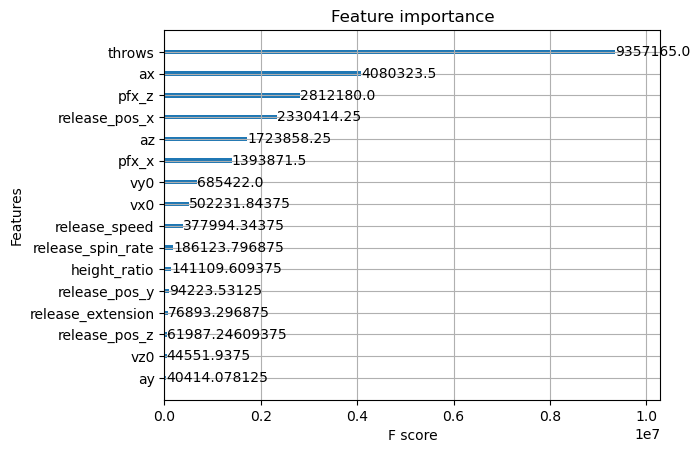

In [59]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [60]:
y_pred = final_model.predict(dtest)

In [61]:
print(y_pred.min())

25.720144


In [62]:
difference = angular_difference(y_test, y_pred)

## Testing Data Set Predictions

In [63]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [76]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [77]:
testing_identifiers['xspin_axis'] = predictions

In [80]:
testing_identifiers['diff'] = angular_difference(testing_label, predictions)

In [81]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/axis_2022&3_xaxis.csv")